In [1]:
#using Pkg
#Pkg.add(PackageSpec(name="JWAS",rev="master"))
#Pkg.add("RecipesBase")
#using RecipesBase

In [2]:
#methods(add_genotypes)

In [1]:
using DataFrames              # package for working with data sets
using JWAS                    # package for Bayesian regression analyses, including BayesB and BayesCπ        
#using JWAS:misc               # utility functions
using JWAS.Datasets
using Distributions       
using Plots                   # package for plotting 
using CSV
using LinearAlgebra,Statistics,Random,DelimitedFiles, DataFrames

In [4]:
phenotypes = CSV.read("/home/jovyan/mark/JWAS_CDPQ/CDPQ_all_data/production_1_7_Complete_EXP_Health_WFI.dat", types=Dict(:ID => String, :SlaughterDate => String), delim = ' ',header=true, missingstrings=["NA"] )
phenotypes= dropmissing(phenotypes, :FinPenBatch)
phenotypes= dropmissing(phenotypes, :SlaughterDate)
phenotypes= dropmissing(phenotypes, :PreSlaughterWt)
first(phenotypes,10)

,ID,Cycle,BatchNum,Batch,Company,SowID,NurEnrich,QNurPenBatch,NurPenBatch
,String,Int64,Int64,String,String,String,String,String,String⍰
1,0001,1,1,1B,A,1B_1715,FALSE,1B_D04,1B_D04
2,0002,1,1,1B,A,1B_1642,FALSE,1B_D04,1B_D04
3,0004,1,1,1B,A,1B_2150,FALSE,1B_D04,1B_D04
4,0005,1,1,1B,A,1B_1980,FALSE,1B_D04,1B_D04
5,0007,1,1,1B,A,1B_2150,FALSE,1B_D04,1B_D04
6,0009,1,1,1B,A,1B_1902,FALSE,1B_D02,1B_D02
7,0010,1,1,1B,A,1B_1885,FALSE,1B_D02,1B_D02
8,0011,1,1,1B,A,1B_2097,FALSE,1B_D02,1B_D02
9,0012,1,1,1B,A,1B_1902,FALSE,1B_D02,1B_D02


In [5]:
CarcassWt_model_equations = "CarcassWt = intercept + Batch + SlaughterDate + SlaughterAge + PreSlaughterWt + FinPenBatch + SowID"
CarcassWt_R=4.22155
CarcassWt_model=build_model(CarcassWt_model_equations,CarcassWt_R);
set_covariate(CarcassWt_model,"SlaughterAge")
set_covariate(CarcassWt_model,"PreSlaughterWt")
CarcassWt_G1= 0.987257E-01
set_random(CarcassWt_model,"FinPenBatch",CarcassWt_G1)
CarcassWt_G2=0.414811
set_random(CarcassWt_model,"SowID",CarcassWt_G2)

In [2]:
function readMatBin(fileName)
    genStr = open(fileName)
    n = read(genStr,Int64)
    p = read(genStr,Int64)
    M = zeros(n,p)
    for j in 1:p
        for i in 1:n
            M[i,j] = read(genStr,Float64)
        end
    end
    close(genStr)
    return M
end
@time M = readMatBin("/home/jovyan/mark/JWAS_CDPQ/CDPQ_all_data/ALGP2_Cycle_1_7_Geno_Complete_Impute_JWAS.bin.gen.bin")

 24.747927 seconds (37.77 k allocations: 10.393 GiB, 0.08% gc time)


3205×435172 Array{Float64,2}:
 0.0  2.0  0.0  2.0  2.0  0.0  2.0  2.0  …  0.0  2.0  0.0  2.0  2.0  2.0  2.0
 1.0  2.0  0.0  2.0  2.0  0.0  1.0  2.0     0.0  2.0  1.0  2.0  2.0  2.0  2.0
 0.0  2.0  0.0  1.0  2.0  0.0  1.0  2.0     0.0  2.0  0.0  2.0  2.0  2.0  2.0
 1.0  2.0  0.0  1.0  2.0  0.0  1.0  2.0     0.0  2.0  1.0  2.0  2.0  2.0  2.0
 0.0  2.0  0.0  2.0  2.0  0.0  2.0  2.0     0.0  2.0  0.0  2.0  2.0  2.0  2.0
 1.0  1.0  1.0  0.0  1.0  1.0  0.0  1.0  …  0.0  2.0  0.0  2.0  2.0  2.0  2.0
 0.0  2.0  0.0  1.0  2.0  0.0  1.0  2.0     0.0  2.0  0.0  2.0  2.0  2.0  2.0
 0.0  2.0  0.0  0.0  2.0  0.0  0.0  2.0     0.0  2.0  0.0  2.0  2.0  2.0  2.0
 1.0  2.0  0.0  0.0  2.0  0.0  0.0  2.0     0.0  2.0  0.0  2.0  2.0  2.0  2.0
 0.0  2.0  0.0  2.0  2.0  0.0  2.0  2.0     0.0  2.0  1.0  2.0  2.0  2.0  2.0
 1.0  1.0  0.0  1.0  2.0  0.0  0.0  2.0  …  0.0  2.0  0.0  2.0  2.0  2.0  2.0
 0.0  2.0  0.0  0.0  2.0  0.0  0.0  2.0     0.0  2.0  0.0  2.0  2.0  2.0  2.0
 1.0  1.0  1.0  1.0  1.0  1.0  1.0

In [7]:
rowID = vec(readdlm("/home/jovyan/mark/JWAS_CDPQ/CDPQ_all_data/ALGP2_Cycle_1_7_Geno_Complete_Impute_JWAS.bin.ids.txt",String))
CarcassWt_G3=0.629908
@time add_genotypes(CarcassWt_model,M,CarcassWt_G3,header=false, rowID=rowID)
#@time add_genotypes(Nur2ADG_model,"Geno_JWAS_impute.txt",Nur2ADG_G3,separator=' ')

The header (marker IDs) is set to 1,2,...,#markers
435172 markers on 3205 individuals were added.
 14.701100 seconds (6.93 M allocations: 15.937 GiB, 1.28% gc time)


In [8]:
@time CarcassWt_outB=runMCMC(CarcassWt_model,phenotypes,methods="BayesB", missing_phenotypes=true, Pi=0.999, estimateScale=true, chain_length=50000,burnin = 5000,output_heritability=true,  output_samples_frequency=100)

Checking phenotypes...
Individual IDs (strings) are provided in the first column of the phenotypic data.
Phenotypes for all traits included in the model for individual 0027 in the row 24 are missing. This record is deleted.
Phenotypes for all traits included in the model for individual 0347 in the row 203 are missing. This record is deleted.
Phenotypes for all traits included in the model for individual 0382 in the row 222 are missing. This record is deleted.
Phenotypes for all traits included in the model for individual 0391 in the row 229 are missing. This record is deleted.
Phenotypes for all traits included in the model for individual 0414 in the row 247 are missing. This record is deleted.
Phenotypes for all traits included in the model for individual 0418 in the row 250 are missing. This record is deleted.
Phenotypes for all traits included in the model for individual 0524 in the row 335 are missing. This record is deleted.
Phenotypes for all traits included in the model for indi

running MCMC for BayesB...100%|█████████████████████████| Time: 5:34:40




The version of Julia and Platform in use:

Julia Version 1.1.0
Commit 80516ca202 (2019-01-21 21:24 UTC)
Platform Info:
  OS: Linux (x86_64-pc-linux-gnu)
  CPU: Intel(R) Core(TM) i7-5960X CPU @ 3.00GHz
  WORD_SIZE: 64
  LIBM: libopenlibm
  LLVM: libLLVM-6.0.1 (ORCJIT, haswell)
Environment:
  JULIA_DEPOT_PATH = /opt/julia
  JULIA_PKGDIR = /opt/julia
  JULIA_VERSION = 1.1.0


The analysis has finished. Results are saved in the returned variable and text files. MCMC samples are saved in text files.


20121.169897 seconds (90.30 G allocations: 2.048 TiB, 1.47% gc time)


Dict{Any,Any} with 8 entries:
  "marker effects"          => 435172×5 DataFrame. Omitted printing of 1 column…
  "heritability"            => 1×3 DataFrame…
  "location parameters"     => 1234×5 DataFrame…
  "residual variance"       => 1×3 DataFrame…
  "ScaleEffectVar"          => 1×3 DataFrame…
  "EBV_CarcassWt"           => 3205×3 DataFrame…
  "genetic_variance"        => 1×3 DataFrame…
  "marker effects variance" => 1×3 DataFrame…

In [9]:
h2=CSV.read("MCMC_samples_heritability.txt",delim = ' ',header=true)
insertcols!(h2, 1, :iteration => 1:450) # Add a column called iteration

,iteration,CarcassWt
,Int64,Float64
1,1,0.129327
2,2,0.147679
3,3,0.129124
4,4,0.152083
5,5,0.137661
6,6,0.13105
7,7,0.141983
8,8,0.122301
9,9,0.158423


In [10]:
mean(h2[!,2])

0.1486640602086007

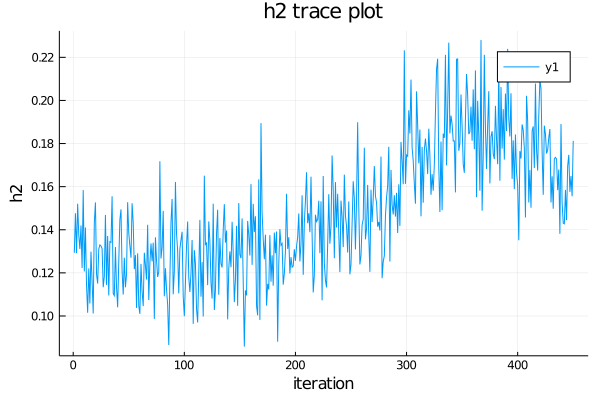

In [11]:
using Plots
x = h2[!,1]; y = h2[!,2]; # These are the plotting data
plot(x,y, title = "h2 trace plot",
        xlabel = "iteration", ylabel = "h2")

In [3]:
@time CarcassWt_outB,CarcassWt_winVarProps = GWAS("MCMC_samples_marker_effects_CarcassWt.txt","/home/jovyan/mark/JWAS_CDPQ/CDPQ_all_data/ChrInfo_map_1_7_Complete_JWAS.txt",
    M;header=true,window_size="0.25 Mb",threshold=0.001,output_winVarProps=false)

Compute the posterior probability of association of the genomic window that explains more than 0.001 of the total genetic variance.


running GWAS...100%|████████████████████████████████████| Time: 0:28:51


BoundsError: BoundsError: attempt to access (9375×13 DataFrame
│ Row  │ trait │ window │ chr    │ wStart    │ wEnd      │ start_SNP │ end_SNP   │ numSNP │ estimateGenVar │ stdGenVar   │ prGenVar │ WPPA       │ PPA_t     │
│      │ Int64 │ Int64  │ String │ Int64     │ Int64     │ Int64     │ Int64     │ Int64  │ Float64        │ Float64     │ Float64  │ Float64    │ Float64   │
├──────┼───────┼────────┼────────┼───────────┼───────────┼───────────┼───────────┼────────┼────────────────┼─────────────┼──────────┼────────────┼───────────┤
│ 1    │ 1     │ 6359   │ 13     │ 14250000  │ 14500000  │ 14252479  │ 14496033  │ 59     │ 0.00422578     │ 0.0108907   │ 0.57     │ 0.24       │ 0.24      │
│ 2    │ 1     │ 6559   │ 13     │ 64250000  │ 64500000  │ 64254810  │ 64498182  │ 64     │ 0.00516213     │ 0.0126779   │ 0.7      │ 0.222222   │ 0.231111  │
│ 3    │ 1     │ 5173   │ 9      │ 67500000  │ 67750000  │ 67502733  │ 67748747  │ 47     │ 0.00402705     │ 0.011603    │ 0.53     │ 0.184444   │ 0.215556  │
│ 4    │ 1     │ 8284   │ 16     │ 5500000   │ 5750000   │ 5503230   │ 5749813   │ 68     │ 0.00496654     │ 0.0143662   │ 0.65     │ 0.184444   │ 0.207778  │
│ 5    │ 1     │ 6221   │ 12     │ 41500000  │ 41750000  │ 41503380  │ 41748207  │ 76     │ 0.00223408     │ 0.00717719  │ 0.31     │ 0.175556   │ 0.201333  │
│ 6    │ 1     │ 4038   │ 7      │ 44500000  │ 44750000  │ 44504044  │ 44746958  │ 62     │ 0.00243263     │ 0.00829721  │ 0.33     │ 0.173333   │ 0.196667  │
│ 7    │ 1     │ 8688   │ 17     │ 26500000  │ 26750000  │ 26503869  │ 26748553  │ 65     │ 0.00261812     │ 0.00976447  │ 0.35     │ 0.173333   │ 0.193333  │
│ 8    │ 1     │ 1831   │ 3      │ 31750000  │ 32000000  │ 31751303  │ 31998911  │ 50     │ 0.00178251     │ 0.00627507  │ 0.23     │ 0.153333   │ 0.188333  │
│ 9    │ 1     │ 6081   │ 12     │ 6500000   │ 6750000   │ 6505052   │ 6747593   │ 67     │ 0.00235635     │ 0.0086134   │ 0.3      │ 0.153333   │ 0.184444  │
│ 10   │ 1     │ 6558   │ 13     │ 64000000  │ 64250000  │ 64002972  │ 64245300  │ 66     │ 0.00297673     │ 0.0108692   │ 0.41     │ 0.151111   │ 0.181111  │
│ 11   │ 1     │ 8687   │ 17     │ 26250000  │ 26500000  │ 26250300  │ 26499291  │ 68     │ 0.00171788     │ 0.00650754  │ 0.22     │ 0.151111   │ 0.178384  │
│ 12   │ 1     │ 8689   │ 17     │ 26750000  │ 27000000  │ 26752116  │ 26996510  │ 69     │ 0.00214956     │ 0.00837394  │ 0.29     │ 0.148889   │ 0.175926  │
│ 13   │ 1     │ 6082   │ 12     │ 6750000   │ 7000000   │ 6750763   │ 6998493   │ 72     │ 0.00172536     │ 0.00633457  │ 0.23     │ 0.137778   │ 0.172991  │
│ 14   │ 1     │ 1830   │ 3      │ 31500000  │ 31750000  │ 31500612  │ 31744765  │ 80     │ 0.00131468     │ 0.00498702  │ 0.18     │ 0.126667   │ 0.169683  │
│ 15   │ 1     │ 3839   │ 6      │ 165750000 │ 166000000 │ 165752774 │ 165997868 │ 46     │ 0.00220369     │ 0.00809136  │ 0.3      │ 0.126667   │ 0.166815  │
│ 16   │ 1     │ 4056   │ 7      │ 49000000  │ 49250000  │ 49001175  │ 49247719  │ 75     │ 0.00137447     │ 0.00484862  │ 0.18     │ 0.126667   │ 0.164306  │
│ 17   │ 1     │ 8691   │ 17     │ 27250000  │ 27500000  │ 27267865  │ 27490696  │ 71     │ 0.00122092     │ 0.00487738  │ 0.17     │ 0.126667   │ 0.162092  │
│ 18   │ 1     │ 6362   │ 13     │ 15000000  │ 15250000  │ 15014599  │ 15248769  │ 65     │ 0.00128889     │ 0.00550358  │ 0.17     │ 0.124444   │ 0.16      │
│ 19   │ 1     │ 4040   │ 7      │ 45000000  │ 45250000  │ 45006606  │ 45240243  │ 56     │ 0.00298045     │ 0.0121157   │ 0.41     │ 0.122222   │ 0.158012  │
│ 20   │ 1     │ 4058   │ 7      │ 49500000  │ 49750000  │ 49504198  │ 49748787  │ 60     │ 0.00135545     │ 0.00571919  │ 0.18     │ 0.122222   │ 0.156222  │
│ 21   │ 1     │ 4015   │ 7      │ 38750000  │ 39000000  │ 38754069  │ 38998747  │ 53     │ 0.00139569     │ 0.00584816  │ 0.18     │ 0.12       │ 0.154497  │
│ 22   │ 1     │ 6560   │ 13     │ 64500000  │ 64750000  │ 64500742  │ 64745198  │ 66     │ 0.00158031     │ 0.0076693   │ 0.21     │ 0.12       │ 0.152929  │
│ 23   │ 1     │ 6557   │ 13     │ 63750000  │ 64000000  │ 63754967  │ 63994715  │ 63     │ 0.0014015      │ 0.0064289   │ 0.18     │ 0.117778   │ 0.151401  │
│ 24   │ 1     │ 6447   │ 13     │ 36250000  │ 36500000  │ 36250193  │ 36498208  │ 47     │ 0.00086116     │ 0.00443383  │ 0.11     │ 0.115556   │ 0.149907  │
│ 25   │ 1     │ 5635   │ 10     │ 43500000  │ 43750000  │ 43501152  │ 43748989  │ 80     │ 0.000779394    │ 0.00306669  │ 0.11     │ 0.111111   │ 0.148356  │
│ 26   │ 1     │ 3950   │ 7      │ 22500000  │ 22750000  │ 22501546  │ 22745850  │ 77     │ 0.00196698     │ 0.00943609  │ 0.25     │ 0.104444   │ 0.146667  │
│ 27   │ 1     │ 8283   │ 16     │ 5250000   │ 5500000   │ 5251606   │ 5497710   │ 80     │ 0.00108075     │ 0.00502001  │ 0.15     │ 0.104444   │ 0.145103  │
│ 28   │ 1     │ 2492   │ 4      │ 64000000  │ 64250000  │ 64003654  │ 64233258  │ 56     │ 0.00204075     │ 0.00837698  │ 0.28     │ 0.102222   │ 0.143571  │
│ 29   │ 1     │ 4010   │ 7      │ 37500000  │ 37750000  │ 37501141  │ 37749404  │ 60     │ 0.00101521     │ 0.0047039   │ 0.13     │ 0.102222   │ 0.142146  │
│ 30   │ 1     │ 4912   │ 9      │ 2000000   │ 2250000   │ 2001714   │ 2249056   │ 81     │ 0.000968881    │ 0.00452199  │ 0.13     │ 0.1        │ 0.140741  │
│ 31   │ 1     │ 6547   │ 13     │ 61250000  │ 61500000  │ 61252570  │ 61499304  │ 69     │ 0.00171531     │ 0.00932956  │ 0.24     │ 0.0977778  │ 0.139355  │
│ 32   │ 1     │ 1832   │ 3      │ 32000000  │ 32250000  │ 32003405  │ 32246445  │ 61     │ 0.000712102    │ 0.00322767  │ 0.11     │ 0.0955556  │ 0.137986  │
│ 33   │ 1     │ 4469   │ 8      │ 30250000  │ 30500000  │ 30254199  │ 30495795  │ 62     │ 0.000780836    │ 0.00337776  │ 0.11     │ 0.0955556  │ 0.1367    │
│ 34   │ 1     │ 8285   │ 16     │ 5750000   │ 6000000   │ 5753908   │ 5999039   │ 79     │ 0.0017263      │ 0.00781748  │ 0.23     │ 0.0955556  │ 0.13549   │
│ 35   │ 1     │ 2777   │ 5      │ 4250000   │ 4500000   │ 4252365   │ 4492774   │ 42     │ 0.00134393     │ 0.00610378  │ 0.18     │ 0.0911111  │ 0.134222  │
│ 36   │ 1     │ 7207   │ 14     │ 18250000  │ 18500000  │ 18254655  │ 18496949  │ 64     │ 0.000902063    │ 0.00489766  │ 0.13     │ 0.0911111  │ 0.133025  │
│ 37   │ 1     │ 1174   │ 2      │ 19250000  │ 19500000  │ 19253051  │ 19498460  │ 56     │ 0.000831268    │ 0.00459716  │ 0.11     │ 0.0888889  │ 0.131832  │
│ 38   │ 1     │ 5464   │ 10     │ 750000    │ 1000000   │ 763229    │ 998239    │ 73     │ 0.000502965    │ 0.00203515  │ 0.07     │ 0.0888889  │ 0.130702  │
│ 39   │ 1     │ 7403   │ 14     │ 67250000  │ 67500000  │ 67251167  │ 67481630  │ 56     │ 0.000956979    │ 0.00483172  │ 0.13     │ 0.0888889  │ 0.12963   │
│ 40   │ 1     │ 1749   │ 3      │ 11250000  │ 11500000  │ 11250457  │ 11497906  │ 62     │ 0.000902078    │ 0.00509189  │ 0.14     │ 0.0866667  │ 0.128556  │
│ 41   │ 1     │ 2546   │ 4      │ 77500000  │ 77750000  │ 77503038  │ 77748592  │ 48     │ 0.00137766     │ 0.00732972  │ 0.19     │ 0.0866667  │ 0.127534  │
│ 42   │ 1     │ 4962   │ 9      │ 14500000  │ 14750000  │ 14500620  │ 14744069  │ 61     │ 0.0015295      │ 0.00772607  │ 0.19     │ 0.0844444  │ 0.126508  │
│ 43   │ 1     │ 6360   │ 13     │ 14500000  │ 14750000  │ 14501029  │ 14749705  │ 48     │ 0.00103276     │ 0.00494555  │ 0.14     │ 0.0844444  │ 0.12553   │
│ 44   │ 1     │ 3481   │ 6      │ 76000000  │ 76250000  │ 76010373  │ 76249862  │ 73     │ 0.000368838    │ 0.00182704  │ 0.05     │ 0.0822222  │ 0.124545  │
│ 45   │ 1     │ 7414   │ 14     │ 70000000  │ 70250000  │ 70006052  │ 70248402  │ 63     │ 0.000745697    │ 0.00377265  │ 0.1      │ 0.08       │ 0.123556  │
│ 46   │ 1     │ 8070   │ 15     │ 92500000  │ 92750000  │ 92512686  │ 92746851  │ 52     │ 0.000386588    │ 0.00173439  │ 0.06     │ 0.08       │ 0.122609  │
│ 47   │ 1     │ 639    │ 1      │ 159750000 │ 160000000 │ 159750850 │ 159997351 │ 65     │ 0.000439378    │ 0.00252818  │ 0.06     │ 0.0777778  │ 0.121655  │
│ 48   │ 1     │ 2042   │ 3      │ 84500000  │ 84750000  │ 84501119  │ 84736454  │ 48     │ 0.00054958     │ 0.00263558  │ 0.08     │ 0.0777778  │ 0.120741  │
│ 49   │ 1     │ 4039   │ 7      │ 44750000  │ 45000000  │ 44750034  │ 44986763  │ 39     │ 0.000856516    │ 0.00410239  │ 0.12     │ 0.0777778  │ 0.119864  │
│ 50   │ 1     │ 8692   │ 17     │ 27500000  │ 27750000  │ 27501543  │ 27748749  │ 72     │ 0.00062515     │ 0.00296101  │ 0.08     │ 0.0777778  │ 0.119022  │
│ 51   │ 1     │ 1833   │ 3      │ 32250000  │ 32500000  │ 32250576  │ 32497290  │ 74     │ 0.000249926    │ 0.00108459  │ 0.04     │ 0.0755556  │ 0.11817   │
│ 52   │ 1     │ 7364   │ 14     │ 57500000  │ 57750000  │ 57500000  │ 57749345  │ 72     │ 0.000950715    │ 0.00492788  │ 0.12     │ 0.0755556  │ 0.11735   │
│ 53   │ 1     │ 163    │ 1      │ 40500000  │ 40750000  │ 40504879  │ 40745525  │ 67     │ 0.000660694    │ 0.00441019  │ 0.09     │ 0.0733333  │ 0.11652   │
│ 54   │ 1     │ 2194   │ 3      │ 122500000 │ 122750000 │ 122505074 │ 122748010 │ 80     │ 0.000316317    │ 0.00227493  │ 0.04     │ 0.0733333  │ 0.11572   │
│ 55   │ 1     │ 3021   │ 5      │ 65250000  │ 65500000  │ 65250371  │ 65497170  │ 73     │ 0.000759234    │ 0.00448097  │ 0.1      │ 0.0733333  │ 0.114949  │
│ 56   │ 1     │ 3838   │ 6      │ 165500000 │ 165750000 │ 165502178 │ 165749990 │ 34     │ 0.000959067    │ 0.00520469  │ 0.13     │ 0.0733333  │ 0.114206  │
│ 57   │ 1     │ 4055   │ 7      │ 48750000  │ 49000000  │ 48751343  │ 48992096  │ 55     │ 0.000644698    │ 0.00369338  │ 0.08     │ 0.0733333  │ 0.113489  │
│ 58   │ 1     │ 6361   │ 13     │ 14750000  │ 15000000  │ 14754911  │ 14992413  │ 52     │ 0.000553453    │ 0.00315578  │ 0.07     │ 0.0733333  │ 0.112797  │
│ 59   │ 1     │ 131    │ 1      │ 32500000  │ 32750000  │ 32511332  │ 32749073  │ 69     │ 0.000369474    │ 0.00185545  │ 0.05     │ 0.0711111  │ 0.11209   │
│ 60   │ 1     │ 1676   │ 2      │ 145000000 │ 145250000 │ 145004602 │ 145243276 │ 66     │ 0.000584095    │ 0.00364538  │ 0.08     │ 0.0711111  │ 0.111407  │
│ 61   │ 1     │ 4035   │ 7      │ 43750000  │ 44000000  │ 43751514  │ 43998322  │ 63     │ 0.000982412    │ 0.00590751  │ 0.14     │ 0.0711111  │ 0.110747  │
│ 62   │ 1     │ 4036   │ 7      │ 44000000  │ 44250000  │ 44006459  │ 44249404  │ 62     │ 0.000529721    │ 0.00299631  │ 0.07     │ 0.0711111  │ 0.110108  │
│ 63   │ 1     │ 4295   │ 7      │ 108750000 │ 109000000 │ 108751068 │ 108996302 │ 60     │ 0.000758058    │ 0.004031    │ 0.1      │ 0.0711111  │ 0.109489  │
│ 64   │ 1     │ 4470   │ 8      │ 30500000  │ 30750000  │ 30500058  │ 30740074  │ 64     │ 0.000547385    │ 0.00281521  │ 0.07     │ 0.0711111  │ 0.108889  │
│ 65   │ 1     │ 7185   │ 14     │ 12750000  │ 13000000  │ 12756639  │ 12998431  │ 62     │ 0.000297115    │ 0.00159147  │ 0.04     │ 0.0711111  │ 0.108308  │
│ 66   │ 1     │ 1677   │ 2      │ 145250000 │ 145500000 │ 145252792 │ 145494535 │ 51     │ 0.0016198      │ 0.0080278   │ 0.21     │ 0.0688889  │ 0.10771   │
│ 67   │ 1     │ 3052   │ 5      │ 73000000  │ 73250000  │ 73002857  │ 73247527  │ 68     │ 0.000412672    │ 0.00219323  │ 0.06     │ 0.0688889  │ 0.107131  │
│ 68   │ 1     │ 4012   │ 7      │ 38000000  │ 38250000  │ 38001363  │ 38248090  │ 69     │ 0.000436336    │ 0.00236369  │ 0.06     │ 0.0688889  │ 0.106569  │
│ 69   │ 1     │ 4021   │ 7      │ 40250000  │ 40500000  │ 40264575  │ 40497251  │ 52     │ 0.00107241     │ 0.00679983  │ 0.14     │ 0.0688889  │ 0.106023  │
│ 70   │ 1     │ 7833   │ 15     │ 33000000  │ 33250000  │ 33009952  │ 33248719  │ 58     │ 0.000901302    │ 0.00546375  │ 0.12     │ 0.0688889  │ 0.105492  │
│ 71   │ 1     │ 168    │ 1      │ 41750000  │ 42000000  │ 41750699  │ 41995556  │ 59     │ 0.00059979     │ 0.00320497  │ 0.09     │ 0.0666667  │ 0.104945  │
│ 72   │ 1     │ 1636   │ 2      │ 135000000 │ 135250000 │ 135005920 │ 135238716 │ 65     │ 0.000420683    │ 0.00261766  │ 0.05     │ 0.0666667  │ 0.104414  │
│ 73   │ 1     │ 2660   │ 4      │ 106000000 │ 106250000 │ 106002452 │ 106246591 │ 46     │ 0.000703521    │ 0.00403278  │ 0.09     │ 0.0666667  │ 0.103896  │
│ 74   │ 1     │ 3167   │ 5      │ 101750000 │ 102000000 │ 101750667 │ 101995416 │ 73     │ 0.000473775    │ 0.0027034   │ 0.07     │ 0.0666667  │ 0.103393  │
│ 75   │ 1     │ 5022   │ 9      │ 29500000  │ 29750000  │ 29502118  │ 29748863  │ 45     │ 0.000672163    │ 0.00329514  │ 0.08     │ 0.0666667  │ 0.102904  │
│ 76   │ 1     │ 129    │ 1      │ 32000000  │ 32250000  │ 32024388  │ 32248863  │ 69     │ 0.000390797    │ 0.00232074  │ 0.05     │ 0.0644444  │ 0.102398  │
│ 77   │ 1     │ 237    │ 1      │ 59000000  │ 59250000  │ 59002370  │ 59248533  │ 56     │ 0.000476658    │ 0.00258105  │ 0.06     │ 0.0644444  │ 0.101905  │
│ 78   │ 1     │ 1752   │ 3      │ 12000000  │ 12250000  │ 12005480  │ 12249295  │ 61     │ 0.000580879    │ 0.00427057  │ 0.07     │ 0.0644444  │ 0.101425  │
│ 79   │ 1     │ 2348   │ 4      │ 28000000  │ 28250000  │ 28001744  │ 28248311  │ 63     │ 0.00057014     │ 0.00293462  │ 0.07     │ 0.0644444  │ 0.100956  │
│ 80   │ 1     │ 3142   │ 5      │ 95500000  │ 95750000  │ 95512401  │ 95742293  │ 47     │ 0.00051036     │ 0.00277752  │ 0.06     │ 0.0644444  │ 0.1005    │
│ 81   │ 1     │ 4873   │ 8      │ 131250000 │ 131500000 │ 131251746 │ 131498657 │ 65     │ 0.000383329    │ 0.00309558  │ 0.05     │ 0.0644444  │ 0.100055  │
│ 82   │ 1     │ 6080   │ 12     │ 6250000   │ 6500000   │ 6276833   │ 6498360   │ 43     │ 0.000606036    │ 0.00331796  │ 0.08     │ 0.0644444  │ 0.0996206 │
│ 83   │ 1     │ 6590   │ 13     │ 72000000  │ 72250000  │ 72001702  │ 72240667  │ 53     │ 0.000587043    │ 0.00398178  │ 0.07     │ 0.0644444  │ 0.0991968 │
│ 84   │ 1     │ 6754   │ 13     │ 113250000 │ 113500000 │ 113251335 │ 113490496 │ 45     │ 0.000499558    │ 0.00271097  │ 0.08     │ 0.0644444  │ 0.0987831 │
│ 85   │ 1     │ 8159   │ 15     │ 114750000 │ 115000000 │ 114764843 │ 114999739 │ 39     │ 0.000685309    │ 0.00415085  │ 0.08     │ 0.0644444  │ 0.0983791 │
│ 86   │ 1     │ 8513   │ 16     │ 62750000  │ 63000000  │ 62750208  │ 62999696  │ 62     │ 0.000364917    │ 0.00202898  │ 0.05     │ 0.0644444  │ 0.0979845 │
│ 87   │ 1     │ 78     │ 1      │ 19250000  │ 19500000  │ 19252734  │ 19482415  │ 56     │ 0.000316292    │ 0.00200172  │ 0.04     │ 0.0622222  │ 0.0975734 │
│ 88   │ 1     │ 172    │ 1      │ 42750000  │ 43000000  │ 42753579  │ 42997288  │ 65     │ 0.000391146    │ 0.00200918  │ 0.05     │ 0.0622222  │ 0.0971717 │
│ 89   │ 1     │ 1584   │ 2      │ 122000000 │ 122250000 │ 122000482 │ 122249193 │ 59     │ 0.000329595    │ 0.00168007  │ 0.05     │ 0.0622222  │ 0.096779  │
│ 90   │ 1     │ 2711   │ 4      │ 118750000 │ 119000000 │ 118750514 │ 118998248 │ 61     │ 0.000397436    │ 0.00229077  │ 0.05     │ 0.0622222  │ 0.0963951 │
│ 91   │ 1     │ 2751   │ 4      │ 128750000 │ 129000000 │ 128750655 │ 128996809 │ 75     │ 0.000335236    │ 0.00212834  │ 0.05     │ 0.0622222  │ 0.0960195 │
│ 92   │ 1     │ 3480   │ 6      │ 75750000  │ 76000000  │ 75751148  │ 75998821  │ 71     │ 0.000362295    │ 0.00209612  │ 0.05     │ 0.0622222  │ 0.0956522 │
│ 93   │ 1     │ 3879   │ 7      │ 4750000   │ 5000000   │ 4752542   │ 4999309   │ 64     │ 0.000729963    │ 0.00386251  │ 0.1      │ 0.0622222  │ 0.0952927 │
│ 94   │ 1     │ 7365   │ 14     │ 57750000  │ 58000000  │ 57751807  │ 57998868  │ 51     │ 0.000505946    │ 0.00290119  │ 0.06     │ 0.0622222  │ 0.0949409 │
│ 95   │ 1     │ 8245   │ 15     │ 136250000 │ 136500000 │ 136256565 │ 136495562 │ 63     │ 0.000288188    │ 0.00151431  │ 0.04     │ 0.0622222  │ 0.0945965 │
│ 96   │ 1     │ 186    │ 1      │ 46250000  │ 46500000  │ 46255539  │ 46499968  │ 51     │ 0.000375065    │ 0.00243982  │ 0.05     │ 0.06       │ 0.0942361 │
│ 97   │ 1     │ 236    │ 1      │ 58750000  │ 59000000  │ 58752553  │ 58999705  │ 64     │ 0.000325221    │ 0.00162028  │ 0.05     │ 0.06       │ 0.0938832 │
│ 98   │ 1     │ 1437   │ 2      │ 85250000  │ 85500000  │ 85251325  │ 85491489  │ 76     │ 0.000385894    │ 0.00213886  │ 0.05     │ 0.06       │ 0.0935374 │
│ 99   │ 1     │ 2494   │ 4      │ 64500000  │ 64750000  │ 64501256  │ 64740240  │ 59     │ 0.000506639    │ 0.00333886  │ 0.07     │ 0.06       │ 0.0931987 │
│ 100  │ 1     │ 3482   │ 6      │ 76250000  │ 76500000  │ 76253780  │ 76499354  │ 35     │ 0.000753465    │ 0.00401484  │ 0.1      │ 0.06       │ 0.0928667 │
│ 101  │ 1     │ 4215   │ 7      │ 88750000  │ 89000000  │ 88758443  │ 88995313  │ 57     │ 0.000467185    │ 0.00283526  │ 0.06     │ 0.06       │ 0.0925413 │
│ 102  │ 1     │ 4468   │ 8      │ 30000000  │ 30250000  │ 30000607  │ 30249273  │ 73     │ 0.000283492    │ 0.00149458  │ 0.04     │ 0.06       │ 0.0922222 │
│ 103  │ 1     │ 4963   │ 9      │ 14750000  │ 15000000  │ 14751219  │ 14998227  │ 63     │ 0.000648461    │ 0.00393591  │ 0.09     │ 0.06       │ 0.0919094 │
│ 104  │ 1     │ 5488   │ 10     │ 6750000   │ 7000000   │ 6757333   │ 6996554   │ 72     │ 0.000347115    │ 0.00203823  │ 0.05     │ 0.06       │ 0.0916026 │
│ 105  │ 1     │ 5773   │ 11     │ 8500000   │ 8750000   │ 8511850   │ 8747998   │ 68     │ 0.000429185    │ 0.00257815  │ 0.06     │ 0.06       │ 0.0913016 │
│ 106  │ 1     │ 8643   │ 17     │ 15250000  │ 15500000  │ 15254076  │ 15499427  │ 60     │ 0.00041968     │ 0.00256811  │ 0.05     │ 0.06       │ 0.0910063 │
│ 107  │ 1     │ 8864   │ 18     │ 7250000   │ 7500000   │ 7252487   │ 7498054   │ 64     │ 0.000156121    │ 0.000698878 │ 0.02     │ 0.06       │ 0.0907165 │
│ 108  │ 1     │ 35     │ 1      │ 8500000   │ 8750000   │ 8500105   │ 8748819   │ 66     │ 0.000374713    │ 0.00334077  │ 0.04     │ 0.0577778  │ 0.0904115 │
│ 109  │ 1     │ 1090   │ 1      │ 272500000 │ 272750000 │ 272501080 │ 272746057 │ 59     │ 0.00025648     │ 0.00130371  │ 0.03     │ 0.0577778  │ 0.0901121 │
│ 110  │ 1     │ 1675   │ 2      │ 144750000 │ 145000000 │ 144761674 │ 144982683 │ 56     │ 0.00076174     │ 0.00436653  │ 0.1      │ 0.0577778  │ 0.0898182 │
│ 111  │ 1     │ 1693   │ 2      │ 149250000 │ 149500000 │ 149252002 │ 149497230 │ 62     │ 0.000258208    │ 0.00145185  │ 0.03     │ 0.0577778  │ 0.0895295 │
│ 112  │ 1     │ 2549   │ 4      │ 78250000  │ 78500000  │ 78251550  │ 78499093  │ 74     │ 0.000424859    │ 0.00234604  │ 0.05     │ 0.0577778  │ 0.089246  │
│ 113  │ 1     │ 2802   │ 5      │ 10500000  │ 10750000  │ 10501359  │ 10745420  │ 65     │ 0.000224971    │ 0.00125881  │ 0.04     │ 0.0577778  │ 0.0889676 │
│ 114  │ 1     │ 3488   │ 6      │ 77750000  │ 78000000  │ 77756039  │ 77994120  │ 74     │ 0.000241462    │ 0.00156966  │ 0.03     │ 0.0577778  │ 0.088694  │
│ 115  │ 1     │ 4037   │ 7      │ 44250000  │ 44500000  │ 44251751  │ 44489604  │ 57     │ 0.000552001    │ 0.00323725  │ 0.07     │ 0.0577778  │ 0.0884251 │
│ 116  │ 1     │ 4500   │ 8      │ 38000000  │ 38250000  │ 38000661  │ 38238708  │ 51     │ 0.000541968    │ 0.00344467  │ 0.07     │ 0.0577778  │ 0.0881609 │
│ 117  │ 1     │ 4998   │ 9      │ 23500000  │ 23750000  │ 23502264  │ 23748401  │ 67     │ 0.000732785    │ 0.00482875  │ 0.08     │ 0.0577778  │ 0.0879012 │
│ 118  │ 1     │ 5489   │ 10     │ 7000000   │ 7250000   │ 7001294   │ 7246418   │ 75     │ 0.000364011    │ 0.00221375  │ 0.05     │ 0.0577778  │ 0.087646  │
│ 119  │ 1     │ 5692   │ 10     │ 57750000  │ 58000000  │ 57759315  │ 57998402  │ 62     │ 0.000275614    │ 0.00156425  │ 0.03     │ 0.0577778  │ 0.087395  │
│ 120  │ 1     │ 5984   │ 11     │ 61500000  │ 61750000  │ 61501554  │ 61744519  │ 59     │ 0.000969097    │ 0.00575923  │ 0.13     │ 0.0577778  │ 0.0871481 │
│ 121  │ 1     │ 6000   │ 11     │ 65500000  │ 65750000  │ 65511591  │ 65748244  │ 65     │ 0.000226811    │ 0.00125918  │ 0.03     │ 0.0577778  │ 0.0869054 │
│ 122  │ 1     │ 7117   │ 13     │ 204250000 │ 204500000 │ 204252597 │ 204492917 │ 42     │ 0.000569385    │ 0.00329708  │ 0.08     │ 0.0577778  │ 0.0866667 │
│ 123  │ 1     │ 7398   │ 14     │ 66000000  │ 66250000  │ 66000643  │ 66247524  │ 49     │ 0.000424111    │ 0.00248683  │ 0.05     │ 0.0577778  │ 0.0864318 │
│ 124  │ 1     │ 8282   │ 16     │ 5000000   │ 5250000   │ 5002482   │ 5248899   │ 74     │ 0.00035423     │ 0.0021296   │ 0.05     │ 0.0577778  │ 0.0862007 │
│ 125  │ 1     │ 8363   │ 16     │ 25250000  │ 25500000  │ 25254702  │ 25499363  │ 63     │ 0.000282815    │ 0.00196429  │ 0.04     │ 0.0577778  │ 0.0859733 │
│ 126  │ 1     │ 8364   │ 16     │ 25500000  │ 25750000  │ 25502559  │ 25744099  │ 61     │ 0.000253305    │ 0.00145857  │ 0.04     │ 0.0577778  │ 0.0857496 │
│ 127  │ 1     │ 8367   │ 16     │ 26250000  │ 26500000  │ 26252954  │ 26499408  │ 69     │ 0.000273636    │ 0.00152584  │ 0.04     │ 0.0577778  │ 0.0855293 │
│ 128  │ 1     │ 175    │ 1      │ 43500000  │ 43750000  │ 43504853  │ 43748357  │ 60     │ 0.000362916    │ 0.00294924  │ 0.05     │ 0.0555556  │ 0.0852951 │
│ 129  │ 1     │ 292    │ 1      │ 72750000  │ 73000000  │ 72751581  │ 72998025  │ 66     │ 0.000134117    │ 0.000776343 │ 0.02     │ 0.0555556  │ 0.0850646 │
│ 130  │ 1     │ 1465   │ 2      │ 92250000  │ 92500000  │ 92257026  │ 92490522  │ 70     │ 0.000251678    │ 0.00144175  │ 0.03     │ 0.0555556  │ 0.0848376 │
│ 131  │ 1     │ 1828   │ 3      │ 31000000  │ 31250000  │ 31002224  │ 31239866  │ 58     │ 0.000371827    │ 0.00204225  │ 0.05     │ 0.0555556  │ 0.0846141 │
│ 132  │ 1     │ 4016   │ 7      │ 39000000  │ 39250000  │ 39001990  │ 39246867  │ 43     │ 0.000531455    │ 0.00324719  │ 0.07     │ 0.0555556  │ 0.0843939 │
│ 133  │ 1     │ 4315   │ 7      │ 113750000 │ 114000000 │ 113751906 │ 113999709 │ 70     │ 0.000222374    │ 0.00124814  │ 0.03     │ 0.0555556  │ 0.0841771 │
│ 134  │ 1     │ 4843   │ 8      │ 123750000 │ 124000000 │ 123770281 │ 123999102 │ 55     │ 0.000440359    │ 0.00272533  │ 0.05     │ 0.0555556  │ 0.0839635 │
│ 135  │ 1     │ 4988   │ 9      │ 21000000  │ 21250000  │ 21002022  │ 21247455  │ 64     │ 0.000380271    │ 0.00233431  │ 0.05     │ 0.0555556  │ 0.0837531 │
│ 136  │ 1     │ 5002   │ 9      │ 24500000  │ 24750000  │ 24506145  │ 24740842  │ 62     │ 0.000328757    │ 0.00201803  │ 0.05     │ 0.0555556  │ 0.0835458 │
│ 137  │ 1     │ 5192   │ 9      │ 72250000  │ 72500000  │ 72256760  │ 72493372  │ 49     │ 0.000292914    │ 0.00169014  │ 0.04     │ 0.0555556  │ 0.0833414 │
│ 138  │ 1     │ 5229   │ 9      │ 81500000  │ 81750000  │ 81500392  │ 81747982  │ 59     │ 0.000411866    │ 0.00233964  │ 0.05     │ 0.0555556  │ 0.0831401 │
│ 139  │ 1     │ 5634   │ 10     │ 43250000  │ 43500000  │ 43251455  │ 43499592  │ 65     │ 0.000332569    │ 0.00202346  │ 0.05     │ 0.0555556  │ 0.0829416 │
│ 140  │ 1     │ 6101   │ 12     │ 11500000  │ 11750000  │ 11501427  │ 11747242  │ 74     │ 0.000201502    │ 0.00116097  │ 0.03     │ 0.0555556  │ 0.082746  │
│ 141  │ 1     │ 6220   │ 12     │ 41250000  │ 41500000  │ 41253777  │ 41499183  │ 89     │ 0.00036678     │ 0.00231459  │ 0.05     │ 0.0555556  │ 0.0825532 │
│ 142  │ 1     │ 6589   │ 13     │ 71750000  │ 72000000  │ 71750165  │ 71994971  │ 59     │ 0.000398282    │ 0.00305467  │ 0.06     │ 0.0555556  │ 0.0823631 │
│ 143  │ 1     │ 7413   │ 14     │ 69750000  │ 70000000  │ 69753753  │ 69999911  │ 57     │ 0.000770666    │ 0.00625672  │ 0.09     │ 0.0555556  │ 0.0821756 │
│ 144  │ 1     │ 8713   │ 17     │ 32750000  │ 33000000  │ 32753792  │ 32998532  │ 71     │ 0.000288157    │ 0.0015431   │ 0.04     │ 0.0555556  │ 0.0819907 │
│ 145  │ 1     │ 9000   │ 18     │ 41250000  │ 41500000  │ 41250065  │ 41498597  │ 74     │ 0.000506321    │ 0.00351092  │ 0.06     │ 0.0555556  │ 0.0818084 │
│ 146  │ 1     │ 9019   │ 18     │ 46000000  │ 46250000  │ 46008401  │ 46249295  │ 73     │ 0.000245409    │ 0.00134874  │ 0.03     │ 0.0555556  │ 0.0816286 │
│ 147  │ 1     │ 133    │ 1      │ 33000000  │ 33250000  │ 33002217  │ 33249640  │ 81     │ 0.000216736    │ 0.00105363  │ 0.03     │ 0.0533333  │ 0.0814361 │
│ 148  │ 1     │ 722    │ 1      │ 180500000 │ 180750000 │ 180515863 │ 180748356 │ 44     │ 0.000435303    │ 0.00248221  │ 0.06     │ 0.0533333  │ 0.0812462 │
│ 149  │ 1     │ 1021   │ 1      │ 255250000 │ 255500000 │ 255253513 │ 255499024 │ 58     │ 0.000288846    │ 0.00175641  │ 0.04     │ 0.0533333  │ 0.0810589 │
│ 150  │ 1     │ 1492   │ 2      │ 99000000  │ 99250000  │ 99002885  │ 99247587  │ 53     │ 0.000212033    │ 0.00111928  │ 0.03     │ 0.0533333  │ 0.0808741 │
│ 151  │ 1     │ 1637   │ 2      │ 135250000 │ 135500000 │ 135253566 │ 135497224 │ 64     │ 0.000240927    │ 0.00169132  │ 0.03     │ 0.0533333  │ 0.0806917 │
│ 152  │ 1     │ 1958   │ 3      │ 63500000  │ 63750000  │ 63505435  │ 63748466  │ 74     │ 0.000135518    │ 0.000633285 │ 0.02     │ 0.0533333  │ 0.0805117 │
│ 153  │ 1     │ 3068   │ 5      │ 77000000  │ 77250000  │ 77000223  │ 77248822  │ 62     │ 0.000243912    │ 0.00144728  │ 0.04     │ 0.0533333  │ 0.0803341 │
│ 154  │ 1     │ 3308   │ 6      │ 32250000  │ 32500000  │ 32252185  │ 32492699  │ 65     │ 0.000395677    │ 0.0023429   │ 0.05     │ 0.0533333  │ 0.0801587 │
│ 155  │ 1     │ 3484   │ 6      │ 76750000  │ 77000000  │ 76754616  │ 76996113  │ 91     │ 0.000228607    │ 0.00116993  │ 0.03     │ 0.0533333  │ 0.0799857 │
│ 156  │ 1     │ 4009   │ 7      │ 37250000  │ 37500000  │ 37251516  │ 37499635  │ 63     │ 0.000292509    │ 0.00170889  │ 0.04     │ 0.0533333  │ 0.0798148 │
│ 157  │ 1     │ 4013   │ 7      │ 38250000  │ 38500000  │ 38255297  │ 38497261  │ 67     │ 0.000187563    │ 0.00134998  │ 0.02     │ 0.0533333  │ 0.0796461 │
│ 158  │ 1     │ 4467   │ 8      │ 29750000  │ 30000000  │ 29750337  │ 29996164  │ 73     │ 0.00018891     │ 0.00100776  │ 0.03     │ 0.0533333  │ 0.0794796 │
│ 159  │ 1     │ 4509   │ 8      │ 40250000  │ 40500000  │ 40252688  │ 40498539  │ 62     │ 0.000332579    │ 0.00254517  │ 0.04     │ 0.0533333  │ 0.0793152 │
│ 160  │ 1     │ 5398   │ 9      │ 123750000 │ 124000000 │ 123750163 │ 123999702 │ 62     │ 0.000503247    │ 0.00324983  │ 0.07     │ 0.0533333  │ 0.0791528 │
│ 161  │ 1     │ 5472   │ 10     │ 2750000   │ 3000000   │ 2761383   │ 2996701   │ 57     │ 0.000370624    │ 0.00233398  │ 0.05     │ 0.0533333  │ 0.0789924 │
│ 162  │ 1     │ 5646   │ 10     │ 46250000  │ 46500000  │ 46252339  │ 46499017  │ 63     │ 0.000441997    │ 0.00248196  │ 0.05     │ 0.0533333  │ 0.078834  │
│ 163  │ 1     │ 6549   │ 13     │ 61750000  │ 62000000  │ 61751840  │ 61997713  │ 66     │ 0.000280636    │ 0.00172072  │ 0.04     │ 0.0533333  │ 0.0786776 │
│ 164  │ 1     │ 7      │ 1      │ 1500000   │ 1750000   │ 1503174   │ 1748174   │ 72     │ 0.000316719    │ 0.00196     │ 0.04     │ 0.0511111  │ 0.0785095 │
│ 165  │ 1     │ 104    │ 1      │ 25750000  │ 26000000  │ 25750298  │ 25998814  │ 78     │ 0.000233579    │ 0.00134982  │ 0.03     │ 0.0511111  │ 0.0783434 │
│ 166  │ 1     │ 234    │ 1      │ 58250000  │ 58500000  │ 58250201  │ 58490862  │ 68     │ 0.000356025    │ 0.00250518  │ 0.05     │ 0.0511111  │ 0.0781794 │
│ 167  │ 1     │ 1116   │ 2      │ 4750000   │ 5000000   │ 4756132   │ 4999397   │ 52     │ 0.000258591    │ 0.0013437   │ 0.03     │ 0.0511111  │ 0.0780173 │
│ 168  │ 1     │ 1133   │ 2      │ 9000000   │ 9250000   │ 9003683   │ 9244693   │ 67     │ 0.000106425    │ 0.000637109 │ 0.02     │ 0.0511111  │ 0.0778571 │
│ 169  │ 1     │ 1157   │ 2      │ 15000000  │ 15250000  │ 15000499  │ 15240264  │ 51     │ 0.000388911    │ 0.00245959  │ 0.05     │ 0.0511111  │ 0.0776989 │
│ 170  │ 1     │ 1538   │ 2      │ 110500000 │ 110750000 │ 110507803 │ 110747801 │ 46     │ 0.000297525    │ 0.00165402  │ 0.04     │ 0.0511111  │ 0.0775425 │
│ 171  │ 1     │ 1625   │ 2      │ 132250000 │ 132500000 │ 132253671 │ 132499960 │ 71     │ 0.000371868    │ 0.0031686   │ 0.05     │ 0.0511111  │ 0.0773879 │
│ 172  │ 1     │ 2544   │ 4      │ 77000000  │ 77250000  │ 77003274  │ 77247074  │ 49     │ 0.000452368    │ 0.00262819  │ 0.06     │ 0.0511111  │ 0.0772351 │
│ 173  │ 1     │ 2545   │ 4      │ 77250000  │ 77500000  │ 77256307  │ 77499391  │ 51     │ 0.000339477    │ 0.00198242  │ 0.05     │ 0.0511111  │ 0.0770841 │
│ 174  │ 1     │ 2574   │ 4      │ 84500000  │ 84750000  │ 84505632  │ 84749684  │ 74     │ 0.000310169    │ 0.00212074  │ 0.04     │ 0.0511111  │ 0.0769349 │
│ 175  │ 1     │ 2687   │ 4      │ 112750000 │ 113000000 │ 112751751 │ 112997098 │ 62     │ 0.000194263    │ 0.00105537  │ 0.03     │ 0.0511111  │ 0.0767873 │
│ 176  │ 1     │ 2712   │ 4      │ 119000000 │ 119250000 │ 119000782 │ 119243856 │ 63     │ 0.000357026    │ 0.00255212  │ 0.05     │ 0.0511111  │ 0.0766414 │
│ 177  │ 1     │ 3841   │ 6      │ 166250000 │ 166500000 │ 166250574 │ 166495075 │ 65     │ 0.000199172    │ 0.00119104  │ 0.03     │ 0.0511111  │ 0.0764972 │
│ 178  │ 1     │ 4057   │ 7      │ 49250000  │ 49500000  │ 49251084  │ 49494622  │ 77     │ 0.000241786    │ 0.00174387  │ 0.03     │ 0.0511111  │ 0.0763546 │
│ 179  │ 1     │ 4326   │ 7      │ 116500000 │ 116750000 │ 116501529 │ 116748570 │ 64     │ 0.000174985    │ 0.0011657   │ 0.02     │ 0.0511111  │ 0.0762135 │
│ 180  │ 1     │ 4827   │ 8      │ 119750000 │ 120000000 │ 119750475 │ 119998373 │ 63     │ 0.000229323    │ 0.001626    │ 0.03     │ 0.0511111  │ 0.0760741 │
│ 181  │ 1     │ 5465   │ 10     │ 1000000   │ 1250000   │ 1001021   │ 1247071   │ 51     │ 0.000339543    │ 0.00273401  │ 0.04     │ 0.0511111  │ 0.0759362 │
│ 182  │ 1     │ 5508   │ 10     │ 11750000  │ 12000000  │ 11752832  │ 11998795  │ 63     │ 0.00037512     │ 0.0029333   │ 0.05     │ 0.0511111  │ 0.0757998 │
│ 183  │ 1     │ 5633   │ 10     │ 43000000  │ 43250000  │ 43010618  │ 43248014  │ 57     │ 0.000288581    │ 0.00152016  │ 0.04     │ 0.0511111  │ 0.0756648 │
│ 184  │ 1     │ 5642   │ 10     │ 45250000  │ 45500000  │ 45250090  │ 45495540  │ 74     │ 0.000364078    │ 0.00289303  │ 0.05     │ 0.0511111  │ 0.0755314 │
│ 185  │ 1     │ 5647   │ 10     │ 46500000  │ 46750000  │ 46500068  │ 46749684  │ 56     │ 0.000221893    │ 0.00122577  │ 0.03     │ 0.0511111  │ 0.0753994 │
│ 186  │ 1     │ 6222   │ 12     │ 41750000  │ 42000000  │ 41750353  │ 41950202  │ 47     │ 0.000428897    │ 0.00262744  │ 0.06     │ 0.0511111  │ 0.0752688 │
│ 187  │ 1     │ 6356   │ 13     │ 13500000  │ 13750000  │ 13507242  │ 13744395  │ 56     │ 0.000221077    │ 0.00130742  │ 0.03     │ 0.0511111  │ 0.0751396 │
│ 188  │ 1     │ 6446   │ 13     │ 36000000  │ 36250000  │ 36007489  │ 36247641  │ 55     │ 0.000542646    │ 0.00355474  │ 0.07     │ 0.0511111  │ 0.0750118 │
│ 189  │ 1     │ 7161   │ 14     │ 6750000   │ 7000000   │ 6752763   │ 6996902   │ 74     │ 0.000187217    │ 0.000930615 │ 0.03     │ 0.0511111  │ 0.0748854 │
│ 190  │ 1     │ 7407   │ 14     │ 68250000  │ 68500000  │ 68254923  │ 68498436  │ 33     │ 0.000490865    │ 0.00313176  │ 0.06     │ 0.0511111  │ 0.0747602 │
│ 191  │ 1     │ 7505   │ 14     │ 92750000  │ 93000000  │ 92754059  │ 92996602  │ 54     │ 0.000258996    │ 0.00169482  │ 0.04     │ 0.0511111  │ 0.0746364 │
│ 192  │ 1     │ 7506   │ 14     │ 93000000  │ 93250000  │ 93001930  │ 93246496  │ 55     │ 0.000229383    │ 0.00144854  │ 0.03     │ 0.0511111  │ 0.0745139 │
│ 193  │ 1     │ 7661   │ 14     │ 131750000 │ 132000000 │ 131750948 │ 131998574 │ 76     │ 0.000165205    │ 0.000839204 │ 0.02     │ 0.0511111  │ 0.0743926 │
│ 194  │ 1     │ 8273   │ 16     │ 2750000   │ 3000000   │ 2760188   │ 2999331   │ 59     │ 0.000377947    │ 0.00237328  │ 0.05     │ 0.0511111  │ 0.0742726 │
│ 195  │ 1     │ 8279   │ 16     │ 4250000   │ 4500000   │ 4253782   │ 4491758   │ 60     │ 0.000259441    │ 0.00154323  │ 0.03     │ 0.0511111  │ 0.0741538 │
│ 196  │ 1     │ 8512   │ 16     │ 62500000  │ 62750000  │ 62508305  │ 62729521  │ 50     │ 0.000201495    │ 0.00107915  │ 0.03     │ 0.0511111  │ 0.0740363 │
│ 197  │ 1     │ 8607   │ 17     │ 6250000   │ 6500000   │ 6254655   │ 6499349   │ 44     │ 0.000380723    │ 0.00243203  │ 0.05     │ 0.0511111  │ 0.0739199 │
│ 198  │ 1     │ 8608   │ 17     │ 6500000   │ 6750000   │ 6500440   │ 6744550   │ 42     │ 0.00028619     │ 0.00157786  │ 0.04     │ 0.0511111  │ 0.0738047 │
│ 199  │ 1     │ 8690   │ 17     │ 27000000  │ 27250000  │ 27001572  │ 27248558  │ 63     │ 0.00040928     │ 0.00295512  │ 0.06     │ 0.0511111  │ 0.0736907 │
│ 200  │ 1     │ 8718   │ 17     │ 34000000  │ 34250000  │ 34000909  │ 34248687  │ 58     │ 0.000171732    │ 0.000935959 │ 0.02     │ 0.0511111  │ 0.0735778 │
│ 201  │ 1     │ 8846   │ 18     │ 2750000   │ 3000000   │ 2751682   │ 2994394   │ 77     │ 0.000146393    │ 0.000747637 │ 0.02     │ 0.0511111  │ 0.073466  │
│ 202  │ 1     │ 8882   │ 18     │ 11750000  │ 12000000  │ 11750584  │ 11998800  │ 66     │ 0.000298818    │ 0.00200408  │ 0.04     │ 0.0511111  │ 0.0733553 │
│ 203  │ 1     │ 8979   │ 18     │ 36000000  │ 36250000  │ 36000925  │ 36249683  │ 70     │ 0.000294462    │ 0.00215836  │ 0.04     │ 0.0511111  │ 0.0732458 │
│ 204  │ 1     │ 178    │ 1      │ 44250000  │ 44500000  │ 44258499  │ 44496205  │ 62     │ 0.000269107    │ 0.0017629   │ 0.04     │ 0.0488889  │ 0.0731264 │
│ 205  │ 1     │ 238    │ 1      │ 59250000  │ 59500000  │ 59252224  │ 59497083  │ 60     │ 0.00026956     │ 0.00192199  │ 0.03     │ 0.0488889  │ 0.0730081 │
│ 206  │ 1     │ 1541   │ 2      │ 111250000 │ 111500000 │ 111253087 │ 111498882 │ 44     │ 0.000694815    │ 0.00525071  │ 0.1      │ 0.0488889  │ 0.072891  │
│ 207  │ 1     │ 1603   │ 2      │ 126750000 │ 127000000 │ 126750099 │ 126995449 │ 68     │ 0.000275806    │ 0.00201455  │ 0.03     │ 0.0488889  │ 0.0727751 │
│ 208  │ 1     │ 1811   │ 3      │ 26750000  │ 27000000  │ 26756467  │ 26998689  │ 61     │ 0.000180982    │ 0.000975016 │ 0.02     │ 0.0488889  │ 0.0726603 │
│ 209  │ 1     │ 2529   │ 4      │ 73250000  │ 73500000  │ 73253665  │ 73499621  │ 41     │ 0.000610152    │ 0.00391708  │ 0.08     │ 0.0488889  │ 0.0725465 │
│ 210  │ 1     │ 2743   │ 4      │ 126750000 │ 127000000 │ 126751259 │ 126996149 │ 96     │ 0.000193595    │ 0.00103089  │ 0.03     │ 0.0488889  │ 0.0724339 │
│ 211  │ 1     │ 2803   │ 5      │ 10750000  │ 11000000  │ 10755285  │ 10999692  │ 72     │ 0.000113763    │ 0.000560126 │ 0.02     │ 0.0488889  │ 0.0723223 │
│ 212  │ 1     │ 2804   │ 5      │ 11000000  │ 11250000  │ 11001667  │ 11248994  │ 69     │ 0.000278661    │ 0.00156124  │ 0.04     │ 0.0488889  │ 0.0722117 │
│ 213  │ 1     │ 2808   │ 5      │ 12000000  │ 12250000  │ 12001289  │ 12246122  │ 54     │ 0.000257492    │ 0.00149111  │ 0.04     │ 0.0488889  │ 0.0721022 │
│ 214  │ 1     │ 3168   │ 5      │ 102000000 │ 102250000 │ 102003878 │ 102248859 │ 79     │ 0.000196994    │ 0.00127284  │ 0.02     │ 0.0488889  │ 0.0719938 │
│ 215  │ 1     │ 3194   │ 6      │ 3750000   │ 4000000   │ 3754464   │ 3998114   │ 80     │ 0.000226619    │ 0.00156319  │ 0.03     │ 0.0488889  │ 0.0718863 │
│ 216  │ 1     │ 3680   │ 6      │ 126000000 │ 126250000 │ 126011940 │ 126247600 │ 54     │ 0.000168692    │ 0.000923006 │ 0.03     │ 0.0488889  │ 0.0717798 │
│ 217  │ 1     │ 3764   │ 6      │ 147000000 │ 147250000 │ 147000268 │ 147248914 │ 60     │ 0.00045412     │ 0.00332274  │ 0.07     │ 0.0488889  │ 0.0716743 │
│ 218  │ 1     │ 3836   │ 6      │ 165000000 │ 165250000 │ 165000002 │ 165249700 │ 65     │ 0.000262467    │ 0.00163104  │ 0.04     │ 0.0488889  │ 0.0715698 │
│ 219  │ 1     │ 4479   │ 8      │ 32750000  │ 33000000  │ 32754257  │ 32989418  │ 63     │ 0.000173122    │ 0.000962717 │ 0.02     │ 0.0488889  │ 0.0714663 │
│ 220  │ 1     │ 4882   │ 8      │ 133500000 │ 133750000 │ 133501037 │ 133747164 │ 73     │ 0.000160761    │ 0.000951499 │ 0.02     │ 0.0488889  │ 0.0713636 │
│ 221  │ 1     │ 4913   │ 9      │ 2250000   │ 2500000   │ 2252059   │ 2498582   │ 79     │ 0.000409773    │ 0.00279473  │ 0.05     │ 0.0488889  │ 0.0712619 │
│ 222  │ 1     │ 5400   │ 9      │ 124250000 │ 124500000 │ 124260606 │ 124497145 │ 60     │ 0.000327292    │ 0.00234518  │ 0.05     │ 0.0488889  │ 0.0711612 │
│ 223  │ 1     │ 5522   │ 10     │ 15250000  │ 15500000  │ 15259009  │ 15495375  │ 66     │ 0.00021043     │ 0.00123088  │ 0.03     │ 0.0488889  │ 0.0710613 │
│ 224  │ 1     │ 5705   │ 10     │ 61000000  │ 61250000  │ 61002828  │ 61246932  │ 66     │ 0.00034302     │ 0.00285393  │ 0.05     │ 0.0488889  │ 0.0709623 │
│ 225  │ 1     │ 6117   │ 12     │ 15500000  │ 15750000  │ 15501252  │ 15664072  │ 43     │ 0.00032143     │ 0.00202128  │ 0.04     │ 0.0488889  │ 0.0708642 │
│ 226  │ 1     │ 6520   │ 13     │ 54500000  │ 54750000  │ 54502215  │ 54748168  │ 73     │ 0.00031117     │ 0.00206329  │ 0.04     │ 0.0488889  │ 0.070767  │
│ 227  │ 1     │ 7208   │ 14     │ 18500000  │ 18750000  │ 18500467  │ 18748069  │ 54     │ 0.000478538    │ 0.00331962  │ 0.06     │ 0.0488889  │ 0.0706706 │
│ 228  │ 1     │ 7501   │ 14     │ 91750000  │ 92000000  │ 91753758  │ 91998848  │ 65     │ 0.00022746     │ 0.00134483  │ 0.03     │ 0.0488889  │ 0.070575  │
│ 229  │ 1     │ 7676   │ 14     │ 135500000 │ 135750000 │ 135502851 │ 135744962 │ 71     │ 0.000156661    │ 0.000790613 │ 0.02     │ 0.0488889  │ 0.0704803 │
│ 230  │ 1     │ 7847   │ 15     │ 36500000  │ 36750000  │ 36500843  │ 36740902  │ 50     │ 0.000168453    │ 0.000856863 │ 0.02     │ 0.0488889  │ 0.0703865 │
│ 231  │ 1     │ 8482   │ 16     │ 55000000  │ 55250000  │ 55000251  │ 55241160  │ 65     │ 0.000122179    │ 0.000697108 │ 0.02     │ 0.0488889  │ 0.0702934 │
│ 232  │ 1     │ 8715   │ 17     │ 33250000  │ 33500000  │ 33255444  │ 33498655  │ 69     │ 0.000207497    │ 0.00115589  │ 0.03     │ 0.0488889  │ 0.0702011 │
│ 233  │ 1     │ 127    │ 1      │ 31500000  │ 31750000  │ 31503055  │ 31749605  │ 68     │ 0.00026775     │ 0.00163004  │ 0.04     │ 0.0466667  │ 0.0701001 │
│ 234  │ 1     │ 166    │ 1      │ 41250000  │ 41500000  │ 41255377  │ 41499271  │ 52     │ 0.000312415    │ 0.00208029  │ 0.04     │ 0.0466667  │ 0.07      │
│ 235  │ 1     │ 1144   │ 2      │ 11750000  │ 12000000  │ 11753026  │ 11996496  │ 68     │ 0.000204657    │ 0.0013693   │ 0.03     │ 0.0466667  │ 0.0699007 │
│ 236  │ 1     │ 1674   │ 2      │ 144500000 │ 144750000 │ 144501233 │ 144747974 │ 66     │ 0.000386555    │ 0.00235719  │ 0.05     │ 0.0466667  │ 0.0698023 │
│ 237  │ 1     │ 1823   │ 3      │ 29750000  │ 30000000  │ 29764455  │ 29998112  │ 66     │ 0.000279052    │ 0.00198979  │ 0.04     │ 0.0466667  │ 0.0697046 │
│ 238  │ 1     │ 2284   │ 4      │ 12000000  │ 12250000  │ 12000731  │ 12248359  │ 76     │ 0.000125086    │ 0.000628733 │ 0.02     │ 0.0466667  │ 0.0696078 │
│ 239  │ 1     │ 2435   │ 4      │ 49750000  │ 50000000  │ 49755781  │ 49997689  │ 60     │ 0.000193173    │ 0.00130589  │ 0.03     │ 0.0466667  │ 0.0695119 │
│ 240  │ 1     │ 2522   │ 4      │ 71500000  │ 71750000  │ 71500015  │ 71748945  │ 55     │ 0.000342498    │ 0.0018322   │ 0.04     │ 0.0466667  │ 0.0694167 │
│ 241  │ 1     │ 2661   │ 4      │ 106250000 │ 106500000 │ 106259343 │ 106496871 │ 52     │ 0.000241892    │ 0.00140574  │ 0.03     │ 0.0466667  │ 0.0693223 │
│ 242  │ 1     │ 2706   │ 4      │ 117500000 │ 117750000 │ 117503652 │ 117745447 │ 63     │ 0.000192087    │ 0.00129     │ 0.02     │ 0.0466667  │ 0.0692287 │
│ 243  │ 1     │ 2811   │ 5      │ 12750000  │ 13000000  │ 12750388  │ 12999067  │ 77     │ 0.000164218    │ 0.00110295  │ 0.02     │ 0.0466667  │ 0.0691358 │
│ 244  │ 1     │ 2865   │ 5      │ 26250000  │ 26500000  │ 26252680  │ 26498659  │ 58     │ 0.000314234    │ 0.00193752  │ 0.04     │ 0.0466667  │ 0.0690437 │
│ 245  │ 1     │ 2877   │ 5      │ 29250000  │ 29500000  │ 29251277  │ 29499432  │ 52     │ 0.000171036    │ 0.000949617 │ 0.02     │ 0.0466667  │ 0.0689524 │
│ 246  │ 1     │ 3022   │ 5      │ 65500000  │ 65750000  │ 65500578  │ 65747114  │ 77     │ 0.000120999    │ 0.000665222 │ 0.02     │ 0.0466667  │ 0.0688618 │
│ 247  │ 1     │ 3030   │ 5      │ 67500000  │ 67750000  │ 67503486  │ 67748235  │ 56     │ 0.000268749    │ 0.00210209  │ 0.04     │ 0.0466667  │ 0.0687719 │
│ 248  │ 1     │ 3106   │ 5      │ 86500000  │ 86750000  │ 86501898  │ 86749072  │ 56     │ 0.000153539    │ 0.000993856 │ 0.02     │ 0.0466667  │ 0.0686828 │
│ 249  │ 1     │ 3765   │ 6      │ 147250000 │ 147500000 │ 147252270 │ 147498631 │ 57     │ 0.000214359    │ 0.00143275  │ 0.03     │ 0.0466667  │ 0.0685944 │
│ 250  │ 1     │ 3769   │ 6      │ 148250000 │ 148500000 │ 148250668 │ 148497252 │ 72     │ 0.000191571    │ 0.00112406  │ 0.03     │ 0.0466667  │ 0.0685067 │
│ 251  │ 1     │ 3939   │ 7      │ 19750000  │ 20000000  │ 19751868  │ 19998274  │ 58     │ 0.000157376    │ 0.000879219 │ 0.02     │ 0.0466667  │ 0.0684197 │
│ 252  │ 1     │ 4011   │ 7      │ 37750000  │ 38000000  │ 37750272  │ 37997693  │ 45     │ 0.000220755    │ 0.00177649  │ 0.03     │ 0.0466667  │ 0.0683333 │
│ 253  │ 1     │ 4032   │ 7      │ 43000000  │ 43250000  │ 43002291  │ 43249348  │ 60     │ 0.000266773    │ 0.00167188  │ 0.04     │ 0.0466667  │ 0.0682477 │
│ 254  │ 1     │ 4034   │ 7      │ 43500000  │ 43750000  │ 43501436  │ 43749668  │ 67     │ 0.00046341     │ 0.00291886  │ 0.06     │ 0.0466667  │ 0.0681627 │
│ 255  │ 1     │ 4956   │ 9      │ 13000000  │ 13250000  │ 13001616  │ 13248889  │ 77     │ 0.000234221    │ 0.00156016  │ 0.03     │ 0.0466667  │ 0.0680784 │
│ 256  │ 1     │ 4965   │ 9      │ 15250000  │ 15500000  │ 15253067  │ 15499467  │ 67     │ 0.000147324    │ 0.000904036 │ 0.02     │ 0.0466667  │ 0.0679948 │
│ 257  │ 1     │ 5287   │ 9      │ 96000000  │ 96250000  │ 96003299  │ 96241306  │ 27     │ 0.00079929     │ 0.00525266  │ 0.09     │ 0.0466667  │ 0.0679118 │
│ 258  │ 1     │ 5630   │ 10     │ 42250000  │ 42500000  │ 42255618  │ 42499999  │ 64     │ 0.000224365    │ 0.00144127  │ 0.03     │ 0.0466667  │ 0.0678295 │
│ 259  │ 1     │ 5777   │ 11     │ 9500000   │ 9750000   │ 9505293   │ 9748630   │ 79     │ 0.000233592    │ 0.0013312   │ 0.03     │ 0.0466667  │ 0.0677477 │
│ 260  │ 1     │ 5914   │ 11     │ 44000000  │ 44250000  │ 44005756  │ 44243914  │ 63     │ 0.000258811    │ 0.00183103  │ 0.04     │ 0.0466667  │ 0.0676667 │
│ 261  │ 1     │ 6019   │ 11     │ 70250000  │ 70500000  │ 70252839  │ 70496873  │ 67     │ 0.000285415    │ 0.00175383  │ 0.04     │ 0.0466667  │ 0.0675862 │
│ 262  │ 1     │ 6395   │ 13     │ 23250000  │ 23500000  │ 23252531  │ 23494230  │ 66     │ 0.000219227    │ 0.00128999  │ 0.03     │ 0.0466667  │ 0.0675064 │
│ 263  │ 1     │ 6755   │ 13     │ 113500000 │ 113750000 │ 113500520 │ 113745443 │ 47     │ 0.000192898    │ 0.00114238  │ 0.03     │ 0.0466667  │ 0.0674271 │
│ 264  │ 1     │ 6963   │ 13     │ 165500000 │ 165750000 │ 165501524 │ 165746723 │ 59     │ 0.000270407    │ 0.00249904  │ 0.04     │ 0.0466667  │ 0.0673485 │
│ 265  │ 1     │ 7130   │ 13     │ 207500000 │ 207750000 │ 207503298 │ 207748429 │ 57     │ 0.000271795    │ 0.0018117   │ 0.04     │ 0.0466667  │ 0.0672704 │
│ 266  │ 1     │ 7502   │ 14     │ 92000000  │ 92250000  │ 92002120  │ 92245150  │ 48     │ 0.000155281    │ 0.000973422 │ 0.02     │ 0.0466667  │ 0.067193  │
│ 267  │ 1     │ 8238   │ 15     │ 134500000 │ 134750000 │ 134501326 │ 134749317 │ 69     │ 0.000132312    │ 0.000733584 │ 0.02     │ 0.0466667  │ 0.0671161 │
│ 268  │ 1     │ 8286   │ 16     │ 6000000   │ 6250000   │ 6005896   │ 6249070   │ 67     │ 0.000684381    │ 0.00493976  │ 0.09     │ 0.0466667  │ 0.0670398 │
│ 269  │ 1     │ 8      │ 1      │ 1750000   │ 2000000   │ 1751943   │ 1991610   │ 57     │ 0.000200616    │ 0.00182143  │ 0.03     │ 0.0444444  │ 0.0669558 │
│ 270  │ 1     │ 33     │ 1      │ 8000000   │ 8250000   │ 8006283   │ 8249261   │ 69     │ 0.000102796    │ 0.000530141 │ 0.01     │ 0.0444444  │ 0.0668724 │
│ 271  │ 1     │ 36     │ 1      │ 8750000   │ 9000000   │ 8755990   │ 8996136   │ 72     │ 0.000183463    │ 0.00105859  │ 0.03     │ 0.0444444  │ 0.0667897 │
│ 272  │ 1     │ 37     │ 1      │ 9000000   │ 9250000   │ 9009759   │ 9249958   │ 78     │ 0.000206975    │ 0.00134222  │ 0.03     │ 0.0444444  │ 0.0667075 │
│ 273  │ 1     │ 173    │ 1      │ 43000000  │ 43250000  │ 43001431  │ 43245576  │ 51     │ 0.000397716    │ 0.00275556  │ 0.06     │ 0.0444444  │ 0.066626  │
│ 274  │ 1     │ 935    │ 1      │ 233750000 │ 234000000 │ 233759334 │ 233987267 │ 39     │ 0.000200812    │ 0.00115064  │ 0.02     │ 0.0444444  │ 0.066545  │
│ 275  │ 1     │ 994    │ 1      │ 248500000 │ 248750000 │ 248503695 │ 248749811 │ 61     │ 0.00034019     │ 0.0027396   │ 0.05     │ 0.0444444  │ 0.0664646 │
│ 276  │ 1     │ 1027   │ 1      │ 256750000 │ 257000000 │ 256751587 │ 256993292 │ 65     │ 0.000157833    │ 0.000955383 │ 0.02     │ 0.0444444  │ 0.0663849 │
│ 277  │ 1     │ 1458   │ 2      │ 90500000  │ 90750000  │ 90502814  │ 90749726  │ 61     │ 0.000260839    │ 0.00151431  │ 0.04     │ 0.0444444  │ 0.0663057 │
│ 278  │ 1     │ 1462   │ 2      │ 91500000  │ 91750000  │ 91502389  │ 91748376  │ 68     │ 0.000185002    │ 0.00125145  │ 0.02     │ 0.0444444  │ 0.066227  │
│ 279  │ 1     │ 1463   │ 2      │ 91750000  │ 92000000  │ 91752273  │ 91997849  │ 68     │ 0.000209368    │ 0.00130387  │ 0.03     │ 0.0444444  │ 0.0661489 │
│ 280  │ 1     │ 1464   │ 2      │ 92000000  │ 92250000  │ 92001580  │ 92244742  │ 47     │ 0.000251093    │ 0.00167834  │ 0.03     │ 0.0444444  │ 0.0660714 │
│ 281  │ 1     │ 1501   │ 2      │ 101250000 │ 101500000 │ 101252314 │ 101497782 │ 55     │ 0.000267841    │ 0.0021957   │ 0.04     │ 0.0444444  │ 0.0659945 │
│ 282  │ 1     │ 1778   │ 3      │ 18500000  │ 18750000  │ 18505448  │ 18749135  │ 60     │ 0.000129129    │ 0.000691696 │ 0.02     │ 0.0444444  │ 0.065918  │
│ 283  │ 1     │ 1808   │ 3      │ 26000000  │ 26250000  │ 26003466  │ 26248615  │ 51     │ 0.000177952    │ 0.00111163  │ 0.03     │ 0.0444444  │ 0.0658422 │
│ 284  │ 1     │ 1817   │ 3      │ 28250000  │ 28500000  │ 28251515  │ 28498391  │ 62     │ 0.000171051    │ 0.00104265  │ 0.03     │ 0.0444444  │ 0.0657668 │
│ 285  │ 1     │ 2523   │ 4      │ 71750000  │ 72000000  │ 71756633  │ 71999979  │ 61     │ 0.00013989     │ 0.000775942 │ 0.02     │ 0.0444444  │ 0.065692  │
│ 286  │ 1     │ 2605   │ 4      │ 92250000  │ 92500000  │ 92250121  │ 92496510  │ 65     │ 0.000153806    │ 0.000821693 │ 0.02     │ 0.0444444  │ 0.0656177 │
│ 287  │ 1     │ 2618   │ 4      │ 95500000  │ 95750000  │ 95504550  │ 95749687  │ 61     │ 0.000206692    │ 0.00130836  │ 0.03     │ 0.0444444  │ 0.0655439 │
│ 288  │ 1     │ 2818   │ 5      │ 14500000  │ 14750000  │ 14530203  │ 14743291  │ 66     │ 0.000186204    │ 0.00120253  │ 0.02     │ 0.0444444  │ 0.0654707 │
│ 289  │ 1     │ 2878   │ 5      │ 29500000  │ 29750000  │ 29502434  │ 29749301  │ 50     │ 0.000183635    │ 0.00126601  │ 0.03     │ 0.0444444  │ 0.0653979 │
│ 290  │ 1     │ 3060   │ 5      │ 75000000  │ 75250000  │ 75000259  │ 75246630  │ 35     │ 0.000256695    │ 0.00169653  │ 0.04     │ 0.0444444  │ 0.0653257 │
│ 291  │ 1     │ 3170   │ 5      │ 102500000 │ 102750000 │ 102500725 │ 102745383 │ 68     │ 0.000129754    │ 0.000687663 │ 0.02     │ 0.0444444  │ 0.0652539 │
│ 292  │ 1     │ 3483   │ 6      │ 76500000  │ 76750000  │ 76501001  │ 76748439  │ 70     │ 0.000138863    │ 0.000823161 │ 0.02     │ 0.0444444  │ 0.0651826 │
│ 293  │ 1     │ 3758   │ 6      │ 145500000 │ 145750000 │ 145516140 │ 145744575 │ 46     │ 0.000295066    │ 0.00224123  │ 0.04     │ 0.0444444  │ 0.0651119 │
│ 294  │ 1     │ 3829   │ 6      │ 163250000 │ 163500000 │ 163250236 │ 163499239 │ 63     │ 0.000270599    │ 0.00196777  │ 0.04     │ 0.0444444  │ 0.0650416 │
│ 295  │ 1     │ 3921   │ 7      │ 15250000  │ 15500000  │ 15251350  │ 15498060  │ 76     │ 0.000101385    │ 0.000560398 │ 0.02     │ 0.0444444  │ 0.0649718 │
│ 296  │ 1     │ 3943   │ 7      │ 20750000  │ 21000000  │ 20797858  │ 20995550  │ 51     │ 0.000193187    │ 0.00147502  │ 0.02     │ 0.0444444  │ 0.0649024 │
│ 297  │ 1     │ 3946   │ 7      │ 21500000  │ 21750000  │ 21504835  │ 21749623  │ 56     │ 0.000202513    │ 0.0012815   │ 0.03     │ 0.0444444  │ 0.0648335 │
│ 298  │ 1     │ 3986   │ 7      │ 31500000  │ 31750000  │ 31504025  │ 31747822  │ 68     │ 0.000234962    │ 0.00178634  │ 0.03     │ 0.0444444  │ 0.0647651 │
│ 299  │ 1     │ 4052   │ 7      │ 48000000  │ 48250000  │ 48002486  │ 48248184  │ 75     │ 0.000261411    │ 0.00192102  │ 0.03     │ 0.0444444  │ 0.0646971 │
│ 300  │ 1     │ 4216   │ 7      │ 89000000  │ 89250000  │ 89005643  │ 89248596  │ 63     │ 0.000183974    │ 0.00128985  │ 0.02     │ 0.0444444  │ 0.0646296 │
│ 301  │ 1     │ 4316   │ 7      │ 114000000 │ 114250000 │ 114002077 │ 114247694 │ 70     │ 0.000263456    │ 0.00184879  │ 0.04     │ 0.0444444  │ 0.0645626 │
│ 302  │ 1     │ 4440   │ 8      │ 23000000  │ 23250000  │ 23001877  │ 23230546  │ 61     │ 0.00019297     │ 0.00143987  │ 0.03     │ 0.0444444  │ 0.064496  │
│ 303  │ 1     │ 4445   │ 8      │ 24250000  │ 24500000  │ 24250298  │ 24497967  │ 51     │ 0.00042845     │ 0.0030896   │ 0.06     │ 0.0444444  │ 0.0644298 │
│ 304  │ 1     │ 4966   │ 9      │ 15500000  │ 15750000  │ 15501739  │ 15743318  │ 72     │ 0.000251009    │ 0.00142127  │ 0.03     │ 0.0444444  │ 0.064364  │
│ 305  │ 1     │ 4996   │ 9      │ 23000000  │ 23250000  │ 23015572  │ 23247028  │ 56     │ 0.000383037    │ 0.00284072  │ 0.05     │ 0.0444444  │ 0.0642987 │
│ 306  │ 1     │ 5448   │ 9      │ 136250000 │ 136500000 │ 136251462 │ 136487587 │ 52     │ 0.000157572    │ 0.000984121 │ 0.02     │ 0.0444444  │ 0.0642338 │
│ 307  │ 1     │ 5466   │ 10     │ 1250000   │ 1500000   │ 1251882   │ 1498720   │ 81     │ 0.000251718    │ 0.00159548  │ 0.04     │ 0.0444444  │ 0.0641694 │
│ 308  │ 1     │ 5528   │ 10     │ 16750000  │ 17000000  │ 16754035  │ 16998009  │ 65     │ 0.000134613    │ 0.000749971 │ 0.02     │ 0.0444444  │ 0.0641053 │
│ 309  │ 1     │ 5835   │ 11     │ 24000000  │ 24250000  │ 24006118  │ 24242354  │ 65     │ 0.000149958    │ 0.000977014 │ 0.02     │ 0.0444444  │ 0.0640417 │
│ 310  │ 1     │ 5983   │ 11     │ 61250000  │ 61500000  │ 61251718  │ 61488650  │ 61     │ 0.000329281    │ 0.00234335  │ 0.05     │ 0.0444444  │ 0.0639785 │
│ 311  │ 1     │ 6083   │ 12     │ 7000000   │ 7250000   │ 7006069   │ 7248548   │ 57     │ 0.000255218    │ 0.00155175  │ 0.04     │ 0.0444444  │ 0.0639157 │
│ 312  │ 1     │ 6517   │ 13     │ 53750000  │ 54000000  │ 53755408  │ 53994927  │ 72     │ 0.00017429     │ 0.00106604  │ 0.02     │ 0.0444444  │ 0.0638533 │
│ 313  │ 1     │ 6548   │ 13     │ 61500000  │ 61750000  │ 61503196  │ 61744371  │ 58     │ 0.000279556    │ 0.00181253  │ 0.04     │ 0.0444444  │ 0.0637913 │
│ 314  │ 1     │ 6965   │ 13     │ 166000000 │ 166250000 │ 166006748 │ 166247852 │ 52     │ 0.000246328    │ 0.00170465  │ 0.04     │ 0.0444444  │ 0.0637297 │
│ 315  │ 1     │ 7361   │ 14     │ 56750000  │ 57000000  │ 56754209  │ 56995943  │ 68     │ 0.000140111    │ 0.00070855  │ 0.02     │ 0.0444444  │ 0.0636684 │
│ 316  │ 1     │ 7526   │ 14     │ 98000000  │ 98250000  │ 98003202  │ 98249875  │ 66     │ 0.000192845    │ 0.00133602  │ 0.03     │ 0.0444444  │ 0.0636076 │
│ 317  │ 1     │ 8220   │ 15     │ 130000000 │ 130250000 │ 130004539 │ 130241751 │ 69     │ 0.000321894    │ 0.00235069  │ 0.04     │ 0.0444444  │ 0.0635471 │
│ 318  │ 1     │ 8365   │ 16     │ 25750000  │ 26000000  │ 25760592  │ 25998926  │ 51     │ 0.000159993    │ 0.000862116 │ 0.02     │ 0.0444444  │ 0.0634871 │
│ 319  │ 1     │ 8368   │ 16     │ 26500000  │ 26750000  │ 26503547  │ 26746795  │ 65     │ 0.000195713    │ 0.00118312  │ 0.03     │ 0.0444444  │ 0.0634274 │
│ 320  │ 1     │ 8450   │ 16     │ 47000000  │ 47250000  │ 47001764  │ 47249245  │ 65     │ 0.000190577    │ 0.00105265  │ 0.03     │ 0.0444444  │ 0.0633681 │
│ 321  │ 1     │ 8799   │ 17     │ 54250000  │ 54500000  │ 54252218  │ 54495789  │ 77     │ 0.000176593    │ 0.00109264  │ 0.02     │ 0.0444444  │ 0.0633091 │
│ 322  │ 1     │ 8999   │ 18     │ 41000000  │ 41250000  │ 41007612  │ 41245628  │ 57     │ 0.000149242    │ 0.000790039 │ 0.02     │ 0.0444444  │ 0.0632505 │
│ 323  │ 1     │ 6      │ 1      │ 1250000   │ 1500000   │ 1252256   │ 1499068   │ 72     │ 0.000151769    │ 0.000935255 │ 0.02     │ 0.0422222  │ 0.0631854 │
│ 324  │ 1     │ 49     │ 1      │ 12000000  │ 12250000  │ 12003243  │ 12248410  │ 64     │ 0.000124955    │ 0.000820425 │ 0.02     │ 0.0422222  │ 0.0631207 │
│ 325  │ 1     │ 54     │ 1      │ 13250000  │ 13500000  │ 13251239  │ 13494245  │ 65     │ 0.000130146    │ 0.000735527 │ 0.02     │ 0.0422222  │ 0.0630564 │
│ 326  │ 1     │ 162    │ 1      │ 40250000  │ 40500000  │ 40251693  │ 40497108  │ 46     │ 0.000382863    │ 0.00323944  │ 0.05     │ 0.0422222  │ 0.0629925 │
│ 327  │ 1     │ 284    │ 1      │ 70750000  │ 71000000  │ 70750847  │ 70997605  │ 49     │ 0.000269486    │ 0.00200609  │ 0.03     │ 0.0422222  │ 0.062929  │
│ 328  │ 1     │ 753    │ 1      │ 188250000 │ 188500000 │ 188263347 │ 188490368 │ 47     │ 0.000259064    │ 0.00227611  │ 0.03     │ 0.0422222  │ 0.0628659 │
│ 329  │ 1     │ 760    │ 1      │ 190000000 │ 190250000 │ 190001724 │ 190249411 │ 44     │ 0.000261067    │ 0.00153602  │ 0.04     │ 0.0422222  │ 0.0628031 │
│ 330  │ 1     │ 1011   │ 1      │ 252750000 │ 253000000 │ 252750854 │ 252997229 │ 77     │ 0.000129836    │ 0.000735321 │ 0.02     │ 0.0422222  │ 0.0627407 │
│ 331  │ 1     │ 1216   │ 2      │ 29750000  │ 30000000  │ 29751370  │ 29990578  │ 61     │ 0.000160772    │ 0.00103509  │ 0.02     │ 0.0422222  │ 0.0626788 │
│ 332  │ 1     │ 1474   │ 2      │ 94500000  │ 94750000  │ 94502042  │ 94745296  │ 66     │ 0.000260761    │ 0.00222489  │ 0.03     │ 0.0422222  │ 0.0626171 │
│ 333  │ 1     │ 1496   │ 2      │ 100000000 │ 100250000 │ 100001598 │ 100249581 │ 62     │ 0.000246347    │ 0.00153849  │ 0.03     │ 0.0422222  │ 0.0625559 │
│ 334  │ 1     │ 1519   │ 2      │ 105750000 │ 106000000 │ 105750643 │ 105989893 │ 46     │ 0.000294233    │ 0.00231966  │ 0.04     │ 0.0422222  │ 0.062495  │
│ 335  │ 1     │ 1609   │ 2      │ 128250000 │ 128500000 │ 128251673 │ 128496519 │ 80     │ 0.000136806    │ 0.000851068 │ 0.02     │ 0.0422222  │ 0.0624345 │
│ 336  │ 1     │ 1622   │ 2      │ 131500000 │ 131750000 │ 131503446 │ 131746408 │ 57     │ 0.000344989    │ 0.00225494  │ 0.04     │ 0.0422222  │ 0.0623743 │
│ 337  │ 1     │ 1714   │ 3      │ 2500000   │ 2750000   │ 2500530   │ 2737881   │ 53     │ 0.000174311    │ 0.00137051  │ 0.02     │ 0.0422222  │ 0.0623145 │
│ 338  │ 1     │ 1754   │ 3      │ 12500000  │ 12750000  │ 12500129  │ 12749194  │ 70     │ 0.000190194    │ 0.00138315  │ 0.03     │ 0.0422222  │ 0.0622551 │
│ 339  │ 1     │ 1761   │ 3      │ 14250000  │ 14500000  │ 14256231  │ 14499655  │ 67     │ 0.000139099    │ 0.000803816 │ 0.02     │ 0.0422222  │ 0.062196  │
│ 340  │ 1     │ 1904   │ 3      │ 50000000  │ 50250000  │ 50001016  │ 50247890  │ 58     │ 0.000114867    │ 0.000761873 │ 0.02     │ 0.0422222  │ 0.0621373 │
│ 341  │ 1     │ 1959   │ 3      │ 63750000  │ 64000000  │ 63754799  │ 63999017  │ 64     │ 0.000180016    │ 0.00143319  │ 0.02     │ 0.0422222  │ 0.0620789 │
│ 342  │ 1     │ 2281   │ 4      │ 11250000  │ 11500000  │ 11251406  │ 11498072  │ 76     │ 0.000269851    │ 0.00161507  │ 0.04     │ 0.0422222  │ 0.0620208 │
│ 343  │ 1     │ 2298   │ 4      │ 15500000  │ 15750000  │ 15501051  │ 15745338  │ 73     │ 0.000189487    │ 0.00143454  │ 0.03     │ 0.0422222  │ 0.0619631 │
│ 344  │ 1     │ 2680   │ 4      │ 111000000 │ 111250000 │ 111013891 │ 111245313 │ 65     │ 0.000131803    │ 0.000719675 │ 0.02     │ 0.0422222  │ 0.0619057 │
│ 345  │ 1     │ 3083   │ 5      │ 80750000  │ 81000000  │ 80750702  │ 80998897  │ 64     │ 0.000166087    │ 0.00115196  │ 0.02     │ 0.0422222  │ 0.0618486 │
│ 346  │ 1     │ 3446   │ 6      │ 67250000  │ 67500000  │ 67251634  │ 67476230  │ 53     │ 0.000179063    │ 0.0012812   │ 0.03     │ 0.0422222  │ 0.0617919 │
│ 347  │ 1     │ 3759   │ 6      │ 145750000 │ 146000000 │ 145759032 │ 145998528 │ 37     │ 0.000448573    │ 0.00291368  │ 0.06     │ 0.0422222  │ 0.0617355 │
│ 348  │ 1     │ 3795   │ 6      │ 154750000 │ 155000000 │ 154750461 │ 154998189 │ 75     │ 0.000178755    │ 0.0010932   │ 0.02     │ 0.0422222  │ 0.0616794 │
│ 349  │ 1     │ 3857   │ 6      │ 170250000 │ 170500000 │ 170252543 │ 170494873 │ 61     │ 0.000188857    │ 0.00118079  │ 0.03     │ 0.0422222  │ 0.0616237 │
│ 350  │ 1     │ 3894   │ 7      │ 8500000   │ 8750000   │ 8502065   │ 8747765   │ 66     │ 0.000215315    │ 0.00157011  │ 0.03     │ 0.0422222  │ 0.0615683 │
│ 351  │ 1     │ 3960   │ 7      │ 25000000  │ 25250000  │ 25001072  │ 25248747  │ 61     │ 0.000134567    │ 0.000790661 │ 0.02     │ 0.0422222  │ 0.0615131 │
│ 352  │ 1     │ 4059   │ 7      │ 49750000  │ 50000000  │ 49750991  │ 49998683  │ 73     │ 0.000260029    │ 0.00185262  │ 0.04     │ 0.0422222  │ 0.0614583 │
│ 353  │ 1     │ 4060   │ 7      │ 50000000  │ 50250000  │ 50001617  │ 50248064  │ 73     │ 0.000142126    │ 0.000831961 │ 0.02     │ 0.0422222  │ 0.0614038 │
│ 354  │ 1     │ 4276   │ 7      │ 104000000 │ 104250000 │ 104010472 │ 104249518 │ 68     │ 0.000268028    │ 0.0020155   │ 0.04     │ 0.0422222  │ 0.0613497 │
│ 355  │ 1     │ 4414   │ 8      │ 16500000  │ 16750000  │ 16501861  │ 16677354  │ 53     │ 8.63989e-5     │ 0.000500819 │ 0.01     │ 0.0422222  │ 0.0612958 │
│ 356  │ 1     │ 4501   │ 8      │ 38250000  │ 38500000  │ 38286547  │ 38497157  │ 45     │ 0.000540194    │ 0.00356462  │ 0.08     │ 0.0422222  │ 0.0612422 │
│ 357  │ 1     │ 4879   │ 8      │ 132750000 │ 133000000 │ 132752758 │ 132996052 │ 77     │ 0.000209938    │ 0.00157116  │ 0.03     │ 0.0422222  │ 0.0611889 │
│ 358  │ 1     │ 4906   │ 9      │ 500000    │ 750000    │ 501912    │ 748121    │ 60     │ 0.000139762    │ 0.000696598 │ 0.02     │ 0.0422222  │ 0.0611359 │
│ 359  │ 1     │ 4970   │ 9      │ 16500000  │ 16750000  │ 16505700  │ 16746552  │ 69     │ 0.000162392    │ 0.00125628  │ 0.02     │ 0.0422222  │ 0.0610833 │
│ 360  │ 1     │ 4992   │ 9      │ 22000000  │ 22250000  │ 22001833  │ 22248452  │ 77     │ 0.000107359    │ 0.000573301 │ 0.02     │ 0.0422222  │ 0.0610309 │
│ 361  │ 1     │ 4997   │ 9      │ 23250000  │ 23500000  │ 23253450  │ 23498447  │ 58     │ 0.000305561    │ 0.00209645  │ 0.05     │ 0.0422222  │ 0.0609788 │
│ 362  │ 1     │ 5001   │ 9      │ 24250000  │ 24500000  │ 24256400  │ 24498578  │ 72     │ 0.000123786    │ 0.000669804 │ 0.02     │ 0.0422222  │ 0.0609269 │
│ 363  │ 1     │ 5343   │ 9      │ 110000000 │ 110250000 │ 110000472 │ 110246937 │ 56     │ 0.000158159    │ 0.000923529 │ 0.02     │ 0.0422222  │ 0.0608754 │
│ 364  │ 1     │ 5413   │ 9      │ 127500000 │ 127750000 │ 127502224 │ 127726164 │ 43     │ 0.00024907     │ 0.00206358  │ 0.03     │ 0.0422222  │ 0.0608242 │
│ 365  │ 1     │ 5420   │ 9      │ 129250000 │ 129500000 │ 129263010 │ 129497497 │ 72     │ 9.09217e-5     │ 0.000464368 │ 0.01     │ 0.0422222  │ 0.0607732 │
│ 366  │ 1     │ 5982   │ 11     │ 61000000  │ 61250000  │ 61002195  │ 61245394  │ 64     │ 0.00023835     │ 0.0017298   │ 0.03     │ 0.0422222  │ 0.0607225 │
│ 367  │ 1     │ 6091   │ 12     │ 9000000   │ 9250000   │ 9001175   │ 9249412   │ 75     │ 0.000173287    │ 0.0012028   │ 0.02     │ 0.0422222  │ 0.0606721 │
│ 368  │ 1     │ 6262   │ 12     │ 51750000  │ 52000000  │ 51750926  │ 51997436  │ 67     │ 0.00011732     │ 0.000708564 │ 0.02     │ 0.0422222  │ 0.060622  │
│ 369  │ 1     │ 6288   │ 12     │ 58250000  │ 58500000  │ 58274359  │ 58497983  │ 63     │ 0.000137951    │ 0.000745467 │ 0.02     │ 0.0422222  │ 0.0605721 │
│ 370  │ 1     │ 6433   │ 13     │ 32750000  │ 33000000  │ 32750912  │ 32997950  │ 71     │ 0.000182133    │ 0.0011483   │ 0.03     │ 0.0422222  │ 0.0605225 │
│ 371  │ 1     │ 6531   │ 13     │ 57250000  │ 57500000  │ 57256729  │ 57496060  │ 54     │ 0.000178459    │ 0.00108896  │ 0.02     │ 0.0422222  │ 0.0604732 │
│ 372  │ 1     │ 6551   │ 13     │ 62250000  │ 62500000  │ 62251867  │ 62494265  │ 60     │ 0.000319358    │ 0.00239312  │ 0.05     │ 0.0422222  │ 0.0604241 │
│ 373  │ 1     │ 6552   │ 13     │ 62500000  │ 62750000  │ 62506521  │ 62749881  │ 52     │ 0.000217979    │ 0.00181728  │ 0.03     │ 0.0422222  │ 0.0603753 │
│ 374  │ 1     │ 6752   │ 13     │ 112750000 │ 113000000 │ 112752259 │ 112997040 │ 33     │ 0.000280104    │ 0.00180922  │ 0.04     │ 0.0422222  │ 0.0603268 │
│ 375  │ 1     │ 6753   │ 13     │ 113000000 │ 113250000 │ 113002671 │ 113249951 │ 37     │ 0.000211479    │ 0.00134993  │ 0.03     │ 0.0422222  │ 0.0602785 │
│ 376  │ 1     │ 7189   │ 14     │ 13750000  │ 14000000  │ 13752312  │ 13994109  │ 67     │ 0.000110874    │ 0.000615541 │ 0.02     │ 0.0422222  │ 0.0602305 │
│ 377  │ 1     │ 7209   │ 14     │ 18750000  │ 19000000  │ 18750526  │ 18999757  │ 56     │ 0.000478145    │ 0.00317999  │ 0.06     │ 0.0422222  │ 0.0601827 │
│ 378  │ 1     │ 7236   │ 14     │ 25500000  │ 25750000  │ 25501302  │ 25747482  │ 74     │ 0.000149348    │ 0.000797863 │ 0.02     │ 0.0422222  │ 0.0601352 │
│ 379  │ 1     │ 7239   │ 14     │ 26250000  │ 26500000  │ 26253649  │ 26498131  │ 60     │ 0.000131937    │ 0.000736681 │ 0.02     │ 0.0422222  │ 0.060088  │
│ 380  │ 1     │ 7401   │ 14     │ 66750000  │ 67000000  │ 66751617  │ 66986109  │ 40     │ 0.000344957    │ 0.00284231  │ 0.05     │ 0.0422222  │ 0.0600409 │
│ 381  │ 1     │ 7419   │ 14     │ 71250000  │ 71500000  │ 71252522  │ 71498628  │ 58     │ 0.000268928    │ 0.00191607  │ 0.04     │ 0.0422222  │ 0.0599942 │
│ 382  │ 1     │ 7422   │ 14     │ 72000000  │ 72250000  │ 72002695  │ 72248888  │ 65     │ 0.000449321    │ 0.00333891  │ 0.06     │ 0.0422222  │ 0.0599476 │
│ 383  │ 1     │ 7423   │ 14     │ 72250000  │ 72500000  │ 72261851  │ 72496356  │ 70     │ 0.000256129    │ 0.00203119  │ 0.03     │ 0.0422222  │ 0.0599014 │
│ 384  │ 1     │ 7534   │ 14     │ 100000000 │ 100250000 │ 100000585 │ 100247183 │ 77     │ 0.000134201    │ 0.000667628 │ 0.02     │ 0.0422222  │ 0.0598553 │
│ 385  │ 1     │ 7572   │ 14     │ 109500000 │ 109750000 │ 109501585 │ 109749916 │ 73     │ 0.000141953    │ 0.00102818  │ 0.02     │ 0.0422222  │ 0.0598095 │
│ 386  │ 1     │ 8188   │ 15     │ 122000000 │ 122250000 │ 122000140 │ 122247049 │ 81     │ 0.000115722    │ 0.00068582  │ 0.02     │ 0.0422222  │ 0.059764  │
│ 387  │ 1     │ 8319   │ 16     │ 14250000  │ 14500000  │ 14252507  │ 14492203  │ 53     │ 0.000167454    │ 0.00133584  │ 0.03     │ 0.0422222  │ 0.0597186 │
│ 388  │ 1     │ 8448   │ 16     │ 46500000  │ 46750000  │ 46501298  │ 46741187  │ 44     │ 0.000189491    │ 0.00121808  │ 0.02     │ 0.0422222  │ 0.0596735 │
│ 389  │ 1     │ 8651   │ 17     │ 17250000  │ 17500000  │ 17256692  │ 17498777  │ 64     │ 0.000162057    │ 0.000880993 │ 0.02     │ 0.0422222  │ 0.0596287 │
│ 390  │ 1     │ 8653   │ 17     │ 17750000  │ 18000000  │ 17750617  │ 17997825  │ 67     │ 0.000119986    │ 0.000742502 │ 0.02     │ 0.0422222  │ 0.059584  │
│ 391  │ 1     │ 8709   │ 17     │ 31750000  │ 32000000  │ 31756334  │ 31999780  │ 70     │ 0.000227207    │ 0.00179696  │ 0.03     │ 0.0422222  │ 0.0595396 │
│ 392  │ 1     │ 8714   │ 17     │ 33000000  │ 33250000  │ 33003841  │ 33244886  │ 62     │ 0.000175254    │ 0.0010566   │ 0.02     │ 0.0422222  │ 0.0594955 │
│ 393  │ 1     │ 356    │ 1      │ 88750000  │ 89000000  │ 88750097  │ 88996286  │ 60     │ 0.000297324    │ 0.00235904  │ 0.04     │ 0.04       │ 0.0594459 │
│ 394  │ 1     │ 638    │ 1      │ 159500000 │ 159750000 │ 159500733 │ 159748821 │ 57     │ 0.000217452    │ 0.00158683  │ 0.03     │ 0.04       │ 0.0593965 │
│ 395  │ 1     │ 755    │ 1      │ 188750000 │ 189000000 │ 188750938 │ 188969445 │ 39     │ 0.000166433    │ 0.000986692 │ 0.02     │ 0.04       │ 0.0593474 │
│ 396  │ 1     │ 1158   │ 2      │ 15250000  │ 15500000  │ 15251356  │ 15489501  │ 56     │ 0.0002069      │ 0.00145603  │ 0.03     │ 0.04       │ 0.0592985 │
│ 397  │ 1     │ 1166   │ 2      │ 17250000  │ 17500000  │ 17251250  │ 17498380  │ 54     │ 0.000144344    │ 0.0012558   │ 0.02     │ 0.04       │ 0.0592499 │
│ 398  │ 1     │ 1473   │ 2      │ 94250000  │ 94500000  │ 94253941  │ 94499159  │ 62     │ 9.95469e-5     │ 0.000632985 │ 0.01     │ 0.04       │ 0.0592016 │
│ 399  │ 1     │ 1753   │ 3      │ 12250000  │ 12500000  │ 12253486  │ 12498338  │ 74     │ 0.000114721    │ 0.000692581 │ 0.02     │ 0.04       │ 0.0591534 │
│ 400  │ 1     │ 1757   │ 3      │ 13250000  │ 13500000  │ 13256095  │ 13496770  │ 45     │ 0.000554255    │ 0.00367932  │ 0.07     │ 0.04       │ 0.0591056 │
│ 401  │ 1     │ 1941   │ 3      │ 59250000  │ 59500000  │ 59252665  │ 59499098  │ 65     │ 0.000150641    │ 0.00107894  │ 0.02     │ 0.04       │ 0.0590579 │
│ 402  │ 1     │ 2261   │ 4      │ 6250000   │ 6500000   │ 6250995   │ 6497521   │ 69     │ 0.000110167    │ 0.000636671 │ 0.01     │ 0.04       │ 0.0590105 │
│ 403  │ 1     │ 2265   │ 4      │ 7250000   │ 7500000   │ 7251785   │ 7499398   │ 72     │ 0.000117134    │ 0.000730717 │ 0.02     │ 0.04       │ 0.0589633 │
│ 404  │ 1     │ 2311   │ 4      │ 18750000  │ 19000000  │ 18751788  │ 18996573  │ 69     │ 7.454e-5       │ 0.000507979 │ 0.01     │ 0.04       │ 0.0589164 │
│ 405  │ 1     │ 2479   │ 4      │ 60750000  │ 61000000  │ 60750431  │ 60988280  │ 61     │ 0.00018239     │ 0.00123064  │ 0.02     │ 0.04       │ 0.0588697 │
│ 406  │ 1     │ 2683   │ 4      │ 111750000 │ 112000000 │ 111750758 │ 111995964 │ 94     │ 0.000115374    │ 0.000686864 │ 0.02     │ 0.04       │ 0.0588232 │
│ 407  │ 1     │ 2713   │ 4      │ 119250000 │ 119500000 │ 119250059 │ 119497735 │ 57     │ 0.000221487    │ 0.00184686  │ 0.03     │ 0.04       │ 0.058777  │
│ 408  │ 1     │ 2805   │ 5      │ 11250000  │ 11500000  │ 11252476  │ 11453488  │ 54     │ 0.000193413    │ 0.00120115  │ 0.03     │ 0.04       │ 0.0587309 │
│ 409  │ 1     │ 2859   │ 5      │ 24750000  │ 25000000  │ 24753596  │ 24993832  │ 58     │ 0.000169102    │ 0.00107108  │ 0.02     │ 0.04       │ 0.0586851 │
│ 410  │ 1     │ 3023   │ 5      │ 65750000  │ 66000000  │ 65750929  │ 65997447  │ 78     │ 0.000161475    │ 0.00104663  │ 0.02     │ 0.04       │ 0.0586396 │
│ 411  │ 1     │ 3199   │ 6      │ 5000000   │ 5250000   │ 5006887   │ 5245916   │ 75     │ 9.59649e-5     │ 0.000655219 │ 0.01     │ 0.04       │ 0.0585942 │
│ 412  │ 1     │ 3206   │ 6      │ 6750000   │ 7000000   │ 6750487   │ 6995932   │ 72     │ 9.59296e-5     │ 0.000525009 │ 0.01     │ 0.04       │ 0.0585491 │
│ 413  │ 1     │ 3272   │ 6      │ 23250000  │ 23500000  │ 23253763  │ 23493312  │ 58     │ 0.000165054    │ 0.000904038 │ 0.02     │ 0.04       │ 0.0585042 │
│ 414  │ 1     │ 3421   │ 6      │ 60500000  │ 60750000  │ 60528390  │ 60748109  │ 60     │ 0.000135527    │ 0.000778925 │ 0.02     │ 0.04       │ 0.0584595 │
│ 415  │ 1     │ 3500   │ 6      │ 80750000  │ 81000000  │ 80751626  │ 80998399  │ 70     │ 0.000310201    │ 0.00245659  │ 0.04     │ 0.04       │ 0.058415  │
│ 416  │ 1     │ 3678   │ 6      │ 125500000 │ 125750000 │ 125500334 │ 125749259 │ 56     │ 0.000149406    │ 0.000985324 │ 0.02     │ 0.04       │ 0.0583707 │
│ 417  │ 1     │ 3691   │ 6      │ 128750000 │ 129000000 │ 128753534 │ 128998532 │ 78     │ 0.000289324    │ 0.00229079  │ 0.04     │ 0.04       │ 0.0583267 │
│ 418  │ 1     │ 3700   │ 6      │ 131000000 │ 131250000 │ 131001348 │ 131246261 │ 53     │ 0.000123572    │ 0.000720707 │ 0.02     │ 0.04       │ 0.0582828 │
│ 419  │ 1     │ 3760   │ 6      │ 146000000 │ 146250000 │ 146001490 │ 146248190 │ 60     │ 0.000203822    │ 0.00143137  │ 0.03     │ 0.04       │ 0.0582392 │
│ 420  │ 1     │ 3872   │ 7      │ 3000000   │ 3250000   │ 3001119   │ 3249660   │ 41     │ 0.000192293    │ 0.0013091   │ 0.02     │ 0.04       │ 0.0581958 │
│ 421  │ 1     │ 4045   │ 7      │ 46250000  │ 46500000  │ 46257770  │ 46499842  │ 66     │ 0.000104289    │ 0.000564784 │ 0.01     │ 0.04       │ 0.0581525 │
│ 422  │ 1     │ 4054   │ 7      │ 48500000  │ 48750000  │ 48500135  │ 48749400  │ 58     │ 0.000183603    │ 0.00119346  │ 0.03     │ 0.04       │ 0.0581095 │
│ 423  │ 1     │ 4325   │ 7      │ 116250000 │ 116500000 │ 116253431 │ 116494983 │ 62     │ 0.00013631     │ 0.000749273 │ 0.02     │ 0.04       │ 0.0580667 │
│ 424  │ 1     │ 4412   │ 8      │ 16000000  │ 16250000  │ 16009853  │ 16244015  │ 70     │ 0.00011549     │ 0.000781945 │ 0.01     │ 0.04       │ 0.0580241 │
│ 425  │ 1     │ 4473   │ 8      │ 31250000  │ 31500000  │ 31253770  │ 31498101  │ 71     │ 0.000312804    │ 0.00222016  │ 0.04     │ 0.04       │ 0.0579817 │
│ 426  │ 1     │ 4656   │ 8      │ 77000000  │ 77250000  │ 77002839  │ 77245641  │ 69     │ 6.85013e-5     │ 0.000319015 │ 0.01     │ 0.04       │ 0.0579395 │
│ 427  │ 1     │ 4695   │ 8      │ 86750000  │ 87000000  │ 86751805  │ 86999541  │ 76     │ 0.000104894    │ 0.000586041 │ 0.01     │ 0.04       │ 0.0578975 │
│ 428  │ 1     │ 4826   │ 8      │ 119500000 │ 119750000 │ 119507701 │ 119749637 │ 58     │ 8.20971e-5     │ 0.000430328 │ 0.01     │ 0.04       │ 0.0578557 │
│ 429  │ 1     │ 5186   │ 9      │ 70750000  │ 71000000  │ 70763877  │ 70999233  │ 69     │ 8.05781e-5     │ 0.000411574 │ 0.01     │ 0.04       │ 0.057814  │
│ 430  │ 1     │ 5203   │ 9      │ 75000000  │ 75250000  │ 75000208  │ 75242705  │ 54     │ 0.000200772    │ 0.0013428   │ 0.03     │ 0.04       │ 0.0577726 │
│ 431  │ 1     │ 5223   │ 9      │ 80000000  │ 80250000  │ 80007910  │ 80246070  │ 49     │ 0.000167031    │ 0.00102468  │ 0.02     │ 0.04       │ 0.0577314 │
│ 432  │ 1     │ 5406   │ 9      │ 125750000 │ 126000000 │ 125751570 │ 125993313 │ 58     │ 0.000153549    │ 0.00107496  │ 0.02     │ 0.04       │ 0.0576903 │
│ 433  │ 1     │ 5409   │ 9      │ 126500000 │ 126750000 │ 126503405 │ 126748216 │ 66     │ 0.000187221    │ 0.00115295  │ 0.03     │ 0.04       │ 0.0576495 │
│ 434  │ 1     │ 5526   │ 10     │ 16250000  │ 16500000  │ 16278197  │ 16497027  │ 57     │ 9.82152e-5     │ 0.000580656 │ 0.01     │ 0.04       │ 0.0576088 │
│ 435  │ 1     │ 5593   │ 10     │ 33000000  │ 33250000  │ 33002080  │ 33249524  │ 67     │ 7.33878e-5     │ 0.000346243 │ 0.01     │ 0.04       │ 0.0575683 │
│ 436  │ 1     │ 5716   │ 10     │ 63750000  │ 64000000  │ 63752291  │ 63999113  │ 58     │ 9.69432e-5     │ 0.000583393 │ 0.01     │ 0.04       │ 0.057528  │
│ 437  │ 1     │ 5836   │ 11     │ 24250000  │ 24500000  │ 24251818  │ 24496120  │ 65     │ 0.000291305    │ 0.00253999  │ 0.04     │ 0.04       │ 0.0574879 │
│ 438  │ 1     │ 6002   │ 11     │ 66000000  │ 66250000  │ 66001158  │ 66249133  │ 73     │ 0.000147997    │ 0.000915566 │ 0.02     │ 0.04       │ 0.057448  │
│ 439  │ 1     │ 6045   │ 11     │ 76750000  │ 77000000  │ 76750623  │ 76995102  │ 65     │ 0.000378713    │ 0.00347899  │ 0.05     │ 0.04       │ 0.0574083 │
│ 440  │ 1     │ 6157   │ 12     │ 25500000  │ 25750000  │ 25500418  │ 25734333  │ 59     │ 0.000216562    │ 0.00239251  │ 0.03     │ 0.04       │ 0.0573687 │
│ 441  │ 1     │ 6158   │ 12     │ 25750000  │ 26000000  │ 25753473  │ 25998088  │ 67     │ 0.000279345    │ 0.00228538  │ 0.03     │ 0.04       │ 0.0573293 │
│ 442  │ 1     │ 6357   │ 13     │ 13750000  │ 14000000  │ 13754584  │ 13999230  │ 66     │ 0.000198114    │ 0.00129682  │ 0.03     │ 0.04       │ 0.0572901 │
│ 443  │ 1     │ 6513   │ 13     │ 52750000  │ 53000000  │ 52752545  │ 52997382  │ 70     │ 0.000149863    │ 0.000928015 │ 0.02     │ 0.04       │ 0.0572511 │
│ 444  │ 1     │ 6530   │ 13     │ 57000000  │ 57250000  │ 57004735  │ 57245057  │ 60     │ 0.000194941    │ 0.00150843  │ 0.03     │ 0.04       │ 0.0572122 │
│ 445  │ 1     │ 6555   │ 13     │ 63250000  │ 63500000  │ 63250635  │ 63489252  │ 48     │ 0.0007946      │ 0.00552824  │ 0.1      │ 0.04       │ 0.0571735 │
│ 446  │ 1     │ 6568   │ 13     │ 66500000  │ 66750000  │ 66502085  │ 66746849  │ 65     │ 0.00035743     │ 0.00251591  │ 0.05     │ 0.04       │ 0.057135  │
│ 447  │ 1     │ 6572   │ 13     │ 67500000  │ 67750000  │ 67501914  │ 67745836  │ 67     │ 0.00016485     │ 0.00169744  │ 0.03     │ 0.04       │ 0.0570967 │
│ 448  │ 1     │ 7051   │ 13     │ 187750000 │ 188000000 │ 187757694 │ 187993435 │ 53     │ 0.000143184    │ 0.0010509   │ 0.02     │ 0.04       │ 0.0570585 │
│ 449  │ 1     │ 7057   │ 13     │ 189250000 │ 189500000 │ 189254786 │ 189496337 │ 52     │ 0.000122643    │ 0.000871078 │ 0.02     │ 0.04       │ 0.0570205 │
│ 450  │ 1     │ 7070   │ 13     │ 192500000 │ 192750000 │ 192501299 │ 192741684 │ 62     │ 0.000166924    │ 0.00110428  │ 0.02     │ 0.04       │ 0.0569827 │
│ 451  │ 1     │ 7308   │ 14     │ 43500000  │ 43750000  │ 43506206  │ 43748399  │ 68     │ 0.000126849    │ 0.000753857 │ 0.02     │ 0.04       │ 0.0569451 │
│ 452  │ 1     │ 7402   │ 14     │ 67000000  │ 67250000  │ 67000453  │ 67249836  │ 52     │ 0.000433061    │ 0.00323557  │ 0.05     │ 0.04       │ 0.0569076 │
│ 453  │ 1     │ 7432   │ 14     │ 74500000  │ 74750000  │ 74505765  │ 74746670  │ 65     │ 0.000283059    │ 0.00177651  │ 0.04     │ 0.04       │ 0.0568702 │
│ 454  │ 1     │ 7525   │ 14     │ 97750000  │ 98000000  │ 97752221  │ 97990791  │ 58     │ 0.000231225    │ 0.00168689  │ 0.03     │ 0.04       │ 0.0568331 │
│ 455  │ 1     │ 7544   │ 14     │ 102500000 │ 102750000 │ 102507671 │ 102747711 │ 63     │ 0.000146077    │ 0.000944743 │ 0.02     │ 0.04       │ 0.0567961 │
│ 456  │ 1     │ 7678   │ 14     │ 136000000 │ 136250000 │ 136002179 │ 136239353 │ 41     │ 0.00033887     │ 0.00270138  │ 0.04     │ 0.04       │ 0.0567593 │
│ 457  │ 1     │ 8017   │ 15     │ 79250000  │ 79500000  │ 79251645  │ 79496595  │ 49     │ 0.00013893     │ 0.000822531 │ 0.02     │ 0.04       │ 0.0567226 │
│ 458  │ 1     │ 8019   │ 15     │ 79750000  │ 80000000  │ 79750571  │ 79992667  │ 57     │ 0.000188392    │ 0.0014931   │ 0.03     │ 0.04       │ 0.0566861 │
│ 459  │ 1     │ 8212   │ 15     │ 128000000 │ 128250000 │ 128006746 │ 128249094 │ 59     │ 0.000168495    │ 0.000971685 │ 0.02     │ 0.04       │ 0.0566497 │
│ 460  │ 1     │ 8481   │ 16     │ 54750000  │ 55000000  │ 54750563  │ 54997875  │ 62     │ 0.000100628    │ 0.000541621 │ 0.01     │ 0.04       │ 0.0566135 │
│ 461  │ 1     │ 8539   │ 16     │ 69250000  │ 69500000  │ 69250023  │ 69494257  │ 64     │ 0.000195595    │ 0.00127671  │ 0.03     │ 0.04       │ 0.0565775 │
│ 462  │ 1     │ 8606   │ 17     │ 6000000   │ 6250000   │ 6002142   │ 6235189   │ 63     │ 0.000149647    │ 0.000947955 │ 0.02     │ 0.04       │ 0.0565416 │
│ 463  │ 1     │ 8681   │ 17     │ 24750000  │ 25000000  │ 24750349  │ 24996793  │ 55     │ 0.000174623    │ 0.00116168  │ 0.03     │ 0.04       │ 0.0565059 │
│ 464  │ 1     │ 8706   │ 17     │ 31000000  │ 31250000  │ 31013974  │ 31239573  │ 47     │ 0.000122564    │ 0.000673404 │ 0.02     │ 0.04       │ 0.0564703 │
│ 465  │ 1     │ 8935   │ 18     │ 25000000  │ 25250000  │ 25003089  │ 25244372  │ 70     │ 0.000145321    │ 0.00113701  │ 0.02     │ 0.04       │ 0.0564349 │
│ 466  │ 1     │ 8997   │ 18     │ 40500000  │ 40750000  │ 40500217  │ 40749546  │ 53     │ 0.000260292    │ 0.00211589  │ 0.04     │ 0.04       │ 0.0563996 │
│ 467  │ 1     │ 9      │ 1      │ 2000000   │ 2250000   │ 2000553   │ 2244388   │ 68     │ 0.000152938    │ 0.00110231  │ 0.02     │ 0.0377778  │ 0.0563597 │
│ 468  │ 1     │ 27     │ 1      │ 6500000   │ 6750000   │ 6500228   │ 6745262   │ 74     │ 0.000271152    │ 0.00231281  │ 0.04     │ 0.0377778  │ 0.05632   │
│ 469  │ 1     │ 128    │ 1      │ 31750000  │ 32000000  │ 31752114  │ 31978268  │ 41     │ 0.00015775     │ 0.00097402  │ 0.02     │ 0.0377778  │ 0.0562805 │
│ 470  │ 1     │ 170    │ 1      │ 42250000  │ 42500000  │ 42278421  │ 42498141  │ 54     │ 0.00028928     │ 0.00253428  │ 0.04     │ 0.0377778  │ 0.0562411 │
│ 471  │ 1     │ 184    │ 1      │ 45750000  │ 46000000  │ 45754014  │ 45999436  │ 52     │ 8.2031e-5      │ 0.000485457 │ 0.01     │ 0.0377778  │ 0.0562019 │
│ 472  │ 1     │ 185    │ 1      │ 46000000  │ 46250000  │ 46000976  │ 46245849  │ 56     │ 0.0001272      │ 0.000746873 │ 0.02     │ 0.0377778  │ 0.0561629 │
│ 473  │ 1     │ 233    │ 1      │ 58000000  │ 58250000  │ 58007741  │ 58249895  │ 57     │ 0.000110493    │ 0.000683769 │ 0.02     │ 0.0377778  │ 0.056124  │
│ 474  │ 1     │ 310    │ 1      │ 77250000  │ 77500000  │ 77250074  │ 77499184  │ 53     │ 0.000213178    │ 0.00164218  │ 0.03     │ 0.0377778  │ 0.0560853 │
│ 475  │ 1     │ 357    │ 1      │ 89000000  │ 89250000  │ 89001945  │ 89247324  │ 52     │ 0.000251162    │ 0.00172504  │ 0.04     │ 0.0377778  │ 0.0560468 │
│ 476  │ 1     │ 723    │ 1      │ 180750000 │ 181000000 │ 180753091 │ 180994825 │ 52     │ 0.00021953     │ 0.00188856  │ 0.03     │ 0.0377778  │ 0.0560084 │
│ 477  │ 1     │ 764    │ 1      │ 191000000 │ 191250000 │ 191000276 │ 191240435 │ 46     │ 0.000122552    │ 0.00077581  │ 0.02     │ 0.0377778  │ 0.0559702 │
│ 478  │ 1     │ 918    │ 1      │ 229500000 │ 229750000 │ 229502058 │ 229748074 │ 66     │ 0.000243773    │ 0.00178612  │ 0.03     │ 0.0377778  │ 0.0559321 │
│ 479  │ 1     │ 939    │ 1      │ 234750000 │ 235000000 │ 234751538 │ 234999703 │ 51     │ 0.000154697    │ 0.000951021 │ 0.02     │ 0.0377778  │ 0.0558942 │
│ 480  │ 1     │ 1023   │ 1      │ 255750000 │ 256000000 │ 255750564 │ 255999886 │ 75     │ 0.000134365    │ 0.000961079 │ 0.02     │ 0.0377778  │ 0.0558565 │
│ 481  │ 1     │ 1045   │ 1      │ 261250000 │ 261500000 │ 261250127 │ 261492831 │ 48     │ 0.00010765     │ 0.000735874 │ 0.01     │ 0.0377778  │ 0.0558189 │
│ 482  │ 1     │ 1089   │ 1      │ 272250000 │ 272500000 │ 272256406 │ 272492628 │ 53     │ 0.000142755    │ 0.000824051 │ 0.02     │ 0.0377778  │ 0.0557815 │
│ 483  │ 1     │ 1198   │ 2      │ 25250000  │ 25500000  │ 25250944  │ 25499783  │ 73     │ 0.000147087    │ 0.00126821  │ 0.02     │ 0.0377778  │ 0.0557442 │
│ 484  │ 1     │ 1245   │ 2      │ 37000000  │ 37250000  │ 37000358  │ 37247435  │ 56     │ 0.000200473    │ 0.00167775  │ 0.03     │ 0.0377778  │ 0.0557071 │
│ 485  │ 1     │ 1454   │ 2      │ 89500000  │ 89750000  │ 89511380  │ 89749048  │ 54     │ 8.93181e-5     │ 0.000475181 │ 0.01     │ 0.0377778  │ 0.0556701 │
│ 486  │ 1     │ 1456   │ 2      │ 90000000  │ 90250000  │ 90002695  │ 90248595  │ 54     │ 9.8231e-5      │ 0.0005753   │ 0.01     │ 0.0377778  │ 0.0556333 │
│ 487  │ 1     │ 1457   │ 2      │ 90250000  │ 90500000  │ 90252344  │ 90495086  │ 64     │ 0.000151992    │ 0.00100779  │ 0.02     │ 0.0377778  │ 0.0555966 │
│ 488  │ 1     │ 1460   │ 2      │ 91000000  │ 91250000  │ 91002673  │ 91235781  │ 51     │ 0.000114164    │ 0.000775566 │ 0.02     │ 0.0377778  │ 0.0555601 │
│ 489  │ 1     │ 1485   │ 2      │ 97250000  │ 97500000  │ 97252425  │ 97495491  │ 48     │ 0.000177973    │ 0.00108453  │ 0.02     │ 0.0377778  │ 0.0555237 │
│ 490  │ 1     │ 1506   │ 2      │ 102500000 │ 102750000 │ 102501473 │ 102744457 │ 53     │ 0.000129769    │ 0.000828806 │ 0.02     │ 0.0377778  │ 0.0554875 │
│ 491  │ 1     │ 1527   │ 2      │ 107750000 │ 108000000 │ 107752797 │ 107999648 │ 62     │ 8.42892e-5     │ 0.000508062 │ 0.01     │ 0.0377778  │ 0.0554515 │
│ 492  │ 1     │ 1563   │ 2      │ 116750000 │ 117000000 │ 116750432 │ 116995291 │ 64     │ 0.000160043    │ 0.00122645  │ 0.02     │ 0.0377778  │ 0.0554155 │
│ 493  │ 1     │ 1590   │ 2      │ 123500000 │ 123750000 │ 123502850 │ 123748872 │ 58     │ 0.00015051     │ 0.00107756  │ 0.02     │ 0.0377778  │ 0.0553798 │
│ 494  │ 1     │ 1639   │ 2      │ 135750000 │ 136000000 │ 135750287 │ 135998841 │ 58     │ 0.000245398    │ 0.00199841  │ 0.04     │ 0.0377778  │ 0.0553441 │
│ 495  │ 1     │ 1726   │ 3      │ 5500000   │ 5750000   │ 5500853   │ 5747201   │ 68     │ 0.000209678    │ 0.00152583  │ 0.03     │ 0.0377778  │ 0.0553086 │
│ 496  │ 1     │ 1836   │ 3      │ 33000000  │ 33250000  │ 33001353  │ 33249561  │ 74     │ 0.000194006    │ 0.00127061  │ 0.02     │ 0.0377778  │ 0.0552733 │
│ 497  │ 1     │ 1841   │ 3      │ 34250000  │ 34500000  │ 34250067  │ 34497450  │ 74     │ 0.0001432      │ 0.000915144 │ 0.02     │ 0.0377778  │ 0.0552381 │
│ 498  │ 1     │ 2092   │ 3      │ 97000000  │ 97250000  │ 97007094  │ 97247809  │ 69     │ 0.000116695    │ 0.000652854 │ 0.02     │ 0.0377778  │ 0.055203  │
│ 499  │ 1     │ 2198   │ 3      │ 123500000 │ 123750000 │ 123500812 │ 123744450 │ 54     │ 0.000171756    │ 0.00112852  │ 0.02     │ 0.0377778  │ 0.0551681 │
│ 500  │ 1     │ 2239   │ 4      │ 750000    │ 1000000   │ 886823    │ 994415    │ 21     │ 0.000247803    │ 0.00203272  │ 0.04     │ 0.0377778  │ 0.0551333 │
│ 501  │ 1     │ 2254   │ 4      │ 4500000   │ 4750000   │ 4504355   │ 4749670   │ 83     │ 0.000177837    │ 0.00117206  │ 0.03     │ 0.0377778  │ 0.0550987 │
│ 502  │ 1     │ 2314   │ 4      │ 19500000  │ 19750000  │ 19502427  │ 19747179  │ 64     │ 8.9678e-5      │ 0.000520844 │ 0.01     │ 0.0377778  │ 0.0550642 │
│ 503  │ 1     │ 2585   │ 4      │ 87250000  │ 87500000  │ 87251094  │ 87499947  │ 70     │ 0.000139937    │ 0.00111655  │ 0.02     │ 0.0377778  │ 0.0550298 │
│ 504  │ 1     │ 2669   │ 4      │ 108250000 │ 108500000 │ 108259860 │ 108498799 │ 62     │ 0.000178464    │ 0.00122715  │ 0.02     │ 0.0377778  │ 0.0549956 │
│ 505  │ 1     │ 2707   │ 4      │ 117750000 │ 118000000 │ 117758227 │ 117988547 │ 51     │ 0.000121807    │ 0.000745742 │ 0.02     │ 0.0377778  │ 0.0549615 │
│ 506  │ 1     │ 2730   │ 4      │ 123500000 │ 123750000 │ 123502012 │ 123747918 │ 74     │ 0.000104556    │ 0.000605137 │ 0.01     │ 0.0377778  │ 0.0549275 │
│ 507  │ 1     │ 2754   │ 4      │ 129500000 │ 129750000 │ 129500529 │ 129748593 │ 66     │ 0.000179204    │ 0.00104561  │ 0.03     │ 0.0377778  │ 0.0548937 │
│ 508  │ 1     │ 2776   │ 5      │ 4000000   │ 4250000   │ 4066031   │ 4243056   │ 37     │ 0.000240181    │ 0.00182195  │ 0.03     │ 0.0377778  │ 0.05486   │
│ 509  │ 1     │ 2793   │ 5      │ 8250000   │ 8500000   │ 8251679   │ 8495493   │ 70     │ 9.87956e-5     │ 0.000607019 │ 0.02     │ 0.0377778  │ 0.0548265 │
│ 510  │ 1     │ 2820   │ 5      │ 15000000  │ 15250000  │ 15004193  │ 15242928  │ 49     │ 0.000174038    │ 0.00123689  │ 0.02     │ 0.0377778  │ 0.054793  │
│ 511  │ 1     │ 2995   │ 5      │ 58750000  │ 59000000  │ 58751257  │ 58987988  │ 77     │ 0.000103443    │ 0.000654413 │ 0.02     │ 0.0377778  │ 0.0547597 │
│ 512  │ 1     │ 3007   │ 5      │ 61750000  │ 62000000  │ 61750778  │ 61991026  │ 81     │ 0.000167088    │ 0.00102234  │ 0.02     │ 0.0377778  │ 0.0547266 │
│ 513  │ 1     │ 3051   │ 5      │ 72750000  │ 73000000  │ 72750205  │ 72994204  │ 56     │ 0.000175287    │ 0.00140367  │ 0.03     │ 0.0377778  │ 0.0546935 │
│ 514  │ 1     │ 3462   │ 6      │ 71250000  │ 71500000  │ 71251806  │ 71499075  │ 80     │ 0.000100621    │ 0.000620697 │ 0.01     │ 0.0377778  │ 0.0546606 │
│ 515  │ 1     │ 3487   │ 6      │ 77500000  │ 77750000  │ 77501237  │ 77749458  │ 54     │ 0.000295908    │ 0.00252044  │ 0.04     │ 0.0377778  │ 0.0546278 │
│ 516  │ 1     │ 3497   │ 6      │ 80000000  │ 80250000  │ 80013070  │ 80247868  │ 58     │ 0.000127491    │ 0.000841249 │ 0.02     │ 0.0377778  │ 0.0545952 │
│ 517  │ 1     │ 3514   │ 6      │ 84250000  │ 84500000  │ 84252927  │ 84497992  │ 69     │ 0.000118674    │ 0.000807434 │ 0.02     │ 0.0377778  │ 0.0545626 │
│ 518  │ 1     │ 3679   │ 6      │ 125750000 │ 126000000 │ 125752490 │ 125997565 │ 61     │ 0.000204439    │ 0.00235857  │ 0.02     │ 0.0377778  │ 0.0545302 │
│ 519  │ 1     │ 3821   │ 6      │ 161250000 │ 161500000 │ 161251998 │ 161498483 │ 36     │ 0.000144605    │ 0.00102396  │ 0.02     │ 0.0377778  │ 0.054498  │
│ 520  │ 1     │ 3853   │ 6      │ 169250000 │ 169500000 │ 169250048 │ 169496422 │ 62     │ 0.000440352    │ 0.00384806  │ 0.06     │ 0.0377778  │ 0.0544658 │
│ 521  │ 1     │ 3883   │ 7      │ 5750000   │ 6000000   │ 5750837   │ 5990741   │ 75     │ 0.000125789    │ 0.000825948 │ 0.02     │ 0.0377778  │ 0.0544338 │
│ 522  │ 1     │ 3941   │ 7      │ 20250000  │ 20500000  │ 20252636  │ 20498625  │ 69     │ 0.00013676     │ 0.000924604 │ 0.02     │ 0.0377778  │ 0.0544019 │
│ 523  │ 1     │ 3961   │ 7      │ 25250000  │ 25500000  │ 25252532  │ 25498095  │ 71     │ 0.000148492    │ 0.00102242  │ 0.02     │ 0.0377778  │ 0.0543701 │
│ 524  │ 1     │ 3998   │ 7      │ 34500000  │ 34750000  │ 34500795  │ 34747688  │ 74     │ 0.000158275    │ 0.00125328  │ 0.02     │ 0.0377778  │ 0.0543384 │
│ 525  │ 1     │ 4001   │ 7      │ 35250000  │ 35500000  │ 35252340  │ 35496952  │ 73     │ 0.000122975    │ 0.000809105 │ 0.02     │ 0.0377778  │ 0.0543069 │
│ 526  │ 1     │ 4006   │ 7      │ 36500000  │ 36750000  │ 36502766  │ 36746263  │ 71     │ 0.000157103    │ 0.0011078   │ 0.02     │ 0.0377778  │ 0.0542755 │
│ 527  │ 1     │ 4031   │ 7      │ 42750000  │ 43000000  │ 42750900  │ 42987987  │ 42     │ 0.00032838     │ 0.00316041  │ 0.04     │ 0.0377778  │ 0.0542441 │
│ 528  │ 1     │ 4380   │ 8      │ 8000000   │ 8250000   │ 8003511   │ 8249006   │ 65     │ 0.000211819    │ 0.00121995  │ 0.03     │ 0.0377778  │ 0.054213  │
│ 529  │ 1     │ 4410   │ 8      │ 15500000  │ 15750000  │ 15500460  │ 15746169  │ 62     │ 0.000134663    │ 0.000980083 │ 0.02     │ 0.0377778  │ 0.0541819 │
│ 530  │ 1     │ 4506   │ 8      │ 39500000  │ 39750000  │ 39510634  │ 39746565  │ 39     │ 0.000216168    │ 0.00136656  │ 0.03     │ 0.0377778  │ 0.0541509 │
│ 531  │ 1     │ 4874   │ 8      │ 131500000 │ 131750000 │ 131502354 │ 131749137 │ 67     │ 0.0002487      │ 0.00174821  │ 0.04     │ 0.0377778  │ 0.0541201 │
│ 532  │ 1     │ 4914   │ 9      │ 2500000   │ 2750000   │ 2501818   │ 2748966   │ 60     │ 0.000181849    │ 0.00133855  │ 0.03     │ 0.0377778  │ 0.0540894 │
│ 533  │ 1     │ 4933   │ 9      │ 7250000   │ 7500000   │ 7253981   │ 7497812   │ 63     │ 0.000289436    │ 0.00196023  │ 0.04     │ 0.0377778  │ 0.0540588 │
│ 534  │ 1     │ 4935   │ 9      │ 7750000   │ 8000000   │ 7751360   │ 7997565   │ 48     │ 0.000167562    │ 0.00103892  │ 0.02     │ 0.0377778  │ 0.0540283 │
│ 535  │ 1     │ 5029   │ 9      │ 31250000  │ 31500000  │ 31250028  │ 31493332  │ 56     │ 0.000199919    │ 0.00150872  │ 0.02     │ 0.0377778  │ 0.0539979 │
│ 536  │ 1     │ 5031   │ 9      │ 31750000  │ 32000000  │ 31755160  │ 31998179  │ 53     │ 0.000154354    │ 0.00126386  │ 0.02     │ 0.0377778  │ 0.0539677 │
│ 537  │ 1     │ 5127   │ 9      │ 55750000  │ 56000000  │ 55750411  │ 55997883  │ 61     │ 0.000128637    │ 0.000726546 │ 0.02     │ 0.0377778  │ 0.0539375 │
│ 538  │ 1     │ 5160   │ 9      │ 64250000  │ 64500000  │ 64252346  │ 64458931  │ 61     │ 7.14624e-5     │ 0.000387524 │ 0.01     │ 0.0377778  │ 0.0539075 │
│ 539  │ 1     │ 5182   │ 9      │ 69750000  │ 70000000  │ 69755445  │ 69999326  │ 49     │ 0.00018396     │ 0.00156599  │ 0.02     │ 0.0377778  │ 0.0538776 │
│ 540  │ 1     │ 5204   │ 9      │ 75250000  │ 75500000  │ 75250245  │ 75485757  │ 55     │ 0.00016799     │ 0.00111496  │ 0.02     │ 0.0377778  │ 0.0538477 │
│ 541  │ 1     │ 5228   │ 9      │ 81250000  │ 81500000  │ 81258403  │ 81495182  │ 36     │ 0.000240836    │ 0.00200729  │ 0.03     │ 0.0377778  │ 0.053818  │
│ 542  │ 1     │ 5277   │ 9      │ 93500000  │ 93750000  │ 93508105  │ 93737106  │ 32     │ 0.000231769    │ 0.00148189  │ 0.03     │ 0.0377778  │ 0.0537884 │
│ 543  │ 1     │ 5471   │ 10     │ 2500000   │ 2750000   │ 2502189   │ 2748950   │ 56     │ 0.000181219    │ 0.00137771  │ 0.03     │ 0.0377778  │ 0.053759  │
│ 544  │ 1     │ 5627   │ 10     │ 41500000  │ 41750000  │ 41508322  │ 41743406  │ 55     │ 0.000264751    │ 0.00242257  │ 0.04     │ 0.0377778  │ 0.0537296 │
│ 545  │ 1     │ 5632   │ 10     │ 42750000  │ 43000000  │ 42753834  │ 42991004  │ 54     │ 0.000171601    │ 0.00116508  │ 0.02     │ 0.0377778  │ 0.0537003 │
│ 546  │ 1     │ 5637   │ 10     │ 44000000  │ 44250000  │ 44002230  │ 44248099  │ 67     │ 9.89201e-5     │ 0.000634271 │ 0.01     │ 0.0377778  │ 0.0536711 │
│ 547  │ 1     │ 5643   │ 10     │ 45500000  │ 45750000  │ 45502001  │ 45746002  │ 52     │ 0.000107444    │ 0.000765331 │ 0.01     │ 0.0377778  │ 0.0536421 │
│ 548  │ 1     │ 5701   │ 10     │ 60000000  │ 60250000  │ 60003552  │ 60248202  │ 64     │ 0.000152079    │ 0.00102045  │ 0.02     │ 0.0377778  │ 0.0536131 │
│ 549  │ 1     │ 5717   │ 10     │ 64000000  │ 64250000  │ 64001935  │ 64246874  │ 73     │ 0.000218767    │ 0.0020314   │ 0.03     │ 0.0377778  │ 0.0535843 │
│ 550  │ 1     │ 5776   │ 11     │ 9250000   │ 9500000   │ 9250050   │ 9495778   │ 53     │ 0.000180401    │ 0.00135662  │ 0.03     │ 0.0377778  │ 0.0535556 │
│ 551  │ 1     │ 5791   │ 11     │ 13000000  │ 13250000  │ 13011748  │ 13249113  │ 63     │ 9.0805e-5      │ 0.000508167 │ 0.01     │ 0.0377778  │ 0.0535269 │
│ 552  │ 1     │ 5998   │ 11     │ 65000000  │ 65250000  │ 65007560  │ 65249788  │ 62     │ 0.000165797    │ 0.00130355  │ 0.02     │ 0.0377778  │ 0.0534984 │
│ 553  │ 1     │ 6005   │ 11     │ 66750000  │ 67000000  │ 66750160  │ 66995856  │ 70     │ 0.000194944    │ 0.00119099  │ 0.03     │ 0.0377778  │ 0.05347   │
│ 554  │ 1     │ 6037   │ 11     │ 74750000  │ 75000000  │ 74755151  │ 74999586  │ 82     │ 8.07097e-5     │ 0.000415531 │ 0.01     │ 0.0377778  │ 0.0534416 │
│ 555  │ 1     │ 6155   │ 12     │ 25000000  │ 25250000  │ 25003594  │ 25246758  │ 62     │ 0.000286461    │ 0.00224608  │ 0.04     │ 0.0377778  │ 0.0534134 │
│ 556  │ 1     │ 6345   │ 13     │ 10750000  │ 11000000  │ 10752900  │ 10999616  │ 76     │ 8.79204e-5     │ 0.000449214 │ 0.01     │ 0.0377778  │ 0.0533853 │
│ 557  │ 1     │ 6427   │ 13     │ 31250000  │ 31500000  │ 31252718  │ 31498456  │ 58     │ 0.00010275     │ 0.000659233 │ 0.01     │ 0.0377778  │ 0.0533573 │
│ 558  │ 1     │ 6525   │ 13     │ 55750000  │ 56000000  │ 55754489  │ 55999252  │ 68     │ 0.000105959    │ 0.000634891 │ 0.01     │ 0.0377778  │ 0.0533294 │
│ 559  │ 1     │ 6820   │ 13     │ 129750000 │ 130000000 │ 129755375 │ 129999806 │ 51     │ 0.000126336    │ 0.000798039 │ 0.02     │ 0.0377778  │ 0.0533015 │
│ 560  │ 1     │ 7172   │ 14     │ 9500000   │ 9750000   │ 9500648   │ 9747565   │ 73     │ 0.000112464    │ 0.0006949   │ 0.02     │ 0.0377778  │ 0.0532738 │
│ 561  │ 1     │ 7179   │ 14     │ 11250000  │ 11500000  │ 11251462  │ 11497310  │ 75     │ 0.0001298      │ 0.000760885 │ 0.02     │ 0.0377778  │ 0.0532462 │
│ 562  │ 1     │ 7218   │ 14     │ 21000000  │ 21250000  │ 21002406  │ 21248528  │ 42     │ 0.000154031    │ 0.00102485  │ 0.02     │ 0.0377778  │ 0.0532187 │
│ 563  │ 1     │ 7375   │ 14     │ 60250000  │ 60500000  │ 60253836  │ 60498547  │ 55     │ 0.000180478    │ 0.00126137  │ 0.03     │ 0.0377778  │ 0.0531912 │
│ 564  │ 1     │ 7387   │ 14     │ 63250000  │ 63500000  │ 63251236  │ 63498757  │ 52     │ 0.000130471    │ 0.000809215 │ 0.02     │ 0.0377778  │ 0.0531639 │
│ 565  │ 1     │ 7400   │ 14     │ 66500000  │ 66750000  │ 66506283  │ 66748559  │ 44     │ 0.000380035    │ 0.00305179  │ 0.05     │ 0.0377778  │ 0.0531367 │
│ 566  │ 1     │ 7404   │ 14     │ 67500000  │ 67750000  │ 67508288  │ 67746399  │ 59     │ 0.000259087    │ 0.00186758  │ 0.03     │ 0.0377778  │ 0.0531095 │
│ 567  │ 1     │ 7405   │ 14     │ 67750000  │ 68000000  │ 67757437  │ 67996849  │ 56     │ 0.000172572    │ 0.00107142  │ 0.02     │ 0.0377778  │ 0.0530825 │
│ 568  │ 1     │ 7409   │ 14     │ 68750000  │ 69000000  │ 68750571  │ 68995223  │ 49     │ 0.000380519    │ 0.00339854  │ 0.05     │ 0.0377778  │ 0.0530556 │
│ 569  │ 1     │ 7459   │ 14     │ 81250000  │ 81500000  │ 81253433  │ 81499568  │ 56     │ 0.000226968    │ 0.00218575  │ 0.03     │ 0.0377778  │ 0.0530287 │
│ 570  │ 1     │ 7538   │ 14     │ 101000000 │ 101250000 │ 101001254 │ 101248370 │ 70     │ 0.000111677    │ 0.000663019 │ 0.02     │ 0.0377778  │ 0.0530019 │
│ 571  │ 1     │ 7577   │ 14     │ 110750000 │ 111000000 │ 110750129 │ 110996258 │ 63     │ 0.000241268    │ 0.00172517  │ 0.03     │ 0.0377778  │ 0.0529753 │
│ 572  │ 1     │ 7667   │ 14     │ 133250000 │ 133500000 │ 133252635 │ 133496090 │ 75     │ 0.000111144    │ 0.000683058 │ 0.01     │ 0.0377778  │ 0.0529487 │
│ 573  │ 1     │ 7843   │ 15     │ 35500000  │ 35750000  │ 35504287  │ 35747598  │ 58     │ 0.000157421    │ 0.00116825  │ 0.02     │ 0.0377778  │ 0.0529222 │
│ 574  │ 1     │ 8000   │ 15     │ 75000000  │ 75250000  │ 75002754  │ 75245535  │ 55     │ 0.000347644    │ 0.00253252  │ 0.04     │ 0.0377778  │ 0.0528959 │
│ 575  │ 1     │ 8023   │ 15     │ 80750000  │ 81000000  │ 80752829  │ 80973208  │ 58     │ 0.000149784    │ 0.00108546  │ 0.02     │ 0.0377778  │ 0.0528696 │
│ 576  │ 1     │ 8219   │ 15     │ 129750000 │ 130000000 │ 129750302 │ 129996887 │ 55     │ 0.000235004    │ 0.00152391  │ 0.03     │ 0.0377778  │ 0.0528434 │
│ 577  │ 1     │ 8234   │ 15     │ 133500000 │ 133750000 │ 133505197 │ 133748235 │ 64     │ 0.000133896    │ 0.000799376 │ 0.02     │ 0.0377778  │ 0.0528173 │
│ 578  │ 1     │ 8266   │ 16     │ 1000000   │ 1250000   │ 1001972   │ 1248780   │ 56     │ 0.000140953    │ 0.000895603 │ 0.02     │ 0.0377778  │ 0.0527912 │
│ 579  │ 1     │ 8270   │ 16     │ 2000000   │ 2250000   │ 2004411   │ 2248526   │ 51     │ 0.000122241    │ 0.000876592 │ 0.02     │ 0.0377778  │ 0.0527653 │
│ 580  │ 1     │ 8343   │ 16     │ 20250000  │ 20500000  │ 20254921  │ 20499892  │ 69     │ 9.96353e-5     │ 0.00058581  │ 0.01     │ 0.0377778  │ 0.0527395 │
│ 581  │ 1     │ 8344   │ 16     │ 20500000  │ 20750000  │ 20500701  │ 20743023  │ 64     │ 0.000112335    │ 0.000620599 │ 0.02     │ 0.0377778  │ 0.0527137 │
│ 582  │ 1     │ 8345   │ 16     │ 20750000  │ 21000000  │ 20750606  │ 20997407  │ 63     │ 9.40586e-5     │ 0.000521793 │ 0.01     │ 0.0377778  │ 0.052688  │
│ 583  │ 1     │ 8360   │ 16     │ 24500000  │ 24750000  │ 24504586  │ 24748474  │ 60     │ 0.000127084    │ 0.000890171 │ 0.02     │ 0.0377778  │ 0.0526625 │
│ 584  │ 1     │ 8451   │ 16     │ 47250000  │ 47500000  │ 47253101  │ 47498858  │ 41     │ 0.000140532    │ 0.000986833 │ 0.02     │ 0.0377778  │ 0.052637  │
│ 585  │ 1     │ 8459   │ 16     │ 49250000  │ 49500000  │ 49271969  │ 49497996  │ 41     │ 0.000381634    │ 0.00337497  │ 0.05     │ 0.0377778  │ 0.0526116 │
│ 586  │ 1     │ 8549   │ 16     │ 71750000  │ 72000000  │ 71751869  │ 71995274  │ 65     │ 7.47195e-5     │ 0.00050221  │ 0.01     │ 0.0377778  │ 0.0525863 │
│ 587  │ 1     │ 8644   │ 17     │ 15500000  │ 15750000  │ 15501845  │ 15747423  │ 58     │ 0.000128312    │ 0.000799297 │ 0.02     │ 0.0377778  │ 0.052561  │
│ 588  │ 1     │ 8743   │ 17     │ 40250000  │ 40500000  │ 40252353  │ 40497540  │ 61     │ 0.000138189    │ 0.000786514 │ 0.02     │ 0.0377778  │ 0.0525359 │
│ 589  │ 1     │ 8891   │ 18     │ 14000000  │ 14250000  │ 14002845  │ 14247538  │ 52     │ 0.000151071    │ 0.000892127 │ 0.02     │ 0.0377778  │ 0.0525108 │
│ 590  │ 1     │ 8975   │ 18     │ 35000000  │ 35250000  │ 35005202  │ 35249142  │ 59     │ 9.56549e-5     │ 0.000516338 │ 0.01     │ 0.0377778  │ 0.0524859 │
│ 591  │ 1     │ 9012   │ 18     │ 44250000  │ 44500000  │ 44252450  │ 44493150  │ 41     │ 0.000184157    │ 0.00113527  │ 0.02     │ 0.0377778  │ 0.052461  │
│ 592  │ 1     │ 11     │ 1      │ 2500000   │ 2750000   │ 2502100   │ 2747345   │ 74     │ 0.000165517    │ 0.00150786  │ 0.02     │ 0.0355556  │ 0.0524324 │
│ 593  │ 1     │ 79     │ 1      │ 19500000  │ 19750000  │ 19504474  │ 19749847  │ 44     │ 0.000277416    │ 0.00186685  │ 0.04     │ 0.0355556  │ 0.052404  │
│ 594  │ 1     │ 109    │ 1      │ 27000000  │ 27250000  │ 27000297  │ 27248937  │ 80     │ 0.000132514    │ 0.000847268 │ 0.02     │ 0.0355556  │ 0.0523756 │
│ 595  │ 1     │ 200    │ 1      │ 49750000  │ 50000000  │ 49759965  │ 49997984  │ 65     │ 0.000173489    │ 0.00167775  │ 0.02     │ 0.0355556  │ 0.0523473 │
│ 596  │ 1     │ 210    │ 1      │ 52250000  │ 52500000  │ 52251037  │ 52499848  │ 67     │ 0.000195444    │ 0.00123226  │ 0.03     │ 0.0355556  │ 0.0523192 │
│ 597  │ 1     │ 211    │ 1      │ 52500000  │ 52750000  │ 52502195  │ 52747227  │ 71     │ 0.00011822     │ 0.000716461 │ 0.02     │ 0.0355556  │ 0.0522911 │
│ 598  │ 1     │ 227    │ 1      │ 56500000  │ 56750000  │ 56500036  │ 56738549  │ 66     │ 0.000240114    │ 0.00177523  │ 0.04     │ 0.0355556  │ 0.0522631 │
│ 599  │ 1     │ 272    │ 1      │ 67750000  │ 68000000  │ 67757382  │ 67999059  │ 61     │ 0.000142641    │ 0.00100716  │ 0.02     │ 0.0355556  │ 0.0522352 │
│ 600  │ 1     │ 288    │ 1      │ 71750000  │ 72000000  │ 71751580  │ 71999425  │ 62     │ 0.000257755    │ 0.00214838  │ 0.03     │ 0.0355556  │ 0.0522074 │
│ 601  │ 1     │ 322    │ 1      │ 80250000  │ 80500000  │ 80251985  │ 80497113  │ 48     │ 0.000237784    │ 0.00221876  │ 0.03     │ 0.0355556  │ 0.0521797 │
│ 602  │ 1     │ 754    │ 1      │ 188500000 │ 188750000 │ 188500008 │ 188749008 │ 31     │ 0.000115189    │ 0.000818406 │ 0.02     │ 0.0355556  │ 0.0521521 │
│ 603  │ 1     │ 774    │ 1      │ 193500000 │ 193750000 │ 193509768 │ 193749899 │ 55     │ 0.000177433    │ 0.00138423  │ 0.03     │ 0.0355556  │ 0.0521246 │
│ 604  │ 1     │ 788    │ 1      │ 197000000 │ 197250000 │ 197002296 │ 197247746 │ 36     │ 0.000204241    │ 0.00153362  │ 0.03     │ 0.0355556  │ 0.0520971 │
│ 605  │ 1     │ 997    │ 1      │ 249250000 │ 249500000 │ 249250475 │ 249495847 │ 50     │ 0.000188197    │ 0.00177221  │ 0.03     │ 0.0355556  │ 0.0520698 │
│ 606  │ 1     │ 1020   │ 1      │ 255000000 │ 255250000 │ 255002622 │ 255248983 │ 47     │ 0.000164958    │ 0.00118554  │ 0.02     │ 0.0355556  │ 0.0520425 │
│ 607  │ 1     │ 1200   │ 2      │ 25750000  │ 26000000  │ 25751527  │ 25999526  │ 79     │ 0.000258728    │ 0.00246531  │ 0.03     │ 0.0355556  │ 0.0520154 │
│ 608  │ 1     │ 1203   │ 2      │ 26500000  │ 26750000  │ 26512221  │ 26748564  │ 75     │ 0.000149713    │ 0.00122284  │ 0.02     │ 0.0355556  │ 0.0519883 │
│ 609  │ 1     │ 1250   │ 2      │ 38250000  │ 38500000  │ 38250678  │ 38499406  │ 73     │ 9.84373e-5     │ 0.000600372 │ 0.01     │ 0.0355556  │ 0.0519613 │
│ 610  │ 1     │ 1256   │ 2      │ 39750000  │ 40000000  │ 39752729  │ 39999794  │ 77     │ 9.24073e-5     │ 0.000543897 │ 0.01     │ 0.0355556  │ 0.0519344 │
│ 611  │ 1     │ 1282   │ 2      │ 46250000  │ 46500000  │ 46251882  │ 46498277  │ 67     │ 0.000130008    │ 0.00106746  │ 0.02     │ 0.0355556  │ 0.0519076 │
│ 612  │ 1     │ 1467   │ 2      │ 92750000  │ 93000000  │ 92751602  │ 92998862  │ 51     │ 0.000300837    │ 0.00205166  │ 0.04     │ 0.0355556  │ 0.0518809 │
│ 613  │ 1     │ 1488   │ 2      │ 98000000  │ 98250000  │ 98001290  │ 98246191  │ 46     │ 0.000137114    │ 0.000880586 │ 0.02     │ 0.0355556  │ 0.0518543 │
│ 614  │ 1     │ 1518   │ 2      │ 105500000 │ 105750000 │ 105501159 │ 105747448 │ 50     │ 0.000172508    │ 0.00128304  │ 0.02     │ 0.0355556  │ 0.0518277 │
│ 615  │ 1     │ 1638   │ 2      │ 135500000 │ 135750000 │ 135500512 │ 135746746 │ 67     │ 9.01277e-5     │ 0.000563954 │ 0.01     │ 0.0355556  │ 0.0518013 │
│ 616  │ 1     │ 1641   │ 2      │ 136250000 │ 136500000 │ 136250615 │ 136495387 │ 67     │ 0.000108538    │ 0.000663729 │ 0.02     │ 0.0355556  │ 0.0517749 │
│ 617  │ 1     │ 1652   │ 2      │ 139000000 │ 139250000 │ 139000185 │ 139249885 │ 85     │ 0.000102574    │ 0.000807216 │ 0.01     │ 0.0355556  │ 0.0517486 │
│ 618  │ 1     │ 1658   │ 2      │ 140500000 │ 140750000 │ 140511700 │ 140747942 │ 65     │ 0.000112725    │ 0.000889751 │ 0.02     │ 0.0355556  │ 0.0517224 │
│ 619  │ 1     │ 1669   │ 2      │ 143250000 │ 143500000 │ 143250758 │ 143498591 │ 61     │ 0.000153107    │ 0.00124806  │ 0.02     │ 0.0355556  │ 0.0516963 │
│ 620  │ 1     │ 1680   │ 2      │ 146000000 │ 146250000 │ 146001237 │ 146245448 │ 65     │ 8.8797e-5      │ 0.000531462 │ 0.01     │ 0.0355556  │ 0.0516703 │
│ 621  │ 1     │ 1694   │ 2      │ 149500000 │ 149750000 │ 149500513 │ 149749488 │ 65     │ 0.000194645    │ 0.00129646  │ 0.03     │ 0.0355556  │ 0.0516443 │
│ 622  │ 1     │ 1695   │ 2      │ 149750000 │ 150000000 │ 149760014 │ 149998604 │ 67     │ 0.000278715    │ 0.00270186  │ 0.04     │ 0.0355556  │ 0.0516184 │
│ 623  │ 1     │ 1782   │ 3      │ 19500000  │ 19750000  │ 19508643  │ 19740240  │ 52     │ 0.000107246    │ 0.000700932 │ 0.02     │ 0.0355556  │ 0.0515927 │
│ 624  │ 1     │ 1834   │ 3      │ 32500000  │ 32750000  │ 32504083  │ 32746200  │ 49     │ 0.000157515    │ 0.00100403  │ 0.02     │ 0.0355556  │ 0.051567  │
│ 625  │ 1     │ 1835   │ 3      │ 32750000  │ 33000000  │ 32756965  │ 32995581  │ 53     │ 0.00018348     │ 0.0011677   │ 0.02     │ 0.0355556  │ 0.0515413 │
│ 626  │ 1     │ 1837   │ 3      │ 33250000  │ 33500000  │ 33251331  │ 33493895  │ 64     │ 0.000177139    │ 0.00114116  │ 0.02     │ 0.0355556  │ 0.0515158 │
│ 627  │ 1     │ 1911   │ 3      │ 51750000  │ 52000000  │ 51750357  │ 51998776  │ 45     │ 0.0002131      │ 0.00173731  │ 0.03     │ 0.0355556  │ 0.0514903 │
│ 628  │ 1     │ 1920   │ 3      │ 54000000  │ 54250000  │ 54003037  │ 54249999  │ 63     │ 6.18554e-5     │ 0.000350551 │ 0.01     │ 0.0355556  │ 0.051465  │
│ 629  │ 1     │ 2000   │ 3      │ 74000000  │ 74250000  │ 74001283  │ 74248214  │ 53     │ 0.000127803    │ 0.000819753 │ 0.02     │ 0.0355556  │ 0.0514397 │
│ 630  │ 1     │ 2038   │ 3      │ 83500000  │ 83750000  │ 83538654  │ 83747235  │ 38     │ 0.000241158    │ 0.00235095  │ 0.03     │ 0.0355556  │ 0.0514145 │
│ 631  │ 1     │ 2044   │ 3      │ 85000000  │ 85250000  │ 85003412  │ 85246599  │ 60     │ 0.000153299    │ 0.00106949  │ 0.02     │ 0.0355556  │ 0.0513893 │
│ 632  │ 1     │ 2071   │ 3      │ 91750000  │ 92000000  │ 91750437  │ 91997047  │ 76     │ 0.000129413    │ 0.000860284 │ 0.02     │ 0.0355556  │ 0.0513643 │
│ 633  │ 1     │ 2119   │ 3      │ 103750000 │ 104000000 │ 103754341 │ 103998487 │ 66     │ 0.000136733    │ 0.000819492 │ 0.02     │ 0.0355556  │ 0.0513393 │
│ 634  │ 1     │ 2222   │ 3      │ 129500000 │ 129750000 │ 129502968 │ 129748906 │ 80     │ 8.63313e-5     │ 0.000565728 │ 0.01     │ 0.0355556  │ 0.0513144 │
│ 635  │ 1     │ 2247   │ 4      │ 2750000   │ 3000000   │ 2753960   │ 2999722   │ 49     │ 0.00028338     │ 0.00222232  │ 0.03     │ 0.0355556  │ 0.0512896 │
│ 636  │ 1     │ 2249   │ 4      │ 3250000   │ 3500000   │ 3251992   │ 3497204   │ 76     │ 0.000125538    │ 0.000994354 │ 0.02     │ 0.0355556  │ 0.0512648 │
│ 637  │ 1     │ 2255   │ 4      │ 4750000   │ 5000000   │ 4753078   │ 4993072   │ 80     │ 0.000179625    │ 0.00134996  │ 0.02     │ 0.0355556  │ 0.0512402 │
│ 638  │ 1     │ 2454   │ 4      │ 54500000  │ 54750000  │ 54507068  │ 54746223  │ 43     │ 0.000158763    │ 0.00126629  │ 0.02     │ 0.0355556  │ 0.0512156 │
│ 639  │ 1     │ 2505   │ 4      │ 67250000  │ 67500000  │ 67250913  │ 67490111  │ 64     │ 0.000156035    │ 0.000945024 │ 0.02     │ 0.0355556  │ 0.0511911 │
│ 640  │ 1     │ 2533   │ 4      │ 74250000  │ 74500000  │ 74250569  │ 74483999  │ 49     │ 0.000132253    │ 0.00115595  │ 0.02     │ 0.0355556  │ 0.0511667 │
│ 641  │ 1     │ 2573   │ 4      │ 84250000  │ 84500000  │ 84265302  │ 84497922  │ 55     │ 0.000168345    │ 0.00131339  │ 0.02     │ 0.0355556  │ 0.0511423 │
│ 642  │ 1     │ 2604   │ 4      │ 92000000  │ 92250000  │ 92005234  │ 92246267  │ 71     │ 0.000104322    │ 0.000593103 │ 0.01     │ 0.0355556  │ 0.051118  │
│ 643  │ 1     │ 2626   │ 4      │ 97500000  │ 97750000  │ 97500510  │ 97748802  │ 73     │ 0.0001093      │ 0.000751721 │ 0.01     │ 0.0355556  │ 0.0510938 │
│ 644  │ 1     │ 2628   │ 4      │ 98000000  │ 98250000  │ 98002607  │ 98243760  │ 65     │ 0.000147306    │ 0.00103182  │ 0.02     │ 0.0355556  │ 0.0510697 │
│ 645  │ 1     │ 2656   │ 4      │ 105000000 │ 105250000 │ 105002063 │ 105249567 │ 63     │ 0.000232024    │ 0.0015817   │ 0.03     │ 0.0355556  │ 0.0510457 │
│ 646  │ 1     │ 2682   │ 4      │ 111500000 │ 111750000 │ 111502138 │ 111748666 │ 62     │ 0.000138836    │ 0.000931892 │ 0.02     │ 0.0355556  │ 0.0510217 │
│ 647  │ 1     │ 2717   │ 4      │ 120250000 │ 120500000 │ 120251199 │ 120497203 │ 63     │ 0.000104627    │ 0.000579784 │ 0.01     │ 0.0355556  │ 0.0509978 │
│ 648  │ 1     │ 2723   │ 4      │ 121750000 │ 122000000 │ 121750964 │ 121992471 │ 78     │ 0.000120927    │ 0.000926856 │ 0.02     │ 0.0355556  │ 0.0509739 │
│ 649  │ 1     │ 2729   │ 4      │ 123250000 │ 123500000 │ 123255132 │ 123497781 │ 72     │ 8.80332e-5     │ 0.000474659 │ 0.01     │ 0.0355556  │ 0.0509502 │
│ 650  │ 1     │ 2752   │ 4      │ 129000000 │ 129250000 │ 129000232 │ 129248163 │ 72     │ 0.000193773    │ 0.00149681  │ 0.03     │ 0.0355556  │ 0.0509265 │
│ 651  │ 1     │ 2755   │ 4      │ 129750000 │ 130000000 │ 129750925 │ 129997909 │ 75     │ 8.94212e-5     │ 0.000629655 │ 0.01     │ 0.0355556  │ 0.0509029 │
│ 652  │ 1     │ 2814   │ 5      │ 13500000  │ 13750000  │ 13504531  │ 13740687  │ 49     │ 8.63839e-5     │ 0.000508283 │ 0.01     │ 0.0355556  │ 0.0508793 │
│ 653  │ 1     │ 2821   │ 5      │ 15250000  │ 15500000  │ 15250621  │ 15497830  │ 56     │ 0.000112229    │ 0.000664036 │ 0.02     │ 0.0355556  │ 0.0508559 │
│ 654  │ 1     │ 2997   │ 5      │ 59250000  │ 59500000  │ 59277072  │ 59495336  │ 46     │ 0.000115869    │ 0.000711707 │ 0.02     │ 0.0355556  │ 0.0508325 │
│ 655  │ 1     │ 3020   │ 5      │ 65000000  │ 65250000  │ 65000007  │ 65243569  │ 74     │ 0.000173596    │ 0.00130552  │ 0.02     │ 0.0355556  │ 0.0508092 │
│ 656  │ 1     │ 3040   │ 5      │ 70000000  │ 70250000  │ 70006346  │ 70248255  │ 66     │ 0.000104395    │ 0.000613527 │ 0.01     │ 0.0355556  │ 0.0507859 │
│ 657  │ 1     │ 3057   │ 5      │ 74250000  │ 74500000  │ 74264669  │ 74496548  │ 42     │ 0.000216243    │ 0.00172481  │ 0.03     │ 0.0355556  │ 0.0507627 │
│ 658  │ 1     │ 3090   │ 5      │ 82500000  │ 82750000  │ 82501198  │ 82734981  │ 48     │ 0.000180142    │ 0.00158866  │ 0.02     │ 0.0355556  │ 0.0507396 │
│ 659  │ 1     │ 3158   │ 5      │ 99500000  │ 99750000  │ 99501373  │ 99745586  │ 63     │ 0.000147936    │ 0.0013223   │ 0.02     │ 0.0355556  │ 0.0507166 │
│ 660  │ 1     │ 3225   │ 6      │ 11500000  │ 11750000  │ 11502304  │ 11748308  │ 71     │ 0.000193698    │ 0.00144003  │ 0.03     │ 0.0355556  │ 0.0506936 │
│ 661  │ 1     │ 3491   │ 6      │ 78500000  │ 78750000  │ 78503533  │ 78749934  │ 80     │ 0.000138792    │ 0.0010828   │ 0.02     │ 0.0355556  │ 0.0506707 │
│ 662  │ 1     │ 3501   │ 6      │ 81000000  │ 81250000  │ 81000734  │ 81249221  │ 58     │ 0.000166459    │ 0.000984833 │ 0.03     │ 0.0355556  │ 0.0506479 │
│ 663  │ 1     │ 3505   │ 6      │ 82000000  │ 82250000  │ 82002369  │ 82249859  │ 75     │ 0.000141809    │ 0.000943582 │ 0.02     │ 0.0355556  │ 0.0506251 │
│ 664  │ 1     │ 3788   │ 6      │ 153000000 │ 153250000 │ 153001762 │ 153247477 │ 70     │ 0.000174191    │ 0.00153579  │ 0.02     │ 0.0355556  │ 0.0506024 │
│ 665  │ 1     │ 3869   │ 7      │ 2250000   │ 2500000   │ 2253334   │ 2497820   │ 68     │ 0.000158309    │ 0.00133974  │ 0.02     │ 0.0355556  │ 0.0505798 │
│ 666  │ 1     │ 3892   │ 7      │ 8000000   │ 8250000   │ 8004153   │ 8242035   │ 44     │ 0.000204014    │ 0.00210564  │ 0.03     │ 0.0355556  │ 0.0505572 │
│ 667  │ 1     │ 3975   │ 7      │ 28750000  │ 29000000  │ 28752404  │ 28999976  │ 60     │ 0.000132512    │ 0.00106397  │ 0.02     │ 0.0355556  │ 0.0505347 │
│ 668  │ 1     │ 4046   │ 7      │ 46500000  │ 46750000  │ 46502537  │ 46748999  │ 64     │ 0.000106705    │ 0.000819368 │ 0.02     │ 0.0355556  │ 0.0505123 │
│ 669  │ 1     │ 4203   │ 7      │ 85750000  │ 86000000  │ 85752403  │ 85996849  │ 73     │ 0.000176261    │ 0.00107497  │ 0.02     │ 0.0355556  │ 0.05049   │
│ 670  │ 1     │ 4208   │ 7      │ 87000000  │ 87250000  │ 87003720  │ 87246599  │ 73     │ 6.5515e-5      │ 0.000350379 │ 0.01     │ 0.0355556  │ 0.0504677 │
│ 671  │ 1     │ 4248   │ 7      │ 97000000  │ 97250000  │ 97020636  │ 97236974  │ 48     │ 0.000304024    │ 0.00207411  │ 0.04     │ 0.0355556  │ 0.0504454 │
│ 672  │ 1     │ 4303   │ 7      │ 110750000 │ 111000000 │ 110752944 │ 110993875 │ 56     │ 0.000160944    │ 0.000972982 │ 0.02     │ 0.0355556  │ 0.0504233 │
│ 673  │ 1     │ 4411   │ 8      │ 15750000  │ 16000000  │ 15760687  │ 15998941  │ 76     │ 0.000108474    │ 0.000646902 │ 0.01     │ 0.0355556  │ 0.0504012 │
│ 674  │ 1     │ 4484   │ 8      │ 34000000  │ 34250000  │ 34002159  │ 34247658  │ 68     │ 0.000128585    │ 0.000930727 │ 0.02     │ 0.0355556  │ 0.0503792 │
│ 675  │ 1     │ 4627   │ 8      │ 69750000  │ 70000000  │ 69752744  │ 69988491  │ 58     │ 0.000187522    │ 0.00148953  │ 0.02     │ 0.0355556  │ 0.0503572 │
│ 676  │ 1     │ 4636   │ 8      │ 72000000  │ 72250000  │ 72000801  │ 72249242  │ 74     │ 0.000134269    │ 0.000998    │ 0.02     │ 0.0355556  │ 0.0503353 │
│ 677  │ 1     │ 4694   │ 8      │ 86500000  │ 86750000  │ 86500716  │ 86746942  │ 59     │ 8.46367e-5     │ 0.000508867 │ 0.01     │ 0.0355556  │ 0.0503135 │
│ 678  │ 1     │ 4809   │ 8      │ 115250000 │ 115500000 │ 115261267 │ 115496933 │ 41     │ 8.87526e-5     │ 0.000507109 │ 0.01     │ 0.0355556  │ 0.0502917 │
│ 679  │ 1     │ 4883   │ 8      │ 133750000 │ 134000000 │ 133750610 │ 133999293 │ 68     │ 0.000113435    │ 0.000626352 │ 0.02     │ 0.0355556  │ 0.05027   │
│ 680  │ 1     │ 4907   │ 9      │ 750000    │ 1000000   │ 756338    │ 994046    │ 73     │ 0.000157942    │ 0.000875523 │ 0.02     │ 0.0355556  │ 0.0502484 │
│ 681  │ 1     │ 4916   │ 9      │ 3000000   │ 3250000   │ 3005863   │ 3247777   │ 57     │ 0.000216019    │ 0.00165908  │ 0.03     │ 0.0355556  │ 0.0502268 │
│ 682  │ 1     │ 4964   │ 9      │ 15000000  │ 15250000  │ 15005226  │ 15246219  │ 59     │ 0.000191983    │ 0.00176541  │ 0.02     │ 0.0355556  │ 0.0502053 │
│ 683  │ 1     │ 4993   │ 9      │ 22250000  │ 22500000  │ 22251175  │ 22497562  │ 56     │ 0.000394492    │ 0.00311543  │ 0.05     │ 0.0355556  │ 0.0501838 │
│ 684  │ 1     │ 5000   │ 9      │ 24000000  │ 24250000  │ 24004093  │ 24249627  │ 68     │ 7.78102e-5     │ 0.000503403 │ 0.01     │ 0.0355556  │ 0.0501624 │
│ 685  │ 1     │ 5188   │ 9      │ 71250000  │ 71500000  │ 71253043  │ 71499430  │ 48     │ 0.000190944    │ 0.00179469  │ 0.02     │ 0.0355556  │ 0.0501411 │
│ 686  │ 1     │ 5190   │ 9      │ 71750000  │ 72000000  │ 71754888  │ 71999660  │ 51     │ 7.66634e-5     │ 0.000538566 │ 0.01     │ 0.0355556  │ 0.0501199 │
│ 687  │ 1     │ 5231   │ 9      │ 82000000  │ 82250000  │ 82005042  │ 82246163  │ 59     │ 0.000135405    │ 0.000911    │ 0.02     │ 0.0355556  │ 0.0500987 │
│ 688  │ 1     │ 5431   │ 9      │ 132000000 │ 132250000 │ 132029193 │ 132243523 │ 62     │ 0.000141048    │ 0.00108287  │ 0.02     │ 0.0355556  │ 0.0500775 │
│ 689  │ 1     │ 5457   │ 9      │ 138500000 │ 138750000 │ 138501019 │ 138746611 │ 73     │ 0.000107579    │ 0.000692836 │ 0.02     │ 0.0355556  │ 0.0500564 │
│ 690  │ 1     │ 5468   │ 10     │ 1750000   │ 2000000   │ 1750223   │ 1998337   │ 76     │ 0.000158405    │ 0.00161114  │ 0.02     │ 0.0355556  │ 0.0500354 │
│ 691  │ 1     │ 5649   │ 10     │ 47000000  │ 47250000  │ 47003394  │ 47249840  │ 58     │ 0.000180865    │ 0.00133021  │ 0.03     │ 0.0355556  │ 0.0500145 │
│ 692  │ 1     │ 5652   │ 10     │ 47750000  │ 48000000  │ 47751164  │ 47999509  │ 69     │ 0.000107152    │ 0.00105125  │ 0.02     │ 0.0355556  │ 0.0499936 │
│ 693  │ 1     │ 5675   │ 10     │ 53500000  │ 53750000  │ 53505963  │ 53748673  │ 76     │ 9.8624e-5      │ 0.000635003 │ 0.02     │ 0.0355556  │ 0.0499727 │
│ 694  │ 1     │ 5727   │ 10     │ 66500000  │ 66750000  │ 66500952  │ 66741801  │ 56     │ 0.000206287    │ 0.0017246   │ 0.03     │ 0.0355556  │ 0.049952  │
│ 695  │ 1     │ 5838   │ 11     │ 24750000  │ 25000000  │ 24750938  │ 24998435  │ 78     │ 0.000124029    │ 0.000757744 │ 0.02     │ 0.0355556  │ 0.0499313 │
│ 696  │ 1     │ 5999   │ 11     │ 65250000  │ 65500000  │ 65256900  │ 65490395  │ 61     │ 0.000195397    │ 0.00154472  │ 0.03     │ 0.0355556  │ 0.0499106 │
│ 697  │ 1     │ 6062   │ 12     │ 1750000   │ 2000000   │ 1755216   │ 1999386   │ 70     │ 9.71816e-5     │ 0.000663437 │ 0.01     │ 0.0355556  │ 0.04989   │
│ 698  │ 1     │ 6071   │ 12     │ 4000000   │ 4250000   │ 4000815   │ 4249194   │ 77     │ 0.000140195    │ 0.000957766 │ 0.02     │ 0.0355556  │ 0.0498695 │
│ 699  │ 1     │ 6217   │ 12     │ 40500000  │ 40750000  │ 40509146  │ 40743230  │ 67     │ 0.000184341    │ 0.00134812  │ 0.03     │ 0.0355556  │ 0.049849  │
│ 700  │ 1     │ 6242   │ 12     │ 46750000  │ 47000000  │ 46751167  │ 46993421  │ 83     │ 9.45957e-5     │ 0.000531158 │ 0.01     │ 0.0355556  │ 0.0498286 │
│ 701  │ 1     │ 6265   │ 12     │ 52500000  │ 52750000  │ 52500309  │ 52747325  │ 51     │ 0.000168433    │ 0.00124325  │ 0.02     │ 0.0355556  │ 0.0498082 │
│ 702  │ 1     │ 6279   │ 12     │ 56000000  │ 56250000  │ 56001397  │ 56247349  │ 63     │ 0.000173738    │ 0.00111492  │ 0.02     │ 0.0355556  │ 0.0497879 │
│ 703  │ 1     │ 6290   │ 12     │ 58750000  │ 59000000  │ 58751783  │ 58995430  │ 59     │ 0.000105969    │ 0.000657357 │ 0.01     │ 0.0355556  │ 0.0497677 │
│ 704  │ 1     │ 6323   │ 13     │ 5250000   │ 5500000   │ 5253796   │ 5497189   │ 48     │ 0.000216117    │ 0.00171425  │ 0.03     │ 0.0355556  │ 0.0497475 │
│ 705  │ 1     │ 6335   │ 13     │ 8250000   │ 8500000   │ 8253224   │ 8499912   │ 72     │ 0.000175469    │ 0.00127207  │ 0.03     │ 0.0355556  │ 0.0497273 │
│ 706  │ 1     │ 6365   │ 13     │ 15750000  │ 16000000  │ 15757407  │ 15993930  │ 71     │ 8.16956e-5     │ 0.000494678 │ 0.01     │ 0.0355556  │ 0.0497073 │
│ 707  │ 1     │ 6402   │ 13     │ 25000000  │ 25250000  │ 25003126  │ 25247844  │ 66     │ 0.000179765    │ 0.00151331  │ 0.02     │ 0.0355556  │ 0.0496873 │
│ 708  │ 1     │ 6405   │ 13     │ 25750000  │ 26000000  │ 25752636  │ 25999180  │ 70     │ 6.2703e-5      │ 0.000315014 │ 0.01     │ 0.0355556  │ 0.0496673 │
│ 709  │ 1     │ 6535   │ 13     │ 58250000  │ 58500000  │ 58252724  │ 58499055  │ 55     │ 0.000146946    │ 0.00109866  │ 0.02     │ 0.0355556  │ 0.0496474 │
│ 710  │ 1     │ 6582   │ 13     │ 70000000  │ 70250000  │ 70001503  │ 70249281  │ 59     │ 8.74372e-5     │ 0.000546716 │ 0.01     │ 0.0355556  │ 0.0496275 │
│ 711  │ 1     │ 6586   │ 13     │ 71000000  │ 71250000  │ 71003282  │ 71149845  │ 39     │ 0.000112544    │ 0.0008686   │ 0.01     │ 0.0355556  │ 0.0496078 │
│ 712  │ 1     │ 6588   │ 13     │ 71500000  │ 71750000  │ 71506277  │ 71747703  │ 37     │ 0.000314465    │ 0.00237708  │ 0.04     │ 0.0355556  │ 0.049588  │
│ 713  │ 1     │ 6675   │ 13     │ 93250000  │ 93500000  │ 93254883  │ 93495323  │ 41     │ 0.000126166    │ 0.00075312  │ 0.02     │ 0.0355556  │ 0.0495683 │
│ 714  │ 1     │ 6741   │ 13     │ 109750000 │ 110000000 │ 109751206 │ 109999581 │ 72     │ 0.000111638    │ 0.000610669 │ 0.02     │ 0.0355556  │ 0.0495487 │
│ 715  │ 1     │ 7072   │ 13     │ 193000000 │ 193250000 │ 193001007 │ 193248237 │ 68     │ 0.000112716    │ 0.00068321  │ 0.02     │ 0.0355556  │ 0.0495291 │
│ 716  │ 1     │ 7153   │ 14     │ 4750000   │ 5000000   │ 4751169   │ 4998137   │ 62     │ 0.000310762    │ 0.00332176  │ 0.04     │ 0.0355556  │ 0.0495096 │
│ 717  │ 1     │ 7300   │ 14     │ 41500000  │ 41750000  │ 41502014  │ 41747992  │ 73     │ 0.000106959    │ 0.000600559 │ 0.01     │ 0.0355556  │ 0.0494902 │
│ 718  │ 1     │ 7356   │ 14     │ 55500000  │ 55750000  │ 55500996  │ 55732775  │ 56     │ 0.000136845    │ 0.000813942 │ 0.02     │ 0.0355556  │ 0.0494708 │
│ 719  │ 1     │ 7376   │ 14     │ 60500000  │ 60750000  │ 60501983  │ 60746233  │ 69     │ 0.000207353    │ 0.00193323  │ 0.03     │ 0.0355556  │ 0.0494514 │
│ 720  │ 1     │ 7522   │ 14     │ 97000000  │ 97250000  │ 97001027  │ 97249146  │ 51     │ 0.000146532    │ 0.00118158  │ 0.02     │ 0.0355556  │ 0.0494321 │
│ 721  │ 1     │ 7531   │ 14     │ 99250000  │ 99500000  │ 99250072  │ 99498608  │ 72     │ 0.000100755    │ 0.000677023 │ 0.01     │ 0.0355556  │ 0.0494129 │
│ 722  │ 1     │ 7543   │ 14     │ 102250000 │ 102500000 │ 102253325 │ 102492597 │ 57     │ 9.86079e-5     │ 0.000602951 │ 0.01     │ 0.0355556  │ 0.0493937 │
│ 723  │ 1     │ 7838   │ 15     │ 34250000  │ 34500000  │ 34265634  │ 34495562  │ 75     │ 0.000183766    │ 0.00114106  │ 0.02     │ 0.0355556  │ 0.0493745 │
│ 724  │ 1     │ 7998   │ 15     │ 74500000  │ 74750000  │ 74509660  │ 74733814  │ 42     │ 0.000112946    │ 0.000686652 │ 0.02     │ 0.0355556  │ 0.0493554 │
│ 725  │ 1     │ 8069   │ 15     │ 92250000  │ 92500000  │ 92256683  │ 92497258  │ 30     │ 0.000205855    │ 0.0016093   │ 0.03     │ 0.0355556  │ 0.0493364 │
│ 726  │ 1     │ 8131   │ 15     │ 107750000 │ 108000000 │ 107751064 │ 107995253 │ 61     │ 0.000141023    │ 0.000976051 │ 0.02     │ 0.0355556  │ 0.0493174 │
│ 727  │ 1     │ 8247   │ 15     │ 136750000 │ 137000000 │ 136752035 │ 136998863 │ 65     │ 0.000148804    │ 0.00108313  │ 0.02     │ 0.0355556  │ 0.0492985 │
│ 728  │ 1     │ 8272   │ 16     │ 2500000   │ 2750000   │ 2511965   │ 2745985   │ 49     │ 9.56958e-5     │ 0.000723999 │ 0.01     │ 0.0355556  │ 0.0492796 │
│ 729  │ 1     │ 8281   │ 16     │ 4750000   │ 5000000   │ 4753224   │ 4994366   │ 68     │ 0.000204527    │ 0.00132247  │ 0.03     │ 0.0355556  │ 0.0492608 │
│ 730  │ 1     │ 8302   │ 16     │ 10000000  │ 10250000  │ 10005210  │ 10246596  │ 59     │ 0.000193836    │ 0.00148265  │ 0.03     │ 0.0355556  │ 0.049242  │
│ 731  │ 1     │ 8303   │ 16     │ 10250000  │ 10500000  │ 10251094  │ 10491449  │ 61     │ 0.000128062    │ 0.000921261 │ 0.02     │ 0.0355556  │ 0.0492233 │
│ 732  │ 1     │ 8332   │ 16     │ 17500000  │ 17750000  │ 17504294  │ 17747716  │ 66     │ 0.000120313    │ 0.000848736 │ 0.02     │ 0.0355556  │ 0.0492046 │
│ 733  │ 1     │ 8502   │ 16     │ 60000000  │ 60250000  │ 60001022  │ 60249553  │ 60     │ 0.000188857    │ 0.00122306  │ 0.03     │ 0.0355556  │ 0.049186  │
│ 734  │ 1     │ 8693   │ 17     │ 27750000  │ 28000000  │ 27752180  │ 27999153  │ 69     │ 0.000142674    │ 0.000890182 │ 0.02     │ 0.0355556  │ 0.0491674 │
│ 735  │ 1     │ 8717   │ 17     │ 33750000  │ 34000000  │ 33760447  │ 33998498  │ 70     │ 0.000184198    │ 0.00142336  │ 0.03     │ 0.0355556  │ 0.0491489 │
│ 736  │ 1     │ 8740   │ 17     │ 39500000  │ 39750000  │ 39502382  │ 39747576  │ 76     │ 0.000119956    │ 0.000769429 │ 0.02     │ 0.0355556  │ 0.0491304 │
│ 737  │ 1     │ 8949   │ 18     │ 28500000  │ 28750000  │ 28512332  │ 28749919  │ 60     │ 6.84191e-5     │ 0.000361153 │ 0.01     │ 0.0355556  │ 0.049112  │
│ 738  │ 1     │ 8962   │ 18     │ 31750000  │ 32000000  │ 31754633  │ 31940216  │ 35     │ 0.000149928    │ 0.00092124  │ 0.02     │ 0.0355556  │ 0.0490936 │
│ 739  │ 1     │ 8969   │ 18     │ 33500000  │ 33750000  │ 33501772  │ 33745070  │ 67     │ 0.000144673    │ 0.00118607  │ 0.02     │ 0.0355556  │ 0.0490753 │
│ 740  │ 1     │ 9007   │ 18     │ 43000000  │ 43250000  │ 43002622  │ 43249482  │ 66     │ 0.000143329    │ 0.00100472  │ 0.02     │ 0.0355556  │ 0.0490571 │
│ 741  │ 1     │ 9015   │ 18     │ 45000000  │ 45250000  │ 45004125  │ 45245903  │ 62     │ 0.000253033    │ 0.00191472  │ 0.03     │ 0.0355556  │ 0.0490388 │
│ 742  │ 1     │ 9016   │ 18     │ 45250000  │ 45500000  │ 45252401  │ 45495137  │ 51     │ 0.000148696    │ 0.000959859 │ 0.02     │ 0.0355556  │ 0.0490207 │
│ 743  │ 1     │ 5      │ 1      │ 1000000   │ 1250000   │ 1005658   │ 1248474   │ 79     │ 0.00014556     │ 0.000967398 │ 0.02     │ 0.0333333  │ 0.0489996 │
│ 744  │ 1     │ 31     │ 1      │ 7500000   │ 7750000   │ 7513299   │ 7749903   │ 66     │ 0.000106556    │ 0.000678645 │ 0.01     │ 0.0333333  │ 0.0489785 │
│ 745  │ 1     │ 64     │ 1      │ 15750000  │ 16000000  │ 15752411  │ 15972270  │ 52     │ 0.000133034    │ 0.00090346  │ 0.02     │ 0.0333333  │ 0.0489575 │
│ 746  │ 1     │ 68     │ 1      │ 16750000  │ 17000000  │ 16750058  │ 16988798  │ 46     │ 0.000204454    │ 0.0016382   │ 0.03     │ 0.0333333  │ 0.0489366 │
│ 747  │ 1     │ 77     │ 1      │ 19000000  │ 19250000  │ 19001152  │ 19244926  │ 50     │ 0.000204784    │ 0.00159772  │ 0.03     │ 0.0333333  │ 0.0489157 │
│ 748  │ 1     │ 102    │ 1      │ 25250000  │ 25500000  │ 25251269  │ 25492538  │ 70     │ 0.000102566    │ 0.000705905 │ 0.01     │ 0.0333333  │ 0.0488948 │
│ 749  │ 1     │ 111    │ 1      │ 27500000  │ 27750000  │ 27506650  │ 27747279  │ 73     │ 8.68854e-5     │ 0.000562831 │ 0.01     │ 0.0333333  │ 0.0488741 │
│ 750  │ 1     │ 132    │ 1      │ 32750000  │ 33000000  │ 32760033  │ 32995417  │ 58     │ 9.81304e-5     │ 0.000661751 │ 0.01     │ 0.0333333  │ 0.0488533 │
│ 751  │ 1     │ 134    │ 1      │ 33250000  │ 33500000  │ 33256472  │ 33499854  │ 71     │ 7.08198e-5     │ 0.00043187  │ 0.01     │ 0.0333333  │ 0.0488327 │
│ 752  │ 1     │ 153    │ 1      │ 38000000  │ 38250000  │ 38000390  │ 38248038  │ 68     │ 0.000139627    │ 0.0010977   │ 0.02     │ 0.0333333  │ 0.0488121 │
│ 753  │ 1     │ 155    │ 1      │ 38500000  │ 38750000  │ 38505190  │ 38749466  │ 63     │ 0.000108775    │ 0.000642668 │ 0.01     │ 0.0333333  │ 0.0487915 │
│ 754  │ 1     │ 160    │ 1      │ 39750000  │ 40000000  │ 39750594  │ 39991606  │ 73     │ 0.000162181    │ 0.0012419   │ 0.02     │ 0.0333333  │ 0.048771  │
│ 755  │ 1     │ 169    │ 1      │ 42000000  │ 42250000  │ 42004485  │ 42245228  │ 39     │ 0.000235261    │ 0.00161234  │ 0.04     │ 0.0333333  │ 0.0487506 │
│ 756  │ 1     │ 197    │ 1      │ 49000000  │ 49250000  │ 49000445  │ 49248290  │ 53     │ 7.8629e-5      │ 0.000468078 │ 0.01     │ 0.0333333  │ 0.0487302 │
│ 757  │ 1     │ 209    │ 1      │ 52000000  │ 52250000  │ 52000507  │ 52249290  │ 73     │ 6.29132e-5     │ 0.00034682  │ 0.01     │ 0.0333333  │ 0.0487098 │
│ 758  │ 1     │ 230    │ 1      │ 57250000  │ 57500000  │ 57253240  │ 57496885  │ 44     │ 0.000195629    │ 0.00163361  │ 0.03     │ 0.0333333  │ 0.0486895 │
│ 759  │ 1     │ 264    │ 1      │ 65750000  │ 66000000  │ 65755011  │ 65999375  │ 65     │ 0.000114253    │ 0.00094181  │ 0.02     │ 0.0333333  │ 0.0486693 │
│ 760  │ 1     │ 270    │ 1      │ 67250000  │ 67500000  │ 67251704  │ 67496805  │ 61     │ 0.00011601     │ 0.000775415 │ 0.01     │ 0.0333333  │ 0.0486491 │
│ 761  │ 1     │ 278    │ 1      │ 69250000  │ 69500000  │ 69261715  │ 69481779  │ 44     │ 0.000126231    │ 0.000880431 │ 0.02     │ 0.0333333  │ 0.048629  │
│ 762  │ 1     │ 286    │ 1      │ 71250000  │ 71500000  │ 71252208  │ 71496749  │ 61     │ 7.71144e-5     │ 0.000482142 │ 0.01     │ 0.0333333  │ 0.0486089 │
│ 763  │ 1     │ 291    │ 1      │ 72500000  │ 72750000  │ 72506004  │ 72749530  │ 68     │ 7.76951e-5     │ 0.000531305 │ 0.01     │ 0.0333333  │ 0.0485889 │
│ 764  │ 1     │ 359    │ 1      │ 89500000  │ 89750000  │ 89501355  │ 89743097  │ 53     │ 0.000100198    │ 0.000587094 │ 0.01     │ 0.0333333  │ 0.0485689 │
│ 765  │ 1     │ 593    │ 1      │ 148250000 │ 148500000 │ 148322906 │ 148497978 │ 52     │ 0.000206058    │ 0.00168033  │ 0.03     │ 0.0333333  │ 0.048549  │
│ 766  │ 1     │ 629    │ 1      │ 157250000 │ 157500000 │ 157259758 │ 157498487 │ 38     │ 0.000179293    │ 0.00125505  │ 0.02     │ 0.0333333  │ 0.0485292 │
│ 767  │ 1     │ 743    │ 1      │ 185750000 │ 186000000 │ 185751004 │ 185994661 │ 51     │ 0.000152577    │ 0.0012039   │ 0.02     │ 0.0333333  │ 0.0485093 │
│ 768  │ 1     │ 887    │ 1      │ 221750000 │ 222000000 │ 221751353 │ 221999900 │ 67     │ 0.000115214    │ 0.000833055 │ 0.01     │ 0.0333333  │ 0.0484896 │
│ 769  │ 1     │ 925    │ 1      │ 231250000 │ 231500000 │ 231251430 │ 231498335 │ 53     │ 9.40354e-5     │ 0.000555124 │ 0.01     │ 0.0333333  │ 0.0484699 │
│ 770  │ 1     │ 938    │ 1      │ 234500000 │ 234750000 │ 234510351 │ 234749123 │ 55     │ 0.000102023    │ 0.000732567 │ 0.01     │ 0.0333333  │ 0.0484502 │
│ 771  │ 1     │ 944    │ 1      │ 236000000 │ 236250000 │ 236001433 │ 236243213 │ 58     │ 0.00011216     │ 0.000976924 │ 0.02     │ 0.0333333  │ 0.0484306 │
│ 772  │ 1     │ 996    │ 1      │ 249000000 │ 249250000 │ 249005732 │ 249247854 │ 57     │ 0.000309464    │ 0.00240247  │ 0.04     │ 0.0333333  │ 0.0484111 │
│ 773  │ 1     │ 1004   │ 1      │ 251000000 │ 251250000 │ 251002983 │ 251249295 │ 74     │ 0.000208521    │ 0.00154665  │ 0.03     │ 0.0333333  │ 0.0483915 │
│ 774  │ 1     │ 1008   │ 1      │ 252000000 │ 252250000 │ 252008666 │ 252249604 │ 66     │ 7.8944e-5      │ 0.000522053 │ 0.01     │ 0.0333333  │ 0.0483721 │
│ 775  │ 1     │ 1015   │ 1      │ 253750000 │ 254000000 │ 253751102 │ 253992920 │ 64     │ 0.000107151    │ 0.000784601 │ 0.01     │ 0.0333333  │ 0.0483527 │
│ 776  │ 1     │ 1028   │ 1      │ 257000000 │ 257250000 │ 257005908 │ 257249021 │ 73     │ 7.13948e-5     │ 0.000445465 │ 0.01     │ 0.0333333  │ 0.0483333 │
│ 777  │ 1     │ 1112   │ 2      │ 3750000   │ 4000000   │ 3773639   │ 3985548   │ 64     │ 0.000153918    │ 0.000982662 │ 0.02     │ 0.0333333  │ 0.048314  │
│ 778  │ 1     │ 1125   │ 2      │ 7000000   │ 7250000   │ 7012200   │ 7248069   │ 68     │ 0.000129797    │ 0.00124418  │ 0.02     │ 0.0333333  │ 0.0482948 │
│ 779  │ 1     │ 1161   │ 2      │ 16000000  │ 16250000  │ 16003552  │ 16240778  │ 48     │ 0.000430536    │ 0.00435999  │ 0.05     │ 0.0333333  │ 0.0482756 │
│ 780  │ 1     │ 1267   │ 2      │ 42500000  │ 42750000  │ 42542930  │ 42735144  │ 31     │ 5.94745e-5     │ 0.000328212 │ 0.01     │ 0.0333333  │ 0.0482564 │
│ 781  │ 1     │ 1268   │ 2      │ 42750000  │ 43000000  │ 42750362  │ 42983351  │ 39     │ 0.000107373    │ 0.00063168  │ 0.01     │ 0.0333333  │ 0.0482373 │
│ 782  │ 1     │ 1438   │ 2      │ 85500000  │ 85750000  │ 85501760  │ 85745867  │ 73     │ 0.000126067    │ 0.00086628  │ 0.02     │ 0.0333333  │ 0.0482182 │
│ 783  │ 1     │ 1452   │ 2      │ 89000000  │ 89250000  │ 89000241  │ 89245841  │ 62     │ 0.000142262    │ 0.000854028 │ 0.02     │ 0.0333333  │ 0.0481992 │
│ 784  │ 1     │ 1455   │ 2      │ 89750000  │ 90000000  │ 89753475  │ 89999357  │ 64     │ 0.000210131    │ 0.00226073  │ 0.03     │ 0.0333333  │ 0.0481803 │
│ 785  │ 1     │ 1498   │ 2      │ 100500000 │ 100750000 │ 100503030 │ 100749860 │ 43     │ 0.000140833    │ 0.00103344  │ 0.02     │ 0.0333333  │ 0.0481614 │
│ 786  │ 1     │ 1499   │ 2      │ 100750000 │ 101000000 │ 100753508 │ 100990857 │ 50     │ 0.000153974    │ 0.00111857  │ 0.02     │ 0.0333333  │ 0.0481425 │
│ 787  │ 1     │ 1509   │ 2      │ 103250000 │ 103500000 │ 103252160 │ 103499743 │ 64     │ 0.000130329    │ 0.000864943 │ 0.02     │ 0.0333333  │ 0.0481237 │
│ 788  │ 1     │ 1521   │ 2      │ 106250000 │ 106500000 │ 106250165 │ 106496109 │ 57     │ 8.44049e-5     │ 0.000507804 │ 0.01     │ 0.0333333  │ 0.0481049 │
│ 789  │ 1     │ 1531   │ 2      │ 108750000 │ 109000000 │ 108755639 │ 108998867 │ 64     │ 0.000104528    │ 0.000704585 │ 0.01     │ 0.0333333  │ 0.0480862 │
│ 790  │ 1     │ 1564   │ 2      │ 117000000 │ 117250000 │ 117000589 │ 117244846 │ 62     │ 0.000133122    │ 0.00101739  │ 0.02     │ 0.0333333  │ 0.0480675 │
│ 791  │ 1     │ 1627   │ 2      │ 132750000 │ 133000000 │ 132754079 │ 132982619 │ 62     │ 0.00012265     │ 0.000916472 │ 0.02     │ 0.0333333  │ 0.0480489 │
│ 792  │ 1     │ 1640   │ 2      │ 136000000 │ 136250000 │ 136002896 │ 136246764 │ 63     │ 0.000167045    │ 0.00108417  │ 0.02     │ 0.0333333  │ 0.0480303 │
│ 793  │ 1     │ 1672   │ 2      │ 144000000 │ 144250000 │ 144002611 │ 144249484 │ 73     │ 0.000160266    │ 0.00100099  │ 0.02     │ 0.0333333  │ 0.0480118 │
│ 794  │ 1     │ 1687   │ 2      │ 147750000 │ 148000000 │ 147750191 │ 147999694 │ 73     │ 8.01444e-5     │ 0.000502935 │ 0.01     │ 0.0333333  │ 0.0479933 │
│ 795  │ 1     │ 1696   │ 2      │ 150000000 │ 150250000 │ 150000500 │ 150245419 │ 71     │ 0.000161906    │ 0.00106355  │ 0.02     │ 0.0333333  │ 0.0479748 │
│ 796  │ 1     │ 1698   │ 2      │ 150500000 │ 150750000 │ 150504958 │ 150748073 │ 74     │ 9.36202e-5     │ 0.000543086 │ 0.01     │ 0.0333333  │ 0.0479564 │
│ 797  │ 1     │ 1704   │ 3      │ 0         │ 250000    │ 28868     │ 247650    │ 33     │ 0.000261034    │ 0.00194321  │ 0.03     │ 0.0333333  │ 0.0479381 │
│ 798  │ 1     │ 1805   │ 3      │ 25250000  │ 25500000  │ 25253140  │ 25495186  │ 68     │ 9.11802e-5     │ 0.000567259 │ 0.01     │ 0.0333333  │ 0.0479198 │
│ 799  │ 1     │ 1807   │ 3      │ 25750000  │ 26000000  │ 25751096  │ 25998487  │ 72     │ 8.44693e-5     │ 0.000535274 │ 0.01     │ 0.0333333  │ 0.0479015 │
│ 800  │ 1     │ 1810   │ 3      │ 26500000  │ 26750000  │ 26500108  │ 26738255  │ 54     │ 0.000199238    │ 0.00155912  │ 0.03     │ 0.0333333  │ 0.0478833 │
│ 801  │ 1     │ 1840   │ 3      │ 34000000  │ 34250000  │ 34006372  │ 34246943  │ 60     │ 0.000139376    │ 0.000835238 │ 0.02     │ 0.0333333  │ 0.0478652 │
│ 802  │ 1     │ 1845   │ 3      │ 35250000  │ 35500000  │ 35254972  │ 35492847  │ 58     │ 0.000100263    │ 0.000691443 │ 0.01     │ 0.0333333  │ 0.047847  │
│ 803  │ 1     │ 1910   │ 3      │ 51500000  │ 51750000  │ 51501440  │ 51749473  │ 49     │ 5.38193e-5     │ 0.000310972 │ 0.01     │ 0.0333333  │ 0.047829  │
│ 804  │ 1     │ 1938   │ 3      │ 58500000  │ 58750000  │ 58502678  │ 58746901  │ 69     │ 9.54454e-5     │ 0.000692976 │ 0.01     │ 0.0333333  │ 0.0478109 │
│ 805  │ 1     │ 1940   │ 3      │ 59000000  │ 59250000  │ 59001725  │ 59248580  │ 76     │ 0.000100583    │ 0.000677421 │ 0.01     │ 0.0333333  │ 0.047793  │
│ 806  │ 1     │ 1962   │ 3      │ 64500000  │ 64750000  │ 64507483  │ 64745182  │ 31     │ 0.000107778    │ 0.000955708 │ 0.01     │ 0.0333333  │ 0.047775  │
│ 807  │ 1     │ 2029   │ 3      │ 81250000  │ 81500000  │ 81262905  │ 81494248  │ 53     │ 0.000234177    │ 0.00171447  │ 0.03     │ 0.0333333  │ 0.0477571 │
│ 808  │ 1     │ 2043   │ 3      │ 84750000  │ 85000000  │ 84754476  │ 84996056  │ 57     │ 0.000292846    │ 0.0024608   │ 0.04     │ 0.0333333  │ 0.0477393 │
│ 809  │ 1     │ 2064   │ 3      │ 90000000  │ 90250000  │ 90005499  │ 90248997  │ 58     │ 0.000127669    │ 0.000853525 │ 0.02     │ 0.0333333  │ 0.0477215 │
│ 810  │ 1     │ 2112   │ 3      │ 102000000 │ 102250000 │ 102004555 │ 102246896 │ 62     │ 8.47293e-5     │ 0.000679559 │ 0.01     │ 0.0333333  │ 0.0477037 │
│ 811  │ 1     │ 2230   │ 3      │ 131500000 │ 131750000 │ 131504553 │ 131747785 │ 61     │ 7.85781e-5     │ 0.00047191  │ 0.01     │ 0.0333333  │ 0.047686  │
│ 812  │ 1     │ 2248   │ 4      │ 3000000   │ 3250000   │ 3000583   │ 3248135   │ 65     │ 0.000298241    │ 0.00240878  │ 0.04     │ 0.0333333  │ 0.0476683 │
│ 813  │ 1     │ 2267   │ 4      │ 7750000   │ 8000000   │ 7755757   │ 7999400   │ 61     │ 0.00013612     │ 0.00115105  │ 0.02     │ 0.0333333  │ 0.0476507 │
│ 814  │ 1     │ 2299   │ 4      │ 15750000  │ 16000000  │ 15750637  │ 15999904  │ 73     │ 0.000146958    │ 0.000998517 │ 0.02     │ 0.0333333  │ 0.0476331 │
│ 815  │ 1     │ 2300   │ 4      │ 16000000  │ 16250000  │ 16002595  │ 16245257  │ 69     │ 0.000110861    │ 0.000622734 │ 0.02     │ 0.0333333  │ 0.0476155 │
│ 816  │ 1     │ 2312   │ 4      │ 19000000  │ 19250000  │ 19001591  │ 19249459  │ 60     │ 7.46341e-5     │ 0.000490404 │ 0.01     │ 0.0333333  │ 0.047598  │
│ 817  │ 1     │ 2318   │ 4      │ 20500000  │ 20750000  │ 20502798  │ 20744836  │ 58     │ 0.00013452     │ 0.000833202 │ 0.02     │ 0.0333333  │ 0.0475806 │
│ 818  │ 1     │ 2319   │ 4      │ 20750000  │ 21000000  │ 20751837  │ 20998807  │ 83     │ 9.31308e-5     │ 0.000561847 │ 0.01     │ 0.0333333  │ 0.0475632 │
│ 819  │ 1     │ 2436   │ 4      │ 50000000  │ 50250000  │ 50002897  │ 50248323  │ 46     │ 0.000196091    │ 0.00180369  │ 0.02     │ 0.0333333  │ 0.0475458 │
│ 820  │ 1     │ 2462   │ 4      │ 56500000  │ 56750000  │ 56501538  │ 56711969  │ 58     │ 0.000383156    │ 0.00287389  │ 0.06     │ 0.0333333  │ 0.0475285 │
│ 821  │ 1     │ 2490   │ 4      │ 63500000  │ 63750000  │ 63505595  │ 63749680  │ 65     │ 0.000119935    │ 0.000756905 │ 0.02     │ 0.0333333  │ 0.0475112 │
│ 822  │ 1     │ 2504   │ 4      │ 67000000  │ 67250000  │ 67064117  │ 67247553  │ 46     │ 0.00016395     │ 0.00112542  │ 0.02     │ 0.0333333  │ 0.0474939 │
│ 823  │ 1     │ 2526   │ 4      │ 72500000  │ 72750000  │ 72501246  │ 72749649  │ 67     │ 6.61124e-5     │ 0.000347756 │ 0.01     │ 0.0333333  │ 0.0474767 │
│ 824  │ 1     │ 2602   │ 4      │ 91500000  │ 91750000  │ 91500117  │ 91746947  │ 61     │ 7.40292e-5     │ 0.00043149  │ 0.01     │ 0.0333333  │ 0.0474595 │
│ 825  │ 1     │ 2627   │ 4      │ 97750000  │ 98000000  │ 97751876  │ 97999480  │ 65     │ 0.000102209    │ 0.000605431 │ 0.01     │ 0.0333333  │ 0.0474424 │
│ 826  │ 1     │ 2690   │ 4      │ 113500000 │ 113750000 │ 113502179 │ 113739914 │ 55     │ 9.1269e-5      │ 0.000610971 │ 0.01     │ 0.0333333  │ 0.0474253 │
│ 827  │ 1     │ 2695   │ 4      │ 114750000 │ 115000000 │ 114759893 │ 114997387 │ 59     │ 0.000138005    │ 0.00116182  │ 0.02     │ 0.0333333  │ 0.0474083 │
│ 828  │ 1     │ 2724   │ 4      │ 122000000 │ 122250000 │ 122001885 │ 122246724 │ 65     │ 0.000184228    │ 0.00113162  │ 0.02     │ 0.0333333  │ 0.0473913 │
│ 829  │ 1     │ 2753   │ 4      │ 129250000 │ 129500000 │ 129253797 │ 129496898 │ 58     │ 0.000283282    │ 0.00305278  │ 0.03     │ 0.0333333  │ 0.0473743 │
│ 830  │ 1     │ 2790   │ 5      │ 7500000   │ 7750000   │ 7501397   │ 7748532   │ 56     │ 8.83196e-5     │ 0.000520376 │ 0.01     │ 0.0333333  │ 0.0473574 │
│ 831  │ 1     │ 2869   │ 5      │ 27250000  │ 27500000  │ 27251068  │ 27497547  │ 66     │ 8.13083e-5     │ 0.00046082  │ 0.01     │ 0.0333333  │ 0.0473406 │
│ 832  │ 1     │ 2870   │ 5      │ 27500000  │ 27750000  │ 27504693  │ 27748257  │ 61     │ 0.000216861    │ 0.00174157  │ 0.03     │ 0.0333333  │ 0.0473237 │
│ 833  │ 1     │ 2936   │ 5      │ 44000000  │ 44250000  │ 44002618  │ 44249446  │ 53     │ 8.41663e-5     │ 0.000548416 │ 0.01     │ 0.0333333  │ 0.0473069 │
│ 834  │ 1     │ 3056   │ 5      │ 74000000  │ 74250000  │ 74010393  │ 74249579  │ 52     │ 0.000312842    │ 0.00226737  │ 0.04     │ 0.0333333  │ 0.0472902 │
│ 835  │ 1     │ 3073   │ 5      │ 78250000  │ 78500000  │ 78254237  │ 78496112  │ 61     │ 0.00014995     │ 0.00139474  │ 0.02     │ 0.0333333  │ 0.0472735 │
│ 836  │ 1     │ 3138   │ 5      │ 94500000  │ 94750000  │ 94505494  │ 94746858  │ 64     │ 0.000140975    │ 0.000833374 │ 0.02     │ 0.0333333  │ 0.0472568 │
│ 837  │ 1     │ 3141   │ 5      │ 95250000  │ 95500000  │ 95252820  │ 95498931  │ 37     │ 0.000135466    │ 0.00115031  │ 0.02     │ 0.0333333  │ 0.0472401 │
│ 838  │ 1     │ 3176   │ 5      │ 104000000 │ 104250000 │ 104007937 │ 104242161 │ 50     │ 9.26062e-5     │ 0.000817273 │ 0.01     │ 0.0333333  │ 0.0472235 │
│ 839  │ 1     │ 3200   │ 6      │ 5250000   │ 5500000   │ 5250123   │ 5499430   │ 68     │ 0.00011792     │ 0.000790277 │ 0.02     │ 0.0333333  │ 0.047207  │
│ 840  │ 1     │ 3212   │ 6      │ 8250000   │ 8500000   │ 8252860   │ 8498435   │ 73     │ 7.18977e-5     │ 0.000339484 │ 0.01     │ 0.0333333  │ 0.0471905 │
│ 841  │ 1     │ 3340   │ 6      │ 40250000  │ 40500000  │ 40264857  │ 40498737  │ 66     │ 8.27938e-5     │ 0.000511648 │ 0.01     │ 0.0333333  │ 0.047174  │
│ 842  │ 1     │ 3427   │ 6      │ 62500000  │ 62750000  │ 62504001  │ 62741866  │ 42     │ 9.58805e-5     │ 0.000683639 │ 0.02     │ 0.0333333  │ 0.0471576 │
│ 843  │ 1     │ 3439   │ 6      │ 65500000  │ 65750000  │ 65500129  │ 65747698  │ 81     │ 0.000131236    │ 0.000858958 │ 0.02     │ 0.0333333  │ 0.0471412 │
│ 844  │ 1     │ 3459   │ 6      │ 70500000  │ 70750000  │ 70502843  │ 70747740  │ 69     │ 9.98277e-5     │ 0.000584383 │ 0.01     │ 0.0333333  │ 0.0471248 │
│ 845  │ 1     │ 3490   │ 6      │ 78250000  │ 78500000  │ 78250929  │ 78498269  │ 67     │ 9.76415e-5     │ 0.000569419 │ 0.01     │ 0.0333333  │ 0.0471085 │
│ 846  │ 1     │ 3498   │ 6      │ 80250000  │ 80500000  │ 80255459  │ 80497893  │ 57     │ 0.000157568    │ 0.00106062  │ 0.02     │ 0.0333333  │ 0.0470922 │
│ 847  │ 1     │ 3504   │ 6      │ 81750000  │ 82000000  │ 81751633  │ 81998261  │ 63     │ 0.000126428    │ 0.000788221 │ 0.02     │ 0.0333333  │ 0.047076  │
│ 848  │ 1     │ 3721   │ 6      │ 136250000 │ 136500000 │ 136250562 │ 136498157 │ 73     │ 0.000141665    │ 0.000990287 │ 0.02     │ 0.0333333  │ 0.0470597 │
│ 849  │ 1     │ 3723   │ 6      │ 136750000 │ 137000000 │ 136751669 │ 136999743 │ 73     │ 0.000112575    │ 0.000875637 │ 0.01     │ 0.0333333  │ 0.0470436 │
│ 850  │ 1     │ 3763   │ 6      │ 146750000 │ 147000000 │ 146782297 │ 146997249 │ 50     │ 0.000209024    │ 0.00208222  │ 0.03     │ 0.0333333  │ 0.0470275 │
│ 851  │ 1     │ 3779   │ 6      │ 150750000 │ 151000000 │ 150755909 │ 150998203 │ 59     │ 0.000105412    │ 0.00063992  │ 0.01     │ 0.0333333  │ 0.0470114 │
│ 852  │ 1     │ 3785   │ 6      │ 152250000 │ 152500000 │ 152253354 │ 152499472 │ 47     │ 9.40918e-5     │ 0.000654085 │ 0.01     │ 0.0333333  │ 0.0469953 │
│ 853  │ 1     │ 3847   │ 6      │ 167750000 │ 168000000 │ 167751117 │ 167996655 │ 75     │ 8.01348e-5     │ 0.000423685 │ 0.01     │ 0.0333333  │ 0.0469793 │
│ 854  │ 1     │ 3868   │ 7      │ 2000000   │ 2250000   │ 2000772   │ 2246738   │ 49     │ 0.000240227    │ 0.00205746  │ 0.03     │ 0.0333333  │ 0.0469633 │
│ 855  │ 1     │ 3954   │ 7      │ 23500000  │ 23750000  │ 23506483  │ 23744838  │ 62     │ 8.36857e-5     │ 0.000520217 │ 0.01     │ 0.0333333  │ 0.0469474 │
│ 856  │ 1     │ 3976   │ 7      │ 29000000  │ 29250000  │ 29001223  │ 29245737  │ 77     │ 0.000115468    │ 0.000854847 │ 0.01     │ 0.0333333  │ 0.0469315 │
│ 857  │ 1     │ 3978   │ 7      │ 29500000  │ 29750000  │ 29500086  │ 29744642  │ 66     │ 0.000142001    │ 0.00117351  │ 0.02     │ 0.0333333  │ 0.0469156 │
│ 858  │ 1     │ 4028   │ 7      │ 42000000  │ 42250000  │ 42002747  │ 42242204  │ 54     │ 0.000200443    │ 0.00142366  │ 0.03     │ 0.0333333  │ 0.0468998 │
│ 859  │ 1     │ 4030   │ 7      │ 42500000  │ 42750000  │ 42501808  │ 42742074  │ 42     │ 9.88869e-5     │ 0.000646448 │ 0.01     │ 0.0333333  │ 0.046884  │
│ 860  │ 1     │ 4042   │ 7      │ 45500000  │ 45750000  │ 45501518  │ 45748809  │ 75     │ 0.000163239    │ 0.0017859   │ 0.02     │ 0.0333333  │ 0.0468682 │
│ 861  │ 1     │ 4044   │ 7      │ 46000000  │ 46250000  │ 46001468  │ 46245706  │ 69     │ 0.000111079    │ 0.000797404 │ 0.02     │ 0.0333333  │ 0.0468525 │
│ 862  │ 1     │ 4050   │ 7      │ 47500000  │ 47750000  │ 47519505  │ 47746112  │ 65     │ 8.26102e-5     │ 0.000599976 │ 0.01     │ 0.0333333  │ 0.0468368 │
│ 863  │ 1     │ 4190   │ 7      │ 82500000  │ 82750000  │ 82501326  │ 82746264  │ 42     │ 9.41984e-5     │ 0.000594267 │ 0.01     │ 0.0333333  │ 0.0468212 │
│ 864  │ 1     │ 4246   │ 7      │ 96500000  │ 96750000  │ 96523241  │ 96747245  │ 54     │ 9.73459e-5     │ 0.000555617 │ 0.01     │ 0.0333333  │ 0.0468056 │
│ 865  │ 1     │ 4288   │ 7      │ 107000000 │ 107250000 │ 107003414 │ 107249620 │ 61     │ 0.00011259     │ 0.000795501 │ 0.01     │ 0.0333333  │ 0.04679   │
│ 866  │ 1     │ 4299   │ 7      │ 109750000 │ 110000000 │ 109751793 │ 109976377 │ 64     │ 0.000144296    │ 0.00105898  │ 0.02     │ 0.0333333  │ 0.0467744 │
│ 867  │ 1     │ 4306   │ 7      │ 111500000 │ 111750000 │ 111510150 │ 111747466 │ 67     │ 7.20519e-5     │ 0.000454227 │ 0.01     │ 0.0333333  │ 0.0467589 │
│ 868  │ 1     │ 4331   │ 7      │ 117750000 │ 118000000 │ 117753513 │ 117999329 │ 62     │ 0.000116054    │ 0.000819112 │ 0.02     │ 0.0333333  │ 0.0467435 │
│ 869  │ 1     │ 4477   │ 8      │ 32250000  │ 32500000  │ 32254728  │ 32495808  │ 63     │ 8.05623e-5     │ 0.000446159 │ 0.01     │ 0.0333333  │ 0.046728  │
│ 870  │ 1     │ 4487   │ 8      │ 34750000  │ 35000000  │ 34752231  │ 34998881  │ 60     │ 0.000210784    │ 0.00149664  │ 0.03     │ 0.0333333  │ 0.0467126 │
│ 871  │ 1     │ 4621   │ 8      │ 68250000  │ 68500000  │ 68259134  │ 68488407  │ 34     │ 0.000139721    │ 0.000948268 │ 0.02     │ 0.0333333  │ 0.0466973 │
│ 872  │ 1     │ 4625   │ 8      │ 69250000  │ 69500000  │ 69255662  │ 69496166  │ 47     │ 0.000112188    │ 0.000793338 │ 0.01     │ 0.0333333  │ 0.046682  │
│ 873  │ 1     │ 4638   │ 8      │ 72500000  │ 72750000  │ 72504080  │ 72743099  │ 61     │ 0.000124948    │ 0.00114928  │ 0.02     │ 0.0333333  │ 0.0466667 │
│ 874  │ 1     │ 4747   │ 8      │ 99750000  │ 100000000 │ 99751856  │ 99995528  │ 50     │ 9.98536e-5     │ 0.000718094 │ 0.01     │ 0.0333333  │ 0.0466514 │
│ 875  │ 1     │ 4751   │ 8      │ 100750000 │ 101000000 │ 100754387 │ 100991708 │ 65     │ 8.28774e-5     │ 0.00058623  │ 0.01     │ 0.0333333  │ 0.0466362 │
│ 876  │ 1     │ 4846   │ 8      │ 124500000 │ 124750000 │ 124500243 │ 124749885 │ 66     │ 0.000112067    │ 0.000867074 │ 0.02     │ 0.0333333  │ 0.046621  │
│ 877  │ 1     │ 4858   │ 8      │ 127500000 │ 127750000 │ 127501912 │ 127747230 │ 51     │ 0.000118333    │ 0.00086235  │ 0.02     │ 0.0333333  │ 0.0466059 │
│ 878  │ 1     │ 4875   │ 8      │ 131750000 │ 132000000 │ 131751715 │ 131999439 │ 67     │ 9.49371e-5     │ 0.000755602 │ 0.01     │ 0.0333333  │ 0.0465907 │
│ 879  │ 1     │ 4878   │ 8      │ 132500000 │ 132750000 │ 132503008 │ 132748374 │ 68     │ 0.000144384    │ 0.00105546  │ 0.02     │ 0.0333333  │ 0.0465757 │
│ 880  │ 1     │ 4880   │ 8      │ 133000000 │ 133250000 │ 133005049 │ 133247899 │ 59     │ 0.000154302    │ 0.00118439  │ 0.02     │ 0.0333333  │ 0.0465606 │
│ 881  │ 1     │ 4881   │ 8      │ 133250000 │ 133500000 │ 133250692 │ 133499320 │ 72     │ 6.2667e-5      │ 0.000356317 │ 0.01     │ 0.0333333  │ 0.0465456 │
│ 882  │ 1     │ 4908   │ 9      │ 1000000   │ 1250000   │ 1002718   │ 1238238   │ 49     │ 0.000109888    │ 0.000940606 │ 0.02     │ 0.0333333  │ 0.0465306 │
│ 883  │ 1     │ 4975   │ 9      │ 17750000  │ 18000000  │ 17751960  │ 17996542  │ 67     │ 7.58361e-5     │ 0.000409381 │ 0.01     │ 0.0333333  │ 0.0465157 │
│ 884  │ 1     │ 4999   │ 9      │ 23750000  │ 24000000  │ 23750960  │ 23998130  │ 63     │ 5.02689e-5     │ 0.000303363 │ 0.01     │ 0.0333333  │ 0.0465008 │
│ 885  │ 1     │ 5019   │ 9      │ 28750000  │ 29000000  │ 28750599  │ 28997584  │ 44     │ 0.0001366      │ 0.000952649 │ 0.02     │ 0.0333333  │ 0.0464859 │
│ 886  │ 1     │ 5020   │ 9      │ 29000000  │ 29250000  │ 29001236  │ 29240344  │ 55     │ 0.000172727    │ 0.00127109  │ 0.02     │ 0.0333333  │ 0.046471  │
│ 887  │ 1     │ 5038   │ 9      │ 33500000  │ 33750000  │ 33505920  │ 33747231  │ 50     │ 9.85198e-5     │ 0.000629586 │ 0.01     │ 0.0333333  │ 0.0464562 │
│ 888  │ 1     │ 5063   │ 9      │ 39750000  │ 40000000  │ 39751260  │ 39998534  │ 52     │ 0.000175991    │ 0.00157289  │ 0.02     │ 0.0333333  │ 0.0464414 │
│ 889  │ 1     │ 5166   │ 9      │ 65750000  │ 66000000  │ 65751949  │ 65999371  │ 48     │ 0.000132133    │ 0.000878993 │ 0.02     │ 0.0333333  │ 0.0464267 │
│ 890  │ 1     │ 5187   │ 9      │ 71000000  │ 71250000  │ 71001828  │ 71246222  │ 74     │ 0.00018819     │ 0.00149335  │ 0.03     │ 0.0333333  │ 0.046412  │
│ 891  │ 1     │ 5311   │ 9      │ 102000000 │ 102250000 │ 102002550 │ 102238550 │ 63     │ 0.000212746    │ 0.00172659  │ 0.03     │ 0.0333333  │ 0.0463973 │
│ 892  │ 1     │ 5440   │ 9      │ 134250000 │ 134500000 │ 134251367 │ 134499514 │ 69     │ 0.000102165    │ 0.000728481 │ 0.01     │ 0.0333333  │ 0.0463827 │
│ 893  │ 1     │ 5481   │ 10     │ 5000000   │ 5250000   │ 5008611   │ 5248682   │ 62     │ 9.58075e-5     │ 0.000600106 │ 0.01     │ 0.0333333  │ 0.046368  │
│ 894  │ 1     │ 5497   │ 10     │ 9000000   │ 9250000   │ 9003124   │ 9249006   │ 78     │ 0.000130555    │ 0.000954611 │ 0.02     │ 0.0333333  │ 0.0463535 │
│ 895  │ 1     │ 5500   │ 10     │ 9750000   │ 10000000  │ 9751483   │ 9998051   │ 74     │ 7.12e-5        │ 0.000389711 │ 0.01     │ 0.0333333  │ 0.0463389 │
│ 896  │ 1     │ 5521   │ 10     │ 15000000  │ 15250000  │ 15000580  │ 15247774  │ 53     │ 0.000135309    │ 0.00103285  │ 0.02     │ 0.0333333  │ 0.0463244 │
│ 897  │ 1     │ 5690   │ 10     │ 57250000  │ 57500000  │ 57254586  │ 57499849  │ 66     │ 0.000115407    │ 0.000761071 │ 0.02     │ 0.0333333  │ 0.0463099 │
│ 898  │ 1     │ 5697   │ 10     │ 59000000  │ 59250000  │ 59006362  │ 59247636  │ 66     │ 0.000156431    │ 0.00135575  │ 0.02     │ 0.0333333  │ 0.0462955 │
│ 899  │ 1     │ 5698   │ 10     │ 59250000  │ 59500000  │ 59253394  │ 59496065  │ 72     │ 0.000122016    │ 0.000799861 │ 0.02     │ 0.0333333  │ 0.0462811 │
│ 900  │ 1     │ 5704   │ 10     │ 60750000  │ 61000000  │ 60750674  │ 60999298  │ 86     │ 0.000103758    │ 0.00059332  │ 0.02     │ 0.0333333  │ 0.0462667 │
│ 901  │ 1     │ 5759   │ 11     │ 5000000   │ 5250000   │ 5000468   │ 5241814   │ 64     │ 9.0798e-5      │ 0.000560778 │ 0.01     │ 0.0333333  │ 0.0462523 │
│ 902  │ 1     │ 5767   │ 11     │ 7000000   │ 7250000   │ 7001005   │ 7247322   │ 63     │ 0.000132343    │ 0.000893251 │ 0.02     │ 0.0333333  │ 0.046238  │
│ 903  │ 1     │ 6060   │ 12     │ 1250000   │ 1500000   │ 1260678   │ 1497349   │ 48     │ 9.14133e-5     │ 0.000589601 │ 0.01     │ 0.0333333  │ 0.0462237 │
│ 904  │ 1     │ 6089   │ 12     │ 8500000   │ 8750000   │ 8504544   │ 8747257   │ 66     │ 0.000104248    │ 0.000648762 │ 0.01     │ 0.0333333  │ 0.0462094 │
│ 905  │ 1     │ 6097   │ 12     │ 10500000  │ 10750000  │ 10503748  │ 10749779  │ 76     │ 0.000112873    │ 0.000824981 │ 0.02     │ 0.0333333  │ 0.0461952 │
│ 906  │ 1     │ 6108   │ 12     │ 13250000  │ 13500000  │ 13251735  │ 13498591  │ 65     │ 8.56738e-5     │ 0.000549397 │ 0.01     │ 0.0333333  │ 0.046181  │
│ 907  │ 1     │ 6110   │ 12     │ 13750000  │ 14000000  │ 13751410  │ 13982775  │ 63     │ 0.000128702    │ 0.00118442  │ 0.02     │ 0.0333333  │ 0.0461669 │
│ 908  │ 1     │ 6201   │ 12     │ 36500000  │ 36750000  │ 36503862  │ 36749772  │ 48     │ 0.000109206    │ 0.000664238 │ 0.01     │ 0.0333333  │ 0.0461527 │
│ 909  │ 1     │ 6373   │ 13     │ 17750000  │ 18000000  │ 17801164  │ 17999537  │ 56     │ 0.000156719    │ 0.00131279  │ 0.02     │ 0.0333333  │ 0.0461386 │
│ 910  │ 1     │ 6420   │ 13     │ 29500000  │ 29750000  │ 29502290  │ 29749626  │ 71     │ 9.54139e-5     │ 0.000582009 │ 0.01     │ 0.0333333  │ 0.0461245 │
│ 911  │ 1     │ 6533   │ 13     │ 57750000  │ 58000000  │ 57752862  │ 57998818  │ 57     │ 8.59335e-5     │ 0.000555351 │ 0.01     │ 0.0333333  │ 0.0461105 │
│ 912  │ 1     │ 6536   │ 13     │ 58500000  │ 58750000  │ 58503066  │ 58747937  │ 54     │ 0.000119401    │ 0.000816121 │ 0.02     │ 0.0333333  │ 0.0460965 │
│ 913  │ 1     │ 6554   │ 13     │ 63000000  │ 63250000  │ 63004485  │ 63218765  │ 26     │ 0.000372814    │ 0.0025455   │ 0.05     │ 0.0333333  │ 0.0460825 │
│ 914  │ 1     │ 6580   │ 13     │ 69500000  │ 69750000  │ 69502649  │ 69745784  │ 60     │ 0.000199138    │ 0.00141407  │ 0.03     │ 0.0333333  │ 0.0460686 │
│ 915  │ 1     │ 6591   │ 13     │ 72250000  │ 72500000  │ 72251896  │ 72495442  │ 42     │ 0.000175724    │ 0.00150054  │ 0.02     │ 0.0333333  │ 0.0460546 │
│ 916  │ 1     │ 6599   │ 13     │ 74250000  │ 74500000  │ 74254316  │ 74497127  │ 63     │ 7.85065e-5     │ 0.000430699 │ 0.01     │ 0.0333333  │ 0.0460408 │
│ 917  │ 1     │ 6634   │ 13     │ 83000000  │ 83250000  │ 83003064  │ 83245428  │ 51     │ 0.000135263    │ 0.000911114 │ 0.02     │ 0.0333333  │ 0.0460269 │
│ 918  │ 1     │ 6737   │ 13     │ 108750000 │ 109000000 │ 108750199 │ 108987820 │ 46     │ 0.000155341    │ 0.0014726   │ 0.02     │ 0.0333333  │ 0.0460131 │
│ 919  │ 1     │ 6762   │ 13     │ 115250000 │ 115500000 │ 115251507 │ 115494191 │ 37     │ 0.000107806    │ 0.000714071 │ 0.02     │ 0.0333333  │ 0.0459993 │
│ 920  │ 1     │ 6816   │ 13     │ 128750000 │ 129000000 │ 128754561 │ 128999318 │ 42     │ 8.37958e-5     │ 0.000550169 │ 0.01     │ 0.0333333  │ 0.0459855 │
│ 921  │ 1     │ 6848   │ 13     │ 136750000 │ 137000000 │ 136756089 │ 136996866 │ 65     │ 8.77209e-5     │ 0.000521312 │ 0.01     │ 0.0333333  │ 0.0459718 │
│ 922  │ 1     │ 7018   │ 13     │ 179500000 │ 179750000 │ 179501934 │ 179749884 │ 69     │ 0.000110679    │ 0.000771611 │ 0.02     │ 0.0333333  │ 0.0459581 │
│ 923  │ 1     │ 7089   │ 13     │ 197250000 │ 197500000 │ 197257810 │ 197495827 │ 70     │ 0.000103461    │ 0.000701974 │ 0.01     │ 0.0333333  │ 0.0459444 │
│ 924  │ 1     │ 7180   │ 14     │ 11500000  │ 11750000  │ 11507217  │ 11747593  │ 66     │ 0.000141423    │ 0.000989266 │ 0.02     │ 0.0333333  │ 0.0459307 │
│ 925  │ 1     │ 7187   │ 14     │ 13250000  │ 13500000  │ 13253548  │ 13499612  │ 58     │ 9.77502e-5     │ 0.000709579 │ 0.01     │ 0.0333333  │ 0.0459171 │
│ 926  │ 1     │ 7205   │ 14     │ 17750000  │ 18000000  │ 17756972  │ 17997381  │ 63     │ 0.000212903    │ 0.00156947  │ 0.03     │ 0.0333333  │ 0.0459035 │
│ 927  │ 1     │ 7254   │ 14     │ 30000000  │ 30250000  │ 30007051  │ 30243453  │ 45     │ 5.30776e-5     │ 0.000319044 │ 0.01     │ 0.0333333  │ 0.04589   │
│ 928  │ 1     │ 7393   │ 14     │ 64750000  │ 65000000  │ 64754837  │ 64998434  │ 53     │ 0.000155435    │ 0.000998726 │ 0.02     │ 0.0333333  │ 0.0458764 │
│ 929  │ 1     │ 7425   │ 14     │ 72750000  │ 73000000  │ 72750395  │ 72995809  │ 67     │ 0.000110076    │ 0.000726125 │ 0.01     │ 0.0333333  │ 0.0458629 │
│ 930  │ 1     │ 7431   │ 14     │ 74250000  │ 74500000  │ 74252789  │ 74495318  │ 57     │ 8.88756e-5     │ 0.00060415  │ 0.01     │ 0.0333333  │ 0.0458495 │
│ 931  │ 1     │ 7485   │ 14     │ 87750000  │ 88000000  │ 87750644  │ 87999535  │ 66     │ 0.000186946    │ 0.00173924  │ 0.02     │ 0.0333333  │ 0.045836  │
│ 932  │ 1     │ 7503   │ 14     │ 92250000  │ 92500000  │ 92259709  │ 92493927  │ 22     │ 0.000210992    │ 0.00227096  │ 0.03     │ 0.0333333  │ 0.0458226 │
│ 933  │ 1     │ 7518   │ 14     │ 96000000  │ 96250000  │ 96001123  │ 96249567  │ 52     │ 0.000118287    │ 0.000787204 │ 0.02     │ 0.0333333  │ 0.0458092 │
│ 934  │ 1     │ 7529   │ 14     │ 98750000  │ 99000000  │ 98753342  │ 98999414  │ 62     │ 0.000106475    │ 0.000661747 │ 0.01     │ 0.0333333  │ 0.0457959 │
│ 935  │ 1     │ 7708   │ 15     │ 1750000   │ 2000000   │ 1750092   │ 1999028   │ 68     │ 0.000155291    │ 0.00142347  │ 0.02     │ 0.0333333  │ 0.0457825 │
│ 936  │ 1     │ 7711   │ 15     │ 2500000   │ 2750000   │ 2503728   │ 2743894   │ 73     │ 7.79611e-5     │ 0.000430352 │ 0.01     │ 0.0333333  │ 0.0457692 │
│ 937  │ 1     │ 7802   │ 15     │ 25250000  │ 25500000  │ 25250466  │ 25499288  │ 64     │ 0.000126564    │ 0.000897257 │ 0.02     │ 0.0333333  │ 0.045756  │
│ 938  │ 1     │ 7804   │ 15     │ 25750000  │ 26000000  │ 25758118  │ 25998164  │ 63     │ 8.38571e-5     │ 0.000491438 │ 0.01     │ 0.0333333  │ 0.0457427 │
│ 939  │ 1     │ 7815   │ 15     │ 28500000  │ 28750000  │ 28503036  │ 28749893  │ 61     │ 0.000142586    │ 0.00109521  │ 0.02     │ 0.0333333  │ 0.0457295 │
│ 940  │ 1     │ 7911   │ 15     │ 52500000  │ 52750000  │ 52505092  │ 52749619  │ 47     │ 0.000134976    │ 0.000996309 │ 0.02     │ 0.0333333  │ 0.0457163 │
│ 941  │ 1     │ 8022   │ 15     │ 80500000  │ 80750000  │ 80504011  │ 80746638  │ 59     │ 0.000211371    │ 0.0015875   │ 0.03     │ 0.0333333  │ 0.0457032 │
│ 942  │ 1     │ 8229   │ 15     │ 132250000 │ 132500000 │ 132253077 │ 132497912 │ 66     │ 0.000101679    │ 0.000607268 │ 0.01     │ 0.0333333  │ 0.04569   │
│ 943  │ 1     │ 8264   │ 16     │ 500000    │ 750000    │ 501896    │ 744902    │ 59     │ 0.000133025    │ 0.00121829  │ 0.02     │ 0.0333333  │ 0.0456769 │
│ 944  │ 1     │ 8277   │ 16     │ 3750000   │ 4000000   │ 3751488   │ 3998921   │ 63     │ 9.20231e-5     │ 0.000639741 │ 0.01     │ 0.0333333  │ 0.0456638 │
│ 945  │ 1     │ 8331   │ 16     │ 17250000  │ 17500000  │ 17255695  │ 17498981  │ 62     │ 7.90148e-5     │ 0.000435767 │ 0.01     │ 0.0333333  │ 0.0456508 │
│ 946  │ 1     │ 8362   │ 16     │ 25000000  │ 25250000  │ 25009115  │ 25249237  │ 57     │ 0.000121931    │ 0.000837065 │ 0.02     │ 0.0333333  │ 0.0456378 │
│ 947  │ 1     │ 8399   │ 16     │ 34250000  │ 34500000  │ 34253236  │ 34497639  │ 62     │ 0.000350608    │ 0.00319916  │ 0.05     │ 0.0333333  │ 0.0456248 │
│ 948  │ 1     │ 8525   │ 16     │ 65750000  │ 66000000  │ 65753266  │ 65999536  │ 64     │ 0.000131241    │ 0.0011915   │ 0.01     │ 0.0333333  │ 0.0456118 │
│ 949  │ 1     │ 8627   │ 17     │ 11250000  │ 11500000  │ 11251502  │ 11489923  │ 65     │ 0.000116565    │ 0.000814397 │ 0.02     │ 0.0333333  │ 0.0455989 │
│ 950  │ 1     │ 8655   │ 17     │ 18250000  │ 18500000  │ 18252552  │ 18496102  │ 68     │ 0.000139236    │ 0.00107569  │ 0.02     │ 0.0333333  │ 0.045586  │
│ 951  │ 1     │ 8798   │ 17     │ 54000000  │ 54250000  │ 54003350  │ 54246208  │ 68     │ 0.000176253    │ 0.00155888  │ 0.02     │ 0.0333333  │ 0.0455731 │
│ 952  │ 1     │ 8938   │ 18     │ 25750000  │ 26000000  │ 25752267  │ 25999264  │ 59     │ 0.000101578    │ 0.000676983 │ 0.01     │ 0.0333333  │ 0.0455602 │
│ 953  │ 1     │ 8967   │ 18     │ 33000000  │ 33250000  │ 33002655  │ 33241045  │ 63     │ 0.000109941    │ 0.000967869 │ 0.02     │ 0.0333333  │ 0.0455474 │
│ 954  │ 1     │ 8992   │ 18     │ 39250000  │ 39500000  │ 39254968  │ 39496190  │ 60     │ 9.63412e-5     │ 0.000673009 │ 0.01     │ 0.0333333  │ 0.0455346 │
│ 955  │ 1     │ 9018   │ 18     │ 45750000  │ 46000000  │ 45751370  │ 45995488  │ 54     │ 0.000209498    │ 0.00171502  │ 0.03     │ 0.0333333  │ 0.0455218 │
│ 956  │ 1     │ 12     │ 1      │ 2750000   │ 3000000   │ 2751428   │ 2998071   │ 66     │ 0.000152978    │ 0.0012584   │ 0.02     │ 0.0311111  │ 0.0455067 │
│ 957  │ 1     │ 46     │ 1      │ 11250000  │ 11500000  │ 11254989  │ 11499232  │ 48     │ 7.59518e-5     │ 0.000489616 │ 0.01     │ 0.0311111  │ 0.0454917 │
│ 958  │ 1     │ 51     │ 1      │ 12500000  │ 12750000  │ 12501121  │ 12749472  │ 58     │ 7.70897e-5     │ 0.000484577 │ 0.01     │ 0.0311111  │ 0.0454767 │
│ 959  │ 1     │ 70     │ 1      │ 17250000  │ 17500000  │ 17252368  │ 17498262  │ 46     │ 0.000103529    │ 0.00070182  │ 0.02     │ 0.0311111  │ 0.0454617 │
│ 960  │ 1     │ 98     │ 1      │ 24250000  │ 24500000  │ 24253290  │ 24499758  │ 59     │ 0.000112675    │ 0.000783211 │ 0.02     │ 0.0311111  │ 0.0454468 │
│ 961  │ 1     │ 110    │ 1      │ 27250000  │ 27500000  │ 27251841  │ 27499941  │ 72     │ 7.99779e-5     │ 0.000453814 │ 0.01     │ 0.0311111  │ 0.0454318 │
│ 962  │ 1     │ 152    │ 1      │ 37750000  │ 38000000  │ 37752411  │ 37998213  │ 56     │ 8.91912e-5     │ 0.000659533 │ 0.01     │ 0.0311111  │ 0.045417  │
│ 963  │ 1     │ 159    │ 1      │ 39500000  │ 39750000  │ 39503218  │ 39748890  │ 57     │ 9.57137e-5     │ 0.000583836 │ 0.01     │ 0.0311111  │ 0.0454021 │
│ 964  │ 1     │ 194    │ 1      │ 48250000  │ 48500000  │ 48250074  │ 48493916  │ 59     │ 7.88701e-5     │ 0.000579173 │ 0.01     │ 0.0311111  │ 0.0453873 │
│ 965  │ 1     │ 199    │ 1      │ 49500000  │ 49750000  │ 49503000  │ 49741871  │ 68     │ 0.000120732    │ 0.000899966 │ 0.02     │ 0.0311111  │ 0.0453725 │
│ 966  │ 1     │ 202    │ 1      │ 50250000  │ 50500000  │ 50256436  │ 50499172  │ 56     │ 0.000105359    │ 0.000680917 │ 0.02     │ 0.0311111  │ 0.0453577 │
│ 967  │ 1     │ 258    │ 1      │ 64250000  │ 64500000  │ 64256818  │ 64498418  │ 53     │ 0.000291683    │ 0.00245631  │ 0.03     │ 0.0311111  │ 0.045343  │
│ 968  │ 1     │ 285    │ 1      │ 71000000  │ 71250000  │ 71000195  │ 71248433  │ 59     │ 0.000142768    │ 0.00108254  │ 0.02     │ 0.0311111  │ 0.0453283 │
│ 969  │ 1     │ 398    │ 1      │ 99500000  │ 99750000  │ 99500584  │ 99721283  │ 52     │ 0.000113223    │ 0.00114193  │ 0.01     │ 0.0311111  │ 0.0453136 │
│ 970  │ 1     │ 418    │ 1      │ 104500000 │ 104750000 │ 104507340 │ 104746973 │ 37     │ 7.47694e-5     │ 0.000569149 │ 0.01     │ 0.0311111  │ 0.045299  │
│ 971  │ 1     │ 645    │ 1      │ 161250000 │ 161500000 │ 161252022 │ 161497353 │ 55     │ 0.000229563    │ 0.00179941  │ 0.03     │ 0.0311111  │ 0.0452844 │
│ 972  │ 1     │ 715    │ 1      │ 178750000 │ 179000000 │ 178760144 │ 178994918 │ 59     │ 0.000186388    │ 0.00156721  │ 0.03     │ 0.0311111  │ 0.0452698 │
│ 973  │ 1     │ 731    │ 1      │ 182750000 │ 183000000 │ 182751202 │ 182988561 │ 53     │ 0.000134392    │ 0.000875087 │ 0.02     │ 0.0311111  │ 0.0452552 │
│ 974  │ 1     │ 736    │ 1      │ 184000000 │ 184250000 │ 184002653 │ 184247316 │ 43     │ 0.000351823    │ 0.00276119  │ 0.04     │ 0.0311111  │ 0.0452407 │
│ 975  │ 1     │ 756    │ 1      │ 189000000 │ 189250000 │ 189004033 │ 189242131 │ 22     │ 0.000338455    │ 0.00238193  │ 0.04     │ 0.0311111  │ 0.0452262 │
│ 976  │ 1     │ 765    │ 1      │ 191250000 │ 191500000 │ 191252429 │ 191496857 │ 37     │ 0.000313459    │ 0.00319165  │ 0.04     │ 0.0311111  │ 0.0452117 │
│ 977  │ 1     │ 923    │ 1      │ 230750000 │ 231000000 │ 230755723 │ 230998382 │ 48     │ 0.000202562    │ 0.00168999  │ 0.03     │ 0.0311111  │ 0.0451973 │
│ 978  │ 1     │ 934    │ 1      │ 233500000 │ 233750000 │ 233504221 │ 233742738 │ 44     │ 0.000295824    │ 0.00287904  │ 0.04     │ 0.0311111  │ 0.0451829 │
│ 979  │ 1     │ 991    │ 1      │ 247750000 │ 248000000 │ 247755272 │ 247998016 │ 46     │ 0.000207847    │ 0.00172903  │ 0.03     │ 0.0311111  │ 0.0451685 │
│ 980  │ 1     │ 1014   │ 1      │ 253500000 │ 253750000 │ 253502746 │ 253743804 │ 45     │ 9.96886e-5     │ 0.000699719 │ 0.01     │ 0.0311111  │ 0.0451542 │
│ 981  │ 1     │ 1016   │ 1      │ 254000000 │ 254250000 │ 254005981 │ 254248088 │ 58     │ 7.25128e-5     │ 0.000420158 │ 0.01     │ 0.0311111  │ 0.0451399 │
│ 982  │ 1     │ 1022   │ 1      │ 255500000 │ 255750000 │ 255500712 │ 255747528 │ 77     │ 9.17576e-5     │ 0.000580764 │ 0.01     │ 0.0311111  │ 0.0451256 │
│ 983  │ 1     │ 1062   │ 1      │ 265500000 │ 265750000 │ 265562311 │ 265747347 │ 42     │ 0.000369583    │ 0.00305682  │ 0.05     │ 0.0311111  │ 0.0451113 │
│ 984  │ 1     │ 1168   │ 2      │ 17750000  │ 18000000  │ 17755299  │ 17993589  │ 49     │ 0.000183083    │ 0.00132507  │ 0.03     │ 0.0311111  │ 0.0450971 │
│ 985  │ 1     │ 1170   │ 2      │ 18250000  │ 18500000  │ 18250655  │ 18499249  │ 69     │ 0.000142602    │ 0.00108297  │ 0.02     │ 0.0311111  │ 0.0450829 │
│ 986  │ 1     │ 1180   │ 2      │ 20750000  │ 21000000  │ 20753801  │ 20998357  │ 50     │ 0.000115067    │ 0.000806292 │ 0.02     │ 0.0311111  │ 0.0450687 │
│ 987  │ 1     │ 1210   │ 2      │ 28250000  │ 28500000  │ 28254755  │ 28498627  │ 55     │ 9.24328e-5     │ 0.000527329 │ 0.01     │ 0.0311111  │ 0.0450546 │
│ 988  │ 1     │ 1236   │ 2      │ 34750000  │ 35000000  │ 34753730  │ 34998101  │ 52     │ 0.000113773    │ 0.000824959 │ 0.01     │ 0.0311111  │ 0.0450405 │
│ 989  │ 1     │ 1254   │ 2      │ 39250000  │ 39500000  │ 39260867  │ 39497657  │ 63     │ 7.25349e-5     │ 0.000432753 │ 0.01     │ 0.0311111  │ 0.0450264 │
│ 990  │ 1     │ 1260   │ 2      │ 40750000  │ 41000000  │ 40751652  │ 40999735  │ 54     │ 0.000109013    │ 0.000818788 │ 0.01     │ 0.0311111  │ 0.0450123 │
│ 991  │ 1     │ 1486   │ 2      │ 97500000  │ 97750000  │ 97500130  │ 97742706  │ 53     │ 0.00013402     │ 0.000882037 │ 0.02     │ 0.0311111  │ 0.0449983 │
│ 992  │ 1     │ 1487   │ 2      │ 97750000  │ 98000000  │ 97758219  │ 97995618  │ 56     │ 0.000142225    │ 0.00116933  │ 0.02     │ 0.0311111  │ 0.0449843 │
│ 993  │ 1     │ 1510   │ 2      │ 103500000 │ 103750000 │ 103503143 │ 103746040 │ 52     │ 9.08235e-5     │ 0.000548206 │ 0.01     │ 0.0311111  │ 0.0449703 │
│ 994  │ 1     │ 1514   │ 2      │ 104500000 │ 104750000 │ 104500329 │ 104744771 │ 61     │ 8.74282e-5     │ 0.000566712 │ 0.01     │ 0.0311111  │ 0.0449564 │
│ 995  │ 1     │ 1526   │ 2      │ 107500000 │ 107750000 │ 107503621 │ 107749460 │ 57     │ 0.000105208    │ 0.00108802  │ 0.02     │ 0.0311111  │ 0.0449425 │
│ 996  │ 1     │ 1544   │ 2      │ 112000000 │ 112250000 │ 112002628 │ 112243576 │ 52     │ 0.000114673    │ 0.000778393 │ 0.02     │ 0.0311111  │ 0.0449286 │
│ 997  │ 1     │ 1562   │ 2      │ 116500000 │ 116750000 │ 116500920 │ 116745487 │ 71     │ 7.11184e-5     │ 0.000394176 │ 0.01     │ 0.0311111  │ 0.0449147 │
│ 998  │ 1     │ 1600   │ 2      │ 126000000 │ 126250000 │ 126004600 │ 126247838 │ 56     │ 9.85691e-5     │ 0.000704049 │ 0.01     │ 0.0311111  │ 0.0449009 │
│ 999  │ 1     │ 1623   │ 2      │ 131750000 │ 132000000 │ 131750850 │ 131991172 │ 53     │ 0.000116831    │ 0.00072353  │ 0.02     │ 0.0311111  │ 0.0448871 │
│ 1000 │ 1     │ 1628   │ 2      │ 133000000 │ 133250000 │ 133036088 │ 133245769 │ 46     │ 0.000110751    │ 0.000770627 │ 0.02     │ 0.0311111  │ 0.0448733 │
│ 1001 │ 1     │ 1649   │ 2      │ 138250000 │ 138500000 │ 138253796 │ 138499139 │ 64     │ 0.000111686    │ 0.000830625 │ 0.02     │ 0.0311111  │ 0.0448596 │
│ 1002 │ 1     │ 1668   │ 2      │ 143000000 │ 143250000 │ 143000961 │ 143247717 │ 65     │ 9.92723e-5     │ 0.000634102 │ 0.01     │ 0.0311111  │ 0.0448459 │
│ 1003 │ 1     │ 1681   │ 2      │ 146250000 │ 146500000 │ 146253305 │ 146497240 │ 63     │ 0.00010058     │ 0.00064042  │ 0.01     │ 0.0311111  │ 0.0448322 │
│ 1004 │ 1     │ 1685   │ 2      │ 147250000 │ 147500000 │ 147252028 │ 147495731 │ 67     │ 6.22847e-5     │ 0.000377897 │ 0.01     │ 0.0311111  │ 0.0448185 │
│ 1005 │ 1     │ 1689   │ 2      │ 148250000 │ 148500000 │ 148250609 │ 148499924 │ 67     │ 7.71869e-5     │ 0.00046691  │ 0.01     │ 0.0311111  │ 0.0448049 │
│ 1006 │ 1     │ 1690   │ 2      │ 148500000 │ 148750000 │ 148503362 │ 148744106 │ 57     │ 7.21194e-5     │ 0.000405914 │ 0.01     │ 0.0311111  │ 0.0447913 │
│ 1007 │ 1     │ 1699   │ 2      │ 150750000 │ 151000000 │ 150750360 │ 150995892 │ 64     │ 4.11317e-5     │ 0.00025701  │ 0.01     │ 0.0311111  │ 0.0447777 │
│ 1008 │ 1     │ 1781   │ 3      │ 19250000  │ 19500000  │ 19252547  │ 19493124  │ 66     │ 0.000114327    │ 0.00108103  │ 0.02     │ 0.0311111  │ 0.0447641 │
│ 1009 │ 1     │ 1844   │ 3      │ 35000000  │ 35250000  │ 35002558  │ 35249455  │ 71     │ 7.76033e-5     │ 0.000572242 │ 0.01     │ 0.0311111  │ 0.0447506 │
│ 1010 │ 1     │ 1939   │ 3      │ 58750000  │ 59000000  │ 58750776  │ 58995587  │ 68     │ 0.000102567    │ 0.000770736 │ 0.01     │ 0.0311111  │ 0.0447371 │
│ 1011 │ 1     │ 1942   │ 3      │ 59500000  │ 59750000  │ 59502894  │ 59748591  │ 59     │ 0.000117059    │ 0.000881138 │ 0.02     │ 0.0311111  │ 0.0447236 │
│ 1012 │ 1     │ 2017   │ 3      │ 78250000  │ 78500000  │ 78251036  │ 78492767  │ 40     │ 0.000129037    │ 0.00113153  │ 0.02     │ 0.0311111  │ 0.0447101 │
│ 1013 │ 1     │ 2145   │ 3      │ 110250000 │ 110500000 │ 110251234 │ 110494256 │ 50     │ 0.000102149    │ 0.000718093 │ 0.01     │ 0.0311111  │ 0.0446967 │
│ 1014 │ 1     │ 2157   │ 3      │ 113250000 │ 113500000 │ 113258530 │ 113496085 │ 58     │ 8.29673e-5     │ 0.000577891 │ 0.01     │ 0.0311111  │ 0.0446833 │
│ 1015 │ 1     │ 2171   │ 3      │ 116750000 │ 117000000 │ 116753749 │ 116998338 │ 63     │ 0.000153144    │ 0.00138311  │ 0.02     │ 0.0311111  │ 0.04467   │
│ 1016 │ 1     │ 2197   │ 3      │ 123250000 │ 123500000 │ 123251997 │ 123498142 │ 48     │ 0.000102363    │ 0.000596094 │ 0.01     │ 0.0311111  │ 0.0446566 │
│ 1017 │ 1     │ 2200   │ 3      │ 124000000 │ 124250000 │ 124004026 │ 124248535 │ 66     │ 6.50396e-5     │ 0.000382821 │ 0.01     │ 0.0311111  │ 0.0446433 │
│ 1018 │ 1     │ 2224   │ 3      │ 130000000 │ 130250000 │ 130000414 │ 130248627 │ 59     │ 7.86601e-5     │ 0.000416477 │ 0.01     │ 0.0311111  │ 0.04463   │
│ 1019 │ 1     │ 2310   │ 4      │ 18500000  │ 18750000  │ 18500016  │ 18747481  │ 63     │ 0.000112102    │ 0.000741654 │ 0.02     │ 0.0311111  │ 0.0446167 │
│ 1020 │ 1     │ 2317   │ 4      │ 20250000  │ 20500000  │ 20252990  │ 20498115  │ 52     │ 0.000106223    │ 0.000948201 │ 0.02     │ 0.0311111  │ 0.0446035 │
│ 1021 │ 1     │ 2370   │ 4      │ 33500000  │ 33750000  │ 33502249  │ 33749825  │ 67     │ 7.34313e-5     │ 0.000498079 │ 0.01     │ 0.0311111  │ 0.0445903 │
│ 1022 │ 1     │ 2412   │ 4      │ 44000000  │ 44250000  │ 44002145  │ 44245267  │ 51     │ 0.000102116    │ 0.000967263 │ 0.01     │ 0.0311111  │ 0.0445771 │
│ 1023 │ 1     │ 2466   │ 4      │ 57500000  │ 57750000  │ 57500862  │ 57744791  │ 65     │ 8.06216e-5     │ 0.000479388 │ 0.01     │ 0.0311111  │ 0.0445639 │
│ 1024 │ 1     │ 2497   │ 4      │ 65250000  │ 65500000  │ 65253554  │ 65499054  │ 68     │ 0.000138001    │ 0.000938168 │ 0.02     │ 0.0311111  │ 0.0445508 │
│ 1025 │ 1     │ 2508   │ 4      │ 68000000  │ 68250000  │ 68004345  │ 68245872  │ 67     │ 0.000113969    │ 0.000754154 │ 0.02     │ 0.0311111  │ 0.0445377 │
│ 1026 │ 1     │ 2510   │ 4      │ 68500000  │ 68750000  │ 68502289  │ 68748239  │ 37     │ 8.92299e-5     │ 0.00067215  │ 0.01     │ 0.0311111  │ 0.0445246 │
│ 1027 │ 1     │ 2520   │ 4      │ 71000000  │ 71250000  │ 71000510  │ 71249995  │ 67     │ 9.52326e-5     │ 0.000627157 │ 0.01     │ 0.0311111  │ 0.0445115 │
│ 1028 │ 1     │ 2543   │ 4      │ 76750000  │ 77000000  │ 76750401  │ 76999110  │ 38     │ 0.000205651    │ 0.00166384  │ 0.03     │ 0.0311111  │ 0.0444985 │
│ 1029 │ 1     │ 2582   │ 4      │ 86500000  │ 86750000  │ 86503544  │ 86748605  │ 61     │ 7.61359e-5     │ 0.000426447 │ 0.01     │ 0.0311111  │ 0.0444855 │
│ 1030 │ 1     │ 2587   │ 4      │ 87750000  │ 88000000  │ 87750988  │ 87994867  │ 62     │ 0.000108254    │ 0.000820827 │ 0.02     │ 0.0311111  │ 0.0444725 │
│ 1031 │ 1     │ 2620   │ 4      │ 96000000  │ 96250000  │ 96001092  │ 96248872  │ 70     │ 0.000101162    │ 0.000680993 │ 0.01     │ 0.0311111  │ 0.0444595 │
│ 1032 │ 1     │ 2684   │ 4      │ 112000000 │ 112250000 │ 112003198 │ 112249380 │ 64     │ 0.000120431    │ 0.000894733 │ 0.02     │ 0.0311111  │ 0.0444466 │
│ 1033 │ 1     │ 2739   │ 4      │ 125750000 │ 126000000 │ 125750544 │ 125997761 │ 66     │ 9.0592e-5      │ 0.000596905 │ 0.01     │ 0.0311111  │ 0.0444337 │
│ 1034 │ 1     │ 2741   │ 4      │ 126250000 │ 126500000 │ 126250406 │ 126495961 │ 82     │ 9.29022e-5     │ 0.000682591 │ 0.01     │ 0.0311111  │ 0.0444208 │
│ 1035 │ 1     │ 2801   │ 5      │ 10250000  │ 10500000  │ 10251491  │ 10492541  │ 61     │ 0.000112874    │ 0.000691281 │ 0.02     │ 0.0311111  │ 0.0444079 │
│ 1036 │ 1     │ 2837   │ 5      │ 19250000  │ 19500000  │ 19250089  │ 19498180  │ 55     │ 8.93986e-5     │ 0.00057529  │ 0.01     │ 0.0311111  │ 0.0443951 │
│ 1037 │ 1     │ 3028   │ 5      │ 67000000  │ 67250000  │ 67003698  │ 67245751  │ 57     │ 7.4484e-5      │ 0.00051893  │ 0.01     │ 0.0311111  │ 0.0443823 │
│ 1038 │ 1     │ 3074   │ 5      │ 78500000  │ 78750000  │ 78501103  │ 78748363  │ 42     │ 0.000134955    │ 0.000942061 │ 0.02     │ 0.0311111  │ 0.0443695 │
│ 1039 │ 1     │ 3086   │ 5      │ 81500000  │ 81750000  │ 81501080  │ 81741750  │ 51     │ 0.000115505    │ 0.000945528 │ 0.02     │ 0.0311111  │ 0.0443568 │
│ 1040 │ 1     │ 3114   │ 5      │ 88500000  │ 88750000  │ 88501589  │ 88738359  │ 62     │ 9.15732e-5     │ 0.0005886   │ 0.01     │ 0.0311111  │ 0.044344  │
│ 1041 │ 1     │ 3192   │ 6      │ 3250000   │ 3500000   │ 3251148   │ 3498459   │ 59     │ 0.000104319    │ 0.000826364 │ 0.01     │ 0.0311111  │ 0.0443313 │
│ 1042 │ 1     │ 3221   │ 6      │ 10500000  │ 10750000  │ 10501707  │ 10743368  │ 62     │ 9.42819e-5     │ 0.00064178  │ 0.01     │ 0.0311111  │ 0.0443186 │
│ 1043 │ 1     │ 3226   │ 6      │ 11750000  │ 12000000  │ 11750354  │ 11996440  │ 55     │ 0.000253678    │ 0.00210336  │ 0.03     │ 0.0311111  │ 0.044306  │
│ 1044 │ 1     │ 3262   │ 6      │ 20750000  │ 21000000  │ 20756321  │ 20956433  │ 56     │ 6.59515e-5     │ 0.000426005 │ 0.01     │ 0.0311111  │ 0.0442933 │
│ 1045 │ 1     │ 3273   │ 6      │ 23500000  │ 23750000  │ 23502585  │ 23749761  │ 48     │ 0.000108561    │ 0.000653859 │ 0.01     │ 0.0311111  │ 0.0442807 │
│ 1046 │ 1     │ 3344   │ 6      │ 41250000  │ 41500000  │ 41254167  │ 41467550  │ 61     │ 0.000126255    │ 0.00101735  │ 0.02     │ 0.0311111  │ 0.0442681 │
│ 1047 │ 1     │ 3358   │ 6      │ 44750000  │ 45000000  │ 44757753  │ 44999321  │ 68     │ 7.96052e-5     │ 0.000500727 │ 0.01     │ 0.0311111  │ 0.0442555 │
│ 1048 │ 1     │ 3452   │ 6      │ 68750000  │ 69000000  │ 68753050  │ 68999679  │ 62     │ 8.93017e-5     │ 0.000653921 │ 0.01     │ 0.0311111  │ 0.044243  │
│ 1049 │ 1     │ 3489   │ 6      │ 78000000  │ 78250000  │ 78000385  │ 78245725  │ 51     │ 8.04798e-5     │ 0.000456961 │ 0.01     │ 0.0311111  │ 0.0442305 │
│ 1050 │ 1     │ 3499   │ 6      │ 80500000  │ 80750000  │ 80505196  │ 80748766  │ 69     │ 0.000159163    │ 0.00114713  │ 0.02     │ 0.0311111  │ 0.044218  │
│ 1051 │ 1     │ 3529   │ 6      │ 88000000  │ 88250000  │ 88002592  │ 88247330  │ 58     │ 9.63655e-5     │ 0.00071726  │ 0.01     │ 0.0311111  │ 0.0442055 │
│ 1052 │ 1     │ 3564   │ 6      │ 96750000  │ 97000000  │ 96751984  │ 96996882  │ 57     │ 7.04754e-5     │ 0.000479461 │ 0.01     │ 0.0311111  │ 0.0441931 │
│ 1053 │ 1     │ 3570   │ 6      │ 98250000  │ 98500000  │ 98257805  │ 98495496  │ 55     │ 0.000163322    │ 0.00125597  │ 0.02     │ 0.0311111  │ 0.0441806 │
│ 1054 │ 1     │ 3636   │ 6      │ 114750000 │ 115000000 │ 114758831 │ 114995636 │ 57     │ 0.000105889    │ 0.000925344 │ 0.01     │ 0.0311111  │ 0.0441682 │
│ 1055 │ 1     │ 3716   │ 6      │ 135000000 │ 135250000 │ 135001414 │ 135239034 │ 71     │ 8.38223e-5     │ 0.000565956 │ 0.01     │ 0.0311111  │ 0.0441559 │
│ 1056 │ 1     │ 3774   │ 6      │ 149500000 │ 149750000 │ 149503211 │ 149747467 │ 68     │ 0.00011205     │ 0.000924666 │ 0.02     │ 0.0311111  │ 0.0441435 │
│ 1057 │ 1     │ 3781   │ 6      │ 151250000 │ 151500000 │ 151250280 │ 151474109 │ 60     │ 0.000126975    │ 0.00102931  │ 0.02     │ 0.0311111  │ 0.0441312 │
│ 1058 │ 1     │ 3837   │ 6      │ 165250000 │ 165500000 │ 165256903 │ 165497688 │ 53     │ 0.000172376    │ 0.00126744  │ 0.02     │ 0.0311111  │ 0.0441189 │
│ 1059 │ 1     │ 3845   │ 6      │ 167250000 │ 167500000 │ 167250784 │ 167497141 │ 62     │ 0.000143559    │ 0.00122534  │ 0.02     │ 0.0311111  │ 0.0441066 │
│ 1060 │ 1     │ 3902   │ 7      │ 10500000  │ 10750000  │ 10501287  │ 10748969  │ 61     │ 0.000106656    │ 0.000634748 │ 0.01     │ 0.0311111  │ 0.0440943 │
│ 1061 │ 1     │ 3935   │ 7      │ 18750000  │ 19000000  │ 18756062  │ 18996576  │ 43     │ 8.62637e-5     │ 0.000558986 │ 0.01     │ 0.0311111  │ 0.0440821 │
│ 1062 │ 1     │ 3948   │ 7      │ 22000000  │ 22250000  │ 22003711  │ 22248800  │ 57     │ 0.00010438     │ 0.000657309 │ 0.01     │ 0.0311111  │ 0.0440699 │
│ 1063 │ 1     │ 3966   │ 7      │ 26500000  │ 26750000  │ 26500623  │ 26747706  │ 66     │ 0.000147346    │ 0.00134436  │ 0.02     │ 0.0311111  │ 0.0440577 │
│ 1064 │ 1     │ 3999   │ 7      │ 34750000  │ 35000000  │ 34750556  │ 34998791  │ 72     │ 9.56767e-5     │ 0.000693737 │ 0.01     │ 0.0311111  │ 0.0440455 │
│ 1065 │ 1     │ 4023   │ 7      │ 40750000  │ 41000000  │ 40752825  │ 40999948  │ 71     │ 0.000106401    │ 0.000620983 │ 0.02     │ 0.0311111  │ 0.0440334 │
│ 1066 │ 1     │ 4033   │ 7      │ 43250000  │ 43500000  │ 43252576  │ 43494808  │ 47     │ 0.000187508    │ 0.00134279  │ 0.03     │ 0.0311111  │ 0.0440213 │
│ 1067 │ 1     │ 4051   │ 7      │ 47750000  │ 48000000  │ 47750129  │ 47998980  │ 67     │ 0.000104859    │ 0.000793872 │ 0.02     │ 0.0311111  │ 0.0440092 │
│ 1068 │ 1     │ 4090   │ 7      │ 57500000  │ 57750000  │ 57508115  │ 57747224  │ 58     │ 0.000127576    │ 0.000932402 │ 0.01     │ 0.0311111  │ 0.0439971 │
│ 1069 │ 1     │ 4265   │ 7      │ 101250000 │ 101500000 │ 101251876 │ 101498308 │ 58     │ 0.000127758    │ 0.00137425  │ 0.02     │ 0.0311111  │ 0.043985  │
│ 1070 │ 1     │ 4297   │ 7      │ 109250000 │ 109500000 │ 109250505 │ 109495059 │ 46     │ 0.000125941    │ 0.0013854   │ 0.02     │ 0.0311111  │ 0.043973  │
│ 1071 │ 1     │ 4298   │ 7      │ 109500000 │ 109750000 │ 109508118 │ 109749908 │ 64     │ 0.00012636     │ 0.000942669 │ 0.02     │ 0.0311111  │ 0.043961  │
│ 1072 │ 1     │ 4300   │ 7      │ 110000000 │ 110250000 │ 110006808 │ 110249512 │ 68     │ 0.000100162    │ 0.000706777 │ 0.01     │ 0.0311111  │ 0.043949  │
│ 1073 │ 1     │ 4368   │ 8      │ 5000000   │ 5250000   │ 5005169   │ 5249861   │ 38     │ 0.000129011    │ 0.000826053 │ 0.02     │ 0.0311111  │ 0.043937  │
│ 1074 │ 1     │ 4385   │ 8      │ 9250000   │ 9500000   │ 9251617   │ 9492666   │ 65     │ 9.32665e-5     │ 0.000636406 │ 0.01     │ 0.0311111  │ 0.0439251 │
│ 1075 │ 1     │ 4391   │ 8      │ 10750000  │ 11000000  │ 10750915  │ 10996186  │ 65     │ 4.49699e-5     │ 0.000256189 │ 0.01     │ 0.0311111  │ 0.0439132 │
│ 1076 │ 1     │ 4413   │ 8      │ 16250000  │ 16500000  │ 16251908  │ 16499556  │ 82     │ 0.00012352     │ 0.000911782 │ 0.02     │ 0.0311111  │ 0.0439013 │
│ 1077 │ 1     │ 4416   │ 8      │ 17000000  │ 17250000  │ 17001930  │ 17247573  │ 76     │ 0.000106358    │ 0.00060025  │ 0.01     │ 0.0311111  │ 0.0438894 │
│ 1078 │ 1     │ 4458   │ 8      │ 27500000  │ 27750000  │ 27503963  │ 27748307  │ 58     │ 7.34345e-5     │ 0.000407564 │ 0.01     │ 0.0311111  │ 0.0438776 │
│ 1079 │ 1     │ 4461   │ 8      │ 28250000  │ 28500000  │ 28251022  │ 28497830  │ 54     │ 7.03525e-5     │ 0.000467745 │ 0.01     │ 0.0311111  │ 0.0438657 │
│ 1080 │ 1     │ 4503   │ 8      │ 38750000  │ 39000000  │ 38750202  │ 38997849  │ 54     │ 0.000114951    │ 0.000935413 │ 0.02     │ 0.0311111  │ 0.0438539 │
│ 1081 │ 1     │ 4505   │ 8      │ 39250000  │ 39500000  │ 39253399  │ 39496775  │ 51     │ 0.000131627    │ 0.00100986  │ 0.02     │ 0.0311111  │ 0.0438421 │
│ 1082 │ 1     │ 4637   │ 8      │ 72250000  │ 72500000  │ 72252893  │ 72495306  │ 62     │ 0.000115675    │ 0.000769261 │ 0.02     │ 0.0311111  │ 0.0438304 │
│ 1083 │ 1     │ 4644   │ 8      │ 74000000  │ 74250000  │ 74016052  │ 74248100  │ 59     │ 0.000215462    │ 0.00185946  │ 0.03     │ 0.0311111  │ 0.0438186 │
│ 1084 │ 1     │ 4646   │ 8      │ 74500000  │ 74750000  │ 74501459  │ 74747486  │ 54     │ 0.000102095    │ 0.000718896 │ 0.01     │ 0.0311111  │ 0.0438069 │
│ 1085 │ 1     │ 4815   │ 8      │ 116750000 │ 117000000 │ 116756544 │ 116999307 │ 52     │ 0.000212745    │ 0.00211613  │ 0.03     │ 0.0311111  │ 0.0437952 │
│ 1086 │ 1     │ 4816   │ 8      │ 117000000 │ 117250000 │ 117001923 │ 117247160 │ 53     │ 0.000108763    │ 0.00076967  │ 0.01     │ 0.0311111  │ 0.0437835 │
│ 1087 │ 1     │ 4817   │ 8      │ 117250000 │ 117500000 │ 117254732 │ 117498594 │ 63     │ 0.000109721    │ 0.000666251 │ 0.01     │ 0.0311111  │ 0.0437718 │
│ 1088 │ 1     │ 4847   │ 8      │ 124750000 │ 125000000 │ 124753036 │ 124991605 │ 55     │ 0.000118682    │ 0.000828346 │ 0.02     │ 0.0311111  │ 0.0437602 │
│ 1089 │ 1     │ 4887   │ 8      │ 134750000 │ 135000000 │ 134750037 │ 134996704 │ 81     │ 8.24142e-5     │ 0.000605978 │ 0.01     │ 0.0311111  │ 0.0437486 │
│ 1090 │ 1     │ 4945   │ 9      │ 10250000  │ 10500000  │ 10250586  │ 10499100  │ 63     │ 0.000149359    │ 0.000996164 │ 0.02     │ 0.0311111  │ 0.043737  │
│ 1091 │ 1     │ 5021   │ 9      │ 29250000  │ 29500000  │ 29252998  │ 29498687  │ 44     │ 0.000155835    │ 0.00125416  │ 0.02     │ 0.0311111  │ 0.0437254 │
│ 1092 │ 1     │ 5028   │ 9      │ 31000000  │ 31250000  │ 31000998  │ 31247559  │ 47     │ 0.000127596    │ 0.000950751 │ 0.02     │ 0.0311111  │ 0.0437139 │
│ 1093 │ 1     │ 5061   │ 9      │ 39250000  │ 39500000  │ 39253973  │ 39495648  │ 32     │ 0.000202829    │ 0.00167     │ 0.03     │ 0.0311111  │ 0.0437023 │
│ 1094 │ 1     │ 5102   │ 9      │ 49500000  │ 49750000  │ 49501723  │ 49747728  │ 58     │ 9.68195e-5     │ 0.000664558 │ 0.01     │ 0.0311111  │ 0.0436908 │
│ 1095 │ 1     │ 5136   │ 9      │ 58000000  │ 58250000  │ 58000081  │ 58249469  │ 51     │ 0.000118316    │ 0.000742238 │ 0.02     │ 0.0311111  │ 0.0436794 │
│ 1096 │ 1     │ 5144   │ 9      │ 60000000  │ 60250000  │ 60001318  │ 60244288  │ 66     │ 0.00011122     │ 0.000871797 │ 0.01     │ 0.0311111  │ 0.0436679 │
│ 1097 │ 1     │ 5178   │ 9      │ 68750000  │ 69000000  │ 68750730  │ 68994672  │ 32     │ 0.000126054    │ 0.000980477 │ 0.02     │ 0.0311111  │ 0.0436564 │
│ 1098 │ 1     │ 5253   │ 9      │ 87500000  │ 87750000  │ 87504635  │ 87746559  │ 57     │ 8.18637e-5     │ 0.000546442 │ 0.01     │ 0.0311111  │ 0.043645  │
│ 1099 │ 1     │ 5288   │ 9      │ 96250000  │ 96500000  │ 96255033  │ 96498030  │ 45     │ 0.000234285    │ 0.00216604  │ 0.03     │ 0.0311111  │ 0.0436336 │
│ 1100 │ 1     │ 5310   │ 9      │ 101750000 │ 102000000 │ 101794688 │ 101999783 │ 38     │ 0.000125012    │ 0.00129586  │ 0.02     │ 0.0311111  │ 0.0436222 │
│ 1101 │ 1     │ 5317   │ 9      │ 103500000 │ 103750000 │ 103501057 │ 103746665 │ 51     │ 0.00015864     │ 0.00130004  │ 0.02     │ 0.0311111  │ 0.0436109 │
│ 1102 │ 1     │ 5421   │ 9      │ 129500000 │ 129750000 │ 129505007 │ 129745315 │ 61     │ 0.000150042    │ 0.00103254  │ 0.02     │ 0.0311111  │ 0.0435995 │
│ 1103 │ 1     │ 5436   │ 9      │ 133250000 │ 133500000 │ 133250378 │ 133499929 │ 53     │ 0.000103947    │ 0.000713908 │ 0.01     │ 0.0311111  │ 0.0435882 │
│ 1104 │ 1     │ 5476   │ 10     │ 3750000   │ 4000000   │ 3750796   │ 3999351   │ 55     │ 0.000166019    │ 0.00134627  │ 0.02     │ 0.0311111  │ 0.0435769 │
│ 1105 │ 1     │ 5493   │ 10     │ 8000000   │ 8250000   │ 8000238   │ 8241805   │ 69     │ 8.20591e-5     │ 0.000542427 │ 0.01     │ 0.0311111  │ 0.0435656 │
│ 1106 │ 1     │ 5507   │ 10     │ 11500000  │ 11750000  │ 11503239  │ 11749416  │ 68     │ 9.19491e-5     │ 0.000560065 │ 0.01     │ 0.0311111  │ 0.0435544 │
│ 1107 │ 1     │ 5570   │ 10     │ 27250000  │ 27500000  │ 27252964  │ 27496296  │ 53     │ 9.75986e-5     │ 0.000699758 │ 0.01     │ 0.0311111  │ 0.0435431 │
│ 1108 │ 1     │ 5578   │ 10     │ 29250000  │ 29500000  │ 29258798  │ 29498316  │ 60     │ 5.85332e-5     │ 0.000359291 │ 0.01     │ 0.0311111  │ 0.0435319 │
│ 1109 │ 1     │ 5583   │ 10     │ 30500000  │ 30750000  │ 30501615  │ 30749867  │ 76     │ 7.96069e-5     │ 0.000447109 │ 0.01     │ 0.0311111  │ 0.0435207 │
│ 1110 │ 1     │ 5640   │ 10     │ 44750000  │ 45000000  │ 44755273  │ 44991759  │ 56     │ 6.10148e-5     │ 0.000467566 │ 0.01     │ 0.0311111  │ 0.0435095 │
│ 1111 │ 1     │ 5650   │ 10     │ 47250000  │ 47500000  │ 47251599  │ 47497437  │ 75     │ 0.000118181    │ 0.00081174  │ 0.02     │ 0.0311111  │ 0.0434983 │
│ 1112 │ 1     │ 5655   │ 10     │ 48500000  │ 48750000  │ 48525474  │ 48741116  │ 54     │ 0.000193352    │ 0.00165684  │ 0.02     │ 0.0311111  │ 0.0434872 │
│ 1113 │ 1     │ 5658   │ 10     │ 49250000  │ 49500000  │ 49255453  │ 49495555  │ 67     │ 0.000109346    │ 0.00076988  │ 0.02     │ 0.0311111  │ 0.0434761 │
│ 1114 │ 1     │ 5660   │ 10     │ 49750000  │ 50000000  │ 49751869  │ 49998920  │ 57     │ 0.000155442    │ 0.00110236  │ 0.02     │ 0.0311111  │ 0.043465  │
│ 1115 │ 1     │ 5726   │ 10     │ 66250000  │ 66500000  │ 66250316  │ 66498176  │ 65     │ 7.82878e-5     │ 0.000446326 │ 0.01     │ 0.0311111  │ 0.0434539 │
│ 1116 │ 1     │ 5728   │ 10     │ 66750000  │ 67000000  │ 66751118  │ 66995986  │ 67     │ 0.000147249    │ 0.00101872  │ 0.02     │ 0.0311111  │ 0.0434429 │
│ 1117 │ 1     │ 5769   │ 11     │ 7500000   │ 7750000   │ 7513072   │ 7748967   │ 65     │ 8.46358e-5     │ 0.000713339 │ 0.01     │ 0.0311111  │ 0.0434318 │
│ 1118 │ 1     │ 5811   │ 11     │ 18000000  │ 18250000  │ 18002296  │ 18233917  │ 57     │ 9.51951e-5     │ 0.000590028 │ 0.01     │ 0.0311111  │ 0.0434208 │
│ 1119 │ 1     │ 5825   │ 11     │ 21500000  │ 21750000  │ 21524057  │ 21749347  │ 67     │ 9.30016e-5     │ 0.000693391 │ 0.01     │ 0.0311111  │ 0.0434098 │
│ 1120 │ 1     │ 5981   │ 11     │ 60750000  │ 61000000  │ 60750970  │ 60999334  │ 54     │ 0.000130258    │ 0.000900942 │ 0.02     │ 0.0311111  │ 0.0433988 │
│ 1121 │ 1     │ 6042   │ 11     │ 76000000  │ 76250000  │ 76001870  │ 76249713  │ 47     │ 7.89815e-5     │ 0.000592401 │ 0.01     │ 0.0311111  │ 0.0433878 │
│ 1122 │ 1     │ 6085   │ 12     │ 7500000   │ 7750000   │ 7500005   │ 7747753   │ 76     │ 7.50711e-5     │ 0.000439315 │ 0.01     │ 0.0311111  │ 0.0433769 │
│ 1123 │ 1     │ 6088   │ 12     │ 8250000   │ 8500000   │ 8250421   │ 8499334   │ 76     │ 0.000115497    │ 0.000748472 │ 0.02     │ 0.0311111  │ 0.043366  │
│ 1124 │ 1     │ 6129   │ 12     │ 18500000  │ 18750000  │ 18500563  │ 18746997  │ 67     │ 5.75341e-5     │ 0.000297587 │ 0.01     │ 0.0311111  │ 0.0433551 │
│ 1125 │ 1     │ 6139   │ 12     │ 21000000  │ 21250000  │ 21006253  │ 21244954  │ 56     │ 9.78616e-5     │ 0.00071987  │ 0.01     │ 0.0311111  │ 0.0433442 │
│ 1126 │ 1     │ 6141   │ 12     │ 21500000  │ 21750000  │ 21501207  │ 21749390  │ 57     │ 0.000255295    │ 0.00306548  │ 0.04     │ 0.0311111  │ 0.0433333 │
│ 1127 │ 1     │ 6197   │ 12     │ 35500000  │ 35750000  │ 35502577  │ 35749188  │ 60     │ 0.000157927    │ 0.00115065  │ 0.02     │ 0.0311111  │ 0.0433225 │
│ 1128 │ 1     │ 6224   │ 12     │ 42250000  │ 42500000  │ 42255646  │ 42490544  │ 66     │ 7.62496e-5     │ 0.000489137 │ 0.01     │ 0.0311111  │ 0.0433117 │
│ 1129 │ 1     │ 6232   │ 12     │ 44250000  │ 44500000  │ 44252251  │ 44486214  │ 67     │ 0.00010525     │ 0.0007266   │ 0.01     │ 0.0311111  │ 0.0433009 │
│ 1130 │ 1     │ 6243   │ 12     │ 47000000  │ 47250000  │ 47024669  │ 47249877  │ 69     │ 0.000125826    │ 0.000843811 │ 0.02     │ 0.0311111  │ 0.0432901 │
│ 1131 │ 1     │ 6244   │ 12     │ 47250000  │ 47500000  │ 47250939  │ 47490032  │ 42     │ 0.000260001    │ 0.0025301   │ 0.04     │ 0.0311111  │ 0.0432793 │
│ 1132 │ 1     │ 6292   │ 12     │ 59250000  │ 59500000  │ 59254583  │ 59496739  │ 64     │ 7.17957e-5     │ 0.000437522 │ 0.01     │ 0.0311111  │ 0.0432686 │
│ 1133 │ 1     │ 6331   │ 13     │ 7250000   │ 7500000   │ 7251484   │ 7488983   │ 48     │ 7.1107e-5      │ 0.000463693 │ 0.01     │ 0.0311111  │ 0.0432578 │
│ 1134 │ 1     │ 6355   │ 13     │ 13250000  │ 13500000  │ 13252291  │ 13497768  │ 69     │ 0.000131533    │ 0.000862747 │ 0.02     │ 0.0311111  │ 0.0432471 │
│ 1135 │ 1     │ 6358   │ 13     │ 14000000  │ 14250000  │ 14000314  │ 14247775  │ 60     │ 0.000291594    │ 0.00255739  │ 0.04     │ 0.0311111  │ 0.0432364 │
│ 1136 │ 1     │ 6380   │ 13     │ 19500000  │ 19750000  │ 19508025  │ 19747120  │ 62     │ 0.000147624    │ 0.00104546  │ 0.02     │ 0.0311111  │ 0.0432257 │
│ 1137 │ 1     │ 6382   │ 13     │ 20000000  │ 20250000  │ 20001244  │ 20246312  │ 68     │ 0.000130499    │ 0.000805539 │ 0.02     │ 0.0311111  │ 0.0432151 │
│ 1138 │ 1     │ 6401   │ 13     │ 24750000  │ 25000000  │ 24757981  │ 24999439  │ 48     │ 0.000198241    │ 0.00159126  │ 0.03     │ 0.0311111  │ 0.0432045 │
│ 1139 │ 1     │ 6435   │ 13     │ 33250000  │ 33500000  │ 33251374  │ 33492712  │ 55     │ 0.000107564    │ 0.00087166  │ 0.01     │ 0.0311111  │ 0.0431938 │
│ 1140 │ 1     │ 6451   │ 13     │ 37250000  │ 37500000  │ 37252987  │ 37499415  │ 53     │ 0.000108626    │ 0.00112711  │ 0.02     │ 0.0311111  │ 0.0431832 │
│ 1141 │ 1     │ 6507   │ 13     │ 51250000  │ 51500000  │ 51253061  │ 51499700  │ 65     │ 6.24266e-5     │ 0.000343795 │ 0.01     │ 0.0311111  │ 0.0431727 │
│ 1142 │ 1     │ 6515   │ 13     │ 53250000  │ 53500000  │ 53250214  │ 53496843  │ 81     │ 0.000142956    │ 0.000921119 │ 0.02     │ 0.0311111  │ 0.0431621 │
│ 1143 │ 1     │ 6518   │ 13     │ 54000000  │ 54250000  │ 54011001  │ 54243496  │ 61     │ 0.000118747    │ 0.000942622 │ 0.02     │ 0.0311111  │ 0.0431516 │
│ 1144 │ 1     │ 6522   │ 13     │ 55000000  │ 55250000  │ 55002845  │ 55241363  │ 64     │ 9.16236e-5     │ 0.000566622 │ 0.01     │ 0.0311111  │ 0.043141  │
│ 1145 │ 1     │ 6556   │ 13     │ 63500000  │ 63750000  │ 63510417  │ 63742624  │ 53     │ 0.000183917    │ 0.0015353   │ 0.03     │ 0.0311111  │ 0.0431305 │
│ 1146 │ 1     │ 6575   │ 13     │ 68250000  │ 68500000  │ 68251271  │ 68496506  │ 56     │ 0.000123294    │ 0.00111541  │ 0.02     │ 0.0311111  │ 0.04312   │
│ 1147 │ 1     │ 6654   │ 13     │ 88000000  │ 88250000  │ 88002698  │ 88248417  │ 49     │ 8.04731e-5     │ 0.000567759 │ 0.01     │ 0.0311111  │ 0.0431096 │
│ 1148 │ 1     │ 6655   │ 13     │ 88250000  │ 88500000  │ 88251616  │ 88499322  │ 49     │ 0.000196485    │ 0.00159933  │ 0.02     │ 0.0311111  │ 0.0430991 │
│ 1149 │ 1     │ 6678   │ 13     │ 94000000  │ 94250000  │ 94000375  │ 94247615  │ 45     │ 0.000201282    │ 0.00137225  │ 0.03     │ 0.0311111  │ 0.0430887 │
│ 1150 │ 1     │ 6684   │ 13     │ 95500000  │ 95750000  │ 95500695  │ 95747559  │ 39     │ 8.05751e-5     │ 0.000507123 │ 0.01     │ 0.0311111  │ 0.0430783 │
│ 1151 │ 1     │ 6751   │ 13     │ 112500000 │ 112750000 │ 112500396 │ 112747824 │ 52     │ 0.000122095    │ 0.00106736  │ 0.02     │ 0.0311111  │ 0.0430679 │
│ 1152 │ 1     │ 6927   │ 13     │ 156500000 │ 156750000 │ 156500020 │ 156748535 │ 63     │ 7.75111e-5     │ 0.000460374 │ 0.01     │ 0.0311111  │ 0.0430575 │
│ 1153 │ 1     │ 6931   │ 13     │ 157500000 │ 157750000 │ 157503584 │ 157733002 │ 59     │ 0.000230014    │ 0.00161628  │ 0.03     │ 0.0311111  │ 0.0430471 │
│ 1154 │ 1     │ 6937   │ 13     │ 159000000 │ 159250000 │ 159008015 │ 159246949 │ 49     │ 5.87671e-5     │ 0.000353997 │ 0.01     │ 0.0311111  │ 0.0430368 │
│ 1155 │ 1     │ 6964   │ 13     │ 165750000 │ 166000000 │ 165752091 │ 165999470 │ 50     │ 8.16401e-5     │ 0.000535938 │ 0.01     │ 0.0311111  │ 0.0430265 │
│ 1156 │ 1     │ 6967   │ 13     │ 166500000 │ 166750000 │ 166508348 │ 166746011 │ 45     │ 9.12834e-5     │ 0.000538089 │ 0.01     │ 0.0311111  │ 0.0430161 │
│ 1157 │ 1     │ 7062   │ 13     │ 190500000 │ 190750000 │ 190502852 │ 190748964 │ 63     │ 0.000126267    │ 0.00086223  │ 0.02     │ 0.0311111  │ 0.0430059 │
│ 1158 │ 1     │ 7107   │ 13     │ 201750000 │ 202000000 │ 201752360 │ 201999102 │ 72     │ 0.000137626    │ 0.00102159  │ 0.02     │ 0.0311111  │ 0.0429956 │
│ 1159 │ 1     │ 7152   │ 14     │ 4500000   │ 4750000   │ 4504675   │ 4747985   │ 59     │ 0.000104067    │ 0.000622999 │ 0.01     │ 0.0311111  │ 0.0429853 │
│ 1160 │ 1     │ 7173   │ 14     │ 9750000   │ 10000000  │ 9754430   │ 9996775   │ 75     │ 0.000122168    │ 0.00107105  │ 0.02     │ 0.0311111  │ 0.0429751 │
│ 1161 │ 1     │ 7176   │ 14     │ 10500000  │ 10750000  │ 10500074  │ 10747609  │ 72     │ 8.36619e-5     │ 0.000524126 │ 0.01     │ 0.0311111  │ 0.0429649 │
│ 1162 │ 1     │ 7188   │ 14     │ 13500000  │ 13750000  │ 13506704  │ 13746155  │ 57     │ 0.000161055    │ 0.00118511  │ 0.02     │ 0.0311111  │ 0.0429547 │
│ 1163 │ 1     │ 7193   │ 14     │ 14750000  │ 15000000  │ 14750303  │ 14998750  │ 70     │ 9.94886e-5     │ 0.000561938 │ 0.01     │ 0.0311111  │ 0.0429445 │
│ 1164 │ 1     │ 7196   │ 14     │ 15500000  │ 15750000  │ 15500169  │ 15731100  │ 52     │ 0.000128493    │ 0.000871109 │ 0.02     │ 0.0311111  │ 0.0429343 │
│ 1165 │ 1     │ 7198   │ 14     │ 16000000  │ 16250000  │ 16001978  │ 16249578  │ 63     │ 0.000161564    │ 0.00101617  │ 0.02     │ 0.0311111  │ 0.0429242 │
│ 1166 │ 1     │ 7210   │ 14     │ 19000000  │ 19250000  │ 19002350  │ 19249293  │ 46     │ 0.000216589    │ 0.00199496  │ 0.03     │ 0.0311111  │ 0.042914  │
│ 1167 │ 1     │ 7219   │ 14     │ 21250000  │ 21500000  │ 21252159  │ 21498839  │ 57     │ 9.59943e-5     │ 0.000693431 │ 0.01     │ 0.0311111  │ 0.0429039 │
│ 1168 │ 1     │ 7227   │ 14     │ 23250000  │ 23500000  │ 23250417  │ 23496604  │ 60     │ 6.95011e-5     │ 0.000388498 │ 0.01     │ 0.0311111  │ 0.0428938 │
│ 1169 │ 1     │ 7232   │ 14     │ 24500000  │ 24750000  │ 24501628  │ 24748109  │ 56     │ 0.0001726      │ 0.00165608  │ 0.02     │ 0.0311111  │ 0.0428838 │
│ 1170 │ 1     │ 7315   │ 14     │ 45250000  │ 45500000  │ 45255085  │ 45479128  │ 43     │ 0.000122943    │ 0.00109105  │ 0.01     │ 0.0311111  │ 0.0428737 │
│ 1171 │ 1     │ 7325   │ 14     │ 47750000  │ 48000000  │ 47750613  │ 47999414  │ 75     │ 0.000122119    │ 0.000877185 │ 0.02     │ 0.0311111  │ 0.0428636 │
│ 1172 │ 1     │ 7368   │ 14     │ 58500000  │ 58750000  │ 58503682  │ 58745198  │ 81     │ 0.000111279    │ 0.000796106 │ 0.02     │ 0.0311111  │ 0.0428536 │
│ 1173 │ 1     │ 7372   │ 14     │ 59500000  │ 59750000  │ 59504291  │ 59749005  │ 55     │ 0.000190266    │ 0.00150674  │ 0.02     │ 0.0311111  │ 0.0428436 │
│ 1174 │ 1     │ 7381   │ 14     │ 61750000  │ 62000000  │ 61791346  │ 61999596  │ 48     │ 7.6015e-5      │ 0.000565286 │ 0.01     │ 0.0311111  │ 0.0428336 │
│ 1175 │ 1     │ 7391   │ 14     │ 64250000  │ 64500000  │ 64250392  │ 64497906  │ 65     │ 0.000159285    │ 0.00136261  │ 0.02     │ 0.0311111  │ 0.0428236 │
│ 1176 │ 1     │ 7399   │ 14     │ 66250000  │ 66500000  │ 66252910  │ 66499228  │ 61     │ 0.000178398    │ 0.0012094   │ 0.03     │ 0.0311111  │ 0.0428137 │
│ 1177 │ 1     │ 7512   │ 14     │ 94500000  │ 94750000  │ 94502969  │ 94748746  │ 47     │ 0.00011991     │ 0.000819646 │ 0.02     │ 0.0311111  │ 0.0428037 │
│ 1178 │ 1     │ 7516   │ 14     │ 95500000  │ 95750000  │ 95500249  │ 95747795  │ 47     │ 0.000129505    │ 0.000936641 │ 0.02     │ 0.0311111  │ 0.0427938 │
│ 1179 │ 1     │ 7600   │ 14     │ 116500000 │ 116750000 │ 116503148 │ 116747877 │ 65     │ 0.000191574    │ 0.00167589  │ 0.03     │ 0.0311111  │ 0.0427839 │
│ 1180 │ 1     │ 7669   │ 14     │ 133750000 │ 134000000 │ 133751919 │ 133999067 │ 65     │ 0.000147344    │ 0.00130013  │ 0.02     │ 0.0311111  │ 0.042774  │
│ 1181 │ 1     │ 7682   │ 14     │ 137000000 │ 137250000 │ 137000956 │ 137246033 │ 69     │ 0.000203726    │ 0.00167492  │ 0.03     │ 0.0311111  │ 0.0427641 │
│ 1182 │ 1     │ 7686   │ 14     │ 138000000 │ 138250000 │ 138002903 │ 138247025 │ 48     │ 0.000218023    │ 0.00153737  │ 0.03     │ 0.0311111  │ 0.0427543 │
│ 1183 │ 1     │ 7699   │ 14     │ 141250000 │ 141500000 │ 141254655 │ 141484847 │ 45     │ 0.000110274    │ 0.000722674 │ 0.02     │ 0.0311111  │ 0.0427444 │
│ 1184 │ 1     │ 7731   │ 15     │ 7500000   │ 7750000   │ 7500138   │ 7748045   │ 68     │ 8.49882e-5     │ 0.00056824  │ 0.01     │ 0.0311111  │ 0.0427346 │
│ 1185 │ 1     │ 7810   │ 15     │ 27250000  │ 27500000  │ 27252645  │ 27497433  │ 73     │ 8.92092e-5     │ 0.000596818 │ 0.01     │ 0.0311111  │ 0.0427248 │
│ 1186 │ 1     │ 7921   │ 15     │ 55000000  │ 55250000  │ 55002102  │ 55248637  │ 53     │ 0.000143768    │ 0.000986844 │ 0.02     │ 0.0311111  │ 0.042715  │
│ 1187 │ 1     │ 7937   │ 15     │ 59000000  │ 59250000  │ 59000909  │ 59249309  │ 45     │ 6.93722e-5     │ 0.00047982  │ 0.01     │ 0.0311111  │ 0.0427052 │
│ 1188 │ 1     │ 7962   │ 15     │ 65500000  │ 65750000  │ 65507385  │ 65749904  │ 45     │ 0.000102823    │ 0.000691339 │ 0.02     │ 0.0311111  │ 0.0426955 │
│ 1189 │ 1     │ 8014   │ 15     │ 78500000  │ 78750000  │ 78502190  │ 78745777  │ 54     │ 0.000147475    │ 0.00133436  │ 0.02     │ 0.0311111  │ 0.0426857 │
│ 1190 │ 1     │ 8021   │ 15     │ 80250000  │ 80500000  │ 80252901  │ 80499818  │ 45     │ 8.86217e-5     │ 0.000617531 │ 0.01     │ 0.0311111  │ 0.042676  │
│ 1191 │ 1     │ 8089   │ 15     │ 97250000  │ 97500000  │ 97250965  │ 97487148  │ 38     │ 0.000153652    │ 0.00155521  │ 0.02     │ 0.0311111  │ 0.0426663 │
│ 1192 │ 1     │ 8241   │ 15     │ 135250000 │ 135500000 │ 135261232 │ 135499254 │ 65     │ 9.24085e-5     │ 0.00055614  │ 0.01     │ 0.0311111  │ 0.0426566 │
│ 1193 │ 1     │ 8280   │ 16     │ 4500000   │ 4750000   │ 4506993   │ 4749669   │ 59     │ 0.000120655    │ 0.000899224 │ 0.02     │ 0.0311111  │ 0.0426469 │
│ 1194 │ 1     │ 8317   │ 16     │ 13750000  │ 14000000  │ 13753068  │ 13988343  │ 43     │ 6.64383e-5     │ 0.00046817  │ 0.01     │ 0.0311111  │ 0.0426373 │
│ 1195 │ 1     │ 8330   │ 16     │ 17000000  │ 17250000  │ 17001516  │ 17249479  │ 53     │ 0.000123658    │ 0.000881276 │ 0.02     │ 0.0311111  │ 0.0426276 │
│ 1196 │ 1     │ 8334   │ 16     │ 18000000  │ 18250000  │ 18001119  │ 18247679  │ 72     │ 7.93718e-5     │ 0.000609415 │ 0.01     │ 0.0311111  │ 0.042618  │
│ 1197 │ 1     │ 8349   │ 16     │ 21750000  │ 22000000  │ 21750799  │ 21999443  │ 67     │ 0.000151262    │ 0.00143934  │ 0.02     │ 0.0311111  │ 0.0426084 │
│ 1198 │ 1     │ 8355   │ 16     │ 23250000  │ 23500000  │ 23252416  │ 23498186  │ 72     │ 9.916e-5       │ 0.000628487 │ 0.01     │ 0.0311111  │ 0.0425988 │
│ 1199 │ 1     │ 8357   │ 16     │ 23750000  │ 24000000  │ 23751020  │ 23997380  │ 73     │ 7.69719e-5     │ 0.000477565 │ 0.01     │ 0.0311111  │ 0.0425892 │
│ 1200 │ 1     │ 8397   │ 16     │ 33750000  │ 34000000  │ 33750968  │ 33999511  │ 59     │ 0.000107547    │ 0.000873198 │ 0.02     │ 0.0311111  │ 0.0425796 │
│ 1201 │ 1     │ 8400   │ 16     │ 34500000  │ 34750000  │ 34508412  │ 34749572  │ 58     │ 0.000146885    │ 0.000940866 │ 0.02     │ 0.0311111  │ 0.0425701 │
│ 1202 │ 1     │ 8505   │ 16     │ 60750000  │ 61000000  │ 60751389  │ 60996089  │ 47     │ 0.000147617    │ 0.00111568  │ 0.02     │ 0.0311111  │ 0.0425605 │
│ 1203 │ 1     │ 8514   │ 16     │ 63000000  │ 63250000  │ 63004405  │ 63245478  │ 58     │ 0.000197551    │ 0.00169404  │ 0.03     │ 0.0311111  │ 0.042551  │
│ 1204 │ 1     │ 8563   │ 16     │ 75250000  │ 75500000  │ 75251696  │ 75495336  │ 56     │ 8.47076e-5     │ 0.000500856 │ 0.01     │ 0.0311111  │ 0.0425415 │
│ 1205 │ 1     │ 8584   │ 17     │ 500000    │ 750000    │ 505337    │ 748422    │ 60     │ 9.00871e-5     │ 0.000630113 │ 0.01     │ 0.0311111  │ 0.042532  │
│ 1206 │ 1     │ 8619   │ 17     │ 9250000   │ 9500000   │ 9251839   │ 9497082   │ 45     │ 0.000125442    │ 0.0010127   │ 0.02     │ 0.0311111  │ 0.0425226 │
│ 1207 │ 1     │ 8623   │ 17     │ 10250000  │ 10500000  │ 10250619  │ 10498558  │ 81     │ 8.30485e-5     │ 0.000549406 │ 0.01     │ 0.0311111  │ 0.0425131 │
│ 1208 │ 1     │ 8630   │ 17     │ 12000000  │ 12250000  │ 12038013  │ 12245494  │ 62     │ 0.000109233    │ 0.000923077 │ 0.01     │ 0.0311111  │ 0.0425037 │
│ 1209 │ 1     │ 8675   │ 17     │ 23250000  │ 23500000  │ 23254690  │ 23499768  │ 60     │ 0.000110582    │ 0.00076918  │ 0.02     │ 0.0311111  │ 0.0424943 │
│ 1210 │ 1     │ 8700   │ 17     │ 29500000  │ 29750000  │ 29503019  │ 29749928  │ 77     │ 8.45665e-5     │ 0.000505833 │ 0.01     │ 0.0311111  │ 0.0424848 │
│ 1211 │ 1     │ 8704   │ 17     │ 30500000  │ 30750000  │ 30502975  │ 30749578  │ 68     │ 7.06012e-5     │ 0.000409651 │ 0.01     │ 0.0311111  │ 0.0424755 │
│ 1212 │ 1     │ 8764   │ 17     │ 45500000  │ 45750000  │ 45506497  │ 45749556  │ 66     │ 9.84436e-5     │ 0.000715716 │ 0.01     │ 0.0311111  │ 0.0424661 │
│ 1213 │ 1     │ 8777   │ 17     │ 48750000  │ 49000000  │ 48751860  │ 48984494  │ 73     │ 9.59934e-5     │ 0.000608862 │ 0.01     │ 0.0311111  │ 0.0424567 │
│ 1214 │ 1     │ 8796   │ 17     │ 53500000  │ 53750000  │ 53501955  │ 53741407  │ 56     │ 0.000101849    │ 0.000948485 │ 0.01     │ 0.0311111  │ 0.0424474 │
│ 1215 │ 1     │ 8800   │ 17     │ 54500000  │ 54750000  │ 54501153  │ 54749989  │ 73     │ 0.000171205    │ 0.00166622  │ 0.02     │ 0.0311111  │ 0.042438  │
│ 1216 │ 1     │ 8811   │ 17     │ 57250000  │ 57500000  │ 57251888  │ 57499464  │ 69     │ 8.33214e-5     │ 0.000452486 │ 0.01     │ 0.0311111  │ 0.0424287 │
│ 1217 │ 1     │ 8889   │ 18     │ 13500000  │ 13750000  │ 13500504  │ 13744067  │ 56     │ 9.7242e-5      │ 0.000606491 │ 0.01     │ 0.0311111  │ 0.0424194 │
│ 1218 │ 1     │ 8900   │ 18     │ 16250000  │ 16500000  │ 16252358  │ 16497546  │ 56     │ 0.000116526    │ 0.00077885  │ 0.02     │ 0.0311111  │ 0.0424101 │
│ 1219 │ 1     │ 8905   │ 18     │ 17500000  │ 17750000  │ 17502980  │ 17742162  │ 54     │ 0.000167145    │ 0.00103928  │ 0.02     │ 0.0311111  │ 0.0424009 │
│ 1220 │ 1     │ 8981   │ 18     │ 36500000  │ 36750000  │ 36504976  │ 36745365  │ 52     │ 0.000179444    │ 0.00156004  │ 0.02     │ 0.0311111  │ 0.0423916 │
│ 1221 │ 1     │ 8990   │ 18     │ 38750000  │ 39000000  │ 38762012  │ 38986025  │ 37     │ 0.000116035    │ 0.000701383 │ 0.02     │ 0.0311111  │ 0.0423824 │
│ 1222 │ 1     │ 9002   │ 18     │ 41750000  │ 42000000  │ 41765432  │ 41997754  │ 70     │ 0.000371611    │ 0.00335528  │ 0.05     │ 0.0311111  │ 0.0423732 │
│ 1223 │ 1     │ 9003   │ 18     │ 42000000  │ 42250000  │ 42004068  │ 42248048  │ 70     │ 0.000136276    │ 0.00108645  │ 0.02     │ 0.0311111  │ 0.042364  │
│ 1224 │ 1     │ 9021   │ 18     │ 46500000  │ 46750000  │ 46502682  │ 46742088  │ 59     │ 7.71326e-5     │ 0.000469327 │ 0.01     │ 0.0311111  │ 0.0423548 │
│ 1225 │ 1     │ 17     │ 1      │ 4000000   │ 4250000   │ 4000817   │ 4249603   │ 43     │ 7.24709e-5     │ 0.000580802 │ 0.01     │ 0.0288889  │ 0.0423438 │
│ 1226 │ 1     │ 42     │ 1      │ 10250000  │ 10500000  │ 10251752  │ 10497740  │ 64     │ 0.000103889    │ 0.000660915 │ 0.01     │ 0.0288889  │ 0.0423328 │
│ 1227 │ 1     │ 99     │ 1      │ 24500000  │ 24750000  │ 24503209  │ 24747818  │ 63     │ 0.000117789    │ 0.000843904 │ 0.02     │ 0.0288889  │ 0.0423218 │
│ 1228 │ 1     │ 107    │ 1      │ 26500000  │ 26750000  │ 26500521  │ 26746777  │ 72     │ 8.85483e-5     │ 0.000601613 │ 0.01     │ 0.0288889  │ 0.0423109 │
│ 1229 │ 1     │ 108    │ 1      │ 26750000  │ 27000000  │ 26751288  │ 26994896  │ 64     │ 0.000123171    │ 0.000856215 │ 0.02     │ 0.0288889  │ 0.0423    │
│ 1230 │ 1     │ 116    │ 1      │ 28750000  │ 29000000  │ 28752069  │ 28997086  │ 63     │ 6.50041e-5     │ 0.000385155 │ 0.01     │ 0.0288889  │ 0.0422891 │
│ 1231 │ 1     │ 125    │ 1      │ 31000000  │ 31250000  │ 31001089  │ 31249652  │ 66     │ 0.00011786     │ 0.000804025 │ 0.02     │ 0.0288889  │ 0.0422782 │
│ 1232 │ 1     │ 146    │ 1      │ 36250000  │ 36500000  │ 36250670  │ 36499389  │ 52     │ 7.77952e-5     │ 0.000558704 │ 0.01     │ 0.0288889  │ 0.0422673 │
│ 1233 │ 1     │ 157    │ 1      │ 39000000  │ 39250000  │ 39000584  │ 39248744  │ 49     │ 0.000133541    │ 0.00094303  │ 0.02     │ 0.0288889  │ 0.0422565 │
│ 1234 │ 1     │ 164    │ 1      │ 40750000  │ 41000000  │ 40752843  │ 40997806  │ 57     │ 0.000135044    │ 0.00105658  │ 0.02     │ 0.0288889  │ 0.0422456 │
│ 1235 │ 1     │ 171    │ 1      │ 42500000  │ 42750000  │ 42509158  │ 42741491  │ 41     │ 0.000174992    │ 0.00130771  │ 0.02     │ 0.0288889  │ 0.0422348 │
│ 1236 │ 1     │ 188    │ 1      │ 46750000  │ 47000000  │ 46750986  │ 46995468  │ 33     │ 0.000334349    │ 0.00254484  │ 0.04     │ 0.0288889  │ 0.042224  │
│ 1237 │ 1     │ 193    │ 1      │ 48000000  │ 48250000  │ 48000402  │ 48247524  │ 58     │ 7.57e-5        │ 0.000437598 │ 0.01     │ 0.0288889  │ 0.0422132 │
│ 1238 │ 1     │ 216    │ 1      │ 53750000  │ 54000000  │ 53757078  │ 53998155  │ 57     │ 7.47923e-5     │ 0.000463276 │ 0.01     │ 0.0288889  │ 0.0422025 │
│ 1239 │ 1     │ 218    │ 1      │ 54250000  │ 54500000  │ 54259727  │ 54494097  │ 59     │ 8.92892e-5     │ 0.000611484 │ 0.01     │ 0.0288889  │ 0.0421917 │
│ 1240 │ 1     │ 231    │ 1      │ 57500000  │ 57750000  │ 57500126  │ 57748322  │ 63     │ 0.000198389    │ 0.00177359  │ 0.03     │ 0.0288889  │ 0.042181  │
│ 1241 │ 1     │ 246    │ 1      │ 61250000  │ 61500000  │ 61252833  │ 61467114  │ 44     │ 0.000188612    │ 0.00154974  │ 0.02     │ 0.0288889  │ 0.0421703 │
│ 1242 │ 1     │ 318    │ 1      │ 79250000  │ 79500000  │ 79250661  │ 79499239  │ 47     │ 0.000101618    │ 0.000726532 │ 0.01     │ 0.0288889  │ 0.0421596 │
│ 1243 │ 1     │ 332    │ 1      │ 82750000  │ 83000000  │ 82755691  │ 82998024  │ 53     │ 0.000114476    │ 0.000849776 │ 0.02     │ 0.0288889  │ 0.0421489 │
│ 1244 │ 1     │ 380    │ 1      │ 95000000  │ 95250000  │ 95000322  │ 95249591  │ 77     │ 8.8413e-5      │ 0.000582322 │ 0.01     │ 0.0288889  │ 0.0421383 │
│ 1245 │ 1     │ 386    │ 1      │ 96500000  │ 96750000  │ 96502267  │ 96749024  │ 42     │ 0.000105317    │ 0.000782806 │ 0.02     │ 0.0288889  │ 0.0421276 │
│ 1246 │ 1     │ 387    │ 1      │ 96750000  │ 97000000  │ 96758204  │ 96999587  │ 71     │ 5.98428e-5     │ 0.000374965 │ 0.01     │ 0.0288889  │ 0.042117  │
│ 1247 │ 1     │ 417    │ 1      │ 104250000 │ 104500000 │ 104252042 │ 104499882 │ 34     │ 0.000102874    │ 0.000798466 │ 0.01     │ 0.0288889  │ 0.0421064 │
│ 1248 │ 1     │ 436    │ 1      │ 109000000 │ 109250000 │ 109000599 │ 109246898 │ 58     │ 0.000120247    │ 0.000772998 │ 0.01     │ 0.0288889  │ 0.0420958 │
│ 1249 │ 1     │ 451    │ 1      │ 112750000 │ 113000000 │ 112762904 │ 112996255 │ 63     │ 9.79097e-5     │ 0.00102445  │ 0.01     │ 0.0288889  │ 0.0420852 │
│ 1250 │ 1     │ 501    │ 1      │ 125250000 │ 125500000 │ 125251167 │ 125499423 │ 60     │ 0.000141608    │ 0.000991235 │ 0.02     │ 0.0288889  │ 0.0420747 │
│ 1251 │ 1     │ 515    │ 1      │ 128750000 │ 129000000 │ 128753232 │ 128995269 │ 38     │ 0.000141647    │ 0.00108031  │ 0.02     │ 0.0288889  │ 0.0420641 │
│ 1252 │ 1     │ 558    │ 1      │ 139500000 │ 139750000 │ 139501135 │ 139746847 │ 65     │ 0.000115568    │ 0.000735809 │ 0.02     │ 0.0288889  │ 0.0420536 │
│ 1253 │ 1     │ 701    │ 1      │ 175250000 │ 175500000 │ 175257448 │ 175488707 │ 44     │ 0.000170637    │ 0.00158521  │ 0.03     │ 0.0288889  │ 0.0420431 │
│ 1254 │ 1     │ 706    │ 1      │ 176500000 │ 176750000 │ 176501514 │ 176748472 │ 61     │ 0.000103656    │ 0.000903629 │ 0.01     │ 0.0288889  │ 0.0420326 │
│ 1255 │ 1     │ 751    │ 1      │ 187750000 │ 188000000 │ 187756775 │ 187990879 │ 49     │ 0.000189947    │ 0.00147957  │ 0.02     │ 0.0288889  │ 0.0420221 │
│ 1256 │ 1     │ 915    │ 1      │ 228750000 │ 229000000 │ 228752337 │ 228999076 │ 66     │ 6.2337e-5      │ 0.000354365 │ 0.01     │ 0.0288889  │ 0.0420117 │
│ 1257 │ 1     │ 959    │ 1      │ 239750000 │ 240000000 │ 239755990 │ 239999041 │ 64     │ 0.000126408    │ 0.000876254 │ 0.02     │ 0.0288889  │ 0.0420012 │
│ 1258 │ 1     │ 993    │ 1      │ 248250000 │ 248500000 │ 248259907 │ 248498557 │ 59     │ 7.51322e-5     │ 0.000526927 │ 0.01     │ 0.0288889  │ 0.0419908 │
│ 1259 │ 1     │ 1031   │ 1      │ 257750000 │ 258000000 │ 257751776 │ 257981656 │ 60     │ 8.04872e-5     │ 0.000500546 │ 0.01     │ 0.0288889  │ 0.0419804 │
│ 1260 │ 1     │ 1093   │ 1      │ 273250000 │ 273500000 │ 273252070 │ 273497833 │ 54     │ 7.67669e-5     │ 0.000521002 │ 0.01     │ 0.0288889  │ 0.04197   │
│ 1261 │ 1     │ 1113   │ 2      │ 4000000   │ 4250000   │ 4012479   │ 4249741   │ 49     │ 0.000241126    │ 0.00179129  │ 0.03     │ 0.0288889  │ 0.0419596 │
│ 1262 │ 1     │ 1123   │ 2      │ 6500000   │ 6750000   │ 6504226   │ 6748126   │ 58     │ 6.89836e-5     │ 0.000470789 │ 0.01     │ 0.0288889  │ 0.0419493 │
│ 1263 │ 1     │ 1124   │ 2      │ 6750000   │ 7000000   │ 6751300   │ 6999483   │ 66     │ 9.41427e-5     │ 0.000847682 │ 0.01     │ 0.0288889  │ 0.0419389 │
│ 1264 │ 1     │ 1262   │ 2      │ 41250000  │ 41500000  │ 41250750  │ 41497477  │ 69     │ 5.6394e-5      │ 0.000327262 │ 0.01     │ 0.0288889  │ 0.0419286 │
│ 1265 │ 1     │ 1306   │ 2      │ 52250000  │ 52500000  │ 52250209  │ 52479963  │ 51     │ 8.84818e-5     │ 0.000555437 │ 0.01     │ 0.0288889  │ 0.0419183 │
│ 1266 │ 1     │ 1431   │ 2      │ 83750000  │ 84000000  │ 83754287  │ 83995823  │ 59     │ 9.56758e-5     │ 0.000755262 │ 0.01     │ 0.0288889  │ 0.041908  │
│ 1267 │ 1     │ 1459   │ 2      │ 90750000  │ 91000000  │ 90753245  │ 90998852  │ 61     │ 0.000166375    │ 0.00132929  │ 0.02     │ 0.0288889  │ 0.0418977 │
│ 1268 │ 1     │ 1471   │ 2      │ 93750000  │ 94000000  │ 93753192  │ 93998332  │ 41     │ 0.000162448    │ 0.00127925  │ 0.02     │ 0.0288889  │ 0.0418875 │
│ 1269 │ 1     │ 1490   │ 2      │ 98500000  │ 98750000  │ 98504499  │ 98686732  │ 37     │ 9.54821e-5     │ 0.00065852  │ 0.01     │ 0.0288889  │ 0.0418772 │
│ 1270 │ 1     │ 1491   │ 2      │ 98750000  │ 99000000  │ 98762122  │ 98997887  │ 34     │ 0.000106811    │ 0.000716082 │ 0.02     │ 0.0288889  │ 0.041867  │
│ 1271 │ 1     │ 1493   │ 2      │ 99250000  │ 99500000  │ 99250690  │ 99489837  │ 53     │ 0.000147605    │ 0.0013801   │ 0.02     │ 0.0288889  │ 0.0418568 │
│ 1272 │ 1     │ 1494   │ 2      │ 99500000  │ 99750000  │ 99501740  │ 99748647  │ 47     │ 0.00026693     │ 0.00259476  │ 0.04     │ 0.0288889  │ 0.0418466 │
│ 1273 │ 1     │ 1502   │ 2      │ 101500000 │ 101750000 │ 101502547 │ 101748611 │ 53     │ 0.000109182    │ 0.000801361 │ 0.01     │ 0.0288889  │ 0.0418364 │
│ 1274 │ 1     │ 1504   │ 2      │ 102000000 │ 102250000 │ 102000568 │ 102247512 │ 69     │ 8.79047e-5     │ 0.00052369  │ 0.01     │ 0.0288889  │ 0.0418263 │
│ 1275 │ 1     │ 1512   │ 2      │ 104000000 │ 104250000 │ 104064504 │ 104239787 │ 46     │ 6.60844e-5     │ 0.000532131 │ 0.01     │ 0.0288889  │ 0.0418161 │
│ 1276 │ 1     │ 1529   │ 2      │ 108250000 │ 108500000 │ 108251414 │ 108491882 │ 42     │ 0.00015818     │ 0.001321    │ 0.03     │ 0.0288889  │ 0.041806  │
│ 1277 │ 1     │ 1556   │ 2      │ 115000000 │ 115250000 │ 115002760 │ 115249941 │ 57     │ 8.51736e-5     │ 0.000633607 │ 0.01     │ 0.0288889  │ 0.0417959 │
│ 1278 │ 1     │ 1565   │ 2      │ 117250000 │ 117500000 │ 117250593 │ 117498764 │ 66     │ 0.000114022    │ 0.000788548 │ 0.01     │ 0.0288889  │ 0.0417858 │
│ 1279 │ 1     │ 1615   │ 2      │ 129750000 │ 130000000 │ 129751237 │ 129997872 │ 81     │ 9.56508e-5     │ 0.000731148 │ 0.01     │ 0.0288889  │ 0.0417757 │
│ 1280 │ 1     │ 1670   │ 2      │ 143500000 │ 143750000 │ 143503891 │ 143738328 │ 57     │ 9.06028e-5     │ 0.000552979 │ 0.01     │ 0.0288889  │ 0.0417656 │
│ 1281 │ 1     │ 1697   │ 2      │ 150250000 │ 150500000 │ 150250881 │ 150498662 │ 73     │ 0.000112517    │ 0.000812847 │ 0.02     │ 0.0288889  │ 0.0417556 │
│ 1282 │ 1     │ 1742   │ 3      │ 9500000   │ 9750000   │ 9503637   │ 9746533   │ 60     │ 8.06276e-5     │ 0.000486248 │ 0.01     │ 0.0288889  │ 0.0417455 │
│ 1283 │ 1     │ 1746   │ 3      │ 10500000  │ 10750000  │ 10500582  │ 10749527  │ 63     │ 9.44813e-5     │ 0.000646413 │ 0.01     │ 0.0288889  │ 0.0417355 │
│ 1284 │ 1     │ 1748   │ 3      │ 11000000  │ 11250000  │ 11001814  │ 11249284  │ 70     │ 6.13921e-5     │ 0.000354078 │ 0.01     │ 0.0288889  │ 0.0417255 │
│ 1285 │ 1     │ 1759   │ 3      │ 13750000  │ 14000000  │ 13750193  │ 13959763  │ 48     │ 0.000160656    │ 0.0014314   │ 0.02     │ 0.0288889  │ 0.0417155 │
│ 1286 │ 1     │ 1767   │ 3      │ 15750000  │ 16000000  │ 15754840  │ 15991838  │ 66     │ 6.95727e-5     │ 0.000423865 │ 0.01     │ 0.0288889  │ 0.0417055 │
│ 1287 │ 1     │ 1857   │ 3      │ 38250000  │ 38500000  │ 38257181  │ 38499257  │ 47     │ 0.000103938    │ 0.000771982 │ 0.01     │ 0.0288889  │ 0.0416956 │
│ 1288 │ 1     │ 1946   │ 3      │ 60500000  │ 60750000  │ 60501560  │ 60743442  │ 55     │ 9.50297e-5     │ 0.000587481 │ 0.01     │ 0.0288889  │ 0.0416856 │
│ 1289 │ 1     │ 1960   │ 3      │ 64000000  │ 64250000  │ 64000437  │ 64248696  │ 65     │ 8.28845e-5     │ 0.000650306 │ 0.01     │ 0.0288889  │ 0.0416757 │
│ 1290 │ 1     │ 2022   │ 3      │ 79500000  │ 79750000  │ 79500689  │ 79748438  │ 42     │ 0.000159081    │ 0.00163406  │ 0.02     │ 0.0288889  │ 0.0416658 │
│ 1291 │ 1     │ 2062   │ 3      │ 89500000  │ 89750000  │ 89508754  │ 89748987  │ 38     │ 5.10723e-5     │ 0.000336573 │ 0.01     │ 0.0288889  │ 0.0416559 │
│ 1292 │ 1     │ 2099   │ 3      │ 98750000  │ 99000000  │ 98754688  │ 98977271  │ 51     │ 0.000100265    │ 0.000715168 │ 0.01     │ 0.0288889  │ 0.041646  │
│ 1293 │ 1     │ 2163   │ 3      │ 114750000 │ 115000000 │ 114771295 │ 114997670 │ 56     │ 0.000130129    │ 0.00121201  │ 0.01     │ 0.0288889  │ 0.0416362 │
│ 1294 │ 1     │ 2188   │ 3      │ 121000000 │ 121250000 │ 121001446 │ 121246450 │ 64     │ 8.30106e-5     │ 0.000589807 │ 0.01     │ 0.0288889  │ 0.0416263 │
│ 1295 │ 1     │ 2189   │ 3      │ 121250000 │ 121500000 │ 121251117 │ 121499907 │ 77     │ 7.95098e-5     │ 0.000583887 │ 0.01     │ 0.0288889  │ 0.0416165 │
│ 1296 │ 1     │ 2190   │ 3      │ 121500000 │ 121750000 │ 121501725 │ 121747820 │ 61     │ 9.65392e-5     │ 0.000742288 │ 0.01     │ 0.0288889  │ 0.0416067 │
│ 1297 │ 1     │ 2207   │ 3      │ 125750000 │ 126000000 │ 125753088 │ 125996584 │ 67     │ 8.79548e-5     │ 0.000675418 │ 0.01     │ 0.0288889  │ 0.0415968 │
│ 1298 │ 1     │ 2251   │ 4      │ 3750000   │ 4000000   │ 3751657   │ 3998029   │ 76     │ 8.90128e-5     │ 0.000595487 │ 0.01     │ 0.0288889  │ 0.0415871 │
│ 1299 │ 1     │ 2257   │ 4      │ 5250000   │ 5500000   │ 5250585   │ 5497861   │ 70     │ 6.79448e-5     │ 0.000423927 │ 0.01     │ 0.0288889  │ 0.0415773 │
│ 1300 │ 1     │ 2258   │ 4      │ 5500000   │ 5750000   │ 5503851   │ 5746770   │ 77     │ 0.000141987    │ 0.00127856  │ 0.02     │ 0.0288889  │ 0.0415675 │
│ 1301 │ 1     │ 2263   │ 4      │ 6750000   │ 7000000   │ 6751731   │ 6999460   │ 47     │ 0.000134307    │ 0.00123419  │ 0.02     │ 0.0288889  │ 0.0415578 │
│ 1302 │ 1     │ 2413   │ 4      │ 44250000  │ 44500000  │ 44250267  │ 44499526  │ 54     │ 0.000128214    │ 0.000978877 │ 0.02     │ 0.0288889  │ 0.041548  │
│ 1303 │ 1     │ 2456   │ 4      │ 55000000  │ 55250000  │ 55002341  │ 55247682  │ 48     │ 0.000156552    │ 0.00141185  │ 0.02     │ 0.0288889  │ 0.0415383 │
│ 1304 │ 1     │ 2467   │ 4      │ 57750000  │ 58000000  │ 57754225  │ 57997888  │ 58     │ 6.24444e-5     │ 0.000501054 │ 0.01     │ 0.0288889  │ 0.0415286 │
│ 1305 │ 1     │ 2472   │ 4      │ 59000000  │ 59250000  │ 59000627  │ 59247575  │ 48     │ 8.60547e-5     │ 0.000627189 │ 0.01     │ 0.0288889  │ 0.0415189 │
│ 1306 │ 1     │ 2485   │ 4      │ 62250000  │ 62500000  │ 62255471  │ 62498212  │ 49     │ 0.000122923    │ 0.000849    │ 0.02     │ 0.0288889  │ 0.0415093 │
│ 1307 │ 1     │ 2527   │ 4      │ 72750000  │ 73000000  │ 72751768  │ 72997352  │ 67     │ 9.92265e-5     │ 0.000895993 │ 0.01     │ 0.0288889  │ 0.0414996 │
│ 1308 │ 1     │ 2528   │ 4      │ 73000000  │ 73250000  │ 73000292  │ 73249381  │ 76     │ 7.93597e-5     │ 0.000466969 │ 0.01     │ 0.0288889  │ 0.04149   │
│ 1309 │ 1     │ 2547   │ 4      │ 77750000  │ 78000000  │ 77752407  │ 77998869  │ 61     │ 0.000100786    │ 0.000632869 │ 0.02     │ 0.0288889  │ 0.0414803 │
│ 1310 │ 1     │ 2561   │ 4      │ 81250000  │ 81500000  │ 81259357  │ 81497779  │ 66     │ 0.000119247    │ 0.00114482  │ 0.02     │ 0.0288889  │ 0.0414707 │
│ 1311 │ 1     │ 2597   │ 4      │ 90250000  │ 90500000  │ 90250028  │ 90495919  │ 73     │ 0.000103045    │ 0.000741663 │ 0.01     │ 0.0288889  │ 0.0414611 │
│ 1312 │ 1     │ 2598   │ 4      │ 90500000  │ 90750000  │ 90503378  │ 90743743  │ 75     │ 0.000126181    │ 0.00100919  │ 0.02     │ 0.0288889  │ 0.0414516 │
│ 1313 │ 1     │ 2609   │ 4      │ 93250000  │ 93500000  │ 93250863  │ 93492857  │ 58     │ 0.000139922    │ 0.00132207  │ 0.02     │ 0.0288889  │ 0.041442  │
│ 1314 │ 1     │ 2629   │ 4      │ 98250000  │ 98500000  │ 98256106  │ 98495625  │ 51     │ 0.000103588    │ 0.00080216  │ 0.01     │ 0.0288889  │ 0.0414324 │
│ 1315 │ 1     │ 2630   │ 4      │ 98500000  │ 98750000  │ 98501022  │ 98744955  │ 62     │ 6.2682e-5      │ 0.000394477 │ 0.01     │ 0.0288889  │ 0.0414229 │
│ 1316 │ 1     │ 2685   │ 4      │ 112250000 │ 112500000 │ 112251838 │ 112497789 │ 73     │ 9.59695e-5     │ 0.000609332 │ 0.01     │ 0.0288889  │ 0.0414134 │
│ 1317 │ 1     │ 2688   │ 4      │ 113000000 │ 113250000 │ 113001261 │ 113247206 │ 72     │ 7.41207e-5     │ 0.000450069 │ 0.01     │ 0.0288889  │ 0.0414039 │
│ 1318 │ 1     │ 2719   │ 4      │ 120750000 │ 121000000 │ 120759606 │ 120997236 │ 64     │ 0.000161646    │ 0.00144431  │ 0.02     │ 0.0288889  │ 0.0413944 │
│ 1319 │ 1     │ 2721   │ 4      │ 121250000 │ 121500000 │ 121257311 │ 121498510 │ 60     │ 0.000137566    │ 0.00126762  │ 0.02     │ 0.0288889  │ 0.0413849 │
│ 1320 │ 1     │ 2725   │ 4      │ 122250000 │ 122500000 │ 122258828 │ 122495235 │ 61     │ 6.88509e-5     │ 0.000411214 │ 0.01     │ 0.0288889  │ 0.0413754 │
│ 1321 │ 1     │ 2726   │ 4      │ 122500000 │ 122750000 │ 122500689 │ 122749829 │ 62     │ 8.42595e-5     │ 0.000493498 │ 0.01     │ 0.0288889  │ 0.041366  │
│ 1322 │ 1     │ 2757   │ 4      │ 130250000 │ 130500000 │ 130258501 │ 130497007 │ 78     │ 9.91068e-5     │ 0.000766568 │ 0.01     │ 0.0288889  │ 0.0413565 │
│ 1323 │ 1     │ 2831   │ 5      │ 17750000  │ 18000000  │ 17751914  │ 17998660  │ 45     │ 0.00011583     │ 0.000825604 │ 0.02     │ 0.0288889  │ 0.0413471 │
│ 1324 │ 1     │ 2832   │ 5      │ 18000000  │ 18250000  │ 18001026  │ 18244738  │ 63     │ 8.30848e-5     │ 0.000555038 │ 0.01     │ 0.0288889  │ 0.0413377 │
│ 1325 │ 1     │ 2866   │ 5      │ 26500000  │ 26750000  │ 26501069  │ 26746173  │ 48     │ 7.5656e-5      │ 0.00047297  │ 0.01     │ 0.0288889  │ 0.0413283 │
│ 1326 │ 1     │ 2944   │ 5      │ 46000000  │ 46250000  │ 46008027  │ 46244433  │ 66     │ 0.000125544    │ 0.000846457 │ 0.02     │ 0.0288889  │ 0.0413189 │
│ 1327 │ 1     │ 2965   │ 5      │ 51250000  │ 51500000  │ 51255234  │ 51466244  │ 39     │ 6.75516e-5     │ 0.000426218 │ 0.01     │ 0.0288889  │ 0.0413096 │
│ 1328 │ 1     │ 2975   │ 5      │ 53750000  │ 54000000  │ 53751534  │ 53999897  │ 35     │ 0.000133339    │ 0.00112756  │ 0.02     │ 0.0288889  │ 0.0413002 │
│ 1329 │ 1     │ 2988   │ 5      │ 57000000  │ 57250000  │ 57001023  │ 57249112  │ 63     │ 5.47347e-5     │ 0.000299561 │ 0.01     │ 0.0288889  │ 0.0412909 │
│ 1330 │ 1     │ 3010   │ 5      │ 62500000  │ 62750000  │ 62500419  │ 62748730  │ 69     │ 9.25932e-5     │ 0.000674715 │ 0.01     │ 0.0288889  │ 0.0412815 │
│ 1331 │ 1     │ 3037   │ 5      │ 69250000  │ 69500000  │ 69251215  │ 69497774  │ 63     │ 9.33465e-5     │ 0.000712688 │ 0.01     │ 0.0288889  │ 0.0412722 │
│ 1332 │ 1     │ 3063   │ 5      │ 75750000  │ 76000000  │ 75750968  │ 75998326  │ 40     │ 0.000104749    │ 0.00104389  │ 0.02     │ 0.0288889  │ 0.0412629 │
│ 1333 │ 1     │ 3069   │ 5      │ 77250000  │ 77500000  │ 77251641  │ 77499331  │ 57     │ 5.11356e-5     │ 0.000331586 │ 0.01     │ 0.0288889  │ 0.0412536 │
│ 1334 │ 1     │ 3080   │ 5      │ 80000000  │ 80250000  │ 80004447  │ 80246799  │ 58     │ 8.07879e-5     │ 0.000485186 │ 0.01     │ 0.0288889  │ 0.0412444 │
│ 1335 │ 1     │ 3115   │ 5      │ 88750000  │ 89000000  │ 88831317  │ 88994549  │ 43     │ 0.000115279    │ 0.000807595 │ 0.02     │ 0.0288889  │ 0.0412351 │
│ 1336 │ 1     │ 3124   │ 5      │ 91000000  │ 91250000  │ 91001049  │ 91244437  │ 57     │ 0.000109783    │ 0.0012341   │ 0.02     │ 0.0288889  │ 0.0412259 │
│ 1337 │ 1     │ 3162   │ 5      │ 100500000 │ 100750000 │ 100502760 │ 100749274 │ 63     │ 7.271e-5       │ 0.0004012   │ 0.01     │ 0.0288889  │ 0.0412167 │
│ 1338 │ 1     │ 3166   │ 5      │ 101500000 │ 101750000 │ 101507541 │ 101744871 │ 51     │ 0.000114234    │ 0.000826715 │ 0.01     │ 0.0288889  │ 0.0412074 │
│ 1339 │ 1     │ 3190   │ 6      │ 2750000   │ 3000000   │ 2750136   │ 2999538   │ 83     │ 9.09947e-5     │ 0.000769435 │ 0.01     │ 0.0288889  │ 0.0411982 │
│ 1340 │ 1     │ 3201   │ 6      │ 5500000   │ 5750000   │ 5500670   │ 5748981   │ 70     │ 8.10783e-5     │ 0.000479103 │ 0.01     │ 0.0288889  │ 0.0411891 │
│ 1341 │ 1     │ 3215   │ 6      │ 9000000   │ 9250000   │ 9032624   │ 9249453   │ 62     │ 0.00010878     │ 0.00105935  │ 0.02     │ 0.0288889  │ 0.0411799 │
│ 1342 │ 1     │ 3227   │ 6      │ 12000000  │ 12250000  │ 12000842  │ 12246005  │ 69     │ 5.97167e-5     │ 0.000356423 │ 0.01     │ 0.0288889  │ 0.0411707 │
│ 1343 │ 1     │ 3231   │ 6      │ 13000000  │ 13250000  │ 13000752  │ 13246792  │ 61     │ 0.000112516    │ 0.000796706 │ 0.02     │ 0.0288889  │ 0.0411616 │
│ 1344 │ 1     │ 3232   │ 6      │ 13250000  │ 13500000  │ 13254571  │ 13497072  │ 56     │ 9.15831e-5     │ 0.00065177  │ 0.01     │ 0.0288889  │ 0.0411524 │
│ 1345 │ 1     │ 3285   │ 6      │ 26500000  │ 26750000  │ 26501937  │ 26740348  │ 48     │ 0.000106157    │ 0.00100056  │ 0.02     │ 0.0288889  │ 0.0411433 │
│ 1346 │ 1     │ 3298   │ 6      │ 29750000  │ 30000000  │ 29752965  │ 29999972  │ 61     │ 9.49348e-5     │ 0.000624279 │ 0.01     │ 0.0288889  │ 0.0411342 │
│ 1347 │ 1     │ 3312   │ 6      │ 33250000  │ 33500000  │ 33252031  │ 33493119  │ 47     │ 9.85855e-5     │ 0.000681456 │ 0.01     │ 0.0288889  │ 0.0411251 │
│ 1348 │ 1     │ 3348   │ 6      │ 42250000  │ 42500000  │ 42251326  │ 42497077  │ 71     │ 5.84575e-5     │ 0.000369034 │ 0.01     │ 0.0288889  │ 0.0411161 │
│ 1349 │ 1     │ 3349   │ 6      │ 42500000  │ 42750000  │ 42501003  │ 42748631  │ 65     │ 7.3611e-5      │ 0.000471026 │ 0.01     │ 0.0288889  │ 0.041107  │
│ 1350 │ 1     │ 3351   │ 6      │ 43000000  │ 43250000  │ 43004961  │ 43244535  │ 50     │ 7.12028e-5     │ 0.000461671 │ 0.01     │ 0.0288889  │ 0.0410979 │
│ 1351 │ 1     │ 3422   │ 6      │ 60750000  │ 61000000  │ 60753312  │ 60998166  │ 58     │ 8.84763e-5     │ 0.000732099 │ 0.01     │ 0.0288889  │ 0.0410889 │
│ 1352 │ 1     │ 3440   │ 6      │ 65750000  │ 66000000  │ 65753446  │ 65999097  │ 52     │ 5.96942e-5     │ 0.000505377 │ 0.01     │ 0.0288889  │ 0.0410799 │
│ 1353 │ 1     │ 3445   │ 6      │ 67000000  │ 67250000  │ 67008777  │ 67246013  │ 56     │ 8.52838e-5     │ 0.000605711 │ 0.01     │ 0.0288889  │ 0.0410709 │
│ 1354 │ 1     │ 3448   │ 6      │ 67750000  │ 68000000  │ 67753465  │ 67983431  │ 50     │ 8.47055e-5     │ 0.000668058 │ 0.01     │ 0.0288889  │ 0.0410619 │
│ 1355 │ 1     │ 3507   │ 6      │ 82500000  │ 82750000  │ 82501738  │ 82748208  │ 71     │ 8.65391e-5     │ 0.000540076 │ 0.01     │ 0.0288889  │ 0.0410529 │
│ 1356 │ 1     │ 3510   │ 6      │ 83250000  │ 83500000  │ 83266785  │ 83499042  │ 64     │ 7.42128e-5     │ 0.000492894 │ 0.01     │ 0.0288889  │ 0.0410439 │
│ 1357 │ 1     │ 3526   │ 6      │ 87250000  │ 87500000  │ 87252807  │ 87493265  │ 72     │ 8.71929e-5     │ 0.000619003 │ 0.01     │ 0.0288889  │ 0.041035  │
│ 1358 │ 1     │ 3528   │ 6      │ 87750000  │ 88000000  │ 87750496  │ 87998848  │ 59     │ 0.000105218    │ 0.000710129 │ 0.01     │ 0.0288889  │ 0.041026  │
│ 1359 │ 1     │ 3534   │ 6      │ 89250000  │ 89500000  │ 89254331  │ 89498020  │ 73     │ 0.000153923    │ 0.00131693  │ 0.02     │ 0.0288889  │ 0.0410171 │
│ 1360 │ 1     │ 3625   │ 6      │ 112000000 │ 112250000 │ 112007928 │ 112245505 │ 65     │ 7.0243e-5      │ 0.000437415 │ 0.01     │ 0.0288889  │ 0.0410082 │
│ 1361 │ 1     │ 3638   │ 6      │ 115250000 │ 115500000 │ 115252776 │ 115498445 │ 53     │ 4.36706e-5     │ 0.00024541  │ 0.01     │ 0.0288889  │ 0.0409993 │
│ 1362 │ 1     │ 3653   │ 6      │ 119000000 │ 119250000 │ 119000489 │ 119247283 │ 58     │ 9.01347e-5     │ 0.000612516 │ 0.01     │ 0.0288889  │ 0.0409904 │
│ 1363 │ 1     │ 3699   │ 6      │ 130750000 │ 131000000 │ 130754326 │ 130994450 │ 58     │ 7.87572e-5     │ 0.000540887 │ 0.01     │ 0.0288889  │ 0.0409815 │
│ 1364 │ 1     │ 3706   │ 6      │ 132500000 │ 132750000 │ 132501900 │ 132725201 │ 63     │ 0.000157948    │ 0.00176036  │ 0.02     │ 0.0288889  │ 0.0409726 │
│ 1365 │ 1     │ 3730   │ 6      │ 138500000 │ 138750000 │ 138502073 │ 138689777 │ 41     │ 7.52675e-5     │ 0.000462123 │ 0.01     │ 0.0288889  │ 0.0409638 │
│ 1366 │ 1     │ 3778   │ 6      │ 150500000 │ 150750000 │ 150503340 │ 150748471 │ 63     │ 9.35489e-5     │ 0.000625419 │ 0.01     │ 0.0288889  │ 0.0409549 │
│ 1367 │ 1     │ 3780   │ 6      │ 151000000 │ 151250000 │ 151001470 │ 151247251 │ 57     │ 6.43731e-5     │ 0.000482986 │ 0.01     │ 0.0288889  │ 0.0409461 │
│ 1368 │ 1     │ 3786   │ 6      │ 152500000 │ 152750000 │ 152504006 │ 152748298 │ 56     │ 7.42884e-5     │ 0.000518569 │ 0.01     │ 0.0288889  │ 0.0409373 │
│ 1369 │ 1     │ 3843   │ 6      │ 166750000 │ 167000000 │ 166759382 │ 166991801 │ 55     │ 9.40225e-5     │ 0.000673395 │ 0.01     │ 0.0288889  │ 0.0409285 │
│ 1370 │ 1     │ 3877   │ 7      │ 4250000   │ 4500000   │ 4252876   │ 4493110   │ 60     │ 0.000208446    │ 0.00180471  │ 0.03     │ 0.0288889  │ 0.0409197 │
│ 1371 │ 1     │ 3887   │ 7      │ 6750000   │ 7000000   │ 6751979   │ 6988259   │ 70     │ 6.95533e-5     │ 0.000517178 │ 0.01     │ 0.0288889  │ 0.0409109 │
│ 1372 │ 1     │ 3908   │ 7      │ 12000000  │ 12250000  │ 12008520  │ 12241776  │ 40     │ 0.000117083    │ 0.000816867 │ 0.02     │ 0.0288889  │ 0.0409022 │
│ 1373 │ 1     │ 3916   │ 7      │ 14000000  │ 14250000  │ 14000259  │ 14249702  │ 55     │ 7.8535e-5      │ 0.000578234 │ 0.01     │ 0.0288889  │ 0.0408934 │
│ 1374 │ 1     │ 3938   │ 7      │ 19500000  │ 19750000  │ 19504743  │ 19744719  │ 65     │ 0.000135917    │ 0.00120681  │ 0.02     │ 0.0288889  │ 0.0408847 │
│ 1375 │ 1     │ 3947   │ 7      │ 21750000  │ 22000000  │ 21753379  │ 21991079  │ 32     │ 0.000122176    │ 0.00120603  │ 0.01     │ 0.0288889  │ 0.040876  │
│ 1376 │ 1     │ 3982   │ 7      │ 30500000  │ 30750000  │ 30503700  │ 30743717  │ 66     │ 0.000111007    │ 0.000793862 │ 0.02     │ 0.0288889  │ 0.0408672 │
│ 1377 │ 1     │ 3992   │ 7      │ 33000000  │ 33250000  │ 33005211  │ 33247054  │ 61     │ 7.3482e-5      │ 0.000422749 │ 0.01     │ 0.0288889  │ 0.0408585 │
│ 1378 │ 1     │ 4004   │ 7      │ 36000000  │ 36250000  │ 36005167  │ 36248607  │ 69     │ 0.000132748    │ 0.00101058  │ 0.02     │ 0.0288889  │ 0.0408499 │
│ 1379 │ 1     │ 4007   │ 7      │ 36750000  │ 37000000  │ 36750113  │ 36992566  │ 55     │ 0.000123537    │ 0.00106707  │ 0.01     │ 0.0288889  │ 0.0408412 │
│ 1380 │ 1     │ 4029   │ 7      │ 42250000  │ 42500000  │ 42251359  │ 42492467  │ 55     │ 6.51545e-5     │ 0.00041465  │ 0.01     │ 0.0288889  │ 0.0408325 │
│ 1381 │ 1     │ 4041   │ 7      │ 45250000  │ 45500000  │ 45250424  │ 45499733  │ 51     │ 8.25369e-5     │ 0.000549139 │ 0.01     │ 0.0288889  │ 0.0408239 │
│ 1382 │ 1     │ 4066   │ 7      │ 51500000  │ 51750000  │ 51500643  │ 51747916  │ 69     │ 0.000101543    │ 0.000790607 │ 0.01     │ 0.0288889  │ 0.0408152 │
│ 1383 │ 1     │ 4119   │ 7      │ 64750000  │ 65000000  │ 64788291  │ 64991158  │ 43     │ 0.000133854    │ 0.0011282   │ 0.02     │ 0.0288889  │ 0.0408066 │
│ 1384 │ 1     │ 4126   │ 7      │ 66500000  │ 66750000  │ 66500761  │ 66747982  │ 51     │ 0.000114955    │ 0.000986767 │ 0.02     │ 0.0288889  │ 0.040798  │
│ 1385 │ 1     │ 4155   │ 7      │ 73750000  │ 74000000  │ 73752763  │ 73999704  │ 47     │ 5.35831e-5     │ 0.000386934 │ 0.01     │ 0.0288889  │ 0.0407894 │
│ 1386 │ 1     │ 4193   │ 7      │ 83250000  │ 83500000  │ 83250429  │ 83499482  │ 61     │ 0.000174052    │ 0.00155861  │ 0.03     │ 0.0288889  │ 0.0407808 │
│ 1387 │ 1     │ 4240   │ 7      │ 95000000  │ 95250000  │ 95003365  │ 95249813  │ 61     │ 7.44722e-5     │ 0.000495129 │ 0.01     │ 0.0288889  │ 0.0407723 │
│ 1388 │ 1     │ 4244   │ 7      │ 96000000  │ 96250000  │ 96002107  │ 96248089  │ 53     │ 6.99125e-5     │ 0.000484247 │ 0.01     │ 0.0288889  │ 0.0407637 │
│ 1389 │ 1     │ 4266   │ 7      │ 101500000 │ 101750000 │ 101500822 │ 101743639 │ 70     │ 7.56694e-5     │ 0.000529245 │ 0.01     │ 0.0288889  │ 0.0407551 │
│ 1390 │ 1     │ 4277   │ 7      │ 104250000 │ 104500000 │ 104254385 │ 104497609 │ 59     │ 6.90523e-5     │ 0.000444975 │ 0.01     │ 0.0288889  │ 0.0407466 │
│ 1391 │ 1     │ 4305   │ 7      │ 111250000 │ 111500000 │ 111250442 │ 111498271 │ 53     │ 0.000123179    │ 0.000818938 │ 0.02     │ 0.0288889  │ 0.0407381 │
│ 1392 │ 1     │ 4324   │ 7      │ 116000000 │ 116250000 │ 116000136 │ 116249988 │ 69     │ 9.63748e-5     │ 0.000707502 │ 0.01     │ 0.0288889  │ 0.0407296 │
│ 1393 │ 1     │ 4345   │ 7      │ 121250000 │ 121500000 │ 121252610 │ 121499343 │ 40     │ 7.87304e-5     │ 0.000592874 │ 0.01     │ 0.0288889  │ 0.0407211 │
│ 1394 │ 1     │ 4363   │ 8      │ 3750000   │ 4000000   │ 3750757   │ 3999807   │ 68     │ 8.58168e-5     │ 0.000553881 │ 0.01     │ 0.0288889  │ 0.0407126 │
│ 1395 │ 1     │ 4386   │ 8      │ 9500000   │ 9750000   │ 9501709   │ 9748888   │ 58     │ 5.77902e-5     │ 0.000346955 │ 0.01     │ 0.0288889  │ 0.0407041 │
│ 1396 │ 1     │ 4420   │ 8      │ 18000000  │ 18250000  │ 18002033  │ 18249462  │ 84     │ 0.000124105    │ 0.000780093 │ 0.02     │ 0.0288889  │ 0.0406956 │
│ 1397 │ 1     │ 4421   │ 8      │ 18250000  │ 18500000  │ 18250962  │ 18498741  │ 69     │ 6.72309e-5     │ 0.000442739 │ 0.01     │ 0.0288889  │ 0.0406872 │
│ 1398 │ 1     │ 4425   │ 8      │ 19250000  │ 19500000  │ 19252767  │ 19493764  │ 65     │ 7.54435e-5     │ 0.00049324  │ 0.01     │ 0.0288889  │ 0.0406787 │
│ 1399 │ 1     │ 4453   │ 8      │ 26250000  │ 26500000  │ 26343946  │ 26496930  │ 40     │ 0.000117693    │ 0.00090384  │ 0.02     │ 0.0288889  │ 0.0406703 │
│ 1400 │ 1     │ 4459   │ 8      │ 27750000  │ 28000000  │ 27751754  │ 27999820  │ 60     │ 8.24369e-5     │ 0.000500065 │ 0.01     │ 0.0288889  │ 0.0406619 │
│ 1401 │ 1     │ 4471   │ 8      │ 30750000  │ 31000000  │ 30750519  │ 30996535  │ 55     │ 0.000152552    │ 0.00119717  │ 0.02     │ 0.0288889  │ 0.0406535 │
│ 1402 │ 1     │ 4480   │ 8      │ 33000000  │ 33250000  │ 33001959  │ 33247555  │ 66     │ 0.000162921    │ 0.00157785  │ 0.02     │ 0.0288889  │ 0.0406451 │
│ 1403 │ 1     │ 4608   │ 8      │ 65000000  │ 65250000  │ 65002821  │ 65248163  │ 63     │ 5.21146e-5     │ 0.000326383 │ 0.01     │ 0.0288889  │ 0.0406367 │
│ 1404 │ 1     │ 4609   │ 8      │ 65250000  │ 65500000  │ 65251041  │ 65494245  │ 53     │ 6.79329e-5     │ 0.000412002 │ 0.01     │ 0.0288889  │ 0.0406284 │
│ 1405 │ 1     │ 4632   │ 8      │ 71000000  │ 71250000  │ 71002215  │ 71248704  │ 61     │ 5.67972e-5     │ 0.000355632 │ 0.01     │ 0.0288889  │ 0.04062   │
│ 1406 │ 1     │ 4655   │ 8      │ 76750000  │ 77000000  │ 76750960  │ 76996247  │ 77     │ 6.56593e-5     │ 0.000445355 │ 0.01     │ 0.0288889  │ 0.0406117 │
│ 1407 │ 1     │ 4665   │ 8      │ 79250000  │ 79500000  │ 79250102  │ 79497027  │ 66     │ 6.47433e-5     │ 0.000438692 │ 0.01     │ 0.0288889  │ 0.0406033 │
│ 1408 │ 1     │ 4738   │ 8      │ 97500000  │ 97750000  │ 97500822  │ 97742705  │ 47     │ 8.1673e-5      │ 0.000634622 │ 0.01     │ 0.0288889  │ 0.040595  │
│ 1409 │ 1     │ 4745   │ 8      │ 99250000  │ 99500000  │ 99255895  │ 99497683  │ 59     │ 0.000149462    │ 0.00128158  │ 0.02     │ 0.0288889  │ 0.0405867 │
│ 1410 │ 1     │ 4746   │ 8      │ 99500000  │ 99750000  │ 99503272  │ 99749415  │ 55     │ 0.000281973    │ 0.00255657  │ 0.04     │ 0.0288889  │ 0.0405784 │
│ 1411 │ 1     │ 4755   │ 8      │ 101750000 │ 102000000 │ 101752217 │ 101993032 │ 54     │ 9.04859e-5     │ 0.000631038 │ 0.01     │ 0.0288889  │ 0.0405701 │
│ 1412 │ 1     │ 4857   │ 8      │ 127250000 │ 127500000 │ 127260600 │ 127493338 │ 56     │ 0.00012808     │ 0.00103176  │ 0.02     │ 0.0288889  │ 0.0405619 │
│ 1413 │ 1     │ 4869   │ 8      │ 130250000 │ 130500000 │ 130261743 │ 130494441 │ 69     │ 9.46888e-5     │ 0.000558339 │ 0.01     │ 0.0288889  │ 0.0405536 │
│ 1414 │ 1     │ 4876   │ 8      │ 132000000 │ 132250000 │ 132008266 │ 132246676 │ 62     │ 8.61022e-5     │ 0.000621965 │ 0.01     │ 0.0288889  │ 0.0405453 │
│ 1415 │ 1     │ 4932   │ 9      │ 7000000   │ 7250000   │ 7001898   │ 7247947   │ 68     │ 8.01122e-5     │ 0.000569444 │ 0.01     │ 0.0288889  │ 0.0405371 │
│ 1416 │ 1     │ 4936   │ 9      │ 8000000   │ 8250000   │ 8003885   │ 8249440   │ 62     │ 7.64223e-5     │ 0.000502779 │ 0.01     │ 0.0288889  │ 0.0405289 │
│ 1417 │ 1     │ 4958   │ 9      │ 13500000  │ 13750000  │ 13501593  │ 13745543  │ 66     │ 0.000115936    │ 0.000917769 │ 0.02     │ 0.0288889  │ 0.0405207 │
│ 1418 │ 1     │ 4969   │ 9      │ 16250000  │ 16500000  │ 16253557  │ 16493785  │ 70     │ 0.000130207    │ 0.0011643   │ 0.02     │ 0.0288889  │ 0.0405125 │
│ 1419 │ 1     │ 4971   │ 9      │ 16750000  │ 17000000  │ 16751790  │ 16998670  │ 73     │ 7.58852e-5     │ 0.000500479 │ 0.01     │ 0.0288889  │ 0.0405043 │
│ 1420 │ 1     │ 4982   │ 9      │ 19500000  │ 19750000  │ 19500299  │ 19749588  │ 62     │ 6.14598e-5     │ 0.00037582  │ 0.01     │ 0.0288889  │ 0.0404961 │
│ 1421 │ 1     │ 5016   │ 9      │ 28000000  │ 28250000  │ 28002255  │ 28249765  │ 56     │ 0.000111954    │ 0.000947301 │ 0.02     │ 0.0288889  │ 0.0404879 │
│ 1422 │ 1     │ 5030   │ 9      │ 31500000  │ 31750000  │ 31500253  │ 31743351  │ 47     │ 0.000132945    │ 0.000863644 │ 0.02     │ 0.0288889  │ 0.0404798 │
│ 1423 │ 1     │ 5034   │ 9      │ 32500000  │ 32750000  │ 32503112  │ 32747255  │ 58     │ 0.000134086    │ 0.00118953  │ 0.02     │ 0.0288889  │ 0.0404716 │
│ 1424 │ 1     │ 5066   │ 9      │ 40500000  │ 40750000  │ 40501562  │ 40748124  │ 71     │ 0.000101426    │ 0.000743563 │ 0.01     │ 0.0288889  │ 0.0404635 │
│ 1425 │ 1     │ 5078   │ 9      │ 43500000  │ 43750000  │ 43518440  │ 43749338  │ 59     │ 0.000105894    │ 0.000731827 │ 0.02     │ 0.0288889  │ 0.0404554 │
│ 1426 │ 1     │ 5143   │ 9      │ 59750000  │ 60000000  │ 59752055  │ 59999654  │ 60     │ 0.00017413     │ 0.00170221  │ 0.02     │ 0.0288889  │ 0.0404472 │
│ 1427 │ 1     │ 5146   │ 9      │ 60500000  │ 60750000  │ 60504863  │ 60738980  │ 63     │ 0.000109018    │ 0.000906839 │ 0.02     │ 0.0288889  │ 0.0404391 │
│ 1428 │ 1     │ 5211   │ 9      │ 77000000  │ 77250000  │ 77001263  │ 77249078  │ 47     │ 0.000139616    │ 0.00102453  │ 0.02     │ 0.0288889  │ 0.0404311 │
│ 1429 │ 1     │ 5226   │ 9      │ 80750000  │ 81000000  │ 80767388  │ 80996316  │ 46     │ 0.000140618    │ 0.000987866 │ 0.02     │ 0.0288889  │ 0.040423  │
│ 1430 │ 1     │ 5227   │ 9      │ 81000000  │ 81250000  │ 81002355  │ 81243830  │ 44     │ 8.09182e-5     │ 0.000527455 │ 0.01     │ 0.0288889  │ 0.0404149 │
│ 1431 │ 1     │ 5341   │ 9      │ 109500000 │ 109750000 │ 109512755 │ 109748016 │ 65     │ 0.000102104    │ 0.000752811 │ 0.01     │ 0.0288889  │ 0.0404069 │
│ 1432 │ 1     │ 5397   │ 9      │ 123500000 │ 123750000 │ 123500675 │ 123749798 │ 75     │ 0.000146504    │ 0.00120585  │ 0.02     │ 0.0288889  │ 0.0403988 │
│ 1433 │ 1     │ 5408   │ 9      │ 126250000 │ 126500000 │ 126255080 │ 126494047 │ 59     │ 9.21271e-5     │ 0.000778076 │ 0.01     │ 0.0288889  │ 0.0403908 │
│ 1434 │ 1     │ 5430   │ 9      │ 131750000 │ 132000000 │ 131754160 │ 131975063 │ 58     │ 0.000236689    │ 0.00180679  │ 0.03     │ 0.0288889  │ 0.0403828 │
│ 1435 │ 1     │ 5435   │ 9      │ 133000000 │ 133250000 │ 133003177 │ 133240499 │ 62     │ 6.82029e-5     │ 0.000438931 │ 0.01     │ 0.0288889  │ 0.0403748 │
│ 1436 │ 1     │ 5444   │ 9      │ 135250000 │ 135500000 │ 135252989 │ 135497526 │ 71     │ 7.42267e-5     │ 0.000483723 │ 0.01     │ 0.0288889  │ 0.0403668 │
│ 1437 │ 1     │ 5452   │ 9      │ 137250000 │ 137500000 │ 137251602 │ 137497566 │ 78     │ 0.000112263    │ 0.00075684  │ 0.02     │ 0.0288889  │ 0.0403588 │
│ 1438 │ 1     │ 5467   │ 10     │ 1500000   │ 1750000   │ 1511065   │ 1749459   │ 60     │ 0.000116603    │ 0.000849805 │ 0.01     │ 0.0288889  │ 0.0403508 │
│ 1439 │ 1     │ 5485   │ 10     │ 6000000   │ 6250000   │ 6000857   │ 6247446   │ 65     │ 0.000127396    │ 0.000954433 │ 0.02     │ 0.0288889  │ 0.0403428 │
│ 1440 │ 1     │ 5494   │ 10     │ 8250000   │ 8500000   │ 8250536   │ 8498445   │ 65     │ 0.000174004    │ 0.00249538  │ 0.03     │ 0.0288889  │ 0.0403349 │
│ 1441 │ 1     │ 5498   │ 10     │ 9250000   │ 9500000   │ 9250642   │ 9498684   │ 70     │ 4.74948e-5     │ 0.000258513 │ 0.01     │ 0.0288889  │ 0.0403269 │
│ 1442 │ 1     │ 5509   │ 10     │ 12000000  │ 12250000  │ 12001141  │ 12249957  │ 81     │ 8.31752e-5     │ 0.000549332 │ 0.01     │ 0.0288889  │ 0.040319  │
│ 1443 │ 1     │ 5582   │ 10     │ 30250000  │ 30500000  │ 30250539  │ 30497838  │ 66     │ 6.89731e-5     │ 0.000483027 │ 0.01     │ 0.0288889  │ 0.0403111 │
│ 1444 │ 1     │ 5617   │ 10     │ 39000000  │ 39250000  │ 39003462  │ 39245925  │ 54     │ 0.000104207    │ 0.000850074 │ 0.01     │ 0.0288889  │ 0.0403032 │
│ 1445 │ 1     │ 5639   │ 10     │ 44500000  │ 44750000  │ 44501101  │ 44749243  │ 61     │ 6.46892e-5     │ 0.000457844 │ 0.01     │ 0.0288889  │ 0.0402953 │
│ 1446 │ 1     │ 5641   │ 10     │ 45000000  │ 45250000  │ 45001616  │ 45246580  │ 68     │ 4.4022e-5      │ 0.000242177 │ 0.01     │ 0.0288889  │ 0.0402874 │
│ 1447 │ 1     │ 5645   │ 10     │ 46000000  │ 46250000  │ 46003211  │ 46249163  │ 63     │ 0.000101796    │ 0.000749763 │ 0.01     │ 0.0288889  │ 0.0402795 │
│ 1448 │ 1     │ 5657   │ 10     │ 49000000  │ 49250000  │ 49001308  │ 49248753  │ 67     │ 0.000108196    │ 0.000830193 │ 0.01     │ 0.0288889  │ 0.0402716 │
│ 1449 │ 1     │ 5746   │ 11     │ 1750000   │ 2000000   │ 1752634   │ 1994195   │ 40     │ 9.67104e-5     │ 0.000821324 │ 0.01     │ 0.0288889  │ 0.0402638 │
│ 1450 │ 1     │ 5749   │ 11     │ 2500000   │ 2750000   │ 2502906   │ 2748324   │ 68     │ 9.1624e-5      │ 0.000624583 │ 0.01     │ 0.0288889  │ 0.0402559 │
│ 1451 │ 1     │ 5828   │ 11     │ 22250000  │ 22500000  │ 22255079  │ 22493060  │ 69     │ 5.09233e-5     │ 0.000343719 │ 0.01     │ 0.0288889  │ 0.0402481 │
│ 1452 │ 1     │ 5931   │ 11     │ 48250000  │ 48500000  │ 48251659  │ 48495532  │ 53     │ 4.92534e-5     │ 0.00029015  │ 0.01     │ 0.0288889  │ 0.0402403 │
│ 1453 │ 1     │ 5942   │ 11     │ 51000000  │ 51250000  │ 51000783  │ 51245801  │ 60     │ 0.000115504    │ 0.0010763   │ 0.02     │ 0.0288889  │ 0.0402325 │
│ 1454 │ 1     │ 5970   │ 11     │ 58000000  │ 58250000  │ 58001695  │ 58243276  │ 53     │ 0.000109871    │ 0.000871597 │ 0.02     │ 0.0288889  │ 0.0402247 │
│ 1455 │ 1     │ 5979   │ 11     │ 60250000  │ 60500000  │ 60251421  │ 60498105  │ 61     │ 0.000102806    │ 0.00070499  │ 0.02     │ 0.0288889  │ 0.0402169 │
│ 1456 │ 1     │ 5988   │ 11     │ 62500000  │ 62750000  │ 62502451  │ 62749948  │ 75     │ 0.000101751    │ 0.00101849  │ 0.01     │ 0.0288889  │ 0.0402091 │
│ 1457 │ 1     │ 6024   │ 11     │ 71500000  │ 71750000  │ 71504169  │ 71746125  │ 67     │ 6.35821e-5     │ 0.000404612 │ 0.01     │ 0.0288889  │ 0.0402013 │
│ 1458 │ 1     │ 6036   │ 11     │ 74500000  │ 74750000  │ 74502145  │ 74748566  │ 61     │ 7.72475e-5     │ 0.000645066 │ 0.01     │ 0.0288889  │ 0.0401936 │
│ 1459 │ 1     │ 6047   │ 11     │ 77250000  │ 77500000  │ 77252295  │ 77492829  │ 49     │ 0.000119239    │ 0.00119382  │ 0.02     │ 0.0288889  │ 0.0401858 │
│ 1460 │ 1     │ 6074   │ 12     │ 4750000   │ 5000000   │ 4752980   │ 4996379   │ 56     │ 0.00018074     │ 0.0014388   │ 0.02     │ 0.0288889  │ 0.0401781 │
│ 1461 │ 1     │ 6106   │ 12     │ 12750000  │ 13000000  │ 12750053  │ 12986787  │ 59     │ 0.000161913    │ 0.00178523  │ 0.02     │ 0.0288889  │ 0.0401704 │
│ 1462 │ 1     │ 6135   │ 12     │ 20000000  │ 20250000  │ 20024452  │ 20248982  │ 48     │ 8.67509e-5     │ 0.0008885   │ 0.01     │ 0.0288889  │ 0.0401626 │
│ 1463 │ 1     │ 6204   │ 12     │ 37250000  │ 37500000  │ 37252155  │ 37498572  │ 38     │ 0.000174526    │ 0.00128358  │ 0.03     │ 0.0288889  │ 0.0401549 │
│ 1464 │ 1     │ 6211   │ 12     │ 39000000  │ 39250000  │ 39008834  │ 39244222  │ 61     │ 0.000107376    │ 0.000833389 │ 0.01     │ 0.0288889  │ 0.0401472 │
│ 1465 │ 1     │ 6215   │ 12     │ 40000000  │ 40250000  │ 40000835  │ 40239828  │ 62     │ 0.000147458    │ 0.0014919   │ 0.02     │ 0.0288889  │ 0.0401396 │
│ 1466 │ 1     │ 6216   │ 12     │ 40250000  │ 40500000  │ 40256635  │ 40494800  │ 74     │ 7.10684e-5     │ 0.000426678 │ 0.01     │ 0.0288889  │ 0.0401319 │
│ 1467 │ 1     │ 6218   │ 12     │ 40750000  │ 41000000  │ 40750155  │ 40995926  │ 66     │ 0.000178086    │ 0.00140769  │ 0.02     │ 0.0288889  │ 0.0401242 │
│ 1468 │ 1     │ 6257   │ 12     │ 50500000  │ 50750000  │ 50503281  │ 50744799  │ 68     │ 5.95568e-5     │ 0.000344141 │ 0.01     │ 0.0288889  │ 0.0401166 │
│ 1469 │ 1     │ 6350   │ 13     │ 12000000  │ 12250000  │ 12002261  │ 12249932  │ 73     │ 7.41586e-5     │ 0.00052212  │ 0.01     │ 0.0288889  │ 0.0401089 │
│ 1470 │ 1     │ 6364   │ 13     │ 15500000  │ 15750000  │ 15503324  │ 15746204  │ 70     │ 9.34228e-5     │ 0.000698319 │ 0.01     │ 0.0288889  │ 0.0401013 │
│ 1471 │ 1     │ 6374   │ 13     │ 18000000  │ 18250000  │ 18006278  │ 18246240  │ 70     │ 8.06946e-5     │ 0.000472422 │ 0.01     │ 0.0288889  │ 0.0400937 │
│ 1472 │ 1     │ 6400   │ 13     │ 24500000  │ 24750000  │ 24502994  │ 24749340  │ 63     │ 9.90787e-5     │ 0.000698413 │ 0.01     │ 0.0288889  │ 0.0400861 │
│ 1473 │ 1     │ 6404   │ 13     │ 25500000  │ 25750000  │ 25500024  │ 25749463  │ 60     │ 9.25719e-5     │ 0.000642058 │ 0.01     │ 0.0288889  │ 0.0400784 │
│ 1474 │ 1     │ 6421   │ 13     │ 29750000  │ 30000000  │ 29757233  │ 29991280  │ 54     │ 0.000200035    │ 0.00191928  │ 0.03     │ 0.0288889  │ 0.0400709 │
│ 1475 │ 1     │ 6436   │ 13     │ 33500000  │ 33750000  │ 33505511  │ 33749878  │ 56     │ 0.000139632    │ 0.00158877  │ 0.02     │ 0.0288889  │ 0.0400633 │
│ 1476 │ 1     │ 6439   │ 13     │ 34250000  │ 34500000  │ 34250261  │ 34498923  │ 58     │ 0.000177336    │ 0.00149661  │ 0.02     │ 0.0288889  │ 0.0400557 │
│ 1477 │ 1     │ 6440   │ 13     │ 34500000  │ 34750000  │ 34502713  │ 34735979  │ 47     │ 0.000108828    │ 0.000809738 │ 0.01     │ 0.0288889  │ 0.0400481 │
│ 1478 │ 1     │ 6492   │ 13     │ 47500000  │ 47750000  │ 47516640  │ 47746229  │ 59     │ 0.000135994    │ 0.00113716  │ 0.02     │ 0.0288889  │ 0.0400406 │
│ 1479 │ 1     │ 6493   │ 13     │ 47750000  │ 48000000  │ 47750116  │ 47997581  │ 57     │ 0.000124471    │ 0.00102564  │ 0.02     │ 0.0288889  │ 0.0400331 │
│ 1480 │ 1     │ 6516   │ 13     │ 53500000  │ 53750000  │ 53500441  │ 53746257  │ 76     │ 7.10679e-5     │ 0.00042353  │ 0.01     │ 0.0288889  │ 0.0400255 │
│ 1481 │ 1     │ 6526   │ 13     │ 56000000  │ 56250000  │ 56003654  │ 56243316  │ 60     │ 0.000130688    │ 0.00104016  │ 0.02     │ 0.0288889  │ 0.040018  │
│ 1482 │ 1     │ 6537   │ 13     │ 58750000  │ 59000000  │ 58751562  │ 58997844  │ 62     │ 8.74818e-5     │ 0.000654054 │ 0.01     │ 0.0288889  │ 0.0400105 │
│ 1483 │ 1     │ 6538   │ 13     │ 59000000  │ 59250000  │ 59000633  │ 59246044  │ 68     │ 0.000209243    │ 0.00182073  │ 0.03     │ 0.0288889  │ 0.040003  │
│ 1484 │ 1     │ 6542   │ 13     │ 60000000  │ 60250000  │ 60002688  │ 60246396  │ 57     │ 0.000164301    │ 0.00148501  │ 0.02     │ 0.0288889  │ 0.0399955 │
│ 1485 │ 1     │ 6543   │ 13     │ 60250000  │ 60500000  │ 60254113  │ 60497641  │ 61     │ 0.000181531    │ 0.00150039  │ 0.03     │ 0.0288889  │ 0.039988  │
│ 1486 │ 1     │ 6600   │ 13     │ 74500000  │ 74750000  │ 74504254  │ 74745582  │ 61     │ 0.000129156    │ 0.00105926  │ 0.02     │ 0.0288889  │ 0.0399806 │
│ 1487 │ 1     │ 6632   │ 13     │ 82500000  │ 82750000  │ 82501160  │ 82735445  │ 58     │ 0.000103884    │ 0.000710145 │ 0.01     │ 0.0288889  │ 0.0399731 │
│ 1488 │ 1     │ 6682   │ 13     │ 95000000  │ 95250000  │ 95004568  │ 95243930  │ 57     │ 8.11095e-5     │ 0.000584787 │ 0.01     │ 0.0288889  │ 0.0399657 │
│ 1489 │ 1     │ 6833   │ 13     │ 133000000 │ 133250000 │ 133001712 │ 133248074 │ 41     │ 6.90212e-5     │ 0.000472119 │ 0.01     │ 0.0288889  │ 0.0399582 │
│ 1490 │ 1     │ 6905   │ 13     │ 151000000 │ 151250000 │ 151030326 │ 151245929 │ 61     │ 7.65425e-5     │ 0.000529772 │ 0.01     │ 0.0288889  │ 0.0399508 │
│ 1491 │ 1     │ 6906   │ 13     │ 151250000 │ 151500000 │ 151250019 │ 151499977 │ 60     │ 9.53795e-5     │ 0.000695645 │ 0.01     │ 0.0288889  │ 0.0399434 │
│ 1492 │ 1     │ 7019   │ 13     │ 179750000 │ 180000000 │ 179752298 │ 179999152 │ 68     │ 4.54632e-5     │ 0.000252773 │ 0.01     │ 0.0288889  │ 0.039936  │
│ 1493 │ 1     │ 7036   │ 13     │ 184000000 │ 184250000 │ 184010006 │ 184248873 │ 39     │ 9.45131e-5     │ 0.000797212 │ 0.01     │ 0.0288889  │ 0.0399286 │
│ 1494 │ 1     │ 7095   │ 13     │ 198750000 │ 199000000 │ 198752983 │ 198998586 │ 49     │ 0.000196667    │ 0.00174672  │ 0.02     │ 0.0288889  │ 0.0399212 │
│ 1495 │ 1     │ 7096   │ 13     │ 199000000 │ 199250000 │ 199000571 │ 199248484 │ 46     │ 0.000188566    │ 0.00289587  │ 0.02     │ 0.0288889  │ 0.0399138 │
│ 1496 │ 1     │ 7097   │ 13     │ 199250000 │ 199500000 │ 199252358 │ 199497853 │ 39     │ 0.000148576    │ 0.00113815  │ 0.02     │ 0.0288889  │ 0.0399064 │
│ 1497 │ 1     │ 7102   │ 13     │ 200500000 │ 200750000 │ 200500281 │ 200746413 │ 57     │ 0.000109613    │ 0.000681745 │ 0.02     │ 0.0288889  │ 0.0398991 │
│ 1498 │ 1     │ 7109   │ 13     │ 202250000 │ 202500000 │ 202250497 │ 202482205 │ 52     │ 8.25943e-5     │ 0.000877454 │ 0.01     │ 0.0288889  │ 0.0398917 │
│ 1499 │ 1     │ 7118   │ 13     │ 204500000 │ 204750000 │ 204500268 │ 204744587 │ 66     │ 0.00016461     │ 0.0013008   │ 0.02     │ 0.0288889  │ 0.0398844 │
│ 1500 │ 1     │ 7139   │ 14     │ 1250000   │ 1500000   │ 1253058   │ 1498112   │ 61     │ 8.34801e-5     │ 0.000534371 │ 0.01     │ 0.0288889  │ 0.039877  │
│ 1501 │ 1     │ 7145   │ 14     │ 2750000   │ 3000000   │ 2755029   │ 2994973   │ 57     │ 0.000255118    │ 0.00195164  │ 0.04     │ 0.0288889  │ 0.0398697 │
│ 1502 │ 1     │ 7184   │ 14     │ 12500000  │ 12750000  │ 12503354  │ 12749046  │ 52     │ 0.000127826    │ 0.00124931  │ 0.02     │ 0.0288889  │ 0.0398624 │
│ 1503 │ 1     │ 7213   │ 14     │ 19750000  │ 20000000  │ 19765402  │ 19994871  │ 67     │ 0.000154461    │ 0.00128696  │ 0.02     │ 0.0288889  │ 0.0398551 │
│ 1504 │ 1     │ 7231   │ 14     │ 24250000  │ 24500000  │ 24250258  │ 24497541  │ 70     │ 8.83792e-5     │ 0.000502865 │ 0.01     │ 0.0288889  │ 0.0398478 │
│ 1505 │ 1     │ 7314   │ 14     │ 45000000  │ 45250000  │ 45001414  │ 45240098  │ 59     │ 0.00013171     │ 0.00115777  │ 0.02     │ 0.0288889  │ 0.0398405 │
│ 1506 │ 1     │ 7326   │ 14     │ 48000000  │ 48250000  │ 48005641  │ 48242220  │ 49     │ 0.000143699    │ 0.00113638  │ 0.02     │ 0.0288889  │ 0.0398333 │
│ 1507 │ 1     │ 7363   │ 14     │ 57250000  │ 57500000  │ 57250439  │ 57496044  │ 66     │ 0.000124208    │ 0.00093558  │ 0.02     │ 0.0288889  │ 0.039826  │
│ 1508 │ 1     │ 7371   │ 14     │ 59250000  │ 59500000  │ 59252647  │ 59497467  │ 71     │ 8.73125e-5     │ 0.00067247  │ 0.01     │ 0.0288889  │ 0.0398187 │
│ 1509 │ 1     │ 7380   │ 14     │ 61500000  │ 61750000  │ 61503379  │ 61710516  │ 48     │ 9.82464e-5     │ 0.000833422 │ 0.01     │ 0.0288889  │ 0.0398115 │
│ 1510 │ 1     │ 7415   │ 14     │ 70250000  │ 70500000  │ 70250940  │ 70497145  │ 47     │ 0.000208294    │ 0.00151617  │ 0.03     │ 0.0288889  │ 0.0398043 │
│ 1511 │ 1     │ 7426   │ 14     │ 73000000  │ 73250000  │ 73028354  │ 73249655  │ 59     │ 7.6265e-5      │ 0.000483675 │ 0.01     │ 0.0288889  │ 0.039797  │
│ 1512 │ 1     │ 7435   │ 14     │ 75250000  │ 75500000  │ 75261627  │ 75499203  │ 51     │ 9.646e-5       │ 0.000677375 │ 0.01     │ 0.0288889  │ 0.0397898 │
│ 1513 │ 1     │ 7509   │ 14     │ 93750000  │ 94000000  │ 93752206  │ 93997024  │ 58     │ 0.000185829    │ 0.00201732  │ 0.03     │ 0.0288889  │ 0.0397826 │
│ 1514 │ 1     │ 7530   │ 14     │ 99000000  │ 99250000  │ 99001304  │ 99245933  │ 78     │ 0.000129691    │ 0.00103514  │ 0.02     │ 0.0288889  │ 0.0397754 │
│ 1515 │ 1     │ 7535   │ 14     │ 100250000 │ 100500000 │ 100252521 │ 100487599 │ 58     │ 6.58023e-5     │ 0.000377759 │ 0.01     │ 0.0288889  │ 0.0397682 │
│ 1516 │ 1     │ 7637   │ 14     │ 125750000 │ 126000000 │ 125752879 │ 125999039 │ 63     │ 9.50438e-5     │ 0.00060351  │ 0.01     │ 0.0288889  │ 0.0397611 │
│ 1517 │ 1     │ 7643   │ 14     │ 127250000 │ 127500000 │ 127252803 │ 127493424 │ 59     │ 8.46607e-5     │ 0.000642723 │ 0.01     │ 0.0288889  │ 0.0397539 │
│ 1518 │ 1     │ 7652   │ 14     │ 129500000 │ 129750000 │ 129500803 │ 129744767 │ 51     │ 8.10348e-5     │ 0.000495217 │ 0.01     │ 0.0288889  │ 0.0397467 │
│ 1519 │ 1     │ 7672   │ 14     │ 134500000 │ 134750000 │ 134501391 │ 134727825 │ 59     │ 6.98256e-5     │ 0.000418475 │ 0.01     │ 0.0288889  │ 0.0397396 │
│ 1520 │ 1     │ 7684   │ 14     │ 137500000 │ 137750000 │ 137501931 │ 137742410 │ 62     │ 0.000109482    │ 0.000782322 │ 0.02     │ 0.0288889  │ 0.0397325 │
│ 1521 │ 1     │ 7733   │ 15     │ 8000000   │ 8250000   │ 8002324   │ 8248538   │ 69     │ 0.000101227    │ 0.000684748 │ 0.01     │ 0.0288889  │ 0.0397253 │
│ 1522 │ 1     │ 7779   │ 15     │ 19500000  │ 19750000  │ 19502249  │ 19736504  │ 65     │ 6.98953e-5     │ 0.000568684 │ 0.01     │ 0.0288889  │ 0.0397182 │
│ 1523 │ 1     │ 7803   │ 15     │ 25500000  │ 25750000  │ 25502596  │ 25740246  │ 71     │ 0.000100049    │ 0.000759003 │ 0.01     │ 0.0288889  │ 0.0397111 │
│ 1524 │ 1     │ 7820   │ 15     │ 29750000  │ 30000000  │ 29750580  │ 29996306  │ 55     │ 6.17364e-5     │ 0.000367981 │ 0.01     │ 0.0288889  │ 0.039704  │
│ 1525 │ 1     │ 8024   │ 15     │ 81000000  │ 81250000  │ 81036679  │ 81248666  │ 57     │ 0.000205795    │ 0.00204646  │ 0.03     │ 0.0288889  │ 0.0396969 │
│ 1526 │ 1     │ 8132   │ 15     │ 108000000 │ 108250000 │ 108000102 │ 108246782 │ 64     │ 0.000100839    │ 0.000713432 │ 0.01     │ 0.0288889  │ 0.0396898 │
│ 1527 │ 1     │ 8144   │ 15     │ 111000000 │ 111250000 │ 111000897 │ 111238614 │ 48     │ 0.000146168    │ 0.0010692   │ 0.02     │ 0.0288889  │ 0.0396827 │
│ 1528 │ 1     │ 8145   │ 15     │ 111250000 │ 111500000 │ 111267466 │ 111497486 │ 45     │ 0.000147828    │ 0.00110225  │ 0.02     │ 0.0288889  │ 0.0396757 │
│ 1529 │ 1     │ 8178   │ 15     │ 119500000 │ 119750000 │ 119510495 │ 119748854 │ 70     │ 9.17152e-5     │ 0.000540728 │ 0.01     │ 0.0288889  │ 0.0396686 │
│ 1530 │ 1     │ 8191   │ 15     │ 122750000 │ 123000000 │ 122767349 │ 122998178 │ 61     │ 8.65736e-5     │ 0.000687581 │ 0.01     │ 0.0288889  │ 0.0396616 │
│ 1531 │ 1     │ 8208   │ 15     │ 127000000 │ 127250000 │ 127002598 │ 127249474 │ 73     │ 4.82469e-5     │ 0.000270695 │ 0.01     │ 0.0288889  │ 0.0396545 │
│ 1532 │ 1     │ 8232   │ 15     │ 133000000 │ 133250000 │ 133003695 │ 133249345 │ 62     │ 8.93616e-5     │ 0.000724949 │ 0.01     │ 0.0288889  │ 0.0396475 │
│ 1533 │ 1     │ 8237   │ 15     │ 134250000 │ 134500000 │ 134251386 │ 134497457 │ 61     │ 0.000105719    │ 0.000842177 │ 0.02     │ 0.0288889  │ 0.0396405 │
│ 1534 │ 1     │ 8276   │ 16     │ 3500000   │ 3750000   │ 3501916   │ 3749550   │ 57     │ 8.11315e-5     │ 0.000616683 │ 0.01     │ 0.0288889  │ 0.0396335 │
│ 1535 │ 1     │ 8278   │ 16     │ 4000000   │ 4250000   │ 4002367   │ 4243997   │ 56     │ 6.70585e-5     │ 0.000394323 │ 0.01     │ 0.0288889  │ 0.0396265 │
│ 1536 │ 1     │ 8333   │ 16     │ 17750000  │ 18000000  │ 17751484  │ 17996098  │ 69     │ 9.1137e-5      │ 0.000573648 │ 0.01     │ 0.0288889  │ 0.0396195 │
│ 1537 │ 1     │ 8361   │ 16     │ 24750000  │ 25000000  │ 24750974  │ 24998106  │ 55     │ 0.00015286     │ 0.00108819  │ 0.02     │ 0.0288889  │ 0.0396125 │
│ 1538 │ 1     │ 8370   │ 16     │ 27000000  │ 27250000  │ 27006632  │ 27247420  │ 47     │ 0.000166359    │ 0.00165815  │ 0.02     │ 0.0288889  │ 0.0396055 │
│ 1539 │ 1     │ 8404   │ 16     │ 35500000  │ 35750000  │ 35503532  │ 35744468  │ 66     │ 0.00010339     │ 0.000720012 │ 0.02     │ 0.0288889  │ 0.0395986 │
│ 1540 │ 1     │ 8420   │ 16     │ 39500000  │ 39750000  │ 39506627  │ 39743274  │ 43     │ 0.000117071    │ 0.000774997 │ 0.02     │ 0.0288889  │ 0.0395916 │
│ 1541 │ 1     │ 8449   │ 16     │ 46750000  │ 47000000  │ 46760712  │ 46999109  │ 40     │ 0.000241801    │ 0.00220979  │ 0.03     │ 0.0288889  │ 0.0395847 │
│ 1542 │ 1     │ 8506   │ 16     │ 61000000  │ 61250000  │ 61002486  │ 61241654  │ 48     │ 0.000227745    │ 0.00218412  │ 0.03     │ 0.0288889  │ 0.0395777 │
│ 1543 │ 1     │ 8538   │ 16     │ 69000000  │ 69250000  │ 69000916  │ 69246565  │ 70     │ 9.70217e-5     │ 0.00106438  │ 0.01     │ 0.0288889  │ 0.0395708 │
│ 1544 │ 1     │ 8594   │ 17     │ 3000000   │ 3250000   │ 3005054   │ 3249995   │ 65     │ 6.27661e-5     │ 0.000366902 │ 0.01     │ 0.0288889  │ 0.0395639 │
│ 1545 │ 1     │ 8597   │ 17     │ 3750000   │ 4000000   │ 3784614   │ 3998447   │ 54     │ 8.01819e-5     │ 0.000573929 │ 0.01     │ 0.0288889  │ 0.039557  │
│ 1546 │ 1     │ 8602   │ 17     │ 5000000   │ 5250000   │ 5004823   │ 5249754   │ 69     │ 9.50169e-5     │ 0.000698015 │ 0.01     │ 0.0288889  │ 0.0395501 │
│ 1547 │ 1     │ 8616   │ 17     │ 8500000   │ 8750000   │ 8502436   │ 8704915   │ 34     │ 0.000178747    │ 0.00146977  │ 0.03     │ 0.0288889  │ 0.0395432 │
│ 1548 │ 1     │ 8656   │ 17     │ 18500000  │ 18750000  │ 18500116  │ 18746402  │ 79     │ 8.87522e-5     │ 0.000574268 │ 0.01     │ 0.0288889  │ 0.0395363 │
│ 1549 │ 1     │ 8699   │ 17     │ 29250000  │ 29500000  │ 29255521  │ 29497617  │ 63     │ 8.70929e-5     │ 0.000584223 │ 0.01     │ 0.0288889  │ 0.0395294 │
│ 1550 │ 1     │ 8712   │ 17     │ 32500000  │ 32750000  │ 32502364  │ 32749465  │ 60     │ 0.000143889    │ 0.00155234  │ 0.02     │ 0.0288889  │ 0.0395226 │
│ 1551 │ 1     │ 8719   │ 17     │ 34250000  │ 34500000  │ 34265976  │ 34497420  │ 62     │ 0.000112656    │ 0.000782744 │ 0.02     │ 0.0288889  │ 0.0395157 │
│ 1552 │ 1     │ 8720   │ 17     │ 34500000  │ 34750000  │ 34501762  │ 34748380  │ 53     │ 5.70133e-5     │ 0.000302263 │ 0.01     │ 0.0288889  │ 0.0395089 │
│ 1553 │ 1     │ 8724   │ 17     │ 35500000  │ 35750000  │ 35507474  │ 35749899  │ 72     │ 0.000251892    │ 0.0022388   │ 0.03     │ 0.0288889  │ 0.039502  │
│ 1554 │ 1     │ 8763   │ 17     │ 45250000  │ 45500000  │ 45255346  │ 45499945  │ 69     │ 0.00010497     │ 0.000724096 │ 0.01     │ 0.0288889  │ 0.0394952 │
│ 1555 │ 1     │ 8765   │ 17     │ 45750000  │ 46000000  │ 45752632  │ 45999754  │ 77     │ 7.7332e-5      │ 0.000503513 │ 0.01     │ 0.0288889  │ 0.0394884 │
│ 1556 │ 1     │ 8792   │ 17     │ 52500000  │ 52750000  │ 52500637  │ 52744209  │ 57     │ 4.39715e-5     │ 0.000253579 │ 0.01     │ 0.0288889  │ 0.0394816 │
│ 1557 │ 1     │ 8803   │ 17     │ 55250000  │ 55500000  │ 55251751  │ 55498125  │ 77     │ 8.49722e-5     │ 0.000617118 │ 0.01     │ 0.0288889  │ 0.0394748 │
│ 1558 │ 1     │ 8857   │ 18     │ 5500000   │ 5750000   │ 5506600   │ 5745009   │ 66     │ 6.43339e-5     │ 0.000502031 │ 0.01     │ 0.0288889  │ 0.039468  │
│ 1559 │ 1     │ 8862   │ 18     │ 6750000   │ 7000000   │ 6764114   │ 6998466   │ 66     │ 0.000104177    │ 0.00082284  │ 0.02     │ 0.0288889  │ 0.0394612 │
│ 1560 │ 1     │ 8865   │ 18     │ 7500000   │ 7750000   │ 7500197   │ 7747556   │ 46     │ 0.000235578    │ 0.00210253  │ 0.03     │ 0.0288889  │ 0.0394544 │
│ 1561 │ 1     │ 8874   │ 18     │ 9750000   │ 10000000  │ 9750906   │ 9997862   │ 59     │ 7.18353e-5     │ 0.000564794 │ 0.01     │ 0.0288889  │ 0.0394476 │
│ 1562 │ 1     │ 8901   │ 18     │ 16500000  │ 16750000  │ 16517093  │ 16743635  │ 40     │ 9.94918e-5     │ 0.000747203 │ 0.01     │ 0.0288889  │ 0.0394409 │
│ 1563 │ 1     │ 8917   │ 18     │ 20500000  │ 20750000  │ 20502589  │ 20729472  │ 50     │ 9.77104e-5     │ 0.000732256 │ 0.01     │ 0.0288889  │ 0.0394341 │
│ 1564 │ 1     │ 8928   │ 18     │ 23250000  │ 23500000  │ 23251051  │ 23494906  │ 59     │ 0.000110316    │ 0.000876265 │ 0.02     │ 0.0288889  │ 0.0394274 │
│ 1565 │ 1     │ 8929   │ 18     │ 23500000  │ 23750000  │ 23501148  │ 23748948  │ 58     │ 8.03045e-5     │ 0.000690073 │ 0.01     │ 0.0288889  │ 0.0394207 │
│ 1566 │ 1     │ 8982   │ 18     │ 36750000  │ 37000000  │ 36756911  │ 36998442  │ 43     │ 0.000114922    │ 0.000872901 │ 0.01     │ 0.0288889  │ 0.0394139 │
│ 1567 │ 1     │ 9011   │ 18     │ 44000000  │ 44250000  │ 44003130  │ 44248426  │ 75     │ 9.61009e-5     │ 0.000665006 │ 0.01     │ 0.0288889  │ 0.0394072 │
│ 1568 │ 1     │ 9022   │ 18     │ 46750000  │ 47000000  │ 46751579  │ 46998911  │ 66     │ 6.30701e-5     │ 0.000386193 │ 0.01     │ 0.0288889  │ 0.0394005 │
│ 1569 │ 1     │ 9052   │ 18     │ 54250000  │ 54500000  │ 54254317  │ 54499840  │ 36     │ 0.000143392    │ 0.00108018  │ 0.02     │ 0.0288889  │ 0.0393938 │
│ 1570 │ 1     │ 1      │ 1      │ 0         │ 250000    │ 10204     │ 247624    │ 47     │ 6.58766e-5     │ 0.000412068 │ 0.01     │ 0.0266667  │ 0.0393857 │
│ 1571 │ 1     │ 2      │ 1      │ 250000    │ 500000    │ 251883    │ 496376    │ 54     │ 6.60609e-5     │ 0.000469314 │ 0.01     │ 0.0266667  │ 0.0393776 │
│ 1572 │ 1     │ 10     │ 1      │ 2250000   │ 2500000   │ 2251625   │ 2499085   │ 72     │ 0.000111023    │ 0.000759764 │ 0.02     │ 0.0266667  │ 0.0393695 │
│ 1573 │ 1     │ 20     │ 1      │ 4750000   │ 5000000   │ 4751837   │ 4992802   │ 71     │ 7.52469e-5     │ 0.000471752 │ 0.01     │ 0.0266667  │ 0.0393614 │
│ 1574 │ 1     │ 34     │ 1      │ 8250000   │ 8500000   │ 8251440   │ 8497031   │ 69     │ 0.000107023    │ 0.00078607  │ 0.01     │ 0.0266667  │ 0.0393534 │
│ 1575 │ 1     │ 57     │ 1      │ 14000000  │ 14250000  │ 14002294  │ 14248440  │ 70     │ 0.000163172    │ 0.00124749  │ 0.02     │ 0.0266667  │ 0.0393453 │
│ 1576 │ 1     │ 76     │ 1      │ 18750000  │ 19000000  │ 18752764  │ 18993361  │ 49     │ 0.000144288    │ 0.00117622  │ 0.02     │ 0.0266667  │ 0.0393373 │
│ 1577 │ 1     │ 80     │ 1      │ 19750000  │ 20000000  │ 19752259  │ 19982000  │ 61     │ 6.58846e-5     │ 0.00041898  │ 0.01     │ 0.0266667  │ 0.0393292 │
│ 1578 │ 1     │ 88     │ 1      │ 21750000  │ 22000000  │ 21750288  │ 21999344  │ 63     │ 6.77128e-5     │ 0.000440028 │ 0.01     │ 0.0266667  │ 0.0393212 │
│ 1579 │ 1     │ 105    │ 1      │ 26000000  │ 26250000  │ 26001840  │ 26246395  │ 58     │ 0.000206103    │ 0.00192755  │ 0.03     │ 0.0266667  │ 0.0393132 │
│ 1580 │ 1     │ 180    │ 1      │ 44750000  │ 45000000  │ 44783979  │ 44994173  │ 40     │ 0.000108808    │ 0.000923552 │ 0.01     │ 0.0266667  │ 0.0393052 │
│ 1581 │ 1     │ 187    │ 1      │ 46500000  │ 46750000  │ 46504181  │ 46744831  │ 39     │ 0.000216851    │ 0.0021501   │ 0.03     │ 0.0266667  │ 0.0392972 │
│ 1582 │ 1     │ 201    │ 1      │ 50000000  │ 50250000  │ 50004551  │ 50248941  │ 66     │ 8.97423e-5     │ 0.000794065 │ 0.01     │ 0.0266667  │ 0.0392892 │
│ 1583 │ 1     │ 205    │ 1      │ 51000000  │ 51250000  │ 51001474  │ 51249575  │ 57     │ 0.000108498    │ 0.00099034  │ 0.02     │ 0.0266667  │ 0.0392813 │
│ 1584 │ 1     │ 226    │ 1      │ 56250000  │ 56500000  │ 56253865  │ 56495788  │ 71     │ 0.000109354    │ 0.000814799 │ 0.02     │ 0.0266667  │ 0.0392733 │
│ 1585 │ 1     │ 256    │ 1      │ 63750000  │ 64000000  │ 63753893  │ 63992807  │ 52     │ 0.000109288    │ 0.00130146  │ 0.02     │ 0.0266667  │ 0.0392653 │
│ 1586 │ 1     │ 257    │ 1      │ 64000000  │ 64250000  │ 64000088  │ 64249560  │ 61     │ 9.01256e-5     │ 0.000671115 │ 0.01     │ 0.0266667  │ 0.0392574 │
│ 1587 │ 1     │ 276    │ 1      │ 68750000  │ 69000000  │ 68751591  │ 68996339  │ 46     │ 0.000119115    │ 0.0011031   │ 0.01     │ 0.0266667  │ 0.0392495 │
│ 1588 │ 1     │ 280    │ 1      │ 69750000  │ 70000000  │ 69752633  │ 69998202  │ 46     │ 9.87126e-5     │ 0.000920899 │ 0.01     │ 0.0266667  │ 0.0392415 │
│ 1589 │ 1     │ 290    │ 1      │ 72250000  │ 72500000  │ 72252659  │ 72496687  │ 50     │ 9.26658e-5     │ 0.000905064 │ 0.01     │ 0.0266667  │ 0.0392336 │
│ 1590 │ 1     │ 293    │ 1      │ 73000000  │ 73250000  │ 73006690  │ 73248314  │ 44     │ 0.000102694    │ 0.000637853 │ 0.02     │ 0.0266667  │ 0.0392257 │
│ 1591 │ 1     │ 302    │ 1      │ 75250000  │ 75500000  │ 75253458  │ 75499567  │ 65     │ 7.35544e-5     │ 0.000604222 │ 0.01     │ 0.0266667  │ 0.0392178 │
│ 1592 │ 1     │ 312    │ 1      │ 77750000  │ 78000000  │ 77750030  │ 77999996  │ 70     │ 0.000127401    │ 0.00106079  │ 0.02     │ 0.0266667  │ 0.0392099 │
│ 1593 │ 1     │ 325    │ 1      │ 81000000  │ 81250000  │ 81001561  │ 81246308  │ 54     │ 0.000145337    │ 0.00158843  │ 0.02     │ 0.0266667  │ 0.0392021 │
│ 1594 │ 1     │ 355    │ 1      │ 88500000  │ 88750000  │ 88501305  │ 88748738  │ 60     │ 8.30051e-5     │ 0.000519643 │ 0.01     │ 0.0266667  │ 0.0391942 │
│ 1595 │ 1     │ 379    │ 1      │ 94750000  │ 95000000  │ 94752041  │ 94994646  │ 55     │ 4.94336e-5     │ 0.00030057  │ 0.01     │ 0.0266667  │ 0.0391863 │
│ 1596 │ 1     │ 399    │ 1      │ 99750000  │ 100000000 │ 99755102  │ 99996469  │ 43     │ 8.49544e-5     │ 0.000654536 │ 0.01     │ 0.0266667  │ 0.0391785 │
│ 1597 │ 1     │ 427    │ 1      │ 106750000 │ 107000000 │ 106750587 │ 106996346 │ 58     │ 7.43899e-5     │ 0.000439401 │ 0.01     │ 0.0266667  │ 0.0391707 │
│ 1598 │ 1     │ 441    │ 1      │ 110250000 │ 110500000 │ 110252371 │ 110499366 │ 55     │ 7.13812e-5     │ 0.000553685 │ 0.01     │ 0.0266667  │ 0.0391628 │
│ 1599 │ 1     │ 557    │ 1      │ 139250000 │ 139500000 │ 139254198 │ 139496255 │ 58     │ 4.3761e-5      │ 0.0002418   │ 0.01     │ 0.0266667  │ 0.039155  │
│ 1600 │ 1     │ 605    │ 1      │ 151250000 │ 151500000 │ 151256704 │ 151474655 │ 49     │ 0.000126977    │ 0.00113991  │ 0.02     │ 0.0266667  │ 0.0391472 │
│ 1601 │ 1     │ 646    │ 1      │ 161500000 │ 161750000 │ 161500456 │ 161747004 │ 66     │ 0.000150849    │ 0.00108451  │ 0.02     │ 0.0266667  │ 0.0391394 │
│ 1602 │ 1     │ 651    │ 1      │ 162750000 │ 163000000 │ 162753794 │ 162998721 │ 62     │ 5.46962e-5     │ 0.000357671 │ 0.01     │ 0.0266667  │ 0.0391316 │
│ 1603 │ 1     │ 655    │ 1      │ 163750000 │ 164000000 │ 163753654 │ 163990350 │ 47     │ 9.9088e-5      │ 0.00109869  │ 0.01     │ 0.0266667  │ 0.0391239 │
│ 1604 │ 1     │ 659    │ 1      │ 164750000 │ 165000000 │ 164750789 │ 164996694 │ 64     │ 7.94381e-5     │ 0.000578058 │ 0.01     │ 0.0266667  │ 0.0391161 │
│ 1605 │ 1     │ 670    │ 1      │ 167500000 │ 167750000 │ 167500575 │ 167748288 │ 52     │ 8.56911e-5     │ 0.000569068 │ 0.01     │ 0.0266667  │ 0.0391083 │
│ 1606 │ 1     │ 686    │ 1      │ 171500000 │ 171750000 │ 171503243 │ 171749457 │ 33     │ 0.000121727    │ 0.000829034 │ 0.02     │ 0.0266667  │ 0.0391006 │
│ 1607 │ 1     │ 740    │ 1      │ 185000000 │ 185250000 │ 185012878 │ 185249691 │ 67     │ 0.00011228     │ 0.00096237  │ 0.02     │ 0.0266667  │ 0.0390929 │
│ 1608 │ 1     │ 777    │ 1      │ 194250000 │ 194500000 │ 194277144 │ 194498545 │ 39     │ 0.000101276    │ 0.000820785 │ 0.01     │ 0.0266667  │ 0.0390851 │
│ 1609 │ 1     │ 818    │ 1      │ 204500000 │ 204750000 │ 204520081 │ 204749035 │ 46     │ 7.31594e-5     │ 0.000449392 │ 0.01     │ 0.0266667  │ 0.0390774 │
│ 1610 │ 1     │ 836    │ 1      │ 209000000 │ 209250000 │ 209004896 │ 209244992 │ 49     │ 7.40069e-5     │ 0.000522932 │ 0.01     │ 0.0266667  │ 0.0390697 │
│ 1611 │ 1     │ 962    │ 1      │ 240500000 │ 240750000 │ 240503691 │ 240746666 │ 53     │ 6.88754e-5     │ 0.000428397 │ 0.01     │ 0.0266667  │ 0.039062  │
│ 1612 │ 1     │ 1013   │ 1      │ 253250000 │ 253500000 │ 253252359 │ 253498599 │ 74     │ 6.81584e-5     │ 0.000469868 │ 0.01     │ 0.0266667  │ 0.0390543 │
│ 1613 │ 1     │ 1018   │ 1      │ 254500000 │ 254750000 │ 254501321 │ 254744967 │ 72     │ 0.000131525    │ 0.00132145  │ 0.02     │ 0.0266667  │ 0.0390466 │
│ 1614 │ 1     │ 1025   │ 1      │ 256250000 │ 256500000 │ 256251508 │ 256499525 │ 58     │ 9.01359e-5     │ 0.000632776 │ 0.01     │ 0.0266667  │ 0.039039  │
│ 1615 │ 1     │ 1041   │ 1      │ 260250000 │ 260500000 │ 260252510 │ 260498742 │ 73     │ 6.35792e-5     │ 0.000344898 │ 0.01     │ 0.0266667  │ 0.0390313 │
│ 1616 │ 1     │ 1046   │ 1      │ 261500000 │ 261750000 │ 261502693 │ 261748691 │ 72     │ 5.95397e-5     │ 0.000454747 │ 0.01     │ 0.0266667  │ 0.0390237 │
│ 1617 │ 1     │ 1081   │ 1      │ 270250000 │ 270500000 │ 270260063 │ 270495270 │ 72     │ 7.34845e-5     │ 0.000649206 │ 0.01     │ 0.0266667  │ 0.039016  │
│ 1618 │ 1     │ 1085   │ 1      │ 271250000 │ 271500000 │ 271252416 │ 271499799 │ 45     │ 6.64821e-5     │ 0.000405679 │ 0.01     │ 0.0266667  │ 0.0390084 │
│ 1619 │ 1     │ 1140   │ 2      │ 10750000  │ 11000000  │ 10752126  │ 10975975  │ 60     │ 4.64953e-5     │ 0.000252258 │ 0.01     │ 0.0266667  │ 0.0390008 │
│ 1620 │ 1     │ 1164   │ 2      │ 16750000  │ 17000000  │ 16752843  │ 16999821  │ 70     │ 9.65622e-5     │ 0.000659555 │ 0.01     │ 0.0266667  │ 0.0389931 │
│ 1621 │ 1     │ 1182   │ 2      │ 21250000  │ 21500000  │ 21252306  │ 21498722  │ 58     │ 8.7379e-5      │ 0.000639736 │ 0.01     │ 0.0266667  │ 0.0389855 │
│ 1622 │ 1     │ 1191   │ 2      │ 23500000  │ 23750000  │ 23501829  │ 23746648  │ 73     │ 9.57094e-5     │ 0.000667519 │ 0.01     │ 0.0266667  │ 0.0389779 │
│ 1623 │ 1     │ 1196   │ 2      │ 24750000  │ 25000000  │ 24750795  │ 24998492  │ 79     │ 7.19806e-5     │ 0.000463833 │ 0.01     │ 0.0266667  │ 0.0389704 │
│ 1624 │ 1     │ 1244   │ 2      │ 36750000  │ 37000000  │ 36750057  │ 36998614  │ 64     │ 0.00011391     │ 0.000732949 │ 0.02     │ 0.0266667  │ 0.0389628 │
│ 1625 │ 1     │ 1249   │ 2      │ 38000000  │ 38250000  │ 38009044  │ 38244678  │ 54     │ 7.83313e-5     │ 0.000553603 │ 0.01     │ 0.0266667  │ 0.0389552 │
│ 1626 │ 1     │ 1253   │ 2      │ 39000000  │ 39250000  │ 39002387  │ 39249197  │ 62     │ 5.86748e-5     │ 0.000382785 │ 0.01     │ 0.0266667  │ 0.0389477 │
│ 1627 │ 1     │ 1270   │ 2      │ 43250000  │ 43500000  │ 43251367  │ 43495877  │ 60     │ 7.18039e-5     │ 0.000506685 │ 0.01     │ 0.0266667  │ 0.0389401 │
│ 1628 │ 1     │ 1272   │ 2      │ 43750000  │ 44000000  │ 43752711  │ 43995441  │ 71     │ 9.35145e-5     │ 0.000660156 │ 0.01     │ 0.0266667  │ 0.0389326 │
│ 1629 │ 1     │ 1289   │ 2      │ 48000000  │ 48250000  │ 48003485  │ 48247276  │ 55     │ 0.00011526     │ 0.00118387  │ 0.01     │ 0.0266667  │ 0.038925  │
│ 1630 │ 1     │ 1413   │ 2      │ 79250000  │ 79500000  │ 79254890  │ 79490134  │ 27     │ 9.22795e-5     │ 0.000609181 │ 0.01     │ 0.0266667  │ 0.0389175 │
│ 1631 │ 1     │ 1443   │ 2      │ 86750000  │ 87000000  │ 86750746  │ 86998119  │ 67     │ 0.000142864    │ 0.00119078  │ 0.02     │ 0.0266667  │ 0.03891   │
│ 1632 │ 1     │ 1446   │ 2      │ 87500000  │ 87750000  │ 87501477  │ 87748866  │ 66     │ 8.80868e-5     │ 0.000647549 │ 0.01     │ 0.0266667  │ 0.0389025 │
│ 1633 │ 1     │ 1447   │ 2      │ 87750000  │ 88000000  │ 87751981  │ 87999303  │ 68     │ 7.79645e-5     │ 0.000504988 │ 0.01     │ 0.0266667  │ 0.038895  │
│ 1634 │ 1     │ 1476   │ 2      │ 95000000  │ 95250000  │ 95004512  │ 95242375  │ 49     │ 0.000168021    │ 0.00194016  │ 0.02     │ 0.0266667  │ 0.0388875 │
│ 1635 │ 1     │ 1503   │ 2      │ 101750000 │ 102000000 │ 101757473 │ 101996802 │ 60     │ 7.53442e-5     │ 0.000492066 │ 0.01     │ 0.0266667  │ 0.0388801 │
│ 1636 │ 1     │ 1513   │ 2      │ 104250000 │ 104500000 │ 104250239 │ 104499035 │ 45     │ 0.000175516    │ 0.00140812  │ 0.03     │ 0.0266667  │ 0.0388726 │
│ 1637 │ 1     │ 1520   │ 2      │ 106000000 │ 106250000 │ 106002909 │ 106248234 │ 49     │ 0.000106361    │ 0.000788258 │ 0.01     │ 0.0266667  │ 0.0388651 │
│ 1638 │ 1     │ 1522   │ 2      │ 106500000 │ 106750000 │ 106503902 │ 106747849 │ 62     │ 0.000148607    │ 0.00122371  │ 0.02     │ 0.0266667  │ 0.0388577 │
│ 1639 │ 1     │ 1530   │ 2      │ 108500000 │ 108750000 │ 108500311 │ 108747496 │ 48     │ 8.69e-5        │ 0.00056072  │ 0.01     │ 0.0266667  │ 0.0388502 │
│ 1640 │ 1     │ 1532   │ 2      │ 109000000 │ 109250000 │ 109002239 │ 109247075 │ 53     │ 8.27899e-5     │ 0.000663204 │ 0.01     │ 0.0266667  │ 0.0388428 │
│ 1641 │ 1     │ 1533   │ 2      │ 109250000 │ 109500000 │ 109250564 │ 109498231 │ 42     │ 0.000109524    │ 0.00106455  │ 0.01     │ 0.0266667  │ 0.0388354 │
│ 1642 │ 1     │ 1539   │ 2      │ 110750000 │ 111000000 │ 110754515 │ 110969262 │ 35     │ 9.56474e-5     │ 0.000793635 │ 0.01     │ 0.0266667  │ 0.038828  │
│ 1643 │ 1     │ 1545   │ 2      │ 112250000 │ 112500000 │ 112251566 │ 112488811 │ 58     │ 0.000109993    │ 0.000808964 │ 0.02     │ 0.0266667  │ 0.0388206 │
│ 1644 │ 1     │ 1546   │ 2      │ 112500000 │ 112750000 │ 112501823 │ 112746533 │ 50     │ 6.69095e-5     │ 0.000404167 │ 0.01     │ 0.0266667  │ 0.0388132 │
│ 1645 │ 1     │ 1547   │ 2      │ 112750000 │ 113000000 │ 112755414 │ 112994275 │ 63     │ 7.77897e-5     │ 0.000488387 │ 0.01     │ 0.0266667  │ 0.0388058 │
│ 1646 │ 1     │ 1567   │ 2      │ 117750000 │ 118000000 │ 117750667 │ 117998711 │ 66     │ 0.000110715    │ 0.000804741 │ 0.02     │ 0.0266667  │ 0.0387984 │
│ 1647 │ 1     │ 1570   │ 2      │ 118500000 │ 118750000 │ 118500293 │ 118746885 │ 52     │ 0.000106132    │ 0.00066852  │ 0.01     │ 0.0266667  │ 0.0387911 │
│ 1648 │ 1     │ 1578   │ 2      │ 120500000 │ 120750000 │ 120504561 │ 120749854 │ 77     │ 4.50631e-5     │ 0.000247336 │ 0.01     │ 0.0266667  │ 0.0387837 │
│ 1649 │ 1     │ 1597   │ 2      │ 125250000 │ 125500000 │ 125251038 │ 125490435 │ 45     │ 6.23576e-5     │ 0.000419057 │ 0.01     │ 0.0266667  │ 0.0387764 │
│ 1650 │ 1     │ 1598   │ 2      │ 125500000 │ 125750000 │ 125501606 │ 125747052 │ 68     │ 0.000119441    │ 0.000861144 │ 0.02     │ 0.0266667  │ 0.038769  │
│ 1651 │ 1     │ 1606   │ 2      │ 127500000 │ 127750000 │ 127502334 │ 127747371 │ 69     │ 9.56588e-5     │ 0.000814937 │ 0.01     │ 0.0266667  │ 0.0387617 │
│ 1652 │ 1     │ 1608   │ 2      │ 128000000 │ 128250000 │ 128001588 │ 128247506 │ 69     │ 8.37026e-5     │ 0.00060152  │ 0.01     │ 0.0266667  │ 0.0387544 │
│ 1653 │ 1     │ 1616   │ 2      │ 130000000 │ 130250000 │ 130005707 │ 130246847 │ 60     │ 0.000109617    │ 0.000877513 │ 0.02     │ 0.0266667  │ 0.0387471 │
│ 1654 │ 1     │ 1620   │ 2      │ 131000000 │ 131250000 │ 131002030 │ 131236618 │ 52     │ 0.00011073     │ 0.000849791 │ 0.02     │ 0.0266667  │ 0.0387398 │
│ 1655 │ 1     │ 1626   │ 2      │ 132500000 │ 132750000 │ 132505619 │ 132748640 │ 59     │ 9.71945e-5     │ 0.000700493 │ 0.01     │ 0.0266667  │ 0.0387325 │
│ 1656 │ 1     │ 1683   │ 2      │ 146750000 │ 147000000 │ 146750379 │ 146994948 │ 59     │ 5.96659e-5     │ 0.000371657 │ 0.01     │ 0.0266667  │ 0.0387252 │
│ 1657 │ 1     │ 1727   │ 3      │ 5750000   │ 6000000   │ 5750822   │ 5997754   │ 76     │ 9.17114e-5     │ 0.000694301 │ 0.01     │ 0.0266667  │ 0.0387179 │
│ 1658 │ 1     │ 1735   │ 3      │ 7750000   │ 8000000   │ 7768897   │ 7961385   │ 59     │ 9.91457e-5     │ 0.000735535 │ 0.02     │ 0.0266667  │ 0.0387106 │
│ 1659 │ 1     │ 1751   │ 3      │ 11750000  │ 12000000  │ 11753943  │ 11999563  │ 75     │ 9.20903e-5     │ 0.000558708 │ 0.01     │ 0.0266667  │ 0.0387034 │
│ 1660 │ 1     │ 1755   │ 3      │ 12750000  │ 13000000  │ 12750294  │ 12996879  │ 75     │ 8.1733e-5      │ 0.000622592 │ 0.01     │ 0.0266667  │ 0.0386961 │
│ 1661 │ 1     │ 1760   │ 3      │ 14000000  │ 14250000  │ 14005702  │ 14249133  │ 59     │ 9.4624e-5      │ 0.000724579 │ 0.01     │ 0.0266667  │ 0.0386889 │
│ 1662 │ 1     │ 1764   │ 3      │ 15000000  │ 15250000  │ 15002999  │ 15249737  │ 47     │ 0.000180511    │ 0.00218448  │ 0.02     │ 0.0266667  │ 0.0386816 │
│ 1663 │ 1     │ 1765   │ 3      │ 15250000  │ 15500000  │ 15252136  │ 15498248  │ 69     │ 8.28176e-5     │ 0.00078489  │ 0.01     │ 0.0266667  │ 0.0386744 │
│ 1664 │ 1     │ 1792   │ 3      │ 22000000  │ 22250000  │ 22000037  │ 22248220  │ 65     │ 6.59625e-5     │ 0.000372435 │ 0.01     │ 0.0266667  │ 0.0386672 │
│ 1665 │ 1     │ 1812   │ 3      │ 27000000  │ 27250000  │ 27002279  │ 27248829  │ 73     │ 8.2299e-5      │ 0.000624865 │ 0.01     │ 0.0266667  │ 0.03866   │
│ 1666 │ 1     │ 1825   │ 3      │ 30250000  │ 30500000  │ 30252681  │ 30491655  │ 54     │ 0.000112991    │ 0.000996647 │ 0.02     │ 0.0266667  │ 0.0386528 │
│ 1667 │ 1     │ 1829   │ 3      │ 31250000  │ 31500000  │ 31254973  │ 31497173  │ 53     │ 0.000132571    │ 0.00117224  │ 0.02     │ 0.0266667  │ 0.0386456 │
│ 1668 │ 1     │ 1849   │ 3      │ 36250000  │ 36500000  │ 36251163  │ 36496665  │ 68     │ 0.000104107    │ 0.000758152 │ 0.01     │ 0.0266667  │ 0.0386384 │
│ 1669 │ 1     │ 1852   │ 3      │ 37000000  │ 37250000  │ 37005762  │ 37236365  │ 47     │ 5.89051e-5     │ 0.000351949 │ 0.01     │ 0.0266667  │ 0.0386312 │
│ 1670 │ 1     │ 1934   │ 3      │ 57500000  │ 57750000  │ 57505189  │ 57748101  │ 57     │ 6.95353e-5     │ 0.000468727 │ 0.01     │ 0.0266667  │ 0.0386241 │
│ 1671 │ 1     │ 1981   │ 3      │ 69250000  │ 69500000  │ 69251402  │ 69494738  │ 57     │ 0.000102351    │ 0.000665645 │ 0.02     │ 0.0266667  │ 0.0386169 │
│ 1672 │ 1     │ 2032   │ 3      │ 82000000  │ 82250000  │ 82016599  │ 82244700  │ 47     │ 9.59208e-5     │ 0.000806048 │ 0.01     │ 0.0266667  │ 0.0386098 │
│ 1673 │ 1     │ 2142   │ 3      │ 109500000 │ 109750000 │ 109504492 │ 109746749 │ 63     │ 5.71745e-5     │ 0.000363275 │ 0.01     │ 0.0266667  │ 0.0386026 │
│ 1674 │ 1     │ 2184   │ 3      │ 120000000 │ 120250000 │ 120001184 │ 120248134 │ 57     │ 7.04714e-5     │ 0.000563134 │ 0.01     │ 0.0266667  │ 0.0385955 │
│ 1675 │ 1     │ 2196   │ 3      │ 123000000 │ 123250000 │ 123003510 │ 123242350 │ 47     │ 0.000153342    │ 0.00140433  │ 0.02     │ 0.0266667  │ 0.0385884 │
│ 1676 │ 1     │ 2228   │ 3      │ 131000000 │ 131250000 │ 131022107 │ 131248953 │ 56     │ 7.53224e-5     │ 0.000608707 │ 0.01     │ 0.0266667  │ 0.0385813 │
│ 1677 │ 1     │ 2266   │ 4      │ 7500000   │ 7750000   │ 7505568   │ 7749666   │ 66     │ 0.000158146    │ 0.00135087  │ 0.02     │ 0.0266667  │ 0.0385742 │
│ 1678 │ 1     │ 2287   │ 4      │ 12750000  │ 13000000  │ 12750712  │ 12994734  │ 58     │ 6.86612e-5     │ 0.000413364 │ 0.01     │ 0.0266667  │ 0.0385671 │
│ 1679 │ 1     │ 2301   │ 4      │ 16250000  │ 16500000  │ 16251150  │ 16497154  │ 74     │ 7.88533e-5     │ 0.000773407 │ 0.01     │ 0.0266667  │ 0.03856   │
│ 1680 │ 1     │ 2304   │ 4      │ 17000000  │ 17250000  │ 17002855  │ 17248520  │ 42     │ 0.000103754    │ 0.000698754 │ 0.01     │ 0.0266667  │ 0.0385529 │
│ 1681 │ 1     │ 2306   │ 4      │ 17500000  │ 17750000  │ 17514513  │ 17744153  │ 56     │ 7.41403e-5     │ 0.000453067 │ 0.01     │ 0.0266667  │ 0.0385458 │
│ 1682 │ 1     │ 2333   │ 4      │ 24250000  │ 24500000  │ 24257729  │ 24492285  │ 46     │ 0.000106076    │ 0.00108815  │ 0.02     │ 0.0266667  │ 0.0385388 │
│ 1683 │ 1     │ 2603   │ 4      │ 91750000  │ 92000000  │ 91756335  │ 91980413  │ 42     │ 9.36391e-5     │ 0.000748196 │ 0.01     │ 0.0266667  │ 0.0385317 │
│ 1684 │ 1     │ 2615   │ 4      │ 94750000  │ 95000000  │ 94751660  │ 94999948  │ 52     │ 5.23808e-5     │ 0.000320251 │ 0.01     │ 0.0266667  │ 0.0385247 │
│ 1685 │ 1     │ 2622   │ 4      │ 96500000  │ 96750000  │ 96520013  │ 96746566  │ 64     │ 9.37936e-5     │ 0.000794288 │ 0.01     │ 0.0266667  │ 0.0385176 │
│ 1686 │ 1     │ 2623   │ 4      │ 96750000  │ 97000000  │ 96750374  │ 96996272  │ 62     │ 4.8931e-5      │ 0.000268263 │ 0.01     │ 0.0266667  │ 0.0385106 │
│ 1687 │ 1     │ 2636   │ 4      │ 100000000 │ 100250000 │ 100002369 │ 100240514 │ 61     │ 7.15536e-5     │ 0.0004919   │ 0.01     │ 0.0266667  │ 0.0385036 │
│ 1688 │ 1     │ 2655   │ 4      │ 104750000 │ 105000000 │ 104751739 │ 104999857 │ 75     │ 0.00016702     │ 0.0014625   │ 0.02     │ 0.0266667  │ 0.0384966 │
│ 1689 │ 1     │ 2657   │ 4      │ 105250000 │ 105500000 │ 105260826 │ 105496841 │ 42     │ 0.000154878    │ 0.00127731  │ 0.02     │ 0.0266667  │ 0.0384896 │
│ 1690 │ 1     │ 2664   │ 4      │ 107000000 │ 107250000 │ 107002287 │ 107248206 │ 57     │ 0.000108062    │ 0.000851335 │ 0.01     │ 0.0266667  │ 0.0384826 │
│ 1691 │ 1     │ 2674   │ 4      │ 109500000 │ 109750000 │ 109506947 │ 109749761 │ 56     │ 6.62032e-5     │ 0.000458453 │ 0.01     │ 0.0266667  │ 0.0384756 │
│ 1692 │ 1     │ 2676   │ 4      │ 110000000 │ 110250000 │ 110003682 │ 110245510 │ 41     │ 0.000112593    │ 0.000899315 │ 0.01     │ 0.0266667  │ 0.0384686 │
│ 1693 │ 1     │ 2678   │ 4      │ 110500000 │ 110750000 │ 110524775 │ 110749414 │ 54     │ 0.00013416     │ 0.000998828 │ 0.02     │ 0.0266667  │ 0.0384616 │
│ 1694 │ 1     │ 2681   │ 4      │ 111250000 │ 111500000 │ 111259022 │ 111497312 │ 61     │ 7.27836e-5     │ 0.00053205  │ 0.01     │ 0.0266667  │ 0.0384547 │
│ 1695 │ 1     │ 2696   │ 4      │ 115000000 │ 115250000 │ 115000371 │ 115215427 │ 33     │ 0.000138129    │ 0.0011412   │ 0.02     │ 0.0266667  │ 0.0384477 │
│ 1696 │ 1     │ 2698   │ 4      │ 115500000 │ 115750000 │ 115500308 │ 115732172 │ 58     │ 0.000135539    │ 0.00123851  │ 0.02     │ 0.0266667  │ 0.0384408 │
│ 1697 │ 1     │ 2714   │ 4      │ 119500000 │ 119750000 │ 119500673 │ 119742168 │ 45     │ 8.64372e-5     │ 0.000560794 │ 0.01     │ 0.0266667  │ 0.0384338 │
│ 1698 │ 1     │ 2720   │ 4      │ 121000000 │ 121250000 │ 121001225 │ 121240880 │ 65     │ 8.47804e-5     │ 0.0007088   │ 0.01     │ 0.0266667  │ 0.0384269 │
│ 1699 │ 1     │ 2727   │ 4      │ 122750000 │ 123000000 │ 122771610 │ 122999219 │ 44     │ 8.18822e-5     │ 0.000773568 │ 0.01     │ 0.0266667  │ 0.03842   │
│ 1700 │ 1     │ 2734   │ 4      │ 124500000 │ 124750000 │ 124502806 │ 124746318 │ 75     │ 8.7117e-5      │ 0.000804001 │ 0.01     │ 0.0266667  │ 0.0384131 │
│ 1701 │ 1     │ 2747   │ 4      │ 127750000 │ 128000000 │ 127750912 │ 127993436 │ 64     │ 8.30353e-5     │ 0.000577719 │ 0.01     │ 0.0266667  │ 0.0384062 │
│ 1702 │ 1     │ 2779   │ 5      │ 4750000   │ 5000000   │ 4750089   │ 4986323   │ 57     │ 0.000133874    │ 0.00144986  │ 0.02     │ 0.0266667  │ 0.0383993 │
│ 1703 │ 1     │ 2783   │ 5      │ 5750000   │ 6000000   │ 5750829   │ 5995664   │ 58     │ 5.95685e-5     │ 0.000420818 │ 0.01     │ 0.0266667  │ 0.0383924 │
│ 1704 │ 1     │ 2817   │ 5      │ 14250000  │ 14500000  │ 14255605  │ 14499235  │ 74     │ 8.36435e-5     │ 0.000563706 │ 0.01     │ 0.0266667  │ 0.0383855 │
│ 1705 │ 1     │ 2838   │ 5      │ 19500000  │ 19750000  │ 19503665  │ 19745569  │ 64     │ 7.34042e-5     │ 0.000521585 │ 0.01     │ 0.0266667  │ 0.0383786 │
│ 1706 │ 1     │ 2857   │ 5      │ 24250000  │ 24500000  │ 24250599  │ 24434935  │ 37     │ 0.000118478    │ 0.00106351  │ 0.01     │ 0.0266667  │ 0.0383718 │
│ 1707 │ 1     │ 2862   │ 5      │ 25500000  │ 25750000  │ 25505500  │ 25749821  │ 40     │ 0.000143248    │ 0.00125966  │ 0.02     │ 0.0266667  │ 0.0383649 │
│ 1708 │ 1     │ 2864   │ 5      │ 26000000  │ 26250000  │ 26003321  │ 26248746  │ 48     │ 8.89448e-5     │ 0.000681148 │ 0.01     │ 0.0266667  │ 0.0383581 │
│ 1709 │ 1     │ 2873   │ 5      │ 28250000  │ 28500000  │ 28252128  │ 28499156  │ 75     │ 6.6937e-5      │ 0.000432475 │ 0.01     │ 0.0266667  │ 0.0383512 │
│ 1710 │ 1     │ 2883   │ 5      │ 30750000  │ 31000000  │ 30751599  │ 30996757  │ 60     │ 5.95594e-5     │ 0.000430926 │ 0.01     │ 0.0266667  │ 0.0383444 │
│ 1711 │ 1     │ 2884   │ 5      │ 31000000  │ 31250000  │ 31000167  │ 31249937  │ 75     │ 7.49081e-5     │ 0.000506765 │ 0.01     │ 0.0266667  │ 0.0383376 │
│ 1712 │ 1     │ 2955   │ 5      │ 48750000  │ 49000000  │ 48755777  │ 48998769  │ 61     │ 7.52803e-5     │ 0.000508323 │ 0.01     │ 0.0266667  │ 0.0383307 │
│ 1713 │ 1     │ 3001   │ 5      │ 60250000  │ 60500000  │ 60253115  │ 60499806  │ 64     │ 0.000116527    │ 0.000766979 │ 0.02     │ 0.0266667  │ 0.0383239 │
│ 1714 │ 1     │ 3025   │ 5      │ 66250000  │ 66500000  │ 66253429  │ 66491437  │ 57     │ 7.09381e-5     │ 0.000488587 │ 0.01     │ 0.0266667  │ 0.0383171 │
│ 1715 │ 1     │ 3031   │ 5      │ 67750000  │ 68000000  │ 67764587  │ 67999593  │ 54     │ 7.09395e-5     │ 0.000549498 │ 0.01     │ 0.0266667  │ 0.0383103 │
│ 1716 │ 1     │ 3050   │ 5      │ 72500000  │ 72750000  │ 72514146  │ 72747757  │ 51     │ 6.93006e-5     │ 0.000499449 │ 0.01     │ 0.0266667  │ 0.0383035 │
│ 1717 │ 1     │ 3059   │ 5      │ 74750000  │ 75000000  │ 74751361  │ 74998241  │ 56     │ 0.00012864     │ 0.000891247 │ 0.02     │ 0.0266667  │ 0.0382968 │
│ 1718 │ 1     │ 3084   │ 5      │ 81000000  │ 81250000  │ 81004643  │ 81247170  │ 60     │ 0.00013509     │ 0.000989797 │ 0.02     │ 0.0266667  │ 0.03829   │
│ 1719 │ 1     │ 3128   │ 5      │ 92000000  │ 92250000  │ 92003902  │ 92239318  │ 45     │ 6.3046e-5      │ 0.000423113 │ 0.01     │ 0.0266667  │ 0.0382832 │
│ 1720 │ 1     │ 3132   │ 5      │ 93000000  │ 93250000  │ 93007872  │ 93227100  │ 58     │ 6.74852e-5     │ 0.000444765 │ 0.01     │ 0.0266667  │ 0.0382765 │
│ 1721 │ 1     │ 3146   │ 5      │ 96500000  │ 96750000  │ 96503448  │ 96749660  │ 45     │ 8.28669e-5     │ 0.000609605 │ 0.01     │ 0.0266667  │ 0.0382697 │
│ 1722 │ 1     │ 3154   │ 5      │ 98500000  │ 98750000  │ 98500019  │ 98749942  │ 64     │ 8.16623e-5     │ 0.000563339 │ 0.01     │ 0.0266667  │ 0.038263  │
│ 1723 │ 1     │ 3157   │ 5      │ 99250000  │ 99500000  │ 99250521  │ 99498255  │ 42     │ 0.000195874    │ 0.00203645  │ 0.03     │ 0.0266667  │ 0.0382563 │
│ 1724 │ 1     │ 3195   │ 6      │ 4000000   │ 4250000   │ 4004938   │ 4247026   │ 59     │ 7.0552e-5      │ 0.000513238 │ 0.01     │ 0.0266667  │ 0.0382495 │
│ 1725 │ 1     │ 3230   │ 6      │ 12750000  │ 13000000  │ 12753153  │ 12996787  │ 69     │ 8.20963e-5     │ 0.000583714 │ 0.01     │ 0.0266667  │ 0.0382428 │
│ 1726 │ 1     │ 3332   │ 6      │ 38250000  │ 38500000  │ 38268854  │ 38498619  │ 54     │ 0.000115031    │ 0.000805153 │ 0.02     │ 0.0266667  │ 0.0382361 │
│ 1727 │ 1     │ 3342   │ 6      │ 40750000  │ 41000000  │ 40757982  │ 40994989  │ 49     │ 0.000175274    │ 0.00160956  │ 0.02     │ 0.0266667  │ 0.0382294 │
│ 1728 │ 1     │ 3398   │ 6      │ 54750000  │ 55000000  │ 54753796  │ 54998234  │ 38     │ 6.77811e-5     │ 0.000465683 │ 0.01     │ 0.0266667  │ 0.0382227 │
│ 1729 │ 1     │ 3436   │ 6      │ 64750000  │ 65000000  │ 64750640  │ 64999828  │ 63     │ 8.62305e-5     │ 0.000635553 │ 0.01     │ 0.0266667  │ 0.0382161 │
│ 1730 │ 1     │ 3444   │ 6      │ 66750000  │ 67000000  │ 66750771  │ 66987107  │ 54     │ 8.15381e-5     │ 0.000606549 │ 0.01     │ 0.0266667  │ 0.0382094 │
│ 1731 │ 1     │ 3454   │ 6      │ 69250000  │ 69500000  │ 69254296  │ 69498581  │ 63     │ 7.94951e-5     │ 0.000698688 │ 0.01     │ 0.0266667  │ 0.0382027 │
│ 1732 │ 1     │ 3475   │ 6      │ 74500000  │ 74750000  │ 74503294  │ 74749654  │ 57     │ 0.000124213    │ 0.00100628  │ 0.02     │ 0.0266667  │ 0.038196  │
│ 1733 │ 1     │ 3493   │ 6      │ 79000000  │ 79250000  │ 79001177  │ 79246094  │ 54     │ 6.59899e-5     │ 0.00040953  │ 0.01     │ 0.0266667  │ 0.0381894 │
│ 1734 │ 1     │ 3539   │ 6      │ 90500000  │ 90750000  │ 90500376  │ 90749208  │ 71     │ 6.97225e-5     │ 0.000429655 │ 0.01     │ 0.0266667  │ 0.0381828 │
│ 1735 │ 1     │ 3563   │ 6      │ 96500000  │ 96750000  │ 96501577  │ 96748326  │ 53     │ 0.000208549    │ 0.00248427  │ 0.02     │ 0.0266667  │ 0.0381761 │
│ 1736 │ 1     │ 3616   │ 6      │ 109750000 │ 110000000 │ 109752206 │ 109980773 │ 40     │ 8.73313e-5     │ 0.000712602 │ 0.01     │ 0.0266667  │ 0.0381695 │
│ 1737 │ 1     │ 3622   │ 6      │ 111250000 │ 111500000 │ 111252861 │ 111493922 │ 61     │ 0.000109561    │ 0.000880283 │ 0.01     │ 0.0266667  │ 0.0381629 │
│ 1738 │ 1     │ 3623   │ 6      │ 111500000 │ 111750000 │ 111500457 │ 111747298 │ 46     │ 0.000101601    │ 0.000694694 │ 0.01     │ 0.0266667  │ 0.0381562 │
│ 1739 │ 1     │ 3660   │ 6      │ 120750000 │ 121000000 │ 120754457 │ 120999865 │ 50     │ 7.93192e-5     │ 0.000580903 │ 0.01     │ 0.0266667  │ 0.0381496 │
│ 1740 │ 1     │ 3696   │ 6      │ 130000000 │ 130250000 │ 130002995 │ 130199009 │ 43     │ 6.63318e-5     │ 0.00049567  │ 0.01     │ 0.0266667  │ 0.038143  │
│ 1741 │ 1     │ 3702   │ 6      │ 131500000 │ 131750000 │ 131500918 │ 131748586 │ 68     │ 9.11752e-5     │ 0.000635788 │ 0.01     │ 0.0266667  │ 0.0381364 │
│ 1742 │ 1     │ 3718   │ 6      │ 135500000 │ 135750000 │ 135511152 │ 135749001 │ 49     │ 0.000130875    │ 0.00105533  │ 0.02     │ 0.0266667  │ 0.0381299 │
│ 1743 │ 1     │ 3719   │ 6      │ 135750000 │ 136000000 │ 135752826 │ 135998609 │ 76     │ 5.11482e-5     │ 0.000331932 │ 0.01     │ 0.0266667  │ 0.0381233 │
│ 1744 │ 1     │ 3790   │ 6      │ 153500000 │ 153750000 │ 153500350 │ 153748030 │ 76     │ 8.47314e-5     │ 0.000630003 │ 0.01     │ 0.0266667  │ 0.0381167 │
│ 1745 │ 1     │ 3798   │ 6      │ 155500000 │ 155750000 │ 155500844 │ 155749547 │ 46     │ 7.19109e-5     │ 0.000444417 │ 0.01     │ 0.0266667  │ 0.0381102 │
│ 1746 │ 1     │ 3880   │ 7      │ 5000000   │ 5250000   │ 5000936   │ 5242217   │ 71     │ 0.000109342    │ 0.000884146 │ 0.01     │ 0.0266667  │ 0.0381036 │
│ 1747 │ 1     │ 3897   │ 7      │ 9250000   │ 9500000   │ 9252384   │ 9498129   │ 44     │ 8.62962e-5     │ 0.000644267 │ 0.01     │ 0.0266667  │ 0.0380971 │
│ 1748 │ 1     │ 3926   │ 7      │ 16500000  │ 16750000  │ 16503961  │ 16747803  │ 61     │ 0.000123737    │ 0.00105433  │ 0.02     │ 0.0266667  │ 0.0380905 │
│ 1749 │ 1     │ 3937   │ 7      │ 19250000  │ 19500000  │ 19254572  │ 19497860  │ 63     │ 9.39413e-5     │ 0.000625622 │ 0.01     │ 0.0266667  │ 0.038084  │
│ 1750 │ 1     │ 3964   │ 7      │ 26000000  │ 26250000  │ 26007598  │ 26246557  │ 62     │ 0.000138544    │ 0.00116604  │ 0.02     │ 0.0266667  │ 0.0380775 │
│ 1751 │ 1     │ 3989   │ 7      │ 32250000  │ 32500000  │ 32252312  │ 32499573  │ 70     │ 0.000105925    │ 0.000879858 │ 0.01     │ 0.0266667  │ 0.0380709 │
│ 1752 │ 1     │ 3991   │ 7      │ 32750000  │ 33000000  │ 32752569  │ 32998973  │ 55     │ 6.50987e-5     │ 0.000426031 │ 0.01     │ 0.0266667  │ 0.0380644 │
│ 1753 │ 1     │ 3995   │ 7      │ 33750000  │ 34000000  │ 33755642  │ 33894594  │ 44     │ 0.000137901    │ 0.00132257  │ 0.02     │ 0.0266667  │ 0.0380579 │
│ 1754 │ 1     │ 4017   │ 7      │ 39250000  │ 39500000  │ 39250511  │ 39493108  │ 49     │ 9.35002e-5     │ 0.000720334 │ 0.01     │ 0.0266667  │ 0.0380514 │
│ 1755 │ 1     │ 4026   │ 7      │ 41500000  │ 41750000  │ 41501589  │ 41748224  │ 61     │ 0.000130848    │ 0.00121201  │ 0.02     │ 0.0266667  │ 0.038045  │
│ 1756 │ 1     │ 4061   │ 7      │ 50250000  │ 50500000  │ 50250577  │ 50498935  │ 74     │ 8.14149e-5     │ 0.00058719  │ 0.01     │ 0.0266667  │ 0.0380385 │
│ 1757 │ 1     │ 4072   │ 7      │ 53000000  │ 53250000  │ 53003943  │ 53246969  │ 63     │ 0.000112163    │ 0.00110651  │ 0.02     │ 0.0266667  │ 0.038032  │
│ 1758 │ 1     │ 4194   │ 7      │ 83500000  │ 83750000  │ 83504076  │ 83746761  │ 39     │ 0.00019498     │ 0.00192385  │ 0.02     │ 0.0266667  │ 0.0380255 │
│ 1759 │ 1     │ 4250   │ 7      │ 97500000  │ 97750000  │ 97511738  │ 97744708  │ 39     │ 0.000279079    │ 0.00209402  │ 0.04     │ 0.0266667  │ 0.0380191 │
│ 1760 │ 1     │ 4286   │ 7      │ 106500000 │ 106750000 │ 106502829 │ 106746686 │ 47     │ 9.35433e-5     │ 0.00085602  │ 0.01     │ 0.0266667  │ 0.0380126 │
│ 1761 │ 1     │ 4304   │ 7      │ 111000000 │ 111250000 │ 111007443 │ 111247473 │ 60     │ 8.36299e-5     │ 0.000547662 │ 0.01     │ 0.0266667  │ 0.0380062 │
│ 1762 │ 1     │ 4327   │ 7      │ 116750000 │ 117000000 │ 116752079 │ 116996697 │ 69     │ 5.88396e-5     │ 0.000348205 │ 0.01     │ 0.0266667  │ 0.0379997 │
│ 1763 │ 1     │ 4328   │ 7      │ 117000000 │ 117250000 │ 117000432 │ 117246663 │ 47     │ 0.000106342    │ 0.00109011  │ 0.01     │ 0.0266667  │ 0.0379933 │
│ 1764 │ 1     │ 4379   │ 8      │ 7750000   │ 8000000   │ 7752037   │ 7982448   │ 60     │ 6.56659e-5     │ 0.000446181 │ 0.01     │ 0.0266667  │ 0.0379869 │
│ 1765 │ 1     │ 4394   │ 8      │ 11500000  │ 11750000  │ 11501506  │ 11747431  │ 73     │ 7.26999e-5     │ 0.000524894 │ 0.01     │ 0.0266667  │ 0.0379805 │
│ 1766 │ 1     │ 4409   │ 8      │ 15250000  │ 15500000  │ 15256417  │ 15499083  │ 72     │ 4.78251e-5     │ 0.000290142 │ 0.01     │ 0.0266667  │ 0.0379741 │
│ 1767 │ 1     │ 4415   │ 8      │ 16750000  │ 17000000  │ 16750222  │ 16999617  │ 69     │ 6.97051e-5     │ 0.000436262 │ 0.01     │ 0.0266667  │ 0.0379677 │
│ 1768 │ 1     │ 4427   │ 8      │ 19750000  │ 20000000  │ 19750896  │ 19996073  │ 68     │ 9.92406e-5     │ 0.000650152 │ 0.01     │ 0.0266667  │ 0.0379613 │
│ 1769 │ 1     │ 4475   │ 8      │ 31750000  │ 32000000  │ 31808125  │ 31995066  │ 40     │ 0.000170811    │ 0.00152933  │ 0.02     │ 0.0266667  │ 0.0379549 │
│ 1770 │ 1     │ 4488   │ 8      │ 35000000  │ 35250000  │ 35006256  │ 35248058  │ 50     │ 7.65093e-5     │ 0.000587013 │ 0.01     │ 0.0266667  │ 0.0379485 │
│ 1771 │ 1     │ 4489   │ 8      │ 35250000  │ 35500000  │ 35250548  │ 35497977  │ 52     │ 0.00013006     │ 0.00128404  │ 0.02     │ 0.0266667  │ 0.0379422 │
│ 1772 │ 1     │ 4499   │ 8      │ 37750000  │ 38000000  │ 37750509  │ 37997272  │ 43     │ 0.00010101     │ 0.000959834 │ 0.01     │ 0.0266667  │ 0.0379358 │
│ 1773 │ 1     │ 4617   │ 8      │ 67250000  │ 67500000  │ 67260944  │ 67499964  │ 44     │ 0.000110865    │ 0.00104305  │ 0.01     │ 0.0266667  │ 0.0379294 │
│ 1774 │ 1     │ 4642   │ 8      │ 73500000  │ 73750000  │ 73500632  │ 73743856  │ 54     │ 8.61082e-5     │ 0.000848542 │ 0.01     │ 0.0266667  │ 0.0379231 │
│ 1775 │ 1     │ 4686   │ 8      │ 84500000  │ 84750000  │ 84506800  │ 84747021  │ 57     │ 0.000124026    │ 0.000897518 │ 0.02     │ 0.0266667  │ 0.0379167 │
│ 1776 │ 1     │ 4693   │ 8      │ 86250000  │ 86500000  │ 86251027  │ 86498022  │ 65     │ 6.07672e-5     │ 0.000369318 │ 0.01     │ 0.0266667  │ 0.0379104 │
│ 1777 │ 1     │ 4701   │ 8      │ 88250000  │ 88500000  │ 88254662  │ 88498916  │ 48     │ 5.76743e-5     │ 0.000361239 │ 0.01     │ 0.0266667  │ 0.0379041 │
│ 1778 │ 1     │ 4710   │ 8      │ 90500000  │ 90750000  │ 90501787  │ 90749401  │ 50     │ 6.93406e-5     │ 0.000452197 │ 0.01     │ 0.0266667  │ 0.0378978 │
│ 1779 │ 1     │ 4752   │ 8      │ 101000000 │ 101250000 │ 101009629 │ 101249975 │ 56     │ 9.55778e-5     │ 0.000776656 │ 0.01     │ 0.0266667  │ 0.0378914 │
│ 1780 │ 1     │ 4810   │ 8      │ 115500000 │ 115750000 │ 115504764 │ 115745351 │ 50     │ 6.33952e-5     │ 0.000425337 │ 0.01     │ 0.0266667  │ 0.0378851 │
│ 1781 │ 1     │ 4818   │ 8      │ 117500000 │ 117750000 │ 117500607 │ 117749696 │ 36     │ 0.000189682    │ 0.00157798  │ 0.02     │ 0.0266667  │ 0.0378788 │
│ 1782 │ 1     │ 4819   │ 8      │ 117750000 │ 118000000 │ 117751769 │ 117993437 │ 60     │ 0.000124625    │ 0.000988628 │ 0.02     │ 0.0266667  │ 0.0378726 │
│ 1783 │ 1     │ 4841   │ 8      │ 123250000 │ 123500000 │ 123254483 │ 123496573 │ 51     │ 8.01993e-5     │ 0.000608763 │ 0.01     │ 0.0266667  │ 0.0378663 │
│ 1784 │ 1     │ 4844   │ 8      │ 124000000 │ 124250000 │ 124008610 │ 124235311 │ 48     │ 0.000115614    │ 0.00094732  │ 0.01     │ 0.0266667  │ 0.03786   │
│ 1785 │ 1     │ 4845   │ 8      │ 124250000 │ 124500000 │ 124252802 │ 124496161 │ 67     │ 0.000129443    │ 0.00101897  │ 0.02     │ 0.0266667  │ 0.0378537 │
│ 1786 │ 1     │ 4868   │ 8      │ 130000000 │ 130250000 │ 130001772 │ 130207142 │ 52     │ 0.000103302    │ 0.000667664 │ 0.02     │ 0.0266667  │ 0.0378475 │
│ 1787 │ 1     │ 4872   │ 8      │ 131000000 │ 131250000 │ 131003752 │ 131240857 │ 63     │ 6.90028e-5     │ 0.000456589 │ 0.01     │ 0.0266667  │ 0.0378412 │
│ 1788 │ 1     │ 4905   │ 9      │ 250000    │ 500000    │ 253666    │ 498217    │ 69     │ 8.75609e-5     │ 0.00055754  │ 0.01     │ 0.0266667  │ 0.0378349 │
│ 1789 │ 1     │ 4917   │ 9      │ 3250000   │ 3500000   │ 3251639   │ 3491283   │ 66     │ 7.04478e-5     │ 0.000489261 │ 0.01     │ 0.0266667  │ 0.0378287 │
│ 1790 │ 1     │ 4925   │ 9      │ 5250000   │ 5500000   │ 5250898   │ 5494424   │ 76     │ 7.78403e-5     │ 0.000546504 │ 0.01     │ 0.0266667  │ 0.0378225 │
│ 1791 │ 1     │ 4972   │ 9      │ 17000000  │ 17250000  │ 17003236  │ 17248879  │ 75     │ 9.32931e-5     │ 0.000684372 │ 0.01     │ 0.0266667  │ 0.0378162 │
│ 1792 │ 1     │ 4979   │ 9      │ 18750000  │ 19000000  │ 18752014  │ 18997798  │ 52     │ 0.00010951     │ 0.000845973 │ 0.01     │ 0.0266667  │ 0.03781   │
│ 1793 │ 1     │ 4984   │ 9      │ 20000000  │ 20250000  │ 20001064  │ 20248154  │ 57     │ 8.17017e-5     │ 0.000587515 │ 0.01     │ 0.0266667  │ 0.0378038 │
│ 1794 │ 1     │ 4994   │ 9      │ 22500000  │ 22750000  │ 22506639  │ 22749381  │ 67     │ 7.2243e-5      │ 0.00057423  │ 0.01     │ 0.0266667  │ 0.0377976 │
│ 1795 │ 1     │ 5003   │ 9      │ 24750000  │ 25000000  │ 24750687  │ 24994001  │ 82     │ 5.0035e-5      │ 0.000288884 │ 0.01     │ 0.0266667  │ 0.0377914 │
│ 1796 │ 1     │ 5014   │ 9      │ 27500000  │ 27750000  │ 27503015  │ 27745731  │ 43     │ 0.000127498    │ 0.000999675 │ 0.02     │ 0.0266667  │ 0.0377852 │
│ 1797 │ 1     │ 5018   │ 9      │ 28500000  │ 28750000  │ 28500378  │ 28748248  │ 57     │ 9.15332e-5     │ 0.000565271 │ 0.01     │ 0.0266667  │ 0.037779  │
│ 1798 │ 1     │ 5023   │ 9      │ 29750000  │ 30000000  │ 29761261  │ 29997197  │ 35     │ 0.000124315    │ 0.000985729 │ 0.02     │ 0.0266667  │ 0.0377728 │
│ 1799 │ 1     │ 5042   │ 9      │ 34500000  │ 34750000  │ 34502022  │ 34746630  │ 57     │ 9.41121e-5     │ 0.000725312 │ 0.01     │ 0.0266667  │ 0.0377667 │
│ 1800 │ 1     │ 5069   │ 9      │ 41250000  │ 41500000  │ 41261443  │ 41488243  │ 46     │ 5.83689e-5     │ 0.000328998 │ 0.01     │ 0.0266667  │ 0.0377605 │
│ 1801 │ 1     │ 5090   │ 9      │ 46500000  │ 46750000  │ 46507509  │ 46746316  │ 55     │ 7.00044e-5     │ 0.000519006 │ 0.01     │ 0.0266667  │ 0.0377543 │
│ 1802 │ 1     │ 5096   │ 9      │ 48000000  │ 48250000  │ 48010280  │ 48246473  │ 55     │ 7.11202e-5     │ 0.000424335 │ 0.01     │ 0.0266667  │ 0.0377482 │
│ 1803 │ 1     │ 5137   │ 9      │ 58250000  │ 58500000  │ 58252631  │ 58495771  │ 54     │ 7.99501e-5     │ 0.000481921 │ 0.01     │ 0.0266667  │ 0.037742  │
│ 1804 │ 1     │ 5141   │ 9      │ 59250000  │ 59500000  │ 59253212  │ 59498749  │ 69     │ 8.25599e-5     │ 0.000651097 │ 0.01     │ 0.0266667  │ 0.0377359 │
│ 1805 │ 1     │ 5142   │ 9      │ 59500000  │ 59750000  │ 59502666  │ 59749338  │ 66     │ 6.01144e-5     │ 0.000419732 │ 0.01     │ 0.0266667  │ 0.0377298 │
│ 1806 │ 1     │ 5145   │ 9      │ 60250000  │ 60500000  │ 60250957  │ 60491999  │ 66     │ 0.000141983    │ 0.00137271  │ 0.02     │ 0.0266667  │ 0.0377236 │
│ 1807 │ 1     │ 5174   │ 9      │ 67750000  │ 68000000  │ 67751425  │ 67999761  │ 52     │ 0.000116582    │ 0.00108168  │ 0.01     │ 0.0266667  │ 0.0377175 │
│ 1808 │ 1     │ 5180   │ 9      │ 69250000  │ 69500000  │ 69256286  │ 69498656  │ 55     │ 9.15456e-5     │ 0.000615776 │ 0.01     │ 0.0266667  │ 0.0377114 │
│ 1809 │ 1     │ 5181   │ 9      │ 69500000  │ 69750000  │ 69503096  │ 69749481  │ 51     │ 7.59088e-5     │ 0.000542517 │ 0.01     │ 0.0266667  │ 0.0377053 │
│ 1810 │ 1     │ 5206   │ 9      │ 75750000  │ 76000000  │ 75752163  │ 75988228  │ 50     │ 5.69788e-5     │ 0.000347266 │ 0.01     │ 0.0266667  │ 0.0376992 │
│ 1811 │ 1     │ 5224   │ 9      │ 80250000  │ 80500000  │ 80256892  │ 80498026  │ 38     │ 0.000149877    │ 0.00104328  │ 0.02     │ 0.0266667  │ 0.0376931 │
│ 1812 │ 1     │ 5225   │ 9      │ 80500000  │ 80750000  │ 80502525  │ 80748793  │ 51     │ 8.40601e-5     │ 0.000606532 │ 0.01     │ 0.0266667  │ 0.037687  │
│ 1813 │ 1     │ 5261   │ 9      │ 89500000  │ 89750000  │ 89504277  │ 89748559  │ 54     │ 6.03628e-5     │ 0.000381373 │ 0.01     │ 0.0266667  │ 0.0376809 │
│ 1814 │ 1     │ 5266   │ 9      │ 90750000  │ 91000000  │ 90755392  │ 90998982  │ 71     │ 7.34911e-5     │ 0.000525732 │ 0.01     │ 0.0266667  │ 0.0376749 │
│ 1815 │ 1     │ 5291   │ 9      │ 97000000  │ 97250000  │ 97000187  │ 97249856  │ 47     │ 9.33121e-5     │ 0.000709983 │ 0.01     │ 0.0266667  │ 0.0376688 │
│ 1816 │ 1     │ 5292   │ 9      │ 97250000  │ 97500000  │ 97252241  │ 97466049  │ 39     │ 0.00011899     │ 0.000817348 │ 0.02     │ 0.0266667  │ 0.0376628 │
│ 1817 │ 1     │ 5340   │ 9      │ 109250000 │ 109500000 │ 109252406 │ 109496483 │ 57     │ 0.000101329    │ 0.000777888 │ 0.01     │ 0.0266667  │ 0.0376567 │
│ 1818 │ 1     │ 5417   │ 9      │ 128500000 │ 128750000 │ 128505253 │ 128749217 │ 61     │ 8.15976e-5     │ 0.000576129 │ 0.01     │ 0.0266667  │ 0.0376507 │
│ 1819 │ 1     │ 5418   │ 9      │ 128750000 │ 129000000 │ 128753282 │ 128999372 │ 62     │ 9.82926e-5     │ 0.000917485 │ 0.01     │ 0.0266667  │ 0.0376446 │
│ 1820 │ 1     │ 5426   │ 9      │ 130750000 │ 131000000 │ 130750408 │ 130982218 │ 53     │ 6.06522e-5     │ 0.000389863 │ 0.01     │ 0.0266667  │ 0.0376386 │
│ 1821 │ 1     │ 5429   │ 9      │ 131500000 │ 131750000 │ 131502016 │ 131741010 │ 64     │ 0.000113059    │ 0.00152877  │ 0.02     │ 0.0266667  │ 0.0376326 │
│ 1822 │ 1     │ 5453   │ 9      │ 137500000 │ 137750000 │ 137500085 │ 137747152 │ 68     │ 9.24137e-5     │ 0.000697436 │ 0.01     │ 0.0266667  │ 0.0376265 │
│ 1823 │ 1     │ 5458   │ 9      │ 138750000 │ 139000000 │ 138750298 │ 138998103 │ 65     │ 5.28183e-5     │ 0.000323557 │ 0.01     │ 0.0266667  │ 0.0376205 │
│ 1824 │ 1     │ 5483   │ 10     │ 5500000   │ 5750000   │ 5502006   │ 5739301   │ 65     │ 0.000112059    │ 0.0010037   │ 0.01     │ 0.0266667  │ 0.0376145 │
│ 1825 │ 1     │ 5495   │ 10     │ 8500000   │ 8750000   │ 8500372   │ 8743431   │ 78     │ 0.000158608    │ 0.00148072  │ 0.02     │ 0.0266667  │ 0.0376085 │
│ 1826 │ 1     │ 5519   │ 10     │ 14500000  │ 14750000  │ 14501475  │ 14748165  │ 61     │ 8.85586e-5     │ 0.000662941 │ 0.01     │ 0.0266667  │ 0.0376025 │
│ 1827 │ 1     │ 5523   │ 10     │ 15500000  │ 15750000  │ 15502709  │ 15745543  │ 65     │ 0.000145816    │ 0.00118725  │ 0.02     │ 0.0266667  │ 0.0375965 │
│ 1828 │ 1     │ 5547   │ 10     │ 21500000  │ 21750000  │ 21520508  │ 21742236  │ 53     │ 6.43783e-5     │ 0.000461621 │ 0.01     │ 0.0266667  │ 0.0375906 │
│ 1829 │ 1     │ 5556   │ 10     │ 23750000  │ 24000000  │ 23751049  │ 23998429  │ 53     │ 0.000106392    │ 0.000939347 │ 0.01     │ 0.0266667  │ 0.0375846 │
│ 1830 │ 1     │ 5571   │ 10     │ 27500000  │ 27750000  │ 27505741  │ 27749066  │ 70     │ 6.55986e-5     │ 0.000406682 │ 0.01     │ 0.0266667  │ 0.0375786 │
│ 1831 │ 1     │ 5572   │ 10     │ 27750000  │ 28000000  │ 27753246  │ 27998066  │ 75     │ 0.000172517    │ 0.00125464  │ 0.02     │ 0.0266667  │ 0.0375727 │
│ 1832 │ 1     │ 5610   │ 10     │ 37250000  │ 37500000  │ 37258037  │ 37499533  │ 47     │ 6.97403e-5     │ 0.000522044 │ 0.01     │ 0.0266667  │ 0.0375667 │
│ 1833 │ 1     │ 5636   │ 10     │ 43750000  │ 44000000  │ 43753309  │ 43997605  │ 58     │ 7.9509e-5      │ 0.000556461 │ 0.01     │ 0.0266667  │ 0.0375608 │
│ 1834 │ 1     │ 5672   │ 10     │ 52750000  │ 53000000  │ 52755389  │ 52998231  │ 45     │ 6.96188e-5     │ 0.000512699 │ 0.01     │ 0.0266667  │ 0.0375548 │
│ 1835 │ 1     │ 5695   │ 10     │ 58500000  │ 58750000  │ 58504064  │ 58749165  │ 44     │ 9.25211e-5     │ 0.000756861 │ 0.01     │ 0.0266667  │ 0.0375489 │
│ 1836 │ 1     │ 5702   │ 10     │ 60250000  │ 60500000  │ 60251568  │ 60499341  │ 68     │ 0.000183245    │ 0.00155512  │ 0.03     │ 0.0266667  │ 0.037543  │
│ 1837 │ 1     │ 5712   │ 10     │ 62750000  │ 63000000  │ 62753407  │ 62999619  │ 63     │ 6.06208e-5     │ 0.000372731 │ 0.01     │ 0.0266667  │ 0.037537  │
│ 1838 │ 1     │ 5765   │ 11     │ 6500000   │ 6750000   │ 6501089   │ 6748938   │ 46     │ 5.75161e-5     │ 0.000366346 │ 0.01     │ 0.0266667  │ 0.0375311 │
│ 1839 │ 1     │ 5847   │ 11     │ 27000000  │ 27250000  │ 27003658  │ 27245276  │ 55     │ 6.45362e-5     │ 0.000349677 │ 0.01     │ 0.0266667  │ 0.0375252 │
│ 1840 │ 1     │ 5848   │ 11     │ 27250000  │ 27500000  │ 27250629  │ 27494623  │ 66     │ 6.97606e-5     │ 0.000418817 │ 0.01     │ 0.0266667  │ 0.0375193 │
│ 1841 │ 1     │ 5913   │ 11     │ 43750000  │ 44000000  │ 43755035  │ 43998244  │ 51     │ 0.000105974    │ 0.000816981 │ 0.01     │ 0.0266667  │ 0.0375134 │
│ 1842 │ 1     │ 5923   │ 11     │ 46250000  │ 46500000  │ 46250716  │ 46496545  │ 57     │ 8.05707e-5     │ 0.000550712 │ 0.01     │ 0.0266667  │ 0.0375075 │
│ 1843 │ 1     │ 5986   │ 11     │ 62000000  │ 62250000  │ 62003503  │ 62249799  │ 65     │ 0.000110802    │ 0.000849298 │ 0.01     │ 0.0266667  │ 0.0375017 │
│ 1844 │ 1     │ 5987   │ 11     │ 62250000  │ 62500000  │ 62252620  │ 62498123  │ 72     │ 7.39677e-5     │ 0.000455881 │ 0.01     │ 0.0266667  │ 0.0374958 │
│ 1845 │ 1     │ 6004   │ 11     │ 66500000  │ 66750000  │ 66507844  │ 66748878  │ 60     │ 8.04559e-5     │ 0.000511875 │ 0.01     │ 0.0266667  │ 0.0374899 │
│ 1846 │ 1     │ 6033   │ 11     │ 73750000  │ 74000000  │ 73754207  │ 73993401  │ 57     │ 6.59049e-5     │ 0.000448123 │ 0.01     │ 0.0266667  │ 0.037484  │
│ 1847 │ 1     │ 6048   │ 11     │ 77500000  │ 77750000  │ 77501646  │ 77749966  │ 51     │ 7.57668e-5     │ 0.000605414 │ 0.01     │ 0.0266667  │ 0.0374782 │
│ 1848 │ 1     │ 6061   │ 12     │ 1500000   │ 1750000   │ 1501977   │ 1744503   │ 48     │ 7.59072e-5     │ 0.000524134 │ 0.01     │ 0.0266667  │ 0.0374723 │
│ 1849 │ 1     │ 6102   │ 12     │ 11750000  │ 12000000  │ 11750354  │ 11993411  │ 57     │ 7.88683e-5     │ 0.000574844 │ 0.01     │ 0.0266667  │ 0.0374665 │
│ 1850 │ 1     │ 6127   │ 12     │ 18000000  │ 18250000  │ 18001496  │ 18249439  │ 74     │ 9.31878e-5     │ 0.000672699 │ 0.02     │ 0.0266667  │ 0.0374607 │
│ 1851 │ 1     │ 6130   │ 12     │ 18750000  │ 19000000  │ 18753211  │ 18998267  │ 53     │ 6.34236e-5     │ 0.000417921 │ 0.01     │ 0.0266667  │ 0.0374548 │
│ 1852 │ 1     │ 6165   │ 12     │ 27500000  │ 27750000  │ 27501460  │ 27749732  │ 69     │ 9.82165e-5     │ 0.000874105 │ 0.01     │ 0.0266667  │ 0.037449  │
│ 1853 │ 1     │ 6190   │ 12     │ 33750000  │ 34000000  │ 33752770  │ 33999741  │ 67     │ 0.000106738    │ 0.000859044 │ 0.02     │ 0.0266667  │ 0.0374432 │
│ 1854 │ 1     │ 6191   │ 12     │ 34000000  │ 34250000  │ 34003193  │ 34242809  │ 75     │ 0.000136101    │ 0.00100324  │ 0.02     │ 0.0266667  │ 0.0374374 │
│ 1855 │ 1     │ 6270   │ 12     │ 53750000  │ 54000000  │ 53752358  │ 53995960  │ 72     │ 0.000114347    │ 0.00101321  │ 0.02     │ 0.0266667  │ 0.0374316 │
│ 1856 │ 1     │ 6314   │ 13     │ 3000000   │ 3250000   │ 3003702   │ 3247235   │ 57     │ 7.26233e-5     │ 0.000531868 │ 0.01     │ 0.0266667  │ 0.0374258 │
│ 1857 │ 1     │ 6334   │ 13     │ 8000000   │ 8250000   │ 8013058   │ 8248921   │ 57     │ 0.000109149    │ 0.000908498 │ 0.02     │ 0.0266667  │ 0.03742   │
│ 1858 │ 1     │ 6336   │ 13     │ 8500000   │ 8750000   │ 8504707   │ 8742170   │ 64     │ 7.252e-5       │ 0.000515156 │ 0.01     │ 0.0266667  │ 0.0374142 │
│ 1859 │ 1     │ 6339   │ 13     │ 9250000   │ 9500000   │ 9252137   │ 9496134   │ 61     │ 9.35347e-5     │ 0.000785684 │ 0.01     │ 0.0266667  │ 0.0374084 │
│ 1860 │ 1     │ 6363   │ 13     │ 15250000  │ 15500000  │ 15250712  │ 15499667  │ 61     │ 0.000105276    │ 0.00080708  │ 0.02     │ 0.0266667  │ 0.0374026 │
│ 1861 │ 1     │ 6366   │ 13     │ 16000000  │ 16250000  │ 16000656  │ 16241121  │ 61     │ 0.000110891    │ 0.000838057 │ 0.02     │ 0.0266667  │ 0.0373969 │
│ 1862 │ 1     │ 6397   │ 13     │ 23750000  │ 24000000  │ 23752357  │ 23997082  │ 61     │ 0.000108247    │ 0.00116823  │ 0.01     │ 0.0266667  │ 0.0373911 │
│ 1863 │ 1     │ 6399   │ 13     │ 24250000  │ 24500000  │ 24255222  │ 24499501  │ 60     │ 8.59561e-5     │ 0.000620709 │ 0.01     │ 0.0266667  │ 0.0373853 │
│ 1864 │ 1     │ 6454   │ 13     │ 38000000  │ 38250000  │ 38001217  │ 38244462  │ 53     │ 6.84593e-5     │ 0.000528387 │ 0.01     │ 0.0266667  │ 0.0373796 │
│ 1865 │ 1     │ 6504   │ 13     │ 50500000  │ 50750000  │ 50500065  │ 50745712  │ 65     │ 0.000106099    │ 0.00082903  │ 0.01     │ 0.0266667  │ 0.0373738 │
│ 1866 │ 1     │ 6514   │ 13     │ 53000000  │ 53250000  │ 53001612  │ 53245612  │ 76     │ 9.48497e-5     │ 0.000824065 │ 0.01     │ 0.0266667  │ 0.0373681 │
│ 1867 │ 1     │ 6521   │ 13     │ 54750000  │ 55000000  │ 54751521  │ 54999320  │ 56     │ 6.45722e-5     │ 0.000442194 │ 0.01     │ 0.0266667  │ 0.0373624 │
│ 1868 │ 1     │ 6566   │ 13     │ 66000000  │ 66250000  │ 66001059  │ 66249500  │ 59     │ 0.000167537    │ 0.00177281  │ 0.02     │ 0.0266667  │ 0.0373567 │
│ 1869 │ 1     │ 6583   │ 13     │ 70250000  │ 70500000  │ 70285583  │ 70495330  │ 55     │ 0.000137829    │ 0.00123654  │ 0.02     │ 0.0266667  │ 0.0373509 │
│ 1870 │ 1     │ 6584   │ 13     │ 70500000  │ 70750000  │ 70505993  │ 70746241  │ 57     │ 0.000138549    │ 0.00128378  │ 0.02     │ 0.0266667  │ 0.0373452 │
│ 1871 │ 1     │ 6585   │ 13     │ 70750000  │ 71000000  │ 70750294  │ 70998813  │ 51     │ 9.56944e-5     │ 0.000921395 │ 0.02     │ 0.0266667  │ 0.0373395 │
│ 1872 │ 1     │ 6595   │ 13     │ 73250000  │ 73500000  │ 73251836  │ 73497925  │ 49     │ 0.000128103    │ 0.00109718  │ 0.02     │ 0.0266667  │ 0.0373338 │
│ 1873 │ 1     │ 6625   │ 13     │ 80750000  │ 81000000  │ 80751958  │ 80998155  │ 63     │ 5.66844e-5     │ 0.000340169 │ 0.01     │ 0.0266667  │ 0.0373281 │
│ 1874 │ 1     │ 6636   │ 13     │ 83500000  │ 83750000  │ 83501686  │ 83747753  │ 57     │ 7.4726e-5      │ 0.000581349 │ 0.01     │ 0.0266667  │ 0.0373224 │
│ 1875 │ 1     │ 6666   │ 13     │ 91000000  │ 91250000  │ 91001101  │ 91247919  │ 65     │ 0.000136021    │ 0.000948584 │ 0.02     │ 0.0266667  │ 0.0373167 │
│ 1876 │ 1     │ 6679   │ 13     │ 94250000  │ 94500000  │ 94250056  │ 94493206  │ 57     │ 0.000157723    │ 0.00152912  │ 0.02     │ 0.0266667  │ 0.0373111 │
│ 1877 │ 1     │ 6689   │ 13     │ 96750000  │ 97000000  │ 96755570  │ 96996214  │ 37     │ 5.09952e-5     │ 0.000328637 │ 0.01     │ 0.0266667  │ 0.0373054 │
│ 1878 │ 1     │ 6698   │ 13     │ 99000000  │ 99250000  │ 99003132  │ 99236125  │ 67     │ 7.71996e-5     │ 0.000510556 │ 0.01     │ 0.0266667  │ 0.0372997 │
│ 1879 │ 1     │ 6728   │ 13     │ 106500000 │ 106750000 │ 106502154 │ 106749600 │ 49     │ 7.08319e-5     │ 0.000481223 │ 0.01     │ 0.0266667  │ 0.0372941 │
│ 1880 │ 1     │ 6828   │ 13     │ 131750000 │ 132000000 │ 131751357 │ 131988999 │ 43     │ 0.000123045    │ 0.000990693 │ 0.02     │ 0.0266667  │ 0.0372884 │
│ 1881 │ 1     │ 6891   │ 13     │ 147500000 │ 147750000 │ 147502795 │ 147744626 │ 70     │ 8.22632e-5     │ 0.000706468 │ 0.01     │ 0.0266667  │ 0.0372828 │
│ 1882 │ 1     │ 6925   │ 13     │ 156000000 │ 156250000 │ 156001968 │ 156241969 │ 57     │ 7.81668e-5     │ 0.000585509 │ 0.01     │ 0.0266667  │ 0.0372771 │
│ 1883 │ 1     │ 6934   │ 13     │ 158250000 │ 158500000 │ 158259842 │ 158496055 │ 50     │ 7.4044e-5      │ 0.000588947 │ 0.01     │ 0.0266667  │ 0.0372715 │
│ 1884 │ 1     │ 7020   │ 13     │ 180000000 │ 180250000 │ 180002565 │ 180247003 │ 68     │ 6.10731e-5     │ 0.000440146 │ 0.01     │ 0.0266667  │ 0.0372659 │
│ 1885 │ 1     │ 7031   │ 13     │ 182750000 │ 183000000 │ 182758402 │ 182999875 │ 61     │ 7.27216e-5     │ 0.000494509 │ 0.01     │ 0.0266667  │ 0.0372602 │
│ 1886 │ 1     │ 7101   │ 13     │ 200250000 │ 200500000 │ 200250209 │ 200492245 │ 59     │ 6.4336e-5      │ 0.000452758 │ 0.01     │ 0.0266667  │ 0.0372546 │
│ 1887 │ 1     │ 7162   │ 14     │ 7000000   │ 7250000   │ 7001829   │ 7248925   │ 70     │ 9.13439e-5     │ 0.000644749 │ 0.01     │ 0.0266667  │ 0.037249  │
│ 1888 │ 1     │ 7186   │ 14     │ 13000000  │ 13250000  │ 13001454  │ 13248671  │ 63     │ 7.93915e-5     │ 0.000554387 │ 0.01     │ 0.0266667  │ 0.0372434 │
│ 1889 │ 1     │ 7226   │ 14     │ 23000000  │ 23250000  │ 23001988  │ 23245711  │ 62     │ 0.000104993    │ 0.000762929 │ 0.01     │ 0.0266667  │ 0.0372378 │
│ 1890 │ 1     │ 7229   │ 14     │ 23750000  │ 24000000  │ 23750189  │ 23996549  │ 66     │ 7.5394e-5      │ 0.000583041 │ 0.01     │ 0.0266667  │ 0.0372322 │
│ 1891 │ 1     │ 7235   │ 14     │ 25250000  │ 25500000  │ 25251341  │ 25497210  │ 69     │ 6.18522e-5     │ 0.000362787 │ 0.01     │ 0.0266667  │ 0.0372266 │
│ 1892 │ 1     │ 7240   │ 14     │ 26500000  │ 26750000  │ 26500183  │ 26746671  │ 74     │ 0.000102418    │ 0.000874995 │ 0.01     │ 0.0266667  │ 0.037221  │
│ 1893 │ 1     │ 7248   │ 14     │ 28500000  │ 28750000  │ 28503275  │ 28746545  │ 46     │ 8.41854e-5     │ 0.000552601 │ 0.01     │ 0.0266667  │ 0.0372155 │
│ 1894 │ 1     │ 7251   │ 14     │ 29250000  │ 29500000  │ 29253702  │ 29496862  │ 51     │ 5.45044e-5     │ 0.000397223 │ 0.01     │ 0.0266667  │ 0.0372099 │
│ 1895 │ 1     │ 7262   │ 14     │ 32000000  │ 32250000  │ 32001432  │ 32248388  │ 64     │ 9.93745e-5     │ 0.00107282  │ 0.01     │ 0.0266667  │ 0.0372043 │
│ 1896 │ 1     │ 7266   │ 14     │ 33000000  │ 33250000  │ 33005424  │ 33248102  │ 44     │ 7.35569e-5     │ 0.000521038 │ 0.01     │ 0.0266667  │ 0.0371988 │
│ 1897 │ 1     │ 7267   │ 14     │ 33250000  │ 33500000  │ 33251907  │ 33489412  │ 56     │ 5.6856e-5      │ 0.000313491 │ 0.01     │ 0.0266667  │ 0.0371932 │
│ 1898 │ 1     │ 7290   │ 14     │ 39000000  │ 39250000  │ 39001669  │ 39249102  │ 62     │ 0.000124071    │ 0.00102257  │ 0.02     │ 0.0266667  │ 0.0371877 │
│ 1899 │ 1     │ 7296   │ 14     │ 40500000  │ 40750000  │ 40500296  │ 40747749  │ 63     │ 5.82796e-5     │ 0.000403107 │ 0.01     │ 0.0266667  │ 0.0371821 │
│ 1900 │ 1     │ 7302   │ 14     │ 42000000  │ 42250000  │ 42000735  │ 42248078  │ 61     │ 0.000107417    │ 0.000818264 │ 0.01     │ 0.0266667  │ 0.0371766 │
│ 1901 │ 1     │ 7303   │ 14     │ 42250000  │ 42500000  │ 42250990  │ 42496782  │ 66     │ 7.0478e-5      │ 0.000462697 │ 0.01     │ 0.0266667  │ 0.0371711 │
│ 1902 │ 1     │ 7305   │ 14     │ 42750000  │ 43000000  │ 42766702  │ 42998467  │ 51     │ 7.91088e-5     │ 0.000510842 │ 0.01     │ 0.0266667  │ 0.0371656 │
│ 1903 │ 1     │ 7311   │ 14     │ 44250000  │ 44500000  │ 44250687  │ 44498857  │ 66     │ 8.95666e-5     │ 0.000635961 │ 0.01     │ 0.0266667  │ 0.03716   │
│ 1904 │ 1     │ 7319   │ 14     │ 46250000  │ 46500000  │ 46250370  │ 46499201  │ 61     │ 0.000132895    │ 0.000903416 │ 0.02     │ 0.0266667  │ 0.0371545 │
│ 1905 │ 1     │ 7320   │ 14     │ 46500000  │ 46750000  │ 46501477  │ 46744709  │ 63     │ 9.69838e-5     │ 0.000848697 │ 0.01     │ 0.0266667  │ 0.037149  │
│ 1906 │ 1     │ 7321   │ 14     │ 46750000  │ 47000000  │ 46752865  │ 46998737  │ 55     │ 0.000115207    │ 0.000729846 │ 0.02     │ 0.0266667  │ 0.0371435 │
│ 1907 │ 1     │ 7324   │ 14     │ 47500000  │ 47750000  │ 47505397  │ 47744426  │ 50     │ 8.3809e-5      │ 0.000578529 │ 0.01     │ 0.0266667  │ 0.037138  │
│ 1908 │ 1     │ 7342   │ 14     │ 52000000  │ 52250000  │ 52002744  │ 52245906  │ 49     │ 5.80391e-5     │ 0.000402926 │ 0.01     │ 0.0266667  │ 0.0371325 │
│ 1909 │ 1     │ 7352   │ 14     │ 54500000  │ 54750000  │ 54500038  │ 54749543  │ 66     │ 5.38532e-5     │ 0.000314822 │ 0.01     │ 0.0266667  │ 0.0371271 │
│ 1910 │ 1     │ 7378   │ 14     │ 61000000  │ 61250000  │ 61008648  │ 61249512  │ 50     │ 0.000141245    │ 0.00125495  │ 0.02     │ 0.0266667  │ 0.0371216 │
│ 1911 │ 1     │ 7395   │ 14     │ 65250000  │ 65500000  │ 65252712  │ 65497913  │ 66     │ 0.00011177     │ 0.000902818 │ 0.02     │ 0.0266667  │ 0.0371161 │
│ 1912 │ 1     │ 7396   │ 14     │ 65500000  │ 65750000  │ 65505759  │ 65743136  │ 55     │ 0.000212501    │ 0.00205002  │ 0.03     │ 0.0266667  │ 0.0371106 │
│ 1913 │ 1     │ 7397   │ 14     │ 65750000  │ 66000000  │ 65750445  │ 65996530  │ 55     │ 0.00013232     │ 0.00111833  │ 0.02     │ 0.0266667  │ 0.0371052 │
│ 1914 │ 1     │ 7408   │ 14     │ 68500000  │ 68750000  │ 68500566  │ 68747052  │ 48     │ 0.000131295    │ 0.000937474 │ 0.02     │ 0.0266667  │ 0.0370997 │
│ 1915 │ 1     │ 7487   │ 14     │ 88250000  │ 88500000  │ 88258993  │ 88495374  │ 50     │ 0.000145223    │ 0.00110651  │ 0.02     │ 0.0266667  │ 0.0370943 │
│ 1916 │ 1     │ 7508   │ 14     │ 93500000  │ 93750000  │ 93502477  │ 93736347  │ 38     │ 9.78606e-5     │ 0.000703513 │ 0.02     │ 0.0266667  │ 0.0370888 │
│ 1917 │ 1     │ 7528   │ 14     │ 98500000  │ 98750000  │ 98511992  │ 98748314  │ 62     │ 9.60347e-5     │ 0.000744696 │ 0.01     │ 0.0266667  │ 0.0370834 │
│ 1918 │ 1     │ 7564   │ 14     │ 107500000 │ 107750000 │ 107504844 │ 107749629 │ 62     │ 6.71679e-5     │ 0.000385463 │ 0.01     │ 0.0266667  │ 0.037078  │
│ 1919 │ 1     │ 7634   │ 14     │ 125000000 │ 125250000 │ 125000212 │ 125248685 │ 69     │ 8.73006e-5     │ 0.000549307 │ 0.01     │ 0.0266667  │ 0.0370725 │
│ 1920 │ 1     │ 7644   │ 14     │ 127500000 │ 127750000 │ 127500955 │ 127744118 │ 69     │ 0.000109093    │ 0.0009417   │ 0.02     │ 0.0266667  │ 0.0370671 │
│ 1921 │ 1     │ 7666   │ 14     │ 133000000 │ 133250000 │ 133004109 │ 133248815 │ 77     │ 5.49313e-5     │ 0.000376362 │ 0.01     │ 0.0266667  │ 0.0370617 │
│ 1922 │ 1     │ 7674   │ 14     │ 135000000 │ 135250000 │ 135000986 │ 135238726 │ 64     │ 5.44887e-5     │ 0.000347748 │ 0.01     │ 0.0266667  │ 0.0370563 │
│ 1923 │ 1     │ 7722   │ 15     │ 5250000   │ 5500000   │ 5251348   │ 5499129   │ 49     │ 7.19635e-5     │ 0.000515287 │ 0.01     │ 0.0266667  │ 0.0370509 │
│ 1924 │ 1     │ 7747   │ 15     │ 11500000  │ 11750000  │ 11504885  │ 11741479  │ 57     │ 7.93357e-5     │ 0.000566969 │ 0.01     │ 0.0266667  │ 0.0370455 │
│ 1925 │ 1     │ 7817   │ 15     │ 29000000  │ 29250000  │ 29002268  │ 29247288  │ 67     │ 0.000109215    │ 0.00118539  │ 0.02     │ 0.0266667  │ 0.0370401 │
│ 1926 │ 1     │ 7828   │ 15     │ 31750000  │ 32000000  │ 31755708  │ 31998840  │ 36     │ 0.000143181    │ 0.00118347  │ 0.02     │ 0.0266667  │ 0.0370347 │
│ 1927 │ 1     │ 7835   │ 15     │ 33500000  │ 33750000  │ 33503626  │ 33749563  │ 47     │ 7.92337e-5     │ 0.000519542 │ 0.01     │ 0.0266667  │ 0.0370293 │
│ 1928 │ 1     │ 7841   │ 15     │ 35000000  │ 35250000  │ 35000399  │ 35242597  │ 48     │ 0.000117009    │ 0.00088369  │ 0.01     │ 0.0266667  │ 0.037024  │
│ 1929 │ 1     │ 7852   │ 15     │ 37750000  │ 38000000  │ 37750297  │ 37992104  │ 42     │ 0.000176966    │ 0.00160065  │ 0.02     │ 0.0266667  │ 0.0370186 │
│ 1930 │ 1     │ 7924   │ 15     │ 55750000  │ 56000000  │ 55751365  │ 55991031  │ 59     │ 0.000154501    │ 0.00115296  │ 0.02     │ 0.0266667  │ 0.0370132 │
│ 1931 │ 1     │ 8008   │ 15     │ 77000000  │ 77250000  │ 77000574  │ 77246251  │ 58     │ 0.0001396      │ 0.00145586  │ 0.02     │ 0.0266667  │ 0.0370079 │
│ 1932 │ 1     │ 8015   │ 15     │ 78750000  │ 79000000  │ 78758759  │ 78999472  │ 60     │ 0.000165845    │ 0.00135116  │ 0.02     │ 0.0266667  │ 0.0370025 │
│ 1933 │ 1     │ 8157   │ 15     │ 114250000 │ 114500000 │ 114254155 │ 114498771 │ 31     │ 9.45876e-5     │ 0.000685151 │ 0.01     │ 0.0266667  │ 0.0369972 │
│ 1934 │ 1     │ 8171   │ 15     │ 117750000 │ 118000000 │ 117753009 │ 117997398 │ 58     │ 9.31333e-5     │ 0.000775504 │ 0.01     │ 0.0266667  │ 0.0369918 │
│ 1935 │ 1     │ 8172   │ 15     │ 118000000 │ 118250000 │ 118000415 │ 118247778 │ 80     │ 4.42666e-5     │ 0.000254623 │ 0.01     │ 0.0266667  │ 0.0369865 │
│ 1936 │ 1     │ 8211   │ 15     │ 127750000 │ 128000000 │ 127751415 │ 127995861 │ 62     │ 9.27509e-5     │ 0.000849136 │ 0.01     │ 0.0266667  │ 0.0369812 │
│ 1937 │ 1     │ 8213   │ 15     │ 128250000 │ 128500000 │ 128251391 │ 128498746 │ 81     │ 0.000110534    │ 0.000790144 │ 0.01     │ 0.0266667  │ 0.0369759 │
│ 1938 │ 1     │ 8215   │ 15     │ 128750000 │ 129000000 │ 128759796 │ 128999950 │ 69     │ 8.85681e-5     │ 0.000642814 │ 0.01     │ 0.0266667  │ 0.0369705 │
│ 1939 │ 1     │ 8216   │ 15     │ 129000000 │ 129250000 │ 129002403 │ 129244932 │ 72     │ 0.000120398    │ 0.000830885 │ 0.02     │ 0.0266667  │ 0.0369652 │
│ 1940 │ 1     │ 8233   │ 15     │ 133250000 │ 133500000 │ 133251578 │ 133497650 │ 68     │ 7.10533e-5     │ 0.000515281 │ 0.01     │ 0.0266667  │ 0.0369599 │
│ 1941 │ 1     │ 8239   │ 15     │ 134750000 │ 135000000 │ 134755750 │ 134994047 │ 64     │ 0.000105272    │ 0.000845357 │ 0.01     │ 0.0266667  │ 0.0369546 │
│ 1942 │ 1     │ 8242   │ 15     │ 135500000 │ 135750000 │ 135503754 │ 135749830 │ 69     │ 8.49472e-5     │ 0.000565657 │ 0.01     │ 0.0266667  │ 0.0369493 │
│ 1943 │ 1     │ 8275   │ 16     │ 3250000   │ 3500000   │ 3251059   │ 3498478   │ 75     │ 0.000109881    │ 0.000733317 │ 0.02     │ 0.0266667  │ 0.036944  │
│ 1944 │ 1     │ 8287   │ 16     │ 6250000   │ 6500000   │ 6256257   │ 6499225   │ 65     │ 0.000150359    │ 0.00160317  │ 0.02     │ 0.0266667  │ 0.0369387 │
│ 1945 │ 1     │ 8311   │ 16     │ 12250000  │ 12500000  │ 12252238  │ 12481437  │ 60     │ 0.000145835    │ 0.00112919  │ 0.02     │ 0.0266667  │ 0.0369334 │
│ 1946 │ 1     │ 8342   │ 16     │ 20000000  │ 20250000  │ 20000699  │ 20246948  │ 75     │ 9.58616e-5     │ 0.000716376 │ 0.01     │ 0.0266667  │ 0.0369282 │
│ 1947 │ 1     │ 8353   │ 16     │ 22750000  │ 23000000  │ 22760535  │ 22998327  │ 56     │ 0.000146296    │ 0.00190274  │ 0.02     │ 0.0266667  │ 0.0369229 │
│ 1948 │ 1     │ 8354   │ 16     │ 23000000  │ 23250000  │ 23002426  │ 23249513  │ 72     │ 0.000120573    │ 0.00105377  │ 0.02     │ 0.0266667  │ 0.0369176 │
│ 1949 │ 1     │ 8378   │ 16     │ 29000000  │ 29250000  │ 29007627  │ 29248115  │ 47     │ 0.000109126    │ 0.000907406 │ 0.01     │ 0.0266667  │ 0.0369124 │
│ 1950 │ 1     │ 8380   │ 16     │ 29500000  │ 29750000  │ 29503761  │ 29749867  │ 61     │ 9.3445e-5      │ 0.000656703 │ 0.01     │ 0.0266667  │ 0.0369071 │
│ 1951 │ 1     │ 8402   │ 16     │ 35000000  │ 35250000  │ 35006355  │ 35248761  │ 63     │ 0.000116069    │ 0.00105199  │ 0.01     │ 0.0266667  │ 0.0369019 │
│ 1952 │ 1     │ 8452   │ 16     │ 47500000  │ 47750000  │ 47502143  │ 47749699  │ 49     │ 9.40596e-5     │ 0.000688735 │ 0.01     │ 0.0266667  │ 0.0368966 │
│ 1953 │ 1     │ 8500   │ 16     │ 59500000  │ 59750000  │ 59516523  │ 59747430  │ 54     │ 0.000203747    │ 0.0016655   │ 0.03     │ 0.0266667  │ 0.0368914 │
│ 1954 │ 1     │ 8509   │ 16     │ 61750000  │ 62000000  │ 61761012  │ 61999546  │ 49     │ 0.000141711    │ 0.00109206  │ 0.02     │ 0.0266667  │ 0.0368862 │
│ 1955 │ 1     │ 8511   │ 16     │ 62250000  │ 62500000  │ 62258733  │ 62499255  │ 45     │ 0.000155483    │ 0.00120356  │ 0.02     │ 0.0266667  │ 0.0368809 │
│ 1956 │ 1     │ 8543   │ 16     │ 70250000  │ 70500000  │ 70256877  │ 70498997  │ 56     │ 8.76361e-5     │ 0.000825837 │ 0.01     │ 0.0266667  │ 0.0368757 │
│ 1957 │ 1     │ 8554   │ 16     │ 73000000  │ 73250000  │ 73002992  │ 73249093  │ 69     │ 4.99035e-5     │ 0.000309423 │ 0.01     │ 0.0266667  │ 0.0368705 │
│ 1958 │ 1     │ 8575   │ 16     │ 78250000  │ 78500000  │ 78257786  │ 78497553  │ 45     │ 0.000195463    │ 0.00179379  │ 0.03     │ 0.0266667  │ 0.0368653 │
│ 1959 │ 1     │ 8646   │ 17     │ 16000000  │ 16250000  │ 16019048  │ 16244697  │ 45     │ 0.000145412    │ 0.00118796  │ 0.02     │ 0.0266667  │ 0.0368601 │
│ 1960 │ 1     │ 8648   │ 17     │ 16500000  │ 16750000  │ 16503675  │ 16749886  │ 62     │ 7.64023e-5     │ 0.000511544 │ 0.01     │ 0.0266667  │ 0.0368549 │
│ 1961 │ 1     │ 8694   │ 17     │ 28000000  │ 28250000  │ 28010758  │ 28246731  │ 51     │ 8.49684e-5     │ 0.000592958 │ 0.01     │ 0.0266667  │ 0.0368497 │
│ 1962 │ 1     │ 8703   │ 17     │ 30250000  │ 30500000  │ 30254077  │ 30497854  │ 58     │ 8.97303e-5     │ 0.000725787 │ 0.01     │ 0.0266667  │ 0.0368445 │
│ 1963 │ 1     │ 8711   │ 17     │ 32250000  │ 32500000  │ 32250013  │ 32497670  │ 67     │ 0.000163991    │ 0.0017519   │ 0.02     │ 0.0266667  │ 0.0368393 │
│ 1964 │ 1     │ 8729   │ 17     │ 36750000  │ 37000000  │ 36751194  │ 36997342  │ 71     │ 8.90147e-5     │ 0.000577453 │ 0.01     │ 0.0266667  │ 0.0368341 │
│ 1965 │ 1     │ 8782   │ 17     │ 50000000  │ 50250000  │ 50006522  │ 50222340  │ 60     │ 0.000174128    │ 0.00150833  │ 0.02     │ 0.0266667  │ 0.036829  │
│ 1966 │ 1     │ 8801   │ 17     │ 54750000  │ 55000000  │ 54753371  │ 54999214  │ 76     │ 6.12337e-5     │ 0.000381142 │ 0.01     │ 0.0266667  │ 0.0368238 │
│ 1967 │ 1     │ 8804   │ 17     │ 55500000  │ 55750000  │ 55500235  │ 55749409  │ 54     │ 9.0186e-5      │ 0.000656926 │ 0.01     │ 0.0266667  │ 0.0368186 │
│ 1968 │ 1     │ 8843   │ 18     │ 2000000   │ 2250000   │ 2004529   │ 2249576   │ 63     │ 7.93671e-5     │ 0.000623976 │ 0.01     │ 0.0266667  │ 0.0368135 │
│ 1969 │ 1     │ 8845   │ 18     │ 2500000   │ 2750000   │ 2503901   │ 2748020   │ 59     │ 0.000103989    │ 0.000712004 │ 0.01     │ 0.0266667  │ 0.0368083 │
│ 1970 │ 1     │ 8868   │ 18     │ 8250000   │ 8500000   │ 8250254   │ 8497392   │ 70     │ 0.000105372    │ 0.000797833 │ 0.02     │ 0.0266667  │ 0.0368032 │
│ 1971 │ 1     │ 8894   │ 18     │ 14750000  │ 15000000  │ 14753169  │ 14995923  │ 48     │ 6.22627e-5     │ 0.000396598 │ 0.01     │ 0.0266667  │ 0.036798  │
│ 1972 │ 1     │ 8908   │ 18     │ 18250000  │ 18500000  │ 18256335  │ 18495049  │ 34     │ 9.86676e-5     │ 0.000695113 │ 0.01     │ 0.0266667  │ 0.0367929 │
│ 1973 │ 1     │ 8937   │ 18     │ 25500000  │ 25750000  │ 25502525  │ 25747700  │ 56     │ 0.000100951    │ 0.00075287  │ 0.01     │ 0.0266667  │ 0.0367877 │
│ 1974 │ 1     │ 8984   │ 18     │ 37250000  │ 37500000  │ 37255259  │ 37498254  │ 67     │ 0.000114039    │ 0.000911906 │ 0.01     │ 0.0266667  │ 0.0367826 │
│ 1975 │ 1     │ 8985   │ 18     │ 37500000  │ 37750000  │ 37501757  │ 37749488  │ 74     │ 6.55936e-5     │ 0.000503487 │ 0.01     │ 0.0266667  │ 0.0367775 │
│ 1976 │ 1     │ 9020   │ 18     │ 46250000  │ 46500000  │ 46252237  │ 46499581  │ 54     │ 0.000249369    │ 0.00272614  │ 0.03     │ 0.0266667  │ 0.0367724 │
│ 1977 │ 1     │ 26     │ 1      │ 6250000   │ 6500000   │ 6252163   │ 6496197   │ 70     │ 9.84844e-5     │ 0.000832271 │ 0.01     │ 0.0244444  │ 0.0367661 │
│ 1978 │ 1     │ 38     │ 1      │ 9250000   │ 9500000   │ 9252149   │ 9458115   │ 58     │ 0.00011235     │ 0.000904594 │ 0.01     │ 0.0244444  │ 0.0367599 │
│ 1979 │ 1     │ 58     │ 1      │ 14250000  │ 14500000  │ 14252100  │ 14497494  │ 58     │ 5.89438e-5     │ 0.000387794 │ 0.01     │ 0.0244444  │ 0.0367537 │
│ 1980 │ 1     │ 60     │ 1      │ 14750000  │ 15000000  │ 14752530  │ 14993669  │ 64     │ 7.5545e-5      │ 0.000520128 │ 0.01     │ 0.0244444  │ 0.0367475 │
│ 1981 │ 1     │ 71     │ 1      │ 17500000  │ 17750000  │ 17508079  │ 17748224  │ 56     │ 6.21396e-5     │ 0.000467469 │ 0.01     │ 0.0244444  │ 0.0367413 │
│ 1982 │ 1     │ 82     │ 1      │ 20250000  │ 20500000  │ 20251519  │ 20496789  │ 41     │ 0.000131409    │ 0.00116447  │ 0.02     │ 0.0244444  │ 0.0367351 │
│ 1983 │ 1     │ 93     │ 1      │ 23000000  │ 23250000  │ 23002334  │ 23245557  │ 50     │ 0.000122719    │ 0.00124716  │ 0.02     │ 0.0244444  │ 0.0367289 │
│ 1984 │ 1     │ 101    │ 1      │ 25000000  │ 25250000  │ 25000643  │ 25248454  │ 65     │ 4.68692e-5     │ 0.000321314 │ 0.01     │ 0.0244444  │ 0.0367227 │
│ 1985 │ 1     │ 103    │ 1      │ 25500000  │ 25750000  │ 25502333  │ 25746104  │ 64     │ 0.000126661    │ 0.00122116  │ 0.01     │ 0.0244444  │ 0.0367165 │
│ 1986 │ 1     │ 112    │ 1      │ 27750000  │ 28000000  │ 27750374  │ 27992242  │ 59     │ 9.94542e-5     │ 0.000698592 │ 0.01     │ 0.0244444  │ 0.0367103 │
│ 1987 │ 1     │ 121    │ 1      │ 30000000  │ 30250000  │ 30000944  │ 30232043  │ 59     │ 9.11224e-5     │ 0.000785195 │ 0.01     │ 0.0244444  │ 0.0367041 │
│ 1988 │ 1     │ 130    │ 1      │ 32250000  │ 32500000  │ 32251396  │ 32498777  │ 33     │ 0.000137058    │ 0.00101556  │ 0.02     │ 0.0244444  │ 0.036698  │
│ 1989 │ 1     │ 148    │ 1      │ 36750000  │ 37000000  │ 36757463  │ 36999985  │ 63     │ 7.41725e-5     │ 0.000674739 │ 0.01     │ 0.0244444  │ 0.0366918 │
│ 1990 │ 1     │ 158    │ 1      │ 39250000  │ 39500000  │ 39257356  │ 39497495  │ 54     │ 4.84989e-5     │ 0.000314843 │ 0.01     │ 0.0244444  │ 0.0366857 │
│ 1991 │ 1     │ 174    │ 1      │ 43250000  │ 43500000  │ 43254524  │ 43499512  │ 64     │ 7.05709e-5     │ 0.000425614 │ 0.01     │ 0.0244444  │ 0.0366795 │
│ 1992 │ 1     │ 190    │ 1      │ 47250000  │ 47500000  │ 47252190  │ 47483846  │ 60     │ 9.32403e-5     │ 0.000941947 │ 0.01     │ 0.0244444  │ 0.0366734 │
│ 1993 │ 1     │ 204    │ 1      │ 50750000  │ 51000000  │ 50751831  │ 50997988  │ 58     │ 5.98242e-5     │ 0.000511474 │ 0.01     │ 0.0244444  │ 0.0366672 │
│ 1994 │ 1     │ 206    │ 1      │ 51250000  │ 51500000  │ 51253733  │ 51488318  │ 55     │ 6.75796e-5     │ 0.000521664 │ 0.01     │ 0.0244444  │ 0.0366611 │
│ 1995 │ 1     │ 208    │ 1      │ 51750000  │ 52000000  │ 51753405  │ 51998674  │ 70     │ 5.66841e-5     │ 0.000400971 │ 0.01     │ 0.0244444  │ 0.036655  │
│ 1996 │ 1     │ 213    │ 1      │ 53000000  │ 53250000  │ 53000537  │ 53248919  │ 67     │ 0.000100103    │ 0.000809334 │ 0.01     │ 0.0244444  │ 0.0366489 │
│ 1997 │ 1     │ 214    │ 1      │ 53250000  │ 53500000  │ 53252886  │ 53498894  │ 57     │ 0.000128216    │ 0.001064    │ 0.02     │ 0.0244444  │ 0.0366427 │
│ 1998 │ 1     │ 232    │ 1      │ 57750000  │ 58000000  │ 57750720  │ 57996588  │ 57     │ 6.60083e-5     │ 0.000508555 │ 0.01     │ 0.0244444  │ 0.0366366 │
│ 1999 │ 1     │ 241    │ 1      │ 60000000  │ 60250000  │ 60006991  │ 60235024  │ 45     │ 7.09273e-5     │ 0.000485362 │ 0.01     │ 0.0244444  │ 0.0366305 │
│ 2000 │ 1     │ 295    │ 1      │ 73500000  │ 73750000  │ 73501881  │ 73745511  │ 58     │ 6.28623e-5     │ 0.000475855 │ 0.01     │ 0.0244444  │ 0.0366244 │
│ 2001 │ 1     │ 296    │ 1      │ 73750000  │ 74000000  │ 73753335  │ 73999102  │ 57     │ 4.25476e-5     │ 0.000267357 │ 0.01     │ 0.0244444  │ 0.0366184 │
│ 2002 │ 1     │ 309    │ 1      │ 77000000  │ 77250000  │ 77001359  │ 77249209  │ 44     │ 0.000129389    │ 0.0010357   │ 0.02     │ 0.0244444  │ 0.0366123 │
│ 2003 │ 1     │ 333    │ 1      │ 83000000  │ 83250000  │ 83001395  │ 83247351  │ 53     │ 4.6512e-5      │ 0.000288183 │ 0.01     │ 0.0244444  │ 0.0366062 │
│ 2004 │ 1     │ 344    │ 1      │ 85750000  │ 86000000  │ 85755361  │ 85997978  │ 42     │ 5.43873e-5     │ 0.000392217 │ 0.01     │ 0.0244444  │ 0.0366001 │
│ 2005 │ 1     │ 345    │ 1      │ 86000000  │ 86250000  │ 86005404  │ 86249259  │ 60     │ 6.66244e-5     │ 0.000450182 │ 0.01     │ 0.0244444  │ 0.0365941 │
│ 2006 │ 1     │ 363    │ 1      │ 90500000  │ 90750000  │ 90527587  │ 90748703  │ 48     │ 0.000115754    │ 0.000918879 │ 0.02     │ 0.0244444  │ 0.036588  │
│ 2007 │ 1     │ 377    │ 1      │ 94250000  │ 94500000  │ 94250329  │ 94497968  │ 63     │ 5.25404e-5     │ 0.000311825 │ 0.01     │ 0.0244444  │ 0.036582  │
│ 2008 │ 1     │ 426    │ 1      │ 106500000 │ 106750000 │ 106503740 │ 106745679 │ 57     │ 7.65229e-5     │ 0.00055252  │ 0.01     │ 0.0244444  │ 0.0365759 │
│ 2009 │ 1     │ 467    │ 1      │ 116750000 │ 117000000 │ 116750487 │ 116998626 │ 51     │ 0.000111266    │ 0.00113862  │ 0.01     │ 0.0244444  │ 0.0365699 │
│ 2010 │ 1     │ 478    │ 1      │ 119500000 │ 119750000 │ 119505578 │ 119736472 │ 52     │ 6.83731e-5     │ 0.0004982   │ 0.01     │ 0.0244444  │ 0.0365638 │
│ 2011 │ 1     │ 559    │ 1      │ 139750000 │ 140000000 │ 139750247 │ 139999096 │ 57     │ 4.94812e-5     │ 0.00031154  │ 0.01     │ 0.0244444  │ 0.0365578 │
│ 2012 │ 1     │ 587    │ 1      │ 146750000 │ 147000000 │ 146750694 │ 146997990 │ 68     │ 6.27127e-5     │ 0.000577491 │ 0.01     │ 0.0244444  │ 0.0365518 │
│ 2013 │ 1     │ 598    │ 1      │ 149500000 │ 149750000 │ 149501491 │ 149747877 │ 55     │ 4.60948e-5     │ 0.000291502 │ 0.01     │ 0.0244444  │ 0.0365458 │
│ 2014 │ 1     │ 606    │ 1      │ 151500000 │ 151750000 │ 151504103 │ 151736598 │ 44     │ 8.67694e-5     │ 0.000724728 │ 0.01     │ 0.0244444  │ 0.0365398 │
│ 2015 │ 1     │ 664    │ 1      │ 166000000 │ 166250000 │ 166003026 │ 166249235 │ 57     │ 0.00011435     │ 0.00110121  │ 0.02     │ 0.0244444  │ 0.0365338 │
│ 2016 │ 1     │ 699    │ 1      │ 174750000 │ 175000000 │ 174753096 │ 174992575 │ 28     │ 0.000102107    │ 0.00103205  │ 0.02     │ 0.0244444  │ 0.0365278 │
│ 2017 │ 1     │ 761    │ 1      │ 190250000 │ 190500000 │ 190256901 │ 190499081 │ 33     │ 0.000138183    │ 0.00140236  │ 0.02     │ 0.0244444  │ 0.0365218 │
│ 2018 │ 1     │ 768    │ 1      │ 192000000 │ 192250000 │ 192008668 │ 192230981 │ 50     │ 6.79196e-5     │ 0.000468991 │ 0.01     │ 0.0244444  │ 0.0365158 │
│ 2019 │ 1     │ 786    │ 1      │ 196500000 │ 196750000 │ 196506064 │ 196746571 │ 45     │ 0.000102917    │ 0.00101272  │ 0.01     │ 0.0244444  │ 0.0365098 │
│ 2020 │ 1     │ 793    │ 1      │ 198250000 │ 198500000 │ 198252525 │ 198496679 │ 41     │ 5.04986e-5     │ 0.000351839 │ 0.01     │ 0.0244444  │ 0.0365039 │
│ 2021 │ 1     │ 820    │ 1      │ 205000000 │ 205250000 │ 205000612 │ 205249235 │ 49     │ 0.000114731    │ 0.000925451 │ 0.02     │ 0.0244444  │ 0.0364979 │
│ 2022 │ 1     │ 890    │ 1      │ 222500000 │ 222750000 │ 222500017 │ 222748499 │ 76     │ 5.71016e-5     │ 0.000360457 │ 0.01     │ 0.0244444  │ 0.0364919 │
│ 2023 │ 1     │ 920    │ 1      │ 230000000 │ 230250000 │ 230003015 │ 230249063 │ 50     │ 8.82659e-5     │ 0.000692493 │ 0.01     │ 0.0244444  │ 0.036486  │
│ 2024 │ 1     │ 950    │ 1      │ 237500000 │ 237750000 │ 237501554 │ 237748430 │ 60     │ 9.20383e-5     │ 0.00101285  │ 0.01     │ 0.0244444  │ 0.03648   │
│ 2025 │ 1     │ 955    │ 1      │ 238750000 │ 239000000 │ 238754516 │ 238995914 │ 58     │ 5.33754e-5     │ 0.000371281 │ 0.01     │ 0.0244444  │ 0.0364741 │
│ 2026 │ 1     │ 1009   │ 1      │ 252250000 │ 252500000 │ 252251428 │ 252494719 │ 37     │ 8.85072e-5     │ 0.00065221  │ 0.01     │ 0.0244444  │ 0.0364681 │
│ 2027 │ 1     │ 1024   │ 1      │ 256000000 │ 256250000 │ 256004810 │ 256244956 │ 65     │ 0.000108572    │ 0.000881319 │ 0.02     │ 0.0244444  │ 0.0364622 │
│ 2028 │ 1     │ 1026   │ 1      │ 256500000 │ 256750000 │ 256502461 │ 256749135 │ 73     │ 0.000117469    │ 0.000846982 │ 0.02     │ 0.0244444  │ 0.0364563 │
│ 2029 │ 1     │ 1030   │ 1      │ 257500000 │ 257750000 │ 257525948 │ 257748698 │ 59     │ 0.000154074    │ 0.00146996  │ 0.02     │ 0.0244444  │ 0.0364504 │
│ 2030 │ 1     │ 1077   │ 1      │ 269250000 │ 269500000 │ 269252461 │ 269491858 │ 58     │ 4.80991e-5     │ 0.000293973 │ 0.01     │ 0.0244444  │ 0.0364444 │
│ 2031 │ 1     │ 1088   │ 1      │ 272000000 │ 272250000 │ 272001272 │ 272247156 │ 41     │ 7.7173e-5      │ 0.000634284 │ 0.01     │ 0.0244444  │ 0.0364385 │
│ 2032 │ 1     │ 1135   │ 2      │ 9500000   │ 9750000   │ 9500417   │ 9748922   │ 69     │ 6.34924e-5     │ 0.000405535 │ 0.01     │ 0.0244444  │ 0.0364326 │
│ 2033 │ 1     │ 1136   │ 2      │ 9750000   │ 10000000  │ 9750961   │ 9990081   │ 48     │ 7.50593e-5     │ 0.000604842 │ 0.01     │ 0.0244444  │ 0.0364267 │
│ 2034 │ 1     │ 1175   │ 2      │ 19500000  │ 19750000  │ 19500618  │ 19748789  │ 58     │ 0.0001695      │ 0.00128004  │ 0.02     │ 0.0244444  │ 0.0364208 │
│ 2035 │ 1     │ 1185   │ 2      │ 22000000  │ 22250000  │ 22001883  │ 22249737  │ 55     │ 7.36016e-5     │ 0.000506668 │ 0.01     │ 0.0244444  │ 0.036415  │
│ 2036 │ 1     │ 1193   │ 2      │ 24000000  │ 24250000  │ 24003949  │ 24186882  │ 47     │ 4.52398e-5     │ 0.000301905 │ 0.01     │ 0.0244444  │ 0.0364091 │
│ 2037 │ 1     │ 1197   │ 2      │ 25000000  │ 25250000  │ 25001178  │ 25249734  │ 77     │ 0.000129526    │ 0.00129447  │ 0.02     │ 0.0244444  │ 0.0364032 │
│ 2038 │ 1     │ 1232   │ 2      │ 33750000  │ 34000000  │ 33751505  │ 33995755  │ 57     │ 0.00015561     │ 0.00146707  │ 0.02     │ 0.0244444  │ 0.0363973 │
│ 2039 │ 1     │ 1243   │ 2      │ 36500000  │ 36750000  │ 36504055  │ 36746460  │ 54     │ 8.11438e-5     │ 0.000577522 │ 0.01     │ 0.0244444  │ 0.0363915 │
│ 2040 │ 1     │ 1255   │ 2      │ 39500000  │ 39750000  │ 39501032  │ 39749947  │ 84     │ 0.000158791    │ 0.00171805  │ 0.02     │ 0.0244444  │ 0.0363856 │
│ 2041 │ 1     │ 1265   │ 2      │ 42000000  │ 42250000  │ 42000823  │ 42242850  │ 64     │ 0.000133449    │ 0.00109341  │ 0.02     │ 0.0244444  │ 0.0363798 │
│ 2042 │ 1     │ 1273   │ 2      │ 44000000  │ 44250000  │ 44002178  │ 44244367  │ 50     │ 8.39416e-5     │ 0.000596393 │ 0.01     │ 0.0244444  │ 0.0363739 │
│ 2043 │ 1     │ 1279   │ 2      │ 45500000  │ 45750000  │ 45502384  │ 45745663  │ 46     │ 7.40354e-5     │ 0.000491312 │ 0.01     │ 0.0244444  │ 0.0363681 │
│ 2044 │ 1     │ 1338   │ 2      │ 60500000  │ 60750000  │ 60502453  │ 60748425  │ 57     │ 7.47779e-5     │ 0.000461521 │ 0.01     │ 0.0244444  │ 0.0363623 │
│ 2045 │ 1     │ 1480   │ 2      │ 96000000  │ 96250000  │ 96002743  │ 96247610  │ 60     │ 8.63462e-5     │ 0.000616431 │ 0.01     │ 0.0244444  │ 0.0363564 │
│ 2046 │ 1     │ 1559   │ 2      │ 115750000 │ 116000000 │ 115754240 │ 115999406 │ 60     │ 7.40354e-5     │ 0.000490328 │ 0.01     │ 0.0244444  │ 0.0363506 │
│ 2047 │ 1     │ 1566   │ 2      │ 117500000 │ 117750000 │ 117500288 │ 117744847 │ 62     │ 9.7926e-5      │ 0.00084536  │ 0.01     │ 0.0244444  │ 0.0363448 │
│ 2048 │ 1     │ 1595   │ 2      │ 124750000 │ 125000000 │ 124753453 │ 124994787 │ 64     │ 9.97654e-5     │ 0.000755531 │ 0.01     │ 0.0244444  │ 0.036339  │
│ 2049 │ 1     │ 1613   │ 2      │ 129250000 │ 129500000 │ 129256795 │ 129496147 │ 54     │ 7.66594e-5     │ 0.000546029 │ 0.01     │ 0.0244444  │ 0.0363332 │
│ 2050 │ 1     │ 1634   │ 2      │ 134500000 │ 134750000 │ 134501915 │ 134749982 │ 72     │ 0.000112254    │ 0.000955016 │ 0.02     │ 0.0244444  │ 0.0363274 │
│ 2051 │ 1     │ 1642   │ 2      │ 136500000 │ 136750000 │ 136500481 │ 136748099 │ 56     │ 6.54674e-5     │ 0.00044561  │ 0.01     │ 0.0244444  │ 0.0363216 │
│ 2052 │ 1     │ 1645   │ 2      │ 137250000 │ 137500000 │ 137254632 │ 137478440 │ 61     │ 5.53874e-5     │ 0.0003541   │ 0.01     │ 0.0244444  │ 0.0363158 │
│ 2053 │ 1     │ 1686   │ 2      │ 147500000 │ 147750000 │ 147500131 │ 147747549 │ 65     │ 6.25659e-5     │ 0.000469518 │ 0.01     │ 0.0244444  │ 0.03631   │
│ 2054 │ 1     │ 1691   │ 2      │ 148750000 │ 149000000 │ 148751961 │ 148999160 │ 54     │ 6.46831e-5     │ 0.000397707 │ 0.01     │ 0.0244444  │ 0.0363042 │
│ 2055 │ 1     │ 1713   │ 3      │ 2250000   │ 2500000   │ 2274133   │ 2497165   │ 57     │ 0.000149704    │ 0.0017995   │ 0.02     │ 0.0244444  │ 0.0362985 │
│ 2056 │ 1     │ 1745   │ 3      │ 10250000  │ 10500000  │ 10252222  │ 10496820  │ 44     │ 0.000157976    │ 0.00111562  │ 0.02     │ 0.0244444  │ 0.0362927 │
│ 2057 │ 1     │ 1768   │ 3      │ 16000000  │ 16250000  │ 16000461  │ 16246989  │ 59     │ 0.00017413     │ 0.00146345  │ 0.02     │ 0.0244444  │ 0.0362869 │
│ 2058 │ 1     │ 1794   │ 3      │ 22500000  │ 22750000  │ 22529727  │ 22749453  │ 59     │ 6.29295e-5     │ 0.000416952 │ 0.01     │ 0.0244444  │ 0.0362812 │
│ 2059 │ 1     │ 1813   │ 3      │ 27250000  │ 27500000  │ 27252572  │ 27499161  │ 77     │ 6.37893e-5     │ 0.000402913 │ 0.01     │ 0.0244444  │ 0.0362754 │
│ 2060 │ 1     │ 1814   │ 3      │ 27500000  │ 27750000  │ 27500382  │ 27746592  │ 65     │ 8.89076e-5     │ 0.000831394 │ 0.01     │ 0.0244444  │ 0.0362697 │
│ 2061 │ 1     │ 1815   │ 3      │ 27750000  │ 28000000  │ 27750530  │ 27999660  │ 61     │ 7.00327e-5     │ 0.000577469 │ 0.01     │ 0.0244444  │ 0.0362639 │
│ 2062 │ 1     │ 1822   │ 3      │ 29500000  │ 29750000  │ 29502818  │ 29748085  │ 73     │ 5.53393e-5     │ 0.000351615 │ 0.01     │ 0.0244444  │ 0.0362582 │
│ 2063 │ 1     │ 1847   │ 3      │ 35750000  │ 36000000  │ 35753681  │ 35999759  │ 55     │ 6.63305e-5     │ 0.000465774 │ 0.01     │ 0.0244444  │ 0.0362525 │
│ 2064 │ 1     │ 1885   │ 3      │ 45250000  │ 45500000  │ 45257753  │ 45499279  │ 39     │ 4.39329e-5     │ 0.000273333 │ 0.01     │ 0.0244444  │ 0.0362468 │
│ 2065 │ 1     │ 1908   │ 3      │ 51000000  │ 51250000  │ 51005536  │ 51248058  │ 57     │ 9.05662e-5     │ 0.000703575 │ 0.01     │ 0.0244444  │ 0.0362411 │
│ 2066 │ 1     │ 1917   │ 3      │ 53250000  │ 53500000  │ 53251621  │ 53499299  │ 64     │ 8.92524e-5     │ 0.000761614 │ 0.01     │ 0.0244444  │ 0.0362353 │
│ 2067 │ 1     │ 2009   │ 3      │ 76250000  │ 76500000  │ 76255489  │ 76484018  │ 53     │ 6.51654e-5     │ 0.000469356 │ 0.01     │ 0.0244444  │ 0.0362296 │
│ 2068 │ 1     │ 2034   │ 3      │ 82500000  │ 82750000  │ 82510224  │ 82746361  │ 28     │ 0.000130082    │ 0.00102023  │ 0.02     │ 0.0244444  │ 0.0362239 │
│ 2069 │ 1     │ 2039   │ 3      │ 83750000  │ 84000000  │ 83754151  │ 83990821  │ 41     │ 8.09515e-5     │ 0.000667828 │ 0.01     │ 0.0244444  │ 0.0362182 │
│ 2070 │ 1     │ 2085   │ 3      │ 95250000  │ 95500000  │ 95250086  │ 95484728  │ 55     │ 9.00667e-5     │ 0.000738404 │ 0.01     │ 0.0244444  │ 0.0362126 │
│ 2071 │ 1     │ 2091   │ 3      │ 96750000  │ 97000000  │ 96751679  │ 96995264  │ 36     │ 0.00013363     │ 0.00107884  │ 0.02     │ 0.0244444  │ 0.0362069 │
│ 2072 │ 1     │ 2093   │ 3      │ 97250000  │ 97500000  │ 97255136  │ 97494726  │ 52     │ 6.63059e-5     │ 0.000503751 │ 0.01     │ 0.0244444  │ 0.0362012 │
│ 2073 │ 1     │ 2116   │ 3      │ 103000000 │ 103250000 │ 103039803 │ 103248760 │ 47     │ 7.60379e-5     │ 0.000476951 │ 0.01     │ 0.0244444  │ 0.0361955 │
│ 2074 │ 1     │ 2129   │ 3      │ 106250000 │ 106500000 │ 106251554 │ 106499394 │ 68     │ 6.32565e-5     │ 0.000441196 │ 0.01     │ 0.0244444  │ 0.0361899 │
│ 2075 │ 1     │ 2148   │ 3      │ 111000000 │ 111250000 │ 111003857 │ 111249877 │ 54     │ 0.000152215    │ 0.0012684   │ 0.02     │ 0.0244444  │ 0.0361842 │
│ 2076 │ 1     │ 2186   │ 3      │ 120500000 │ 120750000 │ 120501888 │ 120748646 │ 51     │ 0.000271371    │ 0.00226002  │ 0.04     │ 0.0244444  │ 0.0361785 │
│ 2077 │ 1     │ 2195   │ 3      │ 122750000 │ 123000000 │ 122758312 │ 122998767 │ 43     │ 6.222e-5       │ 0.000506211 │ 0.01     │ 0.0244444  │ 0.0361729 │
│ 2078 │ 1     │ 2204   │ 3      │ 125000000 │ 125250000 │ 125000519 │ 125248334 │ 75     │ 0.000127313    │ 0.001449    │ 0.02     │ 0.0244444  │ 0.0361673 │
│ 2079 │ 1     │ 2210   │ 3      │ 126500000 │ 126750000 │ 126500447 │ 126748916 │ 63     │ 7.61409e-5     │ 0.000540468 │ 0.01     │ 0.0244444  │ 0.0361616 │
│ 2080 │ 1     │ 2231   │ 3      │ 131750000 │ 132000000 │ 131758601 │ 131996617 │ 66     │ 0.000104215    │ 0.000799647 │ 0.02     │ 0.0244444  │ 0.036156  │
│ 2081 │ 1     │ 2234   │ 3      │ 132500000 │ 132750000 │ 132501946 │ 132725705 │ 41     │ 6.7717e-5      │ 0.000498024 │ 0.01     │ 0.0244444  │ 0.0361504 │
│ 2082 │ 1     │ 2237   │ 4      │ 250000    │ 500000    │ 260352    │ 499851    │ 33     │ 0.000108275    │ 0.00132948  │ 0.01     │ 0.0244444  │ 0.0361447 │
│ 2083 │ 1     │ 2246   │ 4      │ 2500000   │ 2750000   │ 2501691   │ 2749949   │ 71     │ 8.74241e-5     │ 0.000727363 │ 0.01     │ 0.0244444  │ 0.0361391 │
│ 2084 │ 1     │ 2253   │ 4      │ 4250000   │ 4500000   │ 4251999   │ 4496188   │ 75     │ 8.04279e-5     │ 0.000628522 │ 0.01     │ 0.0244444  │ 0.0361335 │
│ 2085 │ 1     │ 2259   │ 4      │ 5750000   │ 6000000   │ 5752943   │ 5998661   │ 66     │ 6.32735e-5     │ 0.000396124 │ 0.01     │ 0.0244444  │ 0.0361279 │
│ 2086 │ 1     │ 2268   │ 4      │ 8000000   │ 8250000   │ 8001550   │ 8213912   │ 41     │ 5.4513e-5      │ 0.000375736 │ 0.01     │ 0.0244444  │ 0.0361223 │
│ 2087 │ 1     │ 2269   │ 4      │ 8250000   │ 8500000   │ 8255162   │ 8495687   │ 59     │ 6.5367e-5      │ 0.000412993 │ 0.01     │ 0.0244444  │ 0.0361167 │
│ 2088 │ 1     │ 2271   │ 4      │ 8750000   │ 9000000   │ 8752275   │ 8998174   │ 58     │ 9.23395e-5     │ 0.00076657  │ 0.01     │ 0.0244444  │ 0.0361111 │
│ 2089 │ 1     │ 2273   │ 4      │ 9250000   │ 9500000   │ 9250836   │ 9497862   │ 75     │ 0.000110687    │ 0.00126117  │ 0.01     │ 0.0244444  │ 0.0361055 │
│ 2090 │ 1     │ 2277   │ 4      │ 10250000  │ 10500000  │ 10253617  │ 10497642  │ 45     │ 7.30782e-5     │ 0.000628928 │ 0.01     │ 0.0244444  │ 0.0360999 │
│ 2091 │ 1     │ 2288   │ 4      │ 13000000  │ 13250000  │ 13000977  │ 13244030  │ 63     │ 7.13632e-5     │ 0.000475828 │ 0.01     │ 0.0244444  │ 0.0360944 │
│ 2092 │ 1     │ 2292   │ 4      │ 14000000  │ 14250000  │ 14003029  │ 14244981  │ 76     │ 5.07331e-5     │ 0.000329933 │ 0.01     │ 0.0244444  │ 0.0360888 │
│ 2093 │ 1     │ 2293   │ 4      │ 14250000  │ 14500000  │ 14252824  │ 14476931  │ 55     │ 5.73222e-5     │ 0.000408937 │ 0.01     │ 0.0244444  │ 0.0360832 │
│ 2094 │ 1     │ 2307   │ 4      │ 17750000  │ 18000000  │ 17750301  │ 17998425  │ 62     │ 0.00011785     │ 0.000990502 │ 0.02     │ 0.0244444  │ 0.0360777 │
│ 2095 │ 1     │ 2330   │ 4      │ 23500000  │ 23750000  │ 23504931  │ 23746509  │ 55     │ 8.16446e-5     │ 0.000632537 │ 0.01     │ 0.0244444  │ 0.0360721 │
│ 2096 │ 1     │ 2332   │ 4      │ 24000000  │ 24250000  │ 24003588  │ 24238734  │ 56     │ 0.000100335    │ 0.000881511 │ 0.01     │ 0.0244444  │ 0.0360666 │
│ 2097 │ 1     │ 2368   │ 4      │ 33000000  │ 33250000  │ 33002035  │ 33212712  │ 47     │ 7.0424e-5      │ 0.000546699 │ 0.01     │ 0.0244444  │ 0.036061  │
│ 2098 │ 1     │ 2397   │ 4      │ 40250000  │ 40500000  │ 40252124  │ 40498202  │ 63     │ 5.6914e-5      │ 0.000349821 │ 0.01     │ 0.0244444  │ 0.0360555 │
│ 2099 │ 1     │ 2426   │ 4      │ 47500000  │ 47750000  │ 47500192  │ 47749371  │ 34     │ 6.38477e-5     │ 0.000541319 │ 0.01     │ 0.0244444  │ 0.03605   │
│ 2100 │ 1     │ 2459   │ 4      │ 55750000  │ 56000000  │ 55751630  │ 55999499  │ 60     │ 0.000110514    │ 0.000810998 │ 0.02     │ 0.0244444  │ 0.0360444 │
│ 2101 │ 1     │ 2461   │ 4      │ 56250000  │ 56500000  │ 56252462  │ 56496026  │ 59     │ 7.20064e-5     │ 0.00060659  │ 0.01     │ 0.0244444  │ 0.0360389 │
│ 2102 │ 1     │ 2482   │ 4      │ 61500000  │ 61750000  │ 61505178  │ 61745914  │ 61     │ 0.000129832    │ 0.000969753 │ 0.02     │ 0.0244444  │ 0.0360334 │
│ 2103 │ 1     │ 2521   │ 4      │ 71250000  │ 71500000  │ 71257120  │ 71495317  │ 61     │ 5.44614e-5     │ 0.000402077 │ 0.01     │ 0.0244444  │ 0.0360279 │
│ 2104 │ 1     │ 2557   │ 4      │ 80250000  │ 80500000  │ 80253009  │ 80499344  │ 49     │ 6.88674e-5     │ 0.000650033 │ 0.01     │ 0.0244444  │ 0.0360224 │
│ 2105 │ 1     │ 2560   │ 4      │ 81000000  │ 81250000  │ 81003261  │ 81235623  │ 47     │ 0.000118605    │ 0.000911836 │ 0.02     │ 0.0244444  │ 0.0360169 │
│ 2106 │ 1     │ 2590   │ 4      │ 88500000  │ 88750000  │ 88500301  │ 88748657  │ 53     │ 0.00014038     │ 0.00107585  │ 0.02     │ 0.0244444  │ 0.0360114 │
│ 2107 │ 1     │ 2600   │ 4      │ 91000000  │ 91250000  │ 91003507  │ 91248997  │ 56     │ 7.526e-5       │ 0.000521755 │ 0.01     │ 0.0244444  │ 0.0360059 │
│ 2108 │ 1     │ 2607   │ 4      │ 92750000  │ 93000000  │ 92752460  │ 92991619  │ 48     │ 0.000155388    │ 0.00134252  │ 0.02     │ 0.0244444  │ 0.0360004 │
│ 2109 │ 1     │ 2633   │ 4      │ 99250000  │ 99500000  │ 99251258  │ 99496951  │ 67     │ 7.40839e-5     │ 0.000494349 │ 0.01     │ 0.0244444  │ 0.0359949 │
│ 2110 │ 1     │ 2634   │ 4      │ 99500000  │ 99750000  │ 99538814  │ 99747125  │ 43     │ 6.86895e-5     │ 0.000454409 │ 0.01     │ 0.0244444  │ 0.0359895 │
│ 2111 │ 1     │ 2642   │ 4      │ 101500000 │ 101750000 │ 101500328 │ 101748928 │ 66     │ 6.67511e-5     │ 0.000448562 │ 0.01     │ 0.0244444  │ 0.035984  │
│ 2112 │ 1     │ 2647   │ 4      │ 102750000 │ 103000000 │ 102752115 │ 102997480 │ 55     │ 6.82514e-5     │ 0.000475599 │ 0.01     │ 0.0244444  │ 0.0359785 │
│ 2113 │ 1     │ 2671   │ 4      │ 108750000 │ 109000000 │ 108752378 │ 108996804 │ 68     │ 6.90721e-5     │ 0.000467101 │ 0.01     │ 0.0244444  │ 0.0359731 │
│ 2114 │ 1     │ 2733   │ 4      │ 124250000 │ 124500000 │ 124254531 │ 124496746 │ 54     │ 6.02492e-5     │ 0.000504339 │ 0.01     │ 0.0244444  │ 0.0359676 │
│ 2115 │ 1     │ 2736   │ 4      │ 125000000 │ 125250000 │ 125001553 │ 125244314 │ 70     │ 8.19395e-5     │ 0.000666855 │ 0.01     │ 0.0244444  │ 0.0359622 │
│ 2116 │ 1     │ 2738   │ 4      │ 125500000 │ 125750000 │ 125500733 │ 125746392 │ 64     │ 8.43382e-5     │ 0.0005866   │ 0.01     │ 0.0244444  │ 0.0359567 │
│ 2117 │ 1     │ 2742   │ 4      │ 126500000 │ 126750000 │ 126501497 │ 126749577 │ 61     │ 3.84076e-5     │ 0.000232287 │ 0.01     │ 0.0244444  │ 0.0359513 │
│ 2118 │ 1     │ 2778   │ 5      │ 4500000   │ 4750000   │ 4502447   │ 4742278   │ 47     │ 0.000131593    │ 0.000997598 │ 0.02     │ 0.0244444  │ 0.0359459 │
│ 2119 │ 1     │ 2789   │ 5      │ 7250000   │ 7500000   │ 7252069   │ 7426296   │ 39     │ 6.75353e-5     │ 0.000483104 │ 0.01     │ 0.0244444  │ 0.0359404 │
│ 2120 │ 1     │ 2797   │ 5      │ 9250000   │ 9500000   │ 9257536   │ 9499855   │ 50     │ 9.11528e-5     │ 0.00070222  │ 0.01     │ 0.0244444  │ 0.035935  │
│ 2121 │ 1     │ 2860   │ 5      │ 25000000  │ 25250000  │ 25001966  │ 25247669  │ 59     │ 0.000108357    │ 0.000817487 │ 0.01     │ 0.0244444  │ 0.0359296 │
│ 2122 │ 1     │ 2861   │ 5      │ 25250000  │ 25500000  │ 25250606  │ 25477127  │ 46     │ 8.31927e-5     │ 0.000584339 │ 0.01     │ 0.0244444  │ 0.0359242 │
│ 2123 │ 1     │ 2868   │ 5      │ 27000000  │ 27250000  │ 27015037  │ 27239921  │ 48     │ 0.000107619    │ 0.00106615  │ 0.01     │ 0.0244444  │ 0.0359188 │
│ 2124 │ 1     │ 2887   │ 5      │ 31750000  │ 32000000  │ 31754278  │ 31997103  │ 55     │ 6.83867e-5     │ 0.000541656 │ 0.01     │ 0.0244444  │ 0.0359134 │
│ 2125 │ 1     │ 3002   │ 5      │ 60500000  │ 60750000  │ 60507280  │ 60749346  │ 71     │ 0.000101097    │ 0.000687185 │ 0.01     │ 0.0244444  │ 0.035908  │
│ 2126 │ 1     │ 3024   │ 5      │ 66000000  │ 66250000  │ 66000830  │ 66244036  │ 48     │ 5.66909e-5     │ 0.000531504 │ 0.01     │ 0.0244444  │ 0.0359026 │
│ 2127 │ 1     │ 3026   │ 5      │ 66500000  │ 66750000  │ 66504533  │ 66749501  │ 71     │ 6.2877e-5      │ 0.000410765 │ 0.01     │ 0.0244444  │ 0.0358972 │
│ 2128 │ 1     │ 3027   │ 5      │ 66750000  │ 67000000  │ 66751793  │ 66997593  │ 68     │ 7.3069e-5      │ 0.000596024 │ 0.01     │ 0.0244444  │ 0.0358918 │
│ 2129 │ 1     │ 3029   │ 5      │ 67250000  │ 67500000  │ 67253689  │ 67497017  │ 62     │ 7.10999e-5     │ 0.000531842 │ 0.01     │ 0.0244444  │ 0.0358864 │
│ 2130 │ 1     │ 3061   │ 5      │ 75250000  │ 75500000  │ 75253150  │ 75494763  │ 38     │ 7.37125e-5     │ 0.000669601 │ 0.01     │ 0.0244444  │ 0.0358811 │
│ 2131 │ 1     │ 3087   │ 5      │ 81750000  │ 82000000  │ 81755490  │ 81998173  │ 54     │ 0.000107943    │ 0.000848091 │ 0.01     │ 0.0244444  │ 0.0358757 │
│ 2132 │ 1     │ 3105   │ 5      │ 86250000  │ 86500000  │ 86261137  │ 86499379  │ 57     │ 0.000101333    │ 0.00101058  │ 0.01     │ 0.0244444  │ 0.0358703 │
│ 2133 │ 1     │ 3117   │ 5      │ 89250000  │ 89500000  │ 89251430  │ 89499001  │ 50     │ 4.80463e-5     │ 0.000283152 │ 0.01     │ 0.0244444  │ 0.035865  │
│ 2134 │ 1     │ 3159   │ 5      │ 99750000  │ 100000000 │ 99751434  │ 99926406  │ 43     │ 0.000167075    │ 0.00133274  │ 0.02     │ 0.0244444  │ 0.0358596 │
│ 2135 │ 1     │ 3189   │ 6      │ 2500000   │ 2750000   │ 2502162   │ 2744147   │ 43     │ 8.85799e-5     │ 0.000798855 │ 0.01     │ 0.0244444  │ 0.0358543 │
│ 2136 │ 1     │ 3205   │ 6      │ 6500000   │ 6750000   │ 6500538   │ 6748016   │ 61     │ 9.29569e-5     │ 0.000633397 │ 0.01     │ 0.0244444  │ 0.0358489 │
│ 2137 │ 1     │ 3214   │ 6      │ 8750000   │ 9000000   │ 8750303   │ 8992477   │ 48     │ 6.39973e-5     │ 0.000429891 │ 0.01     │ 0.0244444  │ 0.0358436 │
│ 2138 │ 1     │ 3223   │ 6      │ 11000000  │ 11250000  │ 11002381  │ 11248701  │ 67     │ 0.000106034    │ 0.0010008   │ 0.02     │ 0.0244444  │ 0.0358383 │
│ 2139 │ 1     │ 3246   │ 6      │ 16750000  │ 17000000  │ 16752645  │ 16998279  │ 69     │ 8.12981e-5     │ 0.00068252  │ 0.01     │ 0.0244444  │ 0.0358329 │
│ 2140 │ 1     │ 3247   │ 6      │ 17000000  │ 17250000  │ 17001146  │ 17247307  │ 54     │ 5.58168e-5     │ 0.000331348 │ 0.01     │ 0.0244444  │ 0.0358276 │
│ 2141 │ 1     │ 3259   │ 6      │ 20000000  │ 20250000  │ 20002651  │ 20249896  │ 74     │ 5.1332e-5      │ 0.000352374 │ 0.01     │ 0.0244444  │ 0.0358223 │
│ 2142 │ 1     │ 3281   │ 6      │ 25500000  │ 25750000  │ 25502774  │ 25748244  │ 66     │ 9.27822e-5     │ 0.000601165 │ 0.01     │ 0.0244444  │ 0.035817  │
│ 2143 │ 1     │ 3282   │ 6      │ 25750000  │ 26000000  │ 25751462  │ 25998715  │ 75     │ 7.01985e-5     │ 0.00052448  │ 0.01     │ 0.0244444  │ 0.0358117 │
│ 2144 │ 1     │ 3283   │ 6      │ 26000000  │ 26250000  │ 26001357  │ 26248750  │ 63     │ 0.000101792    │ 0.000747363 │ 0.01     │ 0.0244444  │ 0.0358064 │
│ 2145 │ 1     │ 3286   │ 6      │ 26750000  │ 27000000  │ 26762336  │ 26998337  │ 61     │ 6.73058e-5     │ 0.000520576 │ 0.01     │ 0.0244444  │ 0.0358011 │
│ 2146 │ 1     │ 3303   │ 6      │ 31000000  │ 31250000  │ 31001556  │ 31247336  │ 67     │ 8.69478e-5     │ 0.000603978 │ 0.01     │ 0.0244444  │ 0.0357958 │
│ 2147 │ 1     │ 3346   │ 6      │ 41750000  │ 42000000  │ 41753079  │ 41999273  │ 76     │ 6.25024e-5     │ 0.000440886 │ 0.01     │ 0.0244444  │ 0.0357905 │
│ 2148 │ 1     │ 3355   │ 6      │ 44000000  │ 44250000  │ 44007794  │ 44249381  │ 39     │ 9.87092e-5     │ 0.000922103 │ 0.01     │ 0.0244444  │ 0.0357852 │
│ 2149 │ 1     │ 3390   │ 6      │ 52750000  │ 53000000  │ 52753763  │ 52997239  │ 58     │ 6.0341e-5      │ 0.000377418 │ 0.01     │ 0.0244444  │ 0.0357799 │
│ 2150 │ 1     │ 3430   │ 6      │ 63250000  │ 63500000  │ 63300445  │ 63497288  │ 51     │ 0.000118153    │ 0.00112037  │ 0.02     │ 0.0244444  │ 0.0357747 │
│ 2151 │ 1     │ 3449   │ 6      │ 68000000  │ 68250000  │ 68006113  │ 68246379  │ 58     │ 0.000106608    │ 0.000845158 │ 0.02     │ 0.0244444  │ 0.0357694 │
│ 2152 │ 1     │ 3492   │ 6      │ 78750000  │ 79000000  │ 78752237  │ 78999521  │ 73     │ 0.000103798    │ 0.000895678 │ 0.02     │ 0.0244444  │ 0.0357641 │
│ 2153 │ 1     │ 3550   │ 6      │ 93250000  │ 93500000  │ 93254989  │ 93487616  │ 47     │ 0.000108216    │ 0.000955466 │ 0.01     │ 0.0244444  │ 0.0357589 │
│ 2154 │ 1     │ 3567   │ 6      │ 97500000  │ 97750000  │ 97509061  │ 97747973  │ 75     │ 4.30783e-5     │ 0.000267905 │ 0.01     │ 0.0244444  │ 0.0357536 │
│ 2155 │ 1     │ 3573   │ 6      │ 99000000  │ 99250000  │ 99001060  │ 99213656  │ 57     │ 6.87319e-5     │ 0.000483174 │ 0.01     │ 0.0244444  │ 0.0357484 │
│ 2156 │ 1     │ 3576   │ 6      │ 99750000  │ 100000000 │ 99757524  │ 99997769  │ 68     │ 6.40211e-5     │ 0.000474076 │ 0.01     │ 0.0244444  │ 0.0357431 │
│ 2157 │ 1     │ 3580   │ 6      │ 100750000 │ 101000000 │ 100752453 │ 100999255 │ 50     │ 8.37888e-5     │ 0.000665648 │ 0.01     │ 0.0244444  │ 0.0357379 │
│ 2158 │ 1     │ 3609   │ 6      │ 108000000 │ 108250000 │ 108000897 │ 108243948 │ 55     │ 5.62803e-5     │ 0.000394294 │ 0.01     │ 0.0244444  │ 0.0357327 │
│ 2159 │ 1     │ 3654   │ 6      │ 119250000 │ 119500000 │ 119250995 │ 119497214 │ 57     │ 7.89288e-5     │ 0.000510235 │ 0.01     │ 0.0244444  │ 0.0357274 │
│ 2160 │ 1     │ 3655   │ 6      │ 119500000 │ 119750000 │ 119509704 │ 119745045 │ 51     │ 7.70095e-5     │ 0.000579105 │ 0.01     │ 0.0244444  │ 0.0357222 │
│ 2161 │ 1     │ 3658   │ 6      │ 120250000 │ 120500000 │ 120259899 │ 120498014 │ 73     │ 0.000118733    │ 0.00110838  │ 0.02     │ 0.0244444  │ 0.035717  │
│ 2162 │ 1     │ 3661   │ 6      │ 121000000 │ 121250000 │ 121005974 │ 121248074 │ 60     │ 5.93353e-5     │ 0.000435351 │ 0.01     │ 0.0244444  │ 0.0357118 │
│ 2163 │ 1     │ 3669   │ 6      │ 123250000 │ 123500000 │ 123251272 │ 123499160 │ 64     │ 7.92607e-5     │ 0.000569768 │ 0.01     │ 0.0244444  │ 0.0357066 │
│ 2164 │ 1     │ 3674   │ 6      │ 124500000 │ 124750000 │ 124501448 │ 124748166 │ 61     │ 7.34473e-5     │ 0.000547306 │ 0.01     │ 0.0244444  │ 0.0357014 │
│ 2165 │ 1     │ 3694   │ 6      │ 129500000 │ 129750000 │ 129504077 │ 129748713 │ 54     │ 5.65983e-5     │ 0.000399016 │ 0.01     │ 0.0244444  │ 0.0356962 │
│ 2166 │ 1     │ 3705   │ 6      │ 132250000 │ 132500000 │ 132252182 │ 132492485 │ 56     │ 0.000111457    │ 0.000916025 │ 0.01     │ 0.0244444  │ 0.035691  │
│ 2167 │ 1     │ 3715   │ 6      │ 134750000 │ 135000000 │ 134764306 │ 134988109 │ 45     │ 6.00532e-5     │ 0.000544428 │ 0.01     │ 0.0244444  │ 0.0356858 │
│ 2168 │ 1     │ 3717   │ 6      │ 135250000 │ 135500000 │ 135250219 │ 135488848 │ 42     │ 8.68135e-5     │ 0.000944837 │ 0.01     │ 0.0244444  │ 0.0356806 │
│ 2169 │ 1     │ 3742   │ 6      │ 141500000 │ 141750000 │ 141514587 │ 141748543 │ 47     │ 8.10131e-5     │ 0.000597562 │ 0.01     │ 0.0244444  │ 0.0356754 │
│ 2170 │ 1     │ 3794   │ 6      │ 154500000 │ 154750000 │ 154500937 │ 154746912 │ 56     │ 0.000126729    │ 0.00150446  │ 0.02     │ 0.0244444  │ 0.0356703 │
│ 2171 │ 1     │ 3850   │ 6      │ 168500000 │ 168750000 │ 168503664 │ 168749807 │ 64     │ 0.000131171    │ 0.0011167   │ 0.02     │ 0.0244444  │ 0.0356651 │
│ 2172 │ 1     │ 3889   │ 7      │ 7250000   │ 7500000   │ 7252806   │ 7496623   │ 51     │ 0.000149077    │ 0.00153625  │ 0.02     │ 0.0244444  │ 0.0356599 │
│ 2173 │ 1     │ 3896   │ 7      │ 9000000   │ 9250000   │ 9001952   │ 9240849   │ 43     │ 7.00559e-5     │ 0.000472922 │ 0.01     │ 0.0244444  │ 0.0356548 │
│ 2174 │ 1     │ 3904   │ 7      │ 11000000  │ 11250000  │ 11003222  │ 11247678  │ 64     │ 7.37489e-5     │ 0.000569127 │ 0.01     │ 0.0244444  │ 0.0356496 │
│ 2175 │ 1     │ 3909   │ 7      │ 12250000  │ 12500000  │ 12253352  │ 12495904  │ 68     │ 0.000110287    │ 0.000861378 │ 0.02     │ 0.0244444  │ 0.0356444 │
│ 2176 │ 1     │ 3918   │ 7      │ 14500000  │ 14750000  │ 14502884  │ 14749365  │ 47     │ 7.05663e-5     │ 0.000460089 │ 0.01     │ 0.0244444  │ 0.0356393 │
│ 2177 │ 1     │ 3930   │ 7      │ 17500000  │ 17750000  │ 17509702  │ 17748012  │ 74     │ 8.56949e-5     │ 0.000712515 │ 0.01     │ 0.0244444  │ 0.0356342 │
│ 2178 │ 1     │ 3940   │ 7      │ 20000000  │ 20250000  │ 20001975  │ 20249027  │ 78     │ 8.30107e-5     │ 0.000740821 │ 0.01     │ 0.0244444  │ 0.035629  │
│ 2179 │ 1     │ 3952   │ 7      │ 23000000  │ 23250000  │ 23001142  │ 23249903  │ 78     │ 9.08121e-5     │ 0.000603351 │ 0.01     │ 0.0244444  │ 0.0356239 │
│ 2180 │ 1     │ 3962   │ 7      │ 25500000  │ 25750000  │ 25502512  │ 25748770  │ 67     │ 5.50079e-5     │ 0.000322302 │ 0.01     │ 0.0244444  │ 0.0356188 │
│ 2181 │ 1     │ 3970   │ 7      │ 27500000  │ 27750000  │ 27502436  │ 27739781  │ 61     │ 5.87237e-5     │ 0.000352503 │ 0.01     │ 0.0244444  │ 0.0356136 │
│ 2182 │ 1     │ 3971   │ 7      │ 27750000  │ 28000000  │ 27751637  │ 27997745  │ 56     │ 4.77638e-5     │ 0.000328897 │ 0.01     │ 0.0244444  │ 0.0356085 │
│ 2183 │ 1     │ 3980   │ 7      │ 30000000  │ 30250000  │ 30000596  │ 30247666  │ 73     │ 5.33911e-5     │ 0.000315319 │ 0.01     │ 0.0244444  │ 0.0356034 │
│ 2184 │ 1     │ 4008   │ 7      │ 37000000  │ 37250000  │ 37014607  │ 37233323  │ 34     │ 7.14953e-5     │ 0.000571979 │ 0.01     │ 0.0244444  │ 0.0355983 │
│ 2185 │ 1     │ 4018   │ 7      │ 39500000  │ 39750000  │ 39504336  │ 39728172  │ 45     │ 7.78792e-5     │ 0.00070507  │ 0.01     │ 0.0244444  │ 0.0355932 │
│ 2186 │ 1     │ 4047   │ 7      │ 46750000  │ 47000000  │ 46753106  │ 46998696  │ 55     │ 9.96097e-5     │ 0.000785859 │ 0.01     │ 0.0244444  │ 0.0355881 │
│ 2187 │ 1     │ 4049   │ 7      │ 47250000  │ 47500000  │ 47272382  │ 47486247  │ 50     │ 0.000162104    │ 0.00161206  │ 0.02     │ 0.0244444  │ 0.035583  │
│ 2188 │ 1     │ 4053   │ 7      │ 48250000  │ 48500000  │ 48253376  │ 48496620  │ 68     │ 7.1711e-5      │ 0.000470597 │ 0.01     │ 0.0244444  │ 0.0355779 │
│ 2189 │ 1     │ 4067   │ 7      │ 51750000  │ 52000000  │ 51754302  │ 51999459  │ 66     │ 6.08005e-5     │ 0.000534797 │ 0.01     │ 0.0244444  │ 0.0355728 │
│ 2190 │ 1     │ 4116   │ 7      │ 64000000  │ 64250000  │ 64003225  │ 64247462  │ 52     │ 7.47328e-5     │ 0.000641238 │ 0.01     │ 0.0244444  │ 0.0355677 │
│ 2191 │ 1     │ 4173   │ 7      │ 78250000  │ 78500000  │ 78252147  │ 78497882  │ 41     │ 5.47952e-5     │ 0.000355189 │ 0.01     │ 0.0244444  │ 0.0355627 │
│ 2192 │ 1     │ 4186   │ 7      │ 81500000  │ 81750000  │ 81501936  │ 81746079  │ 58     │ 8.95038e-5     │ 0.000692388 │ 0.01     │ 0.0244444  │ 0.0355576 │
│ 2193 │ 1     │ 4189   │ 7      │ 82250000  │ 82500000  │ 82252185  │ 82499868  │ 51     │ 5.91053e-5     │ 0.00044732  │ 0.01     │ 0.0244444  │ 0.0355525 │
│ 2194 │ 1     │ 4200   │ 7      │ 85000000  │ 85250000  │ 85002499  │ 85247058  │ 54     │ 6.48751e-5     │ 0.000468293 │ 0.01     │ 0.0244444  │ 0.0355475 │
│ 2195 │ 1     │ 4204   │ 7      │ 86000000  │ 86250000  │ 86000701  │ 86247222  │ 63     │ 0.00011613     │ 0.000800181 │ 0.02     │ 0.0244444  │ 0.0355424 │
│ 2196 │ 1     │ 4206   │ 7      │ 86500000  │ 86750000  │ 86505084  │ 86747750  │ 62     │ 6.83975e-5     │ 0.000515443 │ 0.01     │ 0.0244444  │ 0.0355373 │
│ 2197 │ 1     │ 4214   │ 7      │ 88500000  │ 88750000  │ 88501529  │ 88749888  │ 59     │ 0.000162769    │ 0.00157491  │ 0.02     │ 0.0244444  │ 0.0355323 │
│ 2198 │ 1     │ 4219   │ 7      │ 89750000  │ 90000000  │ 89750320  │ 89999875  │ 62     │ 8.85007e-5     │ 0.000782865 │ 0.01     │ 0.0244444  │ 0.0355272 │
│ 2199 │ 1     │ 4264   │ 7      │ 101000000 │ 101250000 │ 101000409 │ 101248411 │ 56     │ 0.000240398    │ 0.00208599  │ 0.03     │ 0.0244444  │ 0.0355222 │
│ 2200 │ 1     │ 4320   │ 7      │ 115000000 │ 115250000 │ 115001346 │ 115245541 │ 69     │ 7.16783e-5     │ 0.000480768 │ 0.01     │ 0.0244444  │ 0.0355172 │
│ 2201 │ 1     │ 4329   │ 7      │ 117250000 │ 117500000 │ 117250109 │ 117497243 │ 58     │ 7.87035e-5     │ 0.000509343 │ 0.01     │ 0.0244444  │ 0.0355121 │
│ 2202 │ 1     │ 4355   │ 8      │ 1750000   │ 2000000   │ 1750351   │ 1997315   │ 66     │ 4.77069e-5     │ 0.000335165 │ 0.01     │ 0.0244444  │ 0.0355071 │
│ 2203 │ 1     │ 4376   │ 8      │ 7000000   │ 7250000   │ 7003810   │ 7248711   │ 74     │ 7.22991e-5     │ 0.000510896 │ 0.01     │ 0.0244444  │ 0.0355021 │
│ 2204 │ 1     │ 4381   │ 8      │ 8250000   │ 8500000   │ 8251151   │ 8496417   │ 61     │ 0.000117273    │ 0.000788287 │ 0.02     │ 0.0244444  │ 0.0354971 │
│ 2205 │ 1     │ 4393   │ 8      │ 11250000  │ 11500000  │ 11251957  │ 11490840  │ 68     │ 6.51648e-5     │ 0.000415678 │ 0.01     │ 0.0244444  │ 0.0354921 │
│ 2206 │ 1     │ 4403   │ 8      │ 13750000  │ 14000000  │ 13761855  │ 13997222  │ 52     │ 7.20592e-5     │ 0.000491321 │ 0.01     │ 0.0244444  │ 0.0354871 │
│ 2207 │ 1     │ 4405   │ 8      │ 14250000  │ 14500000  │ 14250025  │ 14497623  │ 61     │ 6.19514e-5     │ 0.000421369 │ 0.01     │ 0.0244444  │ 0.0354821 │
│ 2208 │ 1     │ 4428   │ 8      │ 20000000  │ 20250000  │ 20000311  │ 20248606  │ 62     │ 9.5851e-5      │ 0.00085004  │ 0.01     │ 0.0244444  │ 0.0354771 │
│ 2209 │ 1     │ 4432   │ 8      │ 21000000  │ 21250000  │ 21000271  │ 21231804  │ 53     │ 0.00014752     │ 0.00147863  │ 0.02     │ 0.0244444  │ 0.0354721 │
│ 2210 │ 1     │ 4478   │ 8      │ 32500000  │ 32750000  │ 32501090  │ 32749167  │ 70     │ 0.000109596    │ 0.000975185 │ 0.02     │ 0.0244444  │ 0.0354671 │
│ 2211 │ 1     │ 4481   │ 8      │ 33250000  │ 33500000  │ 33252011  │ 33499813  │ 64     │ 8.29617e-5     │ 0.000510238 │ 0.01     │ 0.0244444  │ 0.0354621 │
│ 2212 │ 1     │ 4483   │ 8      │ 33750000  │ 34000000  │ 33750758  │ 33994137  │ 54     │ 6.46098e-5     │ 0.000467769 │ 0.01     │ 0.0244444  │ 0.0354571 │
│ 2213 │ 1     │ 4601   │ 8      │ 63250000  │ 63500000  │ 63252994  │ 63495578  │ 50     │ 4.42282e-5     │ 0.000265342 │ 0.01     │ 0.0244444  │ 0.0354521 │
│ 2214 │ 1     │ 4631   │ 8      │ 70750000  │ 71000000  │ 70750299  │ 70998959  │ 63     │ 8.04158e-5     │ 0.000600828 │ 0.01     │ 0.0244444  │ 0.0354472 │
│ 2215 │ 1     │ 4633   │ 8      │ 71250000  │ 71500000  │ 71254661  │ 71498650  │ 57     │ 0.000148916    │ 0.0016889   │ 0.02     │ 0.0244444  │ 0.0354422 │
│ 2216 │ 1     │ 4639   │ 8      │ 72750000  │ 73000000  │ 72756372  │ 72997258  │ 58     │ 0.000304611    │ 0.0047291   │ 0.04     │ 0.0244444  │ 0.0354372 │
│ 2217 │ 1     │ 4649   │ 8      │ 75250000  │ 75500000  │ 75277043  │ 75477577  │ 51     │ 9.99685e-5     │ 0.000926009 │ 0.01     │ 0.0244444  │ 0.0354323 │
│ 2218 │ 1     │ 4663   │ 8      │ 78750000  │ 79000000  │ 78752021  │ 78998951  │ 67     │ 5.96656e-5     │ 0.000348414 │ 0.01     │ 0.0244444  │ 0.0354273 │
│ 2219 │ 1     │ 4673   │ 8      │ 81250000  │ 81500000  │ 81253805  │ 81492385  │ 55     │ 9.80206e-5     │ 0.000753994 │ 0.01     │ 0.0244444  │ 0.0354224 │
│ 2220 │ 1     │ 4677   │ 8      │ 82250000  │ 82500000  │ 82254615  │ 82472117  │ 38     │ 8.32566e-5     │ 0.00084084  │ 0.01     │ 0.0244444  │ 0.0354174 │
│ 2221 │ 1     │ 4697   │ 8      │ 87250000  │ 87500000  │ 87252646  │ 87498816  │ 55     │ 4.96564e-5     │ 0.000299112 │ 0.01     │ 0.0244444  │ 0.0354125 │
│ 2222 │ 1     │ 4698   │ 8      │ 87500000  │ 87750000  │ 87501081  │ 87747738  │ 60     │ 6.37731e-5     │ 0.000403306 │ 0.01     │ 0.0244444  │ 0.0354075 │
│ 2223 │ 1     │ 4700   │ 8      │ 88000000  │ 88250000  │ 88003699  │ 88246418  │ 68     │ 8.34169e-5     │ 0.00073167  │ 0.01     │ 0.0244444  │ 0.0354026 │
│ 2224 │ 1     │ 4718   │ 8      │ 92500000  │ 92750000  │ 92502110  │ 92745170  │ 47     │ 6.88513e-5     │ 0.000559481 │ 0.01     │ 0.0244444  │ 0.0353977 │
│ 2225 │ 1     │ 4754   │ 8      │ 101500000 │ 101750000 │ 101504456 │ 101748493 │ 65     │ 7.38058e-5     │ 0.000614719 │ 0.01     │ 0.0244444  │ 0.0353928 │
│ 2226 │ 1     │ 4761   │ 8      │ 103250000 │ 103500000 │ 103251100 │ 103494710 │ 60     │ 6.94942e-5     │ 0.00047954  │ 0.01     │ 0.0244444  │ 0.0353878 │
│ 2227 │ 1     │ 4789   │ 8      │ 110250000 │ 110500000 │ 110254604 │ 110496477 │ 51     │ 6.54106e-5     │ 0.000465892 │ 0.01     │ 0.0244444  │ 0.0353829 │
│ 2228 │ 1     │ 4812   │ 8      │ 116000000 │ 116250000 │ 116000633 │ 116245285 │ 44     │ 0.000156458    │ 0.00147094  │ 0.02     │ 0.0244444  │ 0.035378  │
│ 2229 │ 1     │ 4823   │ 8      │ 118750000 │ 119000000 │ 118750372 │ 118987283 │ 42     │ 0.000118076    │ 0.00119007  │ 0.02     │ 0.0244444  │ 0.0353731 │
│ 2230 │ 1     │ 4850   │ 8      │ 125500000 │ 125750000 │ 125500235 │ 125748676 │ 57     │ 0.000126033    │ 0.00121575  │ 0.02     │ 0.0244444  │ 0.0353682 │
│ 2231 │ 1     │ 4859   │ 8      │ 127750000 │ 128000000 │ 127750091 │ 127993152 │ 50     │ 4.81722e-5     │ 0.000319205 │ 0.01     │ 0.0244444  │ 0.0353633 │
│ 2232 │ 1     │ 4864   │ 8      │ 129000000 │ 129250000 │ 129000359 │ 129248311 │ 53     │ 7.64027e-5     │ 0.000538032 │ 0.01     │ 0.0244444  │ 0.0353584 │
│ 2233 │ 1     │ 4867   │ 8      │ 129750000 │ 130000000 │ 129764384 │ 129999587 │ 58     │ 6.16053e-5     │ 0.00042898  │ 0.01     │ 0.0244444  │ 0.0353535 │
│ 2234 │ 1     │ 4890   │ 8      │ 135500000 │ 135750000 │ 135502562 │ 135747658 │ 83     │ 7.13707e-5     │ 0.00052901  │ 0.01     │ 0.0244444  │ 0.0353487 │
│ 2235 │ 1     │ 4909   │ 9      │ 1250000   │ 1500000   │ 1250372   │ 1499315   │ 64     │ 0.000145448    │ 0.00131608  │ 0.02     │ 0.0244444  │ 0.0353438 │
│ 2236 │ 1     │ 4911   │ 9      │ 1750000   │ 2000000   │ 1810925   │ 1998281   │ 39     │ 8.12375e-5     │ 0.000575313 │ 0.01     │ 0.0244444  │ 0.0353389 │
│ 2237 │ 1     │ 4931   │ 9      │ 6750000   │ 7000000   │ 6750401   │ 6998992   │ 53     │ 0.000111279    │ 0.00100185  │ 0.01     │ 0.0244444  │ 0.035334  │
│ 2238 │ 1     │ 4934   │ 9      │ 7500000   │ 7750000   │ 7502901   │ 7746977   │ 37     │ 0.000102684    │ 0.000772961 │ 0.01     │ 0.0244444  │ 0.0353292 │
│ 2239 │ 1     │ 4937   │ 9      │ 8250000   │ 8500000   │ 8252566   │ 8494231   │ 61     │ 5.37494e-5     │ 0.000345421 │ 0.01     │ 0.0244444  │ 0.0353243 │
│ 2240 │ 1     │ 4967   │ 9      │ 15750000  │ 16000000  │ 15751388  │ 15999083  │ 69     │ 9.36799e-5     │ 0.000888872 │ 0.01     │ 0.0244444  │ 0.0353194 │
│ 2241 │ 1     │ 4976   │ 9      │ 18000000  │ 18250000  │ 18002311  │ 18247832  │ 62     │ 7.5476e-5      │ 0.00062337  │ 0.01     │ 0.0244444  │ 0.0353146 │
│ 2242 │ 1     │ 4981   │ 9      │ 19250000  │ 19500000  │ 19250401  │ 19494720  │ 55     │ 0.000127223    │ 0.00138011  │ 0.02     │ 0.0244444  │ 0.0353097 │
│ 2243 │ 1     │ 5015   │ 9      │ 27750000  │ 28000000  │ 27750050  │ 27997577  │ 53     │ 7.07283e-5     │ 0.000433861 │ 0.01     │ 0.0244444  │ 0.0353049 │
│ 2244 │ 1     │ 5017   │ 9      │ 28250000  │ 28500000  │ 28252511  │ 28493229  │ 49     │ 0.000100571    │ 0.000915089 │ 0.01     │ 0.0244444  │ 0.0353001 │
│ 2245 │ 1     │ 5026   │ 9      │ 30500000  │ 30750000  │ 30501011  │ 30748549  │ 36     │ 0.000118626    │ 0.000996046 │ 0.01     │ 0.0244444  │ 0.0352952 │
│ 2246 │ 1     │ 5043   │ 9      │ 34750000  │ 35000000  │ 34751576  │ 34988112  │ 43     │ 7.64652e-5     │ 0.000654736 │ 0.01     │ 0.0244444  │ 0.0352904 │
│ 2247 │ 1     │ 5047   │ 9      │ 35750000  │ 36000000  │ 35760049  │ 35999719  │ 46     │ 7.04673e-5     │ 0.000511819 │ 0.01     │ 0.0244444  │ 0.0352856 │
│ 2248 │ 1     │ 5057   │ 9      │ 38250000  │ 38500000  │ 38251276  │ 38490285  │ 44     │ 8.04924e-5     │ 0.000713793 │ 0.01     │ 0.0244444  │ 0.0352807 │
│ 2249 │ 1     │ 5091   │ 9      │ 46750000  │ 47000000  │ 46750281  │ 46997330  │ 57     │ 7.72766e-5     │ 0.000574555 │ 0.01     │ 0.0244444  │ 0.0352759 │
│ 2250 │ 1     │ 5098   │ 9      │ 48500000  │ 48750000  │ 48500136  │ 48747596  │ 77     │ 4.54341e-5     │ 0.000297364 │ 0.01     │ 0.0244444  │ 0.0352711 │
│ 2251 │ 1     │ 5131   │ 9      │ 56750000  │ 57000000  │ 56753316  │ 56998575  │ 54     │ 5.10279e-5     │ 0.000313986 │ 0.01     │ 0.0244444  │ 0.0352663 │
│ 2252 │ 1     │ 5140   │ 9      │ 59000000  │ 59250000  │ 59003035  │ 59242425  │ 68     │ 7.71592e-5     │ 0.000613747 │ 0.01     │ 0.0244444  │ 0.0352615 │
│ 2253 │ 1     │ 5158   │ 9      │ 63750000  │ 64000000  │ 63764460  │ 63997503  │ 59     │ 7.14082e-5     │ 0.000456762 │ 0.01     │ 0.0244444  │ 0.0352567 │
│ 2254 │ 1     │ 5162   │ 9      │ 64750000  │ 65000000  │ 64755711  │ 64998071  │ 64     │ 0.000102531    │ 0.00102659  │ 0.01     │ 0.0244444  │ 0.0352519 │
│ 2255 │ 1     │ 5168   │ 9      │ 66250000  │ 66500000  │ 66259887  │ 66497201  │ 56     │ 9.14819e-5     │ 0.00080917  │ 0.01     │ 0.0244444  │ 0.0352471 │
│ 2256 │ 1     │ 5172   │ 9      │ 67250000  │ 67500000  │ 67253137  │ 67498533  │ 68     │ 7.12519e-5     │ 0.000496844 │ 0.01     │ 0.0244444  │ 0.0352423 │
│ 2257 │ 1     │ 5176   │ 9      │ 68250000  │ 68500000  │ 68252214  │ 68495025  │ 50     │ 0.000136201    │ 0.00119683  │ 0.02     │ 0.0244444  │ 0.0352375 │
│ 2258 │ 1     │ 5198   │ 9      │ 73750000  │ 74000000  │ 73756213  │ 73998248  │ 38     │ 8.55253e-5     │ 0.000712953 │ 0.01     │ 0.0244444  │ 0.0352328 │
│ 2259 │ 1     │ 5270   │ 9      │ 91750000  │ 92000000  │ 91763699  │ 91999338  │ 48     │ 5.01222e-5     │ 0.000365324 │ 0.01     │ 0.0244444  │ 0.035228  │
│ 2260 │ 1     │ 5327   │ 9      │ 106000000 │ 106250000 │ 106003716 │ 106244970 │ 62     │ 5.32398e-5     │ 0.000317226 │ 0.01     │ 0.0244444  │ 0.0352232 │
│ 2261 │ 1     │ 5344   │ 9      │ 110250000 │ 110500000 │ 110254786 │ 110489354 │ 56     │ 7.22939e-5     │ 0.000627621 │ 0.01     │ 0.0244444  │ 0.0352184 │
│ 2262 │ 1     │ 5388   │ 9      │ 121250000 │ 121500000 │ 121271900 │ 121497427 │ 37     │ 6.11884e-5     │ 0.000494846 │ 0.01     │ 0.0244444  │ 0.0352137 │
│ 2263 │ 1     │ 5396   │ 9      │ 123250000 │ 123500000 │ 123250797 │ 123497276 │ 49     │ 4.83413e-5     │ 0.000339114 │ 0.01     │ 0.0244444  │ 0.0352089 │
│ 2264 │ 1     │ 5401   │ 9      │ 124500000 │ 124750000 │ 124501448 │ 124745842 │ 61     │ 5.31657e-5     │ 0.000415256 │ 0.01     │ 0.0244444  │ 0.0352042 │
│ 2265 │ 1     │ 5405   │ 9      │ 125500000 │ 125750000 │ 125501450 │ 125747970 │ 68     │ 0.000118401    │ 0.00113153  │ 0.01     │ 0.0244444  │ 0.0351994 │
│ 2266 │ 1     │ 5423   │ 9      │ 130000000 │ 130250000 │ 130005999 │ 130248674 │ 78     │ 4.94525e-5     │ 0.000300851 │ 0.01     │ 0.0244444  │ 0.0351947 │
│ 2267 │ 1     │ 5437   │ 9      │ 133500000 │ 133750000 │ 133504553 │ 133746635 │ 51     │ 6.11012e-5     │ 0.000400732 │ 0.01     │ 0.0244444  │ 0.0351899 │
│ 2268 │ 1     │ 5456   │ 9      │ 138250000 │ 138500000 │ 138256378 │ 138497190 │ 74     │ 3.85056e-5     │ 0.000243377 │ 0.01     │ 0.0244444  │ 0.0351852 │
│ 2269 │ 1     │ 5470   │ 10     │ 2250000   │ 2500000   │ 2287879   │ 2489202   │ 51     │ 7.57533e-5     │ 0.000617373 │ 0.01     │ 0.0244444  │ 0.0351805 │
│ 2270 │ 1     │ 5513   │ 10     │ 13000000  │ 13250000  │ 13000306  │ 13245700  │ 54     │ 4.22183e-5     │ 0.000265089 │ 0.01     │ 0.0244444  │ 0.0351757 │
│ 2271 │ 1     │ 5515   │ 10     │ 13500000  │ 13750000  │ 13502514  │ 13748202  │ 70     │ 7.6168e-5      │ 0.000546911 │ 0.01     │ 0.0244444  │ 0.035171  │
│ 2272 │ 1     │ 5544   │ 10     │ 20750000  │ 21000000  │ 20750746  │ 20992572  │ 57     │ 6.22115e-5     │ 0.000467104 │ 0.01     │ 0.0244444  │ 0.0351663 │
│ 2273 │ 1     │ 5546   │ 10     │ 21250000  │ 21500000  │ 21251710  │ 21493766  │ 64     │ 0.000123858    │ 0.00113904  │ 0.02     │ 0.0244444  │ 0.0351616 │
│ 2274 │ 1     │ 5552   │ 10     │ 22750000  │ 23000000  │ 22797431  │ 22995215  │ 52     │ 5.259e-5       │ 0.000457385 │ 0.01     │ 0.0244444  │ 0.0351568 │
│ 2275 │ 1     │ 5597   │ 10     │ 34000000  │ 34250000  │ 34006816  │ 34242823  │ 49     │ 4.00002e-5     │ 0.000230109 │ 0.01     │ 0.0244444  │ 0.0351521 │
│ 2276 │ 1     │ 5615   │ 10     │ 38500000  │ 38750000  │ 38502291  │ 38747110  │ 66     │ 0.000170947    │ 0.00192858  │ 0.02     │ 0.0244444  │ 0.0351474 │
│ 2277 │ 1     │ 5616   │ 10     │ 38750000  │ 39000000  │ 38751879  │ 38993251  │ 33     │ 6.54672e-5     │ 0.000510407 │ 0.01     │ 0.0244444  │ 0.0351427 │
│ 2278 │ 1     │ 5623   │ 10     │ 40500000  │ 40750000  │ 40506035  │ 40744949  │ 56     │ 9.49229e-5     │ 0.000679196 │ 0.01     │ 0.0244444  │ 0.035138  │
│ 2279 │ 1     │ 5624   │ 10     │ 40750000  │ 41000000  │ 40750429  │ 40999605  │ 67     │ 0.00013809     │ 0.00115053  │ 0.02     │ 0.0244444  │ 0.0351333 │
│ 2280 │ 1     │ 5626   │ 10     │ 41250000  │ 41500000  │ 41251306  │ 41495989  │ 55     │ 6.44596e-5     │ 0.000389826 │ 0.01     │ 0.0244444  │ 0.0351287 │
│ 2281 │ 1     │ 5644   │ 10     │ 45750000  │ 46000000  │ 45752349  │ 45999491  │ 65     │ 5.63992e-5     │ 0.00043328  │ 0.01     │ 0.0244444  │ 0.035124  │
│ 2282 │ 1     │ 5656   │ 10     │ 48750000  │ 49000000  │ 48751920  │ 48998044  │ 56     │ 8.26394e-5     │ 0.000557608 │ 0.01     │ 0.0244444  │ 0.0351193 │
│ 2283 │ 1     │ 5662   │ 10     │ 50250000  │ 50500000  │ 50256071  │ 50498021  │ 64     │ 0.000110644    │ 0.000930985 │ 0.02     │ 0.0244444  │ 0.0351146 │
│ 2284 │ 1     │ 5663   │ 10     │ 50500000  │ 50750000  │ 50504846  │ 50748581  │ 51     │ 0.000104244    │ 0.000767478 │ 0.01     │ 0.0244444  │ 0.0351099 │
│ 2285 │ 1     │ 5668   │ 10     │ 51750000  │ 52000000  │ 51750229  │ 51999323  │ 63     │ 7.13809e-5     │ 0.000496304 │ 0.01     │ 0.0244444  │ 0.0351053 │
│ 2286 │ 1     │ 5683   │ 10     │ 55500000  │ 55750000  │ 55503340  │ 55739019  │ 62     │ 4.76912e-5     │ 0.0002766   │ 0.01     │ 0.0244444  │ 0.0351006 │
│ 2287 │ 1     │ 5685   │ 10     │ 56000000  │ 56250000  │ 56007735  │ 56242796  │ 71     │ 8.17695e-5     │ 0.000779911 │ 0.01     │ 0.0244444  │ 0.035096  │
│ 2288 │ 1     │ 5691   │ 10     │ 57500000  │ 57750000  │ 57506241  │ 57745664  │ 57     │ 4.23557e-5     │ 0.000235117 │ 0.01     │ 0.0244444  │ 0.0350913 │
│ 2289 │ 1     │ 5694   │ 10     │ 58250000  │ 58500000  │ 58255562  │ 58498142  │ 67     │ 6.16802e-5     │ 0.000524386 │ 0.01     │ 0.0244444  │ 0.0350866 │
│ 2290 │ 1     │ 5703   │ 10     │ 60500000  │ 60750000  │ 60501656  │ 60749739  │ 61     │ 7.41121e-5     │ 0.00051977  │ 0.01     │ 0.0244444  │ 0.035082  │
│ 2291 │ 1     │ 5706   │ 10     │ 61250000  │ 61500000  │ 61250801  │ 61499362  │ 61     │ 5.11584e-5     │ 0.000343587 │ 0.01     │ 0.0244444  │ 0.0350774 │
│ 2292 │ 1     │ 5731   │ 10     │ 67500000  │ 67750000  │ 67501019  │ 67745922  │ 78     │ 8.76855e-5     │ 0.000678251 │ 0.01     │ 0.0244444  │ 0.0350727 │
│ 2293 │ 1     │ 5748   │ 11     │ 2250000   │ 2500000   │ 2252232   │ 2497679   │ 50     │ 9.47398e-5     │ 0.000700107 │ 0.01     │ 0.0244444  │ 0.0350681 │
│ 2294 │ 1     │ 5756   │ 11     │ 4250000   │ 4500000   │ 4254442   │ 4497682   │ 46     │ 0.000117674    │ 0.000850373 │ 0.02     │ 0.0244444  │ 0.0350635 │
│ 2295 │ 1     │ 5766   │ 11     │ 6750000   │ 7000000   │ 6756004   │ 6997888   │ 68     │ 9.1735e-5      │ 0.000732962 │ 0.01     │ 0.0244444  │ 0.0350588 │
│ 2296 │ 1     │ 5775   │ 11     │ 9000000   │ 9250000   │ 9002820   │ 9249389   │ 43     │ 5.81541e-5     │ 0.000438261 │ 0.01     │ 0.0244444  │ 0.0350542 │
│ 2297 │ 1     │ 5782   │ 11     │ 10750000  │ 11000000  │ 10757714  │ 10997846  │ 78     │ 9.81796e-5     │ 0.000778232 │ 0.01     │ 0.0244444  │ 0.0350496 │
│ 2298 │ 1     │ 5793   │ 11     │ 13500000  │ 13750000  │ 13508429  │ 13749336  │ 47     │ 7.86175e-5     │ 0.000600092 │ 0.01     │ 0.0244444  │ 0.035045  │
│ 2299 │ 1     │ 5794   │ 11     │ 13750000  │ 14000000  │ 13755360  │ 13993989  │ 58     │ 6.12259e-5     │ 0.000457871 │ 0.01     │ 0.0244444  │ 0.0350404 │
│ 2300 │ 1     │ 5813   │ 11     │ 18500000  │ 18750000  │ 18502173  │ 18747510  │ 39     │ 0.000134143    │ 0.00119019  │ 0.02     │ 0.0244444  │ 0.0350357 │
│ 2301 │ 1     │ 5820   │ 11     │ 20250000  │ 20500000  │ 20255283  │ 20498019  │ 60     │ 5.37878e-5     │ 0.00036352  │ 0.01     │ 0.0244444  │ 0.0350311 │
│ 2302 │ 1     │ 5829   │ 11     │ 22500000  │ 22750000  │ 22500275  │ 22748986  │ 49     │ 7.3266e-5      │ 0.000844052 │ 0.01     │ 0.0244444  │ 0.0350265 │
│ 2303 │ 1     │ 5844   │ 11     │ 26250000  │ 26500000  │ 26251342  │ 26494790  │ 70     │ 8.58485e-5     │ 0.000705997 │ 0.01     │ 0.0244444  │ 0.035022  │
│ 2304 │ 1     │ 5849   │ 11     │ 27500000  │ 27750000  │ 27500630  │ 27745733  │ 60     │ 6.47134e-5     │ 0.00059955  │ 0.01     │ 0.0244444  │ 0.0350174 │
│ 2305 │ 1     │ 5876   │ 11     │ 34500000  │ 34750000  │ 34511979  │ 34748146  │ 40     │ 5.83588e-5     │ 0.000416242 │ 0.01     │ 0.0244444  │ 0.0350128 │
│ 2306 │ 1     │ 5885   │ 11     │ 36750000  │ 37000000  │ 36751295  │ 36999538  │ 39     │ 6.58492e-5     │ 0.000450362 │ 0.01     │ 0.0244444  │ 0.0350082 │
│ 2307 │ 1     │ 5899   │ 11     │ 40250000  │ 40500000  │ 40263873  │ 40485353  │ 35     │ 0.000113411    │ 0.00109473  │ 0.02     │ 0.0244444  │ 0.0350036 │
│ 2308 │ 1     │ 5907   │ 11     │ 42250000  │ 42500000  │ 42251496  │ 42495044  │ 41     │ 0.000122606    │ 0.000900661 │ 0.02     │ 0.0244444  │ 0.034999  │
│ 2309 │ 1     │ 5924   │ 11     │ 46500000  │ 46750000  │ 46504354  │ 46746204  │ 72     │ 7.3046e-5      │ 0.000531347 │ 0.01     │ 0.0244444  │ 0.0349945 │
│ 2310 │ 1     │ 5966   │ 11     │ 57000000  │ 57250000  │ 57001562  │ 57244036  │ 43     │ 9.45292e-5     │ 0.000671202 │ 0.01     │ 0.0244444  │ 0.0349899 │
│ 2311 │ 1     │ 5971   │ 11     │ 58250000  │ 58500000  │ 58258783  │ 58496962  │ 54     │ 5.48724e-5     │ 0.000354363 │ 0.01     │ 0.0244444  │ 0.0349853 │
│ 2312 │ 1     │ 5978   │ 11     │ 60000000  │ 60250000  │ 60007249  │ 60248469  │ 36     │ 9.07083e-5     │ 0.00111964  │ 0.01     │ 0.0244444  │ 0.0349808 │
│ 2313 │ 1     │ 5993   │ 11     │ 63750000  │ 64000000  │ 63755463  │ 63994069  │ 55     │ 0.000105635    │ 0.000752184 │ 0.01     │ 0.0244444  │ 0.0349762 │
│ 2314 │ 1     │ 6001   │ 11     │ 65750000  │ 66000000  │ 65752038  │ 65992889  │ 72     │ 0.000101518    │ 0.00114082  │ 0.01     │ 0.0244444  │ 0.0349717 │
│ 2315 │ 1     │ 6012   │ 11     │ 68500000  │ 68750000  │ 68510765  │ 68742030  │ 43     │ 5.76781e-5     │ 0.000362847 │ 0.01     │ 0.0244444  │ 0.0349671 │
│ 2316 │ 1     │ 6023   │ 11     │ 71250000  │ 71500000  │ 71257051  │ 71492769  │ 49     │ 0.00013014     │ 0.000965804 │ 0.02     │ 0.0244444  │ 0.0349626 │
│ 2317 │ 1     │ 6032   │ 11     │ 73500000  │ 73750000  │ 73513011  │ 73747425  │ 60     │ 7.99362e-5     │ 0.000558255 │ 0.01     │ 0.0244444  │ 0.034958  │
│ 2318 │ 1     │ 6035   │ 11     │ 74250000  │ 74500000  │ 74251947  │ 74498042  │ 70     │ 6.02584e-5     │ 0.000356762 │ 0.01     │ 0.0244444  │ 0.0349535 │
│ 2319 │ 1     │ 6056   │ 12     │ 250000    │ 500000    │ 251909    │ 499141    │ 67     │ 8.88566e-5     │ 0.000728441 │ 0.01     │ 0.0244444  │ 0.034949  │
│ 2320 │ 1     │ 6058   │ 12     │ 750000    │ 1000000   │ 759565    │ 982454    │ 37     │ 3.40457e-5     │ 0.00022179  │ 0.0      │ 0.0244444  │ 0.0349444 │
│ 2321 │ 1     │ 6068   │ 12     │ 3250000   │ 3500000   │ 3250027   │ 3499965   │ 72     │ 5.14223e-5     │ 0.000341998 │ 0.01     │ 0.0244444  │ 0.0349399 │
│ 2322 │ 1     │ 6075   │ 12     │ 5000000   │ 5250000   │ 5001388   │ 5246918   │ 50     │ 7.4691e-5      │ 0.000649811 │ 0.01     │ 0.0244444  │ 0.0349354 │
│ 2323 │ 1     │ 6092   │ 12     │ 9250000   │ 9500000   │ 9252947   │ 9497064   │ 48     │ 0.000109503    │ 0.000978554 │ 0.02     │ 0.0244444  │ 0.0349309 │
│ 2324 │ 1     │ 6096   │ 12     │ 10250000  │ 10500000  │ 10252009  │ 10488061  │ 55     │ 7.68823e-5     │ 0.000558364 │ 0.01     │ 0.0244444  │ 0.0349264 │
│ 2325 │ 1     │ 6107   │ 12     │ 13000000  │ 13250000  │ 13008602  │ 13244104  │ 76     │ 6.6042e-5      │ 0.000413158 │ 0.01     │ 0.0244444  │ 0.0349219 │
│ 2326 │ 1     │ 6125   │ 12     │ 17500000  │ 17750000  │ 17501722  │ 17745509  │ 68     │ 9.30331e-5     │ 0.00107141  │ 0.01     │ 0.0244444  │ 0.0349174 │
│ 2327 │ 1     │ 6153   │ 12     │ 24500000  │ 24750000  │ 24503702  │ 24746312  │ 62     │ 9.43983e-5     │ 0.000641484 │ 0.01     │ 0.0244444  │ 0.0349129 │
│ 2328 │ 1     │ 6160   │ 12     │ 26250000  │ 26500000  │ 26250533  │ 26497661  │ 68     │ 0.000163375    │ 0.00116265  │ 0.02     │ 0.0244444  │ 0.0349084 │
│ 2329 │ 1     │ 6162   │ 12     │ 26750000  │ 27000000  │ 26768739  │ 26998030  │ 64     │ 6.43698e-5     │ 0.000464661 │ 0.01     │ 0.0244444  │ 0.0349039 │
│ 2330 │ 1     │ 6196   │ 12     │ 35250000  │ 35500000  │ 35251533  │ 35492424  │ 38     │ 0.000128787    │ 0.000897445 │ 0.02     │ 0.0244444  │ 0.0348994 │
│ 2331 │ 1     │ 6203   │ 12     │ 37000000  │ 37250000  │ 37002706  │ 37244356  │ 52     │ 9.42612e-5     │ 0.000798815 │ 0.01     │ 0.0244444  │ 0.0348949 │
│ 2332 │ 1     │ 6209   │ 12     │ 38500000  │ 38750000  │ 38504224  │ 38742446  │ 64     │ 7.31014e-5     │ 0.000536439 │ 0.01     │ 0.0244444  │ 0.0348904 │
│ 2333 │ 1     │ 6225   │ 12     │ 42500000  │ 42750000  │ 42501038  │ 42746845  │ 58     │ 7.02129e-5     │ 0.000550668 │ 0.01     │ 0.0244444  │ 0.0348859 │
│ 2334 │ 1     │ 6229   │ 12     │ 43500000  │ 43750000  │ 43501137  │ 43743997  │ 43     │ 9.14429e-5     │ 0.000724476 │ 0.01     │ 0.0244444  │ 0.0348815 │
│ 2335 │ 1     │ 6246   │ 12     │ 47750000  │ 48000000  │ 47751228  │ 47982083  │ 38     │ 0.000103651    │ 0.00106463  │ 0.02     │ 0.0244444  │ 0.034877  │
│ 2336 │ 1     │ 6264   │ 12     │ 52250000  │ 52500000  │ 52252600  │ 52491337  │ 60     │ 0.000130461    │ 0.00111866  │ 0.02     │ 0.0244444  │ 0.0348725 │
│ 2337 │ 1     │ 6271   │ 12     │ 54000000  │ 54250000  │ 54004044  │ 54248371  │ 58     │ 7.53278e-5     │ 0.000665788 │ 0.01     │ 0.0244444  │ 0.0348681 │
│ 2338 │ 1     │ 6283   │ 12     │ 57000000  │ 57250000  │ 57001278  │ 57249101  │ 63     │ 5.38264e-5     │ 0.000383218 │ 0.01     │ 0.0244444  │ 0.0348636 │
│ 2339 │ 1     │ 6284   │ 12     │ 57250000  │ 57500000  │ 57251611  │ 57498228  │ 74     │ 5.022e-5       │ 0.000313781 │ 0.01     │ 0.0244444  │ 0.0348592 │
│ 2340 │ 1     │ 6341   │ 13     │ 9750000   │ 10000000  │ 9750605   │ 9999921   │ 72     │ 7.83616e-5     │ 0.000462214 │ 0.01     │ 0.0244444  │ 0.0348547 │
│ 2341 │ 1     │ 6343   │ 13     │ 10250000  │ 10500000  │ 10251941  │ 10497544  │ 61     │ 0.000110829    │ 0.00125688  │ 0.01     │ 0.0244444  │ 0.0348503 │
│ 2342 │ 1     │ 6349   │ 13     │ 11750000  │ 12000000  │ 11755478  │ 11997551  │ 56     │ 5.38078e-5     │ 0.000341682 │ 0.01     │ 0.0244444  │ 0.0348458 │
│ 2343 │ 1     │ 6351   │ 13     │ 12250000  │ 12500000  │ 12252964  │ 12493567  │ 76     │ 6.00365e-5     │ 0.000401739 │ 0.01     │ 0.0244444  │ 0.0348414 │
│ 2344 │ 1     │ 6388   │ 13     │ 21500000  │ 21750000  │ 21501787  │ 21744920  │ 49     │ 6.93349e-5     │ 0.000453614 │ 0.01     │ 0.0244444  │ 0.0348369 │
│ 2345 │ 1     │ 6422   │ 13     │ 30000000  │ 30250000  │ 30068506  │ 30243743  │ 28     │ 0.00020578     │ 0.00181676  │ 0.02     │ 0.0244444  │ 0.0348325 │
│ 2346 │ 1     │ 6438   │ 13     │ 34000000  │ 34250000  │ 34004251  │ 34246795  │ 46     │ 0.000109783    │ 0.000958647 │ 0.02     │ 0.0244444  │ 0.0348281 │
│ 2347 │ 1     │ 6467   │ 13     │ 41250000  │ 41500000  │ 41253726  │ 41496086  │ 66     │ 6.97651e-5     │ 0.000495804 │ 0.01     │ 0.0244444  │ 0.0348237 │
│ 2348 │ 1     │ 6470   │ 13     │ 42000000  │ 42250000  │ 42000608  │ 42249549  │ 55     │ 6.2583e-5      │ 0.000389114 │ 0.01     │ 0.0244444  │ 0.0348192 │
│ 2349 │ 1     │ 6483   │ 13     │ 45250000  │ 45500000  │ 45253147  │ 45499378  │ 58     │ 0.000287973    │ 0.0034867   │ 0.05     │ 0.0244444  │ 0.0348148 │
│ 2350 │ 1     │ 6485   │ 13     │ 45750000  │ 46000000  │ 45750915  │ 45997291  │ 62     │ 8.69741e-5     │ 0.000683614 │ 0.01     │ 0.0244444  │ 0.0348104 │
│ 2351 │ 1     │ 6496   │ 13     │ 48500000  │ 48750000  │ 48500498  │ 48748082  │ 69     │ 6.69067e-5     │ 0.00049425  │ 0.01     │ 0.0244444  │ 0.034806  │
│ 2352 │ 1     │ 6503   │ 13     │ 50250000  │ 50500000  │ 50254123  │ 50498976  │ 55     │ 4.46682e-5     │ 0.000309608 │ 0.01     │ 0.0244444  │ 0.0348016 │
│ 2353 │ 1     │ 6512   │ 13     │ 52500000  │ 52750000  │ 52503048  │ 52749996  │ 71     │ 4.44789e-5     │ 0.000297331 │ 0.01     │ 0.0244444  │ 0.0347972 │
│ 2354 │ 1     │ 6532   │ 13     │ 57500000  │ 57750000  │ 57500031  │ 57743613  │ 56     │ 0.000139912    │ 0.00156464  │ 0.02     │ 0.0244444  │ 0.0347928 │
│ 2355 │ 1     │ 6540   │ 13     │ 59500000  │ 59750000  │ 59502481  │ 59747580  │ 64     │ 0.000194479    │ 0.00187001  │ 0.02     │ 0.0244444  │ 0.0347884 │
│ 2356 │ 1     │ 6546   │ 13     │ 61000000  │ 61250000  │ 61007899  │ 61249009  │ 42     │ 9.58664e-5     │ 0.000613553 │ 0.01     │ 0.0244444  │ 0.034784  │
│ 2357 │ 1     │ 6561   │ 13     │ 64750000  │ 65000000  │ 64752262  │ 64999497  │ 54     │ 9.55555e-5     │ 0.000661269 │ 0.01     │ 0.0244444  │ 0.0347796 │
│ 2358 │ 1     │ 6565   │ 13     │ 65750000  │ 66000000  │ 65753453  │ 65999782  │ 54     │ 8.36785e-5     │ 0.000565226 │ 0.01     │ 0.0244444  │ 0.0347752 │
│ 2359 │ 1     │ 6569   │ 13     │ 66750000  │ 67000000  │ 66750695  │ 66999309  │ 70     │ 0.000109032    │ 0.00106207  │ 0.02     │ 0.0244444  │ 0.0347709 │
│ 2360 │ 1     │ 6594   │ 13     │ 73000000  │ 73250000  │ 73002024  │ 73248225  │ 53     │ 9.17986e-5     │ 0.000858214 │ 0.01     │ 0.0244444  │ 0.0347665 │
│ 2361 │ 1     │ 6624   │ 13     │ 80500000  │ 80750000  │ 80501143  │ 80746549  │ 57     │ 9.336e-5       │ 0.000844901 │ 0.01     │ 0.0244444  │ 0.0347621 │
│ 2362 │ 1     │ 6639   │ 13     │ 84250000  │ 84500000  │ 84253513  │ 84499453  │ 69     │ 4.89117e-5     │ 0.000295558 │ 0.01     │ 0.0244444  │ 0.0347577 │
│ 2363 │ 1     │ 6656   │ 13     │ 88500000  │ 88750000  │ 88500932  │ 88745226  │ 50     │ 7.1282e-5      │ 0.000554687 │ 0.01     │ 0.0244444  │ 0.0347534 │
│ 2364 │ 1     │ 6658   │ 13     │ 89000000  │ 89250000  │ 89003006  │ 89236527  │ 47     │ 9.56645e-5     │ 0.000780125 │ 0.01     │ 0.0244444  │ 0.034749  │
│ 2365 │ 1     │ 6683   │ 13     │ 95250000  │ 95500000  │ 95255010  │ 95497115  │ 60     │ 7.64791e-5     │ 0.000547545 │ 0.01     │ 0.0244444  │ 0.0347447 │
│ 2366 │ 1     │ 6714   │ 13     │ 103000000 │ 103250000 │ 103003465 │ 103241661 │ 44     │ 7.14674e-5     │ 0.00049597  │ 0.01     │ 0.0244444  │ 0.0347403 │
│ 2367 │ 1     │ 6722   │ 13     │ 105000000 │ 105250000 │ 105004316 │ 105249476 │ 46     │ 0.000111934    │ 0.0010849   │ 0.02     │ 0.0244444  │ 0.034736  │
│ 2368 │ 1     │ 6723   │ 13     │ 105250000 │ 105500000 │ 105257290 │ 105493975 │ 36     │ 0.000138776    │ 0.00104752  │ 0.02     │ 0.0244444  │ 0.0347316 │
│ 2369 │ 1     │ 6725   │ 13     │ 105750000 │ 106000000 │ 105764108 │ 105992519 │ 40     │ 6.47149e-5     │ 0.000416149 │ 0.01     │ 0.0244444  │ 0.0347273 │
│ 2370 │ 1     │ 6729   │ 13     │ 106750000 │ 107000000 │ 106759238 │ 106998121 │ 43     │ 7.62703e-5     │ 0.000576667 │ 0.01     │ 0.0244444  │ 0.0347229 │
│ 2371 │ 1     │ 6732   │ 13     │ 107500000 │ 107750000 │ 107505605 │ 107747145 │ 47     │ 0.000105804    │ 0.00121038  │ 0.02     │ 0.0244444  │ 0.0347186 │
│ 2372 │ 1     │ 6734   │ 13     │ 108000000 │ 108250000 │ 108005792 │ 108246057 │ 48     │ 6.34576e-5     │ 0.000427654 │ 0.01     │ 0.0244444  │ 0.0347143 │
│ 2373 │ 1     │ 6735   │ 13     │ 108250000 │ 108500000 │ 108250080 │ 108498627 │ 46     │ 8.71054e-5     │ 0.000622932 │ 0.01     │ 0.0244444  │ 0.0347099 │
│ 2374 │ 1     │ 6915   │ 13     │ 153500000 │ 153750000 │ 153505582 │ 153740992 │ 62     │ 0.000133835    │ 0.00112851  │ 0.02     │ 0.0244444  │ 0.0347056 │
│ 2375 │ 1     │ 6952   │ 13     │ 162750000 │ 163000000 │ 162750102 │ 162994256 │ 53     │ 0.000163969    │ 0.00155878  │ 0.02     │ 0.0244444  │ 0.0347013 │
│ 2376 │ 1     │ 6957   │ 13     │ 164000000 │ 164250000 │ 164004407 │ 164244328 │ 52     │ 7.48136e-5     │ 0.000728427 │ 0.01     │ 0.0244444  │ 0.034697  │
│ 2377 │ 1     │ 6961   │ 13     │ 165000000 │ 165250000 │ 165001598 │ 165247656 │ 39     │ 7.36605e-5     │ 0.000591758 │ 0.01     │ 0.0244444  │ 0.0346927 │
│ 2378 │ 1     │ 6974   │ 13     │ 168250000 │ 168500000 │ 168258760 │ 168497964 │ 47     │ 7.87426e-5     │ 0.000596066 │ 0.01     │ 0.0244444  │ 0.0346883 │
│ 2379 │ 1     │ 6997   │ 13     │ 174250000 │ 174500000 │ 174250411 │ 174458486 │ 39     │ 7.14062e-5     │ 0.000504429 │ 0.01     │ 0.0244444  │ 0.034684  │
│ 2380 │ 1     │ 7000   │ 13     │ 175000000 │ 175250000 │ 175036405 │ 175244870 │ 49     │ 8.39103e-5     │ 0.000768926 │ 0.01     │ 0.0244444  │ 0.0346797 │
│ 2381 │ 1     │ 7001   │ 13     │ 175250000 │ 175500000 │ 175251887 │ 175498233 │ 57     │ 4.73946e-5     │ 0.000290059 │ 0.01     │ 0.0244444  │ 0.0346754 │
│ 2382 │ 1     │ 7005   │ 13     │ 176250000 │ 176500000 │ 176250351 │ 176499643 │ 62     │ 5.84392e-5     │ 0.000395555 │ 0.01     │ 0.0244444  │ 0.0346711 │
│ 2383 │ 1     │ 7010   │ 13     │ 177500000 │ 177750000 │ 177505711 │ 177747065 │ 57     │ 6.87495e-5     │ 0.000583011 │ 0.01     │ 0.0244444  │ 0.0346669 │
│ 2384 │ 1     │ 7013   │ 13     │ 178250000 │ 178500000 │ 178251384 │ 178499455 │ 63     │ 0.000107683    │ 0.000872664 │ 0.02     │ 0.0244444  │ 0.0346626 │
│ 2385 │ 1     │ 7016   │ 13     │ 179000000 │ 179250000 │ 179003533 │ 179244668 │ 55     │ 4.9257e-5      │ 0.000337164 │ 0.01     │ 0.0244444  │ 0.0346583 │
│ 2386 │ 1     │ 7050   │ 13     │ 187500000 │ 187750000 │ 187511149 │ 187748204 │ 57     │ 6.1741e-5      │ 0.000441245 │ 0.01     │ 0.0244444  │ 0.034654  │
│ 2387 │ 1     │ 7059   │ 13     │ 189750000 │ 190000000 │ 189758484 │ 189996490 │ 51     │ 0.000139006    │ 0.00143666  │ 0.02     │ 0.0244444  │ 0.0346497 │
│ 2388 │ 1     │ 7086   │ 13     │ 196500000 │ 196750000 │ 196503768 │ 196749869 │ 76     │ 9.66006e-5     │ 0.000709064 │ 0.01     │ 0.0244444  │ 0.0346454 │
│ 2389 │ 1     │ 7105   │ 13     │ 201250000 │ 201500000 │ 201251914 │ 201496834 │ 59     │ 8.83888e-5     │ 0.000691994 │ 0.01     │ 0.0244444  │ 0.0346412 │
│ 2390 │ 1     │ 7116   │ 13     │ 204000000 │ 204250000 │ 204001448 │ 204236129 │ 35     │ 0.000117071    │ 0.00106993  │ 0.02     │ 0.0244444  │ 0.0346369 │
│ 2391 │ 1     │ 7122   │ 13     │ 205500000 │ 205750000 │ 205503138 │ 205744906 │ 45     │ 5.91682e-5     │ 0.000464472 │ 0.01     │ 0.0244444  │ 0.0346327 │
│ 2392 │ 1     │ 7156   │ 14     │ 5500000   │ 5750000   │ 5539276   │ 5749516   │ 40     │ 6.03353e-5     │ 0.000481255 │ 0.01     │ 0.0244444  │ 0.0346284 │
│ 2393 │ 1     │ 7167   │ 14     │ 8250000   │ 8500000   │ 8275155   │ 8489666   │ 50     │ 8.48092e-5     │ 0.000679488 │ 0.01     │ 0.0244444  │ 0.0346241 │
│ 2394 │ 1     │ 7190   │ 14     │ 14000000  │ 14250000  │ 14002604  │ 14247493  │ 69     │ 8.93621e-5     │ 0.000621681 │ 0.01     │ 0.0244444  │ 0.0346199 │
│ 2395 │ 1     │ 7194   │ 14     │ 15000000  │ 15250000  │ 15010065  │ 15244719  │ 63     │ 5.62927e-5     │ 0.0003371   │ 0.01     │ 0.0244444  │ 0.0346156 │
│ 2396 │ 1     │ 7228   │ 14     │ 23500000  │ 23750000  │ 23504300  │ 23749382  │ 58     │ 5.49666e-5     │ 0.000335048 │ 0.01     │ 0.0244444  │ 0.0346114 │
│ 2397 │ 1     │ 7230   │ 14     │ 24000000  │ 24250000  │ 24000282  │ 24246013  │ 72     │ 7.86011e-5     │ 0.000581106 │ 0.01     │ 0.0244444  │ 0.0346071 │
│ 2398 │ 1     │ 7241   │ 14     │ 26750000  │ 27000000  │ 26753136  │ 26988155  │ 44     │ 8.31861e-5     │ 0.000632219 │ 0.01     │ 0.0244444  │ 0.0346029 │
│ 2399 │ 1     │ 7258   │ 14     │ 31000000  │ 31250000  │ 31001096  │ 31241071  │ 49     │ 6.51842e-5     │ 0.000508558 │ 0.01     │ 0.0244444  │ 0.0345987 │
│ 2400 │ 1     │ 7259   │ 14     │ 31250000  │ 31500000  │ 31252785  │ 31498166  │ 51     │ 7.63936e-5     │ 0.000540529 │ 0.01     │ 0.0244444  │ 0.0345944 │
│ 2401 │ 1     │ 7289   │ 14     │ 38750000  │ 39000000  │ 38756398  │ 38985697  │ 55     │ 5.51003e-5     │ 0.000357178 │ 0.01     │ 0.0244444  │ 0.0345902 │
│ 2402 │ 1     │ 7297   │ 14     │ 40750000  │ 41000000  │ 40754870  │ 40995716  │ 51     │ 5.10624e-5     │ 0.000367127 │ 0.01     │ 0.0244444  │ 0.034586  │
│ 2403 │ 1     │ 7310   │ 14     │ 44000000  │ 44250000  │ 44001184  │ 44248550  │ 68     │ 6.1488e-5      │ 0.000462223 │ 0.01     │ 0.0244444  │ 0.0345818 │
│ 2404 │ 1     │ 7332   │ 14     │ 49500000  │ 49750000  │ 49501046  │ 49746602  │ 73     │ 6.02691e-5     │ 0.00038302  │ 0.01     │ 0.0244444  │ 0.0345776 │
│ 2405 │ 1     │ 7353   │ 14     │ 54750000  │ 55000000  │ 54757348  │ 54993594  │ 76     │ 4.46378e-5     │ 0.000338622 │ 0.01     │ 0.0244444  │ 0.0345733 │
│ 2406 │ 1     │ 7369   │ 14     │ 58750000  │ 59000000  │ 58750006  │ 58998786  │ 64     │ 5.38359e-5     │ 0.000353026 │ 0.01     │ 0.0244444  │ 0.0345691 │
│ 2407 │ 1     │ 7373   │ 14     │ 59750000  │ 60000000  │ 59751355  │ 59998949  │ 52     │ 7.80108e-5     │ 0.000533798 │ 0.01     │ 0.0244444  │ 0.0345649 │
│ 2408 │ 1     │ 7388   │ 14     │ 63500000  │ 63750000  │ 63504845  │ 63748572  │ 66     │ 0.000134044    │ 0.00122796  │ 0.02     │ 0.0244444  │ 0.0345607 │
│ 2409 │ 1     │ 7392   │ 14     │ 64500000  │ 64750000  │ 64500985  │ 64749254  │ 63     │ 0.000129348    │ 0.00106397  │ 0.02     │ 0.0244444  │ 0.0345565 │
│ 2410 │ 1     │ 7410   │ 14     │ 69000000  │ 69250000  │ 69000745  │ 69243641  │ 39     │ 0.000161254    │ 0.00158016  │ 0.02     │ 0.0244444  │ 0.0345523 │
│ 2411 │ 1     │ 7416   │ 14     │ 70500000  │ 70750000  │ 70502037  │ 70749872  │ 55     │ 0.000286576    │ 0.00299781  │ 0.03     │ 0.0244444  │ 0.0345481 │
│ 2412 │ 1     │ 7463   │ 14     │ 82250000  │ 82500000  │ 82252299  │ 82498080  │ 66     │ 5.71645e-5     │ 0.000372557 │ 0.01     │ 0.0244444  │ 0.0345439 │
│ 2413 │ 1     │ 7467   │ 14     │ 83250000  │ 83500000  │ 83256257  │ 83497018  │ 52     │ 5.4969e-5      │ 0.000404133 │ 0.01     │ 0.0244444  │ 0.0345398 │
│ 2414 │ 1     │ 7478   │ 14     │ 86000000  │ 86250000  │ 86003611  │ 86238285  │ 62     │ 6.13151e-5     │ 0.000403469 │ 0.01     │ 0.0244444  │ 0.0345356 │
│ 2415 │ 1     │ 7482   │ 14     │ 87000000  │ 87250000  │ 87001402  │ 87245349  │ 71     │ 7.79835e-5     │ 0.000508306 │ 0.01     │ 0.0244444  │ 0.0345314 │
│ 2416 │ 1     │ 7488   │ 14     │ 88500000  │ 88750000  │ 88500469  │ 88747074  │ 67     │ 7.66002e-5     │ 0.000571713 │ 0.01     │ 0.0244444  │ 0.0345272 │
│ 2417 │ 1     │ 7489   │ 14     │ 88750000  │ 89000000  │ 88750287  │ 88995928  │ 69     │ 8.52834e-5     │ 0.000592883 │ 0.01     │ 0.0244444  │ 0.0345231 │
│ 2418 │ 1     │ 7494   │ 14     │ 90000000  │ 90250000  │ 90001876  │ 90243163  │ 60     │ 0.000150705    │ 0.00163258  │ 0.02     │ 0.0244444  │ 0.0345189 │
│ 2419 │ 1     │ 7497   │ 14     │ 90750000  │ 91000000  │ 90754138  │ 90974577  │ 54     │ 8.44983e-5     │ 0.000764215 │ 0.01     │ 0.0244444  │ 0.0345147 │
│ 2420 │ 1     │ 7499   │ 14     │ 91250000  │ 91500000  │ 91253691  │ 91496419  │ 60     │ 0.000103503    │ 0.000731889 │ 0.01     │ 0.0244444  │ 0.0345106 │
│ 2421 │ 1     │ 7537   │ 14     │ 100750000 │ 101000000 │ 100751898 │ 100999535 │ 74     │ 8.51126e-5     │ 0.000617272 │ 0.01     │ 0.0244444  │ 0.0345064 │
│ 2422 │ 1     │ 7545   │ 14     │ 102750000 │ 103000000 │ 102751499 │ 102987801 │ 54     │ 0.000114254    │ 0.00106341  │ 0.02     │ 0.0244444  │ 0.0345022 │
│ 2423 │ 1     │ 7549   │ 14     │ 103750000 │ 104000000 │ 103750880 │ 103998855 │ 72     │ 4.83877e-5     │ 0.000319148 │ 0.01     │ 0.0244444  │ 0.0344981 │
│ 2424 │ 1     │ 7556   │ 14     │ 105500000 │ 105750000 │ 105504554 │ 105749698 │ 70     │ 6.72757e-5     │ 0.0005148   │ 0.01     │ 0.0244444  │ 0.0344939 │
│ 2425 │ 1     │ 7571   │ 14     │ 109250000 │ 109500000 │ 109255508 │ 109497913 │ 56     │ 8.36752e-5     │ 0.000642346 │ 0.01     │ 0.0244444  │ 0.0344898 │
│ 2426 │ 1     │ 7613   │ 14     │ 119750000 │ 120000000 │ 119750280 │ 119998828 │ 54     │ 8.6306e-5      │ 0.000731885 │ 0.01     │ 0.0244444  │ 0.0344857 │
│ 2427 │ 1     │ 7636   │ 14     │ 125500000 │ 125750000 │ 125500580 │ 125744098 │ 50     │ 4.85553e-5     │ 0.00032687  │ 0.01     │ 0.0244444  │ 0.0344815 │
│ 2428 │ 1     │ 7641   │ 14     │ 126750000 │ 127000000 │ 126752397 │ 126997328 │ 74     │ 9.63504e-5     │ 0.000690788 │ 0.01     │ 0.0244444  │ 0.0344774 │
│ 2429 │ 1     │ 7646   │ 14     │ 128000000 │ 128250000 │ 128002216 │ 128246693 │ 34     │ 0.000137885    │ 0.00134259  │ 0.02     │ 0.0244444  │ 0.0344733 │
│ 2430 │ 1     │ 7649   │ 14     │ 128750000 │ 129000000 │ 128751590 │ 128998239 │ 62     │ 6.42436e-5     │ 0.000456029 │ 0.01     │ 0.0244444  │ 0.0344691 │
│ 2431 │ 1     │ 7653   │ 14     │ 129750000 │ 130000000 │ 129750106 │ 129998870 │ 69     │ 9.18689e-5     │ 0.000678116 │ 0.01     │ 0.0244444  │ 0.034465  │
│ 2432 │ 1     │ 7670   │ 14     │ 134000000 │ 134250000 │ 134001290 │ 134242279 │ 64     │ 5.03215e-5     │ 0.000335039 │ 0.01     │ 0.0244444  │ 0.0344609 │
│ 2433 │ 1     │ 7677   │ 14     │ 135750000 │ 136000000 │ 135752352 │ 135999248 │ 68     │ 9.39801e-5     │ 0.000739192 │ 0.01     │ 0.0244444  │ 0.0344568 │
│ 2434 │ 1     │ 7706   │ 15     │ 1250000   │ 1500000   │ 1263934   │ 1497641   │ 61     │ 6.04375e-5     │ 0.000531899 │ 0.01     │ 0.0244444  │ 0.0344527 │
│ 2435 │ 1     │ 7707   │ 15     │ 1500000   │ 1750000   │ 1501839   │ 1745821   │ 67     │ 8.66261e-5     │ 0.000605187 │ 0.01     │ 0.0244444  │ 0.0344486 │
│ 2436 │ 1     │ 7749   │ 15     │ 12000000  │ 12250000  │ 12002874  │ 12246889  │ 60     │ 6.30411e-5     │ 0.000513491 │ 0.01     │ 0.0244444  │ 0.0344444 │
│ 2437 │ 1     │ 7754   │ 15     │ 13250000  │ 13500000  │ 13256052  │ 13495112  │ 45     │ 5.81401e-5     │ 0.000468897 │ 0.01     │ 0.0244444  │ 0.0344403 │
│ 2438 │ 1     │ 7771   │ 15     │ 17500000  │ 17750000  │ 17501143  │ 17749002  │ 73     │ 5.84041e-5     │ 0.000318715 │ 0.01     │ 0.0244444  │ 0.0344362 │
│ 2439 │ 1     │ 7777   │ 15     │ 19000000  │ 19250000  │ 19000134  │ 19246623  │ 53     │ 8.94742e-5     │ 0.000790637 │ 0.01     │ 0.0244444  │ 0.0344321 │
│ 2440 │ 1     │ 7800   │ 15     │ 24750000  │ 25000000  │ 24750417  │ 24993092  │ 54     │ 5.77821e-5     │ 0.000404875 │ 0.01     │ 0.0244444  │ 0.0344281 │
│ 2441 │ 1     │ 7824   │ 15     │ 30750000  │ 31000000  │ 30766946  │ 30982083  │ 44     │ 0.000196168    │ 0.00244961  │ 0.02     │ 0.0244444  │ 0.034424  │
│ 2442 │ 1     │ 7832   │ 15     │ 32750000  │ 33000000  │ 32750669  │ 32980733  │ 53     │ 6.33867e-5     │ 0.000493266 │ 0.01     │ 0.0244444  │ 0.0344199 │
│ 2443 │ 1     │ 7846   │ 15     │ 36250000  │ 36500000  │ 36251018  │ 36488307  │ 46     │ 0.000168163    │ 0.00195621  │ 0.02     │ 0.0244444  │ 0.0344158 │
│ 2444 │ 1     │ 7866   │ 15     │ 41250000  │ 41500000  │ 41260164  │ 41497852  │ 53     │ 4.5649e-5      │ 0.000328194 │ 0.01     │ 0.0244444  │ 0.0344117 │
│ 2445 │ 1     │ 7869   │ 15     │ 42000000  │ 42250000  │ 42002747  │ 42246689  │ 57     │ 8.34676e-5     │ 0.000619737 │ 0.01     │ 0.0244444  │ 0.0344076 │
│ 2446 │ 1     │ 7895   │ 15     │ 48500000  │ 48750000  │ 48528929  │ 48749850  │ 44     │ 0.00010462     │ 0.000856153 │ 0.01     │ 0.0244444  │ 0.0344036 │
│ 2447 │ 1     │ 7919   │ 15     │ 54500000  │ 54750000  │ 54506478  │ 54745561  │ 52     │ 5.75261e-5     │ 0.000405726 │ 0.01     │ 0.0244444  │ 0.0343995 │
│ 2448 │ 1     │ 7938   │ 15     │ 59250000  │ 59500000  │ 59254273  │ 59490319  │ 46     │ 6.16696e-5     │ 0.000421002 │ 0.01     │ 0.0244444  │ 0.0343954 │
│ 2449 │ 1     │ 8007   │ 15     │ 76750000  │ 77000000  │ 76753033  │ 76998429  │ 51     │ 7.04463e-5     │ 0.00056802  │ 0.01     │ 0.0244444  │ 0.0343914 │
│ 2450 │ 1     │ 8039   │ 15     │ 84750000  │ 85000000  │ 84750469  │ 84992994  │ 36     │ 8.38047e-5     │ 0.000557177 │ 0.01     │ 0.0244444  │ 0.0343873 │
│ 2451 │ 1     │ 8051   │ 15     │ 87750000  │ 88000000  │ 87753269  │ 87996155  │ 42     │ 0.000107712    │ 0.000890408 │ 0.01     │ 0.0244444  │ 0.0343832 │
│ 2452 │ 1     │ 8149   │ 15     │ 112250000 │ 112500000 │ 112255447 │ 112487020 │ 61     │ 0.000136059    │ 0.00171213  │ 0.02     │ 0.0244444  │ 0.0343792 │
│ 2453 │ 1     │ 8173   │ 15     │ 118250000 │ 118500000 │ 118250509 │ 118497258 │ 68     │ 4.4899e-5      │ 0.000279081 │ 0.01     │ 0.0244444  │ 0.0343751 │
│ 2454 │ 1     │ 8175   │ 15     │ 118750000 │ 119000000 │ 118768583 │ 118998748 │ 64     │ 6.19784e-5     │ 0.000353255 │ 0.01     │ 0.0244444  │ 0.0343711 │
│ 2455 │ 1     │ 8185   │ 15     │ 121250000 │ 121500000 │ 121254490 │ 121497565 │ 48     │ 0.000146726    │ 0.00129925  │ 0.02     │ 0.0244444  │ 0.0343671 │
│ 2456 │ 1     │ 8187   │ 15     │ 121750000 │ 122000000 │ 121761986 │ 121992925 │ 75     │ 5.09093e-5     │ 0.000333863 │ 0.01     │ 0.0244444  │ 0.034363  │
│ 2457 │ 1     │ 8230   │ 15     │ 132500000 │ 132750000 │ 132506729 │ 132747841 │ 36     │ 8.06405e-5     │ 0.000513912 │ 0.01     │ 0.0244444  │ 0.034359  │
│ 2458 │ 1     │ 8244   │ 15     │ 136000000 │ 136250000 │ 136000730 │ 136229492 │ 41     │ 0.000138092    │ 0.0012832   │ 0.02     │ 0.0244444  │ 0.0343549 │
│ 2459 │ 1     │ 8255   │ 15     │ 138750000 │ 139000000 │ 138751432 │ 138997397 │ 57     │ 0.000115485    │ 0.00095922  │ 0.02     │ 0.0244444  │ 0.0343509 │
│ 2460 │ 1     │ 8257   │ 15     │ 139250000 │ 139500000 │ 139252671 │ 139497798 │ 56     │ 6.80399e-5     │ 0.000638858 │ 0.01     │ 0.0244444  │ 0.0343469 │
│ 2461 │ 1     │ 8265   │ 16     │ 750000    │ 1000000   │ 751533    │ 992635    │ 45     │ 0.000135706    │ 0.001515    │ 0.02     │ 0.0244444  │ 0.0343429 │
│ 2462 │ 1     │ 8299   │ 16     │ 9250000   │ 9500000   │ 9255963   │ 9488963   │ 44     │ 6.78513e-5     │ 0.000450698 │ 0.01     │ 0.0244444  │ 0.0343388 │
│ 2463 │ 1     │ 8300   │ 16     │ 9500000   │ 9750000   │ 9500311   │ 9745598   │ 52     │ 7.52986e-5     │ 0.000524344 │ 0.01     │ 0.0244444  │ 0.0343348 │
│ 2464 │ 1     │ 8326   │ 16     │ 16000000  │ 16250000  │ 16002411  │ 16249828  │ 48     │ 5.26857e-5     │ 0.000426531 │ 0.01     │ 0.0244444  │ 0.0343308 │
│ 2465 │ 1     │ 8346   │ 16     │ 21000000  │ 21250000  │ 21001291  │ 21249792  │ 69     │ 0.000118849    │ 0.000939168 │ 0.02     │ 0.0244444  │ 0.0343268 │
│ 2466 │ 1     │ 8359   │ 16     │ 24250000  │ 24500000  │ 24324808  │ 24499035  │ 44     │ 0.000179885    │ 0.00136152  │ 0.02     │ 0.0244444  │ 0.0343228 │
│ 2467 │ 1     │ 8366   │ 16     │ 26000000  │ 26250000  │ 26005303  │ 26244944  │ 61     │ 0.000105077    │ 0.00131982  │ 0.01     │ 0.0244444  │ 0.0343188 │
│ 2468 │ 1     │ 8381   │ 16     │ 29750000  │ 30000000  │ 29753018  │ 29999987  │ 60     │ 5.17132e-5     │ 0.000322435 │ 0.01     │ 0.0244444  │ 0.0343148 │
│ 2469 │ 1     │ 8394   │ 16     │ 33000000  │ 33250000  │ 33006305  │ 33247294  │ 57     │ 0.000107712    │ 0.00126555  │ 0.02     │ 0.0244444  │ 0.0343108 │
│ 2470 │ 1     │ 8415   │ 16     │ 38250000  │ 38500000  │ 38251215  │ 38496135  │ 42     │ 8.16669e-5     │ 0.000594954 │ 0.01     │ 0.0244444  │ 0.0343068 │
│ 2471 │ 1     │ 8418   │ 16     │ 39000000  │ 39250000  │ 39002995  │ 39248657  │ 54     │ 8.23945e-5     │ 0.000709142 │ 0.01     │ 0.0244444  │ 0.0343028 │
│ 2472 │ 1     │ 8436   │ 16     │ 43500000  │ 43750000  │ 43503474  │ 43748296  │ 55     │ 6.18778e-5     │ 0.000412447 │ 0.01     │ 0.0244444  │ 0.0342988 │
│ 2473 │ 1     │ 8454   │ 16     │ 48000000  │ 48250000  │ 48009760  │ 48237564  │ 40     │ 9.41783e-5     │ 0.000681682 │ 0.01     │ 0.0244444  │ 0.0342948 │
│ 2474 │ 1     │ 8504   │ 16     │ 60500000  │ 60750000  │ 60500519  │ 60748315  │ 60     │ 8.17914e-5     │ 0.000617228 │ 0.01     │ 0.0244444  │ 0.0342908 │
│ 2475 │ 1     │ 8524   │ 16     │ 65500000  │ 65750000  │ 65500900  │ 65747469  │ 53     │ 8.55475e-5     │ 0.000758429 │ 0.01     │ 0.0244444  │ 0.0342869 │
│ 2476 │ 1     │ 8545   │ 16     │ 70750000  │ 71000000  │ 70750882  │ 70999408  │ 58     │ 5.10053e-5     │ 0.000393196 │ 0.01     │ 0.0244444  │ 0.0342829 │
│ 2477 │ 1     │ 8560   │ 16     │ 74500000  │ 74750000  │ 74503284  │ 74728351  │ 69     │ 0.000117886    │ 0.000978861 │ 0.01     │ 0.0244444  │ 0.0342789 │
│ 2478 │ 1     │ 8561   │ 16     │ 74750000  │ 75000000  │ 74768239  │ 74997386  │ 73     │ 9.86185e-5     │ 0.000884073 │ 0.01     │ 0.0244444  │ 0.034275  │
│ 2479 │ 1     │ 8586   │ 17     │ 1000000   │ 1250000   │ 1005788   │ 1248941   │ 81     │ 0.000110687    │ 0.000838955 │ 0.01     │ 0.0244444  │ 0.034271  │
│ 2480 │ 1     │ 8600   │ 17     │ 4500000   │ 4750000   │ 4509544   │ 4739321   │ 61     │ 8.60876e-5     │ 0.000648568 │ 0.01     │ 0.0244444  │ 0.034267  │
│ 2481 │ 1     │ 8601   │ 17     │ 4750000   │ 5000000   │ 4760717   │ 4999254   │ 53     │ 5.13524e-5     │ 0.000354201 │ 0.01     │ 0.0244444  │ 0.0342631 │
│ 2482 │ 1     │ 8610   │ 17     │ 7000000   │ 7250000   │ 7002195   │ 7233229   │ 43     │ 0.000118987    │ 0.00110666  │ 0.01     │ 0.0244444  │ 0.0342591 │
│ 2483 │ 1     │ 8673   │ 17     │ 22750000  │ 23000000  │ 22766718  │ 22997210  │ 52     │ 4.43425e-5     │ 0.000318046 │ 0.01     │ 0.0244444  │ 0.0342552 │
│ 2484 │ 1     │ 8677   │ 17     │ 23750000  │ 24000000  │ 23752493  │ 23983893  │ 60     │ 7.55957e-5     │ 0.00047764  │ 0.01     │ 0.0244444  │ 0.0342512 │
│ 2485 │ 1     │ 8738   │ 17     │ 39000000  │ 39250000  │ 39005690  │ 39247595  │ 52     │ 5.69625e-5     │ 0.000419377 │ 0.01     │ 0.0244444  │ 0.0342473 │
│ 2486 │ 1     │ 8757   │ 17     │ 43750000  │ 44000000  │ 43751466  │ 43999833  │ 47     │ 6.17921e-5     │ 0.000352337 │ 0.01     │ 0.0244444  │ 0.0342433 │
│ 2487 │ 1     │ 8767   │ 17     │ 46250000  │ 46500000  │ 46252872  │ 46497909  │ 68     │ 8.73398e-5     │ 0.000811387 │ 0.01     │ 0.0244444  │ 0.0342394 │
│ 2488 │ 1     │ 8778   │ 17     │ 49000000  │ 49250000  │ 49019171  │ 49240430  │ 58     │ 0.00011723     │ 0.00102081  │ 0.02     │ 0.0244444  │ 0.0342354 │
│ 2489 │ 1     │ 8802   │ 17     │ 55000000  │ 55250000  │ 55001404  │ 55247274  │ 77     │ 0.000117088    │ 0.00102611  │ 0.02     │ 0.0244444  │ 0.0342315 │
│ 2490 │ 1     │ 8815   │ 17     │ 58250000  │ 58500000  │ 58252850  │ 58498409  │ 77     │ 7.09503e-5     │ 0.000493058 │ 0.01     │ 0.0244444  │ 0.0342276 │
│ 2491 │ 1     │ 8852   │ 18     │ 4250000   │ 4500000   │ 4250843   │ 4498610   │ 70     │ 6.14151e-5     │ 0.000438253 │ 0.01     │ 0.0244444  │ 0.0342236 │
│ 2492 │ 1     │ 8904   │ 18     │ 17250000  │ 17500000  │ 17260617  │ 17498264  │ 66     │ 9.43183e-5     │ 0.000776672 │ 0.01     │ 0.0244444  │ 0.0342197 │
│ 2493 │ 1     │ 8914   │ 18     │ 19750000  │ 20000000  │ 19751770  │ 19988911  │ 59     │ 9.28598e-5     │ 0.00110698  │ 0.01     │ 0.0244444  │ 0.0342158 │
│ 2494 │ 1     │ 8918   │ 18     │ 20750000  │ 21000000  │ 20768809  │ 20992711  │ 36     │ 9.20885e-5     │ 0.000985452 │ 0.01     │ 0.0244444  │ 0.0342119 │
│ 2495 │ 1     │ 8926   │ 18     │ 22750000  │ 23000000  │ 22751107  │ 22997223  │ 40     │ 4.08307e-5     │ 0.000245265 │ 0.01     │ 0.0244444  │ 0.034208  │
│ 2496 │ 1     │ 8927   │ 18     │ 23000000  │ 23250000  │ 23000967  │ 23245873  │ 53     │ 8.00984e-5     │ 0.000543962 │ 0.01     │ 0.0244444  │ 0.0342041 │
│ 2497 │ 1     │ 9030   │ 18     │ 48750000  │ 49000000  │ 48752204  │ 48998034  │ 62     │ 5.63571e-5     │ 0.000446967 │ 0.01     │ 0.0244444  │ 0.0342002 │
│ 2498 │ 1     │ 9036   │ 18     │ 50250000  │ 50500000  │ 50250665  │ 50497846  │ 52     │ 0.000100526    │ 0.00072049  │ 0.01     │ 0.0244444  │ 0.0341962 │
│ 2499 │ 1     │ 9046   │ 18     │ 52750000  │ 53000000  │ 52752189  │ 52990731  │ 41     │ 7.70599e-5     │ 0.000550328 │ 0.01     │ 0.0244444  │ 0.0341923 │
│ 2500 │ 1     │ 3      │ 1      │ 500000    │ 750000    │ 501133    │ 744678    │ 47     │ 8.05472e-5     │ 0.000646122 │ 0.01     │ 0.0222222  │ 0.0341876 │
│ 2501 │ 1     │ 4      │ 1      │ 750000    │ 1000000   │ 750400    │ 998132    │ 45     │ 6.70383e-5     │ 0.000588036 │ 0.01     │ 0.0222222  │ 0.0341828 │
│ 2502 │ 1     │ 15     │ 1      │ 3500000   │ 3750000   │ 3501012   │ 3743609   │ 62     │ 7.13945e-5     │ 0.000548998 │ 0.01     │ 0.0222222  │ 0.034178  │
│ 2503 │ 1     │ 29     │ 1      │ 7000000   │ 7250000   │ 7002079   │ 7247588   │ 59     │ 6.56407e-5     │ 0.000484131 │ 0.01     │ 0.0222222  │ 0.0341732 │
│ 2504 │ 1     │ 44     │ 1      │ 10750000  │ 11000000  │ 10753829  │ 10992034  │ 56     │ 7.4681e-5      │ 0.000555472 │ 0.01     │ 0.0222222  │ 0.0341684 │
│ 2505 │ 1     │ 47     │ 1      │ 11500000  │ 11750000  │ 11502856  │ 11747120  │ 62     │ 8.1772e-5      │ 0.00063143  │ 0.01     │ 0.0222222  │ 0.0341637 │
│ 2506 │ 1     │ 56     │ 1      │ 13750000  │ 14000000  │ 13778641  │ 13999491  │ 67     │ 7.08556e-5     │ 0.000767129 │ 0.01     │ 0.0222222  │ 0.0341589 │
│ 2507 │ 1     │ 83     │ 1      │ 20500000  │ 20750000  │ 20500828  │ 20748061  │ 42     │ 0.000135089    │ 0.00109925  │ 0.02     │ 0.0222222  │ 0.0341541 │
│ 2508 │ 1     │ 117    │ 1      │ 29000000  │ 29250000  │ 29001421  │ 29247894  │ 63     │ 6.06903e-5     │ 0.000388526 │ 0.01     │ 0.0222222  │ 0.0341494 │
│ 2509 │ 1     │ 119    │ 1      │ 29500000  │ 29750000  │ 29500553  │ 29748608  │ 63     │ 6.28804e-5     │ 0.000410908 │ 0.01     │ 0.0222222  │ 0.0341446 │
│ 2510 │ 1     │ 143    │ 1      │ 35500000  │ 35750000  │ 35501168  │ 35743702  │ 47     │ 6.07145e-5     │ 0.000465183 │ 0.01     │ 0.0222222  │ 0.0341399 │
│ 2511 │ 1     │ 161    │ 1      │ 40000000  │ 40250000  │ 40017009  │ 40245864  │ 54     │ 0.000136089    │ 0.00109985  │ 0.02     │ 0.0222222  │ 0.0341351 │
│ 2512 │ 1     │ 176    │ 1      │ 43750000  │ 44000000  │ 43751286  │ 43999473  │ 62     │ 0.000209728    │ 0.00181507  │ 0.03     │ 0.0222222  │ 0.0341304 │
│ 2513 │ 1     │ 183    │ 1      │ 45500000  │ 45750000  │ 45512137  │ 45748475  │ 51     │ 0.000101846    │ 0.000875336 │ 0.02     │ 0.0222222  │ 0.0341257 │
│ 2514 │ 1     │ 219    │ 1      │ 54500000  │ 54750000  │ 54500495  │ 54744477  │ 51     │ 7.57105e-5     │ 0.000671567 │ 0.01     │ 0.0222222  │ 0.0341209 │
│ 2515 │ 1     │ 221    │ 1      │ 55000000  │ 55250000  │ 55000843  │ 55245767  │ 64     │ 5.02932e-5     │ 0.000353625 │ 0.01     │ 0.0222222  │ 0.0341162 │
│ 2516 │ 1     │ 223    │ 1      │ 55500000  │ 55750000  │ 55501807  │ 55748824  │ 64     │ 0.000104222    │ 0.000907557 │ 0.02     │ 0.0222222  │ 0.0341115 │
│ 2517 │ 1     │ 228    │ 1      │ 56750000  │ 57000000  │ 56751024  │ 56997558  │ 52     │ 0.000113599    │ 0.00108481  │ 0.02     │ 0.0222222  │ 0.0341067 │
│ 2518 │ 1     │ 229    │ 1      │ 57000000  │ 57250000  │ 57002360  │ 57249612  │ 50     │ 0.000109485    │ 0.00128702  │ 0.02     │ 0.0222222  │ 0.034102  │
│ 2519 │ 1     │ 239    │ 1      │ 59500000  │ 59750000  │ 59501222  │ 59748956  │ 51     │ 9.9676e-5      │ 0.000952353 │ 0.01     │ 0.0222222  │ 0.0340973 │
│ 2520 │ 1     │ 244    │ 1      │ 60750000  │ 61000000  │ 60754088  │ 60997004  │ 48     │ 7.78448e-5     │ 0.000646636 │ 0.01     │ 0.0222222  │ 0.0340926 │
│ 2521 │ 1     │ 253    │ 1      │ 63000000  │ 63250000  │ 63000926  │ 63249474  │ 50     │ 4.13597e-5     │ 0.000278255 │ 0.01     │ 0.0222222  │ 0.0340879 │
│ 2522 │ 1     │ 265    │ 1      │ 66000000  │ 66250000  │ 66002610  │ 66248474  │ 52     │ 5.27079e-5     │ 0.000389718 │ 0.01     │ 0.0222222  │ 0.0340832 │
│ 2523 │ 1     │ 271    │ 1      │ 67500000  │ 67750000  │ 67501988  │ 67746139  │ 53     │ 0.000102697    │ 0.000996941 │ 0.01     │ 0.0222222  │ 0.0340785 │
│ 2524 │ 1     │ 274    │ 1      │ 68250000  │ 68500000  │ 68251097  │ 68496300  │ 56     │ 9.27737e-5     │ 0.000725585 │ 0.01     │ 0.0222222  │ 0.0340738 │
│ 2525 │ 1     │ 283    │ 1      │ 70500000  │ 70750000  │ 70519860  │ 70741947  │ 49     │ 0.000100182    │ 0.000772427 │ 0.01     │ 0.0222222  │ 0.0340691 │
│ 2526 │ 1     │ 287    │ 1      │ 71500000  │ 71750000  │ 71500926  │ 71746605  │ 69     │ 0.000114799    │ 0.00105578  │ 0.02     │ 0.0222222  │ 0.0340644 │
│ 2527 │ 1     │ 298    │ 1      │ 74250000  │ 74500000  │ 74250820  │ 74491721  │ 57     │ 6.48605e-5     │ 0.000510442 │ 0.01     │ 0.0222222  │ 0.0340597 │
│ 2528 │ 1     │ 300    │ 1      │ 74750000  │ 75000000  │ 74750525  │ 74999519  │ 69     │ 8.54939e-5     │ 0.000655309 │ 0.01     │ 0.0222222  │ 0.034055  │
│ 2529 │ 1     │ 303    │ 1      │ 75500000  │ 75750000  │ 75500259  │ 75732722  │ 59     │ 4.45501e-5     │ 0.000268347 │ 0.01     │ 0.0222222  │ 0.0340503 │
│ 2530 │ 1     │ 306    │ 1      │ 76250000  │ 76500000  │ 76250694  │ 76494773  │ 54     │ 0.000108248    │ 0.000971789 │ 0.01     │ 0.0222222  │ 0.0340457 │
│ 2531 │ 1     │ 307    │ 1      │ 76500000  │ 76750000  │ 76523957  │ 76746580  │ 53     │ 5.56148e-5     │ 0.000368396 │ 0.01     │ 0.0222222  │ 0.034041  │
│ 2532 │ 1     │ 308    │ 1      │ 76750000  │ 77000000  │ 76750564  │ 76997251  │ 40     │ 0.000103709    │ 0.00126034  │ 0.01     │ 0.0222222  │ 0.0340363 │
│ 2533 │ 1     │ 337    │ 1      │ 84000000  │ 84250000  │ 84003966  │ 84249073  │ 55     │ 6.65175e-5     │ 0.000582867 │ 0.01     │ 0.0222222  │ 0.0340317 │
│ 2534 │ 1     │ 346    │ 1      │ 86250000  │ 86500000  │ 86256377  │ 86499987  │ 60     │ 8.37286e-5     │ 0.000629088 │ 0.01     │ 0.0222222  │ 0.034027  │
│ 2535 │ 1     │ 353    │ 1      │ 88000000  │ 88250000  │ 88002139  │ 88243611  │ 54     │ 8.39296e-5     │ 0.000592557 │ 0.01     │ 0.0222222  │ 0.0340224 │
│ 2536 │ 1     │ 360    │ 1      │ 89750000  │ 90000000  │ 89756414  │ 89996424  │ 54     │ 4.12001e-5     │ 0.000291184 │ 0.01     │ 0.0222222  │ 0.0340177 │
│ 2537 │ 1     │ 381    │ 1      │ 95250000  │ 95500000  │ 95252461  │ 95488966  │ 59     │ 8.26745e-5     │ 0.000656919 │ 0.01     │ 0.0222222  │ 0.0340131 │
│ 2538 │ 1     │ 382    │ 1      │ 95500000  │ 95750000  │ 95508626  │ 95743243  │ 62     │ 4.5023e-5      │ 0.000302749 │ 0.01     │ 0.0222222  │ 0.0340084 │
│ 2539 │ 1     │ 390    │ 1      │ 97500000  │ 97750000  │ 97516803  │ 97748916  │ 62     │ 5.64221e-5     │ 0.000398353 │ 0.01     │ 0.0222222  │ 0.0340038 │
│ 2540 │ 1     │ 391    │ 1      │ 97750000  │ 98000000  │ 97750558  │ 97996706  │ 67     │ 4.13544e-5     │ 0.000260883 │ 0.01     │ 0.0222222  │ 0.0339991 │
│ 2541 │ 1     │ 412    │ 1      │ 103000000 │ 103250000 │ 103015496 │ 103246559 │ 42     │ 5.26896e-5     │ 0.000416337 │ 0.01     │ 0.0222222  │ 0.0339945 │
│ 2542 │ 1     │ 466    │ 1      │ 116500000 │ 116750000 │ 116501055 │ 116748710 │ 62     │ 7.00918e-5     │ 0.000472842 │ 0.01     │ 0.0222222  │ 0.0339899 │
│ 2543 │ 1     │ 502    │ 1      │ 125500000 │ 125750000 │ 125507506 │ 125743790 │ 37     │ 7.37262e-5     │ 0.000541713 │ 0.01     │ 0.0222222  │ 0.0339852 │
│ 2544 │ 1     │ 516    │ 1      │ 129000000 │ 129250000 │ 129009007 │ 129249343 │ 44     │ 5.85033e-5     │ 0.000443329 │ 0.01     │ 0.0222222  │ 0.0339806 │
│ 2545 │ 1     │ 654    │ 1      │ 163500000 │ 163750000 │ 163506342 │ 163741630 │ 48     │ 5.18323e-5     │ 0.000335318 │ 0.01     │ 0.0222222  │ 0.033976  │
│ 2546 │ 1     │ 656    │ 1      │ 164000000 │ 164250000 │ 164000402 │ 164247400 │ 58     │ 6.6116e-5      │ 0.000488551 │ 0.01     │ 0.0222222  │ 0.0339714 │
│ 2547 │ 1     │ 672    │ 1      │ 168000000 │ 168250000 │ 168003027 │ 168237563 │ 33     │ 4.74002e-5     │ 0.000368172 │ 0.01     │ 0.0222222  │ 0.0339668 │
│ 2548 │ 1     │ 675    │ 1      │ 168750000 │ 169000000 │ 168763890 │ 168994200 │ 48     │ 5.23493e-5     │ 0.000394139 │ 0.01     │ 0.0222222  │ 0.0339621 │
│ 2549 │ 1     │ 712    │ 1      │ 178000000 │ 178250000 │ 178002219 │ 178249247 │ 45     │ 7.3151e-5      │ 0.00081672  │ 0.01     │ 0.0222222  │ 0.0339575 │
│ 2550 │ 1     │ 714    │ 1      │ 178500000 │ 178750000 │ 178500801 │ 178748726 │ 36     │ 6.55331e-5     │ 0.000464077 │ 0.01     │ 0.0222222  │ 0.0339529 │
│ 2551 │ 1     │ 746    │ 1      │ 186500000 │ 186750000 │ 186508403 │ 186746183 │ 48     │ 7.73763e-5     │ 0.000560252 │ 0.01     │ 0.0222222  │ 0.0339483 │
│ 2552 │ 1     │ 757    │ 1      │ 189250000 │ 189500000 │ 189275419 │ 189494047 │ 30     │ 0.000181712    │ 0.00180469  │ 0.02     │ 0.0222222  │ 0.0339437 │
│ 2553 │ 1     │ 839    │ 1      │ 209750000 │ 210000000 │ 209751023 │ 209996034 │ 58     │ 6.38102e-5     │ 0.000716888 │ 0.01     │ 0.0222222  │ 0.0339392 │
│ 2554 │ 1     │ 905    │ 1      │ 226250000 │ 226500000 │ 226264635 │ 226497240 │ 44     │ 4.5363e-5      │ 0.000329723 │ 0.01     │ 0.0222222  │ 0.0339346 │
│ 2555 │ 1     │ 921    │ 1      │ 230250000 │ 230500000 │ 230261374 │ 230496080 │ 47     │ 0.000141274    │ 0.00140543  │ 0.02     │ 0.0222222  │ 0.03393   │
│ 2556 │ 1     │ 922    │ 1      │ 230500000 │ 230750000 │ 230502290 │ 230738049 │ 46     │ 8.81894e-5     │ 0.000669776 │ 0.01     │ 0.0222222  │ 0.0339254 │
│ 2557 │ 1     │ 924    │ 1      │ 231000000 │ 231250000 │ 231002406 │ 231248419 │ 50     │ 5.14485e-5     │ 0.000337306 │ 0.01     │ 0.0222222  │ 0.0339208 │
│ 2558 │ 1     │ 937    │ 1      │ 234250000 │ 234500000 │ 234250408 │ 234492554 │ 57     │ 0.000106641    │ 0.000766441 │ 0.02     │ 0.0222222  │ 0.0339163 │
│ 2559 │ 1     │ 945    │ 1      │ 236250000 │ 236500000 │ 236254196 │ 236496386 │ 58     │ 6.17286e-5     │ 0.000551943 │ 0.01     │ 0.0222222  │ 0.0339117 │
│ 2560 │ 1     │ 984    │ 1      │ 246000000 │ 246250000 │ 246003470 │ 246241974 │ 41     │ 7.6718e-5      │ 0.000696908 │ 0.01     │ 0.0222222  │ 0.0339071 │
│ 2561 │ 1     │ 987    │ 1      │ 246750000 │ 247000000 │ 246753289 │ 246997834 │ 43     │ 5.4874e-5      │ 0.000379003 │ 0.01     │ 0.0222222  │ 0.0339026 │
│ 2562 │ 1     │ 1001   │ 1      │ 250250000 │ 250500000 │ 250253143 │ 250499908 │ 49     │ 0.000105867    │ 0.00120914  │ 0.01     │ 0.0222222  │ 0.033898  │
│ 2563 │ 1     │ 1002   │ 1      │ 250500000 │ 250750000 │ 250502513 │ 250741740 │ 59     │ 6.81657e-5     │ 0.000538793 │ 0.01     │ 0.0222222  │ 0.0338934 │
│ 2564 │ 1     │ 1007   │ 1      │ 251750000 │ 252000000 │ 251754048 │ 251996484 │ 65     │ 8.98419e-5     │ 0.00093528  │ 0.01     │ 0.0222222  │ 0.0338889 │
│ 2565 │ 1     │ 1017   │ 1      │ 254250000 │ 254500000 │ 254251691 │ 254498103 │ 56     │ 0.000175103    │ 0.00169821  │ 0.02     │ 0.0222222  │ 0.0338843 │
│ 2566 │ 1     │ 1034   │ 1      │ 258500000 │ 258750000 │ 258503881 │ 258739422 │ 56     │ 5.30156e-5     │ 0.000339743 │ 0.01     │ 0.0222222  │ 0.0338798 │
│ 2567 │ 1     │ 1037   │ 1      │ 259250000 │ 259500000 │ 259252068 │ 259496373 │ 63     │ 8.36349e-5     │ 0.000930731 │ 0.01     │ 0.0222222  │ 0.0338753 │
│ 2568 │ 1     │ 1060   │ 1      │ 265000000 │ 265250000 │ 265001354 │ 265239928 │ 34     │ 6.92568e-5     │ 0.000484329 │ 0.01     │ 0.0222222  │ 0.0338707 │
│ 2569 │ 1     │ 1118   │ 2      │ 5250000   │ 5500000   │ 5251993   │ 5486569   │ 47     │ 9.90836e-5     │ 0.000891584 │ 0.02     │ 0.0222222  │ 0.0338662 │
│ 2570 │ 1     │ 1132   │ 2      │ 8750000   │ 9000000   │ 8753305   │ 8999588   │ 56     │ 8.01098e-5     │ 0.000765613 │ 0.01     │ 0.0222222  │ 0.0338617 │
│ 2571 │ 1     │ 1139   │ 2      │ 10500000  │ 10750000  │ 10500109  │ 10748705  │ 64     │ 9.94979e-5     │ 0.000840288 │ 0.01     │ 0.0222222  │ 0.0338571 │
│ 2572 │ 1     │ 1147   │ 2      │ 12500000  │ 12750000  │ 12500994  │ 12745900  │ 65     │ 6.08811e-5     │ 0.000532651 │ 0.01     │ 0.0222222  │ 0.0338526 │
│ 2573 │ 1     │ 1177   │ 2      │ 20000000  │ 20250000  │ 20003474  │ 20241086  │ 48     │ 0.000106779    │ 0.000824337 │ 0.01     │ 0.0222222  │ 0.0338481 │
│ 2574 │ 1     │ 1179   │ 2      │ 20500000  │ 20750000  │ 20504553  │ 20745080  │ 67     │ 7.16663e-5     │ 0.000571744 │ 0.01     │ 0.0222222  │ 0.0338436 │
│ 2575 │ 1     │ 1186   │ 2      │ 22250000  │ 22500000  │ 22255286  │ 22496034  │ 57     │ 0.000111538    │ 0.00115513  │ 0.02     │ 0.0222222  │ 0.0338391 │
│ 2576 │ 1     │ 1187   │ 2      │ 22500000  │ 22750000  │ 22508228  │ 22747633  │ 52     │ 7.6739e-5      │ 0.000568944 │ 0.01     │ 0.0222222  │ 0.0338345 │
│ 2577 │ 1     │ 1201   │ 2      │ 26000000  │ 26250000  │ 26001259  │ 26249679  │ 67     │ 5.17497e-5     │ 0.000349944 │ 0.01     │ 0.0222222  │ 0.03383   │
│ 2578 │ 1     │ 1202   │ 2      │ 26250000  │ 26500000  │ 26253387  │ 26496839  │ 73     │ 7.57785e-5     │ 0.000488128 │ 0.01     │ 0.0222222  │ 0.0338255 │
│ 2579 │ 1     │ 1205   │ 2      │ 27000000  │ 27250000  │ 27001294  │ 27249287  │ 68     │ 9.63275e-5     │ 0.000754725 │ 0.01     │ 0.0222222  │ 0.033821  │
│ 2580 │ 1     │ 1221   │ 2      │ 31000000  │ 31250000  │ 31014526  │ 31247445  │ 41     │ 6.84192e-5     │ 0.000573408 │ 0.01     │ 0.0222222  │ 0.0338165 │
│ 2581 │ 1     │ 1227   │ 2      │ 32500000  │ 32750000  │ 32507800  │ 32745604  │ 54     │ 7.16432e-5     │ 0.000523684 │ 0.01     │ 0.0222222  │ 0.033812  │
│ 2582 │ 1     │ 1228   │ 2      │ 32750000  │ 33000000  │ 32752093  │ 32991971  │ 58     │ 3.84203e-5     │ 0.000252868 │ 0.01     │ 0.0222222  │ 0.0338076 │
│ 2583 │ 1     │ 1234   │ 2      │ 34250000  │ 34500000  │ 34263151  │ 34493947  │ 52     │ 4.00911e-5     │ 0.000281421 │ 0.01     │ 0.0222222  │ 0.0338031 │
│ 2584 │ 1     │ 1235   │ 2      │ 34500000  │ 34750000  │ 34501870  │ 34746456  │ 54     │ 0.000113965    │ 0.00135092  │ 0.01     │ 0.0222222  │ 0.0337986 │
│ 2585 │ 1     │ 1247   │ 2      │ 37500000  │ 37750000  │ 37504763  │ 37748512  │ 54     │ 9.55371e-5     │ 0.00086765  │ 0.01     │ 0.0222222  │ 0.0337941 │
│ 2586 │ 1     │ 1257   │ 2      │ 40000000  │ 40250000  │ 40001880  │ 40249873  │ 72     │ 4.09892e-5     │ 0.000234751 │ 0.01     │ 0.0222222  │ 0.0337896 │
│ 2587 │ 1     │ 1259   │ 2      │ 40500000  │ 40750000  │ 40500592  │ 40749718  │ 55     │ 5.587e-5       │ 0.000441694 │ 0.01     │ 0.0222222  │ 0.0337852 │
│ 2588 │ 1     │ 1269   │ 2      │ 43000000  │ 43250000  │ 43000868  │ 43249856  │ 64     │ 7.06425e-5     │ 0.000534078 │ 0.01     │ 0.0222222  │ 0.0337807 │
│ 2589 │ 1     │ 1278   │ 2      │ 45250000  │ 45500000  │ 45257098  │ 45498631  │ 64     │ 7.80589e-5     │ 0.000619819 │ 0.01     │ 0.0222222  │ 0.0337762 │
│ 2590 │ 1     │ 1288   │ 2      │ 47750000  │ 48000000  │ 47750349  │ 47997430  │ 41     │ 6.91527e-5     │ 0.000642658 │ 0.01     │ 0.0222222  │ 0.0337718 │
│ 2591 │ 1     │ 1313   │ 2      │ 54000000  │ 54250000  │ 54036375  │ 54222615  │ 37     │ 6.67262e-5     │ 0.000535815 │ 0.01     │ 0.0222222  │ 0.0337673 │
│ 2592 │ 1     │ 1429   │ 2      │ 83250000  │ 83500000  │ 83251759  │ 83497970  │ 48     │ 6.70067e-5     │ 0.000481883 │ 0.01     │ 0.0222222  │ 0.0337629 │
│ 2593 │ 1     │ 1432   │ 2      │ 84000000  │ 84250000  │ 84008293  │ 84242966  │ 69     │ 7.47204e-5     │ 0.000537916 │ 0.01     │ 0.0222222  │ 0.0337584 │
│ 2594 │ 1     │ 1445   │ 2      │ 87250000  │ 87500000  │ 87250866  │ 87499318  │ 63     │ 4.93656e-5     │ 0.000301535 │ 0.01     │ 0.0222222  │ 0.033754  │
│ 2595 │ 1     │ 1448   │ 2      │ 88000000  │ 88250000  │ 88001262  │ 88242444  │ 52     │ 6.98496e-5     │ 0.000508727 │ 0.01     │ 0.0222222  │ 0.0337495 │
│ 2596 │ 1     │ 1466   │ 2      │ 92500000  │ 92750000  │ 92501273  │ 92748106  │ 42     │ 0.000128557    │ 0.00102539  │ 0.02     │ 0.0222222  │ 0.0337451 │
│ 2597 │ 1     │ 1475   │ 2      │ 94750000  │ 95000000  │ 94750075  │ 94999932  │ 50     │ 6.3363e-5      │ 0.000474741 │ 0.01     │ 0.0222222  │ 0.0337406 │
│ 2598 │ 1     │ 1477   │ 2      │ 95250000  │ 95500000  │ 95250867  │ 95483544  │ 50     │ 7.90407e-5     │ 0.000641716 │ 0.01     │ 0.0222222  │ 0.0337362 │
│ 2599 │ 1     │ 1481   │ 2      │ 96250000  │ 96500000  │ 96283180  │ 96497779  │ 37     │ 6.43073e-5     │ 0.000463942 │ 0.01     │ 0.0222222  │ 0.0337318 │
│ 2600 │ 1     │ 1482   │ 2      │ 96500000  │ 96750000  │ 96502495  │ 96749886  │ 34     │ 7.24633e-5     │ 0.000594946 │ 0.01     │ 0.0222222  │ 0.0337274 │
│ 2601 │ 1     │ 1495   │ 2      │ 99750000  │ 100000000 │ 99751032  │ 99999077  │ 50     │ 0.00016056     │ 0.00220201  │ 0.02     │ 0.0222222  │ 0.0337229 │
│ 2602 │ 1     │ 1508   │ 2      │ 103000000 │ 103250000 │ 103002992 │ 103249156 │ 51     │ 0.000131155    │ 0.00136564  │ 0.02     │ 0.0222222  │ 0.0337185 │
│ 2603 │ 1     │ 1515   │ 2      │ 104750000 │ 105000000 │ 104752393 │ 104995959 │ 44     │ 0.000191794    │ 0.00198035  │ 0.02     │ 0.0222222  │ 0.0337141 │
│ 2604 │ 1     │ 1516   │ 2      │ 105000000 │ 105250000 │ 105000048 │ 105244886 │ 55     │ 0.000101598    │ 0.000987014 │ 0.01     │ 0.0222222  │ 0.0337097 │
│ 2605 │ 1     │ 1525   │ 2      │ 107250000 │ 107500000 │ 107250427 │ 107496252 │ 57     │ 0.000112888    │ 0.00120958  │ 0.01     │ 0.0222222  │ 0.0337053 │
│ 2606 │ 1     │ 1554   │ 2      │ 114500000 │ 114750000 │ 114542328 │ 114749551 │ 50     │ 6.02957e-5     │ 0.000452892 │ 0.01     │ 0.0222222  │ 0.0337009 │
│ 2607 │ 1     │ 1561   │ 2      │ 116250000 │ 116500000 │ 116254232 │ 116497891 │ 78     │ 7.02193e-5     │ 0.0005591   │ 0.01     │ 0.0222222  │ 0.0336965 │
│ 2608 │ 1     │ 1568   │ 2      │ 118000000 │ 118250000 │ 118002281 │ 118246782 │ 58     │ 0.000198948    │ 0.00203008  │ 0.03     │ 0.0222222  │ 0.0336921 │
│ 2609 │ 1     │ 1572   │ 2      │ 119000000 │ 119250000 │ 119002930 │ 119248190 │ 57     │ 4.33276e-5     │ 0.000280261 │ 0.01     │ 0.0222222  │ 0.0336877 │
│ 2610 │ 1     │ 1575   │ 2      │ 119750000 │ 120000000 │ 119753250 │ 119998454 │ 50     │ 6.99665e-5     │ 0.000513146 │ 0.01     │ 0.0222222  │ 0.0336833 │
│ 2611 │ 1     │ 1576   │ 2      │ 120000000 │ 120250000 │ 120000220 │ 120240553 │ 52     │ 5.44572e-5     │ 0.000479203 │ 0.01     │ 0.0222222  │ 0.0336789 │
│ 2612 │ 1     │ 1581   │ 2      │ 121250000 │ 121500000 │ 121250945 │ 121497446 │ 47     │ 5.77082e-5     │ 0.000439516 │ 0.01     │ 0.0222222  │ 0.0336745 │
│ 2613 │ 1     │ 1601   │ 2      │ 126250000 │ 126500000 │ 126260523 │ 126498463 │ 48     │ 3.8993e-5      │ 0.000287908 │ 0.01     │ 0.0222222  │ 0.0336701 │
│ 2614 │ 1     │ 1611   │ 2      │ 128750000 │ 129000000 │ 128752505 │ 128999358 │ 64     │ 7.59861e-5     │ 0.000526657 │ 0.01     │ 0.0222222  │ 0.0336657 │
│ 2615 │ 1     │ 1618   │ 2      │ 130500000 │ 130750000 │ 130515519 │ 130748314 │ 59     │ 5.54579e-5     │ 0.000444293 │ 0.01     │ 0.0222222  │ 0.0336614 │
│ 2616 │ 1     │ 1624   │ 2      │ 132000000 │ 132250000 │ 132004620 │ 132249552 │ 54     │ 9.89166e-5     │ 0.00119444  │ 0.01     │ 0.0222222  │ 0.033657  │
│ 2617 │ 1     │ 1635   │ 2      │ 134750000 │ 135000000 │ 134754452 │ 134999864 │ 54     │ 0.000114858    │ 0.0011189   │ 0.01     │ 0.0222222  │ 0.0336526 │
│ 2618 │ 1     │ 1643   │ 2      │ 136750000 │ 137000000 │ 136754433 │ 136993097 │ 67     │ 4.99378e-5     │ 0.000346626 │ 0.01     │ 0.0222222  │ 0.0336482 │
│ 2619 │ 1     │ 1647   │ 2      │ 137750000 │ 138000000 │ 137750935 │ 137999503 │ 77     │ 8.03898e-5     │ 0.000552592 │ 0.01     │ 0.0222222  │ 0.0336439 │
│ 2620 │ 1     │ 1671   │ 2      │ 143750000 │ 144000000 │ 143790232 │ 143999489 │ 65     │ 0.000124876    │ 0.00106004  │ 0.02     │ 0.0222222  │ 0.0336395 │
│ 2621 │ 1     │ 1679   │ 2      │ 145750000 │ 146000000 │ 145774965 │ 145998586 │ 37     │ 0.000127001    │ 0.000971802 │ 0.02     │ 0.0222222  │ 0.0336352 │
│ 2622 │ 1     │ 1684   │ 2      │ 147000000 │ 147250000 │ 147002764 │ 147248020 │ 78     │ 5.59235e-5     │ 0.00034678  │ 0.01     │ 0.0222222  │ 0.0336308 │
│ 2623 │ 1     │ 1692   │ 2      │ 149000000 │ 149250000 │ 149000090 │ 149249354 │ 73     │ 8.65543e-5     │ 0.000699982 │ 0.01     │ 0.0222222  │ 0.0336265 │
│ 2624 │ 1     │ 1720   │ 3      │ 4000000   │ 4250000   │ 4003207   │ 4246657   │ 56     │ 4.47283e-5     │ 0.000327093 │ 0.01     │ 0.0222222  │ 0.0336221 │
│ 2625 │ 1     │ 1750   │ 3      │ 11500000  │ 11750000  │ 11500741  │ 11747968  │ 58     │ 9.74985e-5     │ 0.000682966 │ 0.01     │ 0.0222222  │ 0.0336178 │
│ 2626 │ 1     │ 1758   │ 3      │ 13500000  │ 13750000  │ 13508173  │ 13747448  │ 69     │ 9.64649e-5     │ 0.000670117 │ 0.01     │ 0.0222222  │ 0.0336134 │
│ 2627 │ 1     │ 1770   │ 3      │ 16500000  │ 16750000  │ 16501180  │ 16740560  │ 38     │ 9.24317e-5     │ 0.000896697 │ 0.01     │ 0.0222222  │ 0.0336091 │
│ 2628 │ 1     │ 1771   │ 3      │ 16750000  │ 17000000  │ 16758319  │ 16991704  │ 47     │ 0.000123985    │ 0.0011882   │ 0.02     │ 0.0222222  │ 0.0336048 │
│ 2629 │ 1     │ 1772   │ 3      │ 17000000  │ 17250000  │ 17006526  │ 17248201  │ 36     │ 7.78275e-5     │ 0.000615244 │ 0.01     │ 0.0222222  │ 0.0336004 │
│ 2630 │ 1     │ 1775   │ 3      │ 17750000  │ 18000000  │ 17758871  │ 17999005  │ 62     │ 4.76572e-5     │ 0.000289035 │ 0.01     │ 0.0222222  │ 0.0335961 │
│ 2631 │ 1     │ 1779   │ 3      │ 18750000  │ 19000000  │ 18751762  │ 18999939  │ 53     │ 8.91738e-5     │ 0.000754517 │ 0.01     │ 0.0222222  │ 0.0335918 │
│ 2632 │ 1     │ 1803   │ 3      │ 24750000  │ 25000000  │ 24750120  │ 24983555  │ 65     │ 6.64199e-5     │ 0.000431466 │ 0.01     │ 0.0222222  │ 0.0335875 │
│ 2633 │ 1     │ 1806   │ 3      │ 25500000  │ 25750000  │ 25503690  │ 25747038  │ 74     │ 8.15829e-5     │ 0.000732634 │ 0.01     │ 0.0222222  │ 0.0335832 │
│ 2634 │ 1     │ 1824   │ 3      │ 30000000  │ 30250000  │ 30000059  │ 30245326  │ 56     │ 7.10399e-5     │ 0.000524999 │ 0.01     │ 0.0222222  │ 0.0335788 │
│ 2635 │ 1     │ 1838   │ 3      │ 33500000  │ 33750000  │ 33508135  │ 33737772  │ 49     │ 7.77526e-5     │ 0.00060217  │ 0.01     │ 0.0222222  │ 0.0335745 │
│ 2636 │ 1     │ 1894   │ 3      │ 47500000  │ 47750000  │ 47500622  │ 47744944  │ 55     │ 3.87789e-5     │ 0.000247839 │ 0.01     │ 0.0222222  │ 0.0335702 │
│ 2637 │ 1     │ 1986   │ 3      │ 70500000  │ 70750000  │ 70506164  │ 70747944  │ 56     │ 6.49028e-5     │ 0.000436855 │ 0.01     │ 0.0222222  │ 0.0335659 │
│ 2638 │ 1     │ 2007   │ 3      │ 75750000  │ 76000000  │ 75753388  │ 75999116  │ 57     │ 0.000100043    │ 0.000801936 │ 0.02     │ 0.0222222  │ 0.0335616 │
│ 2639 │ 1     │ 2059   │ 3      │ 88750000  │ 89000000  │ 88766783  │ 88982809  │ 45     │ 6.19341e-5     │ 0.000428306 │ 0.01     │ 0.0222222  │ 0.0335573 │
│ 2640 │ 1     │ 2061   │ 3      │ 89250000  │ 89500000  │ 89251851  │ 89498638  │ 46     │ 8.87209e-5     │ 0.000774909 │ 0.01     │ 0.0222222  │ 0.033553  │
│ 2641 │ 1     │ 2089   │ 3      │ 96250000  │ 96500000  │ 96250051  │ 96494692  │ 57     │ 2.85415e-5     │ 0.000174913 │ 0.0      │ 0.0222222  │ 0.0335487 │
│ 2642 │ 1     │ 2106   │ 3      │ 100500000 │ 100750000 │ 100505290 │ 100747577 │ 60     │ 4.76505e-5     │ 0.000299479 │ 0.01     │ 0.0222222  │ 0.0335445 │
│ 2643 │ 1     │ 2115   │ 3      │ 102750000 │ 103000000 │ 102763654 │ 102979052 │ 44     │ 6.40163e-5     │ 0.000462721 │ 0.01     │ 0.0222222  │ 0.0335402 │
│ 2644 │ 1     │ 2139   │ 3      │ 108750000 │ 109000000 │ 108773884 │ 108999830 │ 32     │ 6.72674e-5     │ 0.000517182 │ 0.01     │ 0.0222222  │ 0.0335359 │
│ 2645 │ 1     │ 2152   │ 3      │ 112000000 │ 112250000 │ 112000154 │ 112245538 │ 54     │ 3.71425e-5     │ 0.000236684 │ 0.0      │ 0.0222222  │ 0.0335316 │
│ 2646 │ 1     │ 2161   │ 3      │ 114250000 │ 114500000 │ 114253281 │ 114495455 │ 62     │ 4.51508e-5     │ 0.000338403 │ 0.01     │ 0.0222222  │ 0.0335273 │
│ 2647 │ 1     │ 2187   │ 3      │ 120750000 │ 121000000 │ 120750869 │ 120997364 │ 66     │ 8.16008e-5     │ 0.000754431 │ 0.01     │ 0.0222222  │ 0.0335231 │
│ 2648 │ 1     │ 2203   │ 3      │ 124750000 │ 125000000 │ 124780890 │ 124999448 │ 64     │ 8.48267e-5     │ 0.000663581 │ 0.01     │ 0.0222222  │ 0.0335188 │
│ 2649 │ 1     │ 2216   │ 3      │ 128000000 │ 128250000 │ 128003120 │ 128248772 │ 67     │ 6.72938e-5     │ 0.000530571 │ 0.01     │ 0.0222222  │ 0.0335145 │
│ 2650 │ 1     │ 2217   │ 3      │ 128250000 │ 128500000 │ 128251374 │ 128489038 │ 61     │ 8.4123e-5      │ 0.000683718 │ 0.01     │ 0.0222222  │ 0.0335103 │
│ 2651 │ 1     │ 2218   │ 3      │ 128500000 │ 128750000 │ 128506592 │ 128748188 │ 53     │ 8.02313e-5     │ 0.000764026 │ 0.01     │ 0.0222222  │ 0.033506  │
│ 2652 │ 1     │ 2221   │ 3      │ 129250000 │ 129500000 │ 129250567 │ 129499610 │ 54     │ 4.09291e-5     │ 0.000274615 │ 0.01     │ 0.0222222  │ 0.0335018 │
│ 2653 │ 1     │ 2225   │ 3      │ 130250000 │ 130500000 │ 130252331 │ 130498855 │ 54     │ 5.05312e-5     │ 0.000357284 │ 0.01     │ 0.0222222  │ 0.0334975 │
│ 2654 │ 1     │ 2270   │ 4      │ 8500000   │ 8750000   │ 8501840   │ 8748477   │ 73     │ 7.19602e-5     │ 0.000543988 │ 0.01     │ 0.0222222  │ 0.0334933 │
│ 2655 │ 1     │ 2274   │ 4      │ 9500000   │ 9750000   │ 9500048   │ 9745595   │ 62     │ 8.185e-5       │ 0.000767587 │ 0.01     │ 0.0222222  │ 0.033489  │
│ 2656 │ 1     │ 2280   │ 4      │ 11000000  │ 11250000  │ 11001885  │ 11247782  │ 62     │ 5.46169e-5     │ 0.000358856 │ 0.01     │ 0.0222222  │ 0.0334848 │
│ 2657 │ 1     │ 2283   │ 4      │ 11750000  │ 12000000  │ 11750927  │ 11998453  │ 73     │ 5.73393e-5     │ 0.000469811 │ 0.01     │ 0.0222222  │ 0.0334805 │
│ 2658 │ 1     │ 2296   │ 4      │ 15000000  │ 15250000  │ 15003409  │ 15246294  │ 51     │ 0.000182798    │ 0.00186917  │ 0.02     │ 0.0222222  │ 0.0334763 │
│ 2659 │ 1     │ 2315   │ 4      │ 19750000  │ 20000000  │ 19750336  │ 19998363  │ 56     │ 0.000105239    │ 0.000769703 │ 0.01     │ 0.0222222  │ 0.0334721 │
│ 2660 │ 1     │ 2322   │ 4      │ 21500000  │ 21750000  │ 21510410  │ 21729168  │ 46     │ 6.77182e-5     │ 0.000506829 │ 0.01     │ 0.0222222  │ 0.0334678 │
│ 2661 │ 1     │ 2362   │ 4      │ 31500000  │ 31750000  │ 31500227  │ 31747393  │ 50     │ 7.81033e-5     │ 0.000648762 │ 0.01     │ 0.0222222  │ 0.0334636 │
│ 2662 │ 1     │ 2380   │ 4      │ 36000000  │ 36250000  │ 36007171  │ 36245236  │ 51     │ 4.83229e-5     │ 0.000337914 │ 0.01     │ 0.0222222  │ 0.0334594 │
│ 2663 │ 1     │ 2398   │ 4      │ 40500000  │ 40750000  │ 40503668  │ 40749053  │ 66     │ 5.77839e-5     │ 0.000453518 │ 0.01     │ 0.0222222  │ 0.0334552 │
│ 2664 │ 1     │ 2414   │ 4      │ 44500000  │ 44750000  │ 44505584  │ 44749662  │ 44     │ 7.5485e-5      │ 0.000577933 │ 0.01     │ 0.0222222  │ 0.033451  │
│ 2665 │ 1     │ 2419   │ 4      │ 45750000  │ 46000000  │ 45750277  │ 45928050  │ 36     │ 5.58466e-5     │ 0.000484245 │ 0.01     │ 0.0222222  │ 0.0334467 │
│ 2666 │ 1     │ 2468   │ 4      │ 58000000  │ 58250000  │ 58000723  │ 58246745  │ 60     │ 4.43579e-5     │ 0.000323993 │ 0.01     │ 0.0222222  │ 0.0334425 │
│ 2667 │ 1     │ 2474   │ 4      │ 59500000  │ 59750000  │ 59505125  │ 59747875  │ 51     │ 6.93983e-5     │ 0.000503274 │ 0.01     │ 0.0222222  │ 0.0334383 │
│ 2668 │ 1     │ 2487   │ 4      │ 62750000  │ 63000000  │ 62755262  │ 62999337  │ 71     │ 6.45355e-5     │ 0.000502695 │ 0.01     │ 0.0222222  │ 0.0334341 │
│ 2669 │ 1     │ 2491   │ 4      │ 63750000  │ 64000000  │ 63751763  │ 63995039  │ 54     │ 5.82855e-5     │ 0.000377793 │ 0.01     │ 0.0222222  │ 0.0334299 │
│ 2670 │ 1     │ 2503   │ 4      │ 66750000  │ 67000000  │ 66753325  │ 66967019  │ 42     │ 4.27315e-5     │ 0.000276728 │ 0.01     │ 0.0222222  │ 0.0334257 │
│ 2671 │ 1     │ 2506   │ 4      │ 67500000  │ 67750000  │ 67504870  │ 67741831  │ 46     │ 4.99081e-5     │ 0.000413366 │ 0.01     │ 0.0222222  │ 0.0334215 │
│ 2672 │ 1     │ 2507   │ 4      │ 67750000  │ 68000000  │ 67750664  │ 67994797  │ 52     │ 6.57061e-5     │ 0.000481229 │ 0.01     │ 0.0222222  │ 0.0334173 │
│ 2673 │ 1     │ 2509   │ 4      │ 68250000  │ 68500000  │ 68251726  │ 68499466  │ 56     │ 4.10725e-5     │ 0.000249843 │ 0.01     │ 0.0222222  │ 0.0334131 │
│ 2674 │ 1     │ 2519   │ 4      │ 70750000  │ 71000000  │ 70753873  │ 70997928  │ 67     │ 6.92239e-5     │ 0.000541369 │ 0.01     │ 0.0222222  │ 0.033409  │
│ 2675 │ 1     │ 2525   │ 4      │ 72250000  │ 72500000  │ 72252370  │ 72499657  │ 72     │ 5.75046e-5     │ 0.000354619 │ 0.01     │ 0.0222222  │ 0.0334048 │
│ 2676 │ 1     │ 2531   │ 4      │ 73750000  │ 74000000  │ 73769657  │ 73993762  │ 20     │ 0.000190521    │ 0.00217609  │ 0.03     │ 0.0222222  │ 0.0334006 │
│ 2677 │ 1     │ 2537   │ 4      │ 75250000  │ 75500000  │ 75258267  │ 75486438  │ 48     │ 5.10476e-5     │ 0.000353558 │ 0.01     │ 0.0222222  │ 0.0333964 │
│ 2678 │ 1     │ 2580   │ 4      │ 86000000  │ 86250000  │ 86005084  │ 86248138  │ 69     │ 9.25722e-5     │ 0.000762626 │ 0.01     │ 0.0222222  │ 0.0333922 │
│ 2679 │ 1     │ 2601   │ 4      │ 91250000  │ 91500000  │ 91251186  │ 91495198  │ 68     │ 0.00013127     │ 0.00117577  │ 0.02     │ 0.0222222  │ 0.0333881 │
│ 2680 │ 1     │ 2644   │ 4      │ 102000000 │ 102250000 │ 102003131 │ 102239313 │ 62     │ 5.85638e-5     │ 0.000515218 │ 0.01     │ 0.0222222  │ 0.0333839 │
│ 2681 │ 1     │ 2650   │ 4      │ 103500000 │ 103750000 │ 103501687 │ 103748508 │ 70     │ 5.01444e-5     │ 0.000322202 │ 0.01     │ 0.0222222  │ 0.0333798 │
│ 2682 │ 1     │ 2673   │ 4      │ 109250000 │ 109500000 │ 109252758 │ 109498754 │ 67     │ 4.57307e-5     │ 0.000290847 │ 0.01     │ 0.0222222  │ 0.0333756 │
│ 2683 │ 1     │ 2679   │ 4      │ 110750000 │ 111000000 │ 110758451 │ 110995943 │ 63     │ 9.76207e-5     │ 0.000732191 │ 0.01     │ 0.0222222  │ 0.0333714 │
│ 2684 │ 1     │ 2689   │ 4      │ 113250000 │ 113500000 │ 113253325 │ 113499545 │ 65     │ 5.15901e-5     │ 0.000372525 │ 0.01     │ 0.0222222  │ 0.0333673 │
│ 2685 │ 1     │ 2709   │ 4      │ 118250000 │ 118500000 │ 118251372 │ 118499212 │ 62     │ 5.34497e-5     │ 0.00038982  │ 0.01     │ 0.0222222  │ 0.0333631 │
│ 2686 │ 1     │ 2764   │ 5      │ 1000000   │ 1250000   │ 1002694   │ 1248951   │ 46     │ 5.2592e-5      │ 0.000326896 │ 0.01     │ 0.0222222  │ 0.033359  │
│ 2687 │ 1     │ 2781   │ 5      │ 5250000   │ 5500000   │ 5254343   │ 5489822   │ 44     │ 9.60385e-5     │ 0.00113908  │ 0.01     │ 0.0222222  │ 0.0333548 │
│ 2688 │ 1     │ 2812   │ 5      │ 13000000  │ 13250000  │ 13002115  │ 13249429  │ 67     │ 7.25702e-5     │ 0.000484915 │ 0.01     │ 0.0222222  │ 0.0333507 │
│ 2689 │ 1     │ 2828   │ 5      │ 17000000  │ 17250000  │ 17001893  │ 17245936  │ 74     │ 7.92832e-5     │ 0.000669353 │ 0.01     │ 0.0222222  │ 0.0333466 │
│ 2690 │ 1     │ 2834   │ 5      │ 18500000  │ 18750000  │ 18500528  │ 18748120  │ 71     │ 0.000111562    │ 0.000956452 │ 0.01     │ 0.0222222  │ 0.0333424 │
│ 2691 │ 1     │ 2836   │ 5      │ 19000000  │ 19250000  │ 19002497  │ 19244274  │ 60     │ 9.30088e-5     │ 0.000791756 │ 0.01     │ 0.0222222  │ 0.0333383 │
│ 2692 │ 1     │ 2853   │ 5      │ 23250000  │ 23500000  │ 23266607  │ 23498486  │ 59     │ 4.82367e-5     │ 0.000304215 │ 0.01     │ 0.0222222  │ 0.0333342 │
│ 2693 │ 1     │ 2896   │ 5      │ 34000000  │ 34250000  │ 34000744  │ 34229359  │ 56     │ 6.28584e-5     │ 0.000468742 │ 0.01     │ 0.0222222  │ 0.03333   │
│ 2694 │ 1     │ 2900   │ 5      │ 35000000  │ 35250000  │ 35001077  │ 35241581  │ 49     │ 4.13245e-5     │ 0.000274499 │ 0.01     │ 0.0222222  │ 0.0333259 │
│ 2695 │ 1     │ 2979   │ 5      │ 54750000  │ 55000000  │ 54778057  │ 54993078  │ 38     │ 0.000127427    │ 0.00100619  │ 0.02     │ 0.0222222  │ 0.0333218 │
│ 2696 │ 1     │ 2983   │ 5      │ 55750000  │ 56000000  │ 55761084  │ 55999504  │ 37     │ 7.94592e-5     │ 0.00079271  │ 0.01     │ 0.0222222  │ 0.0333177 │
│ 2697 │ 1     │ 3000   │ 5      │ 60000000  │ 60250000  │ 60058969  │ 60249750  │ 28     │ 5.95327e-5     │ 0.000445164 │ 0.01     │ 0.0222222  │ 0.0333136 │
│ 2698 │ 1     │ 3003   │ 5      │ 60750000  │ 61000000  │ 60752062  │ 60941677  │ 55     │ 5.65641e-5     │ 0.000498391 │ 0.01     │ 0.0222222  │ 0.0333094 │
│ 2699 │ 1     │ 3008   │ 5      │ 62000000  │ 62250000  │ 62006261  │ 62249754  │ 55     │ 7.03056e-5     │ 0.000485278 │ 0.01     │ 0.0222222  │ 0.0333053 │
│ 2700 │ 1     │ 3019   │ 5      │ 64750000  │ 65000000  │ 64753808  │ 64996554  │ 36     │ 8.87631e-5     │ 0.000697156 │ 0.01     │ 0.0222222  │ 0.0333012 │
│ 2701 │ 1     │ 3045   │ 5      │ 71250000  │ 71500000  │ 71252685  │ 71498794  │ 54     │ 7.24919e-5     │ 0.000692779 │ 0.01     │ 0.0222222  │ 0.0332971 │
│ 2702 │ 1     │ 3101   │ 5      │ 85250000  │ 85500000  │ 85251093  │ 85499112  │ 58     │ 7.7096e-5      │ 0.000580644 │ 0.01     │ 0.0222222  │ 0.033293  │
│ 2703 │ 1     │ 3104   │ 5      │ 86000000  │ 86250000  │ 86009966  │ 86249600  │ 49     │ 5.85106e-5     │ 0.000495507 │ 0.01     │ 0.0222222  │ 0.0332889 │
│ 2704 │ 1     │ 3139   │ 5      │ 94750000  │ 95000000  │ 94761300  │ 94995182  │ 52     │ 6.50948e-5     │ 0.000535514 │ 0.01     │ 0.0222222  │ 0.0332848 │
│ 2705 │ 1     │ 3171   │ 5      │ 102750000 │ 103000000 │ 102754071 │ 102990446 │ 57     │ 8.0377e-5      │ 0.000904577 │ 0.01     │ 0.0222222  │ 0.0332808 │
│ 2706 │ 1     │ 3180   │ 6      │ 250000    │ 500000    │ 260749    │ 497656    │ 41     │ 7.90684e-5     │ 0.000618036 │ 0.01     │ 0.0222222  │ 0.0332767 │
│ 2707 │ 1     │ 3191   │ 6      │ 3000000   │ 3250000   │ 3000136   │ 3247920   │ 68     │ 5.04605e-5     │ 0.00027538  │ 0.01     │ 0.0222222  │ 0.0332726 │
│ 2708 │ 1     │ 3237   │ 6      │ 14500000  │ 14750000  │ 14503805  │ 14748963  │ 62     │ 4.17674e-5     │ 0.000238676 │ 0.01     │ 0.0222222  │ 0.0332685 │
│ 2709 │ 1     │ 3248   │ 6      │ 17250000  │ 17500000  │ 17250526  │ 17497822  │ 48     │ 8.94782e-5     │ 0.000795902 │ 0.01     │ 0.0222222  │ 0.0332644 │
│ 2710 │ 1     │ 3249   │ 6      │ 17500000  │ 17750000  │ 17500839  │ 17746779  │ 57     │ 4.77444e-5     │ 0.000323075 │ 0.01     │ 0.0222222  │ 0.0332604 │
│ 2711 │ 1     │ 3265   │ 6      │ 21500000  │ 21750000  │ 21501866  │ 21746841  │ 72     │ 5.93624e-5     │ 0.000590669 │ 0.01     │ 0.0222222  │ 0.0332563 │
│ 2712 │ 1     │ 3271   │ 6      │ 23000000  │ 23250000  │ 23119642  │ 23249663  │ 42     │ 0.00021587     │ 0.00267845  │ 0.03     │ 0.0222222  │ 0.0332522 │
│ 2713 │ 1     │ 3314   │ 6      │ 33750000  │ 34000000  │ 33753428  │ 33999933  │ 65     │ 5.79631e-5     │ 0.000364721 │ 0.01     │ 0.0222222  │ 0.0332481 │
│ 2714 │ 1     │ 3331   │ 6      │ 38000000  │ 38250000  │ 38053245  │ 38241380  │ 34     │ 3.48337e-5     │ 0.000216323 │ 0.01     │ 0.0222222  │ 0.0332441 │
│ 2715 │ 1     │ 3341   │ 6      │ 40500000  │ 40750000  │ 40501168  │ 40749242  │ 60     │ 9.27578e-5     │ 0.000671793 │ 0.01     │ 0.0222222  │ 0.03324   │
│ 2716 │ 1     │ 3345   │ 6      │ 41500000  │ 41750000  │ 41519876  │ 41748888  │ 63     │ 4.21382e-5     │ 0.000247709 │ 0.01     │ 0.0222222  │ 0.033236  │
│ 2717 │ 1     │ 3357   │ 6      │ 44500000  │ 44750000  │ 44501791  │ 44749864  │ 66     │ 9.58372e-5     │ 0.000880765 │ 0.01     │ 0.0222222  │ 0.0332319 │
│ 2718 │ 1     │ 3364   │ 6      │ 46250000  │ 46500000  │ 46250125  │ 46494896  │ 42     │ 5.86493e-5     │ 0.000426049 │ 0.01     │ 0.0222222  │ 0.0332279 │
│ 2719 │ 1     │ 3378   │ 6      │ 49750000  │ 50000000  │ 49756176  │ 49993934  │ 46     │ 8.08183e-5     │ 0.000612859 │ 0.01     │ 0.0222222  │ 0.0332238 │
│ 2720 │ 1     │ 3391   │ 6      │ 53000000  │ 53250000  │ 53001644  │ 53244537  │ 53     │ 7.06851e-5     │ 0.000610592 │ 0.01     │ 0.0222222  │ 0.0332198 │
│ 2721 │ 1     │ 3403   │ 6      │ 56000000  │ 56250000  │ 56001938  │ 56245022  │ 56     │ 8.69741e-5     │ 0.000951143 │ 0.01     │ 0.0222222  │ 0.0332157 │
│ 2722 │ 1     │ 3414   │ 6      │ 58750000  │ 59000000  │ 58752282  │ 58989410  │ 41     │ 0.000160809    │ 0.00149789  │ 0.03     │ 0.0222222  │ 0.0332117 │
│ 2723 │ 1     │ 3418   │ 6      │ 59750000  │ 60000000  │ 59750298  │ 59989157  │ 48     │ 8.26584e-5     │ 0.000659381 │ 0.01     │ 0.0222222  │ 0.0332077 │
│ 2724 │ 1     │ 3419   │ 6      │ 60000000  │ 60250000  │ 60018305  │ 60248120  │ 57     │ 5.13008e-5     │ 0.000418218 │ 0.01     │ 0.0222222  │ 0.0332036 │
│ 2725 │ 1     │ 3433   │ 6      │ 64000000  │ 64250000  │ 64009586  │ 64143427  │ 28     │ 7.16685e-5     │ 0.000537385 │ 0.01     │ 0.0222222  │ 0.0331996 │
│ 2726 │ 1     │ 3435   │ 6      │ 64500000  │ 64750000  │ 64501354  │ 64746850  │ 52     │ 5.4952e-5      │ 0.000371918 │ 0.01     │ 0.0222222  │ 0.0331956 │
│ 2727 │ 1     │ 3451   │ 6      │ 68500000  │ 68750000  │ 68501727  │ 68746870  │ 63     │ 7.58514e-5     │ 0.000563373 │ 0.01     │ 0.0222222  │ 0.0331915 │
│ 2728 │ 1     │ 3457   │ 6      │ 70000000  │ 70250000  │ 70000335  │ 70246010  │ 52     │ 9.2626e-5      │ 0.00065719  │ 0.01     │ 0.0222222  │ 0.0331875 │
│ 2729 │ 1     │ 3463   │ 6      │ 71500000  │ 71750000  │ 71505102  │ 71749469  │ 69     │ 5.57043e-5     │ 0.000425829 │ 0.01     │ 0.0222222  │ 0.0331835 │
│ 2730 │ 1     │ 3469   │ 6      │ 73000000  │ 73250000  │ 73003014  │ 73243201  │ 50     │ 5.54391e-5     │ 0.000392779 │ 0.01     │ 0.0222222  │ 0.0331795 │
│ 2731 │ 1     │ 3506   │ 6      │ 82250000  │ 82500000  │ 82253779  │ 82497952  │ 67     │ 4.98709e-5     │ 0.000338003 │ 0.01     │ 0.0222222  │ 0.0331755 │
│ 2732 │ 1     │ 3530   │ 6      │ 88250000  │ 88500000  │ 88250087  │ 88493929  │ 68     │ 3.99852e-5     │ 0.000234128 │ 0.01     │ 0.0222222  │ 0.0331715 │
│ 2733 │ 1     │ 3549   │ 6      │ 93000000  │ 93250000  │ 93003431  │ 93231496  │ 52     │ 6.41984e-5     │ 0.000519424 │ 0.01     │ 0.0222222  │ 0.0331675 │
│ 2734 │ 1     │ 3553   │ 6      │ 94000000  │ 94250000  │ 94011223  │ 94249835  │ 64     │ 9.71827e-5     │ 0.00079616  │ 0.01     │ 0.0222222  │ 0.0331635 │
│ 2735 │ 1     │ 3577   │ 6      │ 100000000 │ 100250000 │ 100004962 │ 100246844 │ 63     │ 4.58977e-5     │ 0.000281953 │ 0.01     │ 0.0222222  │ 0.0331595 │
│ 2736 │ 1     │ 3579   │ 6      │ 100500000 │ 100750000 │ 100501951 │ 100741775 │ 62     │ 7.44837e-5     │ 0.000696284 │ 0.01     │ 0.0222222  │ 0.0331555 │
│ 2737 │ 1     │ 3597   │ 6      │ 105000000 │ 105250000 │ 105002366 │ 105249721 │ 36     │ 3.83436e-5     │ 0.000269754 │ 0.01     │ 0.0222222  │ 0.0331515 │
│ 2738 │ 1     │ 3659   │ 6      │ 120500000 │ 120750000 │ 120501873 │ 120742593 │ 54     │ 5.75979e-5     │ 0.000413465 │ 0.01     │ 0.0222222  │ 0.0331475 │
│ 2739 │ 1     │ 3670   │ 6      │ 123500000 │ 123750000 │ 123501617 │ 123746534 │ 58     │ 0.000109187    │ 0.000927151 │ 0.01     │ 0.0222222  │ 0.0331435 │
│ 2740 │ 1     │ 3673   │ 6      │ 124250000 │ 124500000 │ 124265290 │ 124494122 │ 44     │ 4.96231e-5     │ 0.000370442 │ 0.01     │ 0.0222222  │ 0.0331395 │
│ 2741 │ 1     │ 3676   │ 6      │ 125000000 │ 125250000 │ 125002684 │ 125237849 │ 56     │ 5.79521e-5     │ 0.000392565 │ 0.01     │ 0.0222222  │ 0.0331355 │
│ 2742 │ 1     │ 3677   │ 6      │ 125250000 │ 125500000 │ 125250484 │ 125497043 │ 44     │ 7.55658e-5     │ 0.000516964 │ 0.01     │ 0.0222222  │ 0.0331315 │
│ 2743 │ 1     │ 3681   │ 6      │ 126250000 │ 126500000 │ 126252563 │ 126499362 │ 39     │ 7.16904e-5     │ 0.00055494  │ 0.01     │ 0.0222222  │ 0.0331276 │
│ 2744 │ 1     │ 3688   │ 6      │ 128000000 │ 128250000 │ 128003734 │ 128248062 │ 44     │ 4.48378e-5     │ 0.000256272 │ 0.01     │ 0.0222222  │ 0.0331236 │
│ 2745 │ 1     │ 3722   │ 6      │ 136500000 │ 136750000 │ 136501415 │ 136744015 │ 62     │ 6.14824e-5     │ 0.000522816 │ 0.01     │ 0.0222222  │ 0.0331196 │
│ 2746 │ 1     │ 3733   │ 6      │ 139250000 │ 139500000 │ 139251927 │ 139459001 │ 44     │ 0.000106853    │ 0.000929104 │ 0.01     │ 0.0222222  │ 0.0331156 │
│ 2747 │ 1     │ 3739   │ 6      │ 140750000 │ 141000000 │ 140757191 │ 140991350 │ 48     │ 4.42865e-5     │ 0.000261142 │ 0.01     │ 0.0222222  │ 0.0331117 │
│ 2748 │ 1     │ 3747   │ 6      │ 142750000 │ 143000000 │ 142753879 │ 142997731 │ 46     │ 6.38931e-5     │ 0.000472169 │ 0.01     │ 0.0222222  │ 0.0331077 │
│ 2749 │ 1     │ 3776   │ 6      │ 150000000 │ 150250000 │ 150032914 │ 150247178 │ 68     │ 6.4534e-5      │ 0.000489203 │ 0.01     │ 0.0222222  │ 0.0331038 │
│ 2750 │ 1     │ 3784   │ 6      │ 152000000 │ 152250000 │ 152000131 │ 152246869 │ 42     │ 0.000110428    │ 0.00102504  │ 0.01     │ 0.0222222  │ 0.0330998 │
│ 2751 │ 1     │ 3787   │ 6      │ 152750000 │ 153000000 │ 152783408 │ 152998317 │ 59     │ 0.000122656    │ 0.00112011  │ 0.02     │ 0.0222222  │ 0.0330958 │
│ 2752 │ 1     │ 3789   │ 6      │ 153250000 │ 153500000 │ 153251594 │ 153496416 │ 56     │ 8.57982e-5     │ 0.000790235 │ 0.01     │ 0.0222222  │ 0.0330919 │
│ 2753 │ 1     │ 3792   │ 6      │ 154000000 │ 154250000 │ 154003539 │ 154247328 │ 65     │ 6.09716e-5     │ 0.00045643  │ 0.01     │ 0.0222222  │ 0.0330879 │
│ 2754 │ 1     │ 3793   │ 6      │ 154250000 │ 154500000 │ 154252493 │ 154494256 │ 68     │ 8.06855e-5     │ 0.000606428 │ 0.01     │ 0.0222222  │ 0.033084  │
│ 2755 │ 1     │ 3799   │ 6      │ 155750000 │ 156000000 │ 155752099 │ 155999302 │ 73     │ 9.64272e-5     │ 0.000822652 │ 0.01     │ 0.0222222  │ 0.0330801 │
│ 2756 │ 1     │ 3800   │ 6      │ 156000000 │ 156250000 │ 156001546 │ 156249875 │ 47     │ 9.42118e-5     │ 0.0010236   │ 0.01     │ 0.0222222  │ 0.0330761 │
│ 2757 │ 1     │ 3826   │ 6      │ 162500000 │ 162750000 │ 162504042 │ 162748241 │ 50     │ 6.07967e-5     │ 0.000497959 │ 0.01     │ 0.0222222  │ 0.0330722 │
│ 2758 │ 1     │ 3828   │ 6      │ 163000000 │ 163250000 │ 163014315 │ 163247776 │ 44     │ 7.28544e-5     │ 0.000669757 │ 0.01     │ 0.0222222  │ 0.0330682 │
│ 2759 │ 1     │ 3830   │ 6      │ 163500000 │ 163750000 │ 163501754 │ 163749438 │ 59     │ 0.000109508    │ 0.00104085  │ 0.02     │ 0.0222222  │ 0.0330643 │
│ 2760 │ 1     │ 3851   │ 6      │ 168750000 │ 169000000 │ 168753393 │ 168935232 │ 46     │ 0.000110837    │ 0.000910155 │ 0.01     │ 0.0222222  │ 0.0330604 │
│ 2761 │ 1     │ 3874   │ 7      │ 3500000   │ 3750000   │ 3501494   │ 3744600   │ 79     │ 5.53846e-5     │ 0.000334034 │ 0.01     │ 0.0222222  │ 0.0330565 │
│ 2762 │ 1     │ 3881   │ 7      │ 5250000   │ 5500000   │ 5263121   │ 5492015   │ 57     │ 5.27949e-5     │ 0.000336995 │ 0.01     │ 0.0222222  │ 0.0330525 │
│ 2763 │ 1     │ 3885   │ 7      │ 6250000   │ 6500000   │ 6255202   │ 6499061   │ 71     │ 5.64504e-5     │ 0.000364999 │ 0.01     │ 0.0222222  │ 0.0330486 │
│ 2764 │ 1     │ 3890   │ 7      │ 7500000   │ 7750000   │ 7501029   │ 7738126   │ 52     │ 0.000105587    │ 0.000773943 │ 0.01     │ 0.0222222  │ 0.0330447 │
│ 2765 │ 1     │ 3915   │ 7      │ 13750000  │ 14000000  │ 13752502  │ 13998175  │ 61     │ 4.10935e-5     │ 0.000261262 │ 0.01     │ 0.0222222  │ 0.0330408 │
│ 2766 │ 1     │ 3919   │ 7      │ 14750000  │ 15000000  │ 14753520  │ 14996585  │ 56     │ 5.4953e-5      │ 0.000317153 │ 0.01     │ 0.0222222  │ 0.0330369 │
│ 2767 │ 1     │ 3922   │ 7      │ 15500000  │ 15750000  │ 15502287  │ 15749046  │ 53     │ 0.000101819    │ 0.000945177 │ 0.01     │ 0.0222222  │ 0.033033  │
│ 2768 │ 1     │ 3923   │ 7      │ 15750000  │ 16000000  │ 15750791  │ 15985084  │ 60     │ 4.27907e-5     │ 0.000251317 │ 0.01     │ 0.0222222  │ 0.0330291 │
│ 2769 │ 1     │ 3932   │ 7      │ 18000000  │ 18250000  │ 18000280  │ 18248308  │ 63     │ 6.32218e-5     │ 0.000466677 │ 0.01     │ 0.0222222  │ 0.0330252 │
│ 2770 │ 1     │ 3953   │ 7      │ 23250000  │ 23500000  │ 23252697  │ 23496766  │ 65     │ 7.26043e-5     │ 0.000535343 │ 0.01     │ 0.0222222  │ 0.0330213 │
│ 2771 │ 1     │ 3981   │ 7      │ 30250000  │ 30500000  │ 30256309  │ 30497305  │ 56     │ 0.000102503    │ 0.000822185 │ 0.01     │ 0.0222222  │ 0.0330174 │
│ 2772 │ 1     │ 3985   │ 7      │ 31250000  │ 31500000  │ 31251621  │ 31494727  │ 63     │ 6.03109e-5     │ 0.000459454 │ 0.01     │ 0.0222222  │ 0.0330135 │
│ 2773 │ 1     │ 3996   │ 7      │ 34000000  │ 34250000  │ 34087306  │ 34244294  │ 45     │ 9.31666e-5     │ 0.000814352 │ 0.01     │ 0.0222222  │ 0.0330096 │
│ 2774 │ 1     │ 4005   │ 7      │ 36250000  │ 36500000  │ 36251023  │ 36495190  │ 52     │ 5.39074e-5     │ 0.000355294 │ 0.01     │ 0.0222222  │ 0.0330057 │
│ 2775 │ 1     │ 4024   │ 7      │ 41000000  │ 41250000  │ 41003627  │ 41231236  │ 59     │ 0.000110879    │ 0.00107332  │ 0.02     │ 0.0222222  │ 0.0330018 │
│ 2776 │ 1     │ 4063   │ 7      │ 50750000  │ 51000000  │ 50791483  │ 50996708  │ 41     │ 4.67975e-5     │ 0.000336397 │ 0.01     │ 0.0222222  │ 0.0329979 │
│ 2777 │ 1     │ 4068   │ 7      │ 52000000  │ 52250000  │ 52002198  │ 52241320  │ 70     │ 6.67373e-5     │ 0.000420463 │ 0.01     │ 0.0222222  │ 0.032994  │
│ 2778 │ 1     │ 4091   │ 7      │ 57750000  │ 58000000  │ 57756600  │ 57985363  │ 62     │ 7.50693e-5     │ 0.000665488 │ 0.01     │ 0.0222222  │ 0.0329902 │
│ 2779 │ 1     │ 4131   │ 7      │ 67750000  │ 68000000  │ 67752252  │ 67993785  │ 38     │ 3.86468e-5     │ 0.000253727 │ 0.01     │ 0.0222222  │ 0.0329863 │
│ 2780 │ 1     │ 4133   │ 7      │ 68250000  │ 68500000  │ 68253136  │ 68468807  │ 39     │ 5.24384e-5     │ 0.000416487 │ 0.01     │ 0.0222222  │ 0.0329824 │
│ 2781 │ 1     │ 4157   │ 7      │ 74250000  │ 74500000  │ 74252379  │ 74495833  │ 54     │ 4.38332e-5     │ 0.000291912 │ 0.01     │ 0.0222222  │ 0.0329785 │
│ 2782 │ 1     │ 4202   │ 7      │ 85500000  │ 85750000  │ 85508025  │ 85746244  │ 53     │ 0.00011184     │ 0.00100077  │ 0.02     │ 0.0222222  │ 0.0329747 │
│ 2783 │ 1     │ 4256   │ 7      │ 99000000  │ 99250000  │ 99015944  │ 99247668  │ 51     │ 4.98103e-5     │ 0.000326055 │ 0.01     │ 0.0222222  │ 0.0329708 │
│ 2784 │ 1     │ 4292   │ 7      │ 108000000 │ 108250000 │ 108003545 │ 108247933 │ 49     │ 8.89995e-5     │ 0.000708334 │ 0.01     │ 0.0222222  │ 0.032967  │
│ 2785 │ 1     │ 4302   │ 7      │ 110500000 │ 110750000 │ 110501226 │ 110744786 │ 40     │ 4.32594e-5     │ 0.000252529 │ 0.01     │ 0.0222222  │ 0.0329631 │
│ 2786 │ 1     │ 4314   │ 7      │ 113500000 │ 113750000 │ 113501195 │ 113749018 │ 55     │ 7.14863e-5     │ 0.000824669 │ 0.01     │ 0.0222222  │ 0.0329592 │
│ 2787 │ 1     │ 4319   │ 7      │ 114750000 │ 115000000 │ 114752127 │ 114999265 │ 31     │ 6.35157e-5     │ 0.000514862 │ 0.01     │ 0.0222222  │ 0.0329554 │
│ 2788 │ 1     │ 4333   │ 7      │ 118250000 │ 118500000 │ 118272730 │ 118495297 │ 60     │ 0.000110807    │ 0.00116983  │ 0.01     │ 0.0222222  │ 0.0329515 │
│ 2789 │ 1     │ 4334   │ 7      │ 118500000 │ 118750000 │ 118500686 │ 118748841 │ 64     │ 5.2592e-5      │ 0.000362135 │ 0.01     │ 0.0222222  │ 0.0329477 │
│ 2790 │ 1     │ 4341   │ 7      │ 120250000 │ 120500000 │ 120252780 │ 120487595 │ 52     │ 0.000113774    │ 0.000874573 │ 0.02     │ 0.0222222  │ 0.0329438 │
│ 2791 │ 1     │ 4342   │ 7      │ 120500000 │ 120750000 │ 120504036 │ 120747958 │ 56     │ 0.000103924    │ 0.000953106 │ 0.01     │ 0.0222222  │ 0.03294   │
│ 2792 │ 1     │ 4367   │ 8      │ 4750000   │ 5000000   │ 4751623   │ 4992908   │ 53     │ 4.04784e-5     │ 0.000278776 │ 0.01     │ 0.0222222  │ 0.0329362 │
│ 2793 │ 1     │ 4374   │ 8      │ 6500000   │ 6750000   │ 6503224   │ 6743871   │ 54     │ 0.000138713    │ 0.00119074  │ 0.02     │ 0.0222222  │ 0.0329323 │
│ 2794 │ 1     │ 4382   │ 8      │ 8500000   │ 8750000   │ 8502828   │ 8749689   │ 51     │ 5.60324e-5     │ 0.000376933 │ 0.01     │ 0.0222222  │ 0.0329285 │
│ 2795 │ 1     │ 4402   │ 8      │ 13500000  │ 13750000  │ 13503837  │ 13746537  │ 66     │ 7.14971e-5     │ 0.000467917 │ 0.01     │ 0.0222222  │ 0.0329247 │
│ 2796 │ 1     │ 4408   │ 8      │ 15000000  │ 15250000  │ 15001504  │ 15247586  │ 64     │ 0.000103814    │ 0.000839131 │ 0.01     │ 0.0222222  │ 0.0329208 │
│ 2797 │ 1     │ 4422   │ 8      │ 18500000  │ 18750000  │ 18501865  │ 18736270  │ 59     │ 5.61413e-5     │ 0.000417959 │ 0.01     │ 0.0222222  │ 0.032917  │
│ 2798 │ 1     │ 4426   │ 8      │ 19500000  │ 19750000  │ 19500987  │ 19748892  │ 63     │ 6.91659e-5     │ 0.000498729 │ 0.01     │ 0.0222222  │ 0.0329132 │
│ 2799 │ 1     │ 4430   │ 8      │ 20500000  │ 20750000  │ 20508807  │ 20741448  │ 70     │ 8.07048e-5     │ 0.000575706 │ 0.01     │ 0.0222222  │ 0.0329094 │
│ 2800 │ 1     │ 4435   │ 8      │ 21750000  │ 22000000  │ 21765001  │ 21995872  │ 48     │ 4.40374e-5     │ 0.000316248 │ 0.01     │ 0.0222222  │ 0.0329056 │
│ 2801 │ 1     │ 4443   │ 8      │ 23750000  │ 24000000  │ 23751821  │ 23997865  │ 50     │ 7.49905e-5     │ 0.000578086 │ 0.01     │ 0.0222222  │ 0.0329017 │
│ 2802 │ 1     │ 4449   │ 8      │ 25250000  │ 25500000  │ 25261703  │ 25499219  │ 54     │ 8.13712e-5     │ 0.000630374 │ 0.01     │ 0.0222222  │ 0.0328979 │
│ 2803 │ 1     │ 4465   │ 8      │ 29250000  │ 29500000  │ 29251553  │ 29495959  │ 63     │ 8.18068e-5     │ 0.000512137 │ 0.01     │ 0.0222222  │ 0.0328941 │
│ 2804 │ 1     │ 4504   │ 8      │ 39000000  │ 39250000  │ 39001357  │ 39247694  │ 65     │ 9.86102e-5     │ 0.00096421  │ 0.01     │ 0.0222222  │ 0.0328903 │
│ 2805 │ 1     │ 4512   │ 8      │ 41000000  │ 41250000  │ 41002026  │ 41237772  │ 44     │ 6.8782e-5      │ 0.000492544 │ 0.01     │ 0.0222222  │ 0.0328865 │
│ 2806 │ 1     │ 4569   │ 8      │ 55250000  │ 55500000  │ 55250667  │ 55499624  │ 50     │ 5.38125e-5     │ 0.000435726 │ 0.01     │ 0.0222222  │ 0.0328827 │
│ 2807 │ 1     │ 4598   │ 8      │ 62500000  │ 62750000  │ 62502305  │ 62734967  │ 43     │ 9.2566e-5      │ 0.000923323 │ 0.01     │ 0.0222222  │ 0.0328789 │
│ 2808 │ 1     │ 4618   │ 8      │ 67500000  │ 67750000  │ 67501492  │ 67747099  │ 54     │ 8.05986e-5     │ 0.000700482 │ 0.01     │ 0.0222222  │ 0.0328751 │
│ 2809 │ 1     │ 4635   │ 8      │ 71750000  │ 72000000  │ 71756104  │ 71999108  │ 61     │ 0.000135358    │ 0.00120565  │ 0.02     │ 0.0222222  │ 0.0328713 │
│ 2810 │ 1     │ 4647   │ 8      │ 74750000  │ 75000000  │ 74750188  │ 74999275  │ 66     │ 8.16979e-5     │ 0.000614989 │ 0.01     │ 0.0222222  │ 0.0328675 │
│ 2811 │ 1     │ 4676   │ 8      │ 82000000  │ 82250000  │ 82005379  │ 82245123  │ 47     │ 6.37096e-5     │ 0.000497649 │ 0.01     │ 0.0222222  │ 0.0328637 │
│ 2812 │ 1     │ 4713   │ 8      │ 91250000  │ 91500000  │ 91252532  │ 91498359  │ 56     │ 2.9803e-5      │ 0.000199777 │ 0.0      │ 0.0222222  │ 0.03286   │
│ 2813 │ 1     │ 4715   │ 8      │ 91750000  │ 92000000  │ 91771738  │ 91999517  │ 38     │ 3.53895e-5     │ 0.000301377 │ 0.01     │ 0.0222222  │ 0.0328562 │
│ 2814 │ 1     │ 4719   │ 8      │ 92750000  │ 93000000  │ 92750218  │ 92997323  │ 59     │ 4.91814e-5     │ 0.000318493 │ 0.01     │ 0.0222222  │ 0.0328524 │
│ 2815 │ 1     │ 4728   │ 8      │ 95000000  │ 95250000  │ 95003776  │ 95249990  │ 54     │ 3.80872e-5     │ 0.000263698 │ 0.01     │ 0.0222222  │ 0.0328486 │
│ 2816 │ 1     │ 4732   │ 8      │ 96000000  │ 96250000  │ 96001032  │ 96247830  │ 55     │ 5.244e-5       │ 0.000379199 │ 0.01     │ 0.0222222  │ 0.0328449 │
│ 2817 │ 1     │ 4750   │ 8      │ 100500000 │ 100750000 │ 100506126 │ 100747884 │ 60     │ 8.53316e-5     │ 0.00063345  │ 0.01     │ 0.0222222  │ 0.0328411 │
│ 2818 │ 1     │ 4757   │ 8      │ 102250000 │ 102500000 │ 102256817 │ 102493001 │ 47     │ 3.99329e-5     │ 0.000276616 │ 0.01     │ 0.0222222  │ 0.0328373 │
│ 2819 │ 1     │ 4763   │ 8      │ 103750000 │ 104000000 │ 103750341 │ 103996644 │ 59     │ 6.14049e-5     │ 0.000403007 │ 0.01     │ 0.0222222  │ 0.0328336 │
│ 2820 │ 1     │ 4770   │ 8      │ 105500000 │ 105750000 │ 105510054 │ 105744565 │ 54     │ 5.53678e-5     │ 0.000365477 │ 0.01     │ 0.0222222  │ 0.0328298 │
│ 2821 │ 1     │ 4830   │ 8      │ 120500000 │ 120750000 │ 120502242 │ 120748009 │ 57     │ 4.96864e-5     │ 0.000340779 │ 0.01     │ 0.0222222  │ 0.032826  │
│ 2822 │ 1     │ 4834   │ 8      │ 121500000 │ 121750000 │ 121501732 │ 121748867 │ 64     │ 4.04739e-5     │ 0.000270011 │ 0.01     │ 0.0222222  │ 0.0328223 │
│ 2823 │ 1     │ 4835   │ 8      │ 121750000 │ 122000000 │ 121751456 │ 121940439 │ 45     │ 4.38325e-5     │ 0.000255164 │ 0.01     │ 0.0222222  │ 0.0328185 │
│ 2824 │ 1     │ 4851   │ 8      │ 125750000 │ 126000000 │ 125758036 │ 125999733 │ 35     │ 6.21232e-5     │ 0.000558674 │ 0.01     │ 0.0222222  │ 0.0328148 │
│ 2825 │ 1     │ 4854   │ 8      │ 126500000 │ 126750000 │ 126503250 │ 126749852 │ 58     │ 6.5247e-5      │ 0.000521739 │ 0.01     │ 0.0222222  │ 0.032811  │
│ 2826 │ 1     │ 4856   │ 8      │ 127000000 │ 127250000 │ 127000766 │ 127246667 │ 54     │ 6.15937e-5     │ 0.000509835 │ 0.01     │ 0.0222222  │ 0.0328073 │
│ 2827 │ 1     │ 4886   │ 8      │ 134500000 │ 134750000 │ 134502772 │ 134746481 │ 61     │ 0.000121205    │ 0.00165151  │ 0.02     │ 0.0222222  │ 0.0328035 │
│ 2828 │ 1     │ 4888   │ 8      │ 135000000 │ 135250000 │ 135003045 │ 135247616 │ 77     │ 5.44262e-5     │ 0.000356958 │ 0.01     │ 0.0222222  │ 0.0327998 │
│ 2829 │ 1     │ 4889   │ 8      │ 135250000 │ 135500000 │ 135250437 │ 135497793 │ 62     │ 5.77301e-5     │ 0.00037205  │ 0.01     │ 0.0222222  │ 0.032796  │
│ 2830 │ 1     │ 4892   │ 8      │ 136000000 │ 136250000 │ 136000761 │ 136249787 │ 74     │ 9.2616e-5      │ 0.000830622 │ 0.01     │ 0.0222222  │ 0.0327923 │
│ 2831 │ 1     │ 4894   │ 8      │ 136500000 │ 136750000 │ 136501036 │ 136748773 │ 81     │ 8.43407e-5     │ 0.000676158 │ 0.01     │ 0.0222222  │ 0.0327886 │
│ 2832 │ 1     │ 4928   │ 9      │ 6000000   │ 6250000   │ 6001171   │ 6248061   │ 77     │ 3.93375e-5     │ 0.00024625  │ 0.01     │ 0.0222222  │ 0.0327848 │
│ 2833 │ 1     │ 4959   │ 9      │ 13750000  │ 14000000  │ 13750916  │ 13993343  │ 47     │ 7.68456e-5     │ 0.00072128  │ 0.01     │ 0.0222222  │ 0.0327811 │
│ 2834 │ 1     │ 4961   │ 9      │ 14250000  │ 14500000  │ 14257904  │ 14498830  │ 53     │ 0.000102692    │ 0.000820074 │ 0.01     │ 0.0222222  │ 0.0327774 │
│ 2835 │ 1     │ 4986   │ 9      │ 20500000  │ 20750000  │ 20500954  │ 20749714  │ 75     │ 8.37023e-5     │ 0.000624391 │ 0.01     │ 0.0222222  │ 0.0327737 │
│ 2836 │ 1     │ 4991   │ 9      │ 21750000  │ 22000000  │ 21753536  │ 21993278  │ 69     │ 8.78481e-5     │ 0.000635271 │ 0.01     │ 0.0222222  │ 0.0327699 │
│ 2837 │ 1     │ 4995   │ 9      │ 22750000  │ 23000000  │ 22753598  │ 22996082  │ 69     │ 4.69044e-5     │ 0.0003142   │ 0.01     │ 0.0222222  │ 0.0327662 │
│ 2838 │ 1     │ 5005   │ 9      │ 25250000  │ 25500000  │ 25253728  │ 25499833  │ 81     │ 6.88797e-5     │ 0.000509325 │ 0.01     │ 0.0222222  │ 0.0327625 │
│ 2839 │ 1     │ 5010   │ 9      │ 26500000  │ 26750000  │ 26500183  │ 26748507  │ 65     │ 3.47623e-5     │ 0.000209077 │ 0.0      │ 0.0222222  │ 0.0327588 │
│ 2840 │ 1     │ 5040   │ 9      │ 34000000  │ 34250000  │ 34000802  │ 34244659  │ 58     │ 4.44433e-5     │ 0.000290373 │ 0.01     │ 0.0222222  │ 0.0327551 │
│ 2841 │ 1     │ 5046   │ 9      │ 35500000  │ 35750000  │ 35502158  │ 35745755  │ 48     │ 5.09861e-5     │ 0.000329457 │ 0.01     │ 0.0222222  │ 0.0327514 │
│ 2842 │ 1     │ 5079   │ 9      │ 43750000  │ 44000000  │ 43752338  │ 43998414  │ 63     │ 7.76425e-5     │ 0.000549941 │ 0.01     │ 0.0222222  │ 0.0327477 │
│ 2843 │ 1     │ 5080   │ 9      │ 44000000  │ 44250000  │ 44002488  │ 44247639  │ 55     │ 8.06861e-5     │ 0.000729962 │ 0.01     │ 0.0222222  │ 0.032744  │
│ 2844 │ 1     │ 5100   │ 9      │ 49000000  │ 49250000  │ 49009733  │ 49246397  │ 63     │ 0.000115897    │ 0.00122544  │ 0.02     │ 0.0222222  │ 0.0327403 │
│ 2845 │ 1     │ 5128   │ 9      │ 56000000  │ 56250000  │ 56015537  │ 56245696  │ 50     │ 4.34987e-5     │ 0.000318297 │ 0.01     │ 0.0222222  │ 0.0327366 │
│ 2846 │ 1     │ 5135   │ 9      │ 57750000  │ 58000000  │ 57752370  │ 57992186  │ 64     │ 8.48894e-5     │ 0.000741998 │ 0.01     │ 0.0222222  │ 0.0327329 │
│ 2847 │ 1     │ 5164   │ 9      │ 65250000  │ 65500000  │ 65252883  │ 65490923  │ 59     │ 0.000142408    │ 0.00150484  │ 0.02     │ 0.0222222  │ 0.0327292 │
│ 2848 │ 1     │ 5175   │ 9      │ 68000000  │ 68250000  │ 68001607  │ 68248612  │ 44     │ 7.10017e-5     │ 0.00050134  │ 0.01     │ 0.0222222  │ 0.0327255 │
│ 2849 │ 1     │ 5179   │ 9      │ 69000000  │ 69250000  │ 69000120  │ 69246412  │ 50     │ 0.000117017    │ 0.00102319  │ 0.01     │ 0.0222222  │ 0.0327218 │
│ 2850 │ 1     │ 5191   │ 9      │ 72000000  │ 72250000  │ 72007457  │ 72249067  │ 42     │ 0.000140602    │ 0.00125837  │ 0.02     │ 0.0222222  │ 0.0327181 │
│ 2851 │ 1     │ 5216   │ 9      │ 78250000  │ 78500000  │ 78254206  │ 78489233  │ 53     │ 7.74514e-5     │ 0.000623749 │ 0.01     │ 0.0222222  │ 0.0327144 │
│ 2852 │ 1     │ 5244   │ 9      │ 85250000  │ 85500000  │ 85253403  │ 85497600  │ 57     │ 7.3585e-5      │ 0.000569843 │ 0.01     │ 0.0222222  │ 0.0327108 │
│ 2853 │ 1     │ 5263   │ 9      │ 90000000  │ 90250000  │ 90000954  │ 90246050  │ 67     │ 3.38365e-5     │ 0.000242461 │ 0.0      │ 0.0222222  │ 0.0327071 │
│ 2854 │ 1     │ 5265   │ 9      │ 90500000  │ 90750000  │ 90502687  │ 90748868  │ 66     │ 0.00010664     │ 0.000822616 │ 0.02     │ 0.0222222  │ 0.0327034 │
│ 2855 │ 1     │ 5269   │ 9      │ 91500000  │ 91750000  │ 91501337  │ 91742715  │ 45     │ 8.64836e-5     │ 0.000609313 │ 0.01     │ 0.0222222  │ 0.0326997 │
│ 2856 │ 1     │ 5276   │ 9      │ 93250000  │ 93500000  │ 93250220  │ 93487760  │ 29     │ 8.40778e-5     │ 0.000678587 │ 0.01     │ 0.0222222  │ 0.0326961 │
│ 2857 │ 1     │ 5289   │ 9      │ 96500000  │ 96750000  │ 96506522  │ 96749429  │ 51     │ 5.21965e-5     │ 0.000404538 │ 0.01     │ 0.0222222  │ 0.0326924 │
│ 2858 │ 1     │ 5368   │ 9      │ 116250000 │ 116500000 │ 116251606 │ 116498853 │ 59     │ 5.81456e-5     │ 0.000476353 │ 0.01     │ 0.0222222  │ 0.0326887 │
│ 2859 │ 1     │ 5379   │ 9      │ 119000000 │ 119250000 │ 119000691 │ 119249393 │ 51     │ 0.000109667    │ 0.000881944 │ 0.01     │ 0.0222222  │ 0.0326851 │
│ 2860 │ 1     │ 5407   │ 9      │ 126000000 │ 126250000 │ 126000423 │ 126249411 │ 68     │ 9.4273e-5      │ 0.000786487 │ 0.01     │ 0.0222222  │ 0.0326814 │
│ 2861 │ 1     │ 5414   │ 9      │ 127750000 │ 128000000 │ 127800880 │ 127999769 │ 54     │ 5.1244e-5      │ 0.000371862 │ 0.01     │ 0.0222222  │ 0.0326778 │
│ 2862 │ 1     │ 5415   │ 9      │ 128000000 │ 128250000 │ 128001989 │ 128248732 │ 59     │ 0.000112224    │ 0.00109456  │ 0.02     │ 0.0222222  │ 0.0326741 │
│ 2863 │ 1     │ 5424   │ 9      │ 130250000 │ 130500000 │ 130253169 │ 130498842 │ 54     │ 6.71723e-5     │ 0.000492887 │ 0.01     │ 0.0222222  │ 0.0326705 │
│ 2864 │ 1     │ 5451   │ 9      │ 137000000 │ 137250000 │ 137002017 │ 137246632 │ 52     │ 4.83878e-5     │ 0.000309724 │ 0.01     │ 0.0222222  │ 0.0326668 │
│ 2865 │ 1     │ 5459   │ 9      │ 139000000 │ 139250000 │ 139001457 │ 139249565 │ 65     │ 7.05429e-5     │ 0.000722804 │ 0.01     │ 0.0222222  │ 0.0326632 │
│ 2866 │ 1     │ 5486   │ 10     │ 6250000   │ 6500000   │ 6251252   │ 6474597   │ 59     │ 7.50412e-5     │ 0.000590688 │ 0.01     │ 0.0222222  │ 0.0326595 │
│ 2867 │ 1     │ 5505   │ 10     │ 11000000  │ 11250000  │ 11004581  │ 11249560  │ 82     │ 7.48855e-5     │ 0.000620077 │ 0.01     │ 0.0222222  │ 0.0326559 │
│ 2868 │ 1     │ 5506   │ 10     │ 11250000  │ 11500000  │ 11254971  │ 11498988  │ 77     │ 4.11491e-5     │ 0.000256496 │ 0.01     │ 0.0222222  │ 0.0326523 │
│ 2869 │ 1     │ 5529   │ 10     │ 17000000  │ 17250000  │ 17000037  │ 17247896  │ 60     │ 0.000151731    │ 0.00151537  │ 0.02     │ 0.0222222  │ 0.0326486 │
│ 2870 │ 1     │ 5541   │ 10     │ 20000000  │ 20250000  │ 20001357  │ 20248186  │ 60     │ 6.36565e-5     │ 0.000498086 │ 0.01     │ 0.0222222  │ 0.032645  │
│ 2871 │ 1     │ 5567   │ 10     │ 26500000  │ 26750000  │ 26502782  │ 26746992  │ 70     │ 8.45408e-5     │ 0.000702448 │ 0.01     │ 0.0222222  │ 0.0326414 │
│ 2872 │ 1     │ 5569   │ 10     │ 27000000  │ 27250000  │ 27009150  │ 27247069  │ 71     │ 8.00449e-5     │ 0.000731666 │ 0.01     │ 0.0222222  │ 0.0326377 │
│ 2873 │ 1     │ 5581   │ 10     │ 30000000  │ 30250000  │ 30001562  │ 30247768  │ 75     │ 3.65688e-5     │ 0.000228125 │ 0.01     │ 0.0222222  │ 0.0326341 │
│ 2874 │ 1     │ 5586   │ 10     │ 31250000  │ 31500000  │ 31250420  │ 31496779  │ 71     │ 4.71216e-5     │ 0.000262376 │ 0.01     │ 0.0222222  │ 0.0326305 │
│ 2875 │ 1     │ 5595   │ 10     │ 33500000  │ 33750000  │ 33500784  │ 33749400  │ 48     │ 6.17502e-5     │ 0.000451297 │ 0.01     │ 0.0222222  │ 0.0326269 │
│ 2876 │ 1     │ 5612   │ 10     │ 37750000  │ 38000000  │ 37751211  │ 37985314  │ 49     │ 6.79586e-5     │ 0.000539212 │ 0.01     │ 0.0222222  │ 0.0326232 │
│ 2877 │ 1     │ 5622   │ 10     │ 40250000  │ 40500000  │ 40259321  │ 40495573  │ 68     │ 5.14633e-5     │ 0.000343143 │ 0.01     │ 0.0222222  │ 0.0326196 │
│ 2878 │ 1     │ 5679   │ 10     │ 54500000  │ 54750000  │ 54504352  │ 54748317  │ 54     │ 5.37539e-5     │ 0.000416229 │ 0.01     │ 0.0222222  │ 0.032616  │
│ 2879 │ 1     │ 5718   │ 10     │ 64250000  │ 64500000  │ 64252016  │ 64494888  │ 52     │ 3.46372e-5     │ 0.000231249 │ 0.01     │ 0.0222222  │ 0.0326124 │
│ 2880 │ 1     │ 5724   │ 10     │ 65750000  │ 66000000  │ 65751323  │ 65992839  │ 59     │ 4.05503e-5     │ 0.000247113 │ 0.01     │ 0.0222222  │ 0.0326088 │
│ 2881 │ 1     │ 5739   │ 11     │ 0         │ 250000    │ 1120      │ 249824    │ 37     │ 9.71521e-5     │ 0.00100472  │ 0.01     │ 0.0222222  │ 0.0326052 │
│ 2882 │ 1     │ 5755   │ 11     │ 4000000   │ 4250000   │ 4005778   │ 4249951   │ 60     │ 7.81424e-5     │ 0.000590409 │ 0.01     │ 0.0222222  │ 0.0326016 │
│ 2883 │ 1     │ 5780   │ 11     │ 10250000  │ 10500000  │ 10250995  │ 10498188  │ 69     │ 0.000105045    │ 0.000982124 │ 0.02     │ 0.0222222  │ 0.032598  │
│ 2884 │ 1     │ 5789   │ 11     │ 12500000  │ 12750000  │ 12501091  │ 12746498  │ 63     │ 6.03841e-5     │ 0.000365351 │ 0.01     │ 0.0222222  │ 0.0325944 │
│ 2885 │ 1     │ 5796   │ 11     │ 14250000  │ 14500000  │ 14250228  │ 14482988  │ 52     │ 6.05183e-5     │ 0.000438134 │ 0.01     │ 0.0222222  │ 0.0325908 │
│ 2886 │ 1     │ 5798   │ 11     │ 14750000  │ 15000000  │ 14750578  │ 14996877  │ 32     │ 9.36758e-5     │ 0.000786387 │ 0.01     │ 0.0222222  │ 0.0325872 │
│ 2887 │ 1     │ 5801   │ 11     │ 15500000  │ 15750000  │ 15522631  │ 15749766  │ 50     │ 7.28611e-5     │ 0.000528014 │ 0.01     │ 0.0222222  │ 0.0325836 │
│ 2888 │ 1     │ 5804   │ 11     │ 16250000  │ 16500000  │ 16250465  │ 16496959  │ 60     │ 3.80813e-5     │ 0.000249965 │ 0.01     │ 0.0222222  │ 0.03258   │
│ 2889 │ 1     │ 5812   │ 11     │ 18250000  │ 18500000  │ 18251339  │ 18499999  │ 62     │ 9.56688e-5     │ 0.000890146 │ 0.01     │ 0.0222222  │ 0.0325764 │
│ 2890 │ 1     │ 5839   │ 11     │ 25000000  │ 25250000  │ 25001041  │ 25241367  │ 58     │ 7.91651e-5     │ 0.000636959 │ 0.01     │ 0.0222222  │ 0.0325729 │
│ 2891 │ 1     │ 5872   │ 11     │ 33250000  │ 33500000  │ 33252974  │ 33496511  │ 57     │ 8.00063e-5     │ 0.000652245 │ 0.01     │ 0.0222222  │ 0.0325693 │
│ 2892 │ 1     │ 5894   │ 11     │ 39000000  │ 39250000  │ 39004167  │ 39246521  │ 47     │ 8.54081e-5     │ 0.00073958  │ 0.01     │ 0.0222222  │ 0.0325657 │
│ 2893 │ 1     │ 5896   │ 11     │ 39500000  │ 39750000  │ 39503065  │ 39745909  │ 46     │ 5.00533e-5     │ 0.000360787 │ 0.01     │ 0.0222222  │ 0.0325621 │
│ 2894 │ 1     │ 5912   │ 11     │ 43500000  │ 43750000  │ 43501801  │ 43746234  │ 33     │ 7.30198e-5     │ 0.000650189 │ 0.01     │ 0.0222222  │ 0.0325586 │
│ 2895 │ 1     │ 5917   │ 11     │ 44750000  │ 45000000  │ 44752811  │ 44998836  │ 66     │ 5.27325e-5     │ 0.000379436 │ 0.01     │ 0.0222222  │ 0.032555  │
│ 2896 │ 1     │ 5925   │ 11     │ 46750000  │ 47000000  │ 46750128  │ 46997068  │ 55     │ 8.38028e-5     │ 0.00066611  │ 0.01     │ 0.0222222  │ 0.0325514 │
│ 2897 │ 1     │ 5936   │ 11     │ 49500000  │ 49750000  │ 49501344  │ 49735789  │ 42     │ 4.80841e-5     │ 0.000405153 │ 0.01     │ 0.0222222  │ 0.0325478 │
│ 2898 │ 1     │ 5943   │ 11     │ 51250000  │ 51500000  │ 51270223  │ 51498207  │ 50     │ 4.93108e-5     │ 0.000370687 │ 0.01     │ 0.0222222  │ 0.0325443 │
│ 2899 │ 1     │ 5958   │ 11     │ 55000000  │ 55250000  │ 55008303  │ 55240382  │ 44     │ 8.81561e-5     │ 0.00090924  │ 0.01     │ 0.0222222  │ 0.0325407 │
│ 2900 │ 1     │ 5980   │ 11     │ 60500000  │ 60750000  │ 60501827  │ 60747909  │ 51     │ 0.000207134    │ 0.00230896  │ 0.02     │ 0.0222222  │ 0.0325372 │
│ 2901 │ 1     │ 5994   │ 11     │ 64000000  │ 64250000  │ 64004560  │ 64246137  │ 49     │ 0.000105414    │ 0.000897447 │ 0.01     │ 0.0222222  │ 0.0325336 │
│ 2902 │ 1     │ 6003   │ 11     │ 66250000  │ 66500000  │ 66251526  │ 66499761  │ 51     │ 8.09132e-5     │ 0.000675646 │ 0.01     │ 0.0222222  │ 0.0325301 │
│ 2903 │ 1     │ 6008   │ 11     │ 67500000  │ 67750000  │ 67501184  │ 67748934  │ 70     │ 6.8174e-5      │ 0.000517307 │ 0.01     │ 0.0222222  │ 0.0325265 │
│ 2904 │ 1     │ 6028   │ 11     │ 72500000  │ 72750000  │ 72501902  │ 72748481  │ 67     │ 5.6161e-5      │ 0.00036155  │ 0.01     │ 0.0222222  │ 0.032523  │
│ 2905 │ 1     │ 6030   │ 11     │ 73000000  │ 73250000  │ 73004835  │ 73248604  │ 73     │ 8.02191e-5     │ 0.000622014 │ 0.01     │ 0.0222222  │ 0.0325194 │
│ 2906 │ 1     │ 6041   │ 11     │ 75750000  │ 76000000  │ 75761047  │ 75998918  │ 62     │ 8.99007e-5     │ 0.000768453 │ 0.01     │ 0.0222222  │ 0.0325159 │
│ 2907 │ 1     │ 6116   │ 12     │ 15250000  │ 15500000  │ 15253709  │ 15497280  │ 63     │ 9.437e-5       │ 0.000903229 │ 0.01     │ 0.0222222  │ 0.0325123 │
│ 2908 │ 1     │ 6131   │ 12     │ 19000000  │ 19250000  │ 19000407  │ 19247419  │ 47     │ 8.75809e-5     │ 0.000657379 │ 0.01     │ 0.0222222  │ 0.0325088 │
│ 2909 │ 1     │ 6159   │ 12     │ 26000000  │ 26250000  │ 26003111  │ 26243152  │ 58     │ 8.51883e-5     │ 0.00061998  │ 0.01     │ 0.0222222  │ 0.0325053 │
│ 2910 │ 1     │ 6178   │ 12     │ 30750000  │ 31000000  │ 30751377  │ 30993421  │ 44     │ 3.66587e-5     │ 0.000239591 │ 0.01     │ 0.0222222  │ 0.0325017 │
│ 2911 │ 1     │ 6184   │ 12     │ 32250000  │ 32500000  │ 32257423  │ 32497682  │ 65     │ 4.30817e-5     │ 0.000282732 │ 0.01     │ 0.0222222  │ 0.0324982 │
│ 2912 │ 1     │ 6185   │ 12     │ 32500000  │ 32750000  │ 32502071  │ 32746107  │ 70     │ 8.18916e-5     │ 0.000750308 │ 0.01     │ 0.0222222  │ 0.0324947 │
│ 2913 │ 1     │ 6192   │ 12     │ 34250000  │ 34500000  │ 34253730  │ 34499223  │ 60     │ 7.25608e-5     │ 0.000524471 │ 0.01     │ 0.0222222  │ 0.0324911 │
│ 2914 │ 1     │ 6208   │ 12     │ 38250000  │ 38500000  │ 38255701  │ 38498773  │ 66     │ 5.77213e-5     │ 0.000499331 │ 0.01     │ 0.0222222  │ 0.0324876 │
│ 2915 │ 1     │ 6214   │ 12     │ 39750000  │ 40000000  │ 39781123  │ 39997367  │ 39     │ 6.6328e-5      │ 0.000485733 │ 0.01     │ 0.0222222  │ 0.0324841 │
│ 2916 │ 1     │ 6230   │ 12     │ 43750000  │ 44000000  │ 43755868  │ 43999717  │ 66     │ 5.9459e-5      │ 0.000382738 │ 0.01     │ 0.0222222  │ 0.0324806 │
│ 2917 │ 1     │ 6235   │ 12     │ 45000000  │ 45250000  │ 45002695  │ 45248905  │ 64     │ 5.67997e-5     │ 0.000428424 │ 0.01     │ 0.0222222  │ 0.0324771 │
│ 2918 │ 1     │ 6258   │ 12     │ 50750000  │ 51000000  │ 50753309  │ 50999769  │ 63     │ 5.69278e-5     │ 0.00038692  │ 0.01     │ 0.0222222  │ 0.0324735 │
│ 2919 │ 1     │ 6259   │ 12     │ 51000000  │ 51250000  │ 51002627  │ 51248940  │ 63     │ 7.48045e-5     │ 0.000581569 │ 0.01     │ 0.0222222  │ 0.03247   │
│ 2920 │ 1     │ 6291   │ 12     │ 59000000  │ 59250000  │ 59000386  │ 59245367  │ 74     │ 7.47859e-5     │ 0.0005146   │ 0.01     │ 0.0222222  │ 0.0324665 │
│ 2921 │ 1     │ 6310   │ 13     │ 2000000   │ 2250000   │ 2021069   │ 2244580   │ 56     │ 9.01989e-5     │ 0.00101652  │ 0.01     │ 0.0222222  │ 0.032463  │
│ 2922 │ 1     │ 6316   │ 13     │ 3500000   │ 3750000   │ 3500097   │ 3741948   │ 70     │ 6.31623e-5     │ 0.000393203 │ 0.01     │ 0.0222222  │ 0.0324595 │
│ 2923 │ 1     │ 6322   │ 13     │ 5000000   │ 5250000   │ 5003476   │ 5244113   │ 55     │ 9.61747e-5     │ 0.00069814  │ 0.01     │ 0.0222222  │ 0.032456  │
│ 2924 │ 1     │ 6325   │ 13     │ 5750000   │ 6000000   │ 5760965   │ 5994494   │ 51     │ 5.49286e-5     │ 0.000391385 │ 0.01     │ 0.0222222  │ 0.0324525 │
│ 2925 │ 1     │ 6327   │ 13     │ 6250000   │ 6500000   │ 6256000   │ 6498250   │ 59     │ 0.000123114    │ 0.00106692  │ 0.01     │ 0.0222222  │ 0.032449  │
│ 2926 │ 1     │ 6333   │ 13     │ 7750000   │ 8000000   │ 7751914   │ 7988873   │ 52     │ 4.82305e-5     │ 0.000343824 │ 0.01     │ 0.0222222  │ 0.0324455 │
│ 2927 │ 1     │ 6342   │ 13     │ 10000000  │ 10250000  │ 10003121  │ 10248910  │ 52     │ 4.74279e-5     │ 0.000319918 │ 0.01     │ 0.0222222  │ 0.032442  │
│ 2928 │ 1     │ 6353   │ 13     │ 12750000  │ 13000000  │ 12752099  │ 12991793  │ 49     │ 4.17841e-5     │ 0.000262622 │ 0.01     │ 0.0222222  │ 0.0324385 │
│ 2929 │ 1     │ 6368   │ 13     │ 16500000  │ 16750000  │ 16502191  │ 16748223  │ 59     │ 4.87013e-5     │ 0.000394866 │ 0.01     │ 0.0222222  │ 0.032435  │
│ 2930 │ 1     │ 6369   │ 13     │ 16750000  │ 17000000  │ 16752205  │ 16999600  │ 58     │ 6.29881e-5     │ 0.000539495 │ 0.01     │ 0.0222222  │ 0.0324316 │
│ 2931 │ 1     │ 6379   │ 13     │ 19250000  │ 19500000  │ 19259661  │ 19499651  │ 55     │ 6.20956e-5     │ 0.000464826 │ 0.01     │ 0.0222222  │ 0.0324281 │
│ 2932 │ 1     │ 6389   │ 13     │ 21750000  │ 22000000  │ 21754123  │ 21994628  │ 48     │ 4.90174e-5     │ 0.000328915 │ 0.01     │ 0.0222222  │ 0.0324246 │
│ 2933 │ 1     │ 6403   │ 13     │ 25250000  │ 25500000  │ 25252960  │ 25488017  │ 67     │ 0.000178176    │ 0.00166188  │ 0.02     │ 0.0222222  │ 0.0324211 │
│ 2934 │ 1     │ 6408   │ 13     │ 26500000  │ 26750000  │ 26501515  │ 26749307  │ 59     │ 0.000127247    │ 0.000926307 │ 0.02     │ 0.0222222  │ 0.0324176 │
│ 2935 │ 1     │ 6409   │ 13     │ 26750000  │ 27000000  │ 26755348  │ 26998308  │ 55     │ 6.67143e-5     │ 0.00059696  │ 0.01     │ 0.0222222  │ 0.0324142 │
│ 2936 │ 1     │ 6411   │ 13     │ 27250000  │ 27500000  │ 27250328  │ 27481794  │ 67     │ 5.11862e-5     │ 0.000317038 │ 0.01     │ 0.0222222  │ 0.0324107 │
│ 2937 │ 1     │ 6414   │ 13     │ 28000000  │ 28250000  │ 28001643  │ 28248248  │ 59     │ 8.08101e-5     │ 0.000774772 │ 0.01     │ 0.0222222  │ 0.0324072 │
│ 2938 │ 1     │ 6418   │ 13     │ 29000000  │ 29250000  │ 29003720  │ 29247944  │ 64     │ 5.3834e-5      │ 0.000392875 │ 0.01     │ 0.0222222  │ 0.0324038 │
│ 2939 │ 1     │ 6424   │ 13     │ 30500000  │ 30750000  │ 30502403  │ 30745459  │ 51     │ 9.7681e-5      │ 0.000844267 │ 0.01     │ 0.0222222  │ 0.0324003 │
│ 2940 │ 1     │ 6495   │ 13     │ 48250000  │ 48500000  │ 48255369  │ 48496974  │ 57     │ 4.44951e-5     │ 0.000320832 │ 0.01     │ 0.0222222  │ 0.0323968 │
│ 2941 │ 1     │ 6499   │ 13     │ 49250000  │ 49500000  │ 49254932  │ 49496692  │ 44     │ 6.54031e-5     │ 0.000592925 │ 0.01     │ 0.0222222  │ 0.0323934 │
│ 2942 │ 1     │ 6509   │ 13     │ 51750000  │ 52000000  │ 51754740  │ 51999050  │ 59     │ 6.53188e-5     │ 0.000462743 │ 0.01     │ 0.0222222  │ 0.0323899 │
│ 2943 │ 1     │ 6519   │ 13     │ 54250000  │ 54500000  │ 54259038  │ 54495785  │ 47     │ 0.000103765    │ 0.000826794 │ 0.01     │ 0.0222222  │ 0.0323865 │
│ 2944 │ 1     │ 6524   │ 13     │ 55500000  │ 55750000  │ 55500909  │ 55747539  │ 50     │ 8.54623e-5     │ 0.000612563 │ 0.01     │ 0.0222222  │ 0.032383  │
│ 2945 │ 1     │ 6539   │ 13     │ 59250000  │ 59500000  │ 59252095  │ 59498473  │ 61     │ 8.32778e-5     │ 0.000677847 │ 0.01     │ 0.0222222  │ 0.0323796 │
│ 2946 │ 1     │ 6553   │ 13     │ 62750000  │ 63000000  │ 62761142  │ 62991534  │ 49     │ 0.000132068    │ 0.00123915  │ 0.02     │ 0.0222222  │ 0.0323761 │
│ 2947 │ 1     │ 6571   │ 13     │ 67250000  │ 67500000  │ 67260134  │ 67499299  │ 64     │ 6.64386e-5     │ 0.000542482 │ 0.01     │ 0.0222222  │ 0.0323727 │
│ 2948 │ 1     │ 6596   │ 13     │ 73500000  │ 73750000  │ 73503470  │ 73748133  │ 61     │ 6.24344e-5     │ 0.000408169 │ 0.01     │ 0.0222222  │ 0.0323692 │
│ 2949 │ 1     │ 6611   │ 13     │ 77250000  │ 77500000  │ 77251845  │ 77492829  │ 28     │ 4.1551e-5      │ 0.000390184 │ 0.01     │ 0.0222222  │ 0.0323658 │
│ 2950 │ 1     │ 6637   │ 13     │ 83750000  │ 84000000  │ 83753218  │ 83999657  │ 63     │ 9.1059e-5      │ 0.00083023  │ 0.02     │ 0.0222222  │ 0.0323623 │
│ 2951 │ 1     │ 6677   │ 13     │ 93750000  │ 94000000  │ 93769601  │ 93996604  │ 40     │ 0.000155811    │ 0.00167077  │ 0.02     │ 0.0222222  │ 0.0323589 │
│ 2952 │ 1     │ 6680   │ 13     │ 94500000  │ 94750000  │ 94500312  │ 94749158  │ 64     │ 7.12851e-5     │ 0.000866215 │ 0.01     │ 0.0222222  │ 0.0323555 │
│ 2953 │ 1     │ 6686   │ 13     │ 96000000  │ 96250000  │ 96003121  │ 96245780  │ 53     │ 7.43258e-5     │ 0.000622913 │ 0.01     │ 0.0222222  │ 0.032352  │
│ 2954 │ 1     │ 6704   │ 13     │ 100500000 │ 100750000 │ 100500622 │ 100743993 │ 62     │ 6.1923e-5      │ 0.000473892 │ 0.01     │ 0.0222222  │ 0.0323486 │
│ 2955 │ 1     │ 6719   │ 13     │ 104250000 │ 104500000 │ 104259674 │ 104491317 │ 45     │ 7.70132e-5     │ 0.000668112 │ 0.01     │ 0.0222222  │ 0.0323452 │
│ 2956 │ 1     │ 6749   │ 13     │ 112000000 │ 112250000 │ 112009543 │ 112227692 │ 30     │ 8.97959e-5     │ 0.00069602  │ 0.01     │ 0.0222222  │ 0.0323418 │
│ 2957 │ 1     │ 6805   │ 13     │ 126000000 │ 126250000 │ 126009393 │ 126235714 │ 44     │ 5.46157e-5     │ 0.000405525 │ 0.01     │ 0.0222222  │ 0.0323383 │
│ 2958 │ 1     │ 6821   │ 13     │ 130000000 │ 130250000 │ 130002556 │ 130234716 │ 35     │ 0.000165858    │ 0.0013961   │ 0.02     │ 0.0222222  │ 0.0323349 │
│ 2959 │ 1     │ 6839   │ 13     │ 134500000 │ 134750000 │ 134500044 │ 134745334 │ 56     │ 3.97432e-5     │ 0.000254867 │ 0.01     │ 0.0222222  │ 0.0323315 │
│ 2960 │ 1     │ 6894   │ 13     │ 148250000 │ 148500000 │ 148254310 │ 148497035 │ 68     │ 5.44876e-5     │ 0.00041096  │ 0.01     │ 0.0222222  │ 0.0323281 │
│ 2961 │ 1     │ 6908   │ 13     │ 151750000 │ 152000000 │ 151751525 │ 151999588 │ 49     │ 7.18451e-5     │ 0.000587589 │ 0.01     │ 0.0222222  │ 0.0323247 │
│ 2962 │ 1     │ 6917   │ 13     │ 154000000 │ 154250000 │ 154012540 │ 154246152 │ 50     │ 8.13991e-5     │ 0.000757439 │ 0.01     │ 0.0222222  │ 0.0323213 │
│ 2963 │ 1     │ 6929   │ 13     │ 157000000 │ 157250000 │ 157000161 │ 157246989 │ 57     │ 0.00018515     │ 0.00178642  │ 0.02     │ 0.0222222  │ 0.0323178 │
│ 2964 │ 1     │ 6930   │ 13     │ 157250000 │ 157500000 │ 157252855 │ 157497940 │ 43     │ 7.61246e-5     │ 0.000520872 │ 0.01     │ 0.0222222  │ 0.0323144 │
│ 2965 │ 1     │ 6932   │ 13     │ 157750000 │ 158000000 │ 157757643 │ 157996816 │ 57     │ 0.000134072    │ 0.00122855  │ 0.02     │ 0.0222222  │ 0.032311  │
│ 2966 │ 1     │ 6941   │ 13     │ 160000000 │ 160250000 │ 160000295 │ 160239588 │ 47     │ 0.000126032    │ 0.000914369 │ 0.02     │ 0.0222222  │ 0.0323076 │
│ 2967 │ 1     │ 6956   │ 13     │ 163750000 │ 164000000 │ 163758914 │ 163992518 │ 35     │ 5.6987e-5      │ 0.00047571  │ 0.01     │ 0.0222222  │ 0.0323042 │
│ 2968 │ 1     │ 6971   │ 13     │ 167500000 │ 167750000 │ 167500240 │ 167749664 │ 34     │ 8.46726e-5     │ 0.000612575 │ 0.01     │ 0.0222222  │ 0.0323008 │
│ 2969 │ 1     │ 6979   │ 13     │ 169500000 │ 169750000 │ 169548989 │ 169746824 │ 33     │ 6.08532e-5     │ 0.000471056 │ 0.01     │ 0.0222222  │ 0.0322974 │
│ 2970 │ 1     │ 6991   │ 13     │ 172750000 │ 173000000 │ 172753529 │ 172971008 │ 36     │ 8.89676e-5     │ 0.000878611 │ 0.01     │ 0.0222222  │ 0.0322941 │
│ 2971 │ 1     │ 7015   │ 13     │ 178750000 │ 179000000 │ 178750658 │ 178995658 │ 59     │ 4.79761e-5     │ 0.000355242 │ 0.01     │ 0.0222222  │ 0.0322907 │
│ 2972 │ 1     │ 7023   │ 13     │ 180750000 │ 181000000 │ 180777921 │ 180999700 │ 55     │ 8.84204e-5     │ 0.000879872 │ 0.01     │ 0.0222222  │ 0.0322873 │
│ 2973 │ 1     │ 7049   │ 13     │ 187250000 │ 187500000 │ 187251670 │ 187495293 │ 51     │ 6.09825e-5     │ 0.000428981 │ 0.01     │ 0.0222222  │ 0.0322839 │
│ 2974 │ 1     │ 7082   │ 13     │ 195500000 │ 195750000 │ 195504651 │ 195708954 │ 40     │ 5.99387e-5     │ 0.00046524  │ 0.01     │ 0.0222222  │ 0.0322805 │
│ 2975 │ 1     │ 7091   │ 13     │ 197750000 │ 198000000 │ 197755614 │ 197999145 │ 61     │ 6.45413e-5     │ 0.000521953 │ 0.01     │ 0.0222222  │ 0.0322771 │
│ 2976 │ 1     │ 7104   │ 13     │ 201000000 │ 201250000 │ 201000388 │ 201248604 │ 46     │ 7.63583e-5     │ 0.000522777 │ 0.01     │ 0.0222222  │ 0.0322737 │
│ 2977 │ 1     │ 7108   │ 13     │ 202000000 │ 202250000 │ 202002946 │ 202242990 │ 64     │ 4.74143e-5     │ 0.000295555 │ 0.01     │ 0.0222222  │ 0.0322704 │
│ 2978 │ 1     │ 7123   │ 13     │ 205750000 │ 206000000 │ 205756645 │ 205988867 │ 46     │ 5.94992e-5     │ 0.000461217 │ 0.01     │ 0.0222222  │ 0.032267  │
│ 2979 │ 1     │ 7129   │ 13     │ 207250000 │ 207500000 │ 207251317 │ 207498327 │ 35     │ 5.96038e-5     │ 0.000460997 │ 0.01     │ 0.0222222  │ 0.0322636 │
│ 2980 │ 1     │ 7165   │ 14     │ 7750000   │ 8000000   │ 7752760   │ 7998693   │ 79     │ 6.85271e-5     │ 0.000582908 │ 0.01     │ 0.0222222  │ 0.0322603 │
│ 2981 │ 1     │ 7169   │ 14     │ 8750000   │ 9000000   │ 8761232   │ 8994023   │ 65     │ 8.11006e-5     │ 0.00054446  │ 0.01     │ 0.0222222  │ 0.0322569 │
│ 2982 │ 1     │ 7201   │ 14     │ 16750000  │ 17000000  │ 16753356  │ 16996500  │ 56     │ 6.51109e-5     │ 0.000472974 │ 0.01     │ 0.0222222  │ 0.0322535 │
│ 2983 │ 1     │ 7206   │ 14     │ 18000000  │ 18250000  │ 18000496  │ 18249606  │ 62     │ 9.33077e-5     │ 0.000682844 │ 0.01     │ 0.0222222  │ 0.0322502 │
│ 2984 │ 1     │ 7220   │ 14     │ 21500000  │ 21750000  │ 21500783  │ 21743064  │ 60     │ 4.23795e-5     │ 0.000320848 │ 0.01     │ 0.0222222  │ 0.0322468 │
│ 2985 │ 1     │ 7221   │ 14     │ 21750000  │ 22000000  │ 21752037  │ 21998093  │ 61     │ 4.86721e-5     │ 0.000327161 │ 0.01     │ 0.0222222  │ 0.0322434 │
│ 2986 │ 1     │ 7224   │ 14     │ 22500000  │ 22750000  │ 22500519  │ 22734549  │ 42     │ 7.7182e-5      │ 0.000622012 │ 0.01     │ 0.0222222  │ 0.0322401 │
│ 2987 │ 1     │ 7253   │ 14     │ 29750000  │ 30000000  │ 29751845  │ 29997165  │ 46     │ 5.15772e-5     │ 0.000351963 │ 0.01     │ 0.0222222  │ 0.0322367 │
│ 2988 │ 1     │ 7284   │ 14     │ 37500000  │ 37750000  │ 37507062  │ 37747385  │ 55     │ 8.5847e-5      │ 0.000805023 │ 0.01     │ 0.0222222  │ 0.0322334 │
│ 2989 │ 1     │ 7299   │ 14     │ 41250000  │ 41500000  │ 41252195  │ 41497643  │ 66     │ 0.000153071    │ 0.00168324  │ 0.02     │ 0.0222222  │ 0.03223   │
│ 2990 │ 1     │ 7322   │ 14     │ 47000000  │ 47250000  │ 47005710  │ 47249974  │ 54     │ 9.02581e-5     │ 0.000733848 │ 0.01     │ 0.0222222  │ 0.0322267 │
│ 2991 │ 1     │ 7323   │ 14     │ 47250000  │ 47500000  │ 47255230  │ 47498248  │ 49     │ 0.000145143    │ 0.00114138  │ 0.02     │ 0.0222222  │ 0.0322233 │
│ 2992 │ 1     │ 7348   │ 14     │ 53500000  │ 53750000  │ 53505622  │ 53749252  │ 59     │ 5.66892e-5     │ 0.000343971 │ 0.01     │ 0.0222222  │ 0.03222   │
│ 2993 │ 1     │ 7351   │ 14     │ 54250000  │ 54500000  │ 54253686  │ 54498143  │ 61     │ 6.46251e-5     │ 0.000563384 │ 0.01     │ 0.0222222  │ 0.0322167 │
│ 2994 │ 1     │ 7358   │ 14     │ 56000000  │ 56250000  │ 56000888  │ 56248269  │ 59     │ 0.000110713    │ 0.00129557  │ 0.01     │ 0.0222222  │ 0.0322133 │
│ 2995 │ 1     │ 7366   │ 14     │ 58000000  │ 58250000  │ 58002731  │ 58248431  │ 67     │ 0.000198489    │ 0.00197862  │ 0.03     │ 0.0222222  │ 0.03221   │
│ 2996 │ 1     │ 7374   │ 14     │ 60000000  │ 60250000  │ 60001837  │ 60242121  │ 65     │ 6.65464e-5     │ 0.000519438 │ 0.01     │ 0.0222222  │ 0.0322066 │
│ 2997 │ 1     │ 7389   │ 14     │ 63750000  │ 64000000  │ 63759211  │ 63991663  │ 63     │ 0.000134231    │ 0.00115453  │ 0.02     │ 0.0222222  │ 0.0322033 │
│ 2998 │ 1     │ 7406   │ 14     │ 68000000  │ 68250000  │ 68001105  │ 68247701  │ 45     │ 0.000142014    │ 0.0016736   │ 0.02     │ 0.0222222  │ 0.0322    │
│ 2999 │ 1     │ 7460   │ 14     │ 81500000  │ 81750000  │ 81507827  │ 81733295  │ 41     │ 0.000164441    │ 0.00136692  │ 0.02     │ 0.0222222  │ 0.0321967 │
│ 3000 │ 1     │ 7468   │ 14     │ 83500000  │ 83750000  │ 83504897  │ 83748338  │ 56     │ 8.83612e-5     │ 0.0006923   │ 0.01     │ 0.0222222  │ 0.0321933 │
│ 3001 │ 1     │ 7480   │ 14     │ 86500000  │ 86750000  │ 86505890  │ 86747826  │ 53     │ 0.000112025    │ 0.000982145 │ 0.01     │ 0.0222222  │ 0.03219   │
│ 3002 │ 1     │ 7490   │ 14     │ 89000000  │ 89250000  │ 89015921  │ 89249700  │ 42     │ 3.61883e-5     │ 0.00022778  │ 0.01     │ 0.0222222  │ 0.0321867 │
│ 3003 │ 1     │ 7493   │ 14     │ 89750000  │ 90000000  │ 89752035  │ 89997874  │ 60     │ 5.63489e-5     │ 0.000433951 │ 0.01     │ 0.0222222  │ 0.0321834 │
│ 3004 │ 1     │ 7498   │ 14     │ 91000000  │ 91250000  │ 91046897  │ 91249399  │ 46     │ 0.00010954     │ 0.000943333 │ 0.02     │ 0.0222222  │ 0.0321801 │
│ 3005 │ 1     │ 7511   │ 14     │ 94250000  │ 94500000  │ 94250978  │ 94499163  │ 49     │ 8.90778e-5     │ 0.000701218 │ 0.01     │ 0.0222222  │ 0.0321767 │
│ 3006 │ 1     │ 7519   │ 14     │ 96250000  │ 96500000  │ 96255104  │ 96498935  │ 55     │ 9.45871e-5     │ 0.000796007 │ 0.01     │ 0.0222222  │ 0.0321734 │
│ 3007 │ 1     │ 7520   │ 14     │ 96500000  │ 96750000  │ 96500677  │ 96748436  │ 55     │ 4.98663e-5     │ 0.000289285 │ 0.01     │ 0.0222222  │ 0.0321701 │
│ 3008 │ 1     │ 7523   │ 14     │ 97250000  │ 97500000  │ 97252156  │ 97494511  │ 54     │ 0.000132317    │ 0.00144726  │ 0.01     │ 0.0222222  │ 0.0321668 │
│ 3009 │ 1     │ 7524   │ 14     │ 97500000  │ 97750000  │ 97507648  │ 97746226  │ 53     │ 7.13127e-5     │ 0.000577408 │ 0.01     │ 0.0222222  │ 0.0321635 │
│ 3010 │ 1     │ 7541   │ 14     │ 101750000 │ 102000000 │ 101751071 │ 101996657 │ 57     │ 6.12351e-5     │ 0.00044088  │ 0.01     │ 0.0222222  │ 0.0321602 │
│ 3011 │ 1     │ 7569   │ 14     │ 108750000 │ 109000000 │ 108751510 │ 108998978 │ 62     │ 6.00754e-5     │ 0.000442825 │ 0.01     │ 0.0222222  │ 0.0321569 │
│ 3012 │ 1     │ 7570   │ 14     │ 109000000 │ 109250000 │ 109002090 │ 109245149 │ 53     │ 9.5944e-5      │ 0.000856806 │ 0.01     │ 0.0222222  │ 0.0321536 │
│ 3013 │ 1     │ 7597   │ 14     │ 115750000 │ 116000000 │ 115751324 │ 115999524 │ 63     │ 5.74242e-5     │ 0.000382564 │ 0.01     │ 0.0222222  │ 0.0321503 │
│ 3014 │ 1     │ 7614   │ 14     │ 120000000 │ 120250000 │ 120005553 │ 120248386 │ 57     │ 0.00010466     │ 0.00118314  │ 0.01     │ 0.0222222  │ 0.032147  │
│ 3015 │ 1     │ 7619   │ 14     │ 121250000 │ 121500000 │ 121252509 │ 121499293 │ 45     │ 4.03022e-5     │ 0.00030937  │ 0.01     │ 0.0222222  │ 0.0321437 │
│ 3016 │ 1     │ 7622   │ 14     │ 122000000 │ 122250000 │ 122009808 │ 122248175 │ 48     │ 6.09685e-5     │ 0.000466357 │ 0.01     │ 0.0222222  │ 0.0321404 │
│ 3017 │ 1     │ 7624   │ 14     │ 122500000 │ 122750000 │ 122500424 │ 122742600 │ 65     │ 0.000110246    │ 0.000948957 │ 0.02     │ 0.0222222  │ 0.0321371 │
│ 3018 │ 1     │ 7627   │ 14     │ 123250000 │ 123500000 │ 123252106 │ 123490557 │ 57     │ 6.13335e-5     │ 0.00038922  │ 0.01     │ 0.0222222  │ 0.0321339 │
│ 3019 │ 1     │ 7632   │ 14     │ 124500000 │ 124750000 │ 124508616 │ 124748991 │ 62     │ 6.443e-5       │ 0.00041029  │ 0.01     │ 0.0222222  │ 0.0321306 │
│ 3020 │ 1     │ 7648   │ 14     │ 128500000 │ 128750000 │ 128508403 │ 128736991 │ 54     │ 6.12526e-5     │ 0.00040999  │ 0.01     │ 0.0222222  │ 0.0321273 │
│ 3021 │ 1     │ 7651   │ 14     │ 129250000 │ 129500000 │ 129251113 │ 129497008 │ 69     │ 6.0301e-5      │ 0.000402456 │ 0.01     │ 0.0222222  │ 0.032124  │
│ 3022 │ 1     │ 7665   │ 14     │ 132750000 │ 133000000 │ 132751486 │ 132998713 │ 70     │ 8.9136e-5      │ 0.00114918  │ 0.01     │ 0.0222222  │ 0.0321207 │
│ 3023 │ 1     │ 7685   │ 14     │ 137750000 │ 138000000 │ 137750776 │ 137998069 │ 61     │ 7.67405e-5     │ 0.000622713 │ 0.01     │ 0.0222222  │ 0.0321175 │
│ 3024 │ 1     │ 7705   │ 15     │ 1000000   │ 1250000   │ 1001402   │ 1246781   │ 52     │ 4.60764e-5     │ 0.000324694 │ 0.01     │ 0.0222222  │ 0.0321142 │
│ 3025 │ 1     │ 7713   │ 15     │ 3000000   │ 3250000   │ 3000073   │ 3247916   │ 63     │ 0.000132375    │ 0.00102327  │ 0.02     │ 0.0222222  │ 0.0321109 │
│ 3026 │ 1     │ 7752   │ 15     │ 12750000  │ 13000000  │ 12752091  │ 12997362  │ 63     │ 0.000143243    │ 0.00143634  │ 0.02     │ 0.0222222  │ 0.0321077 │
│ 3027 │ 1     │ 7774   │ 15     │ 18250000  │ 18500000  │ 18255796  │ 18491736  │ 44     │ 6.13688e-5     │ 0.000496319 │ 0.01     │ 0.0222222  │ 0.0321044 │
│ 3028 │ 1     │ 7775   │ 15     │ 18500000  │ 18750000  │ 18501479  │ 18749023  │ 57     │ 6.68595e-5     │ 0.000487433 │ 0.01     │ 0.0222222  │ 0.0321011 │
│ 3029 │ 1     │ 7819   │ 15     │ 29500000  │ 29750000  │ 29502008  │ 29747563  │ 63     │ 5.03278e-5     │ 0.000363587 │ 0.01     │ 0.0222222  │ 0.0320979 │
│ 3030 │ 1     │ 7831   │ 15     │ 32500000  │ 32750000  │ 32550488  │ 32747375  │ 45     │ 0.000108938    │ 0.000800148 │ 0.02     │ 0.0222222  │ 0.0320946 │
│ 3031 │ 1     │ 7848   │ 15     │ 36750000  │ 37000000  │ 36752384  │ 36998024  │ 58     │ 5.57436e-5     │ 0.000367753 │ 0.01     │ 0.0222222  │ 0.0320914 │
│ 3032 │ 1     │ 7902   │ 15     │ 50250000  │ 50500000  │ 50255267  │ 50496997  │ 68     │ 0.000107778    │ 0.000874013 │ 0.01     │ 0.0222222  │ 0.0320881 │
│ 3033 │ 1     │ 7967   │ 15     │ 66750000  │ 67000000  │ 66790167  │ 66993270  │ 39     │ 7.73554e-5     │ 0.000625643 │ 0.01     │ 0.0222222  │ 0.0320848 │
│ 3034 │ 1     │ 8010   │ 15     │ 77500000  │ 77750000  │ 77501076  │ 77748141  │ 56     │ 5.05619e-5     │ 0.000384052 │ 0.01     │ 0.0222222  │ 0.0320816 │
│ 3035 │ 1     │ 8071   │ 15     │ 92750000  │ 93000000  │ 92750923  │ 92997097  │ 21     │ 0.000115384    │ 0.00106889  │ 0.02     │ 0.0222222  │ 0.0320783 │
│ 3036 │ 1     │ 8146   │ 15     │ 111500000 │ 111750000 │ 111500481 │ 111748857 │ 46     │ 5.95024e-5     │ 0.000437727 │ 0.01     │ 0.0222222  │ 0.0320751 │
│ 3037 │ 1     │ 8158   │ 15     │ 114500000 │ 114750000 │ 114504339 │ 114713202 │ 29     │ 7.73083e-5     │ 0.000574685 │ 0.01     │ 0.0222222  │ 0.0320719 │
│ 3038 │ 1     │ 8164   │ 15     │ 116000000 │ 116250000 │ 116014169 │ 116243890 │ 40     │ 4.64013e-5     │ 0.000324014 │ 0.01     │ 0.0222222  │ 0.0320686 │
│ 3039 │ 1     │ 8168   │ 15     │ 117000000 │ 117250000 │ 117007290 │ 117245400 │ 57     │ 7.63546e-5     │ 0.000575888 │ 0.01     │ 0.0222222  │ 0.0320654 │
│ 3040 │ 1     │ 8170   │ 15     │ 117500000 │ 117750000 │ 117502951 │ 117745662 │ 63     │ 5.01981e-5     │ 0.000405782 │ 0.01     │ 0.0222222  │ 0.0320621 │
│ 3041 │ 1     │ 8177   │ 15     │ 119250000 │ 119500000 │ 119256341 │ 119497365 │ 60     │ 5.22291e-5     │ 0.00044357  │ 0.01     │ 0.0222222  │ 0.0320589 │
│ 3042 │ 1     │ 8181   │ 15     │ 120250000 │ 120500000 │ 120253439 │ 120498929 │ 54     │ 3.01595e-5     │ 0.000186731 │ 0.0      │ 0.0222222  │ 0.0320557 │
│ 3043 │ 1     │ 8189   │ 15     │ 122250000 │ 122500000 │ 122251669 │ 122499802 │ 69     │ 5.97202e-5     │ 0.000575821 │ 0.01     │ 0.0222222  │ 0.0320524 │
│ 3044 │ 1     │ 8190   │ 15     │ 122500000 │ 122750000 │ 122503503 │ 122749654 │ 65     │ 7.83139e-5     │ 0.000720206 │ 0.01     │ 0.0222222  │ 0.0320492 │
│ 3045 │ 1     │ 8192   │ 15     │ 123000000 │ 123250000 │ 123002910 │ 123247690 │ 63     │ 5.1823e-5      │ 0.000334978 │ 0.01     │ 0.0222222  │ 0.032046  │
│ 3046 │ 1     │ 8195   │ 15     │ 123750000 │ 124000000 │ 123757059 │ 123990939 │ 58     │ 0.000125444    │ 0.00149847  │ 0.02     │ 0.0222222  │ 0.0320428 │
│ 3047 │ 1     │ 8197   │ 15     │ 124250000 │ 124500000 │ 124253721 │ 124496919 │ 73     │ 0.000107523    │ 0.00106386  │ 0.02     │ 0.0222222  │ 0.0320395 │
│ 3048 │ 1     │ 8199   │ 15     │ 124750000 │ 125000000 │ 124753970 │ 124994407 │ 73     │ 6.57338e-5     │ 0.000448745 │ 0.01     │ 0.0222222  │ 0.0320363 │
│ 3049 │ 1     │ 8205   │ 15     │ 126250000 │ 126500000 │ 126251303 │ 126495389 │ 45     │ 5.18671e-5     │ 0.000406384 │ 0.01     │ 0.0222222  │ 0.0320331 │
│ 3050 │ 1     │ 8210   │ 15     │ 127500000 │ 127750000 │ 127509941 │ 127747607 │ 57     │ 9.78852e-5     │ 0.000747692 │ 0.02     │ 0.0222222  │ 0.0320299 │
│ 3051 │ 1     │ 8217   │ 15     │ 129250000 │ 129500000 │ 129251471 │ 129494746 │ 66     │ 6.04934e-5     │ 0.000476259 │ 0.01     │ 0.0222222  │ 0.0320267 │
│ 3052 │ 1     │ 8221   │ 15     │ 130250000 │ 130500000 │ 130251550 │ 130495528 │ 64     │ 5.23197e-5     │ 0.000419742 │ 0.01     │ 0.0222222  │ 0.0320234 │
│ 3053 │ 1     │ 8225   │ 15     │ 131250000 │ 131500000 │ 131253082 │ 131498316 │ 68     │ 5.66263e-5     │ 0.000366995 │ 0.01     │ 0.0222222  │ 0.0320202 │
│ 3054 │ 1     │ 8243   │ 15     │ 135750000 │ 136000000 │ 135753911 │ 135998552 │ 64     │ 6.31909e-5     │ 0.000517814 │ 0.01     │ 0.0222222  │ 0.032017  │
│ 3055 │ 1     │ 8271   │ 16     │ 2250000   │ 2500000   │ 2252390   │ 2499513   │ 49     │ 9.45165e-5     │ 0.000789852 │ 0.01     │ 0.0222222  │ 0.0320138 │
│ 3056 │ 1     │ 8288   │ 16     │ 6500000   │ 6750000   │ 6505111   │ 6748839   │ 55     │ 5.61462e-5     │ 0.00035572  │ 0.01     │ 0.0222222  │ 0.0320106 │
│ 3057 │ 1     │ 8296   │ 16     │ 8500000   │ 8750000   │ 8501564   │ 8748698   │ 58     │ 4.8854e-5      │ 0.000311529 │ 0.01     │ 0.0222222  │ 0.0320074 │
│ 3058 │ 1     │ 8327   │ 16     │ 16250000  │ 16500000  │ 16254933  │ 16497033  │ 65     │ 6.74044e-5     │ 0.000456254 │ 0.01     │ 0.0222222  │ 0.0320042 │
│ 3059 │ 1     │ 8352   │ 16     │ 22500000  │ 22750000  │ 22501133  │ 22743436  │ 65     │ 7.73807e-5     │ 0.000572345 │ 0.01     │ 0.0222222  │ 0.032001  │
│ 3060 │ 1     │ 8369   │ 16     │ 26750000  │ 27000000  │ 26751678  │ 26971326  │ 33     │ 5.11019e-5     │ 0.000358826 │ 0.01     │ 0.0222222  │ 0.0319978 │
│ 3061 │ 1     │ 8373   │ 16     │ 27750000  │ 28000000  │ 27759146  │ 27998336  │ 52     │ 8.01961e-5     │ 0.00057802  │ 0.01     │ 0.0222222  │ 0.0319946 │
│ 3062 │ 1     │ 8374   │ 16     │ 28000000  │ 28250000  │ 28004236  │ 28248897  │ 60     │ 5.80549e-5     │ 0.00045235  │ 0.01     │ 0.0222222  │ 0.0319914 │
│ 3063 │ 1     │ 8401   │ 16     │ 34750000  │ 35000000  │ 34752507  │ 34993549  │ 55     │ 0.000118407    │ 0.00120049  │ 0.01     │ 0.0222222  │ 0.0319882 │
│ 3064 │ 1     │ 8417   │ 16     │ 38750000  │ 39000000  │ 38752406  │ 38999366  │ 49     │ 4.68295e-5     │ 0.000293467 │ 0.01     │ 0.0222222  │ 0.0319851 │
│ 3065 │ 1     │ 8432   │ 16     │ 42500000  │ 42750000  │ 42504833  │ 42748724  │ 51     │ 6.3234e-5      │ 0.000522415 │ 0.01     │ 0.0222222  │ 0.0319819 │
│ 3066 │ 1     │ 8455   │ 16     │ 48250000  │ 48500000  │ 48252636  │ 48488759  │ 56     │ 7.70056e-5     │ 0.000606697 │ 0.01     │ 0.0222222  │ 0.0319787 │
│ 3067 │ 1     │ 8468   │ 16     │ 51500000  │ 51750000  │ 51521923  │ 51748637  │ 40     │ 0.000200788    │ 0.00226976  │ 0.02     │ 0.0222222  │ 0.0319755 │
│ 3068 │ 1     │ 8521   │ 16     │ 64750000  │ 65000000  │ 64756964  │ 64998441  │ 41     │ 6.50055e-5     │ 0.000525691 │ 0.01     │ 0.0222222  │ 0.0319723 │
│ 3069 │ 1     │ 8535   │ 16     │ 68250000  │ 68500000  │ 68250061  │ 68499449  │ 63     │ 7.25045e-5     │ 0.000615514 │ 0.01     │ 0.0222222  │ 0.0319692 │
│ 3070 │ 1     │ 8553   │ 16     │ 72750000  │ 73000000  │ 72754206  │ 72999600  │ 65     │ 6.22799e-5     │ 0.000472418 │ 0.01     │ 0.0222222  │ 0.031966  │
│ 3071 │ 1     │ 8559   │ 16     │ 74250000  │ 74500000  │ 74251866  │ 74494618  │ 63     │ 6.39275e-5     │ 0.000555534 │ 0.01     │ 0.0222222  │ 0.0319628 │
│ 3072 │ 1     │ 8569   │ 16     │ 76750000  │ 77000000  │ 76752897  │ 76996245  │ 58     │ 5.38883e-5     │ 0.000344517 │ 0.01     │ 0.0222222  │ 0.0319596 │
│ 3073 │ 1     │ 8593   │ 17     │ 2750000   │ 3000000   │ 2759066   │ 2999192   │ 57     │ 9.66799e-5     │ 0.000914832 │ 0.01     │ 0.0222222  │ 0.0319565 │
│ 3074 │ 1     │ 8603   │ 17     │ 5250000   │ 5500000   │ 5251442   │ 5499142   │ 64     │ 5.53844e-5     │ 0.000408472 │ 0.01     │ 0.0222222  │ 0.0319533 │
│ 3075 │ 1     │ 8609   │ 17     │ 6750000   │ 7000000   │ 6756221   │ 6997846   │ 34     │ 6.50648e-5     │ 0.00051075  │ 0.01     │ 0.0222222  │ 0.0319501 │
│ 3076 │ 1     │ 8615   │ 17     │ 8250000   │ 8500000   │ 8257591   │ 8499911   │ 56     │ 7.25617e-5     │ 0.000542356 │ 0.01     │ 0.0222222  │ 0.031947  │
│ 3077 │ 1     │ 8622   │ 17     │ 10000000  │ 10250000  │ 10004193  │ 10247857  │ 62     │ 5.19319e-5     │ 0.000352453 │ 0.01     │ 0.0222222  │ 0.0319438 │
│ 3078 │ 1     │ 8624   │ 17     │ 10500000  │ 10750000  │ 10503838  │ 10746347  │ 58     │ 7.62813e-5     │ 0.000665524 │ 0.01     │ 0.0222222  │ 0.0319407 │
│ 3079 │ 1     │ 8625   │ 17     │ 10750000  │ 11000000  │ 10755630  │ 10995434  │ 69     │ 4.95036e-5     │ 0.000335402 │ 0.01     │ 0.0222222  │ 0.0319375 │
│ 3080 │ 1     │ 8628   │ 17     │ 11500000  │ 11750000  │ 11501230  │ 11749065  │ 72     │ 4.58865e-5     │ 0.000377148 │ 0.01     │ 0.0222222  │ 0.0319343 │
│ 3081 │ 1     │ 8680   │ 17     │ 24500000  │ 24750000  │ 24502253  │ 24741128  │ 62     │ 8.08688e-5     │ 0.000606409 │ 0.01     │ 0.0222222  │ 0.0319312 │
│ 3082 │ 1     │ 8710   │ 17     │ 32000000  │ 32250000  │ 32000858  │ 32245574  │ 62     │ 9.70892e-5     │ 0.00096022  │ 0.01     │ 0.0222222  │ 0.031928  │
│ 3083 │ 1     │ 8716   │ 17     │ 33500000  │ 33750000  │ 33504635  │ 33745846  │ 57     │ 6.27641e-5     │ 0.000558795 │ 0.01     │ 0.0222222  │ 0.0319249 │
│ 3084 │ 1     │ 8726   │ 17     │ 36000000  │ 36250000  │ 36001178  │ 36242345  │ 56     │ 4.91573e-5     │ 0.000376994 │ 0.01     │ 0.0222222  │ 0.0319217 │
│ 3085 │ 1     │ 8728   │ 17     │ 36500000  │ 36750000  │ 36502725  │ 36749127  │ 79     │ 5.64359e-5     │ 0.00033648  │ 0.01     │ 0.0222222  │ 0.0319186 │
│ 3086 │ 1     │ 8739   │ 17     │ 39250000  │ 39500000  │ 39252171  │ 39499511  │ 68     │ 6.63514e-5     │ 0.000558639 │ 0.01     │ 0.0222222  │ 0.0319155 │
│ 3087 │ 1     │ 8741   │ 17     │ 39750000  │ 40000000  │ 39750150  │ 39998170  │ 42     │ 5.02941e-5     │ 0.000372774 │ 0.01     │ 0.0222222  │ 0.0319123 │
│ 3088 │ 1     │ 8749   │ 17     │ 41750000  │ 42000000  │ 41753539  │ 41998620  │ 68     │ 7.0034e-5      │ 0.000591126 │ 0.01     │ 0.0222222  │ 0.0319092 │
│ 3089 │ 1     │ 8755   │ 17     │ 43250000  │ 43500000  │ 43270505  │ 43491437  │ 43     │ 0.000103358    │ 0.00099174  │ 0.01     │ 0.0222222  │ 0.031906  │
│ 3090 │ 1     │ 8769   │ 17     │ 46750000  │ 47000000  │ 46750192  │ 46991792  │ 63     │ 5.52521e-5     │ 0.000401697 │ 0.01     │ 0.0222222  │ 0.0319029 │
│ 3091 │ 1     │ 8783   │ 17     │ 50250000  │ 50500000  │ 50265804  │ 50498118  │ 53     │ 6.7392e-5      │ 0.000478583 │ 0.01     │ 0.0222222  │ 0.0318998 │
│ 3092 │ 1     │ 8807   │ 17     │ 56250000  │ 56500000  │ 56252067  │ 56498938  │ 59     │ 6.04014e-5     │ 0.000462789 │ 0.01     │ 0.0222222  │ 0.0318967 │
│ 3093 │ 1     │ 8812   │ 17     │ 57500000  │ 57750000  │ 57502562  │ 57743918  │ 64     │ 4.8707e-5      │ 0.000330311 │ 0.01     │ 0.0222222  │ 0.0318935 │
│ 3094 │ 1     │ 8814   │ 17     │ 58000000  │ 58250000  │ 58012455  │ 58246704  │ 77     │ 7.79259e-5     │ 0.000483665 │ 0.01     │ 0.0222222  │ 0.0318904 │
│ 3095 │ 1     │ 8856   │ 18     │ 5250000   │ 5500000   │ 5255489   │ 5495574   │ 68     │ 5.64084e-5     │ 0.000378562 │ 0.01     │ 0.0222222  │ 0.0318873 │
│ 3096 │ 1     │ 8895   │ 18     │ 15000000  │ 15250000  │ 15000208  │ 15246864  │ 54     │ 5.19659e-5     │ 0.000298673 │ 0.01     │ 0.0222222  │ 0.0318842 │
│ 3097 │ 1     │ 8903   │ 18     │ 17000000  │ 17250000  │ 17001631  │ 17246030  │ 45     │ 7.37269e-5     │ 0.000551119 │ 0.01     │ 0.0222222  │ 0.031881  │
│ 3098 │ 1     │ 8910   │ 18     │ 18750000  │ 19000000  │ 18762069  │ 18991423  │ 44     │ 4.67641e-5     │ 0.00034257  │ 0.01     │ 0.0222222  │ 0.0318779 │
│ 3099 │ 1     │ 8932   │ 18     │ 24250000  │ 24500000  │ 24250803  │ 24495627  │ 49     │ 7.39702e-5     │ 0.000662952 │ 0.01     │ 0.0222222  │ 0.0318748 │
│ 3100 │ 1     │ 8939   │ 18     │ 26000000  │ 26250000  │ 26003006  │ 26249846  │ 66     │ 7.18251e-5     │ 0.000562055 │ 0.01     │ 0.0222222  │ 0.0318717 │
│ 3101 │ 1     │ 8954   │ 18     │ 29750000  │ 30000000  │ 29752483  │ 29996793  │ 45     │ 0.000131905    │ 0.00112455  │ 0.02     │ 0.0222222  │ 0.0318686 │
│ 3102 │ 1     │ 8956   │ 18     │ 30250000  │ 30500000  │ 30253497  │ 30497021  │ 39     │ 8.49726e-5     │ 0.000756109 │ 0.01     │ 0.0222222  │ 0.0318655 │
│ 3103 │ 1     │ 8959   │ 18     │ 31000000  │ 31250000  │ 31000781  │ 31249246  │ 52     │ 8.51892e-5     │ 0.000659868 │ 0.01     │ 0.0222222  │ 0.0318624 │
│ 3104 │ 1     │ 8961   │ 18     │ 31500000  │ 31750000  │ 31503475  │ 31742385  │ 49     │ 6.92566e-5     │ 0.000523144 │ 0.01     │ 0.0222222  │ 0.0318592 │
│ 3105 │ 1     │ 8968   │ 18     │ 33250000  │ 33500000  │ 33255045  │ 33496975  │ 44     │ 8.88761e-5     │ 0.000938069 │ 0.01     │ 0.0222222  │ 0.0318561 │
│ 3106 │ 1     │ 8978   │ 18     │ 35750000  │ 36000000  │ 35753542  │ 35998977  │ 43     │ 8.79041e-5     │ 0.000794099 │ 0.01     │ 0.0222222  │ 0.031853  │
│ 3107 │ 1     │ 9017   │ 18     │ 45500000  │ 45750000  │ 45503620  │ 45747600  │ 63     │ 3.8043e-5      │ 0.00022043  │ 0.01     │ 0.0222222  │ 0.0318499 │
│ 3108 │ 1     │ 9023   │ 18     │ 47000000  │ 47250000  │ 47009663  │ 47244586  │ 64     │ 8.21818e-5     │ 0.000636881 │ 0.01     │ 0.0222222  │ 0.0318468 │
│ 3109 │ 1     │ 9025   │ 18     │ 47500000  │ 47750000  │ 47503969  │ 47749481  │ 65     │ 8.88933e-5     │ 0.000822083 │ 0.01     │ 0.0222222  │ 0.0318438 │
│ 3110 │ 1     │ 9027   │ 18     │ 48000000  │ 48250000  │ 48001545  │ 48245391  │ 62     │ 7.12258e-5     │ 0.000654236 │ 0.01     │ 0.0222222  │ 0.0318407 │
│ 3111 │ 1     │ 9039   │ 18     │ 51000000  │ 51250000  │ 51002661  │ 51248897  │ 59     │ 4.20975e-5     │ 0.000236988 │ 0.01     │ 0.0222222  │ 0.0318376 │
│ 3112 │ 1     │ 14     │ 1      │ 3250000   │ 3500000   │ 3275884   │ 3496506   │ 59     │ 4.71173e-5     │ 0.000300676 │ 0.01     │ 0.02       │ 0.0318338 │
│ 3113 │ 1     │ 22     │ 1      │ 5250000   │ 5500000   │ 5252556   │ 5496049   │ 64     │ 0.000155757    │ 0.0019621   │ 0.02     │ 0.02       │ 0.03183   │
│ 3114 │ 1     │ 40     │ 1      │ 9750000   │ 10000000  │ 9751900   │ 9995902   │ 63     │ 7.8528e-5      │ 0.000788375 │ 0.01     │ 0.02       │ 0.0318262 │
│ 3115 │ 1     │ 43     │ 1      │ 10500000  │ 10750000  │ 10503912  │ 10747506  │ 62     │ 0.00011914     │ 0.0012506   │ 0.02     │ 0.02       │ 0.0318224 │
│ 3116 │ 1     │ 63     │ 1      │ 15500000  │ 15750000  │ 15509381  │ 15747889  │ 54     │ 3.16678e-5     │ 0.000209729 │ 0.0      │ 0.02       │ 0.0318186 │
│ 3117 │ 1     │ 66     │ 1      │ 16250000  │ 16500000  │ 16252772  │ 16495214  │ 59     │ 8.02446e-5     │ 0.000945366 │ 0.01     │ 0.02       │ 0.0318148 │
│ 3118 │ 1     │ 91     │ 1      │ 22500000  │ 22750000  │ 22503138  │ 22747140  │ 54     │ 7.09359e-5     │ 0.000617119 │ 0.01     │ 0.02       │ 0.031811  │
│ 3119 │ 1     │ 92     │ 1      │ 22750000  │ 23000000  │ 22753012  │ 22991873  │ 50     │ 6.17059e-5     │ 0.000579851 │ 0.01     │ 0.02       │ 0.0318072 │
│ 3120 │ 1     │ 120    │ 1      │ 29750000  │ 30000000  │ 29750984  │ 29999664  │ 66     │ 5.26963e-5     │ 0.000380246 │ 0.01     │ 0.02       │ 0.0318034 │
│ 3121 │ 1     │ 126    │ 1      │ 31250000  │ 31500000  │ 31254802  │ 31488035  │ 56     │ 5.23836e-5     │ 0.000392332 │ 0.01     │ 0.02       │ 0.0317996 │
│ 3122 │ 1     │ 138    │ 1      │ 34250000  │ 34500000  │ 34267164  │ 34495991  │ 43     │ 6.31292e-5     │ 0.000493295 │ 0.01     │ 0.02       │ 0.0317959 │
│ 3123 │ 1     │ 154    │ 1      │ 38250000  │ 38500000  │ 38251909  │ 38490961  │ 63     │ 4.81273e-5     │ 0.000408456 │ 0.01     │ 0.02       │ 0.0317921 │
│ 3124 │ 1     │ 177    │ 1      │ 44000000  │ 44250000  │ 44006026  │ 44248915  │ 53     │ 9.59889e-5     │ 0.00122949  │ 0.02     │ 0.02       │ 0.0317883 │
│ 3125 │ 1     │ 203    │ 1      │ 50500000  │ 50750000  │ 50500942  │ 50748413  │ 49     │ 4.59031e-5     │ 0.000310696 │ 0.01     │ 0.02       │ 0.0317845 │
│ 3126 │ 1     │ 215    │ 1      │ 53500000  │ 53750000  │ 53503628  │ 53748757  │ 53     │ 0.00011835     │ 0.00104893  │ 0.01     │ 0.02       │ 0.0317808 │
│ 3127 │ 1     │ 217    │ 1      │ 54000000  │ 54250000  │ 54000704  │ 54238200  │ 56     │ 4.87509e-5     │ 0.000339449 │ 0.01     │ 0.02       │ 0.031777  │
│ 3128 │ 1     │ 222    │ 1      │ 55250000  │ 55500000  │ 55257134  │ 55497639  │ 53     │ 5.43656e-5     │ 0.000383867 │ 0.01     │ 0.02       │ 0.0317732 │
│ 3129 │ 1     │ 242    │ 1      │ 60250000  │ 60500000  │ 60254652  │ 60490881  │ 51     │ 8.86623e-5     │ 0.000765449 │ 0.01     │ 0.02       │ 0.0317695 │
│ 3130 │ 1     │ 248    │ 1      │ 61750000  │ 62000000  │ 61750319  │ 61990491  │ 37     │ 4.64893e-5     │ 0.000360975 │ 0.01     │ 0.02       │ 0.0317657 │
│ 3131 │ 1     │ 250    │ 1      │ 62250000  │ 62500000  │ 62250950  │ 62489663  │ 46     │ 9.90774e-5     │ 0.000904176 │ 0.01     │ 0.02       │ 0.031762  │
│ 3132 │ 1     │ 251    │ 1      │ 62500000  │ 62750000  │ 62502264  │ 62745872  │ 35     │ 4.57037e-5     │ 0.000330227 │ 0.01     │ 0.02       │ 0.0317582 │
│ 3133 │ 1     │ 252    │ 1      │ 62750000  │ 63000000  │ 62752157  │ 62993816  │ 50     │ 8.06386e-5     │ 0.000665219 │ 0.01     │ 0.02       │ 0.0317544 │
│ 3134 │ 1     │ 266    │ 1      │ 66250000  │ 66500000  │ 66253449  │ 66499506  │ 48     │ 8.85343e-5     │ 0.000761565 │ 0.01     │ 0.02       │ 0.0317507 │
│ 3135 │ 1     │ 275    │ 1      │ 68500000  │ 68750000  │ 68508587  │ 68740759  │ 49     │ 8.66969e-5     │ 0.000681079 │ 0.01     │ 0.02       │ 0.0317469 │
│ 3136 │ 1     │ 279    │ 1      │ 69500000  │ 69750000  │ 69513391  │ 69749624  │ 45     │ 3.4732e-5      │ 0.000276144 │ 0.0      │ 0.02       │ 0.0317432 │
│ 3137 │ 1     │ 289    │ 1      │ 72000000  │ 72250000  │ 72002524  │ 72249160  │ 49     │ 6.7474e-5      │ 0.000601006 │ 0.01     │ 0.02       │ 0.0317395 │
│ 3138 │ 1     │ 299    │ 1      │ 74500000  │ 74750000  │ 74500543  │ 74749134  │ 61     │ 7.45298e-5     │ 0.00073796  │ 0.01     │ 0.02       │ 0.0317357 │
│ 3139 │ 1     │ 304    │ 1      │ 75750000  │ 76000000  │ 75751694  │ 75981624  │ 49     │ 3.26569e-5     │ 0.000217894 │ 0.0      │ 0.02       │ 0.031732  │
│ 3140 │ 1     │ 338    │ 1      │ 84250000  │ 84500000  │ 84251219  │ 84496683  │ 59     │ 5.00471e-5     │ 0.000387497 │ 0.01     │ 0.02       │ 0.0317282 │
│ 3141 │ 1     │ 343    │ 1      │ 85500000  │ 85750000  │ 85502728  │ 85748057  │ 51     │ 0.000115813    │ 0.00176372  │ 0.02     │ 0.02       │ 0.0317245 │
│ 3142 │ 1     │ 347    │ 1      │ 86500000  │ 86750000  │ 86502245  │ 86748765  │ 54     │ 6.26848e-5     │ 0.000475379 │ 0.01     │ 0.02       │ 0.0317208 │
│ 3143 │ 1     │ 358    │ 1      │ 89250000  │ 89500000  │ 89250052  │ 89499212  │ 57     │ 5.71162e-5     │ 0.000410206 │ 0.01     │ 0.02       │ 0.031717  │
│ 3144 │ 1     │ 361    │ 1      │ 90000000  │ 90250000  │ 90000214  │ 90243351  │ 56     │ 3.65569e-5     │ 0.000224008 │ 0.01     │ 0.02       │ 0.0317133 │
│ 3145 │ 1     │ 409    │ 1      │ 102250000 │ 102500000 │ 102256438 │ 102476368 │ 50     │ 5.20022e-5     │ 0.000495036 │ 0.01     │ 0.02       │ 0.0317096 │
│ 3146 │ 1     │ 419    │ 1      │ 104750000 │ 105000000 │ 104759167 │ 104988076 │ 44     │ 4.92481e-5     │ 0.000376381 │ 0.01     │ 0.02       │ 0.0317059 │
│ 3147 │ 1     │ 421    │ 1      │ 105250000 │ 105500000 │ 105254437 │ 105480962 │ 32     │ 6.47961e-5     │ 0.000575309 │ 0.01     │ 0.02       │ 0.0317022 │
│ 3148 │ 1     │ 494    │ 1      │ 123500000 │ 123750000 │ 123504532 │ 123746964 │ 49     │ 5.88947e-5     │ 0.000484744 │ 0.01     │ 0.02       │ 0.0316984 │
│ 3149 │ 1     │ 627    │ 1      │ 156750000 │ 157000000 │ 156752985 │ 156997313 │ 41     │ 0.00013095     │ 0.00147753  │ 0.02     │ 0.02       │ 0.0316947 │
│ 3150 │ 1     │ 634    │ 1      │ 158500000 │ 158750000 │ 158501891 │ 158748647 │ 62     │ 0.000100974    │ 0.000944367 │ 0.01     │ 0.02       │ 0.031691  │
│ 3151 │ 1     │ 637    │ 1      │ 159250000 │ 159500000 │ 159316327 │ 159497717 │ 35     │ 6.52352e-5     │ 0.000574974 │ 0.01     │ 0.02       │ 0.0316873 │
│ 3152 │ 1     │ 640    │ 1      │ 160000000 │ 160250000 │ 160005633 │ 160243765 │ 39     │ 5.61726e-5     │ 0.000353656 │ 0.01     │ 0.02       │ 0.0316836 │
│ 3153 │ 1     │ 644    │ 1      │ 161000000 │ 161250000 │ 161005018 │ 161247684 │ 52     │ 6.48616e-5     │ 0.000487821 │ 0.01     │ 0.02       │ 0.0316799 │
│ 3154 │ 1     │ 653    │ 1      │ 163250000 │ 163500000 │ 163250609 │ 163486591 │ 50     │ 3.54614e-5     │ 0.000244268 │ 0.0      │ 0.02       │ 0.0316762 │
│ 3155 │ 1     │ 660    │ 1      │ 165000000 │ 165250000 │ 165001760 │ 165220732 │ 40     │ 6.76074e-5     │ 0.000636642 │ 0.01     │ 0.02       │ 0.0316725 │
│ 3156 │ 1     │ 673    │ 1      │ 168250000 │ 168500000 │ 168251914 │ 168493893 │ 33     │ 5.12652e-5     │ 0.000380251 │ 0.01     │ 0.02       │ 0.0316688 │
│ 3157 │ 1     │ 676    │ 1      │ 169000000 │ 169250000 │ 169007402 │ 169249061 │ 44     │ 5.76266e-5     │ 0.000507379 │ 0.01     │ 0.02       │ 0.0316651 │
│ 3158 │ 1     │ 684    │ 1      │ 171000000 │ 171250000 │ 171017646 │ 171247752 │ 29     │ 5.4271e-5      │ 0.000446301 │ 0.01     │ 0.02       │ 0.0316614 │
│ 3159 │ 1     │ 695    │ 1      │ 173750000 │ 174000000 │ 173776120 │ 173999496 │ 42     │ 7.29327e-5     │ 0.000675983 │ 0.01     │ 0.02       │ 0.0316577 │
│ 3160 │ 1     │ 725    │ 1      │ 181250000 │ 181500000 │ 181255284 │ 181499307 │ 47     │ 0.000204692    │ 0.00233436  │ 0.03     │ 0.02       │ 0.031654  │
│ 3161 │ 1     │ 726    │ 1      │ 181500000 │ 181750000 │ 181506225 │ 181748909 │ 38     │ 8.22786e-5     │ 0.000841884 │ 0.01     │ 0.02       │ 0.0316503 │
│ 3162 │ 1     │ 735    │ 1      │ 183750000 │ 184000000 │ 183751014 │ 183999749 │ 38     │ 0.000296288    │ 0.0024313   │ 0.04     │ 0.02       │ 0.0316466 │
│ 3163 │ 1     │ 742    │ 1      │ 185500000 │ 185750000 │ 185509018 │ 185745822 │ 52     │ 9.55913e-5     │ 0.00110185  │ 0.01     │ 0.02       │ 0.031643  │
│ 3164 │ 1     │ 748    │ 1      │ 187000000 │ 187250000 │ 187010603 │ 187247001 │ 40     │ 7.65919e-5     │ 0.000855171 │ 0.01     │ 0.02       │ 0.0316393 │
│ 3165 │ 1     │ 758    │ 1      │ 189500000 │ 189750000 │ 189502578 │ 189746308 │ 30     │ 0.000120444    │ 0.00107526  │ 0.02     │ 0.02       │ 0.0316356 │
│ 3166 │ 1     │ 784    │ 1      │ 196000000 │ 196250000 │ 196001057 │ 196232954 │ 28     │ 7.85427e-5     │ 0.000720673 │ 0.01     │ 0.02       │ 0.0316319 │
│ 3167 │ 1     │ 794    │ 1      │ 198500000 │ 198750000 │ 198503534 │ 198746702 │ 46     │ 8.82449e-5     │ 0.000780922 │ 0.01     │ 0.02       │ 0.0316282 │
│ 3168 │ 1     │ 797    │ 1      │ 199250000 │ 199500000 │ 199250325 │ 199498529 │ 37     │ 5.09422e-5     │ 0.000388334 │ 0.01     │ 0.02       │ 0.0316246 │
│ 3169 │ 1     │ 832    │ 1      │ 208000000 │ 208250000 │ 208005987 │ 208247660 │ 55     │ 7.83813e-5     │ 0.000689058 │ 0.01     │ 0.02       │ 0.0316209 │
│ 3170 │ 1     │ 834    │ 1      │ 208500000 │ 208750000 │ 208500095 │ 208747833 │ 57     │ 7.54821e-5     │ 0.000721548 │ 0.01     │ 0.02       │ 0.0316172 │
│ 3171 │ 1     │ 855    │ 1      │ 213750000 │ 214000000 │ 213754440 │ 213998621 │ 37     │ 7.58181e-5     │ 0.000667211 │ 0.01     │ 0.02       │ 0.0316136 │
│ 3172 │ 1     │ 870    │ 1      │ 217500000 │ 217750000 │ 217504648 │ 217747172 │ 44     │ 7.35696e-5     │ 0.000739582 │ 0.01     │ 0.02       │ 0.0316099 │
│ 3173 │ 1     │ 888    │ 1      │ 222000000 │ 222250000 │ 222001818 │ 222245479 │ 48     │ 5.10681e-5     │ 0.000329652 │ 0.01     │ 0.02       │ 0.0316063 │
│ 3174 │ 1     │ 896    │ 1      │ 224000000 │ 224250000 │ 224002694 │ 224248785 │ 58     │ 9.17442e-5     │ 0.00100337  │ 0.01     │ 0.02       │ 0.0316026 │
│ 3175 │ 1     │ 900    │ 1      │ 225000000 │ 225250000 │ 225002603 │ 225245520 │ 51     │ 9.88123e-5     │ 0.00138575  │ 0.01     │ 0.02       │ 0.031599  │
│ 3176 │ 1     │ 904    │ 1      │ 226000000 │ 226250000 │ 226002283 │ 226248133 │ 47     │ 5.9886e-5      │ 0.000494986 │ 0.01     │ 0.02       │ 0.0315953 │
│ 3177 │ 1     │ 917    │ 1      │ 229250000 │ 229500000 │ 229257553 │ 229498361 │ 49     │ 6.13841e-5     │ 0.000457249 │ 0.01     │ 0.02       │ 0.0315916 │
│ 3178 │ 1     │ 928    │ 1      │ 232000000 │ 232250000 │ 232002641 │ 232242433 │ 53     │ 4.05273e-5     │ 0.000311431 │ 0.01     │ 0.02       │ 0.031588  │
│ 3179 │ 1     │ 931    │ 1      │ 232750000 │ 233000000 │ 232752910 │ 232996335 │ 48     │ 7.12446e-5     │ 0.000539746 │ 0.01     │ 0.02       │ 0.0315844 │
│ 3180 │ 1     │ 956    │ 1      │ 239000000 │ 239250000 │ 239004635 │ 239249162 │ 62     │ 4.94748e-5     │ 0.000370918 │ 0.01     │ 0.02       │ 0.0315807 │
│ 3181 │ 1     │ 957    │ 1      │ 239250000 │ 239500000 │ 239250507 │ 239497740 │ 60     │ 5.21029e-5     │ 0.000387883 │ 0.01     │ 0.02       │ 0.0315771 │
│ 3182 │ 1     │ 958    │ 1      │ 239500000 │ 239750000 │ 239501260 │ 239747899 │ 57     │ 4.28929e-5     │ 0.000274063 │ 0.01     │ 0.02       │ 0.0315734 │
│ 3183 │ 1     │ 969    │ 1      │ 242250000 │ 242500000 │ 242250736 │ 242492885 │ 57     │ 3.29468e-5     │ 0.000237001 │ 0.0      │ 0.02       │ 0.0315698 │
│ 3184 │ 1     │ 998    │ 1      │ 249500000 │ 249750000 │ 249501866 │ 249743299 │ 55     │ 9.12681e-5     │ 0.000814893 │ 0.01     │ 0.02       │ 0.0315662 │
│ 3185 │ 1     │ 1000   │ 1      │ 250000000 │ 250250000 │ 250007490 │ 250248285 │ 56     │ 7.09888e-5     │ 0.000612298 │ 0.01     │ 0.02       │ 0.0315625 │
│ 3186 │ 1     │ 1005   │ 1      │ 251250000 │ 251500000 │ 251260775 │ 251492691 │ 62     │ 4.32874e-5     │ 0.000306671 │ 0.01     │ 0.02       │ 0.0315589 │
│ 3187 │ 1     │ 1006   │ 1      │ 251500000 │ 251750000 │ 251501210 │ 251748100 │ 75     │ 5.10814e-5     │ 0.000342874 │ 0.01     │ 0.02       │ 0.0315553 │
│ 3188 │ 1     │ 1042   │ 1      │ 260500000 │ 260750000 │ 260502581 │ 260742908 │ 63     │ 7.44273e-5     │ 0.000571629 │ 0.01     │ 0.02       │ 0.0315517 │
│ 3189 │ 1     │ 1058   │ 1      │ 264500000 │ 264750000 │ 264504531 │ 264738193 │ 38     │ 4.95683e-5     │ 0.000393063 │ 0.01     │ 0.02       │ 0.031548  │
│ 3190 │ 1     │ 1063   │ 1      │ 265750000 │ 266000000 │ 265750583 │ 265989600 │ 52     │ 4.55755e-5     │ 0.00036858  │ 0.01     │ 0.02       │ 0.0315444 │
│ 3191 │ 1     │ 1084   │ 1      │ 271000000 │ 271250000 │ 271002876 │ 271247509 │ 62     │ 4.76603e-5     │ 0.00034595  │ 0.01     │ 0.02       │ 0.0315408 │
│ 3192 │ 1     │ 1098   │ 2      │ 0         │ 250000    │ 1420      │ 246502    │ 55     │ 9.73769e-5     │ 0.000865999 │ 0.01     │ 0.02       │ 0.0315372 │
│ 3193 │ 1     │ 1107   │ 2      │ 2500000   │ 2750000   │ 2556939   │ 2747384   │ 47     │ 9.76163e-5     │ 0.000835229 │ 0.01     │ 0.02       │ 0.0315336 │
│ 3194 │ 1     │ 1115   │ 2      │ 4500000   │ 4750000   │ 4508850   │ 4744560   │ 36     │ 6.69288e-5     │ 0.00050396  │ 0.01     │ 0.02       │ 0.03153   │
│ 3195 │ 1     │ 1150   │ 2      │ 13250000  │ 13500000  │ 13250465  │ 13486889  │ 50     │ 4.11211e-5     │ 0.000295772 │ 0.01     │ 0.02       │ 0.0315263 │
│ 3196 │ 1     │ 1167   │ 2      │ 17500000  │ 17750000  │ 17500795  │ 17748970  │ 62     │ 0.00013636     │ 0.00176163  │ 0.02     │ 0.02       │ 0.0315227 │
│ 3197 │ 1     │ 1171   │ 2      │ 18500000  │ 18750000  │ 18502847  │ 18747420  │ 68     │ 6.59816e-5     │ 0.000591513 │ 0.01     │ 0.02       │ 0.0315191 │
│ 3198 │ 1     │ 1189   │ 2      │ 23000000  │ 23250000  │ 23006617  │ 23249738  │ 58     │ 6.77828e-5     │ 0.000615897 │ 0.01     │ 0.02       │ 0.0315155 │
│ 3199 │ 1     │ 1190   │ 2      │ 23250000  │ 23500000  │ 23252716  │ 23498066  │ 51     │ 4.87286e-5     │ 0.000380371 │ 0.01     │ 0.02       │ 0.0315119 │
│ 3200 │ 1     │ 1206   │ 2      │ 27250000  │ 27500000  │ 27252681  │ 27498281  │ 52     │ 6.37218e-5     │ 0.000532537 │ 0.01     │ 0.02       │ 0.0315083 │
│ 3201 │ 1     │ 1224   │ 2      │ 31750000  │ 32000000  │ 31753593  │ 31993346  │ 50     │ 0.000132268    │ 0.00158701  │ 0.02     │ 0.02       │ 0.0315047 │
│ 3202 │ 1     │ 1229   │ 2      │ 33000000  │ 33250000  │ 33000819  │ 33245848  │ 63     │ 7.66133e-5     │ 0.000698804 │ 0.01     │ 0.02       │ 0.0315011 │
│ 3203 │ 1     │ 1238   │ 2      │ 35250000  │ 35500000  │ 35254357  │ 35496834  │ 53     │ 0.000108514    │ 0.00102362  │ 0.01     │ 0.02       │ 0.0314976 │
│ 3204 │ 1     │ 1246   │ 2      │ 37250000  │ 37500000  │ 37250438  │ 37499757  │ 64     │ 7.91403e-5     │ 0.000641201 │ 0.01     │ 0.02       │ 0.031494  │
│ 3205 │ 1     │ 1248   │ 2      │ 37750000  │ 38000000  │ 37750194  │ 37997305  │ 63     │ 5.9089e-5      │ 0.000465383 │ 0.01     │ 0.02       │ 0.0314904 │
│ 3206 │ 1     │ 1261   │ 2      │ 41000000  │ 41250000  │ 41003027  │ 41249391  │ 57     │ 9.11114e-5     │ 0.000773124 │ 0.01     │ 0.02       │ 0.0314868 │
│ 3207 │ 1     │ 1293   │ 2      │ 49000000  │ 49250000  │ 49001520  │ 49240948  │ 55     │ 5.86578e-5     │ 0.000454778 │ 0.01     │ 0.02       │ 0.0314832 │
│ 3208 │ 1     │ 1424   │ 2      │ 82000000  │ 82250000  │ 82020316  │ 82249007  │ 39     │ 5.2875e-5      │ 0.000402311 │ 0.01     │ 0.02       │ 0.0314796 │
│ 3209 │ 1     │ 1433   │ 2      │ 84250000  │ 84500000  │ 84260732  │ 84499453  │ 55     │ 4.19506e-5     │ 0.000303319 │ 0.01     │ 0.02       │ 0.0314761 │
│ 3210 │ 1     │ 1436   │ 2      │ 85000000  │ 85250000  │ 85000251  │ 85248821  │ 78     │ 6.71335e-5     │ 0.00047022  │ 0.01     │ 0.02       │ 0.0314725 │
│ 3211 │ 1     │ 1439   │ 2      │ 85750000  │ 86000000  │ 85754717  │ 85999261  │ 62     │ 9.06647e-5     │ 0.000881434 │ 0.01     │ 0.02       │ 0.0314689 │
│ 3212 │ 1     │ 1451   │ 2      │ 88750000  │ 89000000  │ 88750466  │ 88998495  │ 56     │ 5.4774e-5      │ 0.000492269 │ 0.01     │ 0.02       │ 0.0314653 │
│ 3213 │ 1     │ 1470   │ 2      │ 93500000  │ 93750000  │ 93506483  │ 93749642  │ 43     │ 0.000101015    │ 0.000873708 │ 0.01     │ 0.02       │ 0.0314618 │
│ 3214 │ 1     │ 1472   │ 2      │ 94000000  │ 94250000  │ 94014188  │ 94246871  │ 37     │ 0.000102141    │ 0.000875384 │ 0.01     │ 0.02       │ 0.0314582 │
│ 3215 │ 1     │ 1500   │ 2      │ 101000000 │ 101250000 │ 101000616 │ 101248900 │ 36     │ 0.000115305    │ 0.00124439  │ 0.02     │ 0.02       │ 0.0314546 │
│ 3216 │ 1     │ 1574   │ 2      │ 119500000 │ 119750000 │ 119500148 │ 119747761 │ 61     │ 7.89556e-5     │ 0.000710939 │ 0.01     │ 0.02       │ 0.0314511 │
│ 3217 │ 1     │ 1577   │ 2      │ 120250000 │ 120500000 │ 120253874 │ 120496978 │ 57     │ 5.21647e-5     │ 0.000394848 │ 0.01     │ 0.02       │ 0.0314475 │
│ 3218 │ 1     │ 1579   │ 2      │ 120750000 │ 121000000 │ 120753013 │ 120996518 │ 61     │ 8.26759e-5     │ 0.000753207 │ 0.01     │ 0.02       │ 0.031444  │
│ 3219 │ 1     │ 1586   │ 2      │ 122500000 │ 122750000 │ 122501004 │ 122746840 │ 63     │ 5.73788e-5     │ 0.000478192 │ 0.01     │ 0.02       │ 0.0314404 │
│ 3220 │ 1     │ 1589   │ 2      │ 123250000 │ 123500000 │ 123254942 │ 123498892 │ 58     │ 5.33533e-5     │ 0.00038288  │ 0.01     │ 0.02       │ 0.0314369 │
│ 3221 │ 1     │ 1592   │ 2      │ 124000000 │ 124250000 │ 124007765 │ 124243361 │ 53     │ 7.40189e-5     │ 0.00065494  │ 0.01     │ 0.02       │ 0.0314333 │
│ 3222 │ 1     │ 1607   │ 2      │ 127750000 │ 128000000 │ 127757002 │ 127999320 │ 69     │ 9.73434e-5     │ 0.000872828 │ 0.01     │ 0.02       │ 0.0314298 │
│ 3223 │ 1     │ 1610   │ 2      │ 128500000 │ 128750000 │ 128502492 │ 128748758 │ 64     │ 4.04751e-5     │ 0.000251065 │ 0.01     │ 0.02       │ 0.0314262 │
│ 3224 │ 1     │ 1612   │ 2      │ 129000000 │ 129250000 │ 129001454 │ 129244728 │ 58     │ 7.3378e-5      │ 0.000613527 │ 0.01     │ 0.02       │ 0.0314227 │
│ 3225 │ 1     │ 1630   │ 2      │ 133500000 │ 133750000 │ 133500273 │ 133746047 │ 59     │ 9.38709e-5     │ 0.000691    │ 0.01     │ 0.02       │ 0.0314191 │
│ 3226 │ 1     │ 1633   │ 2      │ 134250000 │ 134500000 │ 134250063 │ 134497960 │ 62     │ 6.18981e-5     │ 0.000549594 │ 0.01     │ 0.02       │ 0.0314156 │
│ 3227 │ 1     │ 1653   │ 2      │ 139250000 │ 139500000 │ 139251821 │ 139499671 │ 65     │ 4.51007e-5     │ 0.000299043 │ 0.01     │ 0.02       │ 0.031412  │
│ 3228 │ 1     │ 1688   │ 2      │ 148000000 │ 148250000 │ 148002378 │ 148247184 │ 61     │ 8.79909e-5     │ 0.000799432 │ 0.01     │ 0.02       │ 0.0314085 │
│ 3229 │ 1     │ 1706   │ 3      │ 500000    │ 750000    │ 502104    │ 742620    │ 31     │ 5.42305e-5     │ 0.000429235 │ 0.01     │ 0.02       │ 0.031405  │
│ 3230 │ 1     │ 1717   │ 3      │ 3250000   │ 3500000   │ 3254939   │ 3494285   │ 68     │ 9.78972e-5     │ 0.00142007  │ 0.01     │ 0.02       │ 0.0314014 │
│ 3231 │ 1     │ 1724   │ 3      │ 5000000   │ 5250000   │ 5002140   │ 5246403   │ 65     │ 5.10955e-5     │ 0.00034062  │ 0.01     │ 0.02       │ 0.0313979 │
│ 3232 │ 1     │ 1744   │ 3      │ 10000000  │ 10250000  │ 10004557  │ 10249784  │ 36     │ 9.95451e-5     │ 0.00091653  │ 0.01     │ 0.02       │ 0.0313944 │
│ 3233 │ 1     │ 1756   │ 3      │ 13000000  │ 13250000  │ 13004192  │ 13245399  │ 74     │ 7.42792e-5     │ 0.000693331 │ 0.01     │ 0.02       │ 0.0313909 │
│ 3234 │ 1     │ 1791   │ 3      │ 21750000  │ 22000000  │ 21750351  │ 21996174  │ 64     │ 5.03081e-5     │ 0.000362415 │ 0.01     │ 0.02       │ 0.0313873 │
│ 3235 │ 1     │ 1818   │ 3      │ 28500000  │ 28750000  │ 28502025  │ 28748373  │ 50     │ 4.69351e-5     │ 0.000325719 │ 0.01     │ 0.02       │ 0.0313838 │
│ 3236 │ 1     │ 1821   │ 3      │ 29250000  │ 29500000  │ 29252115  │ 29499859  │ 68     │ 8.28157e-5     │ 0.000700427 │ 0.01     │ 0.02       │ 0.0313803 │
│ 3237 │ 1     │ 1839   │ 3      │ 33750000  │ 34000000  │ 33751416  │ 33999597  │ 78     │ 8.11977e-5     │ 0.000547633 │ 0.01     │ 0.02       │ 0.0313768 │
│ 3238 │ 1     │ 1898   │ 3      │ 48500000  │ 48750000  │ 48502220  │ 48747145  │ 69     │ 4.8517e-5      │ 0.000266947 │ 0.01     │ 0.02       │ 0.0313733 │
│ 3239 │ 1     │ 1901   │ 3      │ 49250000  │ 49500000  │ 49252695  │ 49499297  │ 75     │ 6.09977e-5     │ 0.00041012  │ 0.01     │ 0.02       │ 0.0313698 │
│ 3240 │ 1     │ 1915   │ 3      │ 52750000  │ 53000000  │ 52770832  │ 52993670  │ 57     │ 5.01677e-5     │ 0.000316258 │ 0.01     │ 0.02       │ 0.0313663 │
│ 3241 │ 1     │ 1921   │ 3      │ 54250000  │ 54500000  │ 54256883  │ 54499404  │ 49     │ 4.8284e-5      │ 0.000382977 │ 0.01     │ 0.02       │ 0.0313627 │
│ 3242 │ 1     │ 1931   │ 3      │ 56750000  │ 57000000  │ 56755098  │ 56964058  │ 47     │ 5.95546e-5     │ 0.000528027 │ 0.01     │ 0.02       │ 0.0313592 │
│ 3243 │ 1     │ 1936   │ 3      │ 58000000  │ 58250000  │ 58000307  │ 58242955  │ 56     │ 0.00012675     │ 0.0012409   │ 0.02     │ 0.02       │ 0.0313557 │
│ 3244 │ 1     │ 1945   │ 3      │ 60250000  │ 60500000  │ 60250565  │ 60496145  │ 53     │ 4.474e-5       │ 0.00034028  │ 0.01     │ 0.02       │ 0.0313522 │
│ 3245 │ 1     │ 1963   │ 3      │ 64750000  │ 65000000  │ 64755159  │ 64999103  │ 56     │ 0.000107024    │ 0.000942713 │ 0.02     │ 0.02       │ 0.0313487 │
│ 3246 │ 1     │ 1965   │ 3      │ 65250000  │ 65500000  │ 65253390  │ 65497935  │ 41     │ 8.09276e-5     │ 0.000761783 │ 0.01     │ 0.02       │ 0.0313452 │
│ 3247 │ 1     │ 1991   │ 3      │ 71750000  │ 72000000  │ 71751189  │ 71999561  │ 45     │ 3.45118e-5     │ 0.000251287 │ 0.01     │ 0.02       │ 0.0313418 │
│ 3248 │ 1     │ 2013   │ 3      │ 77250000  │ 77500000  │ 77261970  │ 77486524  │ 34     │ 8.32738e-5     │ 0.000817528 │ 0.01     │ 0.02       │ 0.0313383 │
│ 3249 │ 1     │ 2035   │ 3      │ 82750000  │ 83000000  │ 82754119  │ 82998792  │ 33     │ 7.54677e-5     │ 0.000687287 │ 0.01     │ 0.02       │ 0.0313348 │
│ 3250 │ 1     │ 2045   │ 3      │ 85250000  │ 85500000  │ 85251249  │ 85498518  │ 52     │ 6.11462e-5     │ 0.000631923 │ 0.01     │ 0.02       │ 0.0313313 │
│ 3251 │ 1     │ 2053   │ 3      │ 87250000  │ 87500000  │ 87260668  │ 87499946  │ 46     │ 9.45945e-5     │ 0.000866648 │ 0.01     │ 0.02       │ 0.0313278 │
│ 3252 │ 1     │ 2054   │ 3      │ 87500000  │ 87750000  │ 87505911  │ 87743555  │ 53     │ 6.35229e-5     │ 0.000487585 │ 0.01     │ 0.02       │ 0.0313243 │
│ 3253 │ 1     │ 2058   │ 3      │ 88500000  │ 88750000  │ 88506678  │ 88748202  │ 48     │ 5.66997e-5     │ 0.000409417 │ 0.01     │ 0.02       │ 0.0313208 │
│ 3254 │ 1     │ 2060   │ 3      │ 89000000  │ 89250000  │ 89005540  │ 89247438  │ 49     │ 3.19112e-5     │ 0.000239501 │ 0.0      │ 0.02       │ 0.0313174 │
│ 3255 │ 1     │ 2066   │ 3      │ 90500000  │ 90750000  │ 90504073  │ 90738561  │ 52     │ 4.31509e-5     │ 0.000323158 │ 0.01     │ 0.02       │ 0.0313139 │
│ 3256 │ 1     │ 2068   │ 3      │ 91000000  │ 91250000  │ 91000075  │ 91248155  │ 46     │ 4.4727e-5      │ 0.000361844 │ 0.01     │ 0.02       │ 0.0313104 │
│ 3257 │ 1     │ 2097   │ 3      │ 98250000  │ 98500000  │ 98256514  │ 98485670  │ 39     │ 7.23078e-5     │ 0.000624909 │ 0.01     │ 0.02       │ 0.0313069 │
│ 3258 │ 1     │ 2101   │ 3      │ 99250000  │ 99500000  │ 99255791  │ 99498321  │ 41     │ 0.000143351    │ 0.001319    │ 0.02     │ 0.02       │ 0.0313035 │
│ 3259 │ 1     │ 2111   │ 3      │ 101750000 │ 102000000 │ 101755468 │ 101988890 │ 48     │ 4.51199e-5     │ 0.000357889 │ 0.01     │ 0.02       │ 0.0313    │
│ 3260 │ 1     │ 2117   │ 3      │ 103250000 │ 103500000 │ 103250870 │ 103498310 │ 63     │ 4.31605e-5     │ 0.000316398 │ 0.01     │ 0.02       │ 0.0312965 │
│ 3261 │ 1     │ 2118   │ 3      │ 103500000 │ 103750000 │ 103504747 │ 103749366 │ 75     │ 4.0266e-5      │ 0.000281575 │ 0.01     │ 0.02       │ 0.0312931 │
│ 3262 │ 1     │ 2120   │ 3      │ 104000000 │ 104250000 │ 104003625 │ 104210085 │ 48     │ 3.79226e-5     │ 0.000252713 │ 0.01     │ 0.02       │ 0.0312896 │
│ 3263 │ 1     │ 2131   │ 3      │ 106750000 │ 107000000 │ 106750830 │ 106999209 │ 64     │ 8.78907e-5     │ 0.000946597 │ 0.01     │ 0.02       │ 0.0312861 │
│ 3264 │ 1     │ 2154   │ 3      │ 112500000 │ 112750000 │ 112505765 │ 112745024 │ 62     │ 4.38029e-5     │ 0.000342902 │ 0.01     │ 0.02       │ 0.0312827 │
│ 3265 │ 1     │ 2158   │ 3      │ 113500000 │ 113750000 │ 113507191 │ 113747531 │ 60     │ 0.000121715    │ 0.00136893  │ 0.02     │ 0.02       │ 0.0312792 │
│ 3266 │ 1     │ 2159   │ 3      │ 113750000 │ 114000000 │ 113750595 │ 113997746 │ 48     │ 7.57167e-5     │ 0.000673281 │ 0.01     │ 0.02       │ 0.0312758 │
│ 3267 │ 1     │ 2164   │ 3      │ 115000000 │ 115250000 │ 115012855 │ 115241553 │ 61     │ 5.36611e-5     │ 0.000355732 │ 0.01     │ 0.02       │ 0.0312723 │
│ 3268 │ 1     │ 2205   │ 3      │ 125250000 │ 125500000 │ 125251130 │ 125495928 │ 43     │ 0.00010674     │ 0.000952221 │ 0.02     │ 0.02       │ 0.0312689 │
│ 3269 │ 1     │ 2209   │ 3      │ 126250000 │ 126500000 │ 126254730 │ 126498237 │ 31     │ 7.17399e-5     │ 0.000537954 │ 0.01     │ 0.02       │ 0.0312654 │
│ 3270 │ 1     │ 2211   │ 3      │ 126750000 │ 127000000 │ 126750750 │ 126999389 │ 66     │ 5.31213e-5     │ 0.000321938 │ 0.01     │ 0.02       │ 0.031262  │
│ 3271 │ 1     │ 2212   │ 3      │ 127000000 │ 127250000 │ 127002517 │ 127248571 │ 67     │ 5.67156e-5     │ 0.000430039 │ 0.01     │ 0.02       │ 0.0312585 │
│ 3272 │ 1     │ 2227   │ 3      │ 130750000 │ 131000000 │ 130763110 │ 130976523 │ 39     │ 5.16411e-5     │ 0.000406388 │ 0.01     │ 0.02       │ 0.0312551 │
│ 3273 │ 1     │ 2233   │ 3      │ 132250000 │ 132500000 │ 132254103 │ 132496576 │ 27     │ 6.82614e-5     │ 0.00072271  │ 0.01     │ 0.02       │ 0.0312517 │
│ 3274 │ 1     │ 2264   │ 4      │ 7000000   │ 7250000   │ 7000962   │ 7246865   │ 60     │ 0.00019868     │ 0.00229455  │ 0.03     │ 0.02       │ 0.0312482 │
│ 3275 │ 1     │ 2285   │ 4      │ 12250000  │ 12500000  │ 12260766  │ 12499776  │ 60     │ 5.46753e-5     │ 0.000420103 │ 0.01     │ 0.02       │ 0.0312448 │
│ 3276 │ 1     │ 2303   │ 4      │ 16750000  │ 17000000  │ 16769904  │ 16995953  │ 45     │ 0.000100111    │ 0.00114123  │ 0.01     │ 0.02       │ 0.0312414 │
│ 3277 │ 1     │ 2327   │ 4      │ 22750000  │ 23000000  │ 22752384  │ 22995083  │ 39     │ 4.1445e-5      │ 0.00031871  │ 0.01     │ 0.02       │ 0.0312379 │
│ 3278 │ 1     │ 2331   │ 4      │ 23750000  │ 24000000  │ 23751735  │ 23989282  │ 38     │ 0.000106747    │ 0.00119041  │ 0.01     │ 0.02       │ 0.0312345 │
│ 3279 │ 1     │ 2345   │ 4      │ 27250000  │ 27500000  │ 27251221  │ 27499841  │ 56     │ 3.76908e-5     │ 0.00023775  │ 0.01     │ 0.02       │ 0.0312311 │
│ 3280 │ 1     │ 2382   │ 4      │ 36500000  │ 36750000  │ 36521003  │ 36748210  │ 35     │ 4.83395e-5     │ 0.000384957 │ 0.01     │ 0.02       │ 0.0312276 │
│ 3281 │ 1     │ 2385   │ 4      │ 37250000  │ 37500000  │ 37252274  │ 37499532  │ 42     │ 7.14272e-5     │ 0.000551425 │ 0.01     │ 0.02       │ 0.0312242 │
│ 3282 │ 1     │ 2389   │ 4      │ 38250000  │ 38500000  │ 38258873  │ 38492120  │ 32     │ 6.94081e-5     │ 0.000555517 │ 0.01     │ 0.02       │ 0.0312208 │
│ 3283 │ 1     │ 2401   │ 4      │ 41250000  │ 41500000  │ 41251590  │ 41463839  │ 59     │ 7.69564e-5     │ 0.000645794 │ 0.01     │ 0.02       │ 0.0312174 │
│ 3284 │ 1     │ 2409   │ 4      │ 43250000  │ 43500000  │ 43268642  │ 43496351  │ 46     │ 3.96154e-5     │ 0.000282646 │ 0.01     │ 0.02       │ 0.031214  │
│ 3285 │ 1     │ 2434   │ 4      │ 49500000  │ 49750000  │ 49502488  │ 49748356  │ 35     │ 8.50532e-5     │ 0.000727392 │ 0.01     │ 0.02       │ 0.0312106 │
│ 3286 │ 1     │ 2455   │ 4      │ 54750000  │ 55000000  │ 54751245  │ 54991689  │ 43     │ 5.54966e-5     │ 0.000538957 │ 0.01     │ 0.02       │ 0.0312071 │
│ 3287 │ 1     │ 2463   │ 4      │ 56750000  │ 57000000  │ 56779426  │ 56995249  │ 56     │ 5.35911e-5     │ 0.000411876 │ 0.01     │ 0.02       │ 0.0312037 │
│ 3288 │ 1     │ 2477   │ 4      │ 60250000  │ 60500000  │ 60257887  │ 60472530  │ 38     │ 5.85404e-5     │ 0.000457782 │ 0.01     │ 0.02       │ 0.0312003 │
│ 3289 │ 1     │ 2488   │ 4      │ 63000000  │ 63250000  │ 63001075  │ 63249867  │ 47     │ 8.52167e-5     │ 0.000776999 │ 0.01     │ 0.02       │ 0.0311969 │
│ 3290 │ 1     │ 2489   │ 4      │ 63250000  │ 63500000  │ 63253029  │ 63496848  │ 55     │ 8.68264e-5     │ 0.000873703 │ 0.01     │ 0.02       │ 0.0311935 │
│ 3291 │ 1     │ 2513   │ 4      │ 69250000  │ 69500000  │ 69252035  │ 69496787  │ 66     │ 0.000108198    │ 0.000910442 │ 0.01     │ 0.02       │ 0.0311901 │
│ 3292 │ 1     │ 2532   │ 4      │ 74000000  │ 74250000  │ 74002300  │ 74236645  │ 38     │ 6.40233e-5     │ 0.000526304 │ 0.01     │ 0.02       │ 0.0311867 │
│ 3293 │ 1     │ 2548   │ 4      │ 78000000  │ 78250000  │ 78004201  │ 78243888  │ 60     │ 3.91703e-5     │ 0.000290186 │ 0.01     │ 0.02       │ 0.0311833 │
│ 3294 │ 1     │ 2593   │ 4      │ 89250000  │ 89500000  │ 89256443  │ 89479908  │ 64     │ 9.9978e-5      │ 0.000947569 │ 0.01     │ 0.02       │ 0.0311799 │
│ 3295 │ 1     │ 2596   │ 4      │ 90000000  │ 90250000  │ 90001950  │ 90236551  │ 52     │ 2.61854e-5     │ 0.000152839 │ 0.0      │ 0.02       │ 0.0311765 │
│ 3296 │ 1     │ 2610   │ 4      │ 93500000  │ 93750000  │ 93506724  │ 93748656  │ 60     │ 8.45103e-5     │ 0.000823177 │ 0.01     │ 0.02       │ 0.0311731 │
│ 3297 │ 1     │ 2617   │ 4      │ 95250000  │ 95500000  │ 95250098  │ 95485304  │ 48     │ 9.53956e-5     │ 0.000773166 │ 0.01     │ 0.02       │ 0.0311698 │
│ 3298 │ 1     │ 2619   │ 4      │ 95750000  │ 96000000  │ 95755171  │ 95997593  │ 55     │ 3.15995e-5     │ 0.000190588 │ 0.0      │ 0.02       │ 0.0311664 │
│ 3299 │ 1     │ 2666   │ 4      │ 107500000 │ 107750000 │ 107506553 │ 107746068 │ 53     │ 7.1135e-5      │ 0.00075575  │ 0.01     │ 0.02       │ 0.031163  │
│ 3300 │ 1     │ 2728   │ 4      │ 123000000 │ 123250000 │ 123000467 │ 123247587 │ 47     │ 0.000124362    │ 0.00125338  │ 0.02     │ 0.02       │ 0.0311596 │
│ 3301 │ 1     │ 2740   │ 4      │ 126000000 │ 126250000 │ 126004065 │ 126243287 │ 56     │ 5.38949e-5     │ 0.000350578 │ 0.01     │ 0.02       │ 0.0311562 │
│ 3302 │ 1     │ 2745   │ 4      │ 127250000 │ 127500000 │ 127252208 │ 127492397 │ 40     │ 8.69827e-5     │ 0.000837899 │ 0.01     │ 0.02       │ 0.0311528 │
│ 3303 │ 1     │ 2746   │ 4      │ 127500000 │ 127750000 │ 127500392 │ 127749186 │ 59     │ 6.27685e-5     │ 0.000510889 │ 0.01     │ 0.02       │ 0.0311495 │
│ 3304 │ 1     │ 2758   │ 4      │ 130500000 │ 130750000 │ 130507528 │ 130747481 │ 58     │ 4.85319e-5     │ 0.000358355 │ 0.01     │ 0.02       │ 0.0311461 │
│ 3305 │ 1     │ 2787   │ 5      │ 6750000   │ 7000000   │ 6752332   │ 6999956   │ 42     │ 6.71123e-5     │ 0.00049285  │ 0.01     │ 0.02       │ 0.0311427 │
│ 3306 │ 1     │ 2791   │ 5      │ 7750000   │ 8000000   │ 7751304   │ 7997195   │ 58     │ 7.52672e-5     │ 0.000457339 │ 0.01     │ 0.02       │ 0.0311393 │
│ 3307 │ 1     │ 2799   │ 5      │ 9750000   │ 10000000  │ 9761235   │ 9995640   │ 49     │ 9.11469e-5     │ 0.000775828 │ 0.01     │ 0.02       │ 0.031136  │
│ 3308 │ 1     │ 2806   │ 5      │ 11500000  │ 11750000  │ 11547576  │ 11746975  │ 59     │ 9.53712e-5     │ 0.00101598  │ 0.01     │ 0.02       │ 0.0311326 │
│ 3309 │ 1     │ 2810   │ 5      │ 12500000  │ 12750000  │ 12502932  │ 12747027  │ 73     │ 5.77385e-5     │ 0.000472006 │ 0.01     │ 0.02       │ 0.0311292 │
│ 3310 │ 1     │ 2819   │ 5      │ 14750000  │ 15000000  │ 14752474  │ 14998063  │ 51     │ 6.47878e-5     │ 0.000523114 │ 0.01     │ 0.02       │ 0.0311259 │
│ 3311 │ 1     │ 2854   │ 5      │ 23500000  │ 23750000  │ 23500280  │ 23748596  │ 62     │ 7.64456e-5     │ 0.000885929 │ 0.01     │ 0.02       │ 0.0311225 │
│ 3312 │ 1     │ 2858   │ 5      │ 24500000  │ 24750000  │ 24503859  │ 24749535  │ 43     │ 9.10481e-5     │ 0.000876195 │ 0.01     │ 0.02       │ 0.0311192 │
│ 3313 │ 1     │ 2872   │ 5      │ 28000000  │ 28250000  │ 28008002  │ 28248231  │ 55     │ 4.45322e-5     │ 0.000309985 │ 0.01     │ 0.02       │ 0.0311158 │
│ 3314 │ 1     │ 2881   │ 5      │ 30250000  │ 30500000  │ 30250196  │ 30496993  │ 45     │ 9.41934e-5     │ 0.000914647 │ 0.01     │ 0.02       │ 0.0311125 │
│ 3315 │ 1     │ 2894   │ 5      │ 33500000  │ 33750000  │ 33503561  │ 33748898  │ 54     │ 5.65645e-5     │ 0.000443719 │ 0.01     │ 0.02       │ 0.0311091 │
│ 3316 │ 1     │ 2911   │ 5      │ 37750000  │ 38000000  │ 37750739  │ 37992170  │ 42     │ 3.61851e-5     │ 0.000241018 │ 0.01     │ 0.02       │ 0.0311057 │
│ 3317 │ 1     │ 2946   │ 5      │ 46500000  │ 46750000  │ 46502626  │ 46742793  │ 54     │ 3.66486e-5     │ 0.000264273 │ 0.0      │ 0.02       │ 0.0311024 │
│ 3318 │ 1     │ 2949   │ 5      │ 47250000  │ 47500000  │ 47256873  │ 47499884  │ 48     │ 4.83483e-5     │ 0.000320929 │ 0.01     │ 0.02       │ 0.0310991 │
│ 3319 │ 1     │ 2956   │ 5      │ 49000000  │ 49250000  │ 49003496  │ 49229002  │ 44     │ 6.30665e-5     │ 0.000549054 │ 0.01     │ 0.02       │ 0.0310957 │
│ 3320 │ 1     │ 2974   │ 5      │ 53500000  │ 53750000  │ 53517880  │ 53747768  │ 41     │ 7.69672e-5     │ 0.000613294 │ 0.01     │ 0.02       │ 0.0310924 │
│ 3321 │ 1     │ 2991   │ 5      │ 57750000  │ 58000000  │ 57756782  │ 57999432  │ 52     │ 8.50878e-5     │ 0.000879134 │ 0.01     │ 0.02       │ 0.031089  │
│ 3322 │ 1     │ 2994   │ 5      │ 58500000  │ 58750000  │ 58503050  │ 58749112  │ 65     │ 6.61425e-5     │ 0.000514534 │ 0.01     │ 0.02       │ 0.0310857 │
│ 3323 │ 1     │ 3006   │ 5      │ 61500000  │ 61750000  │ 61507336  │ 61744841  │ 53     │ 8.73752e-5     │ 0.000801979 │ 0.01     │ 0.02       │ 0.0310824 │
│ 3324 │ 1     │ 3036   │ 5      │ 69000000  │ 69250000  │ 69006206  │ 69245236  │ 55     │ 5.20895e-5     │ 0.000384796 │ 0.01     │ 0.02       │ 0.031079  │
│ 3325 │ 1     │ 3048   │ 5      │ 72000000  │ 72250000  │ 72002250  │ 72244415  │ 39     │ 6.35049e-5     │ 0.000492446 │ 0.01     │ 0.02       │ 0.0310757 │
│ 3326 │ 1     │ 3071   │ 5      │ 77750000  │ 78000000  │ 77752231  │ 77997876  │ 71     │ 4.65816e-5     │ 0.000323487 │ 0.01     │ 0.02       │ 0.0310724 │
│ 3327 │ 1     │ 3078   │ 5      │ 79500000  │ 79750000  │ 79513170  │ 79745598  │ 57     │ 4.19915e-5     │ 0.0002811   │ 0.01     │ 0.02       │ 0.031069  │
│ 3328 │ 1     │ 3079   │ 5      │ 79750000  │ 80000000  │ 79754463  │ 79999346  │ 61     │ 5.91175e-5     │ 0.000627635 │ 0.01     │ 0.02       │ 0.0310657 │
│ 3329 │ 1     │ 3085   │ 5      │ 81250000  │ 81500000  │ 81253778  │ 81496208  │ 57     │ 6.13963e-5     │ 0.000421265 │ 0.01     │ 0.02       │ 0.0310624 │
│ 3330 │ 1     │ 3093   │ 5      │ 83250000  │ 83500000  │ 83251671  │ 83490650  │ 47     │ 7.79379e-5     │ 0.000709796 │ 0.01     │ 0.02       │ 0.0310591 │
│ 3331 │ 1     │ 3155   │ 5      │ 98750000  │ 99000000  │ 98751602  │ 98998425  │ 59     │ 7.09325e-5     │ 0.000703288 │ 0.01     │ 0.02       │ 0.0310557 │
│ 3332 │ 1     │ 3161   │ 5      │ 100250000 │ 100500000 │ 100257640 │ 100498667 │ 63     │ 4.46325e-5     │ 0.000378868 │ 0.01     │ 0.02       │ 0.0310524 │
│ 3333 │ 1     │ 3198   │ 6      │ 4750000   │ 5000000   │ 4752301   │ 4998954   │ 69     │ 5.13428e-5     │ 0.00038255  │ 0.01     │ 0.02       │ 0.0310491 │
│ 3334 │ 1     │ 3202   │ 6      │ 5750000   │ 6000000   │ 5752553   │ 5998640   │ 59     │ 6.98455e-5     │ 0.000671865 │ 0.01     │ 0.02       │ 0.0310458 │
│ 3335 │ 1     │ 3219   │ 6      │ 10000000  │ 10250000  │ 10000307  │ 10249575  │ 71     │ 9.26625e-5     │ 0.000731459 │ 0.01     │ 0.02       │ 0.0310425 │
│ 3336 │ 1     │ 3278   │ 6      │ 24750000  │ 25000000  │ 24750382  │ 24998378  │ 52     │ 0.000111777    │ 0.000946962 │ 0.01     │ 0.02       │ 0.0310392 │
│ 3337 │ 1     │ 3293   │ 6      │ 28500000  │ 28750000  │ 28503076  │ 28746932  │ 50     │ 6.23486e-5     │ 0.000492157 │ 0.01     │ 0.02       │ 0.0310359 │
│ 3338 │ 1     │ 3299   │ 6      │ 30000000  │ 30250000  │ 30007247  │ 30249443  │ 59     │ 7.67705e-5     │ 0.000610899 │ 0.01     │ 0.02       │ 0.0310326 │
│ 3339 │ 1     │ 3323   │ 6      │ 36000000  │ 36250000  │ 36003436  │ 36246528  │ 43     │ 3.49333e-5     │ 0.000239118 │ 0.01     │ 0.02       │ 0.0310293 │
│ 3340 │ 1     │ 3330   │ 6      │ 37750000  │ 38000000  │ 37751873  │ 37983160  │ 23     │ 4.19124e-5     │ 0.000294372 │ 0.01     │ 0.02       │ 0.0310259 │
│ 3341 │ 1     │ 3337   │ 6      │ 39500000  │ 39750000  │ 39500321  │ 39747798  │ 65     │ 5.58339e-5     │ 0.000454657 │ 0.01     │ 0.02       │ 0.0310226 │
│ 3342 │ 1     │ 3339   │ 6      │ 40000000  │ 40250000  │ 40000532  │ 40243769  │ 57     │ 3.71078e-5     │ 0.000247797 │ 0.0      │ 0.02       │ 0.0310193 │
│ 3343 │ 1     │ 3347   │ 6      │ 42000000  │ 42250000  │ 42002178  │ 42246957  │ 54     │ 5.87475e-5     │ 0.000459448 │ 0.01     │ 0.02       │ 0.0310161 │
│ 3344 │ 1     │ 3367   │ 6      │ 47000000  │ 47250000  │ 47001652  │ 47248301  │ 64     │ 4.84083e-5     │ 0.000385472 │ 0.01     │ 0.02       │ 0.0310128 │
│ 3345 │ 1     │ 3368   │ 6      │ 47250000  │ 47500000  │ 47250363  │ 47496372  │ 55     │ 6.12112e-5     │ 0.000514937 │ 0.01     │ 0.02       │ 0.0310095 │
│ 3346 │ 1     │ 3376   │ 6      │ 49250000  │ 49500000  │ 49250057  │ 49496521  │ 39     │ 0.000115833    │ 0.00107661  │ 0.02     │ 0.02       │ 0.0310062 │
│ 3347 │ 1     │ 3382   │ 6      │ 50750000  │ 51000000  │ 50753389  │ 50998567  │ 50     │ 4.93066e-5     │ 0.000371922 │ 0.01     │ 0.02       │ 0.0310029 │
│ 3348 │ 1     │ 3400   │ 6      │ 55250000  │ 55500000  │ 55252482  │ 55495646  │ 51     │ 6.58833e-5     │ 0.000626262 │ 0.01     │ 0.02       │ 0.0309996 │
│ 3349 │ 1     │ 3411   │ 6      │ 58000000  │ 58250000  │ 58002692  │ 58247916  │ 55     │ 7.02201e-5     │ 0.000703411 │ 0.01     │ 0.02       │ 0.0309963 │
│ 3350 │ 1     │ 3424   │ 6      │ 61250000  │ 61500000  │ 61253795  │ 61450238  │ 41     │ 9.04641e-5     │ 0.00113036  │ 0.01     │ 0.02       │ 0.030993  │
│ 3351 │ 1     │ 3432   │ 6      │ 63750000  │ 64000000  │ 63753584  │ 63987700  │ 21     │ 7.47136e-5     │ 0.000579528 │ 0.01     │ 0.02       │ 0.0309898 │
│ 3352 │ 1     │ 3437   │ 6      │ 65000000  │ 65250000  │ 65004525  │ 65240419  │ 43     │ 5.79784e-5     │ 0.0004276   │ 0.01     │ 0.02       │ 0.0309865 │
│ 3353 │ 1     │ 3441   │ 6      │ 66000000  │ 66250000  │ 66003236  │ 66247216  │ 74     │ 5.74576e-5     │ 0.000393107 │ 0.01     │ 0.02       │ 0.0309832 │
│ 3354 │ 1     │ 3443   │ 6      │ 66500000  │ 66750000  │ 66503020  │ 66747919  │ 62     │ 6.09576e-5     │ 0.000446541 │ 0.01     │ 0.02       │ 0.0309799 │
│ 3355 │ 1     │ 3476   │ 6      │ 74750000  │ 75000000  │ 74751519  │ 74987457  │ 52     │ 6.73934e-5     │ 0.000478243 │ 0.01     │ 0.02       │ 0.0309767 │
│ 3356 │ 1     │ 3479   │ 6      │ 75500000  │ 75750000  │ 75501318  │ 75746252  │ 64     │ 6.33651e-5     │ 0.000413123 │ 0.01     │ 0.02       │ 0.0309734 │
│ 3357 │ 1     │ 3494   │ 6      │ 79250000  │ 79500000  │ 79264756  │ 79499994  │ 68     │ 4.6084e-5      │ 0.000316063 │ 0.01     │ 0.02       │ 0.0309701 │
│ 3358 │ 1     │ 3513   │ 6      │ 84000000  │ 84250000  │ 84012010  │ 84247610  │ 54     │ 4.55959e-5     │ 0.000306496 │ 0.01     │ 0.02       │ 0.0309668 │
│ 3359 │ 1     │ 3533   │ 6      │ 89000000  │ 89250000  │ 89003779  │ 89240886  │ 56     │ 7.77848e-5     │ 0.000627342 │ 0.01     │ 0.02       │ 0.0309636 │
│ 3360 │ 1     │ 3562   │ 6      │ 96250000  │ 96500000  │ 96255114  │ 96497790  │ 45     │ 5.46966e-5     │ 0.00049172  │ 0.01     │ 0.02       │ 0.0309603 │
│ 3361 │ 1     │ 3566   │ 6      │ 97250000  │ 97500000  │ 97252080  │ 97490700  │ 64     │ 7.90038e-5     │ 0.000632574 │ 0.01     │ 0.02       │ 0.0309571 │
│ 3362 │ 1     │ 3571   │ 6      │ 98500000  │ 98750000  │ 98502464  │ 98747656  │ 51     │ 0.000123953    │ 0.00134664  │ 0.02     │ 0.02       │ 0.0309538 │
│ 3363 │ 1     │ 3591   │ 6      │ 103500000 │ 103750000 │ 103501064 │ 103748816 │ 39     │ 8.84626e-5     │ 0.000732303 │ 0.01     │ 0.02       │ 0.0309505 │
│ 3364 │ 1     │ 3607   │ 6      │ 107500000 │ 107750000 │ 107503697 │ 107747032 │ 53     │ 4.62441e-5     │ 0.000322826 │ 0.01     │ 0.02       │ 0.0309473 │
│ 3365 │ 1     │ 3629   │ 6      │ 113000000 │ 113250000 │ 113001832 │ 113247092 │ 47     │ 4.19748e-5     │ 0.000309476 │ 0.01     │ 0.02       │ 0.030944  │
│ 3366 │ 1     │ 3635   │ 6      │ 114500000 │ 114750000 │ 114529935 │ 114746748 │ 40     │ 3.7989e-5      │ 0.000268017 │ 0.01     │ 0.02       │ 0.0309408 │
│ 3367 │ 1     │ 3643   │ 6      │ 116500000 │ 116750000 │ 116508198 │ 116745126 │ 60     │ 6.58357e-5     │ 0.000565627 │ 0.01     │ 0.02       │ 0.0309375 │
│ 3368 │ 1     │ 3663   │ 6      │ 121500000 │ 121750000 │ 121501056 │ 121749132 │ 73     │ 2.97855e-5     │ 0.000204232 │ 0.0      │ 0.02       │ 0.0309343 │
│ 3369 │ 1     │ 3675   │ 6      │ 124750000 │ 125000000 │ 124755984 │ 124996553 │ 50     │ 7.41114e-5     │ 0.000553652 │ 0.01     │ 0.02       │ 0.030931  │
│ 3370 │ 1     │ 3682   │ 6      │ 126500000 │ 126750000 │ 126506283 │ 126698976 │ 44     │ 6.87843e-5     │ 0.000642533 │ 0.01     │ 0.02       │ 0.0309278 │
│ 3371 │ 1     │ 3695   │ 6      │ 129750000 │ 130000000 │ 129759841 │ 129990928 │ 42     │ 9.02955e-5     │ 0.000790616 │ 0.01     │ 0.02       │ 0.0309246 │
│ 3372 │ 1     │ 3711   │ 6      │ 133750000 │ 134000000 │ 133758990 │ 133998191 │ 57     │ 0.000113172    │ 0.00102539  │ 0.02     │ 0.02       │ 0.0309213 │
│ 3373 │ 1     │ 3749   │ 6      │ 143250000 │ 143500000 │ 143253486 │ 143498372 │ 55     │ 0.000121495    │ 0.00110945  │ 0.02     │ 0.02       │ 0.0309181 │
│ 3374 │ 1     │ 3791   │ 6      │ 153750000 │ 154000000 │ 153751037 │ 153999285 │ 74     │ 6.92997e-5     │ 0.000564522 │ 0.01     │ 0.02       │ 0.0309148 │
│ 3375 │ 1     │ 3809   │ 6      │ 158250000 │ 158500000 │ 158260574 │ 158496943 │ 54     │ 7.70861e-5     │ 0.000597984 │ 0.01     │ 0.02       │ 0.0309116 │
│ 3376 │ 1     │ 3812   │ 6      │ 159000000 │ 159250000 │ 159010586 │ 159246881 │ 51     │ 6.91489e-5     │ 0.000549676 │ 0.01     │ 0.02       │ 0.0309084 │
│ 3377 │ 1     │ 3816   │ 6      │ 160000000 │ 160250000 │ 160000786 │ 160246019 │ 48     │ 3.43981e-5     │ 0.000250732 │ 0.0      │ 0.02       │ 0.0309051 │
│ 3378 │ 1     │ 3832   │ 6      │ 164000000 │ 164250000 │ 164001404 │ 164248012 │ 55     │ 7.57431e-5     │ 0.000656727 │ 0.01     │ 0.02       │ 0.0309019 │
│ 3379 │ 1     │ 3840   │ 6      │ 166000000 │ 166250000 │ 166002527 │ 166248954 │ 43     │ 7.93581e-5     │ 0.000604527 │ 0.01     │ 0.02       │ 0.0308987 │
│ 3380 │ 1     │ 3856   │ 6      │ 170000000 │ 170250000 │ 170004534 │ 170248765 │ 35     │ 5.66175e-5     │ 0.000420759 │ 0.01     │ 0.02       │ 0.0308955 │
│ 3381 │ 1     │ 3863   │ 7      │ 750000    │ 1000000   │ 761649    │ 999254    │ 29     │ 6.55395e-5     │ 0.000598182 │ 0.01     │ 0.02       │ 0.0308922 │
│ 3382 │ 1     │ 3870   │ 7      │ 2500000   │ 2750000   │ 2504298   │ 2749878   │ 76     │ 7.6797e-5      │ 0.000692236 │ 0.01     │ 0.02       │ 0.030889  │
│ 3383 │ 1     │ 3878   │ 7      │ 4500000   │ 4750000   │ 4501048   │ 4748257   │ 55     │ 0.00010631     │ 0.00136609  │ 0.01     │ 0.02       │ 0.0308858 │
│ 3384 │ 1     │ 3895   │ 7      │ 8750000   │ 9000000   │ 8751109   │ 8998941   │ 51     │ 7.92803e-5     │ 0.000611141 │ 0.01     │ 0.02       │ 0.0308826 │
│ 3385 │ 1     │ 3906   │ 7      │ 11500000  │ 11750000  │ 11502819  │ 11747591  │ 41     │ 6.28312e-5     │ 0.000450979 │ 0.01     │ 0.02       │ 0.0308794 │
│ 3386 │ 1     │ 3907   │ 7      │ 11750000  │ 12000000  │ 11763168  │ 11989354  │ 51     │ 6.06639e-5     │ 0.000478429 │ 0.01     │ 0.02       │ 0.0308762 │
│ 3387 │ 1     │ 3924   │ 7      │ 16000000  │ 16250000  │ 16003704  │ 16247207  │ 55     │ 5.57891e-5     │ 0.000532249 │ 0.01     │ 0.02       │ 0.0308729 │
│ 3388 │ 1     │ 3927   │ 7      │ 16750000  │ 17000000  │ 16751522  │ 16998532  │ 68     │ 5.54723e-5     │ 0.000398586 │ 0.01     │ 0.02       │ 0.0308697 │
│ 3389 │ 1     │ 3949   │ 7      │ 22250000  │ 22500000  │ 22253336  │ 22497178  │ 35     │ 5.37178e-5     │ 0.000462158 │ 0.01     │ 0.02       │ 0.0308665 │
│ 3390 │ 1     │ 3956   │ 7      │ 24000000  │ 24250000  │ 24003441  │ 24247099  │ 54     │ 5.91333e-5     │ 0.000484004 │ 0.01     │ 0.02       │ 0.0308633 │
│ 3391 │ 1     │ 3963   │ 7      │ 25750000  │ 26000000  │ 25762018  │ 25997123  │ 60     │ 0.000157093    │ 0.00171379  │ 0.02     │ 0.02       │ 0.0308601 │
│ 3392 │ 1     │ 3967   │ 7      │ 26750000  │ 27000000  │ 26750322  │ 26997638  │ 77     │ 4.37201e-5     │ 0.000308098 │ 0.01     │ 0.02       │ 0.0308569 │
│ 3393 │ 1     │ 3977   │ 7      │ 29250000  │ 29500000  │ 29252271  │ 29499552  │ 78     │ 5.26974e-5     │ 0.000284807 │ 0.01     │ 0.02       │ 0.0308537 │
│ 3394 │ 1     │ 3983   │ 7      │ 30750000  │ 31000000  │ 30751351  │ 30998307  │ 67     │ 5.65744e-5     │ 0.000373276 │ 0.01     │ 0.02       │ 0.0308505 │
│ 3395 │ 1     │ 3984   │ 7      │ 31000000  │ 31250000  │ 31003408  │ 31245153  │ 61     │ 6.49642e-5     │ 0.000542973 │ 0.01     │ 0.02       │ 0.0308473 │
│ 3396 │ 1     │ 3990   │ 7      │ 32500000  │ 32750000  │ 32503364  │ 32740776  │ 60     │ 4.46599e-5     │ 0.000429391 │ 0.01     │ 0.02       │ 0.0308441 │
│ 3397 │ 1     │ 3997   │ 7      │ 34250000  │ 34500000  │ 34251152  │ 34494360  │ 67     │ 0.00011908     │ 0.00111665  │ 0.01     │ 0.02       │ 0.0308409 │
│ 3398 │ 1     │ 4022   │ 7      │ 40500000  │ 40750000  │ 40502439  │ 40749308  │ 47     │ 0.000100909    │ 0.00136287  │ 0.02     │ 0.02       │ 0.0308377 │
│ 3399 │ 1     │ 4043   │ 7      │ 45750000  │ 46000000  │ 45751655  │ 45993155  │ 76     │ 9.63805e-5     │ 0.000858321 │ 0.01     │ 0.02       │ 0.0308346 │
│ 3400 │ 1     │ 4115   │ 7      │ 63750000  │ 64000000  │ 63757465  │ 63999225  │ 40     │ 5.39428e-5     │ 0.00041948  │ 0.01     │ 0.02       │ 0.0308314 │
│ 3401 │ 1     │ 4123   │ 7      │ 65750000  │ 66000000  │ 65752350  │ 65999783  │ 64     │ 7.14479e-5     │ 0.000514783 │ 0.01     │ 0.02       │ 0.0308282 │
│ 3402 │ 1     │ 4127   │ 7      │ 66750000  │ 67000000  │ 66771819  │ 66987155  │ 32     │ 7.68113e-5     │ 0.000661709 │ 0.01     │ 0.02       │ 0.030825  │
│ 3403 │ 1     │ 4140   │ 7      │ 70000000  │ 70250000  │ 70000432  │ 70248954  │ 50     │ 7.32935e-5     │ 0.000615095 │ 0.01     │ 0.02       │ 0.0308218 │
│ 3404 │ 1     │ 4162   │ 7      │ 75500000  │ 75750000  │ 75502650  │ 75748147  │ 37     │ 4.80084e-5     │ 0.000328466 │ 0.01     │ 0.02       │ 0.0308186 │
│ 3405 │ 1     │ 4165   │ 7      │ 76250000  │ 76500000  │ 76255769  │ 76498768  │ 60     │ 7.45539e-5     │ 0.000802008 │ 0.01     │ 0.02       │ 0.0308155 │
│ 3406 │ 1     │ 4167   │ 7      │ 76750000  │ 77000000  │ 76751025  │ 76932626  │ 28     │ 5.51448e-5     │ 0.000470707 │ 0.01     │ 0.02       │ 0.0308123 │
│ 3407 │ 1     │ 4175   │ 7      │ 78750000  │ 79000000  │ 78756586  │ 78996160  │ 40     │ 8.20998e-5     │ 0.000666954 │ 0.01     │ 0.02       │ 0.0308091 │
│ 3408 │ 1     │ 4188   │ 7      │ 82000000  │ 82250000  │ 82003699  │ 82249820  │ 42     │ 7.3083e-5      │ 0.000664451 │ 0.01     │ 0.02       │ 0.0308059 │
│ 3409 │ 1     │ 4198   │ 7      │ 84500000  │ 84750000  │ 84502986  │ 84739802  │ 61     │ 3.76867e-5     │ 0.00027676  │ 0.01     │ 0.02       │ 0.0308028 │
│ 3410 │ 1     │ 4205   │ 7      │ 86250000  │ 86500000  │ 86250391  │ 86498369  │ 61     │ 3.87712e-5     │ 0.000217227 │ 0.01     │ 0.02       │ 0.0307996 │
│ 3411 │ 1     │ 4207   │ 7      │ 86750000  │ 87000000  │ 86750721  │ 86997788  │ 77     │ 7.1112e-5      │ 0.000680987 │ 0.01     │ 0.02       │ 0.0307964 │
│ 3412 │ 1     │ 4234   │ 7      │ 93500000  │ 93750000  │ 93506055  │ 93746345  │ 70     │ 4.69596e-5     │ 0.000324067 │ 0.01     │ 0.02       │ 0.0307933 │
│ 3413 │ 1     │ 4239   │ 7      │ 94750000  │ 95000000  │ 94751327  │ 94997328  │ 55     │ 5.33586e-5     │ 0.000381634 │ 0.01     │ 0.02       │ 0.0307901 │
│ 3414 │ 1     │ 4249   │ 7      │ 97250000  │ 97500000  │ 97250174  │ 97499186  │ 41     │ 4.69754e-5     │ 0.000344896 │ 0.01     │ 0.02       │ 0.030787  │
│ 3415 │ 1     │ 4260   │ 7      │ 100000000 │ 100250000 │ 100003085 │ 100244988 │ 60     │ 5.21549e-5     │ 0.000429183 │ 0.01     │ 0.02       │ 0.0307838 │
│ 3416 │ 1     │ 4269   │ 7      │ 102250000 │ 102500000 │ 102259440 │ 102497941 │ 60     │ 9.25502e-5     │ 0.000716741 │ 0.01     │ 0.02       │ 0.0307806 │
│ 3417 │ 1     │ 4280   │ 7      │ 105000000 │ 105250000 │ 105017008 │ 105248952 │ 49     │ 3.29841e-5     │ 0.00021628  │ 0.0      │ 0.02       │ 0.0307775 │
│ 3418 │ 1     │ 4330   │ 7      │ 117500000 │ 117750000 │ 117507349 │ 117749180 │ 48     │ 0.000202588    │ 0.00198544  │ 0.03     │ 0.02       │ 0.0307743 │
│ 3419 │ 1     │ 4340   │ 7      │ 120000000 │ 120250000 │ 120001397 │ 120244866 │ 52     │ 4.96013e-5     │ 0.000312455 │ 0.01     │ 0.02       │ 0.0307712 │
│ 3420 │ 1     │ 4344   │ 7      │ 121000000 │ 121250000 │ 121001006 │ 121249392 │ 63     │ 5.95966e-5     │ 0.000413439 │ 0.01     │ 0.02       │ 0.030768  │
│ 3421 │ 1     │ 4354   │ 8      │ 1500000   │ 1750000   │ 1500102   │ 1748475   │ 64     │ 6.22149e-5     │ 0.000457178 │ 0.01     │ 0.02       │ 0.0307649 │
│ 3422 │ 1     │ 4357   │ 8      │ 2250000   │ 2500000   │ 2253270   │ 2496220   │ 44     │ 4.07542e-5     │ 0.000279188 │ 0.01     │ 0.02       │ 0.0307617 │
│ 3423 │ 1     │ 4359   │ 8      │ 2750000   │ 3000000   │ 2751642   │ 2996467   │ 59     │ 6.07985e-5     │ 0.000410554 │ 0.01     │ 0.02       │ 0.0307586 │
│ 3424 │ 1     │ 4364   │ 8      │ 4000000   │ 4250000   │ 4002508   │ 4183897   │ 51     │ 5.4779e-5      │ 0.000395581 │ 0.01     │ 0.02       │ 0.0307555 │
│ 3425 │ 1     │ 4372   │ 8      │ 6000000   │ 6250000   │ 6000883   │ 6232232   │ 53     │ 5.984e-5       │ 0.000506177 │ 0.01     │ 0.02       │ 0.0307523 │
│ 3426 │ 1     │ 4373   │ 8      │ 6250000   │ 6500000   │ 6251533   │ 6499659   │ 37     │ 5.37627e-5     │ 0.000413344 │ 0.01     │ 0.02       │ 0.0307492 │
│ 3427 │ 1     │ 4375   │ 8      │ 6750000   │ 7000000   │ 6750268   │ 6999129   │ 65     │ 6.73462e-5     │ 0.000565102 │ 0.01     │ 0.02       │ 0.030746  │
│ 3428 │ 1     │ 4398   │ 8      │ 12500000  │ 12750000  │ 12501830  │ 12745731  │ 73     │ 4.11577e-5     │ 0.000295401 │ 0.01     │ 0.02       │ 0.0307429 │
│ 3429 │ 1     │ 4406   │ 8      │ 14500000  │ 14750000  │ 14500413  │ 14749044  │ 59     │ 8.36698e-5     │ 0.000784188 │ 0.01     │ 0.02       │ 0.0307398 │
│ 3430 │ 1     │ 4424   │ 8      │ 19000000  │ 19250000  │ 19000245  │ 19247515  │ 54     │ 4.01232e-5     │ 0.000319697 │ 0.01     │ 0.02       │ 0.0307366 │
│ 3431 │ 1     │ 4441   │ 8      │ 23250000  │ 23500000  │ 23314031  │ 23499364  │ 49     │ 7.15356e-5     │ 0.000566477 │ 0.01     │ 0.02       │ 0.0307335 │
│ 3432 │ 1     │ 4454   │ 8      │ 26500000  │ 26750000  │ 26505505  │ 26743944  │ 47     │ 5.26699e-5     │ 0.000399716 │ 0.01     │ 0.02       │ 0.0307304 │
│ 3433 │ 1     │ 4476   │ 8      │ 32000000  │ 32250000  │ 32000065  │ 32244511  │ 63     │ 5.33714e-5     │ 0.000363634 │ 0.01     │ 0.02       │ 0.0307273 │
│ 3434 │ 1     │ 4496   │ 8      │ 37000000  │ 37250000  │ 37006995  │ 37238292  │ 32     │ 8.26232e-5     │ 0.000648818 │ 0.01     │ 0.02       │ 0.0307241 │
│ 3435 │ 1     │ 4507   │ 8      │ 39750000  │ 40000000  │ 39759705  │ 39998603  │ 42     │ 5.00887e-5     │ 0.000401974 │ 0.01     │ 0.02       │ 0.030721  │
│ 3436 │ 1     │ 4510   │ 8      │ 40500000  │ 40750000  │ 40501622  │ 40737837  │ 23     │ 0.000153962    │ 0.00127097  │ 0.02     │ 0.02       │ 0.0307179 │
│ 3437 │ 1     │ 4568   │ 8      │ 55000000  │ 55250000  │ 55009764  │ 55239042  │ 45     │ 3.35847e-5     │ 0.000244223 │ 0.0      │ 0.02       │ 0.0307148 │
│ 3438 │ 1     │ 4604   │ 8      │ 64000000  │ 64250000  │ 64001882  │ 64244379  │ 36     │ 5.53268e-5     │ 0.000412516 │ 0.01     │ 0.02       │ 0.0307117 │
│ 3439 │ 1     │ 4624   │ 8      │ 69000000  │ 69250000  │ 69000999  │ 69247437  │ 40     │ 9.58542e-5     │ 0.00116582  │ 0.01     │ 0.02       │ 0.0307085 │
│ 3440 │ 1     │ 4626   │ 8      │ 69500000  │ 69750000  │ 69506099  │ 69744093  │ 39     │ 3.53506e-5     │ 0.000256328 │ 0.01     │ 0.02       │ 0.0307054 │
│ 3441 │ 1     │ 4640   │ 8      │ 73000000  │ 73250000  │ 73000889  │ 73247253  │ 53     │ 6.11051e-5     │ 0.000439575 │ 0.01     │ 0.02       │ 0.0307023 │
│ 3442 │ 1     │ 4654   │ 8      │ 76500000  │ 76750000  │ 76503154  │ 76745654  │ 45     │ 6.71869e-5     │ 0.000465552 │ 0.01     │ 0.02       │ 0.0306992 │
│ 3443 │ 1     │ 4659   │ 8      │ 77750000  │ 78000000  │ 77753455  │ 77998224  │ 43     │ 7.41031e-5     │ 0.000589648 │ 0.01     │ 0.02       │ 0.0306961 │
│ 3444 │ 1     │ 4662   │ 8      │ 78500000  │ 78750000  │ 78504574  │ 78748039  │ 41     │ 6.64299e-5     │ 0.000635283 │ 0.01     │ 0.02       │ 0.030693  │
│ 3445 │ 1     │ 4680   │ 8      │ 83000000  │ 83250000  │ 83004968  │ 83249301  │ 49     │ 4.9376e-5      │ 0.000373556 │ 0.01     │ 0.02       │ 0.0306899 │
│ 3446 │ 1     │ 4682   │ 8      │ 83500000  │ 83750000  │ 83502010  │ 83749387  │ 52     │ 5.51958e-5     │ 0.000386866 │ 0.01     │ 0.02       │ 0.0306868 │
│ 3447 │ 1     │ 4706   │ 8      │ 89500000  │ 89750000  │ 89501245  │ 89748998  │ 49     │ 6.49402e-5     │ 0.000581035 │ 0.01     │ 0.02       │ 0.0306837 │
│ 3448 │ 1     │ 4724   │ 8      │ 94000000  │ 94250000  │ 94013567  │ 94211973  │ 28     │ 2.74841e-5     │ 0.00020373  │ 0.0      │ 0.02       │ 0.0306806 │
│ 3449 │ 1     │ 4756   │ 8      │ 102000000 │ 102250000 │ 102000637 │ 102243337 │ 58     │ 7.21555e-5     │ 0.000630141 │ 0.01     │ 0.02       │ 0.0306775 │
│ 3450 │ 1     │ 4759   │ 8      │ 102750000 │ 103000000 │ 102755768 │ 102999435 │ 43     │ 5.41693e-5     │ 0.000417604 │ 0.01     │ 0.02       │ 0.0306744 │
│ 3451 │ 1     │ 4764   │ 8      │ 104000000 │ 104250000 │ 104000801 │ 104248929 │ 49     │ 4.97965e-5     │ 0.000387497 │ 0.01     │ 0.02       │ 0.0306713 │
│ 3452 │ 1     │ 4767   │ 8      │ 104750000 │ 105000000 │ 104751407 │ 104996962 │ 57     │ 5.07187e-5     │ 0.000300073 │ 0.01     │ 0.02       │ 0.0306682 │
│ 3453 │ 1     │ 4784   │ 8      │ 109000000 │ 109250000 │ 109002244 │ 109246055 │ 50     │ 5.22813e-5     │ 0.000383212 │ 0.01     │ 0.02       │ 0.0306651 │
│ 3454 │ 1     │ 4793   │ 8      │ 111250000 │ 111500000 │ 111251758 │ 111498381 │ 63     │ 8.84054e-5     │ 0.000910986 │ 0.01     │ 0.02       │ 0.030662  │
│ 3455 │ 1     │ 4804   │ 8      │ 114000000 │ 114250000 │ 114002106 │ 114234474 │ 36     │ 4.0393e-5      │ 0.00030404  │ 0.01     │ 0.02       │ 0.0306589 │
│ 3456 │ 1     │ 4814   │ 8      │ 116500000 │ 116750000 │ 116501445 │ 116748089 │ 65     │ 0.000110806    │ 0.000863495 │ 0.02     │ 0.02       │ 0.0306559 │
│ 3457 │ 1     │ 4840   │ 8      │ 123000000 │ 123250000 │ 123000153 │ 123246423 │ 46     │ 3.82571e-5     │ 0.000263671 │ 0.01     │ 0.02       │ 0.0306528 │
│ 3458 │ 1     │ 4842   │ 8      │ 123500000 │ 123750000 │ 123500355 │ 123748292 │ 44     │ 0.000109926    │ 0.00116331  │ 0.01     │ 0.02       │ 0.0306497 │
│ 3459 │ 1     │ 4849   │ 8      │ 125250000 │ 125500000 │ 125251870 │ 125499356 │ 55     │ 6.49097e-5     │ 0.000539    │ 0.01     │ 0.02       │ 0.0306466 │
│ 3460 │ 1     │ 4860   │ 8      │ 128000000 │ 128250000 │ 128001103 │ 128248039 │ 45     │ 2.9796e-5      │ 0.000218103 │ 0.0      │ 0.02       │ 0.0306435 │
│ 3461 │ 1     │ 4885   │ 8      │ 134250000 │ 134500000 │ 134253190 │ 134493423 │ 47     │ 0.000120108    │ 0.00129291  │ 0.02     │ 0.02       │ 0.0306405 │
│ 3462 │ 1     │ 4895   │ 8      │ 136750000 │ 137000000 │ 136751115 │ 136997320 │ 72     │ 5.72377e-5     │ 0.0004587   │ 0.01     │ 0.02       │ 0.0306374 │
│ 3463 │ 1     │ 4915   │ 9      │ 2750000   │ 3000000   │ 2750629   │ 2998476   │ 39     │ 4.72256e-5     │ 0.000359888 │ 0.01     │ 0.02       │ 0.0306343 │
│ 3464 │ 1     │ 4920   │ 9      │ 4000000   │ 4250000   │ 4041245   │ 4249077   │ 44     │ 7.51457e-5     │ 0.000676081 │ 0.01     │ 0.02       │ 0.0306313 │
│ 3465 │ 1     │ 4930   │ 9      │ 6500000   │ 6750000   │ 6502142   │ 6746037   │ 66     │ 5.44249e-5     │ 0.000326219 │ 0.01     │ 0.02       │ 0.0306282 │
│ 3466 │ 1     │ 4948   │ 9      │ 11000000  │ 11250000  │ 11004124  │ 11245734  │ 55     │ 4.14718e-5     │ 0.000278189 │ 0.01     │ 0.02       │ 0.0306251 │
│ 3467 │ 1     │ 4949   │ 9      │ 11250000  │ 11500000  │ 11250510  │ 11495116  │ 61     │ 4.686e-5       │ 0.000307606 │ 0.01     │ 0.02       │ 0.0306221 │
│ 3468 │ 1     │ 4955   │ 9      │ 12750000  │ 13000000  │ 12754381  │ 12998175  │ 66     │ 4.08878e-5     │ 0.0003542   │ 0.01     │ 0.02       │ 0.030619  │
│ 3469 │ 1     │ 4987   │ 9      │ 20750000  │ 21000000  │ 20752853  │ 20997916  │ 47     │ 9.19908e-5     │ 0.00136822  │ 0.01     │ 0.02       │ 0.0306159 │
│ 3470 │ 1     │ 5007   │ 9      │ 25750000  │ 26000000  │ 25750942  │ 25998536  │ 73     │ 4.91699e-5     │ 0.000358006 │ 0.01     │ 0.02       │ 0.0306129 │
│ 3471 │ 1     │ 5037   │ 9      │ 33250000  │ 33500000  │ 33252356  │ 33489016  │ 50     │ 6.75746e-5     │ 0.000523165 │ 0.01     │ 0.02       │ 0.0306098 │
│ 3472 │ 1     │ 5041   │ 9      │ 34250000  │ 34500000  │ 34254032  │ 34494573  │ 53     │ 0.000143235    │ 0.00174473  │ 0.02     │ 0.02       │ 0.0306068 │
│ 3473 │ 1     │ 5045   │ 9      │ 35250000  │ 35500000  │ 35250973  │ 35498120  │ 46     │ 4.09549e-5     │ 0.000246174 │ 0.01     │ 0.02       │ 0.0306037 │
│ 3474 │ 1     │ 5054   │ 9      │ 37500000  │ 37750000  │ 37502267  │ 37747718  │ 63     │ 7.40911e-5     │ 0.000617007 │ 0.01     │ 0.02       │ 0.0306007 │
│ 3475 │ 1     │ 5058   │ 9      │ 38500000  │ 38750000  │ 38506365  │ 38749989  │ 72     │ 0.000134271    │ 0.00142011  │ 0.02     │ 0.02       │ 0.0305976 │
│ 3476 │ 1     │ 5073   │ 9      │ 42250000  │ 42500000  │ 42262327  │ 42494792  │ 52     │ 5.34271e-5     │ 0.000490544 │ 0.01     │ 0.02       │ 0.0305946 │
│ 3477 │ 1     │ 5074   │ 9      │ 42500000  │ 42750000  │ 42500108  │ 42749130  │ 58     │ 8.07559e-5     │ 0.000612727 │ 0.01     │ 0.02       │ 0.0305915 │
│ 3478 │ 1     │ 5075   │ 9      │ 42750000  │ 43000000  │ 42751292  │ 42999019  │ 66     │ 5.55356e-5     │ 0.000398402 │ 0.01     │ 0.02       │ 0.0305885 │
│ 3479 │ 1     │ 5101   │ 9      │ 49250000  │ 49500000  │ 49250191  │ 49498442  │ 51     │ 9.40737e-5     │ 0.000842186 │ 0.01     │ 0.02       │ 0.0305854 │
│ 3480 │ 1     │ 5118   │ 9      │ 53500000  │ 53750000  │ 53500816  │ 53729240  │ 43     │ 6.08824e-5     │ 0.000551192 │ 0.01     │ 0.02       │ 0.0305824 │
│ 3481 │ 1     │ 5123   │ 9      │ 54750000  │ 55000000  │ 54752588  │ 54996747  │ 57     │ 5.319e-5       │ 0.000501735 │ 0.01     │ 0.02       │ 0.0305793 │
│ 3482 │ 1     │ 5129   │ 9      │ 56250000  │ 56500000  │ 56250350  │ 56496142  │ 70     │ 4.44728e-5     │ 0.000283967 │ 0.01     │ 0.02       │ 0.0305763 │
│ 3483 │ 1     │ 5167   │ 9      │ 66000000  │ 66250000  │ 66004378  │ 66238143  │ 44     │ 0.000109179    │ 0.00112666  │ 0.01     │ 0.02       │ 0.0305733 │
│ 3484 │ 1     │ 5171   │ 9      │ 67000000  │ 67250000  │ 67020035  │ 67249790  │ 47     │ 0.000106623    │ 0.000894721 │ 0.02     │ 0.02       │ 0.0305702 │
│ 3485 │ 1     │ 5184   │ 9      │ 70250000  │ 70500000  │ 70250790  │ 70494636  │ 65     │ 5.39137e-5     │ 0.000361721 │ 0.01     │ 0.02       │ 0.0305672 │
│ 3486 │ 1     │ 5194   │ 9      │ 72750000  │ 73000000  │ 72752446  │ 72998506  │ 41     │ 4.31943e-5     │ 0.000320916 │ 0.01     │ 0.02       │ 0.0305642 │
│ 3487 │ 1     │ 5197   │ 9      │ 73500000  │ 73750000  │ 73512636  │ 73740609  │ 28     │ 6.43831e-5     │ 0.000551788 │ 0.01     │ 0.02       │ 0.0305611 │
│ 3488 │ 1     │ 5201   │ 9      │ 74500000  │ 74750000  │ 74501048  │ 74748150  │ 35     │ 8.14275e-5     │ 0.000602609 │ 0.01     │ 0.02       │ 0.0305581 │
│ 3489 │ 1     │ 5210   │ 9      │ 76750000  │ 77000000  │ 76755735  │ 76986728  │ 39     │ 3.77119e-5     │ 0.000263461 │ 0.01     │ 0.02       │ 0.0305551 │
│ 3490 │ 1     │ 5219   │ 9      │ 79000000  │ 79250000  │ 79006317  │ 79245901  │ 57     │ 4.54267e-5     │ 0.000364667 │ 0.01     │ 0.02       │ 0.0305521 │
│ 3491 │ 1     │ 5222   │ 9      │ 79750000  │ 80000000  │ 79750565  │ 79993757  │ 46     │ 5.35195e-5     │ 0.0003492   │ 0.01     │ 0.02       │ 0.030549  │
│ 3492 │ 1     │ 5252   │ 9      │ 87250000  │ 87500000  │ 87250153  │ 87487536  │ 47     │ 5.28527e-5     │ 0.000392558 │ 0.01     │ 0.02       │ 0.030546  │
│ 3493 │ 1     │ 5267   │ 9      │ 91000000  │ 91250000  │ 91001182  │ 91248164  │ 66     │ 9.71164e-5     │ 0.000896973 │ 0.01     │ 0.02       │ 0.030543  │
│ 3494 │ 1     │ 5275   │ 9      │ 93000000  │ 93250000  │ 93002531  │ 93245732  │ 44     │ 6.27392e-5     │ 0.000499823 │ 0.01     │ 0.02       │ 0.03054   │
│ 3495 │ 1     │ 5320   │ 9      │ 104250000 │ 104500000 │ 104252404 │ 104482613 │ 51     │ 0.000118399    │ 0.00130411  │ 0.01     │ 0.02       │ 0.030537  │
│ 3496 │ 1     │ 5322   │ 9      │ 104750000 │ 105000000 │ 104752810 │ 104986788 │ 29     │ 4.47195e-5     │ 0.000363617 │ 0.01     │ 0.02       │ 0.0305339 │
│ 3497 │ 1     │ 5323   │ 9      │ 105000000 │ 105250000 │ 105002398 │ 105249143 │ 40     │ 0.000155073    │ 0.00133477  │ 0.02     │ 0.02       │ 0.0305309 │
│ 3498 │ 1     │ 5342   │ 9      │ 109750000 │ 110000000 │ 109755707 │ 109998027 │ 56     │ 7.98369e-5     │ 0.000684444 │ 0.01     │ 0.02       │ 0.0305279 │
│ 3499 │ 1     │ 5348   │ 9      │ 111250000 │ 111500000 │ 111251268 │ 111496779 │ 49     │ 7.43971e-5     │ 0.000647122 │ 0.01     │ 0.02       │ 0.0305249 │
│ 3500 │ 1     │ 5350   │ 9      │ 111750000 │ 112000000 │ 111758136 │ 111992173 │ 55     │ 0.000116424    │ 0.001285    │ 0.01     │ 0.02       │ 0.0305219 │
│ 3501 │ 1     │ 5386   │ 9      │ 120750000 │ 121000000 │ 120753673 │ 120995072 │ 56     │ 2.82692e-5     │ 0.000191046 │ 0.0      │ 0.02       │ 0.0305189 │
│ 3502 │ 1     │ 5387   │ 9      │ 121000000 │ 121250000 │ 121012904 │ 121247449 │ 48     │ 4.30829e-5     │ 0.000305272 │ 0.01     │ 0.02       │ 0.0305159 │
│ 3503 │ 1     │ 5411   │ 9      │ 127000000 │ 127250000 │ 127010830 │ 127238919 │ 58     │ 5.05012e-5     │ 0.000389487 │ 0.01     │ 0.02       │ 0.0305129 │
│ 3504 │ 1     │ 5419   │ 9      │ 129000000 │ 129250000 │ 129012278 │ 129247200 │ 73     │ 4.21661e-5     │ 0.000245369 │ 0.01     │ 0.02       │ 0.0305099 │
│ 3505 │ 1     │ 5432   │ 9      │ 132250000 │ 132500000 │ 132250095 │ 132495752 │ 76     │ 6.08171e-5     │ 0.000468667 │ 0.01     │ 0.02       │ 0.0305069 │
│ 3506 │ 1     │ 5463   │ 10     │ 500000    │ 750000    │ 509606    │ 739437    │ 57     │ 6.53291e-5     │ 0.000499871 │ 0.01     │ 0.02       │ 0.0305039 │
│ 3507 │ 1     │ 5473   │ 10     │ 3000000   │ 3250000   │ 3000281   │ 3248696   │ 67     │ 6.0515e-5      │ 0.000435418 │ 0.01     │ 0.02       │ 0.0305009 │
│ 3508 │ 1     │ 5482   │ 10     │ 5250000   │ 5500000   │ 5252464   │ 5499285   │ 69     │ 6.21296e-5     │ 0.000496242 │ 0.01     │ 0.02       │ 0.0304979 │
│ 3509 │ 1     │ 5503   │ 10     │ 10500000  │ 10750000  │ 10500922  │ 10749888  │ 41     │ 7.57202e-5     │ 0.000904514 │ 0.01     │ 0.02       │ 0.0304949 │
│ 3510 │ 1     │ 5520   │ 10     │ 14750000  │ 15000000  │ 14752274  │ 14996779  │ 59     │ 8.89024e-5     │ 0.000725895 │ 0.01     │ 0.02       │ 0.0304919 │
│ 3511 │ 1     │ 5525   │ 10     │ 16000000  │ 16250000  │ 16005966  │ 16243143  │ 35     │ 4.80037e-5     │ 0.000357033 │ 0.01     │ 0.02       │ 0.0304889 │
│ 3512 │ 1     │ 5530   │ 10     │ 17250000  │ 17500000  │ 17251118  │ 17499661  │ 42     │ 3.6884e-5      │ 0.000228588 │ 0.0      │ 0.02       │ 0.030486  │
│ 3513 │ 1     │ 5533   │ 10     │ 18000000  │ 18250000  │ 18012398  │ 18239007  │ 58     │ 7.00797e-5     │ 0.000538523 │ 0.01     │ 0.02       │ 0.030483  │
│ 3514 │ 1     │ 5534   │ 10     │ 18250000  │ 18500000  │ 18257832  │ 18496578  │ 61     │ 4.93799e-5     │ 0.000389217 │ 0.01     │ 0.02       │ 0.03048   │
│ 3515 │ 1     │ 5555   │ 10     │ 23500000  │ 23750000  │ 23500910  │ 23747416  │ 51     │ 9.3544e-5      │ 0.00071237  │ 0.01     │ 0.02       │ 0.030477  │
│ 3516 │ 1     │ 5594   │ 10     │ 33250000  │ 33500000  │ 33259298  │ 33498636  │ 65     │ 3.92816e-5     │ 0.000251544 │ 0.01     │ 0.02       │ 0.030474  │
│ 3517 │ 1     │ 5609   │ 10     │ 37000000  │ 37250000  │ 37006878  │ 37244990  │ 46     │ 3.74048e-5     │ 0.000280035 │ 0.01     │ 0.02       │ 0.030471  │
│ 3518 │ 1     │ 5619   │ 10     │ 39500000  │ 39750000  │ 39503040  │ 39742865  │ 62     │ 7.16089e-5     │ 0.00059964  │ 0.01     │ 0.02       │ 0.0304681 │
│ 3519 │ 1     │ 5621   │ 10     │ 40000000  │ 40250000  │ 40000791  │ 40247032  │ 63     │ 6.7144e-5      │ 0.000585156 │ 0.01     │ 0.02       │ 0.0304651 │
│ 3520 │ 1     │ 5625   │ 10     │ 41000000  │ 41250000  │ 41003708  │ 41242213  │ 70     │ 9.47824e-5     │ 0.000769789 │ 0.01     │ 0.02       │ 0.0304621 │
│ 3521 │ 1     │ 5648   │ 10     │ 46750000  │ 47000000  │ 46752853  │ 46997126  │ 49     │ 8.26089e-5     │ 0.000734564 │ 0.01     │ 0.02       │ 0.0304591 │
│ 3522 │ 1     │ 5659   │ 10     │ 49500000  │ 49750000  │ 49501309  │ 49749811  │ 50     │ 7.45423e-5     │ 0.000679838 │ 0.01     │ 0.02       │ 0.0304562 │
│ 3523 │ 1     │ 5661   │ 10     │ 50000000  │ 50250000  │ 50002842  │ 50241895  │ 56     │ 5.53274e-5     │ 0.000371735 │ 0.01     │ 0.02       │ 0.0304532 │
│ 3524 │ 1     │ 5687   │ 10     │ 56500000  │ 56750000  │ 56500228  │ 56747077  │ 64     │ 6.11878e-5     │ 0.000456347 │ 0.01     │ 0.02       │ 0.0304502 │
│ 3525 │ 1     │ 5689   │ 10     │ 57000000  │ 57250000  │ 57000582  │ 57247759  │ 59     │ 3.25843e-5     │ 0.000184737 │ 0.0      │ 0.02       │ 0.0304473 │
│ 3526 │ 1     │ 5699   │ 10     │ 59500000  │ 59750000  │ 59500973  │ 59749071  │ 77     │ 7.44037e-5     │ 0.000583187 │ 0.01     │ 0.02       │ 0.0304443 │
│ 3527 │ 1     │ 5709   │ 10     │ 62000000  │ 62250000  │ 62003873  │ 62248469  │ 46     │ 7.00468e-5     │ 0.000858327 │ 0.01     │ 0.02       │ 0.0304414 │
│ 3528 │ 1     │ 5753   │ 11     │ 3500000   │ 3750000   │ 3505982   │ 3749894   │ 62     │ 5.83109e-5     │ 0.000458564 │ 0.01     │ 0.02       │ 0.0304384 │
│ 3529 │ 1     │ 5760   │ 11     │ 5250000   │ 5500000   │ 5257916   │ 5488719   │ 44     │ 0.000100859    │ 0.000892635 │ 0.01     │ 0.02       │ 0.0304354 │
│ 3530 │ 1     │ 5783   │ 11     │ 11000000  │ 11250000  │ 11001723  │ 11249881  │ 55     │ 3.87591e-5     │ 0.000258805 │ 0.01     │ 0.02       │ 0.0304325 │
│ 3531 │ 1     │ 5785   │ 11     │ 11500000  │ 11750000  │ 11514006  │ 11694178  │ 55     │ 6.01868e-5     │ 0.00050362  │ 0.01     │ 0.02       │ 0.0304295 │
│ 3532 │ 1     │ 5787   │ 11     │ 12000000  │ 12250000  │ 12008972  │ 12248077  │ 77     │ 4.2276e-5      │ 0.000260177 │ 0.01     │ 0.02       │ 0.0304266 │
│ 3533 │ 1     │ 5799   │ 11     │ 15000000  │ 15250000  │ 15000250  │ 15248813  │ 44     │ 4.46923e-5     │ 0.00029954  │ 0.01     │ 0.02       │ 0.0304236 │
│ 3534 │ 1     │ 5810   │ 11     │ 17750000  │ 18000000  │ 17752170  │ 17992589  │ 37     │ 0.000121422    │ 0.00114125  │ 0.02     │ 0.02       │ 0.0304207 │
│ 3535 │ 1     │ 5819   │ 11     │ 20000000  │ 20250000  │ 20015049  │ 20248806  │ 49     │ 7.70969e-5     │ 0.000778132 │ 0.01     │ 0.02       │ 0.0304177 │
│ 3536 │ 1     │ 5842   │ 11     │ 25750000  │ 26000000  │ 25805663  │ 25993045  │ 48     │ 5.31389e-5     │ 0.000363859 │ 0.01     │ 0.02       │ 0.0304148 │
│ 3537 │ 1     │ 5851   │ 11     │ 28000000  │ 28250000  │ 28001468  │ 28249342  │ 64     │ 9.8336e-5      │ 0.00093177  │ 0.01     │ 0.02       │ 0.0304118 │
│ 3538 │ 1     │ 5852   │ 11     │ 28250000  │ 28500000  │ 28251677  │ 28499878  │ 32     │ 7.91333e-5     │ 0.000801439 │ 0.01     │ 0.02       │ 0.0304089 │
│ 3539 │ 1     │ 5887   │ 11     │ 37250000  │ 37500000  │ 37257230  │ 37491913  │ 38     │ 4.30038e-5     │ 0.000339604 │ 0.01     │ 0.02       │ 0.030406  │
│ 3540 │ 1     │ 5892   │ 11     │ 38500000  │ 38750000  │ 38507619  │ 38740135  │ 47     │ 6.28655e-5     │ 0.000524628 │ 0.01     │ 0.02       │ 0.030403  │
│ 3541 │ 1     │ 5904   │ 11     │ 41500000  │ 41750000  │ 41503689  │ 41746817  │ 42     │ 8.9491e-5      │ 0.000745726 │ 0.01     │ 0.02       │ 0.0304001 │
│ 3542 │ 1     │ 5915   │ 11     │ 44250000  │ 44500000  │ 44250820  │ 44489590  │ 55     │ 6.53154e-5     │ 0.000526662 │ 0.01     │ 0.02       │ 0.0303971 │
│ 3543 │ 1     │ 5926   │ 11     │ 47000000  │ 47250000  │ 47001271  │ 47242143  │ 61     │ 0.000103467    │ 0.000949299 │ 0.01     │ 0.02       │ 0.0303942 │
│ 3544 │ 1     │ 5934   │ 11     │ 49000000  │ 49250000  │ 49004506  │ 49249853  │ 51     │ 6.78003e-5     │ 0.000568078 │ 0.01     │ 0.02       │ 0.0303913 │
│ 3545 │ 1     │ 5949   │ 11     │ 52750000  │ 53000000  │ 52751443  │ 52999467  │ 54     │ 8.01567e-5     │ 0.000629654 │ 0.01     │ 0.02       │ 0.0303883 │
│ 3546 │ 1     │ 5950   │ 11     │ 53000000  │ 53250000  │ 53002442  │ 53248306  │ 54     │ 5.23467e-5     │ 0.000375008 │ 0.01     │ 0.02       │ 0.0303854 │
│ 3547 │ 1     │ 5953   │ 11     │ 53750000  │ 54000000  │ 53754239  │ 53995214  │ 41     │ 4.11191e-5     │ 0.00029109  │ 0.01     │ 0.02       │ 0.0303825 │
│ 3548 │ 1     │ 5995   │ 11     │ 64250000  │ 64500000  │ 64254303  │ 64480008  │ 39     │ 6.26971e-5     │ 0.000637754 │ 0.01     │ 0.02       │ 0.0303796 │
│ 3549 │ 1     │ 6006   │ 11     │ 67000000  │ 67250000  │ 67001214  │ 67241467  │ 58     │ 0.000133053    │ 0.00117228  │ 0.02     │ 0.02       │ 0.0303766 │
│ 3550 │ 1     │ 6007   │ 11     │ 67250000  │ 67500000  │ 67253095  │ 67498381  │ 61     │ 6.63671e-5     │ 0.00081314  │ 0.01     │ 0.02       │ 0.0303737 │
│ 3551 │ 1     │ 6009   │ 11     │ 67750000  │ 68000000  │ 67771293  │ 67999676  │ 55     │ 8.33068e-5     │ 0.000860628 │ 0.01     │ 0.02       │ 0.0303708 │
│ 3552 │ 1     │ 6020   │ 11     │ 70500000  │ 70750000  │ 70500213  │ 70748681  │ 76     │ 6.33857e-5     │ 0.000495316 │ 0.01     │ 0.02       │ 0.0303679 │
│ 3553 │ 1     │ 6027   │ 11     │ 72250000  │ 72500000  │ 72251349  │ 72493796  │ 68     │ 9.12238e-5     │ 0.000768534 │ 0.01     │ 0.02       │ 0.0303649 │
│ 3554 │ 1     │ 6029   │ 11     │ 72750000  │ 73000000  │ 72753858  │ 72998064  │ 62     │ 4.19697e-5     │ 0.000286807 │ 0.01     │ 0.02       │ 0.030362  │
│ 3555 │ 1     │ 6057   │ 12     │ 500000    │ 750000    │ 501605    │ 714399    │ 40     │ 8.4336e-5      │ 0.000706686 │ 0.01     │ 0.02       │ 0.0303591 │
│ 3556 │ 1     │ 6077   │ 12     │ 5500000   │ 5750000   │ 5505372   │ 5748218   │ 58     │ 7.97076e-5     │ 0.000579459 │ 0.01     │ 0.02       │ 0.0303562 │
│ 3557 │ 1     │ 6079   │ 12     │ 6000000   │ 6250000   │ 6004868   │ 6239154   │ 40     │ 6.79298e-5     │ 0.000611592 │ 0.01     │ 0.02       │ 0.0303533 │
│ 3558 │ 1     │ 6104   │ 12     │ 12250000  │ 12500000  │ 12252596  │ 12498313  │ 51     │ 5.77569e-5     │ 0.000402857 │ 0.01     │ 0.02       │ 0.0303504 │
│ 3559 │ 1     │ 6115   │ 12     │ 15000000  │ 15250000  │ 15004647  │ 15247306  │ 63     │ 0.000104514    │ 0.000803267 │ 0.01     │ 0.02       │ 0.0303475 │
│ 3560 │ 1     │ 6123   │ 12     │ 17000000  │ 17250000  │ 17002863  │ 17243937  │ 58     │ 4.08677e-5     │ 0.000266844 │ 0.01     │ 0.02       │ 0.0303446 │
│ 3561 │ 1     │ 6132   │ 12     │ 19250000  │ 19500000  │ 19253196  │ 19498162  │ 63     │ 5.52413e-5     │ 0.000427966 │ 0.01     │ 0.02       │ 0.0303417 │
│ 3562 │ 1     │ 6145   │ 12     │ 22500000  │ 22750000  │ 22507059  │ 22743493  │ 42     │ 6.49671e-5     │ 0.000473566 │ 0.01     │ 0.02       │ 0.0303388 │
│ 3563 │ 1     │ 6150   │ 12     │ 23750000  │ 24000000  │ 23752930  │ 23998745  │ 55     │ 6.07009e-5     │ 0.000474588 │ 0.01     │ 0.02       │ 0.0303359 │
│ 3564 │ 1     │ 6154   │ 12     │ 24750000  │ 25000000  │ 24751210  │ 24999455  │ 57     │ 5.23156e-5     │ 0.000341776 │ 0.01     │ 0.02       │ 0.030333  │
│ 3565 │ 1     │ 6179   │ 12     │ 31000000  │ 31250000  │ 31004962  │ 31248602  │ 69     │ 5.99118e-5     │ 0.000426441 │ 0.01     │ 0.02       │ 0.0303301 │
│ 3566 │ 1     │ 6182   │ 12     │ 31750000  │ 32000000  │ 31752854  │ 31995513  │ 52     │ 0.000124125    │ 0.00120318  │ 0.02     │ 0.02       │ 0.0303272 │
│ 3567 │ 1     │ 6186   │ 12     │ 32750000  │ 33000000  │ 32752485  │ 32998605  │ 49     │ 4.41544e-5     │ 0.000376629 │ 0.01     │ 0.02       │ 0.0303243 │
│ 3568 │ 1     │ 6202   │ 12     │ 36750000  │ 37000000  │ 36751432  │ 36999953  │ 61     │ 8.50401e-5     │ 0.000806783 │ 0.01     │ 0.02       │ 0.0303214 │
│ 3569 │ 1     │ 6213   │ 12     │ 39500000  │ 39750000  │ 39517066  │ 39728236  │ 56     │ 9.40649e-5     │ 0.000858263 │ 0.01     │ 0.02       │ 0.0303185 │
│ 3570 │ 1     │ 6237   │ 12     │ 45500000  │ 45750000  │ 45500580  │ 45748898  │ 53     │ 6.58776e-5     │ 0.000533516 │ 0.01     │ 0.02       │ 0.0303156 │
│ 3571 │ 1     │ 6254   │ 12     │ 49750000  │ 50000000  │ 49757966  │ 49985332  │ 61     │ 5.33836e-5     │ 0.000406434 │ 0.01     │ 0.02       │ 0.0303127 │
│ 3572 │ 1     │ 6255   │ 12     │ 50000000  │ 50250000  │ 50001815  │ 50248911  │ 58     │ 5.76596e-5     │ 0.000405649 │ 0.01     │ 0.02       │ 0.0303098 │
│ 3573 │ 1     │ 6267   │ 12     │ 53000000  │ 53250000  │ 53001251  │ 53245059  │ 65     │ 5.80322e-5     │ 0.000455292 │ 0.01     │ 0.02       │ 0.0303069 │
│ 3574 │ 1     │ 6269   │ 12     │ 53500000  │ 53750000  │ 53500519  │ 53747693  │ 67     │ 8.99509e-5     │ 0.000898071 │ 0.01     │ 0.02       │ 0.030304  │
│ 3575 │ 1     │ 6272   │ 12     │ 54250000  │ 54500000  │ 54250603  │ 54462602  │ 56     │ 5.05453e-5     │ 0.000414076 │ 0.01     │ 0.02       │ 0.0303012 │
│ 3576 │ 1     │ 6273   │ 12     │ 54500000  │ 54750000  │ 54558926  │ 54747803  │ 57     │ 8.60753e-5     │ 0.000800949 │ 0.01     │ 0.02       │ 0.0302983 │
│ 3577 │ 1     │ 6303   │ 13     │ 250000    │ 500000    │ 265328    │ 496320    │ 63     │ 4.71533e-5     │ 0.000337535 │ 0.01     │ 0.02       │ 0.0302954 │
│ 3578 │ 1     │ 6304   │ 13     │ 500000    │ 750000    │ 512392    │ 736491    │ 47     │ 3.8746e-5      │ 0.000336184 │ 0.01     │ 0.02       │ 0.0302925 │
│ 3579 │ 1     │ 6315   │ 13     │ 3250000   │ 3500000   │ 3253331   │ 3494377   │ 58     │ 5.56752e-5     │ 0.000420598 │ 0.01     │ 0.02       │ 0.0302897 │
│ 3580 │ 1     │ 6324   │ 13     │ 5500000   │ 5750000   │ 5501486   │ 5749234   │ 48     │ 8.83695e-5     │ 0.000826429 │ 0.01     │ 0.02       │ 0.0302868 │
│ 3581 │ 1     │ 6330   │ 13     │ 7000000   │ 7250000   │ 7001076   │ 7247314   │ 56     │ 6.96733e-5     │ 0.000611516 │ 0.01     │ 0.02       │ 0.0302839 │
│ 3582 │ 1     │ 6352   │ 13     │ 12500000  │ 12750000  │ 12502458  │ 12748539  │ 54     │ 5.944e-5       │ 0.000454923 │ 0.01     │ 0.02       │ 0.030281  │
│ 3583 │ 1     │ 6354   │ 13     │ 13000000  │ 13250000  │ 13000934  │ 13247464  │ 42     │ 6.53197e-5     │ 0.000514523 │ 0.01     │ 0.02       │ 0.0302782 │
│ 3584 │ 1     │ 6367   │ 13     │ 16250000  │ 16500000  │ 16250045  │ 16496564  │ 55     │ 5.44756e-5     │ 0.000491355 │ 0.01     │ 0.02       │ 0.0302753 │
│ 3585 │ 1     │ 6371   │ 13     │ 17250000  │ 17500000  │ 17253892  │ 17498699  │ 67     │ 8.08451e-5     │ 0.000681731 │ 0.01     │ 0.02       │ 0.0302724 │
│ 3586 │ 1     │ 6372   │ 13     │ 17500000  │ 17750000  │ 17501889  │ 17734871  │ 57     │ 4.87436e-5     │ 0.000367541 │ 0.01     │ 0.02       │ 0.0302696 │
│ 3587 │ 1     │ 6407   │ 13     │ 26250000  │ 26500000  │ 26254347  │ 26498394  │ 68     │ 8.22668e-5     │ 0.000665512 │ 0.01     │ 0.02       │ 0.0302667 │
│ 3588 │ 1     │ 6416   │ 13     │ 28500000  │ 28750000  │ 28501171  │ 28748649  │ 75     │ 4.57914e-5     │ 0.000315816 │ 0.01     │ 0.02       │ 0.0302638 │
│ 3589 │ 1     │ 6423   │ 13     │ 30250000  │ 30500000  │ 30250953  │ 30497996  │ 63     │ 8.48154e-5     │ 0.000657106 │ 0.01     │ 0.02       │ 0.030261  │
│ 3590 │ 1     │ 6455   │ 13     │ 38250000  │ 38500000  │ 38259827  │ 38497509  │ 31     │ 7.15359e-5     │ 0.000570653 │ 0.01     │ 0.02       │ 0.0302581 │
│ 3591 │ 1     │ 6478   │ 13     │ 44000000  │ 44250000  │ 44002946  │ 44248754  │ 54     │ 4.9347e-5      │ 0.000381361 │ 0.01     │ 0.02       │ 0.0302553 │
│ 3592 │ 1     │ 6482   │ 13     │ 45000000  │ 45250000  │ 45001580  │ 45249401  │ 63     │ 0.00011936     │ 0.00152622  │ 0.01     │ 0.02       │ 0.0302524 │
│ 3593 │ 1     │ 6501   │ 13     │ 49750000  │ 50000000  │ 49751040  │ 49993340  │ 61     │ 5.5372e-5      │ 0.000418638 │ 0.01     │ 0.02       │ 0.0302496 │
│ 3594 │ 1     │ 6523   │ 13     │ 55250000  │ 55500000  │ 55258042  │ 55489694  │ 59     │ 9.09551e-5     │ 0.000786829 │ 0.01     │ 0.02       │ 0.0302467 │
│ 3595 │ 1     │ 6544   │ 13     │ 60500000  │ 60750000  │ 60500028  │ 60748778  │ 52     │ 8.84542e-5     │ 0.000858849 │ 0.01     │ 0.02       │ 0.0302439 │
│ 3596 │ 1     │ 6570   │ 13     │ 67000000  │ 67250000  │ 67002032  │ 67249102  │ 42     │ 5.06883e-5     │ 0.00050302  │ 0.01     │ 0.02       │ 0.030241  │
│ 3597 │ 1     │ 6616   │ 13     │ 78500000  │ 78750000  │ 78500108  │ 78748420  │ 40     │ 3.31495e-5     │ 0.000237335 │ 0.0      │ 0.02       │ 0.0302382 │
│ 3598 │ 1     │ 6626   │ 13     │ 81000000  │ 81250000  │ 81006231  │ 81249573  │ 66     │ 0.000145214    │ 0.00148442  │ 0.02     │ 0.02       │ 0.0302353 │
│ 3599 │ 1     │ 6653   │ 13     │ 87750000  │ 88000000  │ 87757869  │ 87996300  │ 36     │ 6.47102e-5     │ 0.000580594 │ 0.01     │ 0.02       │ 0.0302325 │
│ 3600 │ 1     │ 6668   │ 13     │ 91500000  │ 91750000  │ 91502772  │ 91748295  │ 50     │ 6.44931e-5     │ 0.000561591 │ 0.01     │ 0.02       │ 0.0302296 │
│ 3601 │ 1     │ 6674   │ 13     │ 93000000  │ 93250000  │ 93004647  │ 93249740  │ 49     │ 7.75328e-5     │ 0.000652321 │ 0.01     │ 0.02       │ 0.0302268 │
│ 3602 │ 1     │ 6697   │ 13     │ 98750000  │ 99000000  │ 98752334  │ 98996971  │ 48     │ 6.38269e-5     │ 0.000490673 │ 0.01     │ 0.02       │ 0.0302239 │
│ 3603 │ 1     │ 6720   │ 13     │ 104500000 │ 104750000 │ 104506527 │ 104729934 │ 32     │ 7.62742e-5     │ 0.000589882 │ 0.01     │ 0.02       │ 0.0302211 │
│ 3604 │ 1     │ 6726   │ 13     │ 106000000 │ 106250000 │ 106003005 │ 106248943 │ 45     │ 5.68582e-5     │ 0.000513861 │ 0.01     │ 0.02       │ 0.0302183 │
│ 3605 │ 1     │ 6768   │ 13     │ 116750000 │ 117000000 │ 116751160 │ 116998765 │ 48     │ 0.000106289    │ 0.00098587  │ 0.01     │ 0.02       │ 0.0302154 │
│ 3606 │ 1     │ 6769   │ 13     │ 117000000 │ 117250000 │ 117002471 │ 117238422 │ 39     │ 5.62734e-5     │ 0.000412934 │ 0.01     │ 0.02       │ 0.0302126 │
│ 3607 │ 1     │ 6771   │ 13     │ 117500000 │ 117750000 │ 117514168 │ 117748223 │ 37     │ 6.85468e-5     │ 0.000556926 │ 0.01     │ 0.02       │ 0.0302098 │
│ 3608 │ 1     │ 6823   │ 13     │ 130500000 │ 130750000 │ 130505594 │ 130746503 │ 37     │ 6.5594e-5      │ 0.000677811 │ 0.01     │ 0.02       │ 0.0302069 │
│ 3609 │ 1     │ 6827   │ 13     │ 131500000 │ 131750000 │ 131504811 │ 131747413 │ 54     │ 4.01148e-5     │ 0.000312704 │ 0.01     │ 0.02       │ 0.0302041 │
│ 3610 │ 1     │ 6854   │ 13     │ 138250000 │ 138500000 │ 138253025 │ 138498853 │ 62     │ 6.8781e-5      │ 0.000787655 │ 0.01     │ 0.02       │ 0.0302013 │
│ 3611 │ 1     │ 6893   │ 13     │ 148000000 │ 148250000 │ 148000070 │ 148243530 │ 62     │ 4.83094e-5     │ 0.000264232 │ 0.01     │ 0.02       │ 0.0301985 │
│ 3612 │ 1     │ 6909   │ 13     │ 152000000 │ 152250000 │ 152005693 │ 152249417 │ 51     │ 7.84502e-5     │ 0.000698388 │ 0.01     │ 0.02       │ 0.0301956 │
│ 3613 │ 1     │ 6913   │ 13     │ 153000000 │ 153250000 │ 153004508 │ 153243485 │ 48     │ 0.000157245    │ 0.00138947  │ 0.02     │ 0.02       │ 0.0301928 │
│ 3614 │ 1     │ 6914   │ 13     │ 153250000 │ 153500000 │ 153252730 │ 153498554 │ 27     │ 8.12339e-5     │ 0.000666589 │ 0.01     │ 0.02       │ 0.03019   │
│ 3615 │ 1     │ 6923   │ 13     │ 155500000 │ 155750000 │ 155514873 │ 155749994 │ 36     │ 9.21678e-5     │ 0.00102965  │ 0.01     │ 0.02       │ 0.0301872 │
│ 3616 │ 1     │ 6933   │ 13     │ 158000000 │ 158250000 │ 158008097 │ 158248295 │ 58     │ 0.000115455    │ 0.00157127  │ 0.01     │ 0.02       │ 0.0301844 │
│ 3617 │ 1     │ 6944   │ 13     │ 160750000 │ 161000000 │ 160764145 │ 160994835 │ 36     │ 0.000126474    │ 0.0012663   │ 0.02     │ 0.02       │ 0.0301816 │
│ 3618 │ 1     │ 7006   │ 13     │ 176500000 │ 176750000 │ 176502495 │ 176747516 │ 58     │ 6.21565e-5     │ 0.000399521 │ 0.01     │ 0.02       │ 0.0301787 │
│ 3619 │ 1     │ 7009   │ 13     │ 177250000 │ 177500000 │ 177251442 │ 177494021 │ 57     │ 8.88662e-5     │ 0.000690518 │ 0.01     │ 0.02       │ 0.0301759 │
│ 3620 │ 1     │ 7011   │ 13     │ 177750000 │ 178000000 │ 177753186 │ 177988506 │ 52     │ 5.98006e-5     │ 0.000401194 │ 0.01     │ 0.02       │ 0.0301731 │
│ 3621 │ 1     │ 7021   │ 13     │ 180250000 │ 180500000 │ 180256264 │ 180497100 │ 64     │ 6.28402e-5     │ 0.000528916 │ 0.01     │ 0.02       │ 0.0301703 │
│ 3622 │ 1     │ 7034   │ 13     │ 183500000 │ 183750000 │ 183503215 │ 183749066 │ 46     │ 6.2947e-5      │ 0.000514208 │ 0.01     │ 0.02       │ 0.0301675 │
│ 3623 │ 1     │ 7038   │ 13     │ 184500000 │ 184750000 │ 184501816 │ 184748033 │ 58     │ 4.99002e-5     │ 0.000343405 │ 0.01     │ 0.02       │ 0.0301647 │
│ 3624 │ 1     │ 7043   │ 13     │ 185750000 │ 186000000 │ 185757934 │ 185996326 │ 59     │ 5.51285e-5     │ 0.000405499 │ 0.01     │ 0.02       │ 0.0301619 │
│ 3625 │ 1     │ 7047   │ 13     │ 186750000 │ 187000000 │ 186753768 │ 186999756 │ 34     │ 0.000116838    │ 0.00122885  │ 0.01     │ 0.02       │ 0.0301591 │
│ 3626 │ 1     │ 7064   │ 13     │ 191000000 │ 191250000 │ 191004986 │ 191244051 │ 57     │ 5.03558e-5     │ 0.000344995 │ 0.01     │ 0.02       │ 0.0301563 │
│ 3627 │ 1     │ 7067   │ 13     │ 191750000 │ 192000000 │ 191750203 │ 191999660 │ 52     │ 6.21521e-5     │ 0.000591854 │ 0.01     │ 0.02       │ 0.0301535 │
│ 3628 │ 1     │ 7068   │ 13     │ 192000000 │ 192250000 │ 192003047 │ 192248745 │ 64     │ 4.24198e-5     │ 0.000314784 │ 0.01     │ 0.02       │ 0.0301507 │
│ 3629 │ 1     │ 7069   │ 13     │ 192250000 │ 192500000 │ 192254083 │ 192499130 │ 65     │ 6.41657e-5     │ 0.000647753 │ 0.01     │ 0.02       │ 0.0301479 │
│ 3630 │ 1     │ 7078   │ 13     │ 194500000 │ 194750000 │ 194504432 │ 194746453 │ 44     │ 3.94648e-5     │ 0.000316455 │ 0.0      │ 0.02       │ 0.0301451 │
│ 3631 │ 1     │ 7079   │ 13     │ 194750000 │ 195000000 │ 194751655 │ 194993757 │ 51     │ 4.16132e-5     │ 0.000274726 │ 0.01     │ 0.02       │ 0.0301423 │
│ 3632 │ 1     │ 7090   │ 13     │ 197500000 │ 197750000 │ 197502607 │ 197738250 │ 67     │ 8.99532e-5     │ 0.00066664  │ 0.01     │ 0.02       │ 0.0301395 │
│ 3633 │ 1     │ 7106   │ 13     │ 201500000 │ 201750000 │ 201501949 │ 201744649 │ 66     │ 3.24395e-5     │ 0.00021771  │ 0.0      │ 0.02       │ 0.0301367 │
│ 3634 │ 1     │ 7113   │ 13     │ 203250000 │ 203500000 │ 203254042 │ 203419824 │ 35     │ 6.53335e-5     │ 0.000631164 │ 0.01     │ 0.02       │ 0.0301339 │
│ 3635 │ 1     │ 7119   │ 13     │ 204750000 │ 205000000 │ 204753041 │ 204998164 │ 60     │ 5.94637e-5     │ 0.000467417 │ 0.01     │ 0.02       │ 0.0301311 │
│ 3636 │ 1     │ 7121   │ 13     │ 205250000 │ 205500000 │ 205252155 │ 205499219 │ 60     │ 6.36528e-5     │ 0.000528449 │ 0.01     │ 0.02       │ 0.0301283 │
│ 3637 │ 1     │ 7128   │ 13     │ 207000000 │ 207250000 │ 207025418 │ 207243141 │ 45     │ 6.11426e-5     │ 0.000505387 │ 0.01     │ 0.02       │ 0.0301256 │
│ 3638 │ 1     │ 7132   │ 13     │ 208000000 │ 208250000 │ 208005762 │ 208247435 │ 47     │ 4.69221e-5     │ 0.000308865 │ 0.01     │ 0.02       │ 0.0301228 │
│ 3639 │ 1     │ 7134   │ 14     │ 0         │ 250000    │ 11088     │ 249778    │ 70     │ 4.49471e-5     │ 0.000300642 │ 0.01     │ 0.02       │ 0.03012   │
│ 3640 │ 1     │ 7136   │ 14     │ 500000    │ 750000    │ 501065    │ 688434    │ 45     │ 4.93498e-5     │ 0.000372401 │ 0.01     │ 0.02       │ 0.0301172 │
│ 3641 │ 1     │ 7137   │ 14     │ 750000    │ 1000000   │ 755024    │ 995159    │ 59     │ 9.67239e-5     │ 0.00101583  │ 0.01     │ 0.02       │ 0.0301144 │
│ 3642 │ 1     │ 7143   │ 14     │ 2250000   │ 2500000   │ 2252031   │ 2497395   │ 50     │ 3.90276e-5     │ 0.000279746 │ 0.01     │ 0.02       │ 0.0301117 │
│ 3643 │ 1     │ 7146   │ 14     │ 3000000   │ 3250000   │ 3003355   │ 3245038   │ 50     │ 0.000114136    │ 0.000955264 │ 0.02     │ 0.02       │ 0.0301089 │
│ 3644 │ 1     │ 7154   │ 14     │ 5000000   │ 5250000   │ 5000978   │ 5248152   │ 55     │ 7.03157e-5     │ 0.000618455 │ 0.01     │ 0.02       │ 0.0301061 │
│ 3645 │ 1     │ 7164   │ 14     │ 7500000   │ 7750000   │ 7520400   │ 7749765   │ 63     │ 9.37887e-5     │ 0.000692872 │ 0.01     │ 0.02       │ 0.0301033 │
│ 3646 │ 1     │ 7170   │ 14     │ 9000000   │ 9250000   │ 9004188   │ 9247258   │ 61     │ 8.32632e-5     │ 0.000722229 │ 0.01     │ 0.02       │ 0.0301006 │
│ 3647 │ 1     │ 7223   │ 14     │ 22250000  │ 22500000  │ 22252829  │ 22492747  │ 41     │ 3.40535e-5     │ 0.000251655 │ 0.01     │ 0.02       │ 0.0300978 │
│ 3648 │ 1     │ 7237   │ 14     │ 25750000  │ 26000000  │ 25754410  │ 25989860  │ 57     │ 8.2588e-5      │ 0.000754513 │ 0.01     │ 0.02       │ 0.030095  │
│ 3649 │ 1     │ 7242   │ 14     │ 27000000  │ 27250000  │ 27000438  │ 27248126  │ 58     │ 5.85185e-5     │ 0.00039884  │ 0.01     │ 0.02       │ 0.0300923 │
│ 3650 │ 1     │ 7261   │ 14     │ 31750000  │ 32000000  │ 31752309  │ 31997905  │ 50     │ 9.65879e-5     │ 0.000922449 │ 0.02     │ 0.02       │ 0.0300895 │
│ 3651 │ 1     │ 7263   │ 14     │ 32250000  │ 32500000  │ 32250406  │ 32499469  │ 43     │ 7.09101e-5     │ 0.000590996 │ 0.01     │ 0.02       │ 0.0300867 │
│ 3652 │ 1     │ 7280   │ 14     │ 36500000  │ 36750000  │ 36507387  │ 36745613  │ 59     │ 5.45085e-5     │ 0.000402576 │ 0.01     │ 0.02       │ 0.030084  │
│ 3653 │ 1     │ 7293   │ 14     │ 39750000  │ 40000000  │ 39755677  │ 39998746  │ 37     │ 3.90197e-5     │ 0.000277704 │ 0.0      │ 0.02       │ 0.0300812 │
│ 3654 │ 1     │ 7298   │ 14     │ 41000000  │ 41250000  │ 41002054  │ 41245763  │ 54     │ 7.42708e-5     │ 0.00077724  │ 0.01     │ 0.02       │ 0.0300785 │
│ 3655 │ 1     │ 7306   │ 14     │ 43000000  │ 43250000  │ 43000400  │ 43242401  │ 55     │ 5.32256e-5     │ 0.000472154 │ 0.01     │ 0.02       │ 0.0300757 │
│ 3656 │ 1     │ 7309   │ 14     │ 43750000  │ 44000000  │ 43752308  │ 43996993  │ 73     │ 6.28521e-5     │ 0.000433053 │ 0.01     │ 0.02       │ 0.0300729 │
│ 3657 │ 1     │ 7313   │ 14     │ 44750000  │ 45000000  │ 44755505  │ 44992256  │ 55     │ 9.73707e-5     │ 0.000919441 │ 0.01     │ 0.02       │ 0.0300702 │
│ 3658 │ 1     │ 7341   │ 14     │ 51750000  │ 52000000  │ 51773402  │ 51999578  │ 43     │ 7.13183e-5     │ 0.000656747 │ 0.01     │ 0.02       │ 0.0300674 │
│ 3659 │ 1     │ 7347   │ 14     │ 53250000  │ 53500000  │ 53250844  │ 53498348  │ 42     │ 5.94065e-5     │ 0.000402313 │ 0.01     │ 0.02       │ 0.0300647 │
│ 3660 │ 1     │ 7354   │ 14     │ 55000000  │ 55250000  │ 55009586  │ 55247659  │ 63     │ 3.49726e-5     │ 0.000215367 │ 0.01     │ 0.02       │ 0.0300619 │
│ 3661 │ 1     │ 7355   │ 14     │ 55250000  │ 55500000  │ 55253754  │ 55498686  │ 60     │ 0.000120578    │ 0.00104554  │ 0.02     │ 0.02       │ 0.0300592 │
│ 3662 │ 1     │ 7359   │ 14     │ 56250000  │ 56500000  │ 56250337  │ 56498559  │ 74     │ 7.79141e-5     │ 0.000636648 │ 0.01     │ 0.02       │ 0.0300564 │
│ 3663 │ 1     │ 7360   │ 14     │ 56500000  │ 56750000  │ 56500579  │ 56748719  │ 58     │ 5.33339e-5     │ 0.000438833 │ 0.01     │ 0.02       │ 0.0300537 │
│ 3664 │ 1     │ 7377   │ 14     │ 60750000  │ 61000000  │ 60768888  │ 60999211  │ 44     │ 7.95757e-5     │ 0.000698278 │ 0.01     │ 0.02       │ 0.0300509 │
│ 3665 │ 1     │ 7384   │ 14     │ 62500000  │ 62750000  │ 62504958  │ 62746302  │ 41     │ 3.68648e-5     │ 0.000263521 │ 0.0      │ 0.02       │ 0.0300482 │
│ 3666 │ 1     │ 7390   │ 14     │ 64000000  │ 64250000  │ 64000946  │ 64248130  │ 69     │ 9.54099e-5     │ 0.000760507 │ 0.01     │ 0.02       │ 0.0300455 │
│ 3667 │ 1     │ 7418   │ 14     │ 71000000  │ 71250000  │ 71000515  │ 71241880  │ 35     │ 0.000137352    │ 0.00131912  │ 0.02     │ 0.02       │ 0.0300427 │
│ 3668 │ 1     │ 7424   │ 14     │ 72500000  │ 72750000  │ 72500288  │ 72747373  │ 38     │ 9.42947e-5     │ 0.000946405 │ 0.01     │ 0.02       │ 0.03004   │
│ 3669 │ 1     │ 7453   │ 14     │ 79750000  │ 80000000  │ 79750711  │ 79997421  │ 53     │ 7.05941e-5     │ 0.000779332 │ 0.01     │ 0.02       │ 0.0300372 │
│ 3670 │ 1     │ 7464   │ 14     │ 82500000  │ 82750000  │ 82501375  │ 82749971  │ 57     │ 7.15131e-5     │ 0.00055033  │ 0.01     │ 0.02       │ 0.0300345 │
│ 3671 │ 1     │ 7475   │ 14     │ 85250000  │ 85500000  │ 85251656  │ 85497079  │ 70     │ 7.93101e-5     │ 0.000613831 │ 0.01     │ 0.02       │ 0.0300318 │
│ 3672 │ 1     │ 7476   │ 14     │ 85500000  │ 85750000  │ 85502968  │ 85749763  │ 66     │ 6.11674e-5     │ 0.000443395 │ 0.01     │ 0.02       │ 0.030029  │
│ 3673 │ 1     │ 7484   │ 14     │ 87500000  │ 87750000  │ 87501880  │ 87748541  │ 46     │ 7.42373e-5     │ 0.000622156 │ 0.01     │ 0.02       │ 0.0300263 │
│ 3674 │ 1     │ 7500   │ 14     │ 91500000  │ 91750000  │ 91502527  │ 91749683  │ 76     │ 5.90121e-5     │ 0.000415938 │ 0.01     │ 0.02       │ 0.0300236 │
│ 3675 │ 1     │ 7504   │ 14     │ 92500000  │ 92750000  │ 92502081  │ 92748892  │ 44     │ 0.000206181    │ 0.00265961  │ 0.03     │ 0.02       │ 0.0300209 │
│ 3676 │ 1     │ 7514   │ 14     │ 95000000  │ 95250000  │ 95003810  │ 95245924  │ 43     │ 6.42903e-5     │ 0.000592591 │ 0.01     │ 0.02       │ 0.0300181 │
│ 3677 │ 1     │ 7517   │ 14     │ 95750000  │ 96000000  │ 95754253  │ 95997401  │ 56     │ 0.000110039    │ 0.000847532 │ 0.02     │ 0.02       │ 0.0300154 │
│ 3678 │ 1     │ 7542   │ 14     │ 102000000 │ 102250000 │ 102014072 │ 102245069 │ 57     │ 6.17852e-5     │ 0.000503982 │ 0.01     │ 0.02       │ 0.0300127 │
│ 3679 │ 1     │ 7561   │ 14     │ 106750000 │ 107000000 │ 106750452 │ 106997098 │ 80     │ 4.7841e-5      │ 0.000342967 │ 0.01     │ 0.02       │ 0.03001   │
│ 3680 │ 1     │ 7576   │ 14     │ 110500000 │ 110750000 │ 110511422 │ 110746782 │ 63     │ 6.5939e-5      │ 0.000437099 │ 0.01     │ 0.02       │ 0.0300072 │
│ 3681 │ 1     │ 7578   │ 14     │ 111000000 │ 111250000 │ 111006398 │ 111245172 │ 61     │ 6.14137e-5     │ 0.000486145 │ 0.01     │ 0.02       │ 0.0300045 │
│ 3682 │ 1     │ 7580   │ 14     │ 111500000 │ 111750000 │ 111506497 │ 111749872 │ 54     │ 3.2021e-5      │ 0.000221803 │ 0.0      │ 0.02       │ 0.0300018 │
│ 3683 │ 1     │ 7628   │ 14     │ 123500000 │ 123750000 │ 123502118 │ 123746434 │ 72     │ 4.62472e-5     │ 0.000288231 │ 0.01     │ 0.02       │ 0.0299991 │
│ 3684 │ 1     │ 7662   │ 14     │ 132000000 │ 132250000 │ 132003108 │ 132245430 │ 54     │ 7.00349e-5     │ 0.000602841 │ 0.01     │ 0.02       │ 0.0299964 │
│ 3685 │ 1     │ 7673   │ 14     │ 134750000 │ 135000000 │ 134751580 │ 134996889 │ 72     │ 5.13806e-5     │ 0.000317505 │ 0.01     │ 0.02       │ 0.0299937 │
│ 3686 │ 1     │ 7679   │ 14     │ 136250000 │ 136500000 │ 136273177 │ 136498841 │ 44     │ 5.35239e-5     │ 0.000411711 │ 0.01     │ 0.02       │ 0.029991  │
│ 3687 │ 1     │ 7687   │ 14     │ 138250000 │ 138500000 │ 138257726 │ 138497488 │ 49     │ 8.764e-5       │ 0.000739007 │ 0.01     │ 0.02       │ 0.0299882 │
│ 3688 │ 1     │ 7688   │ 14     │ 138500000 │ 138750000 │ 138500542 │ 138747746 │ 57     │ 7.01188e-5     │ 0.000563895 │ 0.01     │ 0.02       │ 0.0299855 │
│ 3689 │ 1     │ 7689   │ 14     │ 138750000 │ 139000000 │ 138751566 │ 138998054 │ 57     │ 5.70752e-5     │ 0.000504804 │ 0.01     │ 0.02       │ 0.0299828 │
│ 3690 │ 1     │ 7691   │ 14     │ 139250000 │ 139500000 │ 139253097 │ 139492834 │ 48     │ 6.08352e-5     │ 0.000524574 │ 0.01     │ 0.02       │ 0.0299801 │
│ 3691 │ 1     │ 7692   │ 14     │ 139500000 │ 139750000 │ 139506518 │ 139735312 │ 62     │ 8.93275e-5     │ 0.000808323 │ 0.01     │ 0.02       │ 0.0299774 │
│ 3692 │ 1     │ 7695   │ 14     │ 140250000 │ 140500000 │ 140305489 │ 140495895 │ 42     │ 0.000136774    │ 0.00118951  │ 0.02     │ 0.02       │ 0.0299747 │
│ 3693 │ 1     │ 7697   │ 14     │ 140750000 │ 141000000 │ 140750059 │ 140995047 │ 34     │ 6.05987e-5     │ 0.000449141 │ 0.01     │ 0.02       │ 0.029972  │
│ 3694 │ 1     │ 7698   │ 14     │ 141000000 │ 141250000 │ 141007106 │ 141249187 │ 38     │ 0.000111192    │ 0.00097823  │ 0.02     │ 0.02       │ 0.0299693 │
│ 3695 │ 1     │ 7714   │ 15     │ 3250000   │ 3500000   │ 3250648   │ 3488377   │ 70     │ 5.2833e-5      │ 0.00033368  │ 0.01     │ 0.02       │ 0.0299666 │
│ 3696 │ 1     │ 7723   │ 15     │ 5500000   │ 5750000   │ 5502459   │ 5744880   │ 48     │ 0.000106232    │ 0.0013562   │ 0.02     │ 0.02       │ 0.0299639 │
│ 3697 │ 1     │ 7726   │ 15     │ 6250000   │ 6500000   │ 6250931   │ 6493829   │ 46     │ 6.58335e-5     │ 0.000482627 │ 0.01     │ 0.02       │ 0.0299612 │
│ 3698 │ 1     │ 7729   │ 15     │ 7000000   │ 7250000   │ 7002091   │ 7249061   │ 63     │ 4.32252e-5     │ 0.000293551 │ 0.01     │ 0.02       │ 0.0299585 │
│ 3699 │ 1     │ 7741   │ 15     │ 10000000  │ 10250000  │ 10004095  │ 10248875  │ 66     │ 6.42102e-5     │ 0.000650483 │ 0.01     │ 0.02       │ 0.0299558 │
│ 3700 │ 1     │ 7757   │ 15     │ 14000000  │ 14250000  │ 14013036  │ 14246431  │ 61     │ 4.64955e-5     │ 0.000279522 │ 0.01     │ 0.02       │ 0.0299532 │
│ 3701 │ 1     │ 7770   │ 15     │ 17250000  │ 17500000  │ 17253368  │ 17497702  │ 74     │ 5.53019e-5     │ 0.000354893 │ 0.01     │ 0.02       │ 0.0299505 │
│ 3702 │ 1     │ 7773   │ 15     │ 18000000  │ 18250000  │ 18007956  │ 18248939  │ 48     │ 7.13944e-5     │ 0.000616796 │ 0.01     │ 0.02       │ 0.0299478 │
│ 3703 │ 1     │ 7783   │ 15     │ 20500000  │ 20750000  │ 20514445  │ 20743071  │ 51     │ 9.43979e-5     │ 0.000961743 │ 0.01     │ 0.02       │ 0.0299451 │
│ 3704 │ 1     │ 7816   │ 15     │ 28750000  │ 29000000  │ 28752870  │ 28998375  │ 61     │ 9.22138e-5     │ 0.000782438 │ 0.01     │ 0.02       │ 0.0299424 │
│ 3705 │ 1     │ 7818   │ 15     │ 29250000  │ 29500000  │ 29251098  │ 29495910  │ 63     │ 4.492e-5       │ 0.00031184  │ 0.01     │ 0.02       │ 0.0299397 │
│ 3706 │ 1     │ 7827   │ 15     │ 31500000  │ 31750000  │ 31500971  │ 31745705  │ 54     │ 6.72345e-5     │ 0.000548256 │ 0.01     │ 0.02       │ 0.029937  │
│ 3707 │ 1     │ 7850   │ 15     │ 37250000  │ 37500000  │ 37253370  │ 37499411  │ 54     │ 4.07977e-5     │ 0.000281478 │ 0.01     │ 0.02       │ 0.0299344 │
│ 3708 │ 1     │ 7872   │ 15     │ 42750000  │ 43000000  │ 42771198  │ 42995139  │ 39     │ 5.80165e-5     │ 0.000433132 │ 0.01     │ 0.02       │ 0.0299317 │
│ 3709 │ 1     │ 7881   │ 15     │ 45000000  │ 45250000  │ 45001067  │ 45246175  │ 57     │ 5.77618e-5     │ 0.000415726 │ 0.01     │ 0.02       │ 0.029929  │
│ 3710 │ 1     │ 7882   │ 15     │ 45250000  │ 45500000  │ 45253975  │ 45497562  │ 61     │ 5.2156e-5      │ 0.000379084 │ 0.01     │ 0.02       │ 0.0299263 │
│ 3711 │ 1     │ 7896   │ 15     │ 48750000  │ 49000000  │ 48753161  │ 48998812  │ 42     │ 3.39563e-5     │ 0.000272086 │ 0.0      │ 0.02       │ 0.0299237 │
│ 3712 │ 1     │ 7903   │ 15     │ 50500000  │ 50750000  │ 50502599  │ 50739472  │ 55     │ 6.68321e-5     │ 0.000462217 │ 0.01     │ 0.02       │ 0.029921  │
│ 3713 │ 1     │ 7910   │ 15     │ 52250000  │ 52500000  │ 52269921  │ 52496321  │ 39     │ 8.35225e-5     │ 0.000754469 │ 0.01     │ 0.02       │ 0.0299183 │
│ 3714 │ 1     │ 7997   │ 15     │ 74250000  │ 74500000  │ 74272946  │ 74497254  │ 39     │ 5.07188e-5     │ 0.000384841 │ 0.01     │ 0.02       │ 0.0299156 │
│ 3715 │ 1     │ 8006   │ 15     │ 76500000  │ 76750000  │ 76501651  │ 76748063  │ 66     │ 5.6882e-5      │ 0.000491759 │ 0.01     │ 0.02       │ 0.029913  │
│ 3716 │ 1     │ 8016   │ 15     │ 79000000  │ 79250000  │ 79006559  │ 79248081  │ 56     │ 0.000194505    │ 0.00232534  │ 0.02     │ 0.02       │ 0.0299103 │
│ 3717 │ 1     │ 8025   │ 15     │ 81250000  │ 81500000  │ 81252342  │ 81496113  │ 62     │ 0.000121136    │ 0.000974393 │ 0.02     │ 0.02       │ 0.0299076 │
│ 3718 │ 1     │ 8028   │ 15     │ 82000000  │ 82250000  │ 82002924  │ 82235679  │ 57     │ 4.09219e-5     │ 0.000263827 │ 0.01     │ 0.02       │ 0.029905  │
│ 3719 │ 1     │ 8038   │ 15     │ 84500000  │ 84750000  │ 84500740  │ 84743260  │ 49     │ 8.06171e-5     │ 0.000624468 │ 0.01     │ 0.02       │ 0.0299023 │
│ 3720 │ 1     │ 8105   │ 15     │ 101250000 │ 101500000 │ 101250208 │ 101463828 │ 49     │ 3.54062e-5     │ 0.000307897 │ 0.0      │ 0.02       │ 0.0298996 │
│ 3721 │ 1     │ 8123   │ 15     │ 105750000 │ 106000000 │ 105751190 │ 105997735 │ 47     │ 3.13891e-5     │ 0.000228474 │ 0.0      │ 0.02       │ 0.029897  │
│ 3722 │ 1     │ 8128   │ 15     │ 107000000 │ 107250000 │ 107002777 │ 107245855 │ 54     │ 5.48362e-5     │ 0.000408842 │ 0.01     │ 0.02       │ 0.0298943 │
│ 3723 │ 1     │ 8134   │ 15     │ 108500000 │ 108750000 │ 108500533 │ 108746940 │ 56     │ 3.59917e-5     │ 0.000232164 │ 0.01     │ 0.02       │ 0.0298917 │
│ 3724 │ 1     │ 8142   │ 15     │ 110500000 │ 110750000 │ 110500028 │ 110746468 │ 38     │ 7.4783e-5      │ 0.000765469 │ 0.01     │ 0.02       │ 0.029889  │
│ 3725 │ 1     │ 8148   │ 15     │ 112000000 │ 112250000 │ 112005831 │ 112246975 │ 47     │ 4.77677e-5     │ 0.000396179 │ 0.01     │ 0.02       │ 0.0298864 │
│ 3726 │ 1     │ 8162   │ 15     │ 115500000 │ 115750000 │ 115501293 │ 115745229 │ 48     │ 3.27902e-5     │ 0.000231642 │ 0.0      │ 0.02       │ 0.0298837 │
│ 3727 │ 1     │ 8163   │ 15     │ 115750000 │ 116000000 │ 115753454 │ 115995128 │ 48     │ 7.38325e-5     │ 0.000615506 │ 0.01     │ 0.02       │ 0.029881  │
│ 3728 │ 1     │ 8193   │ 15     │ 123250000 │ 123500000 │ 123253451 │ 123494390 │ 75     │ 3.89118e-5     │ 0.00025036  │ 0.01     │ 0.02       │ 0.0298784 │
│ 3729 │ 1     │ 8198   │ 15     │ 124500000 │ 124750000 │ 124500365 │ 124733720 │ 70     │ 5.82091e-5     │ 0.000413158 │ 0.01     │ 0.02       │ 0.0298757 │
│ 3730 │ 1     │ 8202   │ 15     │ 125500000 │ 125750000 │ 125502167 │ 125748022 │ 54     │ 4.10848e-5     │ 0.000284931 │ 0.01     │ 0.02       │ 0.0298731 │
│ 3731 │ 1     │ 8218   │ 15     │ 129500000 │ 129750000 │ 129507992 │ 129743167 │ 56     │ 5.51663e-5     │ 0.000363751 │ 0.01     │ 0.02       │ 0.0298705 │
│ 3732 │ 1     │ 8227   │ 15     │ 131750000 │ 132000000 │ 131751011 │ 131998360 │ 48     │ 5.7999e-5      │ 0.000455706 │ 0.01     │ 0.02       │ 0.0298678 │
│ 3733 │ 1     │ 8249   │ 15     │ 137250000 │ 137500000 │ 137250292 │ 137499513 │ 39     │ 7.05534e-5     │ 0.000678845 │ 0.01     │ 0.02       │ 0.0298652 │
│ 3734 │ 1     │ 8251   │ 15     │ 137750000 │ 138000000 │ 137760622 │ 137995913 │ 55     │ 6.94009e-5     │ 0.00063525  │ 0.01     │ 0.02       │ 0.0298625 │
│ 3735 │ 1     │ 8292   │ 16     │ 7500000   │ 7750000   │ 7500791   │ 7748285   │ 32     │ 6.69376e-5     │ 0.000562309 │ 0.01     │ 0.02       │ 0.0298599 │
│ 3736 │ 1     │ 8301   │ 16     │ 9750000   │ 10000000  │ 9753987   │ 9994767   │ 52     │ 7.26872e-5     │ 0.000703246 │ 0.01     │ 0.02       │ 0.0298572 │
│ 3737 │ 1     │ 8306   │ 16     │ 11000000  │ 11250000  │ 11003155  │ 11238857  │ 57     │ 4.15271e-5     │ 0.000295034 │ 0.01     │ 0.02       │ 0.0298546 │
│ 3738 │ 1     │ 8329   │ 16     │ 16750000  │ 17000000  │ 16750641  │ 16997675  │ 38     │ 6.93331e-5     │ 0.000513444 │ 0.01     │ 0.02       │ 0.029852  │
│ 3739 │ 1     │ 8338   │ 16     │ 19000000  │ 19250000  │ 19001572  │ 19248015  │ 60     │ 4.38924e-5     │ 0.000316807 │ 0.01     │ 0.02       │ 0.0298493 │
│ 3740 │ 1     │ 8341   │ 16     │ 19750000  │ 20000000  │ 19750282  │ 19994835  │ 34     │ 5.72567e-5     │ 0.000397628 │ 0.01     │ 0.02       │ 0.0298467 │
│ 3741 │ 1     │ 8376   │ 16     │ 28500000  │ 28750000  │ 28500464  │ 28749462  │ 48     │ 6.21993e-5     │ 0.000507743 │ 0.01     │ 0.02       │ 0.0298441 │
│ 3742 │ 1     │ 8384   │ 16     │ 30500000  │ 30750000  │ 30500754  │ 30749955  │ 53     │ 7.318e-5       │ 0.000631487 │ 0.01     │ 0.02       │ 0.0298414 │
│ 3743 │ 1     │ 8389   │ 16     │ 31750000  │ 32000000  │ 31751597  │ 31997915  │ 59     │ 7.37264e-5     │ 0.000822201 │ 0.01     │ 0.02       │ 0.0298388 │
│ 3744 │ 1     │ 8390   │ 16     │ 32000000  │ 32250000  │ 32004019  │ 32246012  │ 62     │ 7.51376e-5     │ 0.000617761 │ 0.01     │ 0.02       │ 0.0298362 │
│ 3745 │ 1     │ 8405   │ 16     │ 35750000  │ 36000000  │ 35754215  │ 35994847  │ 56     │ 5.73095e-5     │ 0.000416341 │ 0.01     │ 0.02       │ 0.0298336 │
│ 3746 │ 1     │ 8411   │ 16     │ 37250000  │ 37500000  │ 37250358  │ 37498484  │ 61     │ 6.34537e-5     │ 0.000460732 │ 0.01     │ 0.02       │ 0.0298309 │
│ 3747 │ 1     │ 8416   │ 16     │ 38500000  │ 38750000  │ 38508044  │ 38749629  │ 51     │ 7.64884e-5     │ 0.000698103 │ 0.01     │ 0.02       │ 0.0298283 │
│ 3748 │ 1     │ 8434   │ 16     │ 43000000  │ 43250000  │ 43001631  │ 43248291  │ 44     │ 5.2068e-5      │ 0.000428717 │ 0.01     │ 0.02       │ 0.0298257 │
│ 3749 │ 1     │ 8453   │ 16     │ 47750000  │ 48000000  │ 47755023  │ 47992131  │ 28     │ 0.000126721    │ 0.00129252  │ 0.02     │ 0.02       │ 0.0298231 │
│ 3750 │ 1     │ 8477   │ 16     │ 53750000  │ 54000000  │ 53754000  │ 53995795  │ 47     │ 5.50874e-5     │ 0.000424993 │ 0.01     │ 0.02       │ 0.0298204 │
│ 3751 │ 1     │ 8485   │ 16     │ 55750000  │ 56000000  │ 55750580  │ 55997272  │ 69     │ 4.26844e-5     │ 0.000310805 │ 0.01     │ 0.02       │ 0.0298178 │
│ 3752 │ 1     │ 8495   │ 16     │ 58250000  │ 58500000  │ 58251385  │ 58498038  │ 45     │ 6.23578e-5     │ 0.000461545 │ 0.01     │ 0.02       │ 0.0298152 │
│ 3753 │ 1     │ 8496   │ 16     │ 58500000  │ 58750000  │ 58500470  │ 58746639  │ 52     │ 7.14527e-5     │ 0.000627927 │ 0.01     │ 0.02       │ 0.0298126 │
│ 3754 │ 1     │ 8530   │ 16     │ 67000000  │ 67250000  │ 67000816  │ 67248498  │ 62     │ 5.81002e-5     │ 0.000398107 │ 0.01     │ 0.02       │ 0.02981   │
│ 3755 │ 1     │ 8547   │ 16     │ 71250000  │ 71500000  │ 71250025  │ 71493186  │ 79     │ 4.62592e-5     │ 0.000315175 │ 0.01     │ 0.02       │ 0.0298074 │
│ 3756 │ 1     │ 8555   │ 16     │ 73250000  │ 73500000  │ 73253924  │ 73493681  │ 56     │ 4.66461e-5     │ 0.000280502 │ 0.01     │ 0.02       │ 0.0298048 │
│ 3757 │ 1     │ 8556   │ 16     │ 73500000  │ 73750000  │ 73505892  │ 73746470  │ 71     │ 9.18973e-5     │ 0.000971049 │ 0.01     │ 0.02       │ 0.0298021 │
│ 3758 │ 1     │ 8558   │ 16     │ 74000000  │ 74250000  │ 74000782  │ 74244125  │ 57     │ 8.89499e-5     │ 0.000682764 │ 0.01     │ 0.02       │ 0.0297995 │
│ 3759 │ 1     │ 8565   │ 16     │ 75750000  │ 76000000  │ 75753182  │ 75998400  │ 53     │ 8.56663e-5     │ 0.00108298  │ 0.01     │ 0.02       │ 0.0297969 │
│ 3760 │ 1     │ 8567   │ 16     │ 76250000  │ 76500000  │ 76253300  │ 76499815  │ 72     │ 4.816e-5       │ 0.000332284 │ 0.01     │ 0.02       │ 0.0297943 │
│ 3761 │ 1     │ 8592   │ 17     │ 2500000   │ 2750000   │ 2500471   │ 2736665   │ 50     │ 0.000118348    │ 0.000888737 │ 0.02     │ 0.02       │ 0.0297917 │
│ 3762 │ 1     │ 8596   │ 17     │ 3500000   │ 3750000   │ 3500570   │ 3748408   │ 45     │ 3.83643e-5     │ 0.00027867  │ 0.01     │ 0.02       │ 0.0297891 │
│ 3763 │ 1     │ 8611   │ 17     │ 7250000   │ 7500000   │ 7255390   │ 7498557   │ 54     │ 4.8851e-5      │ 0.000331233 │ 0.01     │ 0.02       │ 0.0297865 │
│ 3764 │ 1     │ 8613   │ 17     │ 7750000   │ 8000000   │ 7759640   │ 7998227   │ 59     │ 4.43094e-5     │ 0.000324671 │ 0.01     │ 0.02       │ 0.0297839 │
│ 3765 │ 1     │ 8641   │ 17     │ 14750000  │ 15000000  │ 14761997  │ 14971038  │ 29     │ 5.43133e-5     │ 0.000465324 │ 0.01     │ 0.02       │ 0.0297813 │
│ 3766 │ 1     │ 8658   │ 17     │ 19000000  │ 19250000  │ 19001078  │ 19248462  │ 53     │ 5.3491e-5      │ 0.000380523 │ 0.01     │ 0.02       │ 0.0297787 │
│ 3767 │ 1     │ 8659   │ 17     │ 19250000  │ 19500000  │ 19256969  │ 19496980  │ 64     │ 5.24143e-5     │ 0.000328653 │ 0.01     │ 0.02       │ 0.0297761 │
│ 3768 │ 1     │ 8667   │ 17     │ 21250000  │ 21500000  │ 21259317  │ 21483716  │ 55     │ 0.000121722    │ 0.00155715  │ 0.02     │ 0.02       │ 0.0297735 │
│ 3769 │ 1     │ 8668   │ 17     │ 21500000  │ 21750000  │ 21516112  │ 21749964  │ 57     │ 3.35709e-5     │ 0.000217348 │ 0.0      │ 0.02       │ 0.0297709 │
│ 3770 │ 1     │ 8697   │ 17     │ 28750000  │ 29000000  │ 28753482  │ 28996069  │ 74     │ 7.5035e-5      │ 0.000539133 │ 0.01     │ 0.02       │ 0.0297683 │
│ 3771 │ 1     │ 8701   │ 17     │ 29750000  │ 30000000  │ 29755055  │ 29997765  │ 60     │ 3.23444e-5     │ 0.000200646 │ 0.0      │ 0.02       │ 0.0297658 │
│ 3772 │ 1     │ 8705   │ 17     │ 30750000  │ 31000000  │ 30752010  │ 30993815  │ 54     │ 7.70664e-5     │ 0.000799299 │ 0.01     │ 0.02       │ 0.0297632 │
│ 3773 │ 1     │ 8707   │ 17     │ 31250000  │ 31500000  │ 31259894  │ 31490003  │ 45     │ 6.97268e-5     │ 0.000544367 │ 0.01     │ 0.02       │ 0.0297606 │
│ 3774 │ 1     │ 8721   │ 17     │ 34750000  │ 35000000  │ 34750144  │ 34995452  │ 61     │ 6.5844e-5      │ 0.000641243 │ 0.01     │ 0.02       │ 0.029758  │
│ 3775 │ 1     │ 8727   │ 17     │ 36250000  │ 36500000  │ 36252621  │ 36498120  │ 67     │ 4.59481e-5     │ 0.000336814 │ 0.01     │ 0.02       │ 0.0297554 │
│ 3776 │ 1     │ 8744   │ 17     │ 40500000  │ 40750000  │ 40502121  │ 40748606  │ 62     │ 6.43247e-5     │ 0.000540511 │ 0.01     │ 0.02       │ 0.0297528 │
│ 3777 │ 1     │ 8751   │ 17     │ 42250000  │ 42500000  │ 42252103  │ 42494663  │ 38     │ 4.29579e-5     │ 0.000327508 │ 0.01     │ 0.02       │ 0.0297502 │
│ 3778 │ 1     │ 8761   │ 17     │ 44750000  │ 45000000  │ 44751346  │ 44997333  │ 69     │ 4.02579e-5     │ 0.00023907  │ 0.01     │ 0.02       │ 0.0297477 │
│ 3779 │ 1     │ 8766   │ 17     │ 46000000  │ 46250000  │ 46002822  │ 46249675  │ 54     │ 0.00014714     │ 0.00149177  │ 0.02     │ 0.02       │ 0.0297451 │
│ 3780 │ 1     │ 8768   │ 17     │ 46500000  │ 46750000  │ 46501751  │ 46748758  │ 67     │ 5.77866e-5     │ 0.000361673 │ 0.01     │ 0.02       │ 0.0297425 │
│ 3781 │ 1     │ 8786   │ 17     │ 51000000  │ 51250000  │ 51003279  │ 51247578  │ 74     │ 4.77429e-5     │ 0.000369937 │ 0.01     │ 0.02       │ 0.0297399 │
│ 3782 │ 1     │ 8795   │ 17     │ 53250000  │ 53500000  │ 53279854  │ 53497557  │ 64     │ 9.61278e-5     │ 0.00131836  │ 0.01     │ 0.02       │ 0.0297374 │
│ 3783 │ 1     │ 8806   │ 17     │ 56000000  │ 56250000  │ 56000454  │ 56247998  │ 62     │ 7.06174e-5     │ 0.00052509  │ 0.01     │ 0.02       │ 0.0297348 │
│ 3784 │ 1     │ 8819   │ 17     │ 59250000  │ 59500000  │ 59250009  │ 59497409  │ 74     │ 5.27365e-5     │ 0.000365329 │ 0.01     │ 0.02       │ 0.0297322 │
│ 3785 │ 1     │ 8820   │ 17     │ 59500000  │ 59750000  │ 59504622  │ 59747361  │ 60     │ 4.45122e-5     │ 0.000325114 │ 0.01     │ 0.02       │ 0.0297296 │
│ 3786 │ 1     │ 8827   │ 17     │ 61250000  │ 61500000  │ 61251028  │ 61478964  │ 43     │ 7.53447e-5     │ 0.000739037 │ 0.01     │ 0.02       │ 0.0297271 │
│ 3787 │ 1     │ 8832   │ 17     │ 62750000  │ 63000000  │ 62752550  │ 62914073  │ 15     │ 0.000119479    │ 0.00128595  │ 0.02     │ 0.02       │ 0.0297245 │
│ 3788 │ 1     │ 8859   │ 18     │ 6000000   │ 6250000   │ 6006402   │ 6231806   │ 58     │ 6.62456e-5     │ 0.000585369 │ 0.01     │ 0.02       │ 0.0297219 │
│ 3789 │ 1     │ 8860   │ 18     │ 6250000   │ 6500000   │ 6251599   │ 6496508   │ 52     │ 4.81072e-5     │ 0.000467739 │ 0.01     │ 0.02       │ 0.0297194 │
│ 3790 │ 1     │ 8886   │ 18     │ 12750000  │ 13000000  │ 12752251  │ 12991966  │ 47     │ 5.46868e-5     │ 0.000406639 │ 0.01     │ 0.02       │ 0.0297168 │
│ 3791 │ 1     │ 8898   │ 18     │ 15750000  │ 16000000  │ 15754981  │ 15997269  │ 46     │ 2.92652e-5     │ 0.000202648 │ 0.0      │ 0.02       │ 0.0297142 │
│ 3792 │ 1     │ 8931   │ 18     │ 24000000  │ 24250000  │ 24002131  │ 24248011  │ 69     │ 5.87134e-5     │ 0.000390691 │ 0.01     │ 0.02       │ 0.0297117 │
│ 3793 │ 1     │ 8936   │ 18     │ 25250000  │ 25500000  │ 25264512  │ 25495478  │ 45     │ 4.5594e-5      │ 0.000358848 │ 0.01     │ 0.02       │ 0.0297091 │
│ 3794 │ 1     │ 8950   │ 18     │ 28750000  │ 29000000  │ 28753416  │ 28991659  │ 55     │ 9.5796e-5      │ 0.00103171  │ 0.01     │ 0.02       │ 0.0297066 │
│ 3795 │ 1     │ 8951   │ 18     │ 29000000  │ 29250000  │ 29006412  │ 29244148  │ 50     │ 4.08953e-5     │ 0.00034086  │ 0.01     │ 0.02       │ 0.029704  │
│ 3796 │ 1     │ 8955   │ 18     │ 30000000  │ 30250000  │ 30000120  │ 30248643  │ 50     │ 5.2486e-5      │ 0.000408239 │ 0.01     │ 0.02       │ 0.0297014 │
│ 3797 │ 1     │ 8974   │ 18     │ 34750000  │ 35000000  │ 34756234  │ 34988064  │ 44     │ 7.38722e-5     │ 0.000608691 │ 0.01     │ 0.02       │ 0.0296989 │
│ 3798 │ 1     │ 9001   │ 18     │ 41500000  │ 41750000  │ 41501199  │ 41695039  │ 43     │ 0.00021961     │ 0.00252058  │ 0.03     │ 0.02       │ 0.0296963 │
│ 3799 │ 1     │ 9041   │ 18     │ 51500000  │ 51750000  │ 51501006  │ 51742471  │ 53     │ 7.69781e-5     │ 0.000686669 │ 0.01     │ 0.02       │ 0.0296938 │
│ 3800 │ 1     │ 21     │ 1      │ 5000000   │ 5250000   │ 5000927   │ 5247456   │ 33     │ 4.84132e-5     │ 0.000421346 │ 0.01     │ 0.0177778  │ 0.0296906 │
│ 3801 │ 1     │ 32     │ 1      │ 7750000   │ 8000000   │ 7754556   │ 7994976   │ 63     │ 3.98502e-5     │ 0.000340777 │ 0.01     │ 0.0177778  │ 0.0296875 │
│ 3802 │ 1     │ 45     │ 1      │ 11000000  │ 11250000  │ 11000101  │ 11249562  │ 43     │ 4.26243e-5     │ 0.000334572 │ 0.01     │ 0.0177778  │ 0.0296844 │
│ 3803 │ 1     │ 55     │ 1      │ 13500000  │ 13750000  │ 13501448  │ 13742567  │ 58     │ 3.6061e-5      │ 0.000264284 │ 0.0      │ 0.0177778  │ 0.0296812 │
│ 3804 │ 1     │ 59     │ 1      │ 14500000  │ 14750000  │ 14502277  │ 14749650  │ 71     │ 5.82087e-5     │ 0.00041339  │ 0.01     │ 0.0177778  │ 0.0296781 │
│ 3805 │ 1     │ 61     │ 1      │ 15000000  │ 15250000  │ 15001004  │ 15246632  │ 66     │ 4.37557e-5     │ 0.000341677 │ 0.01     │ 0.0177778  │ 0.029675  │
│ 3806 │ 1     │ 72     │ 1      │ 17750000  │ 18000000  │ 17750851  │ 17999476  │ 59     │ 5.45932e-5     │ 0.000437081 │ 0.01     │ 0.0177778  │ 0.0296719 │
│ 3807 │ 1     │ 73     │ 1      │ 18000000  │ 18250000  │ 18007380  │ 18245831  │ 53     │ 4.21565e-5     │ 0.000272938 │ 0.01     │ 0.0177778  │ 0.0296687 │
│ 3808 │ 1     │ 89     │ 1      │ 22000000  │ 22250000  │ 22002506  │ 22248281  │ 67     │ 5.82331e-5     │ 0.000410892 │ 0.01     │ 0.0177778  │ 0.0296656 │
│ 3809 │ 1     │ 94     │ 1      │ 23250000  │ 23500000  │ 23250301  │ 23499504  │ 46     │ 6.99975e-5     │ 0.000642171 │ 0.01     │ 0.0177778  │ 0.0296625 │
│ 3810 │ 1     │ 106    │ 1      │ 26250000  │ 26500000  │ 26266513  │ 26498614  │ 67     │ 3.80193e-5     │ 0.000280166 │ 0.01     │ 0.0177778  │ 0.0296594 │
│ 3811 │ 1     │ 115    │ 1      │ 28500000  │ 28750000  │ 28506559  │ 28744560  │ 66     │ 7.13204e-5     │ 0.000543134 │ 0.01     │ 0.0177778  │ 0.0296563 │
│ 3812 │ 1     │ 140    │ 1      │ 34750000  │ 35000000  │ 34752108  │ 34987225  │ 54     │ 4.3187e-5      │ 0.000355478 │ 0.01     │ 0.0177778  │ 0.0296531 │
│ 3813 │ 1     │ 141    │ 1      │ 35000000  │ 35250000  │ 35002738  │ 35248144  │ 62     │ 0.000184141    │ 0.0024857   │ 0.02     │ 0.0177778  │ 0.02965   │
│ 3814 │ 1     │ 142    │ 1      │ 35250000  │ 35500000  │ 35250232  │ 35489910  │ 50     │ 0.000155614    │ 0.00199455  │ 0.02     │ 0.0177778  │ 0.0296469 │
│ 3815 │ 1     │ 147    │ 1      │ 36500000  │ 36750000  │ 36503068  │ 36738943  │ 59     │ 8.01525e-5     │ 0.000706273 │ 0.01     │ 0.0177778  │ 0.0296438 │
│ 3816 │ 1     │ 149    │ 1      │ 37000000  │ 37250000  │ 37001580  │ 37245154  │ 60     │ 4.37206e-5     │ 0.00033285  │ 0.01     │ 0.0177778  │ 0.0296407 │
│ 3817 │ 1     │ 167    │ 1      │ 41500000  │ 41750000  │ 41500663  │ 41747601  │ 47     │ 6.71655e-5     │ 0.000573811 │ 0.01     │ 0.0177778  │ 0.0296376 │
│ 3818 │ 1     │ 181    │ 1      │ 45000000  │ 45250000  │ 45009954  │ 45228494  │ 51     │ 5.9091e-5      │ 0.000559994 │ 0.01     │ 0.0177778  │ 0.0296345 │
│ 3819 │ 1     │ 192    │ 1      │ 47750000  │ 48000000  │ 47755863  │ 47995992  │ 50     │ 0.000102821    │ 0.000899236 │ 0.01     │ 0.0177778  │ 0.0296314 │
│ 3820 │ 1     │ 220    │ 1      │ 54750000  │ 55000000  │ 54767513  │ 54998449  │ 44     │ 4.65661e-5     │ 0.000415357 │ 0.01     │ 0.0177778  │ 0.0296283 │
│ 3821 │ 1     │ 235    │ 1      │ 58500000  │ 58750000  │ 58506284  │ 58740963  │ 32     │ 0.000117925    │ 0.000983174 │ 0.02     │ 0.0177778  │ 0.0296252 │
│ 3822 │ 1     │ 240    │ 1      │ 59750000  │ 60000000  │ 59750229  │ 59998801  │ 42     │ 4.34339e-5     │ 0.000350251 │ 0.01     │ 0.0177778  │ 0.0296221 │
│ 3823 │ 1     │ 243    │ 1      │ 60500000  │ 60750000  │ 60543850  │ 60745363  │ 30     │ 6.76998e-5     │ 0.000622231 │ 0.01     │ 0.0177778  │ 0.029619  │
│ 3824 │ 1     │ 260    │ 1      │ 64750000  │ 65000000  │ 64750816  │ 64999142  │ 48     │ 9.1899e-5      │ 0.000797063 │ 0.01     │ 0.0177778  │ 0.0296159 │
│ 3825 │ 1     │ 263    │ 1      │ 65500000  │ 65750000  │ 65501495  │ 65747284  │ 48     │ 3.10747e-5     │ 0.000235539 │ 0.0      │ 0.0177778  │ 0.0296128 │
│ 3826 │ 1     │ 269    │ 1      │ 67000000  │ 67250000  │ 67001376  │ 67248505  │ 42     │ 4.91036e-5     │ 0.000511748 │ 0.01     │ 0.0177778  │ 0.0296097 │
│ 3827 │ 1     │ 311    │ 1      │ 77500000  │ 77750000  │ 77507750  │ 77747736  │ 56     │ 9.89006e-5     │ 0.00100655  │ 0.01     │ 0.0177778  │ 0.0296066 │
│ 3828 │ 1     │ 313    │ 1      │ 78000000  │ 78250000  │ 78005125  │ 78247582  │ 52     │ 3.56403e-5     │ 0.000228714 │ 0.0      │ 0.0177778  │ 0.0296035 │
│ 3829 │ 1     │ 323    │ 1      │ 80500000  │ 80750000  │ 80500582  │ 80745995  │ 68     │ 7.70563e-5     │ 0.00107158  │ 0.01     │ 0.0177778  │ 0.0296004 │
│ 3830 │ 1     │ 326    │ 1      │ 81250000  │ 81500000  │ 81250851  │ 81496569  │ 51     │ 5.88365e-5     │ 0.000515389 │ 0.01     │ 0.0177778  │ 0.0295973 │
│ 3831 │ 1     │ 327    │ 1      │ 81500000  │ 81750000  │ 81512377  │ 81749973  │ 45     │ 0.000100844    │ 0.00101251  │ 0.01     │ 0.0177778  │ 0.0295942 │
│ 3832 │ 1     │ 365    │ 1      │ 91000000  │ 91250000  │ 91005035  │ 91249544  │ 59     │ 5.29112e-5     │ 0.000396066 │ 0.01     │ 0.0177778  │ 0.0295912 │
│ 3833 │ 1     │ 369    │ 1      │ 92000000  │ 92250000  │ 92001893  │ 92248478  │ 40     │ 6.41964e-5     │ 0.00067062  │ 0.01     │ 0.0177778  │ 0.0295881 │
│ 3834 │ 1     │ 370    │ 1      │ 92250000  │ 92500000  │ 92257676  │ 92498512  │ 36     │ 3.74086e-5     │ 0.000287662 │ 0.01     │ 0.0177778  │ 0.029585  │
│ 3835 │ 1     │ 388    │ 1      │ 97000000  │ 97250000  │ 97003511  │ 97249111  │ 65     │ 4.80956e-5     │ 0.000389487 │ 0.01     │ 0.0177778  │ 0.0295819 │
│ 3836 │ 1     │ 393    │ 1      │ 98250000  │ 98500000  │ 98257532  │ 98497649  │ 57     │ 3.40532e-5     │ 0.000214386 │ 0.0      │ 0.0177778  │ 0.0295788 │
│ 3837 │ 1     │ 396    │ 1      │ 99000000  │ 99250000  │ 99008941  │ 99239224  │ 43     │ 6.73583e-5     │ 0.000698356 │ 0.01     │ 0.0177778  │ 0.0295758 │
│ 3838 │ 1     │ 408    │ 1      │ 102000000 │ 102250000 │ 102000871 │ 102248253 │ 49     │ 5.9279e-5      │ 0.000568753 │ 0.01     │ 0.0177778  │ 0.0295727 │
│ 3839 │ 1     │ 432    │ 1      │ 108000000 │ 108250000 │ 108003187 │ 108231430 │ 52     │ 0.000110501    │ 0.00109887  │ 0.01     │ 0.0177778  │ 0.0295696 │
│ 3840 │ 1     │ 453    │ 1      │ 113250000 │ 113500000 │ 113256034 │ 113499513 │ 45     │ 3.01414e-5     │ 0.000257147 │ 0.0      │ 0.0177778  │ 0.0295666 │
│ 3841 │ 1     │ 476    │ 1      │ 119000000 │ 119250000 │ 119009467 │ 119232357 │ 22     │ 5.95563e-5     │ 0.00054329  │ 0.01     │ 0.0177778  │ 0.0295635 │
│ 3842 │ 1     │ 495    │ 1      │ 123750000 │ 124000000 │ 123750328 │ 123995795 │ 57     │ 4.40359e-5     │ 0.000321467 │ 0.01     │ 0.0177778  │ 0.0295604 │
│ 3843 │ 1     │ 517    │ 1      │ 129250000 │ 129500000 │ 129254945 │ 129483836 │ 31     │ 4.58009e-5     │ 0.000413195 │ 0.01     │ 0.0177778  │ 0.0295573 │
│ 3844 │ 1     │ 527    │ 1      │ 131750000 │ 132000000 │ 131767236 │ 131997760 │ 40     │ 7.13099e-5     │ 0.000736911 │ 0.01     │ 0.0177778  │ 0.0295543 │
│ 3845 │ 1     │ 538    │ 1      │ 134500000 │ 134750000 │ 134503378 │ 134749185 │ 40     │ 3.54435e-5     │ 0.000266161 │ 0.01     │ 0.0177778  │ 0.0295512 │
│ 3846 │ 1     │ 562    │ 1      │ 140500000 │ 140750000 │ 140512041 │ 140743097 │ 51     │ 5.34261e-5     │ 0.000389241 │ 0.01     │ 0.0177778  │ 0.0295482 │
│ 3847 │ 1     │ 600    │ 1      │ 150000000 │ 150250000 │ 150000496 │ 150172141 │ 37     │ 4.44686e-5     │ 0.000335881 │ 0.01     │ 0.0177778  │ 0.0295451 │
│ 3848 │ 1     │ 609    │ 1      │ 152250000 │ 152500000 │ 152258740 │ 152489641 │ 44     │ 3.02699e-5     │ 0.000204151 │ 0.0      │ 0.0177778  │ 0.029542  │
│ 3849 │ 1     │ 610    │ 1      │ 152500000 │ 152750000 │ 152506936 │ 152728169 │ 48     │ 3.63652e-5     │ 0.000301509 │ 0.0      │ 0.0177778  │ 0.029539  │
│ 3850 │ 1     │ 625    │ 1      │ 156250000 │ 156500000 │ 156252265 │ 156477638 │ 46     │ 4.44893e-5     │ 0.000342243 │ 0.01     │ 0.0177778  │ 0.0295359 │
│ 3851 │ 1     │ 626    │ 1      │ 156500000 │ 156750000 │ 156501915 │ 156721793 │ 26     │ 8.19656e-5     │ 0.000929081 │ 0.01     │ 0.0177778  │ 0.0295329 │
│ 3852 │ 1     │ 658    │ 1      │ 164500000 │ 164750000 │ 164507581 │ 164747171 │ 44     │ 4.58119e-5     │ 0.00036986  │ 0.01     │ 0.0177778  │ 0.0295298 │
│ 3853 │ 1     │ 663    │ 1      │ 165750000 │ 166000000 │ 165756649 │ 165994631 │ 41     │ 3.81672e-5     │ 0.000289923 │ 0.01     │ 0.0177778  │ 0.0295268 │
│ 3854 │ 1     │ 665    │ 1      │ 166250000 │ 166500000 │ 166253306 │ 166497707 │ 57     │ 5.58948e-5     │ 0.000503971 │ 0.01     │ 0.0177778  │ 0.0295237 │
│ 3855 │ 1     │ 687    │ 1      │ 171750000 │ 172000000 │ 171755292 │ 171995837 │ 43     │ 4.9612e-5      │ 0.000379337 │ 0.01     │ 0.0177778  │ 0.0295207 │
│ 3856 │ 1     │ 689    │ 1      │ 172250000 │ 172500000 │ 172252595 │ 172490512 │ 53     │ 3.66465e-5     │ 0.0003046   │ 0.01     │ 0.0177778  │ 0.0295176 │
│ 3857 │ 1     │ 737    │ 1      │ 184250000 │ 184500000 │ 184262075 │ 184499888 │ 58     │ 8.85653e-5     │ 0.00116517  │ 0.01     │ 0.0177778  │ 0.0295146 │
│ 3858 │ 1     │ 763    │ 1      │ 190750000 │ 191000000 │ 190751255 │ 190997581 │ 21     │ 9.92791e-5     │ 0.000980677 │ 0.01     │ 0.0177778  │ 0.0295115 │
│ 3859 │ 1     │ 766    │ 1      │ 191500000 │ 191750000 │ 191501625 │ 191748803 │ 61     │ 0.000114841    │ 0.00134591  │ 0.02     │ 0.0177778  │ 0.0295085 │
│ 3860 │ 1     │ 789    │ 1      │ 197250000 │ 197500000 │ 197250817 │ 197491487 │ 40     │ 6.89922e-5     │ 0.000761457 │ 0.01     │ 0.0177778  │ 0.0295055 │
│ 3861 │ 1     │ 799    │ 1      │ 199750000 │ 200000000 │ 199755711 │ 199998859 │ 35     │ 0.000109789    │ 0.000987    │ 0.02     │ 0.0177778  │ 0.0295024 │
│ 3862 │ 1     │ 823    │ 1      │ 205750000 │ 206000000 │ 205753542 │ 205998758 │ 63     │ 4.45505e-5     │ 0.00032154  │ 0.01     │ 0.0177778  │ 0.0294994 │
│ 3863 │ 1     │ 827    │ 1      │ 206750000 │ 207000000 │ 206758039 │ 206987960 │ 40     │ 5.4718e-5      │ 0.000429296 │ 0.01     │ 0.0177778  │ 0.0294964 │
│ 3864 │ 1     │ 840    │ 1      │ 210000000 │ 210250000 │ 210000765 │ 210249751 │ 59     │ 3.49777e-5     │ 0.000232383 │ 0.0      │ 0.0177778  │ 0.0294933 │
│ 3865 │ 1     │ 853    │ 1      │ 213250000 │ 213500000 │ 213251294 │ 213495197 │ 51     │ 4.70378e-5     │ 0.000319942 │ 0.01     │ 0.0177778  │ 0.0294903 │
│ 3866 │ 1     │ 867    │ 1      │ 216750000 │ 217000000 │ 216751533 │ 216994654 │ 43     │ 0.000156136    │ 0.00221324  │ 0.03     │ 0.0177778  │ 0.0294873 │
│ 3867 │ 1     │ 872    │ 1      │ 218000000 │ 218250000 │ 218000436 │ 218239674 │ 48     │ 3.7131e-5      │ 0.000274348 │ 0.01     │ 0.0177778  │ 0.0294842 │
│ 3868 │ 1     │ 875    │ 1      │ 218750000 │ 219000000 │ 218754288 │ 218999878 │ 48     │ 4.45392e-5     │ 0.000401221 │ 0.01     │ 0.0177778  │ 0.0294812 │
│ 3869 │ 1     │ 884    │ 1      │ 221000000 │ 221250000 │ 221013400 │ 221247950 │ 64     │ 4.57011e-5     │ 0.000305965 │ 0.01     │ 0.0177778  │ 0.0294782 │
│ 3870 │ 1     │ 926    │ 1      │ 231500000 │ 231750000 │ 231504368 │ 231731637 │ 53     │ 5.71854e-5     │ 0.000519196 │ 0.01     │ 0.0177778  │ 0.0294752 │
│ 3871 │ 1     │ 949    │ 1      │ 237250000 │ 237500000 │ 237259051 │ 237489274 │ 53     │ 4.70506e-5     │ 0.000398402 │ 0.01     │ 0.0177778  │ 0.0294721 │
│ 3872 │ 1     │ 952    │ 1      │ 238000000 │ 238250000 │ 238002756 │ 238221268 │ 45     │ 4.3291e-5      │ 0.000398074 │ 0.01     │ 0.0177778  │ 0.0294691 │
│ 3873 │ 1     │ 954    │ 1      │ 238500000 │ 238750000 │ 238502151 │ 238746945 │ 51     │ 4.22823e-5     │ 0.000320714 │ 0.01     │ 0.0177778  │ 0.0294661 │
│ 3874 │ 1     │ 968    │ 1      │ 242000000 │ 242250000 │ 242005704 │ 242247126 │ 54     │ 5.74817e-5     │ 0.00039066  │ 0.01     │ 0.0177778  │ 0.0294631 │
│ 3875 │ 1     │ 981    │ 1      │ 245250000 │ 245500000 │ 245260901 │ 245499706 │ 48     │ 5.8392e-5      │ 0.000515924 │ 0.01     │ 0.0177778  │ 0.0294601 │
│ 3876 │ 1     │ 989    │ 1      │ 247250000 │ 247500000 │ 247252087 │ 247499177 │ 40     │ 3.83847e-5     │ 0.000320438 │ 0.01     │ 0.0177778  │ 0.0294571 │
│ 3877 │ 1     │ 1012   │ 1      │ 253000000 │ 253250000 │ 253003350 │ 253249295 │ 61     │ 2.58461e-5     │ 0.000168452 │ 0.0      │ 0.0177778  │ 0.029454  │
│ 3878 │ 1     │ 1019   │ 1      │ 254750000 │ 255000000 │ 254750249 │ 254998655 │ 71     │ 0.000147221    │ 0.0021013   │ 0.02     │ 0.0177778  │ 0.029451  │
│ 3879 │ 1     │ 1035   │ 1      │ 258750000 │ 259000000 │ 258755267 │ 258998618 │ 60     │ 6.71618e-5     │ 0.000523445 │ 0.01     │ 0.0177778  │ 0.029448  │
│ 3880 │ 1     │ 1052   │ 1      │ 263000000 │ 263250000 │ 263003057 │ 263193844 │ 17     │ 6.40255e-5     │ 0.000746934 │ 0.01     │ 0.0177778  │ 0.029445  │
│ 3881 │ 1     │ 1071   │ 1      │ 267750000 │ 268000000 │ 267754704 │ 267999461 │ 70     │ 4.46532e-5     │ 0.000335343 │ 0.01     │ 0.0177778  │ 0.029442  │
│ 3882 │ 1     │ 1073   │ 1      │ 268250000 │ 268500000 │ 268251092 │ 268497864 │ 58     │ 5.65026e-5     │ 0.000338006 │ 0.01     │ 0.0177778  │ 0.029439  │
│ 3883 │ 1     │ 1083   │ 1      │ 270750000 │ 271000000 │ 270751039 │ 270998751 │ 66     │ 6.0734e-5      │ 0.000477981 │ 0.01     │ 0.0177778  │ 0.029436  │
│ 3884 │ 1     │ 1099   │ 2      │ 250000    │ 500000    │ 256371    │ 494118    │ 46     │ 4.19074e-5     │ 0.000369656 │ 0.01     │ 0.0177778  │ 0.029433  │
│ 3885 │ 1     │ 1122   │ 2      │ 6250000   │ 6500000   │ 6251408   │ 6499849   │ 44     │ 8.31814e-5     │ 0.000730387 │ 0.01     │ 0.0177778  │ 0.02943   │
│ 3886 │ 1     │ 1130   │ 2      │ 8250000   │ 8500000   │ 8252416   │ 8494981   │ 34     │ 6.02186e-5     │ 0.000514514 │ 0.01     │ 0.0177778  │ 0.029427  │
│ 3887 │ 1     │ 1134   │ 2      │ 9250000   │ 9500000   │ 9250235   │ 9497782   │ 65     │ 5.89316e-5     │ 0.000509977 │ 0.01     │ 0.0177778  │ 0.029424  │
│ 3888 │ 1     │ 1137   │ 2      │ 10000000  │ 10250000  │ 10002414  │ 10247647  │ 66     │ 6.53225e-5     │ 0.000554403 │ 0.01     │ 0.0177778  │ 0.029421  │
│ 3889 │ 1     │ 1148   │ 2      │ 12750000  │ 13000000  │ 12750186  │ 12999460  │ 61     │ 7.86974e-5     │ 0.000777758 │ 0.01     │ 0.0177778  │ 0.029418  │
│ 3890 │ 1     │ 1159   │ 2      │ 15500000  │ 15750000  │ 15503411  │ 15742716  │ 42     │ 0.000125788    │ 0.00160038  │ 0.01     │ 0.0177778  │ 0.029415  │
│ 3891 │ 1     │ 1160   │ 2      │ 15750000  │ 16000000  │ 15759684  │ 15999015  │ 46     │ 0.000155244    │ 0.0016002   │ 0.02     │ 0.0177778  │ 0.029412  │
│ 3892 │ 1     │ 1162   │ 2      │ 16250000  │ 16500000  │ 16252554  │ 16499563  │ 63     │ 4.6015e-5      │ 0.000314036 │ 0.01     │ 0.0177778  │ 0.029409  │
│ 3893 │ 1     │ 1169   │ 2      │ 18000000  │ 18250000  │ 18002476  │ 18249050  │ 67     │ 7.83532e-5     │ 0.000686277 │ 0.01     │ 0.0177778  │ 0.0294061 │
│ 3894 │ 1     │ 1173   │ 2      │ 19000000  │ 19250000  │ 19002276  │ 19247659  │ 58     │ 7.65903e-5     │ 0.000527823 │ 0.01     │ 0.0177778  │ 0.0294031 │
│ 3895 │ 1     │ 1176   │ 2      │ 19750000  │ 20000000  │ 19753620  │ 19999202  │ 54     │ 4.33046e-5     │ 0.000288361 │ 0.01     │ 0.0177778  │ 0.0294001 │
│ 3896 │ 1     │ 1178   │ 2      │ 20250000  │ 20500000  │ 20255545  │ 20499646  │ 56     │ 5.47672e-5     │ 0.000386522 │ 0.01     │ 0.0177778  │ 0.0293971 │
│ 3897 │ 1     │ 1181   │ 2      │ 21000000  │ 21250000  │ 21006698  │ 21248548  │ 62     │ 6.41463e-5     │ 0.00070385  │ 0.01     │ 0.0177778  │ 0.0293941 │
│ 3898 │ 1     │ 1195   │ 2      │ 24500000  │ 24750000  │ 24502660  │ 24745607  │ 60     │ 6.84308e-5     │ 0.000760281 │ 0.01     │ 0.0177778  │ 0.0293911 │
│ 3899 │ 1     │ 1199   │ 2      │ 25500000  │ 25750000  │ 25502288  │ 25749441  │ 77     │ 0.000157993    │ 0.00194063  │ 0.02     │ 0.0177778  │ 0.0293882 │
│ 3900 │ 1     │ 1213   │ 2      │ 29000000  │ 29250000  │ 29001637  │ 29247927  │ 39     │ 3.93087e-5     │ 0.000357412 │ 0.01     │ 0.0177778  │ 0.0293852 │
│ 3901 │ 1     │ 1214   │ 2      │ 29250000  │ 29500000  │ 29278378  │ 29496266  │ 33     │ 4.50413e-5     │ 0.000397825 │ 0.01     │ 0.0177778  │ 0.0293822 │
│ 3902 │ 1     │ 1217   │ 2      │ 30000000  │ 30250000  │ 30001557  │ 30227804  │ 52     │ 5.25556e-5     │ 0.000433393 │ 0.01     │ 0.0177778  │ 0.0293792 │
│ 3903 │ 1     │ 1237   │ 2      │ 35000000  │ 35250000  │ 35001883  │ 35248617  │ 58     │ 4.78577e-5     │ 0.00032232  │ 0.01     │ 0.0177778  │ 0.0293763 │
│ 3904 │ 1     │ 1240   │ 2      │ 35750000  │ 36000000  │ 35755625  │ 35999450  │ 52     │ 6.73698e-5     │ 0.000575262 │ 0.01     │ 0.0177778  │ 0.0293733 │
│ 3905 │ 1     │ 1277   │ 2      │ 45000000  │ 45250000  │ 45001028  │ 45243048  │ 48     │ 8.12556e-5     │ 0.0007308   │ 0.01     │ 0.0177778  │ 0.0293703 │
│ 3906 │ 1     │ 1284   │ 2      │ 46750000  │ 47000000  │ 46750107  │ 46993599  │ 40     │ 4.42274e-5     │ 0.000390087 │ 0.01     │ 0.0177778  │ 0.0293674 │
│ 3907 │ 1     │ 1290   │ 2      │ 48250000  │ 48500000  │ 48251325  │ 48498749  │ 59     │ 6.27196e-5     │ 0.000487126 │ 0.01     │ 0.0177778  │ 0.0293644 │
│ 3908 │ 1     │ 1291   │ 2      │ 48500000  │ 48750000  │ 48504578  │ 48746205  │ 49     │ 3.0092e-5      │ 0.000203302 │ 0.0      │ 0.0177778  │ 0.0293614 │
│ 3909 │ 1     │ 1357   │ 2      │ 65250000  │ 65500000  │ 65250174  │ 65492323  │ 35     │ 2.99325e-5     │ 0.000211049 │ 0.0      │ 0.0177778  │ 0.0293585 │
│ 3910 │ 1     │ 1379   │ 2      │ 70750000  │ 71000000  │ 70750737  │ 70997486  │ 40     │ 5.80541e-5     │ 0.000511167 │ 0.01     │ 0.0177778  │ 0.0293555 │
│ 3911 │ 1     │ 1442   │ 2      │ 86500000  │ 86750000  │ 86505377  │ 86749279  │ 59     │ 6.71268e-5     │ 0.000646012 │ 0.01     │ 0.0177778  │ 0.0293525 │
│ 3912 │ 1     │ 1444   │ 2      │ 87000000  │ 87250000  │ 87001728  │ 87247735  │ 28     │ 4.16794e-5     │ 0.000312085 │ 0.01     │ 0.0177778  │ 0.0293496 │
│ 3913 │ 1     │ 1450   │ 2      │ 88500000  │ 88750000  │ 88501422  │ 88745600  │ 57     │ 0.000121641    │ 0.00123035  │ 0.02     │ 0.0177778  │ 0.0293466 │
│ 3914 │ 1     │ 1453   │ 2      │ 89250000  │ 89500000  │ 89253535  │ 89489739  │ 54     │ 4.9231e-5      │ 0.000371651 │ 0.01     │ 0.0177778  │ 0.0293437 │
│ 3915 │ 1     │ 1461   │ 2      │ 91250000  │ 91500000  │ 91267424  │ 91498709  │ 39     │ 5.18305e-5     │ 0.00038827  │ 0.01     │ 0.0177778  │ 0.0293407 │
│ 3916 │ 1     │ 1479   │ 2      │ 95750000  │ 96000000  │ 95750068  │ 95999632  │ 50     │ 4.45081e-5     │ 0.000340914 │ 0.01     │ 0.0177778  │ 0.0293378 │
│ 3917 │ 1     │ 1511   │ 2      │ 103750000 │ 104000000 │ 103753188 │ 103948697 │ 45     │ 9.93969e-5     │ 0.00101463  │ 0.01     │ 0.0177778  │ 0.0293348 │
│ 3918 │ 1     │ 1517   │ 2      │ 105250000 │ 105500000 │ 105252114 │ 105496986 │ 50     │ 0.000117259    │ 0.00126579  │ 0.02     │ 0.0177778  │ 0.0293319 │
│ 3919 │ 1     │ 1536   │ 2      │ 110000000 │ 110250000 │ 110025798 │ 110237765 │ 39     │ 6.83098e-5     │ 0.000688548 │ 0.01     │ 0.0177778  │ 0.0293289 │
│ 3920 │ 1     │ 1540   │ 2      │ 111000000 │ 111250000 │ 111078402 │ 111249247 │ 23     │ 5.16513e-5     │ 0.000448689 │ 0.01     │ 0.0177778  │ 0.029326  │
│ 3921 │ 1     │ 1542   │ 2      │ 111500000 │ 111750000 │ 111502326 │ 111746521 │ 41     │ 6.62468e-5     │ 0.000610042 │ 0.01     │ 0.0177778  │ 0.029323  │
│ 3922 │ 1     │ 1552   │ 2      │ 114000000 │ 114250000 │ 114001748 │ 114239351 │ 54     │ 3.42239e-5     │ 0.000236793 │ 0.01     │ 0.0177778  │ 0.0293201 │
│ 3923 │ 1     │ 1557   │ 2      │ 115250000 │ 115500000 │ 115274783 │ 115499415 │ 52     │ 3.9805e-5      │ 0.000330762 │ 0.01     │ 0.0177778  │ 0.0293171 │
│ 3924 │ 1     │ 1569   │ 2      │ 118250000 │ 118500000 │ 118251469 │ 118497478 │ 57     │ 8.90806e-5     │ 0.000813064 │ 0.01     │ 0.0177778  │ 0.0293142 │
│ 3925 │ 1     │ 1571   │ 2      │ 118750000 │ 119000000 │ 118750037 │ 118999711 │ 52     │ 5.41719e-5     │ 0.000425891 │ 0.01     │ 0.0177778  │ 0.0293113 │
│ 3926 │ 1     │ 1593   │ 2      │ 124250000 │ 124500000 │ 124284301 │ 124497998 │ 51     │ 5.64377e-5     │ 0.000401928 │ 0.01     │ 0.0177778  │ 0.0293083 │
│ 3927 │ 1     │ 1594   │ 2      │ 124500000 │ 124750000 │ 124500103 │ 124737286 │ 51     │ 7.06189e-5     │ 0.000614135 │ 0.01     │ 0.0177778  │ 0.0293054 │
│ 3928 │ 1     │ 1599   │ 2      │ 125750000 │ 126000000 │ 125751908 │ 125999643 │ 41     │ 3.99231e-5     │ 0.000316299 │ 0.01     │ 0.0177778  │ 0.0293024 │
│ 3929 │ 1     │ 1629   │ 2      │ 133250000 │ 133500000 │ 133254050 │ 133493122 │ 54     │ 7.22489e-5     │ 0.000618693 │ 0.01     │ 0.0177778  │ 0.0292995 │
│ 3930 │ 1     │ 1659   │ 2      │ 140750000 │ 141000000 │ 140751707 │ 140999901 │ 58     │ 5.39735e-5     │ 0.000473891 │ 0.01     │ 0.0177778  │ 0.0292966 │
│ 3931 │ 1     │ 1661   │ 2      │ 141250000 │ 141500000 │ 141259787 │ 141499311 │ 34     │ 5.88357e-5     │ 0.000459469 │ 0.01     │ 0.0177778  │ 0.0292936 │
│ 3932 │ 1     │ 1663   │ 2      │ 141750000 │ 142000000 │ 141750283 │ 141996830 │ 44     │ 5.10168e-5     │ 0.000410088 │ 0.01     │ 0.0177778  │ 0.0292907 │
│ 3933 │ 1     │ 1666   │ 2      │ 142500000 │ 142750000 │ 142505028 │ 142742775 │ 45     │ 0.000110169    │ 0.000991791 │ 0.02     │ 0.0177778  │ 0.0292878 │
│ 3934 │ 1     │ 1705   │ 3      │ 250000    │ 500000    │ 256207    │ 498328    │ 44     │ 3.78854e-5     │ 0.000262641 │ 0.01     │ 0.0177778  │ 0.0292849 │
│ 3935 │ 1     │ 1715   │ 3      │ 2750000   │ 3000000   │ 2752371   │ 2996059   │ 67     │ 5.22634e-5     │ 0.00038586  │ 0.01     │ 0.0177778  │ 0.0292819 │
│ 3936 │ 1     │ 1718   │ 3      │ 3500000   │ 3750000   │ 3500697   │ 3749330   │ 63     │ 5.18585e-5     │ 0.00048524  │ 0.01     │ 0.0177778  │ 0.029279  │
│ 3937 │ 1     │ 1719   │ 3      │ 3750000   │ 4000000   │ 3752553   │ 3996633   │ 55     │ 7.03587e-5     │ 0.00059721  │ 0.01     │ 0.0177778  │ 0.0292761 │
│ 3938 │ 1     │ 1721   │ 3      │ 4250000   │ 4500000   │ 4250578   │ 4499557   │ 45     │ 3.53077e-5     │ 0.000278092 │ 0.01     │ 0.0177778  │ 0.0292732 │
│ 3939 │ 1     │ 1725   │ 3      │ 5250000   │ 5500000   │ 5250156   │ 5495106   │ 73     │ 3.85049e-5     │ 0.000284632 │ 0.01     │ 0.0177778  │ 0.0292703 │
│ 3940 │ 1     │ 1729   │ 3      │ 6250000   │ 6500000   │ 6255449   │ 6498219   │ 54     │ 6.18605e-5     │ 0.00051358  │ 0.01     │ 0.0177778  │ 0.0292673 │
│ 3941 │ 1     │ 1738   │ 3      │ 8500000   │ 8750000   │ 8502907   │ 8742942   │ 44     │ 3.78706e-5     │ 0.000252611 │ 0.0      │ 0.0177778  │ 0.0292644 │
│ 3942 │ 1     │ 1741   │ 3      │ 9250000   │ 9500000   │ 9251299   │ 9499901   │ 61     │ 2.72421e-5     │ 0.000182294 │ 0.0      │ 0.0177778  │ 0.0292615 │
│ 3943 │ 1     │ 1743   │ 3      │ 9750000   │ 10000000  │ 9750409   │ 9994211   │ 58     │ 6.31676e-5     │ 0.000631327 │ 0.01     │ 0.0177778  │ 0.0292586 │
│ 3944 │ 1     │ 1762   │ 3      │ 14500000  │ 14750000  │ 14500707  │ 14747781  │ 68     │ 0.000115256    │ 0.000923723 │ 0.02     │ 0.0177778  │ 0.0292557 │
│ 3945 │ 1     │ 1763   │ 3      │ 14750000  │ 15000000  │ 14751319  │ 14993753  │ 54     │ 4.007e-5       │ 0.000275873 │ 0.01     │ 0.0177778  │ 0.0292528 │
│ 3946 │ 1     │ 1784   │ 3      │ 20000000  │ 20250000  │ 20012454  │ 20248365  │ 50     │ 4.59118e-5     │ 0.000348698 │ 0.01     │ 0.0177778  │ 0.0292499 │
│ 3947 │ 1     │ 1786   │ 3      │ 20500000  │ 20750000  │ 20502381  │ 20749758  │ 70     │ 6.16421e-5     │ 0.000540102 │ 0.01     │ 0.0177778  │ 0.029247  │
│ 3948 │ 1     │ 1795   │ 3      │ 22750000  │ 23000000  │ 22752110  │ 22985475  │ 57     │ 9.4335e-5      │ 0.000974636 │ 0.01     │ 0.0177778  │ 0.0292441 │
│ 3949 │ 1     │ 1799   │ 3      │ 23750000  │ 24000000  │ 23755924  │ 23992988  │ 50     │ 5.70534e-5     │ 0.000485095 │ 0.01     │ 0.0177778  │ 0.0292412 │
│ 3950 │ 1     │ 1800   │ 3      │ 24000000  │ 24250000  │ 24001695  │ 24248268  │ 61     │ 4.37301e-5     │ 0.000316282 │ 0.01     │ 0.0177778  │ 0.0292383 │
│ 3951 │ 1     │ 1809   │ 3      │ 26250000  │ 26500000  │ 26252239  │ 26493685  │ 55     │ 3.88078e-5     │ 0.000311187 │ 0.01     │ 0.0177778  │ 0.0292354 │
│ 3952 │ 1     │ 1865   │ 3      │ 40250000  │ 40500000  │ 40250974  │ 40493608  │ 18     │ 8.76457e-5     │ 0.000994571 │ 0.01     │ 0.0177778  │ 0.0292325 │
│ 3953 │ 1     │ 1880   │ 3      │ 44000000  │ 44250000  │ 44000093  │ 44244750  │ 25     │ 3.96466e-5     │ 0.000349012 │ 0.0      │ 0.0177778  │ 0.0292296 │
│ 3954 │ 1     │ 1886   │ 3      │ 45500000  │ 45750000  │ 45502246  │ 45748408  │ 49     │ 3.80993e-5     │ 0.000238302 │ 0.01     │ 0.0177778  │ 0.0292267 │
│ 3955 │ 1     │ 1890   │ 3      │ 46500000  │ 46750000  │ 46506610  │ 46745513  │ 48     │ 5.57383e-5     │ 0.000500342 │ 0.01     │ 0.0177778  │ 0.0292238 │
│ 3956 │ 1     │ 1899   │ 3      │ 48750000  │ 49000000  │ 48750692  │ 48996757  │ 64     │ 5.38036e-5     │ 0.000455204 │ 0.01     │ 0.0177778  │ 0.0292209 │
│ 3957 │ 1     │ 1918   │ 3      │ 53500000  │ 53750000  │ 53504266  │ 53745762  │ 58     │ 4.53647e-5     │ 0.000337927 │ 0.01     │ 0.0177778  │ 0.029218  │
│ 3958 │ 1     │ 1922   │ 3      │ 54500000  │ 54750000  │ 54501228  │ 54749613  │ 56     │ 5.46044e-5     │ 0.000500788 │ 0.01     │ 0.0177778  │ 0.0292151 │
│ 3959 │ 1     │ 1929   │ 3      │ 56250000  │ 56500000  │ 56257683  │ 56474513  │ 51     │ 3.5813e-5      │ 0.000243829 │ 0.0      │ 0.0177778  │ 0.0292122 │
│ 3960 │ 1     │ 1933   │ 3      │ 57250000  │ 57500000  │ 57276817  │ 57494396  │ 71     │ 6.04518e-5     │ 0.000452066 │ 0.01     │ 0.0177778  │ 0.0292093 │
│ 3961 │ 1     │ 1935   │ 3      │ 57750000  │ 58000000  │ 57750531  │ 57997464  │ 69     │ 6.77318e-5     │ 0.000560466 │ 0.01     │ 0.0177778  │ 0.0292064 │
│ 3962 │ 1     │ 1937   │ 3      │ 58250000  │ 58500000  │ 58250090  │ 58498783  │ 53     │ 3.29533e-5     │ 0.000237026 │ 0.01     │ 0.0177778  │ 0.0292035 │
│ 3963 │ 1     │ 1943   │ 3      │ 59750000  │ 60000000  │ 59750787  │ 59994441  │ 54     │ 2.83805e-5     │ 0.000184916 │ 0.0      │ 0.0177778  │ 0.0292007 │
│ 3964 │ 1     │ 1947   │ 3      │ 60750000  │ 61000000  │ 60751644  │ 60995755  │ 55     │ 4.5871e-5      │ 0.000374153 │ 0.01     │ 0.0177778  │ 0.0291978 │
│ 3965 │ 1     │ 1954   │ 3      │ 62500000  │ 62750000  │ 62502894  │ 62678852  │ 42     │ 3.04232e-5     │ 0.000208159 │ 0.0      │ 0.0177778  │ 0.0291949 │
│ 3966 │ 1     │ 1961   │ 3      │ 64250000  │ 64500000  │ 64270704  │ 64491165  │ 33     │ 0.000107331    │ 0.000918842 │ 0.01     │ 0.0177778  │ 0.029192  │
│ 3967 │ 1     │ 1976   │ 3      │ 68000000  │ 68250000  │ 68019829  │ 68248035  │ 44     │ 2.7372e-5      │ 0.000179161 │ 0.0      │ 0.0177778  │ 0.0291891 │
│ 3968 │ 1     │ 1977   │ 3      │ 68250000  │ 68500000  │ 68252847  │ 68495673  │ 56     │ 5.27877e-5     │ 0.000404854 │ 0.01     │ 0.0177778  │ 0.0291863 │
│ 3969 │ 1     │ 1982   │ 3      │ 69500000  │ 69750000  │ 69503678  │ 69739006  │ 76     │ 3.87652e-5     │ 0.000281494 │ 0.0      │ 0.0177778  │ 0.0291834 │
│ 3970 │ 1     │ 2001   │ 3      │ 74250000  │ 74500000  │ 74253289  │ 74478159  │ 37     │ 7.71472e-5     │ 0.000654494 │ 0.01     │ 0.0177778  │ 0.0291805 │
│ 3971 │ 1     │ 2002   │ 3      │ 74500000  │ 74750000  │ 74501158  │ 74742580  │ 43     │ 5.20772e-5     │ 0.00056825  │ 0.01     │ 0.0177778  │ 0.0291776 │
│ 3972 │ 1     │ 2011   │ 3      │ 76750000  │ 77000000  │ 76760026  │ 76998798  │ 48     │ 0.000112494    │ 0.00102048  │ 0.01     │ 0.0177778  │ 0.0291748 │
│ 3973 │ 1     │ 2015   │ 3      │ 77750000  │ 78000000  │ 77782543  │ 77981821  │ 19     │ 9.51298e-5     │ 0.000948819 │ 0.01     │ 0.0177778  │ 0.0291719 │
│ 3974 │ 1     │ 2016   │ 3      │ 78000000  │ 78250000  │ 78029727  │ 78243466  │ 21     │ 5.96525e-5     │ 0.000647866 │ 0.01     │ 0.0177778  │ 0.029169  │
│ 3975 │ 1     │ 2040   │ 3      │ 84000000  │ 84250000  │ 84003648  │ 84247490  │ 39     │ 5.57009e-5     │ 0.000434811 │ 0.01     │ 0.0177778  │ 0.0291662 │
│ 3976 │ 1     │ 2047   │ 3      │ 85750000  │ 86000000  │ 85754415  │ 85992139  │ 44     │ 4.76301e-5     │ 0.000428074 │ 0.01     │ 0.0177778  │ 0.0291633 │
│ 3977 │ 1     │ 2065   │ 3      │ 90250000  │ 90500000  │ 90252309  │ 90498847  │ 59     │ 3.81575e-5     │ 0.000308585 │ 0.0      │ 0.0177778  │ 0.0291605 │
│ 3978 │ 1     │ 2077   │ 3      │ 93250000  │ 93500000  │ 93253696  │ 93499358  │ 54     │ 7.5243e-5      │ 0.000800898 │ 0.01     │ 0.0177778  │ 0.0291576 │
│ 3979 │ 1     │ 2079   │ 3      │ 93750000  │ 94000000  │ 93751541  │ 93998657  │ 55     │ 5.01636e-5     │ 0.000350845 │ 0.01     │ 0.0177778  │ 0.0291547 │
│ 3980 │ 1     │ 2080   │ 3      │ 94000000  │ 94250000  │ 94002162  │ 94240617  │ 62     │ 7.58951e-5     │ 0.000709682 │ 0.01     │ 0.0177778  │ 0.0291519 │
│ 3981 │ 1     │ 2098   │ 3      │ 98500000  │ 98750000  │ 98508037  │ 98743591  │ 48     │ 8.92421e-5     │ 0.00109019  │ 0.01     │ 0.0177778  │ 0.029149  │
│ 3982 │ 1     │ 2104   │ 3      │ 100000000 │ 100250000 │ 100011046 │ 100245449 │ 40     │ 3.52167e-5     │ 0.000265824 │ 0.0      │ 0.0177778  │ 0.0291462 │
│ 3983 │ 1     │ 2122   │ 3      │ 104500000 │ 104750000 │ 104504539 │ 104747543 │ 55     │ 3.45164e-5     │ 0.000252357 │ 0.01     │ 0.0177778  │ 0.0291433 │
│ 3984 │ 1     │ 2124   │ 3      │ 105000000 │ 105250000 │ 105000502 │ 105249521 │ 53     │ 8.3705e-5      │ 0.000701024 │ 0.01     │ 0.0177778  │ 0.0291405 │
│ 3985 │ 1     │ 2128   │ 3      │ 106000000 │ 106250000 │ 106002704 │ 106249287 │ 63     │ 3.80318e-5     │ 0.000299029 │ 0.01     │ 0.0177778  │ 0.0291376 │
│ 3986 │ 1     │ 2132   │ 3      │ 107000000 │ 107250000 │ 107002038 │ 107187806 │ 38     │ 3.28946e-5     │ 0.000259625 │ 0.01     │ 0.0177778  │ 0.0291347 │
│ 3987 │ 1     │ 2138   │ 3      │ 108500000 │ 108750000 │ 108538042 │ 108718870 │ 42     │ 4.7541e-5      │ 0.000356997 │ 0.01     │ 0.0177778  │ 0.0291319 │
│ 3988 │ 1     │ 2147   │ 3      │ 110750000 │ 111000000 │ 110754349 │ 110989284 │ 59     │ 3.90522e-5     │ 0.000281399 │ 0.01     │ 0.0177778  │ 0.0291291 │
│ 3989 │ 1     │ 2151   │ 3      │ 111750000 │ 112000000 │ 111751415 │ 111998167 │ 43     │ 8.34223e-5     │ 0.000761971 │ 0.01     │ 0.0177778  │ 0.0291262 │
│ 3990 │ 1     │ 2155   │ 3      │ 112750000 │ 113000000 │ 112750282 │ 112997652 │ 57     │ 5.1292e-5      │ 0.000356495 │ 0.01     │ 0.0177778  │ 0.0291234 │
│ 3991 │ 1     │ 2162   │ 3      │ 114500000 │ 114750000 │ 114501818 │ 114747405 │ 51     │ 4.80578e-5     │ 0.000406078 │ 0.01     │ 0.0177778  │ 0.0291205 │
│ 3992 │ 1     │ 2178   │ 3      │ 118500000 │ 118750000 │ 118505698 │ 118747991 │ 54     │ 6.35905e-5     │ 0.000511317 │ 0.01     │ 0.0177778  │ 0.0291177 │
│ 3993 │ 1     │ 2191   │ 3      │ 121750000 │ 122000000 │ 121750232 │ 121999120 │ 63     │ 5.85165e-5     │ 0.000510648 │ 0.01     │ 0.0177778  │ 0.0291148 │
│ 3994 │ 1     │ 2252   │ 4      │ 4000000   │ 4250000   │ 4004185   │ 4245201   │ 53     │ 4.42225e-5     │ 0.00035575  │ 0.01     │ 0.0177778  │ 0.029112  │
│ 3995 │ 1     │ 2256   │ 4      │ 5000000   │ 5250000   │ 5000886   │ 5248938   │ 77     │ 3.94065e-5     │ 0.000266259 │ 0.01     │ 0.0177778  │ 0.0291092 │
│ 3996 │ 1     │ 2275   │ 4      │ 9750000   │ 10000000  │ 9756621   │ 9997747   │ 52     │ 0.000112856    │ 0.0011635   │ 0.02     │ 0.0177778  │ 0.0291063 │
│ 3997 │ 1     │ 2276   │ 4      │ 10000000  │ 10250000  │ 10001816  │ 10248914  │ 78     │ 7.59641e-5     │ 0.000699273 │ 0.01     │ 0.0177778  │ 0.0291035 │
│ 3998 │ 1     │ 2305   │ 4      │ 17250000  │ 17500000  │ 17256872  │ 17490733  │ 55     │ 4.67519e-5     │ 0.000376165 │ 0.01     │ 0.0177778  │ 0.0291007 │
│ 3999 │ 1     │ 2320   │ 4      │ 21000000  │ 21250000  │ 21000187  │ 21246700  │ 58     │ 5.471e-5       │ 0.000483553 │ 0.01     │ 0.0177778  │ 0.0290978 │
│ 4000 │ 1     │ 2363   │ 4      │ 31750000  │ 32000000  │ 31752264  │ 31999916  │ 52     │ 4.49068e-5     │ 0.000293969 │ 0.01     │ 0.0177778  │ 0.029095  │
│ 4001 │ 1     │ 2365   │ 4      │ 32250000  │ 32500000  │ 32258554  │ 32498755  │ 55     │ 6.44568e-5     │ 0.000492705 │ 0.01     │ 0.0177778  │ 0.0290922 │
│ 4002 │ 1     │ 2396   │ 4      │ 40000000  │ 40250000  │ 40000761  │ 40245541  │ 70     │ 0.000144921    │ 0.00222362  │ 0.02     │ 0.0177778  │ 0.0290893 │
│ 4003 │ 1     │ 2422   │ 4      │ 46500000  │ 46750000  │ 46520767  │ 46746253  │ 40     │ 6.63209e-5     │ 0.000647087 │ 0.01     │ 0.0177778  │ 0.0290865 │
│ 4004 │ 1     │ 2429   │ 4      │ 48250000  │ 48500000  │ 48253368  │ 48493504  │ 34     │ 7.73798e-5     │ 0.00083062  │ 0.01     │ 0.0177778  │ 0.0290837 │
│ 4005 │ 1     │ 2457   │ 4      │ 55250000  │ 55500000  │ 55270001  │ 55499515  │ 45     │ 0.000146905    │ 0.00161764  │ 0.02     │ 0.0177778  │ 0.0290809 │
│ 4006 │ 1     │ 2465   │ 4      │ 57250000  │ 57500000  │ 57252275  │ 57496810  │ 45     │ 7.77801e-5     │ 0.000771326 │ 0.01     │ 0.0177778  │ 0.029078  │
│ 4007 │ 1     │ 2471   │ 4      │ 58750000  │ 59000000  │ 58770022  │ 58996669  │ 43     │ 4.91036e-5     │ 0.000387111 │ 0.01     │ 0.0177778  │ 0.0290752 │
│ 4008 │ 1     │ 2475   │ 4      │ 59750000  │ 60000000  │ 59750483  │ 59994189  │ 50     │ 0.000103266    │ 0.00106667  │ 0.01     │ 0.0177778  │ 0.0290724 │
│ 4009 │ 1     │ 2484   │ 4      │ 62000000  │ 62250000  │ 62001106  │ 62248423  │ 51     │ 5.8654e-5      │ 0.000455986 │ 0.01     │ 0.0177778  │ 0.0290696 │
│ 4010 │ 1     │ 2512   │ 4      │ 69000000  │ 69250000  │ 69006884  │ 69249351  │ 42     │ 0.000111217    │ 0.001094    │ 0.02     │ 0.0177778  │ 0.0290668 │
│ 4011 │ 1     │ 2516   │ 4      │ 70000000  │ 70250000  │ 70005673  │ 70242805  │ 37     │ 4.18994e-5     │ 0.000390788 │ 0.01     │ 0.0177778  │ 0.029064  │
│ 4012 │ 1     │ 2524   │ 4      │ 72000000  │ 72250000  │ 72003837  │ 72247472  │ 61     │ 4.49508e-5     │ 0.000345207 │ 0.01     │ 0.0177778  │ 0.0290611 │
│ 4013 │ 1     │ 2572   │ 4      │ 84000000  │ 84250000  │ 84000643  │ 84243553  │ 49     │ 4.31321e-5     │ 0.000323493 │ 0.01     │ 0.0177778  │ 0.0290583 │
│ 4014 │ 1     │ 2575   │ 4      │ 84750000  │ 85000000  │ 84752785  │ 84993977  │ 51     │ 5.03014e-5     │ 0.000371205 │ 0.01     │ 0.0177778  │ 0.0290555 │
│ 4015 │ 1     │ 2576   │ 4      │ 85000000  │ 85250000  │ 85000238  │ 85247369  │ 64     │ 7.60838e-5     │ 0.000655533 │ 0.01     │ 0.0177778  │ 0.0290527 │
│ 4016 │ 1     │ 2581   │ 4      │ 86250000  │ 86500000  │ 86251159  │ 86491324  │ 55     │ 5.56965e-5     │ 0.000486806 │ 0.01     │ 0.0177778  │ 0.0290499 │
│ 4017 │ 1     │ 2583   │ 4      │ 86750000  │ 87000000  │ 86750350  │ 86991254  │ 54     │ 6.90195e-5     │ 0.00053892  │ 0.01     │ 0.0177778  │ 0.0290471 │
│ 4018 │ 1     │ 2606   │ 4      │ 92500000  │ 92750000  │ 92503993  │ 92747550  │ 60     │ 3.62807e-5     │ 0.000304189 │ 0.0      │ 0.0177778  │ 0.0290443 │
│ 4019 │ 1     │ 2611   │ 4      │ 93750000  │ 94000000  │ 93751734  │ 93995045  │ 55     │ 4.6324e-5      │ 0.000354151 │ 0.01     │ 0.0177778  │ 0.0290415 │
│ 4020 │ 1     │ 2631   │ 4      │ 98750000  │ 99000000  │ 98753631  │ 98999075  │ 51     │ 8.96161e-5     │ 0.000962394 │ 0.01     │ 0.0177778  │ 0.0290387 │
│ 4021 │ 1     │ 2632   │ 4      │ 99000000  │ 99250000  │ 99002346  │ 99249411  │ 46     │ 4.54193e-5     │ 0.000394221 │ 0.01     │ 0.0177778  │ 0.0290359 │
│ 4022 │ 1     │ 2635   │ 4      │ 99750000  │ 100000000 │ 99752925  │ 99993326  │ 67     │ 7.2175e-5      │ 0.000574179 │ 0.01     │ 0.0177778  │ 0.0290331 │
│ 4023 │ 1     │ 2639   │ 4      │ 100750000 │ 101000000 │ 100750042 │ 100999731 │ 40     │ 7.53901e-5     │ 0.000563303 │ 0.01     │ 0.0177778  │ 0.0290303 │
│ 4024 │ 1     │ 2643   │ 4      │ 101750000 │ 102000000 │ 101757265 │ 101996784 │ 51     │ 0.000115165    │ 0.00108547  │ 0.01     │ 0.0177778  │ 0.0290275 │
│ 4025 │ 1     │ 2648   │ 4      │ 103000000 │ 103250000 │ 103001016 │ 103244680 │ 66     │ 4.35349e-5     │ 0.00031731  │ 0.01     │ 0.0177778  │ 0.0290247 │
│ 4026 │ 1     │ 2670   │ 4      │ 108500000 │ 108750000 │ 108501445 │ 108746592 │ 69     │ 3.74734e-5     │ 0.000242338 │ 0.01     │ 0.0177778  │ 0.0290219 │
│ 4027 │ 1     │ 2675   │ 4      │ 109750000 │ 110000000 │ 109773336 │ 109996318 │ 36     │ 5.60168e-5     │ 0.000516179 │ 0.01     │ 0.0177778  │ 0.0290191 │
│ 4028 │ 1     │ 2686   │ 4      │ 112500000 │ 112750000 │ 112502208 │ 112745359 │ 57     │ 5.39021e-5     │ 0.000462056 │ 0.01     │ 0.0177778  │ 0.0290163 │
│ 4029 │ 1     │ 2705   │ 4      │ 117250000 │ 117500000 │ 117256570 │ 117486030 │ 50     │ 5.78152e-5     │ 0.000438546 │ 0.01     │ 0.0177778  │ 0.0290135 │
│ 4030 │ 1     │ 2708   │ 4      │ 118000000 │ 118250000 │ 118017560 │ 118244588 │ 47     │ 3.61765e-5     │ 0.000241015 │ 0.0      │ 0.0177778  │ 0.0290108 │
│ 4031 │ 1     │ 2716   │ 4      │ 120000000 │ 120250000 │ 120003227 │ 120247608 │ 56     │ 8.47801e-5     │ 0.000772984 │ 0.01     │ 0.0177778  │ 0.029008  │
│ 4032 │ 1     │ 2722   │ 4      │ 121500000 │ 121750000 │ 121502266 │ 121748904 │ 36     │ 4.23118e-5     │ 0.00032538  │ 0.01     │ 0.0177778  │ 0.0290052 │
│ 4033 │ 1     │ 2750   │ 4      │ 128500000 │ 128750000 │ 128500803 │ 128743514 │ 55     │ 5.15964e-5     │ 0.000375681 │ 0.01     │ 0.0177778  │ 0.0290024 │
│ 4034 │ 1     │ 2780   │ 5      │ 5000000   │ 5250000   │ 5032757   │ 5240097   │ 39     │ 3.88478e-5     │ 0.000284848 │ 0.01     │ 0.0177778  │ 0.0289996 │
│ 4035 │ 1     │ 2792   │ 5      │ 8000000   │ 8250000   │ 8004360   │ 8248683   │ 55     │ 5.35677e-5     │ 0.000613071 │ 0.01     │ 0.0177778  │ 0.0289968 │
│ 4036 │ 1     │ 2798   │ 5      │ 9500000   │ 9750000   │ 9503106   │ 9743404   │ 55     │ 9.12507e-5     │ 0.000870065 │ 0.01     │ 0.0177778  │ 0.0289941 │
│ 4037 │ 1     │ 2816   │ 5      │ 14000000  │ 14250000  │ 14001306  │ 14249135  │ 68     │ 9.87234e-5     │ 0.00108906  │ 0.01     │ 0.0177778  │ 0.0289913 │
│ 4038 │ 1     │ 2824   │ 5      │ 16000000  │ 16250000  │ 16003709  │ 16244416  │ 49     │ 0.000147346    │ 0.0015521   │ 0.02     │ 0.0177778  │ 0.0289885 │
│ 4039 │ 1     │ 2839   │ 5      │ 19750000  │ 20000000  │ 19750889  │ 19997547  │ 54     │ 3.95842e-5     │ 0.000388802 │ 0.01     │ 0.0177778  │ 0.0289857 │
│ 4040 │ 1     │ 2875   │ 5      │ 28750000  │ 29000000  │ 28751245  │ 28952896  │ 32     │ 6.53576e-5     │ 0.00057738  │ 0.01     │ 0.0177778  │ 0.0289829 │
│ 4041 │ 1     │ 2882   │ 5      │ 30500000  │ 30750000  │ 30505943  │ 30746165  │ 61     │ 6.43911e-5     │ 0.000552328 │ 0.01     │ 0.0177778  │ 0.0289802 │
│ 4042 │ 1     │ 2888   │ 5      │ 32000000  │ 32250000  │ 32000324  │ 32246089  │ 38     │ 8.27953e-5     │ 0.000676471 │ 0.01     │ 0.0177778  │ 0.0289774 │
│ 4043 │ 1     │ 2895   │ 5      │ 33750000  │ 34000000  │ 33752799  │ 33999341  │ 68     │ 3.12902e-5     │ 0.000186829 │ 0.0      │ 0.0177778  │ 0.0289746 │
│ 4044 │ 1     │ 2953   │ 5      │ 48250000  │ 48500000  │ 48256089  │ 48499843  │ 48     │ 6.23106e-5     │ 0.00052924  │ 0.01     │ 0.0177778  │ 0.0289719 │
│ 4045 │ 1     │ 2962   │ 5      │ 50500000  │ 50750000  │ 50500469  │ 50745548  │ 40     │ 6.29794e-5     │ 0.000885827 │ 0.01     │ 0.0177778  │ 0.0289691 │
│ 4046 │ 1     │ 2966   │ 5      │ 51500000  │ 51750000  │ 51504609  │ 51688297  │ 30     │ 3.82528e-5     │ 0.000305544 │ 0.01     │ 0.0177778  │ 0.0289663 │
│ 4047 │ 1     │ 2967   │ 5      │ 51750000  │ 52000000  │ 51750888  │ 51999725  │ 30     │ 0.000101449    │ 0.00119083  │ 0.01     │ 0.0177778  │ 0.0289636 │
│ 4048 │ 1     │ 2999   │ 5      │ 59750000  │ 60000000  │ 59755921  │ 59980512  │ 24     │ 0.000115186    │ 0.00100653  │ 0.01     │ 0.0177778  │ 0.0289608 │
│ 4049 │ 1     │ 3011   │ 5      │ 62750000  │ 63000000  │ 62753540  │ 62999146  │ 63     │ 4.46133e-5     │ 0.000332479 │ 0.01     │ 0.0177778  │ 0.028958  │
│ 4050 │ 1     │ 3015   │ 5      │ 63750000  │ 64000000  │ 63757020  │ 63999657  │ 62     │ 5.7886e-5      │ 0.000426921 │ 0.01     │ 0.0177778  │ 0.0289553 │
│ 4051 │ 1     │ 3017   │ 5      │ 64250000  │ 64500000  │ 64250091  │ 64495945  │ 59     │ 4.38727e-5     │ 0.000314445 │ 0.01     │ 0.0177778  │ 0.0289525 │
│ 4052 │ 1     │ 3033   │ 5      │ 68250000  │ 68500000  │ 68252000  │ 68496130  │ 55     │ 5.72192e-5     │ 0.000550536 │ 0.01     │ 0.0177778  │ 0.0289498 │
│ 4053 │ 1     │ 3034   │ 5      │ 68500000  │ 68750000  │ 68500378  │ 68746904  │ 51     │ 3.72224e-5     │ 0.000240238 │ 0.0      │ 0.0177778  │ 0.028947  │
│ 4054 │ 1     │ 3039   │ 5      │ 69750000  │ 70000000  │ 69750392  │ 69997517  │ 53     │ 3.82456e-5     │ 0.000234061 │ 0.0      │ 0.0177778  │ 0.0289443 │
│ 4055 │ 1     │ 3041   │ 5      │ 70250000  │ 70500000  │ 70262178  │ 70495065  │ 44     │ 3.40997e-5     │ 0.000299073 │ 0.0      │ 0.0177778  │ 0.0289415 │
│ 4056 │ 1     │ 3046   │ 5      │ 71500000  │ 71750000  │ 71503548  │ 71745736  │ 53     │ 6.2882e-5      │ 0.00050523  │ 0.01     │ 0.0177778  │ 0.0289387 │
│ 4057 │ 1     │ 3055   │ 5      │ 73750000  │ 74000000  │ 73753773  │ 73999216  │ 44     │ 5.34618e-5     │ 0.00042584  │ 0.01     │ 0.0177778  │ 0.028936  │
│ 4058 │ 1     │ 3064   │ 5      │ 76000000  │ 76250000  │ 76003264  │ 76244450  │ 54     │ 6.84744e-5     │ 0.000826253 │ 0.01     │ 0.0177778  │ 0.0289332 │
│ 4059 │ 1     │ 3065   │ 5      │ 76250000  │ 76500000  │ 76256139  │ 76499300  │ 50     │ 2.6487e-5      │ 0.000187677 │ 0.0      │ 0.0177778  │ 0.0289305 │
│ 4060 │ 1     │ 3075   │ 5      │ 78750000  │ 79000000  │ 78750149  │ 78975667  │ 37     │ 9.99587e-5     │ 0.00119847  │ 0.01     │ 0.0177778  │ 0.0289278 │
│ 4061 │ 1     │ 3095   │ 5      │ 83750000  │ 84000000  │ 83778742  │ 83924310  │ 36     │ 5.33833e-5     │ 0.000480385 │ 0.01     │ 0.0177778  │ 0.028925  │
│ 4062 │ 1     │ 3097   │ 5      │ 84250000  │ 84500000  │ 84257094  │ 84494069  │ 52     │ 4.45787e-5     │ 0.000356578 │ 0.01     │ 0.0177778  │ 0.0289223 │
│ 4063 │ 1     │ 3109   │ 5      │ 87250000  │ 87500000  │ 87255773  │ 87495404  │ 56     │ 6.29762e-5     │ 0.000599863 │ 0.01     │ 0.0177778  │ 0.0289195 │
│ 4064 │ 1     │ 3110   │ 5      │ 87500000  │ 87750000  │ 87505317  │ 87745235  │ 58     │ 5.22884e-5     │ 0.000376807 │ 0.01     │ 0.0177778  │ 0.0289168 │
│ 4065 │ 1     │ 3121   │ 5      │ 90250000  │ 90500000  │ 90252192  │ 90494989  │ 67     │ 7.71401e-5     │ 0.000698818 │ 0.01     │ 0.0177778  │ 0.028914  │
│ 4066 │ 1     │ 3122   │ 5      │ 90500000  │ 90750000  │ 90504516  │ 90743020  │ 59     │ 5.02768e-5     │ 0.000359477 │ 0.01     │ 0.0177778  │ 0.0289113 │
│ 4067 │ 1     │ 3172   │ 5      │ 103000000 │ 103250000 │ 103002119 │ 103248178 │ 66     │ 4.94475e-5     │ 0.0003499   │ 0.01     │ 0.0177778  │ 0.0289086 │
│ 4068 │ 1     │ 3193   │ 6      │ 3500000   │ 3750000   │ 3501447   │ 3749964   │ 76     │ 3.36916e-5     │ 0.000224348 │ 0.0      │ 0.0177778  │ 0.0289058 │
│ 4069 │ 1     │ 3203   │ 6      │ 6000000   │ 6250000   │ 6004854   │ 6237466   │ 53     │ 7.93858e-5     │ 0.000668338 │ 0.01     │ 0.0177778  │ 0.0289031 │
│ 4070 │ 1     │ 3204   │ 6      │ 6250000   │ 6500000   │ 6306394   │ 6491433   │ 35     │ 3.36955e-5     │ 0.000253922 │ 0.0      │ 0.0177778  │ 0.0289004 │
│ 4071 │ 1     │ 3211   │ 6      │ 8000000   │ 8250000   │ 8019205   │ 8248506   │ 56     │ 0.000121922    │ 0.00176756  │ 0.02     │ 0.0177778  │ 0.0288976 │
│ 4072 │ 1     │ 3222   │ 6      │ 10750000  │ 11000000  │ 10750175  │ 10997020  │ 31     │ 5.9379e-5      │ 0.00054165  │ 0.01     │ 0.0177778  │ 0.0288949 │
│ 4073 │ 1     │ 3224   │ 6      │ 11250000  │ 11500000  │ 11282633  │ 11496328  │ 38     │ 6.18317e-5     │ 0.000494184 │ 0.01     │ 0.0177778  │ 0.0288922 │
│ 4074 │ 1     │ 3229   │ 6      │ 12500000  │ 12750000  │ 12504838  │ 12749590  │ 51     │ 7.877e-5       │ 0.000671672 │ 0.01     │ 0.0177778  │ 0.0288894 │
│ 4075 │ 1     │ 3236   │ 6      │ 14250000  │ 14500000  │ 14250587  │ 14499499  │ 59     │ 5.39939e-5     │ 0.000466344 │ 0.01     │ 0.0177778  │ 0.0288867 │
│ 4076 │ 1     │ 3241   │ 6      │ 15500000  │ 15750000  │ 15512762  │ 15747238  │ 50     │ 3.44028e-5     │ 0.000225242 │ 0.0      │ 0.0177778  │ 0.028884  │
│ 4077 │ 1     │ 3244   │ 6      │ 16250000  │ 16500000  │ 16254371  │ 16487361  │ 52     │ 4.98339e-5     │ 0.000434015 │ 0.01     │ 0.0177778  │ 0.0288813 │
│ 4078 │ 1     │ 3245   │ 6      │ 16500000  │ 16750000  │ 16505469  │ 16740504  │ 72     │ 6.19573e-5     │ 0.000476144 │ 0.01     │ 0.0177778  │ 0.0288785 │
│ 4079 │ 1     │ 3257   │ 6      │ 19500000  │ 19750000  │ 19520622  │ 19748873  │ 58     │ 4.73585e-5     │ 0.000373302 │ 0.01     │ 0.0177778  │ 0.0288758 │
│ 4080 │ 1     │ 3258   │ 6      │ 19750000  │ 20000000  │ 19750664  │ 19999946  │ 59     │ 6.17912e-5     │ 0.000514105 │ 0.01     │ 0.0177778  │ 0.0288731 │
│ 4081 │ 1     │ 3261   │ 6      │ 20500000  │ 20750000  │ 20502227  │ 20747549  │ 71     │ 3.8193e-5      │ 0.000260386 │ 0.01     │ 0.0177778  │ 0.0288704 │
│ 4082 │ 1     │ 3274   │ 6      │ 23750000  │ 24000000  │ 23752383  │ 23957671  │ 47     │ 4.19075e-5     │ 0.000378777 │ 0.01     │ 0.0177778  │ 0.0288677 │
│ 4083 │ 1     │ 3284   │ 6      │ 26250000  │ 26500000  │ 26254595  │ 26495467  │ 40     │ 4.30466e-5     │ 0.000295874 │ 0.01     │ 0.0177778  │ 0.0288649 │
│ 4084 │ 1     │ 3302   │ 6      │ 30750000  │ 31000000  │ 30750656  │ 30999284  │ 45     │ 5.57509e-5     │ 0.00041612  │ 0.01     │ 0.0177778  │ 0.0288622 │
│ 4085 │ 1     │ 3311   │ 6      │ 33000000  │ 33250000  │ 33021386  │ 33239826  │ 48     │ 5.19186e-5     │ 0.0004651   │ 0.01     │ 0.0177778  │ 0.0288595 │
│ 4086 │ 1     │ 3313   │ 6      │ 33500000  │ 33750000  │ 33507384  │ 33748836  │ 50     │ 6.53879e-5     │ 0.000552766 │ 0.01     │ 0.0177778  │ 0.0288568 │
│ 4087 │ 1     │ 3356   │ 6      │ 44250000  │ 44500000  │ 44257938  │ 44497613  │ 41     │ 3.11199e-5     │ 0.000223947 │ 0.0      │ 0.0177778  │ 0.0288541 │
│ 4088 │ 1     │ 3370   │ 6      │ 47750000  │ 48000000  │ 47751952  │ 47999899  │ 63     │ 3.48519e-5     │ 0.000242983 │ 0.01     │ 0.0177778  │ 0.0288514 │
│ 4089 │ 1     │ 3373   │ 6      │ 48500000  │ 48750000  │ 48507243  │ 48748372  │ 41     │ 2.97252e-5     │ 0.000218844 │ 0.0      │ 0.0177778  │ 0.0288487 │
│ 4090 │ 1     │ 3381   │ 6      │ 50500000  │ 50750000  │ 50500768  │ 50747618  │ 61     │ 4.97328e-5     │ 0.00047631  │ 0.01     │ 0.0177778  │ 0.028846  │
│ 4091 │ 1     │ 3384   │ 6      │ 51250000  │ 51500000  │ 51252886  │ 51491715  │ 43     │ 7.72029e-5     │ 0.000663131 │ 0.01     │ 0.0177778  │ 0.0288433 │
│ 4092 │ 1     │ 3392   │ 6      │ 53250000  │ 53500000  │ 53256496  │ 53497579  │ 55     │ 5.24168e-5     │ 0.000403395 │ 0.01     │ 0.0177778  │ 0.0288406 │
│ 4093 │ 1     │ 3393   │ 6      │ 53500000  │ 53750000  │ 53500687  │ 53746723  │ 59     │ 4.63055e-5     │ 0.00031978  │ 0.01     │ 0.0177778  │ 0.0288379 │
│ 4094 │ 1     │ 3395   │ 6      │ 54000000  │ 54250000  │ 54018783  │ 54249413  │ 45     │ 3.23445e-5     │ 0.000251494 │ 0.01     │ 0.0177778  │ 0.0288352 │
│ 4095 │ 1     │ 3399   │ 6      │ 55000000  │ 55250000  │ 55001449  │ 55246187  │ 55     │ 6.04208e-5     │ 0.000502148 │ 0.01     │ 0.0177778  │ 0.0288325 │
│ 4096 │ 1     │ 3412   │ 6      │ 58250000  │ 58500000  │ 58250620  │ 58497558  │ 51     │ 5.89806e-5     │ 0.000491564 │ 0.01     │ 0.0177778  │ 0.0288298 │
│ 4097 │ 1     │ 3416   │ 6      │ 59250000  │ 59500000  │ 59297539  │ 59492525  │ 37     │ 8.80894e-5     │ 0.000921441 │ 0.01     │ 0.0177778  │ 0.0288271 │
│ 4098 │ 1     │ 3438   │ 6      │ 65250000  │ 65500000  │ 65262725  │ 65498178  │ 55     │ 6.06175e-5     │ 0.000418956 │ 0.01     │ 0.0177778  │ 0.0288244 │
│ 4099 │ 1     │ 3442   │ 6      │ 66250000  │ 66500000  │ 66250690  │ 66498105  │ 53     │ 7.95307e-5     │ 0.000783199 │ 0.01     │ 0.0177778  │ 0.0288217 │
│ 4100 │ 1     │ 3456   │ 6      │ 69750000  │ 70000000  │ 69791937  │ 69996437  │ 48     │ 4.99646e-5     │ 0.000477581 │ 0.01     │ 0.0177778  │ 0.028819  │
│ 4101 │ 1     │ 3461   │ 6      │ 71000000  │ 71250000  │ 71001289  │ 71249002  │ 73     │ 6.18827e-5     │ 0.000541514 │ 0.01     │ 0.0177778  │ 0.0288163 │
│ 4102 │ 1     │ 3470   │ 6      │ 73250000  │ 73500000  │ 73252118  │ 73495169  │ 65     │ 4.17615e-5     │ 0.000290943 │ 0.01     │ 0.0177778  │ 0.0288136 │
│ 4103 │ 1     │ 3472   │ 6      │ 73750000  │ 74000000  │ 73753725  │ 73996865  │ 70     │ 6.44406e-5     │ 0.000498453 │ 0.01     │ 0.0177778  │ 0.0288109 │
│ 4104 │ 1     │ 3503   │ 6      │ 81500000  │ 81750000  │ 81500750  │ 81741871  │ 57     │ 4.88872e-5     │ 0.000389838 │ 0.01     │ 0.0177778  │ 0.0288082 │
│ 4105 │ 1     │ 3508   │ 6      │ 82750000  │ 83000000  │ 82752015  │ 82999598  │ 47     │ 3.46639e-5     │ 0.000270991 │ 0.0      │ 0.0177778  │ 0.0288055 │
│ 4106 │ 1     │ 3517   │ 6      │ 85000000  │ 85250000  │ 85001910  │ 85245623  │ 70     │ 5.30849e-5     │ 0.000395482 │ 0.01     │ 0.0177778  │ 0.0288028 │
│ 4107 │ 1     │ 3518   │ 6      │ 85250000  │ 85500000  │ 85250999  │ 85491929  │ 40     │ 6.44887e-5     │ 0.000664945 │ 0.01     │ 0.0177778  │ 0.0288002 │
│ 4108 │ 1     │ 3523   │ 6      │ 86500000  │ 86750000  │ 86511457  │ 86747331  │ 54     │ 5.32187e-5     │ 0.000440213 │ 0.01     │ 0.0177778  │ 0.0287975 │
│ 4109 │ 1     │ 3536   │ 6      │ 89750000  │ 90000000  │ 89750088  │ 89992968  │ 67     │ 4.52342e-5     │ 0.000364848 │ 0.01     │ 0.0177778  │ 0.0287948 │
│ 4110 │ 1     │ 3538   │ 6      │ 90250000  │ 90500000  │ 90252046  │ 90494468  │ 48     │ 4.32924e-5     │ 0.000324326 │ 0.01     │ 0.0177778  │ 0.0287921 │
│ 4111 │ 1     │ 3540   │ 6      │ 90750000  │ 91000000  │ 90755405  │ 90991232  │ 39     │ 5.03998e-5     │ 0.000529826 │ 0.01     │ 0.0177778  │ 0.0287894 │
│ 4112 │ 1     │ 3548   │ 6      │ 92750000  │ 93000000  │ 92752886  │ 92991147  │ 41     │ 5.41934e-5     │ 0.00067632  │ 0.01     │ 0.0177778  │ 0.0287867 │
│ 4113 │ 1     │ 3555   │ 6      │ 94500000  │ 94750000  │ 94501277  │ 94748345  │ 61     │ 4.49047e-5     │ 0.000331611 │ 0.01     │ 0.0177778  │ 0.0287841 │
│ 4114 │ 1     │ 3574   │ 6      │ 99250000  │ 99500000  │ 99272005  │ 99495666  │ 61     │ 3.16925e-5     │ 0.000238371 │ 0.0      │ 0.0177778  │ 0.0287814 │
│ 4115 │ 1     │ 3598   │ 6      │ 105250000 │ 105500000 │ 105264678 │ 105489230 │ 60     │ 5.83769e-5     │ 0.000437201 │ 0.01     │ 0.0177778  │ 0.0287787 │
│ 4116 │ 1     │ 3621   │ 6      │ 111000000 │ 111250000 │ 111005596 │ 111232287 │ 50     │ 9.14267e-5     │ 0.00100283  │ 0.01     │ 0.0177778  │ 0.0287761 │
│ 4117 │ 1     │ 3627   │ 6      │ 112500000 │ 112750000 │ 112501200 │ 112749981 │ 58     │ 4.05544e-5     │ 0.00028365  │ 0.01     │ 0.0177778  │ 0.0287734 │
│ 4118 │ 1     │ 3641   │ 6      │ 116000000 │ 116250000 │ 116003927 │ 116243288 │ 41     │ 6.4858e-5      │ 0.000519548 │ 0.01     │ 0.0177778  │ 0.0287707 │
│ 4119 │ 1     │ 3652   │ 6      │ 118750000 │ 119000000 │ 118752305 │ 118990157 │ 57     │ 4.65783e-5     │ 0.000430984 │ 0.01     │ 0.0177778  │ 0.028768  │
│ 4120 │ 1     │ 3667   │ 6      │ 122750000 │ 123000000 │ 122754724 │ 122999125 │ 49     │ 6.25958e-5     │ 0.000760095 │ 0.01     │ 0.0177778  │ 0.0287654 │
│ 4121 │ 1     │ 3671   │ 6      │ 123750000 │ 124000000 │ 123755967 │ 123996985 │ 50     │ 2.97237e-5     │ 0.000247879 │ 0.0      │ 0.0177778  │ 0.0287627 │
│ 4122 │ 1     │ 3701   │ 6      │ 131250000 │ 131500000 │ 131250415 │ 131494731 │ 53     │ 4.83609e-5     │ 0.000316202 │ 0.01     │ 0.0177778  │ 0.02876   │
│ 4123 │ 1     │ 3709   │ 6      │ 133250000 │ 133500000 │ 133262503 │ 133499478 │ 62     │ 4.59823e-5     │ 0.000316364 │ 0.01     │ 0.0177778  │ 0.0287574 │
│ 4124 │ 1     │ 3714   │ 6      │ 134500000 │ 134750000 │ 134503770 │ 134746573 │ 54     │ 4.95765e-5     │ 0.000436985 │ 0.01     │ 0.0177778  │ 0.0287547 │
│ 4125 │ 1     │ 3743   │ 6      │ 141750000 │ 142000000 │ 141753200 │ 141999302 │ 58     │ 4.773e-5       │ 0.000419205 │ 0.01     │ 0.0177778  │ 0.0287521 │
│ 4126 │ 1     │ 3745   │ 6      │ 142250000 │ 142500000 │ 142251181 │ 142499646 │ 43     │ 5.14166e-5     │ 0.000442415 │ 0.01     │ 0.0177778  │ 0.0287494 │
│ 4127 │ 1     │ 3768   │ 6      │ 148000000 │ 148250000 │ 148004247 │ 148243414 │ 48     │ 0.000112135    │ 0.00116303  │ 0.01     │ 0.0177778  │ 0.0287467 │
│ 4128 │ 1     │ 3771   │ 6      │ 148750000 │ 149000000 │ 148753151 │ 148999157 │ 64     │ 3.16033e-5     │ 0.000193766 │ 0.0      │ 0.0177778  │ 0.0287441 │
│ 4129 │ 1     │ 3773   │ 6      │ 149250000 │ 149500000 │ 149328236 │ 149499601 │ 52     │ 3.59524e-5     │ 0.000228471 │ 0.0      │ 0.0177778  │ 0.0287414 │
│ 4130 │ 1     │ 3806   │ 6      │ 157500000 │ 157750000 │ 157500418 │ 157743903 │ 56     │ 7.34654e-5     │ 0.000638751 │ 0.01     │ 0.0177778  │ 0.0287388 │
│ 4131 │ 1     │ 3817   │ 6      │ 160250000 │ 160500000 │ 160251796 │ 160491749 │ 54     │ 6.02055e-5     │ 0.000479244 │ 0.01     │ 0.0177778  │ 0.0287361 │
│ 4132 │ 1     │ 3822   │ 6      │ 161500000 │ 161750000 │ 161501843 │ 161740102 │ 37     │ 8.34028e-5     │ 0.000979474 │ 0.01     │ 0.0177778  │ 0.0287335 │
│ 4133 │ 1     │ 3825   │ 6      │ 162250000 │ 162500000 │ 162250303 │ 162492695 │ 57     │ 4.39444e-5     │ 0.000271065 │ 0.01     │ 0.0177778  │ 0.0287308 │
│ 4134 │ 1     │ 3865   │ 7      │ 1250000   │ 1500000   │ 1266094   │ 1499398   │ 46     │ 6.21512e-5     │ 0.000458698 │ 0.01     │ 0.0177778  │ 0.0287282 │
│ 4135 │ 1     │ 3898   │ 7      │ 9500000   │ 9750000   │ 9500872   │ 9747507   │ 53     │ 8.8613e-5      │ 0.000782083 │ 0.01     │ 0.0177778  │ 0.0287255 │
│ 4136 │ 1     │ 3901   │ 7      │ 10250000  │ 10500000  │ 10250174  │ 10499115  │ 64     │ 4.87854e-5     │ 0.000404029 │ 0.01     │ 0.0177778  │ 0.0287229 │
│ 4137 │ 1     │ 3903   │ 7      │ 10750000  │ 11000000  │ 10751598  │ 10996197  │ 65     │ 7.22157e-5     │ 0.000541315 │ 0.01     │ 0.0177778  │ 0.0287202 │
│ 4138 │ 1     │ 3911   │ 7      │ 12750000  │ 13000000  │ 12750131  │ 12999951  │ 57     │ 3.38733e-5     │ 0.000225031 │ 0.0      │ 0.0177778  │ 0.0287176 │
│ 4139 │ 1     │ 3917   │ 7      │ 14250000  │ 14500000  │ 14252241  │ 14497811  │ 49     │ 3.97423e-5     │ 0.000341257 │ 0.01     │ 0.0177778  │ 0.0287149 │
│ 4140 │ 1     │ 3920   │ 7      │ 15000000  │ 15250000  │ 15004764  │ 15247787  │ 57     │ 6.26957e-5     │ 0.000615579 │ 0.01     │ 0.0177778  │ 0.0287123 │
│ 4141 │ 1     │ 3925   │ 7      │ 16250000  │ 16500000  │ 16250806  │ 16497263  │ 59     │ 5.39592e-5     │ 0.000385787 │ 0.01     │ 0.0177778  │ 0.0287097 │
│ 4142 │ 1     │ 3936   │ 7      │ 19000000  │ 19250000  │ 19005336  │ 19245456  │ 68     │ 8.24707e-5     │ 0.000665475 │ 0.01     │ 0.0177778  │ 0.028707  │
│ 4143 │ 1     │ 3965   │ 7      │ 26250000  │ 26500000  │ 26250728  │ 26494588  │ 60     │ 4.42196e-5     │ 0.000299911 │ 0.01     │ 0.0177778  │ 0.0287044 │
│ 4144 │ 1     │ 3968   │ 7      │ 27000000  │ 27250000  │ 27000204  │ 27249064  │ 68     │ 4.82477e-5     │ 0.000322225 │ 0.01     │ 0.0177778  │ 0.0287017 │
│ 4145 │ 1     │ 4002   │ 7      │ 35500000  │ 35750000  │ 35500113  │ 35747117  │ 72     │ 8.68831e-5     │ 0.00088807  │ 0.01     │ 0.0177778  │ 0.0286991 │
│ 4146 │ 1     │ 4014   │ 7      │ 38500000  │ 38750000  │ 38501153  │ 38748336  │ 53     │ 5.44699e-5     │ 0.000455912 │ 0.01     │ 0.0177778  │ 0.0286965 │
│ 4147 │ 1     │ 4062   │ 7      │ 50500000  │ 50750000  │ 50506269  │ 50728561  │ 63     │ 5.28452e-5     │ 0.000428672 │ 0.01     │ 0.0177778  │ 0.0286938 │
│ 4148 │ 1     │ 4064   │ 7      │ 51000000  │ 51250000  │ 51000085  │ 51246502  │ 68     │ 2.79049e-5     │ 0.000181079 │ 0.0      │ 0.0177778  │ 0.0286912 │
│ 4149 │ 1     │ 4089   │ 7      │ 57250000  │ 57500000  │ 57252364  │ 57494011  │ 43     │ 3.76086e-5     │ 0.000323776 │ 0.01     │ 0.0177778  │ 0.0286886 │
│ 4150 │ 1     │ 4132   │ 7      │ 68000000  │ 68250000  │ 68000910  │ 68247565  │ 47     │ 5.9778e-5      │ 0.000588828 │ 0.01     │ 0.0177778  │ 0.0286859 │
│ 4151 │ 1     │ 4135   │ 7      │ 68750000  │ 69000000  │ 68776917  │ 68976218  │ 41     │ 5.68501e-5     │ 0.000461717 │ 0.01     │ 0.0177778  │ 0.0286833 │
│ 4152 │ 1     │ 4154   │ 7      │ 73500000  │ 73750000  │ 73501480  │ 73746109  │ 51     │ 4.17136e-5     │ 0.000252028 │ 0.01     │ 0.0177778  │ 0.0286807 │
│ 4153 │ 1     │ 4161   │ 7      │ 75250000  │ 75500000  │ 75254261  │ 75497811  │ 30     │ 6.18512e-5     │ 0.000528693 │ 0.01     │ 0.0177778  │ 0.0286781 │
│ 4154 │ 1     │ 4187   │ 7      │ 81750000  │ 82000000  │ 81751972  │ 81999432  │ 57     │ 3.39882e-5     │ 0.000258679 │ 0.0      │ 0.0177778  │ 0.0286754 │
│ 4155 │ 1     │ 4209   │ 7      │ 87250000  │ 87500000  │ 87251891  │ 87498269  │ 66     │ 5.74257e-5     │ 0.000508354 │ 0.01     │ 0.0177778  │ 0.0286728 │
│ 4156 │ 1     │ 4210   │ 7      │ 87500000  │ 87750000  │ 87501874  │ 87747118  │ 66     │ 4.994e-5       │ 0.000368632 │ 0.01     │ 0.0177778  │ 0.0286702 │
│ 4157 │ 1     │ 4213   │ 7      │ 88250000  │ 88500000  │ 88251121  │ 88497522  │ 53     │ 9.80669e-5     │ 0.00114693  │ 0.01     │ 0.0177778  │ 0.0286676 │
│ 4158 │ 1     │ 4223   │ 7      │ 90750000  │ 91000000  │ 90752535  │ 90997809  │ 59     │ 4.13259e-5     │ 0.000404849 │ 0.01     │ 0.0177778  │ 0.028665  │
│ 4159 │ 1     │ 4224   │ 7      │ 91000000  │ 91250000  │ 91004014  │ 91246960  │ 57     │ 8.82378e-5     │ 0.00126967  │ 0.01     │ 0.0177778  │ 0.0286623 │
│ 4160 │ 1     │ 4227   │ 7      │ 91750000  │ 92000000  │ 91750381  │ 91997133  │ 68     │ 7.27006e-5     │ 0.000636254 │ 0.01     │ 0.0177778  │ 0.0286597 │
│ 4161 │ 1     │ 4228   │ 7      │ 92000000  │ 92250000  │ 92001227  │ 92245952  │ 67     │ 6.12283e-5     │ 0.000484457 │ 0.01     │ 0.0177778  │ 0.0286571 │
│ 4162 │ 1     │ 4231   │ 7      │ 92750000  │ 93000000  │ 92752038  │ 92992472  │ 65     │ 5.26074e-5     │ 0.000402751 │ 0.01     │ 0.0177778  │ 0.0286545 │
│ 4163 │ 1     │ 4233   │ 7      │ 93250000  │ 93500000  │ 93253447  │ 93497138  │ 51     │ 7.51682e-5     │ 0.000797517 │ 0.01     │ 0.0177778  │ 0.0286519 │
│ 4164 │ 1     │ 4238   │ 7      │ 94500000  │ 94750000  │ 94511916  │ 94748051  │ 30     │ 5.4803e-5      │ 0.000460501 │ 0.01     │ 0.0177778  │ 0.0286493 │
│ 4165 │ 1     │ 4268   │ 7      │ 102000000 │ 102250000 │ 102032915 │ 102247986 │ 36     │ 5.36382e-5     │ 0.000461247 │ 0.01     │ 0.0177778  │ 0.0286467 │
│ 4166 │ 1     │ 4271   │ 7      │ 102750000 │ 103000000 │ 102764146 │ 102999253 │ 52     │ 0.000188869    │ 0.00274741  │ 0.03     │ 0.0177778  │ 0.028644  │
│ 4167 │ 1     │ 4285   │ 7      │ 106250000 │ 106500000 │ 106268771 │ 106499128 │ 51     │ 5.09375e-5     │ 0.000404125 │ 0.01     │ 0.0177778  │ 0.0286414 │
│ 4168 │ 1     │ 4289   │ 7      │ 107250000 │ 107500000 │ 107251153 │ 107499479 │ 49     │ 4.42744e-5     │ 0.00038162  │ 0.01     │ 0.0177778  │ 0.0286388 │
│ 4169 │ 1     │ 4307   │ 7      │ 111750000 │ 112000000 │ 111752106 │ 111999958 │ 55     │ 4.2101e-5      │ 0.00031191  │ 0.01     │ 0.0177778  │ 0.0286362 │
│ 4170 │ 1     │ 4321   │ 7      │ 115250000 │ 115500000 │ 115251756 │ 115492220 │ 50     │ 4.10971e-5     │ 0.000302718 │ 0.01     │ 0.0177778  │ 0.0286336 │
│ 4171 │ 1     │ 4348   │ 8      │ 0         │ 250000    │ 80233     │ 248035    │ 39     │ 4.66552e-5     │ 0.000400147 │ 0.01     │ 0.0177778  │ 0.028631  │
│ 4172 │ 1     │ 4369   │ 8      │ 5250000   │ 5500000   │ 5252163   │ 5498622   │ 58     │ 3.7791e-5      │ 0.000223849 │ 0.01     │ 0.0177778  │ 0.0286284 │
│ 4173 │ 1     │ 4378   │ 8      │ 7500000   │ 7750000   │ 7501954   │ 7749352   │ 61     │ 6.5319e-5      │ 0.000492313 │ 0.01     │ 0.0177778  │ 0.0286258 │
│ 4174 │ 1     │ 4387   │ 8      │ 9750000   │ 10000000  │ 9752230   │ 9994305   │ 55     │ 3.14426e-5     │ 0.000260636 │ 0.0      │ 0.0177778  │ 0.0286232 │
│ 4175 │ 1     │ 4389   │ 8      │ 10250000  │ 10500000  │ 10252061  │ 10498605  │ 61     │ 3.23304e-5     │ 0.00020591  │ 0.0      │ 0.0177778  │ 0.0286206 │
│ 4176 │ 1     │ 4407   │ 8      │ 14750000  │ 15000000  │ 14754349  │ 14996010  │ 62     │ 9.73518e-5     │ 0.000882928 │ 0.01     │ 0.0177778  │ 0.028618  │
│ 4177 │ 1     │ 4417   │ 8      │ 17250000  │ 17500000  │ 17250439  │ 17489263  │ 66     │ 6.62007e-5     │ 0.000760593 │ 0.01     │ 0.0177778  │ 0.0286154 │
│ 4178 │ 1     │ 4418   │ 8      │ 17500000  │ 17750000  │ 17504145  │ 17746454  │ 73     │ 6.83849e-5     │ 0.000522707 │ 0.01     │ 0.0177778  │ 0.0286128 │
│ 4179 │ 1     │ 4429   │ 8      │ 20250000  │ 20500000  │ 20252238  │ 20496088  │ 47     │ 3.25735e-5     │ 0.000209672 │ 0.0      │ 0.0177778  │ 0.0286102 │
│ 4180 │ 1     │ 4438   │ 8      │ 22500000  │ 22750000  │ 22500094  │ 22747098  │ 43     │ 4.5372e-5      │ 0.000368197 │ 0.01     │ 0.0177778  │ 0.0286077 │
│ 4181 │ 1     │ 4446   │ 8      │ 24500000  │ 24750000  │ 24500379  │ 24748729  │ 29     │ 6.77519e-5     │ 0.000672358 │ 0.01     │ 0.0177778  │ 0.0286051 │
│ 4182 │ 1     │ 4450   │ 8      │ 25500000  │ 25750000  │ 25502130  │ 25747079  │ 40     │ 4.64598e-5     │ 0.000366104 │ 0.01     │ 0.0177778  │ 0.0286025 │
│ 4183 │ 1     │ 4455   │ 8      │ 26750000  │ 27000000  │ 26750641  │ 26994819  │ 44     │ 5.16303e-5     │ 0.000392562 │ 0.01     │ 0.0177778  │ 0.0285999 │
│ 4184 │ 1     │ 4460   │ 8      │ 28000000  │ 28250000  │ 28003225  │ 28247823  │ 58     │ 5.87246e-5     │ 0.000596268 │ 0.01     │ 0.0177778  │ 0.0285973 │
│ 4185 │ 1     │ 4462   │ 8      │ 28500000  │ 28750000  │ 28500036  │ 28748429  │ 59     │ 6.09165e-5     │ 0.000456872 │ 0.01     │ 0.0177778  │ 0.0285947 │
│ 4186 │ 1     │ 4464   │ 8      │ 29000000  │ 29250000  │ 29001693  │ 29248502  │ 67     │ 4.33118e-5     │ 0.000313092 │ 0.01     │ 0.0177778  │ 0.0285921 │
│ 4187 │ 1     │ 4494   │ 8      │ 36500000  │ 36750000  │ 36500406  │ 36749110  │ 62     │ 7.2166e-5      │ 0.000529932 │ 0.01     │ 0.0177778  │ 0.0285895 │
│ 4188 │ 1     │ 4495   │ 8      │ 36750000  │ 37000000  │ 36750948  │ 36996067  │ 51     │ 3.99805e-5     │ 0.000308936 │ 0.01     │ 0.0177778  │ 0.028587  │
│ 4189 │ 1     │ 4508   │ 8      │ 40000000  │ 40250000  │ 40001725  │ 40249593  │ 61     │ 4.68581e-5     │ 0.000309426 │ 0.01     │ 0.0177778  │ 0.0285844 │
│ 4190 │ 1     │ 4511   │ 8      │ 40750000  │ 41000000  │ 40761429  │ 40982260  │ 42     │ 8.17343e-5     │ 0.000840742 │ 0.01     │ 0.0177778  │ 0.0285818 │
│ 4191 │ 1     │ 4515   │ 8      │ 41750000  │ 42000000  │ 41787265  │ 41993555  │ 37     │ 4.56097e-5     │ 0.000392711 │ 0.01     │ 0.0177778  │ 0.0285792 │
│ 4192 │ 1     │ 4540   │ 8      │ 48000000  │ 48250000  │ 48005002  │ 48246935  │ 57     │ 4.75128e-5     │ 0.000377982 │ 0.01     │ 0.0177778  │ 0.0285767 │
│ 4193 │ 1     │ 4641   │ 8      │ 73250000  │ 73500000  │ 73256710  │ 73497349  │ 39     │ 0.000103374    │ 0.000950047 │ 0.01     │ 0.0177778  │ 0.0285741 │
│ 4194 │ 1     │ 4643   │ 8      │ 73750000  │ 74000000  │ 73750786  │ 73986542  │ 64     │ 5.06468e-5     │ 0.000327802 │ 0.01     │ 0.0177778  │ 0.0285715 │
│ 4195 │ 1     │ 4650   │ 8      │ 75500000  │ 75750000  │ 75507683  │ 75747738  │ 45     │ 5.5977e-5      │ 0.000540901 │ 0.01     │ 0.0177778  │ 0.0285689 │
│ 4196 │ 1     │ 4652   │ 8      │ 76000000  │ 76250000  │ 76002028  │ 76234031  │ 60     │ 2.88026e-5     │ 0.000220582 │ 0.0      │ 0.0177778  │ 0.0285664 │
│ 4197 │ 1     │ 4653   │ 8      │ 76250000  │ 76500000  │ 76317853  │ 76495526  │ 45     │ 6.87372e-5     │ 0.000535317 │ 0.01     │ 0.0177778  │ 0.0285638 │
│ 4198 │ 1     │ 4657   │ 8      │ 77250000  │ 77500000  │ 77250200  │ 77499742  │ 56     │ 0.000161131    │ 0.00252585  │ 0.02     │ 0.0177778  │ 0.0285612 │
│ 4199 │ 1     │ 4660   │ 8      │ 78000000  │ 78250000  │ 78000395  │ 78244795  │ 37     │ 6.33636e-5     │ 0.000547854 │ 0.01     │ 0.0177778  │ 0.0285587 │
│ 4200 │ 1     │ 4688   │ 8      │ 85000000  │ 85250000  │ 85000919  │ 85247761  │ 39     │ 6.03868e-5     │ 0.000600081 │ 0.01     │ 0.0177778  │ 0.0285561 │
│ 4201 │ 1     │ 4696   │ 8      │ 87000000  │ 87250000  │ 87002058  │ 87248961  │ 72     │ 4.2333e-5      │ 0.000305502 │ 0.01     │ 0.0177778  │ 0.0285535 │
│ 4202 │ 1     │ 4709   │ 8      │ 90250000  │ 90500000  │ 90253183  │ 90493802  │ 49     │ 3.049e-5       │ 0.000204978 │ 0.0      │ 0.0177778  │ 0.028551  │
│ 4203 │ 1     │ 4736   │ 8      │ 97000000  │ 97250000  │ 97005357  │ 97249357  │ 58     │ 4.8288e-5      │ 0.000357897 │ 0.01     │ 0.0177778  │ 0.0285484 │
│ 4204 │ 1     │ 4740   │ 8      │ 98000000  │ 98250000  │ 98000122  │ 98189952  │ 44     │ 4.64715e-5     │ 0.000425401 │ 0.01     │ 0.0177778  │ 0.0285458 │
│ 4205 │ 1     │ 4760   │ 8      │ 103000000 │ 103250000 │ 103001148 │ 103247559 │ 48     │ 4.06262e-5     │ 0.000332608 │ 0.0      │ 0.0177778  │ 0.0285433 │
│ 4206 │ 1     │ 4769   │ 8      │ 105250000 │ 105500000 │ 105256894 │ 105497546 │ 59     │ 7.08801e-5     │ 0.000635898 │ 0.01     │ 0.0177778  │ 0.0285407 │
│ 4207 │ 1     │ 4772   │ 8      │ 106000000 │ 106250000 │ 106003794 │ 106244207 │ 34     │ 4.58051e-5     │ 0.000547646 │ 0.0      │ 0.0177778  │ 0.0285382 │
│ 4208 │ 1     │ 4773   │ 8      │ 106250000 │ 106500000 │ 106252331 │ 106499657 │ 49     │ 4.12328e-5     │ 0.000290956 │ 0.01     │ 0.0177778  │ 0.0285356 │
│ 4209 │ 1     │ 4800   │ 8      │ 113000000 │ 113250000 │ 113013443 │ 113245057 │ 26     │ 9.25624e-5     │ 0.000993707 │ 0.01     │ 0.0177778  │ 0.028533  │
│ 4210 │ 1     │ 4803   │ 8      │ 113750000 │ 114000000 │ 113764446 │ 113999998 │ 45     │ 5.04727e-5     │ 0.000442467 │ 0.01     │ 0.0177778  │ 0.0285305 │
│ 4211 │ 1     │ 4832   │ 8      │ 121000000 │ 121250000 │ 121004321 │ 121248073 │ 43     │ 4.26411e-5     │ 0.000349465 │ 0.01     │ 0.0177778  │ 0.0285279 │
│ 4212 │ 1     │ 4833   │ 8      │ 121250000 │ 121500000 │ 121274542 │ 121499061 │ 49     │ 2.50118e-5     │ 0.000173547 │ 0.0      │ 0.0177778  │ 0.0285254 │
│ 4213 │ 1     │ 4848   │ 8      │ 125000000 │ 125250000 │ 125001558 │ 125246716 │ 65     │ 8.5713e-5      │ 0.00085673  │ 0.01     │ 0.0177778  │ 0.0285228 │
│ 4214 │ 1     │ 4853   │ 8      │ 126250000 │ 126500000 │ 126251096 │ 126499310 │ 61     │ 8.48567e-5     │ 0.000868739 │ 0.01     │ 0.0177778  │ 0.0285203 │
│ 4215 │ 1     │ 4866   │ 8      │ 129500000 │ 129750000 │ 129500527 │ 129745799 │ 65     │ 3.97287e-5     │ 0.000313775 │ 0.01     │ 0.0177778  │ 0.0285177 │
│ 4216 │ 1     │ 4900   │ 8      │ 138000000 │ 138250000 │ 138000902 │ 138248515 │ 74     │ 4.77655e-5     │ 0.00028506  │ 0.01     │ 0.0177778  │ 0.0285152 │
│ 4217 │ 1     │ 4901   │ 8      │ 138250000 │ 138500000 │ 138251919 │ 138498107 │ 79     │ 3.28245e-5     │ 0.000234929 │ 0.0      │ 0.0177778  │ 0.0285126 │
│ 4218 │ 1     │ 4902   │ 8      │ 138500000 │ 138750000 │ 138501614 │ 138747930 │ 68     │ 4.39311e-5     │ 0.000313822 │ 0.01     │ 0.0177778  │ 0.0285101 │
│ 4219 │ 1     │ 4924   │ 9      │ 5000000   │ 5250000   │ 5019909   │ 5249493   │ 48     │ 8.64445e-5     │ 0.000670506 │ 0.01     │ 0.0177778  │ 0.0285075 │
│ 4220 │ 1     │ 4939   │ 9      │ 8750000   │ 9000000   │ 8751884   │ 8997965   │ 45     │ 4.06537e-5     │ 0.000302374 │ 0.01     │ 0.0177778  │ 0.028505  │
│ 4221 │ 1     │ 4941   │ 9      │ 9250000   │ 9500000   │ 9255310   │ 9497326   │ 73     │ 4.94028e-5     │ 0.000369414 │ 0.01     │ 0.0177778  │ 0.0285025 │
│ 4222 │ 1     │ 4943   │ 9      │ 9750000   │ 10000000  │ 9753866   │ 9954551   │ 44     │ 6.30971e-5     │ 0.00052864  │ 0.01     │ 0.0177778  │ 0.0284999 │
│ 4223 │ 1     │ 4946   │ 9      │ 10500000  │ 10750000  │ 10501053  │ 10748686  │ 65     │ 3.74555e-5     │ 0.000305942 │ 0.01     │ 0.0177778  │ 0.0284974 │
│ 4224 │ 1     │ 4947   │ 9      │ 10750000  │ 11000000  │ 10752382  │ 10999166  │ 64     │ 3.28339e-5     │ 0.000204022 │ 0.0      │ 0.0177778  │ 0.0284948 │
│ 4225 │ 1     │ 4950   │ 9      │ 11500000  │ 11750000  │ 11500204  │ 11749599  │ 53     │ 4.41044e-5     │ 0.000328348 │ 0.01     │ 0.0177778  │ 0.0284923 │
│ 4226 │ 1     │ 4951   │ 9      │ 11750000  │ 12000000  │ 11753930  │ 11997512  │ 57     │ 8.27168e-5     │ 0.000701736 │ 0.01     │ 0.0177778  │ 0.0284898 │
│ 4227 │ 1     │ 4953   │ 9      │ 12250000  │ 12500000  │ 12252237  │ 12491311  │ 60     │ 8.87469e-5     │ 0.00102179  │ 0.01     │ 0.0177778  │ 0.0284872 │
│ 4228 │ 1     │ 4974   │ 9      │ 17500000  │ 17750000  │ 17503967  │ 17743775  │ 62     │ 6.78746e-5     │ 0.000648039 │ 0.01     │ 0.0177778  │ 0.0284847 │
│ 4229 │ 1     │ 4983   │ 9      │ 19750000  │ 20000000  │ 19751972  │ 19997651  │ 55     │ 4.51585e-5     │ 0.000301814 │ 0.01     │ 0.0177778  │ 0.0284822 │
│ 4230 │ 1     │ 4990   │ 9      │ 21500000  │ 21750000  │ 21500580  │ 21749745  │ 70     │ 4.87187e-5     │ 0.000395812 │ 0.01     │ 0.0177778  │ 0.0284796 │
│ 4231 │ 1     │ 5006   │ 9      │ 25500000  │ 25750000  │ 25508522  │ 25743263  │ 74     │ 0.000110267    │ 0.000793769 │ 0.02     │ 0.0177778  │ 0.0284771 │
│ 4232 │ 1     │ 5012   │ 9      │ 27000000  │ 27250000  │ 27001161  │ 27236185  │ 53     │ 8.18271e-5     │ 0.000724284 │ 0.01     │ 0.0177778  │ 0.0284746 │
│ 4233 │ 1     │ 5027   │ 9      │ 30750000  │ 31000000  │ 30752471  │ 30998948  │ 53     │ 3.23911e-5     │ 0.000216145 │ 0.0      │ 0.0177778  │ 0.0284721 │
│ 4234 │ 1     │ 5035   │ 9      │ 32750000  │ 33000000  │ 32751387  │ 32998067  │ 45     │ 7.13984e-5     │ 0.000652266 │ 0.01     │ 0.0177778  │ 0.0284695 │
│ 4235 │ 1     │ 5044   │ 9      │ 35000000  │ 35250000  │ 35004365  │ 35249307  │ 39     │ 3.08529e-5     │ 0.000225106 │ 0.0      │ 0.0177778  │ 0.028467  │
│ 4236 │ 1     │ 5052   │ 9      │ 37000000  │ 37250000  │ 37007599  │ 37229740  │ 46     │ 3.38961e-5     │ 0.000256342 │ 0.0      │ 0.0177778  │ 0.0284645 │
│ 4237 │ 1     │ 5056   │ 9      │ 38000000  │ 38250000  │ 38000328  │ 38239078  │ 63     │ 6.50982e-5     │ 0.000550688 │ 0.01     │ 0.0177778  │ 0.028462  │
│ 4238 │ 1     │ 5064   │ 9      │ 40000000  │ 40250000  │ 40000657  │ 40245427  │ 60     │ 7.71693e-5     │ 0.000538387 │ 0.01     │ 0.0177778  │ 0.0284594 │
│ 4239 │ 1     │ 5081   │ 9      │ 44250000  │ 44500000  │ 44251419  │ 44494654  │ 33     │ 2.90615e-5     │ 0.000199109 │ 0.0      │ 0.0177778  │ 0.0284569 │
│ 4240 │ 1     │ 5084   │ 9      │ 45000000  │ 45250000  │ 45014421  │ 45246498  │ 62     │ 0.000108009    │ 0.00103365  │ 0.01     │ 0.0177778  │ 0.0284544 │
│ 4241 │ 1     │ 5085   │ 9      │ 45250000  │ 45500000  │ 45250927  │ 45498521  │ 53     │ 3.27314e-5     │ 0.000230664 │ 0.0      │ 0.0177778  │ 0.0284519 │
│ 4242 │ 1     │ 5105   │ 9      │ 50250000  │ 50500000  │ 50251054  │ 50496301  │ 45     │ 4.41645e-5     │ 0.000329095 │ 0.01     │ 0.0177778  │ 0.0284494 │
│ 4243 │ 1     │ 5124   │ 9      │ 55000000  │ 55250000  │ 55000216  │ 55246593  │ 55     │ 0.000112616    │ 0.00143284  │ 0.01     │ 0.0177778  │ 0.0284469 │
│ 4244 │ 1     │ 5125   │ 9      │ 55250000  │ 55500000  │ 55260215  │ 55494519  │ 49     │ 0.00015424     │ 0.0018001   │ 0.02     │ 0.0177778  │ 0.0284443 │
│ 4245 │ 1     │ 5126   │ 9      │ 55500000  │ 55750000  │ 55501056  │ 55747623  │ 63     │ 4.21885e-5     │ 0.000300552 │ 0.01     │ 0.0177778  │ 0.0284418 │
│ 4246 │ 1     │ 5132   │ 9      │ 57000000  │ 57250000  │ 57001883  │ 57249740  │ 59     │ 5.07929e-5     │ 0.000384638 │ 0.01     │ 0.0177778  │ 0.0284393 │
│ 4247 │ 1     │ 5139   │ 9      │ 58750000  │ 59000000  │ 58754612  │ 58994013  │ 68     │ 4.89392e-5     │ 0.000369459 │ 0.01     │ 0.0177778  │ 0.0284368 │
│ 4248 │ 1     │ 5177   │ 9      │ 68500000  │ 68750000  │ 68502980  │ 68741017  │ 38     │ 9.43374e-5     │ 0.000868249 │ 0.01     │ 0.0177778  │ 0.0284343 │
│ 4249 │ 1     │ 5183   │ 9      │ 70000000  │ 70250000  │ 70004754  │ 70248360  │ 47     │ 5.55284e-5     │ 0.000447311 │ 0.01     │ 0.0177778  │ 0.0284318 │
│ 4250 │ 1     │ 5193   │ 9      │ 72500000  │ 72750000  │ 72503323  │ 72746547  │ 33     │ 8.94499e-5     │ 0.00138522  │ 0.01     │ 0.0177778  │ 0.0284293 │
│ 4251 │ 1     │ 5205   │ 9      │ 75500000  │ 75750000  │ 75502569  │ 75748432  │ 56     │ 3.95262e-5     │ 0.000303547 │ 0.01     │ 0.0177778  │ 0.0284268 │
│ 4252 │ 1     │ 5212   │ 9      │ 77250000  │ 77500000  │ 77253676  │ 77491398  │ 47     │ 3.34951e-5     │ 0.000236169 │ 0.0      │ 0.0177778  │ 0.0284243 │
│ 4253 │ 1     │ 5214   │ 9      │ 77750000  │ 78000000  │ 77756570  │ 77960135  │ 51     │ 6.67495e-5     │ 0.000676427 │ 0.01     │ 0.0177778  │ 0.0284218 │
│ 4254 │ 1     │ 5218   │ 9      │ 78750000  │ 79000000  │ 78751858  │ 78999228  │ 53     │ 5.82148e-5     │ 0.000476731 │ 0.01     │ 0.0177778  │ 0.0284193 │
│ 4255 │ 1     │ 5230   │ 9      │ 81750000  │ 82000000  │ 81750838  │ 81999295  │ 38     │ 7.78077e-5     │ 0.000809634 │ 0.01     │ 0.0177778  │ 0.0284168 │
│ 4256 │ 1     │ 5237   │ 9      │ 83500000  │ 83750000  │ 83501548  │ 83747896  │ 37     │ 3.57361e-5     │ 0.000302996 │ 0.01     │ 0.0177778  │ 0.0284143 │
│ 4257 │ 1     │ 5240   │ 9      │ 84250000  │ 84500000  │ 84253411  │ 84496838  │ 55     │ 5.60782e-5     │ 0.000486256 │ 0.01     │ 0.0177778  │ 0.0284118 │
│ 4258 │ 1     │ 5247   │ 9      │ 86000000  │ 86250000  │ 86011098  │ 86249463  │ 57     │ 5.41296e-5     │ 0.000427457 │ 0.01     │ 0.0177778  │ 0.0284093 │
│ 4259 │ 1     │ 5248   │ 9      │ 86250000  │ 86500000  │ 86253420  │ 86498479  │ 65     │ 4.8506e-5      │ 0.000329196 │ 0.01     │ 0.0177778  │ 0.0284068 │
│ 4260 │ 1     │ 5251   │ 9      │ 87000000  │ 87250000  │ 87008098  │ 87246815  │ 46     │ 3.03674e-5     │ 0.000251088 │ 0.0      │ 0.0177778  │ 0.0284043 │
│ 4261 │ 1     │ 5255   │ 9      │ 88000000  │ 88250000  │ 88002562  │ 88249118  │ 55     │ 4.62176e-5     │ 0.000395211 │ 0.01     │ 0.0177778  │ 0.0284018 │
│ 4262 │ 1     │ 5262   │ 9      │ 89750000  │ 90000000  │ 89750695  │ 89997932  │ 61     │ 7.76534e-5     │ 0.000626549 │ 0.01     │ 0.0177778  │ 0.0283993 │
│ 4263 │ 1     │ 5268   │ 9      │ 91250000  │ 91500000  │ 91251167  │ 91486716  │ 60     │ 4.0425e-5      │ 0.0003049   │ 0.01     │ 0.0177778  │ 0.0283968 │
│ 4264 │ 1     │ 5285   │ 9      │ 95500000  │ 95750000  │ 95512653  │ 95739573  │ 33     │ 0.00016671     │ 0.00168642  │ 0.02     │ 0.0177778  │ 0.0283943 │
│ 4265 │ 1     │ 5290   │ 9      │ 96750000  │ 97000000  │ 96755255  │ 96964397  │ 38     │ 2.22936e-5     │ 0.000169902 │ 0.0      │ 0.0177778  │ 0.0283918 │
│ 4266 │ 1     │ 5318   │ 9      │ 103750000 │ 104000000 │ 103750602 │ 103996802 │ 48     │ 0.000123613    │ 0.00182386  │ 0.01     │ 0.0177778  │ 0.0283893 │
│ 4267 │ 1     │ 5325   │ 9      │ 105500000 │ 105750000 │ 105502185 │ 105749862 │ 61     │ 3.94837e-5     │ 0.000322085 │ 0.01     │ 0.0177778  │ 0.0283868 │
│ 4268 │ 1     │ 5332   │ 9      │ 107250000 │ 107500000 │ 107256216 │ 107493831 │ 58     │ 5.224e-5       │ 0.000476209 │ 0.01     │ 0.0177778  │ 0.0283844 │
│ 4269 │ 1     │ 5333   │ 9      │ 107500000 │ 107750000 │ 107500154 │ 107748179 │ 60     │ 6.44178e-5     │ 0.000589349 │ 0.01     │ 0.0177778  │ 0.0283819 │
│ 4270 │ 1     │ 5338   │ 9      │ 108750000 │ 109000000 │ 108771478 │ 108997767 │ 48     │ 5.28329e-5     │ 0.000424349 │ 0.01     │ 0.0177778  │ 0.0283794 │
│ 4271 │ 1     │ 5372   │ 9      │ 117250000 │ 117500000 │ 117255978 │ 117497249 │ 61     │ 6.60526e-5     │ 0.000741994 │ 0.01     │ 0.0177778  │ 0.0283769 │
│ 4272 │ 1     │ 5373   │ 9      │ 117500000 │ 117750000 │ 117507380 │ 117745829 │ 70     │ 7.13118e-5     │ 0.00062446  │ 0.01     │ 0.0177778  │ 0.0283744 │
│ 4273 │ 1     │ 5384   │ 9      │ 120250000 │ 120500000 │ 120257593 │ 120495866 │ 59     │ 5.19425e-5     │ 0.000421567 │ 0.01     │ 0.0177778  │ 0.0283719 │
│ 4274 │ 1     │ 5412   │ 9      │ 127250000 │ 127500000 │ 127259374 │ 127499067 │ 38     │ 5.23655e-5     │ 0.000438716 │ 0.01     │ 0.0177778  │ 0.0283695 │
│ 4275 │ 1     │ 5441   │ 9      │ 134500000 │ 134750000 │ 134502081 │ 134749824 │ 39     │ 2.71869e-5     │ 0.00018386  │ 0.0      │ 0.0177778  │ 0.028367  │
│ 4276 │ 1     │ 5445   │ 9      │ 135500000 │ 135750000 │ 135503291 │ 135744164 │ 69     │ 4.4816e-5      │ 0.000274917 │ 0.01     │ 0.0177778  │ 0.0283645 │
│ 4277 │ 1     │ 5454   │ 9      │ 137750000 │ 138000000 │ 137754816 │ 137996923 │ 57     │ 2.90622e-5     │ 0.000202824 │ 0.0      │ 0.0177778  │ 0.028362  │
│ 4278 │ 1     │ 5491   │ 10     │ 7500000   │ 7750000   │ 7501608   │ 7748100   │ 69     │ 6.40335e-5     │ 0.00065896  │ 0.01     │ 0.0177778  │ 0.0283596 │
│ 4279 │ 1     │ 5496   │ 10     │ 8750000   │ 9000000   │ 8759998   │ 8999313   │ 60     │ 0.000100293    │ 0.00114538  │ 0.01     │ 0.0177778  │ 0.0283571 │
│ 4280 │ 1     │ 5510   │ 10     │ 12250000  │ 12500000  │ 12252387  │ 12498356  │ 74     │ 9.53486e-5     │ 0.00126867  │ 0.01     │ 0.0177778  │ 0.0283546 │
│ 4281 │ 1     │ 5543   │ 10     │ 20500000  │ 20750000  │ 20500764  │ 20746935  │ 52     │ 0.000126791    │ 0.00115644  │ 0.02     │ 0.0177778  │ 0.0283522 │
│ 4282 │ 1     │ 5549   │ 10     │ 22000000  │ 22250000  │ 22001649  │ 22249916  │ 52     │ 3.92422e-5     │ 0.000329151 │ 0.01     │ 0.0177778  │ 0.0283497 │
│ 4283 │ 1     │ 5557   │ 10     │ 24000000  │ 24250000  │ 24001388  │ 24249834  │ 34     │ 3.26149e-5     │ 0.000311824 │ 0.0      │ 0.0177778  │ 0.0283472 │
│ 4284 │ 1     │ 5579   │ 10     │ 29500000  │ 29750000  │ 29500094  │ 29682283  │ 54     │ 6.17094e-5     │ 0.000519864 │ 0.01     │ 0.0177778  │ 0.0283447 │
│ 4285 │ 1     │ 5584   │ 10     │ 30750000  │ 31000000  │ 30752970  │ 30997480  │ 45     │ 7.97565e-5     │ 0.000673743 │ 0.01     │ 0.0177778  │ 0.0283423 │
│ 4286 │ 1     │ 5590   │ 10     │ 32250000  │ 32500000  │ 32253044  │ 32497866  │ 48     │ 5.18133e-5     │ 0.000469004 │ 0.01     │ 0.0177778  │ 0.0283398 │
│ 4287 │ 1     │ 5596   │ 10     │ 33750000  │ 34000000  │ 33756186  │ 33994117  │ 71     │ 7.359e-5       │ 0.000535051 │ 0.01     │ 0.0177778  │ 0.0283374 │
│ 4288 │ 1     │ 5606   │ 10     │ 36250000  │ 36500000  │ 36258440  │ 36499474  │ 35     │ 6.77352e-5     │ 0.000521639 │ 0.01     │ 0.0177778  │ 0.0283349 │
│ 4289 │ 1     │ 5628   │ 10     │ 41750000  │ 42000000  │ 41752577  │ 41997951  │ 35     │ 0.000108873    │ 0.00104784  │ 0.02     │ 0.0177778  │ 0.0283324 │
│ 4290 │ 1     │ 5651   │ 10     │ 47500000  │ 47750000  │ 47500940  │ 47748243  │ 74     │ 7.4535e-5      │ 0.00069746  │ 0.01     │ 0.0177778  │ 0.02833   │
│ 4291 │ 1     │ 5678   │ 10     │ 54250000  │ 54500000  │ 54250710  │ 54499260  │ 62     │ 4.78907e-5     │ 0.000397709 │ 0.01     │ 0.0177778  │ 0.0283275 │
│ 4292 │ 1     │ 5680   │ 10     │ 54750000  │ 55000000  │ 54757463  │ 54992513  │ 72     │ 5.70096e-5     │ 0.000450599 │ 0.01     │ 0.0177778  │ 0.028325  │
│ 4293 │ 1     │ 5682   │ 10     │ 55250000  │ 55500000  │ 55257128  │ 55497549  │ 55     │ 4.93711e-5     │ 0.000458961 │ 0.01     │ 0.0177778  │ 0.0283226 │
│ 4294 │ 1     │ 5700   │ 10     │ 59750000  │ 60000000  │ 59752196  │ 59999679  │ 46     │ 2.75272e-5     │ 0.000186581 │ 0.0      │ 0.0177778  │ 0.0283201 │
│ 4295 │ 1     │ 5707   │ 10     │ 61500000  │ 61750000  │ 61500656  │ 61745450  │ 51     │ 4.90052e-5     │ 0.000458533 │ 0.01     │ 0.0177778  │ 0.0283177 │
│ 4296 │ 1     │ 5719   │ 10     │ 64500000  │ 64750000  │ 64509977  │ 64747578  │ 67     │ 8.79453e-5     │ 0.000661236 │ 0.01     │ 0.0177778  │ 0.0283152 │
│ 4297 │ 1     │ 5729   │ 10     │ 67000000  │ 67250000  │ 67000332  │ 67248269  │ 52     │ 5.25151e-5     │ 0.000415967 │ 0.01     │ 0.0177778  │ 0.0283128 │
│ 4298 │ 1     │ 5734   │ 10     │ 68250000  │ 68500000  │ 68250306  │ 68485458  │ 64     │ 9.60272e-5     │ 0.000774402 │ 0.01     │ 0.0177778  │ 0.0283103 │
│ 4299 │ 1     │ 5735   │ 10     │ 68500000  │ 68750000  │ 68516803  │ 68748149  │ 46     │ 3.36418e-5     │ 0.000228868 │ 0.01     │ 0.0177778  │ 0.0283079 │
│ 4300 │ 1     │ 5742   │ 11     │ 750000    │ 1000000   │ 818680    │ 994695    │ 30     │ 5.8385e-5      │ 0.000511713 │ 0.01     │ 0.0177778  │ 0.0283054 │
│ 4301 │ 1     │ 5745   │ 11     │ 1500000   │ 1750000   │ 1505743   │ 1748859   │ 59     │ 2.67783e-5     │ 0.000182031 │ 0.0      │ 0.0177778  │ 0.028303  │
│ 4302 │ 1     │ 5747   │ 11     │ 2000000   │ 2250000   │ 2001289   │ 2247678   │ 43     │ 4.86697e-5     │ 0.000367278 │ 0.01     │ 0.0177778  │ 0.0283005 │
│ 4303 │ 1     │ 5754   │ 11     │ 3750000   │ 4000000   │ 3754888   │ 3999891   │ 66     │ 6.48088e-5     │ 0.000487684 │ 0.01     │ 0.0177778  │ 0.0282981 │
│ 4304 │ 1     │ 5781   │ 11     │ 10500000  │ 10750000  │ 10523182  │ 10717460  │ 48     │ 6.39002e-5     │ 0.000594688 │ 0.01     │ 0.0177778  │ 0.0282956 │
│ 4305 │ 1     │ 5786   │ 11     │ 11750000  │ 12000000  │ 11756038  │ 11992693  │ 56     │ 6.67743e-5     │ 0.000516979 │ 0.01     │ 0.0177778  │ 0.0282932 │
│ 4306 │ 1     │ 5792   │ 11     │ 13250000  │ 13500000  │ 13257053  │ 13482869  │ 43     │ 7.33574e-5     │ 0.000581566 │ 0.01     │ 0.0177778  │ 0.0282908 │
│ 4307 │ 1     │ 5802   │ 11     │ 15750000  │ 16000000  │ 15754259  │ 15998769  │ 60     │ 4.68996e-5     │ 0.000351024 │ 0.01     │ 0.0177778  │ 0.0282883 │
│ 4308 │ 1     │ 5818   │ 11     │ 19750000  │ 20000000  │ 19779252  │ 19987013  │ 27     │ 4.22842e-5     │ 0.000337127 │ 0.01     │ 0.0177778  │ 0.0282859 │
│ 4309 │ 1     │ 5822   │ 11     │ 20750000  │ 21000000  │ 20752712  │ 20998438  │ 66     │ 3.18045e-5     │ 0.000213025 │ 0.0      │ 0.0177778  │ 0.0282834 │
│ 4310 │ 1     │ 5843   │ 11     │ 26000000  │ 26250000  │ 26016976  │ 26245702  │ 57     │ 5.19867e-5     │ 0.000378434 │ 0.01     │ 0.0177778  │ 0.028281  │
│ 4311 │ 1     │ 5846   │ 11     │ 26750000  │ 27000000  │ 26750062  │ 26987955  │ 59     │ 5.60968e-5     │ 0.000470523 │ 0.01     │ 0.0177778  │ 0.0282786 │
│ 4312 │ 1     │ 5871   │ 11     │ 33000000  │ 33250000  │ 33006629  │ 33246338  │ 54     │ 4.81508e-5     │ 0.000381565 │ 0.01     │ 0.0177778  │ 0.0282761 │
│ 4313 │ 1     │ 5877   │ 11     │ 34750000  │ 35000000  │ 34750066  │ 34981008  │ 36     │ 6.82295e-5     │ 0.000574887 │ 0.01     │ 0.0177778  │ 0.0282737 │
│ 4314 │ 1     │ 5886   │ 11     │ 37000000  │ 37250000  │ 37010226  │ 37248020  │ 43     │ 4.25563e-5     │ 0.000324744 │ 0.01     │ 0.0177778  │ 0.0282713 │
│ 4315 │ 1     │ 5888   │ 11     │ 37500000  │ 37750000  │ 37503432  │ 37744960  │ 35     │ 3.78392e-5     │ 0.000351031 │ 0.01     │ 0.0177778  │ 0.0282688 │
│ 4316 │ 1     │ 5890   │ 11     │ 38000000  │ 38250000  │ 38004701  │ 38249552  │ 38     │ 6.17537e-5     │ 0.000547522 │ 0.01     │ 0.0177778  │ 0.0282664 │
│ 4317 │ 1     │ 5909   │ 11     │ 42750000  │ 43000000  │ 42764014  │ 42998516  │ 43     │ 5.3324e-5      │ 0.000435797 │ 0.01     │ 0.0177778  │ 0.028264  │
│ 4318 │ 1     │ 5916   │ 11     │ 44500000  │ 44750000  │ 44500285  │ 44748089  │ 63     │ 4.56695e-5     │ 0.000349181 │ 0.01     │ 0.0177778  │ 0.0282615 │
│ 4319 │ 1     │ 5928   │ 11     │ 47500000  │ 47750000  │ 47501284  │ 47749336  │ 69     │ 4.55581e-5     │ 0.000269959 │ 0.01     │ 0.0177778  │ 0.0282591 │
│ 4320 │ 1     │ 5935   │ 11     │ 49250000  │ 49500000  │ 49250468  │ 49499408  │ 44     │ 4.4206e-5      │ 0.000312039 │ 0.01     │ 0.0177778  │ 0.0282567 │
│ 4321 │ 1     │ 5944   │ 11     │ 51500000  │ 51750000  │ 51501518  │ 51747829  │ 54     │ 3.51963e-5     │ 0.000243515 │ 0.01     │ 0.0177778  │ 0.0282543 │
│ 4322 │ 1     │ 5948   │ 11     │ 52500000  │ 52750000  │ 52505113  │ 52743383  │ 51     │ 3.56435e-5     │ 0.000223477 │ 0.0      │ 0.0177778  │ 0.0282518 │
│ 4323 │ 1     │ 5957   │ 11     │ 54750000  │ 55000000  │ 54760023  │ 54992368  │ 26     │ 3.91908e-5     │ 0.000309039 │ 0.01     │ 0.0177778  │ 0.0282494 │
│ 4324 │ 1     │ 5973   │ 11     │ 58750000  │ 59000000  │ 58752588  │ 58983069  │ 48     │ 3.69981e-5     │ 0.000241317 │ 0.01     │ 0.0177778  │ 0.028247  │
│ 4325 │ 1     │ 5975   │ 11     │ 59250000  │ 59500000  │ 59260900  │ 59498850  │ 37     │ 5.28097e-5     │ 0.000467182 │ 0.01     │ 0.0177778  │ 0.0282446 │
│ 4326 │ 1     │ 5990   │ 11     │ 63000000  │ 63250000  │ 63010760  │ 63243414  │ 49     │ 6.18442e-5     │ 0.000528233 │ 0.01     │ 0.0177778  │ 0.0282422 │
│ 4327 │ 1     │ 6010   │ 11     │ 68000000  │ 68250000  │ 68002275  │ 68246676  │ 69     │ 8.52238e-5     │ 0.00107847  │ 0.01     │ 0.0177778  │ 0.0282397 │
│ 4328 │ 1     │ 6015   │ 11     │ 69250000  │ 69500000  │ 69251430  │ 69498915  │ 66     │ 3.32667e-5     │ 0.000214536 │ 0.0      │ 0.0177778  │ 0.0282373 │
│ 4329 │ 1     │ 6031   │ 11     │ 73250000  │ 73500000  │ 73262670  │ 73498369  │ 50     │ 4.15072e-5     │ 0.000300105 │ 0.01     │ 0.0177778  │ 0.0282349 │
│ 4330 │ 1     │ 6043   │ 11     │ 76250000  │ 76500000  │ 76255239  │ 76492894  │ 50     │ 6.49281e-5     │ 0.000963994 │ 0.01     │ 0.0177778  │ 0.0282325 │
│ 4331 │ 1     │ 6050   │ 11     │ 78000000  │ 78250000  │ 78002475  │ 78249811  │ 52     │ 5.25804e-5     │ 0.000520737 │ 0.01     │ 0.0177778  │ 0.0282301 │
│ 4332 │ 1     │ 6078   │ 12     │ 5750000   │ 6000000   │ 5751175   │ 5995747   │ 26     │ 5.09617e-5     │ 0.000451069 │ 0.01     │ 0.0177778  │ 0.0282277 │
│ 4333 │ 1     │ 6084   │ 12     │ 7250000   │ 7500000   │ 7255059   │ 7498143   │ 71     │ 8.04979e-5     │ 0.000649267 │ 0.01     │ 0.0177778  │ 0.0282252 │
│ 4334 │ 1     │ 6086   │ 12     │ 7750000   │ 8000000   │ 7750152   │ 7982108   │ 66     │ 4.32893e-5     │ 0.000294333 │ 0.01     │ 0.0177778  │ 0.0282228 │
│ 4335 │ 1     │ 6100   │ 12     │ 11250000  │ 11500000  │ 11257399  │ 11498825  │ 48     │ 5.99732e-5     │ 0.000634679 │ 0.01     │ 0.0177778  │ 0.0282204 │
│ 4336 │ 1     │ 6105   │ 12     │ 12500000  │ 12750000  │ 12500058  │ 12749508  │ 54     │ 3.73887e-5     │ 0.000258297 │ 0.01     │ 0.0177778  │ 0.028218  │
│ 4337 │ 1     │ 6114   │ 12     │ 14750000  │ 15000000  │ 14754977  │ 14999460  │ 73     │ 3.03573e-5     │ 0.000189635 │ 0.0      │ 0.0177778  │ 0.0282156 │
│ 4338 │ 1     │ 6119   │ 12     │ 16000000  │ 16250000  │ 16000187  │ 16232184  │ 65     │ 5.52853e-5     │ 0.000468265 │ 0.01     │ 0.0177778  │ 0.0282132 │
│ 4339 │ 1     │ 6140   │ 12     │ 21250000  │ 21500000  │ 21253440  │ 21495776  │ 40     │ 8.87723e-5     │ 0.00101192  │ 0.01     │ 0.0177778  │ 0.0282108 │
│ 4340 │ 1     │ 6148   │ 12     │ 23250000  │ 23500000  │ 23264519  │ 23499073  │ 31     │ 3.15968e-5     │ 0.000293976 │ 0.0      │ 0.0177778  │ 0.0282084 │
│ 4341 │ 1     │ 6163   │ 12     │ 27000000  │ 27250000  │ 27003028  │ 27169313  │ 51     │ 6.64781e-5     │ 0.000493962 │ 0.01     │ 0.0177778  │ 0.028206  │
│ 4342 │ 1     │ 6164   │ 12     │ 27250000  │ 27500000  │ 27294476  │ 27497776  │ 42     │ 8.63781e-5     │ 0.000884795 │ 0.01     │ 0.0177778  │ 0.0282036 │
│ 4343 │ 1     │ 6177   │ 12     │ 30500000  │ 30750000  │ 30507518  │ 30740580  │ 49     │ 3.0597e-5      │ 0.000230102 │ 0.0      │ 0.0177778  │ 0.0282012 │
│ 4344 │ 1     │ 6181   │ 12     │ 31500000  │ 31750000  │ 31506410  │ 31749313  │ 58     │ 7.11299e-5     │ 0.000651869 │ 0.01     │ 0.0177778  │ 0.0281988 │
│ 4345 │ 1     │ 6188   │ 12     │ 33250000  │ 33500000  │ 33251968  │ 33496421  │ 38     │ 5.05536e-5     │ 0.000352176 │ 0.01     │ 0.0177778  │ 0.0281964 │
│ 4346 │ 1     │ 6193   │ 12     │ 34500000  │ 34750000  │ 34501587  │ 34743152  │ 56     │ 0.000103852    │ 0.000855639 │ 0.01     │ 0.0177778  │ 0.028194  │
│ 4347 │ 1     │ 6207   │ 12     │ 38000000  │ 38250000  │ 38000462  │ 38248407  │ 58     │ 9.61703e-5     │ 0.00126197  │ 0.01     │ 0.0177778  │ 0.0281916 │
│ 4348 │ 1     │ 6240   │ 12     │ 46250000  │ 46500000  │ 46255520  │ 46498475  │ 60     │ 6.44004e-5     │ 0.000593932 │ 0.01     │ 0.0177778  │ 0.0281892 │
│ 4349 │ 1     │ 6263   │ 12     │ 52000000  │ 52250000  │ 52009939  │ 52246135  │ 46     │ 5.08762e-5     │ 0.00040146  │ 0.01     │ 0.0177778  │ 0.0281868 │
│ 4350 │ 1     │ 6277   │ 12     │ 55500000  │ 55750000  │ 55500872  │ 55737145  │ 61     │ 5.65728e-5     │ 0.000460802 │ 0.01     │ 0.0177778  │ 0.0281844 │
│ 4351 │ 1     │ 6280   │ 12     │ 56250000  │ 56500000  │ 56251654  │ 56496674  │ 70     │ 9.412e-5       │ 0.000890872 │ 0.01     │ 0.0177778  │ 0.028182  │
│ 4352 │ 1     │ 6281   │ 12     │ 56500000  │ 56750000  │ 56500401  │ 56746451  │ 53     │ 5.15365e-5     │ 0.000449271 │ 0.01     │ 0.0177778  │ 0.0281796 │
│ 4353 │ 1     │ 6282   │ 12     │ 56750000  │ 57000000  │ 56751590  │ 56989198  │ 65     │ 6.74542e-5     │ 0.00074976  │ 0.01     │ 0.0177778  │ 0.0281772 │
│ 4354 │ 1     │ 6287   │ 12     │ 58000000  │ 58250000  │ 58000054  │ 58233987  │ 56     │ 4.42427e-5     │ 0.000290787 │ 0.01     │ 0.0177778  │ 0.0281749 │
│ 4355 │ 1     │ 6296   │ 12     │ 60250000  │ 60500000  │ 60254107  │ 60449870  │ 46     │ 3.31778e-5     │ 0.000283254 │ 0.01     │ 0.0177778  │ 0.0281725 │
│ 4356 │ 1     │ 6305   │ 13     │ 750000    │ 1000000   │ 772786    │ 999137    │ 50     │ 4.35836e-5     │ 0.000284426 │ 0.01     │ 0.0177778  │ 0.0281701 │
│ 4357 │ 1     │ 6308   │ 13     │ 1500000   │ 1750000   │ 1505539   │ 1748894   │ 58     │ 5.63989e-5     │ 0.000459301 │ 0.01     │ 0.0177778  │ 0.0281677 │
│ 4358 │ 1     │ 6318   │ 13     │ 4000000   │ 4250000   │ 4002562   │ 4249264   │ 56     │ 4.87949e-5     │ 0.000423636 │ 0.01     │ 0.0177778  │ 0.0281653 │
│ 4359 │ 1     │ 6326   │ 13     │ 6000000   │ 6250000   │ 6000488   │ 6248614   │ 61     │ 5.62816e-5     │ 0.000628414 │ 0.01     │ 0.0177778  │ 0.0281629 │
│ 4360 │ 1     │ 6396   │ 13     │ 23500000  │ 23750000  │ 23501006  │ 23748245  │ 70     │ 4.30261e-5     │ 0.000274503 │ 0.01     │ 0.0177778  │ 0.0281606 │
│ 4361 │ 1     │ 6419   │ 13     │ 29250000  │ 29500000  │ 29254041  │ 29499656  │ 76     │ 6.69458e-5     │ 0.000528263 │ 0.01     │ 0.0177778  │ 0.0281582 │
│ 4362 │ 1     │ 6429   │ 13     │ 31750000  │ 32000000  │ 31752365  │ 31995446  │ 60     │ 5.97625e-5     │ 0.000426778 │ 0.01     │ 0.0177778  │ 0.0281558 │
│ 4363 │ 1     │ 6466   │ 13     │ 41000000  │ 41250000  │ 41001528  │ 41247218  │ 54     │ 4.96176e-5     │ 0.000408811 │ 0.01     │ 0.0177778  │ 0.0281534 │
│ 4364 │ 1     │ 6480   │ 13     │ 44500000  │ 44750000  │ 44504014  │ 44749844  │ 52     │ 6.26625e-5     │ 0.000430268 │ 0.01     │ 0.0177778  │ 0.028151  │
│ 4365 │ 1     │ 6488   │ 13     │ 46500000  │ 46750000  │ 46502307  │ 46749265  │ 69     │ 6.33329e-5     │ 0.000452961 │ 0.01     │ 0.0177778  │ 0.0281487 │
│ 4366 │ 1     │ 6534   │ 13     │ 58000000  │ 58250000  │ 58006608  │ 58249512  │ 55     │ 7.99209e-5     │ 0.000566293 │ 0.01     │ 0.0177778  │ 0.0281463 │
│ 4367 │ 1     │ 6545   │ 13     │ 60750000  │ 61000000  │ 60752536  │ 60997664  │ 46     │ 9.05284e-5     │ 0.000994856 │ 0.01     │ 0.0177778  │ 0.0281439 │
│ 4368 │ 1     │ 6550   │ 13     │ 62000000  │ 62250000  │ 62000186  │ 62242318  │ 59     │ 0.000114278    │ 0.00102362  │ 0.02     │ 0.0177778  │ 0.0281415 │
│ 4369 │ 1     │ 6562   │ 13     │ 65000000  │ 65250000  │ 65000613  │ 65249374  │ 54     │ 4.79776e-5     │ 0.000374463 │ 0.01     │ 0.0177778  │ 0.0281392 │
│ 4370 │ 1     │ 6567   │ 13     │ 66250000  │ 66500000  │ 66263072  │ 66499477  │ 54     │ 4.90238e-5     │ 0.000382136 │ 0.01     │ 0.0177778  │ 0.0281368 │
│ 4371 │ 1     │ 6601   │ 13     │ 74750000  │ 75000000  │ 74754599  │ 74999566  │ 53     │ 3.86497e-5     │ 0.000288081 │ 0.01     │ 0.0177778  │ 0.0281344 │
│ 4372 │ 1     │ 6619   │ 13     │ 79250000  │ 79500000  │ 79254377  │ 79499751  │ 53     │ 5.42225e-5     │ 0.000516921 │ 0.01     │ 0.0177778  │ 0.0281321 │
│ 4373 │ 1     │ 6622   │ 13     │ 80000000  │ 80250000  │ 80000384  │ 80249935  │ 59     │ 5.23129e-5     │ 0.000404062 │ 0.01     │ 0.0177778  │ 0.0281297 │
│ 4374 │ 1     │ 6646   │ 13     │ 86000000  │ 86250000  │ 86021176  │ 86246694  │ 34     │ 3.7612e-5      │ 0.000292088 │ 0.01     │ 0.0177778  │ 0.0281273 │
│ 4375 │ 1     │ 6660   │ 13     │ 89500000  │ 89750000  │ 89509254  │ 89741480  │ 45     │ 7.14648e-5     │ 0.00071098  │ 0.01     │ 0.0177778  │ 0.028125  │
│ 4376 │ 1     │ 6665   │ 13     │ 90750000  │ 91000000  │ 90752087  │ 90998549  │ 49     │ 0.000115125    │ 0.00132385  │ 0.02     │ 0.0177778  │ 0.0281226 │
│ 4377 │ 1     │ 6681   │ 13     │ 94750000  │ 95000000  │ 94756422  │ 94997891  │ 54     │ 6.40727e-5     │ 0.000677154 │ 0.01     │ 0.0177778  │ 0.0281202 │
│ 4378 │ 1     │ 6690   │ 13     │ 97000000  │ 97250000  │ 97000012  │ 97240528  │ 54     │ 4.26982e-5     │ 0.000328442 │ 0.01     │ 0.0177778  │ 0.0281179 │
│ 4379 │ 1     │ 6705   │ 13     │ 100750000 │ 101000000 │ 100760569 │ 100998658 │ 47     │ 5.63456e-5     │ 0.000477664 │ 0.01     │ 0.0177778  │ 0.0281155 │
│ 4380 │ 1     │ 6706   │ 13     │ 101000000 │ 101250000 │ 101003406 │ 101246040 │ 46     │ 5.48042e-5     │ 0.000529115 │ 0.01     │ 0.0177778  │ 0.0281131 │
│ 4381 │ 1     │ 6717   │ 13     │ 103750000 │ 104000000 │ 103751843 │ 103998872 │ 43     │ 4.29638e-5     │ 0.000350649 │ 0.01     │ 0.0177778  │ 0.0281108 │
│ 4382 │ 1     │ 6718   │ 13     │ 104000000 │ 104250000 │ 104005094 │ 104241313 │ 37     │ 7.12108e-5     │ 0.000774699 │ 0.01     │ 0.0177778  │ 0.0281084 │
│ 4383 │ 1     │ 6730   │ 13     │ 107000000 │ 107250000 │ 107001901 │ 107243024 │ 48     │ 5.72308e-5     │ 0.000637852 │ 0.01     │ 0.0177778  │ 0.0281061 │
│ 4384 │ 1     │ 6756   │ 13     │ 113750000 │ 114000000 │ 113751815 │ 113958591 │ 26     │ 6.58721e-5     │ 0.000582321 │ 0.01     │ 0.0177778  │ 0.0281037 │
│ 4385 │ 1     │ 6775   │ 13     │ 118500000 │ 118750000 │ 118504537 │ 118748498 │ 31     │ 7.1369e-5      │ 0.000617521 │ 0.01     │ 0.0177778  │ 0.0281014 │
│ 4386 │ 1     │ 6791   │ 13     │ 122500000 │ 122750000 │ 122512557 │ 122748511 │ 51     │ 3.18135e-5     │ 0.000236189 │ 0.0      │ 0.0177778  │ 0.028099  │
│ 4387 │ 1     │ 6792   │ 13     │ 122750000 │ 123000000 │ 122779676 │ 122986053 │ 39     │ 5.07528e-5     │ 0.000470218 │ 0.01     │ 0.0177778  │ 0.0280966 │
│ 4388 │ 1     │ 6813   │ 13     │ 128000000 │ 128250000 │ 128000534 │ 128237264 │ 49     │ 4.2954e-5      │ 0.000308069 │ 0.01     │ 0.0177778  │ 0.0280943 │
│ 4389 │ 1     │ 6815   │ 13     │ 128500000 │ 128750000 │ 128543993 │ 128748449 │ 39     │ 3.38947e-5     │ 0.000232205 │ 0.0      │ 0.0177778  │ 0.0280919 │
│ 4390 │ 1     │ 6825   │ 13     │ 131000000 │ 131250000 │ 131000061 │ 131247649 │ 56     │ 9.16212e-5     │ 0.000841475 │ 0.01     │ 0.0177778  │ 0.0280896 │
│ 4391 │ 1     │ 6862   │ 13     │ 140250000 │ 140500000 │ 140256463 │ 140496158 │ 40     │ 4.84258e-5     │ 0.000448445 │ 0.01     │ 0.0177778  │ 0.0280872 │
│ 4392 │ 1     │ 6865   │ 13     │ 141000000 │ 141250000 │ 141009542 │ 141242770 │ 42     │ 4.82116e-5     │ 0.000383748 │ 0.01     │ 0.0177778  │ 0.0280849 │
│ 4393 │ 1     │ 6872   │ 13     │ 142750000 │ 143000000 │ 142750293 │ 142998665 │ 50     │ 9.18477e-5     │ 0.0009667   │ 0.01     │ 0.0177778  │ 0.0280826 │
│ 4394 │ 1     │ 6877   │ 13     │ 144000000 │ 144250000 │ 144002335 │ 144246626 │ 58     │ 5.80868e-5     │ 0.000552241 │ 0.01     │ 0.0177778  │ 0.0280802 │
│ 4395 │ 1     │ 6890   │ 13     │ 147250000 │ 147500000 │ 147253538 │ 147499494 │ 53     │ 2.85546e-5     │ 0.000214496 │ 0.0      │ 0.0177778  │ 0.0280779 │
│ 4396 │ 1     │ 6895   │ 13     │ 148500000 │ 148750000 │ 148501669 │ 148742433 │ 60     │ 4.92417e-5     │ 0.000350704 │ 0.01     │ 0.0177778  │ 0.0280755 │
│ 4397 │ 1     │ 6899   │ 13     │ 149500000 │ 149750000 │ 149502785 │ 149746710 │ 42     │ 2.97621e-5     │ 0.000250368 │ 0.0      │ 0.0177778  │ 0.0280732 │
│ 4398 │ 1     │ 6901   │ 13     │ 150000000 │ 150250000 │ 150107858 │ 150247558 │ 42     │ 2.91319e-5     │ 0.000193839 │ 0.0      │ 0.0177778  │ 0.0280708 │
│ 4399 │ 1     │ 6903   │ 13     │ 150500000 │ 150750000 │ 150505386 │ 150741879 │ 57     │ 5.72869e-5     │ 0.000456367 │ 0.01     │ 0.0177778  │ 0.0280685 │
│ 4400 │ 1     │ 6911   │ 13     │ 152500000 │ 152750000 │ 152507789 │ 152749017 │ 60     │ 8.3626e-5      │ 0.00070122  │ 0.01     │ 0.0177778  │ 0.0280662 │
│ 4401 │ 1     │ 6928   │ 13     │ 156750000 │ 157000000 │ 156752234 │ 156986020 │ 46     │ 5.76782e-5     │ 0.000480434 │ 0.01     │ 0.0177778  │ 0.0280638 │
│ 4402 │ 1     │ 6940   │ 13     │ 159750000 │ 160000000 │ 159756675 │ 159991709 │ 45     │ 9.28838e-5     │ 0.000825502 │ 0.01     │ 0.0177778  │ 0.0280615 │
│ 4403 │ 1     │ 6942   │ 13     │ 160250000 │ 160500000 │ 160253783 │ 160437732 │ 35     │ 9.63315e-5     │ 0.00126531  │ 0.01     │ 0.0177778  │ 0.0280592 │
│ 4404 │ 1     │ 6951   │ 13     │ 162500000 │ 162750000 │ 162500854 │ 162749627 │ 43     │ 0.000106148    │ 0.00102069  │ 0.01     │ 0.0177778  │ 0.0280568 │
│ 4405 │ 1     │ 6959   │ 13     │ 164500000 │ 164750000 │ 164505944 │ 164746659 │ 38     │ 4.23849e-5     │ 0.000322964 │ 0.01     │ 0.0177778  │ 0.0280545 │
│ 4406 │ 1     │ 6970   │ 13     │ 167250000 │ 167500000 │ 167250754 │ 167498310 │ 44     │ 6.1006e-5      │ 0.000592809 │ 0.01     │ 0.0177778  │ 0.0280522 │
│ 4407 │ 1     │ 6977   │ 13     │ 169000000 │ 169250000 │ 169014194 │ 169234902 │ 36     │ 0.000114213    │ 0.00131593  │ 0.01     │ 0.0177778  │ 0.0280498 │
│ 4408 │ 1     │ 6980   │ 13     │ 169750000 │ 170000000 │ 169754210 │ 169996104 │ 47     │ 5.78165e-5     │ 0.000449227 │ 0.01     │ 0.0177778  │ 0.0280475 │
│ 4409 │ 1     │ 7014   │ 13     │ 178500000 │ 178750000 │ 178506113 │ 178746838 │ 60     │ 3.51475e-5     │ 0.00025643  │ 0.01     │ 0.0177778  │ 0.0280452 │
│ 4410 │ 1     │ 7053   │ 13     │ 188250000 │ 188500000 │ 188252297 │ 188497977 │ 47     │ 4.57315e-5     │ 0.000356157 │ 0.01     │ 0.0177778  │ 0.0280428 │
│ 4411 │ 1     │ 7054   │ 13     │ 188500000 │ 188750000 │ 188501054 │ 188743898 │ 42     │ 6.36823e-5     │ 0.000685627 │ 0.01     │ 0.0177778  │ 0.0280405 │
│ 4412 │ 1     │ 7063   │ 13     │ 190750000 │ 191000000 │ 190765827 │ 190999021 │ 32     │ 5.52115e-5     │ 0.000546694 │ 0.01     │ 0.0177778  │ 0.0280382 │
│ 4413 │ 1     │ 7080   │ 13     │ 195000000 │ 195250000 │ 195010145 │ 195247982 │ 47     │ 4.85808e-5     │ 0.000398886 │ 0.01     │ 0.0177778  │ 0.0280359 │
│ 4414 │ 1     │ 7085   │ 13     │ 196250000 │ 196500000 │ 196279032 │ 196499458 │ 46     │ 3.1591e-5      │ 0.000233686 │ 0.0      │ 0.0177778  │ 0.0280335 │
│ 4415 │ 1     │ 7092   │ 13     │ 198000000 │ 198250000 │ 198000357 │ 198247798 │ 56     │ 9.24934e-5     │ 0.000840268 │ 0.01     │ 0.0177778  │ 0.0280312 │
│ 4416 │ 1     │ 7100   │ 13     │ 200000000 │ 200250000 │ 200015227 │ 200239434 │ 51     │ 5.63797e-5     │ 0.000506704 │ 0.01     │ 0.0177778  │ 0.0280289 │
│ 4417 │ 1     │ 7151   │ 14     │ 4250000   │ 4500000   │ 4256281   │ 4498850   │ 51     │ 9.67315e-5     │ 0.00080485  │ 0.01     │ 0.0177778  │ 0.0280266 │
│ 4418 │ 1     │ 7182   │ 14     │ 12000000  │ 12250000  │ 12006796  │ 12249615  │ 74     │ 4.8766e-5      │ 0.000359039 │ 0.01     │ 0.0177778  │ 0.0280242 │
│ 4419 │ 1     │ 7191   │ 14     │ 14250000  │ 14500000  │ 14253771  │ 14496645  │ 52     │ 4.97159e-5     │ 0.000342434 │ 0.01     │ 0.0177778  │ 0.0280219 │
│ 4420 │ 1     │ 7199   │ 14     │ 16250000  │ 16500000  │ 16255107  │ 16496892  │ 59     │ 6.03292e-5     │ 0.000482079 │ 0.01     │ 0.0177778  │ 0.0280196 │
│ 4421 │ 1     │ 7200   │ 14     │ 16500000  │ 16750000  │ 16500641  │ 16739859  │ 43     │ 7.4157e-5      │ 0.000573612 │ 0.01     │ 0.0177778  │ 0.0280173 │
│ 4422 │ 1     │ 7204   │ 14     │ 17500000  │ 17750000  │ 17500595  │ 17747894  │ 61     │ 0.000104689    │ 0.00147808  │ 0.01     │ 0.0177778  │ 0.028015  │
│ 4423 │ 1     │ 7215   │ 14     │ 20250000  │ 20500000  │ 20255175  │ 20494970  │ 40     │ 2.45718e-5     │ 0.000173841 │ 0.0      │ 0.0177778  │ 0.0280127 │
│ 4424 │ 1     │ 7217   │ 14     │ 20750000  │ 21000000  │ 20750036  │ 20994152  │ 75     │ 6.51674e-5     │ 0.00062106  │ 0.01     │ 0.0177778  │ 0.0280103 │
│ 4425 │ 1     │ 7222   │ 14     │ 22000000  │ 22250000  │ 22000774  │ 22249661  │ 60     │ 8.13505e-5     │ 0.000939971 │ 0.01     │ 0.0177778  │ 0.028008  │
│ 4426 │ 1     │ 7257   │ 14     │ 30750000  │ 31000000  │ 30758500  │ 30997622  │ 48     │ 4.3276e-5      │ 0.000295849 │ 0.01     │ 0.0177778  │ 0.0280057 │
│ 4427 │ 1     │ 7265   │ 14     │ 32750000  │ 33000000  │ 32750081  │ 32999542  │ 46     │ 4.11169e-5     │ 0.000410861 │ 0.01     │ 0.0177778  │ 0.0280034 │
│ 4428 │ 1     │ 7270   │ 14     │ 34000000  │ 34250000  │ 34009454  │ 34235905  │ 38     │ 6.18073e-5     │ 0.00048532  │ 0.01     │ 0.0177778  │ 0.0280011 │
│ 4429 │ 1     │ 7276   │ 14     │ 35500000  │ 35750000  │ 35508495  │ 35740050  │ 50     │ 5.17709e-5     │ 0.000404617 │ 0.01     │ 0.0177778  │ 0.0279988 │
│ 4430 │ 1     │ 7277   │ 14     │ 35750000  │ 36000000  │ 35757494  │ 35999529  │ 63     │ 7.13543e-5     │ 0.000750419 │ 0.01     │ 0.0177778  │ 0.0279965 │
│ 4431 │ 1     │ 7291   │ 14     │ 39250000  │ 39500000  │ 39254698  │ 39495748  │ 54     │ 5.32036e-5     │ 0.000439616 │ 0.01     │ 0.0177778  │ 0.0279942 │
│ 4432 │ 1     │ 7304   │ 14     │ 42500000  │ 42750000  │ 42503663  │ 42747447  │ 69     │ 0.00010387     │ 0.00121218  │ 0.01     │ 0.0177778  │ 0.0279919 │
│ 4433 │ 1     │ 7312   │ 14     │ 44500000  │ 44750000  │ 44510715  │ 44749960  │ 46     │ 7.24902e-5     │ 0.00068398  │ 0.01     │ 0.0177778  │ 0.0279896 │
│ 4434 │ 1     │ 7362   │ 14     │ 57000000  │ 57250000  │ 57000936  │ 57247597  │ 74     │ 9.94537e-5     │ 0.000917838 │ 0.01     │ 0.0177778  │ 0.0279873 │
│ 4435 │ 1     │ 7379   │ 14     │ 61250000  │ 61500000  │ 61253921  │ 61499721  │ 63     │ 5.6419e-5      │ 0.000510331 │ 0.01     │ 0.0177778  │ 0.027985  │
│ 4436 │ 1     │ 7421   │ 14     │ 71750000  │ 72000000  │ 71752260  │ 71999625  │ 45     │ 0.000183074    │ 0.00169247  │ 0.02     │ 0.0177778  │ 0.0279827 │
│ 4437 │ 1     │ 7428   │ 14     │ 73500000  │ 73750000  │ 73505765  │ 73748834  │ 72     │ 6.45291e-5     │ 0.000468842 │ 0.01     │ 0.0177778  │ 0.0279804 │
│ 4438 │ 1     │ 7430   │ 14     │ 74000000  │ 74250000  │ 74000370  │ 74249751  │ 73     │ 7.90252e-5     │ 0.000568771 │ 0.01     │ 0.0177778  │ 0.0279781 │
│ 4439 │ 1     │ 7439   │ 14     │ 76250000  │ 76500000  │ 76251995  │ 76498121  │ 46     │ 0.000184351    │ 0.00169749  │ 0.02     │ 0.0177778  │ 0.0279758 │
│ 4440 │ 1     │ 7444   │ 14     │ 77500000  │ 77750000  │ 77500698  │ 77748943  │ 65     │ 4.39774e-5     │ 0.000335238 │ 0.01     │ 0.0177778  │ 0.0279735 │
│ 4441 │ 1     │ 7448   │ 14     │ 78500000  │ 78750000  │ 78514273  │ 78690886  │ 48     │ 4.59622e-5     │ 0.000359382 │ 0.01     │ 0.0177778  │ 0.0279712 │
│ 4442 │ 1     │ 7469   │ 14     │ 83750000  │ 84000000  │ 83751464  │ 83999348  │ 55     │ 7.62549e-5     │ 0.000600349 │ 0.01     │ 0.0177778  │ 0.0279689 │
│ 4443 │ 1     │ 7477   │ 14     │ 85750000  │ 86000000  │ 85751402  │ 85998405  │ 57     │ 8.21753e-5     │ 0.000821744 │ 0.01     │ 0.0177778  │ 0.0279666 │
│ 4444 │ 1     │ 7479   │ 14     │ 86250000  │ 86500000  │ 86255366  │ 86498982  │ 52     │ 6.43626e-5     │ 0.00065671  │ 0.01     │ 0.0177778  │ 0.0279643 │
│ 4445 │ 1     │ 7481   │ 14     │ 86750000  │ 87000000  │ 86751534  │ 86999536  │ 65     │ 5.75853e-5     │ 0.000512651 │ 0.01     │ 0.0177778  │ 0.027962  │
│ 4446 │ 1     │ 7491   │ 14     │ 89250000  │ 89500000  │ 89253369  │ 89498585  │ 48     │ 5.565e-5       │ 0.00046352  │ 0.01     │ 0.0177778  │ 0.0279597 │
│ 4447 │ 1     │ 7507   │ 14     │ 93250000  │ 93500000  │ 93257525  │ 93496328  │ 42     │ 6.38683e-5     │ 0.000586179 │ 0.01     │ 0.0177778  │ 0.0279574 │
│ 4448 │ 1     │ 7533   │ 14     │ 99750000  │ 100000000 │ 99754239  │ 99997194  │ 51     │ 6.54222e-5     │ 0.000489641 │ 0.01     │ 0.0177778  │ 0.0279551 │
│ 4449 │ 1     │ 7539   │ 14     │ 101250000 │ 101500000 │ 101252113 │ 101498568 │ 74     │ 4.19073e-5     │ 0.000312474 │ 0.01     │ 0.0177778  │ 0.0279528 │
│ 4450 │ 1     │ 7557   │ 14     │ 105750000 │ 106000000 │ 105750939 │ 105990792 │ 55     │ 7.99357e-5     │ 0.000722786 │ 0.01     │ 0.0177778  │ 0.0279506 │
│ 4451 │ 1     │ 7565   │ 14     │ 107750000 │ 108000000 │ 107755532 │ 107987938 │ 73     │ 8.7513e-5      │ 0.000778125 │ 0.01     │ 0.0177778  │ 0.0279483 │
│ 4452 │ 1     │ 7589   │ 14     │ 113750000 │ 114000000 │ 113763868 │ 113998187 │ 55     │ 3.93627e-5     │ 0.000274533 │ 0.01     │ 0.0177778  │ 0.027946  │
│ 4453 │ 1     │ 7593   │ 14     │ 114750000 │ 115000000 │ 114752764 │ 114989583 │ 50     │ 3.75293e-5     │ 0.000241584 │ 0.01     │ 0.0177778  │ 0.0279437 │
│ 4454 │ 1     │ 7602   │ 14     │ 117000000 │ 117250000 │ 117001044 │ 117249919 │ 53     │ 4.16529e-5     │ 0.000353913 │ 0.01     │ 0.0177778  │ 0.0279414 │
│ 4455 │ 1     │ 7603   │ 14     │ 117250000 │ 117500000 │ 117253933 │ 117499575 │ 37     │ 0.000100825    │ 0.000902428 │ 0.01     │ 0.0177778  │ 0.0279391 │
│ 4456 │ 1     │ 7606   │ 14     │ 118000000 │ 118250000 │ 118016099 │ 118249151 │ 39     │ 4.84519e-5     │ 0.000398794 │ 0.01     │ 0.0177778  │ 0.0279369 │
│ 4457 │ 1     │ 7618   │ 14     │ 121000000 │ 121250000 │ 121014644 │ 121248815 │ 36     │ 7.26907e-5     │ 0.000664856 │ 0.01     │ 0.0177778  │ 0.0279346 │
│ 4458 │ 1     │ 7620   │ 14     │ 121500000 │ 121750000 │ 121500675 │ 121748878 │ 58     │ 2.55552e-5     │ 0.000176109 │ 0.0      │ 0.0177778  │ 0.0279323 │
│ 4459 │ 1     │ 7621   │ 14     │ 121750000 │ 122000000 │ 121752820 │ 121992372 │ 50     │ 5.45572e-5     │ 0.000470687 │ 0.01     │ 0.0177778  │ 0.02793   │
│ 4460 │ 1     │ 7623   │ 14     │ 122250000 │ 122500000 │ 122250351 │ 122499236 │ 71     │ 4.47841e-5     │ 0.000315167 │ 0.01     │ 0.0177778  │ 0.0279278 │
│ 4461 │ 1     │ 7626   │ 14     │ 123000000 │ 123250000 │ 123004709 │ 123240407 │ 58     │ 4.63768e-5     │ 0.000355668 │ 0.01     │ 0.0177778  │ 0.0279255 │
│ 4462 │ 1     │ 7631   │ 14     │ 124250000 │ 124500000 │ 124253543 │ 124497228 │ 39     │ 4.64692e-5     │ 0.000343504 │ 0.01     │ 0.0177778  │ 0.0279232 │
│ 4463 │ 1     │ 7635   │ 14     │ 125250000 │ 125500000 │ 125252037 │ 125489055 │ 65     │ 4.47599e-5     │ 0.00035184  │ 0.01     │ 0.0177778  │ 0.0279209 │
│ 4464 │ 1     │ 7638   │ 14     │ 126000000 │ 126250000 │ 126006582 │ 126248999 │ 64     │ 7.21181e-5     │ 0.000755313 │ 0.01     │ 0.0177778  │ 0.0279187 │
│ 4465 │ 1     │ 7659   │ 14     │ 131250000 │ 131500000 │ 131250627 │ 131497220 │ 70     │ 8.3214e-5      │ 0.000882384 │ 0.01     │ 0.0177778  │ 0.0279164 │
│ 4466 │ 1     │ 7660   │ 14     │ 131500000 │ 131750000 │ 131501106 │ 131746100 │ 67     │ 8.24898e-5     │ 0.000663879 │ 0.01     │ 0.0177778  │ 0.0279141 │
│ 4467 │ 1     │ 7671   │ 14     │ 134250000 │ 134500000 │ 134256293 │ 134497922 │ 68     │ 5.3646e-5      │ 0.000548235 │ 0.01     │ 0.0177778  │ 0.0279118 │
│ 4468 │ 1     │ 7690   │ 14     │ 139000000 │ 139250000 │ 139006152 │ 139248582 │ 56     │ 6.11704e-5     │ 0.000640682 │ 0.01     │ 0.0177778  │ 0.0279096 │
│ 4469 │ 1     │ 7709   │ 15     │ 2000000   │ 2250000   │ 2001206   │ 2248288   │ 66     │ 4.30847e-5     │ 0.000322414 │ 0.01     │ 0.0177778  │ 0.0279073 │
│ 4470 │ 1     │ 7716   │ 15     │ 3750000   │ 4000000   │ 3779235   │ 3999081   │ 44     │ 5.71646e-5     │ 0.000427272 │ 0.01     │ 0.0177778  │ 0.027905  │
│ 4471 │ 1     │ 7730   │ 15     │ 7250000   │ 7500000   │ 7251305   │ 7498458   │ 57     │ 4.95787e-5     │ 0.000567156 │ 0.01     │ 0.0177778  │ 0.0279028 │
│ 4472 │ 1     │ 7734   │ 15     │ 8250000   │ 8500000   │ 8252185   │ 8499221   │ 59     │ 7.15245e-5     │ 0.000567416 │ 0.01     │ 0.0177778  │ 0.0279005 │
│ 4473 │ 1     │ 7750   │ 15     │ 12250000  │ 12500000  │ 12256629  │ 12495579  │ 53     │ 3.84781e-5     │ 0.000307116 │ 0.01     │ 0.0177778  │ 0.0278983 │
│ 4474 │ 1     │ 7756   │ 15     │ 13750000  │ 14000000  │ 13752834  │ 13990711  │ 69     │ 4.29782e-5     │ 0.000287299 │ 0.01     │ 0.0177778  │ 0.027896  │
│ 4475 │ 1     │ 7772   │ 15     │ 17750000  │ 18000000  │ 17751139  │ 17998624  │ 50     │ 2.19089e-5     │ 0.000152478 │ 0.0      │ 0.0177778  │ 0.0278937 │
│ 4476 │ 1     │ 7781   │ 15     │ 20000000  │ 20250000  │ 20000859  │ 20248155  │ 65     │ 4.66549e-5     │ 0.000341617 │ 0.01     │ 0.0177778  │ 0.0278915 │
│ 4477 │ 1     │ 7789   │ 15     │ 22000000  │ 22250000  │ 22009871  │ 22239857  │ 38     │ 0.000105222    │ 0.00132791  │ 0.02     │ 0.0177778  │ 0.0278892 │
│ 4478 │ 1     │ 7795   │ 15     │ 23500000  │ 23750000  │ 23505456  │ 23684632  │ 37     │ 7.18517e-5     │ 0.00075964  │ 0.01     │ 0.0177778  │ 0.027887  │
│ 4479 │ 1     │ 7801   │ 15     │ 25000000  │ 25250000  │ 25005982  │ 25248352  │ 36     │ 5.5566e-5      │ 0.000455198 │ 0.01     │ 0.0177778  │ 0.0278847 │
│ 4480 │ 1     │ 7809   │ 15     │ 27000000  │ 27250000  │ 27000553  │ 27248532  │ 78     │ 3.93698e-5     │ 0.000222636 │ 0.01     │ 0.0177778  │ 0.0278824 │
│ 4481 │ 1     │ 7844   │ 15     │ 35750000  │ 36000000  │ 35751290  │ 35977028  │ 55     │ 4.34409e-5     │ 0.000418827 │ 0.01     │ 0.0177778  │ 0.0278802 │
│ 4482 │ 1     │ 7856   │ 15     │ 38750000  │ 39000000  │ 38750145  │ 38993082  │ 41     │ 7.12493e-5     │ 0.000781553 │ 0.01     │ 0.0177778  │ 0.0278779 │
│ 4483 │ 1     │ 7877   │ 15     │ 44000000  │ 44250000  │ 44006149  │ 44247176  │ 48     │ 4.85893e-5     │ 0.000438415 │ 0.01     │ 0.0177778  │ 0.0278757 │
│ 4484 │ 1     │ 7883   │ 15     │ 45500000  │ 45750000  │ 45505733  │ 45749065  │ 47     │ 3.67387e-5     │ 0.000268551 │ 0.01     │ 0.0177778  │ 0.0278734 │
│ 4485 │ 1     │ 7887   │ 15     │ 46500000  │ 46750000  │ 46507846  │ 46747336  │ 54     │ 4.79358e-5     │ 0.000347131 │ 0.01     │ 0.0177778  │ 0.0278712 │
│ 4486 │ 1     │ 7888   │ 15     │ 46750000  │ 47000000  │ 46750806  │ 46988929  │ 58     │ 4.10047e-5     │ 0.000326799 │ 0.01     │ 0.0177778  │ 0.0278689 │
│ 4487 │ 1     │ 7890   │ 15     │ 47250000  │ 47500000  │ 47265456  │ 47499779  │ 33     │ 7.718e-5       │ 0.00101772  │ 0.01     │ 0.0177778  │ 0.0278667 │
│ 4488 │ 1     │ 7936   │ 15     │ 58750000  │ 59000000  │ 58750791  │ 58997911  │ 55     │ 3.87739e-5     │ 0.000255364 │ 0.01     │ 0.0177778  │ 0.0278644 │
│ 4489 │ 1     │ 7963   │ 15     │ 65750000  │ 66000000  │ 65755195  │ 65998483  │ 35     │ 4.9079e-5      │ 0.00047211  │ 0.01     │ 0.0177778  │ 0.0278622 │
│ 4490 │ 1     │ 8026   │ 15     │ 81500000  │ 81750000  │ 81502790  │ 81743940  │ 61     │ 6.64338e-5     │ 0.000783238 │ 0.01     │ 0.0177778  │ 0.0278599 │
│ 4491 │ 1     │ 8031   │ 15     │ 82750000  │ 83000000  │ 82750631  │ 82997248  │ 52     │ 4.44651e-5     │ 0.000295759 │ 0.01     │ 0.0177778  │ 0.0278577 │
│ 4492 │ 1     │ 8032   │ 15     │ 83000000  │ 83250000  │ 83002450  │ 83247466  │ 54     │ 3.8092e-5      │ 0.000307239 │ 0.0      │ 0.0177778  │ 0.0278554 │
│ 4493 │ 1     │ 8053   │ 15     │ 88250000  │ 88500000  │ 88251131  │ 88494676  │ 48     │ 7.59742e-5     │ 0.000677545 │ 0.01     │ 0.0177778  │ 0.0278532 │
│ 4494 │ 1     │ 8085   │ 15     │ 96250000  │ 96500000  │ 96259811  │ 96496827  │ 56     │ 6.94624e-5     │ 0.000729683 │ 0.01     │ 0.0177778  │ 0.027851  │
│ 4495 │ 1     │ 8100   │ 15     │ 100000000 │ 100250000 │ 100025125 │ 100244887 │ 37     │ 4.49967e-5     │ 0.000320634 │ 0.01     │ 0.0177778  │ 0.0278487 │
│ 4496 │ 1     │ 8113   │ 15     │ 103250000 │ 103500000 │ 103251276 │ 103491518 │ 34     │ 5.01909e-5     │ 0.000366472 │ 0.01     │ 0.0177778  │ 0.0278465 │
│ 4497 │ 1     │ 8115   │ 15     │ 103750000 │ 104000000 │ 103751874 │ 103995883 │ 49     │ 5.22318e-5     │ 0.00043968  │ 0.01     │ 0.0177778  │ 0.0278442 │
│ 4498 │ 1     │ 8116   │ 15     │ 104000000 │ 104250000 │ 104003369 │ 104248366 │ 44     │ 4.49407e-5     │ 0.000349782 │ 0.01     │ 0.0177778  │ 0.027842  │
│ 4499 │ 1     │ 8129   │ 15     │ 107250000 │ 107500000 │ 107259807 │ 107497881 │ 57     │ 4.24504e-5     │ 0.000298126 │ 0.01     │ 0.0177778  │ 0.0278398 │
│ 4500 │ 1     │ 8136   │ 15     │ 109000000 │ 109250000 │ 109001663 │ 109248593 │ 53     │ 3.36336e-5     │ 0.000289988 │ 0.0      │ 0.0177778  │ 0.0278375 │
│ 4501 │ 1     │ 8139   │ 15     │ 109750000 │ 110000000 │ 109751500 │ 109999732 │ 51     │ 5.70458e-5     │ 0.000537439 │ 0.01     │ 0.0177778  │ 0.0278353 │
│ 4502 │ 1     │ 8140   │ 15     │ 110000000 │ 110250000 │ 110011379 │ 110244208 │ 69     │ 5.53491e-5     │ 0.000392445 │ 0.01     │ 0.0177778  │ 0.0278331 │
│ 4503 │ 1     │ 8179   │ 15     │ 119750000 │ 120000000 │ 119752773 │ 119998878 │ 68     │ 4.54683e-5     │ 0.000491657 │ 0.01     │ 0.0177778  │ 0.0278308 │
│ 4504 │ 1     │ 8180   │ 15     │ 120000000 │ 120250000 │ 120001924 │ 120248587 │ 69     │ 5.8376e-5      │ 0.000472465 │ 0.01     │ 0.0177778  │ 0.0278286 │
│ 4505 │ 1     │ 8226   │ 15     │ 131500000 │ 131750000 │ 131509060 │ 131747726 │ 57     │ 5.20465e-5     │ 0.000508192 │ 0.01     │ 0.0177778  │ 0.0278264 │
│ 4506 │ 1     │ 8256   │ 15     │ 139000000 │ 139250000 │ 139000150 │ 139118138 │ 31     │ 0.000124323    │ 0.00116068  │ 0.01     │ 0.0177778  │ 0.0278241 │
│ 4507 │ 1     │ 8262   │ 16     │ 0         │ 250000    │ 57109     │ 247800    │ 39     │ 6.23602e-5     │ 0.000510008 │ 0.01     │ 0.0177778  │ 0.0278219 │
│ 4508 │ 1     │ 8263   │ 16     │ 250000    │ 500000    │ 251751    │ 497140    │ 48     │ 5.20494e-5     │ 0.000377876 │ 0.01     │ 0.0177778  │ 0.0278197 │
│ 4509 │ 1     │ 8268   │ 16     │ 1500000   │ 1750000   │ 1502462   │ 1745874   │ 50     │ 3.7736e-5      │ 0.000241668 │ 0.01     │ 0.0177778  │ 0.0278175 │
│ 4510 │ 1     │ 8289   │ 16     │ 6750000   │ 7000000   │ 6753286   │ 6998765   │ 56     │ 3.66582e-5     │ 0.000289649 │ 0.0      │ 0.0177778  │ 0.0278152 │
│ 4511 │ 1     │ 8335   │ 16     │ 18250000  │ 18500000  │ 18250038  │ 18492361  │ 65     │ 4.57668e-5     │ 0.000318097 │ 0.01     │ 0.0177778  │ 0.027813  │
│ 4512 │ 1     │ 8340   │ 16     │ 19500000  │ 19750000  │ 19505000  │ 19746815  │ 66     │ 3.76324e-5     │ 0.000302333 │ 0.0      │ 0.0177778  │ 0.0278108 │
│ 4513 │ 1     │ 8382   │ 16     │ 30000000  │ 30250000  │ 30010304  │ 30238792  │ 53     │ 3.972e-5       │ 0.000303963 │ 0.01     │ 0.0177778  │ 0.0278086 │
│ 4514 │ 1     │ 8383   │ 16     │ 30250000  │ 30500000  │ 30250571  │ 30496904  │ 63     │ 7.67336e-5     │ 0.000811535 │ 0.01     │ 0.0177778  │ 0.0278063 │
│ 4515 │ 1     │ 8392   │ 16     │ 32500000  │ 32750000  │ 32501710  │ 32749576  │ 53     │ 5.43324e-5     │ 0.000470807 │ 0.01     │ 0.0177778  │ 0.0278041 │
│ 4516 │ 1     │ 8393   │ 16     │ 32750000  │ 33000000  │ 32751390  │ 32997962  │ 57     │ 3.54611e-5     │ 0.000226934 │ 0.0      │ 0.0177778  │ 0.0278019 │
│ 4517 │ 1     │ 8408   │ 16     │ 36500000  │ 36750000  │ 36501432  │ 36747356  │ 44     │ 3.85407e-5     │ 0.000246609 │ 0.01     │ 0.0177778  │ 0.0277997 │
│ 4518 │ 1     │ 8410   │ 16     │ 37000000  │ 37250000  │ 37001445  │ 37225712  │ 44     │ 8.41262e-5     │ 0.000841642 │ 0.01     │ 0.0177778  │ 0.0277975 │
│ 4519 │ 1     │ 8442   │ 16     │ 45000000  │ 45250000  │ 45002854  │ 45249006  │ 62     │ 2.52578e-5     │ 0.000173386 │ 0.0      │ 0.0177778  │ 0.0277952 │
│ 4520 │ 1     │ 8474   │ 16     │ 53000000  │ 53250000  │ 53002422  │ 53249026  │ 49     │ 4.58671e-5     │ 0.000467424 │ 0.01     │ 0.0177778  │ 0.027793  │
│ 4521 │ 1     │ 8476   │ 16     │ 53500000  │ 53750000  │ 53511766  │ 53739693  │ 52     │ 7.15502e-5     │ 0.00065943  │ 0.01     │ 0.0177778  │ 0.0277908 │
│ 4522 │ 1     │ 8480   │ 16     │ 54500000  │ 54750000  │ 54500726  │ 54746828  │ 60     │ 5.33096e-5     │ 0.000508733 │ 0.01     │ 0.0177778  │ 0.0277886 │
│ 4523 │ 1     │ 8487   │ 16     │ 56250000  │ 56500000  │ 56250524  │ 56498722  │ 64     │ 5.62589e-5     │ 0.000469596 │ 0.01     │ 0.0177778  │ 0.0277864 │
│ 4524 │ 1     │ 8499   │ 16     │ 59250000  │ 59500000  │ 59252129  │ 59496198  │ 48     │ 4.74359e-5     │ 0.000361393 │ 0.01     │ 0.0177778  │ 0.0277842 │
│ 4525 │ 1     │ 8503   │ 16     │ 60250000  │ 60500000  │ 60251647  │ 60499069  │ 60     │ 3.85362e-5     │ 0.000259789 │ 0.01     │ 0.0177778  │ 0.027782  │
│ 4526 │ 1     │ 8523   │ 16     │ 65250000  │ 65500000  │ 65257320  │ 65495813  │ 65     │ 4.63606e-5     │ 0.000385418 │ 0.01     │ 0.0177778  │ 0.0277797 │
│ 4527 │ 1     │ 8534   │ 16     │ 68000000  │ 68250000  │ 68004445  │ 68246949  │ 59     │ 9.21417e-5     │ 0.0010789   │ 0.01     │ 0.0177778  │ 0.0277775 │
│ 4528 │ 1     │ 8540   │ 16     │ 69500000  │ 69750000  │ 69501440  │ 69747669  │ 53     │ 4.38366e-5     │ 0.000332581 │ 0.01     │ 0.0177778  │ 0.0277753 │
│ 4529 │ 1     │ 8546   │ 16     │ 71000000  │ 71250000  │ 71022969  │ 71244079  │ 54     │ 5.7021e-5      │ 0.000451829 │ 0.01     │ 0.0177778  │ 0.0277731 │
│ 4530 │ 1     │ 8578   │ 16     │ 79000000  │ 79250000  │ 79000918  │ 79239079  │ 37     │ 5.26314e-5     │ 0.000443031 │ 0.01     │ 0.0177778  │ 0.0277709 │
│ 4531 │ 1     │ 8599   │ 17     │ 4250000   │ 4500000   │ 4256153   │ 4493724   │ 51     │ 4.07178e-5     │ 0.000301966 │ 0.01     │ 0.0177778  │ 0.0277687 │
│ 4532 │ 1     │ 8612   │ 17     │ 7500000   │ 7750000   │ 7502981   │ 7748844   │ 48     │ 4.16722e-5     │ 0.000332224 │ 0.01     │ 0.0177778  │ 0.0277665 │
│ 4533 │ 1     │ 8614   │ 17     │ 8000000   │ 8250000   │ 8000855   │ 8244739   │ 53     │ 5.97512e-5     │ 0.000621565 │ 0.01     │ 0.0177778  │ 0.0277643 │
│ 4534 │ 1     │ 8645   │ 17     │ 15750000  │ 16000000  │ 15758097  │ 15995802  │ 70     │ 7.70281e-5     │ 0.000707809 │ 0.01     │ 0.0177778  │ 0.0277621 │
│ 4535 │ 1     │ 8650   │ 17     │ 17000000  │ 17250000  │ 17000621  │ 17248148  │ 55     │ 8.48231e-5     │ 0.000664068 │ 0.01     │ 0.0177778  │ 0.0277599 │
│ 4536 │ 1     │ 8654   │ 17     │ 18000000  │ 18250000  │ 18000621  │ 18249647  │ 74     │ 0.000125856    │ 0.00110365  │ 0.02     │ 0.0177778  │ 0.0277577 │
│ 4537 │ 1     │ 8661   │ 17     │ 19750000  │ 20000000  │ 19751461  │ 19999960  │ 66     │ 6.84844e-5     │ 0.000554238 │ 0.01     │ 0.0177778  │ 0.0277555 │
│ 4538 │ 1     │ 8663   │ 17     │ 20250000  │ 20500000  │ 20263243  │ 20497381  │ 50     │ 5.05459e-5     │ 0.000382898 │ 0.01     │ 0.0177778  │ 0.0277533 │
│ 4539 │ 1     │ 8674   │ 17     │ 23000000  │ 23250000  │ 23002439  │ 23249141  │ 59     │ 3.21528e-5     │ 0.000211892 │ 0.0      │ 0.0177778  │ 0.0277511 │
│ 4540 │ 1     │ 8686   │ 17     │ 26000000  │ 26250000  │ 26002741  │ 26249106  │ 65     │ 6.362e-5       │ 0.000574106 │ 0.01     │ 0.0177778  │ 0.0277489 │
│ 4541 │ 1     │ 8702   │ 17     │ 30000000  │ 30250000  │ 30002660  │ 30238567  │ 72     │ 6.31111e-5     │ 0.000500564 │ 0.01     │ 0.0177778  │ 0.0277467 │
│ 4542 │ 1     │ 8730   │ 17     │ 37000000  │ 37250000  │ 37003496  │ 37247807  │ 62     │ 6.90273e-5     │ 0.000713827 │ 0.01     │ 0.0177778  │ 0.0277445 │
│ 4543 │ 1     │ 8731   │ 17     │ 37250000  │ 37500000  │ 37251217  │ 37492321  │ 66     │ 7.05358e-5     │ 0.00066092  │ 0.01     │ 0.0177778  │ 0.0277423 │
│ 4544 │ 1     │ 8758   │ 17     │ 44000000  │ 44250000  │ 44001475  │ 44247791  │ 51     │ 3.64902e-5     │ 0.00028732  │ 0.01     │ 0.0177778  │ 0.0277401 │
│ 4545 │ 1     │ 8779   │ 17     │ 49250000  │ 49500000  │ 49273393  │ 49499301  │ 59     │ 6.88806e-5     │ 0.000589221 │ 0.01     │ 0.0177778  │ 0.0277379 │
│ 4546 │ 1     │ 8787   │ 17     │ 51250000  │ 51500000  │ 51254674  │ 51449492  │ 59     │ 6.45903e-5     │ 0.000569422 │ 0.01     │ 0.0177778  │ 0.0277357 │
│ 4547 │ 1     │ 8791   │ 17     │ 52250000  │ 52500000  │ 52251153  │ 52498450  │ 60     │ 6.06484e-5     │ 0.000490462 │ 0.01     │ 0.0177778  │ 0.0277335 │
│ 4548 │ 1     │ 8794   │ 17     │ 53000000  │ 53250000  │ 53004264  │ 53243180  │ 73     │ 6.07293e-5     │ 0.000499445 │ 0.01     │ 0.0177778  │ 0.0277314 │
│ 4549 │ 1     │ 8808   │ 17     │ 56500000  │ 56750000  │ 56505448  │ 56738113  │ 53     │ 6.62609e-5     │ 0.000647664 │ 0.01     │ 0.0177778  │ 0.0277292 │
│ 4550 │ 1     │ 8810   │ 17     │ 57000000  │ 57250000  │ 57006273  │ 57243838  │ 48     │ 3.84118e-5     │ 0.00032535  │ 0.0      │ 0.0177778  │ 0.027727  │
│ 4551 │ 1     │ 8816   │ 17     │ 58500000  │ 58750000  │ 58500890  │ 58748543  │ 66     │ 8.07198e-5     │ 0.000813005 │ 0.01     │ 0.0177778  │ 0.0277248 │
│ 4552 │ 1     │ 8826   │ 17     │ 61000000  │ 61250000  │ 61004370  │ 61248195  │ 63     │ 5.71022e-5     │ 0.000524421 │ 0.01     │ 0.0177778  │ 0.0277226 │
│ 4553 │ 1     │ 8841   │ 18     │ 1500000   │ 1750000   │ 1505019   │ 1746909   │ 64     │ 5.81138e-5     │ 0.000511383 │ 0.01     │ 0.0177778  │ 0.0277204 │
│ 4554 │ 1     │ 8844   │ 18     │ 2250000   │ 2500000   │ 2252278   │ 2492429   │ 58     │ 0.000117113    │ 0.00105841  │ 0.02     │ 0.0177778  │ 0.0277182 │
│ 4555 │ 1     │ 8850   │ 18     │ 3750000   │ 4000000   │ 3830366   │ 3999029   │ 41     │ 7.9864e-5      │ 0.000738211 │ 0.01     │ 0.0177778  │ 0.0277161 │
│ 4556 │ 1     │ 8863   │ 18     │ 7000000   │ 7250000   │ 7004683   │ 7249963   │ 45     │ 3.92776e-5     │ 0.000260245 │ 0.0      │ 0.0177778  │ 0.0277139 │
│ 4557 │ 1     │ 8866   │ 18     │ 7750000   │ 8000000   │ 7750080   │ 7992494   │ 45     │ 3.666e-5       │ 0.000287587 │ 0.0      │ 0.0177778  │ 0.0277117 │
│ 4558 │ 1     │ 8869   │ 18     │ 8500000   │ 8750000   │ 8500155   │ 8749459   │ 66     │ 6.58782e-5     │ 0.000473957 │ 0.01     │ 0.0177778  │ 0.0277095 │
│ 4559 │ 1     │ 8872   │ 18     │ 9250000   │ 9500000   │ 9252208   │ 9493040   │ 55     │ 4.55168e-5     │ 0.000538712 │ 0.01     │ 0.0177778  │ 0.0277073 │
│ 4560 │ 1     │ 8875   │ 18     │ 10000000  │ 10250000  │ 10016453  │ 10243905  │ 41     │ 4.7405e-5      │ 0.000375916 │ 0.01     │ 0.0177778  │ 0.0277052 │
│ 4561 │ 1     │ 8877   │ 18     │ 10500000  │ 10750000  │ 10503298  │ 10746469  │ 38     │ 0.000100119    │ 0.000875123 │ 0.01     │ 0.0177778  │ 0.027703  │
│ 4562 │ 1     │ 8892   │ 18     │ 14250000  │ 14500000  │ 14267958  │ 14496947  │ 40     │ 0.000103222    │ 0.00115272  │ 0.01     │ 0.0177778  │ 0.0277008 │
│ 4563 │ 1     │ 8925   │ 18     │ 22500000  │ 22750000  │ 22505720  │ 22739597  │ 39     │ 6.14056e-5     │ 0.000677792 │ 0.01     │ 0.0177778  │ 0.0276986 │
│ 4564 │ 1     │ 8933   │ 18     │ 24500000  │ 24750000  │ 24500720  │ 24747936  │ 67     │ 4.8077e-5      │ 0.00037819  │ 0.01     │ 0.0177778  │ 0.0276965 │
│ 4565 │ 1     │ 8934   │ 18     │ 24750000  │ 25000000  │ 24750359  │ 24999354  │ 56     │ 4.22651e-5     │ 0.000322744 │ 0.01     │ 0.0177778  │ 0.0276943 │
│ 4566 │ 1     │ 8941   │ 18     │ 26500000  │ 26750000  │ 26509692  │ 26743944  │ 52     │ 5.20679e-5     │ 0.00047388  │ 0.01     │ 0.0177778  │ 0.0276921 │
│ 4567 │ 1     │ 8952   │ 18     │ 29250000  │ 29500000  │ 29258681  │ 29498507  │ 41     │ 3.81149e-5     │ 0.000274789 │ 0.01     │ 0.0177778  │ 0.0276899 │
│ 4568 │ 1     │ 8953   │ 18     │ 29500000  │ 29750000  │ 29505788  │ 29742414  │ 48     │ 7.95316e-5     │ 0.000686822 │ 0.01     │ 0.0177778  │ 0.0276878 │
│ 4569 │ 1     │ 8966   │ 18     │ 32750000  │ 33000000  │ 32750536  │ 32995182  │ 36     │ 5.47398e-5     │ 0.000513212 │ 0.01     │ 0.0177778  │ 0.0276856 │
│ 4570 │ 1     │ 8980   │ 18     │ 36250000  │ 36500000  │ 36254404  │ 36497727  │ 33     │ 9.72112e-5     │ 0.00088232  │ 0.01     │ 0.0177778  │ 0.0276834 │
│ 4571 │ 1     │ 9004   │ 18     │ 42250000  │ 42500000  │ 42251287  │ 42498761  │ 51     │ 6.93174e-5     │ 0.000665002 │ 0.01     │ 0.0177778  │ 0.0276813 │
│ 4572 │ 1     │ 9009   │ 18     │ 43500000  │ 43750000  │ 43501421  │ 43746550  │ 52     │ 7.96252e-5     │ 0.000844624 │ 0.01     │ 0.0177778  │ 0.0276791 │
│ 4573 │ 1     │ 9024   │ 18     │ 47250000  │ 47500000  │ 47254416  │ 47498512  │ 63     │ 0.000103392    │ 0.000930966 │ 0.01     │ 0.0177778  │ 0.0276769 │
│ 4574 │ 1     │ 9037   │ 18     │ 50500000  │ 50750000  │ 50502318  │ 50725156  │ 38     │ 9.43662e-5     │ 0.000781777 │ 0.01     │ 0.0177778  │ 0.0276748 │
│ 4575 │ 1     │ 9043   │ 18     │ 52000000  │ 52250000  │ 52000481  │ 52249739  │ 74     │ 9.52131e-5     │ 0.00108902  │ 0.01     │ 0.0177778  │ 0.0276726 │
│ 4576 │ 1     │ 9049   │ 18     │ 53500000  │ 53750000  │ 53511150  │ 53745967  │ 47     │ 3.98181e-5     │ 0.000336426 │ 0.01     │ 0.0177778  │ 0.0276705 │
│ 4577 │ 1     │ 9053   │ 18     │ 54500000  │ 54750000  │ 54503154  │ 54749823  │ 32     │ 4.31253e-5     │ 0.000397192 │ 0.01     │ 0.0177778  │ 0.0276683 │
│ 4578 │ 1     │ 13     │ 1      │ 3000000   │ 3250000   │ 3015934   │ 3244780   │ 46     │ 4.51455e-5     │ 0.000330977 │ 0.01     │ 0.0155556  │ 0.0276656 │
│ 4579 │ 1     │ 48     │ 1      │ 11750000  │ 12000000  │ 11750626  │ 11999490  │ 63     │ 6.55011e-5     │ 0.000688394 │ 0.01     │ 0.0155556  │ 0.027663  │
│ 4580 │ 1     │ 50     │ 1      │ 12250000  │ 12500000  │ 12251230  │ 12495089  │ 54     │ 4.89588e-5     │ 0.000426535 │ 0.01     │ 0.0155556  │ 0.0276604 │
│ 4581 │ 1     │ 52     │ 1      │ 12750000  │ 13000000  │ 12763377  │ 12997223  │ 48     │ 4.24475e-5     │ 0.000335057 │ 0.01     │ 0.0155556  │ 0.0276577 │
│ 4582 │ 1     │ 53     │ 1      │ 13000000  │ 13250000  │ 13002602  │ 13246655  │ 71     │ 9.90635e-5     │ 0.000906096 │ 0.01     │ 0.0155556  │ 0.0276551 │
│ 4583 │ 1     │ 84     │ 1      │ 20750000  │ 21000000  │ 20751287  │ 20995136  │ 49     │ 4.2756e-5      │ 0.000368279 │ 0.01     │ 0.0155556  │ 0.0276524 │
│ 4584 │ 1     │ 87     │ 1      │ 21500000  │ 21750000  │ 21502842  │ 21746694  │ 61     │ 5.21067e-5     │ 0.000508199 │ 0.01     │ 0.0155556  │ 0.0276498 │
│ 4585 │ 1     │ 95     │ 1      │ 23500000  │ 23750000  │ 23500658  │ 23746912  │ 53     │ 4.83106e-5     │ 0.000536946 │ 0.01     │ 0.0155556  │ 0.0276472 │
│ 4586 │ 1     │ 113    │ 1      │ 28000000  │ 28250000  │ 28002478  │ 28249369  │ 53     │ 5.45364e-5     │ 0.000450307 │ 0.01     │ 0.0155556  │ 0.0276445 │
│ 4587 │ 1     │ 123    │ 1      │ 30500000  │ 30750000  │ 30500551  │ 30746906  │ 64     │ 4.53601e-5     │ 0.000451135 │ 0.01     │ 0.0155556  │ 0.0276419 │
│ 4588 │ 1     │ 124    │ 1      │ 30750000  │ 31000000  │ 30755541  │ 30998818  │ 60     │ 3.54781e-5     │ 0.000217316 │ 0.0      │ 0.0155556  │ 0.0276393 │
│ 4589 │ 1     │ 150    │ 1      │ 37250000  │ 37500000  │ 37250495  │ 37498872  │ 64     │ 7.90334e-5     │ 0.000615148 │ 0.01     │ 0.0155556  │ 0.0276366 │
│ 4590 │ 1     │ 151    │ 1      │ 37500000  │ 37750000  │ 37500545  │ 37748484  │ 70     │ 8.18127e-5     │ 0.000684181 │ 0.01     │ 0.0155556  │ 0.027634  │
│ 4591 │ 1     │ 179    │ 1      │ 44500000  │ 44750000  │ 44502796  │ 44716333  │ 49     │ 6.56949e-5     │ 0.000584867 │ 0.01     │ 0.0155556  │ 0.0276314 │
│ 4592 │ 1     │ 207    │ 1      │ 51500000  │ 51750000  │ 51500448  │ 51746122  │ 65     │ 4.04607e-5     │ 0.000266341 │ 0.01     │ 0.0155556  │ 0.0276287 │
│ 4593 │ 1     │ 225    │ 1      │ 56000000  │ 56250000  │ 56003300  │ 56249634  │ 74     │ 0.000109442    │ 0.00144583  │ 0.02     │ 0.0155556  │ 0.0276261 │
│ 4594 │ 1     │ 249    │ 1      │ 62000000  │ 62250000  │ 62007848  │ 62243895  │ 33     │ 3.58128e-5     │ 0.00032282  │ 0.0      │ 0.0155556  │ 0.0276235 │
│ 4595 │ 1     │ 255    │ 1      │ 63500000  │ 63750000  │ 63513020  │ 63748519  │ 35     │ 2.90882e-5     │ 0.000227242 │ 0.0      │ 0.0155556  │ 0.0276208 │
│ 4596 │ 1     │ 262    │ 1      │ 65250000  │ 65500000  │ 65267490  │ 65499802  │ 45     │ 4.84275e-5     │ 0.000400764 │ 0.01     │ 0.0155556  │ 0.0276182 │
│ 4597 │ 1     │ 268    │ 1      │ 66750000  │ 67000000  │ 66752856  │ 66999558  │ 60     │ 3.21877e-5     │ 0.000240767 │ 0.0      │ 0.0155556  │ 0.0276156 │
│ 4598 │ 1     │ 273    │ 1      │ 68000000  │ 68250000  │ 68002588  │ 68245569  │ 48     │ 4.64912e-5     │ 0.00036944  │ 0.01     │ 0.0155556  │ 0.027613  │
│ 4599 │ 1     │ 297    │ 1      │ 74000000  │ 74250000  │ 74008732  │ 74244147  │ 63     │ 5.32259e-5     │ 0.000441345 │ 0.01     │ 0.0155556  │ 0.0276104 │
│ 4600 │ 1     │ 314    │ 1      │ 78250000  │ 78500000  │ 78255265  │ 78498226  │ 42     │ 3.6078e-5      │ 0.000326669 │ 0.0      │ 0.0155556  │ 0.0276077 │
│ 4601 │ 1     │ 316    │ 1      │ 78750000  │ 79000000  │ 78768034  │ 78998462  │ 47     │ 3.52367e-5     │ 0.000310797 │ 0.01     │ 0.0155556  │ 0.0276051 │
│ 4602 │ 1     │ 319    │ 1      │ 79500000  │ 79750000  │ 79503649  │ 79747674  │ 50     │ 3.93511e-5     │ 0.000297321 │ 0.01     │ 0.0155556  │ 0.0276025 │
│ 4603 │ 1     │ 328    │ 1      │ 81750000  │ 82000000  │ 81754527  │ 81996397  │ 43     │ 5.31658e-5     │ 0.000494627 │ 0.01     │ 0.0155556  │ 0.0275999 │
│ 4604 │ 1     │ 336    │ 1      │ 83750000  │ 84000000  │ 83750557  │ 83997119  │ 55     │ 4.33855e-5     │ 0.000395417 │ 0.01     │ 0.0155556  │ 0.0275973 │
│ 4605 │ 1     │ 350    │ 1      │ 87250000  │ 87500000  │ 87253276  │ 87495248  │ 47     │ 2.71727e-5     │ 0.000196212 │ 0.0      │ 0.0155556  │ 0.0275946 │
│ 4606 │ 1     │ 352    │ 1      │ 87750000  │ 88000000  │ 87864622  │ 87995279  │ 28     │ 8.92387e-5     │ 0.00135966  │ 0.01     │ 0.0155556  │ 0.027592  │
│ 4607 │ 1     │ 366    │ 1      │ 91250000  │ 91500000  │ 91250317  │ 91490107  │ 38     │ 4.98421e-5     │ 0.000409007 │ 0.01     │ 0.0155556  │ 0.0275894 │
│ 4608 │ 1     │ 378    │ 1      │ 94500000  │ 94750000  │ 94502839  │ 94744270  │ 47     │ 3.28928e-5     │ 0.000262642 │ 0.0      │ 0.0155556  │ 0.0275868 │
│ 4609 │ 1     │ 394    │ 1      │ 98500000  │ 98750000  │ 98503911  │ 98743662  │ 39     │ 5.99143e-5     │ 0.000534448 │ 0.01     │ 0.0155556  │ 0.0275842 │
│ 4610 │ 1     │ 415    │ 1      │ 103750000 │ 104000000 │ 103764854 │ 103989409 │ 24     │ 4.79471e-5     │ 0.00039234  │ 0.01     │ 0.0155556  │ 0.0275816 │
│ 4611 │ 1     │ 422    │ 1      │ 105500000 │ 105750000 │ 105504360 │ 105744951 │ 42     │ 6.46513e-5     │ 0.000600948 │ 0.01     │ 0.0155556  │ 0.027579  │
│ 4612 │ 1     │ 443    │ 1      │ 110750000 │ 111000000 │ 110755125 │ 110994142 │ 61     │ 5.35528e-5     │ 0.000481488 │ 0.01     │ 0.0155556  │ 0.0275764 │
│ 4613 │ 1     │ 449    │ 1      │ 112250000 │ 112500000 │ 112252702 │ 112497893 │ 34     │ 5.21228e-5     │ 0.00045073  │ 0.01     │ 0.0155556  │ 0.0275738 │
│ 4614 │ 1     │ 452    │ 1      │ 113000000 │ 113250000 │ 113004134 │ 113245463 │ 44     │ 7.43984e-5     │ 0.000933961 │ 0.01     │ 0.0155556  │ 0.0275712 │
│ 4615 │ 1     │ 497    │ 1      │ 124250000 │ 124500000 │ 124251913 │ 124492895 │ 54     │ 5.18736e-5     │ 0.000426076 │ 0.01     │ 0.0155556  │ 0.0275686 │
│ 4616 │ 1     │ 504    │ 1      │ 126000000 │ 126250000 │ 126005634 │ 126239340 │ 47     │ 7.61472e-5     │ 0.000723119 │ 0.01     │ 0.0155556  │ 0.027566  │
│ 4617 │ 1     │ 556    │ 1      │ 139000000 │ 139250000 │ 139004072 │ 139249924 │ 45     │ 3.13774e-5     │ 0.000166249 │ 0.0      │ 0.0155556  │ 0.0275634 │
│ 4618 │ 1     │ 566    │ 1      │ 141500000 │ 141750000 │ 141539202 │ 141731802 │ 34     │ 3.39038e-5     │ 0.000298454 │ 0.0      │ 0.0155556  │ 0.0275608 │
│ 4619 │ 1     │ 581    │ 1      │ 145250000 │ 145500000 │ 145276471 │ 145499936 │ 49     │ 5.46471e-5     │ 0.000448717 │ 0.01     │ 0.0155556  │ 0.0275582 │
│ 4620 │ 1     │ 582    │ 1      │ 145500000 │ 145750000 │ 145502248 │ 145747710 │ 46     │ 2.22885e-5     │ 0.000172134 │ 0.0      │ 0.0155556  │ 0.0275556 │
│ 4621 │ 1     │ 589    │ 1      │ 147250000 │ 147500000 │ 147259333 │ 147498017 │ 55     │ 5.4402e-5      │ 0.000457795 │ 0.01     │ 0.0155556  │ 0.027553  │
│ 4622 │ 1     │ 590    │ 1      │ 147500000 │ 147750000 │ 147500033 │ 147746243 │ 59     │ 5.8987e-5      │ 0.000572559 │ 0.01     │ 0.0155556  │ 0.0275504 │
│ 4623 │ 1     │ 602    │ 1      │ 150500000 │ 150750000 │ 150500148 │ 150749622 │ 43     │ 3.3138e-5      │ 0.000256921 │ 0.0      │ 0.0155556  │ 0.0275478 │
│ 4624 │ 1     │ 611    │ 1      │ 152750000 │ 153000000 │ 152760590 │ 152996868 │ 30     │ 8.38295e-5     │ 0.00106953  │ 0.01     │ 0.0155556  │ 0.0275452 │
│ 4625 │ 1     │ 628    │ 1      │ 157000000 │ 157250000 │ 157000218 │ 157246645 │ 26     │ 6.03781e-5     │ 0.000576589 │ 0.01     │ 0.0155556  │ 0.0275426 │
│ 4626 │ 1     │ 631    │ 1      │ 157750000 │ 158000000 │ 157754256 │ 157980147 │ 32     │ 7.10099e-5     │ 0.000683411 │ 0.01     │ 0.0155556  │ 0.02754   │
│ 4627 │ 1     │ 648    │ 1      │ 162000000 │ 162250000 │ 162004596 │ 162247741 │ 47     │ 4.3586e-5      │ 0.000365636 │ 0.01     │ 0.0155556  │ 0.0275374 │
│ 4628 │ 1     │ 650    │ 1      │ 162500000 │ 162750000 │ 162500974 │ 162749515 │ 32     │ 3.37004e-5     │ 0.000300246 │ 0.0      │ 0.0155556  │ 0.0275348 │
│ 4629 │ 1     │ 652    │ 1      │ 163000000 │ 163250000 │ 163003130 │ 163247023 │ 38     │ 5.32703e-5     │ 0.00059637  │ 0.01     │ 0.0155556  │ 0.0275322 │
│ 4630 │ 1     │ 666    │ 1      │ 166500000 │ 166750000 │ 166502481 │ 166747135 │ 39     │ 6.74939e-5     │ 0.0005548   │ 0.01     │ 0.0155556  │ 0.0275296 │
│ 4631 │ 1     │ 667    │ 1      │ 166750000 │ 167000000 │ 166765882 │ 166999086 │ 43     │ 9.32987e-5     │ 0.000893281 │ 0.01     │ 0.0155556  │ 0.0275271 │
│ 4632 │ 1     │ 668    │ 1      │ 167000000 │ 167250000 │ 167007155 │ 167237810 │ 42     │ 4.14446e-5     │ 0.000386023 │ 0.01     │ 0.0155556  │ 0.0275245 │
│ 4633 │ 1     │ 671    │ 1      │ 167750000 │ 168000000 │ 167761946 │ 167999625 │ 45     │ 0.000135684    │ 0.00155323  │ 0.02     │ 0.0155556  │ 0.0275219 │
│ 4634 │ 1     │ 677    │ 1      │ 169250000 │ 169500000 │ 169253525 │ 169476463 │ 62     │ 4.41185e-5     │ 0.000367311 │ 0.01     │ 0.0155556  │ 0.0275193 │
│ 4635 │ 1     │ 692    │ 1      │ 173000000 │ 173250000 │ 173005066 │ 173249678 │ 28     │ 5.96583e-5     │ 0.00061948  │ 0.01     │ 0.0155556  │ 0.0275167 │
│ 4636 │ 1     │ 696    │ 1      │ 174000000 │ 174250000 │ 174003287 │ 174245481 │ 44     │ 3.3535e-5      │ 0.000326359 │ 0.0      │ 0.0155556  │ 0.0275141 │
│ 4637 │ 1     │ 698    │ 1      │ 174500000 │ 174750000 │ 174507063 │ 174749199 │ 47     │ 5.69406e-5     │ 0.00057456  │ 0.01     │ 0.0155556  │ 0.0275116 │
│ 4638 │ 1     │ 705    │ 1      │ 176250000 │ 176500000 │ 176257777 │ 176496105 │ 38     │ 3.19291e-5     │ 0.000226597 │ 0.0      │ 0.0155556  │ 0.027509  │
│ 4639 │ 1     │ 719    │ 1      │ 179750000 │ 180000000 │ 179752602 │ 179952056 │ 26     │ 0.000143372    │ 0.001475    │ 0.01     │ 0.0155556  │ 0.0275064 │
│ 4640 │ 1     │ 728    │ 1      │ 182000000 │ 182250000 │ 182003531 │ 182240531 │ 45     │ 4.50327e-5     │ 0.000626527 │ 0.01     │ 0.0155556  │ 0.0275038 │
│ 4641 │ 1     │ 759    │ 1      │ 189750000 │ 190000000 │ 189766877 │ 189997166 │ 37     │ 3.84779e-5     │ 0.000333346 │ 0.0      │ 0.0155556  │ 0.0275013 │
│ 4642 │ 1     │ 770    │ 1      │ 192500000 │ 192750000 │ 192503450 │ 192745442 │ 56     │ 6.42578e-5     │ 0.000621023 │ 0.01     │ 0.0155556  │ 0.0274987 │
│ 4643 │ 1     │ 787    │ 1      │ 196750000 │ 197000000 │ 196751134 │ 196992955 │ 29     │ 0.000138354    │ 0.00151661  │ 0.02     │ 0.0155556  │ 0.0274961 │
│ 4644 │ 1     │ 856    │ 1      │ 214000000 │ 214250000 │ 214002759 │ 214249897 │ 62     │ 5.67635e-5     │ 0.000516939 │ 0.01     │ 0.0155556  │ 0.0274935 │
│ 4645 │ 1     │ 857    │ 1      │ 214250000 │ 214500000 │ 214259938 │ 214492979 │ 57     │ 3.56045e-5     │ 0.000338061 │ 0.01     │ 0.0155556  │ 0.027491  │
│ 4646 │ 1     │ 866    │ 1      │ 216500000 │ 216750000 │ 216503616 │ 216749714 │ 54     │ 5.3055e-5      │ 0.000350459 │ 0.01     │ 0.0155556  │ 0.0274884 │
│ 4647 │ 1     │ 886    │ 1      │ 221500000 │ 221750000 │ 221504463 │ 221747903 │ 53     │ 6.00933e-5     │ 0.000528138 │ 0.01     │ 0.0155556  │ 0.0274858 │
│ 4648 │ 1     │ 889    │ 1      │ 222250000 │ 222500000 │ 222250609 │ 222495425 │ 62     │ 6.77187e-5     │ 0.000555275 │ 0.01     │ 0.0155556  │ 0.0274833 │
│ 4649 │ 1     │ 899    │ 1      │ 224750000 │ 225000000 │ 224766909 │ 224999642 │ 50     │ 5.78002e-5     │ 0.000599389 │ 0.01     │ 0.0155556  │ 0.0274807 │
│ 4650 │ 1     │ 903    │ 1      │ 225750000 │ 226000000 │ 225753860 │ 225998235 │ 54     │ 4.09983e-5     │ 0.000320522 │ 0.01     │ 0.0155556  │ 0.0274781 │
│ 4651 │ 1     │ 919    │ 1      │ 229750000 │ 230000000 │ 229755564 │ 229999238 │ 43     │ 0.000110286    │ 0.0014003   │ 0.01     │ 0.0155556  │ 0.0274756 │
│ 4652 │ 1     │ 927    │ 1      │ 231750000 │ 232000000 │ 231754380 │ 231997177 │ 37     │ 3.82416e-5     │ 0.000322115 │ 0.01     │ 0.0155556  │ 0.027473  │
│ 4653 │ 1     │ 936    │ 1      │ 234000000 │ 234250000 │ 234011249 │ 234248654 │ 34     │ 7.16016e-5     │ 0.000699273 │ 0.01     │ 0.0155556  │ 0.0274704 │
│ 4654 │ 1     │ 940    │ 1      │ 235000000 │ 235250000 │ 235007443 │ 235245302 │ 35     │ 3.96528e-5     │ 0.000343301 │ 0.01     │ 0.0155556  │ 0.0274679 │
│ 4655 │ 1     │ 943    │ 1      │ 235750000 │ 236000000 │ 235758702 │ 235999464 │ 51     │ 4.77973e-5     │ 0.00041366  │ 0.01     │ 0.0155556  │ 0.0274653 │
│ 4656 │ 1     │ 963    │ 1      │ 240750000 │ 241000000 │ 240759755 │ 240997339 │ 53     │ 5.65746e-5     │ 0.000629093 │ 0.01     │ 0.0155556  │ 0.0274628 │
│ 4657 │ 1     │ 970    │ 1      │ 242500000 │ 242750000 │ 242509360 │ 242745667 │ 33     │ 6.59567e-5     │ 0.000587682 │ 0.01     │ 0.0155556  │ 0.0274602 │
│ 4658 │ 1     │ 974    │ 1      │ 243500000 │ 243750000 │ 243500470 │ 243707779 │ 50     │ 5.05869e-5     │ 0.000415033 │ 0.01     │ 0.0155556  │ 0.0274577 │
│ 4659 │ 1     │ 983    │ 1      │ 245750000 │ 246000000 │ 245754288 │ 245989729 │ 42     │ 0.000101786    │ 0.00152727  │ 0.01     │ 0.0155556  │ 0.0274551 │
│ 4660 │ 1     │ 1003   │ 1      │ 250750000 │ 251000000 │ 250803571 │ 250994543 │ 51     │ 3.76719e-5     │ 0.000260168 │ 0.01     │ 0.0155556  │ 0.0274526 │
│ 4661 │ 1     │ 1039   │ 1      │ 259750000 │ 260000000 │ 259752385 │ 259996660 │ 43     │ 6.00532e-5     │ 0.000524505 │ 0.01     │ 0.0155556  │ 0.02745   │
│ 4662 │ 1     │ 1044   │ 1      │ 261000000 │ 261250000 │ 261001702 │ 261241968 │ 70     │ 3.2895e-5      │ 0.000202477 │ 0.0      │ 0.0155556  │ 0.0274474 │
│ 4663 │ 1     │ 1051   │ 1      │ 262750000 │ 263000000 │ 262833752 │ 262994287 │ 19     │ 3.42577e-5     │ 0.000287342 │ 0.01     │ 0.0155556  │ 0.0274449 │
│ 4664 │ 1     │ 1066   │ 1      │ 266500000 │ 266750000 │ 266502362 │ 266746755 │ 66     │ 3.67776e-5     │ 0.000302274 │ 0.01     │ 0.0155556  │ 0.0274423 │
│ 4665 │ 1     │ 1068   │ 1      │ 267000000 │ 267250000 │ 267004702 │ 267246675 │ 45     │ 8.14686e-5     │ 0.000728978 │ 0.01     │ 0.0155556  │ 0.0274398 │
│ 4666 │ 1     │ 1076   │ 1      │ 269000000 │ 269250000 │ 269000418 │ 269245016 │ 56     │ 4.75116e-5     │ 0.000399588 │ 0.01     │ 0.0155556  │ 0.0274373 │
│ 4667 │ 1     │ 1086   │ 1      │ 271500000 │ 271750000 │ 271500845 │ 271747178 │ 55     │ 3.15414e-5     │ 0.000216229 │ 0.0      │ 0.0155556  │ 0.0274347 │
│ 4668 │ 1     │ 1120   │ 2      │ 5750000   │ 6000000   │ 5755235   │ 5998495   │ 31     │ 7.644e-5       │ 0.000723671 │ 0.01     │ 0.0155556  │ 0.0274322 │
│ 4669 │ 1     │ 1126   │ 2      │ 7250000   │ 7500000   │ 7252757   │ 7497310   │ 57     │ 3.26083e-5     │ 0.000265012 │ 0.01     │ 0.0155556  │ 0.0274296 │
│ 4670 │ 1     │ 1146   │ 2      │ 12250000  │ 12500000  │ 12251222  │ 12497961  │ 50     │ 4.67371e-5     │ 0.000412905 │ 0.01     │ 0.0155556  │ 0.0274271 │
│ 4671 │ 1     │ 1149   │ 2      │ 13000000  │ 13250000  │ 13012561  │ 13246910  │ 57     │ 3.17905e-5     │ 0.000229399 │ 0.0      │ 0.0155556  │ 0.0274245 │
│ 4672 │ 1     │ 1156   │ 2      │ 14750000  │ 15000000  │ 14753237  │ 14996227  │ 57     │ 3.75699e-5     │ 0.000279789 │ 0.0      │ 0.0155556  │ 0.027422  │
│ 4673 │ 1     │ 1211   │ 2      │ 28500000  │ 28750000  │ 28506081  │ 28749400  │ 53     │ 3.75765e-5     │ 0.000295117 │ 0.0      │ 0.0155556  │ 0.0274195 │
│ 4674 │ 1     │ 1220   │ 2      │ 30750000  │ 31000000  │ 30751660  │ 30997341  │ 61     │ 2.32564e-5     │ 0.000148851 │ 0.0      │ 0.0155556  │ 0.0274169 │
│ 4675 │ 1     │ 1233   │ 2      │ 34000000  │ 34250000  │ 34003742  │ 34249053  │ 56     │ 3.2816e-5      │ 0.000225774 │ 0.0      │ 0.0155556  │ 0.0274144 │
│ 4676 │ 1     │ 1241   │ 2      │ 36000000  │ 36250000  │ 36001739  │ 36247528  │ 39     │ 4.81071e-5     │ 0.000421396 │ 0.01     │ 0.0155556  │ 0.0274118 │
│ 4677 │ 1     │ 1251   │ 2      │ 38500000  │ 38750000  │ 38502743  │ 38742790  │ 35     │ 8.14108e-5     │ 0.000835637 │ 0.01     │ 0.0155556  │ 0.0274093 │
│ 4678 │ 1     │ 1258   │ 2      │ 40250000  │ 40500000  │ 40252570  │ 40494939  │ 59     │ 3.33369e-5     │ 0.000226449 │ 0.0      │ 0.0155556  │ 0.0274068 │
│ 4679 │ 1     │ 1263   │ 2      │ 41500000  │ 41750000  │ 41501296  │ 41747257  │ 62     │ 4.49208e-5     │ 0.00038053  │ 0.01     │ 0.0155556  │ 0.0274042 │
│ 4680 │ 1     │ 1275   │ 2      │ 44500000  │ 44750000  │ 44526513  │ 44749854  │ 44     │ 7.13409e-5     │ 0.000655367 │ 0.01     │ 0.0155556  │ 0.0274017 │
│ 4681 │ 1     │ 1296   │ 2      │ 49750000  │ 50000000  │ 49753446  │ 49994889  │ 45     │ 5.17937e-5     │ 0.000555673 │ 0.01     │ 0.0155556  │ 0.0273992 │
│ 4682 │ 1     │ 1340   │ 2      │ 61000000  │ 61250000  │ 61004529  │ 61241250  │ 40     │ 4.31664e-5     │ 0.000328534 │ 0.01     │ 0.0155556  │ 0.0273966 │
│ 4683 │ 1     │ 1345   │ 2      │ 62250000  │ 62500000  │ 62258382  │ 62493364  │ 50     │ 2.96657e-5     │ 0.000223368 │ 0.0      │ 0.0155556  │ 0.0273941 │
│ 4684 │ 1     │ 1370   │ 2      │ 68500000  │ 68750000  │ 68518903  │ 68747399  │ 38     │ 3.02679e-5     │ 0.000269927 │ 0.0      │ 0.0155556  │ 0.0273916 │
│ 4685 │ 1     │ 1382   │ 2      │ 71500000  │ 71750000  │ 71503939  │ 71733973  │ 45     │ 8.87957e-5     │ 0.0010589   │ 0.01     │ 0.0155556  │ 0.0273891 │
│ 4686 │ 1     │ 1397   │ 2      │ 75250000  │ 75500000  │ 75252707  │ 75476515  │ 36     │ 7.3181e-5      │ 0.000681225 │ 0.01     │ 0.0155556  │ 0.0273865 │
│ 4687 │ 1     │ 1415   │ 2      │ 79750000  │ 80000000  │ 79754385  │ 79998247  │ 49     │ 4.3053e-5      │ 0.000391293 │ 0.01     │ 0.0155556  │ 0.027384  │
│ 4688 │ 1     │ 1430   │ 2      │ 83500000  │ 83750000  │ 83500427  │ 83747199  │ 54     │ 5.77133e-5     │ 0.000561433 │ 0.01     │ 0.0155556  │ 0.0273815 │
│ 4689 │ 1     │ 1441   │ 2      │ 86250000  │ 86500000  │ 86252594  │ 86499790  │ 48     │ 3.89647e-5     │ 0.000289644 │ 0.01     │ 0.0155556  │ 0.027379  │
│ 4690 │ 1     │ 1534   │ 2      │ 109500000 │ 109750000 │ 109500057 │ 109749843 │ 53     │ 0.000111537    │ 0.00135043  │ 0.02     │ 0.0155556  │ 0.0273765 │
│ 4691 │ 1     │ 1583   │ 2      │ 121750000 │ 122000000 │ 121750641 │ 121996522 │ 58     │ 3.94387e-5     │ 0.000264148 │ 0.01     │ 0.0155556  │ 0.0273739 │
│ 4692 │ 1     │ 1604   │ 2      │ 127000000 │ 127250000 │ 127000238 │ 127249958 │ 56     │ 5.95152e-5     │ 0.000568656 │ 0.01     │ 0.0155556  │ 0.0273714 │
│ 4693 │ 1     │ 1621   │ 2      │ 131250000 │ 131500000 │ 131250483 │ 131494980 │ 30     │ 8.50712e-5     │ 0.000966982 │ 0.01     │ 0.0155556  │ 0.0273689 │
│ 4694 │ 1     │ 1646   │ 2      │ 137500000 │ 137750000 │ 137504477 │ 137749278 │ 71     │ 7.90642e-5     │ 0.000713182 │ 0.01     │ 0.0155556  │ 0.0273664 │
│ 4695 │ 1     │ 1648   │ 2      │ 138000000 │ 138250000 │ 138004354 │ 138243756 │ 64     │ 4.68128e-5     │ 0.000330896 │ 0.01     │ 0.0155556  │ 0.0273639 │
│ 4696 │ 1     │ 1667   │ 2      │ 142750000 │ 143000000 │ 142750005 │ 142984354 │ 39     │ 6.06225e-5     │ 0.000658039 │ 0.01     │ 0.0155556  │ 0.0273613 │
│ 4697 │ 1     │ 1678   │ 2      │ 145500000 │ 145750000 │ 145500345 │ 145667597 │ 20     │ 5.93856e-5     │ 0.000794564 │ 0.01     │ 0.0155556  │ 0.0273588 │
│ 4698 │ 1     │ 1700   │ 2      │ 151000000 │ 151250000 │ 151000553 │ 151248635 │ 54     │ 5.32063e-5     │ 0.000509867 │ 0.01     │ 0.0155556  │ 0.0273563 │
│ 4699 │ 1     │ 1701   │ 2      │ 151250000 │ 151500000 │ 151251114 │ 151396862 │ 38     │ 2.65293e-5     │ 0.000181825 │ 0.0      │ 0.0155556  │ 0.0273538 │
│ 4700 │ 1     │ 1702   │ 2      │ 151500000 │ 151750000 │ 151602369 │ 151715842 │ 21     │ 2.38582e-5     │ 0.000200274 │ 0.0      │ 0.0155556  │ 0.0273513 │
│ 4701 │ 1     │ 1707   │ 3      │ 750000    │ 1000000   │ 751876    │ 988609    │ 49     │ 3.60989e-5     │ 0.000285003 │ 0.01     │ 0.0155556  │ 0.0273488 │
│ 4702 │ 1     │ 1711   │ 3      │ 1750000   │ 2000000   │ 1752708   │ 1999315   │ 44     │ 6.29275e-5     │ 0.000704934 │ 0.01     │ 0.0155556  │ 0.0273463 │
│ 4703 │ 1     │ 1737   │ 3      │ 8250000   │ 8500000   │ 8261817   │ 8498552   │ 47     │ 5.37566e-5     │ 0.000432955 │ 0.01     │ 0.0155556  │ 0.0273438 │
│ 4704 │ 1     │ 1769   │ 3      │ 16250000  │ 16500000  │ 16254189  │ 16497764  │ 61     │ 5.41676e-5     │ 0.000413151 │ 0.01     │ 0.0155556  │ 0.0273413 │
│ 4705 │ 1     │ 1783   │ 3      │ 19750000  │ 20000000  │ 19753671  │ 19986394  │ 59     │ 7.14082e-5     │ 0.000557773 │ 0.01     │ 0.0155556  │ 0.0273388 │
│ 4706 │ 1     │ 1788   │ 3      │ 21000000  │ 21250000  │ 21001639  │ 21249032  │ 56     │ 4.63327e-5     │ 0.000395209 │ 0.01     │ 0.0155556  │ 0.0273363 │
│ 4707 │ 1     │ 1796   │ 3      │ 23000000  │ 23250000  │ 23003889  │ 23246684  │ 65     │ 3.78771e-5     │ 0.000292674 │ 0.01     │ 0.0155556  │ 0.0273338 │
│ 4708 │ 1     │ 1797   │ 3      │ 23250000  │ 23500000  │ 23250348  │ 23496958  │ 64     │ 7.09042e-5     │ 0.00101189  │ 0.01     │ 0.0155556  │ 0.0273313 │
│ 4709 │ 1     │ 1801   │ 3      │ 24250000  │ 24500000  │ 24251698  │ 24490862  │ 47     │ 3.44814e-5     │ 0.000241049 │ 0.0      │ 0.0155556  │ 0.0273288 │
│ 4710 │ 1     │ 1819   │ 3      │ 28750000  │ 29000000  │ 28756645  │ 28996380  │ 48     │ 3.1641e-5      │ 0.000223284 │ 0.0      │ 0.0155556  │ 0.0273263 │
│ 4711 │ 1     │ 1843   │ 3      │ 34750000  │ 35000000  │ 34750485  │ 34999889  │ 55     │ 6.1243e-5      │ 0.000662635 │ 0.01     │ 0.0155556  │ 0.0273238 │
│ 4712 │ 1     │ 1850   │ 3      │ 36500000  │ 36750000  │ 36500382  │ 36748353  │ 42     │ 2.07269e-5     │ 0.000146134 │ 0.0      │ 0.0155556  │ 0.0273213 │
│ 4713 │ 1     │ 1876   │ 3      │ 43000000  │ 43250000  │ 43000478  │ 43246424  │ 44     │ 5.09531e-5     │ 0.000600723 │ 0.01     │ 0.0155556  │ 0.0273188 │
│ 4714 │ 1     │ 1891   │ 3      │ 46750000  │ 47000000  │ 46756401  │ 46999803  │ 50     │ 6.04998e-5     │ 0.000724648 │ 0.01     │ 0.0155556  │ 0.0273163 │
│ 4715 │ 1     │ 1892   │ 3      │ 47000000  │ 47250000  │ 47005350  │ 47247400  │ 55     │ 3.16122e-5     │ 0.000242575 │ 0.01     │ 0.0155556  │ 0.0273138 │
│ 4716 │ 1     │ 1895   │ 3      │ 47750000  │ 48000000  │ 47752419  │ 47999924  │ 60     │ 5.93058e-5     │ 0.00057303  │ 0.01     │ 0.0155556  │ 0.0273113 │
│ 4717 │ 1     │ 1913   │ 3      │ 52250000  │ 52500000  │ 52250813  │ 52499035  │ 56     │ 4.93424e-5     │ 0.000466397 │ 0.01     │ 0.0155556  │ 0.0273088 │
│ 4718 │ 1     │ 1914   │ 3      │ 52500000  │ 52750000  │ 52504264  │ 52743722  │ 46     │ 4.53731e-5     │ 0.000424405 │ 0.01     │ 0.0155556  │ 0.0273063 │
│ 4719 │ 1     │ 1926   │ 3      │ 55500000  │ 55750000  │ 55503143  │ 55745143  │ 53     │ 3.50565e-5     │ 0.000274595 │ 0.0      │ 0.0155556  │ 0.0273038 │
│ 4720 │ 1     │ 1927   │ 3      │ 55750000  │ 56000000  │ 55750501  │ 55932716  │ 39     │ 3.52056e-5     │ 0.000275832 │ 0.01     │ 0.0155556  │ 0.0273013 │
│ 4721 │ 1     │ 1930   │ 3      │ 56500000  │ 56750000  │ 56501101  │ 56749657  │ 53     │ 7.41561e-5     │ 0.00079985  │ 0.01     │ 0.0155556  │ 0.0272988 │
│ 4722 │ 1     │ 1944   │ 3      │ 60000000  │ 60250000  │ 60000585  │ 60246079  │ 65     │ 3.97594e-5     │ 0.00027776  │ 0.01     │ 0.0155556  │ 0.0272963 │
│ 4723 │ 1     │ 1952   │ 3      │ 62000000  │ 62250000  │ 62000761  │ 62245206  │ 39     │ 4.67408e-5     │ 0.000460046 │ 0.01     │ 0.0155556  │ 0.0272939 │
│ 4724 │ 1     │ 1966   │ 3      │ 65500000  │ 65750000  │ 65506560  │ 65741931  │ 49     │ 4.04893e-5     │ 0.000352766 │ 0.0      │ 0.0155556  │ 0.0272914 │
│ 4725 │ 1     │ 1968   │ 3      │ 66000000  │ 66250000  │ 66011782  │ 66243803  │ 32     │ 6.74535e-5     │ 0.000605667 │ 0.01     │ 0.0155556  │ 0.0272889 │
│ 4726 │ 1     │ 1978   │ 3      │ 68500000  │ 68750000  │ 68504086  │ 68748799  │ 58     │ 5.32424e-5     │ 0.000368104 │ 0.01     │ 0.0155556  │ 0.0272864 │
│ 4727 │ 1     │ 1997   │ 3      │ 73250000  │ 73500000  │ 73265210  │ 73496921  │ 41     │ 6.46077e-5     │ 0.000557887 │ 0.01     │ 0.0155556  │ 0.0272839 │
│ 4728 │ 1     │ 1998   │ 3      │ 73500000  │ 73750000  │ 73500248  │ 73721517  │ 47     │ 5.38795e-5     │ 0.000401203 │ 0.01     │ 0.0155556  │ 0.0272814 │
│ 4729 │ 1     │ 2030   │ 3      │ 81500000  │ 81750000  │ 81501532  │ 81749871  │ 37     │ 5.01909e-5     │ 0.000548512 │ 0.01     │ 0.0155556  │ 0.027279  │
│ 4730 │ 1     │ 2031   │ 3      │ 81750000  │ 82000000  │ 81762461  │ 81992966  │ 27     │ 5.83853e-5     │ 0.000687264 │ 0.01     │ 0.0155556  │ 0.0272765 │
│ 4731 │ 1     │ 2033   │ 3      │ 82250000  │ 82500000  │ 82258137  │ 82496867  │ 22     │ 7.70782e-5     │ 0.00085941  │ 0.01     │ 0.0155556  │ 0.027274  │
│ 4732 │ 1     │ 2049   │ 3      │ 86250000  │ 86500000  │ 86263036  │ 86499896  │ 61     │ 4.93097e-5     │ 0.000402617 │ 0.01     │ 0.0155556  │ 0.0272715 │
│ 4733 │ 1     │ 2069   │ 3      │ 91250000  │ 91500000  │ 91251077  │ 91498118  │ 60     │ 5.14856e-5     │ 0.000546901 │ 0.01     │ 0.0155556  │ 0.0272691 │
│ 4734 │ 1     │ 2074   │ 3      │ 92500000  │ 92750000  │ 92504390  │ 92746624  │ 39     │ 4.72557e-5     │ 0.00032324  │ 0.01     │ 0.0155556  │ 0.0272666 │
│ 4735 │ 1     │ 2084   │ 3      │ 95000000  │ 95250000  │ 95012364  │ 95247891  │ 56     │ 5.46014e-5     │ 0.000551069 │ 0.01     │ 0.0155556  │ 0.0272641 │
│ 4736 │ 1     │ 2107   │ 3      │ 100750000 │ 101000000 │ 100752650 │ 100998249 │ 33     │ 5.33812e-5     │ 0.000452253 │ 0.01     │ 0.0155556  │ 0.0272616 │
│ 4737 │ 1     │ 2114   │ 3      │ 102500000 │ 102750000 │ 102503747 │ 102744379 │ 44     │ 7.68031e-5     │ 0.000890323 │ 0.01     │ 0.0155556  │ 0.0272592 │
│ 4738 │ 1     │ 2125   │ 3      │ 105250000 │ 105500000 │ 105252243 │ 105499962 │ 55     │ 4.73152e-5     │ 0.00038525  │ 0.01     │ 0.0155556  │ 0.0272567 │
│ 4739 │ 1     │ 2130   │ 3      │ 106500000 │ 106750000 │ 106509844 │ 106747696 │ 67     │ 3.02045e-5     │ 0.000213974 │ 0.0      │ 0.0155556  │ 0.0272542 │
│ 4740 │ 1     │ 2136   │ 3      │ 108000000 │ 108250000 │ 108001127 │ 108248961 │ 64     │ 5.68865e-5     │ 0.000535395 │ 0.01     │ 0.0155556  │ 0.0272518 │
│ 4741 │ 1     │ 2149   │ 3      │ 111250000 │ 111500000 │ 111252754 │ 111498985 │ 64     │ 6.45417e-5     │ 0.000547308 │ 0.01     │ 0.0155556  │ 0.0272493 │
│ 4742 │ 1     │ 2150   │ 3      │ 111500000 │ 111750000 │ 111501236 │ 111749685 │ 67     │ 4.32943e-5     │ 0.000326853 │ 0.01     │ 0.0155556  │ 0.0272468 │
│ 4743 │ 1     │ 2153   │ 3      │ 112250000 │ 112500000 │ 112250613 │ 112499119 │ 62     │ 3.99562e-5     │ 0.000280621 │ 0.01     │ 0.0155556  │ 0.0272444 │
│ 4744 │ 1     │ 2167   │ 3      │ 115750000 │ 116000000 │ 115752455 │ 115980907 │ 52     │ 5.2045e-5      │ 0.000419609 │ 0.01     │ 0.0155556  │ 0.0272419 │
│ 4745 │ 1     │ 2177   │ 3      │ 118250000 │ 118500000 │ 118254263 │ 118499984 │ 60     │ 4.37532e-5     │ 0.000401464 │ 0.01     │ 0.0155556  │ 0.0272394 │
│ 4746 │ 1     │ 2201   │ 3      │ 124250000 │ 124500000 │ 124250487 │ 124499858 │ 55     │ 6.05405e-5     │ 0.000610819 │ 0.01     │ 0.0155556  │ 0.027237  │
│ 4747 │ 1     │ 2206   │ 3      │ 125500000 │ 125750000 │ 125504525 │ 125747873 │ 41     │ 3.6004e-5      │ 0.000325816 │ 0.01     │ 0.0155556  │ 0.0272345 │
│ 4748 │ 1     │ 2208   │ 3      │ 126000000 │ 126250000 │ 126001056 │ 126248280 │ 43     │ 8.45076e-5     │ 0.000716345 │ 0.01     │ 0.0155556  │ 0.0272321 │
│ 4749 │ 1     │ 2220   │ 3      │ 129000000 │ 129250000 │ 129000890 │ 129246996 │ 45     │ 4.05409e-5     │ 0.000296463 │ 0.01     │ 0.0155556  │ 0.0272296 │
│ 4750 │ 1     │ 2245   │ 4      │ 2250000   │ 2500000   │ 2257110   │ 2495651   │ 40     │ 5.72696e-5     │ 0.000650421 │ 0.01     │ 0.0155556  │ 0.0272271 │
│ 4751 │ 1     │ 2260   │ 4      │ 6000000   │ 6250000   │ 6000203   │ 6249054   │ 68     │ 4.02496e-5     │ 0.000336217 │ 0.01     │ 0.0155556  │ 0.0272247 │
│ 4752 │ 1     │ 2272   │ 4      │ 9000000   │ 9250000   │ 9002400   │ 9249634   │ 52     │ 4.66233e-5     │ 0.000421732 │ 0.01     │ 0.0155556  │ 0.0272222 │
│ 4753 │ 1     │ 2286   │ 4      │ 12500000  │ 12750000  │ 12503515  │ 12748121  │ 58     │ 4.50045e-5     │ 0.000423667 │ 0.01     │ 0.0155556  │ 0.0272198 │
│ 4754 │ 1     │ 2290   │ 4      │ 13500000  │ 13750000  │ 13501902  │ 13735571  │ 24     │ 7.42874e-5     │ 0.000989632 │ 0.01     │ 0.0155556  │ 0.0272173 │
│ 4755 │ 1     │ 2291   │ 4      │ 13750000  │ 14000000  │ 13770727  │ 13998827  │ 28     │ 5.06159e-5     │ 0.000444011 │ 0.01     │ 0.0155556  │ 0.0272149 │
│ 4756 │ 1     │ 2297   │ 4      │ 15250000  │ 15500000  │ 15251194  │ 15495528  │ 50     │ 6.92905e-5     │ 0.000770218 │ 0.01     │ 0.0155556  │ 0.0272124 │
│ 4757 │ 1     │ 2326   │ 4      │ 22500000  │ 22750000  │ 22504204  │ 22748554  │ 46     │ 2.96103e-5     │ 0.000296839 │ 0.0      │ 0.0155556  │ 0.02721   │
│ 4758 │ 1     │ 2329   │ 4      │ 23250000  │ 23500000  │ 23257361  │ 23487626  │ 48     │ 6.52551e-5     │ 0.000703424 │ 0.01     │ 0.0155556  │ 0.0272075 │
│ 4759 │ 1     │ 2334   │ 4      │ 24500000  │ 24750000  │ 24511753  │ 24749965  │ 45     │ 6.01556e-5     │ 0.000631477 │ 0.01     │ 0.0155556  │ 0.0272051 │
│ 4760 │ 1     │ 2336   │ 4      │ 25000000  │ 25250000  │ 25000121  │ 25233335  │ 31     │ 4.9037e-5      │ 0.000448515 │ 0.01     │ 0.0155556  │ 0.0272026 │
│ 4761 │ 1     │ 2342   │ 4      │ 26500000  │ 26750000  │ 26501910  │ 26746175  │ 30     │ 4.28339e-5     │ 0.000375689 │ 0.01     │ 0.0155556  │ 0.0272002 │
│ 4762 │ 1     │ 2347   │ 4      │ 27750000  │ 28000000  │ 27759438  │ 27995761  │ 57     │ 3.24009e-5     │ 0.000282598 │ 0.0      │ 0.0155556  │ 0.0271977 │
│ 4763 │ 1     │ 2355   │ 4      │ 29750000  │ 30000000  │ 29755931  │ 29997950  │ 40     │ 4.73368e-5     │ 0.000430388 │ 0.01     │ 0.0155556  │ 0.0271953 │
│ 4764 │ 1     │ 2358   │ 4      │ 30500000  │ 30750000  │ 30503459  │ 30743844  │ 36     │ 7.19115e-5     │ 0.000746156 │ 0.01     │ 0.0155556  │ 0.0271928 │
│ 4765 │ 1     │ 2364   │ 4      │ 32000000  │ 32250000  │ 32001758  │ 32243888  │ 39     │ 3.23471e-5     │ 0.000252203 │ 0.0      │ 0.0155556  │ 0.0271904 │
│ 4766 │ 1     │ 2366   │ 4      │ 32500000  │ 32750000  │ 32504857  │ 32735448  │ 38     │ 7.39544e-5     │ 0.00062391  │ 0.01     │ 0.0155556  │ 0.027188  │
│ 4767 │ 1     │ 2367   │ 4      │ 32750000  │ 33000000  │ 32766894  │ 32998244  │ 48     │ 9.30589e-5     │ 0.0013312   │ 0.01     │ 0.0155556  │ 0.0271855 │
│ 4768 │ 1     │ 2369   │ 4      │ 33250000  │ 33500000  │ 33286695  │ 33499600  │ 40     │ 8.09703e-5     │ 0.000770784 │ 0.01     │ 0.0155556  │ 0.0271831 │
│ 4769 │ 1     │ 2400   │ 4      │ 41000000  │ 41250000  │ 41003994  │ 41248672  │ 62     │ 6.27318e-5     │ 0.000528111 │ 0.01     │ 0.0155556  │ 0.0271806 │
│ 4770 │ 1     │ 2427   │ 4      │ 47750000  │ 48000000  │ 47752781  │ 47997790  │ 33     │ 3.24558e-5     │ 0.000302039 │ 0.0      │ 0.0155556  │ 0.0271782 │
│ 4771 │ 1     │ 2452   │ 4      │ 54000000  │ 54250000  │ 54039821  │ 54234551  │ 25     │ 7.86831e-5     │ 0.000865455 │ 0.01     │ 0.0155556  │ 0.0271758 │
│ 4772 │ 1     │ 2460   │ 4      │ 56000000  │ 56250000  │ 56004966  │ 56247942  │ 59     │ 3.81193e-5     │ 0.00030026  │ 0.0      │ 0.0155556  │ 0.0271733 │
│ 4773 │ 1     │ 2469   │ 4      │ 58250000  │ 58500000  │ 58253029  │ 58479690  │ 39     │ 5.77322e-5     │ 0.000562994 │ 0.01     │ 0.0155556  │ 0.0271709 │
│ 4774 │ 1     │ 2481   │ 4      │ 61250000  │ 61500000  │ 61252774  │ 61499082  │ 47     │ 9.90112e-5     │ 0.00106961  │ 0.01     │ 0.0155556  │ 0.0271685 │
│ 4775 │ 1     │ 2486   │ 4      │ 62500000  │ 62750000  │ 62502822  │ 62745242  │ 43     │ 0.000119847    │ 0.00129596  │ 0.02     │ 0.0155556  │ 0.027166  │
│ 4776 │ 1     │ 2496   │ 4      │ 65000000  │ 65250000  │ 65004977  │ 65247584  │ 36     │ 6.01755e-5     │ 0.000628648 │ 0.01     │ 0.0155556  │ 0.0271636 │
│ 4777 │ 1     │ 2515   │ 4      │ 69750000  │ 70000000  │ 69785708  │ 69991162  │ 35     │ 4.70892e-5     │ 0.000596089 │ 0.01     │ 0.0155556  │ 0.0271612 │
│ 4778 │ 1     │ 2530   │ 4      │ 73500000  │ 73750000  │ 73513054  │ 73722786  │ 37     │ 5.073e-5       │ 0.000550971 │ 0.01     │ 0.0155556  │ 0.0271587 │
│ 4779 │ 1     │ 2535   │ 4      │ 74750000  │ 75000000  │ 74751259  │ 74992884  │ 58     │ 6.60461e-5     │ 0.000615014 │ 0.01     │ 0.0155556  │ 0.0271563 │
│ 4780 │ 1     │ 2552   │ 4      │ 79000000  │ 79250000  │ 79003012  │ 79246729  │ 52     │ 3.98254e-5     │ 0.000353254 │ 0.01     │ 0.0155556  │ 0.0271539 │
│ 4781 │ 1     │ 2562   │ 4      │ 81500000  │ 81750000  │ 81501372  │ 81745776  │ 56     │ 5.97694e-5     │ 0.000477763 │ 0.01     │ 0.0155556  │ 0.0271515 │
│ 4782 │ 1     │ 2578   │ 4      │ 85500000  │ 85750000  │ 85502468  │ 85748794  │ 72     │ 5.73141e-5     │ 0.00049043  │ 0.01     │ 0.0155556  │ 0.027149  │
│ 4783 │ 1     │ 2584   │ 4      │ 87000000  │ 87250000  │ 87001010  │ 87246352  │ 64     │ 3.15069e-5     │ 0.000254563 │ 0.0      │ 0.0155556  │ 0.0271466 │
│ 4784 │ 1     │ 2589   │ 4      │ 88250000  │ 88500000  │ 88251440  │ 88494694  │ 76     │ 4.9551e-5      │ 0.000466393 │ 0.01     │ 0.0155556  │ 0.0271442 │
│ 4785 │ 1     │ 2592   │ 4      │ 89000000  │ 89250000  │ 89088205  │ 89249460  │ 40     │ 3.88168e-5     │ 0.000302193 │ 0.01     │ 0.0155556  │ 0.0271418 │
│ 4786 │ 1     │ 2616   │ 4      │ 95000000  │ 95250000  │ 95000494  │ 95248340  │ 48     │ 2.906e-5       │ 0.000203619 │ 0.0      │ 0.0155556  │ 0.0271393 │
│ 4787 │ 1     │ 2672   │ 4      │ 109000000 │ 109250000 │ 109000526 │ 109249636 │ 64     │ 6.19737e-5     │ 0.000656388 │ 0.01     │ 0.0155556  │ 0.0271369 │
│ 4788 │ 1     │ 2691   │ 4      │ 113750000 │ 114000000 │ 113752192 │ 113995694 │ 47     │ 3.44819e-5     │ 0.00022482  │ 0.0      │ 0.0155556  │ 0.0271345 │
│ 4789 │ 1     │ 2737   │ 4      │ 125250000 │ 125500000 │ 125251952 │ 125497843 │ 78     │ 3.73959e-5     │ 0.00027046  │ 0.0      │ 0.0155556  │ 0.0271321 │
│ 4790 │ 1     │ 2748   │ 4      │ 128000000 │ 128250000 │ 128015990 │ 128244327 │ 42     │ 0.000122665    │ 0.00171596  │ 0.02     │ 0.0155556  │ 0.0271297 │
│ 4791 │ 1     │ 2749   │ 4      │ 128250000 │ 128500000 │ 128251720 │ 128498076 │ 61     │ 9.16113e-5     │ 0.00100596  │ 0.01     │ 0.0155556  │ 0.0271273 │
│ 4792 │ 1     │ 2773   │ 5      │ 3250000   │ 3500000   │ 3253138   │ 3494756   │ 33     │ 5.3664e-5      │ 0.00048496  │ 0.01     │ 0.0155556  │ 0.0271248 │
│ 4793 │ 1     │ 2775   │ 5      │ 3750000   │ 4000000   │ 3769097   │ 3993061   │ 53     │ 7.10437e-5     │ 0.000661569 │ 0.01     │ 0.0155556  │ 0.0271224 │
│ 4794 │ 1     │ 2794   │ 5      │ 8500000   │ 8750000   │ 8503530   │ 8749683   │ 46     │ 4.23863e-5     │ 0.000410086 │ 0.01     │ 0.0155556  │ 0.02712   │
│ 4795 │ 1     │ 2800   │ 5      │ 10000000  │ 10250000  │ 10001303  │ 10248974  │ 48     │ 5.52554e-5     │ 0.000498197 │ 0.01     │ 0.0155556  │ 0.0271176 │
│ 4796 │ 1     │ 2807   │ 5      │ 11750000  │ 12000000  │ 11756588  │ 11996380  │ 53     │ 0.000112134    │ 0.00123883  │ 0.01     │ 0.0155556  │ 0.0271152 │
│ 4797 │ 1     │ 2813   │ 5      │ 13250000  │ 13500000  │ 13254773  │ 13491633  │ 47     │ 2.76126e-5     │ 0.000212582 │ 0.0      │ 0.0155556  │ 0.0271128 │
│ 4798 │ 1     │ 2815   │ 5      │ 13750000  │ 14000000  │ 13769758  │ 13995572  │ 48     │ 5.08427e-5     │ 0.000450075 │ 0.01     │ 0.0155556  │ 0.0271104 │
│ 4799 │ 1     │ 2823   │ 5      │ 15750000  │ 16000000  │ 15752460  │ 15997198  │ 59     │ 6.13101e-5     │ 0.000727326 │ 0.01     │ 0.0155556  │ 0.027108  │
│ 4800 │ 1     │ 2826   │ 5      │ 16500000  │ 16750000  │ 16505027  │ 16660091  │ 31     │ 3.24181e-5     │ 0.000294078 │ 0.0      │ 0.0155556  │ 0.0271056 │
│ 4801 │ 1     │ 2827   │ 5      │ 16750000  │ 17000000  │ 16761575  │ 16999361  │ 52     │ 3.48932e-5     │ 0.000235998 │ 0.0      │ 0.0155556  │ 0.0271031 │
│ 4802 │ 1     │ 2830   │ 5      │ 17500000  │ 17750000  │ 17563886  │ 17742850  │ 43     │ 5.55582e-5     │ 0.000477455 │ 0.01     │ 0.0155556  │ 0.0271007 │
│ 4803 │ 1     │ 2833   │ 5      │ 18250000  │ 18500000  │ 18255708  │ 18497819  │ 59     │ 4.501e-5       │ 0.000367021 │ 0.01     │ 0.0155556  │ 0.0270983 │
│ 4804 │ 1     │ 2855   │ 5      │ 23750000  │ 24000000  │ 23757515  │ 23997180  │ 54     │ 3.35023e-5     │ 0.000236343 │ 0.0      │ 0.0155556  │ 0.0270959 │
│ 4805 │ 1     │ 2876   │ 5      │ 29000000  │ 29250000  │ 29123724  │ 29246548  │ 32     │ 8.47018e-5     │ 0.000917197 │ 0.01     │ 0.0155556  │ 0.0270935 │
│ 4806 │ 1     │ 2885   │ 5      │ 31250000  │ 31500000  │ 31252854  │ 31496725  │ 62     │ 4.84121e-5     │ 0.000445839 │ 0.01     │ 0.0155556  │ 0.0270911 │
│ 4807 │ 1     │ 2889   │ 5      │ 32250000  │ 32500000  │ 32250864  │ 32497165  │ 60     │ 5.39536e-5     │ 0.000426202 │ 0.01     │ 0.0155556  │ 0.0270887 │
│ 4808 │ 1     │ 2890   │ 5      │ 32500000  │ 32750000  │ 32536510  │ 32742905  │ 52     │ 3.67716e-5     │ 0.000313763 │ 0.01     │ 0.0155556  │ 0.0270863 │
│ 4809 │ 1     │ 2910   │ 5      │ 37500000  │ 37750000  │ 37508614  │ 37713327  │ 26     │ 2.84798e-5     │ 0.000318188 │ 0.0      │ 0.0155556  │ 0.0270839 │
│ 4810 │ 1     │ 2926   │ 5      │ 41500000  │ 41750000  │ 41500729  │ 41740161  │ 44     │ 3.68447e-5     │ 0.000265402 │ 0.01     │ 0.0155556  │ 0.0270815 │
│ 4811 │ 1     │ 2937   │ 5      │ 44250000  │ 44500000  │ 44257412  │ 44495641  │ 51     │ 3.65008e-5     │ 0.000214734 │ 0.0      │ 0.0155556  │ 0.0270791 │
│ 4812 │ 1     │ 2941   │ 5      │ 45250000  │ 45500000  │ 45250147  │ 45497997  │ 47     │ 3.29682e-5     │ 0.000283091 │ 0.0      │ 0.0155556  │ 0.0270768 │
│ 4813 │ 1     │ 2948   │ 5      │ 47000000  │ 47250000  │ 47004915  │ 47242606  │ 56     │ 3.11823e-5     │ 0.000264677 │ 0.0      │ 0.0155556  │ 0.0270744 │
│ 4814 │ 1     │ 2980   │ 5      │ 55000000  │ 55250000  │ 55003151  │ 55249313  │ 38     │ 8.98161e-5     │ 0.000944897 │ 0.01     │ 0.0155556  │ 0.027072  │
│ 4815 │ 1     │ 2998   │ 5      │ 59500000  │ 59750000  │ 59504493  │ 59748264  │ 28     │ 4.26914e-5     │ 0.000331439 │ 0.01     │ 0.0155556  │ 0.0270696 │
│ 4816 │ 1     │ 3005   │ 5      │ 61250000  │ 61500000  │ 61251369  │ 61498821  │ 59     │ 5.99793e-5     │ 0.000473898 │ 0.01     │ 0.0155556  │ 0.0270672 │
│ 4817 │ 1     │ 3016   │ 5      │ 64000000  │ 64250000  │ 64006730  │ 64242164  │ 48     │ 5.79754e-5     │ 0.000505663 │ 0.01     │ 0.0155556  │ 0.0270648 │
│ 4818 │ 1     │ 3035   │ 5      │ 68750000  │ 69000000  │ 68754894  │ 68997896  │ 44     │ 7.38169e-5     │ 0.00065254  │ 0.01     │ 0.0155556  │ 0.0270624 │
│ 4819 │ 1     │ 3038   │ 5      │ 69500000  │ 69750000  │ 69502878  │ 69748168  │ 40     │ 4.55759e-5     │ 0.000349837 │ 0.01     │ 0.0155556  │ 0.02706   │
│ 4820 │ 1     │ 3044   │ 5      │ 71000000  │ 71250000  │ 71008362  │ 71232632  │ 36     │ 7.07379e-5     │ 0.000719294 │ 0.01     │ 0.0155556  │ 0.0270576 │
│ 4821 │ 1     │ 3049   │ 5      │ 72250000  │ 72500000  │ 72251486  │ 72494335  │ 60     │ 3.83886e-5     │ 0.000384529 │ 0.0      │ 0.0155556  │ 0.0270552 │
│ 4822 │ 1     │ 3054   │ 5      │ 73500000  │ 73750000  │ 73545389  │ 73746915  │ 25     │ 4.07761e-5     │ 0.000334575 │ 0.01     │ 0.0155556  │ 0.0270529 │
│ 4823 │ 1     │ 3062   │ 5      │ 75500000  │ 75750000  │ 75503810  │ 75742510  │ 35     │ 9.18536e-5     │ 0.00137848  │ 0.01     │ 0.0155556  │ 0.0270505 │
│ 4824 │ 1     │ 3112   │ 5      │ 88000000  │ 88250000  │ 88008270  │ 88246415  │ 34     │ 3.07015e-5     │ 0.000224399 │ 0.0      │ 0.0155556  │ 0.0270481 │
│ 4825 │ 1     │ 3126   │ 5      │ 91500000  │ 91750000  │ 91501426  │ 91741484  │ 46     │ 2.70658e-5     │ 0.000212727 │ 0.0      │ 0.0155556  │ 0.0270457 │
│ 4826 │ 1     │ 3133   │ 5      │ 93250000  │ 93500000  │ 93250602  │ 93499756  │ 43     │ 3.65645e-5     │ 0.00026847  │ 0.0      │ 0.0155556  │ 0.0270433 │
│ 4827 │ 1     │ 3135   │ 5      │ 93750000  │ 94000000  │ 93801313  │ 93995640  │ 22     │ 3.85797e-5     │ 0.000353826 │ 0.01     │ 0.0155556  │ 0.027041  │
│ 4828 │ 1     │ 3143   │ 5      │ 95750000  │ 96000000  │ 95751946  │ 95986242  │ 52     │ 4.12022e-5     │ 0.000319207 │ 0.01     │ 0.0155556  │ 0.0270386 │
│ 4829 │ 1     │ 3145   │ 5      │ 96250000  │ 96500000  │ 96251881  │ 96489622  │ 52     │ 4.16852e-5     │ 0.000350531 │ 0.01     │ 0.0155556  │ 0.0270362 │
│ 4830 │ 1     │ 3156   │ 5      │ 99000000  │ 99250000  │ 99002953  │ 99237783  │ 36     │ 0.000128302    │ 0.00114992  │ 0.02     │ 0.0155556  │ 0.0270338 │
│ 4831 │ 1     │ 3160   │ 5      │ 100000000 │ 100250000 │ 100064063 │ 100249745 │ 57     │ 4.74627e-5     │ 0.000372466 │ 0.01     │ 0.0155556  │ 0.0270314 │
│ 4832 │ 1     │ 3174   │ 5      │ 103500000 │ 103750000 │ 103504656 │ 103746591 │ 43     │ 8.20796e-5     │ 0.00120377  │ 0.01     │ 0.0155556  │ 0.0270291 │
│ 4833 │ 1     │ 3175   │ 5      │ 103750000 │ 104000000 │ 103754184 │ 103990568 │ 57     │ 3.58544e-5     │ 0.00024418  │ 0.01     │ 0.0155556  │ 0.0270267 │
│ 4834 │ 1     │ 3242   │ 6      │ 15750000  │ 16000000  │ 15752083  │ 15977371  │ 40     │ 3.81865e-5     │ 0.000283359 │ 0.0      │ 0.0155556  │ 0.0270243 │
│ 4835 │ 1     │ 3253   │ 6      │ 18500000  │ 18750000  │ 18514564  │ 18746674  │ 39     │ 3.29417e-5     │ 0.00027142  │ 0.0      │ 0.0155556  │ 0.0270219 │
│ 4836 │ 1     │ 3256   │ 6      │ 19250000  │ 19500000  │ 19251446  │ 19496950  │ 75     │ 5.62801e-5     │ 0.000498813 │ 0.01     │ 0.0155556  │ 0.0270196 │
│ 4837 │ 1     │ 3266   │ 6      │ 21750000  │ 22000000  │ 21750532  │ 21999671  │ 81     │ 8.02673e-5     │ 0.00067783  │ 0.01     │ 0.0155556  │ 0.0270172 │
│ 4838 │ 1     │ 3268   │ 6      │ 22250000  │ 22500000  │ 22251282  │ 22495916  │ 54     │ 8.03454e-5     │ 0.00086278  │ 0.01     │ 0.0155556  │ 0.0270148 │
│ 4839 │ 1     │ 3291   │ 6      │ 28000000  │ 28250000  │ 28034661  │ 28247644  │ 40     │ 3.97326e-5     │ 0.000354312 │ 0.0      │ 0.0155556  │ 0.0270125 │
│ 4840 │ 1     │ 3307   │ 6      │ 32000000  │ 32250000  │ 32003286  │ 32231551  │ 41     │ 3.82913e-5     │ 0.00031155  │ 0.01     │ 0.0155556  │ 0.0270101 │
│ 4841 │ 1     │ 3315   │ 6      │ 34000000  │ 34250000  │ 34006354  │ 34249762  │ 31     │ 7.16828e-5     │ 0.000736217 │ 0.01     │ 0.0155556  │ 0.0270077 │
│ 4842 │ 1     │ 3319   │ 6      │ 35000000  │ 35250000  │ 35000125  │ 35244120  │ 60     │ 4.35057e-5     │ 0.000304712 │ 0.01     │ 0.0155556  │ 0.0270054 │
│ 4843 │ 1     │ 3333   │ 6      │ 38500000  │ 38750000  │ 38501098  │ 38662821  │ 34     │ 3.47242e-5     │ 0.00030376  │ 0.0      │ 0.0155556  │ 0.027003  │
│ 4844 │ 1     │ 3335   │ 6      │ 39000000  │ 39250000  │ 39000452  │ 39249576  │ 57     │ 7.321e-5       │ 0.000695644 │ 0.01     │ 0.0155556  │ 0.0270006 │
│ 4845 │ 1     │ 3361   │ 6      │ 45500000  │ 45750000  │ 45501919  │ 45734370  │ 58     │ 4.48678e-5     │ 0.000408209 │ 0.01     │ 0.0155556  │ 0.0269983 │
│ 4846 │ 1     │ 3362   │ 6      │ 45750000  │ 46000000  │ 45752755  │ 45999881  │ 56     │ 8.68616e-5     │ 0.000984812 │ 0.01     │ 0.0155556  │ 0.0269959 │
│ 4847 │ 1     │ 3363   │ 6      │ 46000000  │ 46250000  │ 46001718  │ 46248115  │ 62     │ 4.48229e-5     │ 0.000345668 │ 0.01     │ 0.0155556  │ 0.0269936 │
│ 4848 │ 1     │ 3366   │ 6      │ 46750000  │ 47000000  │ 46761300  │ 46999974  │ 54     │ 4.81464e-5     │ 0.000293702 │ 0.01     │ 0.0155556  │ 0.0269912 │
│ 4849 │ 1     │ 3371   │ 6      │ 48000000  │ 48250000  │ 48004334  │ 48246866  │ 59     │ 3.91165e-5     │ 0.000293405 │ 0.01     │ 0.0155556  │ 0.0269888 │
│ 4850 │ 1     │ 3380   │ 6      │ 50250000  │ 50500000  │ 50250679  │ 50498048  │ 51     │ 2.68406e-5     │ 0.000215451 │ 0.0      │ 0.0155556  │ 0.0269865 │
│ 4851 │ 1     │ 3387   │ 6      │ 52000000  │ 52250000  │ 52001086  │ 52242479  │ 28     │ 3.27762e-5     │ 0.000222946 │ 0.0      │ 0.0155556  │ 0.0269841 │
│ 4852 │ 1     │ 3396   │ 6      │ 54250000  │ 54500000  │ 54262695  │ 54490379  │ 32     │ 2.8034e-5      │ 0.000220332 │ 0.0      │ 0.0155556  │ 0.0269818 │
│ 4853 │ 1     │ 3397   │ 6      │ 54500000  │ 54750000  │ 54501936  │ 54749489  │ 54     │ 3.63203e-5     │ 0.000246593 │ 0.01     │ 0.0155556  │ 0.0269794 │
│ 4854 │ 1     │ 3410   │ 6      │ 57750000  │ 58000000  │ 57821167  │ 57996861  │ 29     │ 6.80907e-5     │ 0.000704335 │ 0.01     │ 0.0155556  │ 0.0269771 │
│ 4855 │ 1     │ 3431   │ 6      │ 63500000  │ 63750000  │ 63500258  │ 63743210  │ 36     │ 4.30903e-5     │ 0.000317787 │ 0.01     │ 0.0155556  │ 0.0269747 │
│ 4856 │ 1     │ 3458   │ 6      │ 70250000  │ 70500000  │ 70250676  │ 70496858  │ 73     │ 0.000106765    │ 0.0014262   │ 0.01     │ 0.0155556  │ 0.0269724 │
│ 4857 │ 1     │ 3467   │ 6      │ 72500000  │ 72750000  │ 72512704  │ 72742454  │ 57     │ 3.89336e-5     │ 0.000283753 │ 0.0      │ 0.0155556  │ 0.02697   │
│ 4858 │ 1     │ 3468   │ 6      │ 72750000  │ 73000000  │ 72754986  │ 72999532  │ 38     │ 3.61179e-5     │ 0.000371514 │ 0.0      │ 0.0155556  │ 0.0269677 │
│ 4859 │ 1     │ 3474   │ 6      │ 74250000  │ 74500000  │ 74250906  │ 74493562  │ 56     │ 5.24384e-5     │ 0.000441948 │ 0.01     │ 0.0155556  │ 0.0269653 │
│ 4860 │ 1     │ 3478   │ 6      │ 75250000  │ 75500000  │ 75254901  │ 75497685  │ 58     │ 5.96622e-5     │ 0.000606722 │ 0.01     │ 0.0155556  │ 0.026963  │
│ 4861 │ 1     │ 3495   │ 6      │ 79500000  │ 79750000  │ 79507220  │ 79747012  │ 45     │ 3.38254e-5     │ 0.000293594 │ 0.0      │ 0.0155556  │ 0.0269606 │
│ 4862 │ 1     │ 3515   │ 6      │ 84500000  │ 84750000  │ 84501667  │ 84746806  │ 71     │ 5.0821e-5      │ 0.000400811 │ 0.01     │ 0.0155556  │ 0.0269583 │
│ 4863 │ 1     │ 3519   │ 6      │ 85500000  │ 85750000  │ 85500625  │ 85747595  │ 30     │ 3.42762e-5     │ 0.000293894 │ 0.01     │ 0.0155556  │ 0.0269559 │
│ 4864 │ 1     │ 3532   │ 6      │ 88750000  │ 89000000  │ 88750930  │ 88999682  │ 52     │ 3.16652e-5     │ 0.000242241 │ 0.0      │ 0.0155556  │ 0.0269536 │
│ 4865 │ 1     │ 3559   │ 6      │ 95500000  │ 95750000  │ 95538883  │ 95738399  │ 26     │ 4.29823e-5     │ 0.000439481 │ 0.01     │ 0.0155556  │ 0.0269512 │
│ 4866 │ 1     │ 3568   │ 6      │ 97750000  │ 98000000  │ 97751731  │ 97998157  │ 61     │ 3.9466e-5      │ 0.00024329  │ 0.01     │ 0.0155556  │ 0.0269489 │
│ 4867 │ 1     │ 3585   │ 6      │ 102000000 │ 102250000 │ 102001293 │ 102249860 │ 57     │ 5.39747e-5     │ 0.000433133 │ 0.01     │ 0.0155556  │ 0.0269466 │
│ 4868 │ 1     │ 3612   │ 6      │ 108750000 │ 109000000 │ 108750841 │ 108995164 │ 43     │ 3.54798e-5     │ 0.000276182 │ 0.0      │ 0.0155556  │ 0.0269442 │
│ 4869 │ 1     │ 3613   │ 6      │ 109000000 │ 109250000 │ 109023299 │ 109240131 │ 37     │ 8.37472e-5     │ 0.000866356 │ 0.01     │ 0.0155556  │ 0.0269419 │
│ 4870 │ 1     │ 3628   │ 6      │ 112750000 │ 113000000 │ 112752242 │ 112995811 │ 55     │ 4.03604e-5     │ 0.000295785 │ 0.01     │ 0.0155556  │ 0.0269395 │
│ 4871 │ 1     │ 3632   │ 6      │ 113750000 │ 114000000 │ 113750904 │ 113998059 │ 23     │ 2.89013e-5     │ 0.000243683 │ 0.0      │ 0.0155556  │ 0.0269372 │
│ 4872 │ 1     │ 3633   │ 6      │ 114000000 │ 114250000 │ 114002123 │ 114247044 │ 27     │ 4.92006e-5     │ 0.000574557 │ 0.01     │ 0.0155556  │ 0.0269349 │
│ 4873 │ 1     │ 3646   │ 6      │ 117250000 │ 117500000 │ 117350965 │ 117496806 │ 22     │ 4.06834e-5     │ 0.000363057 │ 0.01     │ 0.0155556  │ 0.0269325 │
│ 4874 │ 1     │ 3650   │ 6      │ 118250000 │ 118500000 │ 118251502 │ 118492517 │ 25     │ 2.45694e-5     │ 0.000205439 │ 0.0      │ 0.0155556  │ 0.0269302 │
│ 4875 │ 1     │ 3692   │ 6      │ 129000000 │ 129250000 │ 129001285 │ 129249481 │ 58     │ 5.25603e-5     │ 0.000410888 │ 0.01     │ 0.0155556  │ 0.0269279 │
│ 4876 │ 1     │ 3703   │ 6      │ 131750000 │ 132000000 │ 131750300 │ 131994799 │ 50     │ 3.79546e-5     │ 0.000335878 │ 0.0      │ 0.0155556  │ 0.0269255 │
│ 4877 │ 1     │ 3724   │ 6      │ 137000000 │ 137250000 │ 137003240 │ 137245864 │ 55     │ 5.30699e-5     │ 0.000480348 │ 0.01     │ 0.0155556  │ 0.0269232 │
│ 4878 │ 1     │ 3727   │ 6      │ 137750000 │ 138000000 │ 137753162 │ 137996946 │ 48     │ 2.9342e-5      │ 0.000225225 │ 0.0      │ 0.0155556  │ 0.0269209 │
│ 4879 │ 1     │ 3728   │ 6      │ 138000000 │ 138250000 │ 138009042 │ 138245672 │ 46     │ 3.42261e-5     │ 0.000251915 │ 0.01     │ 0.0155556  │ 0.0269185 │
│ 4880 │ 1     │ 3740   │ 6      │ 141000000 │ 141250000 │ 141001519 │ 141247885 │ 46     │ 4.5904e-5      │ 0.000358184 │ 0.01     │ 0.0155556  │ 0.0269162 │
│ 4881 │ 1     │ 3761   │ 6      │ 146250000 │ 146500000 │ 146255434 │ 146498747 │ 45     │ 3.30597e-5     │ 0.000257901 │ 0.0      │ 0.0155556  │ 0.0269139 │
│ 4882 │ 1     │ 3767   │ 6      │ 147750000 │ 148000000 │ 147754369 │ 147995891 │ 35     │ 2.69951e-5     │ 0.000183186 │ 0.0      │ 0.0155556  │ 0.0269116 │
│ 4883 │ 1     │ 3775   │ 6      │ 149750000 │ 150000000 │ 149751290 │ 149984023 │ 53     │ 4.89732e-5     │ 0.000378067 │ 0.01     │ 0.0155556  │ 0.0269092 │
│ 4884 │ 1     │ 3783   │ 6      │ 151750000 │ 152000000 │ 151754623 │ 151994661 │ 38     │ 0.000120558    │ 0.00139723  │ 0.01     │ 0.0155556  │ 0.0269069 │
│ 4885 │ 1     │ 3796   │ 6      │ 155000000 │ 155250000 │ 155002417 │ 155247312 │ 50     │ 3.96007e-5     │ 0.00029751  │ 0.01     │ 0.0155556  │ 0.0269046 │
│ 4886 │ 1     │ 3804   │ 6      │ 157000000 │ 157250000 │ 157010367 │ 157244141 │ 38     │ 3.67975e-5     │ 0.000336092 │ 0.0      │ 0.0155556  │ 0.0269023 │
│ 4887 │ 1     │ 3805   │ 6      │ 157250000 │ 157500000 │ 157252916 │ 157496820 │ 49     │ 5.58062e-5     │ 0.000521003 │ 0.01     │ 0.0155556  │ 0.0268999 │
│ 4888 │ 1     │ 3808   │ 6      │ 158000000 │ 158250000 │ 158000143 │ 158245431 │ 37     │ 5.03753e-5     │ 0.000590846 │ 0.01     │ 0.0155556  │ 0.0268976 │
│ 4889 │ 1     │ 3810   │ 6      │ 158500000 │ 158750000 │ 158501062 │ 158742161 │ 63     │ 5.49528e-5     │ 0.000496508 │ 0.01     │ 0.0155556  │ 0.0268953 │
│ 4890 │ 1     │ 3811   │ 6      │ 158750000 │ 159000000 │ 158752973 │ 158992820 │ 61     │ 4.45647e-5     │ 0.000366675 │ 0.01     │ 0.0155556  │ 0.026893  │
│ 4891 │ 1     │ 3820   │ 6      │ 161000000 │ 161250000 │ 161028491 │ 161245551 │ 38     │ 6.38783e-5     │ 0.000613123 │ 0.01     │ 0.0155556  │ 0.0268907 │
│ 4892 │ 1     │ 3827   │ 6      │ 162750000 │ 163000000 │ 162752157 │ 162935527 │ 45     │ 5.10672e-5     │ 0.000476062 │ 0.01     │ 0.0155556  │ 0.0268883 │
│ 4893 │ 1     │ 3844   │ 6      │ 167000000 │ 167250000 │ 167000574 │ 167248597 │ 32     │ 6.63902e-5     │ 0.000616772 │ 0.01     │ 0.0155556  │ 0.026886  │
│ 4894 │ 1     │ 3852   │ 6      │ 169000000 │ 169250000 │ 169084556 │ 169246226 │ 33     │ 3.47239e-5     │ 0.00031133  │ 0.0      │ 0.0155556  │ 0.0268837 │
│ 4895 │ 1     │ 3855   │ 6      │ 169750000 │ 170000000 │ 169753082 │ 169991113 │ 47     │ 3.63079e-5     │ 0.00028159  │ 0.01     │ 0.0155556  │ 0.0268814 │
│ 4896 │ 1     │ 3867   │ 7      │ 1750000   │ 2000000   │ 1764942   │ 1999960   │ 32     │ 0.000109228    │ 0.00135274  │ 0.01     │ 0.0155556  │ 0.0268791 │
│ 4897 │ 1     │ 3871   │ 7      │ 2750000   │ 3000000   │ 2759994   │ 2995872   │ 43     │ 7.72385e-5     │ 0.000897909 │ 0.01     │ 0.0155556  │ 0.0268768 │
│ 4898 │ 1     │ 3873   │ 7      │ 3250000   │ 3500000   │ 3257987   │ 3496297   │ 43     │ 5.26291e-5     │ 0.000467167 │ 0.01     │ 0.0155556  │ 0.0268745 │
│ 4899 │ 1     │ 3914   │ 7      │ 13500000  │ 13750000  │ 13518453  │ 13749203  │ 49     │ 5.86032e-5     │ 0.000484681 │ 0.01     │ 0.0155556  │ 0.0268722 │
│ 4900 │ 1     │ 3931   │ 7      │ 17750000  │ 18000000  │ 17753072  │ 17979755  │ 61     │ 3.32545e-5     │ 0.000295395 │ 0.0      │ 0.0155556  │ 0.0268698 │
│ 4901 │ 1     │ 3957   │ 7      │ 24250000  │ 24500000  │ 24253412  │ 24491157  │ 37     │ 0.000118094    │ 0.0011606   │ 0.02     │ 0.0155556  │ 0.0268675 │
│ 4902 │ 1     │ 3973   │ 7      │ 28250000  │ 28500000  │ 28251971  │ 28493479  │ 60     │ 6.23262e-5     │ 0.000493879 │ 0.01     │ 0.0155556  │ 0.0268652 │
│ 4903 │ 1     │ 3979   │ 7      │ 29750000  │ 30000000  │ 29755017  │ 29997805  │ 70     │ 4.17197e-5     │ 0.000387274 │ 0.01     │ 0.0155556  │ 0.0268629 │
│ 4904 │ 1     │ 3993   │ 7      │ 33250000  │ 33500000  │ 33251467  │ 33496631  │ 60     │ 4.40617e-5     │ 0.000357158 │ 0.01     │ 0.0155556  │ 0.0268606 │
│ 4905 │ 1     │ 4003   │ 7      │ 35750000  │ 36000000  │ 35750860  │ 35999908  │ 54     │ 4.69084e-5     │ 0.00035116  │ 0.01     │ 0.0155556  │ 0.0268583 │
│ 4906 │ 1     │ 4048   │ 7      │ 47000000  │ 47250000  │ 47000575  │ 47076085  │ 16     │ 3.11375e-5     │ 0.000359095 │ 0.0      │ 0.0155556  │ 0.026856  │
│ 4907 │ 1     │ 4070   │ 7      │ 52500000  │ 52750000  │ 52502228  │ 52731768  │ 41     │ 9.20261e-5     │ 0.000764911 │ 0.01     │ 0.0155556  │ 0.0268537 │
│ 4908 │ 1     │ 4074   │ 7      │ 53500000  │ 53750000  │ 53502669  │ 53749582  │ 39     │ 5.17148e-5     │ 0.000530128 │ 0.01     │ 0.0155556  │ 0.0268514 │
│ 4909 │ 1     │ 4076   │ 7      │ 54000000  │ 54250000  │ 54000823  │ 54200249  │ 28     │ 3.55573e-5     │ 0.00028162  │ 0.01     │ 0.0155556  │ 0.0268491 │
│ 4910 │ 1     │ 4098   │ 7      │ 59500000  │ 59750000  │ 59522775  │ 59737714  │ 33     │ 4.22816e-5     │ 0.000384214 │ 0.01     │ 0.0155556  │ 0.0268468 │
│ 4911 │ 1     │ 4114   │ 7      │ 63500000  │ 63750000  │ 63500514  │ 63702342  │ 47     │ 3.91427e-5     │ 0.000342457 │ 0.01     │ 0.0155556  │ 0.0268445 │
│ 4912 │ 1     │ 4118   │ 7      │ 64500000  │ 64750000  │ 64500494  │ 64655130  │ 36     │ 7.06522e-5     │ 0.000658928 │ 0.01     │ 0.0155556  │ 0.0268422 │
│ 4913 │ 1     │ 4122   │ 7      │ 65500000  │ 65750000  │ 65501405  │ 65748602  │ 64     │ 9.80192e-5     │ 0.000862692 │ 0.01     │ 0.0155556  │ 0.0268399 │
│ 4914 │ 1     │ 4159   │ 7      │ 74750000  │ 75000000  │ 74752277  │ 74993155  │ 33     │ 5.92235e-5     │ 0.000713069 │ 0.01     │ 0.0155556  │ 0.0268376 │
│ 4915 │ 1     │ 4185   │ 7      │ 81250000  │ 81500000  │ 81257559  │ 81497332  │ 54     │ 6.39155e-5     │ 0.000617497 │ 0.01     │ 0.0155556  │ 0.0268353 │
│ 4916 │ 1     │ 4192   │ 7      │ 83000000  │ 83250000  │ 83056998  │ 83244827  │ 41     │ 4.55792e-5     │ 0.000448825 │ 0.01     │ 0.0155556  │ 0.026833  │
│ 4917 │ 1     │ 4195   │ 7      │ 83750000  │ 84000000  │ 83755373  │ 83998615  │ 49     │ 4.61572e-5     │ 0.000426963 │ 0.01     │ 0.0155556  │ 0.0268307 │
│ 4918 │ 1     │ 4211   │ 7      │ 87750000  │ 88000000  │ 87752005  │ 87935821  │ 44     │ 2.90409e-5     │ 0.000212927 │ 0.0      │ 0.0155556  │ 0.0268284 │
│ 4919 │ 1     │ 4212   │ 7      │ 88000000  │ 88250000  │ 88017033  │ 88248826  │ 56     │ 8.74757e-5     │ 0.000897907 │ 0.01     │ 0.0155556  │ 0.0268261 │
│ 4920 │ 1     │ 4236   │ 7      │ 94000000  │ 94250000  │ 94005381  │ 94248111  │ 39     │ 8.14254e-5     │ 0.000744137 │ 0.01     │ 0.0155556  │ 0.0268238 │
│ 4921 │ 1     │ 4247   │ 7      │ 96750000  │ 97000000  │ 96751585  │ 96999998  │ 35     │ 4.5657e-5      │ 0.000485365 │ 0.01     │ 0.0155556  │ 0.0268216 │
│ 4922 │ 1     │ 4251   │ 7      │ 97750000  │ 98000000  │ 97752476  │ 97988976  │ 47     │ 3.0461e-5      │ 0.000274548 │ 0.0      │ 0.0155556  │ 0.0268193 │
│ 4923 │ 1     │ 4253   │ 7      │ 98250000  │ 98500000  │ 98255494  │ 98496533  │ 39     │ 4.56473e-5     │ 0.000384818 │ 0.01     │ 0.0155556  │ 0.026817  │
│ 4924 │ 1     │ 4262   │ 7      │ 100500000 │ 100750000 │ 100501856 │ 100748379 │ 30     │ 3.11609e-5     │ 0.000293796 │ 0.0      │ 0.0155556  │ 0.0268147 │
│ 4925 │ 1     │ 4263   │ 7      │ 100750000 │ 101000000 │ 100796067 │ 100998371 │ 48     │ 4.51937e-5     │ 0.000336884 │ 0.01     │ 0.0155556  │ 0.0268124 │
│ 4926 │ 1     │ 4267   │ 7      │ 101750000 │ 102000000 │ 101750424 │ 101997489 │ 50     │ 4.46636e-5     │ 0.000294035 │ 0.01     │ 0.0155556  │ 0.0268101 │
│ 4927 │ 1     │ 4272   │ 7      │ 103000000 │ 103250000 │ 103003730 │ 103246875 │ 61     │ 4.53261e-5     │ 0.000357095 │ 0.01     │ 0.0155556  │ 0.0268078 │
│ 4928 │ 1     │ 4281   │ 7      │ 105250000 │ 105500000 │ 105252713 │ 105497609 │ 50     │ 4.00129e-5     │ 0.000314072 │ 0.01     │ 0.0155556  │ 0.0268056 │
│ 4929 │ 1     │ 4291   │ 7      │ 107750000 │ 108000000 │ 107759923 │ 107993502 │ 44     │ 3.18997e-5     │ 0.00027638  │ 0.0      │ 0.0155556  │ 0.0268033 │
│ 4930 │ 1     │ 4294   │ 7      │ 108500000 │ 108750000 │ 108501468 │ 108748427 │ 61     │ 4.8326e-5      │ 0.000428653 │ 0.01     │ 0.0155556  │ 0.026801  │
│ 4931 │ 1     │ 4313   │ 7      │ 113250000 │ 113500000 │ 113258057 │ 113498103 │ 66     │ 3.34888e-5     │ 0.000266077 │ 0.0      │ 0.0155556  │ 0.0267987 │
│ 4932 │ 1     │ 4335   │ 7      │ 118750000 │ 119000000 │ 118751033 │ 118995300 │ 55     │ 5.77123e-5     │ 0.000626635 │ 0.01     │ 0.0155556  │ 0.0267964 │
│ 4933 │ 1     │ 4336   │ 7      │ 119000000 │ 119250000 │ 119008795 │ 119245615 │ 67     │ 4.65545e-5     │ 0.00038836  │ 0.01     │ 0.0155556  │ 0.0267942 │
│ 4934 │ 1     │ 4352   │ 8      │ 1000000   │ 1250000   │ 1005267   │ 1248666   │ 54     │ 3.064e-5       │ 0.000235171 │ 0.0      │ 0.0155556  │ 0.0267919 │
│ 4935 │ 1     │ 4353   │ 8      │ 1250000   │ 1500000   │ 1250386   │ 1496896   │ 63     │ 6.36017e-5     │ 0.000578755 │ 0.01     │ 0.0155556  │ 0.0267896 │
│ 4936 │ 1     │ 4370   │ 8      │ 5500000   │ 5750000   │ 5501602   │ 5747627   │ 47     │ 3.89718e-5     │ 0.000285302 │ 0.01     │ 0.0155556  │ 0.0267873 │
│ 4937 │ 1     │ 4383   │ 8      │ 8750000   │ 9000000   │ 8756520   │ 8994563   │ 66     │ 4.26676e-5     │ 0.000317225 │ 0.01     │ 0.0155556  │ 0.026785  │
│ 4938 │ 1     │ 4384   │ 8      │ 9000000   │ 9250000   │ 9003113   │ 9249232   │ 65     │ 4.33766e-5     │ 0.000339097 │ 0.01     │ 0.0155556  │ 0.0267828 │
│ 4939 │ 1     │ 4397   │ 8      │ 12250000  │ 12500000  │ 12251537  │ 12495310  │ 72     │ 4.43661e-5     │ 0.000328859 │ 0.01     │ 0.0155556  │ 0.0267805 │
│ 4940 │ 1     │ 4423   │ 8      │ 18750000  │ 19000000  │ 18759905  │ 18998044  │ 57     │ 4.07617e-5     │ 0.000399978 │ 0.01     │ 0.0155556  │ 0.0267782 │
│ 4941 │ 1     │ 4436   │ 8      │ 22000000  │ 22250000  │ 22000126  │ 22245666  │ 56     │ 3.31548e-5     │ 0.000231431 │ 0.0      │ 0.0155556  │ 0.026776  │
│ 4942 │ 1     │ 4437   │ 8      │ 22250000  │ 22500000  │ 22251239  │ 22499000  │ 59     │ 5.79015e-5     │ 0.000533764 │ 0.01     │ 0.0155556  │ 0.0267737 │
│ 4943 │ 1     │ 4439   │ 8      │ 22750000  │ 23000000  │ 22750760  │ 22997278  │ 57     │ 8.31743e-5     │ 0.000779408 │ 0.01     │ 0.0155556  │ 0.0267714 │
│ 4944 │ 1     │ 4444   │ 8      │ 24000000  │ 24250000  │ 24008886  │ 24245438  │ 40     │ 5.81367e-5     │ 0.000576634 │ 0.01     │ 0.0155556  │ 0.0267691 │
│ 4945 │ 1     │ 4451   │ 8      │ 25750000  │ 26000000  │ 25780233  │ 25998293  │ 43     │ 5.16769e-5     │ 0.000405251 │ 0.01     │ 0.0155556  │ 0.0267669 │
│ 4946 │ 1     │ 4474   │ 8      │ 31500000  │ 31750000  │ 31501031  │ 31704004  │ 47     │ 3.79345e-5     │ 0.000309295 │ 0.0      │ 0.0155556  │ 0.0267646 │
│ 4947 │ 1     │ 4485   │ 8      │ 34250000  │ 34500000  │ 34250707  │ 34468737  │ 36     │ 4.53333e-5     │ 0.000457008 │ 0.01     │ 0.0155556  │ 0.0267623 │
│ 4948 │ 1     │ 4490   │ 8      │ 35500000  │ 35750000  │ 35505323  │ 35746888  │ 47     │ 4.93988e-5     │ 0.000360928 │ 0.01     │ 0.0155556  │ 0.0267601 │
│ 4949 │ 1     │ 4491   │ 8      │ 35750000  │ 36000000  │ 35751064  │ 35996593  │ 52     │ 6.56325e-5     │ 0.000586186 │ 0.01     │ 0.0155556  │ 0.0267578 │
│ 4950 │ 1     │ 4584   │ 8      │ 59000000  │ 59250000  │ 59005319  │ 59242997  │ 33     │ 2.96376e-5     │ 0.000220484 │ 0.0      │ 0.0155556  │ 0.0267556 │
│ 4951 │ 1     │ 4591   │ 8      │ 60750000  │ 61000000  │ 60752197  │ 60985604  │ 24     │ 3.30302e-5     │ 0.000258636 │ 0.0      │ 0.0155556  │ 0.0267533 │
│ 4952 │ 1     │ 4596   │ 8      │ 62000000  │ 62250000  │ 62010570  │ 62200211  │ 36     │ 0.000117658    │ 0.00153669  │ 0.02     │ 0.0155556  │ 0.026751  │
│ 4953 │ 1     │ 4599   │ 8      │ 62750000  │ 63000000  │ 62759995  │ 62997093  │ 36     │ 4.05179e-5     │ 0.000290347 │ 0.01     │ 0.0155556  │ 0.0267488 │
│ 4954 │ 1     │ 4607   │ 8      │ 64750000  │ 65000000  │ 64761007  │ 64997911  │ 65     │ 5.4417e-5      │ 0.000482131 │ 0.01     │ 0.0155556  │ 0.0267465 │
│ 4955 │ 1     │ 4620   │ 8      │ 68000000  │ 68250000  │ 68001033  │ 68245209  │ 41     │ 6.44377e-5     │ 0.00070402  │ 0.01     │ 0.0155556  │ 0.0267443 │
│ 4956 │ 1     │ 4623   │ 8      │ 68750000  │ 69000000  │ 68753144  │ 68998573  │ 41     │ 7.44173e-5     │ 0.000694338 │ 0.01     │ 0.0155556  │ 0.026742  │
│ 4957 │ 1     │ 4630   │ 8      │ 70500000  │ 70750000  │ 70504217  │ 70749262  │ 49     │ 8.45291e-5     │ 0.000777287 │ 0.01     │ 0.0155556  │ 0.0267397 │
│ 4958 │ 1     │ 4651   │ 8      │ 75750000  │ 76000000  │ 75750520  │ 75995137  │ 42     │ 3.70623e-5     │ 0.000319226 │ 0.01     │ 0.0155556  │ 0.0267375 │
│ 4959 │ 1     │ 4666   │ 8      │ 79500000  │ 79750000  │ 79513272  │ 79749095  │ 47     │ 3.41115e-5     │ 0.000226985 │ 0.0      │ 0.0155556  │ 0.0267352 │
│ 4960 │ 1     │ 4671   │ 8      │ 80750000  │ 81000000  │ 80751256  │ 80995030  │ 49     │ 3.92507e-5     │ 0.000350684 │ 0.01     │ 0.0155556  │ 0.026733  │
│ 4961 │ 1     │ 4674   │ 8      │ 81500000  │ 81750000  │ 81500211  │ 81746296  │ 34     │ 3.54913e-5     │ 0.000308272 │ 0.01     │ 0.0155556  │ 0.0267307 │
│ 4962 │ 1     │ 4675   │ 8      │ 81750000  │ 82000000  │ 81751050  │ 81999744  │ 47     │ 6.42677e-5     │ 0.000574277 │ 0.01     │ 0.0155556  │ 0.0267285 │
│ 4963 │ 1     │ 4679   │ 8      │ 82750000  │ 83000000  │ 82767751  │ 82982149  │ 33     │ 3.94954e-5     │ 0.000427613 │ 0.01     │ 0.0155556  │ 0.0267262 │
│ 4964 │ 1     │ 4689   │ 8      │ 85250000  │ 85500000  │ 85252168  │ 85499267  │ 46     │ 4.79384e-5     │ 0.000404306 │ 0.01     │ 0.0155556  │ 0.026724  │
│ 4965 │ 1     │ 4691   │ 8      │ 85750000  │ 86000000  │ 85753292  │ 85996686  │ 43     │ 3.45103e-5     │ 0.000316941 │ 0.0      │ 0.0155556  │ 0.0267217 │
│ 4966 │ 1     │ 4704   │ 8      │ 89000000  │ 89250000  │ 89008083  │ 89249886  │ 57     │ 4.18302e-5     │ 0.000346352 │ 0.01     │ 0.0155556  │ 0.0267195 │
│ 4967 │ 1     │ 4707   │ 8      │ 89750000  │ 90000000  │ 89753566  │ 89991311  │ 39     │ 5.81417e-5     │ 0.000568244 │ 0.01     │ 0.0155556  │ 0.0267172 │
│ 4968 │ 1     │ 4711   │ 8      │ 90750000  │ 91000000  │ 90753345  │ 90970592  │ 42     │ 3.82949e-5     │ 0.000364829 │ 0.01     │ 0.0155556  │ 0.026715  │
│ 4969 │ 1     │ 4712   │ 8      │ 91000000  │ 91250000  │ 91002978  │ 91243646  │ 39     │ 3.9891e-5      │ 0.000356321 │ 0.01     │ 0.0155556  │ 0.0267127 │
│ 4970 │ 1     │ 4734   │ 8      │ 96500000  │ 96750000  │ 96501470  │ 96746853  │ 65     │ 5.07227e-5     │ 0.000378118 │ 0.01     │ 0.0155556  │ 0.0267105 │
│ 4971 │ 1     │ 4743   │ 8      │ 98750000  │ 99000000  │ 98750880  │ 98996606  │ 33     │ 6.6226e-5      │ 0.000616992 │ 0.01     │ 0.0155556  │ 0.0267082 │
│ 4972 │ 1     │ 4748   │ 8      │ 100000000 │ 100250000 │ 100000924 │ 100247221 │ 53     │ 3.00556e-5     │ 0.000202327 │ 0.0      │ 0.0155556  │ 0.026706  │
│ 4973 │ 1     │ 4768   │ 8      │ 105000000 │ 105250000 │ 105000579 │ 105247109 │ 70     │ 8.98603e-5     │ 0.000860492 │ 0.01     │ 0.0155556  │ 0.0267038 │
│ 4974 │ 1     │ 4783   │ 8      │ 108750000 │ 109000000 │ 108750059 │ 108998507 │ 50     │ 4.43912e-5     │ 0.000325773 │ 0.01     │ 0.0155556  │ 0.0267015 │
│ 4975 │ 1     │ 4791   │ 8      │ 110750000 │ 111000000 │ 110750403 │ 110996520 │ 51     │ 5.2064e-5      │ 0.000604193 │ 0.01     │ 0.0155556  │ 0.0266993 │
│ 4976 │ 1     │ 4794   │ 8      │ 111500000 │ 111750000 │ 111501031 │ 111743919 │ 49     │ 5.56364e-5     │ 0.000448478 │ 0.01     │ 0.0155556  │ 0.026697  │
│ 4977 │ 1     │ 4797   │ 8      │ 112250000 │ 112500000 │ 112254766 │ 112497103 │ 53     │ 3.98639e-5     │ 0.000282484 │ 0.01     │ 0.0155556  │ 0.0266948 │
│ 4978 │ 1     │ 4821   │ 8      │ 118250000 │ 118500000 │ 118250137 │ 118499193 │ 46     │ 9.62198e-5     │ 0.000874801 │ 0.01     │ 0.0155556  │ 0.0266926 │
│ 4979 │ 1     │ 4822   │ 8      │ 118500000 │ 118750000 │ 118505372 │ 118746724 │ 61     │ 7.42529e-5     │ 0.000642345 │ 0.01     │ 0.0155556  │ 0.0266903 │
│ 4980 │ 1     │ 4861   │ 8      │ 128250000 │ 128500000 │ 128252820 │ 128495731 │ 53     │ 5.68124e-5     │ 0.000431708 │ 0.01     │ 0.0155556  │ 0.0266881 │
│ 4981 │ 1     │ 4862   │ 8      │ 128500000 │ 128750000 │ 128512364 │ 128748267 │ 52     │ 2.84369e-5     │ 0.000181713 │ 0.0      │ 0.0155556  │ 0.0266859 │
│ 4982 │ 1     │ 4865   │ 8      │ 129250000 │ 129500000 │ 129251532 │ 129499688 │ 60     │ 3.82972e-5     │ 0.000330843 │ 0.01     │ 0.0155556  │ 0.0266836 │
│ 4983 │ 1     │ 4877   │ 8      │ 132250000 │ 132500000 │ 132250730 │ 132499519 │ 71     │ 4.72441e-5     │ 0.000429572 │ 0.01     │ 0.0155556  │ 0.0266814 │
│ 4984 │ 1     │ 4884   │ 8      │ 134000000 │ 134250000 │ 134001251 │ 134249986 │ 54     │ 3.7357e-5      │ 0.000285278 │ 0.01     │ 0.0155556  │ 0.0266792 │
│ 4985 │ 1     │ 4893   │ 8      │ 136250000 │ 136500000 │ 136253882 │ 136497988 │ 70     │ 4.0717e-5      │ 0.000303951 │ 0.01     │ 0.0155556  │ 0.0266769 │
│ 4986 │ 1     │ 4899   │ 8      │ 137750000 │ 138000000 │ 137754572 │ 137997531 │ 66     │ 3.66679e-5     │ 0.000266712 │ 0.0      │ 0.0155556  │ 0.0266747 │
│ 4987 │ 1     │ 4903   │ 8      │ 138750000 │ 139000000 │ 138751412 │ 138943693 │ 55     │ 4.09305e-5     │ 0.000274809 │ 0.01     │ 0.0155556  │ 0.0266725 │
│ 4988 │ 1     │ 4904   │ 9      │ 0         │ 250000    │ 42279     │ 249011    │ 53     │ 8.18407e-5     │ 0.00077754  │ 0.01     │ 0.0155556  │ 0.0266702 │
│ 4989 │ 1     │ 4921   │ 9      │ 4250000   │ 4500000   │ 4263087   │ 4439929   │ 24     │ 3.63436e-5     │ 0.000356846 │ 0.01     │ 0.0155556  │ 0.026668  │
│ 4990 │ 1     │ 4923   │ 9      │ 4750000   │ 5000000   │ 4761973   │ 4912307   │ 42     │ 6.22338e-5     │ 0.000753098 │ 0.01     │ 0.0155556  │ 0.0266658 │
│ 4991 │ 1     │ 4926   │ 9      │ 5500000   │ 5750000   │ 5502581   │ 5749159   │ 69     │ 4.42027e-5     │ 0.000346468 │ 0.01     │ 0.0155556  │ 0.0266635 │
│ 4992 │ 1     │ 4929   │ 9      │ 6250000   │ 6500000   │ 6256144   │ 6497388   │ 68     │ 3.89541e-5     │ 0.000285791 │ 0.01     │ 0.0155556  │ 0.0266613 │
│ 4993 │ 1     │ 4952   │ 9      │ 12000000  │ 12250000  │ 12000199  │ 12247332  │ 63     │ 3.76031e-5     │ 0.000303322 │ 0.01     │ 0.0155556  │ 0.0266591 │
│ 4994 │ 1     │ 4973   │ 9      │ 17250000  │ 17500000  │ 17251776  │ 17499612  │ 59     │ 3.08616e-5     │ 0.000246496 │ 0.0      │ 0.0155556  │ 0.0266569 │
│ 4995 │ 1     │ 4978   │ 9      │ 18500000  │ 18750000  │ 18501577  │ 18746897  │ 58     │ 7.8474e-5      │ 0.000750666 │ 0.01     │ 0.0155556  │ 0.0266547 │
│ 4996 │ 1     │ 4985   │ 9      │ 20250000  │ 20500000  │ 20250743  │ 20497193  │ 76     │ 4.82938e-5     │ 0.000329293 │ 0.01     │ 0.0155556  │ 0.0266524 │
│ 4997 │ 1     │ 4989   │ 9      │ 21250000  │ 21500000  │ 21254418  │ 21478144  │ 44     │ 4.52563e-5     │ 0.000399945 │ 0.01     │ 0.0155556  │ 0.0266502 │
│ 4998 │ 1     │ 5004   │ 9      │ 25000000  │ 25250000  │ 25000259  │ 25240888  │ 76     │ 8.0924e-5      │ 0.000667922 │ 0.01     │ 0.0155556  │ 0.026648  │
│ 4999 │ 1     │ 5008   │ 9      │ 26000000  │ 26250000  │ 26002283  │ 26245726  │ 51     │ 6.91599e-5     │ 0.000618462 │ 0.01     │ 0.0155556  │ 0.0266458 │
│ 5000 │ 1     │ 5009   │ 9      │ 26250000  │ 26500000  │ 26259536  │ 26497785  │ 58     │ 7.72061e-5     │ 0.000888516 │ 0.01     │ 0.0155556  │ 0.0266436 │
│ 5001 │ 1     │ 5024   │ 9      │ 30000000  │ 30250000  │ 30000389  │ 30249912  │ 30     │ 5.68057e-5     │ 0.000556759 │ 0.01     │ 0.0155556  │ 0.0266413 │
│ 5002 │ 1     │ 5025   │ 9      │ 30250000  │ 30500000  │ 30253067  │ 30498539  │ 35     │ 0.000138326    │ 0.00199294  │ 0.02     │ 0.0155556  │ 0.0266391 │
│ 5003 │ 1     │ 5065   │ 9      │ 40250000  │ 40500000  │ 40252679  │ 40497498  │ 65     │ 2.49525e-5     │ 0.000178563 │ 0.0      │ 0.0155556  │ 0.0266369 │
│ 5004 │ 1     │ 5068   │ 9      │ 41000000  │ 41250000  │ 41001092  │ 41246628  │ 53     │ 4.66992e-5     │ 0.000394522 │ 0.01     │ 0.0155556  │ 0.0266347 │
│ 5005 │ 1     │ 5076   │ 9      │ 43000000  │ 43250000  │ 43005954  │ 43248585  │ 52     │ 8.07305e-5     │ 0.000806729 │ 0.01     │ 0.0155556  │ 0.0266325 │
│ 5006 │ 1     │ 5077   │ 9      │ 43250000  │ 43500000  │ 43258702  │ 43498016  │ 52     │ 8.05552e-5     │ 0.000740618 │ 0.01     │ 0.0155556  │ 0.0266303 │
│ 5007 │ 1     │ 5083   │ 9      │ 44750000  │ 45000000  │ 44750691  │ 44960898  │ 57     │ 5.51577e-5     │ 0.0005189   │ 0.01     │ 0.0155556  │ 0.0266281 │
│ 5008 │ 1     │ 5092   │ 9      │ 47000000  │ 47250000  │ 47002079  │ 47248228  │ 51     │ 8.20267e-5     │ 0.000804726 │ 0.01     │ 0.0155556  │ 0.0266258 │
│ 5009 │ 1     │ 5103   │ 9      │ 49750000  │ 50000000  │ 49751613  │ 49997149  │ 41     │ 3.77095e-5     │ 0.000355683 │ 0.01     │ 0.0155556  │ 0.0266236 │
│ 5010 │ 1     │ 5112   │ 9      │ 52000000  │ 52250000  │ 52003814  │ 52248844  │ 33     │ 4.84464e-5     │ 0.00041947  │ 0.01     │ 0.0155556  │ 0.0266214 │
│ 5011 │ 1     │ 5115   │ 9      │ 52750000  │ 53000000  │ 52753690  │ 52994064  │ 35     │ 6.73839e-5     │ 0.000665919 │ 0.01     │ 0.0155556  │ 0.0266192 │
│ 5012 │ 1     │ 5138   │ 9      │ 58500000  │ 58750000  │ 58505272  │ 58749147  │ 69     │ 6.80648e-5     │ 0.000566523 │ 0.01     │ 0.0155556  │ 0.026617  │
│ 5013 │ 1     │ 5148   │ 9      │ 61000000  │ 61250000  │ 61002388  │ 61246717  │ 64     │ 2.80752e-5     │ 0.000245471 │ 0.0      │ 0.0155556  │ 0.0266148 │
│ 5014 │ 1     │ 5159   │ 9      │ 64000000  │ 64250000  │ 64000934  │ 64247042  │ 77     │ 3.3312e-5      │ 0.000258502 │ 0.0      │ 0.0155556  │ 0.0266126 │
│ 5015 │ 1     │ 5202   │ 9      │ 74750000  │ 75000000  │ 74750661  │ 74999120  │ 32     │ 7.30718e-5     │ 0.000733333 │ 0.01     │ 0.0155556  │ 0.0266104 │
│ 5016 │ 1     │ 5208   │ 9      │ 76250000  │ 76500000  │ 76256835  │ 76494892  │ 43     │ 5.71765e-5     │ 0.000555522 │ 0.01     │ 0.0155556  │ 0.0266082 │
│ 5017 │ 1     │ 5232   │ 9      │ 82250000  │ 82500000  │ 82250106  │ 82496264  │ 61     │ 5.73962e-5     │ 0.00044491  │ 0.01     │ 0.0155556  │ 0.026606  │
│ 5018 │ 1     │ 5243   │ 9      │ 85000000  │ 85250000  │ 85007060  │ 85249627  │ 60     │ 2.97752e-5     │ 0.000250177 │ 0.0      │ 0.0155556  │ 0.0266038 │
│ 5019 │ 1     │ 5245   │ 9      │ 85500000  │ 85750000  │ 85500862  │ 85740428  │ 53     │ 4.97566e-5     │ 0.00045989  │ 0.01     │ 0.0155556  │ 0.0266016 │
│ 5020 │ 1     │ 5264   │ 9      │ 90250000  │ 90500000  │ 90250042  │ 90494908  │ 51     │ 4.11132e-5     │ 0.000313042 │ 0.01     │ 0.0155556  │ 0.0265994 │
│ 5021 │ 1     │ 5278   │ 9      │ 93750000  │ 94000000  │ 93752736  │ 93993421  │ 31     │ 4.9738e-5      │ 0.00046499  │ 0.01     │ 0.0155556  │ 0.0265972 │
│ 5022 │ 1     │ 5309   │ 9      │ 101500000 │ 101750000 │ 101502875 │ 101675847 │ 15     │ 2.03182e-5     │ 0.000166051 │ 0.0      │ 0.0155556  │ 0.026595  │
│ 5023 │ 1     │ 5314   │ 9      │ 102750000 │ 103000000 │ 102754197 │ 102997097 │ 31     │ 3.2684e-5      │ 0.000305755 │ 0.0      │ 0.0155556  │ 0.0265928 │
│ 5024 │ 1     │ 5316   │ 9      │ 103250000 │ 103500000 │ 103257384 │ 103499463 │ 41     │ 3.28185e-5     │ 0.000282446 │ 0.0      │ 0.0155556  │ 0.0265906 │
│ 5025 │ 1     │ 5324   │ 9      │ 105250000 │ 105500000 │ 105251536 │ 105492961 │ 37     │ 4.80539e-5     │ 0.000473497 │ 0.01     │ 0.0155556  │ 0.0265884 │
│ 5026 │ 1     │ 5326   │ 9      │ 105750000 │ 106000000 │ 105753423 │ 105990390 │ 63     │ 6.55752e-5     │ 0.000796592 │ 0.01     │ 0.0155556  │ 0.0265862 │
│ 5027 │ 1     │ 5329   │ 9      │ 106500000 │ 106750000 │ 106501211 │ 106744399 │ 46     │ 4.79192e-5     │ 0.000404087 │ 0.01     │ 0.0155556  │ 0.026584  │
│ 5028 │ 1     │ 5346   │ 9      │ 110750000 │ 111000000 │ 110752411 │ 110992792 │ 44     │ 5.22082e-5     │ 0.000551539 │ 0.01     │ 0.0155556  │ 0.0265818 │
│ 5029 │ 1     │ 5349   │ 9      │ 111500000 │ 111750000 │ 111500785 │ 111747261 │ 48     │ 9.18353e-5     │ 0.0014062   │ 0.01     │ 0.0155556  │ 0.0265796 │
│ 5030 │ 1     │ 5355   │ 9      │ 113000000 │ 113250000 │ 113000142 │ 113246501 │ 58     │ 4.25474e-5     │ 0.000388282 │ 0.01     │ 0.0155556  │ 0.0265774 │
│ 5031 │ 1     │ 5358   │ 9      │ 113750000 │ 114000000 │ 113757798 │ 113999878 │ 43     │ 3.32908e-5     │ 0.000212705 │ 0.0      │ 0.0155556  │ 0.0265752 │
│ 5032 │ 1     │ 5367   │ 9      │ 116000000 │ 116250000 │ 116004781 │ 116249984 │ 25     │ 2.22328e-5     │ 0.000191806 │ 0.0      │ 0.0155556  │ 0.026573  │
│ 5033 │ 1     │ 5369   │ 9      │ 116500000 │ 116750000 │ 116501760 │ 116749283 │ 49     │ 3.92394e-5     │ 0.000293444 │ 0.01     │ 0.0155556  │ 0.0265709 │
│ 5034 │ 1     │ 5380   │ 9      │ 119250000 │ 119500000 │ 119267745 │ 119469216 │ 41     │ 3.14609e-5     │ 0.000231361 │ 0.0      │ 0.0155556  │ 0.0265687 │
│ 5035 │ 1     │ 5382   │ 9      │ 119750000 │ 120000000 │ 119750500 │ 119994601 │ 46     │ 3.1038e-5      │ 0.000295121 │ 0.0      │ 0.0155556  │ 0.0265665 │
│ 5036 │ 1     │ 5383   │ 9      │ 120000000 │ 120250000 │ 120001416 │ 120249646 │ 42     │ 4.30686e-5     │ 0.000329787 │ 0.01     │ 0.0155556  │ 0.0265643 │
│ 5037 │ 1     │ 5389   │ 9      │ 121500000 │ 121750000 │ 121503579 │ 121745009 │ 20     │ 2.716e-5       │ 0.000206753 │ 0.0      │ 0.0155556  │ 0.0265621 │
│ 5038 │ 1     │ 5391   │ 9      │ 122000000 │ 122250000 │ 122000183 │ 122248206 │ 55     │ 7.69857e-5     │ 0.000918877 │ 0.01     │ 0.0155556  │ 0.0265599 │
│ 5039 │ 1     │ 5395   │ 9      │ 123000000 │ 123250000 │ 123001818 │ 123247576 │ 62     │ 5.04496e-5     │ 0.000490674 │ 0.01     │ 0.0155556  │ 0.0265577 │
│ 5040 │ 1     │ 5404   │ 9      │ 125250000 │ 125500000 │ 125250228 │ 125496061 │ 57     │ 4.53976e-5     │ 0.000456673 │ 0.01     │ 0.0155556  │ 0.0265556 │
│ 5041 │ 1     │ 5416   │ 9      │ 128250000 │ 128500000 │ 128250720 │ 128495572 │ 44     │ 6.15188e-5     │ 0.000516963 │ 0.01     │ 0.0155556  │ 0.0265534 │
│ 5042 │ 1     │ 5433   │ 9      │ 132500000 │ 132750000 │ 132503845 │ 132743985 │ 57     │ 4.28928e-5     │ 0.000318691 │ 0.01     │ 0.0155556  │ 0.0265512 │
│ 5043 │ 1     │ 5438   │ 9      │ 133750000 │ 134000000 │ 133752095 │ 133999287 │ 56     │ 2.88069e-5     │ 0.000177985 │ 0.0      │ 0.0155556  │ 0.026549  │
│ 5044 │ 1     │ 5450   │ 9      │ 136750000 │ 137000000 │ 136766697 │ 136996049 │ 40     │ 3.26315e-5     │ 0.000280607 │ 0.01     │ 0.0155556  │ 0.0265468 │
│ 5045 │ 1     │ 5461   │ 10     │ 0         │ 250000    │ 168761    │ 249246    │ 27     │ 0.000158272    │ 0.00172505  │ 0.02     │ 0.0155556  │ 0.0265447 │
│ 5046 │ 1     │ 5462   │ 10     │ 250000    │ 500000    │ 251423    │ 491187    │ 59     │ 7.41407e-5     │ 0.00106442  │ 0.01     │ 0.0155556  │ 0.0265425 │
│ 5047 │ 1     │ 5474   │ 10     │ 3250000   │ 3500000   │ 3253139   │ 3498852   │ 70     │ 4.03525e-5     │ 0.000274271 │ 0.01     │ 0.0155556  │ 0.0265403 │
│ 5048 │ 1     │ 5475   │ 10     │ 3500000   │ 3750000   │ 3501841   │ 3748064   │ 59     │ 4.06983e-5     │ 0.000339853 │ 0.01     │ 0.0155556  │ 0.0265381 │
│ 5049 │ 1     │ 5499   │ 10     │ 9500000   │ 9750000   │ 9500942   │ 9749849   │ 68     │ 5.42197e-5     │ 0.000605738 │ 0.01     │ 0.0155556  │ 0.0265359 │
│ 5050 │ 1     │ 5501   │ 10     │ 10000000  │ 10250000  │ 10000677  │ 10243532  │ 61     │ 3.42424e-5     │ 0.000215154 │ 0.01     │ 0.0155556  │ 0.0265338 │
│ 5051 │ 1     │ 5524   │ 10     │ 15750000  │ 16000000  │ 15756197  │ 15999931  │ 67     │ 6.45508e-5     │ 0.000735567 │ 0.01     │ 0.0155556  │ 0.0265316 │
│ 5052 │ 1     │ 5532   │ 10     │ 17750000  │ 18000000  │ 17751135  │ 17977608  │ 59     │ 7.88826e-5     │ 0.000664733 │ 0.01     │ 0.0155556  │ 0.0265294 │
│ 5053 │ 1     │ 5535   │ 10     │ 18500000  │ 18750000  │ 18502701  │ 18744193  │ 62     │ 2.84142e-5     │ 0.000297958 │ 0.0      │ 0.0155556  │ 0.0265273 │
│ 5054 │ 1     │ 5540   │ 10     │ 19750000  │ 20000000  │ 19753037  │ 19992830  │ 47     │ 4.67265e-5     │ 0.000453703 │ 0.01     │ 0.0155556  │ 0.0265251 │
│ 5055 │ 1     │ 5560   │ 10     │ 24750000  │ 25000000  │ 24753453  │ 24954723  │ 42     │ 4.70098e-5     │ 0.000370786 │ 0.01     │ 0.0155556  │ 0.0265229 │
│ 5056 │ 1     │ 5566   │ 10     │ 26250000  │ 26500000  │ 26250197  │ 26496292  │ 64     │ 2.29229e-5     │ 0.000165795 │ 0.0      │ 0.0155556  │ 0.0265207 │
│ 5057 │ 1     │ 5573   │ 10     │ 28000000  │ 28250000  │ 28000532  │ 28245245  │ 52     │ 4.15565e-5     │ 0.000308683 │ 0.01     │ 0.0155556  │ 0.0265186 │
│ 5058 │ 1     │ 5574   │ 10     │ 28250000  │ 28500000  │ 28251062  │ 28497705  │ 53     │ 5.14863e-5     │ 0.000434777 │ 0.01     │ 0.0155556  │ 0.0265164 │
│ 5059 │ 1     │ 5576   │ 10     │ 28750000  │ 29000000  │ 28750414  │ 28999742  │ 58     │ 5.92281e-5     │ 0.000573888 │ 0.01     │ 0.0155556  │ 0.0265142 │
│ 5060 │ 1     │ 5589   │ 10     │ 32000000  │ 32250000  │ 32026753  │ 32249473  │ 46     │ 3.20699e-5     │ 0.000228846 │ 0.0      │ 0.0155556  │ 0.0265121 │
│ 5061 │ 1     │ 5591   │ 10     │ 32500000  │ 32750000  │ 32504019  │ 32732650  │ 46     │ 3.3895e-5      │ 0.000257902 │ 0.0      │ 0.0155556  │ 0.0265099 │
│ 5062 │ 1     │ 5599   │ 10     │ 34500000  │ 34750000  │ 34506506  │ 34742573  │ 48     │ 4.81007e-5     │ 0.000522502 │ 0.01     │ 0.0155556  │ 0.0265077 │
│ 5063 │ 1     │ 5601   │ 10     │ 35000000  │ 35250000  │ 35002296  │ 35241993  │ 56     │ 4.11309e-5     │ 0.000321138 │ 0.01     │ 0.0155556  │ 0.0265056 │
│ 5064 │ 1     │ 5613   │ 10     │ 38000000  │ 38250000  │ 38037640  │ 38237256  │ 45     │ 4.55745e-5     │ 0.00033956  │ 0.01     │ 0.0155556  │ 0.0265034 │
│ 5065 │ 1     │ 5614   │ 10     │ 38250000  │ 38500000  │ 38250619  │ 38497729  │ 62     │ 9.11105e-5     │ 0.000857098 │ 0.01     │ 0.0155556  │ 0.0265013 │
│ 5066 │ 1     │ 5618   │ 10     │ 39250000  │ 39500000  │ 39254349  │ 39499852  │ 57     │ 4.57352e-5     │ 0.000353489 │ 0.01     │ 0.0155556  │ 0.0264991 │
│ 5067 │ 1     │ 5631   │ 10     │ 42500000  │ 42750000  │ 42503289  │ 42748666  │ 60     │ 8.68734e-5     │ 0.000802071 │ 0.01     │ 0.0155556  │ 0.0264969 │
│ 5068 │ 1     │ 5638   │ 10     │ 44250000  │ 44500000  │ 44250018  │ 44499264  │ 62     │ 3.3252e-5      │ 0.000254367 │ 0.0      │ 0.0155556  │ 0.0264948 │
│ 5069 │ 1     │ 5666   │ 10     │ 51250000  │ 51500000  │ 51253190  │ 51499334  │ 60     │ 5.77282e-5     │ 0.000481276 │ 0.01     │ 0.0155556  │ 0.0264926 │
│ 5070 │ 1     │ 5667   │ 10     │ 51500000  │ 51750000  │ 51506301  │ 51748375  │ 60     │ 7.95834e-5     │ 0.000684655 │ 0.01     │ 0.0155556  │ 0.0264905 │
│ 5071 │ 1     │ 5677   │ 10     │ 54000000  │ 54250000  │ 54003286  │ 54248892  │ 75     │ 5.52042e-5     │ 0.000434797 │ 0.01     │ 0.0155556  │ 0.0264883 │
│ 5072 │ 1     │ 5714   │ 10     │ 63250000  │ 63500000  │ 63255055  │ 63498561  │ 55     │ 7.55979e-5     │ 0.000869687 │ 0.01     │ 0.0155556  │ 0.0264862 │
│ 5073 │ 1     │ 5720   │ 10     │ 64750000  │ 65000000  │ 64751189  │ 64994211  │ 54     │ 6.07522e-5     │ 0.000658249 │ 0.01     │ 0.0155556  │ 0.026484  │
│ 5074 │ 1     │ 5721   │ 10     │ 65000000  │ 65250000  │ 65008063  │ 65243920  │ 50     │ 6.14817e-5     │ 0.000639562 │ 0.01     │ 0.0155556  │ 0.0264818 │
│ 5075 │ 1     │ 5725   │ 10     │ 66000000  │ 66250000  │ 66001638  │ 66247738  │ 59     │ 2.37555e-5     │ 0.000216761 │ 0.0      │ 0.0155556  │ 0.0264797 │
│ 5076 │ 1     │ 5737   │ 10     │ 69000000  │ 69250000  │ 69004556  │ 69246492  │ 43     │ 3.81388e-5     │ 0.000249796 │ 0.01     │ 0.0155556  │ 0.0264775 │
│ 5077 │ 1     │ 5740   │ 11     │ 250000    │ 500000    │ 281454    │ 485031    │ 25     │ 7.11039e-5     │ 0.000870975 │ 0.01     │ 0.0155556  │ 0.0264754 │
│ 5078 │ 1     │ 5758   │ 11     │ 4750000   │ 5000000   │ 4752739   │ 4997011   │ 47     │ 3.6567e-5      │ 0.000385135 │ 0.0      │ 0.0155556  │ 0.0264732 │
│ 5079 │ 1     │ 5768   │ 11     │ 7250000   │ 7500000   │ 7250704   │ 7494390   │ 61     │ 6.36736e-5     │ 0.000582534 │ 0.01     │ 0.0155556  │ 0.0264711 │
│ 5080 │ 1     │ 5774   │ 11     │ 8750000   │ 9000000   │ 8751287   │ 8997478   │ 39     │ 4.76674e-5     │ 0.000328958 │ 0.01     │ 0.0155556  │ 0.0264689 │
│ 5081 │ 1     │ 5788   │ 11     │ 12250000  │ 12500000  │ 12250262  │ 12498151  │ 67     │ 4.42206e-5     │ 0.000420487 │ 0.01     │ 0.0155556  │ 0.0264668 │
│ 5082 │ 1     │ 5790   │ 11     │ 12750000  │ 13000000  │ 12806123  │ 12996406  │ 31     │ 0.000152149    │ 0.00198269  │ 0.02     │ 0.0155556  │ 0.0264646 │
│ 5083 │ 1     │ 5795   │ 11     │ 14000000  │ 14250000  │ 14009075  │ 14236211  │ 37     │ 5.52997e-5     │ 0.000589886 │ 0.01     │ 0.0155556  │ 0.0264625 │
│ 5084 │ 1     │ 5805   │ 11     │ 16500000  │ 16750000  │ 16500129  │ 16745966  │ 49     │ 4.34772e-5     │ 0.000342751 │ 0.01     │ 0.0155556  │ 0.0264604 │
│ 5085 │ 1     │ 5830   │ 11     │ 22750000  │ 23000000  │ 22753908  │ 22997599  │ 67     │ 5.80481e-5     │ 0.000424086 │ 0.01     │ 0.0155556  │ 0.0264582 │
│ 5086 │ 1     │ 5832   │ 11     │ 23250000  │ 23500000  │ 23254588  │ 23493054  │ 63     │ 6.65669e-5     │ 0.000556278 │ 0.01     │ 0.0155556  │ 0.0264561 │
│ 5087 │ 1     │ 5837   │ 11     │ 24500000  │ 24750000  │ 24504765  │ 24746457  │ 71     │ 6.65195e-5     │ 0.000609309 │ 0.01     │ 0.0155556  │ 0.0264539 │
│ 5088 │ 1     │ 5857   │ 11     │ 29500000  │ 29750000  │ 29503343  │ 29738465  │ 37     │ 5.79921e-5     │ 0.000602473 │ 0.01     │ 0.0155556  │ 0.0264518 │
│ 5089 │ 1     │ 5862   │ 11     │ 30750000  │ 31000000  │ 30757786  │ 30991985  │ 47     │ 4.00905e-5     │ 0.000309114 │ 0.01     │ 0.0155556  │ 0.0264496 │
│ 5090 │ 1     │ 5867   │ 11     │ 32000000  │ 32250000  │ 32003675  │ 32247899  │ 39     │ 2.78392e-5     │ 0.000189982 │ 0.0      │ 0.0155556  │ 0.0264475 │
│ 5091 │ 1     │ 5868   │ 11     │ 32250000  │ 32500000  │ 32252846  │ 32499950  │ 51     │ 4.07135e-5     │ 0.000334123 │ 0.01     │ 0.0155556  │ 0.0264454 │
│ 5092 │ 1     │ 5893   │ 11     │ 38750000  │ 39000000  │ 38752401  │ 38997006  │ 51     │ 4.79976e-5     │ 0.000455895 │ 0.01     │ 0.0155556  │ 0.0264432 │
│ 5093 │ 1     │ 5903   │ 11     │ 41250000  │ 41500000  │ 41268336  │ 41499852  │ 38     │ 5.73363e-5     │ 0.000550532 │ 0.01     │ 0.0155556  │ 0.0264411 │
│ 5094 │ 1     │ 5905   │ 11     │ 41750000  │ 42000000  │ 41758824  │ 41998950  │ 42     │ 5.32842e-5     │ 0.000487051 │ 0.01     │ 0.0155556  │ 0.0264389 │
│ 5095 │ 1     │ 5910   │ 11     │ 43000000  │ 43250000  │ 43017508  │ 43227182  │ 41     │ 0.000109435    │ 0.00114319  │ 0.01     │ 0.0155556  │ 0.0264368 │
│ 5096 │ 1     │ 5911   │ 11     │ 43250000  │ 43500000  │ 43290344  │ 43494431  │ 30     │ 4.49642e-5     │ 0.000440379 │ 0.01     │ 0.0155556  │ 0.0264347 │
│ 5097 │ 1     │ 5927   │ 11     │ 47250000  │ 47500000  │ 47255121  │ 47499879  │ 70     │ 3.47644e-5     │ 0.000234197 │ 0.01     │ 0.0155556  │ 0.0264325 │
│ 5098 │ 1     │ 5945   │ 11     │ 51750000  │ 52000000  │ 51750263  │ 51997126  │ 59     │ 3.18026e-5     │ 0.000360637 │ 0.0      │ 0.0155556  │ 0.0264304 │
│ 5099 │ 1     │ 5952   │ 11     │ 53500000  │ 53750000  │ 53500405  │ 53742822  │ 45     │ 5.68769e-5     │ 0.000572841 │ 0.01     │ 0.0155556  │ 0.0264283 │
│ 5100 │ 1     │ 5956   │ 11     │ 54500000  │ 54750000  │ 54503050  │ 54749796  │ 47     │ 6.5098e-5      │ 0.00065407  │ 0.01     │ 0.0155556  │ 0.0264261 │
│ 5101 │ 1     │ 5965   │ 11     │ 56750000  │ 57000000  │ 56757556  │ 56999849  │ 30     │ 4.70846e-5     │ 0.000342019 │ 0.01     │ 0.0155556  │ 0.026424  │
│ 5102 │ 1     │ 5976   │ 11     │ 59500000  │ 59750000  │ 59502613  │ 59748646  │ 51     │ 2.96847e-5     │ 0.000238586 │ 0.0      │ 0.0155556  │ 0.0264219 │
│ 5103 │ 1     │ 6017   │ 11     │ 69750000  │ 70000000  │ 69750479  │ 69997665  │ 61     │ 5.38913e-5     │ 0.000363705 │ 0.01     │ 0.0155556  │ 0.0264198 │
│ 5104 │ 1     │ 6021   │ 11     │ 70750000  │ 71000000  │ 70751138  │ 70998776  │ 70     │ 6.5479e-5      │ 0.000504638 │ 0.01     │ 0.0155556  │ 0.0264176 │
│ 5105 │ 1     │ 6025   │ 11     │ 71750000  │ 72000000  │ 71750083  │ 71995416  │ 55     │ 3.38185e-5     │ 0.000206891 │ 0.0      │ 0.0155556  │ 0.0264155 │
│ 5106 │ 1     │ 6049   │ 11     │ 77750000  │ 78000000  │ 77753002  │ 77992952  │ 66     │ 7.02847e-5     │ 0.00058084  │ 0.01     │ 0.0155556  │ 0.0264134 │
│ 5107 │ 1     │ 6073   │ 12     │ 4500000   │ 4750000   │ 4501092   │ 4745324   │ 58     │ 0.000114135    │ 0.00123694  │ 0.01     │ 0.0155556  │ 0.0264112 │
│ 5108 │ 1     │ 6098   │ 12     │ 10750000  │ 11000000  │ 10757508  │ 10994771  │ 52     │ 3.5517e-5      │ 0.0003171   │ 0.01     │ 0.0155556  │ 0.0264091 │
│ 5109 │ 1     │ 6109   │ 12     │ 13500000  │ 13750000  │ 13501765  │ 13747319  │ 55     │ 3.93044e-5     │ 0.000278328 │ 0.01     │ 0.0155556  │ 0.026407  │
│ 5110 │ 1     │ 6111   │ 12     │ 14000000  │ 14250000  │ 14004791  │ 14242916  │ 49     │ 2.34471e-5     │ 0.000159047 │ 0.0      │ 0.0155556  │ 0.0264049 │
│ 5111 │ 1     │ 6151   │ 12     │ 24000000  │ 24250000  │ 24004187  │ 24247238  │ 56     │ 5.38791e-5     │ 0.000612597 │ 0.01     │ 0.0155556  │ 0.0264027 │
│ 5112 │ 1     │ 6152   │ 12     │ 24250000  │ 24500000  │ 24250712  │ 24498667  │ 56     │ 4.13829e-5     │ 0.000368369 │ 0.01     │ 0.0155556  │ 0.0264006 │
│ 5113 │ 1     │ 6156   │ 12     │ 25250000  │ 25500000  │ 25250593  │ 25497448  │ 32     │ 0.000118619    │ 0.00151377  │ 0.02     │ 0.0155556  │ 0.0263985 │
│ 5114 │ 1     │ 6167   │ 12     │ 28000000  │ 28250000  │ 28000451  │ 28244736  │ 61     │ 4.18117e-5     │ 0.000351911 │ 0.0      │ 0.0155556  │ 0.0263964 │
│ 5115 │ 1     │ 6172   │ 12     │ 29250000  │ 29500000  │ 29250534  │ 29417709  │ 27     │ 5.1929e-5      │ 0.000622541 │ 0.01     │ 0.0155556  │ 0.0263943 │
│ 5116 │ 1     │ 6187   │ 12     │ 33000000  │ 33250000  │ 33001559  │ 33247688  │ 65     │ 4.552e-5       │ 0.000367221 │ 0.01     │ 0.0155556  │ 0.0263921 │
│ 5117 │ 1     │ 6189   │ 12     │ 33500000  │ 33750000  │ 33503578  │ 33743465  │ 54     │ 3.07391e-5     │ 0.000215866 │ 0.0      │ 0.0155556  │ 0.02639   │
│ 5118 │ 1     │ 6195   │ 12     │ 35000000  │ 35250000  │ 35017720  │ 35246427  │ 27     │ 3.59536e-5     │ 0.000273967 │ 0.01     │ 0.0155556  │ 0.0263879 │
│ 5119 │ 1     │ 6198   │ 12     │ 35750000  │ 36000000  │ 35751427  │ 35999309  │ 52     │ 4.27636e-5     │ 0.000365818 │ 0.01     │ 0.0155556  │ 0.0263858 │
│ 5120 │ 1     │ 6199   │ 12     │ 36000000  │ 36250000  │ 36011870  │ 36248805  │ 51     │ 4.01691e-5     │ 0.000391664 │ 0.01     │ 0.0155556  │ 0.0263837 │
│ 5121 │ 1     │ 6226   │ 12     │ 42750000  │ 43000000  │ 42750614  │ 42991827  │ 45     │ 5.62628e-5     │ 0.00043713  │ 0.01     │ 0.0155556  │ 0.0263816 │
│ 5122 │ 1     │ 6234   │ 12     │ 44750000  │ 45000000  │ 44753720  │ 44992193  │ 71     │ 5.11135e-5     │ 0.000365047 │ 0.01     │ 0.0155556  │ 0.0263795 │
│ 5123 │ 1     │ 6245   │ 12     │ 47500000  │ 47750000  │ 47507381  │ 47749960  │ 27     │ 4.48428e-5     │ 0.000402654 │ 0.01     │ 0.0155556  │ 0.0263773 │
│ 5124 │ 1     │ 6247   │ 12     │ 48000000  │ 48250000  │ 48003845  │ 48249651  │ 48     │ 4.54313e-5     │ 0.000392377 │ 0.01     │ 0.0155556  │ 0.0263752 │
│ 5125 │ 1     │ 6266   │ 12     │ 52750000  │ 53000000  │ 52750365  │ 52997996  │ 59     │ 5.31624e-5     │ 0.000447834 │ 0.01     │ 0.0155556  │ 0.0263731 │
│ 5126 │ 1     │ 6268   │ 12     │ 53250000  │ 53500000  │ 53268628  │ 53497607  │ 57     │ 5.60195e-5     │ 0.000775761 │ 0.01     │ 0.0155556  │ 0.026371  │
│ 5127 │ 1     │ 6274   │ 12     │ 54750000  │ 55000000  │ 54753308  │ 54998709  │ 55     │ 3.13086e-5     │ 0.000233695 │ 0.0      │ 0.0155556  │ 0.0263689 │
│ 5128 │ 1     │ 6278   │ 12     │ 55750000  │ 56000000  │ 55754005  │ 55998317  │ 53     │ 3.71821e-5     │ 0.000252343 │ 0.01     │ 0.0155556  │ 0.0263668 │
│ 5129 │ 1     │ 6285   │ 12     │ 57500000  │ 57750000  │ 57501196  │ 57749060  │ 74     │ 3.7389e-5      │ 0.000293403 │ 0.0      │ 0.0155556  │ 0.0263647 │
│ 5130 │ 1     │ 6309   │ 13     │ 1750000   │ 2000000   │ 1756154   │ 1991523   │ 52     │ 4.09677e-5     │ 0.000249499 │ 0.01     │ 0.0155556  │ 0.0263626 │
│ 5131 │ 1     │ 6319   │ 13     │ 4250000   │ 4500000   │ 4252980   │ 4499881   │ 46     │ 4.89481e-5     │ 0.000479825 │ 0.01     │ 0.0155556  │ 0.0263605 │
│ 5132 │ 1     │ 6321   │ 13     │ 4750000   │ 5000000   │ 4757153   │ 4999515   │ 51     │ 3.30556e-5     │ 0.000279748 │ 0.0      │ 0.0155556  │ 0.0263584 │
│ 5133 │ 1     │ 6328   │ 13     │ 6500000   │ 6750000   │ 6501112   │ 6748946   │ 40     │ 7.19375e-5     │ 0.000615207 │ 0.01     │ 0.0155556  │ 0.0263563 │
│ 5134 │ 1     │ 6344   │ 13     │ 10500000  │ 10750000  │ 10503723  │ 10748253  │ 66     │ 4.02306e-5     │ 0.000432739 │ 0.01     │ 0.0155556  │ 0.0263542 │
│ 5135 │ 1     │ 6346   │ 13     │ 11000000  │ 11250000  │ 11001967  │ 11249235  │ 69     │ 5.11778e-5     │ 0.000394195 │ 0.01     │ 0.0155556  │ 0.0263521 │
│ 5136 │ 1     │ 6348   │ 13     │ 11500000  │ 11750000  │ 11501827  │ 11749645  │ 53     │ 5.34475e-5     │ 0.000507233 │ 0.01     │ 0.0155556  │ 0.0263499 │
│ 5137 │ 1     │ 6376   │ 13     │ 18500000  │ 18750000  │ 18504429  │ 18746893  │ 26     │ 5.70665e-5     │ 0.000516061 │ 0.01     │ 0.0155556  │ 0.0263478 │
│ 5138 │ 1     │ 6377   │ 13     │ 18750000  │ 19000000  │ 18752080  │ 18999933  │ 28     │ 4.85125e-5     │ 0.000472687 │ 0.01     │ 0.0155556  │ 0.0263457 │
│ 5139 │ 1     │ 6390   │ 13     │ 22000000  │ 22250000  │ 22000422  │ 22245620  │ 64     │ 5.58316e-5     │ 0.000581474 │ 0.01     │ 0.0155556  │ 0.0263436 │
│ 5140 │ 1     │ 6394   │ 13     │ 23000000  │ 23250000  │ 23008237  │ 23248661  │ 64     │ 3.55466e-5     │ 0.000252754 │ 0.01     │ 0.0155556  │ 0.0263415 │
│ 5141 │ 1     │ 6428   │ 13     │ 31500000  │ 31750000  │ 31501700  │ 31749926  │ 53     │ 4.43241e-5     │ 0.000325969 │ 0.01     │ 0.0155556  │ 0.0263394 │
│ 5142 │ 1     │ 6442   │ 13     │ 35000000  │ 35250000  │ 35004781  │ 35236071  │ 31     │ 4.37581e-5     │ 0.000417465 │ 0.01     │ 0.0155556  │ 0.0263374 │
│ 5143 │ 1     │ 6443   │ 13     │ 35250000  │ 35500000  │ 35257382  │ 35498603  │ 59     │ 6.9139e-5      │ 0.000772263 │ 0.01     │ 0.0155556  │ 0.0263353 │
│ 5144 │ 1     │ 6457   │ 13     │ 38750000  │ 39000000  │ 38750886  │ 38984457  │ 54     │ 4.80216e-5     │ 0.000384159 │ 0.01     │ 0.0155556  │ 0.0263332 │
│ 5145 │ 1     │ 6461   │ 13     │ 39750000  │ 40000000  │ 39766677  │ 39981632  │ 42     │ 3.13039e-5     │ 0.000235484 │ 0.0      │ 0.0155556  │ 0.0263311 │
│ 5146 │ 1     │ 6465   │ 13     │ 40750000  │ 41000000  │ 40751920  │ 40999691  │ 41     │ 6.64188e-5     │ 0.00055743  │ 0.01     │ 0.0155556  │ 0.026329  │
│ 5147 │ 1     │ 6468   │ 13     │ 41500000  │ 41750000  │ 41553741  │ 41749564  │ 42     │ 3.84537e-5     │ 0.000327345 │ 0.01     │ 0.0155556  │ 0.0263269 │
│ 5148 │ 1     │ 6479   │ 13     │ 44250000  │ 44500000  │ 44254825  │ 44499411  │ 48     │ 6.42372e-5     │ 0.000546587 │ 0.01     │ 0.0155556  │ 0.0263248 │
│ 5149 │ 1     │ 6481   │ 13     │ 44750000  │ 45000000  │ 44752394  │ 44997535  │ 59     │ 3.10784e-5     │ 0.000233437 │ 0.0      │ 0.0155556  │ 0.0263227 │
│ 5150 │ 1     │ 6487   │ 13     │ 46250000  │ 46500000  │ 46252915  │ 46498700  │ 57     │ 3.27614e-5     │ 0.000246181 │ 0.0      │ 0.0155556  │ 0.0263206 │
│ 5151 │ 1     │ 6491   │ 13     │ 47250000  │ 47500000  │ 47258701  │ 47499812  │ 56     │ 4.10615e-5     │ 0.000332642 │ 0.01     │ 0.0155556  │ 0.0263185 │
│ 5152 │ 1     │ 6497   │ 13     │ 48750000  │ 49000000  │ 48752684  │ 48997442  │ 53     │ 4.22605e-5     │ 0.000326022 │ 0.01     │ 0.0155556  │ 0.0263164 │
│ 5153 │ 1     │ 6505   │ 13     │ 50750000  │ 51000000  │ 50751071  │ 50998542  │ 62     │ 5.67006e-5     │ 0.000507067 │ 0.01     │ 0.0155556  │ 0.0263143 │
│ 5154 │ 1     │ 6506   │ 13     │ 51000000  │ 51250000  │ 51002730  │ 51248982  │ 60     │ 4.13954e-5     │ 0.000328145 │ 0.01     │ 0.0155556  │ 0.0263122 │
│ 5155 │ 1     │ 6510   │ 13     │ 52000000  │ 52250000  │ 52008461  │ 52244126  │ 56     │ 4.9341e-5      │ 0.000415749 │ 0.01     │ 0.0155556  │ 0.0263102 │
│ 5156 │ 1     │ 6563   │ 13     │ 65250000  │ 65500000  │ 65270448  │ 65494997  │ 25     │ 0.000129268    │ 0.00178261  │ 0.01     │ 0.0155556  │ 0.0263081 │
│ 5157 │ 1     │ 6605   │ 13     │ 75750000  │ 76000000  │ 75761318  │ 75999905  │ 59     │ 4.0168e-5      │ 0.000338207 │ 0.01     │ 0.0155556  │ 0.026306  │
│ 5158 │ 1     │ 6608   │ 13     │ 76500000  │ 76750000  │ 76511260  │ 76743604  │ 42     │ 4.65926e-5     │ 0.000420512 │ 0.01     │ 0.0155556  │ 0.0263039 │
│ 5159 │ 1     │ 6635   │ 13     │ 83250000  │ 83500000  │ 83258782  │ 83498236  │ 37     │ 6.48621e-5     │ 0.000617547 │ 0.01     │ 0.0155556  │ 0.0263018 │
│ 5160 │ 1     │ 6649   │ 13     │ 86750000  │ 87000000  │ 86839296  │ 86992936  │ 24     │ 4.92985e-5     │ 0.000428432 │ 0.01     │ 0.0155556  │ 0.0262997 │
│ 5161 │ 1     │ 6652   │ 13     │ 87500000  │ 87750000  │ 87502059  │ 87743207  │ 49     │ 8.10911e-5     │ 0.000709074 │ 0.01     │ 0.0155556  │ 0.0262977 │
│ 5162 │ 1     │ 6659   │ 13     │ 89250000  │ 89500000  │ 89252059  │ 89468162  │ 32     │ 3.34412e-5     │ 0.000290452 │ 0.0      │ 0.0155556  │ 0.0262956 │
│ 5163 │ 1     │ 6661   │ 13     │ 89750000  │ 90000000  │ 89751037  │ 89999002  │ 58     │ 6.79477e-5     │ 0.000555546 │ 0.01     │ 0.0155556  │ 0.0262935 │
│ 5164 │ 1     │ 6664   │ 13     │ 90500000  │ 90750000  │ 90502439  │ 90740100  │ 41     │ 0.00010307     │ 0.000930751 │ 0.02     │ 0.0155556  │ 0.0262914 │
│ 5165 │ 1     │ 6667   │ 13     │ 91250000  │ 91500000  │ 91252839  │ 91497617  │ 48     │ 5.43442e-5     │ 0.000595407 │ 0.01     │ 0.0155556  │ 0.0262893 │
│ 5166 │ 1     │ 6669   │ 13     │ 91750000  │ 92000000  │ 91751912  │ 91847476  │ 12     │ 4.18887e-5     │ 0.000413453 │ 0.01     │ 0.0155556  │ 0.0262873 │
│ 5167 │ 1     │ 6685   │ 13     │ 95750000  │ 96000000  │ 95750631  │ 95997995  │ 48     │ 3.84241e-5     │ 0.000329404 │ 0.01     │ 0.0155556  │ 0.0262852 │
│ 5168 │ 1     │ 6764   │ 13     │ 115750000 │ 116000000 │ 115758629 │ 115999390 │ 28     │ 6.1271e-5      │ 0.000759788 │ 0.01     │ 0.0155556  │ 0.0262831 │
│ 5169 │ 1     │ 6774   │ 13     │ 118250000 │ 118500000 │ 118253870 │ 118495927 │ 28     │ 3.37004e-5     │ 0.000307435 │ 0.01     │ 0.0155556  │ 0.026281  │
│ 5170 │ 1     │ 6797   │ 13     │ 124000000 │ 124250000 │ 124002274 │ 124246423 │ 43     │ 3.4035e-5      │ 0.000229364 │ 0.0      │ 0.0155556  │ 0.026279  │
│ 5171 │ 1     │ 6826   │ 13     │ 131250000 │ 131500000 │ 131250486 │ 131497090 │ 45     │ 3.39656e-5     │ 0.000274095 │ 0.0      │ 0.0155556  │ 0.0262769 │
│ 5172 │ 1     │ 6829   │ 13     │ 132000000 │ 132250000 │ 132005093 │ 132249427 │ 48     │ 5.56385e-5     │ 0.000625429 │ 0.01     │ 0.0155556  │ 0.0262748 │
│ 5173 │ 1     │ 6849   │ 13     │ 137000000 │ 137250000 │ 137000925 │ 137209916 │ 40     │ 3.75388e-5     │ 0.000257557 │ 0.01     │ 0.0155556  │ 0.0262727 │
│ 5174 │ 1     │ 6864   │ 13     │ 140750000 │ 141000000 │ 140759974 │ 140996259 │ 41     │ 3.20123e-5     │ 0.000243254 │ 0.0      │ 0.0155556  │ 0.0262707 │
│ 5175 │ 1     │ 6876   │ 13     │ 143750000 │ 144000000 │ 143780475 │ 143988152 │ 43     │ 3.16851e-5     │ 0.000252287 │ 0.0      │ 0.0155556  │ 0.0262686 │
│ 5176 │ 1     │ 6892   │ 13     │ 147750000 │ 148000000 │ 147753493 │ 147996319 │ 43     │ 7.54347e-5     │ 0.000663201 │ 0.01     │ 0.0155556  │ 0.0262665 │
│ 5177 │ 1     │ 6896   │ 13     │ 148750000 │ 149000000 │ 148750765 │ 148998193 │ 58     │ 3.29409e-5     │ 0.000221186 │ 0.0      │ 0.0155556  │ 0.0262645 │
│ 5178 │ 1     │ 6910   │ 13     │ 152250000 │ 152500000 │ 152250550 │ 152498087 │ 60     │ 4.66726e-5     │ 0.000380993 │ 0.01     │ 0.0155556  │ 0.0262624 │
│ 5179 │ 1     │ 6912   │ 13     │ 152750000 │ 153000000 │ 152756235 │ 152995149 │ 58     │ 3.21584e-5     │ 0.000264267 │ 0.0      │ 0.0155556  │ 0.0262603 │
│ 5180 │ 1     │ 6962   │ 13     │ 165250000 │ 165500000 │ 165269100 │ 165498051 │ 49     │ 0.000101499    │ 0.00145799  │ 0.01     │ 0.0155556  │ 0.0262583 │
│ 5181 │ 1     │ 6973   │ 13     │ 168000000 │ 168250000 │ 168003909 │ 168240030 │ 29     │ 4.22214e-5     │ 0.000329105 │ 0.01     │ 0.0155556  │ 0.0262562 │
│ 5182 │ 1     │ 6981   │ 13     │ 170000000 │ 170250000 │ 170004199 │ 170247775 │ 28     │ 2.84072e-5     │ 0.000214145 │ 0.0      │ 0.0155556  │ 0.0262541 │
│ 5183 │ 1     │ 6994   │ 13     │ 173500000 │ 173750000 │ 173504092 │ 173748075 │ 39     │ 3.63371e-5     │ 0.000238918 │ 0.01     │ 0.0155556  │ 0.0262521 │
│ 5184 │ 1     │ 7008   │ 13     │ 177000000 │ 177250000 │ 177023550 │ 177242347 │ 38     │ 7.2916e-5      │ 0.000805555 │ 0.01     │ 0.0155556  │ 0.02625   │
│ 5185 │ 1     │ 7029   │ 13     │ 182250000 │ 182500000 │ 182251017 │ 182495085 │ 48     │ 3.37025e-5     │ 0.000262735 │ 0.0      │ 0.0155556  │ 0.0262479 │
│ 5186 │ 1     │ 7042   │ 13     │ 185500000 │ 185750000 │ 185503398 │ 185738999 │ 40     │ 3.26235e-5     │ 0.000302063 │ 0.0      │ 0.0155556  │ 0.0262459 │
│ 5187 │ 1     │ 7060   │ 13     │ 190000000 │ 190250000 │ 190004332 │ 190249558 │ 49     │ 3.94835e-5     │ 0.000346037 │ 0.01     │ 0.0155556  │ 0.0262438 │
│ 5188 │ 1     │ 7071   │ 13     │ 192750000 │ 193000000 │ 192751334 │ 192997488 │ 44     │ 5.62615e-5     │ 0.000444026 │ 0.01     │ 0.0155556  │ 0.0262418 │
│ 5189 │ 1     │ 7081   │ 13     │ 195250000 │ 195500000 │ 195253985 │ 195493835 │ 47     │ 6.15937e-5     │ 0.000687546 │ 0.01     │ 0.0155556  │ 0.0262397 │
│ 5190 │ 1     │ 7112   │ 13     │ 203000000 │ 203250000 │ 203001704 │ 203242402 │ 47     │ 2.72097e-5     │ 0.000240061 │ 0.0      │ 0.0155556  │ 0.0262376 │
│ 5191 │ 1     │ 7120   │ 13     │ 205000000 │ 205250000 │ 205004172 │ 205249393 │ 54     │ 6.69648e-5     │ 0.000636225 │ 0.01     │ 0.0155556  │ 0.0262356 │
│ 5192 │ 1     │ 7141   │ 14     │ 1750000   │ 2000000   │ 1818004   │ 1995407   │ 42     │ 4.38779e-5     │ 0.00037239  │ 0.01     │ 0.0155556  │ 0.0262335 │
│ 5193 │ 1     │ 7166   │ 14     │ 8000000   │ 8250000   │ 8001609   │ 8248055   │ 50     │ 4.90806e-5     │ 0.000421231 │ 0.01     │ 0.0155556  │ 0.0262315 │
│ 5194 │ 1     │ 7171   │ 14     │ 9250000   │ 9500000   │ 9253342   │ 9492506   │ 75     │ 5.1332e-5      │ 0.000533583 │ 0.01     │ 0.0155556  │ 0.0262294 │
│ 5195 │ 1     │ 7174   │ 14     │ 10000000  │ 10250000  │ 10001094  │ 10248401  │ 72     │ 5.1343e-5      │ 0.000576372 │ 0.01     │ 0.0155556  │ 0.0262274 │
│ 5196 │ 1     │ 7175   │ 14     │ 10250000  │ 10500000  │ 10254158  │ 10494509  │ 67     │ 3.73178e-5     │ 0.000287105 │ 0.01     │ 0.0155556  │ 0.0262253 │
│ 5197 │ 1     │ 7178   │ 14     │ 11000000  │ 11250000  │ 11024678  │ 11246315  │ 66     │ 3.12617e-5     │ 0.000230013 │ 0.0      │ 0.0155556  │ 0.0262232 │
│ 5198 │ 1     │ 7203   │ 14     │ 17250000  │ 17500000  │ 17254795  │ 17499850  │ 59     │ 8.86426e-5     │ 0.000990044 │ 0.01     │ 0.0155556  │ 0.0262212 │
│ 5199 │ 1     │ 7212   │ 14     │ 19500000  │ 19750000  │ 19503711  │ 19748272  │ 35     │ 9.05242e-5     │ 0.00117058  │ 0.01     │ 0.0155556  │ 0.0262191 │
│ 5200 │ 1     │ 7233   │ 14     │ 24750000  │ 25000000  │ 24750667  │ 24997921  │ 60     │ 4.50744e-5     │ 0.000324661 │ 0.01     │ 0.0155556  │ 0.0262171 │
│ 5201 │ 1     │ 7243   │ 14     │ 27250000  │ 27500000  │ 27251927  │ 27495313  │ 35     │ 6.9936e-5      │ 0.000804637 │ 0.01     │ 0.0155556  │ 0.026215  │
│ 5202 │ 1     │ 7264   │ 14     │ 32500000  │ 32750000  │ 32502554  │ 32746834  │ 46     │ 2.99989e-5     │ 0.000255024 │ 0.0      │ 0.0155556  │ 0.026213  │
│ 5203 │ 1     │ 7268   │ 14     │ 33500000  │ 33750000  │ 33503135  │ 33747380  │ 46     │ 8.54708e-5     │ 0.000924545 │ 0.01     │ 0.0155556  │ 0.0262109 │
│ 5204 │ 1     │ 7271   │ 14     │ 34250000  │ 34500000  │ 34250923  │ 34496978  │ 56     │ 3.58629e-5     │ 0.000285402 │ 0.01     │ 0.0155556  │ 0.0262089 │
│ 5205 │ 1     │ 7273   │ 14     │ 34750000  │ 35000000  │ 34751435  │ 34998680  │ 68     │ 4.42423e-5     │ 0.000313769 │ 0.01     │ 0.0155556  │ 0.0262069 │
│ 5206 │ 1     │ 7282   │ 14     │ 37000000  │ 37250000  │ 37002918  │ 37248022  │ 52     │ 4.1721e-5      │ 0.000279109 │ 0.01     │ 0.0155556  │ 0.0262048 │
│ 5207 │ 1     │ 7331   │ 14     │ 49250000  │ 49500000  │ 49252292  │ 49498919  │ 52     │ 4.82477e-5     │ 0.000407592 │ 0.01     │ 0.0155556  │ 0.0262028 │
│ 5208 │ 1     │ 7350   │ 14     │ 54000000  │ 54250000  │ 54006810  │ 54248395  │ 61     │ 3.17314e-5     │ 0.000243094 │ 0.0      │ 0.0155556  │ 0.0262007 │
│ 5209 │ 1     │ 7382   │ 14     │ 62000000  │ 62250000  │ 62003851  │ 62248857  │ 59     │ 4.18632e-5     │ 0.000302542 │ 0.01     │ 0.0155556  │ 0.0261987 │
│ 5210 │ 1     │ 7411   │ 14     │ 69250000  │ 69500000  │ 69252726  │ 69497523  │ 43     │ 0.000141478    │ 0.00139304  │ 0.02     │ 0.0155556  │ 0.0261966 │
│ 5211 │ 1     │ 7433   │ 14     │ 74750000  │ 75000000  │ 74751195  │ 74997667  │ 59     │ 3.64564e-5     │ 0.000305482 │ 0.0      │ 0.0155556  │ 0.0261946 │
│ 5212 │ 1     │ 7451   │ 14     │ 79250000  │ 79500000  │ 79260652  │ 79487379  │ 24     │ 3.18621e-5     │ 0.00028795  │ 0.0      │ 0.0155556  │ 0.0261925 │
│ 5213 │ 1     │ 7457   │ 14     │ 80750000  │ 81000000  │ 80770341  │ 80981426  │ 39     │ 2.92082e-5     │ 0.000239052 │ 0.0      │ 0.0155556  │ 0.0261905 │
│ 5214 │ 1     │ 7470   │ 14     │ 84000000  │ 84250000  │ 84006294  │ 84249969  │ 38     │ 3.29572e-5     │ 0.000313681 │ 0.0      │ 0.0155556  │ 0.0261885 │
│ 5215 │ 1     │ 7486   │ 14     │ 88000000  │ 88250000  │ 88003592  │ 88247060  │ 55     │ 3.86443e-5     │ 0.000291997 │ 0.0      │ 0.0155556  │ 0.0261864 │
│ 5216 │ 1     │ 7492   │ 14     │ 89500000  │ 89750000  │ 89502333  │ 89744682  │ 58     │ 7.63863e-5     │ 0.000850155 │ 0.01     │ 0.0155556  │ 0.0261844 │
│ 5217 │ 1     │ 7513   │ 14     │ 94750000  │ 95000000  │ 94752759  │ 94998201  │ 48     │ 8.45502e-5     │ 0.000703659 │ 0.01     │ 0.0155556  │ 0.0261824 │
│ 5218 │ 1     │ 7553   │ 14     │ 104750000 │ 105000000 │ 104751257 │ 104994028 │ 61     │ 4.01595e-5     │ 0.000359483 │ 0.01     │ 0.0155556  │ 0.0261803 │
│ 5219 │ 1     │ 7562   │ 14     │ 107000000 │ 107250000 │ 107000498 │ 107247134 │ 65     │ 4.30859e-5     │ 0.000324211 │ 0.01     │ 0.0155556  │ 0.0261783 │
│ 5220 │ 1     │ 7563   │ 14     │ 107250000 │ 107500000 │ 107261744 │ 107497534 │ 45     │ 5.037e-5       │ 0.000725365 │ 0.01     │ 0.0155556  │ 0.0261762 │
│ 5221 │ 1     │ 7584   │ 14     │ 112500000 │ 112750000 │ 112503078 │ 112746575 │ 48     │ 5.78341e-5     │ 0.000504385 │ 0.01     │ 0.0155556  │ 0.0261742 │
│ 5222 │ 1     │ 7585   │ 14     │ 112750000 │ 113000000 │ 112761109 │ 112998922 │ 43     │ 3.44001e-5     │ 0.000272767 │ 0.0      │ 0.0155556  │ 0.0261722 │
│ 5223 │ 1     │ 7586   │ 14     │ 113000000 │ 113250000 │ 113001063 │ 113248946 │ 48     │ 3.16979e-5     │ 0.000249221 │ 0.0      │ 0.0155556  │ 0.0261701 │
│ 5224 │ 1     │ 7599   │ 14     │ 116250000 │ 116500000 │ 116257506 │ 116499017 │ 49     │ 7.50683e-5     │ 0.000776502 │ 0.01     │ 0.0155556  │ 0.0261681 │
│ 5225 │ 1     │ 7601   │ 14     │ 116750000 │ 117000000 │ 116752943 │ 116997170 │ 49     │ 2.34056e-5     │ 0.000172957 │ 0.0      │ 0.0155556  │ 0.0261661 │
│ 5226 │ 1     │ 7607   │ 14     │ 118250000 │ 118500000 │ 118270025 │ 118478339 │ 35     │ 3.12516e-5     │ 0.000241187 │ 0.0      │ 0.0155556  │ 0.0261641 │
│ 5227 │ 1     │ 7608   │ 14     │ 118500000 │ 118750000 │ 118511783 │ 118748319 │ 45     │ 3.55647e-5     │ 0.000253666 │ 0.0      │ 0.0155556  │ 0.026162  │
│ 5228 │ 1     │ 7615   │ 14     │ 120250000 │ 120500000 │ 120251532 │ 120494778 │ 51     │ 7.94361e-5     │ 0.000653736 │ 0.01     │ 0.0155556  │ 0.02616   │
│ 5229 │ 1     │ 7633   │ 14     │ 124750000 │ 125000000 │ 124756821 │ 124998323 │ 74     │ 4.1756e-5      │ 0.000406169 │ 0.01     │ 0.0155556  │ 0.026158  │
│ 5230 │ 1     │ 7650   │ 14     │ 129000000 │ 129250000 │ 129007506 │ 129249935 │ 55     │ 3.70373e-5     │ 0.000261589 │ 0.01     │ 0.0155556  │ 0.0261559 │
│ 5231 │ 1     │ 7654   │ 14     │ 130000000 │ 130250000 │ 130000022 │ 130247972 │ 60     │ 3.37844e-5     │ 0.000246628 │ 0.01     │ 0.0155556  │ 0.0261539 │
│ 5232 │ 1     │ 7675   │ 14     │ 135250000 │ 135500000 │ 135251935 │ 135499486 │ 73     │ 3.01574e-5     │ 0.000200655 │ 0.0      │ 0.0155556  │ 0.0261519 │
│ 5233 │ 1     │ 7702   │ 15     │ 250000    │ 500000    │ 252573    │ 498916    │ 40     │ 5.34473e-5     │ 0.000451007 │ 0.01     │ 0.0155556  │ 0.0261499 │
│ 5234 │ 1     │ 7718   │ 15     │ 4250000   │ 4500000   │ 4257005   │ 4498709   │ 63     │ 7.40004e-5     │ 0.000770177 │ 0.01     │ 0.0155556  │ 0.0261478 │
│ 5235 │ 1     │ 7751   │ 15     │ 12500000  │ 12750000  │ 12500338  │ 12749269  │ 37     │ 3.10034e-5     │ 0.000232849 │ 0.0      │ 0.0155556  │ 0.0261458 │
│ 5236 │ 1     │ 7755   │ 15     │ 13500000  │ 13750000  │ 13503738  │ 13747766  │ 50     │ 3.54078e-5     │ 0.000311549 │ 0.01     │ 0.0155556  │ 0.0261438 │
│ 5237 │ 1     │ 7763   │ 15     │ 15500000  │ 15750000  │ 15500583  │ 15747522  │ 59     │ 3.29306e-5     │ 0.000289931 │ 0.0      │ 0.0155556  │ 0.0261418 │
│ 5238 │ 1     │ 7764   │ 15     │ 15750000  │ 16000000  │ 15755121  │ 15969221  │ 35     │ 2.75945e-5     │ 0.000214059 │ 0.0      │ 0.0155556  │ 0.0261397 │
│ 5239 │ 1     │ 7806   │ 15     │ 26250000  │ 26500000  │ 26252890  │ 26494041  │ 73     │ 3.57403e-5     │ 0.000196545 │ 0.0      │ 0.0155556  │ 0.0261377 │
│ 5240 │ 1     │ 7807   │ 15     │ 26500000  │ 26750000  │ 26501830  │ 26737767  │ 41     │ 5.37249e-5     │ 0.000659807 │ 0.01     │ 0.0155556  │ 0.0261357 │
│ 5241 │ 1     │ 7808   │ 15     │ 26750000  │ 27000000  │ 26752248  │ 26999005  │ 58     │ 5.81118e-5     │ 0.000545607 │ 0.01     │ 0.0155556  │ 0.0261337 │
│ 5242 │ 1     │ 7812   │ 15     │ 27750000  │ 28000000  │ 27755517  │ 27999195  │ 52     │ 7.34955e-5     │ 0.00072161  │ 0.01     │ 0.0155556  │ 0.0261317 │
│ 5243 │ 1     │ 7836   │ 15     │ 33750000  │ 34000000  │ 33751854  │ 33997827  │ 56     │ 3.46422e-5     │ 0.000274206 │ 0.0      │ 0.0155556  │ 0.0261297 │
│ 5244 │ 1     │ 7839   │ 15     │ 34500000  │ 34750000  │ 34503688  │ 34747732  │ 51     │ 3.95237e-5     │ 0.000333664 │ 0.01     │ 0.0155556  │ 0.0261276 │
│ 5245 │ 1     │ 7851   │ 15     │ 37500000  │ 37750000  │ 37507220  │ 37739394  │ 35     │ 5.32284e-5     │ 0.000469917 │ 0.01     │ 0.0155556  │ 0.0261256 │
│ 5246 │ 1     │ 7855   │ 15     │ 38500000  │ 38750000  │ 38509552  │ 38745475  │ 38     │ 4.92085e-5     │ 0.000447512 │ 0.01     │ 0.0155556  │ 0.0261236 │
│ 5247 │ 1     │ 7861   │ 15     │ 40000000  │ 40250000  │ 40009009  │ 40240937  │ 41     │ 4.77255e-5     │ 0.000437897 │ 0.01     │ 0.0155556  │ 0.0261216 │
│ 5248 │ 1     │ 7871   │ 15     │ 42500000  │ 42750000  │ 42505898  │ 42748484  │ 22     │ 5.67889e-5     │ 0.000557804 │ 0.01     │ 0.0155556  │ 0.0261196 │
│ 5249 │ 1     │ 7875   │ 15     │ 43500000  │ 43750000  │ 43500679  │ 43747974  │ 45     │ 3.84677e-5     │ 0.000280344 │ 0.01     │ 0.0155556  │ 0.0261176 │
│ 5250 │ 1     │ 7878   │ 15     │ 44250000  │ 44500000  │ 44256301  │ 44499865  │ 60     │ 4.89398e-5     │ 0.000468159 │ 0.01     │ 0.0155556  │ 0.0261156 │
│ 5251 │ 1     │ 7926   │ 15     │ 56250000  │ 56500000  │ 56291119  │ 56494393  │ 46     │ 4.34562e-5     │ 0.000461429 │ 0.01     │ 0.0155556  │ 0.0261135 │
│ 5252 │ 1     │ 7975   │ 15     │ 68750000  │ 69000000  │ 68752700  │ 68999492  │ 26     │ 0.000112677    │ 0.00129742  │ 0.02     │ 0.0155556  │ 0.0261115 │
│ 5253 │ 1     │ 7983   │ 15     │ 70750000  │ 71000000  │ 70755189  │ 70994821  │ 28     │ 4.75843e-5     │ 0.000413908 │ 0.01     │ 0.0155556  │ 0.0261095 │
│ 5254 │ 1     │ 7988   │ 15     │ 72000000  │ 72250000  │ 72051733  │ 72247015  │ 25     │ 4.49976e-5     │ 0.000428892 │ 0.01     │ 0.0155556  │ 0.0261075 │
│ 5255 │ 1     │ 7999   │ 15     │ 74750000  │ 75000000  │ 74782304  │ 74996949  │ 24     │ 6.75678e-5     │ 0.000802104 │ 0.01     │ 0.0155556  │ 0.0261055 │
│ 5256 │ 1     │ 8001   │ 15     │ 75250000  │ 75500000  │ 75253740  │ 75490478  │ 45     │ 4.3106e-5      │ 0.000375505 │ 0.01     │ 0.0155556  │ 0.0261035 │
│ 5257 │ 1     │ 8020   │ 15     │ 80000000  │ 80250000  │ 80002846  │ 80160249  │ 22     │ 1.79713e-5     │ 0.000133204 │ 0.0      │ 0.0155556  │ 0.0261015 │
│ 5258 │ 1     │ 8055   │ 15     │ 88750000  │ 89000000  │ 88753455  │ 88992450  │ 41     │ 5.97881e-5     │ 0.000533495 │ 0.01     │ 0.0155556  │ 0.0260995 │
│ 5259 │ 1     │ 8065   │ 15     │ 91250000  │ 91500000  │ 91250794  │ 91494311  │ 36     │ 3.64686e-5     │ 0.000336455 │ 0.01     │ 0.0155556  │ 0.0260975 │
│ 5260 │ 1     │ 8066   │ 15     │ 91500000  │ 91750000  │ 91504875  │ 91749468  │ 39     │ 3.95191e-5     │ 0.000317497 │ 0.01     │ 0.0155556  │ 0.0260955 │
│ 5261 │ 1     │ 8082   │ 15     │ 95500000  │ 95750000  │ 95515332  │ 95744456  │ 43     │ 6.3802e-5      │ 0.000565012 │ 0.01     │ 0.0155556  │ 0.0260935 │
│ 5262 │ 1     │ 8141   │ 15     │ 110250000 │ 110500000 │ 110250678 │ 110494040 │ 60     │ 5.95362e-5     │ 0.000575074 │ 0.01     │ 0.0155556  │ 0.0260915 │
│ 5263 │ 1     │ 8154   │ 15     │ 113500000 │ 113750000 │ 113502388 │ 113744847 │ 46     │ 5.34429e-5     │ 0.000577529 │ 0.01     │ 0.0155556  │ 0.0260895 │
│ 5264 │ 1     │ 8167   │ 15     │ 116750000 │ 117000000 │ 116755693 │ 116985429 │ 59     │ 3.01954e-5     │ 0.000222523 │ 0.0      │ 0.0155556  │ 0.0260875 │
│ 5265 │ 1     │ 8186   │ 15     │ 121500000 │ 121750000 │ 121510815 │ 121748701 │ 33     │ 0.000118918    │ 0.00133526  │ 0.02     │ 0.0155556  │ 0.0260855 │
│ 5266 │ 1     │ 8196   │ 15     │ 124000000 │ 124250000 │ 124007839 │ 124247114 │ 62     │ 5.81901e-5     │ 0.000590553 │ 0.01     │ 0.0155556  │ 0.0260835 │
│ 5267 │ 1     │ 8200   │ 15     │ 125000000 │ 125250000 │ 125001537 │ 125245039 │ 44     │ 3.41367e-5     │ 0.000316485 │ 0.0      │ 0.0155556  │ 0.0260815 │
│ 5268 │ 1     │ 8204   │ 15     │ 126000000 │ 126250000 │ 126003496 │ 126237452 │ 54     │ 3.3381e-5      │ 0.000238219 │ 0.0      │ 0.0155556  │ 0.0260795 │
│ 5269 │ 1     │ 8214   │ 15     │ 128500000 │ 128750000 │ 128502448 │ 128746194 │ 68     │ 3.578e-5       │ 0.000386794 │ 0.01     │ 0.0155556  │ 0.0260775 │
│ 5270 │ 1     │ 8223   │ 15     │ 130750000 │ 131000000 │ 130751002 │ 130999697 │ 45     │ 3.70529e-5     │ 0.000374957 │ 0.01     │ 0.0155556  │ 0.0260755 │
│ 5271 │ 1     │ 8228   │ 15     │ 132000000 │ 132250000 │ 132000316 │ 132244941 │ 52     │ 5.82893e-5     │ 0.000505611 │ 0.01     │ 0.0155556  │ 0.0260735 │
│ 5272 │ 1     │ 8231   │ 15     │ 132750000 │ 133000000 │ 132758411 │ 132992940 │ 50     │ 4.30084e-5     │ 0.000291469 │ 0.01     │ 0.0155556  │ 0.0260715 │
│ 5273 │ 1     │ 8252   │ 15     │ 138000000 │ 138250000 │ 138003374 │ 138249190 │ 47     │ 4.22807e-5     │ 0.000463605 │ 0.01     │ 0.0155556  │ 0.0260695 │
│ 5274 │ 1     │ 8253   │ 15     │ 138250000 │ 138500000 │ 138261921 │ 138494953 │ 47     │ 3.92742e-5     │ 0.000271913 │ 0.01     │ 0.0155556  │ 0.0260675 │
│ 5275 │ 1     │ 8267   │ 16     │ 1250000   │ 1500000   │ 1250843   │ 1493104   │ 42     │ 4.80643e-5     │ 0.000467863 │ 0.01     │ 0.0155556  │ 0.0260655 │
│ 5276 │ 1     │ 8274   │ 16     │ 3000000   │ 3250000   │ 3001996   │ 3248143   │ 50     │ 7.81514e-5     │ 0.000671942 │ 0.01     │ 0.0155556  │ 0.0260635 │
│ 5277 │ 1     │ 8295   │ 16     │ 8250000   │ 8500000   │ 8263586   │ 8498471   │ 36     │ 4.36114e-5     │ 0.000442418 │ 0.01     │ 0.0155556  │ 0.0260615 │
│ 5278 │ 1     │ 8318   │ 16     │ 14000000  │ 14250000  │ 14001456  │ 14247768  │ 45     │ 7.54801e-5     │ 0.000692063 │ 0.01     │ 0.0155556  │ 0.0260595 │
│ 5279 │ 1     │ 8339   │ 16     │ 19250000  │ 19500000  │ 19252487  │ 19499875  │ 52     │ 4.8319e-5      │ 0.000356598 │ 0.01     │ 0.0155556  │ 0.0260575 │
│ 5280 │ 1     │ 8347   │ 16     │ 21250000  │ 21500000  │ 21254646  │ 21498050  │ 69     │ 3.83934e-5     │ 0.000265217 │ 0.01     │ 0.0155556  │ 0.0260556 │
│ 5281 │ 1     │ 8350   │ 16     │ 22000000  │ 22250000  │ 22004333  │ 22244766  │ 54     │ 4.62987e-5     │ 0.000397861 │ 0.01     │ 0.0155556  │ 0.0260536 │
│ 5282 │ 1     │ 8371   │ 16     │ 27250000  │ 27500000  │ 27251369  │ 27497613  │ 60     │ 5.02366e-5     │ 0.000375802 │ 0.01     │ 0.0155556  │ 0.0260516 │
│ 5283 │ 1     │ 8385   │ 16     │ 30750000  │ 31000000  │ 30753069  │ 30996898  │ 55     │ 6.35814e-5     │ 0.000614627 │ 0.01     │ 0.0155556  │ 0.0260496 │
│ 5284 │ 1     │ 8407   │ 16     │ 36250000  │ 36500000  │ 36254564  │ 36499647  │ 53     │ 4.26498e-5     │ 0.000460467 │ 0.01     │ 0.0155556  │ 0.0260476 │
│ 5285 │ 1     │ 8412   │ 16     │ 37500000  │ 37750000  │ 37502966  │ 37738224  │ 40     │ 2.84177e-5     │ 0.000236339 │ 0.0      │ 0.0155556  │ 0.0260456 │
│ 5286 │ 1     │ 8419   │ 16     │ 39250000  │ 39500000  │ 39253673  │ 39492844  │ 44     │ 3.0223e-5      │ 0.000240453 │ 0.0      │ 0.0155556  │ 0.0260436 │
│ 5287 │ 1     │ 8443   │ 16     │ 45250000  │ 45500000  │ 45252890  │ 45496200  │ 49     │ 4.38642e-5     │ 0.000412213 │ 0.01     │ 0.0155556  │ 0.0260417 │
│ 5288 │ 1     │ 8466   │ 16     │ 51000000  │ 51250000  │ 51001388  │ 51245269  │ 45     │ 3.21076e-5     │ 0.000253867 │ 0.0      │ 0.0155556  │ 0.0260397 │
│ 5289 │ 1     │ 8490   │ 16     │ 57000000  │ 57250000  │ 57000048  │ 57249483  │ 49     │ 4.44132e-5     │ 0.000353117 │ 0.01     │ 0.0155556  │ 0.0260377 │
│ 5290 │ 1     │ 8508   │ 16     │ 61500000  │ 61750000  │ 61501551  │ 61749023  │ 53     │ 3.58842e-5     │ 0.000264846 │ 0.01     │ 0.0155556  │ 0.0260357 │
│ 5291 │ 1     │ 8510   │ 16     │ 62000000  │ 62250000  │ 62001741  │ 62249165  │ 39     │ 6.7725e-5      │ 0.000789671 │ 0.01     │ 0.0155556  │ 0.0260337 │
│ 5292 │ 1     │ 8516   │ 16     │ 63500000  │ 63750000  │ 63511045  │ 63743529  │ 50     │ 3.23342e-5     │ 0.00025782  │ 0.0      │ 0.0155556  │ 0.0260317 │
│ 5293 │ 1     │ 8529   │ 16     │ 66750000  │ 67000000  │ 66751802  │ 66998058  │ 38     │ 2.99151e-5     │ 0.00022035  │ 0.0      │ 0.0155556  │ 0.0260298 │
│ 5294 │ 1     │ 8533   │ 16     │ 67750000  │ 68000000  │ 67752290  │ 67999181  │ 56     │ 3.12661e-5     │ 0.000244005 │ 0.0      │ 0.0155556  │ 0.0260278 │
│ 5295 │ 1     │ 8541   │ 16     │ 69750000  │ 70000000  │ 69750033  │ 69996877  │ 66     │ 7.7869e-5      │ 0.000755718 │ 0.01     │ 0.0155556  │ 0.0260258 │
│ 5296 │ 1     │ 8562   │ 16     │ 75000000  │ 75250000  │ 75001305  │ 75247075  │ 55     │ 4.02163e-5     │ 0.000291118 │ 0.01     │ 0.0155556  │ 0.0260238 │
│ 5297 │ 1     │ 8570   │ 16     │ 77000000  │ 77250000  │ 77000990  │ 77248799  │ 58     │ 7.46027e-5     │ 0.000628642 │ 0.01     │ 0.0155556  │ 0.0260219 │
│ 5298 │ 1     │ 8577   │ 16     │ 78750000  │ 79000000  │ 78756343  │ 78995586  │ 55     │ 6.55178e-5     │ 0.000588375 │ 0.01     │ 0.0155556  │ 0.0260199 │
│ 5299 │ 1     │ 8588   │ 17     │ 1500000   │ 1750000   │ 1501449   │ 1738963   │ 60     │ 9.59287e-5     │ 0.00109751  │ 0.01     │ 0.0155556  │ 0.0260179 │
│ 5300 │ 1     │ 8605   │ 17     │ 5750000   │ 6000000   │ 5754194   │ 5996688   │ 59     │ 5.25387e-5     │ 0.000541787 │ 0.01     │ 0.0155556  │ 0.0260159 │
│ 5301 │ 1     │ 8621   │ 17     │ 9750000   │ 10000000  │ 9752974   │ 9998608   │ 65     │ 4.84271e-5     │ 0.00045582  │ 0.01     │ 0.0155556  │ 0.026014  │
│ 5302 │ 1     │ 8629   │ 17     │ 11750000  │ 12000000  │ 11754830  │ 11973027  │ 44     │ 4.76069e-5     │ 0.000378281 │ 0.01     │ 0.0155556  │ 0.026012  │
│ 5303 │ 1     │ 8633   │ 17     │ 12750000  │ 13000000  │ 12753213  │ 12999322  │ 58     │ 4.53207e-5     │ 0.000402333 │ 0.01     │ 0.0155556  │ 0.02601   │
│ 5304 │ 1     │ 8660   │ 17     │ 19500000  │ 19750000  │ 19502125  │ 19746778  │ 65     │ 6.20875e-5     │ 0.000512445 │ 0.01     │ 0.0155556  │ 0.026008  │
│ 5305 │ 1     │ 8665   │ 17     │ 20750000  │ 21000000  │ 20763022  │ 20996996  │ 48     │ 4.0743e-5      │ 0.000285061 │ 0.01     │ 0.0155556  │ 0.0260061 │
│ 5306 │ 1     │ 8670   │ 17     │ 22000000  │ 22250000  │ 22000350  │ 22246918  │ 57     │ 3.91873e-5     │ 0.000318906 │ 0.01     │ 0.0155556  │ 0.0260041 │
│ 5307 │ 1     │ 8672   │ 17     │ 22500000  │ 22750000  │ 22505028  │ 22744970  │ 53     │ 4.37866e-5     │ 0.000359511 │ 0.01     │ 0.0155556  │ 0.0260021 │
│ 5308 │ 1     │ 8679   │ 17     │ 24250000  │ 24500000  │ 24251167  │ 24496431  │ 67     │ 4.7581e-5      │ 0.0003042   │ 0.01     │ 0.0155556  │ 0.0260002 │
│ 5309 │ 1     │ 8695   │ 17     │ 28250000  │ 28500000  │ 28251833  │ 28497563  │ 63     │ 4.55485e-5     │ 0.000310097 │ 0.01     │ 0.0155556  │ 0.0259982 │
│ 5310 │ 1     │ 8698   │ 17     │ 29000000  │ 29250000  │ 29004555  │ 29249117  │ 48     │ 4.36015e-5     │ 0.000312117 │ 0.01     │ 0.0155556  │ 0.0259962 │
│ 5311 │ 1     │ 8708   │ 17     │ 31500000  │ 31750000  │ 31501886  │ 31747665  │ 52     │ 0.000143013    │ 0.00168866  │ 0.02     │ 0.0155556  │ 0.0259943 │
│ 5312 │ 1     │ 8735   │ 17     │ 38250000  │ 38500000  │ 38254135  │ 38498878  │ 53     │ 5.35041e-5     │ 0.000499799 │ 0.01     │ 0.0155556  │ 0.0259923 │
│ 5313 │ 1     │ 8745   │ 17     │ 40750000  │ 41000000  │ 40752275  │ 40997253  │ 47     │ 5.52437e-5     │ 0.000474829 │ 0.01     │ 0.0155556  │ 0.0259903 │
│ 5314 │ 1     │ 8747   │ 17     │ 41250000  │ 41500000  │ 41250842  │ 41497605  │ 57     │ 2.91685e-5     │ 0.000194134 │ 0.0      │ 0.0155556  │ 0.0259884 │
│ 5315 │ 1     │ 8752   │ 17     │ 42500000  │ 42750000  │ 42500272  │ 42744670  │ 42     │ 3.5707e-5      │ 0.000275461 │ 0.0      │ 0.0155556  │ 0.0259864 │
│ 5316 │ 1     │ 8770   │ 17     │ 47000000  │ 47250000  │ 47000593  │ 47240939  │ 61     │ 4.11909e-5     │ 0.000413276 │ 0.01     │ 0.0155556  │ 0.0259844 │
│ 5317 │ 1     │ 8771   │ 17     │ 47250000  │ 47500000  │ 47253760  │ 47488866  │ 56     │ 3.36207e-5     │ 0.000252955 │ 0.0      │ 0.0155556  │ 0.0259825 │
│ 5318 │ 1     │ 8772   │ 17     │ 47500000  │ 47750000  │ 47517860  │ 47740022  │ 48     │ 3.08122e-5     │ 0.000278543 │ 0.0      │ 0.0155556  │ 0.0259805 │
│ 5319 │ 1     │ 8775   │ 17     │ 48250000  │ 48500000  │ 48270590  │ 48499332  │ 51     │ 9.56256e-5     │ 0.000873923 │ 0.01     │ 0.0155556  │ 0.0259786 │
│ 5320 │ 1     │ 8784   │ 17     │ 50500000  │ 50750000  │ 50501253  │ 50748280  │ 65     │ 2.90216e-5     │ 0.000212745 │ 0.0      │ 0.0155556  │ 0.0259766 │
│ 5321 │ 1     │ 8785   │ 17     │ 50750000  │ 51000000  │ 50750183  │ 50999548  │ 56     │ 3.13302e-5     │ 0.000220775 │ 0.0      │ 0.0155556  │ 0.0259746 │
│ 5322 │ 1     │ 8793   │ 17     │ 52750000  │ 53000000  │ 52750520  │ 52999509  │ 81     │ 6.85597e-5     │ 0.000579997 │ 0.01     │ 0.0155556  │ 0.0259727 │
│ 5323 │ 1     │ 8822   │ 17     │ 60000000  │ 60250000  │ 60001699  │ 60248872  │ 56     │ 2.97342e-5     │ 0.00027291  │ 0.0      │ 0.0155556  │ 0.0259707 │
│ 5324 │ 1     │ 8823   │ 17     │ 60250000  │ 60500000  │ 60252778  │ 60495913  │ 61     │ 2.71573e-5     │ 0.000190026 │ 0.0      │ 0.0155556  │ 0.0259688 │
│ 5325 │ 1     │ 8825   │ 17     │ 60750000  │ 61000000  │ 60752422  │ 60997712  │ 58     │ 5.49561e-5     │ 0.00042467  │ 0.01     │ 0.0155556  │ 0.0259668 │
│ 5326 │ 1     │ 8842   │ 18     │ 1750000   │ 2000000   │ 1751306   │ 1998326   │ 64     │ 4.87216e-5     │ 0.000382754 │ 0.01     │ 0.0155556  │ 0.0259649 │
│ 5327 │ 1     │ 8849   │ 18     │ 3500000   │ 3750000   │ 3502463   │ 3713566   │ 60     │ 4.84555e-5     │ 0.000414159 │ 0.01     │ 0.0155556  │ 0.0259629 │
│ 5328 │ 1     │ 8853   │ 18     │ 4500000   │ 4750000   │ 4508038   │ 4747527   │ 69     │ 3.32245e-5     │ 0.000219159 │ 0.0      │ 0.0155556  │ 0.025961  │
│ 5329 │ 1     │ 8871   │ 18     │ 9000000   │ 9250000   │ 9010257   │ 9248822   │ 52     │ 4.09517e-5     │ 0.000299089 │ 0.0      │ 0.0155556  │ 0.025959  │
│ 5330 │ 1     │ 8890   │ 18     │ 13750000  │ 14000000  │ 13763257  │ 13994396  │ 37     │ 3.66883e-5     │ 0.000407494 │ 0.0      │ 0.0155556  │ 0.0259571 │
│ 5331 │ 1     │ 8957   │ 18     │ 30500000  │ 30750000  │ 30500032  │ 30747052  │ 46     │ 6.45174e-5     │ 0.000613833 │ 0.01     │ 0.0155556  │ 0.0259551 │
│ 5332 │ 1     │ 8970   │ 18     │ 33750000  │ 34000000  │ 33764238  │ 33998685  │ 37     │ 5.69956e-5     │ 0.000465237 │ 0.01     │ 0.0155556  │ 0.0259532 │
│ 5333 │ 1     │ 8971   │ 18     │ 34000000  │ 34250000  │ 34007636  │ 34247257  │ 46     │ 2.29502e-5     │ 0.00019413  │ 0.0      │ 0.0155556  │ 0.0259512 │
│ 5334 │ 1     │ 8977   │ 18     │ 35500000  │ 35750000  │ 35501447  │ 35746674  │ 33     │ 3.89196e-5     │ 0.000332523 │ 0.01     │ 0.0155556  │ 0.0259493 │
│ 5335 │ 1     │ 8986   │ 18     │ 37750000  │ 38000000  │ 37753392  │ 37999889  │ 41     │ 2.90455e-5     │ 0.000195085 │ 0.0      │ 0.0155556  │ 0.0259473 │
│ 5336 │ 1     │ 9006   │ 18     │ 42750000  │ 43000000  │ 42750490  │ 42999919  │ 63     │ 7.90212e-5     │ 0.000961063 │ 0.01     │ 0.0155556  │ 0.0259454 │
│ 5337 │ 1     │ 9034   │ 18     │ 49750000  │ 50000000  │ 49753623  │ 49999960  │ 43     │ 5.58006e-5     │ 0.000533886 │ 0.01     │ 0.0155556  │ 0.0259434 │
│ 5338 │ 1     │ 9042   │ 18     │ 51750000  │ 52000000  │ 51762908  │ 51999096  │ 63     │ 4.55275e-5     │ 0.000338679 │ 0.01     │ 0.0155556  │ 0.0259415 │
│ 5339 │ 1     │ 9056   │ 18     │ 55250000  │ 55500000  │ 55250580  │ 55497825  │ 50     │ 5.44029e-5     │ 0.000677027 │ 0.01     │ 0.0155556  │ 0.0259395 │
│ 5340 │ 1     │ 9057   │ 18     │ 55500000  │ 55750000  │ 55533192  │ 55735167  │ 24     │ 5.67982e-5     │ 0.000614519 │ 0.01     │ 0.0155556  │ 0.0259376 │
│ 5341 │ 1     │ 16     │ 1      │ 3750000   │ 4000000   │ 3754179   │ 3994225   │ 49     │ 2.96274e-5     │ 0.000217703 │ 0.0      │ 0.0133333  │ 0.0259352 │
│ 5342 │ 1     │ 25     │ 1      │ 6000000   │ 6250000   │ 6011062   │ 6246035   │ 58     │ 6.95245e-5     │ 0.00110636  │ 0.01     │ 0.0133333  │ 0.0259329 │
│ 5343 │ 1     │ 69     │ 1      │ 17000000  │ 17250000  │ 17007778  │ 17246923  │ 38     │ 3.18187e-5     │ 0.000323914 │ 0.01     │ 0.0133333  │ 0.0259305 │
│ 5344 │ 1     │ 97     │ 1      │ 24000000  │ 24250000  │ 24001335  │ 24248166  │ 52     │ 4.94499e-5     │ 0.000506209 │ 0.01     │ 0.0133333  │ 0.0259281 │
│ 5345 │ 1     │ 100    │ 1      │ 24750000  │ 25000000  │ 24750318  │ 24997798  │ 37     │ 0.0001068      │ 0.00124767  │ 0.02     │ 0.0133333  │ 0.0259258 │
│ 5346 │ 1     │ 114    │ 1      │ 28250000  │ 28500000  │ 28254749  │ 28495846  │ 56     │ 3.58502e-5     │ 0.000267037 │ 0.01     │ 0.0133333  │ 0.0259234 │
│ 5347 │ 1     │ 136    │ 1      │ 33750000  │ 34000000  │ 33771505  │ 33999771  │ 56     │ 6.12849e-5     │ 0.00057078  │ 0.01     │ 0.0133333  │ 0.0259211 │
│ 5348 │ 1     │ 144    │ 1      │ 35750000  │ 36000000  │ 35761789  │ 35989691  │ 41     │ 4.14806e-5     │ 0.000357571 │ 0.01     │ 0.0133333  │ 0.0259187 │
│ 5349 │ 1     │ 145    │ 1      │ 36000000  │ 36250000  │ 36012903  │ 36247092  │ 53     │ 3.3724e-5      │ 0.000328649 │ 0.0      │ 0.0133333  │ 0.0259164 │
│ 5350 │ 1     │ 156    │ 1      │ 38750000  │ 39000000  │ 38753318  │ 38993167  │ 50     │ 4.87352e-5     │ 0.000606188 │ 0.01     │ 0.0133333  │ 0.025914  │
│ 5351 │ 1     │ 196    │ 1      │ 48750000  │ 49000000  │ 48751178  │ 48997742  │ 45     │ 3.70132e-5     │ 0.000294111 │ 0.01     │ 0.0133333  │ 0.0259117 │
│ 5352 │ 1     │ 198    │ 1      │ 49250000  │ 49500000  │ 49256499  │ 49495795  │ 56     │ 3.42593e-5     │ 0.000326112 │ 0.0      │ 0.0133333  │ 0.0259093 │
│ 5353 │ 1     │ 254    │ 1      │ 63250000  │ 63500000  │ 63251675  │ 63495419  │ 46     │ 4.21647e-5     │ 0.000516427 │ 0.01     │ 0.0133333  │ 0.025907  │
│ 5354 │ 1     │ 294    │ 1      │ 73250000  │ 73500000  │ 73252814  │ 73499085  │ 47     │ 6.10965e-5     │ 0.000550861 │ 0.01     │ 0.0133333  │ 0.0259046 │
│ 5355 │ 1     │ 305    │ 1      │ 76000000  │ 76250000  │ 76123500  │ 76247204  │ 19     │ 3.63115e-5     │ 0.000413561 │ 0.01     │ 0.0133333  │ 0.0259023 │
│ 5356 │ 1     │ 324    │ 1      │ 80750000  │ 81000000  │ 80752557  │ 80998979  │ 55     │ 5.91426e-5     │ 0.000547107 │ 0.01     │ 0.0133333  │ 0.0258999 │
│ 5357 │ 1     │ 330    │ 1      │ 82250000  │ 82500000  │ 82260981  │ 82498942  │ 33     │ 4.7446e-5      │ 0.000439148 │ 0.01     │ 0.0133333  │ 0.0258976 │
│ 5358 │ 1     │ 351    │ 1      │ 87500000  │ 87750000  │ 87526160  │ 87730185  │ 44     │ 2.53776e-5     │ 0.00018917  │ 0.0      │ 0.0133333  │ 0.0258952 │
│ 5359 │ 1     │ 362    │ 1      │ 90250000  │ 90500000  │ 90251598  │ 90476961  │ 46     │ 3.5201e-5      │ 0.000280199 │ 0.0      │ 0.0133333  │ 0.0258929 │
│ 5360 │ 1     │ 376    │ 1      │ 94000000  │ 94250000  │ 94002702  │ 94244195  │ 50     │ 7.52091e-5     │ 0.000925786 │ 0.01     │ 0.0133333  │ 0.0258905 │
│ 5361 │ 1     │ 384    │ 1      │ 96000000  │ 96250000  │ 96001995  │ 96249320  │ 52     │ 2.99528e-5     │ 0.000267885 │ 0.0      │ 0.0133333  │ 0.0258882 │
│ 5362 │ 1     │ 385    │ 1      │ 96250000  │ 96500000  │ 96254583  │ 96490656  │ 38     │ 5.53514e-5     │ 0.000478276 │ 0.01     │ 0.0133333  │ 0.0258859 │
│ 5363 │ 1     │ 389    │ 1      │ 97250000  │ 97500000  │ 97252638  │ 97493567  │ 51     │ 2.87826e-5     │ 0.000242825 │ 0.0      │ 0.0133333  │ 0.0258835 │
│ 5364 │ 1     │ 392    │ 1      │ 98000000  │ 98250000  │ 98000949  │ 98248822  │ 64     │ 4.0015e-5      │ 0.000375095 │ 0.01     │ 0.0133333  │ 0.0258812 │
│ 5365 │ 1     │ 397    │ 1      │ 99250000  │ 99500000  │ 99253874  │ 99497378  │ 40     │ 2.89481e-5     │ 0.000215943 │ 0.0      │ 0.0133333  │ 0.0258788 │
│ 5366 │ 1     │ 407    │ 1      │ 101750000 │ 102000000 │ 101758996 │ 101997865 │ 34     │ 8.66262e-5     │ 0.00103886  │ 0.01     │ 0.0133333  │ 0.0258765 │
│ 5367 │ 1     │ 414    │ 1      │ 103500000 │ 103750000 │ 103502350 │ 103743617 │ 54     │ 5.70867e-5     │ 0.000540663 │ 0.01     │ 0.0133333  │ 0.0258742 │
│ 5368 │ 1     │ 425    │ 1      │ 106250000 │ 106500000 │ 106335351 │ 106498977 │ 36     │ 2.06612e-5     │ 0.000191754 │ 0.0      │ 0.0133333  │ 0.0258718 │
│ 5369 │ 1     │ 433    │ 1      │ 108250000 │ 108500000 │ 108263906 │ 108488620 │ 35     │ 3.23747e-5     │ 0.000287223 │ 0.0      │ 0.0133333  │ 0.0258695 │
│ 5370 │ 1     │ 448    │ 1      │ 112000000 │ 112250000 │ 112000233 │ 112243513 │ 45     │ 3.09725e-5     │ 0.000209618 │ 0.0      │ 0.0133333  │ 0.0258672 │
│ 5371 │ 1     │ 461    │ 1      │ 115250000 │ 115500000 │ 115250509 │ 115450707 │ 35     │ 3.6697e-5      │ 0.000320452 │ 0.01     │ 0.0133333  │ 0.0258648 │
│ 5372 │ 1     │ 493    │ 1      │ 123250000 │ 123500000 │ 123250497 │ 123498023 │ 67     │ 3.59394e-5     │ 0.000319003 │ 0.01     │ 0.0133333  │ 0.0258625 │
│ 5373 │ 1     │ 496    │ 1      │ 124000000 │ 124250000 │ 124001275 │ 124239634 │ 67     │ 4.05713e-5     │ 0.000322998 │ 0.01     │ 0.0133333  │ 0.0258602 │
│ 5374 │ 1     │ 511    │ 1      │ 127750000 │ 128000000 │ 127752474 │ 127969006 │ 39     │ 2.79381e-5     │ 0.000305591 │ 0.0      │ 0.0133333  │ 0.0258578 │
│ 5375 │ 1     │ 523    │ 1      │ 130750000 │ 131000000 │ 130750211 │ 130996899 │ 59     │ 3.89796e-5     │ 0.000274509 │ 0.01     │ 0.0133333  │ 0.0258555 │
│ 5376 │ 1     │ 533    │ 1      │ 133250000 │ 133500000 │ 133253349 │ 133499991 │ 38     │ 3.93933e-5     │ 0.000340648 │ 0.0      │ 0.0133333  │ 0.0258532 │
│ 5377 │ 1     │ 560    │ 1      │ 140000000 │ 140250000 │ 140001245 │ 140248723 │ 61     │ 5.02375e-5     │ 0.000371668 │ 0.01     │ 0.0133333  │ 0.0258508 │
│ 5378 │ 1     │ 575    │ 1      │ 143750000 │ 144000000 │ 143764947 │ 143998612 │ 45     │ 2.70179e-5     │ 0.000189445 │ 0.0      │ 0.0133333  │ 0.0258485 │
│ 5379 │ 1     │ 585    │ 1      │ 146250000 │ 146500000 │ 146257380 │ 146498523 │ 57     │ 3.12942e-5     │ 0.000269288 │ 0.0      │ 0.0133333  │ 0.0258462 │
│ 5380 │ 1     │ 588    │ 1      │ 147000000 │ 147250000 │ 147001436 │ 147247033 │ 51     │ 5.70387e-5     │ 0.00067147  │ 0.01     │ 0.0133333  │ 0.0258439 │
│ 5381 │ 1     │ 604    │ 1      │ 151000000 │ 151250000 │ 151002114 │ 151248846 │ 42     │ 8.7577e-5      │ 0.00100601  │ 0.01     │ 0.0133333  │ 0.0258415 │
│ 5382 │ 1     │ 607    │ 1      │ 151750000 │ 152000000 │ 151759033 │ 151999265 │ 38     │ 4.91129e-5     │ 0.000473758 │ 0.01     │ 0.0133333  │ 0.0258392 │
│ 5383 │ 1     │ 619    │ 1      │ 154750000 │ 155000000 │ 154760253 │ 154998028 │ 31     │ 3.93105e-5     │ 0.000340229 │ 0.01     │ 0.0133333  │ 0.0258369 │
│ 5384 │ 1     │ 624    │ 1      │ 156000000 │ 156250000 │ 156002318 │ 156242701 │ 42     │ 2.37642e-5     │ 0.000215521 │ 0.0      │ 0.0133333  │ 0.0258346 │
│ 5385 │ 1     │ 647    │ 1      │ 161750000 │ 162000000 │ 161753812 │ 161999307 │ 50     │ 3.74475e-5     │ 0.000300226 │ 0.0      │ 0.0133333  │ 0.0258323 │
│ 5386 │ 1     │ 649    │ 1      │ 162250000 │ 162500000 │ 162250389 │ 162497905 │ 52     │ 4.0404e-5      │ 0.000271401 │ 0.01     │ 0.0133333  │ 0.0258299 │
│ 5387 │ 1     │ 662    │ 1      │ 165500000 │ 165750000 │ 165500801 │ 165748980 │ 30     │ 6.76086e-5     │ 0.000842619 │ 0.01     │ 0.0133333  │ 0.0258276 │
│ 5388 │ 1     │ 697    │ 1      │ 174250000 │ 174500000 │ 174250333 │ 174487135 │ 32     │ 1.57126e-5     │ 0.000112448 │ 0.0      │ 0.0133333  │ 0.0258253 │
│ 5389 │ 1     │ 716    │ 1      │ 179000000 │ 179250000 │ 179003894 │ 179246253 │ 38     │ 6.17658e-5     │ 0.000718575 │ 0.01     │ 0.0133333  │ 0.025823  │
│ 5390 │ 1     │ 718    │ 1      │ 179500000 │ 179750000 │ 179501840 │ 179742626 │ 25     │ 5.65301e-5     │ 0.000517437 │ 0.01     │ 0.0133333  │ 0.0258207 │
│ 5391 │ 1     │ 739    │ 1      │ 184750000 │ 185000000 │ 184750803 │ 184988663 │ 53     │ 3.32388e-5     │ 0.00031539  │ 0.01     │ 0.0133333  │ 0.0258183 │
│ 5392 │ 1     │ 741    │ 1      │ 185250000 │ 185500000 │ 185251566 │ 185490693 │ 53     │ 0.00010825     │ 0.00109739  │ 0.01     │ 0.0133333  │ 0.025816  │
│ 5393 │ 1     │ 762    │ 1      │ 190500000 │ 190750000 │ 190500602 │ 190717641 │ 20     │ 3.21102e-5     │ 0.00034279  │ 0.0      │ 0.0133333  │ 0.0258137 │
│ 5394 │ 1     │ 772    │ 1      │ 193000000 │ 193250000 │ 193001406 │ 193249492 │ 38     │ 3.59392e-5     │ 0.00032032  │ 0.01     │ 0.0133333  │ 0.0258114 │
│ 5395 │ 1     │ 773    │ 1      │ 193250000 │ 193500000 │ 193255486 │ 193496717 │ 51     │ 6.30449e-5     │ 0.000592842 │ 0.01     │ 0.0133333  │ 0.0258091 │
│ 5396 │ 1     │ 803    │ 1      │ 200750000 │ 201000000 │ 200751011 │ 200995082 │ 37     │ 4.73171e-5     │ 0.000501708 │ 0.01     │ 0.0133333  │ 0.0258068 │
│ 5397 │ 1     │ 811    │ 1      │ 202750000 │ 203000000 │ 202753756 │ 202985244 │ 41     │ 4.80538e-5     │ 0.000606004 │ 0.01     │ 0.0133333  │ 0.0258045 │
│ 5398 │ 1     │ 833    │ 1      │ 208250000 │ 208500000 │ 208252583 │ 208496214 │ 51     │ 4.07899e-5     │ 0.000348321 │ 0.01     │ 0.0133333  │ 0.0258021 │
│ 5399 │ 1     │ 835    │ 1      │ 208750000 │ 209000000 │ 208752326 │ 208999734 │ 46     │ 4.45601e-5     │ 0.000408645 │ 0.01     │ 0.0133333  │ 0.0257998 │
│ 5400 │ 1     │ 838    │ 1      │ 209500000 │ 209750000 │ 209500868 │ 209744014 │ 52     │ 5.37446e-5     │ 0.000472035 │ 0.01     │ 0.0133333  │ 0.0257975 │
│ 5401 │ 1     │ 844    │ 1      │ 211000000 │ 211250000 │ 211001187 │ 211236852 │ 26     │ 4.86369e-5     │ 0.000459799 │ 0.01     │ 0.0133333  │ 0.0257952 │
│ 5402 │ 1     │ 850    │ 1      │ 212500000 │ 212750000 │ 212501046 │ 212742975 │ 57     │ 2.5129e-5      │ 0.000186687 │ 0.0      │ 0.0133333  │ 0.0257929 │
│ 5403 │ 1     │ 852    │ 1      │ 213000000 │ 213250000 │ 213006956 │ 213249198 │ 46     │ 2.34546e-5     │ 0.000186963 │ 0.0      │ 0.0133333  │ 0.0257906 │
│ 5404 │ 1     │ 860    │ 1      │ 215000000 │ 215250000 │ 215001239 │ 215247785 │ 49     │ 8.30604e-5     │ 0.00100418  │ 0.01     │ 0.0133333  │ 0.0257883 │
│ 5405 │ 1     │ 861    │ 1      │ 215250000 │ 215500000 │ 215263729 │ 215495944 │ 41     │ 2.60906e-5     │ 0.000231451 │ 0.0      │ 0.0133333  │ 0.025786  │
│ 5406 │ 1     │ 865    │ 1      │ 216250000 │ 216500000 │ 216252263 │ 216499568 │ 51     │ 5.52405e-5     │ 0.000527648 │ 0.01     │ 0.0133333  │ 0.0257837 │
│ 5407 │ 1     │ 871    │ 1      │ 217750000 │ 218000000 │ 217751243 │ 217985838 │ 51     │ 3.15353e-5     │ 0.000328656 │ 0.0      │ 0.0133333  │ 0.0257814 │
│ 5408 │ 1     │ 878    │ 1      │ 219500000 │ 219750000 │ 219505677 │ 219746535 │ 63     │ 4.43043e-5     │ 0.000583589 │ 0.01     │ 0.0133333  │ 0.0257791 │
│ 5409 │ 1     │ 892    │ 1      │ 223000000 │ 223250000 │ 223018146 │ 223247027 │ 46     │ 2.39004e-5     │ 0.000162669 │ 0.0      │ 0.0133333  │ 0.0257768 │
│ 5410 │ 1     │ 893    │ 1      │ 223250000 │ 223500000 │ 223253245 │ 223494476 │ 70     │ 2.69365e-5     │ 0.000177527 │ 0.0      │ 0.0133333  │ 0.0257745 │
│ 5411 │ 1     │ 901    │ 1      │ 225250000 │ 225500000 │ 225254556 │ 225484149 │ 54     │ 3.43741e-5     │ 0.000305481 │ 0.0      │ 0.0133333  │ 0.0257722 │
│ 5412 │ 1     │ 902    │ 1      │ 225500000 │ 225750000 │ 225544947 │ 225743496 │ 35     │ 3.84692e-5     │ 0.000382518 │ 0.01     │ 0.0133333  │ 0.0257699 │
│ 5413 │ 1     │ 916    │ 1      │ 229000000 │ 229250000 │ 229000928 │ 229240136 │ 38     │ 6.43749e-5     │ 0.000706084 │ 0.01     │ 0.0133333  │ 0.0257676 │
│ 5414 │ 1     │ 930    │ 1      │ 232500000 │ 232750000 │ 232508000 │ 232746595 │ 35     │ 3.95488e-5     │ 0.000372456 │ 0.01     │ 0.0133333  │ 0.0257653 │
│ 5415 │ 1     │ 948    │ 1      │ 237000000 │ 237250000 │ 237046657 │ 237247838 │ 42     │ 2.15621e-5     │ 0.000183036 │ 0.0      │ 0.0133333  │ 0.025763  │
│ 5416 │ 1     │ 953    │ 1      │ 238250000 │ 238500000 │ 238252685 │ 238498818 │ 59     │ 2.8545e-5      │ 0.000178104 │ 0.0      │ 0.0133333  │ 0.0257607 │
│ 5417 │ 1     │ 961    │ 1      │ 240250000 │ 240500000 │ 240250094 │ 240493437 │ 61     │ 3.64254e-5     │ 0.000308781 │ 0.01     │ 0.0133333  │ 0.0257584 │
│ 5418 │ 1     │ 965    │ 1      │ 241250000 │ 241500000 │ 241253181 │ 241498628 │ 34     │ 5.48669e-5     │ 0.000522412 │ 0.01     │ 0.0133333  │ 0.0257561 │
│ 5419 │ 1     │ 971    │ 1      │ 242750000 │ 243000000 │ 242787170 │ 242965606 │ 31     │ 2.61599e-5     │ 0.000200603 │ 0.0      │ 0.0133333  │ 0.0257538 │
│ 5420 │ 1     │ 973    │ 1      │ 243250000 │ 243500000 │ 243287481 │ 243497892 │ 53     │ 8.51794e-5     │ 0.000804523 │ 0.01     │ 0.0133333  │ 0.0257515 │
│ 5421 │ 1     │ 978    │ 1      │ 244500000 │ 244750000 │ 244506807 │ 244745533 │ 39     │ 4.05188e-5     │ 0.000368477 │ 0.01     │ 0.0133333  │ 0.0257492 │
│ 5422 │ 1     │ 982    │ 1      │ 245500000 │ 245750000 │ 245501878 │ 245749889 │ 38     │ 4.46191e-5     │ 0.000470261 │ 0.01     │ 0.0133333  │ 0.025747  │
│ 5423 │ 1     │ 986    │ 1      │ 246500000 │ 246750000 │ 246501242 │ 246748800 │ 47     │ 7.1026e-5      │ 0.000624626 │ 0.01     │ 0.0133333  │ 0.0257447 │
│ 5424 │ 1     │ 990    │ 1      │ 247500000 │ 247750000 │ 247501425 │ 247741609 │ 31     │ 3.39687e-5     │ 0.000281688 │ 0.0      │ 0.0133333  │ 0.0257424 │
│ 5425 │ 1     │ 1029   │ 1      │ 257250000 │ 257500000 │ 257252592 │ 257492176 │ 59     │ 2.84356e-5     │ 0.000282374 │ 0.01     │ 0.0133333  │ 0.0257401 │
│ 5426 │ 1     │ 1032   │ 1      │ 258000000 │ 258250000 │ 258006043 │ 258248690 │ 47     │ 2.63721e-5     │ 0.000179812 │ 0.0      │ 0.0133333  │ 0.0257378 │
│ 5427 │ 1     │ 1036   │ 1      │ 259000000 │ 259250000 │ 259002162 │ 259249334 │ 60     │ 4.28461e-5     │ 0.000403144 │ 0.01     │ 0.0133333  │ 0.0257355 │
│ 5428 │ 1     │ 1047   │ 1      │ 261750000 │ 262000000 │ 261750959 │ 261961317 │ 59     │ 3.4612e-5      │ 0.000273964 │ 0.0      │ 0.0133333  │ 0.0257332 │
│ 5429 │ 1     │ 1048   │ 1      │ 262000000 │ 262250000 │ 262012437 │ 262247408 │ 49     │ 4.36328e-5     │ 0.000401634 │ 0.01     │ 0.0133333  │ 0.025731  │
│ 5430 │ 1     │ 1050   │ 1      │ 262500000 │ 262750000 │ 262500304 │ 262718366 │ 27     │ 0.000103555    │ 0.00183169  │ 0.01     │ 0.0133333  │ 0.0257287 │
│ 5431 │ 1     │ 1078   │ 1      │ 269500000 │ 269750000 │ 269509248 │ 269729895 │ 39     │ 4.87651e-5     │ 0.00060632  │ 0.01     │ 0.0133333  │ 0.0257264 │
│ 5432 │ 1     │ 1082   │ 1      │ 270500000 │ 270750000 │ 270502020 │ 270744668 │ 45     │ 3.71888e-5     │ 0.000399875 │ 0.0      │ 0.0133333  │ 0.0257241 │
│ 5433 │ 1     │ 1092   │ 1      │ 273000000 │ 273250000 │ 273019490 │ 273248527 │ 53     │ 4.49657e-5     │ 0.00041294  │ 0.01     │ 0.0133333  │ 0.0257218 │
│ 5434 │ 1     │ 1108   │ 2      │ 2750000   │ 3000000   │ 2750825   │ 2998479   │ 62     │ 2.95249e-5     │ 0.000251599 │ 0.0      │ 0.0133333  │ 0.0257195 │
│ 5435 │ 1     │ 1114   │ 2      │ 4250000   │ 4500000   │ 4263924   │ 4499434   │ 66     │ 3.6149e-5      │ 0.000308289 │ 0.0      │ 0.0133333  │ 0.0257173 │
│ 5436 │ 1     │ 1119   │ 2      │ 5500000   │ 5750000   │ 5508545   │ 5748607   │ 25     │ 3.95974e-5     │ 0.000458738 │ 0.01     │ 0.0133333  │ 0.025715  │
│ 5437 │ 1     │ 1163   │ 2      │ 16500000  │ 16750000  │ 16503106  │ 16749587  │ 55     │ 4.63306e-5     │ 0.000560901 │ 0.01     │ 0.0133333  │ 0.0257127 │
│ 5438 │ 1     │ 1188   │ 2      │ 22750000  │ 23000000  │ 22751381  │ 22996590  │ 62     │ 8.31569e-5     │ 0.000949947 │ 0.01     │ 0.0133333  │ 0.0257104 │
│ 5439 │ 1     │ 1239   │ 2      │ 35500000  │ 35750000  │ 35500025  │ 35749089  │ 58     │ 3.76624e-5     │ 0.000305382 │ 0.0      │ 0.0133333  │ 0.0257082 │
│ 5440 │ 1     │ 1264   │ 2      │ 41750000  │ 42000000  │ 41750523  │ 41994631  │ 67     │ 5.67791e-5     │ 0.000555851 │ 0.01     │ 0.0133333  │ 0.0257059 │
│ 5441 │ 1     │ 1266   │ 2      │ 42250000  │ 42500000  │ 42292895  │ 42402115  │ 22     │ 5.72411e-5     │ 0.000605512 │ 0.01     │ 0.0133333  │ 0.0257036 │
│ 5442 │ 1     │ 1271   │ 2      │ 43500000  │ 43750000  │ 43502103  │ 43749486  │ 67     │ 3.52338e-5     │ 0.000222336 │ 0.0      │ 0.0133333  │ 0.0257013 │
│ 5443 │ 1     │ 1274   │ 2      │ 44250000  │ 44500000  │ 44250631  │ 44498990  │ 36     │ 3.02328e-5     │ 0.000218538 │ 0.0      │ 0.0133333  │ 0.0256991 │
│ 5444 │ 1     │ 1319   │ 2      │ 55750000  │ 56000000  │ 55750330  │ 55987059  │ 24     │ 4.69955e-5     │ 0.00048507  │ 0.01     │ 0.0133333  │ 0.0256968 │
│ 5445 │ 1     │ 1361   │ 2      │ 66250000  │ 66500000  │ 66257048  │ 66490291  │ 37     │ 4.35214e-5     │ 0.00040164  │ 0.01     │ 0.0133333  │ 0.0256945 │
│ 5446 │ 1     │ 1374   │ 2      │ 69500000  │ 69750000  │ 69501280  │ 69746142  │ 47     │ 3.24797e-5     │ 0.000305095 │ 0.01     │ 0.0133333  │ 0.0256923 │
│ 5447 │ 1     │ 1383   │ 2      │ 71750000  │ 72000000  │ 71750012  │ 71935181  │ 43     │ 4.04718e-5     │ 0.000442145 │ 0.01     │ 0.0133333  │ 0.02569   │
│ 5448 │ 1     │ 1402   │ 2      │ 76500000  │ 76750000  │ 76516782  │ 76628596  │ 26     │ 4.80296e-5     │ 0.000493226 │ 0.01     │ 0.0133333  │ 0.0256877 │
│ 5449 │ 1     │ 1414   │ 2      │ 79500000  │ 79750000  │ 79504731  │ 79748819  │ 25     │ 3.37504e-5     │ 0.000300026 │ 0.0      │ 0.0133333  │ 0.0256854 │
│ 5450 │ 1     │ 1427   │ 2      │ 82750000  │ 83000000  │ 82752537  │ 82992603  │ 63     │ 5.09057e-5     │ 0.000592372 │ 0.01     │ 0.0133333  │ 0.0256832 │
│ 5451 │ 1     │ 1434   │ 2      │ 84500000  │ 84750000  │ 84502424  │ 84747819  │ 66     │ 4.60831e-5     │ 0.00038865  │ 0.01     │ 0.0133333  │ 0.0256809 │
│ 5452 │ 1     │ 1435   │ 2      │ 84750000  │ 85000000  │ 84759205  │ 84997704  │ 60     │ 4.59478e-5     │ 0.00035963  │ 0.01     │ 0.0133333  │ 0.0256787 │
│ 5453 │ 1     │ 1440   │ 2      │ 86000000  │ 86250000  │ 86002826  │ 86240757  │ 67     │ 3.67793e-5     │ 0.000227353 │ 0.0      │ 0.0133333  │ 0.0256764 │
│ 5454 │ 1     │ 1449   │ 2      │ 88250000  │ 88500000  │ 88250120  │ 88499414  │ 48     │ 7.33721e-5     │ 0.000773176 │ 0.01     │ 0.0133333  │ 0.0256741 │
│ 5455 │ 1     │ 1468   │ 2      │ 93000000  │ 93250000  │ 93006612  │ 93249263  │ 27     │ 9.99437e-5     │ 0.00107624  │ 0.02     │ 0.0133333  │ 0.0256719 │
│ 5456 │ 1     │ 1489   │ 2      │ 98250000  │ 98500000  │ 98250426  │ 98496876  │ 50     │ 8.0703e-5      │ 0.000865949 │ 0.01     │ 0.0133333  │ 0.0256696 │
│ 5457 │ 1     │ 1507   │ 2      │ 102750000 │ 103000000 │ 102758914 │ 102998924 │ 27     │ 1.37077e-5     │ 0.000115363 │ 0.0      │ 0.0133333  │ 0.0256673 │
│ 5458 │ 1     │ 1555   │ 2      │ 114750000 │ 115000000 │ 114755089 │ 114996369 │ 61     │ 4.23303e-5     │ 0.000383402 │ 0.01     │ 0.0133333  │ 0.0256651 │
│ 5459 │ 1     │ 1558   │ 2      │ 115500000 │ 115750000 │ 115506303 │ 115742154 │ 47     │ 3.90304e-5     │ 0.000336977 │ 0.01     │ 0.0133333  │ 0.0256628 │
│ 5460 │ 1     │ 1560   │ 2      │ 116000000 │ 116250000 │ 116000379 │ 116243522 │ 56     │ 6.79847e-5     │ 0.00074438  │ 0.01     │ 0.0133333  │ 0.0256606 │
│ 5461 │ 1     │ 1580   │ 2      │ 121000000 │ 121250000 │ 121021366 │ 121217809 │ 46     │ 2.77922e-5     │ 0.000251553 │ 0.0      │ 0.0133333  │ 0.0256583 │
│ 5462 │ 1     │ 1585   │ 2      │ 122250000 │ 122500000 │ 122250240 │ 122497392 │ 58     │ 3.86371e-5     │ 0.000357344 │ 0.01     │ 0.0133333  │ 0.025656  │
│ 5463 │ 1     │ 1587   │ 2      │ 122750000 │ 123000000 │ 122755565 │ 122988585 │ 56     │ 5.06239e-5     │ 0.000586825 │ 0.01     │ 0.0133333  │ 0.0256538 │
│ 5464 │ 1     │ 1591   │ 2      │ 123750000 │ 124000000 │ 123763542 │ 123986510 │ 44     │ 3.03678e-5     │ 0.000202593 │ 0.0      │ 0.0133333  │ 0.0256515 │
│ 5465 │ 1     │ 1614   │ 2      │ 129500000 │ 129750000 │ 129502782 │ 129748881 │ 62     │ 2.82627e-5     │ 0.000200738 │ 0.0      │ 0.0133333  │ 0.0256493 │
│ 5466 │ 1     │ 1619   │ 2      │ 130750000 │ 131000000 │ 130750072 │ 130990463 │ 63     │ 1.99737e-5     │ 0.000135724 │ 0.0      │ 0.0133333  │ 0.025647  │
│ 5467 │ 1     │ 1631   │ 2      │ 133750000 │ 134000000 │ 133750456 │ 133983891 │ 41     │ 3.39698e-5     │ 0.000346447 │ 0.0      │ 0.0133333  │ 0.0256448 │
│ 5468 │ 1     │ 1654   │ 2      │ 139500000 │ 139750000 │ 139503023 │ 139748221 │ 57     │ 3.7201e-5      │ 0.000303033 │ 0.0      │ 0.0133333  │ 0.0256425 │
│ 5469 │ 1     │ 1657   │ 2      │ 140250000 │ 140500000 │ 140253234 │ 140497689 │ 54     │ 1.91779e-5     │ 0.000149208 │ 0.0      │ 0.0133333  │ 0.0256403 │
│ 5470 │ 1     │ 1665   │ 2      │ 142250000 │ 142500000 │ 142250120 │ 142493851 │ 35     │ 3.6135e-5      │ 0.000344741 │ 0.0      │ 0.0133333  │ 0.025638  │
│ 5471 │ 1     │ 1673   │ 2      │ 144250000 │ 144500000 │ 144252367 │ 144499572 │ 63     │ 2.45359e-5     │ 0.000201062 │ 0.0      │ 0.0133333  │ 0.0256358 │
│ 5472 │ 1     │ 1708   │ 3      │ 1000000   │ 1250000   │ 1007245   │ 1248172   │ 33     │ 6.29891e-5     │ 0.000927858 │ 0.01     │ 0.0133333  │ 0.0256335 │
│ 5473 │ 1     │ 1716   │ 3      │ 3000000   │ 3250000   │ 3001527   │ 3241591   │ 52     │ 4.02092e-5     │ 0.000329742 │ 0.01     │ 0.0133333  │ 0.0256313 │
│ 5474 │ 1     │ 1722   │ 3      │ 4500000   │ 4750000   │ 4507915   │ 4743391   │ 26     │ 3.41985e-5     │ 0.00030151  │ 0.01     │ 0.0133333  │ 0.025629  │
│ 5475 │ 1     │ 1739   │ 3      │ 8750000   │ 9000000   │ 8849254   │ 8996583   │ 36     │ 3.33638e-5     │ 0.000314171 │ 0.0      │ 0.0133333  │ 0.0256268 │
│ 5476 │ 1     │ 1766   │ 3      │ 15500000  │ 15750000  │ 15502893  │ 15748195  │ 53     │ 5.27053e-5     │ 0.000457084 │ 0.01     │ 0.0133333  │ 0.0256245 │
│ 5477 │ 1     │ 1780   │ 3      │ 19000000  │ 19250000  │ 19009885  │ 19249679  │ 45     │ 5.15796e-5     │ 0.000468925 │ 0.01     │ 0.0133333  │ 0.0256223 │
│ 5478 │ 1     │ 1798   │ 3      │ 23500000  │ 23750000  │ 23502729  │ 23732630  │ 66     │ 3.93552e-5     │ 0.000324776 │ 0.01     │ 0.0133333  │ 0.0256201 │
│ 5479 │ 1     │ 1816   │ 3      │ 28000000  │ 28250000  │ 28009836  │ 28241728  │ 71     │ 5.86657e-5     │ 0.000590482 │ 0.01     │ 0.0133333  │ 0.0256178 │
│ 5480 │ 1     │ 1820   │ 3      │ 29000000  │ 29250000  │ 29000896  │ 29247559  │ 69     │ 4.71325e-5     │ 0.000377742 │ 0.01     │ 0.0133333  │ 0.0256156 │
│ 5481 │ 1     │ 1848   │ 3      │ 36000000  │ 36250000  │ 36005512  │ 36248128  │ 72     │ 5.51348e-5     │ 0.000483077 │ 0.01     │ 0.0133333  │ 0.0256133 │
│ 5482 │ 1     │ 1855   │ 3      │ 37750000  │ 38000000  │ 37751796  │ 37997101  │ 31     │ 3.07943e-5     │ 0.000283546 │ 0.0      │ 0.0133333  │ 0.0256111 │
│ 5483 │ 1     │ 1881   │ 3      │ 44250000  │ 44500000  │ 44263662  │ 44488202  │ 21     │ 4.26466e-5     │ 0.000510269 │ 0.01     │ 0.0133333  │ 0.0256089 │
│ 5484 │ 1     │ 1883   │ 3      │ 44750000  │ 45000000  │ 44752068  │ 44989480  │ 39     │ 4.07081e-5     │ 0.000365384 │ 0.0      │ 0.0133333  │ 0.0256066 │
│ 5485 │ 1     │ 1888   │ 3      │ 46000000  │ 46250000  │ 46003398  │ 46241894  │ 53     │ 4.56038e-5     │ 0.000441865 │ 0.01     │ 0.0133333  │ 0.0256044 │
│ 5486 │ 1     │ 1923   │ 3      │ 54750000  │ 55000000  │ 54753578  │ 54986924  │ 42     │ 7.39879e-5     │ 0.000989986 │ 0.01     │ 0.0133333  │ 0.0256021 │
│ 5487 │ 1     │ 1948   │ 3      │ 61000000  │ 61250000  │ 61000274  │ 61243546  │ 45     │ 3.91486e-5     │ 0.000286886 │ 0.01     │ 0.0133333  │ 0.0255999 │
│ 5488 │ 1     │ 1949   │ 3      │ 61250000  │ 61500000  │ 61253682  │ 61497198  │ 45     │ 1.97127e-5     │ 0.000143705 │ 0.0      │ 0.0133333  │ 0.0255977 │
│ 5489 │ 1     │ 1951   │ 3      │ 61750000  │ 62000000  │ 61751008  │ 61998334  │ 48     │ 3.77476e-5     │ 0.000294218 │ 0.0      │ 0.0133333  │ 0.0255954 │
│ 5490 │ 1     │ 1971   │ 3      │ 66750000  │ 67000000  │ 66753662  │ 66982192  │ 42     │ 6.95979e-5     │ 0.000861523 │ 0.01     │ 0.0133333  │ 0.0255932 │
│ 5491 │ 1     │ 1979   │ 3      │ 68750000  │ 69000000  │ 68754433  │ 68998156  │ 51     │ 3.24078e-5     │ 0.000258394 │ 0.01     │ 0.0133333  │ 0.025591  │
│ 5492 │ 1     │ 1983   │ 3      │ 69750000  │ 70000000  │ 69750805  │ 69972742  │ 42     │ 1.82225e-5     │ 0.000144565 │ 0.0      │ 0.0133333  │ 0.0255887 │
│ 5493 │ 1     │ 2005   │ 3      │ 75250000  │ 75500000  │ 75250778  │ 75498222  │ 55     │ 3.42868e-5     │ 0.000337015 │ 0.0      │ 0.0133333  │ 0.0255865 │
│ 5494 │ 1     │ 2006   │ 3      │ 75500000  │ 75750000  │ 75503391  │ 75746187  │ 52     │ 6.4008e-5      │ 0.000616336 │ 0.01     │ 0.0133333  │ 0.0255843 │
│ 5495 │ 1     │ 2024   │ 3      │ 80000000  │ 80250000  │ 80000882  │ 80237291  │ 19     │ 4.29302e-5     │ 0.00044062  │ 0.01     │ 0.0133333  │ 0.025582  │
│ 5496 │ 1     │ 2036   │ 3      │ 83000000  │ 83250000  │ 83003796  │ 83219630  │ 35     │ 2.80549e-5     │ 0.000227506 │ 0.0      │ 0.0133333  │ 0.0255798 │
│ 5497 │ 1     │ 2046   │ 3      │ 85500000  │ 85750000  │ 85504087  │ 85749306  │ 38     │ 4.58681e-5     │ 0.000385782 │ 0.01     │ 0.0133333  │ 0.0255776 │
│ 5498 │ 1     │ 2067   │ 3      │ 90750000  │ 91000000  │ 90751282  │ 90990801  │ 60     │ 4.42086e-5     │ 0.000332628 │ 0.01     │ 0.0133333  │ 0.0255754 │
│ 5499 │ 1     │ 2081   │ 3      │ 94250000  │ 94500000  │ 94260569  │ 94497920  │ 47     │ 2.67649e-5     │ 0.000221529 │ 0.0      │ 0.0133333  │ 0.0255731 │
│ 5500 │ 1     │ 2082   │ 3      │ 94500000  │ 94750000  │ 94500028  │ 94744688  │ 47     │ 2.9263e-5      │ 0.000245118 │ 0.0      │ 0.0133333  │ 0.0255709 │
│ 5501 │ 1     │ 2088   │ 3      │ 96000000  │ 96250000  │ 96001973  │ 96229493  │ 45     │ 3.43428e-5     │ 0.000256055 │ 0.01     │ 0.0133333  │ 0.0255687 │
│ 5502 │ 1     │ 2090   │ 3      │ 96500000  │ 96750000  │ 96506648  │ 96746074  │ 33     │ 2.54859e-5     │ 0.000205446 │ 0.0      │ 0.0133333  │ 0.0255665 │
│ 5503 │ 1     │ 2100   │ 3      │ 99000000  │ 99250000  │ 99007714  │ 99246840  │ 31     │ 8.11901e-5     │ 0.00100033  │ 0.01     │ 0.0133333  │ 0.0255642 │
│ 5504 │ 1     │ 2105   │ 3      │ 100250000 │ 100500000 │ 100255195 │ 100496582 │ 25     │ 3.22274e-5     │ 0.000318427 │ 0.0      │ 0.0133333  │ 0.025562  │
│ 5505 │ 1     │ 2108   │ 3      │ 101000000 │ 101250000 │ 101005910 │ 101244324 │ 35     │ 2.74409e-5     │ 0.000224115 │ 0.0      │ 0.0133333  │ 0.0255598 │
│ 5506 │ 1     │ 2121   │ 3      │ 104250000 │ 104500000 │ 104322455 │ 104498604 │ 38     │ 4.97992e-5     │ 0.000609058 │ 0.01     │ 0.0133333  │ 0.0255576 │
│ 5507 │ 1     │ 2146   │ 3      │ 110500000 │ 110750000 │ 110500033 │ 110748536 │ 39     │ 2.09758e-5     │ 0.000141146 │ 0.0      │ 0.0133333  │ 0.0255554 │
│ 5508 │ 1     │ 2156   │ 3      │ 113000000 │ 113250000 │ 113000985 │ 113249170 │ 62     │ 2.23989e-5     │ 0.000171431 │ 0.0      │ 0.0133333  │ 0.0255531 │
│ 5509 │ 1     │ 2166   │ 3      │ 115500000 │ 115750000 │ 115500695 │ 115742580 │ 65     │ 4.85058e-5     │ 0.000516859 │ 0.01     │ 0.0133333  │ 0.0255509 │
│ 5510 │ 1     │ 2172   │ 3      │ 117000000 │ 117250000 │ 117002565 │ 117243479 │ 52     │ 3.2273e-5      │ 0.000260125 │ 0.0      │ 0.0133333  │ 0.0255487 │
│ 5511 │ 1     │ 2173   │ 3      │ 117250000 │ 117500000 │ 117252698 │ 117498219 │ 63     │ 4.44263e-5     │ 0.000472888 │ 0.01     │ 0.0133333  │ 0.0255465 │
│ 5512 │ 1     │ 2183   │ 3      │ 119750000 │ 120000000 │ 119751010 │ 119990489 │ 38     │ 2.91194e-5     │ 0.000208863 │ 0.0      │ 0.0133333  │ 0.0255443 │
│ 5513 │ 1     │ 2185   │ 3      │ 120250000 │ 120500000 │ 120254428 │ 120497789 │ 57     │ 3.64547e-5     │ 0.000290776 │ 0.0      │ 0.0133333  │ 0.0255421 │
│ 5514 │ 1     │ 2192   │ 3      │ 122000000 │ 122250000 │ 122002698 │ 122228866 │ 67     │ 6.1498e-5      │ 0.000608275 │ 0.01     │ 0.0133333  │ 0.0255398 │
│ 5515 │ 1     │ 2202   │ 3      │ 124500000 │ 124750000 │ 124502020 │ 124726912 │ 43     │ 3.0764e-5      │ 0.00024164  │ 0.0      │ 0.0133333  │ 0.0255376 │
│ 5516 │ 1     │ 2215   │ 3      │ 127750000 │ 128000000 │ 127752312 │ 127998185 │ 69     │ 5.5061e-5      │ 0.000444014 │ 0.01     │ 0.0133333  │ 0.0255354 │
│ 5517 │ 1     │ 2236   │ 4      │ 0         │ 250000    │ 27691     │ 242604    │ 38     │ 4.67451e-5     │ 0.000431624 │ 0.01     │ 0.0133333  │ 0.0255332 │
│ 5518 │ 1     │ 2243   │ 4      │ 1750000   │ 2000000   │ 1786056   │ 1996784   │ 14     │ 3.26871e-5     │ 0.000293114 │ 0.0      │ 0.0133333  │ 0.025531  │
│ 5519 │ 1     │ 2244   │ 4      │ 2000000   │ 2250000   │ 2002107   │ 2248443   │ 62     │ 8.0072e-5      │ 0.000894976 │ 0.01     │ 0.0133333  │ 0.0255288 │
│ 5520 │ 1     │ 2262   │ 4      │ 6500000   │ 6750000   │ 6500784   │ 6745818   │ 57     │ 5.31207e-5     │ 0.000472453 │ 0.01     │ 0.0133333  │ 0.0255266 │
│ 5521 │ 1     │ 2279   │ 4      │ 10750000  │ 11000000  │ 10761530  │ 10995063  │ 57     │ 5.60374e-5     │ 0.000748629 │ 0.01     │ 0.0133333  │ 0.0255244 │
│ 5522 │ 1     │ 2289   │ 4      │ 13250000  │ 13500000  │ 13253383  │ 13498922  │ 64     │ 3.53785e-5     │ 0.000243306 │ 0.01     │ 0.0133333  │ 0.0255222 │
│ 5523 │ 1     │ 2294   │ 4      │ 14500000  │ 14750000  │ 14500530  │ 14748479  │ 54     │ 3.82214e-5     │ 0.000284523 │ 0.01     │ 0.0133333  │ 0.0255199 │
│ 5524 │ 1     │ 2302   │ 4      │ 16500000  │ 16750000  │ 16502856  │ 16730818  │ 61     │ 3.55649e-5     │ 0.000285331 │ 0.0      │ 0.0133333  │ 0.0255177 │
│ 5525 │ 1     │ 2308   │ 4      │ 18000000  │ 18250000  │ 18000592  │ 18215038  │ 42     │ 2.97224e-5     │ 0.000233556 │ 0.0      │ 0.0133333  │ 0.0255155 │
│ 5526 │ 1     │ 2316   │ 4      │ 20000000  │ 20250000  │ 20000716  │ 20247597  │ 68     │ 4.62515e-5     │ 0.000511362 │ 0.01     │ 0.0133333  │ 0.0255133 │
│ 5527 │ 1     │ 2340   │ 4      │ 26000000  │ 26250000  │ 26005074  │ 26239722  │ 49     │ 3.37663e-5     │ 0.000279669 │ 0.0      │ 0.0133333  │ 0.0255111 │
│ 5528 │ 1     │ 2344   │ 4      │ 27000000  │ 27250000  │ 27008677  │ 27248547  │ 37     │ 2.66846e-5     │ 0.000254584 │ 0.0      │ 0.0133333  │ 0.0255089 │
│ 5529 │ 1     │ 2356   │ 4      │ 30000000  │ 30250000  │ 30014659  │ 30249426  │ 22     │ 2.95497e-5     │ 0.000276454 │ 0.0      │ 0.0133333  │ 0.0255067 │
│ 5530 │ 1     │ 2359   │ 4      │ 30750000  │ 31000000  │ 30754644  │ 30999242  │ 63     │ 3.54668e-5     │ 0.000388361 │ 0.0      │ 0.0133333  │ 0.0255045 │
│ 5531 │ 1     │ 2360   │ 4      │ 31000000  │ 31250000  │ 31005318  │ 31245200  │ 37     │ 4.81007e-5     │ 0.000523713 │ 0.01     │ 0.0133333  │ 0.0255023 │
│ 5532 │ 1     │ 2373   │ 4      │ 34250000  │ 34500000  │ 34250526  │ 34471242  │ 53     │ 2.5825e-5      │ 0.000249937 │ 0.0      │ 0.0133333  │ 0.0255001 │
│ 5533 │ 1     │ 2378   │ 4      │ 35500000  │ 35750000  │ 35504716  │ 35746156  │ 41     │ 6.45289e-5     │ 0.000657796 │ 0.01     │ 0.0133333  │ 0.0254979 │
│ 5534 │ 1     │ 2383   │ 4      │ 36750000  │ 37000000  │ 36754451  │ 36998738  │ 43     │ 3.11807e-5     │ 0.000219362 │ 0.0      │ 0.0133333  │ 0.0254957 │
│ 5535 │ 1     │ 2393   │ 4      │ 39250000  │ 39500000  │ 39250669  │ 39491439  │ 45     │ 3.58311e-5     │ 0.000294359 │ 0.0      │ 0.0133333  │ 0.0254935 │
│ 5536 │ 1     │ 2404   │ 4      │ 42000000  │ 42250000  │ 42001625  │ 42239666  │ 45     │ 4.56145e-5     │ 0.000439245 │ 0.01     │ 0.0133333  │ 0.0254913 │
│ 5537 │ 1     │ 2406   │ 4      │ 42500000  │ 42750000  │ 42504624  │ 42741015  │ 25     │ 2.74031e-5     │ 0.000249809 │ 0.0      │ 0.0133333  │ 0.0254891 │
│ 5538 │ 1     │ 2421   │ 4      │ 46250000  │ 46500000  │ 46254840  │ 46481554  │ 28     │ 3.66382e-5     │ 0.000296822 │ 0.0      │ 0.0133333  │ 0.0254869 │
│ 5539 │ 1     │ 2428   │ 4      │ 48000000  │ 48250000  │ 48005374  │ 48246464  │ 30     │ 4.97544e-5     │ 0.000508536 │ 0.01     │ 0.0133333  │ 0.0254847 │
│ 5540 │ 1     │ 2433   │ 4      │ 49250000  │ 49500000  │ 49253639  │ 49496838  │ 35     │ 5.35414e-5     │ 0.000571232 │ 0.01     │ 0.0133333  │ 0.0254826 │
│ 5541 │ 1     │ 2448   │ 4      │ 53000000  │ 53250000  │ 53002068  │ 53243978  │ 30     │ 3.40136e-5     │ 0.000312047 │ 0.0      │ 0.0133333  │ 0.0254804 │
│ 5542 │ 1     │ 2450   │ 4      │ 53500000  │ 53750000  │ 53526683  │ 53748519  │ 26     │ 4.33912e-5     │ 0.000499831 │ 0.0      │ 0.0133333  │ 0.0254782 │
│ 5543 │ 1     │ 2483   │ 4      │ 61750000  │ 62000000  │ 61753709  │ 61993682  │ 49     │ 6.10253e-5     │ 0.000624748 │ 0.01     │ 0.0133333  │ 0.025476  │
│ 5544 │ 1     │ 2500   │ 4      │ 66000000  │ 66250000  │ 66008340  │ 66247167  │ 43     │ 4.64491e-5     │ 0.000453546 │ 0.01     │ 0.0133333  │ 0.0254738 │
│ 5545 │ 1     │ 2518   │ 4      │ 70500000  │ 70750000  │ 70502947  │ 70748859  │ 39     │ 6.29343e-5     │ 0.000775567 │ 0.01     │ 0.0133333  │ 0.0254716 │
│ 5546 │ 1     │ 2541   │ 4      │ 76250000  │ 76500000  │ 76256425  │ 76473958  │ 40     │ 2.46937e-5     │ 0.000194407 │ 0.0      │ 0.0133333  │ 0.0254694 │
│ 5547 │ 1     │ 2550   │ 4      │ 78500000  │ 78750000  │ 78502013  │ 78748857  │ 31     │ 3.86355e-5     │ 0.000295248 │ 0.01     │ 0.0133333  │ 0.0254672 │
│ 5548 │ 1     │ 2551   │ 4      │ 78750000  │ 79000000  │ 78751993  │ 78987036  │ 44     │ 6.32894e-5     │ 0.000556504 │ 0.01     │ 0.0133333  │ 0.025465  │
│ 5549 │ 1     │ 2553   │ 4      │ 79250000  │ 79500000  │ 79250594  │ 79498367  │ 57     │ 3.00784e-5     │ 0.000228096 │ 0.0      │ 0.0133333  │ 0.0254628 │
│ 5550 │ 1     │ 2559   │ 4      │ 80750000  │ 81000000  │ 80753442  │ 80992426  │ 47     │ 2.96278e-5     │ 0.000217363 │ 0.0      │ 0.0133333  │ 0.0254607 │
│ 5551 │ 1     │ 2564   │ 4      │ 82000000  │ 82250000  │ 82006926  │ 82248065  │ 49     │ 3.63006e-5     │ 0.000317381 │ 0.01     │ 0.0133333  │ 0.0254585 │
│ 5552 │ 1     │ 2568   │ 4      │ 83000000  │ 83250000  │ 83024687  │ 83249784  │ 41     │ 2.91747e-5     │ 0.000230491 │ 0.0      │ 0.0133333  │ 0.0254563 │
│ 5553 │ 1     │ 2612   │ 4      │ 94000000  │ 94250000  │ 94002308  │ 94246922  │ 47     │ 4.14725e-5     │ 0.000305332 │ 0.01     │ 0.0133333  │ 0.0254541 │
│ 5554 │ 1     │ 2649   │ 4      │ 103250000 │ 103500000 │ 103250086 │ 103498029 │ 66     │ 4.8463e-5      │ 0.000504024 │ 0.01     │ 0.0133333  │ 0.0254519 │
│ 5555 │ 1     │ 2651   │ 4      │ 103750000 │ 104000000 │ 103757148 │ 103995836 │ 64     │ 7.43652e-5     │ 0.000919064 │ 0.01     │ 0.0133333  │ 0.0254497 │
│ 5556 │ 1     │ 2667   │ 4      │ 107750000 │ 108000000 │ 107751279 │ 107996143 │ 28     │ 1.97768e-5     │ 0.000152202 │ 0.0      │ 0.0133333  │ 0.0254476 │
│ 5557 │ 1     │ 2677   │ 4      │ 110250000 │ 110500000 │ 110250026 │ 110464609 │ 26     │ 4.6944e-5      │ 0.000530779 │ 0.01     │ 0.0133333  │ 0.0254454 │
│ 5558 │ 1     │ 2697   │ 4      │ 115250000 │ 115500000 │ 115250842 │ 115499600 │ 39     │ 7.02445e-5     │ 0.000736013 │ 0.01     │ 0.0133333  │ 0.0254432 │
│ 5559 │ 1     │ 2710   │ 4      │ 118500000 │ 118750000 │ 118500932 │ 118749274 │ 68     │ 5.36367e-5     │ 0.000470433 │ 0.01     │ 0.0133333  │ 0.025441  │
│ 5560 │ 1     │ 2715   │ 4      │ 119750000 │ 120000000 │ 119752675 │ 119990133 │ 53     │ 2.80467e-5     │ 0.000254704 │ 0.0      │ 0.0133333  │ 0.0254388 │
│ 5561 │ 1     │ 2718   │ 4      │ 120500000 │ 120750000 │ 120500134 │ 120747189 │ 66     │ 3.41775e-5     │ 0.000274889 │ 0.0      │ 0.0133333  │ 0.0254367 │
│ 5562 │ 1     │ 2731   │ 4      │ 123750000 │ 124000000 │ 123753479 │ 123998271 │ 45     │ 4.17605e-5     │ 0.000382332 │ 0.01     │ 0.0133333  │ 0.0254345 │
│ 5563 │ 1     │ 2732   │ 4      │ 124000000 │ 124250000 │ 124002280 │ 124246562 │ 49     │ 3.82444e-5     │ 0.000341874 │ 0.01     │ 0.0133333  │ 0.0254323 │
│ 5564 │ 1     │ 2735   │ 4      │ 124750000 │ 125000000 │ 124751491 │ 124995785 │ 29     │ 0.00011669     │ 0.00133615  │ 0.02     │ 0.0133333  │ 0.0254301 │
│ 5565 │ 1     │ 2759   │ 4      │ 130750000 │ 131000000 │ 130750805 │ 130881004 │ 32     │ 2.21938e-5     │ 0.000182173 │ 0.0      │ 0.0133333  │ 0.025428  │
│ 5566 │ 1     │ 2765   │ 5      │ 1250000   │ 1500000   │ 1254343   │ 1480599   │ 20     │ 5.99098e-5     │ 0.000589686 │ 0.01     │ 0.0133333  │ 0.0254258 │
│ 5567 │ 1     │ 2769   │ 5      │ 2250000   │ 2500000   │ 2250903   │ 2493635   │ 44     │ 4.9525e-5      │ 0.000493445 │ 0.01     │ 0.0133333  │ 0.0254236 │
│ 5568 │ 1     │ 2782   │ 5      │ 5500000   │ 5750000   │ 5503722   │ 5744765   │ 52     │ 3.74097e-5     │ 0.000419418 │ 0.01     │ 0.0133333  │ 0.0254215 │
│ 5569 │ 1     │ 2835   │ 5      │ 18750000  │ 19000000  │ 18751378  │ 18998498  │ 54     │ 3.46607e-5     │ 0.000252612 │ 0.0      │ 0.0133333  │ 0.0254193 │
│ 5570 │ 1     │ 2850   │ 5      │ 22500000  │ 22750000  │ 22501140  │ 22747577  │ 46     │ 3.41359e-5     │ 0.000245855 │ 0.0      │ 0.0133333  │ 0.0254171 │
│ 5571 │ 1     │ 2863   │ 5      │ 25750000  │ 26000000  │ 25753450  │ 25996854  │ 46     │ 8.36745e-5     │ 0.0010146   │ 0.01     │ 0.0133333  │ 0.0254149 │
│ 5572 │ 1     │ 2879   │ 5      │ 29750000  │ 30000000  │ 29753195  │ 29990506  │ 40     │ 9.04045e-5     │ 0.00122738  │ 0.01     │ 0.0133333  │ 0.0254128 │
│ 5573 │ 1     │ 2898   │ 5      │ 34500000  │ 34750000  │ 34525569  │ 34747588  │ 31     │ 3.61159e-5     │ 0.000308946 │ 0.0      │ 0.0133333  │ 0.0254106 │
│ 5574 │ 1     │ 2899   │ 5      │ 34750000  │ 35000000  │ 34751440  │ 34994745  │ 56     │ 2.68313e-5     │ 0.000198713 │ 0.0      │ 0.0133333  │ 0.0254084 │
│ 5575 │ 1     │ 2901   │ 5      │ 35250000  │ 35500000  │ 35252076  │ 35495127  │ 43     │ 3.465e-5       │ 0.000260694 │ 0.0      │ 0.0133333  │ 0.0254063 │
│ 5576 │ 1     │ 2909   │ 5      │ 37250000  │ 37500000  │ 37261727  │ 37495348  │ 33     │ 6.09099e-5     │ 0.000659268 │ 0.01     │ 0.0133333  │ 0.0254041 │
│ 5577 │ 1     │ 2931   │ 5      │ 42750000  │ 43000000  │ 42750277  │ 42877139  │ 24     │ 4.12528e-5     │ 0.000447214 │ 0.01     │ 0.0133333  │ 0.0254019 │
│ 5578 │ 1     │ 2932   │ 5      │ 43000000  │ 43250000  │ 43015230  │ 43245530  │ 45     │ 3.2694e-5      │ 0.000355458 │ 0.0      │ 0.0133333  │ 0.0253998 │
│ 5579 │ 1     │ 2933   │ 5      │ 43250000  │ 43500000  │ 43251692  │ 43496700  │ 41     │ 3.30599e-5     │ 0.000278394 │ 0.0      │ 0.0133333  │ 0.0253976 │
│ 5580 │ 1     │ 2952   │ 5      │ 48000000  │ 48250000  │ 48002280  │ 48249724  │ 43     │ 4.47897e-5     │ 0.000419895 │ 0.01     │ 0.0133333  │ 0.0253955 │
│ 5581 │ 1     │ 2959   │ 5      │ 49750000  │ 50000000  │ 49750699  │ 49981227  │ 35     │ 5.74668e-5     │ 0.000564693 │ 0.01     │ 0.0133333  │ 0.0253933 │
│ 5582 │ 1     │ 2963   │ 5      │ 50750000  │ 51000000  │ 50753379  │ 50879263  │ 21     │ 3.88605e-5     │ 0.000465971 │ 0.0      │ 0.0133333  │ 0.0253911 │
│ 5583 │ 1     │ 2990   │ 5      │ 57500000  │ 57750000  │ 57506021  │ 57738016  │ 60     │ 4.38851e-5     │ 0.000331638 │ 0.01     │ 0.0133333  │ 0.025389  │
│ 5584 │ 1     │ 2996   │ 5      │ 59000000  │ 59250000  │ 59000402  │ 59149418  │ 37     │ 2.08895e-5     │ 0.000208934 │ 0.0      │ 0.0133333  │ 0.0253868 │
│ 5585 │ 1     │ 3018   │ 5      │ 64500000  │ 64750000  │ 64506395  │ 64728835  │ 27     │ 4.74003e-5     │ 0.000415992 │ 0.01     │ 0.0133333  │ 0.0253847 │
│ 5586 │ 1     │ 3042   │ 5      │ 70500000  │ 70750000  │ 70500600  │ 70747818  │ 54     │ 3.85865e-5     │ 0.000482171 │ 0.01     │ 0.0133333  │ 0.0253825 │
│ 5587 │ 1     │ 3067   │ 5      │ 76750000  │ 77000000  │ 76750611  │ 76999634  │ 46     │ 2.43307e-5     │ 0.000188391 │ 0.0      │ 0.0133333  │ 0.0253803 │
│ 5588 │ 1     │ 3077   │ 5      │ 79250000  │ 79500000  │ 79252424  │ 79492528  │ 56     │ 4.28438e-5     │ 0.000374923 │ 0.01     │ 0.0133333  │ 0.0253782 │
│ 5589 │ 1     │ 3082   │ 5      │ 80500000  │ 80750000  │ 80501963  │ 80748200  │ 63     │ 8.22839e-5     │ 0.00080805  │ 0.01     │ 0.0133333  │ 0.025376  │
│ 5590 │ 1     │ 3088   │ 5      │ 82000000  │ 82250000  │ 82006738  │ 82232547  │ 33     │ 4.06375e-5     │ 0.000330006 │ 0.01     │ 0.0133333  │ 0.0253739 │
│ 5591 │ 1     │ 3089   │ 5      │ 82250000  │ 82500000  │ 82250985  │ 82492966  │ 51     │ 2.52727e-5     │ 0.000184358 │ 0.0      │ 0.0133333  │ 0.0253717 │
│ 5592 │ 1     │ 3092   │ 5      │ 83000000  │ 83250000  │ 83007678  │ 83248167  │ 57     │ 4.15398e-5     │ 0.000407423 │ 0.0      │ 0.0133333  │ 0.0253696 │
│ 5593 │ 1     │ 3094   │ 5      │ 83500000  │ 83750000  │ 83521906  │ 83744187  │ 42     │ 3.25538e-5     │ 0.000285418 │ 0.01     │ 0.0133333  │ 0.0253674 │
│ 5594 │ 1     │ 3113   │ 5      │ 88250000  │ 88500000  │ 88250167  │ 88499108  │ 54     │ 2.56529e-5     │ 0.000148701 │ 0.0      │ 0.0133333  │ 0.0253653 │
│ 5595 │ 1     │ 3118   │ 5      │ 89500000  │ 89750000  │ 89502859  │ 89735476  │ 57     │ 4.0488e-5      │ 0.000359406 │ 0.01     │ 0.0133333  │ 0.0253631 │
│ 5596 │ 1     │ 3125   │ 5      │ 91250000  │ 91500000  │ 91250569  │ 91494101  │ 39     │ 5.80052e-5     │ 0.000647824 │ 0.01     │ 0.0133333  │ 0.025361  │
│ 5597 │ 1     │ 3127   │ 5      │ 91750000  │ 92000000  │ 91751312  │ 91996661  │ 43     │ 3.24282e-5     │ 0.000272149 │ 0.0      │ 0.0133333  │ 0.0253588 │
│ 5598 │ 1     │ 3134   │ 5      │ 93500000  │ 93750000  │ 93504564  │ 93727105  │ 51     │ 3.39678e-5     │ 0.000293529 │ 0.0      │ 0.0133333  │ 0.0253567 │
│ 5599 │ 1     │ 3148   │ 5      │ 97000000  │ 97250000  │ 97003872  │ 97246442  │ 45     │ 3.20298e-5     │ 0.000276776 │ 0.0      │ 0.0133333  │ 0.0253545 │
│ 5600 │ 1     │ 3164   │ 5      │ 101000000 │ 101250000 │ 101034865 │ 101243967 │ 59     │ 4.25254e-5     │ 0.000368149 │ 0.01     │ 0.0133333  │ 0.0253524 │
│ 5601 │ 1     │ 3169   │ 5      │ 102250000 │ 102500000 │ 102252735 │ 102498840 │ 60     │ 4.7683e-5      │ 0.000433619 │ 0.01     │ 0.0133333  │ 0.0253502 │
│ 5602 │ 1     │ 3173   │ 5      │ 103250000 │ 103500000 │ 103251444 │ 103485798 │ 58     │ 4.16872e-5     │ 0.000375873 │ 0.01     │ 0.0133333  │ 0.0253481 │
│ 5603 │ 1     │ 3182   │ 6      │ 750000    │ 1000000   │ 793099    │ 945088    │ 22     │ 3.29977e-5     │ 0.00028378  │ 0.0      │ 0.0133333  │ 0.0253459 │
│ 5604 │ 1     │ 3186   │ 6      │ 1750000   │ 2000000   │ 1755131   │ 1997795   │ 54     │ 5.04063e-5     │ 0.000470209 │ 0.01     │ 0.0133333  │ 0.0253438 │
│ 5605 │ 1     │ 3210   │ 6      │ 7750000   │ 8000000   │ 7886553   │ 7991406   │ 26     │ 3.77844e-5     │ 0.000355786 │ 0.01     │ 0.0133333  │ 0.0253417 │
│ 5606 │ 1     │ 3220   │ 6      │ 10250000  │ 10500000  │ 10250986  │ 10498087  │ 42     │ 7.97637e-5     │ 0.00124414  │ 0.01     │ 0.0133333  │ 0.0253395 │
│ 5607 │ 1     │ 3228   │ 6      │ 12250000  │ 12500000  │ 12251766  │ 12491459  │ 45     │ 3.31513e-5     │ 0.000278763 │ 0.01     │ 0.0133333  │ 0.0253374 │
│ 5608 │ 1     │ 3238   │ 6      │ 14750000  │ 15000000  │ 14754787  │ 14998202  │ 60     │ 3.87951e-5     │ 0.000322458 │ 0.01     │ 0.0133333  │ 0.0253352 │
│ 5609 │ 1     │ 3239   │ 6      │ 15000000  │ 15250000  │ 15000303  │ 15219929  │ 45     │ 4.98731e-5     │ 0.000466475 │ 0.01     │ 0.0133333  │ 0.0253331 │
│ 5610 │ 1     │ 3255   │ 6      │ 19000000  │ 19250000  │ 19006965  │ 19246225  │ 43     │ 8.8789e-5      │ 0.000966167 │ 0.01     │ 0.0133333  │ 0.025331  │
│ 5611 │ 1     │ 3263   │ 6      │ 21000000  │ 21250000  │ 21110339  │ 21245080  │ 39     │ 6.66262e-5     │ 0.000654647 │ 0.01     │ 0.0133333  │ 0.0253288 │
│ 5612 │ 1     │ 3264   │ 6      │ 21250000  │ 21500000  │ 21250068  │ 21497952  │ 61     │ 2.77213e-5     │ 0.000228432 │ 0.0      │ 0.0133333  │ 0.0253267 │
│ 5613 │ 1     │ 3269   │ 6      │ 22500000  │ 22750000  │ 22500925  │ 22748733  │ 54     │ 3.09202e-5     │ 0.000232076 │ 0.0      │ 0.0133333  │ 0.0253245 │
│ 5614 │ 1     │ 3279   │ 6      │ 25000000  │ 25250000  │ 25001451  │ 25249390  │ 61     │ 4.36282e-5     │ 0.000371441 │ 0.01     │ 0.0133333  │ 0.0253224 │
│ 5615 │ 1     │ 3309   │ 6      │ 32500000  │ 32750000  │ 32501200  │ 32742573  │ 64     │ 3.42136e-5     │ 0.00023911  │ 0.0      │ 0.0133333  │ 0.0253203 │
│ 5616 │ 1     │ 3310   │ 6      │ 32750000  │ 33000000  │ 32753890  │ 32982427  │ 18     │ 2.12427e-5     │ 0.000182811 │ 0.0      │ 0.0133333  │ 0.0253181 │
│ 5617 │ 1     │ 3324   │ 6      │ 36250000  │ 36500000  │ 36261504  │ 36466052  │ 33     │ 8.0301e-5      │ 0.00097468  │ 0.01     │ 0.0133333  │ 0.025316  │
│ 5618 │ 1     │ 3350   │ 6      │ 42750000  │ 43000000  │ 42752727  │ 42998265  │ 71     │ 3.25112e-5     │ 0.000239342 │ 0.0      │ 0.0133333  │ 0.0253139 │
│ 5619 │ 1     │ 3353   │ 6      │ 43500000  │ 43750000  │ 43501901  │ 43739797  │ 49     │ 2.16254e-5     │ 0.000211711 │ 0.0      │ 0.0133333  │ 0.0253117 │
│ 5620 │ 1     │ 3365   │ 6      │ 46500000  │ 46750000  │ 46504671  │ 46736519  │ 46     │ 9.13543e-5     │ 0.000828783 │ 0.01     │ 0.0133333  │ 0.0253096 │
│ 5621 │ 1     │ 3369   │ 6      │ 47500000  │ 47750000  │ 47502754  │ 47748210  │ 57     │ 3.57577e-5     │ 0.00028918  │ 0.0      │ 0.0133333  │ 0.0253075 │
│ 5622 │ 1     │ 3377   │ 6      │ 49500000  │ 49750000  │ 49502086  │ 49744833  │ 53     │ 7.72162e-5     │ 0.000827113 │ 0.01     │ 0.0133333  │ 0.0253053 │
│ 5623 │ 1     │ 3394   │ 6      │ 53750000  │ 54000000  │ 53750767  │ 53986822  │ 44     │ 5.03835e-5     │ 0.000484655 │ 0.01     │ 0.0133333  │ 0.0253032 │
│ 5624 │ 1     │ 3415   │ 6      │ 59000000  │ 59250000  │ 59008180  │ 59231317  │ 34     │ 3.33735e-5     │ 0.000246165 │ 0.0      │ 0.0133333  │ 0.0253011 │
│ 5625 │ 1     │ 3428   │ 6      │ 62750000  │ 63000000  │ 62752945  │ 62993091  │ 33     │ 3.98912e-5     │ 0.000398361 │ 0.01     │ 0.0133333  │ 0.025299  │
│ 5626 │ 1     │ 3447   │ 6      │ 67500000  │ 67750000  │ 67662607  │ 67745638  │ 15     │ 2.63784e-5     │ 0.000227399 │ 0.0      │ 0.0133333  │ 0.0252968 │
│ 5627 │ 1     │ 3460   │ 6      │ 70750000  │ 71000000  │ 70750416  │ 70999043  │ 56     │ 3.98747e-5     │ 0.000327109 │ 0.01     │ 0.0133333  │ 0.0252947 │
│ 5628 │ 1     │ 3471   │ 6      │ 73500000  │ 73750000  │ 73500604  │ 73748169  │ 67     │ 2.06805e-5     │ 0.000138734 │ 0.0      │ 0.0133333  │ 0.0252926 │
│ 5629 │ 1     │ 3473   │ 6      │ 74000000  │ 74250000  │ 74015961  │ 74249278  │ 64     │ 5.7305e-5      │ 0.000549344 │ 0.01     │ 0.0133333  │ 0.0252905 │
│ 5630 │ 1     │ 3485   │ 6      │ 77000000  │ 77250000  │ 77003280  │ 77246120  │ 51     │ 2.59449e-5     │ 0.000202925 │ 0.0      │ 0.0133333  │ 0.0252883 │
│ 5631 │ 1     │ 3502   │ 6      │ 81250000  │ 81500000  │ 81260730  │ 81481699  │ 28     │ 8.52504e-5     │ 0.00142832  │ 0.01     │ 0.0133333  │ 0.0252862 │
│ 5632 │ 1     │ 3509   │ 6      │ 83000000  │ 83250000  │ 83006198  │ 83244759  │ 71     │ 3.96183e-5     │ 0.000319243 │ 0.01     │ 0.0133333  │ 0.0252841 │
│ 5633 │ 1     │ 3511   │ 6      │ 83500000  │ 83750000  │ 83500125  │ 83696131  │ 39     │ 4.59118e-5     │ 0.000438676 │ 0.01     │ 0.0133333  │ 0.025282  │
│ 5634 │ 1     │ 3512   │ 6      │ 83750000  │ 84000000  │ 83764088  │ 83995868  │ 56     │ 6.49438e-5     │ 0.000663863 │ 0.01     │ 0.0133333  │ 0.0252798 │
│ 5635 │ 1     │ 3521   │ 6      │ 86000000  │ 86250000  │ 86000851  │ 86246571  │ 55     │ 5.03344e-5     │ 0.000492983 │ 0.01     │ 0.0133333  │ 0.0252777 │
│ 5636 │ 1     │ 3524   │ 6      │ 86750000  │ 87000000  │ 86750127  │ 86902731  │ 34     │ 4.28983e-5     │ 0.000461179 │ 0.01     │ 0.0133333  │ 0.0252756 │
│ 5637 │ 1     │ 3527   │ 6      │ 87500000  │ 87750000  │ 87501558  │ 87746752  │ 45     │ 5.55709e-5     │ 0.000582574 │ 0.01     │ 0.0133333  │ 0.0252735 │
│ 5638 │ 1     │ 3535   │ 6      │ 89500000  │ 89750000  │ 89504415  │ 89742481  │ 57     │ 3.13066e-5     │ 0.000281406 │ 0.0      │ 0.0133333  │ 0.0252714 │
│ 5639 │ 1     │ 3537   │ 6      │ 90000000  │ 90250000  │ 90000787  │ 90242081  │ 49     │ 2.32112e-5     │ 0.000153807 │ 0.0      │ 0.0133333  │ 0.0252693 │
│ 5640 │ 1     │ 3554   │ 6      │ 94250000  │ 94500000  │ 94265869  │ 94497310  │ 40     │ 5.3101e-5      │ 0.000557651 │ 0.01     │ 0.0133333  │ 0.0252671 │
│ 5641 │ 1     │ 3556   │ 6      │ 94750000  │ 95000000  │ 94750865  │ 94976822  │ 46     │ 5.05354e-5     │ 0.000464697 │ 0.01     │ 0.0133333  │ 0.025265  │
│ 5642 │ 1     │ 3569   │ 6      │ 98000000  │ 98250000  │ 98002771  │ 98249874  │ 43     │ 5.01007e-5     │ 0.000453389 │ 0.01     │ 0.0133333  │ 0.0252629 │
│ 5643 │ 1     │ 3608   │ 6      │ 107750000 │ 108000000 │ 107751476 │ 107988318 │ 38     │ 3.86058e-5     │ 0.000314033 │ 0.01     │ 0.0133333  │ 0.0252608 │
│ 5644 │ 1     │ 3610   │ 6      │ 108250000 │ 108500000 │ 108250465 │ 108493817 │ 69     │ 2.67741e-5     │ 0.000200262 │ 0.0      │ 0.0133333  │ 0.0252587 │
│ 5645 │ 1     │ 3617   │ 6      │ 110000000 │ 110250000 │ 110004102 │ 110234091 │ 26     │ 3.53727e-5     │ 0.000386975 │ 0.01     │ 0.0133333  │ 0.0252566 │
│ 5646 │ 1     │ 3634   │ 6      │ 114250000 │ 114500000 │ 114265432 │ 114375931 │ 18     │ 5.05483e-5     │ 0.000551136 │ 0.01     │ 0.0133333  │ 0.0252545 │
│ 5647 │ 1     │ 3637   │ 6      │ 115000000 │ 115250000 │ 115002198 │ 115249434 │ 45     │ 3.53921e-5     │ 0.000299684 │ 0.0      │ 0.0133333  │ 0.0252523 │
│ 5648 │ 1     │ 3640   │ 6      │ 115750000 │ 116000000 │ 115767713 │ 115999711 │ 38     │ 5.00691e-5     │ 0.000472967 │ 0.01     │ 0.0133333  │ 0.0252502 │
│ 5649 │ 1     │ 3642   │ 6      │ 116250000 │ 116500000 │ 116250805 │ 116498426 │ 36     │ 2.91147e-5     │ 0.000208921 │ 0.0      │ 0.0133333  │ 0.0252481 │
│ 5650 │ 1     │ 3657   │ 6      │ 120000000 │ 120250000 │ 120002571 │ 120249147 │ 63     │ 4.99143e-5     │ 0.000494721 │ 0.01     │ 0.0133333  │ 0.025246  │
│ 5651 │ 1     │ 3665   │ 6      │ 122250000 │ 122500000 │ 122295410 │ 122495466 │ 27     │ 2.00333e-5     │ 0.000131825 │ 0.0      │ 0.0133333  │ 0.0252439 │
│ 5652 │ 1     │ 3666   │ 6      │ 122500000 │ 122750000 │ 122504160 │ 122747802 │ 63     │ 4.80846e-5     │ 0.000420459 │ 0.01     │ 0.0133333  │ 0.0252418 │
│ 5653 │ 1     │ 3698   │ 6      │ 130500000 │ 130750000 │ 130501924 │ 130749334 │ 59     │ 5.44168e-5     │ 0.000743686 │ 0.01     │ 0.0133333  │ 0.0252397 │
│ 5654 │ 1     │ 3710   │ 6      │ 133500000 │ 133750000 │ 133504135 │ 133745446 │ 36     │ 4.21774e-5     │ 0.000410957 │ 0.01     │ 0.0133333  │ 0.0252376 │
│ 5655 │ 1     │ 3712   │ 6      │ 134000000 │ 134250000 │ 134002906 │ 134247131 │ 51     │ 2.16501e-5     │ 0.00015946  │ 0.0      │ 0.0133333  │ 0.0252355 │
│ 5656 │ 1     │ 3713   │ 6      │ 134250000 │ 134500000 │ 134252691 │ 134493330 │ 48     │ 3.26489e-5     │ 0.000234417 │ 0.0      │ 0.0133333  │ 0.0252334 │
│ 5657 │ 1     │ 3736   │ 6      │ 140000000 │ 140250000 │ 140003127 │ 140245349 │ 46     │ 3.58078e-5     │ 0.000285414 │ 0.0      │ 0.0133333  │ 0.0252313 │
│ 5658 │ 1     │ 3744   │ 6      │ 142000000 │ 142250000 │ 142000861 │ 142248276 │ 58     │ 4.71656e-5     │ 0.000457903 │ 0.01     │ 0.0133333  │ 0.0252292 │
│ 5659 │ 1     │ 3746   │ 6      │ 142500000 │ 142750000 │ 142506238 │ 142746654 │ 37     │ 3.97313e-5     │ 0.000332338 │ 0.01     │ 0.0133333  │ 0.0252271 │
│ 5660 │ 1     │ 3751   │ 6      │ 143750000 │ 144000000 │ 143752040 │ 143879284 │ 31     │ 7.03822e-5     │ 0.000773513 │ 0.01     │ 0.0133333  │ 0.025225  │
│ 5661 │ 1     │ 3757   │ 6      │ 145250000 │ 145500000 │ 145252103 │ 145498229 │ 47     │ 3.70203e-5     │ 0.000286507 │ 0.0      │ 0.0133333  │ 0.0252229 │
│ 5662 │ 1     │ 3762   │ 6      │ 146500000 │ 146750000 │ 146508971 │ 146737682 │ 39     │ 2.97201e-5     │ 0.000247753 │ 0.0      │ 0.0133333  │ 0.0252208 │
│ 5663 │ 1     │ 3766   │ 6      │ 147500000 │ 147750000 │ 147502252 │ 147746040 │ 29     │ 7.73974e-5     │ 0.00109665  │ 0.01     │ 0.0133333  │ 0.0252187 │
│ 5664 │ 1     │ 3772   │ 6      │ 149000000 │ 149250000 │ 149001148 │ 149149189 │ 39     │ 5.77134e-5     │ 0.000625406 │ 0.01     │ 0.0133333  │ 0.0252166 │
│ 5665 │ 1     │ 3777   │ 6      │ 150250000 │ 150500000 │ 150252926 │ 150495146 │ 43     │ 4.77442e-5     │ 0.000463614 │ 0.01     │ 0.0133333  │ 0.0252145 │
│ 5666 │ 1     │ 3797   │ 6      │ 155250000 │ 155500000 │ 155251136 │ 155494166 │ 72     │ 0.000111502    │ 0.00164451  │ 0.02     │ 0.0133333  │ 0.0252124 │
│ 5667 │ 1     │ 3802   │ 6      │ 156500000 │ 156750000 │ 156500181 │ 156738205 │ 44     │ 4.1208e-5      │ 0.000431682 │ 0.01     │ 0.0133333  │ 0.0252103 │
│ 5668 │ 1     │ 3803   │ 6      │ 156750000 │ 157000000 │ 156750034 │ 156997362 │ 46     │ 8.48093e-5     │ 0.00080511  │ 0.01     │ 0.0133333  │ 0.0252082 │
│ 5669 │ 1     │ 3818   │ 6      │ 160500000 │ 160750000 │ 160506365 │ 160738205 │ 53     │ 3.06907e-5     │ 0.000245255 │ 0.0      │ 0.0133333  │ 0.0252061 │
│ 5670 │ 1     │ 3842   │ 6      │ 166500000 │ 166750000 │ 166517768 │ 166749772 │ 61     │ 3.97157e-5     │ 0.000456088 │ 0.01     │ 0.0133333  │ 0.025204  │
│ 5671 │ 1     │ 3848   │ 6      │ 168000000 │ 168250000 │ 168002831 │ 168228612 │ 46     │ 3.12309e-5     │ 0.000246397 │ 0.0      │ 0.0133333  │ 0.0252019 │
│ 5672 │ 1     │ 3854   │ 6      │ 169500000 │ 169750000 │ 169502652 │ 169746393 │ 40     │ 4.24629e-5     │ 0.000446289 │ 0.01     │ 0.0133333  │ 0.0251998 │
│ 5673 │ 1     │ 3864   │ 7      │ 1000000   │ 1250000   │ 1006444   │ 1244664   │ 38     │ 8.10161e-5     │ 0.000939725 │ 0.01     │ 0.0133333  │ 0.0251977 │
│ 5674 │ 1     │ 3876   │ 7      │ 4000000   │ 4250000   │ 4002464   │ 4233766   │ 30     │ 1.88636e-5     │ 0.000173756 │ 0.0      │ 0.0133333  │ 0.0251956 │
│ 5675 │ 1     │ 3882   │ 7      │ 5500000   │ 5750000   │ 5503036   │ 5748810   │ 62     │ 3.11905e-5     │ 0.00023489  │ 0.0      │ 0.0133333  │ 0.0251935 │
│ 5676 │ 1     │ 3886   │ 7      │ 6500000   │ 6750000   │ 6503307   │ 6745461   │ 62     │ 4.31027e-5     │ 0.000415385 │ 0.01     │ 0.0133333  │ 0.0251914 │
│ 5677 │ 1     │ 3891   │ 7      │ 7750000   │ 8000000   │ 7757751   │ 7990990   │ 44     │ 7.67507e-5     │ 0.000905093 │ 0.01     │ 0.0133333  │ 0.0251894 │
│ 5678 │ 1     │ 3899   │ 7      │ 9750000   │ 10000000  │ 9755824   │ 9999146   │ 47     │ 0.000116472    │ 0.00151122  │ 0.02     │ 0.0133333  │ 0.0251873 │
│ 5679 │ 1     │ 3905   │ 7      │ 11250000  │ 11500000  │ 11252289  │ 11491740  │ 43     │ 4.74794e-5     │ 0.000392284 │ 0.01     │ 0.0133333  │ 0.0251852 │
│ 5680 │ 1     │ 3944   │ 7      │ 21000000  │ 21250000  │ 21001509  │ 21213093  │ 36     │ 0.000215115    │ 0.00246108  │ 0.03     │ 0.0133333  │ 0.0251831 │
│ 5681 │ 1     │ 3945   │ 7      │ 21250000  │ 21500000  │ 21277793  │ 21496418  │ 55     │ 6.79055e-5     │ 0.000573706 │ 0.01     │ 0.0133333  │ 0.025181  │
│ 5682 │ 1     │ 3974   │ 7      │ 28500000  │ 28750000  │ 28504819  │ 28749550  │ 56     │ 7.64042e-5     │ 0.000911405 │ 0.01     │ 0.0133333  │ 0.0251789 │
│ 5683 │ 1     │ 3988   │ 7      │ 32000000  │ 32250000  │ 32001514  │ 32248315  │ 67     │ 4.23411e-5     │ 0.000315276 │ 0.01     │ 0.0133333  │ 0.0251768 │
│ 5684 │ 1     │ 4000   │ 7      │ 35000000  │ 35250000  │ 35002703  │ 35249080  │ 69     │ 3.60363e-5     │ 0.000276555 │ 0.0      │ 0.0133333  │ 0.0251748 │
│ 5685 │ 1     │ 4019   │ 7      │ 39750000  │ 40000000  │ 39778394  │ 39991914  │ 31     │ 3.55067e-5     │ 0.000342715 │ 0.0      │ 0.0133333  │ 0.0251727 │
│ 5686 │ 1     │ 4081   │ 7      │ 55250000  │ 55500000  │ 55250066  │ 55451289  │ 40     │ 2.56079e-5     │ 0.000183201 │ 0.0      │ 0.0133333  │ 0.0251706 │
│ 5687 │ 1     │ 4085   │ 7      │ 56250000  │ 56500000  │ 56255435  │ 56497097  │ 33     │ 3.99452e-5     │ 0.000448965 │ 0.01     │ 0.0133333  │ 0.0251685 │
│ 5688 │ 1     │ 4095   │ 7      │ 58750000  │ 59000000  │ 58753432  │ 58993482  │ 48     │ 7.10161e-5     │ 0.000626424 │ 0.01     │ 0.0133333  │ 0.0251664 │
│ 5689 │ 1     │ 4109   │ 7      │ 62250000  │ 62500000  │ 62258859  │ 62497807  │ 38     │ 3.21303e-5     │ 0.000335929 │ 0.0      │ 0.0133333  │ 0.0251644 │
│ 5690 │ 1     │ 4112   │ 7      │ 63000000  │ 63250000  │ 63008670  │ 63248877  │ 60     │ 3.61339e-5     │ 0.000248528 │ 0.0      │ 0.0133333  │ 0.0251623 │
│ 5691 │ 1     │ 4121   │ 7      │ 65250000  │ 65500000  │ 65260397  │ 65492357  │ 58     │ 3.76314e-5     │ 0.000306324 │ 0.0      │ 0.0133333  │ 0.0251602 │
│ 5692 │ 1     │ 4139   │ 7      │ 69750000  │ 70000000  │ 69753207  │ 69998926  │ 40     │ 1.53879e-5     │ 0.000116551 │ 0.0      │ 0.0133333  │ 0.0251581 │
│ 5693 │ 1     │ 4144   │ 7      │ 71000000  │ 71250000  │ 71008434  │ 71239981  │ 38     │ 2.94727e-5     │ 0.000239296 │ 0.0      │ 0.0133333  │ 0.025156  │
│ 5694 │ 1     │ 4146   │ 7      │ 71500000  │ 71750000  │ 71506598  │ 71747789  │ 32     │ 5.44988e-5     │ 0.000518957 │ 0.01     │ 0.0133333  │ 0.025154  │
│ 5695 │ 1     │ 4148   │ 7      │ 72000000  │ 72250000  │ 72001035  │ 72246965  │ 29     │ 3.74402e-5     │ 0.000346929 │ 0.01     │ 0.0133333  │ 0.0251519 │
│ 5696 │ 1     │ 4149   │ 7      │ 72250000  │ 72500000  │ 72265532  │ 72498476  │ 36     │ 4.24035e-5     │ 0.000411415 │ 0.01     │ 0.0133333  │ 0.0251498 │
│ 5697 │ 1     │ 4156   │ 7      │ 74000000  │ 74250000  │ 74004222  │ 74249131  │ 39     │ 3.74437e-5     │ 0.000321004 │ 0.01     │ 0.0133333  │ 0.0251477 │
│ 5698 │ 1     │ 4170   │ 7      │ 77500000  │ 77750000  │ 77503717  │ 77746159  │ 46     │ 3.79222e-5     │ 0.000313482 │ 0.01     │ 0.0133333  │ 0.0251457 │
│ 5699 │ 1     │ 4196   │ 7      │ 84000000  │ 84250000  │ 84002432  │ 84248416  │ 64     │ 5.03715e-5     │ 0.000510494 │ 0.01     │ 0.0133333  │ 0.0251436 │
│ 5700 │ 1     │ 4201   │ 7      │ 85250000  │ 85500000  │ 85251678  │ 85497445  │ 41     │ 3.25515e-5     │ 0.000284316 │ 0.0      │ 0.0133333  │ 0.0251415 │
│ 5701 │ 1     │ 4220   │ 7      │ 90000000  │ 90250000  │ 90006547  │ 90247607  │ 45     │ 3.20841e-5     │ 0.000246734 │ 0.0      │ 0.0133333  │ 0.0251394 │
│ 5702 │ 1     │ 4221   │ 7      │ 90250000  │ 90500000  │ 90256521  │ 90401210  │ 24     │ 2.96238e-5     │ 0.000266568 │ 0.0      │ 0.0133333  │ 0.0251374 │
│ 5703 │ 1     │ 4225   │ 7      │ 91250000  │ 91500000  │ 91251081  │ 91498954  │ 58     │ 6.19483e-5     │ 0.000673542 │ 0.01     │ 0.0133333  │ 0.0251353 │
│ 5704 │ 1     │ 4258   │ 7      │ 99500000  │ 99750000  │ 99500456  │ 99748083  │ 61     │ 6.03453e-5     │ 0.000519058 │ 0.01     │ 0.0133333  │ 0.0251332 │
│ 5705 │ 1     │ 4259   │ 7      │ 99750000  │ 100000000 │ 99756378  │ 99997199  │ 33     │ 5.08656e-5     │ 0.000561989 │ 0.01     │ 0.0133333  │ 0.0251312 │
│ 5706 │ 1     │ 4270   │ 7      │ 102500000 │ 102750000 │ 102509357 │ 102749460 │ 43     │ 3.02837e-5     │ 0.000258889 │ 0.0      │ 0.0133333  │ 0.0251291 │
│ 5707 │ 1     │ 4278   │ 7      │ 104500000 │ 104750000 │ 104513938 │ 104742016 │ 50     │ 3.20067e-5     │ 0.000266072 │ 0.0      │ 0.0133333  │ 0.025127  │
│ 5708 │ 1     │ 4282   │ 7      │ 105500000 │ 105750000 │ 105514679 │ 105745664 │ 42     │ 3.1512e-5      │ 0.000239876 │ 0.0      │ 0.0133333  │ 0.025125  │
│ 5709 │ 1     │ 4284   │ 7      │ 106000000 │ 106250000 │ 106008255 │ 106249187 │ 50     │ 4.84989e-5     │ 0.000551639 │ 0.01     │ 0.0133333  │ 0.0251229 │
│ 5710 │ 1     │ 4287   │ 7      │ 106750000 │ 107000000 │ 106753273 │ 106994711 │ 33     │ 5.79402e-5     │ 0.000764632 │ 0.01     │ 0.0133333  │ 0.0251208 │
│ 5711 │ 1     │ 4293   │ 7      │ 108250000 │ 108500000 │ 108251587 │ 108490063 │ 29     │ 2.62593e-5     │ 0.00024552  │ 0.0      │ 0.0133333  │ 0.0251188 │
│ 5712 │ 1     │ 4309   │ 7      │ 112250000 │ 112500000 │ 112256713 │ 112492501 │ 57     │ 3.48945e-5     │ 0.000370572 │ 0.0      │ 0.0133333  │ 0.0251167 │
│ 5713 │ 1     │ 4312   │ 7      │ 113000000 │ 113250000 │ 113002015 │ 113234328 │ 35     │ 2.20895e-5     │ 0.00018069  │ 0.0      │ 0.0133333  │ 0.0251147 │
│ 5714 │ 1     │ 4317   │ 7      │ 114250000 │ 114500000 │ 114251424 │ 114486569 │ 61     │ 4.14585e-5     │ 0.000498754 │ 0.01     │ 0.0133333  │ 0.0251126 │
│ 5715 │ 1     │ 4323   │ 7      │ 115750000 │ 116000000 │ 115751726 │ 115997084 │ 37     │ 5.09993e-5     │ 0.000495075 │ 0.01     │ 0.0133333  │ 0.0251105 │
│ 5716 │ 1     │ 4337   │ 7      │ 119250000 │ 119500000 │ 119252955 │ 119487210 │ 41     │ 2.71976e-5     │ 0.00019924  │ 0.0      │ 0.0133333  │ 0.0251085 │
│ 5717 │ 1     │ 4343   │ 7      │ 120750000 │ 121000000 │ 120751563 │ 120979499 │ 43     │ 2.83016e-5     │ 0.000233192 │ 0.0      │ 0.0133333  │ 0.0251064 │
│ 5718 │ 1     │ 4346   │ 7      │ 121500000 │ 121750000 │ 121500398 │ 121734168 │ 51     │ 6.45219e-5     │ 0.000826934 │ 0.01     │ 0.0133333  │ 0.0251043 │
│ 5719 │ 1     │ 4361   │ 8      │ 3250000   │ 3500000   │ 3255542   │ 3491034   │ 56     │ 2.15211e-5     │ 0.000174407 │ 0.0      │ 0.0133333  │ 0.0251023 │
│ 5720 │ 1     │ 4388   │ 8      │ 10000000  │ 10250000  │ 10001638  │ 10249282  │ 28     │ 2.64531e-5     │ 0.000231429 │ 0.0      │ 0.0133333  │ 0.0251002 │
│ 5721 │ 1     │ 4392   │ 8      │ 11000000  │ 11250000  │ 11001859  │ 11248543  │ 67     │ 3.70579e-5     │ 0.000307684 │ 0.01     │ 0.0133333  │ 0.0250982 │
│ 5722 │ 1     │ 4396   │ 8      │ 12000000  │ 12250000  │ 12003401  │ 12247938  │ 61     │ 4.38637e-5     │ 0.000423899 │ 0.01     │ 0.0133333  │ 0.0250961 │
│ 5723 │ 1     │ 4401   │ 8      │ 13250000  │ 13500000  │ 13252589  │ 13493042  │ 35     │ 2.9799e-5      │ 0.000290176 │ 0.0      │ 0.0133333  │ 0.0250941 │
│ 5724 │ 1     │ 4434   │ 8      │ 21500000  │ 21750000  │ 21501923  │ 21747259  │ 58     │ 3.42499e-5     │ 0.00022742  │ 0.0      │ 0.0133333  │ 0.025092  │
│ 5725 │ 1     │ 4442   │ 8      │ 23500000  │ 23750000  │ 23504006  │ 23747569  │ 52     │ 4.76571e-5     │ 0.00047619  │ 0.01     │ 0.0133333  │ 0.02509   │
│ 5726 │ 1     │ 4541   │ 8      │ 48250000  │ 48500000  │ 48252950  │ 48495844  │ 40     │ 3.10366e-5     │ 0.000312947 │ 0.01     │ 0.0133333  │ 0.0250879 │
│ 5727 │ 1     │ 4563   │ 8      │ 53750000  │ 54000000  │ 53753393  │ 53914431  │ 19     │ 4.15372e-5     │ 0.000465342 │ 0.01     │ 0.0133333  │ 0.0250859 │
│ 5728 │ 1     │ 4571   │ 8      │ 55750000  │ 56000000  │ 55751771  │ 55974535  │ 36     │ 2.96895e-5     │ 0.000273931 │ 0.0      │ 0.0133333  │ 0.0250838 │
│ 5729 │ 1     │ 4587   │ 8      │ 59750000  │ 60000000  │ 59752984  │ 59995149  │ 50     │ 3.15156e-5     │ 0.000303352 │ 0.0      │ 0.0133333  │ 0.0250817 │
│ 5730 │ 1     │ 4588   │ 8      │ 60000000  │ 60250000  │ 60000617  │ 60249511  │ 45     │ 3.13201e-5     │ 0.000287586 │ 0.0      │ 0.0133333  │ 0.0250797 │
│ 5731 │ 1     │ 4590   │ 8      │ 60500000  │ 60750000  │ 60508830  │ 60742065  │ 41     │ 2.99455e-5     │ 0.000240225 │ 0.0      │ 0.0133333  │ 0.0250776 │
│ 5732 │ 1     │ 4595   │ 8      │ 61750000  │ 62000000  │ 61751769  │ 61987434  │ 28     │ 2.8806e-5      │ 0.000217046 │ 0.0      │ 0.0133333  │ 0.0250756 │
│ 5733 │ 1     │ 4634   │ 8      │ 71500000  │ 71750000  │ 71500357  │ 71743682  │ 67     │ 5.43511e-5     │ 0.000469166 │ 0.01     │ 0.0133333  │ 0.0250736 │
│ 5734 │ 1     │ 4664   │ 8      │ 79000000  │ 79250000  │ 79002684  │ 79246819  │ 48     │ 4.7627e-5      │ 0.000504094 │ 0.01     │ 0.0133333  │ 0.0250715 │
│ 5735 │ 1     │ 4721   │ 8      │ 93250000  │ 93500000  │ 93252738  │ 93494191  │ 40     │ 2.69408e-5     │ 0.000217603 │ 0.0      │ 0.0133333  │ 0.0250695 │
│ 5736 │ 1     │ 4737   │ 8      │ 97250000  │ 97500000  │ 97251372  │ 97497642  │ 43     │ 6.79276e-5     │ 0.000671293 │ 0.01     │ 0.0133333  │ 0.0250674 │
│ 5737 │ 1     │ 4739   │ 8      │ 97750000  │ 98000000  │ 97752471  │ 97996950  │ 39     │ 5.58872e-5     │ 0.000534027 │ 0.01     │ 0.0133333  │ 0.0250654 │
│ 5738 │ 1     │ 4753   │ 8      │ 101250000 │ 101500000 │ 101252167 │ 101493395 │ 44     │ 2.90831e-5     │ 0.000216778 │ 0.0      │ 0.0133333  │ 0.0250633 │
│ 5739 │ 1     │ 4758   │ 8      │ 102500000 │ 102750000 │ 102506005 │ 102748333 │ 47     │ 3.03281e-5     │ 0.000296075 │ 0.0      │ 0.0133333  │ 0.0250613 │
│ 5740 │ 1     │ 4771   │ 8      │ 105750000 │ 106000000 │ 105750231 │ 105999224 │ 29     │ 2.89707e-5     │ 0.000326065 │ 0.0      │ 0.0133333  │ 0.0250592 │
│ 5741 │ 1     │ 4781   │ 8      │ 108250000 │ 108500000 │ 108257571 │ 108498948 │ 36     │ 3.44589e-5     │ 0.00044497  │ 0.01     │ 0.0133333  │ 0.0250572 │
│ 5742 │ 1     │ 4798   │ 8      │ 112500000 │ 112750000 │ 112500689 │ 112749382 │ 46     │ 3.92159e-5     │ 0.000507638 │ 0.01     │ 0.0133333  │ 0.0250551 │
│ 5743 │ 1     │ 4801   │ 8      │ 113250000 │ 113500000 │ 113260237 │ 113495870 │ 45     │ 4.08919e-5     │ 0.000444452 │ 0.0      │ 0.0133333  │ 0.0250531 │
│ 5744 │ 1     │ 4802   │ 8      │ 113500000 │ 113750000 │ 113503105 │ 113744537 │ 45     │ 3.83522e-5     │ 0.000334059 │ 0.01     │ 0.0133333  │ 0.0250511 │
│ 5745 │ 1     │ 4820   │ 8      │ 118000000 │ 118250000 │ 118015075 │ 118248943 │ 45     │ 5.04873e-5     │ 0.000442323 │ 0.01     │ 0.0133333  │ 0.025049  │
│ 5746 │ 1     │ 4829   │ 8      │ 120250000 │ 120500000 │ 120252278 │ 120499555 │ 68     │ 7.71218e-5     │ 0.000799793 │ 0.01     │ 0.0133333  │ 0.025047  │
│ 5747 │ 1     │ 4836   │ 8      │ 122000000 │ 122250000 │ 122021104 │ 122246277 │ 26     │ 5.15642e-5     │ 0.000529342 │ 0.01     │ 0.0133333  │ 0.025045  │
│ 5748 │ 1     │ 4852   │ 8      │ 126000000 │ 126250000 │ 126001921 │ 126247076 │ 46     │ 2.85954e-5     │ 0.000236498 │ 0.0      │ 0.0133333  │ 0.0250429 │
│ 5749 │ 1     │ 4891   │ 8      │ 135750000 │ 136000000 │ 135751832 │ 135995736 │ 61     │ 6.29277e-5     │ 0.000600677 │ 0.01     │ 0.0133333  │ 0.0250409 │
│ 5750 │ 1     │ 4944   │ 9      │ 10000000  │ 10250000  │ 10022102  │ 10248822  │ 53     │ 4.53314e-5     │ 0.000389712 │ 0.01     │ 0.0133333  │ 0.0250388 │
│ 5751 │ 1     │ 4954   │ 9      │ 12500000  │ 12750000  │ 12506455  │ 12749486  │ 52     │ 3.5331e-5      │ 0.000336672 │ 0.0      │ 0.0133333  │ 0.0250368 │
│ 5752 │ 1     │ 4957   │ 9      │ 13250000  │ 13500000  │ 13254959  │ 13496942  │ 48     │ 5.58615e-5     │ 0.000580168 │ 0.01     │ 0.0133333  │ 0.0250348 │
│ 5753 │ 1     │ 4968   │ 9      │ 16000000  │ 16250000  │ 16000738  │ 16246861  │ 60     │ 2.25344e-5     │ 0.000181199 │ 0.0      │ 0.0133333  │ 0.0250327 │
│ 5754 │ 1     │ 5032   │ 9      │ 32000000  │ 32250000  │ 32003783  │ 32153540  │ 18     │ 5.53738e-5     │ 0.000630676 │ 0.01     │ 0.0133333  │ 0.0250307 │
│ 5755 │ 1     │ 5033   │ 9      │ 32250000  │ 32500000  │ 32304973  │ 32499325  │ 41     │ 0.000147538    │ 0.00160988  │ 0.02     │ 0.0133333  │ 0.0250287 │
│ 5756 │ 1     │ 5036   │ 9      │ 33000000  │ 33250000  │ 33003512  │ 33249148  │ 44     │ 4.02952e-5     │ 0.000372476 │ 0.01     │ 0.0133333  │ 0.0250266 │
│ 5757 │ 1     │ 5048   │ 9      │ 36000000  │ 36250000  │ 36000763  │ 36243648  │ 50     │ 4.55556e-5     │ 0.000442977 │ 0.01     │ 0.0133333  │ 0.0250246 │
│ 5758 │ 1     │ 5049   │ 9      │ 36250000  │ 36500000  │ 36250117  │ 36489590  │ 49     │ 3.38042e-5     │ 0.000313859 │ 0.0      │ 0.0133333  │ 0.0250226 │
│ 5759 │ 1     │ 5055   │ 9      │ 37750000  │ 38000000  │ 37751111  │ 37999243  │ 51     │ 3.43724e-5     │ 0.000349598 │ 0.0      │ 0.0133333  │ 0.0250205 │
│ 5760 │ 1     │ 5059   │ 9      │ 38750000  │ 39000000  │ 38753465  │ 38997534  │ 49     │ 2.56032e-5     │ 0.000181341 │ 0.0      │ 0.0133333  │ 0.0250185 │
│ 5761 │ 1     │ 5062   │ 9      │ 39500000  │ 39750000  │ 39502889  │ 39746862  │ 46     │ 5.58111e-5     │ 0.000678933 │ 0.01     │ 0.0133333  │ 0.0250165 │
│ 5762 │ 1     │ 5067   │ 9      │ 40750000  │ 41000000  │ 40757815  │ 40992793  │ 53     │ 3.50034e-5     │ 0.000264207 │ 0.0      │ 0.0133333  │ 0.0250145 │
│ 5763 │ 1     │ 5088   │ 9      │ 46000000  │ 46250000  │ 46021257  │ 46249215  │ 43     │ 3.42769e-5     │ 0.000355475 │ 0.0      │ 0.0133333  │ 0.0250124 │
│ 5764 │ 1     │ 5093   │ 9      │ 47250000  │ 47500000  │ 47255533  │ 47493981  │ 31     │ 7.18857e-5     │ 0.00084259  │ 0.01     │ 0.0133333  │ 0.0250104 │
│ 5765 │ 1     │ 5104   │ 9      │ 50000000  │ 50250000  │ 50018017  │ 50246231  │ 24     │ 6.47716e-5     │ 0.000727329 │ 0.01     │ 0.0133333  │ 0.0250084 │
│ 5766 │ 1     │ 5117   │ 9      │ 53250000  │ 53500000  │ 53252273  │ 53488260  │ 41     │ 1.88911e-5     │ 0.000149378 │ 0.0      │ 0.0133333  │ 0.0250064 │
│ 5767 │ 1     │ 5120   │ 9      │ 54000000  │ 54250000  │ 54018630  │ 54248351  │ 37     │ 3.17601e-5     │ 0.00028166  │ 0.0      │ 0.0133333  │ 0.0250043 │
│ 5768 │ 1     │ 5130   │ 9      │ 56500000  │ 56750000  │ 56500039  │ 56749500  │ 40     │ 5.3908e-5      │ 0.000498453 │ 0.01     │ 0.0133333  │ 0.0250023 │
│ 5769 │ 1     │ 5147   │ 9      │ 60750000  │ 61000000  │ 60754978  │ 60999036  │ 61     │ 3.82168e-5     │ 0.00033227  │ 0.01     │ 0.0133333  │ 0.0250003 │
│ 5770 │ 1     │ 5170   │ 9      │ 66750000  │ 67000000  │ 66754558  │ 66994338  │ 48     │ 2.77135e-5     │ 0.000233808 │ 0.0      │ 0.0133333  │ 0.0249983 │
│ 5771 │ 1     │ 5189   │ 9      │ 71500000  │ 71750000  │ 71507456  │ 71745916  │ 52     │ 6.47448e-5     │ 0.000663283 │ 0.01     │ 0.0133333  │ 0.0249962 │
│ 5772 │ 1     │ 5195   │ 9      │ 73000000  │ 73250000  │ 73000517  │ 73249900  │ 39     │ 4.45194e-5     │ 0.000564718 │ 0.01     │ 0.0133333  │ 0.0249942 │
│ 5773 │ 1     │ 5196   │ 9      │ 73250000  │ 73500000  │ 73261556  │ 73497127  │ 45     │ 3.30534e-5     │ 0.000287347 │ 0.0      │ 0.0133333  │ 0.0249922 │
│ 5774 │ 1     │ 5215   │ 9      │ 78000000  │ 78250000  │ 78066081  │ 78247066  │ 30     │ 5.84896e-5     │ 0.000550568 │ 0.01     │ 0.0133333  │ 0.0249902 │
│ 5775 │ 1     │ 5239   │ 9      │ 84000000  │ 84250000  │ 84001988  │ 84249742  │ 50     │ 3.96924e-5     │ 0.000365533 │ 0.0      │ 0.0133333  │ 0.0249882 │
│ 5776 │ 1     │ 5242   │ 9      │ 84750000  │ 85000000  │ 84751132  │ 84995225  │ 38     │ 5.53793e-5     │ 0.000545838 │ 0.01     │ 0.0133333  │ 0.0249861 │
│ 5777 │ 1     │ 5246   │ 9      │ 85750000  │ 86000000  │ 85750064  │ 85957538  │ 43     │ 8.00114e-5     │ 0.000797758 │ 0.01     │ 0.0133333  │ 0.0249841 │
│ 5778 │ 1     │ 5250   │ 9      │ 86750000  │ 87000000  │ 86750570  │ 86994798  │ 58     │ 3.25914e-5     │ 0.000299936 │ 0.0      │ 0.0133333  │ 0.0249821 │
│ 5779 │ 1     │ 5254   │ 9      │ 87750000  │ 88000000  │ 87752757  │ 87997468  │ 30     │ 2.36678e-5     │ 0.000192664 │ 0.0      │ 0.0133333  │ 0.0249801 │
│ 5780 │ 1     │ 5257   │ 9      │ 88500000  │ 88750000  │ 88500561  │ 88747540  │ 50     │ 4.81238e-5     │ 0.000424426 │ 0.01     │ 0.0133333  │ 0.0249781 │
│ 5781 │ 1     │ 5258   │ 9      │ 88750000  │ 89000000  │ 88753880  │ 88997505  │ 44     │ 2.94955e-5     │ 0.000322317 │ 0.0      │ 0.0133333  │ 0.0249761 │
│ 5782 │ 1     │ 5259   │ 9      │ 89000000  │ 89250000  │ 89004411  │ 89223920  │ 58     │ 4.01393e-5     │ 0.000347705 │ 0.01     │ 0.0133333  │ 0.0249741 │
│ 5783 │ 1     │ 5306   │ 9      │ 100750000 │ 101000000 │ 100754307 │ 100997988 │ 54     │ 4.85696e-5     │ 0.000412635 │ 0.01     │ 0.0133333  │ 0.024972  │
│ 5784 │ 1     │ 5315   │ 9      │ 103000000 │ 103250000 │ 103000703 │ 103219689 │ 19     │ 4.0877e-5      │ 0.000402488 │ 0.01     │ 0.0133333  │ 0.02497   │
│ 5785 │ 1     │ 5331   │ 9      │ 107000000 │ 107250000 │ 107032509 │ 107244599 │ 44     │ 3.01603e-5     │ 0.00027266  │ 0.0      │ 0.0133333  │ 0.024968  │
│ 5786 │ 1     │ 5335   │ 9      │ 108000000 │ 108250000 │ 108000430 │ 108244923 │ 54     │ 2.40758e-5     │ 0.000242073 │ 0.0      │ 0.0133333  │ 0.024966  │
│ 5787 │ 1     │ 5339   │ 9      │ 109000000 │ 109250000 │ 109006614 │ 109248590 │ 38     │ 5.25234e-5     │ 0.000454779 │ 0.01     │ 0.0133333  │ 0.024964  │
│ 5788 │ 1     │ 5345   │ 9      │ 110500000 │ 110750000 │ 110500322 │ 110746451 │ 50     │ 3.56822e-5     │ 0.00030099  │ 0.01     │ 0.0133333  │ 0.024962  │
│ 5789 │ 1     │ 5354   │ 9      │ 112750000 │ 113000000 │ 112751171 │ 112997608 │ 41     │ 1.97857e-5     │ 0.000144155 │ 0.0      │ 0.0133333  │ 0.02496   │
│ 5790 │ 1     │ 5390   │ 9      │ 121750000 │ 122000000 │ 121750017 │ 121992523 │ 40     │ 3.5211e-5      │ 0.000324733 │ 0.0      │ 0.0133333  │ 0.024958  │
│ 5791 │ 1     │ 5392   │ 9      │ 122250000 │ 122500000 │ 122250460 │ 122497566 │ 43     │ 4.30865e-5     │ 0.00040076  │ 0.01     │ 0.0133333  │ 0.024956  │
│ 5792 │ 1     │ 5403   │ 9      │ 125000000 │ 125250000 │ 125005311 │ 125246816 │ 58     │ 3.8587e-5      │ 0.000332479 │ 0.0      │ 0.0133333  │ 0.024954  │
│ 5793 │ 1     │ 5410   │ 9      │ 126750000 │ 127000000 │ 126750191 │ 126999164 │ 56     │ 2.56099e-5     │ 0.000179399 │ 0.0      │ 0.0133333  │ 0.024952  │
│ 5794 │ 1     │ 5425   │ 9      │ 130500000 │ 130750000 │ 130504515 │ 130747190 │ 68     │ 3.49845e-5     │ 0.00028077  │ 0.0      │ 0.0133333  │ 0.0249499 │
│ 5795 │ 1     │ 5439   │ 9      │ 134000000 │ 134250000 │ 134002433 │ 134248613 │ 60     │ 2.89988e-5     │ 0.000212518 │ 0.0      │ 0.0133333  │ 0.0249479 │
│ 5796 │ 1     │ 5460   │ 9      │ 139250000 │ 139500000 │ 139254306 │ 139480094 │ 49     │ 2.26302e-5     │ 0.000183542 │ 0.0      │ 0.0133333  │ 0.0249459 │
│ 5797 │ 1     │ 5480   │ 10     │ 4750000   │ 5000000   │ 4753540   │ 4996597   │ 49     │ 4.96885e-5     │ 0.000637475 │ 0.01     │ 0.0133333  │ 0.0249439 │
│ 5798 │ 1     │ 5484   │ 10     │ 5750000   │ 6000000   │ 5751390   │ 5997111   │ 53     │ 7.5641e-5      │ 0.000943096 │ 0.01     │ 0.0133333  │ 0.0249419 │
│ 5799 │ 1     │ 5502   │ 10     │ 10250000  │ 10500000  │ 10253217  │ 10485702  │ 45     │ 6.5495e-5      │ 0.000550384 │ 0.01     │ 0.0133333  │ 0.0249399 │
│ 5800 │ 1     │ 5516   │ 10     │ 13750000  │ 14000000  │ 13750902  │ 13998342  │ 59     │ 2.78876e-5     │ 0.000230412 │ 0.0      │ 0.0133333  │ 0.0249379 │
│ 5801 │ 1     │ 5527   │ 10     │ 16500000  │ 16750000  │ 16500082  │ 16748027  │ 64     │ 6.34755e-5     │ 0.000670284 │ 0.01     │ 0.0133333  │ 0.0249359 │
│ 5802 │ 1     │ 5531   │ 10     │ 17500000  │ 17750000  │ 17504351  │ 17743923  │ 63     │ 3.19543e-5     │ 0.000264117 │ 0.0      │ 0.0133333  │ 0.0249339 │
│ 5803 │ 1     │ 5542   │ 10     │ 20250000  │ 20500000  │ 20259227  │ 20499572  │ 37     │ 4.81818e-5     │ 0.00047837  │ 0.01     │ 0.0133333  │ 0.0249319 │
│ 5804 │ 1     │ 5545   │ 10     │ 21000000  │ 21250000  │ 21010664  │ 21248068  │ 40     │ 3.19927e-5     │ 0.000278641 │ 0.0      │ 0.0133333  │ 0.0249299 │
│ 5805 │ 1     │ 5550   │ 10     │ 22250000  │ 22500000  │ 22251821  │ 22498762  │ 62     │ 2.8259e-5      │ 0.000205063 │ 0.0      │ 0.0133333  │ 0.0249279 │
│ 5806 │ 1     │ 5568   │ 10     │ 26750000  │ 27000000  │ 26750295  │ 26999239  │ 59     │ 4.15351e-5     │ 0.000336781 │ 0.01     │ 0.0133333  │ 0.0249259 │
│ 5807 │ 1     │ 5607   │ 10     │ 36500000  │ 36750000  │ 36501847  │ 36747812  │ 50     │ 5.10077e-5     │ 0.000517892 │ 0.01     │ 0.0133333  │ 0.0249239 │
│ 5808 │ 1     │ 5653   │ 10     │ 48000000  │ 48250000  │ 48001571  │ 48144674  │ 36     │ 3.75075e-5     │ 0.000459754 │ 0.01     │ 0.0133333  │ 0.0249219 │
│ 5809 │ 1     │ 5665   │ 10     │ 51000000  │ 51250000  │ 51000236  │ 51248139  │ 65     │ 4.7121e-5      │ 0.00042981  │ 0.01     │ 0.0133333  │ 0.02492   │
│ 5810 │ 1     │ 5670   │ 10     │ 52250000  │ 52500000  │ 52257630  │ 52493735  │ 59     │ 7.63763e-5     │ 0.000793442 │ 0.01     │ 0.0133333  │ 0.024918  │
│ 5811 │ 1     │ 5674   │ 10     │ 53250000  │ 53500000  │ 53259586  │ 53496139  │ 44     │ 4.29025e-5     │ 0.000367829 │ 0.01     │ 0.0133333  │ 0.024916  │
│ 5812 │ 1     │ 5676   │ 10     │ 53750000  │ 54000000  │ 53751316  │ 53996652  │ 68     │ 4.55147e-5     │ 0.000340054 │ 0.01     │ 0.0133333  │ 0.024914  │
│ 5813 │ 1     │ 5686   │ 10     │ 56250000  │ 56500000  │ 56251593  │ 56492824  │ 60     │ 3.74005e-5     │ 0.000291281 │ 0.01     │ 0.0133333  │ 0.024912  │
│ 5814 │ 1     │ 5688   │ 10     │ 56750000  │ 57000000  │ 56751675  │ 56998136  │ 68     │ 4.08042e-5     │ 0.000360918 │ 0.01     │ 0.0133333  │ 0.02491   │
│ 5815 │ 1     │ 5713   │ 10     │ 63000000  │ 63250000  │ 63000776  │ 63244529  │ 69     │ 2.71128e-5     │ 0.00023883  │ 0.0      │ 0.0133333  │ 0.024908  │
│ 5816 │ 1     │ 5715   │ 10     │ 63500000  │ 63750000  │ 63562777  │ 63744573  │ 27     │ 3.02799e-5     │ 0.000245173 │ 0.0      │ 0.0133333  │ 0.024906  │
│ 5817 │ 1     │ 5732   │ 10     │ 67750000  │ 68000000  │ 67752061  │ 67999635  │ 43     │ 3.40318e-5     │ 0.000267799 │ 0.0      │ 0.0133333  │ 0.024904  │
│ 5818 │ 1     │ 5733   │ 10     │ 68000000  │ 68250000  │ 68000536  │ 68248672  │ 51     │ 2.46177e-5     │ 0.000176721 │ 0.0      │ 0.0133333  │ 0.024902  │
│ 5819 │ 1     │ 5752   │ 11     │ 3250000   │ 3500000   │ 3279170   │ 3499842   │ 45     │ 4.29859e-5     │ 0.000340537 │ 0.01     │ 0.0133333  │ 0.0249    │
│ 5820 │ 1     │ 5757   │ 11     │ 4500000   │ 4750000   │ 4501032   │ 4745518   │ 61     │ 3.97312e-5     │ 0.000356397 │ 0.01     │ 0.0133333  │ 0.0248981 │
│ 5821 │ 1     │ 5764   │ 11     │ 6250000   │ 6500000   │ 6250591   │ 6498151   │ 56     │ 5.31422e-5     │ 0.000538408 │ 0.01     │ 0.0133333  │ 0.0248961 │
│ 5822 │ 1     │ 5770   │ 11     │ 7750000   │ 8000000   │ 7750392   │ 7997420   │ 61     │ 4.84678e-5     │ 0.00037948  │ 0.01     │ 0.0133333  │ 0.0248941 │
│ 5823 │ 1     │ 5778   │ 11     │ 9750000   │ 10000000  │ 9753459   │ 9997784   │ 44     │ 4.49546e-5     │ 0.000389781 │ 0.01     │ 0.0133333  │ 0.0248921 │
│ 5824 │ 1     │ 5803   │ 11     │ 16000000  │ 16250000  │ 16000869  │ 16248240  │ 64     │ 4.44295e-5     │ 0.000417669 │ 0.01     │ 0.0133333  │ 0.0248901 │
│ 5825 │ 1     │ 5823   │ 11     │ 21000000  │ 21250000  │ 21002337  │ 21249992  │ 55     │ 2.92357e-5     │ 0.000254047 │ 0.0      │ 0.0133333  │ 0.0248881 │
│ 5826 │ 1     │ 5833   │ 11     │ 23500000  │ 23750000  │ 23502211  │ 23749824  │ 64     │ 3.60436e-5     │ 0.000313429 │ 0.01     │ 0.0133333  │ 0.0248861 │
│ 5827 │ 1     │ 5845   │ 11     │ 26500000  │ 26750000  │ 26505728  │ 26744544  │ 62     │ 3.28302e-5     │ 0.000246119 │ 0.0      │ 0.0133333  │ 0.0248842 │
│ 5828 │ 1     │ 5850   │ 11     │ 27750000  │ 28000000  │ 27751988  │ 27998400  │ 61     │ 6.08174e-5     │ 0.000702007 │ 0.01     │ 0.0133333  │ 0.0248822 │
│ 5829 │ 1     │ 5860   │ 11     │ 30250000  │ 30500000  │ 30253109  │ 30499778  │ 45     │ 2.8188e-5      │ 0.000246897 │ 0.0      │ 0.0133333  │ 0.0248802 │
│ 5830 │ 1     │ 5873   │ 11     │ 33500000  │ 33750000  │ 33501369  │ 33744557  │ 31     │ 2.58704e-5     │ 0.000275446 │ 0.0      │ 0.0133333  │ 0.0248782 │
│ 5831 │ 1     │ 5878   │ 11     │ 35000000  │ 35250000  │ 35002876  │ 35247444  │ 26     │ 6.98229e-5     │ 0.000705778 │ 0.01     │ 0.0133333  │ 0.0248762 │
│ 5832 │ 1     │ 5898   │ 11     │ 40000000  │ 40250000  │ 40009974  │ 40217444  │ 42     │ 3.94846e-5     │ 0.000369561 │ 0.0      │ 0.0133333  │ 0.0248743 │
│ 5833 │ 1     │ 5906   │ 11     │ 42000000  │ 42250000  │ 42003924  │ 42245810  │ 43     │ 4.90275e-5     │ 0.000571071 │ 0.01     │ 0.0133333  │ 0.0248723 │
│ 5834 │ 1     │ 5933   │ 11     │ 48750000  │ 49000000  │ 48752853  │ 48997952  │ 52     │ 3.27611e-5     │ 0.000239262 │ 0.0      │ 0.0133333  │ 0.0248703 │
│ 5835 │ 1     │ 5938   │ 11     │ 50000000  │ 50250000  │ 50002168  │ 50247096  │ 45     │ 3.92518e-5     │ 0.0003452   │ 0.01     │ 0.0133333  │ 0.0248683 │
│ 5836 │ 1     │ 5946   │ 11     │ 52000000  │ 52250000  │ 52000487  │ 52247184  │ 55     │ 5.76446e-5     │ 0.000510477 │ 0.01     │ 0.0133333  │ 0.0248663 │
│ 5837 │ 1     │ 5947   │ 11     │ 52250000  │ 52500000  │ 52251652  │ 52498813  │ 50     │ 3.43022e-5     │ 0.000394678 │ 0.0      │ 0.0133333  │ 0.0248644 │
│ 5838 │ 1     │ 5962   │ 11     │ 56000000  │ 56250000  │ 56002518  │ 56239063  │ 22     │ 2.91265e-5     │ 0.000264591 │ 0.0      │ 0.0133333  │ 0.0248624 │
│ 5839 │ 1     │ 5972   │ 11     │ 58500000  │ 58750000  │ 58502046  │ 58738646  │ 49     │ 3.71574e-5     │ 0.000322954 │ 0.0      │ 0.0133333  │ 0.0248604 │
│ 5840 │ 1     │ 5985   │ 11     │ 61750000  │ 62000000  │ 61753273  │ 61993162  │ 58     │ 8.22156e-5     │ 0.000782013 │ 0.01     │ 0.0133333  │ 0.0248584 │
│ 5841 │ 1     │ 5989   │ 11     │ 62750000  │ 63000000  │ 62752442  │ 62999512  │ 60     │ 2.59385e-5     │ 0.000188824 │ 0.0      │ 0.0133333  │ 0.0248565 │
│ 5842 │ 1     │ 5992   │ 11     │ 63500000  │ 63750000  │ 63502429  │ 63747566  │ 46     │ 3.0702e-5      │ 0.000402106 │ 0.01     │ 0.0133333  │ 0.0248545 │
│ 5843 │ 1     │ 6011   │ 11     │ 68250000  │ 68500000  │ 68253114  │ 68499976  │ 52     │ 3.12104e-5     │ 0.000249189 │ 0.01     │ 0.0133333  │ 0.0248525 │
│ 5844 │ 1     │ 6026   │ 11     │ 72000000  │ 72250000  │ 72000796  │ 72248160  │ 48     │ 7.55341e-5     │ 0.00072862  │ 0.01     │ 0.0133333  │ 0.0248506 │
│ 5845 │ 1     │ 6034   │ 11     │ 74000000  │ 74250000  │ 74000057  │ 74247887  │ 58     │ 4.41419e-5     │ 0.000442237 │ 0.01     │ 0.0133333  │ 0.0248486 │
│ 5846 │ 1     │ 6038   │ 11     │ 75000000  │ 75250000  │ 75000503  │ 75249194  │ 63     │ 2.91173e-5     │ 0.000232362 │ 0.0      │ 0.0133333  │ 0.0248466 │
│ 5847 │ 1     │ 6046   │ 11     │ 77000000  │ 77250000  │ 77000749  │ 77218219  │ 62     │ 2.39026e-5     │ 0.000174952 │ 0.0      │ 0.0133333  │ 0.0248446 │
│ 5848 │ 1     │ 6053   │ 11     │ 78750000  │ 79000000  │ 78751707  │ 78996684  │ 29     │ 2.61368e-5     │ 0.000216354 │ 0.0      │ 0.0133333  │ 0.0248427 │
│ 5849 │ 1     │ 6055   │ 12     │ 0         │ 250000    │ 26544     │ 243340    │ 37     │ 2.80209e-5     │ 0.000243224 │ 0.0      │ 0.0133333  │ 0.0248407 │
│ 5850 │ 1     │ 6063   │ 12     │ 2000000   │ 2250000   │ 2005645   │ 2249596   │ 45     │ 2.8628e-5      │ 0.000228445 │ 0.0      │ 0.0133333  │ 0.0248387 │
│ 5851 │ 1     │ 6064   │ 12     │ 2250000   │ 2500000   │ 2251058   │ 2497540   │ 59     │ 3.81319e-5     │ 0.000290539 │ 0.01     │ 0.0133333  │ 0.0248368 │
│ 5852 │ 1     │ 6066   │ 12     │ 2750000   │ 3000000   │ 2756945   │ 2997712   │ 51     │ 2.55668e-5     │ 0.000193279 │ 0.0      │ 0.0133333  │ 0.0248348 │
│ 5853 │ 1     │ 6072   │ 12     │ 4250000   │ 4500000   │ 4253884   │ 4498039   │ 51     │ 4.21116e-5     │ 0.00036214  │ 0.01     │ 0.0133333  │ 0.0248328 │
│ 5854 │ 1     │ 6090   │ 12     │ 8750000   │ 9000000   │ 8750044   │ 8997541   │ 37     │ 6.04779e-5     │ 0.000536307 │ 0.01     │ 0.0133333  │ 0.0248309 │
│ 5855 │ 1     │ 6095   │ 12     │ 10000000  │ 10250000  │ 10005769  │ 10249552  │ 72     │ 3.61902e-5     │ 0.000258957 │ 0.01     │ 0.0133333  │ 0.0248289 │
│ 5856 │ 1     │ 6121   │ 12     │ 16500000  │ 16750000  │ 16500670  │ 16747758  │ 52     │ 3.92747e-5     │ 0.000360328 │ 0.0      │ 0.0133333  │ 0.024827  │
│ 5857 │ 1     │ 6128   │ 12     │ 18250000  │ 18500000  │ 18251462  │ 18497891  │ 72     │ 4.18157e-5     │ 0.00034336  │ 0.01     │ 0.0133333  │ 0.024825  │
│ 5858 │ 1     │ 6133   │ 12     │ 19500000  │ 19750000  │ 19500937  │ 19747123  │ 50     │ 4.89065e-5     │ 0.000450186 │ 0.01     │ 0.0133333  │ 0.024823  │
│ 5859 │ 1     │ 6138   │ 12     │ 20750000  │ 21000000  │ 20754369  │ 20977547  │ 26     │ 2.66683e-5     │ 0.000240093 │ 0.0      │ 0.0133333  │ 0.0248211 │
│ 5860 │ 1     │ 6143   │ 12     │ 22000000  │ 22250000  │ 22002109  │ 22245724  │ 34     │ 6.86883e-5     │ 0.000842427 │ 0.01     │ 0.0133333  │ 0.0248191 │
│ 5861 │ 1     │ 6161   │ 12     │ 26500000  │ 26750000  │ 26501333  │ 26749501  │ 38     │ 6.28628e-5     │ 0.000579051 │ 0.01     │ 0.0133333  │ 0.0248172 │
│ 5862 │ 1     │ 6166   │ 12     │ 27750000  │ 28000000  │ 27755438  │ 27996678  │ 47     │ 3.34315e-5     │ 0.000256047 │ 0.01     │ 0.0133333  │ 0.0248152 │
│ 5863 │ 1     │ 6170   │ 12     │ 28750000  │ 29000000  │ 28752972  │ 28998086  │ 41     │ 1.98522e-5     │ 0.000148236 │ 0.0      │ 0.0133333  │ 0.0248132 │
│ 5864 │ 1     │ 6171   │ 12     │ 29000000  │ 29250000  │ 29023076  │ 29242932  │ 33     │ 2.00415e-5     │ 0.000149926 │ 0.0      │ 0.0133333  │ 0.0248113 │
│ 5865 │ 1     │ 6200   │ 12     │ 36250000  │ 36500000  │ 36270207  │ 36497930  │ 28     │ 4.26116e-5     │ 0.0003947   │ 0.01     │ 0.0133333  │ 0.0248093 │
│ 5866 │ 1     │ 6206   │ 12     │ 37750000  │ 38000000  │ 37782853  │ 37997411  │ 26     │ 5.62905e-5     │ 0.000614935 │ 0.01     │ 0.0133333  │ 0.0248074 │
│ 5867 │ 1     │ 6210   │ 12     │ 38750000  │ 39000000  │ 38750713  │ 38997596  │ 45     │ 5.37157e-5     │ 0.000523304 │ 0.01     │ 0.0133333  │ 0.0248054 │
│ 5868 │ 1     │ 6238   │ 12     │ 45750000  │ 46000000  │ 45755322  │ 45996395  │ 56     │ 3.70588e-5     │ 0.000301348 │ 0.0      │ 0.0133333  │ 0.0248035 │
│ 5869 │ 1     │ 6250   │ 12     │ 48750000  │ 49000000  │ 48753388  │ 48998732  │ 68     │ 4.07628e-5     │ 0.000345356 │ 0.01     │ 0.0133333  │ 0.0248015 │
│ 5870 │ 1     │ 6253   │ 12     │ 49500000  │ 49750000  │ 49506299  │ 49748526  │ 49     │ 7.34654e-5     │ 0.000734867 │ 0.01     │ 0.0133333  │ 0.0247995 │
│ 5871 │ 1     │ 6256   │ 12     │ 50250000  │ 50500000  │ 50250869  │ 50498823  │ 62     │ 4.05109e-5     │ 0.00036916  │ 0.01     │ 0.0133333  │ 0.0247976 │
│ 5872 │ 1     │ 6298   │ 12     │ 60750000  │ 61000000  │ 60757842  │ 60999657  │ 46     │ 8.63487e-5     │ 0.0010853   │ 0.01     │ 0.0133333  │ 0.0247956 │
│ 5873 │ 1     │ 6299   │ 12     │ 61000000  │ 61250000  │ 61002000  │ 61244191  │ 13     │ 3.6895e-5      │ 0.000455935 │ 0.0      │ 0.0133333  │ 0.0247937 │
│ 5874 │ 1     │ 6307   │ 13     │ 1250000   │ 1500000   │ 1251219   │ 1495185   │ 61     │ 3.87581e-5     │ 0.000338103 │ 0.01     │ 0.0133333  │ 0.0247917 │
│ 5875 │ 1     │ 6312   │ 13     │ 2500000   │ 2750000   │ 2503561   │ 2749583   │ 53     │ 4.21313e-5     │ 0.000318644 │ 0.01     │ 0.0133333  │ 0.0247898 │
│ 5876 │ 1     │ 6332   │ 13     │ 7500000   │ 7750000   │ 7505377   │ 7748783   │ 45     │ 2.29544e-5     │ 0.000189287 │ 0.0      │ 0.0133333  │ 0.0247878 │
│ 5877 │ 1     │ 6338   │ 13     │ 9000000   │ 9250000   │ 9003326   │ 9242873   │ 59     │ 5.58096e-5     │ 0.000526785 │ 0.01     │ 0.0133333  │ 0.0247859 │
│ 5878 │ 1     │ 6340   │ 13     │ 9500000   │ 9750000   │ 9506040   │ 9748839   │ 62     │ 3.64515e-5     │ 0.000285594 │ 0.01     │ 0.0133333  │ 0.0247839 │
│ 5879 │ 1     │ 6347   │ 13     │ 11250000  │ 11500000  │ 11253249  │ 11499365  │ 72     │ 6.18148e-5     │ 0.000595258 │ 0.01     │ 0.0133333  │ 0.024782  │
│ 5880 │ 1     │ 6375   │ 13     │ 18250000  │ 18500000  │ 18250433  │ 18489855  │ 60     │ 3.37094e-5     │ 0.000281531 │ 0.0      │ 0.0133333  │ 0.02478   │
│ 5881 │ 1     │ 6386   │ 13     │ 21000000  │ 21250000  │ 21004582  │ 21245697  │ 45     │ 2.35926e-5     │ 0.000183043 │ 0.0      │ 0.0133333  │ 0.0247781 │
│ 5882 │ 1     │ 6387   │ 13     │ 21250000  │ 21500000  │ 21256766  │ 21498788  │ 37     │ 3.28961e-5     │ 0.000308422 │ 0.0      │ 0.0133333  │ 0.0247762 │
│ 5883 │ 1     │ 6392   │ 13     │ 22500000  │ 22750000  │ 22510862  │ 22743871  │ 46     │ 2.84933e-5     │ 0.0002101   │ 0.0      │ 0.0133333  │ 0.0247742 │
│ 5884 │ 1     │ 6393   │ 13     │ 22750000  │ 23000000  │ 22750454  │ 22992518  │ 55     │ 4.1317e-5      │ 0.000422265 │ 0.01     │ 0.0133333  │ 0.0247723 │
│ 5885 │ 1     │ 6406   │ 13     │ 26000000  │ 26250000  │ 26007656  │ 26249286  │ 66     │ 2.71305e-5     │ 0.000168035 │ 0.0      │ 0.0133333  │ 0.0247703 │
│ 5886 │ 1     │ 6410   │ 13     │ 27000000  │ 27250000  │ 27001607  │ 27246912  │ 56     │ 4.3864e-5      │ 0.000360398 │ 0.01     │ 0.0133333  │ 0.0247684 │
│ 5887 │ 1     │ 6415   │ 13     │ 28250000  │ 28500000  │ 28250127  │ 28493742  │ 67     │ 3.20657e-5     │ 0.000261174 │ 0.0      │ 0.0133333  │ 0.0247664 │
│ 5888 │ 1     │ 6417   │ 13     │ 28750000  │ 29000000  │ 28751126  │ 28995961  │ 55     │ 4.77196e-5     │ 0.00046304  │ 0.01     │ 0.0133333  │ 0.0247645 │
│ 5889 │ 1     │ 6437   │ 13     │ 33750000  │ 34000000  │ 33753684  │ 33989109  │ 37     │ 4.91078e-5     │ 0.000496633 │ 0.01     │ 0.0133333  │ 0.0247626 │
│ 5890 │ 1     │ 6441   │ 13     │ 34750000  │ 35000000  │ 34757330  │ 34999535  │ 57     │ 5.86376e-5     │ 0.000641601 │ 0.01     │ 0.0133333  │ 0.0247606 │
│ 5891 │ 1     │ 6445   │ 13     │ 35750000  │ 36000000  │ 35751025  │ 35998368  │ 61     │ 4.13244e-5     │ 0.000402483 │ 0.01     │ 0.0133333  │ 0.0247587 │
│ 5892 │ 1     │ 6449   │ 13     │ 36750000  │ 37000000  │ 36780160  │ 36996375  │ 48     │ 3.13071e-5     │ 0.000366755 │ 0.0      │ 0.0133333  │ 0.0247567 │
│ 5893 │ 1     │ 6459   │ 13     │ 39250000  │ 39500000  │ 39260001  │ 39491910  │ 23     │ 2.43776e-5     │ 0.000244593 │ 0.0      │ 0.0133333  │ 0.0247548 │
│ 5894 │ 1     │ 6484   │ 13     │ 45500000  │ 45750000  │ 45505191  │ 45749194  │ 64     │ 2.34565e-5     │ 0.000150861 │ 0.0      │ 0.0133333  │ 0.0247529 │
│ 5895 │ 1     │ 6527   │ 13     │ 56250000  │ 56500000  │ 56258186  │ 56485421  │ 20     │ 4.80223e-5     │ 0.000577319 │ 0.01     │ 0.0133333  │ 0.0247509 │
│ 5896 │ 1     │ 6528   │ 13     │ 56500000  │ 56750000  │ 56510083  │ 56727393  │ 45     │ 5.49891e-5     │ 0.000480913 │ 0.01     │ 0.0133333  │ 0.024749  │
│ 5897 │ 1     │ 6529   │ 13     │ 56750000  │ 57000000  │ 56829780  │ 56998388  │ 37     │ 5.55768e-5     │ 0.000516569 │ 0.01     │ 0.0133333  │ 0.024747  │
│ 5898 │ 1     │ 6541   │ 13     │ 59750000  │ 60000000  │ 59752647  │ 59999369  │ 36     │ 3.54059e-5     │ 0.000311284 │ 0.0      │ 0.0133333  │ 0.0247451 │
│ 5899 │ 1     │ 6564   │ 13     │ 65500000  │ 65750000  │ 65501714  │ 65745222  │ 60     │ 4.79828e-5     │ 0.000457239 │ 0.01     │ 0.0133333  │ 0.0247432 │
│ 5900 │ 1     │ 6578   │ 13     │ 69000000  │ 69250000  │ 69001328  │ 69248955  │ 42     │ 2.55598e-5     │ 0.000239873 │ 0.0      │ 0.0133333  │ 0.0247412 │
│ 5901 │ 1     │ 6587   │ 13     │ 71250000  │ 71500000  │ 71301773  │ 71496385  │ 40     │ 7.1766e-5      │ 0.000715923 │ 0.01     │ 0.0133333  │ 0.0247393 │
│ 5902 │ 1     │ 6592   │ 13     │ 72500000  │ 72750000  │ 72501019  │ 72748585  │ 39     │ 5.91879e-5     │ 0.000633901 │ 0.01     │ 0.0133333  │ 0.0247374 │
│ 5903 │ 1     │ 6597   │ 13     │ 73750000  │ 74000000  │ 73752084  │ 73999923  │ 60     │ 5.64123e-5     │ 0.000511486 │ 0.01     │ 0.0133333  │ 0.0247354 │
│ 5904 │ 1     │ 6603   │ 13     │ 75250000  │ 75500000  │ 75256357  │ 75495956  │ 59     │ 3.59146e-5     │ 0.000281283 │ 0.0      │ 0.0133333  │ 0.0247335 │
│ 5905 │ 1     │ 6618   │ 13     │ 79000000  │ 79250000  │ 79004645  │ 79248646  │ 39     │ 2.89484e-5     │ 0.000244957 │ 0.0      │ 0.0133333  │ 0.0247316 │
│ 5906 │ 1     │ 6620   │ 13     │ 79500000  │ 79750000  │ 79508391  │ 79747700  │ 44     │ 7.98406e-5     │ 0.00080523  │ 0.01     │ 0.0133333  │ 0.0247297 │
│ 5907 │ 1     │ 6621   │ 13     │ 79750000  │ 80000000  │ 79773153  │ 79996222  │ 35     │ 2.51568e-5     │ 0.000193891 │ 0.0      │ 0.0133333  │ 0.0247277 │
│ 5908 │ 1     │ 6623   │ 13     │ 80250000  │ 80500000  │ 80256207  │ 80491254  │ 66     │ 4.41727e-5     │ 0.000436281 │ 0.01     │ 0.0133333  │ 0.0247258 │
│ 5909 │ 1     │ 6630   │ 13     │ 82000000  │ 82250000  │ 82002045  │ 82241927  │ 41     │ 6.82995e-5     │ 0.000747664 │ 0.01     │ 0.0133333  │ 0.0247239 │
│ 5910 │ 1     │ 6638   │ 13     │ 84000000  │ 84250000  │ 84001572  │ 84249855  │ 55     │ 4.28203e-5     │ 0.000431608 │ 0.01     │ 0.0133333  │ 0.0247219 │
│ 5911 │ 1     │ 6642   │ 13     │ 85000000  │ 85250000  │ 85002191  │ 85243675  │ 37     │ 4.15357e-5     │ 0.000422323 │ 0.01     │ 0.0133333  │ 0.02472   │
│ 5912 │ 1     │ 6651   │ 13     │ 87250000  │ 87500000  │ 87250664  │ 87498976  │ 33     │ 2.04977e-5     │ 0.000155189 │ 0.0      │ 0.0133333  │ 0.0247181 │
│ 5913 │ 1     │ 6657   │ 13     │ 88750000  │ 89000000  │ 88753185  │ 88999545  │ 39     │ 2.8029e-5      │ 0.000259352 │ 0.0      │ 0.0133333  │ 0.0247162 │
│ 5914 │ 1     │ 6662   │ 13     │ 90000000  │ 90250000  │ 90004525  │ 90238894  │ 44     │ 4.07086e-5     │ 0.000357514 │ 0.01     │ 0.0133333  │ 0.0247142 │
│ 5915 │ 1     │ 6696   │ 13     │ 98500000  │ 98750000  │ 98506869  │ 98749626  │ 41     │ 5.02943e-5     │ 0.000499579 │ 0.01     │ 0.0133333  │ 0.0247123 │
│ 5916 │ 1     │ 6701   │ 13     │ 99750000  │ 100000000 │ 99751426  │ 99987231  │ 34     │ 3.16926e-5     │ 0.000256807 │ 0.0      │ 0.0133333  │ 0.0247104 │
│ 5917 │ 1     │ 6703   │ 13     │ 100250000 │ 100500000 │ 100254192 │ 100491924 │ 44     │ 5.16605e-5     │ 0.000474433 │ 0.01     │ 0.0133333  │ 0.0247085 │
│ 5918 │ 1     │ 6724   │ 13     │ 105500000 │ 105750000 │ 105501003 │ 105747517 │ 35     │ 3.07381e-5     │ 0.000255941 │ 0.0      │ 0.0133333  │ 0.0247065 │
│ 5919 │ 1     │ 6727   │ 13     │ 106250000 │ 106500000 │ 106253138 │ 106498872 │ 58     │ 4.61082e-5     │ 0.000431332 │ 0.01     │ 0.0133333  │ 0.0247046 │
│ 5920 │ 1     │ 6740   │ 13     │ 109500000 │ 109750000 │ 109500254 │ 109748102 │ 43     │ 2.79736e-5     │ 0.000246475 │ 0.0      │ 0.0133333  │ 0.0247027 │
│ 5921 │ 1     │ 6742   │ 13     │ 110000000 │ 110250000 │ 110004684 │ 110244489 │ 48     │ 0.000110415    │ 0.00124159  │ 0.01     │ 0.0133333  │ 0.0247008 │
│ 5922 │ 1     │ 6743   │ 13     │ 110250000 │ 110500000 │ 110258001 │ 110469429 │ 23     │ 2.60873e-5     │ 0.000263767 │ 0.0      │ 0.0133333  │ 0.0246989 │
│ 5923 │ 1     │ 6746   │ 13     │ 111000000 │ 111250000 │ 111016981 │ 111186295 │ 29     │ 7.01286e-5     │ 0.00105806  │ 0.01     │ 0.0133333  │ 0.0246969 │
│ 5924 │ 1     │ 6776   │ 13     │ 118750000 │ 119000000 │ 118767146 │ 118994964 │ 26     │ 2.27102e-5     │ 0.000181237 │ 0.0      │ 0.0133333  │ 0.024695  │
│ 5925 │ 1     │ 6782   │ 13     │ 120250000 │ 120500000 │ 120260175 │ 120493664 │ 22     │ 4.68719e-5     │ 0.000455768 │ 0.01     │ 0.0133333  │ 0.0246931 │
│ 5926 │ 1     │ 6798   │ 13     │ 124250000 │ 124500000 │ 124250840 │ 124493339 │ 33     │ 3.6729e-5      │ 0.000398046 │ 0.01     │ 0.0133333  │ 0.0246912 │
│ 5927 │ 1     │ 6800   │ 13     │ 124750000 │ 125000000 │ 124762783 │ 124998812 │ 37     │ 3.25154e-5     │ 0.000258589 │ 0.0      │ 0.0133333  │ 0.0246893 │
│ 5928 │ 1     │ 6817   │ 13     │ 129000000 │ 129250000 │ 129003666 │ 129239728 │ 27     │ 5.78379e-5     │ 0.000518001 │ 0.01     │ 0.0133333  │ 0.0246874 │
│ 5929 │ 1     │ 6844   │ 13     │ 135750000 │ 136000000 │ 135759892 │ 135997483 │ 43     │ 3.2603e-5      │ 0.000259299 │ 0.0      │ 0.0133333  │ 0.0246854 │
│ 5930 │ 1     │ 6852   │ 13     │ 137750000 │ 138000000 │ 137754583 │ 137994487 │ 51     │ 3.25138e-5     │ 0.000321254 │ 0.0      │ 0.0133333  │ 0.0246835 │
│ 5931 │ 1     │ 6866   │ 13     │ 141250000 │ 141500000 │ 141254998 │ 141497500 │ 57     │ 3.03272e-5     │ 0.000300069 │ 0.0      │ 0.0133333  │ 0.0246816 │
│ 5932 │ 1     │ 6885   │ 13     │ 146000000 │ 146250000 │ 146001388 │ 146238654 │ 45     │ 2.45331e-5     │ 0.000184639 │ 0.0      │ 0.0133333  │ 0.0246797 │
│ 5933 │ 1     │ 6897   │ 13     │ 149000000 │ 149250000 │ 149000874 │ 149249506 │ 47     │ 3.15715e-5     │ 0.000234782 │ 0.0      │ 0.0133333  │ 0.0246778 │
│ 5934 │ 1     │ 6918   │ 13     │ 154250000 │ 154500000 │ 154252362 │ 154499164 │ 48     │ 5.4446e-5      │ 0.000520789 │ 0.01     │ 0.0133333  │ 0.0246759 │
│ 5935 │ 1     │ 6919   │ 13     │ 154500000 │ 154750000 │ 154509050 │ 154639801 │ 36     │ 4.02722e-5     │ 0.00037109  │ 0.01     │ 0.0133333  │ 0.024674  │
│ 5936 │ 1     │ 6922   │ 13     │ 155250000 │ 155500000 │ 155253434 │ 155499924 │ 28     │ 5.75121e-5     │ 0.000707678 │ 0.01     │ 0.0133333  │ 0.0246721 │
│ 5937 │ 1     │ 6926   │ 13     │ 156250000 │ 156500000 │ 156251732 │ 156496413 │ 45     │ 4.66218e-5     │ 0.000392337 │ 0.01     │ 0.0133333  │ 0.0246701 │
│ 5938 │ 1     │ 6939   │ 13     │ 159500000 │ 159750000 │ 159503244 │ 159748758 │ 39     │ 8.6917e-5      │ 0.00106217  │ 0.01     │ 0.0133333  │ 0.0246682 │
│ 5939 │ 1     │ 6943   │ 13     │ 160500000 │ 160750000 │ 160535916 │ 160743758 │ 15     │ 5.66631e-5     │ 0.00052703  │ 0.01     │ 0.0133333  │ 0.0246663 │
│ 5940 │ 1     │ 6950   │ 13     │ 162250000 │ 162500000 │ 162396867 │ 162495289 │ 26     │ 0.000117272    │ 0.00159161  │ 0.01     │ 0.0133333  │ 0.0246644 │
│ 5941 │ 1     │ 6968   │ 13     │ 166750000 │ 167000000 │ 166752288 │ 166993495 │ 45     │ 3.51562e-5     │ 0.000277023 │ 0.0      │ 0.0133333  │ 0.0246625 │
│ 5942 │ 1     │ 6990   │ 13     │ 172500000 │ 172750000 │ 172520765 │ 172749981 │ 36     │ 3.35756e-5     │ 0.000298915 │ 0.0      │ 0.0133333  │ 0.0246606 │
│ 5943 │ 1     │ 6996   │ 13     │ 174000000 │ 174250000 │ 174003090 │ 174247091 │ 45     │ 7.51065e-5     │ 0.000865449 │ 0.01     │ 0.0133333  │ 0.0246587 │
│ 5944 │ 1     │ 7030   │ 13     │ 182500000 │ 182750000 │ 182504297 │ 182745925 │ 50     │ 4.9039e-5      │ 0.000432203 │ 0.01     │ 0.0133333  │ 0.0246568 │
│ 5945 │ 1     │ 7037   │ 13     │ 184250000 │ 184500000 │ 184253677 │ 184495575 │ 44     │ 2.822e-5       │ 0.000253486 │ 0.0      │ 0.0133333  │ 0.0246549 │
│ 5946 │ 1     │ 7044   │ 13     │ 186000000 │ 186250000 │ 186000036 │ 186249440 │ 32     │ 6.15855e-5     │ 0.000539613 │ 0.01     │ 0.0133333  │ 0.024653  │
│ 5947 │ 1     │ 7045   │ 13     │ 186250000 │ 186500000 │ 186252510 │ 186490565 │ 40     │ 4.49474e-5     │ 0.000520488 │ 0.01     │ 0.0133333  │ 0.0246511 │
│ 5948 │ 1     │ 7061   │ 13     │ 190250000 │ 190500000 │ 190258454 │ 190498394 │ 60     │ 4.115e-5       │ 0.000335561 │ 0.01     │ 0.0133333  │ 0.0246492 │
│ 5949 │ 1     │ 7075   │ 13     │ 193750000 │ 194000000 │ 193750192 │ 193992812 │ 42     │ 4.59533e-5     │ 0.000497676 │ 0.01     │ 0.0133333  │ 0.0246473 │
│ 5950 │ 1     │ 7077   │ 13     │ 194250000 │ 194500000 │ 194371406 │ 194499867 │ 29     │ 2.27751e-5     │ 0.000188939 │ 0.0      │ 0.0133333  │ 0.0246454 │
│ 5951 │ 1     │ 7111   │ 13     │ 202750000 │ 203000000 │ 202757293 │ 202997469 │ 33     │ 2.9776e-5      │ 0.000244482 │ 0.0      │ 0.0133333  │ 0.0246435 │
│ 5952 │ 1     │ 7114   │ 13     │ 203500000 │ 203750000 │ 203525398 │ 203725241 │ 46     │ 3.14656e-5     │ 0.000284098 │ 0.0      │ 0.0133333  │ 0.0246416 │
│ 5953 │ 1     │ 7126   │ 13     │ 206500000 │ 206750000 │ 206500185 │ 206744522 │ 40     │ 6.47689e-5     │ 0.000589719 │ 0.01     │ 0.0133333  │ 0.0246397 │
│ 5954 │ 1     │ 7155   │ 14     │ 5250000   │ 5500000   │ 5250123   │ 5416597   │ 49     │ 5.61159e-5     │ 0.000613527 │ 0.01     │ 0.0133333  │ 0.0246378 │
│ 5955 │ 1     │ 7157   │ 14     │ 5750000   │ 6000000   │ 5753286   │ 5889257   │ 43     │ 5.90463e-5     │ 0.000685621 │ 0.01     │ 0.0133333  │ 0.0246359 │
│ 5956 │ 1     │ 7158   │ 14     │ 6000000   │ 6250000   │ 6014643   │ 6249204   │ 27     │ 5.09958e-5     │ 0.000469356 │ 0.01     │ 0.0133333  │ 0.024634  │
│ 5957 │ 1     │ 7159   │ 14     │ 6250000   │ 6500000   │ 6252110   │ 6499878   │ 54     │ 3.00026e-5     │ 0.00023048  │ 0.0      │ 0.0133333  │ 0.0246321 │
│ 5958 │ 1     │ 7168   │ 14     │ 8500000   │ 8750000   │ 8537558   │ 8747686   │ 43     │ 3.3247e-5      │ 0.000303196 │ 0.0      │ 0.0133333  │ 0.0246302 │
│ 5959 │ 1     │ 7195   │ 14     │ 15250000  │ 15500000  │ 15253002  │ 15497671  │ 53     │ 7.05884e-5     │ 0.000674992 │ 0.01     │ 0.0133333  │ 0.0246283 │
│ 5960 │ 1     │ 7216   │ 14     │ 20500000  │ 20750000  │ 20504570  │ 20747927  │ 71     │ 5.74689e-5     │ 0.000519704 │ 0.01     │ 0.0133333  │ 0.0246264 │
│ 5961 │ 1     │ 7246   │ 14     │ 28000000  │ 28250000  │ 28007583  │ 28248300  │ 51     │ 2.38254e-5     │ 0.000170012 │ 0.0      │ 0.0133333  │ 0.0246245 │
│ 5962 │ 1     │ 7256   │ 14     │ 30500000  │ 30750000  │ 30500721  │ 30744887  │ 43     │ 2.79928e-5     │ 0.000252604 │ 0.0      │ 0.0133333  │ 0.0246226 │
│ 5963 │ 1     │ 7275   │ 14     │ 35250000  │ 35500000  │ 35252407  │ 35496512  │ 62     │ 2.6945e-5      │ 0.000204658 │ 0.0      │ 0.0133333  │ 0.0246207 │
│ 5964 │ 1     │ 7278   │ 14     │ 36000000  │ 36250000  │ 36008678  │ 36244663  │ 58     │ 2.58952e-5     │ 0.000182724 │ 0.0      │ 0.0133333  │ 0.0246188 │
│ 5965 │ 1     │ 7281   │ 14     │ 36750000  │ 37000000  │ 36751760  │ 36989843  │ 57     │ 7.12613e-5     │ 0.000727512 │ 0.01     │ 0.0133333  │ 0.0246169 │
│ 5966 │ 1     │ 7287   │ 14     │ 38250000  │ 38500000  │ 38257655  │ 38495434  │ 52     │ 3.75834e-5     │ 0.000374293 │ 0.01     │ 0.0133333  │ 0.024615  │
│ 5967 │ 1     │ 7288   │ 14     │ 38500000  │ 38750000  │ 38502606  │ 38748117  │ 62     │ 3.45346e-5     │ 0.00021268  │ 0.0      │ 0.0133333  │ 0.0246132 │
│ 5968 │ 1     │ 7294   │ 14     │ 40000000  │ 40250000  │ 40003077  │ 40249030  │ 38     │ 5.13684e-5     │ 0.000478388 │ 0.01     │ 0.0133333  │ 0.0246113 │
│ 5969 │ 1     │ 7295   │ 14     │ 40250000  │ 40500000  │ 40257465  │ 40497880  │ 41     │ 3.09694e-5     │ 0.000266675 │ 0.0      │ 0.0133333  │ 0.0246094 │
│ 5970 │ 1     │ 7301   │ 14     │ 41750000  │ 42000000  │ 41750140  │ 41995960  │ 55     │ 4.92181e-5     │ 0.000418204 │ 0.01     │ 0.0133333  │ 0.0246075 │
│ 5971 │ 1     │ 7307   │ 14     │ 43250000  │ 43500000  │ 43250657  │ 43499774  │ 59     │ 4.23173e-5     │ 0.000473053 │ 0.01     │ 0.0133333  │ 0.0246056 │
│ 5972 │ 1     │ 7316   │ 14     │ 45500000  │ 45750000  │ 45509383  │ 45748047  │ 51     │ 6.95588e-5     │ 0.000893996 │ 0.01     │ 0.0133333  │ 0.0246037 │
│ 5973 │ 1     │ 7330   │ 14     │ 49000000  │ 49250000  │ 49012254  │ 49241766  │ 46     │ 4.98163e-5     │ 0.000528007 │ 0.01     │ 0.0133333  │ 0.0246018 │
│ 5974 │ 1     │ 7335   │ 14     │ 50250000  │ 50500000  │ 50273019  │ 50498051  │ 27     │ 4.9949e-5      │ 0.000466936 │ 0.01     │ 0.0133333  │ 0.0245999 │
│ 5975 │ 1     │ 7336   │ 14     │ 50500000  │ 50750000  │ 50504371  │ 50720660  │ 31     │ 2.99772e-5     │ 0.000242347 │ 0.0      │ 0.0133333  │ 0.024598  │
│ 5976 │ 1     │ 7339   │ 14     │ 51250000  │ 51500000  │ 51262126  │ 51495932  │ 37     │ 4.06512e-5     │ 0.000360039 │ 0.01     │ 0.0133333  │ 0.0245962 │
│ 5977 │ 1     │ 7343   │ 14     │ 52250000  │ 52500000  │ 52252652  │ 52499172  │ 41     │ 3.64724e-5     │ 0.000324914 │ 0.01     │ 0.0133333  │ 0.0245943 │
│ 5978 │ 1     │ 7367   │ 14     │ 58250000  │ 58500000  │ 58251522  │ 58496910  │ 62     │ 2.06409e-5     │ 0.000162482 │ 0.0      │ 0.0133333  │ 0.0245924 │
│ 5979 │ 1     │ 7370   │ 14     │ 59000000  │ 59250000  │ 59014476  │ 59246013  │ 49     │ 7.87149e-5     │ 0.000992118 │ 0.01     │ 0.0133333  │ 0.0245905 │
│ 5980 │ 1     │ 7417   │ 14     │ 70750000  │ 71000000  │ 70750857  │ 70997321  │ 36     │ 3.22182e-5     │ 0.000336148 │ 0.0      │ 0.0133333  │ 0.0245886 │
│ 5981 │ 1     │ 7420   │ 14     │ 71500000  │ 71750000  │ 71500869  │ 71749978  │ 39     │ 4.74009e-5     │ 0.00040421  │ 0.01     │ 0.0133333  │ 0.0245867 │
│ 5982 │ 1     │ 7434   │ 14     │ 75000000  │ 75250000  │ 75000838  │ 75246314  │ 56     │ 6.94926e-5     │ 0.00086072  │ 0.01     │ 0.0133333  │ 0.0245849 │
│ 5983 │ 1     │ 7438   │ 14     │ 76000000  │ 76250000  │ 76002771  │ 76245571  │ 44     │ 3.29631e-5     │ 0.000307427 │ 0.0      │ 0.0133333  │ 0.024583  │
│ 5984 │ 1     │ 7443   │ 14     │ 77250000  │ 77500000  │ 77250114  │ 77495460  │ 63     │ 2.97879e-5     │ 0.000233458 │ 0.0      │ 0.0133333  │ 0.0245811 │
│ 5985 │ 1     │ 7447   │ 14     │ 78250000  │ 78500000  │ 78251132  │ 78488078  │ 52     │ 4.00907e-5     │ 0.000450476 │ 0.01     │ 0.0133333  │ 0.0245792 │
│ 5986 │ 1     │ 7461   │ 14     │ 81750000  │ 82000000  │ 81769529  │ 81983361  │ 39     │ 7.99911e-5     │ 0.00121693  │ 0.01     │ 0.0133333  │ 0.0245773 │
│ 5987 │ 1     │ 7462   │ 14     │ 82000000  │ 82250000  │ 82012183  │ 82246631  │ 41     │ 3.47468e-5     │ 0.000263787 │ 0.01     │ 0.0133333  │ 0.0245755 │
│ 5988 │ 1     │ 7465   │ 14     │ 82750000  │ 83000000  │ 82754716  │ 82996259  │ 34     │ 1.97375e-5     │ 0.000165922 │ 0.0      │ 0.0133333  │ 0.0245736 │
│ 5989 │ 1     │ 7472   │ 14     │ 84500000  │ 84750000  │ 84500055  │ 84749817  │ 50     │ 2.21042e-5     │ 0.000197345 │ 0.0      │ 0.0133333  │ 0.0245717 │
│ 5990 │ 1     │ 7496   │ 14     │ 90500000  │ 90750000  │ 90500102  │ 90745858  │ 62     │ 3.58805e-5     │ 0.000260245 │ 0.01     │ 0.0133333  │ 0.0245698 │
│ 5991 │ 1     │ 7527   │ 14     │ 98250000  │ 98500000  │ 98251576  │ 98495073  │ 54     │ 7.18383e-5     │ 0.000655817 │ 0.01     │ 0.0133333  │ 0.024568  │
│ 5992 │ 1     │ 7532   │ 14     │ 99500000  │ 99750000  │ 99501194  │ 99746244  │ 63     │ 3.51818e-5     │ 0.000279554 │ 0.01     │ 0.0133333  │ 0.0245661 │
│ 5993 │ 1     │ 7540   │ 14     │ 101500000 │ 101750000 │ 101501695 │ 101733737 │ 51     │ 3.43605e-5     │ 0.000283794 │ 0.0      │ 0.0133333  │ 0.0245642 │
│ 5994 │ 1     │ 7554   │ 14     │ 105000000 │ 105250000 │ 105000792 │ 105248036 │ 62     │ 2.51935e-5     │ 0.000157613 │ 0.0      │ 0.0133333  │ 0.0245623 │
│ 5995 │ 1     │ 7566   │ 14     │ 108000000 │ 108250000 │ 108009305 │ 108249093 │ 56     │ 2.69163e-5     │ 0.000206296 │ 0.0      │ 0.0133333  │ 0.0245605 │
│ 5996 │ 1     │ 7591   │ 14     │ 114250000 │ 114500000 │ 114250614 │ 114497343 │ 55     │ 4.28828e-5     │ 0.000352655 │ 0.01     │ 0.0133333  │ 0.0245586 │
│ 5997 │ 1     │ 7595   │ 14     │ 115250000 │ 115500000 │ 115259797 │ 115497973 │ 49     │ 3.6948e-5      │ 0.000268768 │ 0.01     │ 0.0133333  │ 0.0245567 │
│ 5998 │ 1     │ 7630   │ 14     │ 124000000 │ 124250000 │ 124064721 │ 124249915 │ 37     │ 2.25443e-5     │ 0.000180223 │ 0.0      │ 0.0133333  │ 0.0245549 │
│ 5999 │ 1     │ 7639   │ 14     │ 126250000 │ 126500000 │ 126253306 │ 126496999 │ 70     │ 5.33496e-5     │ 0.000483767 │ 0.01     │ 0.0133333  │ 0.024553  │
│ 6000 │ 1     │ 7642   │ 14     │ 127000000 │ 127250000 │ 127000716 │ 127241475 │ 53     │ 3.92998e-5     │ 0.000325509 │ 0.0      │ 0.0133333  │ 0.0245511 │
│ 6001 │ 1     │ 7663   │ 14     │ 132250000 │ 132500000 │ 132266795 │ 132495049 │ 42     │ 0.000153758    │ 0.0020802   │ 0.02     │ 0.0133333  │ 0.0245492 │
│ 6002 │ 1     │ 7664   │ 14     │ 132500000 │ 132750000 │ 132500006 │ 132748566 │ 56     │ 4.03099e-5     │ 0.000345169 │ 0.01     │ 0.0133333  │ 0.0245474 │
│ 6003 │ 1     │ 7668   │ 14     │ 133500000 │ 133750000 │ 133504403 │ 133743243 │ 51     │ 2.62871e-5     │ 0.000204787 │ 0.0      │ 0.0133333  │ 0.0245455 │
│ 6004 │ 1     │ 7694   │ 14     │ 140000000 │ 140250000 │ 140005921 │ 140175106 │ 31     │ 2.90459e-5     │ 0.000271839 │ 0.0      │ 0.0133333  │ 0.0245436 │
│ 6005 │ 1     │ 7696   │ 14     │ 140500000 │ 140750000 │ 140500457 │ 140731675 │ 31     │ 3.54697e-5     │ 0.000288604 │ 0.0      │ 0.0133333  │ 0.0245418 │
│ 6006 │ 1     │ 7715   │ 15     │ 3500000   │ 3750000   │ 3519715   │ 3745839   │ 39     │ 5.51871e-5     │ 0.00050287  │ 0.01     │ 0.0133333  │ 0.0245399 │
│ 6007 │ 1     │ 7719   │ 15     │ 4500000   │ 4750000   │ 4501420   │ 4746537   │ 64     │ 3.1803e-5      │ 0.000252376 │ 0.0      │ 0.0133333  │ 0.024538  │
│ 6008 │ 1     │ 7725   │ 15     │ 6000000   │ 6250000   │ 6000085   │ 6246484   │ 42     │ 0.000130566    │ 0.00158914  │ 0.02     │ 0.0133333  │ 0.0245362 │
│ 6009 │ 1     │ 7735   │ 15     │ 8500000   │ 8750000   │ 8503033   │ 8745450   │ 53     │ 4.96399e-5     │ 0.000490642 │ 0.01     │ 0.0133333  │ 0.0245343 │
│ 6010 │ 1     │ 7753   │ 15     │ 13000000  │ 13250000  │ 13004351  │ 13247598  │ 61     │ 5.28868e-5     │ 0.000541832 │ 0.01     │ 0.0133333  │ 0.0245324 │
│ 6011 │ 1     │ 7759   │ 15     │ 14500000  │ 14750000  │ 14524626  │ 14749975  │ 46     │ 3.27732e-5     │ 0.000273177 │ 0.01     │ 0.0133333  │ 0.0245306 │
│ 6012 │ 1     │ 7786   │ 15     │ 21250000  │ 21500000  │ 21251819  │ 21493118  │ 45     │ 4.10803e-5     │ 0.00035392  │ 0.01     │ 0.0133333  │ 0.0245287 │
│ 6013 │ 1     │ 7787   │ 15     │ 21500000  │ 21750000  │ 21503273  │ 21745526  │ 48     │ 2.16993e-5     │ 0.000149112 │ 0.0      │ 0.0133333  │ 0.0245269 │
│ 6014 │ 1     │ 7794   │ 15     │ 23250000  │ 23500000  │ 23270737  │ 23469646  │ 27     │ 3.08073e-5     │ 0.000252999 │ 0.0      │ 0.0133333  │ 0.024525  │
│ 6015 │ 1     │ 7798   │ 15     │ 24250000  │ 24500000  │ 24266709  │ 24483011  │ 33     │ 4.50252e-5     │ 0.000429653 │ 0.01     │ 0.0133333  │ 0.0245231 │
│ 6016 │ 1     │ 7822   │ 15     │ 30250000  │ 30500000  │ 30254305  │ 30497718  │ 72     │ 4.50558e-5     │ 0.000407951 │ 0.01     │ 0.0133333  │ 0.0245213 │
│ 6017 │ 1     │ 7834   │ 15     │ 33250000  │ 33500000  │ 33259804  │ 33494889  │ 48     │ 0.000130822    │ 0.00155459  │ 0.02     │ 0.0133333  │ 0.0245194 │
│ 6018 │ 1     │ 7840   │ 15     │ 34750000  │ 35000000  │ 34752546  │ 34996698  │ 51     │ 4.93543e-5     │ 0.00050837  │ 0.01     │ 0.0133333  │ 0.0245176 │
│ 6019 │ 1     │ 7868   │ 15     │ 41750000  │ 42000000  │ 41750699  │ 41999578  │ 31     │ 2.59966e-5     │ 0.000185862 │ 0.0      │ 0.0133333  │ 0.0245157 │
│ 6020 │ 1     │ 7870   │ 15     │ 42250000  │ 42500000  │ 42283067  │ 42499524  │ 38     │ 2.76454e-5     │ 0.000209783 │ 0.0      │ 0.0133333  │ 0.0245138 │
│ 6021 │ 1     │ 7873   │ 15     │ 43000000  │ 43250000  │ 43004366  │ 43234703  │ 45     │ 2.75511e-5     │ 0.000240387 │ 0.0      │ 0.0133333  │ 0.024512  │
│ 6022 │ 1     │ 7880   │ 15     │ 44750000  │ 45000000  │ 44756932  │ 44989602  │ 45     │ 5.75174e-5     │ 0.000680205 │ 0.01     │ 0.0133333  │ 0.0245101 │
│ 6023 │ 1     │ 7884   │ 15     │ 45750000  │ 46000000  │ 45750493  │ 45993903  │ 51     │ 6.36456e-5     │ 0.000722033 │ 0.01     │ 0.0133333  │ 0.0245083 │
│ 6024 │ 1     │ 7886   │ 15     │ 46250000  │ 46500000  │ 46253040  │ 46491249  │ 35     │ 3.57314e-5     │ 0.000313892 │ 0.0      │ 0.0133333  │ 0.0245064 │
│ 6025 │ 1     │ 7906   │ 15     │ 51250000  │ 51500000  │ 51251038  │ 51496355  │ 60     │ 4.45435e-5     │ 0.000524283 │ 0.01     │ 0.0133333  │ 0.0245046 │
│ 6026 │ 1     │ 7912   │ 15     │ 52750000  │ 53000000  │ 52753822  │ 52999925  │ 51     │ 2.94992e-5     │ 0.000283981 │ 0.0      │ 0.0133333  │ 0.0245027 │
│ 6027 │ 1     │ 7928   │ 15     │ 56750000  │ 57000000  │ 56758392  │ 56999075  │ 34     │ 4.81876e-5     │ 0.00043207  │ 0.01     │ 0.0133333  │ 0.0245009 │
│ 6028 │ 1     │ 7939   │ 15     │ 59500000  │ 59750000  │ 59504181  │ 59708205  │ 26     │ 0.00011399     │ 0.00134498  │ 0.02     │ 0.0133333  │ 0.024499  │
│ 6029 │ 1     │ 7960   │ 15     │ 65000000  │ 65250000  │ 65000720  │ 65241399  │ 46     │ 2.40533e-5     │ 0.000181107 │ 0.0      │ 0.0133333  │ 0.0244972 │
│ 6030 │ 1     │ 7961   │ 15     │ 65250000  │ 65500000  │ 65253703  │ 65480280  │ 25     │ 3.25419e-5     │ 0.00029542  │ 0.01     │ 0.0133333  │ 0.0244953 │
│ 6031 │ 1     │ 7981   │ 15     │ 70250000  │ 70500000  │ 70266600  │ 70498850  │ 31     │ 4.50696e-5     │ 0.000390902 │ 0.01     │ 0.0133333  │ 0.0244935 │
│ 6032 │ 1     │ 7996   │ 15     │ 74000000  │ 74250000  │ 74007371  │ 74238881  │ 37     │ 3.18787e-5     │ 0.000288916 │ 0.0      │ 0.0133333  │ 0.0244916 │
│ 6033 │ 1     │ 8018   │ 15     │ 79500000  │ 79750000  │ 79500609  │ 79748389  │ 50     │ 4.46133e-5     │ 0.00038768  │ 0.01     │ 0.0133333  │ 0.0244898 │
│ 6034 │ 1     │ 8029   │ 15     │ 82250000  │ 82500000  │ 82257968  │ 82494712  │ 52     │ 4.4336e-5      │ 0.000406805 │ 0.01     │ 0.0133333  │ 0.0244879 │
│ 6035 │ 1     │ 8033   │ 15     │ 83250000  │ 83500000  │ 83251121  │ 83499024  │ 40     │ 4.05622e-5     │ 0.000351892 │ 0.01     │ 0.0133333  │ 0.0244861 │
│ 6036 │ 1     │ 8034   │ 15     │ 83500000  │ 83750000  │ 83507577  │ 83746438  │ 47     │ 3.72857e-5     │ 0.000328341 │ 0.0      │ 0.0133333  │ 0.0244842 │
│ 6037 │ 1     │ 8043   │ 15     │ 85750000  │ 86000000  │ 85753357  │ 85999034  │ 35     │ 2.4383e-5      │ 0.000189436 │ 0.0      │ 0.0133333  │ 0.0244824 │
│ 6038 │ 1     │ 8075   │ 15     │ 93750000  │ 94000000  │ 93784726  │ 93967172  │ 20     │ 4.69515e-5     │ 0.00051379  │ 0.01     │ 0.0133333  │ 0.0244805 │
│ 6039 │ 1     │ 8078   │ 15     │ 94500000  │ 94750000  │ 94531169  │ 94748259  │ 22     │ 2.8969e-5      │ 0.000235388 │ 0.0      │ 0.0133333  │ 0.0244787 │
│ 6040 │ 1     │ 8086   │ 15     │ 96500000  │ 96750000  │ 96508448  │ 96748257  │ 48     │ 4.0533e-5      │ 0.000339928 │ 0.01     │ 0.0133333  │ 0.0244768 │
│ 6041 │ 1     │ 8102   │ 15     │ 100500000 │ 100750000 │ 100502384 │ 100733834 │ 41     │ 5.26079e-5     │ 0.000444204 │ 0.01     │ 0.0133333  │ 0.024475  │
│ 6042 │ 1     │ 8104   │ 15     │ 101000000 │ 101250000 │ 101009768 │ 101240263 │ 55     │ 4.54538e-5     │ 0.000407441 │ 0.01     │ 0.0133333  │ 0.0244731 │
│ 6043 │ 1     │ 8114   │ 15     │ 103500000 │ 103750000 │ 103542670 │ 103749156 │ 23     │ 2.53213e-5     │ 0.000206839 │ 0.0      │ 0.0133333  │ 0.0244713 │
│ 6044 │ 1     │ 8147   │ 15     │ 111750000 │ 112000000 │ 111750783 │ 111997726 │ 44     │ 3.29908e-5     │ 0.000306311 │ 0.0      │ 0.0133333  │ 0.0244694 │
│ 6045 │ 1     │ 8152   │ 15     │ 113000000 │ 113250000 │ 113006904 │ 113243361 │ 31     │ 3.32321e-5     │ 0.00028517  │ 0.0      │ 0.0133333  │ 0.0244676 │
│ 6046 │ 1     │ 8161   │ 15     │ 115250000 │ 115500000 │ 115256322 │ 115497619 │ 39     │ 5.09985e-5     │ 0.000533684 │ 0.01     │ 0.0133333  │ 0.0244658 │
│ 6047 │ 1     │ 8184   │ 15     │ 121000000 │ 121250000 │ 121002687 │ 121249216 │ 49     │ 4.12378e-5     │ 0.000428361 │ 0.01     │ 0.0133333  │ 0.0244639 │
│ 6048 │ 1     │ 8201   │ 15     │ 125250000 │ 125500000 │ 125253176 │ 125418875 │ 37     │ 3.95989e-5     │ 0.000383645 │ 0.0      │ 0.0133333  │ 0.0244621 │
│ 6049 │ 1     │ 8203   │ 15     │ 125750000 │ 126000000 │ 125751071 │ 125995930 │ 57     │ 4.38265e-5     │ 0.000445136 │ 0.01     │ 0.0133333  │ 0.0244602 │
│ 6050 │ 1     │ 8206   │ 15     │ 126500000 │ 126750000 │ 126505438 │ 126746486 │ 67     │ 2.93662e-5     │ 0.000218777 │ 0.0      │ 0.0133333  │ 0.0244584 │
│ 6051 │ 1     │ 8224   │ 15     │ 131000000 │ 131250000 │ 131009980 │ 131245343 │ 54     │ 2.96603e-5     │ 0.000229686 │ 0.0      │ 0.0133333  │ 0.0244566 │
│ 6052 │ 1     │ 8236   │ 15     │ 134000000 │ 134250000 │ 134045619 │ 134249298 │ 48     │ 3.39166e-5     │ 0.000302006 │ 0.0      │ 0.0133333  │ 0.0244547 │
│ 6053 │ 1     │ 8254   │ 15     │ 138500000 │ 138750000 │ 138500184 │ 138745909 │ 41     │ 3.76062e-5     │ 0.000322967 │ 0.0      │ 0.0133333  │ 0.0244529 │
│ 6054 │ 1     │ 8259   │ 15     │ 139750000 │ 140000000 │ 139775190 │ 139995461 │ 28     │ 2.34438e-5     │ 0.000200085 │ 0.0      │ 0.0133333  │ 0.0244511 │
│ 6055 │ 1     │ 8261   │ 15     │ 140250000 │ 140500000 │ 140276430 │ 140407287 │ 17     │ 7.95357e-5     │ 0.00117274  │ 0.01     │ 0.0133333  │ 0.0244492 │
│ 6056 │ 1     │ 8269   │ 16     │ 1750000   │ 2000000   │ 1784166   │ 1997491   │ 14     │ 4.78752e-5     │ 0.000485975 │ 0.01     │ 0.0133333  │ 0.0244474 │
│ 6057 │ 1     │ 8291   │ 16     │ 7250000   │ 7500000   │ 7251126   │ 7498841   │ 47     │ 4.71155e-5     │ 0.000483544 │ 0.01     │ 0.0133333  │ 0.0244455 │
│ 6058 │ 1     │ 8304   │ 16     │ 10500000  │ 10750000  │ 10500454  │ 10736836  │ 49     │ 5.6666e-5      │ 0.000482376 │ 0.01     │ 0.0133333  │ 0.0244437 │
│ 6059 │ 1     │ 8305   │ 16     │ 10750000  │ 11000000  │ 10757177  │ 10995419  │ 53     │ 2.79009e-5     │ 0.000231786 │ 0.0      │ 0.0133333  │ 0.0244419 │
│ 6060 │ 1     │ 8315   │ 16     │ 13250000  │ 13500000  │ 13253160  │ 13494754  │ 50     │ 2.8719e-5      │ 0.000224535 │ 0.0      │ 0.0133333  │ 0.02444   │
│ 6061 │ 1     │ 8324   │ 16     │ 15500000  │ 15750000  │ 15658389  │ 15741322  │ 21     │ 5.86047e-5     │ 0.000633411 │ 0.01     │ 0.0133333  │ 0.0244382 │
│ 6062 │ 1     │ 8336   │ 16     │ 18500000  │ 18750000  │ 18506319  │ 18748090  │ 45     │ 6.65019e-5     │ 0.000775531 │ 0.01     │ 0.0133333  │ 0.0244364 │
│ 6063 │ 1     │ 8356   │ 16     │ 23500000  │ 23750000  │ 23507305  │ 23744311  │ 35     │ 4.90851e-5     │ 0.000533243 │ 0.01     │ 0.0133333  │ 0.0244345 │
│ 6064 │ 1     │ 8379   │ 16     │ 29250000  │ 29500000  │ 29251143  │ 29496415  │ 47     │ 7.19192e-5     │ 0.0008515   │ 0.01     │ 0.0133333  │ 0.0244327 │
│ 6065 │ 1     │ 8391   │ 16     │ 32250000  │ 32500000  │ 32252713  │ 32498146  │ 65     │ 2.301e-5       │ 0.000197426 │ 0.0      │ 0.0133333  │ 0.0244309 │
│ 6066 │ 1     │ 8398   │ 16     │ 34000000  │ 34250000  │ 34002361  │ 34244268  │ 53     │ 4.05995e-5     │ 0.000365931 │ 0.01     │ 0.0133333  │ 0.0244291 │
│ 6067 │ 1     │ 8421   │ 16     │ 39750000  │ 40000000  │ 39750973  │ 39995188  │ 26     │ 4.37901e-5     │ 0.000435112 │ 0.01     │ 0.0133333  │ 0.0244272 │
│ 6068 │ 1     │ 8426   │ 16     │ 41000000  │ 41250000  │ 41029906  │ 41178200  │ 14     │ 4.36293e-5     │ 0.000411637 │ 0.01     │ 0.0133333  │ 0.0244254 │
│ 6069 │ 1     │ 8427   │ 16     │ 41250000  │ 41500000  │ 41311872  │ 41492781  │ 35     │ 5.81779e-5     │ 0.000512972 │ 0.01     │ 0.0133333  │ 0.0244236 │
│ 6070 │ 1     │ 8441   │ 16     │ 44750000  │ 45000000  │ 44753473  │ 44998422  │ 54     │ 4.34876e-5     │ 0.000447007 │ 0.01     │ 0.0133333  │ 0.0244217 │
│ 6071 │ 1     │ 8484   │ 16     │ 55500000  │ 55750000  │ 55512142  │ 55742662  │ 57     │ 2.71491e-5     │ 0.000203828 │ 0.0      │ 0.0133333  │ 0.0244199 │
│ 6072 │ 1     │ 8491   │ 16     │ 57250000  │ 57500000  │ 57260202  │ 57494258  │ 22     │ 0.000107429    │ 0.00100842  │ 0.01     │ 0.0133333  │ 0.0244181 │
│ 6073 │ 1     │ 8492   │ 16     │ 57500000  │ 57750000  │ 57501232  │ 57740854  │ 56     │ 5.69529e-5     │ 0.000787809 │ 0.01     │ 0.0133333  │ 0.0244163 │
│ 6074 │ 1     │ 8497   │ 16     │ 58750000  │ 59000000  │ 58752573  │ 58998057  │ 36     │ 3.93175e-5     │ 0.000441457 │ 0.0      │ 0.0133333  │ 0.0244144 │
│ 6075 │ 1     │ 8515   │ 16     │ 63250000  │ 63500000  │ 63254469  │ 63498985  │ 58     │ 3.07697e-5     │ 0.000242434 │ 0.0      │ 0.0133333  │ 0.0244126 │
│ 6076 │ 1     │ 8526   │ 16     │ 66000000  │ 66250000  │ 66005903  │ 66249177  │ 66     │ 1.95277e-5     │ 0.00016878  │ 0.0      │ 0.0133333  │ 0.0244108 │
│ 6077 │ 1     │ 8532   │ 16     │ 67500000  │ 67750000  │ 67503914  │ 67747320  │ 49     │ 4.1076e-5      │ 0.000513998 │ 0.01     │ 0.0133333  │ 0.024409  │
│ 6078 │ 1     │ 8536   │ 16     │ 68500000  │ 68750000  │ 68502059  │ 68746906  │ 41     │ 3.5435e-5      │ 0.000346722 │ 0.0      │ 0.0133333  │ 0.0244072 │
│ 6079 │ 1     │ 8537   │ 16     │ 68750000  │ 69000000  │ 68755082  │ 68997660  │ 49     │ 4.11174e-5     │ 0.000339979 │ 0.01     │ 0.0133333  │ 0.0244053 │
│ 6080 │ 1     │ 8544   │ 16     │ 70500000  │ 70750000  │ 70500632  │ 70749902  │ 56     │ 0.000109392    │ 0.00142732  │ 0.01     │ 0.0133333  │ 0.0244035 │
│ 6081 │ 1     │ 8548   │ 16     │ 71500000  │ 71750000  │ 71500360  │ 71748558  │ 59     │ 4.10556e-5     │ 0.000316605 │ 0.01     │ 0.0133333  │ 0.0244017 │
│ 6082 │ 1     │ 8551   │ 16     │ 72250000  │ 72500000  │ 72253963  │ 72499898  │ 52     │ 6.97612e-5     │ 0.000642063 │ 0.01     │ 0.0133333  │ 0.0243999 │
│ 6083 │ 1     │ 8564   │ 16     │ 75500000  │ 75750000  │ 75500233  │ 75741568  │ 57     │ 3.42975e-5     │ 0.000254496 │ 0.01     │ 0.0133333  │ 0.024398  │
│ 6084 │ 1     │ 8568   │ 16     │ 76500000  │ 76750000  │ 76502479  │ 76746821  │ 55     │ 2.64427e-5     │ 0.000198396 │ 0.0      │ 0.0133333  │ 0.0243962 │
│ 6085 │ 1     │ 8576   │ 16     │ 78500000  │ 78750000  │ 78504638  │ 78748917  │ 56     │ 5.00994e-5     │ 0.000361569 │ 0.01     │ 0.0133333  │ 0.0243944 │
│ 6086 │ 1     │ 8585   │ 17     │ 750000    │ 1000000   │ 750808    │ 998891    │ 56     │ 4.75874e-5     │ 0.000421981 │ 0.01     │ 0.0133333  │ 0.0243926 │
│ 6087 │ 1     │ 8587   │ 17     │ 1250000   │ 1500000   │ 1252627   │ 1499162   │ 35     │ 2.92987e-5     │ 0.000217538 │ 0.0      │ 0.0133333  │ 0.0243908 │
│ 6088 │ 1     │ 8591   │ 17     │ 2250000   │ 2500000   │ 2255196   │ 2496393   │ 44     │ 3.43209e-5     │ 0.000308477 │ 0.0      │ 0.0133333  │ 0.024389  │
│ 6089 │ 1     │ 8631   │ 17     │ 12250000  │ 12500000  │ 12255992  │ 12493318  │ 41     │ 5.26816e-5     │ 0.000528642 │ 0.01     │ 0.0133333  │ 0.0243871 │
│ 6090 │ 1     │ 8634   │ 17     │ 13000000  │ 13250000  │ 13000548  │ 13249266  │ 50     │ 2.38062e-5     │ 0.000180931 │ 0.0      │ 0.0133333  │ 0.0243853 │
│ 6091 │ 1     │ 8635   │ 17     │ 13250000  │ 13500000  │ 13253909  │ 13483327  │ 49     │ 4.46914e-5     │ 0.000338289 │ 0.01     │ 0.0133333  │ 0.0243835 │
│ 6092 │ 1     │ 8637   │ 17     │ 13750000  │ 14000000  │ 13762296  │ 13988353  │ 23     │ 1.91983e-5     │ 0.000172725 │ 0.0      │ 0.0133333  │ 0.0243817 │
│ 6093 │ 1     │ 8647   │ 17     │ 16250000  │ 16500000  │ 16252523  │ 16499289  │ 49     │ 3.66855e-5     │ 0.000222625 │ 0.0      │ 0.0133333  │ 0.0243799 │
│ 6094 │ 1     │ 8657   │ 17     │ 18750000  │ 19000000  │ 18751162  │ 18991191  │ 64     │ 3.17734e-5     │ 0.000229238 │ 0.0      │ 0.0133333  │ 0.0243781 │
│ 6095 │ 1     │ 8683   │ 17     │ 25250000  │ 25500000  │ 25251108  │ 25495587  │ 49     │ 4.43351e-5     │ 0.00037702  │ 0.01     │ 0.0133333  │ 0.0243763 │
│ 6096 │ 1     │ 8684   │ 17     │ 25500000  │ 25750000  │ 25500406  │ 25749285  │ 53     │ 7.50299e-5     │ 0.00103162  │ 0.01     │ 0.0133333  │ 0.0243745 │
│ 6097 │ 1     │ 8696   │ 17     │ 28500000  │ 28750000  │ 28500055  │ 28749484  │ 59     │ 4.45358e-5     │ 0.000337609 │ 0.01     │ 0.0133333  │ 0.0243726 │
│ 6098 │ 1     │ 8723   │ 17     │ 35250000  │ 35500000  │ 35255367  │ 35495591  │ 64     │ 9.80756e-5     │ 0.00150207  │ 0.01     │ 0.0133333  │ 0.0243708 │
│ 6099 │ 1     │ 8725   │ 17     │ 35750000  │ 36000000  │ 35751614  │ 35997507  │ 37     │ 3.17591e-5     │ 0.000281792 │ 0.0      │ 0.0133333  │ 0.024369  │
│ 6100 │ 1     │ 8736   │ 17     │ 38500000  │ 38750000  │ 38502489  │ 38740946  │ 42     │ 3.63759e-5     │ 0.000325942 │ 0.0      │ 0.0133333  │ 0.0243672 │
│ 6101 │ 1     │ 8737   │ 17     │ 38750000  │ 39000000  │ 38750907  │ 38994504  │ 36     │ 7.5051e-5      │ 0.000754582 │ 0.01     │ 0.0133333  │ 0.0243654 │
│ 6102 │ 1     │ 8742   │ 17     │ 40000000  │ 40250000  │ 40005226  │ 40248004  │ 49     │ 6.42325e-5     │ 0.000578951 │ 0.01     │ 0.0133333  │ 0.0243636 │
│ 6103 │ 1     │ 8746   │ 17     │ 41000000  │ 41250000  │ 41000054  │ 41240144  │ 61     │ 5.66782e-5     │ 0.000465455 │ 0.01     │ 0.0133333  │ 0.0243618 │
│ 6104 │ 1     │ 8748   │ 17     │ 41500000  │ 41750000  │ 41506253  │ 41748936  │ 59     │ 5.16662e-5     │ 0.000596724 │ 0.01     │ 0.0133333  │ 0.02436   │
│ 6105 │ 1     │ 8754   │ 17     │ 43000000  │ 43250000  │ 43002623  │ 43230202  │ 49     │ 2.90038e-5     │ 0.00025819  │ 0.0      │ 0.0133333  │ 0.0243582 │
│ 6106 │ 1     │ 8756   │ 17     │ 43500000  │ 43750000  │ 43502556  │ 43746757  │ 34     │ 4.56964e-5     │ 0.000432697 │ 0.01     │ 0.0133333  │ 0.0243564 │
│ 6107 │ 1     │ 8762   │ 17     │ 45000000  │ 45250000  │ 45001680  │ 45244382  │ 67     │ 2.67822e-5     │ 0.000227588 │ 0.0      │ 0.0133333  │ 0.0243546 │
│ 6108 │ 1     │ 8780   │ 17     │ 49500000  │ 49750000  │ 49504143  │ 49747501  │ 45     │ 3.45114e-5     │ 0.00029103  │ 0.01     │ 0.0133333  │ 0.0243528 │
│ 6109 │ 1     │ 8805   │ 17     │ 55750000  │ 56000000  │ 55750936  │ 55998819  │ 63     │ 3.53998e-5     │ 0.000319102 │ 0.0      │ 0.0133333  │ 0.024351  │
│ 6110 │ 1     │ 8809   │ 17     │ 56750000  │ 57000000  │ 56750548  │ 56998744  │ 61     │ 4.6055e-5      │ 0.000415284 │ 0.01     │ 0.0133333  │ 0.0243492 │
│ 6111 │ 1     │ 8839   │ 18     │ 1000000   │ 1250000   │ 1000160   │ 1248771   │ 51     │ 4.53667e-5     │ 0.0003754   │ 0.01     │ 0.0133333  │ 0.0243474 │
│ 6112 │ 1     │ 8848   │ 18     │ 3250000   │ 3500000   │ 3253383   │ 3496024   │ 72     │ 4.17509e-5     │ 0.000328746 │ 0.01     │ 0.0133333  │ 0.0243455 │
│ 6113 │ 1     │ 8854   │ 18     │ 4750000   │ 5000000   │ 4753607   │ 4995194   │ 62     │ 4.73845e-5     │ 0.000513086 │ 0.01     │ 0.0133333  │ 0.0243437 │
│ 6114 │ 1     │ 8858   │ 18     │ 5750000   │ 6000000   │ 5754684   │ 5996706   │ 58     │ 3.67937e-5     │ 0.000249137 │ 0.01     │ 0.0133333  │ 0.0243419 │
│ 6115 │ 1     │ 8861   │ 18     │ 6500000   │ 6750000   │ 6509347   │ 6665644   │ 36     │ 3.92432e-5     │ 0.000333418 │ 0.0      │ 0.0133333  │ 0.0243401 │
│ 6116 │ 1     │ 8870   │ 18     │ 8750000   │ 9000000   │ 8755529   │ 8938737   │ 43     │ 3.17279e-5     │ 0.000287532 │ 0.0      │ 0.0133333  │ 0.0243383 │
│ 6117 │ 1     │ 8878   │ 18     │ 10750000  │ 11000000  │ 10752810  │ 10998919  │ 53     │ 0.000117611    │ 0.00198657  │ 0.01     │ 0.0133333  │ 0.0243365 │
│ 6118 │ 1     │ 8881   │ 18     │ 11500000  │ 11750000  │ 11501549  │ 11747612  │ 57     │ 3.63616e-5     │ 0.000340899 │ 0.0      │ 0.0133333  │ 0.0243347 │
│ 6119 │ 1     │ 8883   │ 18     │ 12000000  │ 12250000  │ 12001141  │ 12242448  │ 55     │ 3.47542e-5     │ 0.000276321 │ 0.0      │ 0.0133333  │ 0.024333  │
│ 6120 │ 1     │ 8899   │ 18     │ 16000000  │ 16250000  │ 16001016  │ 16249767  │ 49     │ 2.36723e-5     │ 0.000176297 │ 0.0      │ 0.0133333  │ 0.0243312 │
│ 6121 │ 1     │ 8902   │ 18     │ 16750000  │ 17000000  │ 16753513  │ 16973145  │ 38     │ 2.21679e-5     │ 0.00018013  │ 0.0      │ 0.0133333  │ 0.0243294 │
│ 6122 │ 1     │ 8907   │ 18     │ 18000000  │ 18250000  │ 18001991  │ 18248824  │ 42     │ 5.81548e-5     │ 0.000534095 │ 0.01     │ 0.0133333  │ 0.0243276 │
│ 6123 │ 1     │ 8920   │ 18     │ 21250000  │ 21500000  │ 21250005  │ 21499911  │ 61     │ 3.20029e-5     │ 0.00021731  │ 0.0      │ 0.0133333  │ 0.0243258 │
│ 6124 │ 1     │ 8921   │ 18     │ 21500000  │ 21750000  │ 21507443  │ 21738080  │ 53     │ 5.1024e-5      │ 0.000452338 │ 0.01     │ 0.0133333  │ 0.024324  │
│ 6125 │ 1     │ 8924   │ 18     │ 22250000  │ 22500000  │ 22250345  │ 22494789  │ 43     │ 2.32066e-5     │ 0.000180822 │ 0.0      │ 0.0133333  │ 0.0243222 │
│ 6126 │ 1     │ 8930   │ 18     │ 23750000  │ 24000000  │ 23785258  │ 23998256  │ 56     │ 5.05308e-5     │ 0.000468645 │ 0.01     │ 0.0133333  │ 0.0243204 │
│ 6127 │ 1     │ 8946   │ 18     │ 27750000  │ 28000000  │ 27752981  │ 27997287  │ 30     │ 1.97727e-5     │ 0.000141988 │ 0.0      │ 0.0133333  │ 0.0243186 │
│ 6128 │ 1     │ 8987   │ 18     │ 38000000  │ 38250000  │ 38000927  │ 38245198  │ 52     │ 5.21059e-5     │ 0.000500788 │ 0.01     │ 0.0133333  │ 0.0243168 │
│ 6129 │ 1     │ 8989   │ 18     │ 38500000  │ 38750000  │ 38553919  │ 38747572  │ 16     │ 7.00938e-5     │ 0.000671648 │ 0.01     │ 0.0133333  │ 0.024315  │
│ 6130 │ 1     │ 8991   │ 18     │ 39000000  │ 39250000  │ 39001192  │ 39184099  │ 29     │ 3.85182e-5     │ 0.000429019 │ 0.01     │ 0.0133333  │ 0.0243132 │
│ 6131 │ 1     │ 8993   │ 18     │ 39500000  │ 39750000  │ 39508485  │ 39748949  │ 59     │ 4.01307e-5     │ 0.000270806 │ 0.01     │ 0.0133333  │ 0.0243114 │
│ 6132 │ 1     │ 9008   │ 18     │ 43250000  │ 43500000  │ 43251832  │ 43499031  │ 77     │ 4.1133e-5      │ 0.000360453 │ 0.01     │ 0.0133333  │ 0.0243096 │
│ 6133 │ 1     │ 9010   │ 18     │ 43750000  │ 44000000  │ 43750102  │ 43999665  │ 74     │ 2.5935e-5      │ 0.000195002 │ 0.0      │ 0.0133333  │ 0.0243078 │
│ 6134 │ 1     │ 9013   │ 18     │ 44500000  │ 44750000  │ 44504253  │ 44746994  │ 43     │ 3.47223e-5     │ 0.000263377 │ 0.0      │ 0.0133333  │ 0.0243061 │
│ 6135 │ 1     │ 9031   │ 18     │ 49000000  │ 49250000  │ 49015412  │ 49249657  │ 54     │ 0.000104548    │ 0.00122851  │ 0.02     │ 0.0133333  │ 0.0243043 │
│ 6136 │ 1     │ 9035   │ 18     │ 50000000  │ 50250000  │ 50004085  │ 50246602  │ 56     │ 6.57917e-5     │ 0.000698168 │ 0.01     │ 0.0133333  │ 0.0243025 │
│ 6137 │ 1     │ 9044   │ 18     │ 52250000  │ 52500000  │ 52252368  │ 52497832  │ 71     │ 4.90407e-5     │ 0.000384716 │ 0.01     │ 0.0133333  │ 0.0243007 │
│ 6138 │ 1     │ 9051   │ 18     │ 54000000  │ 54250000  │ 54025912  │ 54249623  │ 36     │ 3.5397e-5      │ 0.000329258 │ 0.0      │ 0.0133333  │ 0.0242989 │
│ 6139 │ 1     │ 9061   │ 19     │ 500000    │ 750000    │ 500422    │ 683484    │ 18     │ 7.94092e-5     │ 0.00123874  │ 0.01     │ 0.0133333  │ 0.0242971 │
│ 6140 │ 1     │ 9080   │ 19     │ 6000000   │ 6250000   │ 6008030   │ 6130258   │ 41     │ 9.32977e-5     │ 0.000971604 │ 0.01     │ 0.0133333  │ 0.0242953 │
│ 6141 │ 1     │ 18     │ 1      │ 4250000   │ 4500000   │ 4251960   │ 4494393   │ 51     │ 1.85792e-5     │ 0.000137365 │ 0.0      │ 0.0111111  │ 0.0242932 │
│ 6142 │ 1     │ 19     │ 1      │ 4500000   │ 4750000   │ 4507516   │ 4749689   │ 65     │ 2.15453e-5     │ 0.000157196 │ 0.0      │ 0.0111111  │ 0.024291  │
│ 6143 │ 1     │ 23     │ 1      │ 5500000   │ 5750000   │ 5500246   │ 5748954   │ 53     │ 3.65119e-5     │ 0.000358639 │ 0.01     │ 0.0111111  │ 0.0242889 │
│ 6144 │ 1     │ 24     │ 1      │ 5750000   │ 6000000   │ 5752257   │ 5994381   │ 64     │ 1.58912e-5     │ 0.000115128 │ 0.0      │ 0.0111111  │ 0.0242867 │
│ 6145 │ 1     │ 30     │ 1      │ 7250000   │ 7500000   │ 7252665   │ 7496717   │ 36     │ 3.68212e-5     │ 0.000431548 │ 0.01     │ 0.0111111  │ 0.0242846 │
│ 6146 │ 1     │ 41     │ 1      │ 10000000  │ 10250000  │ 10008047  │ 10245617  │ 61     │ 3.96679e-5     │ 0.000443731 │ 0.01     │ 0.0111111  │ 0.0242825 │
│ 6147 │ 1     │ 81     │ 1      │ 20000000  │ 20250000  │ 20068231  │ 20248508  │ 41     │ 7.47909e-5     │ 0.000967238 │ 0.01     │ 0.0111111  │ 0.0242803 │
│ 6148 │ 1     │ 85     │ 1      │ 21000000  │ 21250000  │ 21014920  │ 21242199  │ 39     │ 4.22036e-5     │ 0.000386379 │ 0.01     │ 0.0111111  │ 0.0242782 │
│ 6149 │ 1     │ 118    │ 1      │ 29250000  │ 29500000  │ 29252523  │ 29496612  │ 55     │ 5.29735e-5     │ 0.000698036 │ 0.01     │ 0.0111111  │ 0.024276  │
│ 6150 │ 1     │ 165    │ 1      │ 41000000  │ 41250000  │ 41001244  │ 41247900  │ 61     │ 8.57733e-5     │ 0.00128772  │ 0.01     │ 0.0111111  │ 0.0242739 │
│ 6151 │ 1     │ 182    │ 1      │ 45250000  │ 45500000  │ 45308553  │ 45494995  │ 29     │ 3.77063e-5     │ 0.000496624 │ 0.01     │ 0.0111111  │ 0.0242718 │
│ 6152 │ 1     │ 189    │ 1      │ 47000000  │ 47250000  │ 47006446  │ 47234758  │ 41     │ 2.95626e-5     │ 0.000280887 │ 0.0      │ 0.0111111  │ 0.0242696 │
│ 6153 │ 1     │ 191    │ 1      │ 47500000  │ 47750000  │ 47507765  │ 47748411  │ 42     │ 1.75336e-5     │ 0.00014034  │ 0.0      │ 0.0111111  │ 0.0242675 │
│ 6154 │ 1     │ 195    │ 1      │ 48500000  │ 48750000  │ 48504723  │ 48746860  │ 50     │ 3.20885e-5     │ 0.000231803 │ 0.0      │ 0.0111111  │ 0.0242653 │
│ 6155 │ 1     │ 212    │ 1      │ 52750000  │ 53000000  │ 52750496  │ 52988384  │ 65     │ 5.70977e-5     │ 0.000587697 │ 0.01     │ 0.0111111  │ 0.0242632 │
│ 6156 │ 1     │ 261    │ 1      │ 65000000  │ 65250000  │ 65001837  │ 65248759  │ 41     │ 3.70462e-5     │ 0.000411011 │ 0.01     │ 0.0111111  │ 0.0242611 │
│ 6157 │ 1     │ 267    │ 1      │ 66500000  │ 66750000  │ 66501937  │ 66749045  │ 56     │ 3.52205e-5     │ 0.000286582 │ 0.0      │ 0.0111111  │ 0.0242589 │
│ 6158 │ 1     │ 282    │ 1      │ 70250000  │ 70500000  │ 70250461  │ 70495977  │ 48     │ 5.30002e-5     │ 0.000737721 │ 0.01     │ 0.0111111  │ 0.0242568 │
│ 6159 │ 1     │ 315    │ 1      │ 78500000  │ 78750000  │ 78501059  │ 78749005  │ 47     │ 2.29387e-5     │ 0.000181331 │ 0.0      │ 0.0111111  │ 0.0242547 │
│ 6160 │ 1     │ 317    │ 1      │ 79000000  │ 79250000  │ 79004139  │ 79247514  │ 35     │ 1.95867e-5     │ 0.000174941 │ 0.0      │ 0.0111111  │ 0.0242525 │
│ 6161 │ 1     │ 329    │ 1      │ 82000000  │ 82250000  │ 82000359  │ 82249065  │ 48     │ 6.2083e-5      │ 0.00078757  │ 0.01     │ 0.0111111  │ 0.0242504 │
│ 6162 │ 1     │ 348    │ 1      │ 86750000  │ 87000000  │ 86751140  │ 86999929  │ 42     │ 5.43605e-5     │ 0.00058627  │ 0.01     │ 0.0111111  │ 0.0242483 │
│ 6163 │ 1     │ 354    │ 1      │ 88250000  │ 88500000  │ 88254923  │ 88499414  │ 45     │ 5.30616e-5     │ 0.000515266 │ 0.01     │ 0.0111111  │ 0.0242461 │
│ 6164 │ 1     │ 413    │ 1      │ 103250000 │ 103500000 │ 103250134 │ 103497376 │ 33     │ 2.86637e-5     │ 0.000312719 │ 0.0      │ 0.0111111  │ 0.024244  │
│ 6165 │ 1     │ 423    │ 1      │ 105750000 │ 106000000 │ 105751534 │ 105997010 │ 36     │ 5.0033e-5      │ 0.000517241 │ 0.01     │ 0.0111111  │ 0.0242419 │
│ 6166 │ 1     │ 428    │ 1      │ 107000000 │ 107250000 │ 107002273 │ 107242596 │ 33     │ 6.18906e-5     │ 0.000684162 │ 0.01     │ 0.0111111  │ 0.0242397 │
│ 6167 │ 1     │ 440    │ 1      │ 110000000 │ 110250000 │ 110053220 │ 110244551 │ 19     │ 2.43941e-5     │ 0.000255989 │ 0.0      │ 0.0111111  │ 0.0242376 │
│ 6168 │ 1     │ 444    │ 1      │ 111000000 │ 111250000 │ 111010212 │ 111244629 │ 46     │ 2.43393e-5     │ 0.000184614 │ 0.0      │ 0.0111111  │ 0.0242355 │
│ 6169 │ 1     │ 459    │ 1      │ 114750000 │ 115000000 │ 114753209 │ 114995932 │ 31     │ 2.48171e-5     │ 0.000250845 │ 0.0      │ 0.0111111  │ 0.0242334 │
│ 6170 │ 1     │ 464    │ 1      │ 116000000 │ 116250000 │ 116003388 │ 116249782 │ 29     │ 2.60963e-5     │ 0.000241356 │ 0.0      │ 0.0111111  │ 0.0242312 │
│ 6171 │ 1     │ 468    │ 1      │ 117000000 │ 117250000 │ 117001841 │ 117241241 │ 33     │ 4.00683e-5     │ 0.000443972 │ 0.0      │ 0.0111111  │ 0.0242291 │
│ 6172 │ 1     │ 469    │ 1      │ 117250000 │ 117500000 │ 117274701 │ 117495666 │ 32     │ 2.06416e-5     │ 0.000132215 │ 0.0      │ 0.0111111  │ 0.024227  │
│ 6173 │ 1     │ 470    │ 1      │ 117500000 │ 117750000 │ 117511135 │ 117748730 │ 55     │ 2.91491e-5     │ 0.000215933 │ 0.0      │ 0.0111111  │ 0.0242249 │
│ 6174 │ 1     │ 475    │ 1      │ 118750000 │ 119000000 │ 118752536 │ 118999237 │ 31     │ 3.52247e-5     │ 0.000339703 │ 0.0      │ 0.0111111  │ 0.0242227 │
│ 6175 │ 1     │ 489    │ 1      │ 122250000 │ 122500000 │ 122254945 │ 122495675 │ 33     │ 2.44945e-5     │ 0.000192812 │ 0.0      │ 0.0111111  │ 0.0242206 │
│ 6176 │ 1     │ 503    │ 1      │ 125750000 │ 126000000 │ 125760305 │ 125999448 │ 37     │ 2.90262e-5     │ 0.000221017 │ 0.0      │ 0.0111111  │ 0.0242185 │
│ 6177 │ 1     │ 522    │ 1      │ 130500000 │ 130750000 │ 130525477 │ 130748231 │ 32     │ 2.94793e-5     │ 0.00025891  │ 0.0      │ 0.0111111  │ 0.0242164 │
│ 6178 │ 1     │ 532    │ 1      │ 133000000 │ 133250000 │ 133034994 │ 133245793 │ 44     │ 2.59688e-5     │ 0.000267259 │ 0.0      │ 0.0111111  │ 0.0242142 │
│ 6179 │ 1     │ 534    │ 1      │ 133500000 │ 133750000 │ 133500866 │ 133709630 │ 23     │ 2.62071e-5     │ 0.000214652 │ 0.0      │ 0.0111111  │ 0.0242121 │
│ 6180 │ 1     │ 537    │ 1      │ 134250000 │ 134500000 │ 134268373 │ 134499592 │ 30     │ 2.97325e-5     │ 0.000372056 │ 0.0      │ 0.0111111  │ 0.02421   │
│ 6181 │ 1     │ 539    │ 1      │ 134750000 │ 135000000 │ 134754904 │ 134998333 │ 38     │ 2.65344e-5     │ 0.000235845 │ 0.0      │ 0.0111111  │ 0.0242079 │
│ 6182 │ 1     │ 552    │ 1      │ 138000000 │ 138250000 │ 138003738 │ 138242922 │ 27     │ 2.30054e-5     │ 0.000237081 │ 0.0      │ 0.0111111  │ 0.0242058 │
│ 6183 │ 1     │ 563    │ 1      │ 140750000 │ 141000000 │ 140755403 │ 140916301 │ 41     │ 2.57165e-5     │ 0.000229589 │ 0.0      │ 0.0111111  │ 0.0242036 │
│ 6184 │ 1     │ 565    │ 1      │ 141250000 │ 141500000 │ 141301904 │ 141479291 │ 33     │ 3.19169e-5     │ 0.000278634 │ 0.0      │ 0.0111111  │ 0.0242015 │
│ 6185 │ 1     │ 580    │ 1      │ 145000000 │ 145250000 │ 145000660 │ 145244791 │ 28     │ 2.60661e-5     │ 0.000331856 │ 0.0      │ 0.0111111  │ 0.0241994 │
│ 6186 │ 1     │ 584    │ 1      │ 146000000 │ 146250000 │ 146001912 │ 146240972 │ 33     │ 2.42106e-5     │ 0.000227925 │ 0.0      │ 0.0111111  │ 0.0241973 │
│ 6187 │ 1     │ 591    │ 1      │ 147750000 │ 148000000 │ 147760952 │ 147997511 │ 46     │ 2.82494e-5     │ 0.00029467  │ 0.0      │ 0.0111111  │ 0.0241952 │
│ 6188 │ 1     │ 594    │ 1      │ 148500000 │ 148750000 │ 148504469 │ 148749664 │ 61     │ 1.89049e-5     │ 0.000142551 │ 0.0      │ 0.0111111  │ 0.0241931 │
│ 6189 │ 1     │ 595    │ 1      │ 148750000 │ 149000000 │ 148757663 │ 148997209 │ 51     │ 2.61302e-5     │ 0.000237331 │ 0.0      │ 0.0111111  │ 0.0241909 │
│ 6190 │ 1     │ 599    │ 1      │ 149750000 │ 150000000 │ 149750359 │ 149993355 │ 49     │ 3.71403e-5     │ 0.000275204 │ 0.01     │ 0.0111111  │ 0.0241888 │
│ 6191 │ 1     │ 601    │ 1      │ 150250000 │ 150500000 │ 150348597 │ 150495046 │ 28     │ 2.24173e-5     │ 0.000241004 │ 0.0      │ 0.0111111  │ 0.0241867 │
│ 6192 │ 1     │ 612    │ 1      │ 153000000 │ 153250000 │ 153023518 │ 153235509 │ 24     │ 1.63889e-5     │ 0.000149882 │ 0.0      │ 0.0111111  │ 0.0241846 │
│ 6193 │ 1     │ 616    │ 1      │ 154000000 │ 154250000 │ 154000579 │ 154248372 │ 23     │ 1.83601e-5     │ 0.000168953 │ 0.0      │ 0.0111111  │ 0.0241825 │
│ 6194 │ 1     │ 617    │ 1      │ 154250000 │ 154500000 │ 154260619 │ 154498348 │ 18     │ 3.99153e-5     │ 0.000461341 │ 0.01     │ 0.0111111  │ 0.0241804 │
│ 6195 │ 1     │ 618    │ 1      │ 154500000 │ 154750000 │ 154511682 │ 154732211 │ 24     │ 3.17203e-5     │ 0.000275979 │ 0.0      │ 0.0111111  │ 0.0241783 │
│ 6196 │ 1     │ 620    │ 1      │ 155000000 │ 155250000 │ 155003614 │ 155243577 │ 42     │ 1.87451e-5     │ 0.00013466  │ 0.0      │ 0.0111111  │ 0.0241762 │
│ 6197 │ 1     │ 630    │ 1      │ 157500000 │ 157750000 │ 157504828 │ 157747113 │ 52     │ 3.86249e-5     │ 0.000320233 │ 0.0      │ 0.0111111  │ 0.0241741 │
│ 6198 │ 1     │ 641    │ 1      │ 160250000 │ 160500000 │ 160258827 │ 160494546 │ 40     │ 3.46e-5        │ 0.00032677  │ 0.01     │ 0.0111111  │ 0.024172  │
│ 6199 │ 1     │ 642    │ 1      │ 160500000 │ 160750000 │ 160502709 │ 160749266 │ 30     │ 1.70586e-5     │ 0.000147383 │ 0.0      │ 0.0111111  │ 0.0241698 │
│ 6200 │ 1     │ 682    │ 1      │ 170500000 │ 170750000 │ 170501985 │ 170689338 │ 23     │ 2.03753e-5     │ 0.000172137 │ 0.0      │ 0.0111111  │ 0.0241677 │
│ 6201 │ 1     │ 683    │ 1      │ 170750000 │ 171000000 │ 170772020 │ 170989920 │ 41     │ 2.20227e-5     │ 0.000186297 │ 0.0      │ 0.0111111  │ 0.0241656 │
│ 6202 │ 1     │ 685    │ 1      │ 171250000 │ 171500000 │ 171250235 │ 171488639 │ 16     │ 3.72879e-5     │ 0.000529793 │ 0.0      │ 0.0111111  │ 0.0241635 │
│ 6203 │ 1     │ 688    │ 1      │ 172000000 │ 172250000 │ 172001898 │ 172242745 │ 42     │ 2.64299e-5     │ 0.000228648 │ 0.0      │ 0.0111111  │ 0.0241614 │
│ 6204 │ 1     │ 700    │ 1      │ 175000000 │ 175250000 │ 175061030 │ 175247238 │ 16     │ 5.91851e-5     │ 0.000734126 │ 0.01     │ 0.0111111  │ 0.0241593 │
│ 6205 │ 1     │ 717    │ 1      │ 179250000 │ 179500000 │ 179258631 │ 179497453 │ 27     │ 3.09948e-5     │ 0.000321606 │ 0.0      │ 0.0111111  │ 0.0241572 │
│ 6206 │ 1     │ 721    │ 1      │ 180250000 │ 180500000 │ 180275627 │ 180497229 │ 18     │ 4.79125e-5     │ 0.000481728 │ 0.01     │ 0.0111111  │ 0.0241551 │
│ 6207 │ 1     │ 727    │ 1      │ 181750000 │ 182000000 │ 181768545 │ 181992079 │ 51     │ 3.48724e-5     │ 0.000309272 │ 0.01     │ 0.0111111  │ 0.024153  │
│ 6208 │ 1     │ 738    │ 1      │ 184500000 │ 184750000 │ 184503757 │ 184749190 │ 42     │ 3.55886e-5     │ 0.00036518  │ 0.0      │ 0.0111111  │ 0.0241509 │
│ 6209 │ 1     │ 752    │ 1      │ 188000000 │ 188250000 │ 188010236 │ 188222289 │ 31     │ 2.45768e-5     │ 0.000227395 │ 0.0      │ 0.0111111  │ 0.0241488 │
│ 6210 │ 1     │ 769    │ 1      │ 192250000 │ 192500000 │ 192251867 │ 192499646 │ 41     │ 3.71957e-5     │ 0.000420805 │ 0.01     │ 0.0111111  │ 0.0241467 │
│ 6211 │ 1     │ 771    │ 1      │ 192750000 │ 193000000 │ 192752316 │ 192990195 │ 44     │ 4.60576e-5     │ 0.000456816 │ 0.01     │ 0.0111111  │ 0.0241446 │
│ 6212 │ 1     │ 776    │ 1      │ 194000000 │ 194250000 │ 194000273 │ 194246826 │ 30     │ 1.938e-5       │ 0.000205021 │ 0.0      │ 0.0111111  │ 0.0241425 │
│ 6213 │ 1     │ 798    │ 1      │ 199500000 │ 199750000 │ 199502504 │ 199722416 │ 30     │ 3.67914e-5     │ 0.000334801 │ 0.0      │ 0.0111111  │ 0.0241404 │
│ 6214 │ 1     │ 804    │ 1      │ 201000000 │ 201250000 │ 201000087 │ 201248619 │ 45     │ 4.78984e-5     │ 0.000505139 │ 0.01     │ 0.0111111  │ 0.0241383 │
│ 6215 │ 1     │ 815    │ 1      │ 203750000 │ 204000000 │ 203752646 │ 203988743 │ 30     │ 2.68493e-5     │ 0.000292747 │ 0.0      │ 0.0111111  │ 0.0241362 │
│ 6216 │ 1     │ 825    │ 1      │ 206250000 │ 206500000 │ 206258316 │ 206498464 │ 62     │ 2.7566e-5      │ 0.000248015 │ 0.0      │ 0.0111111  │ 0.0241341 │
│ 6217 │ 1     │ 826    │ 1      │ 206500000 │ 206750000 │ 206502595 │ 206748567 │ 59     │ 4.45146e-5     │ 0.000443359 │ 0.01     │ 0.0111111  │ 0.024132  │
│ 6218 │ 1     │ 829    │ 1      │ 207250000 │ 207500000 │ 207253552 │ 207498942 │ 41     │ 2.18628e-5     │ 0.000173649 │ 0.0      │ 0.0111111  │ 0.0241299 │
│ 6219 │ 1     │ 842    │ 1      │ 210500000 │ 210750000 │ 210565096 │ 210747617 │ 33     │ 2.84965e-5     │ 0.000259607 │ 0.0      │ 0.0111111  │ 0.0241279 │
│ 6220 │ 1     │ 847    │ 1      │ 211750000 │ 212000000 │ 211753299 │ 211962978 │ 33     │ 2.82538e-5     │ 0.000279382 │ 0.0      │ 0.0111111  │ 0.0241258 │
│ 6221 │ 1     │ 851    │ 1      │ 212750000 │ 213000000 │ 212750894 │ 212956614 │ 33     │ 2.35475e-5     │ 0.000207852 │ 0.0      │ 0.0111111  │ 0.0241237 │
│ 6222 │ 1     │ 868    │ 1      │ 217000000 │ 217250000 │ 217001075 │ 217247119 │ 52     │ 2.39653e-5     │ 0.000155938 │ 0.0      │ 0.0111111  │ 0.0241216 │
│ 6223 │ 1     │ 876    │ 1      │ 219000000 │ 219250000 │ 219043201 │ 219244998 │ 48     │ 4.39991e-5     │ 0.00039872  │ 0.01     │ 0.0111111  │ 0.0241195 │
│ 6224 │ 1     │ 885    │ 1      │ 221250000 │ 221500000 │ 221262052 │ 221497585 │ 41     │ 2.93371e-5     │ 0.000230024 │ 0.0      │ 0.0111111  │ 0.0241174 │
│ 6225 │ 1     │ 911    │ 1      │ 227750000 │ 228000000 │ 227767954 │ 227998370 │ 45     │ 3.94127e-5     │ 0.000394399 │ 0.01     │ 0.0111111  │ 0.0241153 │
│ 6226 │ 1     │ 912    │ 1      │ 228000000 │ 228250000 │ 228030099 │ 228240031 │ 43     │ 3.21892e-5     │ 0.000300652 │ 0.0      │ 0.0111111  │ 0.0241132 │
│ 6227 │ 1     │ 941    │ 1      │ 235250000 │ 235500000 │ 235269944 │ 235498215 │ 44     │ 3.1605e-5      │ 0.000314273 │ 0.01     │ 0.0111111  │ 0.0241111 │
│ 6228 │ 1     │ 947    │ 1      │ 236750000 │ 237000000 │ 236764414 │ 236979237 │ 39     │ 3.27621e-5     │ 0.000340623 │ 0.0      │ 0.0111111  │ 0.024109  │
│ 6229 │ 1     │ 988    │ 1      │ 247000000 │ 247250000 │ 247007196 │ 247245810 │ 41     │ 1.56132e-5     │ 0.000121161 │ 0.0      │ 0.0111111  │ 0.024107  │
│ 6230 │ 1     │ 995    │ 1      │ 248750000 │ 249000000 │ 248751178 │ 248999553 │ 59     │ 6.75717e-5     │ 0.000722649 │ 0.01     │ 0.0111111  │ 0.0241049 │
│ 6231 │ 1     │ 1010   │ 1      │ 252500000 │ 252750000 │ 252516402 │ 252748344 │ 51     │ 2.39632e-5     │ 0.000202942 │ 0.0      │ 0.0111111  │ 0.0241028 │
│ 6232 │ 1     │ 1038   │ 1      │ 259500000 │ 259750000 │ 259500279 │ 259749780 │ 72     │ 2.43672e-5     │ 0.000276071 │ 0.0      │ 0.0111111  │ 0.0241007 │
│ 6233 │ 1     │ 1056   │ 1      │ 264000000 │ 264250000 │ 264011397 │ 264247465 │ 26     │ 3.19721e-5     │ 0.000419025 │ 0.01     │ 0.0111111  │ 0.0240986 │
│ 6234 │ 1     │ 1057   │ 1      │ 264250000 │ 264500000 │ 264250332 │ 264499887 │ 36     │ 3.30501e-5     │ 0.000325995 │ 0.0      │ 0.0111111  │ 0.0240965 │
│ 6235 │ 1     │ 1067   │ 1      │ 266750000 │ 267000000 │ 266750060 │ 266998158 │ 52     │ 3.35895e-5     │ 0.000319047 │ 0.0      │ 0.0111111  │ 0.0240944 │
│ 6236 │ 1     │ 1070   │ 1      │ 267500000 │ 267750000 │ 267500770 │ 267740682 │ 59     │ 4.69334e-5     │ 0.000493014 │ 0.01     │ 0.0111111  │ 0.0240924 │
│ 6237 │ 1     │ 1072   │ 1      │ 268000000 │ 268250000 │ 268000680 │ 268242350 │ 49     │ 2.77356e-5     │ 0.000250693 │ 0.0      │ 0.0111111  │ 0.0240903 │
│ 6238 │ 1     │ 1087   │ 1      │ 271750000 │ 272000000 │ 271753235 │ 271991310 │ 63     │ 5.47067e-5     │ 0.000775084 │ 0.01     │ 0.0111111  │ 0.0240882 │
│ 6239 │ 1     │ 1096   │ 1      │ 274000000 │ 274250000 │ 274010955 │ 274242445 │ 51     │ 3.03978e-5     │ 0.000293817 │ 0.0      │ 0.0111111  │ 0.0240861 │
│ 6240 │ 1     │ 1110   │ 2      │ 3250000   │ 3500000   │ 3254299   │ 3495227   │ 54     │ 4.79433e-5     │ 0.000467871 │ 0.01     │ 0.0111111  │ 0.024084  │
│ 6241 │ 1     │ 1117   │ 2      │ 5000000   │ 5250000   │ 5002263   │ 5247567   │ 45     │ 4.89582e-5     │ 0.000495314 │ 0.01     │ 0.0111111  │ 0.024082  │
│ 6242 │ 1     │ 1142   │ 2      │ 11250000  │ 11500000  │ 11251703  │ 11440433  │ 49     │ 3.05819e-5     │ 0.000248098 │ 0.0      │ 0.0111111  │ 0.0240799 │
│ 6243 │ 1     │ 1208   │ 2      │ 27750000  │ 28000000  │ 27750719  │ 27996641  │ 30     │ 3.16077e-5     │ 0.000387302 │ 0.0      │ 0.0111111  │ 0.0240778 │
│ 6244 │ 1     │ 1209   │ 2      │ 28000000  │ 28250000  │ 28007525  │ 28249414  │ 45     │ 1.8551e-5      │ 0.000136843 │ 0.0      │ 0.0111111  │ 0.0240757 │
│ 6245 │ 1     │ 1225   │ 2      │ 32000000  │ 32250000  │ 32013622  │ 32247564  │ 26     │ 1.8862e-5      │ 0.000180228 │ 0.0      │ 0.0111111  │ 0.0240737 │
│ 6246 │ 1     │ 1226   │ 2      │ 32250000  │ 32500000  │ 32260299  │ 32499404  │ 47     │ 2.58376e-5     │ 0.00024193  │ 0.0      │ 0.0111111  │ 0.0240716 │
│ 6247 │ 1     │ 1242   │ 2      │ 36250000  │ 36500000  │ 36250799  │ 36499948  │ 48     │ 3.47496e-5     │ 0.00035789  │ 0.01     │ 0.0111111  │ 0.0240695 │
│ 6248 │ 1     │ 1252   │ 2      │ 38750000  │ 39000000  │ 38756737  │ 38995031  │ 48     │ 4.22956e-5     │ 0.000441079 │ 0.01     │ 0.0111111  │ 0.0240674 │
│ 6249 │ 1     │ 1276   │ 2      │ 44750000  │ 45000000  │ 44775486  │ 44997749  │ 29     │ 4.93876e-5     │ 0.000461185 │ 0.01     │ 0.0111111  │ 0.0240654 │
│ 6250 │ 1     │ 1283   │ 2      │ 46500000  │ 46750000  │ 46503189  │ 46743977  │ 43     │ 4.94223e-5     │ 0.000547421 │ 0.01     │ 0.0111111  │ 0.0240633 │
│ 6251 │ 1     │ 1285   │ 2      │ 47000000  │ 47250000  │ 47002489  │ 47248515  │ 18     │ 8.08892e-5     │ 0.000824604 │ 0.01     │ 0.0111111  │ 0.0240612 │
│ 6252 │ 1     │ 1287   │ 2      │ 47500000  │ 47750000  │ 47500639  │ 47739452  │ 35     │ 1.95038e-5     │ 0.000182202 │ 0.0      │ 0.0111111  │ 0.0240591 │
│ 6253 │ 1     │ 1331   │ 2      │ 58750000  │ 59000000  │ 58774921  │ 58973393  │ 25     │ 4.17781e-5     │ 0.000448643 │ 0.01     │ 0.0111111  │ 0.0240571 │
│ 6254 │ 1     │ 1334   │ 2      │ 59500000  │ 59750000  │ 59568130  │ 59746208  │ 17     │ 2.11139e-5     │ 0.000169272 │ 0.0      │ 0.0111111  │ 0.024055  │
│ 6255 │ 1     │ 1358   │ 2      │ 65500000  │ 65750000  │ 65502862  │ 65747239  │ 43     │ 2.83152e-5     │ 0.000222808 │ 0.0      │ 0.0111111  │ 0.0240529 │
│ 6256 │ 1     │ 1359   │ 2      │ 65750000  │ 66000000  │ 65755698  │ 65994356  │ 49     │ 2.75944e-5     │ 0.000268195 │ 0.0      │ 0.0111111  │ 0.0240509 │
│ 6257 │ 1     │ 1360   │ 2      │ 66000000  │ 66250000  │ 66006938  │ 66249906  │ 35     │ 3.51116e-5     │ 0.000280576 │ 0.0      │ 0.0111111  │ 0.0240488 │
│ 6258 │ 1     │ 1371   │ 2      │ 68750000  │ 69000000  │ 68751589  │ 68995337  │ 43     │ 4.87666e-5     │ 0.000598008 │ 0.01     │ 0.0111111  │ 0.0240467 │
│ 6259 │ 1     │ 1381   │ 2      │ 71250000  │ 71500000  │ 71254305  │ 71498767  │ 32     │ 2.60811e-5     │ 0.000196576 │ 0.0      │ 0.0111111  │ 0.0240447 │
│ 6260 │ 1     │ 1394   │ 2      │ 74500000  │ 74750000  │ 74501449  │ 74745491  │ 31     │ 4.72578e-5     │ 0.000542842 │ 0.01     │ 0.0111111  │ 0.0240426 │
│ 6261 │ 1     │ 1396   │ 2      │ 75000000  │ 75250000  │ 75003177  │ 75244863  │ 19     │ 4.84623e-5     │ 0.000541261 │ 0.01     │ 0.0111111  │ 0.0240405 │
│ 6262 │ 1     │ 1405   │ 2      │ 77250000  │ 77500000  │ 77255871  │ 77481598  │ 34     │ 3.94208e-5     │ 0.000365729 │ 0.01     │ 0.0111111  │ 0.0240385 │
│ 6263 │ 1     │ 1421   │ 2      │ 81250000  │ 81500000  │ 81253726  │ 81494857  │ 46     │ 6.61468e-5     │ 0.000678339 │ 0.01     │ 0.0111111  │ 0.0240364 │
│ 6264 │ 1     │ 1425   │ 2      │ 82250000  │ 82500000  │ 82252557  │ 82496030  │ 58     │ 3.89025e-5     │ 0.000368542 │ 0.01     │ 0.0111111  │ 0.0240343 │
│ 6265 │ 1     │ 1469   │ 2      │ 93250000  │ 93500000  │ 93251557  │ 93493770  │ 35     │ 9.72998e-5     │ 0.00125996  │ 0.01     │ 0.0111111  │ 0.0240323 │
│ 6266 │ 1     │ 1478   │ 2      │ 95500000  │ 95750000  │ 95548356  │ 95740633  │ 45     │ 3.97547e-5     │ 0.000406139 │ 0.01     │ 0.0111111  │ 0.0240302 │
│ 6267 │ 1     │ 1483   │ 2      │ 96750000  │ 97000000  │ 96768653  │ 96996269  │ 32     │ 2.02358e-5     │ 0.000178098 │ 0.0      │ 0.0111111  │ 0.0240282 │
│ 6268 │ 1     │ 1505   │ 2      │ 102250000 │ 102500000 │ 102253463 │ 102499375 │ 65     │ 4.57487e-5     │ 0.000483452 │ 0.01     │ 0.0111111  │ 0.0240261 │
│ 6269 │ 1     │ 1523   │ 2      │ 106750000 │ 107000000 │ 106755122 │ 106994537 │ 53     │ 4.89839e-5     │ 0.000501435 │ 0.01     │ 0.0111111  │ 0.024024  │
│ 6270 │ 1     │ 1524   │ 2      │ 107000000 │ 107250000 │ 107001372 │ 107243475 │ 49     │ 3.52412e-5     │ 0.000303505 │ 0.0      │ 0.0111111  │ 0.024022  │
│ 6271 │ 1     │ 1528   │ 2      │ 108000000 │ 108250000 │ 108003265 │ 108243687 │ 64     │ 4.31808e-5     │ 0.000490114 │ 0.01     │ 0.0111111  │ 0.0240199 │
│ 6272 │ 1     │ 1535   │ 2      │ 109750000 │ 110000000 │ 109753077 │ 109999433 │ 26     │ 2.11711e-5     │ 0.00017112  │ 0.0      │ 0.0111111  │ 0.0240179 │
│ 6273 │ 1     │ 1548   │ 2      │ 113000000 │ 113250000 │ 113000803 │ 113240238 │ 45     │ 2.21252e-5     │ 0.000219661 │ 0.0      │ 0.0111111  │ 0.0240158 │
│ 6274 │ 1     │ 1551   │ 2      │ 113750000 │ 114000000 │ 113753759 │ 113999051 │ 56     │ 4.57545e-5     │ 0.000413687 │ 0.01     │ 0.0111111  │ 0.0240137 │
│ 6275 │ 1     │ 1582   │ 2      │ 121500000 │ 121750000 │ 121501190 │ 121747632 │ 41     │ 2.63288e-5     │ 0.000226049 │ 0.0      │ 0.0111111  │ 0.0240117 │
│ 6276 │ 1     │ 1602   │ 2      │ 126500000 │ 126750000 │ 126501299 │ 126745495 │ 24     │ 3.17244e-5     │ 0.000327813 │ 0.0      │ 0.0111111  │ 0.0240096 │
│ 6277 │ 1     │ 1617   │ 2      │ 130250000 │ 130500000 │ 130257425 │ 130494312 │ 46     │ 4.68843e-5     │ 0.000610199 │ 0.01     │ 0.0111111  │ 0.0240076 │
│ 6278 │ 1     │ 1650   │ 2      │ 138500000 │ 138750000 │ 138502598 │ 138749899 │ 74     │ 1.87099e-5     │ 0.000128728 │ 0.0      │ 0.0111111  │ 0.0240055 │
│ 6279 │ 1     │ 1682   │ 2      │ 146500000 │ 146750000 │ 146500141 │ 146747538 │ 53     │ 3.21335e-5     │ 0.000291171 │ 0.0      │ 0.0111111  │ 0.0240035 │
│ 6280 │ 1     │ 1728   │ 3      │ 6000000   │ 6250000   │ 6001861   │ 6249846   │ 46     │ 2.03321e-5     │ 0.000180008 │ 0.0      │ 0.0111111  │ 0.0240014 │
│ 6281 │ 1     │ 1733   │ 3      │ 7250000   │ 7500000   │ 7251043   │ 7426414   │ 12     │ 2.59495e-5     │ 0.000297113 │ 0.0      │ 0.0111111  │ 0.0239994 │
│ 6282 │ 1     │ 1740   │ 3      │ 9000000   │ 9250000   │ 9000187   │ 9246263   │ 53     │ 4.8502e-5      │ 0.000410378 │ 0.01     │ 0.0111111  │ 0.0239973 │
│ 6283 │ 1     │ 1773   │ 3      │ 17250000  │ 17500000  │ 17256469  │ 17479977  │ 27     │ 4.72648e-5     │ 0.000537656 │ 0.01     │ 0.0111111  │ 0.0239953 │
│ 6284 │ 1     │ 1774   │ 3      │ 17500000  │ 17750000  │ 17508121  │ 17747242  │ 43     │ 2.9346e-5      │ 0.000275173 │ 0.0      │ 0.0111111  │ 0.0239932 │
│ 6285 │ 1     │ 1787   │ 3      │ 20750000  │ 21000000  │ 20752321  │ 20989760  │ 55     │ 2.38234e-5     │ 0.000173886 │ 0.0      │ 0.0111111  │ 0.0239912 │
│ 6286 │ 1     │ 1789   │ 3      │ 21250000  │ 21500000  │ 21263132  │ 21486961  │ 56     │ 2.05161e-5     │ 0.000161212 │ 0.0      │ 0.0111111  │ 0.0239891 │
│ 6287 │ 1     │ 1802   │ 3      │ 24500000  │ 24750000  │ 24513377  │ 24748942  │ 41     │ 3.72805e-5     │ 0.000362303 │ 0.0      │ 0.0111111  │ 0.0239871 │
│ 6288 │ 1     │ 1804   │ 3      │ 25000000  │ 25250000  │ 25001822  │ 25243298  │ 50     │ 2.97591e-5     │ 0.000330953 │ 0.0      │ 0.0111111  │ 0.023985  │
│ 6289 │ 1     │ 1826   │ 3      │ 30500000  │ 30750000  │ 30502901  │ 30749727  │ 58     │ 3.40362e-5     │ 0.000284617 │ 0.01     │ 0.0111111  │ 0.023983  │
│ 6290 │ 1     │ 1827   │ 3      │ 30750000  │ 31000000  │ 30752002  │ 30999216  │ 74     │ 3.35598e-5     │ 0.000304736 │ 0.0      │ 0.0111111  │ 0.0239809 │
│ 6291 │ 1     │ 1856   │ 3      │ 38000000  │ 38250000  │ 38001523  │ 38245756  │ 38     │ 2.38071e-5     │ 0.000236908 │ 0.0      │ 0.0111111  │ 0.0239789 │
│ 6292 │ 1     │ 1859   │ 3      │ 38750000  │ 39000000  │ 38752793  │ 38993784  │ 29     │ 3.31692e-5     │ 0.000327047 │ 0.01     │ 0.0111111  │ 0.0239768 │
│ 6293 │ 1     │ 1860   │ 3      │ 39000000  │ 39250000  │ 39007053  │ 39245041  │ 19     │ 4.31561e-5     │ 0.000604437 │ 0.01     │ 0.0111111  │ 0.0239748 │
│ 6294 │ 1     │ 1889   │ 3      │ 46250000  │ 46500000  │ 46253226  │ 46499552  │ 50     │ 3.34202e-5     │ 0.00034942  │ 0.0      │ 0.0111111  │ 0.0239727 │
│ 6295 │ 1     │ 1906   │ 3      │ 50500000  │ 50750000  │ 50504745  │ 50749800  │ 43     │ 1.51211e-5     │ 0.000133469 │ 0.0      │ 0.0111111  │ 0.0239707 │
│ 6296 │ 1     │ 1912   │ 3      │ 52000000  │ 52250000  │ 52001575  │ 52248261  │ 38     │ 3.74395e-5     │ 0.000386462 │ 0.01     │ 0.0111111  │ 0.0239687 │
│ 6297 │ 1     │ 1953   │ 3      │ 62250000  │ 62500000  │ 62250291  │ 62491715  │ 46     │ 6.45084e-5     │ 0.000813325 │ 0.01     │ 0.0111111  │ 0.0239666 │
│ 6298 │ 1     │ 1956   │ 3      │ 63000000  │ 63250000  │ 63004901  │ 63249783  │ 45     │ 3.87312e-5     │ 0.000383664 │ 0.0      │ 0.0111111  │ 0.0239646 │
│ 6299 │ 1     │ 1969   │ 3      │ 66250000  │ 66500000  │ 66259094  │ 66488639  │ 38     │ 3.63786e-5     │ 0.000467041 │ 0.0      │ 0.0111111  │ 0.0239625 │
│ 6300 │ 1     │ 1970   │ 3      │ 66500000  │ 66750000  │ 66503394  │ 66749397  │ 37     │ 4.48362e-5     │ 0.000555202 │ 0.01     │ 0.0111111  │ 0.0239605 │
│ 6301 │ 1     │ 1973   │ 3      │ 67250000  │ 67500000  │ 67257428  │ 67478294  │ 36     │ 2.77218e-5     │ 0.000243015 │ 0.0      │ 0.0111111  │ 0.0239585 │
│ 6302 │ 1     │ 1990   │ 3      │ 71500000  │ 71750000  │ 71501335  │ 71742503  │ 38     │ 3.78477e-5     │ 0.000477784 │ 0.01     │ 0.0111111  │ 0.0239564 │
│ 6303 │ 1     │ 1999   │ 3      │ 73750000  │ 74000000  │ 73750809  │ 73992267  │ 38     │ 4.23669e-5     │ 0.000417329 │ 0.01     │ 0.0111111  │ 0.0239544 │
│ 6304 │ 1     │ 2012   │ 3      │ 77000000  │ 77250000  │ 77003078  │ 77247525  │ 41     │ 3.52784e-5     │ 0.00038375  │ 0.0      │ 0.0111111  │ 0.0239523 │
│ 6305 │ 1     │ 2019   │ 3      │ 78750000  │ 79000000  │ 78751162  │ 78991908  │ 22     │ 3.00297e-5     │ 0.000289913 │ 0.0      │ 0.0111111  │ 0.0239503 │
│ 6306 │ 1     │ 2041   │ 3      │ 84250000  │ 84500000  │ 84253456  │ 84471847  │ 22     │ 2.34449e-5     │ 0.000223236 │ 0.0      │ 0.0111111  │ 0.0239483 │
│ 6307 │ 1     │ 2048   │ 3      │ 86000000  │ 86250000  │ 86000360  │ 86244607  │ 54     │ 6.98005e-5     │ 0.000886622 │ 0.01     │ 0.0111111  │ 0.0239462 │
│ 6308 │ 1     │ 2051   │ 3      │ 86750000  │ 87000000  │ 86750282  │ 86997000  │ 63     │ 2.94362e-5     │ 0.00027012  │ 0.0      │ 0.0111111  │ 0.0239442 │
│ 6309 │ 1     │ 2087   │ 3      │ 95750000  │ 96000000  │ 95769703  │ 95998761  │ 41     │ 2.63214e-5     │ 0.000197772 │ 0.0      │ 0.0111111  │ 0.0239422 │
│ 6310 │ 1     │ 2113   │ 3      │ 102250000 │ 102500000 │ 102254226 │ 102497938 │ 35     │ 2.6416e-5      │ 0.000175563 │ 0.0      │ 0.0111111  │ 0.0239401 │
│ 6311 │ 1     │ 2134   │ 3      │ 107500000 │ 107750000 │ 107503463 │ 107743646 │ 46     │ 4.26229e-5     │ 0.000380123 │ 0.01     │ 0.0111111  │ 0.0239381 │
│ 6312 │ 1     │ 2135   │ 3      │ 107750000 │ 108000000 │ 107752603 │ 107998561 │ 43     │ 1.83872e-5     │ 0.000189785 │ 0.0      │ 0.0111111  │ 0.0239361 │
│ 6313 │ 1     │ 2137   │ 3      │ 108250000 │ 108500000 │ 108253992 │ 108474620 │ 54     │ 6.28865e-5     │ 0.000709466 │ 0.01     │ 0.0111111  │ 0.023934  │
│ 6314 │ 1     │ 2141   │ 3      │ 109250000 │ 109500000 │ 109250684 │ 109498525 │ 34     │ 4.3233e-5      │ 0.000382628 │ 0.01     │ 0.0111111  │ 0.023932  │
│ 6315 │ 1     │ 2144   │ 3      │ 110000000 │ 110250000 │ 110002293 │ 110245986 │ 57     │ 3.37197e-5     │ 0.000303753 │ 0.01     │ 0.0111111  │ 0.02393   │
│ 6316 │ 1     │ 2160   │ 3      │ 114000000 │ 114250000 │ 114008047 │ 114249442 │ 41     │ 2.30509e-5     │ 0.000193344 │ 0.0      │ 0.0111111  │ 0.0239279 │
│ 6317 │ 1     │ 2175   │ 3      │ 117750000 │ 118000000 │ 117755521 │ 117983679 │ 46     │ 2.09092e-5     │ 0.000133599 │ 0.0      │ 0.0111111  │ 0.0239259 │
│ 6318 │ 1     │ 2179   │ 3      │ 118750000 │ 119000000 │ 118766579 │ 118986297 │ 25     │ 5.48567e-5     │ 0.000780564 │ 0.01     │ 0.0111111  │ 0.0239239 │
│ 6319 │ 1     │ 2219   │ 3      │ 128750000 │ 129000000 │ 128753460 │ 128997476 │ 49     │ 2.29044e-5     │ 0.000183535 │ 0.0      │ 0.0111111  │ 0.0239219 │
│ 6320 │ 1     │ 2226   │ 3      │ 130500000 │ 130750000 │ 130510002 │ 130739610 │ 35     │ 2.62269e-5     │ 0.000253111 │ 0.0      │ 0.0111111  │ 0.0239198 │
│ 6321 │ 1     │ 2229   │ 3      │ 131250000 │ 131500000 │ 131251871 │ 131499496 │ 57     │ 3.5264e-5      │ 0.000359151 │ 0.0      │ 0.0111111  │ 0.0239178 │
│ 6322 │ 1     │ 2250   │ 4      │ 3500000   │ 3750000   │ 3500258   │ 3748481   │ 60     │ 2.91291e-5     │ 0.000219835 │ 0.0      │ 0.0111111  │ 0.0239158 │
│ 6323 │ 1     │ 2295   │ 4      │ 14750000  │ 15000000  │ 14752503  │ 14999626  │ 52     │ 3.93184e-5     │ 0.000324532 │ 0.01     │ 0.0111111  │ 0.0239138 │
│ 6324 │ 1     │ 2309   │ 4      │ 18250000  │ 18500000  │ 18276920  │ 18497434  │ 53     │ 3.08711e-5     │ 0.00034012  │ 0.0      │ 0.0111111  │ 0.0239117 │
│ 6325 │ 1     │ 2321   │ 4      │ 21250000  │ 21500000  │ 21251770  │ 21481120  │ 55     │ 2.3071e-5      │ 0.000189592 │ 0.0      │ 0.0111111  │ 0.0239097 │
│ 6326 │ 1     │ 2324   │ 4      │ 22000000  │ 22250000  │ 22012792  │ 22246869  │ 34     │ 2.29369e-5     │ 0.000209158 │ 0.0      │ 0.0111111  │ 0.0239077 │
│ 6327 │ 1     │ 2343   │ 4      │ 26750000  │ 27000000  │ 26752059  │ 26992686  │ 34     │ 1.63811e-5     │ 0.000129332 │ 0.0      │ 0.0111111  │ 0.0239057 │
│ 6328 │ 1     │ 2346   │ 4      │ 27500000  │ 27750000  │ 27503148  │ 27747475  │ 48     │ 4.99868e-5     │ 0.000485695 │ 0.01     │ 0.0111111  │ 0.0239036 │
│ 6329 │ 1     │ 2350   │ 4      │ 28500000  │ 28750000  │ 28503623  │ 28749316  │ 44     │ 2.42236e-5     │ 0.000219094 │ 0.0      │ 0.0111111  │ 0.0239016 │
│ 6330 │ 1     │ 2353   │ 4      │ 29250000  │ 29500000  │ 29251385  │ 29497786  │ 46     │ 4.92953e-5     │ 0.000768865 │ 0.01     │ 0.0111111  │ 0.0238996 │
│ 6331 │ 1     │ 2354   │ 4      │ 29500000  │ 29750000  │ 29500228  │ 29723048  │ 45     │ 2.56063e-5     │ 0.000275842 │ 0.0      │ 0.0111111  │ 0.0238976 │
│ 6332 │ 1     │ 2357   │ 4      │ 30250000  │ 30500000  │ 30266157  │ 30497141  │ 46     │ 2.39313e-5     │ 0.000184617 │ 0.0      │ 0.0111111  │ 0.0238956 │
│ 6333 │ 1     │ 2361   │ 4      │ 31250000  │ 31500000  │ 31251336  │ 31497213  │ 39     │ 4.03891e-5     │ 0.000522502 │ 0.01     │ 0.0111111  │ 0.0238935 │
│ 6334 │ 1     │ 2379   │ 4      │ 35750000  │ 36000000  │ 35750327  │ 35999152  │ 43     │ 4.27003e-5     │ 0.000444235 │ 0.01     │ 0.0111111  │ 0.0238915 │
│ 6335 │ 1     │ 2381   │ 4      │ 36250000  │ 36500000  │ 36254991  │ 36499881  │ 26     │ 2.51575e-5     │ 0.000319911 │ 0.0      │ 0.0111111  │ 0.0238895 │
│ 6336 │ 1     │ 2384   │ 4      │ 37000000  │ 37250000  │ 37001346  │ 37239079  │ 26     │ 2.07964e-5     │ 0.00020171  │ 0.0      │ 0.0111111  │ 0.0238875 │
│ 6337 │ 1     │ 2391   │ 4      │ 38750000  │ 39000000  │ 38753141  │ 38995425  │ 47     │ 7.10801e-5     │ 0.000824362 │ 0.01     │ 0.0111111  │ 0.0238855 │
│ 6338 │ 1     │ 2392   │ 4      │ 39000000  │ 39250000  │ 39000577  │ 39246726  │ 30     │ 4.16028e-5     │ 0.000414825 │ 0.01     │ 0.0111111  │ 0.0238835 │
│ 6339 │ 1     │ 2399   │ 4      │ 40750000  │ 41000000  │ 40752552  │ 40998021  │ 70     │ 4.67223e-5     │ 0.000424433 │ 0.01     │ 0.0111111  │ 0.0238814 │
│ 6340 │ 1     │ 2402   │ 4      │ 41500000  │ 41750000  │ 41618559  │ 41748562  │ 22     │ 2.466e-5       │ 0.000226507 │ 0.0      │ 0.0111111  │ 0.0238794 │
│ 6341 │ 1     │ 2405   │ 4      │ 42250000  │ 42500000  │ 42250080  │ 42481422  │ 33     │ 5.88565e-5     │ 0.000709422 │ 0.01     │ 0.0111111  │ 0.0238774 │
│ 6342 │ 1     │ 2410   │ 4      │ 43500000  │ 43750000  │ 43501842  │ 43686151  │ 30     │ 3.95655e-5     │ 0.000359065 │ 0.0      │ 0.0111111  │ 0.0238754 │
│ 6343 │ 1     │ 2415   │ 4      │ 44750000  │ 45000000  │ 44755064  │ 44999873  │ 42     │ 4.51811e-5     │ 0.000435296 │ 0.01     │ 0.0111111  │ 0.0238734 │
│ 6344 │ 1     │ 2417   │ 4      │ 45250000  │ 45500000  │ 45254493  │ 45489030  │ 39     │ 2.01609e-5     │ 0.000165141 │ 0.0      │ 0.0111111  │ 0.0238714 │
│ 6345 │ 1     │ 2420   │ 4      │ 46000000  │ 46250000  │ 46009175  │ 46249307  │ 42     │ 3.2169e-5      │ 0.000291015 │ 0.0      │ 0.0111111  │ 0.0238694 │
│ 6346 │ 1     │ 2423   │ 4      │ 46750000  │ 47000000  │ 46752497  │ 46998530  │ 41     │ 4.00753e-5     │ 0.000394332 │ 0.01     │ 0.0111111  │ 0.0238674 │
│ 6347 │ 1     │ 2425   │ 4      │ 47250000  │ 47500000  │ 47290154  │ 47485122  │ 33     │ 5.22885e-5     │ 0.000648263 │ 0.01     │ 0.0111111  │ 0.0238653 │
│ 6348 │ 1     │ 2439   │ 4      │ 50750000  │ 51000000  │ 50771502  │ 50998160  │ 40     │ 7.18701e-5     │ 0.0012197   │ 0.01     │ 0.0111111  │ 0.0238633 │
│ 6349 │ 1     │ 2453   │ 4      │ 54250000  │ 54500000  │ 54259874  │ 54496938  │ 30     │ 6.24578e-5     │ 0.000740811 │ 0.01     │ 0.0111111  │ 0.0238613 │
│ 6350 │ 1     │ 2473   │ 4      │ 59250000  │ 59500000  │ 59252765  │ 59497966  │ 58     │ 3.85567e-5     │ 0.000293409 │ 0.0      │ 0.0111111  │ 0.0238593 │
│ 6351 │ 1     │ 2480   │ 4      │ 61000000  │ 61250000  │ 61002866  │ 61243768  │ 36     │ 2.06757e-5     │ 0.000155649 │ 0.0      │ 0.0111111  │ 0.0238573 │
│ 6352 │ 1     │ 2495   │ 4      │ 64750000  │ 65000000  │ 64750867  │ 64996694  │ 50     │ 2.37866e-5     │ 0.000164524 │ 0.0      │ 0.0111111  │ 0.0238553 │
│ 6353 │ 1     │ 2502   │ 4      │ 66500000  │ 66750000  │ 66503208  │ 66749036  │ 44     │ 2.356e-5       │ 0.000218534 │ 0.0      │ 0.0111111  │ 0.0238533 │
│ 6354 │ 1     │ 2514   │ 4      │ 69500000  │ 69750000  │ 69500571  │ 69746199  │ 26     │ 4.79689e-5     │ 0.000550198 │ 0.01     │ 0.0111111  │ 0.0238513 │
│ 6355 │ 1     │ 2517   │ 4      │ 70250000  │ 70500000  │ 70251747  │ 70499498  │ 55     │ 3.15228e-5     │ 0.000343927 │ 0.0      │ 0.0111111  │ 0.0238493 │
│ 6356 │ 1     │ 2558   │ 4      │ 80500000  │ 80750000  │ 80502664  │ 80749752  │ 51     │ 2.44178e-5     │ 0.000226055 │ 0.0      │ 0.0111111  │ 0.0238473 │
│ 6357 │ 1     │ 2566   │ 4      │ 82500000  │ 82750000  │ 82501480  │ 82742040  │ 48     │ 1.69554e-5     │ 0.000117746 │ 0.0      │ 0.0111111  │ 0.0238453 │
│ 6358 │ 1     │ 2567   │ 4      │ 82750000  │ 83000000  │ 82755556  │ 82984925  │ 38     │ 3.63032e-5     │ 0.000428927 │ 0.0      │ 0.0111111  │ 0.0238433 │
│ 6359 │ 1     │ 2571   │ 4      │ 83750000  │ 84000000  │ 83750271  │ 83998919  │ 60     │ 8.29528e-5     │ 0.00115366  │ 0.01     │ 0.0111111  │ 0.0238413 │
│ 6360 │ 1     │ 2586   │ 4      │ 87500000  │ 87750000  │ 87501822  │ 87745506  │ 44     │ 2.39775e-5     │ 0.000179299 │ 0.0      │ 0.0111111  │ 0.0238393 │
│ 6361 │ 1     │ 2614   │ 4      │ 94500000  │ 94750000  │ 94501634  │ 94743467  │ 51     │ 2.58986e-5     │ 0.000215103 │ 0.0      │ 0.0111111  │ 0.0238373 │
│ 6362 │ 1     │ 2621   │ 4      │ 96250000  │ 96500000  │ 96251273  │ 96424686  │ 46     │ 7.39935e-5     │ 0.000925164 │ 0.01     │ 0.0111111  │ 0.0238353 │
│ 6363 │ 1     │ 2645   │ 4      │ 102250000 │ 102500000 │ 102253061 │ 102498040 │ 33     │ 2.90089e-5     │ 0.000241571 │ 0.0      │ 0.0111111  │ 0.0238333 │
│ 6364 │ 1     │ 2652   │ 4      │ 104000000 │ 104250000 │ 104002031 │ 104246042 │ 69     │ 2.10982e-5     │ 0.000127204 │ 0.0      │ 0.0111111  │ 0.0238313 │
│ 6365 │ 1     │ 2653   │ 4      │ 104250000 │ 104500000 │ 104252248 │ 104490233 │ 64     │ 2.4511e-5      │ 0.000183548 │ 0.0      │ 0.0111111  │ 0.0238293 │
│ 6366 │ 1     │ 2654   │ 4      │ 104500000 │ 104750000 │ 104517306 │ 104748584 │ 61     │ 5.30814e-5     │ 0.000504405 │ 0.01     │ 0.0111111  │ 0.0238273 │
│ 6367 │ 1     │ 2663   │ 4      │ 106750000 │ 107000000 │ 106752560 │ 106995854 │ 50     │ 1.89725e-5     │ 0.000121839 │ 0.0      │ 0.0111111  │ 0.0238253 │
│ 6368 │ 1     │ 2665   │ 4      │ 107250000 │ 107500000 │ 107251345 │ 107491125 │ 41     │ 3.40972e-5     │ 0.000329695 │ 0.0      │ 0.0111111  │ 0.0238233 │
│ 6369 │ 1     │ 2700   │ 4      │ 116000000 │ 116250000 │ 116009255 │ 116248637 │ 60     │ 3.48358e-5     │ 0.000288942 │ 0.0      │ 0.0111111  │ 0.0238213 │
│ 6370 │ 1     │ 2704   │ 4      │ 117000000 │ 117250000 │ 117003311 │ 117245700 │ 35     │ 3.74401e-5     │ 0.000293861 │ 0.01     │ 0.0111111  │ 0.0238193 │
│ 6371 │ 1     │ 2744   │ 4      │ 127000000 │ 127250000 │ 127002826 │ 127245003 │ 56     │ 3.80255e-5     │ 0.000351419 │ 0.01     │ 0.0111111  │ 0.0238173 │
│ 6372 │ 1     │ 2770   │ 5      │ 2500000   │ 2750000   │ 2503481   │ 2748876   │ 45     │ 2.38502e-5     │ 0.000215705 │ 0.0      │ 0.0111111  │ 0.0238153 │
│ 6373 │ 1     │ 2785   │ 5      │ 6250000   │ 6500000   │ 6327871   │ 6457053   │ 30     │ 4.44087e-5     │ 0.000455163 │ 0.01     │ 0.0111111  │ 0.0238133 │
│ 6374 │ 1     │ 2788   │ 5      │ 7000000   │ 7250000   │ 7003116   │ 7246026   │ 26     │ 4.94655e-5     │ 0.000512692 │ 0.01     │ 0.0111111  │ 0.0238113 │
│ 6375 │ 1     │ 2809   │ 5      │ 12250000  │ 12500000  │ 12252595  │ 12499710  │ 52     │ 2.80295e-5     │ 0.000239182 │ 0.0      │ 0.0111111  │ 0.0238093 │
│ 6376 │ 1     │ 2822   │ 5      │ 15500000  │ 15750000  │ 15503361  │ 15746409  │ 52     │ 4.14876e-5     │ 0.000433069 │ 0.01     │ 0.0111111  │ 0.0238073 │
│ 6377 │ 1     │ 2867   │ 5      │ 26750000  │ 27000000  │ 26751019  │ 26975822  │ 41     │ 1.89604e-5     │ 0.00016586  │ 0.0      │ 0.0111111  │ 0.0238053 │
│ 6378 │ 1     │ 2874   │ 5      │ 28500000  │ 28750000  │ 28503656  │ 28742560  │ 51     │ 7.91313e-5     │ 0.00121367  │ 0.01     │ 0.0111111  │ 0.0238034 │
│ 6379 │ 1     │ 2886   │ 5      │ 31500000  │ 31750000  │ 31501882  │ 31748565  │ 45     │ 3.63685e-5     │ 0.000394045 │ 0.0      │ 0.0111111  │ 0.0238014 │
│ 6380 │ 1     │ 2891   │ 5      │ 32750000  │ 33000000  │ 32750554  │ 32999440  │ 41     │ 2.40225e-5     │ 0.000219528 │ 0.0      │ 0.0111111  │ 0.0237994 │
│ 6381 │ 1     │ 2892   │ 5      │ 33000000  │ 33250000  │ 33000654  │ 33237492  │ 42     │ 3.04796e-5     │ 0.000270262 │ 0.0      │ 0.0111111  │ 0.0237974 │
│ 6382 │ 1     │ 2902   │ 5      │ 35500000  │ 35750000  │ 35513145  │ 35748032  │ 42     │ 3.92716e-5     │ 0.000476078 │ 0.0      │ 0.0111111  │ 0.0237954 │
│ 6383 │ 1     │ 2905   │ 5      │ 36250000  │ 36500000  │ 36253617  │ 36489690  │ 49     │ 2.97401e-5     │ 0.000242891 │ 0.0      │ 0.0111111  │ 0.0237934 │
│ 6384 │ 1     │ 2913   │ 5      │ 38250000  │ 38500000  │ 38253106  │ 38498939  │ 26     │ 2.73596e-5     │ 0.000243164 │ 0.0      │ 0.0111111  │ 0.0237914 │
│ 6385 │ 1     │ 2915   │ 5      │ 38750000  │ 39000000  │ 38753233  │ 38976922  │ 51     │ 3.96077e-5     │ 0.000322685 │ 0.0      │ 0.0111111  │ 0.0237894 │
│ 6386 │ 1     │ 2917   │ 5      │ 39250000  │ 39500000  │ 39255934  │ 39482235  │ 38     │ 2.14904e-5     │ 0.000162632 │ 0.0      │ 0.0111111  │ 0.0237875 │
│ 6387 │ 1     │ 2921   │ 5      │ 40250000  │ 40500000  │ 40252218  │ 40482624  │ 19     │ 5.73094e-5     │ 0.0007632   │ 0.01     │ 0.0111111  │ 0.0237855 │
│ 6388 │ 1     │ 2923   │ 5      │ 40750000  │ 41000000  │ 40819293  │ 40983535  │ 16     │ 2.19641e-5     │ 0.000234486 │ 0.0      │ 0.0111111  │ 0.0237835 │
│ 6389 │ 1     │ 2934   │ 5      │ 43500000  │ 43750000  │ 43500919  │ 43735605  │ 39     │ 3.20114e-5     │ 0.000307318 │ 0.0      │ 0.0111111  │ 0.0237815 │
│ 6390 │ 1     │ 2938   │ 5      │ 44500000  │ 44750000  │ 44501482  │ 44749266  │ 40     │ 3.2546e-5      │ 0.000313129 │ 0.0      │ 0.0111111  │ 0.0237795 │
│ 6391 │ 1     │ 2950   │ 5      │ 47500000  │ 47750000  │ 47504311  │ 47738156  │ 46     │ 5.93094e-5     │ 0.000644674 │ 0.01     │ 0.0111111  │ 0.0237775 │
│ 6392 │ 1     │ 2957   │ 5      │ 49250000  │ 49500000  │ 49343988  │ 49497136  │ 26     │ 2.91906e-5     │ 0.000306526 │ 0.0      │ 0.0111111  │ 0.0237756 │
│ 6393 │ 1     │ 2960   │ 5      │ 50000000  │ 50250000  │ 50007362  │ 50247937  │ 55     │ 3.72001e-5     │ 0.000277033 │ 0.01     │ 0.0111111  │ 0.0237736 │
│ 6394 │ 1     │ 2972   │ 5      │ 53000000  │ 53250000  │ 53022037  │ 53243666  │ 25     │ 4.09932e-5     │ 0.000419281 │ 0.0      │ 0.0111111  │ 0.0237716 │
│ 6395 │ 1     │ 2984   │ 5      │ 56000000  │ 56250000  │ 56010724  │ 56156448  │ 28     │ 3.89069e-5     │ 0.000457909 │ 0.01     │ 0.0111111  │ 0.0237696 │
│ 6396 │ 1     │ 2986   │ 5      │ 56500000  │ 56750000  │ 56501071  │ 56738250  │ 53     │ 2.10971e-5     │ 0.000153092 │ 0.0      │ 0.0111111  │ 0.0237676 │
│ 6397 │ 1     │ 3009   │ 5      │ 62250000  │ 62500000  │ 62251139  │ 62498442  │ 47     │ 2.49954e-5     │ 0.000193763 │ 0.0      │ 0.0111111  │ 0.0237657 │
│ 6398 │ 1     │ 3043   │ 5      │ 70750000  │ 71000000  │ 70753868  │ 70999169  │ 42     │ 3.21117e-5     │ 0.000277824 │ 0.0      │ 0.0111111  │ 0.0237637 │
│ 6399 │ 1     │ 3070   │ 5      │ 77500000  │ 77750000  │ 77505020  │ 77748817  │ 78     │ 1.82457e-5     │ 0.000134465 │ 0.0      │ 0.0111111  │ 0.0237617 │
│ 6400 │ 1     │ 3098   │ 5      │ 84500000  │ 84750000  │ 84500762  │ 84748332  │ 54     │ 2.58185e-5     │ 0.000210731 │ 0.0      │ 0.0111111  │ 0.0237597 │
│ 6401 │ 1     │ 3099   │ 5      │ 84750000  │ 85000000  │ 84751492  │ 84996048  │ 66     │ 2.46779e-5     │ 0.000187591 │ 0.0      │ 0.0111111  │ 0.0237577 │
│ 6402 │ 1     │ 3100   │ 5      │ 85000000  │ 85250000  │ 85001640  │ 85247378  │ 52     │ 4.18244e-5     │ 0.00044944  │ 0.01     │ 0.0111111  │ 0.0237558 │
│ 6403 │ 1     │ 3116   │ 5      │ 89000000  │ 89250000  │ 89004418  │ 89248034  │ 54     │ 1.63008e-5     │ 0.000140016 │ 0.0      │ 0.0111111  │ 0.0237538 │
│ 6404 │ 1     │ 3137   │ 5      │ 94250000  │ 94500000  │ 94254185  │ 94495591  │ 44     │ 6.17944e-5     │ 0.000555578 │ 0.01     │ 0.0111111  │ 0.0237518 │
│ 6405 │ 1     │ 3149   │ 5      │ 97250000  │ 97500000  │ 97250248  │ 97499181  │ 47     │ 3.31064e-5     │ 0.000345764 │ 0.0      │ 0.0111111  │ 0.0237498 │
│ 6406 │ 1     │ 3152   │ 5      │ 98000000  │ 98250000  │ 98061367  │ 98249292  │ 28     │ 3.99392e-5     │ 0.000390432 │ 0.01     │ 0.0111111  │ 0.0237479 │
│ 6407 │ 1     │ 3153   │ 5      │ 98250000  │ 98500000  │ 98252669  │ 98496078  │ 58     │ 3.17729e-5     │ 0.00030679  │ 0.0      │ 0.0111111  │ 0.0237459 │
│ 6408 │ 1     │ 3165   │ 5      │ 101250000 │ 101500000 │ 101250753 │ 101499279 │ 58     │ 5.82136e-5     │ 0.000648455 │ 0.01     │ 0.0111111  │ 0.0237439 │
│ 6409 │ 1     │ 3188   │ 6      │ 2250000   │ 2500000   │ 2252239   │ 2498919   │ 64     │ 2.04936e-5     │ 0.00015691  │ 0.0      │ 0.0111111  │ 0.023742  │
│ 6410 │ 1     │ 3196   │ 6      │ 4250000   │ 4500000   │ 4252968   │ 4499494   │ 58     │ 2.42661e-5     │ 0.000179755 │ 0.0      │ 0.0111111  │ 0.02374   │
│ 6411 │ 1     │ 3197   │ 6      │ 4500000   │ 4750000   │ 4502755   │ 4748174   │ 23     │ 4.09946e-5     │ 0.000423366 │ 0.01     │ 0.0111111  │ 0.023738  │
│ 6412 │ 1     │ 3218   │ 6      │ 9750000   │ 10000000  │ 9758305   │ 9997578   │ 45     │ 3.90103e-5     │ 0.000419693 │ 0.01     │ 0.0111111  │ 0.0237361 │
│ 6413 │ 1     │ 3233   │ 6      │ 13500000  │ 13750000  │ 13508500  │ 13749085  │ 31     │ 2.9125e-5      │ 0.000335044 │ 0.01     │ 0.0111111  │ 0.0237341 │
│ 6414 │ 1     │ 3250   │ 6      │ 17750000  │ 18000000  │ 17750599  │ 17803618  │ 17     │ 4.41284e-5     │ 0.00055558  │ 0.01     │ 0.0111111  │ 0.0237321 │
│ 6415 │ 1     │ 3254   │ 6      │ 18750000  │ 19000000  │ 18757915  │ 18991146  │ 27     │ 6.14348e-5     │ 0.000846958 │ 0.01     │ 0.0111111  │ 0.0237301 │
│ 6416 │ 1     │ 3276   │ 6      │ 24250000  │ 24500000  │ 24250124  │ 24497780  │ 50     │ 2.92439e-5     │ 0.000233815 │ 0.0      │ 0.0111111  │ 0.0237282 │
│ 6417 │ 1     │ 3280   │ 6      │ 25250000  │ 25500000  │ 25256424  │ 25484687  │ 39     │ 2.39446e-5     │ 0.000199354 │ 0.0      │ 0.0111111  │ 0.0237262 │
│ 6418 │ 1     │ 3300   │ 6      │ 30250000  │ 30500000  │ 30251970  │ 30490121  │ 47     │ 3.58996e-5     │ 0.00029405  │ 0.01     │ 0.0111111  │ 0.0237242 │
│ 6419 │ 1     │ 3320   │ 6      │ 35250000  │ 35500000  │ 35250466  │ 35464639  │ 41     │ 2.09018e-5     │ 0.000168429 │ 0.0      │ 0.0111111  │ 0.0237223 │
│ 6420 │ 1     │ 3343   │ 6      │ 41000000  │ 41250000  │ 41001533  │ 41249997  │ 50     │ 5.70274e-5     │ 0.000497612 │ 0.01     │ 0.0111111  │ 0.0237203 │
│ 6421 │ 1     │ 3352   │ 6      │ 43250000  │ 43500000  │ 43255741  │ 43481771  │ 49     │ 3.75767e-5     │ 0.000370832 │ 0.01     │ 0.0111111  │ 0.0237184 │
│ 6422 │ 1     │ 3359   │ 6      │ 45000000  │ 45250000  │ 45003290  │ 45237837  │ 52     │ 3.72681e-5     │ 0.000475654 │ 0.01     │ 0.0111111  │ 0.0237164 │
│ 6423 │ 1     │ 3360   │ 6      │ 45250000  │ 45500000  │ 45264653  │ 45498851  │ 53     │ 3.6257e-5      │ 0.000317121 │ 0.0      │ 0.0111111  │ 0.0237144 │
│ 6424 │ 1     │ 3375   │ 6      │ 49000000  │ 49250000  │ 49001879  │ 49241854  │ 43     │ 3.93143e-5     │ 0.000382165 │ 0.0      │ 0.0111111  │ 0.0237125 │
│ 6425 │ 1     │ 3389   │ 6      │ 52500000  │ 52750000  │ 52509593  │ 52743188  │ 29     │ 5.07403e-5     │ 0.000722471 │ 0.01     │ 0.0111111  │ 0.0237105 │
│ 6426 │ 1     │ 3417   │ 6      │ 59500000  │ 59750000  │ 59618237  │ 59747105  │ 20     │ 3.45533e-5     │ 0.00043821  │ 0.0      │ 0.0111111  │ 0.0237085 │
│ 6427 │ 1     │ 3423   │ 6      │ 61000000  │ 61250000  │ 61001947  │ 61218668  │ 30     │ 4.83205e-5     │ 0.00051999  │ 0.01     │ 0.0111111  │ 0.0237066 │
│ 6428 │ 1     │ 3426   │ 6      │ 62250000  │ 62500000  │ 62260996  │ 62499226  │ 48     │ 2.94264e-5     │ 0.000370474 │ 0.0      │ 0.0111111  │ 0.0237046 │
│ 6429 │ 1     │ 3434   │ 6      │ 64250000  │ 64500000  │ 64269635  │ 64496246  │ 44     │ 2.15345e-5     │ 0.000167641 │ 0.0      │ 0.0111111  │ 0.0237027 │
│ 6430 │ 1     │ 3453   │ 6      │ 69000000  │ 69250000  │ 69010272  │ 69245789  │ 43     │ 2.41295e-5     │ 0.000210018 │ 0.0      │ 0.0111111  │ 0.0237007 │
│ 6431 │ 1     │ 3464   │ 6      │ 71750000  │ 72000000  │ 71756480  │ 71993130  │ 61     │ 3.26603e-5     │ 0.000308627 │ 0.01     │ 0.0111111  │ 0.0236988 │
│ 6432 │ 1     │ 3465   │ 6      │ 72000000  │ 72250000  │ 72000305  │ 72244421  │ 38     │ 4.83694e-5     │ 0.00050744  │ 0.01     │ 0.0111111  │ 0.0236968 │
│ 6433 │ 1     │ 3466   │ 6      │ 72250000  │ 72500000  │ 72270051  │ 72491193  │ 50     │ 3.33656e-5     │ 0.000306731 │ 0.0      │ 0.0111111  │ 0.0236948 │
│ 6434 │ 1     │ 3496   │ 6      │ 79750000  │ 80000000  │ 79753279  │ 79984257  │ 47     │ 4.42013e-5     │ 0.000403907 │ 0.01     │ 0.0111111  │ 0.0236929 │
│ 6435 │ 1     │ 3520   │ 6      │ 85750000  │ 86000000  │ 85750742  │ 85997279  │ 57     │ 3.49445e-5     │ 0.000356241 │ 0.0      │ 0.0111111  │ 0.0236909 │
│ 6436 │ 1     │ 3522   │ 6      │ 86250000  │ 86500000  │ 86250115  │ 86499391  │ 76     │ 2.68898e-5     │ 0.000169575 │ 0.0      │ 0.0111111  │ 0.023689  │
│ 6437 │ 1     │ 3531   │ 6      │ 88500000  │ 88750000  │ 88502482  │ 88742126  │ 49     │ 4.85338e-5     │ 0.000658596 │ 0.01     │ 0.0111111  │ 0.023687  │
│ 6438 │ 1     │ 3541   │ 6      │ 91000000  │ 91250000  │ 91000972  │ 91152886  │ 14     │ 2.03534e-5     │ 0.000225393 │ 0.0      │ 0.0111111  │ 0.0236851 │
│ 6439 │ 1     │ 3572   │ 6      │ 98750000  │ 99000000  │ 98751502  │ 98999093  │ 39     │ 4.13991e-5     │ 0.000543541 │ 0.01     │ 0.0111111  │ 0.0236831 │
│ 6440 │ 1     │ 3582   │ 6      │ 101250000 │ 101500000 │ 101251549 │ 101495158 │ 57     │ 1.95448e-5     │ 0.000147083 │ 0.0      │ 0.0111111  │ 0.0236812 │
│ 6441 │ 1     │ 3583   │ 6      │ 101500000 │ 101750000 │ 101501075 │ 101655827 │ 39     │ 2.76769e-5     │ 0.000314155 │ 0.0      │ 0.0111111  │ 0.0236792 │
│ 6442 │ 1     │ 3589   │ 6      │ 103000000 │ 103250000 │ 103004299 │ 103243969 │ 53     │ 5.4642e-5      │ 0.000631901 │ 0.01     │ 0.0111111  │ 0.0236773 │
│ 6443 │ 1     │ 3600   │ 6      │ 105750000 │ 106000000 │ 105752983 │ 105876978 │ 18     │ 6.75277e-5     │ 0.000867362 │ 0.01     │ 0.0111111  │ 0.0236753 │
│ 6444 │ 1     │ 3611   │ 6      │ 108500000 │ 108750000 │ 108500594 │ 108745157 │ 32     │ 3.52792e-5     │ 0.00040921  │ 0.0      │ 0.0111111  │ 0.0236734 │
│ 6445 │ 1     │ 3618   │ 6      │ 110250000 │ 110500000 │ 110251165 │ 110499425 │ 34     │ 1.92709e-5     │ 0.000192304 │ 0.0      │ 0.0111111  │ 0.0236714 │
│ 6446 │ 1     │ 3624   │ 6      │ 111750000 │ 112000000 │ 111752200 │ 111996298 │ 35     │ 3.43976e-5     │ 0.000386491 │ 0.0      │ 0.0111111  │ 0.0236695 │
│ 6447 │ 1     │ 3649   │ 6      │ 118000000 │ 118250000 │ 118016270 │ 118193604 │ 41     │ 4.65248e-5     │ 0.000468158 │ 0.01     │ 0.0111111  │ 0.0236675 │
│ 6448 │ 1     │ 3651   │ 6      │ 118500000 │ 118750000 │ 118500063 │ 118745133 │ 62     │ 4.91868e-5     │ 0.00049058  │ 0.01     │ 0.0111111  │ 0.0236656 │
│ 6449 │ 1     │ 3707   │ 6      │ 132750000 │ 133000000 │ 132833417 │ 132999380 │ 35     │ 2.04795e-5     │ 0.000168516 │ 0.0      │ 0.0111111  │ 0.0236636 │
│ 6450 │ 1     │ 3708   │ 6      │ 133000000 │ 133250000 │ 133012779 │ 133245582 │ 31     │ 6.37334e-5     │ 0.000936595 │ 0.01     │ 0.0111111  │ 0.0236617 │
│ 6451 │ 1     │ 3726   │ 6      │ 137500000 │ 137750000 │ 137500604 │ 137748970 │ 46     │ 5.58283e-5     │ 0.000668478 │ 0.01     │ 0.0111111  │ 0.0236597 │
│ 6452 │ 1     │ 3732   │ 6      │ 139000000 │ 139250000 │ 139078982 │ 139244373 │ 39     │ 4.31931e-5     │ 0.00051557  │ 0.01     │ 0.0111111  │ 0.0236578 │
│ 6453 │ 1     │ 3734   │ 6      │ 139500000 │ 139750000 │ 139510492 │ 139747509 │ 31     │ 5.84506e-5     │ 0.000729634 │ 0.01     │ 0.0111111  │ 0.0236558 │
│ 6454 │ 1     │ 3748   │ 6      │ 143000000 │ 143250000 │ 143005148 │ 143249531 │ 37     │ 2.44145e-5     │ 0.000202894 │ 0.0      │ 0.0111111  │ 0.0236539 │
│ 6455 │ 1     │ 3750   │ 6      │ 143500000 │ 143750000 │ 143501059 │ 143747741 │ 54     │ 3.07329e-5     │ 0.000241509 │ 0.0      │ 0.0111111  │ 0.0236519 │
│ 6456 │ 1     │ 3752   │ 6      │ 144000000 │ 144250000 │ 144029142 │ 144246949 │ 18     │ 6.60744e-5     │ 0.000822368 │ 0.01     │ 0.0111111  │ 0.02365   │
│ 6457 │ 1     │ 3753   │ 6      │ 144250000 │ 144500000 │ 144250283 │ 144498389 │ 40     │ 2.38724e-5     │ 0.000209305 │ 0.0      │ 0.0111111  │ 0.0236481 │
│ 6458 │ 1     │ 3756   │ 6      │ 145000000 │ 145250000 │ 145001024 │ 145248342 │ 30     │ 3.08162e-5     │ 0.000360108 │ 0.0      │ 0.0111111  │ 0.0236461 │
│ 6459 │ 1     │ 3801   │ 6      │ 156250000 │ 156500000 │ 156256666 │ 156499309 │ 44     │ 2.91048e-5     │ 0.000251355 │ 0.01     │ 0.0111111  │ 0.0236442 │
│ 6460 │ 1     │ 3815   │ 6      │ 159750000 │ 160000000 │ 159755549 │ 159998797 │ 42     │ 5.32117e-5     │ 0.000562649 │ 0.01     │ 0.0111111  │ 0.0236422 │
│ 6461 │ 1     │ 3824   │ 6      │ 162000000 │ 162250000 │ 162053645 │ 162247697 │ 38     │ 3.60996e-5     │ 0.000331994 │ 0.0      │ 0.0111111  │ 0.0236403 │
│ 6462 │ 1     │ 3835   │ 6      │ 164750000 │ 165000000 │ 164750095 │ 164993693 │ 52     │ 4.07967e-5     │ 0.000557891 │ 0.01     │ 0.0111111  │ 0.0236384 │
│ 6463 │ 1     │ 3846   │ 6      │ 167500000 │ 167750000 │ 167501448 │ 167748126 │ 33     │ 4.08238e-5     │ 0.000485402 │ 0.0      │ 0.0111111  │ 0.0236364 │
│ 6464 │ 1     │ 3861   │ 7      │ 250000    │ 500000    │ 257388    │ 489678    │ 26     │ 9.08285e-5     │ 0.000866305 │ 0.01     │ 0.0111111  │ 0.0236345 │
│ 6465 │ 1     │ 3862   │ 7      │ 500000    │ 750000    │ 520889    │ 730808    │ 22     │ 0.00013474     │ 0.00180816  │ 0.02     │ 0.0111111  │ 0.0236326 │
│ 6466 │ 1     │ 3866   │ 7      │ 1500000   │ 1750000   │ 1502123   │ 1735281   │ 30     │ 2.6539e-5      │ 0.000250089 │ 0.0      │ 0.0111111  │ 0.0236306 │
│ 6467 │ 1     │ 3893   │ 7      │ 8250000   │ 8500000   │ 8253147   │ 8495979   │ 30     │ 4.07578e-5     │ 0.000583168 │ 0.01     │ 0.0111111  │ 0.0236287 │
│ 6468 │ 1     │ 3912   │ 7      │ 13000000  │ 13250000  │ 13002660  │ 13233996  │ 44     │ 4.14413e-5     │ 0.000420402 │ 0.01     │ 0.0111111  │ 0.0236267 │
│ 6469 │ 1     │ 3913   │ 7      │ 13250000  │ 13500000  │ 13307082  │ 13497808  │ 38     │ 2.72789e-5     │ 0.000286463 │ 0.0      │ 0.0111111  │ 0.0236248 │
│ 6470 │ 1     │ 3959   │ 7      │ 24750000  │ 25000000  │ 24764780  │ 24993022  │ 46     │ 6.51169e-5     │ 0.000625803 │ 0.01     │ 0.0111111  │ 0.0236229 │
│ 6471 │ 1     │ 3969   │ 7      │ 27250000  │ 27500000  │ 27250982  │ 27497985  │ 45     │ 3.83735e-5     │ 0.000404323 │ 0.0      │ 0.0111111  │ 0.0236209 │
│ 6472 │ 1     │ 3972   │ 7      │ 28000000  │ 28250000  │ 28000991  │ 28231039  │ 58     │ 3.42797e-5     │ 0.000313332 │ 0.01     │ 0.0111111  │ 0.023619  │
│ 6473 │ 1     │ 3994   │ 7      │ 33500000  │ 33750000  │ 33504331  │ 33749004  │ 61     │ 2.83267e-5     │ 0.000246197 │ 0.0      │ 0.0111111  │ 0.0236171 │
│ 6474 │ 1     │ 4027   │ 7      │ 41750000  │ 42000000  │ 41750302  │ 41986320  │ 35     │ 0.000198574    │ 0.00288366  │ 0.02     │ 0.0111111  │ 0.0236151 │
│ 6475 │ 1     │ 4065   │ 7      │ 51250000  │ 51500000  │ 51252006  │ 51499349  │ 67     │ 3.88589e-5     │ 0.000305543 │ 0.01     │ 0.0111111  │ 0.0236132 │
│ 6476 │ 1     │ 4069   │ 7      │ 52250000  │ 52500000  │ 52252749  │ 52498473  │ 61     │ 2.35691e-5     │ 0.000196261 │ 0.0      │ 0.0111111  │ 0.0236113 │
│ 6477 │ 1     │ 4099   │ 7      │ 59750000  │ 60000000  │ 59768191  │ 59999790  │ 43     │ 3.10395e-5     │ 0.000303182 │ 0.0      │ 0.0111111  │ 0.0236094 │
│ 6478 │ 1     │ 4113   │ 7      │ 63250000  │ 63500000  │ 63258589  │ 63499758  │ 47     │ 1.98271e-5     │ 0.000178143 │ 0.0      │ 0.0111111  │ 0.0236074 │
│ 6479 │ 1     │ 4120   │ 7      │ 65000000  │ 65250000  │ 65004912  │ 65245242  │ 34     │ 2.41906e-5     │ 0.000178147 │ 0.0      │ 0.0111111  │ 0.0236055 │
│ 6480 │ 1     │ 4124   │ 7      │ 66000000  │ 66250000  │ 66005079  │ 66248363  │ 30     │ 2.41878e-5     │ 0.000227118 │ 0.0      │ 0.0111111  │ 0.0236036 │
│ 6481 │ 1     │ 4128   │ 7      │ 67000000  │ 67250000  │ 67000053  │ 67240967  │ 43     │ 3.18209e-5     │ 0.000322646 │ 0.0      │ 0.0111111  │ 0.0236016 │
│ 6482 │ 1     │ 4130   │ 7      │ 67500000  │ 67750000  │ 67504909  │ 67748519  │ 63     │ 3.87278e-5     │ 0.000354852 │ 0.01     │ 0.0111111  │ 0.0235997 │
│ 6483 │ 1     │ 4143   │ 7      │ 70750000  │ 71000000  │ 70765476  │ 70998261  │ 39     │ 1.75854e-5     │ 0.00015131  │ 0.0      │ 0.0111111  │ 0.0235978 │
│ 6484 │ 1     │ 4164   │ 7      │ 76000000  │ 76250000  │ 76000645  │ 76247190  │ 44     │ 3.38722e-5     │ 0.000369443 │ 0.01     │ 0.0111111  │ 0.0235959 │
│ 6485 │ 1     │ 4171   │ 7      │ 77750000  │ 78000000  │ 77750720  │ 77977423  │ 31     │ 2.96471e-5     │ 0.000264114 │ 0.0      │ 0.0111111  │ 0.0235939 │
│ 6486 │ 1     │ 4172   │ 7      │ 78000000  │ 78250000  │ 78017663  │ 78248762  │ 32     │ 4.58611e-5     │ 0.000551247 │ 0.01     │ 0.0111111  │ 0.023592  │
│ 6487 │ 1     │ 4176   │ 7      │ 79000000  │ 79250000  │ 79006060  │ 79249783  │ 27     │ 6.31925e-5     │ 0.000876499 │ 0.01     │ 0.0111111  │ 0.0235901 │
│ 6488 │ 1     │ 4182   │ 7      │ 80500000  │ 80750000  │ 80500216  │ 80746051  │ 49     │ 3.09912e-5     │ 0.00025128  │ 0.0      │ 0.0111111  │ 0.0235882 │
│ 6489 │ 1     │ 4183   │ 7      │ 80750000  │ 81000000  │ 80750937  │ 80980092  │ 42     │ 2.26959e-5     │ 0.000206653 │ 0.0      │ 0.0111111  │ 0.0235862 │
│ 6490 │ 1     │ 4197   │ 7      │ 84250000  │ 84500000  │ 84252143  │ 84492047  │ 47     │ 3.79426e-5     │ 0.000430228 │ 0.01     │ 0.0111111  │ 0.0235843 │
│ 6491 │ 1     │ 4218   │ 7      │ 89500000  │ 89750000  │ 89501720  │ 89747377  │ 58     │ 3.82142e-5     │ 0.000415758 │ 0.01     │ 0.0111111  │ 0.0235824 │
│ 6492 │ 1     │ 4226   │ 7      │ 91500000  │ 91750000  │ 91500839  │ 91748567  │ 50     │ 4.65811e-5     │ 0.000465843 │ 0.01     │ 0.0111111  │ 0.0235805 │
│ 6493 │ 1     │ 4241   │ 7      │ 95250000  │ 95500000  │ 95254285  │ 95485640  │ 55     │ 2.14454e-5     │ 0.000151816 │ 0.0      │ 0.0111111  │ 0.0235786 │
│ 6494 │ 1     │ 4252   │ 7      │ 98000000  │ 98250000  │ 98001868  │ 98246645  │ 42     │ 3.55757e-5     │ 0.000364197 │ 0.0      │ 0.0111111  │ 0.0235766 │
│ 6495 │ 1     │ 4254   │ 7      │ 98500000  │ 98750000  │ 98500228  │ 98745869  │ 42     │ 3.29482e-5     │ 0.000398536 │ 0.01     │ 0.0111111  │ 0.0235747 │
│ 6496 │ 1     │ 4274   │ 7      │ 103500000 │ 103750000 │ 103500245 │ 103732553 │ 38     │ 1.87814e-5     │ 0.000139467 │ 0.0      │ 0.0111111  │ 0.0235728 │
│ 6497 │ 1     │ 4279   │ 7      │ 104750000 │ 105000000 │ 104751287 │ 104992883 │ 51     │ 1.72426e-5     │ 0.000140532 │ 0.0      │ 0.0111111  │ 0.0235709 │
│ 6498 │ 1     │ 4296   │ 7      │ 109000000 │ 109250000 │ 109001736 │ 109242373 │ 45     │ 6.08433e-5     │ 0.000594672 │ 0.01     │ 0.0111111  │ 0.023569  │
│ 6499 │ 1     │ 4310   │ 7      │ 112500000 │ 112750000 │ 112501063 │ 112745900 │ 59     │ 3.50927e-5     │ 0.000347844 │ 0.01     │ 0.0111111  │ 0.023567  │
│ 6500 │ 1     │ 4332   │ 7      │ 118000000 │ 118250000 │ 118002343 │ 118201225 │ 39     │ 2.69933e-5     │ 0.000242865 │ 0.0      │ 0.0111111  │ 0.0235651 │
│ 6501 │ 1     │ 4362   │ 8      │ 3500000   │ 3750000   │ 3500563   │ 3748549   │ 39     │ 3.7712e-5      │ 0.000382812 │ 0.01     │ 0.0111111  │ 0.0235632 │
│ 6502 │ 1     │ 4366   │ 8      │ 4500000   │ 4750000   │ 4502447   │ 4748717   │ 47     │ 5.65132e-5     │ 0.000709535 │ 0.01     │ 0.0111111  │ 0.0235613 │
│ 6503 │ 1     │ 4390   │ 8      │ 10500000  │ 10750000  │ 10500292  │ 10748016  │ 73     │ 3.66547e-5     │ 0.000320128 │ 0.0      │ 0.0111111  │ 0.0235594 │
│ 6504 │ 1     │ 4395   │ 8      │ 11750000  │ 12000000  │ 11750509  │ 11995518  │ 73     │ 5.40406e-5     │ 0.000673495 │ 0.01     │ 0.0111111  │ 0.0235575 │
│ 6505 │ 1     │ 4404   │ 8      │ 14000000  │ 14250000  │ 14000387  │ 14235961  │ 52     │ 3.53716e-5     │ 0.00036049  │ 0.01     │ 0.0111111  │ 0.0235556 │
│ 6506 │ 1     │ 4431   │ 8      │ 20750000  │ 21000000  │ 20758888  │ 20992605  │ 68     │ 6.26142e-5     │ 0.000703331 │ 0.01     │ 0.0111111  │ 0.0235536 │
│ 6507 │ 1     │ 4447   │ 8      │ 24750000  │ 25000000  │ 24759212  │ 24992573  │ 40     │ 7.80007e-5     │ 0.00129569  │ 0.01     │ 0.0111111  │ 0.0235517 │
│ 6508 │ 1     │ 4452   │ 8      │ 26000000  │ 26250000  │ 26003622  │ 26245207  │ 51     │ 3.11813e-5     │ 0.00023194  │ 0.0      │ 0.0111111  │ 0.0235498 │
│ 6509 │ 1     │ 4456   │ 8      │ 27000000  │ 27250000  │ 27018514  │ 27238710  │ 41     │ 3.06926e-5     │ 0.00026647  │ 0.0      │ 0.0111111  │ 0.0235479 │
│ 6510 │ 1     │ 4463   │ 8      │ 28750000  │ 29000000  │ 28758290  │ 28999930  │ 53     │ 4.03937e-5     │ 0.000421475 │ 0.01     │ 0.0111111  │ 0.023546  │
│ 6511 │ 1     │ 4558   │ 8      │ 52500000  │ 52750000  │ 52500034  │ 52748149  │ 36     │ 5.61815e-5     │ 0.000734523 │ 0.01     │ 0.0111111  │ 0.0235441 │
│ 6512 │ 1     │ 4561   │ 8      │ 53250000  │ 53500000  │ 53277596  │ 53497439  │ 40     │ 2.52045e-5     │ 0.000247787 │ 0.0      │ 0.0111111  │ 0.0235422 │
│ 6513 │ 1     │ 4581   │ 8      │ 58250000  │ 58500000  │ 58272180  │ 58492819  │ 26     │ 6.00832e-5     │ 0.000648478 │ 0.01     │ 0.0111111  │ 0.0235403 │
│ 6514 │ 1     │ 4585   │ 8      │ 59250000  │ 59500000  │ 59265607  │ 59497566  │ 27     │ 2.93875e-5     │ 0.000338192 │ 0.0      │ 0.0111111  │ 0.0235384 │
│ 6515 │ 1     │ 4602   │ 8      │ 63500000  │ 63750000  │ 63502130  │ 63733341  │ 50     │ 1.61985e-5     │ 0.000124555 │ 0.0      │ 0.0111111  │ 0.0235365 │
│ 6516 │ 1     │ 4616   │ 8      │ 67000000  │ 67250000  │ 67003909  │ 67152783  │ 27     │ 2.73121e-5     │ 0.000234098 │ 0.0      │ 0.0111111  │ 0.0235345 │
│ 6517 │ 1     │ 4622   │ 8      │ 68500000  │ 68750000  │ 68515820  │ 68748865  │ 28     │ 3.6086e-5      │ 0.000435408 │ 0.01     │ 0.0111111  │ 0.0235326 │
│ 6518 │ 1     │ 4669   │ 8      │ 80250000  │ 80500000  │ 80250115  │ 80499390  │ 59     │ 3.76992e-5     │ 0.000299473 │ 0.01     │ 0.0111111  │ 0.0235307 │
│ 6519 │ 1     │ 4672   │ 8      │ 81000000  │ 81250000  │ 81004850  │ 81242370  │ 35     │ 2.95193e-5     │ 0.000271672 │ 0.0      │ 0.0111111  │ 0.0235288 │
│ 6520 │ 1     │ 4684   │ 8      │ 84000000  │ 84250000  │ 84009681  │ 84243757  │ 54     │ 3.45791e-5     │ 0.000373454 │ 0.0      │ 0.0111111  │ 0.0235269 │
│ 6521 │ 1     │ 4699   │ 8      │ 87750000  │ 88000000  │ 87751400  │ 87999483  │ 58     │ 2.92525e-5     │ 0.000199412 │ 0.0      │ 0.0111111  │ 0.023525  │
│ 6522 │ 1     │ 4722   │ 8      │ 93500000  │ 93750000  │ 93503222  │ 93748931  │ 48     │ 5.67659e-5     │ 0.000601292 │ 0.01     │ 0.0111111  │ 0.0235231 │
│ 6523 │ 1     │ 4730   │ 8      │ 95500000  │ 95750000  │ 95500512  │ 95674441  │ 35     │ 2.677e-5       │ 0.000261171 │ 0.0      │ 0.0111111  │ 0.0235212 │
│ 6524 │ 1     │ 4733   │ 8      │ 96250000  │ 96500000  │ 96252512  │ 96499076  │ 57     │ 3.42234e-5     │ 0.000322699 │ 0.01     │ 0.0111111  │ 0.0235193 │
│ 6525 │ 1     │ 4735   │ 8      │ 96750000  │ 97000000  │ 96751629  │ 96994212  │ 52     │ 2.52063e-5     │ 0.000197376 │ 0.0      │ 0.0111111  │ 0.0235174 │
│ 6526 │ 1     │ 4744   │ 8      │ 99000000  │ 99250000  │ 99000318  │ 99243306  │ 47     │ 2.83968e-5     │ 0.000250833 │ 0.0      │ 0.0111111  │ 0.0235155 │
│ 6527 │ 1     │ 4749   │ 8      │ 100250000 │ 100500000 │ 100263275 │ 100493417 │ 38     │ 2.55916e-5     │ 0.000201947 │ 0.0      │ 0.0111111  │ 0.0235136 │
│ 6528 │ 1     │ 4766   │ 8      │ 104500000 │ 104750000 │ 104502298 │ 104748037 │ 35     │ 3.36228e-5     │ 0.000377274 │ 0.0      │ 0.0111111  │ 0.0235117 │
│ 6529 │ 1     │ 4774   │ 8      │ 106500000 │ 106750000 │ 106500895 │ 106733514 │ 34     │ 4.58856e-5     │ 0.000442767 │ 0.01     │ 0.0111111  │ 0.0235098 │
│ 6530 │ 1     │ 4782   │ 8      │ 108500000 │ 108750000 │ 108507022 │ 108746403 │ 39     │ 2.32958e-5     │ 0.000203065 │ 0.0      │ 0.0111111  │ 0.0235079 │
│ 6531 │ 1     │ 4785   │ 8      │ 109250000 │ 109500000 │ 109252546 │ 109490261 │ 58     │ 4.28288e-5     │ 0.000400094 │ 0.01     │ 0.0111111  │ 0.023506  │
│ 6532 │ 1     │ 4795   │ 8      │ 111750000 │ 112000000 │ 111752278 │ 111985497 │ 46     │ 2.09296e-5     │ 0.000160744 │ 0.0      │ 0.0111111  │ 0.0235041 │
│ 6533 │ 1     │ 4796   │ 8      │ 112000000 │ 112250000 │ 112005632 │ 112172603 │ 42     │ 3.76182e-5     │ 0.000372394 │ 0.01     │ 0.0111111  │ 0.0235022 │
│ 6534 │ 1     │ 4813   │ 8      │ 116250000 │ 116500000 │ 116251263 │ 116498604 │ 51     │ 3.20601e-5     │ 0.000225094 │ 0.0      │ 0.0111111  │ 0.0235003 │
│ 6535 │ 1     │ 4825   │ 8      │ 119250000 │ 119500000 │ 119328956 │ 119495939 │ 23     │ 4.04365e-5     │ 0.000356455 │ 0.01     │ 0.0111111  │ 0.0234984 │
│ 6536 │ 1     │ 4828   │ 8      │ 120000000 │ 120250000 │ 120002228 │ 120248271 │ 59     │ 2.55443e-5     │ 0.000218263 │ 0.0      │ 0.0111111  │ 0.0234965 │
│ 6537 │ 1     │ 4831   │ 8      │ 120750000 │ 121000000 │ 120750855 │ 120996281 │ 47     │ 3.82573e-5     │ 0.000334164 │ 0.01     │ 0.0111111  │ 0.0234946 │
│ 6538 │ 1     │ 4839   │ 8      │ 122750000 │ 123000000 │ 122778977 │ 122996257 │ 46     │ 3.41884e-5     │ 0.000344233 │ 0.01     │ 0.0111111  │ 0.0234927 │
│ 6539 │ 1     │ 4898   │ 8      │ 137500000 │ 137750000 │ 137500010 │ 137746581 │ 66     │ 2.57779e-5     │ 0.000188259 │ 0.0      │ 0.0111111  │ 0.0234908 │
│ 6540 │ 1     │ 4910   │ 9      │ 1500000   │ 1750000   │ 1500389   │ 1541711   │ 8      │ 0.000101365    │ 0.00161281  │ 0.02     │ 0.0111111  │ 0.023489  │
│ 6541 │ 1     │ 4938   │ 9      │ 8500000   │ 8750000   │ 8503249   │ 8747280   │ 54     │ 6.48195e-5     │ 0.000662901 │ 0.01     │ 0.0111111  │ 0.0234871 │
│ 6542 │ 1     │ 4942   │ 9      │ 9500000   │ 9750000   │ 9500253   │ 9743740   │ 62     │ 2.33954e-5     │ 0.00017763  │ 0.0      │ 0.0111111  │ 0.0234852 │
│ 6543 │ 1     │ 4977   │ 9      │ 18250000  │ 18500000  │ 18253664  │ 18496977  │ 56     │ 2.97119e-5     │ 0.000252436 │ 0.0      │ 0.0111111  │ 0.0234833 │
│ 6544 │ 1     │ 4980   │ 9      │ 19000000  │ 19250000  │ 19000705  │ 19248225  │ 40     │ 1.53946e-5     │ 0.000113296 │ 0.0      │ 0.0111111  │ 0.0234814 │
│ 6545 │ 1     │ 5011   │ 9      │ 26750000  │ 27000000  │ 26751055  │ 26997617  │ 61     │ 2.8547e-5      │ 0.000254004 │ 0.0      │ 0.0111111  │ 0.0234795 │
│ 6546 │ 1     │ 5051   │ 9      │ 36750000  │ 37000000  │ 36753251  │ 36998327  │ 40     │ 2.52215e-5     │ 0.000192785 │ 0.0      │ 0.0111111  │ 0.0234776 │
│ 6547 │ 1     │ 5060   │ 9      │ 39000000  │ 39250000  │ 39001318  │ 39189253  │ 35     │ 3.13869e-5     │ 0.000306809 │ 0.0      │ 0.0111111  │ 0.0234757 │
│ 6548 │ 1     │ 5072   │ 9      │ 42000000  │ 42250000  │ 42000446  │ 42246453  │ 29     │ 2.81424e-5     │ 0.000251082 │ 0.0      │ 0.0111111  │ 0.0234738 │
│ 6549 │ 1     │ 5082   │ 9      │ 44500000  │ 44750000  │ 44504695  │ 44747718  │ 41     │ 7.71338e-5     │ 0.000770874 │ 0.01     │ 0.0111111  │ 0.0234719 │
│ 6550 │ 1     │ 5086   │ 9      │ 45500000  │ 45750000  │ 45500218  │ 45707964  │ 36     │ 2.04513e-5     │ 0.000169719 │ 0.0      │ 0.0111111  │ 0.0234701 │
│ 6551 │ 1     │ 5106   │ 9      │ 50500000  │ 50750000  │ 50501087  │ 50744841  │ 51     │ 5.03854e-5     │ 0.000498858 │ 0.01     │ 0.0111111  │ 0.0234682 │
│ 6552 │ 1     │ 5122   │ 9      │ 54500000  │ 54750000  │ 54509234  │ 54727763  │ 25     │ 3.01014e-5     │ 0.000324856 │ 0.01     │ 0.0111111  │ 0.0234663 │
│ 6553 │ 1     │ 5134   │ 9      │ 57500000  │ 57750000  │ 57509840  │ 57747372  │ 48     │ 1.81848e-5     │ 0.000172234 │ 0.0      │ 0.0111111  │ 0.0234644 │
│ 6554 │ 1     │ 5149   │ 9      │ 61250000  │ 61500000  │ 61250828  │ 61499758  │ 43     │ 4.1778e-5      │ 0.00040172  │ 0.01     │ 0.0111111  │ 0.0234625 │
│ 6555 │ 1     │ 5151   │ 9      │ 61750000  │ 62000000  │ 61776469  │ 61933999  │ 31     │ 2.31549e-5     │ 0.000236789 │ 0.0      │ 0.0111111  │ 0.0234606 │
│ 6556 │ 1     │ 5152   │ 9      │ 62000000  │ 62250000  │ 62007331  │ 62249015  │ 46     │ 5.21518e-5     │ 0.000496136 │ 0.01     │ 0.0111111  │ 0.0234587 │
│ 6557 │ 1     │ 5161   │ 9      │ 64500000  │ 64750000  │ 64509396  │ 64749927  │ 46     │ 4.78128e-5     │ 0.000587872 │ 0.01     │ 0.0111111  │ 0.0234569 │
│ 6558 │ 1     │ 5163   │ 9      │ 65000000  │ 65250000  │ 65003469  │ 65237725  │ 54     │ 2.47258e-5     │ 0.000175268 │ 0.0      │ 0.0111111  │ 0.023455  │
│ 6559 │ 1     │ 5165   │ 9      │ 65500000  │ 65750000  │ 65501699  │ 65747225  │ 40     │ 2.10304e-5     │ 0.00016968  │ 0.0      │ 0.0111111  │ 0.0234531 │
│ 6560 │ 1     │ 5185   │ 9      │ 70500000  │ 70750000  │ 70501768  │ 70744697  │ 39     │ 2.66257e-5     │ 0.000233272 │ 0.0      │ 0.0111111  │ 0.0234512 │
│ 6561 │ 1     │ 5213   │ 9      │ 77500000  │ 77750000  │ 77503197  │ 77748819  │ 36     │ 1.82184e-5     │ 0.000146043 │ 0.0      │ 0.0111111  │ 0.0234493 │
│ 6562 │ 1     │ 5221   │ 9      │ 79500000  │ 79750000  │ 79501977  │ 79746778  │ 53     │ 3.86775e-5     │ 0.000303638 │ 0.0      │ 0.0111111  │ 0.0234475 │
│ 6563 │ 1     │ 5233   │ 9      │ 82500000  │ 82750000  │ 82503751  │ 82748963  │ 52     │ 3.53761e-5     │ 0.000328231 │ 0.0      │ 0.0111111  │ 0.0234456 │
│ 6564 │ 1     │ 5238   │ 9      │ 83750000  │ 84000000  │ 83751247  │ 83998854  │ 53     │ 2.90775e-5     │ 0.00023249  │ 0.0      │ 0.0111111  │ 0.0234437 │
│ 6565 │ 1     │ 5249   │ 9      │ 86500000  │ 86750000  │ 86506981  │ 86748470  │ 52     │ 3.36791e-5     │ 0.000328755 │ 0.01     │ 0.0111111  │ 0.0234418 │
│ 6566 │ 1     │ 5256   │ 9      │ 88250000  │ 88500000  │ 88250766  │ 88496849  │ 58     │ 2.47521e-5     │ 0.000209027 │ 0.0      │ 0.0111111  │ 0.0234399 │
│ 6567 │ 1     │ 5260   │ 9      │ 89250000  │ 89500000  │ 89267468  │ 89489444  │ 29     │ 5.41114e-5     │ 0.00079469  │ 0.01     │ 0.0111111  │ 0.0234381 │
│ 6568 │ 1     │ 5279   │ 9      │ 94000000  │ 94250000  │ 94020208  │ 94238562  │ 23     │ 1.50556e-5     │ 0.000133576 │ 0.0      │ 0.0111111  │ 0.0234362 │
│ 6569 │ 1     │ 5280   │ 9      │ 94250000  │ 94500000  │ 94250040  │ 94494639  │ 21     │ 3.67836e-5     │ 0.000380214 │ 0.0      │ 0.0111111  │ 0.0234343 │
│ 6570 │ 1     │ 5284   │ 9      │ 95250000  │ 95500000  │ 95269740  │ 95464240  │ 22     │ 6.02695e-5     │ 0.00103448  │ 0.01     │ 0.0111111  │ 0.0234324 │
│ 6571 │ 1     │ 5302   │ 9      │ 99750000  │ 100000000 │ 99756325  │ 99999702  │ 24     │ 3.49584e-5     │ 0.000409339 │ 0.01     │ 0.0111111  │ 0.0234306 │
│ 6572 │ 1     │ 5304   │ 9      │ 100250000 │ 100500000 │ 100254869 │ 100485778 │ 23     │ 1.74608e-5     │ 0.000160588 │ 0.0      │ 0.0111111  │ 0.0234287 │
│ 6573 │ 1     │ 5307   │ 9      │ 101000000 │ 101250000 │ 101001091 │ 101241292 │ 34     │ 2.69032e-5     │ 0.000360949 │ 0.0      │ 0.0111111  │ 0.0234268 │
│ 6574 │ 1     │ 5321   │ 9      │ 104500000 │ 104750000 │ 104519242 │ 104748354 │ 35     │ 2.35661e-5     │ 0.000207671 │ 0.0      │ 0.0111111  │ 0.0234249 │
│ 6575 │ 1     │ 5330   │ 9      │ 106750000 │ 107000000 │ 106760084 │ 106934964 │ 37     │ 4.19946e-5     │ 0.000550409 │ 0.01     │ 0.0111111  │ 0.0234231 │
│ 6576 │ 1     │ 5334   │ 9      │ 107750000 │ 108000000 │ 107752031 │ 107997097 │ 60     │ 4.27207e-5     │ 0.000389395 │ 0.01     │ 0.0111111  │ 0.0234212 │
│ 6577 │ 1     │ 5352   │ 9      │ 112250000 │ 112500000 │ 112250637 │ 112494232 │ 50     │ 3.08605e-5     │ 0.000222504 │ 0.0      │ 0.0111111  │ 0.0234193 │
│ 6578 │ 1     │ 5363   │ 9      │ 115000000 │ 115250000 │ 115001746 │ 115221956 │ 28     │ 3.01181e-5     │ 0.000350737 │ 0.0      │ 0.0111111  │ 0.0234175 │
│ 6579 │ 1     │ 5385   │ 9      │ 120500000 │ 120750000 │ 120504272 │ 120745783 │ 21     │ 0.000113429    │ 0.00135721  │ 0.02     │ 0.0111111  │ 0.0234156 │
│ 6580 │ 1     │ 5394   │ 9      │ 122750000 │ 123000000 │ 122751502 │ 122988639 │ 36     │ 4.44462e-5     │ 0.000459939 │ 0.01     │ 0.0111111  │ 0.0234137 │
│ 6581 │ 1     │ 5434   │ 9      │ 132750000 │ 133000000 │ 132755638 │ 132998192 │ 53     │ 1.95615e-5     │ 0.000155697 │ 0.0      │ 0.0111111  │ 0.0234118 │
│ 6582 │ 1     │ 5442   │ 9      │ 134750000 │ 135000000 │ 134752716 │ 134999851 │ 47     │ 7.45535e-5     │ 0.00106533  │ 0.01     │ 0.0111111  │ 0.02341   │
│ 6583 │ 1     │ 5469   │ 10     │ 2000000   │ 2250000   │ 2000609   │ 2124338   │ 21     │ 2.11654e-5     │ 0.000195268 │ 0.0      │ 0.0111111  │ 0.0234081 │
│ 6584 │ 1     │ 5477   │ 10     │ 4000000   │ 4250000   │ 4003053   │ 4244873   │ 57     │ 1.503e-5       │ 0.00011423  │ 0.0      │ 0.0111111  │ 0.0234062 │
│ 6585 │ 1     │ 5487   │ 10     │ 6500000   │ 6750000   │ 6517165   │ 6748585   │ 58     │ 3.11226e-5     │ 0.000267191 │ 0.0      │ 0.0111111  │ 0.0234044 │
│ 6586 │ 1     │ 5490   │ 10     │ 7250000   │ 7500000   │ 7252368   │ 7495820   │ 63     │ 4.86045e-5     │ 0.000605916 │ 0.01     │ 0.0111111  │ 0.0234025 │
│ 6587 │ 1     │ 5492   │ 10     │ 7750000   │ 8000000   │ 7751616   │ 7998178   │ 50     │ 2.31886e-5     │ 0.000213219 │ 0.0      │ 0.0111111  │ 0.0234006 │
│ 6588 │ 1     │ 5511   │ 10     │ 12500000  │ 12750000  │ 12506187  │ 12748269  │ 43     │ 2.05489e-5     │ 0.00016978  │ 0.0      │ 0.0111111  │ 0.0233988 │
│ 6589 │ 1     │ 5512   │ 10     │ 12750000  │ 13000000  │ 12752255  │ 12996034  │ 66     │ 2.81877e-5     │ 0.00024478  │ 0.0      │ 0.0111111  │ 0.0233969 │
│ 6590 │ 1     │ 5517   │ 10     │ 14000000  │ 14250000  │ 14026569  │ 14242539  │ 49     │ 2.75791e-5     │ 0.000210055 │ 0.0      │ 0.0111111  │ 0.023395  │
│ 6591 │ 1     │ 5518   │ 10     │ 14250000  │ 14500000  │ 14250506  │ 14498330  │ 37     │ 4.4111e-5      │ 0.000473582 │ 0.01     │ 0.0111111  │ 0.0233932 │
│ 6592 │ 1     │ 5538   │ 10     │ 19250000  │ 19500000  │ 19262551  │ 19499336  │ 32     │ 9.95294e-5     │ 0.00113572  │ 0.02     │ 0.0111111  │ 0.0233913 │
│ 6593 │ 1     │ 5553   │ 10     │ 23000000  │ 23250000  │ 23000257  │ 23248430  │ 54     │ 2.46829e-5     │ 0.000194897 │ 0.0      │ 0.0111111  │ 0.0233895 │
│ 6594 │ 1     │ 5554   │ 10     │ 23250000  │ 23500000  │ 23251782  │ 23498086  │ 38     │ 2.97465e-5     │ 0.0002508   │ 0.0      │ 0.0111111  │ 0.0233876 │
│ 6595 │ 1     │ 5558   │ 10     │ 24250000  │ 24500000  │ 24253670  │ 24497653  │ 43     │ 2.29302e-5     │ 0.000186054 │ 0.0      │ 0.0111111  │ 0.0233857 │
│ 6596 │ 1     │ 5559   │ 10     │ 24500000  │ 24750000  │ 24504029  │ 24745540  │ 54     │ 3.03156e-5     │ 0.000303603 │ 0.0      │ 0.0111111  │ 0.0233839 │
│ 6597 │ 1     │ 5561   │ 10     │ 25000000  │ 25250000  │ 25051832  │ 25240494  │ 33     │ 2.70966e-5     │ 0.000239801 │ 0.0      │ 0.0111111  │ 0.023382  │
│ 6598 │ 1     │ 5562   │ 10     │ 25250000  │ 25500000  │ 25252107  │ 25463092  │ 25     │ 1.63888e-5     │ 0.000140068 │ 0.0      │ 0.0111111  │ 0.0233801 │
│ 6599 │ 1     │ 5565   │ 10     │ 26000000  │ 26250000  │ 26004430  │ 26245415  │ 48     │ 2.62227e-5     │ 0.000205233 │ 0.0      │ 0.0111111  │ 0.0233783 │
│ 6600 │ 1     │ 5588   │ 10     │ 31750000  │ 32000000  │ 31777402  │ 31986275  │ 50     │ 2.08463e-5     │ 0.000137051 │ 0.0      │ 0.0111111  │ 0.0233764 │
│ 6601 │ 1     │ 5600   │ 10     │ 34750000  │ 35000000  │ 34752498  │ 34999513  │ 47     │ 4.69915e-5     │ 0.000454239 │ 0.01     │ 0.0111111  │ 0.0233746 │
│ 6602 │ 1     │ 5605   │ 10     │ 36000000  │ 36250000  │ 36007416  │ 36243538  │ 38     │ 1.96109e-5     │ 0.00016417  │ 0.0      │ 0.0111111  │ 0.0233727 │
│ 6603 │ 1     │ 5629   │ 10     │ 42000000  │ 42250000  │ 42021072  │ 42248115  │ 24     │ 8.26291e-5     │ 0.00076618  │ 0.01     │ 0.0111111  │ 0.0233709 │
│ 6604 │ 1     │ 5671   │ 10     │ 52500000  │ 52750000  │ 52500412  │ 52748107  │ 54     │ 2.13228e-5     │ 0.000198017 │ 0.0      │ 0.0111111  │ 0.023369  │
│ 6605 │ 1     │ 5708   │ 10     │ 61750000  │ 62000000  │ 61750876  │ 61997554  │ 51     │ 2.08828e-5     │ 0.000206616 │ 0.0      │ 0.0111111  │ 0.0233671 │
│ 6606 │ 1     │ 5710   │ 10     │ 62250000  │ 62500000  │ 62257559  │ 62499145  │ 48     │ 3.06901e-5     │ 0.000264123 │ 0.0      │ 0.0111111  │ 0.0233653 │
│ 6607 │ 1     │ 5736   │ 10     │ 68750000  │ 69000000  │ 68762299  │ 68992040  │ 59     │ 3.92399e-5     │ 0.000345146 │ 0.01     │ 0.0111111  │ 0.0233634 │
│ 6608 │ 1     │ 5762   │ 11     │ 5750000   │ 6000000   │ 5750933   │ 5998023   │ 55     │ 1.71507e-5     │ 0.000119311 │ 0.0      │ 0.0111111  │ 0.0233616 │
│ 6609 │ 1     │ 5771   │ 11     │ 8000000   │ 8250000   │ 8001218   │ 8244504   │ 66     │ 2.6745e-5      │ 0.000274426 │ 0.0      │ 0.0111111  │ 0.0233597 │
│ 6610 │ 1     │ 5779   │ 11     │ 10000000  │ 10250000  │ 10001014  │ 10249675  │ 47     │ 3.23622e-5     │ 0.000257489 │ 0.0      │ 0.0111111  │ 0.0233579 │
│ 6611 │ 1     │ 5784   │ 11     │ 11250000  │ 11500000  │ 11251008  │ 11497253  │ 49     │ 3.49894e-5     │ 0.000382963 │ 0.01     │ 0.0111111  │ 0.023356  │
│ 6612 │ 1     │ 5800   │ 11     │ 15250000  │ 15500000  │ 15258493  │ 15498622  │ 35     │ 3.13777e-5     │ 0.000281507 │ 0.0      │ 0.0111111  │ 0.0233542 │
│ 6613 │ 1     │ 5814   │ 11     │ 18750000  │ 19000000  │ 18761432  │ 18995925  │ 41     │ 2.69398e-5     │ 0.000276408 │ 0.0      │ 0.0111111  │ 0.0233523 │
│ 6614 │ 1     │ 5817   │ 11     │ 19500000  │ 19750000  │ 19532879  │ 19736706  │ 52     │ 4.4408e-5      │ 0.000457732 │ 0.01     │ 0.0111111  │ 0.0233505 │
│ 6615 │ 1     │ 5821   │ 11     │ 20500000  │ 20750000  │ 20500463  │ 20743462  │ 65     │ 2.63386e-5     │ 0.000209176 │ 0.0      │ 0.0111111  │ 0.0233486 │
│ 6616 │ 1     │ 5826   │ 11     │ 21750000  │ 22000000  │ 21757480  │ 21995476  │ 35     │ 5.46313e-5     │ 0.000569566 │ 0.01     │ 0.0111111  │ 0.0233468 │
│ 6617 │ 1     │ 5827   │ 11     │ 22000000  │ 22250000  │ 22003212  │ 22248995  │ 55     │ 3.47114e-5     │ 0.000298698 │ 0.01     │ 0.0111111  │ 0.0233449 │
│ 6618 │ 1     │ 5840   │ 11     │ 25250000  │ 25500000  │ 25250194  │ 25499106  │ 45     │ 4.0405e-5      │ 0.000407463 │ 0.01     │ 0.0111111  │ 0.0233431 │
│ 6619 │ 1     │ 5863   │ 11     │ 31000000  │ 31250000  │ 31000622  │ 31249421  │ 38     │ 3.7435e-5      │ 0.00047836  │ 0.0      │ 0.0111111  │ 0.0233412 │
│ 6620 │ 1     │ 5866   │ 11     │ 31750000  │ 32000000  │ 31760903  │ 31988265  │ 33     │ 2.99969e-5     │ 0.000300123 │ 0.0      │ 0.0111111  │ 0.0233394 │
│ 6621 │ 1     │ 5879   │ 11     │ 35250000  │ 35500000  │ 35253898  │ 35490835  │ 31     │ 5.15159e-5     │ 0.000527152 │ 0.01     │ 0.0111111  │ 0.0233375 │
│ 6622 │ 1     │ 5880   │ 11     │ 35500000  │ 35750000  │ 35512913  │ 35745809  │ 19     │ 3.3281e-5      │ 0.000496214 │ 0.01     │ 0.0111111  │ 0.0233357 │
│ 6623 │ 1     │ 5891   │ 11     │ 38250000  │ 38500000  │ 38250915  │ 38496106  │ 53     │ 5.24951e-5     │ 0.000711706 │ 0.01     │ 0.0111111  │ 0.0233338 │
│ 6624 │ 1     │ 5918   │ 11     │ 45000000  │ 45250000  │ 45008723  │ 45249880  │ 25     │ 1.80873e-5     │ 0.000184202 │ 0.0      │ 0.0111111  │ 0.023332  │
│ 6625 │ 1     │ 5932   │ 11     │ 48500000  │ 48750000  │ 48502647  │ 48747253  │ 30     │ 2.79553e-5     │ 0.000286116 │ 0.0      │ 0.0111111  │ 0.0233301 │
│ 6626 │ 1     │ 5951   │ 11     │ 53250000  │ 53500000  │ 53255882  │ 53484833  │ 36     │ 5.53716e-5     │ 0.000725529 │ 0.01     │ 0.0111111  │ 0.0233283 │
│ 6627 │ 1     │ 5968   │ 11     │ 57500000  │ 57750000  │ 57503466  │ 57742239  │ 29     │ 3.38477e-5     │ 0.000265437 │ 0.0      │ 0.0111111  │ 0.0233265 │
│ 6628 │ 1     │ 5974   │ 11     │ 59000000  │ 59250000  │ 59000091  │ 59249709  │ 36     │ 2.80412e-5     │ 0.000288164 │ 0.0      │ 0.0111111  │ 0.0233246 │
│ 6629 │ 1     │ 6013   │ 11     │ 68750000  │ 69000000  │ 68750686  │ 68994666  │ 49     │ 3.36914e-5     │ 0.000295093 │ 0.0      │ 0.0111111  │ 0.0233228 │
│ 6630 │ 1     │ 6039   │ 11     │ 75250000  │ 75500000  │ 75251557  │ 75496214  │ 59     │ 7.66482e-5     │ 0.000892386 │ 0.01     │ 0.0111111  │ 0.0233209 │
│ 6631 │ 1     │ 6065   │ 12     │ 2500000   │ 2750000   │ 2500741   │ 2748745   │ 58     │ 2.7656e-5      │ 0.00024084  │ 0.0      │ 0.0111111  │ 0.0233191 │
│ 6632 │ 1     │ 6067   │ 12     │ 3000000   │ 3250000   │ 3000825   │ 3248095   │ 40     │ 3.45246e-5     │ 0.000351675 │ 0.0      │ 0.0111111  │ 0.0233172 │
│ 6633 │ 1     │ 6076   │ 12     │ 5250000   │ 5500000   │ 5253188   │ 5495826   │ 44     │ 3.25803e-5     │ 0.000358534 │ 0.0      │ 0.0111111  │ 0.0233154 │
│ 6634 │ 1     │ 6120   │ 12     │ 16250000  │ 16500000  │ 16264915  │ 16486538  │ 51     │ 2.79585e-5     │ 0.000236068 │ 0.0      │ 0.0111111  │ 0.0233136 │
│ 6635 │ 1     │ 6122   │ 12     │ 16750000  │ 17000000  │ 16751220  │ 16999844  │ 49     │ 3.17359e-5     │ 0.000297533 │ 0.0      │ 0.0111111  │ 0.0233117 │
│ 6636 │ 1     │ 6124   │ 12     │ 17250000  │ 17500000  │ 17250204  │ 17499324  │ 54     │ 3.17232e-5     │ 0.000289362 │ 0.0      │ 0.0111111  │ 0.0233099 │
│ 6637 │ 1     │ 6147   │ 12     │ 23000000  │ 23250000  │ 23002390  │ 23245060  │ 31     │ 1.56422e-5     │ 0.000134878 │ 0.0      │ 0.0111111  │ 0.0233081 │
│ 6638 │ 1     │ 6149   │ 12     │ 23500000  │ 23750000  │ 23501404  │ 23736309  │ 50     │ 3.60287e-5     │ 0.000322252 │ 0.0      │ 0.0111111  │ 0.0233062 │
│ 6639 │ 1     │ 6176   │ 12     │ 30250000  │ 30500000  │ 30250004  │ 30494490  │ 35     │ 2.2432e-5      │ 0.000214167 │ 0.0      │ 0.0111111  │ 0.0233044 │
│ 6640 │ 1     │ 6183   │ 12     │ 32000000  │ 32250000  │ 32000629  │ 32247066  │ 40     │ 3.85757e-5     │ 0.00040086  │ 0.01     │ 0.0111111  │ 0.0233025 │
│ 6641 │ 1     │ 6205   │ 12     │ 37500000  │ 37750000  │ 37516792  │ 37710249  │ 29     │ 3.35506e-5     │ 0.000337978 │ 0.0      │ 0.0111111  │ 0.0233007 │
│ 6642 │ 1     │ 6219   │ 12     │ 41000000  │ 41250000  │ 41001232  │ 41248246  │ 18     │ 4.40469e-5     │ 0.000454267 │ 0.01     │ 0.0111111  │ 0.0232989 │
│ 6643 │ 1     │ 6223   │ 12     │ 42000000  │ 42250000  │ 42033475  │ 42246689  │ 58     │ 3.61578e-5     │ 0.000308566 │ 0.0      │ 0.0111111  │ 0.023297  │
│ 6644 │ 1     │ 6227   │ 12     │ 43000000  │ 43250000  │ 43011071  │ 43243319  │ 26     │ 5.31043e-5     │ 0.000618609 │ 0.01     │ 0.0111111  │ 0.0232952 │
│ 6645 │ 1     │ 6228   │ 12     │ 43250000  │ 43500000  │ 43252663  │ 43497091  │ 61     │ 4.12576e-5     │ 0.000391767 │ 0.01     │ 0.0111111  │ 0.0232934 │
│ 6646 │ 1     │ 6233   │ 12     │ 44500000  │ 44750000  │ 44502978  │ 44748220  │ 68     │ 2.74584e-5     │ 0.000192214 │ 0.0      │ 0.0111111  │ 0.0232915 │
│ 6647 │ 1     │ 6239   │ 12     │ 46000000  │ 46250000  │ 46000592  │ 46242883  │ 52     │ 3.20734e-5     │ 0.000269079 │ 0.0      │ 0.0111111  │ 0.0232897 │
│ 6648 │ 1     │ 6241   │ 12     │ 46500000  │ 46750000  │ 46502166  │ 46745165  │ 61     │ 2.01059e-5     │ 0.000182295 │ 0.0      │ 0.0111111  │ 0.0232879 │
│ 6649 │ 1     │ 6249   │ 12     │ 48500000  │ 48750000  │ 48502191  │ 48745009  │ 49     │ 1.70978e-5     │ 0.000132065 │ 0.0      │ 0.0111111  │ 0.023286  │
│ 6650 │ 1     │ 6276   │ 12     │ 55250000  │ 55500000  │ 55251625  │ 55475542  │ 45     │ 2.46139e-5     │ 0.000249191 │ 0.0      │ 0.0111111  │ 0.0232842 │
│ 6651 │ 1     │ 6286   │ 12     │ 57750000  │ 58000000  │ 57750845  │ 57996214  │ 71     │ 3.99012e-5     │ 0.000353177 │ 0.01     │ 0.0111111  │ 0.0232824 │
│ 6652 │ 1     │ 6293   │ 12     │ 59500000  │ 59750000  │ 59503071  │ 59748250  │ 32     │ 2.40331e-5     │ 0.00020579  │ 0.0      │ 0.0111111  │ 0.0232806 │
│ 6653 │ 1     │ 6306   │ 13     │ 1000000   │ 1250000   │ 1000279   │ 1249690   │ 36     │ 4.07732e-5     │ 0.000426716 │ 0.01     │ 0.0111111  │ 0.0232787 │
│ 6654 │ 1     │ 6311   │ 13     │ 2250000   │ 2500000   │ 2263648   │ 2498158   │ 55     │ 4.94038e-5     │ 0.000433623 │ 0.01     │ 0.0111111  │ 0.0232769 │
│ 6655 │ 1     │ 6378   │ 13     │ 19000000  │ 19250000  │ 19006981  │ 19247591  │ 21     │ 3.15553e-5     │ 0.000323635 │ 0.0      │ 0.0111111  │ 0.0232751 │
│ 6656 │ 1     │ 6391   │ 13     │ 22250000  │ 22500000  │ 22251858  │ 22478243  │ 56     │ 2.83399e-5     │ 0.000263861 │ 0.0      │ 0.0111111  │ 0.0232732 │
│ 6657 │ 1     │ 6430   │ 13     │ 32000000  │ 32250000  │ 32010962  │ 32249457  │ 52     │ 5.31713e-5     │ 0.000687333 │ 0.01     │ 0.0111111  │ 0.0232714 │
│ 6658 │ 1     │ 6432   │ 13     │ 32500000  │ 32750000  │ 32504760  │ 32744661  │ 44     │ 7.79248e-5     │ 0.00101783  │ 0.01     │ 0.0111111  │ 0.0232696 │
│ 6659 │ 1     │ 6434   │ 13     │ 33000000  │ 33250000  │ 33003550  │ 33248240  │ 54     │ 7.00948e-5     │ 0.000917302 │ 0.01     │ 0.0111111  │ 0.0232678 │
│ 6660 │ 1     │ 6450   │ 13     │ 37000000  │ 37250000  │ 37000117  │ 37247611  │ 43     │ 8.89732e-5     │ 0.000884635 │ 0.01     │ 0.0111111  │ 0.0232659 │
│ 6661 │ 1     │ 6472   │ 13     │ 42500000  │ 42750000  │ 42506290  │ 42748958  │ 47     │ 2.61898e-5     │ 0.000235381 │ 0.0      │ 0.0111111  │ 0.0232641 │
│ 6662 │ 1     │ 6475   │ 13     │ 43250000  │ 43500000  │ 43251552  │ 43499581  │ 25     │ 2.91867e-5     │ 0.00029906  │ 0.0      │ 0.0111111  │ 0.0232623 │
│ 6663 │ 1     │ 6477   │ 13     │ 43750000  │ 44000000  │ 43750163  │ 43997741  │ 43     │ 2.07201e-5     │ 0.000180778 │ 0.0      │ 0.0111111  │ 0.0232605 │
│ 6664 │ 1     │ 6489   │ 13     │ 46750000  │ 47000000  │ 46750416  │ 46996155  │ 58     │ 1.89768e-5     │ 0.000123526 │ 0.0      │ 0.0111111  │ 0.0232586 │
│ 6665 │ 1     │ 6500   │ 13     │ 49500000  │ 49750000  │ 49500111  │ 49746767  │ 59     │ 3.48057e-5     │ 0.00030895  │ 0.01     │ 0.0111111  │ 0.0232568 │
│ 6666 │ 1     │ 6573   │ 13     │ 67750000  │ 68000000  │ 67750040  │ 67999278  │ 52     │ 3.45078e-5     │ 0.000267136 │ 0.0      │ 0.0111111  │ 0.023255  │
│ 6667 │ 1     │ 6574   │ 13     │ 68000000  │ 68250000  │ 68007567  │ 68247669  │ 47     │ 1.43297e-5     │ 0.000100109 │ 0.0      │ 0.0111111  │ 0.0232532 │
│ 6668 │ 1     │ 6576   │ 13     │ 68500000  │ 68750000  │ 68501368  │ 68743430  │ 51     │ 7.14418e-5     │ 0.000815044 │ 0.01     │ 0.0111111  │ 0.0232513 │
│ 6669 │ 1     │ 6579   │ 13     │ 69250000  │ 69500000  │ 69250776  │ 69492356  │ 53     │ 6.51322e-5     │ 0.000618388 │ 0.01     │ 0.0111111  │ 0.0232495 │
│ 6670 │ 1     │ 6593   │ 13     │ 72750000  │ 73000000  │ 72754118  │ 72881009  │ 28     │ 2.26248e-5     │ 0.000200009 │ 0.0      │ 0.0111111  │ 0.0232477 │
│ 6671 │ 1     │ 6602   │ 13     │ 75000000  │ 75250000  │ 75008071  │ 75239657  │ 42     │ 2.52926e-5     │ 0.000212009 │ 0.0      │ 0.0111111  │ 0.0232459 │
│ 6672 │ 1     │ 6606   │ 13     │ 76000000  │ 76250000  │ 76006529  │ 76246218  │ 60     │ 6.71823e-5     │ 0.000676793 │ 0.01     │ 0.0111111  │ 0.0232441 │
│ 6673 │ 1     │ 6609   │ 13     │ 76750000  │ 77000000  │ 76752342  │ 76981838  │ 44     │ 7.13843e-5     │ 0.000960884 │ 0.01     │ 0.0111111  │ 0.0232423 │
│ 6674 │ 1     │ 6614   │ 13     │ 78000000  │ 78250000  │ 78009133  │ 78247613  │ 34     │ 3.14489e-5     │ 0.000337401 │ 0.0      │ 0.0111111  │ 0.0232404 │
│ 6675 │ 1     │ 6617   │ 13     │ 78750000  │ 79000000  │ 78757353  │ 78989380  │ 36     │ 2.47476e-5     │ 0.000206621 │ 0.0      │ 0.0111111  │ 0.0232386 │
│ 6676 │ 1     │ 6629   │ 13     │ 81750000  │ 82000000  │ 81769127  │ 81978170  │ 40     │ 3.46425e-5     │ 0.000314523 │ 0.0      │ 0.0111111  │ 0.0232368 │
│ 6677 │ 1     │ 6633   │ 13     │ 82750000  │ 83000000  │ 82751207  │ 82998466  │ 39     │ 0.000106722    │ 0.00113651  │ 0.01     │ 0.0111111  │ 0.023235  │
│ 6678 │ 1     │ 6643   │ 13     │ 85250000  │ 85500000  │ 85251848  │ 85496219  │ 35     │ 2.86481e-5     │ 0.000293663 │ 0.0      │ 0.0111111  │ 0.0232332 │
│ 6679 │ 1     │ 6663   │ 13     │ 90250000  │ 90500000  │ 90252871  │ 90494003  │ 42     │ 8.62784e-5     │ 0.000923872 │ 0.01     │ 0.0111111  │ 0.0232314 │
│ 6680 │ 1     │ 6670   │ 13     │ 92000000  │ 92250000  │ 92001449  │ 92242833  │ 31     │ 3.46577e-5     │ 0.000323944 │ 0.0      │ 0.0111111  │ 0.0232295 │
│ 6681 │ 1     │ 6672   │ 13     │ 92500000  │ 92750000  │ 92545020  │ 92749148  │ 32     │ 2.06603e-5     │ 0.000157715 │ 0.0      │ 0.0111111  │ 0.0232277 │
│ 6682 │ 1     │ 6676   │ 13     │ 93500000  │ 93750000  │ 93500615  │ 93747322  │ 41     │ 3.31527e-5     │ 0.000353072 │ 0.0      │ 0.0111111  │ 0.0232259 │
│ 6683 │ 1     │ 6691   │ 13     │ 97250000  │ 97500000  │ 97261845  │ 97498492  │ 36     │ 1.84966e-5     │ 0.000150418 │ 0.0      │ 0.0111111  │ 0.0232241 │
│ 6684 │ 1     │ 6702   │ 13     │ 100000000 │ 100250000 │ 100000258 │ 100237327 │ 37     │ 4.92195e-5     │ 0.000446778 │ 0.01     │ 0.0111111  │ 0.0232223 │
│ 6685 │ 1     │ 6708   │ 13     │ 101500000 │ 101750000 │ 101501654 │ 101743018 │ 33     │ 2.0888e-5      │ 0.00017002  │ 0.0      │ 0.0111111  │ 0.0232205 │
│ 6686 │ 1     │ 6716   │ 13     │ 103500000 │ 103750000 │ 103501335 │ 103719556 │ 31     │ 4.68089e-5     │ 0.000475154 │ 0.01     │ 0.0111111  │ 0.0232187 │
│ 6687 │ 1     │ 6721   │ 13     │ 104750000 │ 105000000 │ 104798170 │ 104998721 │ 27     │ 4.53722e-5     │ 0.000482839 │ 0.01     │ 0.0111111  │ 0.0232169 │
│ 6688 │ 1     │ 6736   │ 13     │ 108500000 │ 108750000 │ 108512461 │ 108747290 │ 32     │ 6.1838e-5      │ 0.000718497 │ 0.01     │ 0.0111111  │ 0.023215  │
│ 6689 │ 1     │ 6745   │ 13     │ 110750000 │ 111000000 │ 110793626 │ 110992757 │ 22     │ 3.04696e-5     │ 0.000285768 │ 0.0      │ 0.0111111  │ 0.0232132 │
│ 6690 │ 1     │ 6750   │ 13     │ 112250000 │ 112500000 │ 112255247 │ 112498823 │ 40     │ 4.51334e-5     │ 0.000518003 │ 0.01     │ 0.0111111  │ 0.0232114 │
│ 6691 │ 1     │ 6759   │ 13     │ 114500000 │ 114750000 │ 114511280 │ 114745046 │ 15     │ 2.67399e-5     │ 0.000289111 │ 0.0      │ 0.0111111  │ 0.0232096 │
│ 6692 │ 1     │ 6761   │ 13     │ 115000000 │ 115250000 │ 115003047 │ 115241311 │ 34     │ 5.04635e-5     │ 0.000439428 │ 0.01     │ 0.0111111  │ 0.0232078 │
│ 6693 │ 1     │ 6763   │ 13     │ 115500000 │ 115750000 │ 115500895 │ 115730310 │ 32     │ 2.35602e-5     │ 0.000210009 │ 0.0      │ 0.0111111  │ 0.023206  │
│ 6694 │ 1     │ 6765   │ 13     │ 116000000 │ 116250000 │ 116004113 │ 116240440 │ 37     │ 3.36774e-5     │ 0.000299752 │ 0.0      │ 0.0111111  │ 0.0232042 │
│ 6695 │ 1     │ 6767   │ 13     │ 116500000 │ 116750000 │ 116503668 │ 116748900 │ 54     │ 4.49631e-5     │ 0.000485227 │ 0.01     │ 0.0111111  │ 0.0232024 │
│ 6696 │ 1     │ 6772   │ 13     │ 117750000 │ 118000000 │ 117751554 │ 117997731 │ 44     │ 2.67635e-5     │ 0.000221404 │ 0.0      │ 0.0111111  │ 0.0232006 │
│ 6697 │ 1     │ 6773   │ 13     │ 118000000 │ 118250000 │ 118000231 │ 118249355 │ 44     │ 3.07434e-5     │ 0.000318453 │ 0.0      │ 0.0111111  │ 0.0231988 │
│ 6698 │ 1     │ 6780   │ 13     │ 119750000 │ 120000000 │ 119751428 │ 119998107 │ 24     │ 2.44298e-5     │ 0.000250233 │ 0.0      │ 0.0111111  │ 0.023197  │
│ 6699 │ 1     │ 6781   │ 13     │ 120000000 │ 120250000 │ 120001924 │ 120245451 │ 22     │ 1.76143e-5     │ 0.000165333 │ 0.0      │ 0.0111111  │ 0.0231952 │
│ 6700 │ 1     │ 6784   │ 13     │ 120750000 │ 121000000 │ 120757398 │ 120996826 │ 27     │ 1.54446e-5     │ 0.000148691 │ 0.0      │ 0.0111111  │ 0.0231934 │
│ 6701 │ 1     │ 6785   │ 13     │ 121000000 │ 121250000 │ 121002297 │ 121230707 │ 39     │ 2.91487e-5     │ 0.000289224 │ 0.0      │ 0.0111111  │ 0.0231916 │
│ 6702 │ 1     │ 6793   │ 13     │ 123000000 │ 123250000 │ 123003797 │ 123247648 │ 26     │ 2.24278e-5     │ 0.000175579 │ 0.0      │ 0.0111111  │ 0.0231898 │
│ 6703 │ 1     │ 6794   │ 13     │ 123250000 │ 123500000 │ 123251808 │ 123495479 │ 40     │ 2.29966e-5     │ 0.000207267 │ 0.0      │ 0.0111111  │ 0.023188  │
│ 6704 │ 1     │ 6802   │ 13     │ 125250000 │ 125500000 │ 125252961 │ 125482888 │ 30     │ 2.17567e-5     │ 0.000197899 │ 0.0      │ 0.0111111  │ 0.0231862 │
│ 6705 │ 1     │ 6808   │ 13     │ 126750000 │ 127000000 │ 126750850 │ 126974611 │ 22     │ 2.8667e-5      │ 0.000263728 │ 0.0      │ 0.0111111  │ 0.0231844 │
│ 6706 │ 1     │ 6811   │ 13     │ 127500000 │ 127750000 │ 127503678 │ 127749422 │ 38     │ 2.64348e-5     │ 0.000204482 │ 0.0      │ 0.0111111  │ 0.0231826 │
│ 6707 │ 1     │ 6814   │ 13     │ 128250000 │ 128500000 │ 128292930 │ 128446197 │ 18     │ 1.52134e-5     │ 0.000131731 │ 0.0      │ 0.0111111  │ 0.0231808 │
│ 6708 │ 1     │ 6824   │ 13     │ 130750000 │ 131000000 │ 130751480 │ 130991380 │ 30     │ 2.33337e-5     │ 0.00024184  │ 0.0      │ 0.0111111  │ 0.023179  │
│ 6709 │ 1     │ 6831   │ 13     │ 132500000 │ 132750000 │ 132529136 │ 132749620 │ 33     │ 3.22021e-5     │ 0.000283447 │ 0.0      │ 0.0111111  │ 0.0231772 │
│ 6710 │ 1     │ 6832   │ 13     │ 132750000 │ 133000000 │ 132752003 │ 132993378 │ 34     │ 2.01025e-5     │ 0.000200093 │ 0.0      │ 0.0111111  │ 0.0231754 │
│ 6711 │ 1     │ 6838   │ 13     │ 134250000 │ 134500000 │ 134253074 │ 134496713 │ 38     │ 4.28883e-5     │ 0.000529359 │ 0.01     │ 0.0111111  │ 0.0231736 │
│ 6712 │ 1     │ 6868   │ 13     │ 141750000 │ 142000000 │ 141752300 │ 141977918 │ 24     │ 3.98383e-5     │ 0.000650325 │ 0.0      │ 0.0111111  │ 0.0231718 │
│ 6713 │ 1     │ 6879   │ 13     │ 144500000 │ 144750000 │ 144501651 │ 144748214 │ 44     │ 2.64075e-5     │ 0.000225828 │ 0.0      │ 0.0111111  │ 0.02317   │
│ 6714 │ 1     │ 6881   │ 13     │ 145000000 │ 145250000 │ 145036458 │ 145249197 │ 27     │ 3.47517e-5     │ 0.000340877 │ 0.01     │ 0.0111111  │ 0.0231682 │
│ 6715 │ 1     │ 6883   │ 13     │ 145500000 │ 145750000 │ 145503046 │ 145748825 │ 36     │ 1.8002e-5      │ 0.00013454  │ 0.0      │ 0.0111111  │ 0.0231664 │
│ 6716 │ 1     │ 6889   │ 13     │ 147000000 │ 147250000 │ 147001436 │ 147249770 │ 53     │ 2.8739e-5      │ 0.000252936 │ 0.0      │ 0.0111111  │ 0.0231646 │
│ 6717 │ 1     │ 6904   │ 13     │ 150750000 │ 151000000 │ 150767365 │ 150888759 │ 23     │ 2.2778e-5      │ 0.000240774 │ 0.0      │ 0.0111111  │ 0.0231628 │
│ 6718 │ 1     │ 6924   │ 13     │ 155750000 │ 156000000 │ 155755853 │ 155997441 │ 37     │ 2.46781e-5     │ 0.000247463 │ 0.0      │ 0.0111111  │ 0.023161  │
│ 6719 │ 1     │ 6936   │ 13     │ 158750000 │ 159000000 │ 158761067 │ 158997555 │ 40     │ 2.10517e-5     │ 0.000168245 │ 0.0      │ 0.0111111  │ 0.0231592 │
│ 6720 │ 1     │ 6938   │ 13     │ 159250000 │ 159500000 │ 159250629 │ 159498067 │ 43     │ 4.55302e-5     │ 0.000641875 │ 0.01     │ 0.0111111  │ 0.0231574 │
│ 6721 │ 1     │ 6953   │ 13     │ 163000000 │ 163250000 │ 163014718 │ 163243749 │ 36     │ 3.231e-5       │ 0.000425976 │ 0.0      │ 0.0111111  │ 0.0231556 │
│ 6722 │ 1     │ 6954   │ 13     │ 163250000 │ 163500000 │ 163252687 │ 163497780 │ 41     │ 3.69081e-5     │ 0.000393732 │ 0.0      │ 0.0111111  │ 0.0231538 │
│ 6723 │ 1     │ 6955   │ 13     │ 163500000 │ 163750000 │ 163503139 │ 163747907 │ 40     │ 3.72895e-5     │ 0.000423453 │ 0.01     │ 0.0111111  │ 0.023152  │
│ 6724 │ 1     │ 6958   │ 13     │ 164250000 │ 164500000 │ 164250797 │ 164491231 │ 31     │ 3.05542e-5     │ 0.000448708 │ 0.0      │ 0.0111111  │ 0.0231502 │
│ 6725 │ 1     │ 6966   │ 13     │ 166250000 │ 166500000 │ 166251346 │ 166474794 │ 41     │ 4.92602e-5     │ 0.000490736 │ 0.01     │ 0.0111111  │ 0.0231485 │
│ 6726 │ 1     │ 6978   │ 13     │ 169250000 │ 169500000 │ 169268328 │ 169406868 │ 35     │ 2.79216e-5     │ 0.000272375 │ 0.0      │ 0.0111111  │ 0.0231467 │
│ 6727 │ 1     │ 6987   │ 13     │ 171500000 │ 171750000 │ 171500285 │ 171744897 │ 44     │ 1.94041e-5     │ 0.000186237 │ 0.0      │ 0.0111111  │ 0.0231449 │
│ 6728 │ 1     │ 7002   │ 13     │ 175500000 │ 175750000 │ 175500055 │ 175747863 │ 54     │ 2.21084e-5     │ 0.000154009 │ 0.0      │ 0.0111111  │ 0.0231431 │
│ 6729 │ 1     │ 7022   │ 13     │ 180500000 │ 180750000 │ 180500899 │ 180731666 │ 47     │ 3.25117e-5     │ 0.000300584 │ 0.0      │ 0.0111111  │ 0.0231413 │
│ 6730 │ 1     │ 7025   │ 13     │ 181250000 │ 181500000 │ 181252954 │ 181498474 │ 49     │ 2.89839e-5     │ 0.000354106 │ 0.0      │ 0.0111111  │ 0.0231395 │
│ 6731 │ 1     │ 7026   │ 13     │ 181500000 │ 181750000 │ 181502707 │ 181665610 │ 46     │ 5.55278e-5     │ 0.000783486 │ 0.01     │ 0.0111111  │ 0.0231377 │
│ 6732 │ 1     │ 7040   │ 13     │ 185000000 │ 185250000 │ 185009989 │ 185247718 │ 52     │ 2.34656e-5     │ 0.000168343 │ 0.0      │ 0.0111111  │ 0.0231359 │
│ 6733 │ 1     │ 7058   │ 13     │ 189500000 │ 189750000 │ 189501884 │ 189724539 │ 52     │ 3.7477e-5      │ 0.000389552 │ 0.01     │ 0.0111111  │ 0.0231341 │
│ 6734 │ 1     │ 7065   │ 13     │ 191250000 │ 191500000 │ 191250613 │ 191497752 │ 51     │ 1.99549e-5     │ 0.00017942  │ 0.0      │ 0.0111111  │ 0.0231324 │
│ 6735 │ 1     │ 7073   │ 13     │ 193250000 │ 193500000 │ 193250424 │ 193495180 │ 41     │ 4.10668e-5     │ 0.000341805 │ 0.01     │ 0.0111111  │ 0.0231306 │
│ 6736 │ 1     │ 7103   │ 13     │ 200750000 │ 201000000 │ 200751098 │ 200992556 │ 40     │ 8.37896e-5     │ 0.00104184  │ 0.01     │ 0.0111111  │ 0.0231288 │
│ 6737 │ 1     │ 7135   │ 14     │ 250000    │ 500000    │ 257109    │ 497739    │ 59     │ 4.68689e-5     │ 0.000428472 │ 0.01     │ 0.0111111  │ 0.023127  │
│ 6738 │ 1     │ 7138   │ 14     │ 1000000   │ 1250000   │ 1002911   │ 1249610   │ 47     │ 5.5399e-5      │ 0.000564985 │ 0.01     │ 0.0111111  │ 0.0231252 │
│ 6739 │ 1     │ 7142   │ 14     │ 2000000   │ 2250000   │ 2002014   │ 2248239   │ 46     │ 3.30933e-5     │ 0.000362999 │ 0.0      │ 0.0111111  │ 0.0231234 │
│ 6740 │ 1     │ 7163   │ 14     │ 7250000   │ 7500000   │ 7253723   │ 7492325   │ 25     │ 2.47153e-5     │ 0.000302283 │ 0.0      │ 0.0111111  │ 0.0231217 │
│ 6741 │ 1     │ 7177   │ 14     │ 10750000  │ 11000000  │ 10753275  │ 10984477  │ 47     │ 3.94832e-5     │ 0.000372593 │ 0.01     │ 0.0111111  │ 0.0231199 │
│ 6742 │ 1     │ 7192   │ 14     │ 14500000  │ 14750000  │ 14503694  │ 14746727  │ 36     │ 4.20281e-5     │ 0.000440171 │ 0.01     │ 0.0111111  │ 0.0231181 │
│ 6743 │ 1     │ 7202   │ 14     │ 17000000  │ 17250000  │ 17000319  │ 17248977  │ 38     │ 0.000107086    │ 0.00165621  │ 0.01     │ 0.0111111  │ 0.0231163 │
│ 6744 │ 1     │ 7214   │ 14     │ 20000000  │ 20250000  │ 20001647  │ 20249695  │ 54     │ 3.91275e-5     │ 0.00032077  │ 0.0      │ 0.0111111  │ 0.0231145 │
│ 6745 │ 1     │ 7245   │ 14     │ 27750000  │ 28000000  │ 27753295  │ 27992389  │ 39     │ 2.94304e-5     │ 0.000243022 │ 0.0      │ 0.0111111  │ 0.0231128 │
│ 6746 │ 1     │ 7260   │ 14     │ 31500000  │ 31750000  │ 31510537  │ 31748213  │ 41     │ 4.8151e-5      │ 0.000545187 │ 0.01     │ 0.0111111  │ 0.023111  │
│ 6747 │ 1     │ 7269   │ 14     │ 33750000  │ 34000000  │ 33750117  │ 33999981  │ 59     │ 2.55776e-5     │ 0.000183223 │ 0.0      │ 0.0111111  │ 0.0231092 │
│ 6748 │ 1     │ 7283   │ 14     │ 37250000  │ 37500000  │ 37251259  │ 37497888  │ 50     │ 8.89761e-5     │ 0.00111519  │ 0.01     │ 0.0111111  │ 0.0231074 │
│ 6749 │ 1     │ 7292   │ 14     │ 39500000  │ 39750000  │ 39500365  │ 39745195  │ 36     │ 3.07578e-5     │ 0.000303099 │ 0.0      │ 0.0111111  │ 0.0231056 │
│ 6750 │ 1     │ 7338   │ 14     │ 51000000  │ 51250000  │ 51002925  │ 51247958  │ 44     │ 2.59751e-5     │ 0.000208949 │ 0.0      │ 0.0111111  │ 0.0231039 │
│ 6751 │ 1     │ 7357   │ 14     │ 55750000  │ 56000000  │ 55750535  │ 55999131  │ 47     │ 1.90342e-5     │ 0.00015202  │ 0.0      │ 0.0111111  │ 0.0231021 │
│ 6752 │ 1     │ 7385   │ 14     │ 62750000  │ 63000000  │ 62751048  │ 62997202  │ 49     │ 3.5317e-5      │ 0.000359796 │ 0.01     │ 0.0111111  │ 0.0231003 │
│ 6753 │ 1     │ 7412   │ 14     │ 69500000  │ 69750000  │ 69502694  │ 69749604  │ 50     │ 2.20227e-5     │ 0.000152962 │ 0.0      │ 0.0111111  │ 0.0230985 │
│ 6754 │ 1     │ 7454   │ 14     │ 80000000  │ 80250000  │ 80004609  │ 80220434  │ 36     │ 2.38634e-5     │ 0.000237365 │ 0.0      │ 0.0111111  │ 0.0230968 │
│ 6755 │ 1     │ 7473   │ 14     │ 84750000  │ 85000000  │ 84757252  │ 84999344  │ 52     │ 2.7135e-5      │ 0.000221663 │ 0.0      │ 0.0111111  │ 0.023095  │
│ 6756 │ 1     │ 7474   │ 14     │ 85000000  │ 85250000  │ 85002338  │ 85244738  │ 37     │ 3.18454e-5     │ 0.000338283 │ 0.0      │ 0.0111111  │ 0.0230932 │
│ 6757 │ 1     │ 7510   │ 14     │ 94000000  │ 94250000  │ 94000259  │ 94247920  │ 51     │ 3.66251e-5     │ 0.000364887 │ 0.0      │ 0.0111111  │ 0.0230914 │
│ 6758 │ 1     │ 7548   │ 14     │ 103500000 │ 103750000 │ 103507856 │ 103747227 │ 57     │ 3.26689e-5     │ 0.000251847 │ 0.0      │ 0.0111111  │ 0.0230897 │
│ 6759 │ 1     │ 7551   │ 14     │ 104250000 │ 104500000 │ 104251797 │ 104496384 │ 55     │ 2.68087e-5     │ 0.000233769 │ 0.0      │ 0.0111111  │ 0.0230879 │
│ 6760 │ 1     │ 7568   │ 14     │ 108500000 │ 108750000 │ 108500040 │ 108748545 │ 29     │ 4.60724e-5     │ 0.000475528 │ 0.01     │ 0.0111111  │ 0.0230861 │
│ 6761 │ 1     │ 7588   │ 14     │ 113500000 │ 113750000 │ 113502388 │ 113745140 │ 53     │ 4.72719e-5     │ 0.000516072 │ 0.01     │ 0.0111111  │ 0.0230844 │
│ 6762 │ 1     │ 7592   │ 14     │ 114500000 │ 114750000 │ 114500993 │ 114732085 │ 36     │ 3.08786e-5     │ 0.000275576 │ 0.0      │ 0.0111111  │ 0.0230826 │
│ 6763 │ 1     │ 7598   │ 14     │ 116000000 │ 116250000 │ 116001402 │ 116249237 │ 55     │ 2.60425e-5     │ 0.00027917  │ 0.0      │ 0.0111111  │ 0.0230808 │
│ 6764 │ 1     │ 7610   │ 14     │ 119000000 │ 119250000 │ 119004944 │ 119244702 │ 37     │ 2.13992e-5     │ 0.00021029  │ 0.0      │ 0.0111111  │ 0.023079  │
│ 6765 │ 1     │ 7611   │ 14     │ 119250000 │ 119500000 │ 119251553 │ 119499622 │ 44     │ 2.82636e-5     │ 0.000180622 │ 0.0      │ 0.0111111  │ 0.0230773 │
│ 6766 │ 1     │ 7612   │ 14     │ 119500000 │ 119750000 │ 119504434 │ 119747898 │ 51     │ 2.62206e-5     │ 0.0001881   │ 0.0      │ 0.0111111  │ 0.0230755 │
│ 6767 │ 1     │ 7655   │ 14     │ 130250000 │ 130500000 │ 130250507 │ 130498899 │ 68     │ 2.56441e-5     │ 0.000172219 │ 0.0      │ 0.0111111  │ 0.0230737 │
│ 6768 │ 1     │ 7657   │ 14     │ 130750000 │ 131000000 │ 130765062 │ 130998592 │ 55     │ 2.68539e-5     │ 0.000200083 │ 0.0      │ 0.0111111  │ 0.023072  │
│ 6769 │ 1     │ 7701   │ 15     │ 0         │ 250000    │ 111204    │ 249986    │ 40     │ 3.319e-5       │ 0.000282583 │ 0.0      │ 0.0111111  │ 0.0230702 │
│ 6770 │ 1     │ 7710   │ 15     │ 2250000   │ 2500000   │ 2253854   │ 2497182   │ 53     │ 3.33727e-5     │ 0.000261311 │ 0.0      │ 0.0111111  │ 0.0230684 │
│ 6771 │ 1     │ 7724   │ 15     │ 5750000   │ 6000000   │ 5752976   │ 5983190   │ 43     │ 4.48284e-5     │ 0.000481308 │ 0.01     │ 0.0111111  │ 0.0230667 │
│ 6772 │ 1     │ 7727   │ 15     │ 6500000   │ 6750000   │ 6511106   │ 6747651   │ 36     │ 4.95057e-5     │ 0.000508146 │ 0.01     │ 0.0111111  │ 0.0230649 │
│ 6773 │ 1     │ 7728   │ 15     │ 6750000   │ 7000000   │ 6755255   │ 6997182   │ 53     │ 3.13313e-5     │ 0.000265824 │ 0.0      │ 0.0111111  │ 0.0230631 │
│ 6774 │ 1     │ 7732   │ 15     │ 7750000   │ 8000000   │ 7757067   │ 7957037   │ 52     │ 3.77255e-5     │ 0.000415961 │ 0.01     │ 0.0111111  │ 0.0230614 │
│ 6775 │ 1     │ 7740   │ 15     │ 9750000   │ 10000000  │ 9750279   │ 9996420   │ 46     │ 3.14299e-5     │ 0.00022763  │ 0.0      │ 0.0111111  │ 0.0230596 │
│ 6776 │ 1     │ 7742   │ 15     │ 10250000  │ 10500000  │ 10257062  │ 10498463  │ 43     │ 4.13093e-5     │ 0.000357186 │ 0.01     │ 0.0111111  │ 0.0230579 │
│ 6777 │ 1     │ 7746   │ 15     │ 11250000  │ 11500000  │ 11251403  │ 11498533  │ 59     │ 7.02224e-5     │ 0.000684472 │ 0.01     │ 0.0111111  │ 0.0230561 │
│ 6778 │ 1     │ 7760   │ 15     │ 14750000  │ 15000000  │ 14752699  │ 14964463  │ 49     │ 2.5866e-5      │ 0.000222219 │ 0.0      │ 0.0111111  │ 0.0230543 │
│ 6779 │ 1     │ 7767   │ 15     │ 16500000  │ 16750000  │ 16511665  │ 16748561  │ 47     │ 2.3573e-5      │ 0.00016802  │ 0.0      │ 0.0111111  │ 0.0230526 │
│ 6780 │ 1     │ 7768   │ 15     │ 16750000  │ 17000000  │ 16755742  │ 16985477  │ 46     │ 3.494e-5       │ 0.000363692 │ 0.0      │ 0.0111111  │ 0.0230508 │
│ 6781 │ 1     │ 7769   │ 15     │ 17000000  │ 17250000  │ 17031310  │ 17249691  │ 36     │ 2.38219e-5     │ 0.000208182 │ 0.0      │ 0.0111111  │ 0.023049  │
│ 6782 │ 1     │ 7780   │ 15     │ 19750000  │ 20000000  │ 19750590  │ 19994125  │ 52     │ 6.01633e-5     │ 0.000812045 │ 0.01     │ 0.0111111  │ 0.0230473 │
│ 6783 │ 1     │ 7782   │ 15     │ 20250000  │ 20500000  │ 20250076  │ 20491711  │ 54     │ 4.54156e-5     │ 0.000503765 │ 0.01     │ 0.0111111  │ 0.0230455 │
│ 6784 │ 1     │ 7784   │ 15     │ 20750000  │ 21000000  │ 20753058  │ 20968390  │ 21     │ 5.72693e-5     │ 0.000674017 │ 0.01     │ 0.0111111  │ 0.0230438 │
│ 6785 │ 1     │ 7785   │ 15     │ 21000000  │ 21250000  │ 21002773  │ 21243381  │ 37     │ 4.53499e-5     │ 0.000460528 │ 0.01     │ 0.0111111  │ 0.023042  │
│ 6786 │ 1     │ 7791   │ 15     │ 22500000  │ 22750000  │ 22502770  │ 22747207  │ 42     │ 4.40097e-5     │ 0.000451826 │ 0.01     │ 0.0111111  │ 0.0230402 │
│ 6787 │ 1     │ 7797   │ 15     │ 24000000  │ 24250000  │ 24003511  │ 24237766  │ 30     │ 5.05023e-5     │ 0.000636168 │ 0.01     │ 0.0111111  │ 0.0230385 │
│ 6788 │ 1     │ 7799   │ 15     │ 24500000  │ 24750000  │ 24505390  │ 24747936  │ 48     │ 3.15078e-5     │ 0.00026294  │ 0.0      │ 0.0111111  │ 0.0230367 │
│ 6789 │ 1     │ 7805   │ 15     │ 26000000  │ 26250000  │ 26000931  │ 26249843  │ 43     │ 3.99319e-5     │ 0.000430404 │ 0.01     │ 0.0111111  │ 0.023035  │
│ 6790 │ 1     │ 7823   │ 15     │ 30500000  │ 30750000  │ 30505591  │ 30680453  │ 48     │ 2.19885e-5     │ 0.000210078 │ 0.0      │ 0.0111111  │ 0.0230332 │
│ 6791 │ 1     │ 7891   │ 15     │ 47500000  │ 47750000  │ 47505659  │ 47747743  │ 53     │ 5.23768e-5     │ 0.000515359 │ 0.01     │ 0.0111111  │ 0.0230315 │
│ 6792 │ 1     │ 7898   │ 15     │ 49250000  │ 49500000  │ 49250782  │ 49497124  │ 50     │ 5.212e-5       │ 0.000509667 │ 0.01     │ 0.0111111  │ 0.0230297 │
│ 6793 │ 1     │ 7904   │ 15     │ 50750000  │ 51000000  │ 50757447  │ 50996984  │ 49     │ 2.07621e-5     │ 0.000173619 │ 0.0      │ 0.0111111  │ 0.023028  │
│ 6794 │ 1     │ 7908   │ 15     │ 51750000  │ 52000000  │ 51751739  │ 51984373  │ 51     │ 6.19018e-5     │ 0.000922617 │ 0.01     │ 0.0111111  │ 0.0230262 │
│ 6795 │ 1     │ 7917   │ 15     │ 54000000  │ 54250000  │ 54004208  │ 54249412  │ 40     │ 3.46344e-5     │ 0.000318225 │ 0.0      │ 0.0111111  │ 0.0230244 │
│ 6796 │ 1     │ 7920   │ 15     │ 54750000  │ 55000000  │ 54750350  │ 54998521  │ 52     │ 7.47822e-5     │ 0.000784769 │ 0.01     │ 0.0111111  │ 0.0230227 │
│ 6797 │ 1     │ 7930   │ 15     │ 57250000  │ 57500000  │ 57255352  │ 57493912  │ 31     │ 4.31604e-5     │ 0.000471272 │ 0.01     │ 0.0111111  │ 0.0230209 │
│ 6798 │ 1     │ 7931   │ 15     │ 57500000  │ 57750000  │ 57502658  │ 57744183  │ 59     │ 4.68258e-5     │ 0.000626544 │ 0.01     │ 0.0111111  │ 0.0230192 │
│ 6799 │ 1     │ 7941   │ 15     │ 60000000  │ 60250000  │ 60003417  │ 60238944  │ 50     │ 3.84063e-5     │ 0.00036466  │ 0.01     │ 0.0111111  │ 0.0230174 │
│ 6800 │ 1     │ 7944   │ 15     │ 60750000  │ 61000000  │ 60828068  │ 60997488  │ 24     │ 2.63437e-5     │ 0.000263084 │ 0.0      │ 0.0111111  │ 0.0230157 │
│ 6801 │ 1     │ 7957   │ 15     │ 64250000  │ 64500000  │ 64252008  │ 64498661  │ 29     │ 5.34267e-5     │ 0.000785544 │ 0.01     │ 0.0111111  │ 0.0230139 │
│ 6802 │ 1     │ 7959   │ 15     │ 64750000  │ 65000000  │ 64764259  │ 64976797  │ 29     │ 2.19546e-5     │ 0.00026956  │ 0.0      │ 0.0111111  │ 0.0230122 │
│ 6803 │ 1     │ 7969   │ 15     │ 67250000  │ 67500000  │ 67256361  │ 67494551  │ 33     │ 5.7595e-5      │ 0.000713182 │ 0.01     │ 0.0111111  │ 0.0230104 │
│ 6804 │ 1     │ 7986   │ 15     │ 71500000  │ 71750000  │ 71500728  │ 71738200  │ 27     │ 2.63821e-5     │ 0.000326344 │ 0.0      │ 0.0111111  │ 0.0230087 │
│ 6805 │ 1     │ 7994   │ 15     │ 73500000  │ 73750000  │ 73519349  │ 73744640  │ 36     │ 2.42422e-5     │ 0.000179825 │ 0.0      │ 0.0111111  │ 0.0230069 │
│ 6806 │ 1     │ 8009   │ 15     │ 77250000  │ 77500000  │ 77251924  │ 77497776  │ 50     │ 1.79359e-5     │ 0.000123671 │ 0.0      │ 0.0111111  │ 0.0230052 │
│ 6807 │ 1     │ 8013   │ 15     │ 78250000  │ 78500000  │ 78284581  │ 78494840  │ 23     │ 2.89915e-5     │ 0.000275084 │ 0.0      │ 0.0111111  │ 0.0230034 │
│ 6808 │ 1     │ 8036   │ 15     │ 84000000  │ 84250000  │ 84006590  │ 84245196  │ 60     │ 2.51765e-5     │ 0.000211704 │ 0.0      │ 0.0111111  │ 0.0230017 │
│ 6809 │ 1     │ 8037   │ 15     │ 84250000  │ 84500000  │ 84251113  │ 84497300  │ 28     │ 2.75697e-5     │ 0.000247363 │ 0.0      │ 0.0111111  │ 0.023     │
│ 6810 │ 1     │ 8041   │ 15     │ 85250000  │ 85500000  │ 85255360  │ 85497720  │ 45     │ 2.46748e-5     │ 0.000189992 │ 0.0      │ 0.0111111  │ 0.0229982 │
│ 6811 │ 1     │ 8045   │ 15     │ 86250000  │ 86500000  │ 86250099  │ 86499676  │ 37     │ 5.51259e-5     │ 0.000741699 │ 0.01     │ 0.0111111  │ 0.0229965 │
│ 6812 │ 1     │ 8046   │ 15     │ 86500000  │ 86750000  │ 86514260  │ 86749501  │ 37     │ 4.69612e-5     │ 0.000411931 │ 0.01     │ 0.0111111  │ 0.0229947 │
│ 6813 │ 1     │ 8064   │ 15     │ 91000000  │ 91250000  │ 91007348  │ 91245480  │ 32     │ 2.92493e-5     │ 0.000323824 │ 0.0      │ 0.0111111  │ 0.022993  │
│ 6814 │ 1     │ 8067   │ 15     │ 91750000  │ 92000000  │ 91752573  │ 91988818  │ 14     │ 6.39983e-5     │ 0.000766661 │ 0.01     │ 0.0111111  │ 0.0229912 │
│ 6815 │ 1     │ 8083   │ 15     │ 95750000  │ 96000000  │ 95755967  │ 95987879  │ 44     │ 2.23632e-5     │ 0.000200272 │ 0.0      │ 0.0111111  │ 0.0229895 │
│ 6816 │ 1     │ 8093   │ 15     │ 98250000  │ 98500000  │ 98384467  │ 98487358  │ 19     │ 4.48226e-5     │ 0.000568404 │ 0.01     │ 0.0111111  │ 0.0229877 │
│ 6817 │ 1     │ 8094   │ 15     │ 98500000  │ 98750000  │ 98543180  │ 98744577  │ 21     │ 3.71116e-5     │ 0.000453049 │ 0.01     │ 0.0111111  │ 0.022986  │
│ 6818 │ 1     │ 8109   │ 15     │ 102250000 │ 102500000 │ 102260926 │ 102484765 │ 33     │ 3.85216e-5     │ 0.000366417 │ 0.0      │ 0.0111111  │ 0.0229843 │
│ 6819 │ 1     │ 8126   │ 15     │ 106500000 │ 106750000 │ 106502770 │ 106720034 │ 41     │ 2.02542e-5     │ 0.000203689 │ 0.0      │ 0.0111111  │ 0.0229825 │
│ 6820 │ 1     │ 8153   │ 15     │ 113250000 │ 113500000 │ 113278889 │ 113497982 │ 43     │ 2.86513e-5     │ 0.000236458 │ 0.0      │ 0.0111111  │ 0.0229808 │
│ 6821 │ 1     │ 8182   │ 15     │ 120500000 │ 120750000 │ 120505391 │ 120746956 │ 47     │ 3.08001e-5     │ 0.000325568 │ 0.0      │ 0.0111111  │ 0.022979  │
│ 6822 │ 1     │ 8183   │ 15     │ 120750000 │ 121000000 │ 120754489 │ 120990883 │ 46     │ 2.11194e-5     │ 0.000176927 │ 0.0      │ 0.0111111  │ 0.0229773 │
│ 6823 │ 1     │ 8209   │ 15     │ 127250000 │ 127500000 │ 127253267 │ 127465749 │ 51     │ 2.76814e-5     │ 0.000234478 │ 0.0      │ 0.0111111  │ 0.0229756 │
│ 6824 │ 1     │ 8222   │ 15     │ 130500000 │ 130750000 │ 130505382 │ 130744665 │ 49     │ 3.68951e-5     │ 0.000352478 │ 0.01     │ 0.0111111  │ 0.0229738 │
│ 6825 │ 1     │ 8246   │ 15     │ 136500000 │ 136750000 │ 136504779 │ 136748129 │ 33     │ 2.61792e-5     │ 0.000277187 │ 0.0      │ 0.0111111  │ 0.0229721 │
│ 6826 │ 1     │ 8248   │ 15     │ 137000000 │ 137250000 │ 137002628 │ 137249709 │ 62     │ 3.11685e-5     │ 0.000337436 │ 0.0      │ 0.0111111  │ 0.0229703 │
│ 6827 │ 1     │ 8260   │ 15     │ 140000000 │ 140250000 │ 140000061 │ 140216062 │ 34     │ 2.57067e-5     │ 0.000235114 │ 0.0      │ 0.0111111  │ 0.0229686 │
│ 6828 │ 1     │ 8297   │ 16     │ 8750000   │ 9000000   │ 8752179   │ 8999021   │ 50     │ 2.23154e-5     │ 0.000214372 │ 0.0      │ 0.0111111  │ 0.0229669 │
│ 6829 │ 1     │ 8309   │ 16     │ 11750000  │ 12000000  │ 11772438  │ 11978197  │ 43     │ 4.13862e-5     │ 0.000446365 │ 0.01     │ 0.0111111  │ 0.0229651 │
│ 6830 │ 1     │ 8312   │ 16     │ 12500000  │ 12750000  │ 12504339  │ 12747823  │ 43     │ 5.05433e-5     │ 0.000552568 │ 0.01     │ 0.0111111  │ 0.0229634 │
│ 6831 │ 1     │ 8320   │ 16     │ 14500000  │ 14750000  │ 14502270  │ 14739767  │ 41     │ 2.09796e-5     │ 0.000137625 │ 0.0      │ 0.0111111  │ 0.0229617 │
│ 6832 │ 1     │ 8321   │ 16     │ 14750000  │ 15000000  │ 14762859  │ 14999165  │ 41     │ 2.84781e-5     │ 0.000320667 │ 0.0      │ 0.0111111  │ 0.0229599 │
│ 6833 │ 1     │ 8328   │ 16     │ 16500000  │ 16750000  │ 16567273  │ 16748696  │ 32     │ 5.28343e-5     │ 0.000747744 │ 0.01     │ 0.0111111  │ 0.0229582 │
│ 6834 │ 1     │ 8375   │ 16     │ 28250000  │ 28500000  │ 28258709  │ 28498130  │ 44     │ 7.06455e-5     │ 0.000806149 │ 0.01     │ 0.0111111  │ 0.0229565 │
│ 6835 │ 1     │ 8377   │ 16     │ 28750000  │ 29000000  │ 28750263  │ 28996064  │ 44     │ 4.1454e-5      │ 0.000417348 │ 0.01     │ 0.0111111  │ 0.0229547 │
│ 6836 │ 1     │ 8387   │ 16     │ 31250000  │ 31500000  │ 31253994  │ 31489091  │ 52     │ 2.41539e-5     │ 0.000253602 │ 0.0      │ 0.0111111  │ 0.022953  │
│ 6837 │ 1     │ 8403   │ 16     │ 35250000  │ 35500000  │ 35250628  │ 35498865  │ 59     │ 3.47916e-5     │ 0.000374028 │ 0.0      │ 0.0111111  │ 0.0229513 │
│ 6838 │ 1     │ 8406   │ 16     │ 36000000  │ 36250000  │ 36000513  │ 36244574  │ 43     │ 3.11861e-5     │ 0.000297988 │ 0.0      │ 0.0111111  │ 0.0229495 │
│ 6839 │ 1     │ 8414   │ 16     │ 38000000  │ 38250000  │ 38006112  │ 38248379  │ 33     │ 7.4833e-5      │ 0.000905057 │ 0.01     │ 0.0111111  │ 0.0229478 │
│ 6840 │ 1     │ 8422   │ 16     │ 40000000  │ 40250000  │ 40000156  │ 40249681  │ 28     │ 4.03747e-5     │ 0.000375106 │ 0.01     │ 0.0111111  │ 0.0229461 │
│ 6841 │ 1     │ 8435   │ 16     │ 43250000  │ 43500000  │ 43253610  │ 43498641  │ 51     │ 4.87848e-5     │ 0.000509374 │ 0.01     │ 0.0111111  │ 0.0229443 │
│ 6842 │ 1     │ 8444   │ 16     │ 45500000  │ 45750000  │ 45500092  │ 45747824  │ 48     │ 2.66389e-5     │ 0.000205456 │ 0.0      │ 0.0111111  │ 0.0229426 │
│ 6843 │ 1     │ 8445   │ 16     │ 45750000  │ 46000000  │ 45751092  │ 45996614  │ 46     │ 2.40057e-5     │ 0.000152983 │ 0.0      │ 0.0111111  │ 0.0229409 │
│ 6844 │ 1     │ 8467   │ 16     │ 51250000  │ 51500000  │ 51253996  │ 51497019  │ 42     │ 2.59472e-5     │ 0.000215029 │ 0.0      │ 0.0111111  │ 0.0229392 │
│ 6845 │ 1     │ 8486   │ 16     │ 56000000  │ 56250000  │ 56003408  │ 56247697  │ 69     │ 6.96382e-5     │ 0.000602615 │ 0.01     │ 0.0111111  │ 0.0229374 │
│ 6846 │ 1     │ 8493   │ 16     │ 57750000  │ 58000000  │ 57750066  │ 57997919  │ 39     │ 1.99821e-5     │ 0.000195945 │ 0.0      │ 0.0111111  │ 0.0229357 │
│ 6847 │ 1     │ 8494   │ 16     │ 58000000  │ 58250000  │ 58002055  │ 58217874  │ 29     │ 2.32832e-5     │ 0.000180434 │ 0.0      │ 0.0111111  │ 0.022934  │
│ 6848 │ 1     │ 8507   │ 16     │ 61250000  │ 61500000  │ 61250729  │ 61499411  │ 50     │ 2.41257e-5     │ 0.000184599 │ 0.0      │ 0.0111111  │ 0.0229322 │
│ 6849 │ 1     │ 8518   │ 16     │ 64000000  │ 64250000  │ 64001009  │ 64239267  │ 42     │ 3.12001e-5     │ 0.000385173 │ 0.0      │ 0.0111111  │ 0.0229305 │
│ 6850 │ 1     │ 8522   │ 16     │ 65000000  │ 65250000  │ 65007018  │ 65246809  │ 46     │ 3.19052e-5     │ 0.000269292 │ 0.0      │ 0.0111111  │ 0.0229288 │
│ 6851 │ 1     │ 8528   │ 16     │ 66500000  │ 66750000  │ 66517741  │ 66748266  │ 40     │ 1.78784e-5     │ 0.000148598 │ 0.0      │ 0.0111111  │ 0.0229271 │
│ 6852 │ 1     │ 8531   │ 16     │ 67250000  │ 67500000  │ 67250135  │ 67499257  │ 63     │ 2.21437e-5     │ 0.000153787 │ 0.0      │ 0.0111111  │ 0.0229253 │
│ 6853 │ 1     │ 8550   │ 16     │ 72000000  │ 72250000  │ 72000902  │ 72245808  │ 31     │ 3.2612e-5      │ 0.000304418 │ 0.0      │ 0.0111111  │ 0.0229236 │
│ 6854 │ 1     │ 8566   │ 16     │ 76000000  │ 76250000  │ 76010354  │ 76241895  │ 46     │ 2.45651e-5     │ 0.000203482 │ 0.0      │ 0.0111111  │ 0.0229219 │
│ 6855 │ 1     │ 8583   │ 17     │ 250000    │ 500000    │ 251754    │ 498572    │ 56     │ 2.37451e-5     │ 0.000198232 │ 0.0      │ 0.0111111  │ 0.0229202 │
│ 6856 │ 1     │ 8589   │ 17     │ 1750000   │ 2000000   │ 1791321   │ 1996694   │ 44     │ 4.94012e-5     │ 0.000631452 │ 0.01     │ 0.0111111  │ 0.0229184 │
│ 6857 │ 1     │ 8604   │ 17     │ 5500000   │ 5750000   │ 5500600   │ 5747531   │ 51     │ 2.49405e-5     │ 0.000200801 │ 0.0      │ 0.0111111  │ 0.0229167 │
│ 6858 │ 1     │ 8618   │ 17     │ 9000000   │ 9250000   │ 9126682   │ 9249630   │ 26     │ 3.57452e-5     │ 0.000325043 │ 0.01     │ 0.0111111  │ 0.022915  │
│ 6859 │ 1     │ 8632   │ 17     │ 12500000  │ 12750000  │ 12501112  │ 12746016  │ 29     │ 2.55837e-5     │ 0.000249963 │ 0.0      │ 0.0111111  │ 0.0229133 │
│ 6860 │ 1     │ 8640   │ 17     │ 14500000  │ 14750000  │ 14512837  │ 14743319  │ 38     │ 2.01462e-5     │ 0.000150658 │ 0.0      │ 0.0111111  │ 0.0229116 │
│ 6861 │ 1     │ 8642   │ 17     │ 15000000  │ 15250000  │ 15060479  │ 15238461  │ 31     │ 2.94348e-5     │ 0.000338962 │ 0.0      │ 0.0111111  │ 0.0229098 │
│ 6862 │ 1     │ 8649   │ 17     │ 16750000  │ 17000000  │ 16755332  │ 16997180  │ 53     │ 4.65302e-5     │ 0.00044653  │ 0.01     │ 0.0111111  │ 0.0229081 │
│ 6863 │ 1     │ 8664   │ 17     │ 20500000  │ 20750000  │ 20501080  │ 20741387  │ 50     │ 3.58498e-5     │ 0.000319029 │ 0.01     │ 0.0111111  │ 0.0229064 │
│ 6864 │ 1     │ 8682   │ 17     │ 25000000  │ 25250000  │ 25001988  │ 25248447  │ 69     │ 5.35081e-5     │ 0.00050199  │ 0.01     │ 0.0111111  │ 0.0229047 │
│ 6865 │ 1     │ 8722   │ 17     │ 35000000  │ 35250000  │ 35004576  │ 35249766  │ 66     │ 7.29355e-5     │ 0.000889079 │ 0.01     │ 0.0111111  │ 0.022903  │
│ 6866 │ 1     │ 8733   │ 17     │ 37750000  │ 38000000  │ 37751264  │ 37994920  │ 58     │ 3.13269e-5     │ 0.00030438  │ 0.0      │ 0.0111111  │ 0.0229013 │
│ 6867 │ 1     │ 8750   │ 17     │ 42000000  │ 42250000  │ 42000632  │ 42245073  │ 59     │ 2.41981e-5     │ 0.00016346  │ 0.0      │ 0.0111111  │ 0.0228995 │
│ 6868 │ 1     │ 8773   │ 17     │ 47750000  │ 48000000  │ 47751614  │ 47998181  │ 56     │ 3.76517e-5     │ 0.000296296 │ 0.01     │ 0.0111111  │ 0.0228978 │
│ 6869 │ 1     │ 8790   │ 17     │ 52000000  │ 52250000  │ 52001245  │ 52249392  │ 42     │ 2.85946e-5     │ 0.000246713 │ 0.0      │ 0.0111111  │ 0.0228961 │
│ 6870 │ 1     │ 8813   │ 17     │ 57750000  │ 58000000  │ 57750133  │ 57998390  │ 57     │ 4.09514e-5     │ 0.000422943 │ 0.01     │ 0.0111111  │ 0.0228944 │
│ 6871 │ 1     │ 8818   │ 17     │ 59000000  │ 59250000  │ 59004476  │ 59247848  │ 55     │ 3.23559e-5     │ 0.000327323 │ 0.0      │ 0.0111111  │ 0.0228927 │
│ 6872 │ 1     │ 8824   │ 17     │ 60500000  │ 60750000  │ 60502643  │ 60749108  │ 65     │ 2.67366e-5     │ 0.000242719 │ 0.0      │ 0.0111111  │ 0.022891  │
│ 6873 │ 1     │ 8828   │ 17     │ 61500000  │ 61750000  │ 61501960  │ 61639265  │ 26     │ 4.67938e-5     │ 0.000627984 │ 0.01     │ 0.0111111  │ 0.0228892 │
│ 6874 │ 1     │ 8829   │ 17     │ 61750000  │ 62000000  │ 61755198  │ 61937595  │ 26     │ 3.28471e-5     │ 0.000326711 │ 0.0      │ 0.0111111  │ 0.0228875 │
│ 6875 │ 1     │ 8836   │ 18     │ 250000    │ 500000    │ 255755    │ 499828    │ 36     │ 2.41723e-5     │ 0.000256704 │ 0.0      │ 0.0111111  │ 0.0228858 │
│ 6876 │ 1     │ 8837   │ 18     │ 500000    │ 750000    │ 505458    │ 747166    │ 41     │ 2.83791e-5     │ 0.000258745 │ 0.0      │ 0.0111111  │ 0.0228841 │
│ 6877 │ 1     │ 8847   │ 18     │ 3000000   │ 3250000   │ 3004929   │ 3248499   │ 55     │ 3.05263e-5     │ 0.000262622 │ 0.0      │ 0.0111111  │ 0.0228824 │
│ 6878 │ 1     │ 8851   │ 18     │ 4000000   │ 4250000   │ 4002471   │ 4246811   │ 66     │ 3.69028e-5     │ 0.000490951 │ 0.0      │ 0.0111111  │ 0.0228807 │
│ 6879 │ 1     │ 8873   │ 18     │ 9500000   │ 9750000   │ 9520284   │ 9749176   │ 55     │ 2.9419e-5      │ 0.000250274 │ 0.0      │ 0.0111111  │ 0.022879  │
│ 6880 │ 1     │ 8876   │ 18     │ 10250000  │ 10500000  │ 10266759  │ 10481932  │ 21     │ 4.76387e-5     │ 0.000525938 │ 0.01     │ 0.0111111  │ 0.0228773 │
│ 6881 │ 1     │ 8887   │ 18     │ 13000000  │ 13250000  │ 13002951  │ 13247848  │ 41     │ 0.000130589    │ 0.00162712  │ 0.02     │ 0.0111111  │ 0.0228756 │
│ 6882 │ 1     │ 8888   │ 18     │ 13250000  │ 13500000  │ 13252371  │ 13497156  │ 34     │ 2.56874e-5     │ 0.00026828  │ 0.0      │ 0.0111111  │ 0.0228738 │
│ 6883 │ 1     │ 8896   │ 18     │ 15250000  │ 15500000  │ 15254730  │ 15499079  │ 63     │ 2.66104e-5     │ 0.000172577 │ 0.0      │ 0.0111111  │ 0.0228721 │
│ 6884 │ 1     │ 8916   │ 18     │ 20250000  │ 20500000  │ 20265732  │ 20498086  │ 37     │ 1.91811e-5     │ 0.00015313  │ 0.0      │ 0.0111111  │ 0.0228704 │
│ 6885 │ 1     │ 8919   │ 18     │ 21000000  │ 21250000  │ 21011004  │ 21246573  │ 69     │ 2.71271e-5     │ 0.000224238 │ 0.0      │ 0.0111111  │ 0.0228687 │
│ 6886 │ 1     │ 8922   │ 18     │ 21750000  │ 22000000  │ 21758758  │ 21986147  │ 51     │ 2.84628e-5     │ 0.000241886 │ 0.0      │ 0.0111111  │ 0.022867  │
│ 6887 │ 1     │ 8923   │ 18     │ 22000000  │ 22250000  │ 22002178  │ 22247470  │ 46     │ 2.84948e-5     │ 0.000236912 │ 0.0      │ 0.0111111  │ 0.0228653 │
│ 6888 │ 1     │ 8945   │ 18     │ 27500000  │ 27750000  │ 27506744  │ 27734558  │ 45     │ 4.5982e-5      │ 0.000626908 │ 0.01     │ 0.0111111  │ 0.0228636 │
│ 6889 │ 1     │ 8948   │ 18     │ 28250000  │ 28500000  │ 28252534  │ 28486104  │ 49     │ 2.85007e-5     │ 0.000324248 │ 0.0      │ 0.0111111  │ 0.0228619 │
│ 6890 │ 1     │ 8960   │ 18     │ 31250000  │ 31500000  │ 31253945  │ 31488040  │ 42     │ 3.46063e-5     │ 0.000367084 │ 0.0      │ 0.0111111  │ 0.0228602 │
│ 6891 │ 1     │ 8965   │ 18     │ 32500000  │ 32750000  │ 32502633  │ 32749109  │ 33     │ 2.52789e-5     │ 0.000191142 │ 0.0      │ 0.0111111  │ 0.0228585 │
│ 6892 │ 1     │ 8973   │ 18     │ 34500000  │ 34750000  │ 34502118  │ 34743108  │ 37     │ 4.03447e-5     │ 0.000463859 │ 0.01     │ 0.0111111  │ 0.0228568 │
│ 6893 │ 1     │ 9026   │ 18     │ 47750000  │ 48000000  │ 47751104  │ 47996889  │ 66     │ 2.81735e-5     │ 0.000196538 │ 0.0      │ 0.0111111  │ 0.0228551 │
│ 6894 │ 1     │ 9050   │ 18     │ 53750000  │ 54000000  │ 53750194  │ 53996539  │ 40     │ 1.51184e-5     │ 0.000111915 │ 0.0      │ 0.0111111  │ 0.0228534 │
│ 6895 │ 1     │ 9054   │ 18     │ 54750000  │ 55000000  │ 54771889  │ 54995720  │ 36     │ 2.44896e-5     │ 0.000276431 │ 0.0      │ 0.0111111  │ 0.0228517 │
│ 6896 │ 1     │ 9055   │ 18     │ 55000000  │ 55250000  │ 55000068  │ 55246693  │ 30     │ 2.70615e-5     │ 0.00030893  │ 0.0      │ 0.0111111  │ 0.02285   │
│ 6897 │ 1     │ 9063   │ 19     │ 1250000   │ 1500000   │ 1263673   │ 1497164   │ 13     │ 9.26031e-5     │ 0.00144356  │ 0.01     │ 0.0111111  │ 0.0228483 │
│ 6898 │ 1     │ 9078   │ 19     │ 5500000   │ 5750000   │ 5520919   │ 5737760   │ 34     │ 3.90259e-5     │ 0.000464868 │ 0.01     │ 0.0111111  │ 0.0228466 │
│ 6899 │ 1     │ 39     │ 1      │ 9500000   │ 9750000   │ 9597435   │ 9743677   │ 40     │ 3.39448e-5     │ 0.000370789 │ 0.0      │ 0.00888889 │ 0.0228445 │
│ 6900 │ 1     │ 65     │ 1      │ 16000000  │ 16250000  │ 16000593  │ 16245310  │ 44     │ 2.99588e-5     │ 0.000310783 │ 0.0      │ 0.00888889 │ 0.0228425 │
│ 6901 │ 1     │ 67     │ 1      │ 16500000  │ 16750000  │ 16500163  │ 16735336  │ 49     │ 3.33096e-5     │ 0.000381772 │ 0.01     │ 0.00888889 │ 0.0228405 │
│ 6902 │ 1     │ 90     │ 1      │ 22250000  │ 22500000  │ 22253124  │ 22499865  │ 75     │ 4.22829e-5     │ 0.000418188 │ 0.01     │ 0.00888889 │ 0.0228385 │
│ 6903 │ 1     │ 96     │ 1      │ 23750000  │ 24000000  │ 23750335  │ 23996828  │ 33     │ 4.38367e-5     │ 0.000499128 │ 0.01     │ 0.00888889 │ 0.0228364 │
│ 6904 │ 1     │ 139    │ 1      │ 34500000  │ 34750000  │ 34505019  │ 34748949  │ 47     │ 3.90276e-5     │ 0.000395129 │ 0.01     │ 0.00888889 │ 0.0228344 │
│ 6905 │ 1     │ 245    │ 1      │ 61000000  │ 61250000  │ 61000205  │ 61249149  │ 30     │ 1.86389e-5     │ 0.000174886 │ 0.0      │ 0.00888889 │ 0.0228324 │
│ 6906 │ 1     │ 259    │ 1      │ 64500000  │ 64750000  │ 64503959  │ 64749005  │ 40     │ 3.4481e-5      │ 0.000380864 │ 0.0      │ 0.00888889 │ 0.0228304 │
│ 6907 │ 1     │ 277    │ 1      │ 69000000  │ 69250000  │ 69003694  │ 69247078  │ 29     │ 2.05069e-5     │ 0.000213214 │ 0.0      │ 0.00888889 │ 0.0228284 │
│ 6908 │ 1     │ 320    │ 1      │ 79750000  │ 80000000  │ 79758136  │ 79998526  │ 35     │ 2.2251e-5      │ 0.000229165 │ 0.0      │ 0.00888889 │ 0.0228264 │
│ 6909 │ 1     │ 321    │ 1      │ 80000000  │ 80250000  │ 80015980  │ 80224111  │ 35     │ 1.78167e-5     │ 0.000173018 │ 0.0      │ 0.00888889 │ 0.0228243 │
│ 6910 │ 1     │ 331    │ 1      │ 82500000  │ 82750000  │ 82502645  │ 82747918  │ 43     │ 1.74123e-5     │ 0.000165244 │ 0.0      │ 0.00888889 │ 0.0228223 │
│ 6911 │ 1     │ 334    │ 1      │ 83250000  │ 83500000  │ 83252361  │ 83498421  │ 33     │ 1.07312e-5     │ 0.000129431 │ 0.0      │ 0.00888889 │ 0.0228203 │
│ 6912 │ 1     │ 335    │ 1      │ 83500000  │ 83750000  │ 83501126  │ 83742907  │ 52     │ 3.02229e-5     │ 0.000233658 │ 0.0      │ 0.00888889 │ 0.0228183 │
│ 6913 │ 1     │ 339    │ 1      │ 84500000  │ 84750000  │ 84500121  │ 84723466  │ 36     │ 2.4736e-5      │ 0.00024352  │ 0.0      │ 0.00888889 │ 0.0228163 │
│ 6914 │ 1     │ 342    │ 1      │ 85250000  │ 85500000  │ 85250669  │ 85490416  │ 38     │ 2.15017e-5     │ 0.000254641 │ 0.0      │ 0.00888889 │ 0.0228143 │
│ 6915 │ 1     │ 383    │ 1      │ 95750000  │ 96000000  │ 95758114  │ 95999221  │ 62     │ 2.6413e-5      │ 0.000253222 │ 0.0      │ 0.00888889 │ 0.0228122 │
│ 6916 │ 1     │ 405    │ 1      │ 101250000 │ 101500000 │ 101264659 │ 101473397 │ 36     │ 4.1051e-5      │ 0.00052175  │ 0.01     │ 0.00888889 │ 0.0228102 │
│ 6917 │ 1     │ 410    │ 1      │ 102500000 │ 102750000 │ 102502336 │ 102718610 │ 38     │ 1.34569e-5     │ 0.000118335 │ 0.0      │ 0.00888889 │ 0.0228082 │
│ 6918 │ 1     │ 416    │ 1      │ 104000000 │ 104250000 │ 104009778 │ 104243673 │ 26     │ 1.89349e-5     │ 0.00022182  │ 0.0      │ 0.00888889 │ 0.0228062 │
│ 6919 │ 1     │ 430    │ 1      │ 107500000 │ 107750000 │ 107515007 │ 107748279 │ 24     │ 1.50053e-5     │ 0.000136381 │ 0.0      │ 0.00888889 │ 0.0228042 │
│ 6920 │ 1     │ 431    │ 1      │ 107750000 │ 108000000 │ 107756973 │ 107998123 │ 33     │ 1.71465e-5     │ 0.000148606 │ 0.0      │ 0.00888889 │ 0.0228022 │
│ 6921 │ 1     │ 435    │ 1      │ 108750000 │ 109000000 │ 108769207 │ 108996346 │ 25     │ 3.10988e-5     │ 0.000408972 │ 0.0      │ 0.00888889 │ 0.0228002 │
│ 6922 │ 1     │ 437    │ 1      │ 109250000 │ 109500000 │ 109250705 │ 109497198 │ 32     │ 2.20705e-5     │ 0.00020719  │ 0.0      │ 0.00888889 │ 0.0227982 │
│ 6923 │ 1     │ 446    │ 1      │ 111500000 │ 111750000 │ 111502096 │ 111748259 │ 59     │ 2.42008e-5     │ 0.000209159 │ 0.0      │ 0.00888889 │ 0.0227962 │
│ 6924 │ 1     │ 465    │ 1      │ 116250000 │ 116500000 │ 116254451 │ 116481416 │ 29     │ 4.5193e-5      │ 0.000610907 │ 0.01     │ 0.00888889 │ 0.0227941 │
│ 6925 │ 1     │ 473    │ 1      │ 118250000 │ 118500000 │ 118280193 │ 118493477 │ 28     │ 5.96263e-5     │ 0.000974389 │ 0.01     │ 0.00888889 │ 0.0227921 │
│ 6926 │ 1     │ 477    │ 1      │ 119250000 │ 119500000 │ 119258512 │ 119498834 │ 38     │ 2.64406e-5     │ 0.000246411 │ 0.0      │ 0.00888889 │ 0.0227901 │
│ 6927 │ 1     │ 480    │ 1      │ 120000000 │ 120250000 │ 120004893 │ 120242532 │ 18     │ 3.65942e-5     │ 0.000435965 │ 0.01     │ 0.00888889 │ 0.0227881 │
│ 6928 │ 1     │ 483    │ 1      │ 120750000 │ 121000000 │ 120811775 │ 120991445 │ 26     │ 2.7574e-5      │ 0.000272423 │ 0.0      │ 0.00888889 │ 0.0227861 │
│ 6929 │ 1     │ 486    │ 1      │ 121500000 │ 121750000 │ 121515628 │ 121747794 │ 31     │ 2.67581e-5     │ 0.000280361 │ 0.0      │ 0.00888889 │ 0.0227841 │
│ 6930 │ 1     │ 490    │ 1      │ 122500000 │ 122750000 │ 122502094 │ 122746890 │ 32     │ 2.26705e-5     │ 0.000273533 │ 0.0      │ 0.00888889 │ 0.0227821 │
│ 6931 │ 1     │ 491    │ 1      │ 122750000 │ 123000000 │ 122751117 │ 122985685 │ 40     │ 7.53732e-5     │ 0.000960344 │ 0.01     │ 0.00888889 │ 0.0227801 │
│ 6932 │ 1     │ 492    │ 1      │ 123000000 │ 123250000 │ 123011728 │ 123238195 │ 23     │ 1.63728e-5     │ 0.000162153 │ 0.0      │ 0.00888889 │ 0.0227781 │
│ 6933 │ 1     │ 498    │ 1      │ 124500000 │ 124750000 │ 124518532 │ 124730704 │ 34     │ 9.63913e-6     │ 8.9289e-5   │ 0.0      │ 0.00888889 │ 0.0227761 │
│ 6934 │ 1     │ 500    │ 1      │ 125000000 │ 125250000 │ 125006739 │ 125246998 │ 34     │ 3.58015e-5     │ 0.000452286 │ 0.01     │ 0.00888889 │ 0.0227741 │
│ 6935 │ 1     │ 505    │ 1      │ 126250000 │ 126500000 │ 126256496 │ 126495844 │ 41     │ 4.68274e-5     │ 0.000434958 │ 0.01     │ 0.00888889 │ 0.0227721 │
│ 6936 │ 1     │ 518    │ 1      │ 129500000 │ 129750000 │ 129533830 │ 129748614 │ 22     │ 1.4004e-5      │ 0.000143623 │ 0.0      │ 0.00888889 │ 0.0227701 │
│ 6937 │ 1     │ 521    │ 1      │ 130250000 │ 130500000 │ 130252637 │ 130498903 │ 38     │ 4.26092e-5     │ 0.000640924 │ 0.01     │ 0.00888889 │ 0.0227681 │
│ 6938 │ 1     │ 528    │ 1      │ 132000000 │ 132250000 │ 132002472 │ 132247028 │ 46     │ 2.13019e-5     │ 0.000160114 │ 0.0      │ 0.00888889 │ 0.0227661 │
│ 6939 │ 1     │ 541    │ 1      │ 135250000 │ 135500000 │ 135267967 │ 135438623 │ 17     │ 2.85761e-5     │ 0.00031272  │ 0.0      │ 0.00888889 │ 0.0227641 │
│ 6940 │ 1     │ 543    │ 1      │ 135750000 │ 136000000 │ 135767105 │ 135997962 │ 40     │ 0.000109157    │ 0.00174195  │ 0.02     │ 0.00888889 │ 0.0227621 │
│ 6941 │ 1     │ 546    │ 1      │ 136500000 │ 136750000 │ 136504538 │ 136748194 │ 26     │ 3.34026e-5     │ 0.000368899 │ 0.0      │ 0.00888889 │ 0.0227601 │
│ 6942 │ 1     │ 549    │ 1      │ 137250000 │ 137500000 │ 137252402 │ 137495578 │ 17     │ 1.86283e-5     │ 0.000201729 │ 0.0      │ 0.00888889 │ 0.0227581 │
│ 6943 │ 1     │ 554    │ 1      │ 138500000 │ 138750000 │ 138507236 │ 138723596 │ 18     │ 2.41471e-5     │ 0.000268672 │ 0.0      │ 0.00888889 │ 0.0227561 │
│ 6944 │ 1     │ 592    │ 1      │ 148000000 │ 148250000 │ 148001218 │ 148187535 │ 37     │ 3.7853e-5      │ 0.000408712 │ 0.01     │ 0.00888889 │ 0.0227541 │
│ 6945 │ 1     │ 597    │ 1      │ 149250000 │ 149500000 │ 149254851 │ 149499007 │ 35     │ 1.53585e-5     │ 0.000129956 │ 0.0      │ 0.00888889 │ 0.0227521 │
│ 6946 │ 1     │ 622    │ 1      │ 155500000 │ 155750000 │ 155516054 │ 155747371 │ 31     │ 3.64729e-5     │ 0.000320639 │ 0.01     │ 0.00888889 │ 0.0227501 │
│ 6947 │ 1     │ 643    │ 1      │ 160750000 │ 161000000 │ 160751707 │ 160987711 │ 28     │ 2.24248e-5     │ 0.000208453 │ 0.0      │ 0.00888889 │ 0.0227481 │
│ 6948 │ 1     │ 674    │ 1      │ 168500000 │ 168750000 │ 168500042 │ 168745839 │ 15     │ 2.88194e-5     │ 0.00037546  │ 0.0      │ 0.00888889 │ 0.0227461 │
│ 6949 │ 1     │ 678    │ 1      │ 169500000 │ 169750000 │ 169567130 │ 169747984 │ 20     │ 1.23488e-5     │ 0.000124429 │ 0.0      │ 0.00888889 │ 0.0227441 │
│ 6950 │ 1     │ 703    │ 1      │ 175750000 │ 176000000 │ 175751770 │ 175982916 │ 22     │ 2.96604e-5     │ 0.000369142 │ 0.0      │ 0.00888889 │ 0.0227421 │
│ 6951 │ 1     │ 710    │ 1      │ 177500000 │ 177750000 │ 177518629 │ 177742573 │ 23     │ 3.1406e-5      │ 0.000369847 │ 0.0      │ 0.00888889 │ 0.0227401 │
│ 6952 │ 1     │ 724    │ 1      │ 181000000 │ 181250000 │ 181002521 │ 181245816 │ 49     │ 4.02957e-5     │ 0.000438716 │ 0.01     │ 0.00888889 │ 0.0227381 │
│ 6953 │ 1     │ 732    │ 1      │ 183000000 │ 183250000 │ 183001337 │ 183245543 │ 39     │ 1.99642e-5     │ 0.000194366 │ 0.0      │ 0.00888889 │ 0.0227361 │
│ 6954 │ 1     │ 749    │ 1      │ 187250000 │ 187500000 │ 187253818 │ 187491444 │ 28     │ 2.81292e-5     │ 0.000309993 │ 0.0      │ 0.00888889 │ 0.0227342 │
│ 6955 │ 1     │ 792    │ 1      │ 198000000 │ 198250000 │ 198001378 │ 198248213 │ 37     │ 3.22058e-5     │ 0.000376232 │ 0.01     │ 0.00888889 │ 0.0227322 │
│ 6956 │ 1     │ 795    │ 1      │ 198750000 │ 199000000 │ 198751050 │ 198995725 │ 34     │ 1.39183e-5     │ 0.000111281 │ 0.0      │ 0.00888889 │ 0.0227302 │
│ 6957 │ 1     │ 796    │ 1      │ 199000000 │ 199250000 │ 199003737 │ 199245062 │ 44     │ 2.58738e-5     │ 0.000264412 │ 0.0      │ 0.00888889 │ 0.0227282 │
│ 6958 │ 1     │ 802    │ 1      │ 200500000 │ 200750000 │ 200541674 │ 200746022 │ 41     │ 1.97812e-5     │ 0.000160666 │ 0.0      │ 0.00888889 │ 0.0227262 │
│ 6959 │ 1     │ 808    │ 1      │ 202000000 │ 202250000 │ 202008590 │ 202245548 │ 30     │ 2.61017e-5     │ 0.000315343 │ 0.0      │ 0.00888889 │ 0.0227242 │
│ 6960 │ 1     │ 809    │ 1      │ 202250000 │ 202500000 │ 202252181 │ 202499791 │ 38     │ 2.15372e-5     │ 0.000201994 │ 0.0      │ 0.00888889 │ 0.0227222 │
│ 6961 │ 1     │ 810    │ 1      │ 202500000 │ 202750000 │ 202502148 │ 202749691 │ 40     │ 1.59925e-5     │ 0.000142939 │ 0.0      │ 0.00888889 │ 0.0227202 │
│ 6962 │ 1     │ 812    │ 1      │ 203000000 │ 203250000 │ 203002163 │ 203249694 │ 46     │ 6.06878e-5     │ 0.00081157  │ 0.01     │ 0.00888889 │ 0.0227182 │
│ 6963 │ 1     │ 814    │ 1      │ 203500000 │ 203750000 │ 203513154 │ 203738603 │ 37     │ 2.55607e-5     │ 0.000232606 │ 0.0      │ 0.00888889 │ 0.0227163 │
│ 6964 │ 1     │ 821    │ 1      │ 205250000 │ 205500000 │ 205252736 │ 205491478 │ 44     │ 2.86833e-5     │ 0.000312693 │ 0.0      │ 0.00888889 │ 0.0227143 │
│ 6965 │ 1     │ 824    │ 1      │ 206000000 │ 206250000 │ 206000872 │ 206248994 │ 51     │ 5.33234e-5     │ 0.000585424 │ 0.01     │ 0.00888889 │ 0.0227123 │
│ 6966 │ 1     │ 830    │ 1      │ 207500000 │ 207750000 │ 207500137 │ 207747599 │ 56     │ 1.94293e-5     │ 0.000163136 │ 0.0      │ 0.00888889 │ 0.0227103 │
│ 6967 │ 1     │ 849    │ 1      │ 212250000 │ 212500000 │ 212261889 │ 212487874 │ 51     │ 1.64021e-5     │ 0.000115155 │ 0.0      │ 0.00888889 │ 0.0227083 │
│ 6968 │ 1     │ 854    │ 1      │ 213500000 │ 213750000 │ 213519950 │ 213743531 │ 38     │ 2.31259e-5     │ 0.000195946 │ 0.0      │ 0.00888889 │ 0.0227063 │
│ 6969 │ 1     │ 864    │ 1      │ 216000000 │ 216250000 │ 216006860 │ 216243010 │ 31     │ 2.30535e-5     │ 0.000270297 │ 0.0      │ 0.00888889 │ 0.0227044 │
│ 6970 │ 1     │ 880    │ 1      │ 220000000 │ 220250000 │ 220003048 │ 220238859 │ 38     │ 2.08248e-5     │ 0.000170425 │ 0.0      │ 0.00888889 │ 0.0227024 │
│ 6971 │ 1     │ 882    │ 1      │ 220500000 │ 220750000 │ 220511878 │ 220744796 │ 47     │ 1.79629e-5     │ 0.000170428 │ 0.0      │ 0.00888889 │ 0.0227004 │
│ 6972 │ 1     │ 883    │ 1      │ 220750000 │ 221000000 │ 220750248 │ 220999472 │ 40     │ 1.95998e-5     │ 0.000205549 │ 0.0      │ 0.00888889 │ 0.0226984 │
│ 6973 │ 1     │ 894    │ 1      │ 223500000 │ 223750000 │ 223502975 │ 223746601 │ 32     │ 3.72199e-5     │ 0.000552816 │ 0.0      │ 0.00888889 │ 0.0226964 │
│ 6974 │ 1     │ 895    │ 1      │ 223750000 │ 224000000 │ 223755174 │ 223998344 │ 67     │ 3.05728e-5     │ 0.000264991 │ 0.0      │ 0.00888889 │ 0.0226945 │
│ 6975 │ 1     │ 897    │ 1      │ 224250000 │ 224500000 │ 224253953 │ 224493481 │ 56     │ 1.90052e-5     │ 0.000142039 │ 0.0      │ 0.00888889 │ 0.0226925 │
│ 6976 │ 1     │ 906    │ 1      │ 226500000 │ 226750000 │ 226501010 │ 226728602 │ 35     │ 1.78893e-5     │ 0.000163894 │ 0.0      │ 0.00888889 │ 0.0226905 │
│ 6977 │ 1     │ 910    │ 1      │ 227500000 │ 227750000 │ 227525013 │ 227739391 │ 40     │ 4.3913e-5      │ 0.000499953 │ 0.01     │ 0.00888889 │ 0.0226885 │
│ 6978 │ 1     │ 913    │ 1      │ 228250000 │ 228500000 │ 228254735 │ 228492389 │ 38     │ 2.34165e-5     │ 0.000209272 │ 0.0      │ 0.00888889 │ 0.0226865 │
│ 6979 │ 1     │ 929    │ 1      │ 232250000 │ 232500000 │ 232253655 │ 232498582 │ 56     │ 2.75411e-5     │ 0.000278732 │ 0.0      │ 0.00888889 │ 0.0226846 │
│ 6980 │ 1     │ 942    │ 1      │ 235500000 │ 235750000 │ 235500215 │ 235747958 │ 38     │ 3.16951e-5     │ 0.00038967  │ 0.0      │ 0.00888889 │ 0.0226826 │
│ 6981 │ 1     │ 951    │ 1      │ 237750000 │ 238000000 │ 237755075 │ 237994278 │ 33     │ 1.19212e-5     │ 0.000104071 │ 0.0      │ 0.00888889 │ 0.0226806 │
│ 6982 │ 1     │ 992    │ 1      │ 248000000 │ 248250000 │ 248001591 │ 248247688 │ 51     │ 2.32109e-5     │ 0.000199238 │ 0.0      │ 0.00888889 │ 0.0226786 │
│ 6983 │ 1     │ 999    │ 1      │ 249750000 │ 250000000 │ 249757079 │ 249998099 │ 63     │ 6.21786e-5     │ 0.00092568  │ 0.01     │ 0.00888889 │ 0.0226767 │
│ 6984 │ 1     │ 1033   │ 1      │ 258250000 │ 258500000 │ 258252302 │ 258487182 │ 42     │ 2.35241e-5     │ 0.00018691  │ 0.0      │ 0.00888889 │ 0.0226747 │
│ 6985 │ 1     │ 1043   │ 1      │ 260750000 │ 261000000 │ 260752813 │ 260998364 │ 48     │ 5.95587e-5     │ 0.000686179 │ 0.01     │ 0.00888889 │ 0.0226727 │
│ 6986 │ 1     │ 1059   │ 1      │ 264750000 │ 265000000 │ 264761400 │ 264992347 │ 38     │ 3.26373e-5     │ 0.000326009 │ 0.0      │ 0.00888889 │ 0.0226707 │
│ 6987 │ 1     │ 1065   │ 1      │ 266250000 │ 266500000 │ 266271241 │ 266493934 │ 30     │ 2.22224e-5     │ 0.000254021 │ 0.0      │ 0.00888889 │ 0.0226688 │
│ 6988 │ 1     │ 1075   │ 1      │ 268750000 │ 269000000 │ 268756074 │ 268997655 │ 50     │ 5.77926e-5     │ 0.000721224 │ 0.01     │ 0.00888889 │ 0.0226668 │
│ 6989 │ 1     │ 1079   │ 1      │ 269750000 │ 270000000 │ 269763787 │ 269999953 │ 55     │ 2.32997e-5     │ 0.000233598 │ 0.0      │ 0.00888889 │ 0.0226648 │
│ 6990 │ 1     │ 1094   │ 1      │ 273500000 │ 273750000 │ 273511050 │ 273739728 │ 39     │ 4.47422e-5     │ 0.000551566 │ 0.01     │ 0.00888889 │ 0.0226629 │
│ 6991 │ 1     │ 1106   │ 2      │ 2250000   │ 2500000   │ 2250135   │ 2420098   │ 42     │ 1.41676e-5     │ 0.000143613 │ 0.0      │ 0.00888889 │ 0.0226609 │
│ 6992 │ 1     │ 1111   │ 2      │ 3500000   │ 3750000   │ 3504867   │ 3749997   │ 50     │ 3.22057e-5     │ 0.0003048   │ 0.0      │ 0.00888889 │ 0.0226589 │
│ 6993 │ 1     │ 1128   │ 2      │ 7750000   │ 8000000   │ 7751749   │ 7993131   │ 49     │ 2.52281e-5     │ 0.000232705 │ 0.0      │ 0.00888889 │ 0.0226569 │
│ 6994 │ 1     │ 1129   │ 2      │ 8000000   │ 8250000   │ 8001437   │ 8245848   │ 39     │ 1.99081e-5     │ 0.000170539 │ 0.0      │ 0.00888889 │ 0.022655  │
│ 6995 │ 1     │ 1141   │ 2      │ 11000000  │ 11250000  │ 11003302  │ 11248691  │ 54     │ 1.46029e-5     │ 0.000124988 │ 0.0      │ 0.00888889 │ 0.022653  │
│ 6996 │ 1     │ 1145   │ 2      │ 12000000  │ 12250000  │ 12006992  │ 12248218  │ 39     │ 1.50542e-5     │ 0.000135861 │ 0.0      │ 0.00888889 │ 0.022651  │
│ 6997 │ 1     │ 1151   │ 2      │ 13500000  │ 13750000  │ 13560116  │ 13737294  │ 28     │ 4.13548e-5     │ 0.000403985 │ 0.01     │ 0.00888889 │ 0.0226491 │
│ 6998 │ 1     │ 1155   │ 2      │ 14500000  │ 14750000  │ 14501068  │ 14749556  │ 60     │ 1.716e-5       │ 0.000138249 │ 0.0      │ 0.00888889 │ 0.0226471 │
│ 6999 │ 1     │ 1172   │ 2      │ 18750000  │ 19000000  │ 18751344  │ 18999678  │ 41     │ 1.79014e-5     │ 0.000190008 │ 0.0      │ 0.00888889 │ 0.0226451 │
│ 7000 │ 1     │ 1183   │ 2      │ 21500000  │ 21750000  │ 21502774  │ 21746909  │ 62     │ 2.28976e-5     │ 0.000219092 │ 0.0      │ 0.00888889 │ 0.0226432 │
│ 7001 │ 1     │ 1192   │ 2      │ 23750000  │ 24000000  │ 23751176  │ 23997297  │ 61     │ 8.34105e-5     │ 0.00119603  │ 0.01     │ 0.00888889 │ 0.0226412 │
│ 7002 │ 1     │ 1194   │ 2      │ 24250000  │ 24500000  │ 24259189  │ 24498261  │ 36     │ 2.38839e-5     │ 0.000236599 │ 0.0      │ 0.00888889 │ 0.0226392 │
│ 7003 │ 1     │ 1204   │ 2      │ 26750000  │ 27000000  │ 26752364  │ 26996768  │ 68     │ 3.72206e-5     │ 0.000311556 │ 0.0      │ 0.00888889 │ 0.0226373 │
│ 7004 │ 1     │ 1219   │ 2      │ 30500000  │ 30750000  │ 30501579  │ 30747314  │ 58     │ 1.83737e-5     │ 0.000137255 │ 0.0      │ 0.00888889 │ 0.0226353 │
│ 7005 │ 1     │ 1230   │ 2      │ 33250000  │ 33500000  │ 33250239  │ 33494717  │ 39     │ 5.22716e-5     │ 0.000714777 │ 0.01     │ 0.00888889 │ 0.0226334 │
│ 7006 │ 1     │ 1281   │ 2      │ 46000000  │ 46250000  │ 46007353  │ 46243348  │ 67     │ 0.000136997    │ 0.00241307  │ 0.01     │ 0.00888889 │ 0.0226314 │
│ 7007 │ 1     │ 1292   │ 2      │ 48750000  │ 49000000  │ 48751201  │ 48986881  │ 52     │ 2.10829e-5     │ 0.000185555 │ 0.0      │ 0.00888889 │ 0.0226294 │
│ 7008 │ 1     │ 1297   │ 2      │ 50000000  │ 50250000  │ 50032614  │ 50229699  │ 12     │ 1.96154e-5     │ 0.000266097 │ 0.0      │ 0.00888889 │ 0.0226275 │
│ 7009 │ 1     │ 1302   │ 2      │ 51250000  │ 51500000  │ 51254760  │ 51498894  │ 31     │ 2.05599e-5     │ 0.000229264 │ 0.0      │ 0.00888889 │ 0.0226255 │
│ 7010 │ 1     │ 1305   │ 2      │ 52000000  │ 52250000  │ 52002774  │ 52159236  │ 23     │ 1.99336e-5     │ 0.000200105 │ 0.0      │ 0.00888889 │ 0.0226236 │
│ 7011 │ 1     │ 1321   │ 2      │ 56250000  │ 56500000  │ 56251032  │ 56464661  │ 12     │ 1.08055e-5     │ 0.000110943 │ 0.0      │ 0.00888889 │ 0.0226216 │
│ 7012 │ 1     │ 1332   │ 2      │ 59000000  │ 59250000  │ 59024796  │ 59249575  │ 24     │ 1.57186e-5     │ 0.00013025  │ 0.0      │ 0.00888889 │ 0.0226196 │
│ 7013 │ 1     │ 1344   │ 2      │ 62000000  │ 62250000  │ 62064388  │ 62243879  │ 36     │ 3.51328e-5     │ 0.000387727 │ 0.01     │ 0.00888889 │ 0.0226177 │
│ 7014 │ 1     │ 1356   │ 2      │ 65000000  │ 65250000  │ 65024103  │ 65242606  │ 40     │ 3.08026e-5     │ 0.000300197 │ 0.0      │ 0.00888889 │ 0.0226157 │
│ 7015 │ 1     │ 1364   │ 2      │ 67000000  │ 67250000  │ 67000305  │ 67248325  │ 39     │ 3.61966e-5     │ 0.000498177 │ 0.01     │ 0.00888889 │ 0.0226138 │
│ 7016 │ 1     │ 1373   │ 2      │ 69250000  │ 69500000  │ 69253912  │ 69494061  │ 26     │ 1.99756e-5     │ 0.000177187 │ 0.0      │ 0.00888889 │ 0.0226118 │
│ 7017 │ 1     │ 1376   │ 2      │ 70000000  │ 70250000  │ 70015403  │ 70224997  │ 32     │ 1.10286e-5     │ 9.73736e-5  │ 0.0      │ 0.00888889 │ 0.0226099 │
│ 7018 │ 1     │ 1393   │ 2      │ 74250000  │ 74500000  │ 74296852  │ 74482052  │ 22     │ 2.04419e-5     │ 0.000224045 │ 0.0      │ 0.00888889 │ 0.0226079 │
│ 7019 │ 1     │ 1395   │ 2      │ 74750000  │ 75000000  │ 74754382  │ 74991397  │ 35     │ 1.93374e-5     │ 0.000180775 │ 0.0      │ 0.00888889 │ 0.0226059 │
│ 7020 │ 1     │ 1401   │ 2      │ 76250000  │ 76500000  │ 76251368  │ 76494336  │ 36     │ 3.30239e-5     │ 0.000485562 │ 0.0      │ 0.00888889 │ 0.022604  │
│ 7021 │ 1     │ 1410   │ 2      │ 78500000  │ 78750000  │ 78536837  │ 78741601  │ 21     │ 4.02121e-5     │ 0.000579677 │ 0.01     │ 0.00888889 │ 0.022602  │
│ 7022 │ 1     │ 1426   │ 2      │ 82500000  │ 82750000  │ 82503275  │ 82742383  │ 29     │ 2.09695e-5     │ 0.000171095 │ 0.0      │ 0.00888889 │ 0.0226001 │
│ 7023 │ 1     │ 1484   │ 2      │ 97000000  │ 97250000  │ 97001732  │ 97247923  │ 24     │ 2.52565e-5     │ 0.000311401 │ 0.0      │ 0.00888889 │ 0.0225981 │
│ 7024 │ 1     │ 1497   │ 2      │ 100250000 │ 100500000 │ 100252832 │ 100494332 │ 53     │ 4.51975e-5     │ 0.000423788 │ 0.01     │ 0.00888889 │ 0.0225962 │
│ 7025 │ 1     │ 1537   │ 2      │ 110250000 │ 110500000 │ 110255055 │ 110496716 │ 48     │ 3.25867e-5     │ 0.000465709 │ 0.0      │ 0.00888889 │ 0.0225942 │
│ 7026 │ 1     │ 1543   │ 2      │ 111750000 │ 112000000 │ 111754567 │ 111998640 │ 35     │ 8.24426e-5     │ 0.00116994  │ 0.01     │ 0.00888889 │ 0.0225923 │
│ 7027 │ 1     │ 1550   │ 2      │ 113500000 │ 113750000 │ 113501526 │ 113748047 │ 57     │ 1.84619e-5     │ 0.00016006  │ 0.0      │ 0.00888889 │ 0.0225903 │
│ 7028 │ 1     │ 1573   │ 2      │ 119250000 │ 119500000 │ 119252614 │ 119499192 │ 62     │ 1.7753e-5      │ 0.000149683 │ 0.0      │ 0.00888889 │ 0.0225884 │
│ 7029 │ 1     │ 1588   │ 2      │ 123000000 │ 123250000 │ 123001944 │ 123249886 │ 53     │ 2.24321e-5     │ 0.000227673 │ 0.0      │ 0.00888889 │ 0.0225864 │
│ 7030 │ 1     │ 1655   │ 2      │ 139750000 │ 140000000 │ 139755054 │ 139998786 │ 49     │ 2.69682e-5     │ 0.000297606 │ 0.0      │ 0.00888889 │ 0.0225845 │
│ 7031 │ 1     │ 1656   │ 2      │ 140000000 │ 140250000 │ 140002900 │ 140248885 │ 37     │ 1.66983e-5     │ 0.000157235 │ 0.0      │ 0.00888889 │ 0.0225825 │
│ 7032 │ 1     │ 1664   │ 2      │ 142000000 │ 142250000 │ 142003428 │ 142241579 │ 30     │ 4.29126e-5     │ 0.000548519 │ 0.01     │ 0.00888889 │ 0.0225806 │
│ 7033 │ 1     │ 1703   │ 2      │ 151750000 │ 152000000 │ 151806740 │ 151913489 │ 11     │ 5.62703e-5     │ 0.000697256 │ 0.01     │ 0.00888889 │ 0.0225786 │
│ 7034 │ 1     │ 1712   │ 3      │ 2000000   │ 2250000   │ 2002473   │ 2071648   │ 19     │ 2.78363e-5     │ 0.000396636 │ 0.0      │ 0.00888889 │ 0.0225767 │
│ 7035 │ 1     │ 1731   │ 3      │ 6750000   │ 7000000   │ 6777372   │ 6987104   │ 10     │ 2.5534e-5      │ 0.000294408 │ 0.0      │ 0.00888889 │ 0.0225747 │
│ 7036 │ 1     │ 1732   │ 3      │ 7000000   │ 7250000   │ 7000600   │ 7249032   │ 40     │ 6.77565e-5     │ 0.000912923 │ 0.01     │ 0.00888889 │ 0.0225728 │
│ 7037 │ 1     │ 1736   │ 3      │ 8000000   │ 8250000   │ 8076384   │ 8238197   │ 31     │ 1.9187e-5      │ 0.000194875 │ 0.0      │ 0.00888889 │ 0.0225709 │
│ 7038 │ 1     │ 1777   │ 3      │ 18250000  │ 18500000  │ 18278603  │ 18446092  │ 20     │ 1.0769e-5      │ 0.00010837  │ 0.0      │ 0.00888889 │ 0.0225689 │
│ 7039 │ 1     │ 1785   │ 3      │ 20250000  │ 20500000  │ 20252535  │ 20499037  │ 68     │ 6.51385e-5     │ 0.000800816 │ 0.01     │ 0.00888889 │ 0.022567  │
│ 7040 │ 1     │ 1842   │ 3      │ 34500000  │ 34750000  │ 34500903  │ 34747084  │ 48     │ 2.86465e-5     │ 0.000310031 │ 0.0      │ 0.00888889 │ 0.022565  │
│ 7041 │ 1     │ 1851   │ 3      │ 36750000  │ 37000000  │ 36754857  │ 36996446  │ 56     │ 5.90032e-5     │ 0.000738066 │ 0.01     │ 0.00888889 │ 0.0225631 │
│ 7042 │ 1     │ 1862   │ 3      │ 39500000  │ 39750000  │ 39508946  │ 39692491  │ 12     │ 3.79806e-5     │ 0.000534249 │ 0.01     │ 0.00888889 │ 0.0225611 │
│ 7043 │ 1     │ 1874   │ 3      │ 42500000  │ 42750000  │ 42503765  │ 42739589  │ 19     │ 3.31756e-5     │ 0.000384456 │ 0.0      │ 0.00888889 │ 0.0225592 │
│ 7044 │ 1     │ 1875   │ 3      │ 42750000  │ 43000000  │ 42763629  │ 42989379  │ 19     │ 1.76218e-5     │ 0.000220725 │ 0.0      │ 0.00888889 │ 0.0225573 │
│ 7045 │ 1     │ 1877   │ 3      │ 43250000  │ 43500000  │ 43253607  │ 43489041  │ 18     │ 3.55627e-5     │ 0.000395178 │ 0.0      │ 0.00888889 │ 0.0225553 │
│ 7046 │ 1     │ 1882   │ 3      │ 44500000  │ 44750000  │ 44502391  │ 44746146  │ 32     │ 2.26649e-5     │ 0.000305291 │ 0.0      │ 0.00888889 │ 0.0225534 │
│ 7047 │ 1     │ 1884   │ 3      │ 45000000  │ 45250000  │ 45001539  │ 45212788  │ 37     │ 1.82743e-5     │ 0.000167899 │ 0.0      │ 0.00888889 │ 0.0225514 │
│ 7048 │ 1     │ 1887   │ 3      │ 45750000  │ 46000000  │ 45766432  │ 45998479  │ 45     │ 2.03212e-5     │ 0.000203408 │ 0.0      │ 0.00888889 │ 0.0225495 │
│ 7049 │ 1     │ 1893   │ 3      │ 47250000  │ 47500000  │ 47250820  │ 47497584  │ 66     │ 2.44352e-5     │ 0.000270477 │ 0.0      │ 0.00888889 │ 0.0225476 │
│ 7050 │ 1     │ 1900   │ 3      │ 49000000  │ 49250000  │ 49000352  │ 49248927  │ 59     │ 2.55119e-5     │ 0.000208478 │ 0.0      │ 0.00888889 │ 0.0225456 │
│ 7051 │ 1     │ 1902   │ 3      │ 49500000  │ 49750000  │ 49501623  │ 49721688  │ 52     │ 2.70425e-5     │ 0.00020651  │ 0.0      │ 0.00888889 │ 0.0225437 │
│ 7052 │ 1     │ 1903   │ 3      │ 49750000  │ 50000000  │ 49755649  │ 49997298  │ 51     │ 1.50633e-5     │ 0.000142249 │ 0.0      │ 0.00888889 │ 0.0225418 │
│ 7053 │ 1     │ 1905   │ 3      │ 50250000  │ 50500000  │ 50252339  │ 50495846  │ 48     │ 2.06708e-5     │ 0.000196232 │ 0.0      │ 0.00888889 │ 0.0225398 │
│ 7054 │ 1     │ 1907   │ 3      │ 50750000  │ 51000000  │ 50754501  │ 50994111  │ 51     │ 2.12648e-5     │ 0.000167439 │ 0.0      │ 0.00888889 │ 0.0225379 │
│ 7055 │ 1     │ 1928   │ 3      │ 56000000  │ 56250000  │ 56012179  │ 56246487  │ 53     │ 3.19996e-5     │ 0.000343349 │ 0.0      │ 0.00888889 │ 0.0225359 │
│ 7056 │ 1     │ 1957   │ 3      │ 63250000  │ 63500000  │ 63253819  │ 63497162  │ 57     │ 4.56852e-5     │ 0.000524427 │ 0.01     │ 0.00888889 │ 0.022534  │
│ 7057 │ 1     │ 1980   │ 3      │ 69000000  │ 69250000  │ 69000055  │ 69247686  │ 58     │ 3.81054e-5     │ 0.000312104 │ 0.01     │ 0.00888889 │ 0.0225321 │
│ 7058 │ 1     │ 1987   │ 3      │ 70750000  │ 71000000  │ 70751563  │ 70997273  │ 51     │ 1.60412e-5     │ 0.000175847 │ 0.0      │ 0.00888889 │ 0.0225301 │
│ 7059 │ 1     │ 1996   │ 3      │ 73000000  │ 73250000  │ 73001685  │ 73235015  │ 45     │ 2.28934e-5     │ 0.000157355 │ 0.0      │ 0.00888889 │ 0.0225282 │
│ 7060 │ 1     │ 2008   │ 3      │ 76000000  │ 76250000  │ 76006097  │ 76247162  │ 40     │ 2.57063e-5     │ 0.000254787 │ 0.0      │ 0.00888889 │ 0.0225263 │
│ 7061 │ 1     │ 2018   │ 3      │ 78500000  │ 78750000  │ 78516323  │ 78686993  │ 11     │ 2.3717e-5      │ 0.000270679 │ 0.0      │ 0.00888889 │ 0.0225244 │
│ 7062 │ 1     │ 2028   │ 3      │ 81000000  │ 81250000  │ 81035819  │ 81241193  │ 24     │ 1.1427e-5      │ 0.000105291 │ 0.0      │ 0.00888889 │ 0.0225224 │
│ 7063 │ 1     │ 2052   │ 3      │ 87000000  │ 87250000  │ 87002363  │ 87249236  │ 39     │ 2.47727e-5     │ 0.000262545 │ 0.0      │ 0.00888889 │ 0.0225205 │
│ 7064 │ 1     │ 2057   │ 3      │ 88250000  │ 88500000  │ 88254648  │ 88490013  │ 49     │ 3.00515e-5     │ 0.000313072 │ 0.0      │ 0.00888889 │ 0.0225186 │
│ 7065 │ 1     │ 2063   │ 3      │ 89750000  │ 90000000  │ 89767243  │ 89993385  │ 42     │ 3.16368e-5     │ 0.000308187 │ 0.0      │ 0.00888889 │ 0.0225166 │
│ 7066 │ 1     │ 2070   │ 3      │ 91500000  │ 91750000  │ 91508465  │ 91749609  │ 39     │ 6.1327e-5      │ 0.000923188 │ 0.01     │ 0.00888889 │ 0.0225147 │
│ 7067 │ 1     │ 2072   │ 3      │ 92000000  │ 92250000  │ 92007407  │ 92245007  │ 46     │ 5.88942e-5     │ 0.000708385 │ 0.01     │ 0.00888889 │ 0.0225128 │
│ 7068 │ 1     │ 2078   │ 3      │ 93500000  │ 93750000  │ 93501245  │ 93749887  │ 32     │ 1.91919e-5     │ 0.000168494 │ 0.0      │ 0.00888889 │ 0.0225108 │
│ 7069 │ 1     │ 2083   │ 3      │ 94750000  │ 95000000  │ 94759871  │ 94991792  │ 38     │ 3.96123e-5     │ 0.000477754 │ 0.01     │ 0.00888889 │ 0.0225089 │
│ 7070 │ 1     │ 2095   │ 3      │ 97750000  │ 98000000  │ 97750270  │ 97933259  │ 25     │ 1.3521e-5      │ 0.000143642 │ 0.0      │ 0.00888889 │ 0.022507  │
│ 7071 │ 1     │ 2102   │ 3      │ 99500000  │ 99750000  │ 99500319  │ 99740719  │ 24     │ 2.69853e-5     │ 0.000256812 │ 0.0      │ 0.00888889 │ 0.0225051 │
│ 7072 │ 1     │ 2103   │ 3      │ 99750000  │ 100000000 │ 99774943  │ 99988426  │ 19     │ 2.1282e-5      │ 0.000236904 │ 0.0      │ 0.00888889 │ 0.0225031 │
│ 7073 │ 1     │ 2109   │ 3      │ 101250000 │ 101500000 │ 101253782 │ 101490984 │ 40     │ 1.25695e-5     │ 0.000101939 │ 0.0      │ 0.00888889 │ 0.0225012 │
│ 7074 │ 1     │ 2123   │ 3      │ 104750000 │ 105000000 │ 104751347 │ 104996622 │ 36     │ 3.35394e-5     │ 0.000450792 │ 0.0      │ 0.00888889 │ 0.0224993 │
│ 7075 │ 1     │ 2126   │ 3      │ 105500000 │ 105750000 │ 105502633 │ 105749444 │ 63     │ 2.64077e-5     │ 0.000185244 │ 0.0      │ 0.00888889 │ 0.0224974 │
│ 7076 │ 1     │ 2133   │ 3      │ 107250000 │ 107500000 │ 107312400 │ 107495787 │ 23     │ 2.04403e-5     │ 0.000217756 │ 0.0      │ 0.00888889 │ 0.0224954 │
│ 7077 │ 1     │ 2143   │ 3      │ 109750000 │ 110000000 │ 109750613 │ 109999258 │ 51     │ 2.02738e-5     │ 0.000194774 │ 0.0      │ 0.00888889 │ 0.0224935 │
│ 7078 │ 1     │ 2165   │ 3      │ 115250000 │ 115500000 │ 115251814 │ 115499207 │ 58     │ 1.82697e-5     │ 0.000126573 │ 0.0      │ 0.00888889 │ 0.0224916 │
│ 7079 │ 1     │ 2169   │ 3      │ 116250000 │ 116500000 │ 116255199 │ 116492938 │ 46     │ 1.65197e-5     │ 0.000115777 │ 0.0      │ 0.00888889 │ 0.0224897 │
│ 7080 │ 1     │ 2170   │ 3      │ 116500000 │ 116750000 │ 116500296 │ 116746742 │ 45     │ 1.89846e-5     │ 0.000189453 │ 0.0      │ 0.00888889 │ 0.0224878 │
│ 7081 │ 1     │ 2174   │ 3      │ 117500000 │ 117750000 │ 117502686 │ 117746335 │ 62     │ 2.44315e-5     │ 0.00024196  │ 0.0      │ 0.00888889 │ 0.0224858 │
│ 7082 │ 1     │ 2176   │ 3      │ 118000000 │ 118250000 │ 118008871 │ 118237675 │ 43     │ 1.78746e-5     │ 0.000185583 │ 0.0      │ 0.00888889 │ 0.0224839 │
│ 7083 │ 1     │ 2193   │ 3      │ 122250000 │ 122500000 │ 122263341 │ 122497223 │ 55     │ 3.08552e-5     │ 0.000211332 │ 0.0      │ 0.00888889 │ 0.022482  │
│ 7084 │ 1     │ 2199   │ 3      │ 123750000 │ 124000000 │ 123755927 │ 123998700 │ 67     │ 3.28806e-5     │ 0.000411865 │ 0.0      │ 0.00888889 │ 0.0224801 │
│ 7085 │ 1     │ 2223   │ 3      │ 129750000 │ 130000000 │ 129753138 │ 129998184 │ 46     │ 4.25484e-5     │ 0.00064793  │ 0.01     │ 0.00888889 │ 0.0224782 │
│ 7086 │ 1     │ 2282   │ 4      │ 11500000  │ 11750000  │ 11500318  │ 11742038  │ 44     │ 2.65029e-5     │ 0.0002259   │ 0.0      │ 0.00888889 │ 0.0224762 │
│ 7087 │ 1     │ 2313   │ 4      │ 19250000  │ 19500000  │ 19255157  │ 19495909  │ 61     │ 3.12198e-5     │ 0.000279245 │ 0.0      │ 0.00888889 │ 0.0224743 │
│ 7088 │ 1     │ 2352   │ 4      │ 29000000  │ 29250000  │ 29010632  │ 29236862  │ 35     │ 1.77486e-5     │ 0.00016321  │ 0.0      │ 0.00888889 │ 0.0224724 │
│ 7089 │ 1     │ 2372   │ 4      │ 34000000  │ 34250000  │ 34006164  │ 34239939  │ 63     │ 2.59413e-5     │ 0.000224538 │ 0.0      │ 0.00888889 │ 0.0224705 │
│ 7090 │ 1     │ 2375   │ 4      │ 34750000  │ 35000000  │ 34770372  │ 34990490  │ 27     │ 1.75319e-5     │ 0.000169867 │ 0.0      │ 0.00888889 │ 0.0224686 │
│ 7091 │ 1     │ 2376   │ 4      │ 35000000  │ 35250000  │ 35001447  │ 35234707  │ 32     │ 2.67467e-5     │ 0.000302818 │ 0.0      │ 0.00888889 │ 0.0224667 │
│ 7092 │ 1     │ 2387   │ 4      │ 37750000  │ 38000000  │ 37752214  │ 37999608  │ 37     │ 3.33875e-5     │ 0.000455775 │ 0.0      │ 0.00888889 │ 0.0224647 │
│ 7093 │ 1     │ 2394   │ 4      │ 39500000  │ 39750000  │ 39500762  │ 39745261  │ 37     │ 2.60241e-5     │ 0.000258345 │ 0.0      │ 0.00888889 │ 0.0224628 │
│ 7094 │ 1     │ 2395   │ 4      │ 39750000  │ 40000000  │ 39754183  │ 39999581  │ 65     │ 2.28361e-5     │ 0.00013761  │ 0.0      │ 0.00888889 │ 0.0224609 │
│ 7095 │ 1     │ 2430   │ 4      │ 48500000  │ 48750000  │ 48505484  │ 48746712  │ 35     │ 5.06056e-5     │ 0.000765824 │ 0.01     │ 0.00888889 │ 0.022459  │
│ 7096 │ 1     │ 2438   │ 4      │ 50500000  │ 50750000  │ 50502901  │ 50747252  │ 31     │ 4.09114e-5     │ 0.000498296 │ 0.01     │ 0.00888889 │ 0.0224571 │
│ 7097 │ 1     │ 2464   │ 4      │ 57000000  │ 57250000  │ 57000232  │ 57249244  │ 53     │ 8.39624e-5     │ 0.0011511   │ 0.01     │ 0.00888889 │ 0.0224552 │
│ 7098 │ 1     │ 2470   │ 4      │ 58500000  │ 58750000  │ 58512335  │ 58742789  │ 31     │ 4.47679e-5     │ 0.000484936 │ 0.01     │ 0.00888889 │ 0.0224533 │
│ 7099 │ 1     │ 2476   │ 4      │ 60000000  │ 60250000  │ 60000583  │ 60247044  │ 33     │ 1.80518e-5     │ 0.000122267 │ 0.0      │ 0.00888889 │ 0.0224514 │
│ 7100 │ 1     │ 2478   │ 4      │ 60500000  │ 60750000  │ 60628906  │ 60749780  │ 31     │ 4.96329e-5     │ 0.000804225 │ 0.01     │ 0.00888889 │ 0.0224495 │
│ 7101 │ 1     │ 2493   │ 4      │ 64250000  │ 64500000  │ 64408839  │ 64497101  │ 25     │ 9.61012e-5     │ 0.0017177   │ 0.01     │ 0.00888889 │ 0.0224475 │
│ 7102 │ 1     │ 2498   │ 4      │ 65500000  │ 65750000  │ 65502676  │ 65748132  │ 73     │ 1.79303e-5     │ 0.000155485 │ 0.0      │ 0.00888889 │ 0.0224456 │
│ 7103 │ 1     │ 2499   │ 4      │ 65750000  │ 66000000  │ 65753890  │ 65980845  │ 55     │ 2.22321e-5     │ 0.000156832 │ 0.0      │ 0.00888889 │ 0.0224437 │
│ 7104 │ 1     │ 2501   │ 4      │ 66250000  │ 66500000  │ 66251184  │ 66489975  │ 33     │ 1.29613e-5     │ 0.000102278 │ 0.0      │ 0.00888889 │ 0.0224418 │
│ 7105 │ 1     │ 2534   │ 4      │ 74500000  │ 74750000  │ 74506120  │ 74747565  │ 58     │ 2.36366e-5     │ 0.000135929 │ 0.0      │ 0.00888889 │ 0.0224399 │
│ 7106 │ 1     │ 2540   │ 4      │ 76000000  │ 76250000  │ 76038547  │ 76249467  │ 44     │ 2.39692e-5     │ 0.000263996 │ 0.0      │ 0.00888889 │ 0.022438  │
│ 7107 │ 1     │ 2542   │ 4      │ 76500000  │ 76750000  │ 76500597  │ 76746531  │ 22     │ 3.788e-5       │ 0.000458059 │ 0.0      │ 0.00888889 │ 0.0224361 │
│ 7108 │ 1     │ 2555   │ 4      │ 79750000  │ 80000000  │ 79751535  │ 79996444  │ 56     │ 3.40235e-5     │ 0.000293355 │ 0.01     │ 0.00888889 │ 0.0224342 │
│ 7109 │ 1     │ 2579   │ 4      │ 85750000  │ 86000000  │ 85751612  │ 85987161  │ 66     │ 2.99545e-5     │ 0.000241825 │ 0.0      │ 0.00888889 │ 0.0224323 │
│ 7110 │ 1     │ 2588   │ 4      │ 88000000  │ 88250000  │ 88000708  │ 88247810  │ 55     │ 2.64662e-5     │ 0.00025528  │ 0.0      │ 0.00888889 │ 0.0224304 │
│ 7111 │ 1     │ 2591   │ 4      │ 88750000  │ 89000000  │ 88758312  │ 88973114  │ 36     │ 2.16757e-5     │ 0.000236244 │ 0.0      │ 0.00888889 │ 0.0224285 │
│ 7112 │ 1     │ 2608   │ 4      │ 93000000  │ 93250000  │ 93000546  │ 93246212  │ 43     │ 3.37301e-5     │ 0.000318176 │ 0.0      │ 0.00888889 │ 0.0224266 │
│ 7113 │ 1     │ 2624   │ 4      │ 97000000  │ 97250000  │ 97001016  │ 97245031  │ 56     │ 3.1472e-5      │ 0.000415518 │ 0.0      │ 0.00888889 │ 0.0224247 │
│ 7114 │ 1     │ 2625   │ 4      │ 97250000  │ 97500000  │ 97253083  │ 97497906  │ 73     │ 3.60116e-5     │ 0.000364681 │ 0.0      │ 0.00888889 │ 0.0224228 │
│ 7115 │ 1     │ 2637   │ 4      │ 100250000 │ 100500000 │ 100251797 │ 100475765 │ 44     │ 5.83658e-5     │ 0.000786704 │ 0.01     │ 0.00888889 │ 0.0224209 │
│ 7116 │ 1     │ 2646   │ 4      │ 102500000 │ 102750000 │ 102501291 │ 102748490 │ 63     │ 3.03234e-5     │ 0.000319237 │ 0.0      │ 0.00888889 │ 0.022419  │
│ 7117 │ 1     │ 2658   │ 4      │ 105500000 │ 105750000 │ 105503970 │ 105740956 │ 40     │ 3.52458e-5     │ 0.000338578 │ 0.0      │ 0.00888889 │ 0.0224171 │
│ 7118 │ 1     │ 2694   │ 4      │ 114500000 │ 114750000 │ 114506305 │ 114747893 │ 34     │ 1.20046e-5     │ 0.00011377  │ 0.0      │ 0.00888889 │ 0.0224152 │
│ 7119 │ 1     │ 2699   │ 4      │ 115750000 │ 116000000 │ 115758539 │ 115998511 │ 45     │ 7.00291e-5     │ 0.000710483 │ 0.01     │ 0.00888889 │ 0.0224133 │
│ 7120 │ 1     │ 2771   │ 5      │ 2750000   │ 3000000   │ 2752533   │ 2923148   │ 16     │ 4.58638e-5     │ 0.000692651 │ 0.01     │ 0.00888889 │ 0.0224114 │
│ 7121 │ 1     │ 2774   │ 5      │ 3500000   │ 3750000   │ 3505730   │ 3740666   │ 46     │ 3.84239e-5     │ 0.000373957 │ 0.01     │ 0.00888889 │ 0.0224095 │
│ 7122 │ 1     │ 2786   │ 5      │ 6500000   │ 6750000   │ 6502249   │ 6744333   │ 56     │ 1.75323e-5     │ 0.000138889 │ 0.0      │ 0.00888889 │ 0.0224076 │
│ 7123 │ 1     │ 2825   │ 5      │ 16250000  │ 16500000  │ 16256163  │ 16497562  │ 38     │ 2.75139e-5     │ 0.00027064  │ 0.0      │ 0.00888889 │ 0.0224057 │
│ 7124 │ 1     │ 2848   │ 5      │ 22000000  │ 22250000  │ 22005202  │ 22246984  │ 41     │ 1.7751e-5      │ 0.000122841 │ 0.0      │ 0.00888889 │ 0.0224038 │
│ 7125 │ 1     │ 2880   │ 5      │ 30000000  │ 30250000  │ 30011796  │ 30240423  │ 34     │ 2.34037e-5     │ 0.000258363 │ 0.0      │ 0.00888889 │ 0.0224019 │
│ 7126 │ 1     │ 2904   │ 5      │ 36000000  │ 36250000  │ 36007222  │ 36247871  │ 39     │ 2.5229e-5      │ 0.000244439 │ 0.0      │ 0.00888889 │ 0.0224    │
│ 7127 │ 1     │ 2908   │ 5      │ 37000000  │ 37250000  │ 37008161  │ 37219577  │ 28     │ 1.12746e-5     │ 0.000110881 │ 0.0      │ 0.00888889 │ 0.0223981 │
│ 7128 │ 1     │ 2912   │ 5      │ 38000000  │ 38250000  │ 38001521  │ 38245841  │ 53     │ 2.78269e-5     │ 0.000288725 │ 0.0      │ 0.00888889 │ 0.0223962 │
│ 7129 │ 1     │ 2914   │ 5      │ 38500000  │ 38750000  │ 38509076  │ 38749597  │ 45     │ 2.26442e-5     │ 0.000274161 │ 0.0      │ 0.00888889 │ 0.0223943 │
│ 7130 │ 1     │ 2945   │ 5      │ 46250000  │ 46500000  │ 46250066  │ 46498678  │ 40     │ 2.60189e-5     │ 0.000237736 │ 0.0      │ 0.00888889 │ 0.0223924 │
│ 7131 │ 1     │ 2947   │ 5      │ 46750000  │ 47000000  │ 46758750  │ 46993961  │ 36     │ 1.46511e-5     │ 0.000136898 │ 0.0      │ 0.00888889 │ 0.0223905 │
│ 7132 │ 1     │ 2951   │ 5      │ 47750000  │ 48000000  │ 47751592  │ 47997173  │ 47     │ 1.26613e-5     │ 9.13979e-5  │ 0.0      │ 0.00888889 │ 0.0223886 │
│ 7133 │ 1     │ 2961   │ 5      │ 50250000  │ 50500000  │ 50250067  │ 50482016  │ 45     │ 2.64936e-5     │ 0.000227164 │ 0.0      │ 0.00888889 │ 0.0223867 │
│ 7134 │ 1     │ 2970   │ 5      │ 52500000  │ 52750000  │ 52515573  │ 52741471  │ 27     │ 6.6122e-5      │ 0.000786397 │ 0.01     │ 0.00888889 │ 0.0223848 │
│ 7135 │ 1     │ 2976   │ 5      │ 54000000  │ 54250000  │ 54008374  │ 54239660  │ 31     │ 3.93944e-5     │ 0.000437871 │ 0.01     │ 0.00888889 │ 0.0223829 │
│ 7136 │ 1     │ 2981   │ 5      │ 55250000  │ 55500000  │ 55253097  │ 55470400  │ 32     │ 3.36057e-5     │ 0.000308541 │ 0.0      │ 0.00888889 │ 0.022381  │
│ 7137 │ 1     │ 2982   │ 5      │ 55500000  │ 55750000  │ 55502238  │ 55748161  │ 31     │ 4.73987e-5     │ 0.000536779 │ 0.01     │ 0.00888889 │ 0.0223792 │
│ 7138 │ 1     │ 2989   │ 5      │ 57250000  │ 57500000  │ 57252317  │ 57494867  │ 44     │ 1.88337e-5     │ 0.000217521 │ 0.0      │ 0.00888889 │ 0.0223773 │
│ 7139 │ 1     │ 3014   │ 5      │ 63500000  │ 63750000  │ 63518787  │ 63743600  │ 47     │ 3.00277e-5     │ 0.000353981 │ 0.0      │ 0.00888889 │ 0.0223754 │
│ 7140 │ 1     │ 3076   │ 5      │ 79000000  │ 79250000  │ 79007679  │ 79224183  │ 42     │ 3.79281e-5     │ 0.000606543 │ 0.01     │ 0.00888889 │ 0.0223735 │
│ 7141 │ 1     │ 3091   │ 5      │ 82750000  │ 83000000  │ 82752576  │ 82984680  │ 41     │ 2.38369e-5     │ 0.000213512 │ 0.0      │ 0.00888889 │ 0.0223716 │
│ 7142 │ 1     │ 3120   │ 5      │ 90000000  │ 90250000  │ 90013977  │ 90248754  │ 56     │ 3.57844e-5     │ 0.000383315 │ 0.0      │ 0.00888889 │ 0.0223697 │
│ 7143 │ 1     │ 3123   │ 5      │ 90750000  │ 91000000  │ 90750510  │ 90999137  │ 47     │ 1.50665e-5     │ 0.000123138 │ 0.0      │ 0.00888889 │ 0.0223678 │
│ 7144 │ 1     │ 3131   │ 5      │ 92750000  │ 93000000  │ 92764446  │ 92997259  │ 43     │ 3.42583e-5     │ 0.000371627 │ 0.0      │ 0.00888889 │ 0.0223659 │
│ 7145 │ 1     │ 3136   │ 5      │ 94000000  │ 94250000  │ 94002819  │ 94247674  │ 43     │ 2.94504e-5     │ 0.000244369 │ 0.0      │ 0.00888889 │ 0.022364  │
│ 7146 │ 1     │ 3140   │ 5      │ 95000000  │ 95250000  │ 95005622  │ 95249890  │ 49     │ 1.86701e-5     │ 0.000135323 │ 0.0      │ 0.00888889 │ 0.0223622 │
│ 7147 │ 1     │ 3150   │ 5      │ 97500000  │ 97750000  │ 97511179  │ 97745637  │ 32     │ 4.72718e-5     │ 0.000616758 │ 0.01     │ 0.00888889 │ 0.0223603 │
│ 7148 │ 1     │ 3177   │ 5      │ 104250000 │ 104500000 │ 104252324 │ 104496319 │ 44     │ 2.89737e-5     │ 0.000281334 │ 0.0      │ 0.00888889 │ 0.0223584 │
│ 7149 │ 1     │ 3213   │ 6      │ 8500000   │ 8750000   │ 8504646   │ 8745519   │ 47     │ 2.06259e-5     │ 0.000264706 │ 0.0      │ 0.00888889 │ 0.0223565 │
│ 7150 │ 1     │ 3216   │ 6      │ 9250000   │ 9500000   │ 9263495   │ 9497375   │ 45     │ 1.38091e-5     │ 9.99362e-5  │ 0.0      │ 0.00888889 │ 0.0223546 │
│ 7151 │ 1     │ 3234   │ 6      │ 13750000  │ 14000000  │ 13753066  │ 13998714  │ 41     │ 1.86203e-5     │ 0.000216846 │ 0.0      │ 0.00888889 │ 0.0223527 │
│ 7152 │ 1     │ 3240   │ 6      │ 15250000  │ 15500000  │ 15254392  │ 15494805  │ 40     │ 1.62528e-5     │ 0.000192169 │ 0.0      │ 0.00888889 │ 0.0223509 │
│ 7153 │ 1     │ 3243   │ 6      │ 16000000  │ 16250000  │ 16022825  │ 16249741  │ 51     │ 2.34425e-5     │ 0.000242219 │ 0.0      │ 0.00888889 │ 0.022349  │
│ 7154 │ 1     │ 3252   │ 6      │ 18250000  │ 18500000  │ 18250184  │ 18370020  │ 26     │ 2.33235e-5     │ 0.000282888 │ 0.0      │ 0.00888889 │ 0.0223471 │
│ 7155 │ 1     │ 3267   │ 6      │ 22000000  │ 22250000  │ 22001444  │ 22249584  │ 42     │ 3.6419e-5      │ 0.000406393 │ 0.01     │ 0.00888889 │ 0.0223452 │
│ 7156 │ 1     │ 3294   │ 6      │ 28750000  │ 29000000  │ 28751103  │ 28999369  │ 25     │ 1.32544e-5     │ 0.000126812 │ 0.0      │ 0.00888889 │ 0.0223433 │
│ 7157 │ 1     │ 3295   │ 6      │ 29000000  │ 29250000  │ 29002258  │ 29236444  │ 27     │ 1.76997e-5     │ 0.000231994 │ 0.0      │ 0.00888889 │ 0.0223415 │
│ 7158 │ 1     │ 3297   │ 6      │ 29500000  │ 29750000  │ 29500750  │ 29744631  │ 47     │ 1.59111e-5     │ 0.00016039  │ 0.0      │ 0.00888889 │ 0.0223396 │
│ 7159 │ 1     │ 3301   │ 6      │ 30500000  │ 30750000  │ 30517789  │ 30744643  │ 24     │ 1.70511e-5     │ 0.000211793 │ 0.0      │ 0.00888889 │ 0.0223377 │
│ 7160 │ 1     │ 3316   │ 6      │ 34250000  │ 34500000  │ 34252979  │ 34486543  │ 33     │ 4.31641e-5     │ 0.000560724 │ 0.01     │ 0.00888889 │ 0.0223358 │
│ 7161 │ 1     │ 3329   │ 6      │ 37500000  │ 37750000  │ 37506459  │ 37745608  │ 41     │ 2.08892e-5     │ 0.000165831 │ 0.0      │ 0.00888889 │ 0.0223339 │
│ 7162 │ 1     │ 3372   │ 6      │ 48250000  │ 48500000  │ 48250480  │ 48496972  │ 61     │ 2.81349e-5     │ 0.000325334 │ 0.0      │ 0.00888889 │ 0.0223321 │
│ 7163 │ 1     │ 3425   │ 6      │ 62000000  │ 62250000  │ 62017962  │ 62249104  │ 26     │ 2.1096e-5      │ 0.000198518 │ 0.0      │ 0.00888889 │ 0.0223302 │
│ 7164 │ 1     │ 3516   │ 6      │ 84750000  │ 85000000  │ 84753789  │ 84999474  │ 37     │ 2.28036e-5     │ 0.000184729 │ 0.0      │ 0.00888889 │ 0.0223283 │
│ 7165 │ 1     │ 3525   │ 6      │ 87000000  │ 87250000  │ 87000831  │ 87249104  │ 51     │ 3.07145e-5     │ 0.000271502 │ 0.0      │ 0.00888889 │ 0.0223264 │
│ 7166 │ 1     │ 3545   │ 6      │ 92000000  │ 92250000  │ 92000699  │ 92248109  │ 22     │ 1.43083e-5     │ 0.000131091 │ 0.0      │ 0.00888889 │ 0.0223246 │
│ 7167 │ 1     │ 3558   │ 6      │ 95250000  │ 95500000  │ 95260493  │ 95481384  │ 9      │ 3.24909e-5     │ 0.000474041 │ 0.0      │ 0.00888889 │ 0.0223227 │
│ 7168 │ 1     │ 3560   │ 6      │ 95750000  │ 96000000  │ 95753240  │ 95998206  │ 35     │ 4.01396e-5     │ 0.000476856 │ 0.01     │ 0.00888889 │ 0.0223208 │
│ 7169 │ 1     │ 3581   │ 6      │ 101000000 │ 101250000 │ 101000917 │ 101246881 │ 56     │ 1.94483e-5     │ 0.000153344 │ 0.0      │ 0.00888889 │ 0.0223189 │
│ 7170 │ 1     │ 3588   │ 6      │ 102750000 │ 103000000 │ 102752531 │ 102997308 │ 53     │ 2.33476e-5     │ 0.000246742 │ 0.0      │ 0.00888889 │ 0.0223171 │
│ 7171 │ 1     │ 3592   │ 6      │ 103750000 │ 104000000 │ 103753856 │ 103992729 │ 33     │ 2.94374e-5     │ 0.000357895 │ 0.0      │ 0.00888889 │ 0.0223152 │
│ 7172 │ 1     │ 3595   │ 6      │ 104500000 │ 104750000 │ 104509967 │ 104727621 │ 39     │ 4.46142e-5     │ 0.000533045 │ 0.01     │ 0.00888889 │ 0.0223133 │
│ 7173 │ 1     │ 3596   │ 6      │ 104750000 │ 105000000 │ 104766725 │ 104999127 │ 39     │ 2.25631e-5     │ 0.000208691 │ 0.0      │ 0.00888889 │ 0.0223114 │
│ 7174 │ 1     │ 3620   │ 6      │ 110750000 │ 111000000 │ 110752305 │ 110985111 │ 24     │ 2.26612e-5     │ 0.000253257 │ 0.0      │ 0.00888889 │ 0.0223096 │
│ 7175 │ 1     │ 3626   │ 6      │ 112250000 │ 112500000 │ 112255739 │ 112489722 │ 48     │ 2.47407e-5     │ 0.000295074 │ 0.0      │ 0.00888889 │ 0.0223077 │
│ 7176 │ 1     │ 3644   │ 6      │ 116750000 │ 117000000 │ 116750003 │ 116937732 │ 16     │ 3.63899e-5     │ 0.000417755 │ 0.0      │ 0.00888889 │ 0.0223058 │
│ 7177 │ 1     │ 3647   │ 6      │ 117500000 │ 117750000 │ 117500292 │ 117748118 │ 34     │ 3.21701e-5     │ 0.000347479 │ 0.0      │ 0.00888889 │ 0.022304  │
│ 7178 │ 1     │ 3656   │ 6      │ 119750000 │ 120000000 │ 119750533 │ 119996184 │ 55     │ 1.93425e-5     │ 0.000173022 │ 0.0      │ 0.00888889 │ 0.0223021 │
│ 7179 │ 1     │ 3662   │ 6      │ 121250000 │ 121500000 │ 121252721 │ 121498044 │ 64     │ 2.43503e-5     │ 0.000209799 │ 0.0      │ 0.00888889 │ 0.0223002 │
│ 7180 │ 1     │ 3668   │ 6      │ 123000000 │ 123250000 │ 123003461 │ 123244959 │ 44     │ 2.34941e-5     │ 0.000260342 │ 0.0      │ 0.00888889 │ 0.0222984 │
│ 7181 │ 1     │ 3683   │ 6      │ 126750000 │ 127000000 │ 126800353 │ 126993224 │ 25     │ 2.48308e-5     │ 0.000275115 │ 0.0      │ 0.00888889 │ 0.0222965 │
│ 7182 │ 1     │ 3686   │ 6      │ 127500000 │ 127750000 │ 127501227 │ 127736653 │ 34     │ 2.97315e-5     │ 0.000411651 │ 0.0      │ 0.00888889 │ 0.0222946 │
│ 7183 │ 1     │ 3697   │ 6      │ 130250000 │ 130500000 │ 130346153 │ 130495874 │ 19     │ 2.62898e-5     │ 0.0003398   │ 0.0      │ 0.00888889 │ 0.0222928 │
│ 7184 │ 1     │ 3704   │ 6      │ 132000000 │ 132250000 │ 132002947 │ 132249610 │ 53     │ 2.96366e-5     │ 0.000322001 │ 0.0      │ 0.00888889 │ 0.0222909 │
│ 7185 │ 1     │ 3720   │ 6      │ 136000000 │ 136250000 │ 136000533 │ 136248975 │ 26     │ 3.03183e-5     │ 0.000350938 │ 0.0      │ 0.00888889 │ 0.022289  │
│ 7186 │ 1     │ 3725   │ 6      │ 137250000 │ 137500000 │ 137260980 │ 137497726 │ 27     │ 4.98514e-5     │ 0.000779358 │ 0.01     │ 0.00888889 │ 0.0222872 │
│ 7187 │ 1     │ 3729   │ 6      │ 138250000 │ 138500000 │ 138252761 │ 138497590 │ 32     │ 2.22418e-5     │ 0.000193999 │ 0.0      │ 0.00888889 │ 0.0222853 │
│ 7188 │ 1     │ 3731   │ 6      │ 138750000 │ 139000000 │ 138760668 │ 138997377 │ 28     │ 5.11067e-5     │ 0.000674424 │ 0.01     │ 0.00888889 │ 0.0222834 │
│ 7189 │ 1     │ 3738   │ 6      │ 140500000 │ 140750000 │ 140583311 │ 140747013 │ 26     │ 2.71943e-5     │ 0.000360773 │ 0.0      │ 0.00888889 │ 0.0222816 │
│ 7190 │ 1     │ 3755   │ 6      │ 144750000 │ 145000000 │ 144784378 │ 144983058 │ 21     │ 3.07307e-5     │ 0.000366898 │ 0.0      │ 0.00888889 │ 0.0222797 │
│ 7191 │ 1     │ 3770   │ 6      │ 148500000 │ 148750000 │ 148504510 │ 148749859 │ 36     │ 1.66386e-5     │ 0.0001268   │ 0.0      │ 0.00888889 │ 0.0222778 │
│ 7192 │ 1     │ 3814   │ 6      │ 159500000 │ 159750000 │ 159532317 │ 159748084 │ 34     │ 4.08242e-5     │ 0.000503246 │ 0.01     │ 0.00888889 │ 0.022276  │
│ 7193 │ 1     │ 3910   │ 7      │ 12500000  │ 12750000  │ 12501319  │ 12747717  │ 55     │ 2.7683e-5      │ 0.000295132 │ 0.0      │ 0.00888889 │ 0.0222741 │
│ 7194 │ 1     │ 3933   │ 7      │ 18250000  │ 18500000  │ 18281304  │ 18430672  │ 37     │ 3.56883e-5     │ 0.000362553 │ 0.0      │ 0.00888889 │ 0.0222723 │
│ 7195 │ 1     │ 3934   │ 7      │ 18500000  │ 18750000  │ 18532033  │ 18746811  │ 50     │ 2.39778e-5     │ 0.000183067 │ 0.0      │ 0.00888889 │ 0.0222704 │
│ 7196 │ 1     │ 3942   │ 7      │ 20500000  │ 20750000  │ 20506715  │ 20603257  │ 19     │ 4.56226e-5     │ 0.000580376 │ 0.0      │ 0.00888889 │ 0.0222685 │
│ 7197 │ 1     │ 3987   │ 7      │ 31750000  │ 32000000  │ 31755160  │ 31996106  │ 44     │ 2.34054e-5     │ 0.000224484 │ 0.0      │ 0.00888889 │ 0.0222667 │
│ 7198 │ 1     │ 4082   │ 7      │ 55500000  │ 55750000  │ 55534749  │ 55745217  │ 34     │ 1.99138e-5     │ 0.000229215 │ 0.0      │ 0.00888889 │ 0.0222648 │
│ 7199 │ 1     │ 4084   │ 7      │ 56000000  │ 56250000  │ 56057666  │ 56246677  │ 34     │ 1.52684e-5     │ 0.000128424 │ 0.0      │ 0.00888889 │ 0.022263  │
│ 7200 │ 1     │ 4092   │ 7      │ 58000000  │ 58250000  │ 58001099  │ 58232894  │ 17     │ 1.79064e-5     │ 0.000176824 │ 0.0      │ 0.00888889 │ 0.0222611 │
│ 7201 │ 1     │ 4105   │ 7      │ 61250000  │ 61500000  │ 61251543  │ 61487461  │ 46     │ 5.56157e-5     │ 0.000688756 │ 0.01     │ 0.00888889 │ 0.0222593 │
│ 7202 │ 1     │ 4106   │ 7      │ 61500000  │ 61750000  │ 61512646  │ 61728179  │ 41     │ 2.49178e-5     │ 0.000258766 │ 0.0      │ 0.00888889 │ 0.0222574 │
│ 7203 │ 1     │ 4125   │ 7      │ 66250000  │ 66500000  │ 66255030  │ 66495337  │ 34     │ 1.34175e-5     │ 0.000114247 │ 0.0      │ 0.00888889 │ 0.0222555 │
│ 7204 │ 1     │ 4141   │ 7      │ 70250000  │ 70500000  │ 70251300  │ 70489081  │ 37     │ 3.90272e-5     │ 0.000419062 │ 0.01     │ 0.00888889 │ 0.0222537 │
│ 7205 │ 1     │ 4142   │ 7      │ 70500000  │ 70750000  │ 70501707  │ 70749531  │ 31     │ 2.28515e-5     │ 0.000231289 │ 0.0      │ 0.00888889 │ 0.0222518 │
│ 7206 │ 1     │ 4158   │ 7      │ 74500000  │ 74750000  │ 74500711  │ 74726649  │ 59     │ 2.71483e-5     │ 0.000252519 │ 0.0      │ 0.00888889 │ 0.02225   │
│ 7207 │ 1     │ 4166   │ 7      │ 76500000  │ 76750000  │ 76501614  │ 76747308  │ 46     │ 9.48882e-5     │ 0.00124267  │ 0.01     │ 0.00888889 │ 0.0222481 │
│ 7208 │ 1     │ 4180   │ 7      │ 80000000  │ 80250000  │ 80006072  │ 80239432  │ 24     │ 3.48746e-5     │ 0.000401618 │ 0.0      │ 0.00888889 │ 0.0222463 │
│ 7209 │ 1     │ 4217   │ 7      │ 89250000  │ 89500000  │ 89254210  │ 89497976  │ 31     │ 3.32973e-5     │ 0.000404594 │ 0.0      │ 0.00888889 │ 0.0222444 │
│ 7210 │ 1     │ 4229   │ 7      │ 92250000  │ 92500000  │ 92252063  │ 92497426  │ 71     │ 4.15431e-5     │ 0.000400207 │ 0.01     │ 0.00888889 │ 0.0222426 │
│ 7211 │ 1     │ 4230   │ 7      │ 92500000  │ 92750000  │ 92500500  │ 92746357  │ 43     │ 1.2475e-5      │ 0.000124553 │ 0.0      │ 0.00888889 │ 0.0222407 │
│ 7212 │ 1     │ 4255   │ 7      │ 98750000  │ 99000000  │ 98751341  │ 98994813  │ 42     │ 2.28931e-5     │ 0.0002842   │ 0.0      │ 0.00888889 │ 0.0222389 │
│ 7213 │ 1     │ 4275   │ 7      │ 103750000 │ 104000000 │ 103815385 │ 103979734 │ 19     │ 1.27961e-5     │ 0.000134426 │ 0.0      │ 0.00888889 │ 0.022237  │
│ 7214 │ 1     │ 4283   │ 7      │ 105750000 │ 106000000 │ 105761094 │ 105998175 │ 55     │ 4.13254e-5     │ 0.000414701 │ 0.01     │ 0.00888889 │ 0.0222352 │
│ 7215 │ 1     │ 4308   │ 7      │ 112000000 │ 112250000 │ 112003882 │ 112244204 │ 47     │ 3.04171e-5     │ 0.000287049 │ 0.0      │ 0.00888889 │ 0.0222333 │
│ 7216 │ 1     │ 4311   │ 7      │ 112750000 │ 113000000 │ 112756851 │ 112999052 │ 46     │ 1.8902e-5      │ 0.000187763 │ 0.0      │ 0.00888889 │ 0.0222315 │
│ 7217 │ 1     │ 4318   │ 7      │ 114500000 │ 114750000 │ 114502260 │ 114744303 │ 32     │ 1.26636e-5     │ 0.000104869 │ 0.0      │ 0.00888889 │ 0.0222296 │
│ 7218 │ 1     │ 4347   │ 7      │ 121750000 │ 122000000 │ 121751491 │ 121791035 │ 13     │ 2.32454e-5     │ 0.000331513 │ 0.0      │ 0.00888889 │ 0.0222278 │
│ 7219 │ 1     │ 4351   │ 8      │ 750000    │ 1000000   │ 790739    │ 998304    │ 43     │ 1.22338e-5     │ 0.000100005 │ 0.0      │ 0.00888889 │ 0.0222259 │
│ 7220 │ 1     │ 4356   │ 8      │ 2000000   │ 2250000   │ 2002063   │ 2246070   │ 41     │ 1.89013e-5     │ 0.000173911 │ 0.0      │ 0.00888889 │ 0.0222241 │
│ 7221 │ 1     │ 4377   │ 8      │ 7250000   │ 7500000   │ 7254350   │ 7496154   │ 48     │ 2.79878e-5     │ 0.000280256 │ 0.0      │ 0.00888889 │ 0.0222222 │
│ 7222 │ 1     │ 4448   │ 8      │ 25000000  │ 25250000  │ 25006258  │ 25244159  │ 41     │ 3.19194e-5     │ 0.000314694 │ 0.0      │ 0.00888889 │ 0.0222204 │
│ 7223 │ 1     │ 4457   │ 8      │ 27250000  │ 27500000  │ 27256931  │ 27499286  │ 48     │ 1.56967e-5     │ 0.000192584 │ 0.0      │ 0.00888889 │ 0.0222185 │
│ 7224 │ 1     │ 4466   │ 8      │ 29500000  │ 29750000  │ 29503379  │ 29747179  │ 73     │ 7.21458e-5     │ 0.00127497  │ 0.01     │ 0.00888889 │ 0.0222167 │
│ 7225 │ 1     │ 4486   │ 8      │ 34500000  │ 34750000  │ 34582854  │ 34749921  │ 41     │ 2.88452e-5     │ 0.00024541  │ 0.0      │ 0.00888889 │ 0.0222148 │
│ 7226 │ 1     │ 4493   │ 8      │ 36250000  │ 36500000  │ 36251027  │ 36488060  │ 32     │ 4.31781e-5     │ 0.000569032 │ 0.01     │ 0.00888889 │ 0.022213  │
│ 7227 │ 1     │ 4497   │ 8      │ 37250000  │ 37500000  │ 37250458  │ 37499105  │ 38     │ 2.41685e-5     │ 0.000269219 │ 0.0      │ 0.00888889 │ 0.0222112 │
│ 7228 │ 1     │ 4498   │ 8      │ 37500000  │ 37750000  │ 37505202  │ 37721270  │ 36     │ 1.68617e-5     │ 0.000137729 │ 0.0      │ 0.00888889 │ 0.0222093 │
│ 7229 │ 1     │ 4502   │ 8      │ 38500000  │ 38750000  │ 38500397  │ 38746290  │ 34     │ 5.28555e-5     │ 0.000669488 │ 0.01     │ 0.00888889 │ 0.0222075 │
│ 7230 │ 1     │ 4524   │ 8      │ 44000000  │ 44250000  │ 44011647  │ 44234951  │ 26     │ 2.28774e-5     │ 0.000204029 │ 0.0      │ 0.00888889 │ 0.0222056 │
│ 7231 │ 1     │ 4529   │ 8      │ 45250000  │ 45500000  │ 45251546  │ 45495106  │ 48     │ 1.87507e-5     │ 0.000173997 │ 0.0      │ 0.00888889 │ 0.0222038 │
│ 7232 │ 1     │ 4548   │ 8      │ 50000000  │ 50250000  │ 50003781  │ 50239628  │ 22     │ 2.07244e-5     │ 0.00029613  │ 0.0      │ 0.00888889 │ 0.0222019 │
│ 7233 │ 1     │ 4559   │ 8      │ 52750000  │ 53000000  │ 52750355  │ 52999441  │ 29     │ 4.6827e-5      │ 0.000598926 │ 0.01     │ 0.00888889 │ 0.0222001 │
│ 7234 │ 1     │ 4562   │ 8      │ 53500000  │ 53750000  │ 53501391  │ 53743161  │ 30     │ 2.96108e-5     │ 0.000318934 │ 0.0      │ 0.00888889 │ 0.0221983 │
│ 7235 │ 1     │ 4567   │ 8      │ 54750000  │ 55000000  │ 54754139  │ 54999775  │ 38     │ 4.00933e-5     │ 0.000390399 │ 0.01     │ 0.00888889 │ 0.0221964 │
│ 7236 │ 1     │ 4570   │ 8      │ 55500000  │ 55750000  │ 55506925  │ 55746604  │ 27     │ 3.85361e-5     │ 0.000466784 │ 0.01     │ 0.00888889 │ 0.0221946 │
│ 7237 │ 1     │ 4579   │ 8      │ 57750000  │ 58000000  │ 57750776  │ 57995052  │ 27     │ 2.34091e-5     │ 0.000239108 │ 0.0      │ 0.00888889 │ 0.0221927 │
│ 7238 │ 1     │ 4580   │ 8      │ 58000000  │ 58250000  │ 58013592  │ 58247033  │ 30     │ 2.71141e-5     │ 0.000288568 │ 0.0      │ 0.00888889 │ 0.0221909 │
│ 7239 │ 1     │ 4592   │ 8      │ 61000000  │ 61250000  │ 61001692  │ 61240079  │ 23     │ 2.10283e-5     │ 0.000248502 │ 0.0      │ 0.00888889 │ 0.0221891 │
│ 7240 │ 1     │ 4593   │ 8      │ 61250000  │ 61500000  │ 61257909  │ 61486609  │ 31     │ 3.14378e-5     │ 0.000287982 │ 0.0      │ 0.00888889 │ 0.0221872 │
│ 7241 │ 1     │ 4594   │ 8      │ 61500000  │ 61750000  │ 61505521  │ 61744633  │ 32     │ 1.81052e-5     │ 0.00019376  │ 0.0      │ 0.00888889 │ 0.0221854 │
│ 7242 │ 1     │ 4603   │ 8      │ 63750000  │ 64000000  │ 63760973  │ 63995691  │ 32     │ 1.98936e-5     │ 0.000177696 │ 0.0      │ 0.00888889 │ 0.0221836 │
│ 7243 │ 1     │ 4606   │ 8      │ 64500000  │ 64750000  │ 64505995  │ 64744633  │ 53     │ 4.34281e-5     │ 0.000500962 │ 0.01     │ 0.00888889 │ 0.0221817 │
│ 7244 │ 1     │ 4611   │ 8      │ 65750000  │ 66000000  │ 65754259  │ 65989539  │ 37     │ 1.73282e-5     │ 0.000158385 │ 0.0      │ 0.00888889 │ 0.0221799 │
│ 7245 │ 1     │ 4614   │ 8      │ 66500000  │ 66750000  │ 66562061  │ 66749664  │ 26     │ 2.30601e-5     │ 0.000243684 │ 0.0      │ 0.00888889 │ 0.0221781 │
│ 7246 │ 1     │ 4615   │ 8      │ 66750000  │ 67000000  │ 66841020  │ 66998663  │ 24     │ 1.68485e-5     │ 0.000162169 │ 0.0      │ 0.00888889 │ 0.0221762 │
│ 7247 │ 1     │ 4628   │ 8      │ 70000000  │ 70250000  │ 70009084  │ 70236753  │ 40     │ 4.95727e-5     │ 0.000521656 │ 0.01     │ 0.00888889 │ 0.0221744 │
│ 7248 │ 1     │ 4645   │ 8      │ 74250000  │ 74500000  │ 74250504  │ 74497410  │ 50     │ 5.52633e-5     │ 0.00067634  │ 0.01     │ 0.00888889 │ 0.0221726 │
│ 7249 │ 1     │ 4658   │ 8      │ 77500000  │ 77750000  │ 77510193  │ 77743476  │ 45     │ 2.04596e-5     │ 0.000201698 │ 0.0      │ 0.00888889 │ 0.0221707 │
│ 7250 │ 1     │ 4661   │ 8      │ 78250000  │ 78500000  │ 78263198  │ 78497762  │ 38     │ 3.74982e-5     │ 0.000417559 │ 0.0      │ 0.00888889 │ 0.0221689 │
│ 7251 │ 1     │ 4667   │ 8      │ 79750000  │ 80000000  │ 79767165  │ 79996809  │ 48     │ 1.45691e-5     │ 0.000114138 │ 0.0      │ 0.00888889 │ 0.0221671 │
│ 7252 │ 1     │ 4668   │ 8      │ 80000000  │ 80250000  │ 80000311  │ 80245557  │ 54     │ 2.09593e-5     │ 0.000136894 │ 0.0      │ 0.00888889 │ 0.0221652 │
│ 7253 │ 1     │ 4685   │ 8      │ 84250000  │ 84500000  │ 84254458  │ 84499053  │ 47     │ 1.98138e-5     │ 0.000232966 │ 0.0      │ 0.00888889 │ 0.0221634 │
│ 7254 │ 1     │ 4690   │ 8      │ 85500000  │ 85750000  │ 85510970  │ 85742236  │ 54     │ 2.98585e-5     │ 0.000290633 │ 0.0      │ 0.00888889 │ 0.0221616 │
│ 7255 │ 1     │ 4708   │ 8      │ 90000000  │ 90250000  │ 90005047  │ 90246050  │ 40     │ 2.94645e-5     │ 0.000325687 │ 0.0      │ 0.00888889 │ 0.0221597 │
│ 7256 │ 1     │ 4727   │ 8      │ 94750000  │ 95000000  │ 94754200  │ 94999452  │ 43     │ 3.92732e-5     │ 0.000459812 │ 0.01     │ 0.00888889 │ 0.0221579 │
│ 7257 │ 1     │ 4762   │ 8      │ 103500000 │ 103750000 │ 103501303 │ 103747419 │ 53     │ 1.80149e-5     │ 0.000138577 │ 0.0      │ 0.00888889 │ 0.0221561 │
│ 7258 │ 1     │ 4778   │ 8      │ 107500000 │ 107750000 │ 107656125 │ 107738788 │ 15     │ 2.26227e-5     │ 0.000257901 │ 0.0      │ 0.00888889 │ 0.0221543 │
│ 7259 │ 1     │ 4792   │ 8      │ 111000000 │ 111250000 │ 111000702 │ 111249161 │ 39     │ 7.55048e-5     │ 0.00104021  │ 0.01     │ 0.00888889 │ 0.0221524 │
│ 7260 │ 1     │ 4805   │ 8      │ 114250000 │ 114500000 │ 114388457 │ 114492456 │ 20     │ 1.90616e-5     │ 0.000160815 │ 0.0      │ 0.00888889 │ 0.0221506 │
│ 7261 │ 1     │ 4807   │ 8      │ 114750000 │ 115000000 │ 114765519 │ 114986964 │ 30     │ 2.56736e-5     │ 0.00028439  │ 0.0      │ 0.00888889 │ 0.0221488 │
│ 7262 │ 1     │ 4811   │ 8      │ 115750000 │ 116000000 │ 115753729 │ 115995581 │ 39     │ 1.87266e-5     │ 0.000164593 │ 0.0      │ 0.00888889 │ 0.0221469 │
│ 7263 │ 1     │ 4837   │ 8      │ 122250000 │ 122500000 │ 122252021 │ 122499378 │ 29     │ 3.33061e-5     │ 0.000416571 │ 0.0      │ 0.00888889 │ 0.0221451 │
│ 7264 │ 1     │ 4863   │ 8      │ 128750000 │ 129000000 │ 128754700 │ 128998337 │ 45     │ 3.07417e-5     │ 0.000285873 │ 0.0      │ 0.00888889 │ 0.0221433 │
│ 7265 │ 1     │ 4896   │ 8      │ 137000000 │ 137250000 │ 137001623 │ 137238674 │ 41     │ 2.0182e-5      │ 0.000162169 │ 0.0      │ 0.00888889 │ 0.0221415 │
│ 7266 │ 1     │ 4897   │ 8      │ 137250000 │ 137500000 │ 137254206 │ 137496102 │ 52     │ 1.35214e-5     │ 0.000122996 │ 0.0      │ 0.00888889 │ 0.0221396 │
│ 7267 │ 1     │ 5013   │ 9      │ 27250000  │ 27500000  │ 27261562  │ 27498880  │ 52     │ 2.58796e-5     │ 0.000297324 │ 0.0      │ 0.00888889 │ 0.0221378 │
│ 7268 │ 1     │ 5070   │ 9      │ 41500000  │ 41750000  │ 41506800  │ 41733925  │ 39     │ 3.35997e-5     │ 0.000439296 │ 0.0      │ 0.00888889 │ 0.022136  │
│ 7269 │ 1     │ 5095   │ 9      │ 47750000  │ 48000000  │ 47752416  │ 47992499  │ 42     │ 4.32643e-5     │ 0.000559012 │ 0.0      │ 0.00888889 │ 0.0221342 │
│ 7270 │ 1     │ 5111   │ 9      │ 51750000  │ 52000000  │ 51750216  │ 51999003  │ 29     │ 6.76274e-5     │ 0.000926113 │ 0.01     │ 0.00888889 │ 0.0221324 │
│ 7271 │ 1     │ 5114   │ 9      │ 52500000  │ 52750000  │ 52501571  │ 52745655  │ 39     │ 2.98988e-5     │ 0.000378744 │ 0.0      │ 0.00888889 │ 0.0221305 │
│ 7272 │ 1     │ 5116   │ 9      │ 53000000  │ 53250000  │ 53010138  │ 53241809  │ 23     │ 2.2194e-5      │ 0.000228797 │ 0.0      │ 0.00888889 │ 0.0221287 │
│ 7273 │ 1     │ 5119   │ 9      │ 53750000  │ 54000000  │ 53755969  │ 53993676  │ 41     │ 2.55896e-5     │ 0.000276922 │ 0.0      │ 0.00888889 │ 0.0221269 │
│ 7274 │ 1     │ 5153   │ 9      │ 62250000  │ 62500000  │ 62253615  │ 62498908  │ 41     │ 1.88921e-5     │ 0.000165295 │ 0.0      │ 0.00888889 │ 0.0221251 │
│ 7275 │ 1     │ 5207   │ 9      │ 76000000  │ 76250000  │ 76003229  │ 76246691  │ 29     │ 3.38085e-5     │ 0.000410262 │ 0.01     │ 0.00888889 │ 0.0221233 │
│ 7276 │ 1     │ 5209   │ 9      │ 76500000  │ 76750000  │ 76506147  │ 76597203  │ 25     │ 1.81012e-5     │ 0.000196453 │ 0.0      │ 0.00888889 │ 0.0221214 │
│ 7277 │ 1     │ 5217   │ 9      │ 78500000  │ 78750000  │ 78507876  │ 78749091  │ 54     │ 3.7059e-5      │ 0.000322487 │ 0.01     │ 0.00888889 │ 0.0221196 │
│ 7278 │ 1     │ 5220   │ 9      │ 79250000  │ 79500000  │ 79251566  │ 79494036  │ 59     │ 2.87036e-5     │ 0.000203475 │ 0.0      │ 0.00888889 │ 0.0221178 │
│ 7279 │ 1     │ 5235   │ 9      │ 83000000  │ 83250000  │ 83008269  │ 83248654  │ 32     │ 4.79102e-5     │ 0.000592529 │ 0.01     │ 0.00888889 │ 0.022116  │
│ 7280 │ 1     │ 5236   │ 9      │ 83250000  │ 83500000  │ 83252168  │ 83488222  │ 44     │ 3.6958e-5      │ 0.000472633 │ 0.01     │ 0.00888889 │ 0.0221142 │
│ 7281 │ 1     │ 5241   │ 9      │ 84500000  │ 84750000  │ 84502482  │ 84747724  │ 52     │ 3.43811e-5     │ 0.000293194 │ 0.0      │ 0.00888889 │ 0.0221123 │
│ 7282 │ 1     │ 5272   │ 9      │ 92250000  │ 92500000  │ 92253672  │ 92493085  │ 26     │ 2.50982e-5     │ 0.000252915 │ 0.0      │ 0.00888889 │ 0.0221105 │
│ 7283 │ 1     │ 5274   │ 9      │ 92750000  │ 93000000  │ 92756754  │ 92992411  │ 11     │ 5.4684e-5      │ 0.000658071 │ 0.01     │ 0.00888889 │ 0.0221087 │
│ 7284 │ 1     │ 5328   │ 9      │ 106250000 │ 106500000 │ 106255329 │ 106495082 │ 55     │ 1.92309e-5     │ 0.000173203 │ 0.0      │ 0.00888889 │ 0.0221069 │
│ 7285 │ 1     │ 5337   │ 9      │ 108500000 │ 108750000 │ 108505158 │ 108747480 │ 34     │ 1.30216e-5     │ 0.000100354 │ 0.0      │ 0.00888889 │ 0.0221051 │
│ 7286 │ 1     │ 5353   │ 9      │ 112500000 │ 112750000 │ 112501648 │ 112747250 │ 42     │ 2.03319e-5     │ 0.000160414 │ 0.0      │ 0.00888889 │ 0.0221033 │
│ 7287 │ 1     │ 5377   │ 9      │ 118500000 │ 118750000 │ 118503124 │ 118749705 │ 33     │ 2.31372e-5     │ 0.000226773 │ 0.0      │ 0.00888889 │ 0.0221015 │
│ 7288 │ 1     │ 5378   │ 9      │ 118750000 │ 119000000 │ 118754645 │ 118996094 │ 59     │ 3.77567e-5     │ 0.000300157 │ 0.0      │ 0.00888889 │ 0.0220996 │
│ 7289 │ 1     │ 5381   │ 9      │ 119500000 │ 119750000 │ 119586903 │ 119746554 │ 14     │ 2.06789e-5     │ 0.00022225  │ 0.0      │ 0.00888889 │ 0.0220978 │
│ 7290 │ 1     │ 5393   │ 9      │ 122500000 │ 122750000 │ 122502078 │ 122747823 │ 38     │ 3.53426e-5     │ 0.000547443 │ 0.01     │ 0.00888889 │ 0.022096  │
│ 7291 │ 1     │ 5399   │ 9      │ 124000000 │ 124250000 │ 124010697 │ 124233116 │ 35     │ 3.53192e-5     │ 0.00039316  │ 0.01     │ 0.00888889 │ 0.0220942 │
│ 7292 │ 1     │ 5427   │ 9      │ 131000000 │ 131250000 │ 131001569 │ 131242091 │ 68     │ 1.95645e-5     │ 0.000171769 │ 0.0      │ 0.00888889 │ 0.0220924 │
│ 7293 │ 1     │ 5443   │ 9      │ 135000000 │ 135250000 │ 135002727 │ 135247805 │ 27     │ 2.11842e-5     │ 0.000184112 │ 0.0      │ 0.00888889 │ 0.0220906 │
│ 7294 │ 1     │ 5447   │ 9      │ 136000000 │ 136250000 │ 136002936 │ 136248821 │ 32     │ 1.59846e-5     │ 0.000131853 │ 0.0      │ 0.00888889 │ 0.0220888 │
│ 7295 │ 1     │ 5455   │ 9      │ 138000000 │ 138250000 │ 138001843 │ 138248019 │ 68     │ 3.30968e-5     │ 0.000325508 │ 0.0      │ 0.00888889 │ 0.022087  │
│ 7296 │ 1     │ 5479   │ 10     │ 4500000   │ 4750000   │ 4588504   │ 4741754   │ 39     │ 2.84486e-5     │ 0.000256968 │ 0.0      │ 0.00888889 │ 0.0220852 │
│ 7297 │ 1     │ 5504   │ 10     │ 10750000  │ 11000000  │ 10754974  │ 10998944  │ 62     │ 4.31086e-5     │ 0.000458343 │ 0.01     │ 0.00888889 │ 0.0220834 │
│ 7298 │ 1     │ 5514   │ 10     │ 13250000  │ 13500000  │ 13251803  │ 13499882  │ 26     │ 1.52496e-5     │ 0.000161336 │ 0.0      │ 0.00888889 │ 0.0220815 │
│ 7299 │ 1     │ 5536   │ 10     │ 18750000  │ 19000000  │ 18752586  │ 18988777  │ 51     │ 1.49844e-5     │ 0.000153788 │ 0.0      │ 0.00888889 │ 0.0220797 │
│ 7300 │ 1     │ 5548   │ 10     │ 21750000  │ 22000000  │ 21751727  │ 21999389  │ 35     │ 1.91506e-5     │ 0.000207861 │ 0.0      │ 0.00888889 │ 0.0220779 │
│ 7301 │ 1     │ 5563   │ 10     │ 25500000  │ 25750000  │ 25500944  │ 25748820  │ 51     │ 2.21404e-5     │ 0.000193799 │ 0.0      │ 0.00888889 │ 0.0220761 │
│ 7302 │ 1     │ 5564   │ 10     │ 25750000  │ 26000000  │ 25754863  │ 25999771  │ 54     │ 3.24255e-5     │ 0.00037377  │ 0.0      │ 0.00888889 │ 0.0220743 │
│ 7303 │ 1     │ 5575   │ 10     │ 28500000  │ 28750000  │ 28500868  │ 28748771  │ 24     │ 2.17594e-5     │ 0.000220245 │ 0.0      │ 0.00888889 │ 0.0220725 │
│ 7304 │ 1     │ 5577   │ 10     │ 29000000  │ 29250000  │ 29001466  │ 29240604  │ 54     │ 4.58514e-5     │ 0.00055211  │ 0.01     │ 0.00888889 │ 0.0220707 │
│ 7305 │ 1     │ 5585   │ 10     │ 31000000  │ 31250000  │ 31007401  │ 31245941  │ 32     │ 1.90605e-5     │ 0.000173611 │ 0.0      │ 0.00888889 │ 0.0220689 │
│ 7306 │ 1     │ 5598   │ 10     │ 34250000  │ 34500000  │ 34250812  │ 34497485  │ 46     │ 3.34223e-5     │ 0.000270852 │ 0.0      │ 0.00888889 │ 0.0220671 │
│ 7307 │ 1     │ 5611   │ 10     │ 37500000  │ 37750000  │ 37504844  │ 37748502  │ 36     │ 2.11554e-5     │ 0.000180433 │ 0.0      │ 0.00888889 │ 0.0220653 │
│ 7308 │ 1     │ 5673   │ 10     │ 53000000  │ 53250000  │ 53001759  │ 53243615  │ 43     │ 2.28348e-5     │ 0.000244763 │ 0.0      │ 0.00888889 │ 0.0220635 │
│ 7309 │ 1     │ 5681   │ 10     │ 55000000  │ 55250000  │ 55002916  │ 55249722  │ 62     │ 1.1225e-5      │ 8.89007e-5  │ 0.0      │ 0.00888889 │ 0.0220617 │
│ 7310 │ 1     │ 5696   │ 10     │ 58750000  │ 59000000  │ 58751344  │ 58998462  │ 43     │ 1.85627e-5     │ 0.000144965 │ 0.0      │ 0.00888889 │ 0.0220599 │
│ 7311 │ 1     │ 5711   │ 10     │ 62500000  │ 62750000  │ 62500507  │ 62749536  │ 53     │ 3.37186e-5     │ 0.000408446 │ 0.01     │ 0.00888889 │ 0.0220581 │
│ 7312 │ 1     │ 5722   │ 10     │ 65250000  │ 65500000  │ 65250775  │ 65495805  │ 57     │ 3.16944e-5     │ 0.000317171 │ 0.0      │ 0.00888889 │ 0.0220563 │
│ 7313 │ 1     │ 5750   │ 11     │ 2750000   │ 3000000   │ 2750331   │ 2995603   │ 56     │ 4.99974e-5     │ 0.000642282 │ 0.01     │ 0.00888889 │ 0.0220545 │
│ 7314 │ 1     │ 5761   │ 11     │ 5500000   │ 5750000   │ 5500380   │ 5746307   │ 51     │ 2.88309e-5     │ 0.000283512 │ 0.0      │ 0.00888889 │ 0.0220527 │
│ 7315 │ 1     │ 5772   │ 11     │ 8250000   │ 8500000   │ 8261600   │ 8496854   │ 49     │ 1.8008e-5      │ 0.000132659 │ 0.0      │ 0.00888889 │ 0.0220509 │
│ 7316 │ 1     │ 5806   │ 11     │ 16750000  │ 17000000  │ 16751806  │ 16999399  │ 34     │ 2.39798e-5     │ 0.00022645  │ 0.0      │ 0.00888889 │ 0.0220491 │
│ 7317 │ 1     │ 5809   │ 11     │ 17500000  │ 17750000  │ 17561303  │ 17743085  │ 13     │ 2.45122e-5     │ 0.000331771 │ 0.0      │ 0.00888889 │ 0.0220473 │
│ 7318 │ 1     │ 5824   │ 11     │ 21250000  │ 21500000  │ 21250927  │ 21494741  │ 42     │ 4.15755e-5     │ 0.000363744 │ 0.01     │ 0.00888889 │ 0.0220455 │
│ 7319 │ 1     │ 5834   │ 11     │ 23750000  │ 24000000  │ 23752119  │ 23997546  │ 72     │ 6.32319e-5     │ 0.000794265 │ 0.01     │ 0.00888889 │ 0.0220437 │
│ 7320 │ 1     │ 5869   │ 11     │ 32500000  │ 32750000  │ 32503497  │ 32746054  │ 29     │ 2.33513e-5     │ 0.000258344 │ 0.0      │ 0.00888889 │ 0.0220419 │
│ 7321 │ 1     │ 5881   │ 11     │ 35750000  │ 36000000  │ 35753706  │ 35979365  │ 18     │ 3.09612e-5     │ 0.00042149  │ 0.0      │ 0.00888889 │ 0.0220401 │
│ 7322 │ 1     │ 5895   │ 11     │ 39250000  │ 39500000  │ 39253947  │ 39498132  │ 52     │ 3.1032e-5      │ 0.000337077 │ 0.0      │ 0.00888889 │ 0.0220383 │
│ 7323 │ 1     │ 5901   │ 11     │ 40750000  │ 41000000  │ 40764391  │ 40995311  │ 15     │ 1.73465e-5     │ 0.000180071 │ 0.0      │ 0.00888889 │ 0.0220365 │
│ 7324 │ 1     │ 5902   │ 11     │ 41000000  │ 41250000  │ 41014426  │ 41248864  │ 32     │ 3.56442e-5     │ 0.000413507 │ 0.0      │ 0.00888889 │ 0.0220347 │
│ 7325 │ 1     │ 5919   │ 11     │ 45250000  │ 45500000  │ 45279392  │ 45499103  │ 39     │ 4.43856e-5     │ 0.000450415 │ 0.01     │ 0.00888889 │ 0.0220329 │
│ 7326 │ 1     │ 5920   │ 11     │ 45500000  │ 45750000  │ 45500703  │ 45716384  │ 38     │ 2.18389e-5     │ 0.000221356 │ 0.0      │ 0.00888889 │ 0.0220311 │
│ 7327 │ 1     │ 5921   │ 11     │ 45750000  │ 46000000  │ 45806016  │ 45998617  │ 25     │ 2.21982e-5     │ 0.000235109 │ 0.0      │ 0.00888889 │ 0.0220293 │
│ 7328 │ 1     │ 5922   │ 11     │ 46000000  │ 46250000  │ 46003055  │ 46249433  │ 38     │ 6.14475e-5     │ 0.000967733 │ 0.01     │ 0.00888889 │ 0.0220275 │
│ 7329 │ 1     │ 5929   │ 11     │ 47750000  │ 48000000  │ 47750961  │ 47997707  │ 43     │ 2.56825e-5     │ 0.000288098 │ 0.0      │ 0.00888889 │ 0.0220257 │
│ 7330 │ 1     │ 5940   │ 11     │ 50500000  │ 50750000  │ 50500351  │ 50744445  │ 42     │ 6.06451e-5     │ 0.00102558  │ 0.01     │ 0.00888889 │ 0.022024  │
│ 7331 │ 1     │ 5955   │ 11     │ 54250000  │ 54500000  │ 54258755  │ 54496390  │ 38     │ 4.80619e-5     │ 0.000555211 │ 0.01     │ 0.00888889 │ 0.0220222 │
│ 7332 │ 1     │ 5963   │ 11     │ 56250000  │ 56500000  │ 56281846  │ 56492512  │ 29     │ 1.93658e-5     │ 0.000197976 │ 0.0      │ 0.00888889 │ 0.0220204 │
│ 7333 │ 1     │ 5964   │ 11     │ 56500000  │ 56750000  │ 56512042  │ 56736600  │ 39     │ 3.70174e-5     │ 0.000343428 │ 0.0      │ 0.00888889 │ 0.0220186 │
│ 7334 │ 1     │ 6014   │ 11     │ 69000000  │ 69250000  │ 69004070  │ 69247845  │ 36     │ 1.67444e-5     │ 0.000157972 │ 0.0      │ 0.00888889 │ 0.0220168 │
│ 7335 │ 1     │ 6016   │ 11     │ 69500000  │ 69750000  │ 69510147  │ 69747893  │ 51     │ 2.08755e-5     │ 0.000227393 │ 0.0      │ 0.00888889 │ 0.022015  │
│ 7336 │ 1     │ 6022   │ 11     │ 71000000  │ 71250000  │ 71000992  │ 71248090  │ 60     │ 2.31468e-5     │ 0.000179149 │ 0.0      │ 0.00888889 │ 0.0220132 │
│ 7337 │ 1     │ 6040   │ 11     │ 75500000  │ 75750000  │ 75500204  │ 75738001  │ 64     │ 2.65313e-5     │ 0.000305468 │ 0.0      │ 0.00888889 │ 0.0220114 │
│ 7338 │ 1     │ 6051   │ 11     │ 78250000  │ 78500000  │ 78258977  │ 78497571  │ 25     │ 2.01945e-5     │ 0.000275614 │ 0.0      │ 0.00888889 │ 0.0220096 │
│ 7339 │ 1     │ 6052   │ 11     │ 78500000  │ 78750000  │ 78508312  │ 78749078  │ 32     │ 1.69948e-5     │ 0.000153272 │ 0.0      │ 0.00888889 │ 0.0220078 │
│ 7340 │ 1     │ 6087   │ 12     │ 8000000   │ 8250000   │ 8012809   │ 8246641   │ 71     │ 2.22366e-5     │ 0.000142867 │ 0.0      │ 0.00888889 │ 0.0220061 │
│ 7341 │ 1     │ 6103   │ 12     │ 12000000  │ 12250000  │ 12000020  │ 12248321  │ 25     │ 2.24073e-5     │ 0.000246905 │ 0.0      │ 0.00888889 │ 0.0220043 │
│ 7342 │ 1     │ 6136   │ 12     │ 20250000  │ 20500000  │ 20260964  │ 20492417  │ 51     │ 2.23475e-5     │ 0.000195869 │ 0.0      │ 0.00888889 │ 0.0220025 │
│ 7343 │ 1     │ 6137   │ 12     │ 20500000  │ 20750000  │ 20507047  │ 20727551  │ 27     │ 2.43767e-5     │ 0.000371046 │ 0.0      │ 0.00888889 │ 0.0220007 │
│ 7344 │ 1     │ 6142   │ 12     │ 21750000  │ 22000000  │ 21752649  │ 21996928  │ 45     │ 2.35144e-5     │ 0.00022013  │ 0.0      │ 0.00888889 │ 0.0219989 │
│ 7345 │ 1     │ 6144   │ 12     │ 22250000  │ 22500000  │ 22257753  │ 22490600  │ 27     │ 5.25528e-5     │ 0.000531608 │ 0.01     │ 0.00888889 │ 0.0219971 │
│ 7346 │ 1     │ 6175   │ 12     │ 30000000  │ 30250000  │ 30003136  │ 30246486  │ 43     │ 2.46408e-5     │ 0.000200127 │ 0.0      │ 0.00888889 │ 0.0219953 │
│ 7347 │ 1     │ 6212   │ 12     │ 39250000  │ 39500000  │ 39254547  │ 39498845  │ 23     │ 6.27059e-5     │ 0.000809162 │ 0.01     │ 0.00888889 │ 0.0219936 │
│ 7348 │ 1     │ 6236   │ 12     │ 45250000  │ 45500000  │ 45253713  │ 45485384  │ 40     │ 1.91009e-5     │ 0.00018451  │ 0.0      │ 0.00888889 │ 0.0219918 │
│ 7349 │ 1     │ 6248   │ 12     │ 48250000  │ 48500000  │ 48252132  │ 48498689  │ 31     │ 2.42759e-5     │ 0.000243756 │ 0.0      │ 0.00888889 │ 0.02199   │
│ 7350 │ 1     │ 6260   │ 12     │ 51250000  │ 51500000  │ 51251349  │ 51484344  │ 35     │ 2.53041e-5     │ 0.000264074 │ 0.0      │ 0.00888889 │ 0.0219882 │
│ 7351 │ 1     │ 6294   │ 12     │ 59750000  │ 60000000  │ 59750519  │ 59999582  │ 58     │ 2.8832e-5      │ 0.000285758 │ 0.0      │ 0.00888889 │ 0.0219864 │
│ 7352 │ 1     │ 6295   │ 12     │ 60000000  │ 60250000  │ 60002324  │ 60247022  │ 35     │ 1.63834e-5     │ 0.000108842 │ 0.0      │ 0.00888889 │ 0.0219846 │
│ 7353 │ 1     │ 6317   │ 13     │ 3750000   │ 4000000   │ 3750966   │ 3996499   │ 55     │ 2.19952e-5     │ 0.000181095 │ 0.0      │ 0.00888889 │ 0.0219829 │
│ 7354 │ 1     │ 6329   │ 13     │ 6750000   │ 7000000   │ 6750832   │ 6999595   │ 59     │ 1.81107e-5     │ 0.000138005 │ 0.0      │ 0.00888889 │ 0.0219811 │
│ 7355 │ 1     │ 6337   │ 13     │ 8750000   │ 9000000   │ 8751879   │ 8995547   │ 27     │ 2.6828e-5      │ 0.000256921 │ 0.0      │ 0.00888889 │ 0.0219793 │
│ 7356 │ 1     │ 6370   │ 13     │ 17000000  │ 17250000  │ 17002355  │ 17249251  │ 48     │ 3.19401e-5     │ 0.000301469 │ 0.0      │ 0.00888889 │ 0.0219775 │
│ 7357 │ 1     │ 6381   │ 13     │ 19750000  │ 20000000  │ 19752188  │ 19992160  │ 58     │ 3.7686e-5      │ 0.000372764 │ 0.01     │ 0.00888889 │ 0.0219757 │
│ 7358 │ 1     │ 6383   │ 13     │ 20250000  │ 20500000  │ 20255526  │ 20498808  │ 52     │ 2.27619e-5     │ 0.000253443 │ 0.0      │ 0.00888889 │ 0.021974  │
│ 7359 │ 1     │ 6385   │ 13     │ 20750000  │ 21000000  │ 20750450  │ 20999217  │ 52     │ 2.92081e-5     │ 0.00036435  │ 0.0      │ 0.00888889 │ 0.0219722 │
│ 7360 │ 1     │ 6426   │ 13     │ 31000000  │ 31250000  │ 31012378  │ 31248722  │ 52     │ 3.6136e-5      │ 0.000379627 │ 0.01     │ 0.00888889 │ 0.0219704 │
│ 7361 │ 1     │ 6431   │ 13     │ 32250000  │ 32500000  │ 32255252  │ 32490305  │ 44     │ 3.76175e-5     │ 0.00047894  │ 0.01     │ 0.00888889 │ 0.0219686 │
│ 7362 │ 1     │ 6444   │ 13     │ 35500000  │ 35750000  │ 35500661  │ 35748698  │ 70     │ 3.15225e-5     │ 0.000349009 │ 0.0      │ 0.00888889 │ 0.0219669 │
│ 7363 │ 1     │ 6452   │ 13     │ 37500000  │ 37750000  │ 37507605  │ 37724204  │ 38     │ 5.17756e-5     │ 0.000724481 │ 0.01     │ 0.00888889 │ 0.0219651 │
│ 7364 │ 1     │ 6456   │ 13     │ 38500000  │ 38750000  │ 38507218  │ 38749059  │ 30     │ 2.48621e-5     │ 0.000291111 │ 0.0      │ 0.00888889 │ 0.0219633 │
│ 7365 │ 1     │ 6464   │ 13     │ 40500000  │ 40750000  │ 40503717  │ 40749843  │ 43     │ 3.38534e-5     │ 0.000421005 │ 0.0      │ 0.00888889 │ 0.0219615 │
│ 7366 │ 1     │ 6490   │ 13     │ 47000000  │ 47250000  │ 47001646  │ 47243928  │ 56     │ 3.3125e-5      │ 0.000443197 │ 0.01     │ 0.00888889 │ 0.0219598 │
│ 7367 │ 1     │ 6494   │ 13     │ 48000000  │ 48250000  │ 48000316  │ 48249046  │ 66     │ 2.8807e-5      │ 0.000305474 │ 0.0      │ 0.00888889 │ 0.021958  │
│ 7368 │ 1     │ 6508   │ 13     │ 51500000  │ 51750000  │ 51506247  │ 51740855  │ 49     │ 5.26253e-5     │ 0.000561583 │ 0.01     │ 0.00888889 │ 0.0219562 │
│ 7369 │ 1     │ 6511   │ 13     │ 52250000  │ 52500000  │ 52252871  │ 52497016  │ 49     │ 2.52652e-5     │ 0.000238221 │ 0.0      │ 0.00888889 │ 0.0219544 │
│ 7370 │ 1     │ 6581   │ 13     │ 69750000  │ 70000000  │ 69750225  │ 69996439  │ 44     │ 3.3901e-5      │ 0.000394538 │ 0.0      │ 0.00888889 │ 0.0219527 │
│ 7371 │ 1     │ 6615   │ 13     │ 78250000  │ 78500000  │ 78253272  │ 78491899  │ 33     │ 1.69974e-5     │ 0.000141028 │ 0.0      │ 0.00888889 │ 0.0219509 │
│ 7372 │ 1     │ 6627   │ 13     │ 81250000  │ 81500000  │ 81253252  │ 81488325  │ 56     │ 3.68403e-5     │ 0.000397358 │ 0.01     │ 0.00888889 │ 0.0219491 │
│ 7373 │ 1     │ 6628   │ 13     │ 81500000  │ 81750000  │ 81506117  │ 81745901  │ 54     │ 3.85794e-5     │ 0.000571602 │ 0.0      │ 0.00888889 │ 0.0219473 │
│ 7374 │ 1     │ 6631   │ 13     │ 82250000  │ 82500000  │ 82251516  │ 82498818  │ 42     │ 5.30563e-5     │ 0.000591583 │ 0.01     │ 0.00888889 │ 0.0219456 │
│ 7375 │ 1     │ 6644   │ 13     │ 85500000  │ 85750000  │ 85503755  │ 85747954  │ 32     │ 1.19574e-5     │ 9.91949e-5  │ 0.0      │ 0.00888889 │ 0.0219438 │
│ 7376 │ 1     │ 6645   │ 13     │ 85750000  │ 86000000  │ 85763916  │ 85993930  │ 39     │ 2.61079e-5     │ 0.000245354 │ 0.0      │ 0.00888889 │ 0.021942  │
│ 7377 │ 1     │ 6687   │ 13     │ 96250000  │ 96500000  │ 96257300  │ 96497192  │ 44     │ 4.61682e-5     │ 0.000708001 │ 0.01     │ 0.00888889 │ 0.0219403 │
│ 7378 │ 1     │ 6688   │ 13     │ 96500000  │ 96750000  │ 96501500  │ 96728377  │ 37     │ 5.68601e-5     │ 0.000804913 │ 0.01     │ 0.00888889 │ 0.0219385 │
│ 7379 │ 1     │ 6695   │ 13     │ 98250000  │ 98500000  │ 98297717  │ 98499882  │ 31     │ 2.67248e-5     │ 0.00029855  │ 0.0      │ 0.00888889 │ 0.0219367 │
│ 7380 │ 1     │ 6700   │ 13     │ 99500000  │ 99750000  │ 99505389  │ 99747496  │ 59     │ 2.49644e-5     │ 0.000227211 │ 0.0      │ 0.00888889 │ 0.021935  │
│ 7381 │ 1     │ 6738   │ 13     │ 109000000 │ 109250000 │ 109004918 │ 109247706 │ 33     │ 2.50225e-5     │ 0.000284703 │ 0.0      │ 0.00888889 │ 0.0219332 │
│ 7382 │ 1     │ 6747   │ 13     │ 111500000 │ 111750000 │ 111687475 │ 111743823 │ 7      │ 2.14942e-5     │ 0.000304018 │ 0.0      │ 0.00888889 │ 0.0219314 │
│ 7383 │ 1     │ 6760   │ 13     │ 114750000 │ 115000000 │ 114757069 │ 114995678 │ 38     │ 2.4715e-5      │ 0.00025418  │ 0.0      │ 0.00888889 │ 0.0219297 │
│ 7384 │ 1     │ 6786   │ 13     │ 121250000 │ 121500000 │ 121260499 │ 121495872 │ 22     │ 2.24465e-5     │ 0.00020431  │ 0.0      │ 0.00888889 │ 0.0219279 │
│ 7385 │ 1     │ 6787   │ 13     │ 121500000 │ 121750000 │ 121501441 │ 121749885 │ 44     │ 3.52309e-5     │ 0.000369214 │ 0.0      │ 0.00888889 │ 0.0219261 │
│ 7386 │ 1     │ 6788   │ 13     │ 121750000 │ 122000000 │ 121753301 │ 121987959 │ 28     │ 1.48117e-5     │ 0.000132176 │ 0.0      │ 0.00888889 │ 0.0219244 │
│ 7387 │ 1     │ 6789   │ 13     │ 122000000 │ 122250000 │ 122004591 │ 122237341 │ 27     │ 1.13591e-5     │ 0.000105636 │ 0.0      │ 0.00888889 │ 0.0219226 │
│ 7388 │ 1     │ 6790   │ 13     │ 122250000 │ 122500000 │ 122252850 │ 122473401 │ 32     │ 1.55154e-5     │ 0.000124382 │ 0.0      │ 0.00888889 │ 0.0219208 │
│ 7389 │ 1     │ 6807   │ 13     │ 126500000 │ 126750000 │ 126515376 │ 126745561 │ 30     │ 1.79032e-5     │ 0.000147447 │ 0.0      │ 0.00888889 │ 0.0219191 │
│ 7390 │ 1     │ 6812   │ 13     │ 127750000 │ 128000000 │ 127751308 │ 127997778 │ 46     │ 2.70289e-5     │ 0.000278068 │ 0.0      │ 0.00888889 │ 0.0219173 │
│ 7391 │ 1     │ 6819   │ 13     │ 129500000 │ 129750000 │ 129509881 │ 129747676 │ 34     │ 2.10754e-5     │ 0.00021622  │ 0.0      │ 0.00888889 │ 0.0219155 │
│ 7392 │ 1     │ 6822   │ 13     │ 130250000 │ 130500000 │ 130254619 │ 130496366 │ 33     │ 3.56483e-5     │ 0.000462146 │ 0.01     │ 0.00888889 │ 0.0219138 │
│ 7393 │ 1     │ 6837   │ 13     │ 134000000 │ 134250000 │ 134002539 │ 134243430 │ 50     │ 4.22782e-5     │ 0.000507085 │ 0.01     │ 0.00888889 │ 0.021912  │
│ 7394 │ 1     │ 6841   │ 13     │ 135000000 │ 135250000 │ 135045318 │ 135247265 │ 26     │ 1.53322e-5     │ 0.000160537 │ 0.0      │ 0.00888889 │ 0.0219103 │
│ 7395 │ 1     │ 6842   │ 13     │ 135250000 │ 135500000 │ 135250365 │ 135497407 │ 63     │ 4.2882e-5      │ 0.000570029 │ 0.01     │ 0.00888889 │ 0.0219085 │
│ 7396 │ 1     │ 6845   │ 13     │ 136000000 │ 136250000 │ 136015147 │ 136238103 │ 42     │ 3.99619e-5     │ 0.000436361 │ 0.01     │ 0.00888889 │ 0.0219067 │
│ 7397 │ 1     │ 6859   │ 13     │ 139500000 │ 139750000 │ 139501122 │ 139748391 │ 28     │ 2.0915e-5      │ 0.00018637  │ 0.0      │ 0.00888889 │ 0.021905  │
│ 7398 │ 1     │ 6869   │ 13     │ 142000000 │ 142250000 │ 142000878 │ 142245888 │ 30     │ 1.85293e-5     │ 0.000125627 │ 0.0      │ 0.00888889 │ 0.0219032 │
│ 7399 │ 1     │ 6878   │ 13     │ 144250000 │ 144500000 │ 144252970 │ 144499449 │ 42     │ 4.85889e-5     │ 0.000506257 │ 0.01     │ 0.00888889 │ 0.0219015 │
│ 7400 │ 1     │ 6880   │ 13     │ 144750000 │ 145000000 │ 144757713 │ 144984105 │ 27     │ 1.20278e-5     │ 0.000111594 │ 0.0      │ 0.00888889 │ 0.0218997 │
│ 7401 │ 1     │ 6888   │ 13     │ 146750000 │ 147000000 │ 146776209 │ 146999624 │ 38     │ 1.17913e-5     │ 0.000102545 │ 0.0      │ 0.00888889 │ 0.0218979 │
│ 7402 │ 1     │ 6907   │ 13     │ 151500000 │ 151750000 │ 151502325 │ 151749460 │ 62     │ 1.8525e-5      │ 0.000137269 │ 0.0      │ 0.00888889 │ 0.0218962 │
│ 7403 │ 1     │ 6916   │ 13     │ 153750000 │ 154000000 │ 153755784 │ 153999763 │ 47     │ 2.20396e-5     │ 0.00017393  │ 0.0      │ 0.00888889 │ 0.0218944 │
│ 7404 │ 1     │ 6920   │ 13     │ 154750000 │ 155000000 │ 154828193 │ 154989249 │ 28     │ 1.68816e-5     │ 0.000137283 │ 0.0      │ 0.00888889 │ 0.0218927 │
│ 7405 │ 1     │ 6935   │ 13     │ 158500000 │ 158750000 │ 158503876 │ 158748312 │ 30     │ 3.43949e-5     │ 0.000367642 │ 0.0      │ 0.00888889 │ 0.0218909 │
│ 7406 │ 1     │ 6969   │ 13     │ 167000000 │ 167250000 │ 167001728 │ 167246773 │ 53     │ 2.14007e-5     │ 0.000174904 │ 0.0      │ 0.00888889 │ 0.0218892 │
│ 7407 │ 1     │ 6982   │ 13     │ 170250000 │ 170500000 │ 170250115 │ 170497971 │ 23     │ 1.41652e-5     │ 0.000144988 │ 0.0      │ 0.00888889 │ 0.0218874 │
│ 7408 │ 1     │ 6983   │ 13     │ 170500000 │ 170750000 │ 170503461 │ 170745475 │ 27     │ 1.2031e-5      │ 0.000123525 │ 0.0      │ 0.00888889 │ 0.0218856 │
│ 7409 │ 1     │ 6999   │ 13     │ 174750000 │ 175000000 │ 174750638 │ 174974862 │ 44     │ 6.47397e-5     │ 0.000778787 │ 0.01     │ 0.00888889 │ 0.0218839 │
│ 7410 │ 1     │ 7007   │ 13     │ 176750000 │ 177000000 │ 176750892 │ 176951393 │ 46     │ 2.09081e-5     │ 0.000156233 │ 0.0      │ 0.00888889 │ 0.0218821 │
│ 7411 │ 1     │ 7012   │ 13     │ 178000000 │ 178250000 │ 178001286 │ 178246292 │ 28     │ 2.93925e-5     │ 0.000285414 │ 0.0      │ 0.00888889 │ 0.0218804 │
│ 7412 │ 1     │ 7027   │ 13     │ 181750000 │ 182000000 │ 181922474 │ 181998553 │ 12     │ 2.19389e-5     │ 0.000246546 │ 0.0      │ 0.00888889 │ 0.0218786 │
│ 7413 │ 1     │ 7028   │ 13     │ 182000000 │ 182250000 │ 182000829 │ 182248074 │ 47     │ 1.63536e-5     │ 0.000177108 │ 0.0      │ 0.00888889 │ 0.0218769 │
│ 7414 │ 1     │ 7035   │ 13     │ 183750000 │ 184000000 │ 183753483 │ 183996587 │ 46     │ 3.25151e-5     │ 0.000307397 │ 0.0      │ 0.00888889 │ 0.0218751 │
│ 7415 │ 1     │ 7039   │ 13     │ 184750000 │ 185000000 │ 184759611 │ 184988161 │ 48     │ 3.80324e-5     │ 0.000344562 │ 0.01     │ 0.00888889 │ 0.0218734 │
│ 7416 │ 1     │ 7041   │ 13     │ 185250000 │ 185500000 │ 185251258 │ 185493950 │ 26     │ 1.37283e-5     │ 0.000123251 │ 0.0      │ 0.00888889 │ 0.0218716 │
│ 7417 │ 1     │ 7046   │ 13     │ 186500000 │ 186750000 │ 186578464 │ 186744674 │ 36     │ 2.29843e-5     │ 0.000237074 │ 0.0      │ 0.00888889 │ 0.0218699 │
│ 7418 │ 1     │ 7048   │ 13     │ 187000000 │ 187250000 │ 187003391 │ 187247406 │ 38     │ 1.9912e-5      │ 0.00018671  │ 0.0      │ 0.00888889 │ 0.0218681 │
│ 7419 │ 1     │ 7055   │ 13     │ 188750000 │ 189000000 │ 188766628 │ 188935304 │ 27     │ 9.72001e-6     │ 9.179e-5    │ 0.0      │ 0.00888889 │ 0.0218664 │
│ 7420 │ 1     │ 7074   │ 13     │ 193500000 │ 193750000 │ 193501216 │ 193745977 │ 43     │ 2.36466e-5     │ 0.000219801 │ 0.0      │ 0.00888889 │ 0.0218646 │
│ 7421 │ 1     │ 7131   │ 13     │ 207750000 │ 208000000 │ 207754896 │ 207992628 │ 33     │ 2.47147e-5     │ 0.000235864 │ 0.0      │ 0.00888889 │ 0.0218629 │
│ 7422 │ 1     │ 7140   │ 14     │ 1500000   │ 1750000   │ 1501558   │ 1744808   │ 49     │ 6.12255e-5     │ 0.000635158 │ 0.01     │ 0.00888889 │ 0.0218611 │
│ 7423 │ 1     │ 7160   │ 14     │ 6500000   │ 6750000   │ 6505505   │ 6741000   │ 54     │ 2.77866e-5     │ 0.000263405 │ 0.0      │ 0.00888889 │ 0.0218594 │
│ 7424 │ 1     │ 7234   │ 14     │ 25000000  │ 25250000  │ 25000729  │ 25248729  │ 57     │ 2.77265e-5     │ 0.000258825 │ 0.0      │ 0.00888889 │ 0.0218576 │
│ 7425 │ 1     │ 7238   │ 14     │ 26000000  │ 26250000  │ 26000790  │ 26246258  │ 46     │ 3.34924e-5     │ 0.000373094 │ 0.0      │ 0.00888889 │ 0.0218559 │
│ 7426 │ 1     │ 7244   │ 14     │ 27500000  │ 27750000  │ 27503075  │ 27749608  │ 43     │ 5.477e-5       │ 0.000694487 │ 0.01     │ 0.00888889 │ 0.0218541 │
│ 7427 │ 1     │ 7252   │ 14     │ 29500000  │ 29750000  │ 29512631  │ 29746958  │ 37     │ 3.03378e-5     │ 0.000329583 │ 0.01     │ 0.00888889 │ 0.0218524 │
│ 7428 │ 1     │ 7285   │ 14     │ 37750000  │ 38000000  │ 37750419  │ 37998853  │ 54     │ 2.14287e-5     │ 0.000199236 │ 0.0      │ 0.00888889 │ 0.0218507 │
│ 7429 │ 1     │ 7286   │ 14     │ 38000000  │ 38250000  │ 38016878  │ 38247772  │ 53     │ 2.63202e-5     │ 0.000244902 │ 0.0      │ 0.00888889 │ 0.0218489 │
│ 7430 │ 1     │ 7318   │ 14     │ 46000000  │ 46250000  │ 46022297  │ 46244972  │ 34     │ 3.40449e-5     │ 0.000351276 │ 0.0      │ 0.00888889 │ 0.0218472 │
│ 7431 │ 1     │ 7329   │ 14     │ 48750000  │ 49000000  │ 48750486  │ 48998602  │ 34     │ 2.73211e-5     │ 0.000309265 │ 0.0      │ 0.00888889 │ 0.0218454 │
│ 7432 │ 1     │ 7333   │ 14     │ 49750000  │ 50000000  │ 49750429  │ 49983551  │ 49     │ 2.04163e-5     │ 0.000188875 │ 0.0      │ 0.00888889 │ 0.0218437 │
│ 7433 │ 1     │ 7340   │ 14     │ 51500000  │ 51750000  │ 51501058  │ 51603901  │ 22     │ 2.51974e-5     │ 0.000293286 │ 0.0      │ 0.00888889 │ 0.0218419 │
│ 7434 │ 1     │ 7346   │ 14     │ 53000000  │ 53250000  │ 53002224  │ 53244795  │ 22     │ 3.80315e-5     │ 0.000409785 │ 0.0      │ 0.00888889 │ 0.0218402 │
│ 7435 │ 1     │ 7383   │ 14     │ 62250000  │ 62500000  │ 62250696  │ 62492935  │ 35     │ 2.84213e-5     │ 0.000389258 │ 0.0      │ 0.00888889 │ 0.0218385 │
│ 7436 │ 1     │ 7427   │ 14     │ 73250000  │ 73500000  │ 73251477  │ 73455311  │ 20     │ 4.00371e-5     │ 0.000518489 │ 0.0      │ 0.00888889 │ 0.0218367 │
│ 7437 │ 1     │ 7429   │ 14     │ 73750000  │ 74000000  │ 73755521  │ 73996521  │ 56     │ 2.72044e-5     │ 0.000266646 │ 0.0      │ 0.00888889 │ 0.021835  │
│ 7438 │ 1     │ 7437   │ 14     │ 75750000  │ 76000000  │ 75753968  │ 75997308  │ 50     │ 2.12407e-5     │ 0.000206076 │ 0.0      │ 0.00888889 │ 0.0218332 │
│ 7439 │ 1     │ 7446   │ 14     │ 78000000  │ 78250000  │ 78001173  │ 78246736  │ 57     │ 2.7159e-5      │ 0.000313834 │ 0.0      │ 0.00888889 │ 0.0218315 │
│ 7440 │ 1     │ 7458   │ 14     │ 81000000  │ 81250000  │ 81000749  │ 81246553  │ 51     │ 2.00342e-5     │ 0.000148218 │ 0.0      │ 0.00888889 │ 0.0218297 │
│ 7441 │ 1     │ 7495   │ 14     │ 90250000  │ 90500000  │ 90256627  │ 90498389  │ 37     │ 4.44165e-5     │ 0.000657796 │ 0.0      │ 0.00888889 │ 0.021828  │
│ 7442 │ 1     │ 7515   │ 14     │ 95250000  │ 95500000  │ 95251612  │ 95495439  │ 38     │ 6.10722e-5     │ 0.000694259 │ 0.01     │ 0.00888889 │ 0.0218263 │
│ 7443 │ 1     │ 7536   │ 14     │ 100500000 │ 100750000 │ 100507617 │ 100749919 │ 62     │ 5.91603e-5     │ 0.000969881 │ 0.01     │ 0.00888889 │ 0.0218245 │
│ 7444 │ 1     │ 7550   │ 14     │ 104000000 │ 104250000 │ 104002403 │ 104245780 │ 41     │ 3.12798e-5     │ 0.000368322 │ 0.01     │ 0.00888889 │ 0.0218228 │
│ 7445 │ 1     │ 7555   │ 14     │ 105250000 │ 105500000 │ 105251523 │ 105499721 │ 52     │ 2.05813e-5     │ 0.00015724  │ 0.0      │ 0.00888889 │ 0.0218211 │
│ 7446 │ 1     │ 7560   │ 14     │ 106500000 │ 106750000 │ 106575417 │ 106746205 │ 23     │ 1.50842e-5     │ 0.000153571 │ 0.0      │ 0.00888889 │ 0.0218193 │
│ 7447 │ 1     │ 7573   │ 14     │ 109750000 │ 110000000 │ 109765593 │ 109994937 │ 29     │ 4.50153e-5     │ 0.000609606 │ 0.01     │ 0.00888889 │ 0.0218176 │
│ 7448 │ 1     │ 7625   │ 14     │ 122750000 │ 123000000 │ 122753665 │ 122994783 │ 64     │ 3.25677e-5     │ 0.000313986 │ 0.0      │ 0.00888889 │ 0.0218158 │
│ 7449 │ 1     │ 7629   │ 14     │ 123750000 │ 124000000 │ 123753931 │ 123988646 │ 54     │ 8.25895e-5     │ 0.00120075  │ 0.01     │ 0.00888889 │ 0.0218141 │
│ 7450 │ 1     │ 7640   │ 14     │ 126500000 │ 126750000 │ 126500583 │ 126748252 │ 54     │ 4.6407e-5      │ 0.000532059 │ 0.01     │ 0.00888889 │ 0.0218124 │
│ 7451 │ 1     │ 7647   │ 14     │ 128250000 │ 128500000 │ 128250476 │ 128490257 │ 36     │ 1.84292e-5     │ 0.000180833 │ 0.0      │ 0.00888889 │ 0.0218106 │
│ 7452 │ 1     │ 7656   │ 14     │ 130500000 │ 130750000 │ 130500895 │ 130749289 │ 61     │ 8.29115e-5     │ 0.000974104 │ 0.01     │ 0.00888889 │ 0.0218089 │
│ 7453 │ 1     │ 7658   │ 14     │ 131000000 │ 131250000 │ 131002943 │ 131247633 │ 42     │ 2.3858e-5      │ 0.000243809 │ 0.0      │ 0.00888889 │ 0.0218072 │
│ 7454 │ 1     │ 7683   │ 14     │ 137250000 │ 137500000 │ 137252875 │ 137491587 │ 69     │ 3.77219e-5     │ 0.000412664 │ 0.01     │ 0.00888889 │ 0.0218054 │
│ 7455 │ 1     │ 7693   │ 14     │ 139750000 │ 140000000 │ 139767230 │ 139999296 │ 57     │ 5.1268e-5      │ 0.000513861 │ 0.01     │ 0.00888889 │ 0.0218037 │
│ 7456 │ 1     │ 7704   │ 15     │ 750000    │ 1000000   │ 757192    │ 998446    │ 51     │ 4.70102e-5     │ 0.000641605 │ 0.01     │ 0.00888889 │ 0.021802  │
│ 7457 │ 1     │ 7717   │ 15     │ 4000000   │ 4250000   │ 4012233   │ 4243275   │ 40     │ 1.61345e-5     │ 0.000148609 │ 0.0      │ 0.00888889 │ 0.0218002 │
│ 7458 │ 1     │ 7720   │ 15     │ 4750000   │ 5000000   │ 4751726   │ 4999963   │ 63     │ 2.43508e-5     │ 0.000179745 │ 0.0      │ 0.00888889 │ 0.0217985 │
│ 7459 │ 1     │ 7721   │ 15     │ 5000000   │ 5250000   │ 5000848   │ 5246086   │ 56     │ 2.99018e-5     │ 0.000273286 │ 0.0      │ 0.00888889 │ 0.0217968 │
│ 7460 │ 1     │ 7736   │ 15     │ 8750000   │ 9000000   │ 8759015   │ 8999540   │ 39     │ 2.66767e-5     │ 0.000235328 │ 0.0      │ 0.00888889 │ 0.0217951 │
│ 7461 │ 1     │ 7738   │ 15     │ 9250000   │ 9500000   │ 9255851   │ 9499940   │ 34     │ 2.9582e-5      │ 0.000345181 │ 0.0      │ 0.00888889 │ 0.0217933 │
│ 7462 │ 1     │ 7748   │ 15     │ 11750000  │ 12000000  │ 11754214  │ 11997973  │ 52     │ 3.29102e-5     │ 0.000444237 │ 0.0      │ 0.00888889 │ 0.0217916 │
│ 7463 │ 1     │ 7765   │ 15     │ 16000000  │ 16250000  │ 16020934  │ 16242698  │ 22     │ 1.89881e-5     │ 0.000204146 │ 0.0      │ 0.00888889 │ 0.0217899 │
│ 7464 │ 1     │ 7766   │ 15     │ 16250000  │ 16500000  │ 16254661  │ 16493176  │ 41     │ 3.3285e-5      │ 0.000345802 │ 0.0      │ 0.00888889 │ 0.0217881 │
│ 7465 │ 1     │ 7778   │ 15     │ 19250000  │ 19500000  │ 19250106  │ 19499980  │ 49     │ 3.44422e-5     │ 0.000320819 │ 0.01     │ 0.00888889 │ 0.0217864 │
│ 7466 │ 1     │ 7788   │ 15     │ 21750000  │ 22000000  │ 21758644  │ 21990476  │ 25     │ 1.24956e-5     │ 0.000113582 │ 0.0      │ 0.00888889 │ 0.0217847 │
│ 7467 │ 1     │ 7811   │ 15     │ 27500000  │ 27750000  │ 27503005  │ 27749130  │ 72     │ 4.18556e-5     │ 0.000534869 │ 0.01     │ 0.00888889 │ 0.021783  │
│ 7468 │ 1     │ 7813   │ 15     │ 28000000  │ 28250000  │ 28004345  │ 28244250  │ 59     │ 2.93841e-5     │ 0.000264512 │ 0.0      │ 0.00888889 │ 0.0217812 │
│ 7469 │ 1     │ 7814   │ 15     │ 28250000  │ 28500000  │ 28251815  │ 28499919  │ 50     │ 4.54111e-5     │ 0.00051602  │ 0.01     │ 0.00888889 │ 0.0217795 │
│ 7470 │ 1     │ 7821   │ 15     │ 30000000  │ 30250000  │ 30001490  │ 30247873  │ 71     │ 3.24036e-5     │ 0.00021527  │ 0.0      │ 0.00888889 │ 0.0217778 │
│ 7471 │ 1     │ 7837   │ 15     │ 34000000  │ 34250000  │ 34008906  │ 34248468  │ 51     │ 3.63007e-5     │ 0.000379379 │ 0.01     │ 0.00888889 │ 0.0217761 │
│ 7472 │ 1     │ 7849   │ 15     │ 37000000  │ 37250000  │ 37006182  │ 37243259  │ 48     │ 2.21915e-5     │ 0.000178005 │ 0.0      │ 0.00888889 │ 0.0217743 │
│ 7473 │ 1     │ 7854   │ 15     │ 38250000  │ 38500000  │ 38253783  │ 38489847  │ 24     │ 1.88431e-5     │ 0.000154914 │ 0.0      │ 0.00888889 │ 0.0217726 │
│ 7474 │ 1     │ 7857   │ 15     │ 39000000  │ 39250000  │ 39001150  │ 39242154  │ 24     │ 3.60584e-5     │ 0.000598419 │ 0.0      │ 0.00888889 │ 0.0217709 │
│ 7475 │ 1     │ 7860   │ 15     │ 39750000  │ 40000000  │ 39752564  │ 39999836  │ 35     │ 1.90999e-5     │ 0.000178973 │ 0.0      │ 0.00888889 │ 0.0217692 │
│ 7476 │ 1     │ 7876   │ 15     │ 43750000  │ 44000000  │ 43751474  │ 43991749  │ 40     │ 3.18829e-5     │ 0.000373439 │ 0.0      │ 0.00888889 │ 0.0217674 │
│ 7477 │ 1     │ 7885   │ 15     │ 46000000  │ 46250000  │ 46001421  │ 46247944  │ 54     │ 2.02618e-5     │ 0.000188773 │ 0.0      │ 0.00888889 │ 0.0217657 │
│ 7478 │ 1     │ 7901   │ 15     │ 50000000  │ 50250000  │ 50001547  │ 50249382  │ 46     │ 2.77189e-5     │ 0.000311224 │ 0.0      │ 0.00888889 │ 0.021764  │
│ 7479 │ 1     │ 7907   │ 15     │ 51500000  │ 51750000  │ 51512715  │ 51748236  │ 36     │ 2.44819e-5     │ 0.00022306  │ 0.0      │ 0.00888889 │ 0.0217623 │
│ 7480 │ 1     │ 7913   │ 15     │ 53000000  │ 53250000  │ 53003303  │ 53247634  │ 53     │ 2.78373e-5     │ 0.000313039 │ 0.0      │ 0.00888889 │ 0.0217605 │
│ 7481 │ 1     │ 7925   │ 15     │ 56000000  │ 56250000  │ 56002614  │ 56249260  │ 37     │ 1.96958e-5     │ 0.000163097 │ 0.0      │ 0.00888889 │ 0.0217588 │
│ 7482 │ 1     │ 7934   │ 15     │ 58250000  │ 58500000  │ 58257030  │ 58489776  │ 39     │ 3.44034e-5     │ 0.000446013 │ 0.01     │ 0.00888889 │ 0.0217571 │
│ 7483 │ 1     │ 7935   │ 15     │ 58500000  │ 58750000  │ 58505146  │ 58747363  │ 46     │ 1.79838e-5     │ 0.000160901 │ 0.0      │ 0.00888889 │ 0.0217554 │
│ 7484 │ 1     │ 7951   │ 15     │ 62500000  │ 62750000  │ 62500904  │ 62747497  │ 40     │ 2.06643e-5     │ 0.000122424 │ 0.0      │ 0.00888889 │ 0.0217537 │
│ 7485 │ 1     │ 7966   │ 15     │ 66500000  │ 66750000  │ 66522378  │ 66742496  │ 20     │ 5.36973e-5     │ 0.000786767 │ 0.01     │ 0.00888889 │ 0.0217519 │
│ 7486 │ 1     │ 7968   │ 15     │ 67000000  │ 67250000  │ 67000643  │ 67244679  │ 33     │ 3.26065e-5     │ 0.000396544 │ 0.0      │ 0.00888889 │ 0.0217502 │
│ 7487 │ 1     │ 7979   │ 15     │ 69750000  │ 70000000  │ 69753247  │ 69997306  │ 24     │ 7.34666e-5     │ 0.00117543  │ 0.01     │ 0.00888889 │ 0.0217485 │
│ 7488 │ 1     │ 7987   │ 15     │ 71750000  │ 72000000  │ 71774402  │ 71979984  │ 15     │ 1.59391e-5     │ 0.000207798 │ 0.0      │ 0.00888889 │ 0.0217468 │
│ 7489 │ 1     │ 7990   │ 15     │ 72500000  │ 72750000  │ 72509336  │ 72748746  │ 25     │ 2.07433e-5     │ 0.000230696 │ 0.0      │ 0.00888889 │ 0.0217451 │
│ 7490 │ 1     │ 7992   │ 15     │ 73000000  │ 73250000  │ 73017684  │ 73245921  │ 18     │ 3.9296e-5      │ 0.000513486 │ 0.01     │ 0.00888889 │ 0.0217434 │
│ 7491 │ 1     │ 8002   │ 15     │ 75500000  │ 75750000  │ 75501229  │ 75650502  │ 34     │ 2.17537e-5     │ 0.000233521 │ 0.0      │ 0.00888889 │ 0.0217416 │
│ 7492 │ 1     │ 8005   │ 15     │ 76250000  │ 76500000  │ 76264994  │ 76498989  │ 54     │ 2.08509e-5     │ 0.000201622 │ 0.0      │ 0.00888889 │ 0.0217399 │
│ 7493 │ 1     │ 8011   │ 15     │ 77750000  │ 78000000  │ 77771949  │ 77988000  │ 36     │ 1.09177e-5     │ 0.000109702 │ 0.0      │ 0.00888889 │ 0.0217382 │
│ 7494 │ 1     │ 8012   │ 15     │ 78000000  │ 78250000  │ 78002072  │ 78223252  │ 42     │ 1.70581e-5     │ 0.000172185 │ 0.0      │ 0.00888889 │ 0.0217365 │
│ 7495 │ 1     │ 8030   │ 15     │ 82500000  │ 82750000  │ 82502779  │ 82727241  │ 43     │ 3.35377e-5     │ 0.000420891 │ 0.0      │ 0.00888889 │ 0.0217348 │
│ 7496 │ 1     │ 8035   │ 15     │ 83750000  │ 84000000  │ 83759913  │ 83999658  │ 47     │ 1.94389e-5     │ 0.000132306 │ 0.0      │ 0.00888889 │ 0.0217331 │
│ 7497 │ 1     │ 8048   │ 15     │ 87000000  │ 87250000  │ 87000450  │ 87243560  │ 39     │ 2.46624e-5     │ 0.000239272 │ 0.0      │ 0.00888889 │ 0.0217314 │
│ 7498 │ 1     │ 8057   │ 15     │ 89250000  │ 89500000  │ 89413974  │ 89496088  │ 13     │ 1.66198e-5     │ 0.00018862  │ 0.0      │ 0.00888889 │ 0.0217296 │
│ 7499 │ 1     │ 8060   │ 15     │ 90000000  │ 90250000  │ 90001625  │ 90249853  │ 37     │ 2.40684e-5     │ 0.000222978 │ 0.0      │ 0.00888889 │ 0.0217279 │
│ 7500 │ 1     │ 8068   │ 15     │ 92000000  │ 92250000  │ 92029516  │ 92244265  │ 13     │ 3.15862e-5     │ 0.000417096 │ 0.0      │ 0.00888889 │ 0.0217262 │
│ 7501 │ 1     │ 8077   │ 15     │ 94250000  │ 94500000  │ 94266886  │ 94497913  │ 23     │ 5.65555e-5     │ 0.000873021 │ 0.01     │ 0.00888889 │ 0.0217245 │
│ 7502 │ 1     │ 8079   │ 15     │ 94750000  │ 95000000  │ 94760933  │ 94989604  │ 33     │ 2.43614e-5     │ 0.000245682 │ 0.0      │ 0.00888889 │ 0.0217228 │
│ 7503 │ 1     │ 8081   │ 15     │ 95250000  │ 95500000  │ 95289101  │ 95499034  │ 29     │ 1.45536e-5     │ 0.000123722 │ 0.0      │ 0.00888889 │ 0.0217211 │
│ 7504 │ 1     │ 8101   │ 15     │ 100250000 │ 100500000 │ 100255871 │ 100490918 │ 50     │ 1.63759e-5     │ 0.000123184 │ 0.0      │ 0.00888889 │ 0.0217194 │
│ 7505 │ 1     │ 8124   │ 15     │ 106000000 │ 106250000 │ 106000840 │ 106245591 │ 45     │ 1.54757e-5     │ 0.000144226 │ 0.0      │ 0.00888889 │ 0.0217177 │
│ 7506 │ 1     │ 8125   │ 15     │ 106250000 │ 106500000 │ 106253616 │ 106499818 │ 41     │ 3.66656e-5     │ 0.000390561 │ 0.01     │ 0.00888889 │ 0.021716  │
│ 7507 │ 1     │ 8127   │ 15     │ 106750000 │ 107000000 │ 106787248 │ 106998004 │ 38     │ 2.68433e-5     │ 0.000254915 │ 0.0      │ 0.00888889 │ 0.0217143 │
│ 7508 │ 1     │ 8133   │ 15     │ 108250000 │ 108500000 │ 108252037 │ 108499575 │ 51     │ 4.2289e-5      │ 0.000491014 │ 0.0      │ 0.00888889 │ 0.0217125 │
│ 7509 │ 1     │ 8135   │ 15     │ 108750000 │ 109000000 │ 108750001 │ 108996231 │ 54     │ 2.63435e-5     │ 0.000250369 │ 0.0      │ 0.00888889 │ 0.0217108 │
│ 7510 │ 1     │ 8137   │ 15     │ 109250000 │ 109500000 │ 109252214 │ 109493944 │ 34     │ 3.05971e-5     │ 0.000314838 │ 0.0      │ 0.00888889 │ 0.0217091 │
│ 7511 │ 1     │ 8160   │ 15     │ 115000000 │ 115250000 │ 115009353 │ 115237432 │ 26     │ 1.69739e-5     │ 0.000168676 │ 0.0      │ 0.00888889 │ 0.0217074 │
│ 7512 │ 1     │ 8165   │ 15     │ 116250000 │ 116500000 │ 116254355 │ 116495001 │ 33     │ 5.08455e-5     │ 0.000577352 │ 0.01     │ 0.00888889 │ 0.0217057 │
│ 7513 │ 1     │ 8169   │ 15     │ 117250000 │ 117500000 │ 117297491 │ 117496745 │ 47     │ 1.8581e-5      │ 0.000202845 │ 0.0      │ 0.00888889 │ 0.021704  │
│ 7514 │ 1     │ 8174   │ 15     │ 118500000 │ 118750000 │ 118500013 │ 118632895 │ 34     │ 1.81947e-5     │ 0.000166832 │ 0.0      │ 0.00888889 │ 0.0217023 │
│ 7515 │ 1     │ 8176   │ 15     │ 119000000 │ 119250000 │ 119000935 │ 119241769 │ 61     │ 1.55836e-5     │ 0.00014727  │ 0.0      │ 0.00888889 │ 0.0217006 │
│ 7516 │ 1     │ 8194   │ 15     │ 123500000 │ 123750000 │ 123503164 │ 123742609 │ 67     │ 3.76139e-5     │ 0.000344807 │ 0.0      │ 0.00888889 │ 0.0216989 │
│ 7517 │ 1     │ 8207   │ 15     │ 126750000 │ 127000000 │ 126750816 │ 126999029 │ 54     │ 4.28579e-5     │ 0.00045467  │ 0.01     │ 0.00888889 │ 0.0216972 │
│ 7518 │ 1     │ 8258   │ 15     │ 139500000 │ 139750000 │ 139506828 │ 139734553 │ 27     │ 1.57085e-5     │ 0.000144093 │ 0.0      │ 0.00888889 │ 0.0216955 │
│ 7519 │ 1     │ 8293   │ 16     │ 7750000   │ 8000000   │ 7752198   │ 7990445   │ 39     │ 2.33215e-5     │ 0.000211698 │ 0.0      │ 0.00888889 │ 0.0216938 │
│ 7520 │ 1     │ 8310   │ 16     │ 12000000  │ 12250000  │ 12024200  │ 12243102  │ 55     │ 2.25746e-5     │ 0.000178275 │ 0.0      │ 0.00888889 │ 0.0216921 │
│ 7521 │ 1     │ 8314   │ 16     │ 13000000  │ 13250000  │ 13000758  │ 13248796  │ 41     │ 2.47207e-5     │ 0.000241928 │ 0.0      │ 0.00888889 │ 0.0216904 │
│ 7522 │ 1     │ 8325   │ 16     │ 15750000  │ 16000000  │ 15753014  │ 15995298  │ 34     │ 1.84752e-5     │ 0.000177474 │ 0.0      │ 0.00888889 │ 0.0216887 │
│ 7523 │ 1     │ 8337   │ 16     │ 18750000  │ 19000000  │ 18801710  │ 18995564  │ 46     │ 1.78465e-5     │ 0.000133133 │ 0.0      │ 0.00888889 │ 0.021687  │
│ 7524 │ 1     │ 8351   │ 16     │ 22250000  │ 22500000  │ 22263883  │ 22498513  │ 47     │ 2.84709e-5     │ 0.000336535 │ 0.0      │ 0.00888889 │ 0.0216853 │
│ 7525 │ 1     │ 8372   │ 16     │ 27500000  │ 27750000  │ 27501422  │ 27728899  │ 39     │ 7.9631e-5      │ 0.00080938  │ 0.01     │ 0.00888889 │ 0.0216836 │
│ 7526 │ 1     │ 8388   │ 16     │ 31500000  │ 31750000  │ 31502769  │ 31744120  │ 36     │ 2.05802e-5     │ 0.000180249 │ 0.0      │ 0.00888889 │ 0.0216819 │
│ 7527 │ 1     │ 8395   │ 16     │ 33250000  │ 33500000  │ 33252217  │ 33493331  │ 63     │ 4.94024e-5     │ 0.00050614  │ 0.01     │ 0.00888889 │ 0.0216802 │
│ 7528 │ 1     │ 8423   │ 16     │ 40250000  │ 40500000  │ 40256196  │ 40496253  │ 51     │ 5.37015e-5     │ 0.000900087 │ 0.01     │ 0.00888889 │ 0.0216785 │
│ 7529 │ 1     │ 8431   │ 16     │ 42250000  │ 42500000  │ 42284127  │ 42491383  │ 31     │ 1.57912e-5     │ 0.0001693   │ 0.0      │ 0.00888889 │ 0.0216768 │
│ 7530 │ 1     │ 8437   │ 16     │ 43750000  │ 44000000  │ 43754544  │ 43995877  │ 33     │ 2.55887e-5     │ 0.000350972 │ 0.0      │ 0.00888889 │ 0.0216751 │
│ 7531 │ 1     │ 8438   │ 16     │ 44000000  │ 44250000  │ 44036706  │ 44243557  │ 40     │ 4.34647e-5     │ 0.000636088 │ 0.0      │ 0.00888889 │ 0.0216734 │
│ 7532 │ 1     │ 8440   │ 16     │ 44500000  │ 44750000  │ 44501782  │ 44741136  │ 45     │ 4.59496e-5     │ 0.000543289 │ 0.01     │ 0.00888889 │ 0.0216717 │
│ 7533 │ 1     │ 8460   │ 16     │ 49500000  │ 49750000  │ 49508040  │ 49704493  │ 30     │ 4.08032e-5     │ 0.000545354 │ 0.01     │ 0.00888889 │ 0.02167   │
│ 7534 │ 1     │ 8465   │ 16     │ 50750000  │ 51000000  │ 50804602  │ 50992147  │ 17     │ 2.00041e-5     │ 0.000211985 │ 0.0      │ 0.00888889 │ 0.0216683 │
│ 7535 │ 1     │ 8469   │ 16     │ 51750000  │ 52000000  │ 51757905  │ 51999170  │ 57     │ 5.42408e-5     │ 0.000813659 │ 0.01     │ 0.00888889 │ 0.0216666 │
│ 7536 │ 1     │ 8472   │ 16     │ 52500000  │ 52750000  │ 52510957  │ 52747161  │ 33     │ 4.21447e-5     │ 0.000474837 │ 0.01     │ 0.00888889 │ 0.0216649 │
│ 7537 │ 1     │ 8475   │ 16     │ 53250000  │ 53500000  │ 53258765  │ 53496773  │ 52     │ 2.02927e-5     │ 0.000224772 │ 0.0      │ 0.00888889 │ 0.0216632 │
│ 7538 │ 1     │ 8479   │ 16     │ 54250000  │ 54500000  │ 54257973  │ 54490215  │ 29     │ 1.33005e-5     │ 0.000133349 │ 0.0      │ 0.00888889 │ 0.0216615 │
│ 7539 │ 1     │ 8489   │ 16     │ 56750000  │ 57000000  │ 56756857  │ 56990639  │ 34     │ 8.67294e-5     │ 0.00110321  │ 0.01     │ 0.00888889 │ 0.0216598 │
│ 7540 │ 1     │ 8498   │ 16     │ 59000000  │ 59250000  │ 59001049  │ 59246999  │ 34     │ 2.56266e-5     │ 0.000278911 │ 0.0      │ 0.00888889 │ 0.0216581 │
│ 7541 │ 1     │ 8501   │ 16     │ 59750000  │ 60000000  │ 59752138  │ 59999133  │ 51     │ 1.49313e-5     │ 0.000135637 │ 0.0      │ 0.00888889 │ 0.0216564 │
│ 7542 │ 1     │ 8519   │ 16     │ 64250000  │ 64500000  │ 64252823  │ 64498192  │ 48     │ 1.81089e-5     │ 0.000144873 │ 0.0      │ 0.00888889 │ 0.0216547 │
│ 7543 │ 1     │ 8552   │ 16     │ 72500000  │ 72750000  │ 72501182  │ 72747299  │ 35     │ 3.77999e-5     │ 0.000417862 │ 0.01     │ 0.00888889 │ 0.021653  │
│ 7544 │ 1     │ 8571   │ 16     │ 77250000  │ 77500000  │ 77255383  │ 77487821  │ 50     │ 3.74617e-5     │ 0.000439759 │ 0.0      │ 0.00888889 │ 0.0216513 │
│ 7545 │ 1     │ 8572   │ 16     │ 77500000  │ 77750000  │ 77501216  │ 77745837  │ 51     │ 1.77147e-5     │ 0.00013629  │ 0.0      │ 0.00888889 │ 0.0216497 │
│ 7546 │ 1     │ 8652   │ 17     │ 17500000  │ 17750000  │ 17501035  │ 17744513  │ 61     │ 5.3565e-5      │ 0.000845098 │ 0.01     │ 0.00888889 │ 0.021648  │
│ 7547 │ 1     │ 8666   │ 17     │ 21000000  │ 21250000  │ 21000295  │ 21245322  │ 30     │ 5.07277e-5     │ 0.000645428 │ 0.01     │ 0.00888889 │ 0.0216463 │
│ 7548 │ 1     │ 8669   │ 17     │ 21750000  │ 22000000  │ 21751404  │ 21996788  │ 53     │ 5.54243e-5     │ 0.00076972  │ 0.01     │ 0.00888889 │ 0.0216446 │
│ 7549 │ 1     │ 8676   │ 17     │ 23500000  │ 23750000  │ 23511497  │ 23748994  │ 39     │ 2.53914e-5     │ 0.000185725 │ 0.0      │ 0.00888889 │ 0.0216429 │
│ 7550 │ 1     │ 8678   │ 17     │ 24000000  │ 24250000  │ 24099163  │ 24247698  │ 45     │ 3.03475e-5     │ 0.000233389 │ 0.0      │ 0.00888889 │ 0.0216412 │
│ 7551 │ 1     │ 8685   │ 17     │ 25750000  │ 26000000  │ 25754716  │ 25997624  │ 65     │ 4.76708e-5     │ 0.000653077 │ 0.01     │ 0.00888889 │ 0.0216395 │
│ 7552 │ 1     │ 8781   │ 17     │ 49750000  │ 50000000  │ 49753863  │ 49999706  │ 59     │ 1.84438e-5     │ 0.000126233 │ 0.0      │ 0.00888889 │ 0.0216378 │
│ 7553 │ 1     │ 8788   │ 17     │ 51500000  │ 51750000  │ 51513053  │ 51729436  │ 36     │ 3.61484e-5     │ 0.00036354  │ 0.01     │ 0.00888889 │ 0.0216361 │
│ 7554 │ 1     │ 8797   │ 17     │ 53750000  │ 54000000  │ 53760068  │ 53999484  │ 61     │ 2.71643e-5     │ 0.000223578 │ 0.0      │ 0.00888889 │ 0.0216345 │
│ 7555 │ 1     │ 8817   │ 17     │ 58750000  │ 59000000  │ 58761913  │ 58997844  │ 63     │ 2.89963e-5     │ 0.000260896 │ 0.0      │ 0.00888889 │ 0.0216328 │
│ 7556 │ 1     │ 8821   │ 17     │ 59750000  │ 60000000  │ 59750224  │ 59998341  │ 53     │ 1.67066e-5     │ 0.000126587 │ 0.0      │ 0.00888889 │ 0.0216311 │
│ 7557 │ 1     │ 8867   │ 18     │ 8000000   │ 8250000   │ 8000801   │ 8246857   │ 50     │ 1.76905e-5     │ 0.000139224 │ 0.0      │ 0.00888889 │ 0.0216294 │
│ 7558 │ 1     │ 8884   │ 18     │ 12250000  │ 12500000  │ 12251953  │ 12496210  │ 57     │ 2.97728e-5     │ 0.000226178 │ 0.0      │ 0.00888889 │ 0.0216277 │
│ 7559 │ 1     │ 8885   │ 18     │ 12500000  │ 12750000  │ 12512247  │ 12746786  │ 40     │ 1.58397e-5     │ 0.000126401 │ 0.0      │ 0.00888889 │ 0.021626  │
│ 7560 │ 1     │ 8942   │ 18     │ 26750000  │ 27000000  │ 26758737  │ 26996757  │ 32     │ 1.86513e-5     │ 0.000170295 │ 0.0      │ 0.00888889 │ 0.0216243 │
│ 7561 │ 1     │ 8943   │ 18     │ 27000000  │ 27250000  │ 27006791  │ 27249071  │ 17     │ 2.22645e-5     │ 0.000244381 │ 0.0      │ 0.00888889 │ 0.0216227 │
│ 7562 │ 1     │ 8944   │ 18     │ 27250000  │ 27500000  │ 27250688  │ 27497470  │ 31     │ 2.2349e-5      │ 0.000243278 │ 0.0      │ 0.00888889 │ 0.021621  │
│ 7563 │ 1     │ 8972   │ 18     │ 34250000  │ 34500000  │ 34256275  │ 34499912  │ 39     │ 2.08386e-5     │ 0.000190951 │ 0.0      │ 0.00888889 │ 0.0216193 │
│ 7564 │ 1     │ 8976   │ 18     │ 35250000  │ 35500000  │ 35251133  │ 35497913  │ 37     │ 1.99881e-5     │ 0.000204288 │ 0.0      │ 0.00888889 │ 0.0216176 │
│ 7565 │ 1     │ 8983   │ 18     │ 37000000  │ 37250000  │ 37004911  │ 37249274  │ 55     │ 2.44134e-5     │ 0.000239288 │ 0.0      │ 0.00888889 │ 0.0216159 │
│ 7566 │ 1     │ 8995   │ 18     │ 40000000  │ 40250000  │ 40001421  │ 40246020  │ 43     │ 4.19617e-5     │ 0.000501558 │ 0.01     │ 0.00888889 │ 0.0216142 │
│ 7567 │ 1     │ 8998   │ 18     │ 40750000  │ 41000000  │ 40752627  │ 40974707  │ 28     │ 2.17155e-5     │ 0.000191875 │ 0.0      │ 0.00888889 │ 0.0216126 │
│ 7568 │ 1     │ 9038   │ 18     │ 50750000  │ 51000000  │ 50754024  │ 50999480  │ 42     │ 3.0423e-5      │ 0.000297837 │ 0.0      │ 0.00888889 │ 0.0216109 │
│ 7569 │ 1     │ 9040   │ 18     │ 51250000  │ 51500000  │ 51260280  │ 51499439  │ 43     │ 2.4625e-5      │ 0.000216778 │ 0.0      │ 0.00888889 │ 0.0216092 │
│ 7570 │ 1     │ 9077   │ 19     │ 5000000   │ 5250000   │ 5004997   │ 5245023   │ 20     │ 3.21422e-5     │ 0.000351765 │ 0.01     │ 0.00888889 │ 0.0216075 │
│ 7571 │ 1     │ 74     │ 1      │ 18250000  │ 18500000  │ 18256738  │ 18439933  │ 15     │ 2.85849e-5     │ 0.000357456 │ 0.0      │ 0.00666667 │ 0.0216055 │
│ 7572 │ 1     │ 75     │ 1      │ 18500000  │ 18750000  │ 18512060  │ 18747015  │ 30     │ 1.79253e-5     │ 0.000251796 │ 0.0      │ 0.00666667 │ 0.0216036 │
│ 7573 │ 1     │ 122    │ 1      │ 30250000  │ 30500000  │ 30254671  │ 30496952  │ 48     │ 2.90736e-5     │ 0.000313581 │ 0.0      │ 0.00666667 │ 0.0216016 │
│ 7574 │ 1     │ 135    │ 1      │ 33500000  │ 33750000  │ 33505607  │ 33746133  │ 76     │ 3.15655e-5     │ 0.00033638  │ 0.0      │ 0.00666667 │ 0.0215996 │
│ 7575 │ 1     │ 137    │ 1      │ 34000000  │ 34250000  │ 34016983  │ 34175063  │ 8      │ 1.95444e-5     │ 0.000243829 │ 0.0      │ 0.00666667 │ 0.0215977 │
│ 7576 │ 1     │ 224    │ 1      │ 55750000  │ 56000000  │ 55755753  │ 55999195  │ 52     │ 2.35518e-5     │ 0.000217899 │ 0.0      │ 0.00666667 │ 0.0215957 │
│ 7577 │ 1     │ 247    │ 1      │ 61500000  │ 61750000  │ 61516218  │ 61747647  │ 31     │ 1.24606e-5     │ 0.000113876 │ 0.0      │ 0.00666667 │ 0.0215937 │
│ 7578 │ 1     │ 281    │ 1      │ 70000000  │ 70250000  │ 70001842  │ 70246315  │ 46     │ 1.70433e-5     │ 0.000200129 │ 0.0      │ 0.00666667 │ 0.0215917 │
│ 7579 │ 1     │ 349    │ 1      │ 87000000  │ 87250000  │ 87006107  │ 87248272  │ 47     │ 1.68072e-5     │ 0.000116719 │ 0.0      │ 0.00666667 │ 0.0215898 │
│ 7580 │ 1     │ 364    │ 1      │ 90750000  │ 91000000  │ 90765603  │ 90999222  │ 41     │ 3.41171e-5     │ 0.000414953 │ 0.01     │ 0.00666667 │ 0.0215878 │
│ 7581 │ 1     │ 367    │ 1      │ 91500000  │ 91750000  │ 91505386  │ 91741886  │ 20     │ 3.12715e-5     │ 0.000436414 │ 0.0      │ 0.00666667 │ 0.0215858 │
│ 7582 │ 1     │ 368    │ 1      │ 91750000  │ 92000000  │ 91750764  │ 91990612  │ 23     │ 3.00859e-5     │ 0.000392349 │ 0.0      │ 0.00666667 │ 0.0215839 │
│ 7583 │ 1     │ 373    │ 1      │ 93000000  │ 93250000  │ 93059901  │ 93244861  │ 19     │ 1.07485e-5     │ 0.000111149 │ 0.0      │ 0.00666667 │ 0.0215819 │
│ 7584 │ 1     │ 374    │ 1      │ 93250000  │ 93500000  │ 93256609  │ 93453472  │ 25     │ 1.34213e-5     │ 0.000180206 │ 0.0      │ 0.00666667 │ 0.0215799 │
│ 7585 │ 1     │ 400    │ 1      │ 100000000 │ 100250000 │ 100008538 │ 100248049 │ 33     │ 9.65638e-6     │ 9.17583e-5  │ 0.0      │ 0.00666667 │ 0.021578  │
│ 7586 │ 1     │ 411    │ 1      │ 102750000 │ 103000000 │ 102773864 │ 102997193 │ 19     │ 1.60934e-5     │ 0.00018799  │ 0.0      │ 0.00666667 │ 0.021576  │
│ 7587 │ 1     │ 429    │ 1      │ 107250000 │ 107500000 │ 107250153 │ 107488552 │ 30     │ 3.03648e-5     │ 0.000472773 │ 0.0      │ 0.00666667 │ 0.021574  │
│ 7588 │ 1     │ 434    │ 1      │ 108500000 │ 108750000 │ 108500937 │ 108744681 │ 29     │ 3.88833e-5     │ 0.000535369 │ 0.0      │ 0.00666667 │ 0.0215721 │
│ 7589 │ 1     │ 438    │ 1      │ 109500000 │ 109750000 │ 109500868 │ 109725224 │ 40     │ 1.5588e-5      │ 0.000161894 │ 0.0      │ 0.00666667 │ 0.0215701 │
│ 7590 │ 1     │ 442    │ 1      │ 110500000 │ 110750000 │ 110520165 │ 110748165 │ 44     │ 4.17909e-5     │ 0.000587288 │ 0.0      │ 0.00666667 │ 0.0215681 │
│ 7591 │ 1     │ 450    │ 1      │ 112500000 │ 112750000 │ 112503611 │ 112742125 │ 24     │ 1.92486e-5     │ 0.000200464 │ 0.0      │ 0.00666667 │ 0.0215662 │
│ 7592 │ 1     │ 454    │ 1      │ 113500000 │ 113750000 │ 113503307 │ 113742048 │ 34     │ 1.20729e-5     │ 0.000128131 │ 0.0      │ 0.00666667 │ 0.0215642 │
│ 7593 │ 1     │ 456    │ 1      │ 114000000 │ 114250000 │ 114015704 │ 114245206 │ 13     │ 5.01507e-5     │ 0.000710272 │ 0.01     │ 0.00666667 │ 0.0215623 │
│ 7594 │ 1     │ 457    │ 1      │ 114250000 │ 114500000 │ 114254364 │ 114487851 │ 33     │ 1.56777e-5     │ 0.000148413 │ 0.0      │ 0.00666667 │ 0.0215603 │
│ 7595 │ 1     │ 458    │ 1      │ 114500000 │ 114750000 │ 114513084 │ 114737971 │ 38     │ 9.15481e-6     │ 7.507e-5    │ 0.0      │ 0.00666667 │ 0.0215583 │
│ 7596 │ 1     │ 472    │ 1      │ 118000000 │ 118250000 │ 118001042 │ 118241326 │ 34     │ 1.55517e-5     │ 0.000129058 │ 0.0      │ 0.00666667 │ 0.0215564 │
│ 7597 │ 1     │ 481    │ 1      │ 120250000 │ 120500000 │ 120260626 │ 120469270 │ 19     │ 1.31023e-5     │ 0.000182589 │ 0.0      │ 0.00666667 │ 0.0215544 │
│ 7598 │ 1     │ 484    │ 1      │ 121000000 │ 121250000 │ 121021851 │ 121241397 │ 21     │ 7.52002e-6     │ 8.95697e-5  │ 0.0      │ 0.00666667 │ 0.0215525 │
│ 7599 │ 1     │ 488    │ 1      │ 122000000 │ 122250000 │ 122003486 │ 122210871 │ 20     │ 1.05293e-5     │ 0.000133661 │ 0.0      │ 0.00666667 │ 0.0215505 │
│ 7600 │ 1     │ 506    │ 1      │ 126500000 │ 126750000 │ 126501871 │ 126740347 │ 38     │ 1.8508e-5      │ 0.000171226 │ 0.0      │ 0.00666667 │ 0.0215485 │
│ 7601 │ 1     │ 507    │ 1      │ 126750000 │ 127000000 │ 126752166 │ 126993674 │ 17     │ 9.97234e-6     │ 0.000120274 │ 0.0      │ 0.00666667 │ 0.0215466 │
│ 7602 │ 1     │ 524    │ 1      │ 131000000 │ 131250000 │ 131007899 │ 131248493 │ 39     │ 1.44956e-5     │ 0.000116508 │ 0.0      │ 0.00666667 │ 0.0215446 │
│ 7603 │ 1     │ 525    │ 1      │ 131250000 │ 131500000 │ 131266613 │ 131496530 │ 17     │ 8.50646e-6     │ 0.000102964 │ 0.0      │ 0.00666667 │ 0.0215427 │
│ 7604 │ 1     │ 542    │ 1      │ 135500000 │ 135750000 │ 135502040 │ 135748478 │ 15     │ 4.01512e-5     │ 0.000687181 │ 0.0      │ 0.00666667 │ 0.0215407 │
│ 7605 │ 1     │ 555    │ 1      │ 138750000 │ 139000000 │ 138760797 │ 138997189 │ 48     │ 1.28901e-5     │ 9.8765e-5   │ 0.0      │ 0.00666667 │ 0.0215388 │
│ 7606 │ 1     │ 561    │ 1      │ 140250000 │ 140500000 │ 140257694 │ 140491258 │ 37     │ 1.74149e-5     │ 0.000161875 │ 0.0      │ 0.00666667 │ 0.0215368 │
│ 7607 │ 1     │ 567    │ 1      │ 141750000 │ 142000000 │ 141762560 │ 141995728 │ 26     │ 2.57027e-5     │ 0.000345459 │ 0.0      │ 0.00666667 │ 0.0215348 │
│ 7608 │ 1     │ 586    │ 1      │ 146500000 │ 146750000 │ 146520199 │ 146748287 │ 29     │ 2.05866e-5     │ 0.000238898 │ 0.0      │ 0.00666667 │ 0.0215329 │
│ 7609 │ 1     │ 596    │ 1      │ 149000000 │ 149250000 │ 149002313 │ 149242059 │ 37     │ 2.07691e-5     │ 0.000218224 │ 0.0      │ 0.00666667 │ 0.0215309 │
│ 7610 │ 1     │ 603    │ 1      │ 150750000 │ 151000000 │ 150753113 │ 150984488 │ 54     │ 2.52602e-5     │ 0.000300949 │ 0.0      │ 0.00666667 │ 0.021529  │
│ 7611 │ 1     │ 613    │ 1      │ 153250000 │ 153500000 │ 153253726 │ 153496521 │ 36     │ 1.86658e-5     │ 0.000222657 │ 0.0      │ 0.00666667 │ 0.021527  │
│ 7612 │ 1     │ 615    │ 1      │ 153750000 │ 154000000 │ 153766222 │ 153994073 │ 36     │ 2.10725e-5     │ 0.000212604 │ 0.0      │ 0.00666667 │ 0.0215251 │
│ 7613 │ 1     │ 623    │ 1      │ 155750000 │ 156000000 │ 155750862 │ 155997278 │ 37     │ 1.38352e-5     │ 0.000159422 │ 0.0      │ 0.00666667 │ 0.0215231 │
│ 7614 │ 1     │ 635    │ 1      │ 158750000 │ 159000000 │ 158760122 │ 158999535 │ 48     │ 1.05355e-5     │ 0.000102768 │ 0.0      │ 0.00666667 │ 0.0215212 │
│ 7615 │ 1     │ 657    │ 1      │ 164250000 │ 164500000 │ 164250155 │ 164482803 │ 41     │ 3.48886e-5     │ 0.000468191 │ 0.0      │ 0.00666667 │ 0.0215192 │
│ 7616 │ 1     │ 661    │ 1      │ 165250000 │ 165500000 │ 165316976 │ 165499396 │ 31     │ 2.26384e-5     │ 0.000259527 │ 0.0      │ 0.00666667 │ 0.0215173 │
│ 7617 │ 1     │ 669    │ 1      │ 167250000 │ 167500000 │ 167252575 │ 167495057 │ 40     │ 1.55612e-5     │ 0.000119234 │ 0.0      │ 0.00666667 │ 0.0215153 │
│ 7618 │ 1     │ 707    │ 1      │ 176750000 │ 177000000 │ 176753337 │ 176990911 │ 24     │ 1.59278e-5     │ 0.000166367 │ 0.0      │ 0.00666667 │ 0.0215134 │
│ 7619 │ 1     │ 709    │ 1      │ 177250000 │ 177500000 │ 177250736 │ 177479222 │ 22     │ 3.13519e-5     │ 0.000415695 │ 0.0      │ 0.00666667 │ 0.0215114 │
│ 7620 │ 1     │ 711    │ 1      │ 177750000 │ 178000000 │ 177753714 │ 177998577 │ 28     │ 4.1387e-5      │ 0.000547554 │ 0.0      │ 0.00666667 │ 0.0215095 │
│ 7621 │ 1     │ 713    │ 1      │ 178250000 │ 178500000 │ 178258258 │ 178499490 │ 32     │ 1.76271e-5     │ 0.000227392 │ 0.0      │ 0.00666667 │ 0.0215075 │
│ 7622 │ 1     │ 730    │ 1      │ 182500000 │ 182750000 │ 182507198 │ 182748191 │ 35     │ 2.72492e-5     │ 0.000310099 │ 0.0      │ 0.00666667 │ 0.0215056 │
│ 7623 │ 1     │ 733    │ 1      │ 183250000 │ 183500000 │ 183254723 │ 183471934 │ 40     │ 2.10429e-5     │ 0.000327336 │ 0.0      │ 0.00666667 │ 0.0215036 │
│ 7624 │ 1     │ 744    │ 1      │ 186000000 │ 186250000 │ 186000538 │ 186247929 │ 27     │ 2.66462e-5     │ 0.00032211  │ 0.0      │ 0.00666667 │ 0.0215017 │
│ 7625 │ 1     │ 745    │ 1      │ 186250000 │ 186500000 │ 186251774 │ 186491520 │ 34     │ 1.86993e-5     │ 0.000193307 │ 0.0      │ 0.00666667 │ 0.0214997 │
│ 7626 │ 1     │ 750    │ 1      │ 187500000 │ 187750000 │ 187501455 │ 187727137 │ 26     │ 2.35181e-5     │ 0.000357758 │ 0.0      │ 0.00666667 │ 0.0214978 │
│ 7627 │ 1     │ 785    │ 1      │ 196250000 │ 196500000 │ 196255979 │ 196496653 │ 31     │ 1.94365e-5     │ 0.000216471 │ 0.0      │ 0.00666667 │ 0.0214959 │
│ 7628 │ 1     │ 791    │ 1      │ 197750000 │ 198000000 │ 197752114 │ 197997386 │ 36     │ 3.15878e-5     │ 0.000422013 │ 0.0      │ 0.00666667 │ 0.0214939 │
│ 7629 │ 1     │ 800    │ 1      │ 200000000 │ 200250000 │ 200029079 │ 200201276 │ 20     │ 2.67147e-5     │ 0.000359808 │ 0.0      │ 0.00666667 │ 0.021492  │
│ 7630 │ 1     │ 801    │ 1      │ 200250000 │ 200500000 │ 200377697 │ 200475583 │ 14     │ 1.06079e-5     │ 0.000128232 │ 0.0      │ 0.00666667 │ 0.02149   │
│ 7631 │ 1     │ 806    │ 1      │ 201500000 │ 201750000 │ 201544748 │ 201638967 │ 20     │ 2.79758e-5     │ 0.000413634 │ 0.0      │ 0.00666667 │ 0.0214881 │
│ 7632 │ 1     │ 816    │ 1      │ 204000000 │ 204250000 │ 204035933 │ 204243958 │ 19     │ 2.69141e-5     │ 0.000310288 │ 0.0      │ 0.00666667 │ 0.0214861 │
│ 7633 │ 1     │ 817    │ 1      │ 204250000 │ 204500000 │ 204259013 │ 204493898 │ 30     │ 3.59125e-5     │ 0.000564424 │ 0.0      │ 0.00666667 │ 0.0214842 │
│ 7634 │ 1     │ 819    │ 1      │ 204750000 │ 205000000 │ 204756911 │ 204996226 │ 40     │ 1.31608e-5     │ 0.00016969  │ 0.0      │ 0.00666667 │ 0.0214823 │
│ 7635 │ 1     │ 822    │ 1      │ 205500000 │ 205750000 │ 205506515 │ 205749869 │ 52     │ 2.75614e-5     │ 0.000285948 │ 0.0      │ 0.00666667 │ 0.0214803 │
│ 7636 │ 1     │ 831    │ 1      │ 207750000 │ 208000000 │ 207750484 │ 207997671 │ 35     │ 1.30475e-5     │ 0.000161276 │ 0.0      │ 0.00666667 │ 0.0214784 │
│ 7637 │ 1     │ 837    │ 1      │ 209250000 │ 209500000 │ 209258095 │ 209497696 │ 44     │ 1.48472e-5     │ 0.000140897 │ 0.0      │ 0.00666667 │ 0.0214764 │
│ 7638 │ 1     │ 841    │ 1      │ 210250000 │ 210500000 │ 210252594 │ 210372560 │ 12     │ 2.55482e-5     │ 0.000338576 │ 0.0      │ 0.00666667 │ 0.0214745 │
│ 7639 │ 1     │ 843    │ 1      │ 210750000 │ 211000000 │ 210751789 │ 210987509 │ 45     │ 1.13546e-5     │ 9.42836e-5  │ 0.0      │ 0.00666667 │ 0.0214726 │
│ 7640 │ 1     │ 846    │ 1      │ 211500000 │ 211750000 │ 211504774 │ 211740284 │ 23     │ 1.44026e-5     │ 0.000152862 │ 0.0      │ 0.00666667 │ 0.0214706 │
│ 7641 │ 1     │ 858    │ 1      │ 214500000 │ 214750000 │ 214520561 │ 214749272 │ 54     │ 1.57902e-5     │ 0.000123039 │ 0.0      │ 0.00666667 │ 0.0214687 │
│ 7642 │ 1     │ 869    │ 1      │ 217250000 │ 217500000 │ 217254182 │ 217497530 │ 42     │ 1.32214e-5     │ 0.00012287  │ 0.0      │ 0.00666667 │ 0.0214667 │
│ 7643 │ 1     │ 877    │ 1      │ 219250000 │ 219500000 │ 219295090 │ 219499412 │ 42     │ 1.99669e-5     │ 0.000210315 │ 0.0      │ 0.00666667 │ 0.0214648 │
│ 7644 │ 1     │ 879    │ 1      │ 219750000 │ 220000000 │ 219750812 │ 219976872 │ 44     │ 1.34765e-5     │ 0.000135622 │ 0.0      │ 0.00666667 │ 0.0214629 │
│ 7645 │ 1     │ 881    │ 1      │ 220250000 │ 220500000 │ 220258813 │ 220498006 │ 43     │ 1.55108e-5     │ 0.000136228 │ 0.0      │ 0.00666667 │ 0.0214609 │
│ 7646 │ 1     │ 898    │ 1      │ 224500000 │ 224750000 │ 224501231 │ 224682257 │ 34     │ 1.18024e-5     │ 0.000113166 │ 0.0      │ 0.00666667 │ 0.021459  │
│ 7647 │ 1     │ 907    │ 1      │ 226750000 │ 227000000 │ 226762867 │ 226997199 │ 39     │ 2.70896e-5     │ 0.00032445  │ 0.0      │ 0.00666667 │ 0.0214571 │
│ 7648 │ 1     │ 909    │ 1      │ 227250000 │ 227500000 │ 227250980 │ 227435012 │ 23     │ 2.07176e-5     │ 0.000252633 │ 0.0      │ 0.00666667 │ 0.0214551 │
│ 7649 │ 1     │ 933    │ 1      │ 233250000 │ 233500000 │ 233252650 │ 233497101 │ 36     │ 2.46123e-5     │ 0.00035943  │ 0.0      │ 0.00666667 │ 0.0214532 │
│ 7650 │ 1     │ 946    │ 1      │ 236500000 │ 236750000 │ 236501171 │ 236745016 │ 28     │ 1.92635e-5     │ 0.000194656 │ 0.0      │ 0.00666667 │ 0.0214513 │
│ 7651 │ 1     │ 960    │ 1      │ 240000000 │ 240250000 │ 240002385 │ 240247120 │ 42     │ 1.70081e-5     │ 0.000192729 │ 0.0      │ 0.00666667 │ 0.0214493 │
│ 7652 │ 1     │ 966    │ 1      │ 241500000 │ 241750000 │ 241514891 │ 241731544 │ 28     │ 2.06879e-5     │ 0.000275831 │ 0.0      │ 0.00666667 │ 0.0214474 │
│ 7653 │ 1     │ 975    │ 1      │ 243750000 │ 244000000 │ 243753043 │ 243926410 │ 7      │ 2.27879e-5     │ 0.000271591 │ 0.0      │ 0.00666667 │ 0.0214455 │
│ 7654 │ 1     │ 979    │ 1      │ 244750000 │ 245000000 │ 244761476 │ 244996985 │ 31     │ 1.46977e-5     │ 0.000154965 │ 0.0      │ 0.00666667 │ 0.0214435 │
│ 7655 │ 1     │ 980    │ 1      │ 245000000 │ 245250000 │ 245015378 │ 245236057 │ 37     │ 4.84383e-5     │ 0.000736045 │ 0.01     │ 0.00666667 │ 0.0214416 │
│ 7656 │ 1     │ 985    │ 1      │ 246250000 │ 246500000 │ 246256947 │ 246483950 │ 34     │ 5.11609e-5     │ 0.000860061 │ 0.01     │ 0.00666667 │ 0.0214397 │
│ 7657 │ 1     │ 1040   │ 1      │ 260000000 │ 260250000 │ 260000287 │ 260248451 │ 33     │ 1.47757e-5     │ 0.000137924 │ 0.0      │ 0.00666667 │ 0.0214378 │
│ 7658 │ 1     │ 1049   │ 1      │ 262250000 │ 262500000 │ 262251484 │ 262490937 │ 39     │ 1.20651e-5     │ 0.000106985 │ 0.0      │ 0.00666667 │ 0.0214358 │
│ 7659 │ 1     │ 1055   │ 1      │ 263750000 │ 264000000 │ 263752535 │ 263997507 │ 21     │ 1.02368e-5     │ 0.000143162 │ 0.0      │ 0.00666667 │ 0.0214339 │
│ 7660 │ 1     │ 1064   │ 1      │ 266000000 │ 266250000 │ 266007499 │ 266219811 │ 48     │ 2.94913e-5     │ 0.000306767 │ 0.0      │ 0.00666667 │ 0.021432  │
│ 7661 │ 1     │ 1074   │ 1      │ 268500000 │ 268750000 │ 268500582 │ 268746913 │ 57     │ 1.42976e-5     │ 0.000111764 │ 0.0      │ 0.00666667 │ 0.02143   │
│ 7662 │ 1     │ 1080   │ 1      │ 270000000 │ 270250000 │ 270001548 │ 270217937 │ 52     │ 1.86276e-5     │ 0.000160091 │ 0.0      │ 0.00666667 │ 0.0214281 │
│ 7663 │ 1     │ 1105   │ 2      │ 2000000   │ 2250000   │ 2001990   │ 2248563   │ 45     │ 2.82736e-5     │ 0.000329668 │ 0.0      │ 0.00666667 │ 0.0214262 │
│ 7664 │ 1     │ 1109   │ 2      │ 3000000   │ 3250000   │ 3001881   │ 3247822   │ 56     │ 1.67001e-5     │ 0.000163771 │ 0.0      │ 0.00666667 │ 0.0214243 │
│ 7665 │ 1     │ 1127   │ 2      │ 7500000   │ 7750000   │ 7501113   │ 7748477   │ 48     │ 4.41442e-5     │ 0.000607902 │ 0.01     │ 0.00666667 │ 0.0214223 │
│ 7666 │ 1     │ 1131   │ 2      │ 8500000   │ 8750000   │ 8506059   │ 8745301   │ 33     │ 2.51659e-5     │ 0.000392647 │ 0.0      │ 0.00666667 │ 0.0214204 │
│ 7667 │ 1     │ 1143   │ 2      │ 11500000  │ 11750000  │ 11501570  │ 11749835  │ 47     │ 1.71941e-5     │ 0.000177958 │ 0.0      │ 0.00666667 │ 0.0214185 │
│ 7668 │ 1     │ 1152   │ 2      │ 13750000  │ 14000000  │ 13872342  │ 13994371  │ 24     │ 2.35254e-5     │ 0.000269335 │ 0.0      │ 0.00666667 │ 0.0214166 │
│ 7669 │ 1     │ 1154   │ 2      │ 14250000  │ 14500000  │ 14266671  │ 14488818  │ 17     │ 1.50796e-5     │ 0.000199182 │ 0.0      │ 0.00666667 │ 0.0214146 │
│ 7670 │ 1     │ 1165   │ 2      │ 17000000  │ 17250000  │ 17006473  │ 17248493  │ 48     │ 2.37946e-5     │ 0.00021021  │ 0.0      │ 0.00666667 │ 0.0214127 │
│ 7671 │ 1     │ 1184   │ 2      │ 21750000  │ 22000000  │ 21751485  │ 21999021  │ 57     │ 2.90645e-5     │ 0.000367249 │ 0.0      │ 0.00666667 │ 0.0214108 │
│ 7672 │ 1     │ 1212   │ 2      │ 28750000  │ 29000000  │ 28751065  │ 28999309  │ 71     │ 2.20236e-5     │ 0.000260097 │ 0.0      │ 0.00666667 │ 0.0214089 │
│ 7673 │ 1     │ 1218   │ 2      │ 30250000  │ 30500000  │ 30323717  │ 30497295  │ 45     │ 3.07773e-5     │ 0.000269839 │ 0.0      │ 0.00666667 │ 0.021407  │
│ 7674 │ 1     │ 1223   │ 2      │ 31500000  │ 31750000  │ 31512342  │ 31744244  │ 36     │ 1.95258e-5     │ 0.000214472 │ 0.0      │ 0.00666667 │ 0.021405  │
│ 7675 │ 1     │ 1231   │ 2      │ 33500000  │ 33750000  │ 33505770  │ 33738133  │ 51     │ 7.81568e-5     │ 0.00105308  │ 0.01     │ 0.00666667 │ 0.0214031 │
│ 7676 │ 1     │ 1280   │ 2      │ 45750000  │ 46000000  │ 45750077  │ 45995075  │ 48     │ 1.79473e-5     │ 0.000126131 │ 0.0      │ 0.00666667 │ 0.0214012 │
│ 7677 │ 1     │ 1286   │ 2      │ 47250000  │ 47500000  │ 47252894  │ 47498088  │ 44     │ 2.83891e-5     │ 0.00027249  │ 0.0      │ 0.00666667 │ 0.0213993 │
│ 7678 │ 1     │ 1295   │ 2      │ 49500000  │ 49750000  │ 49500586  │ 49737739  │ 39     │ 1.59758e-5     │ 0.00019694  │ 0.0      │ 0.00666667 │ 0.0213974 │
│ 7679 │ 1     │ 1303   │ 2      │ 51500000  │ 51750000  │ 51500072  │ 51745141  │ 26     │ 1.92603e-5     │ 0.000251785 │ 0.0      │ 0.00666667 │ 0.0213954 │
│ 7680 │ 1     │ 1304   │ 2      │ 51750000  │ 52000000  │ 51771065  │ 51980941  │ 13     │ 3.69939e-5     │ 0.000643815 │ 0.0      │ 0.00666667 │ 0.0213935 │
│ 7681 │ 1     │ 1320   │ 2      │ 56000000  │ 56250000  │ 56006777  │ 56248877  │ 26     │ 1.09608e-5     │ 0.000110859 │ 0.0      │ 0.00666667 │ 0.0213916 │
│ 7682 │ 1     │ 1336   │ 2      │ 60000000  │ 60250000  │ 60002225  │ 60245371  │ 42     │ 1.90122e-5     │ 0.000150629 │ 0.0      │ 0.00666667 │ 0.0213897 │
│ 7683 │ 1     │ 1337   │ 2      │ 60250000  │ 60500000  │ 60251950  │ 60490708  │ 29     │ 4.53335e-5     │ 0.000591792 │ 0.01     │ 0.00666667 │ 0.0213878 │
│ 7684 │ 1     │ 1339   │ 2      │ 60750000  │ 61000000  │ 60752289  │ 60988578  │ 33     │ 1.66845e-5     │ 0.000147736 │ 0.0      │ 0.00666667 │ 0.0213859 │
│ 7685 │ 1     │ 1341   │ 2      │ 61250000  │ 61500000  │ 61250793  │ 61488713  │ 42     │ 1.60694e-5     │ 0.000115953 │ 0.0      │ 0.00666667 │ 0.0213839 │
│ 7686 │ 1     │ 1354   │ 2      │ 64500000  │ 64750000  │ 64531592  │ 64740968  │ 28     │ 1.18727e-5     │ 9.3642e-5   │ 0.0      │ 0.00666667 │ 0.021382  │
│ 7687 │ 1     │ 1355   │ 2      │ 64750000  │ 65000000  │ 64770261  │ 64876968  │ 20     │ 2.14752e-5     │ 0.000270038 │ 0.0      │ 0.00666667 │ 0.0213801 │
│ 7688 │ 1     │ 1362   │ 2      │ 66500000  │ 66750000  │ 66549258  │ 66742346  │ 22     │ 9.07254e-6     │ 9.74323e-5  │ 0.0      │ 0.00666667 │ 0.0213782 │
│ 7689 │ 1     │ 1368   │ 2      │ 68000000  │ 68250000  │ 68053319  │ 68221621  │ 25     │ 1.4309e-5      │ 0.000141774 │ 0.0      │ 0.00666667 │ 0.0213763 │
│ 7690 │ 1     │ 1392   │ 2      │ 74000000  │ 74250000  │ 74010068  │ 74180422  │ 12     │ 1.87989e-5     │ 0.000246971 │ 0.0      │ 0.00666667 │ 0.0213744 │
│ 7691 │ 1     │ 1400   │ 2      │ 76000000  │ 76250000  │ 76014678  │ 76234709  │ 21     │ 2.7512e-5      │ 0.00040285  │ 0.0      │ 0.00666667 │ 0.0213725 │
│ 7692 │ 1     │ 1411   │ 2      │ 78750000  │ 79000000  │ 78774960  │ 78992490  │ 29     │ 1.85865e-5     │ 0.000177492 │ 0.0      │ 0.00666667 │ 0.0213705 │
│ 7693 │ 1     │ 1416   │ 2      │ 80000000  │ 80250000  │ 80006825  │ 80243657  │ 34     │ 1.64979e-5     │ 0.000184968 │ 0.0      │ 0.00666667 │ 0.0213686 │
│ 7694 │ 1     │ 1418   │ 2      │ 80500000  │ 80750000  │ 80580600  │ 80744870  │ 20     │ 1.07157e-5     │ 0.000110957 │ 0.0      │ 0.00666667 │ 0.0213667 │
│ 7695 │ 1     │ 1549   │ 2      │ 113250000 │ 113500000 │ 113252485 │ 113494879 │ 51     │ 1.33393e-5     │ 0.000107714 │ 0.0      │ 0.00666667 │ 0.0213648 │
│ 7696 │ 1     │ 1644   │ 2      │ 137000000 │ 137250000 │ 137000413 │ 137180757 │ 44     │ 5.53927e-5     │ 0.000710455 │ 0.01     │ 0.00666667 │ 0.0213629 │
│ 7697 │ 1     │ 1660   │ 2      │ 141000000 │ 141250000 │ 141004867 │ 141236966 │ 55     │ 4.776e-5       │ 0.000696094 │ 0.01     │ 0.00666667 │ 0.021361  │
│ 7698 │ 1     │ 1662   │ 2      │ 141500000 │ 141750000 │ 141512061 │ 141744083 │ 42     │ 2.5929e-5      │ 0.000261948 │ 0.0      │ 0.00666667 │ 0.0213591 │
│ 7699 │ 1     │ 1709   │ 3      │ 1250000   │ 1500000   │ 1251223   │ 1492083   │ 26     │ 2.05992e-5     │ 0.000216364 │ 0.0      │ 0.00666667 │ 0.0213572 │
│ 7700 │ 1     │ 1734   │ 3      │ 7500000   │ 7750000   │ 7502798   │ 7749267   │ 14     │ 1.82139e-5     │ 0.000221107 │ 0.0      │ 0.00666667 │ 0.0213553 │
│ 7701 │ 1     │ 1747   │ 3      │ 10750000  │ 11000000  │ 10751163  │ 10997821  │ 54     │ 1.68386e-5     │ 0.0002036   │ 0.0      │ 0.00666667 │ 0.0213534 │
│ 7702 │ 1     │ 1776   │ 3      │ 18000000  │ 18250000  │ 18008602  │ 18230516  │ 42     │ 4.22605e-5     │ 0.000664604 │ 0.01     │ 0.00666667 │ 0.0213515 │
│ 7703 │ 1     │ 1864   │ 3      │ 40000000  │ 40250000  │ 40015767  │ 40241891  │ 10     │ 1.2506e-5      │ 0.00016332  │ 0.0      │ 0.00666667 │ 0.0213495 │
│ 7704 │ 1     │ 1869   │ 3      │ 41250000  │ 41500000  │ 41253858  │ 41488514  │ 20     │ 3.3223e-5      │ 0.000474895 │ 0.0      │ 0.00666667 │ 0.0213476 │
│ 7705 │ 1     │ 1872   │ 3      │ 42000000  │ 42250000  │ 42005780  │ 42235617  │ 42     │ 1.39557e-5     │ 0.000134169 │ 0.0      │ 0.00666667 │ 0.0213457 │
│ 7706 │ 1     │ 1896   │ 3      │ 48000000  │ 48250000  │ 48002501  │ 48244142  │ 54     │ 1.69305e-5     │ 0.000147649 │ 0.0      │ 0.00666667 │ 0.0213438 │
│ 7707 │ 1     │ 1909   │ 3      │ 51250000  │ 51500000  │ 51250714  │ 51497601  │ 43     │ 2.13276e-5     │ 0.000201917 │ 0.0      │ 0.00666667 │ 0.0213419 │
│ 7708 │ 1     │ 1916   │ 3      │ 53000000  │ 53250000  │ 53000052  │ 53235156  │ 52     │ 1.86727e-5     │ 0.000141477 │ 0.0      │ 0.00666667 │ 0.02134   │
│ 7709 │ 1     │ 1925   │ 3      │ 55250000  │ 55500000  │ 55250001  │ 55498610  │ 50     │ 2.05442e-5     │ 0.000198148 │ 0.0      │ 0.00666667 │ 0.0213381 │
│ 7710 │ 1     │ 1950   │ 3      │ 61500000  │ 61750000  │ 61512989  │ 61748985  │ 38     │ 1.70835e-5     │ 0.000157435 │ 0.0      │ 0.00666667 │ 0.0213362 │
│ 7711 │ 1     │ 1955   │ 3      │ 62750000  │ 63000000  │ 62788390  │ 62999517  │ 34     │ 1.28203e-5     │ 0.000141877 │ 0.0      │ 0.00666667 │ 0.0213343 │
│ 7712 │ 1     │ 1964   │ 3      │ 65000000  │ 65250000  │ 65007151  │ 65247359  │ 26     │ 2.83654e-5     │ 0.00046103  │ 0.0      │ 0.00666667 │ 0.0213324 │
│ 7713 │ 1     │ 1967   │ 3      │ 65750000  │ 66000000  │ 65752434  │ 65985122  │ 18     │ 9.23038e-6     │ 0.000120922 │ 0.0      │ 0.00666667 │ 0.0213305 │
│ 7714 │ 1     │ 1972   │ 3      │ 67000000  │ 67250000  │ 67002448  │ 67249966  │ 33     │ 1.12955e-5     │ 0.000107136 │ 0.0      │ 0.00666667 │ 0.0213286 │
│ 7715 │ 1     │ 1985   │ 3      │ 70250000  │ 70500000  │ 70266416  │ 70497562  │ 36     │ 2.11355e-5     │ 0.000242082 │ 0.0      │ 0.00666667 │ 0.0213267 │
│ 7716 │ 1     │ 1992   │ 3      │ 72000000  │ 72250000  │ 72002884  │ 72242710  │ 39     │ 1.63443e-5     │ 0.000149854 │ 0.0      │ 0.00666667 │ 0.0213248 │
│ 7717 │ 1     │ 1993   │ 3      │ 72250000  │ 72500000  │ 72256409  │ 72494935  │ 20     │ 3.95891e-5     │ 0.000474188 │ 0.01     │ 0.00666667 │ 0.0213229 │
│ 7718 │ 1     │ 2010   │ 3      │ 76500000  │ 76750000  │ 76518392  │ 76734017  │ 34     │ 1.17956e-5     │ 0.000142173 │ 0.0      │ 0.00666667 │ 0.021321  │
│ 7719 │ 1     │ 2014   │ 3      │ 77500000  │ 77750000  │ 77506310  │ 77746857  │ 31     │ 1.86704e-5     │ 0.00020475  │ 0.0      │ 0.00666667 │ 0.0213191 │
│ 7720 │ 1     │ 2021   │ 3      │ 79250000  │ 79500000  │ 79297430  │ 79478266  │ 20     │ 1.58673e-5     │ 0.000186766 │ 0.0      │ 0.00666667 │ 0.0213172 │
│ 7721 │ 1     │ 2055   │ 3      │ 87750000  │ 88000000  │ 87750606  │ 87997350  │ 53     │ 1.5532e-5      │ 0.000140563 │ 0.0      │ 0.00666667 │ 0.0213153 │
│ 7722 │ 1     │ 2073   │ 3      │ 92250000  │ 92500000  │ 92250859  │ 92498977  │ 51     │ 1.9066e-5      │ 0.000172348 │ 0.0      │ 0.00666667 │ 0.0213134 │
│ 7723 │ 1     │ 2075   │ 3      │ 92750000  │ 93000000  │ 92766052  │ 92993974  │ 50     │ 1.67316e-5     │ 0.000156485 │ 0.0      │ 0.00666667 │ 0.0213115 │
│ 7724 │ 1     │ 2076   │ 3      │ 93000000  │ 93250000  │ 93007283  │ 93247415  │ 49     │ 1.99582e-5     │ 0.000311635 │ 0.0      │ 0.00666667 │ 0.0213096 │
│ 7725 │ 1     │ 2086   │ 3      │ 95500000  │ 95750000  │ 95542373  │ 95745435  │ 40     │ 1.8721e-5      │ 0.000207412 │ 0.0      │ 0.00666667 │ 0.0213077 │
│ 7726 │ 1     │ 2094   │ 3      │ 97500000  │ 97750000  │ 97504455  │ 97738474  │ 20     │ 2.0687e-5      │ 0.000271551 │ 0.0      │ 0.00666667 │ 0.0213058 │
│ 7727 │ 1     │ 2182   │ 3      │ 119500000 │ 119750000 │ 119518193 │ 119748763 │ 44     │ 1.25057e-5     │ 0.000151785 │ 0.0      │ 0.00666667 │ 0.0213039 │
│ 7728 │ 1     │ 2213   │ 3      │ 127250000 │ 127500000 │ 127255962 │ 127494605 │ 40     │ 3.72764e-5     │ 0.00045611  │ 0.01     │ 0.00666667 │ 0.021302  │
│ 7729 │ 1     │ 2214   │ 3      │ 127500000 │ 127750000 │ 127500309 │ 127740121 │ 54     │ 3.03567e-5     │ 0.000354794 │ 0.0      │ 0.00666667 │ 0.0213002 │
│ 7730 │ 1     │ 2232   │ 3      │ 132000000 │ 132250000 │ 132000962 │ 132244257 │ 51     │ 2.92473e-5     │ 0.000391804 │ 0.0      │ 0.00666667 │ 0.0212983 │
│ 7731 │ 1     │ 2238   │ 4      │ 500000    │ 750000    │ 511361    │ 707921    │ 29     │ 4.24674e-5     │ 0.000610952 │ 0.01     │ 0.00666667 │ 0.0212964 │
│ 7732 │ 1     │ 2323   │ 4      │ 21750000  │ 22000000  │ 21789681  │ 21991293  │ 27     │ 2.35727e-5     │ 0.000387434 │ 0.0      │ 0.00666667 │ 0.0212945 │
│ 7733 │ 1     │ 2339   │ 4      │ 25750000  │ 26000000  │ 25750240  │ 25999088  │ 35     │ 2.59946e-5     │ 0.000278801 │ 0.0      │ 0.00666667 │ 0.0212926 │
│ 7734 │ 1     │ 2341   │ 4      │ 26250000  │ 26500000  │ 26267087  │ 26484141  │ 30     │ 9.87099e-6     │ 0.000102888 │ 0.0      │ 0.00666667 │ 0.0212907 │
│ 7735 │ 1     │ 2377   │ 4      │ 35250000  │ 35500000  │ 35251205  │ 35490412  │ 28     │ 1.07025e-5     │ 0.000112624 │ 0.0      │ 0.00666667 │ 0.0212888 │
│ 7736 │ 1     │ 2386   │ 4      │ 37500000  │ 37750000  │ 37530827  │ 37738993  │ 22     │ 2.32323e-5     │ 0.000276562 │ 0.0      │ 0.00666667 │ 0.0212869 │
│ 7737 │ 1     │ 2403   │ 4      │ 41750000  │ 42000000  │ 41750355  │ 41995315  │ 45     │ 2.48593e-5     │ 0.000227804 │ 0.0      │ 0.00666667 │ 0.021285  │
│ 7738 │ 1     │ 2407   │ 4      │ 42750000  │ 43000000  │ 42750565  │ 42973158  │ 21     │ 1.68737e-5     │ 0.000271975 │ 0.0      │ 0.00666667 │ 0.0212831 │
│ 7739 │ 1     │ 2411   │ 4      │ 43750000  │ 44000000  │ 43823892  │ 43997849  │ 22     │ 1.30014e-5     │ 0.000174637 │ 0.0      │ 0.00666667 │ 0.0212812 │
│ 7740 │ 1     │ 2416   │ 4      │ 45000000  │ 45250000  │ 45006343  │ 45247881  │ 30     │ 3.90805e-5     │ 0.000625139 │ 0.0      │ 0.00666667 │ 0.0212794 │
│ 7741 │ 1     │ 2418   │ 4      │ 45500000  │ 45750000  │ 45518444  │ 45729782  │ 26     │ 2.66509e-5     │ 0.000339096 │ 0.0      │ 0.00666667 │ 0.0212775 │
│ 7742 │ 1     │ 2441   │ 4      │ 51250000  │ 51500000  │ 51251670  │ 51491096  │ 28     │ 3.28789e-5     │ 0.000438577 │ 0.01     │ 0.00666667 │ 0.0212756 │
│ 7743 │ 1     │ 2451   │ 4      │ 53750000  │ 54000000  │ 53760658  │ 53982405  │ 29     │ 1.1246e-5      │ 0.000106156 │ 0.0      │ 0.00666667 │ 0.0212737 │
│ 7744 │ 1     │ 2536   │ 4      │ 75000000  │ 75250000  │ 75001079  │ 75248722  │ 37     │ 1.87034e-5     │ 0.000189352 │ 0.0      │ 0.00666667 │ 0.0212718 │
│ 7745 │ 1     │ 2556   │ 4      │ 80000000  │ 80250000  │ 80001559  │ 80219430  │ 31     │ 4.32359e-5     │ 0.000537973 │ 0.01     │ 0.00666667 │ 0.0212699 │
│ 7746 │ 1     │ 2563   │ 4      │ 81750000  │ 82000000  │ 81753174  │ 81996876  │ 44     │ 2.28358e-5     │ 0.000257569 │ 0.0      │ 0.00666667 │ 0.021268  │
│ 7747 │ 1     │ 2565   │ 4      │ 82250000  │ 82500000  │ 82262463  │ 82489721  │ 46     │ 3.66753e-5     │ 0.000540618 │ 0.0      │ 0.00666667 │ 0.0212662 │
│ 7748 │ 1     │ 2569   │ 4      │ 83250000  │ 83500000  │ 83251473  │ 83499545  │ 57     │ 4.08813e-5     │ 0.000555654 │ 0.01     │ 0.00666667 │ 0.0212643 │
│ 7749 │ 1     │ 2577   │ 4      │ 85250000  │ 85500000  │ 85250748  │ 85498273  │ 66     │ 1.27215e-5     │ 8.77006e-5  │ 0.0      │ 0.00666667 │ 0.0212624 │
│ 7750 │ 1     │ 2599   │ 4      │ 90750000  │ 91000000  │ 90752843  │ 90995247  │ 48     │ 1.46059e-5     │ 0.00012738  │ 0.0      │ 0.00666667 │ 0.0212605 │
│ 7751 │ 1     │ 2640   │ 4      │ 101000000 │ 101250000 │ 101001525 │ 101184494 │ 36     │ 1.88267e-5     │ 0.000180735 │ 0.0      │ 0.00666667 │ 0.0212586 │
│ 7752 │ 1     │ 2668   │ 4      │ 108000000 │ 108250000 │ 108000319 │ 108235760 │ 27     │ 3.51021e-5     │ 0.000509815 │ 0.01     │ 0.00666667 │ 0.0212567 │
│ 7753 │ 1     │ 2692   │ 4      │ 114000000 │ 114250000 │ 114010039 │ 114247793 │ 44     │ 1.43145e-5     │ 0.000139497 │ 0.0      │ 0.00666667 │ 0.0212549 │
│ 7754 │ 1     │ 2693   │ 4      │ 114250000 │ 114500000 │ 114252026 │ 114492493 │ 46     │ 1.92247e-5     │ 0.00014827  │ 0.0      │ 0.00666667 │ 0.021253  │
│ 7755 │ 1     │ 2702   │ 4      │ 116500000 │ 116750000 │ 116502643 │ 116748036 │ 56     │ 2.06765e-5     │ 0.000203838 │ 0.0      │ 0.00666667 │ 0.0212511 │
│ 7756 │ 1     │ 2756   │ 4      │ 130000000 │ 130250000 │ 130003831 │ 130233641 │ 43     │ 2.09554e-5     │ 0.000305169 │ 0.0      │ 0.00666667 │ 0.0212492 │
│ 7757 │ 1     │ 2784   │ 5      │ 6000000   │ 6250000   │ 6002613   │ 6229668   │ 42     │ 2.31556e-5     │ 0.000345074 │ 0.0      │ 0.00666667 │ 0.0212473 │
│ 7758 │ 1     │ 2796   │ 5      │ 9000000   │ 9250000   │ 9002088   │ 9240676   │ 30     │ 2.36049e-5     │ 0.000274682 │ 0.0      │ 0.00666667 │ 0.0212455 │
│ 7759 │ 1     │ 2829   │ 5      │ 17250000  │ 17500000  │ 17252142  │ 17489908  │ 37     │ 1.59806e-5     │ 0.000174686 │ 0.0      │ 0.00666667 │ 0.0212436 │
│ 7760 │ 1     │ 2840   │ 5      │ 20000000  │ 20250000  │ 20010294  │ 20163375  │ 34     │ 1.03743e-5     │ 0.000102007 │ 0.0      │ 0.00666667 │ 0.0212417 │
│ 7761 │ 1     │ 2843   │ 5      │ 20750000  │ 21000000  │ 20792576  │ 20950456  │ 6      │ 8.10409e-6     │ 9.25684e-5  │ 0.0      │ 0.00666667 │ 0.0212398 │
│ 7762 │ 1     │ 2845   │ 5      │ 21250000  │ 21500000  │ 21251188  │ 21488318  │ 41     │ 1.91401e-5     │ 0.00020519  │ 0.0      │ 0.00666667 │ 0.0212379 │
│ 7763 │ 1     │ 2893   │ 5      │ 33250000  │ 33500000  │ 33332394  │ 33499853  │ 32     │ 1.28032e-5     │ 0.000140164 │ 0.0      │ 0.00666667 │ 0.0212361 │
│ 7764 │ 1     │ 2916   │ 5      │ 39000000  │ 39250000  │ 39004062  │ 39236821  │ 35     │ 1.16505e-5     │ 9.15668e-5  │ 0.0      │ 0.00666667 │ 0.0212342 │
│ 7765 │ 1     │ 2925   │ 5      │ 41250000  │ 41500000  │ 41299647  │ 41497472  │ 32     │ 1.21023e-5     │ 0.000109385 │ 0.0      │ 0.00666667 │ 0.0212323 │
│ 7766 │ 1     │ 2930   │ 5      │ 42500000  │ 42750000  │ 42603564  │ 42744701  │ 25     │ 1.88537e-5     │ 0.000225012 │ 0.0      │ 0.00666667 │ 0.0212304 │
│ 7767 │ 1     │ 2942   │ 5      │ 45500000  │ 45750000  │ 45502943  │ 45746294  │ 42     │ 1.65134e-5     │ 0.000152699 │ 0.0      │ 0.00666667 │ 0.0212286 │
│ 7768 │ 1     │ 2943   │ 5      │ 45750000  │ 46000000  │ 45752574  │ 45997657  │ 36     │ 1.29202e-5     │ 0.000131959 │ 0.0      │ 0.00666667 │ 0.0212267 │
│ 7769 │ 1     │ 2969   │ 5      │ 52250000  │ 52500000  │ 52252632  │ 52497304  │ 17     │ 1.94089e-5     │ 0.000222479 │ 0.0      │ 0.00666667 │ 0.0212248 │
│ 7770 │ 1     │ 2973   │ 5      │ 53250000  │ 53500000  │ 53273799  │ 53492611  │ 11     │ 2.25957e-5     │ 0.000325659 │ 0.0      │ 0.00666667 │ 0.0212229 │
│ 7771 │ 1     │ 3012   │ 5      │ 63000000  │ 63250000  │ 63054599  │ 63145820  │ 12     │ 1.66456e-5     │ 0.000221945 │ 0.0      │ 0.00666667 │ 0.0212211 │
│ 7772 │ 1     │ 3032   │ 5      │ 68000000  │ 68250000  │ 68008083  │ 68248563  │ 49     │ 1.46932e-5     │ 9.90612e-5  │ 0.0      │ 0.00666667 │ 0.0212192 │
│ 7773 │ 1     │ 3047   │ 5      │ 71750000  │ 72000000  │ 71756750  │ 71993514  │ 33     │ 2.24232e-5     │ 0.000239404 │ 0.0      │ 0.00666667 │ 0.0212173 │
│ 7774 │ 1     │ 3058   │ 5      │ 74500000  │ 74750000  │ 74504730  │ 74745273  │ 26     │ 6.53177e-5     │ 0.000981192 │ 0.01     │ 0.00666667 │ 0.0212154 │
│ 7775 │ 1     │ 3066   │ 5      │ 76500000  │ 76750000  │ 76501426  │ 76747762  │ 36     │ 1.70261e-5     │ 0.00018386  │ 0.0      │ 0.00666667 │ 0.0212136 │
│ 7776 │ 1     │ 3081   │ 5      │ 80250000  │ 80500000  │ 80250651  │ 80491466  │ 44     │ 1.65193e-5     │ 0.000102718 │ 0.0      │ 0.00666667 │ 0.0212117 │
│ 7777 │ 1     │ 3102   │ 5      │ 85500000  │ 85750000  │ 85502963  │ 85749005  │ 39     │ 1.6537e-5      │ 0.00016276  │ 0.0      │ 0.00666667 │ 0.0212098 │
│ 7778 │ 1     │ 3107   │ 5      │ 86750000  │ 87000000  │ 86755979  │ 86872108  │ 32     │ 1.50224e-5     │ 0.000166293 │ 0.0      │ 0.00666667 │ 0.021208  │
│ 7779 │ 1     │ 3151   │ 5      │ 97750000  │ 98000000  │ 97766163  │ 97994137  │ 28     │ 2.41491e-5     │ 0.000365608 │ 0.0      │ 0.00666667 │ 0.0212061 │
│ 7780 │ 1     │ 3179   │ 6      │ 0         │ 250000    │ 5617      │ 244884    │ 26     │ 3.07794e-5     │ 0.000470057 │ 0.0      │ 0.00666667 │ 0.0212042 │
│ 7781 │ 1     │ 3185   │ 6      │ 1500000   │ 1750000   │ 1502017   │ 1749537   │ 22     │ 1.28664e-5     │ 0.00011573  │ 0.0      │ 0.00666667 │ 0.0212024 │
│ 7782 │ 1     │ 3187   │ 6      │ 2000000   │ 2250000   │ 2002563   │ 2249585   │ 57     │ 2.69162e-5     │ 0.000259366 │ 0.0      │ 0.00666667 │ 0.0212005 │
│ 7783 │ 1     │ 3207   │ 6      │ 7000000   │ 7250000   │ 7006809   │ 7153310   │ 14     │ 3.07199e-5     │ 0.000405494 │ 0.0      │ 0.00666667 │ 0.0211986 │
│ 7784 │ 1     │ 3209   │ 6      │ 7500000   │ 7750000   │ 7524832   │ 7664575   │ 31     │ 2.48576e-5     │ 0.000306299 │ 0.0      │ 0.00666667 │ 0.0211968 │
│ 7785 │ 1     │ 3260   │ 6      │ 20250000  │ 20500000  │ 20272005  │ 20490820  │ 39     │ 5.02285e-5     │ 0.000866695 │ 0.01     │ 0.00666667 │ 0.0211949 │
│ 7786 │ 1     │ 3275   │ 6      │ 24000000  │ 24250000  │ 24125483  │ 24242759  │ 20     │ 1.55445e-5     │ 0.000136685 │ 0.0      │ 0.00666667 │ 0.021193  │
│ 7787 │ 1     │ 3277   │ 6      │ 24500000  │ 24750000  │ 24501610  │ 24747669  │ 71     │ 3.45873e-5     │ 0.000326465 │ 0.0      │ 0.00666667 │ 0.0211912 │
│ 7788 │ 1     │ 3288   │ 6      │ 27250000  │ 27500000  │ 27342944  │ 27427447  │ 8      │ 5.38829e-5     │ 0.0010303   │ 0.01     │ 0.00666667 │ 0.0211893 │
│ 7789 │ 1     │ 3292   │ 6      │ 28250000  │ 28500000  │ 28259539  │ 28498142  │ 42     │ 1.48395e-5     │ 0.000147982 │ 0.0      │ 0.00666667 │ 0.0211874 │
│ 7790 │ 1     │ 3304   │ 6      │ 31250000  │ 31500000  │ 31250010  │ 31378928  │ 30     │ 7.19212e-6     │ 8.12926e-5  │ 0.0      │ 0.00666667 │ 0.0211856 │
│ 7791 │ 1     │ 3317   │ 6      │ 34500000  │ 34750000  │ 34518016  │ 34677941  │ 20     │ 1.41159e-5     │ 0.000138204 │ 0.0      │ 0.00666667 │ 0.0211837 │
│ 7792 │ 1     │ 3318   │ 6      │ 34750000  │ 35000000  │ 34800501  │ 34996123  │ 24     │ 2.55954e-5     │ 0.000428716 │ 0.0      │ 0.00666667 │ 0.0211818 │
│ 7793 │ 1     │ 3321   │ 6      │ 35500000  │ 35750000  │ 35669295  │ 35745877  │ 15     │ 1.2804e-5      │ 0.000121602 │ 0.0      │ 0.00666667 │ 0.02118   │
│ 7794 │ 1     │ 3336   │ 6      │ 39250000  │ 39500000  │ 39252120  │ 39493811  │ 47     │ 1.99976e-5     │ 0.000164039 │ 0.0      │ 0.00666667 │ 0.0211781 │
│ 7795 │ 1     │ 3354   │ 6      │ 43750000  │ 44000000  │ 43750831  │ 43981578  │ 35     │ 2.4421e-5      │ 0.000288278 │ 0.0      │ 0.00666667 │ 0.0211763 │
│ 7796 │ 1     │ 3374   │ 6      │ 48750000  │ 49000000  │ 48753632  │ 48997629  │ 50     │ 1.02321e-5     │ 9.48678e-5  │ 0.0      │ 0.00666667 │ 0.0211744 │
│ 7797 │ 1     │ 3385   │ 6      │ 51500000  │ 51750000  │ 51517460  │ 51748595  │ 26     │ 1.47063e-5     │ 0.000166087 │ 0.0      │ 0.00666667 │ 0.0211725 │
│ 7798 │ 1     │ 3386   │ 6      │ 51750000  │ 52000000  │ 51760613  │ 51992940  │ 19     │ 1.28188e-5     │ 0.000123794 │ 0.0      │ 0.00666667 │ 0.0211707 │
│ 7799 │ 1     │ 3402   │ 6      │ 55750000  │ 56000000  │ 55764755  │ 55999294  │ 42     │ 1.63651e-5     │ 0.000182446 │ 0.0      │ 0.00666667 │ 0.0211688 │
│ 7800 │ 1     │ 3404   │ 6      │ 56250000  │ 56500000  │ 56252169  │ 56486827  │ 38     │ 8.58213e-6     │ 9.50427e-5  │ 0.0      │ 0.00666667 │ 0.021167  │
│ 7801 │ 1     │ 3450   │ 6      │ 68250000  │ 68500000  │ 68454677  │ 68491504  │ 8      │ 2.40183e-5     │ 0.000360731 │ 0.0      │ 0.00666667 │ 0.0211651 │
│ 7802 │ 1     │ 3477   │ 6      │ 75000000  │ 75250000  │ 75000620  │ 75244716  │ 29     │ 3.19059e-5     │ 0.000393016 │ 0.0      │ 0.00666667 │ 0.0211632 │
│ 7803 │ 1     │ 3486   │ 6      │ 77250000  │ 77500000  │ 77315860  │ 77497994  │ 36     │ 2.89807e-5     │ 0.000364038 │ 0.0      │ 0.00666667 │ 0.0211614 │
│ 7804 │ 1     │ 3557   │ 6      │ 95000000  │ 95250000  │ 95057209  │ 95246020  │ 19     │ 1.60298e-5     │ 0.000228585 │ 0.0      │ 0.00666667 │ 0.0211595 │
│ 7805 │ 1     │ 3565   │ 6      │ 97000000  │ 97250000  │ 97010339  │ 97247554  │ 40     │ 2.1456e-5      │ 0.000218005 │ 0.0      │ 0.00666667 │ 0.0211577 │
│ 7806 │ 1     │ 3575   │ 6      │ 99500000  │ 99750000  │ 99503149  │ 99746731  │ 41     │ 9.37468e-6     │ 0.000100635 │ 0.0      │ 0.00666667 │ 0.0211558 │
│ 7807 │ 1     │ 3578   │ 6      │ 100250000 │ 100500000 │ 100256788 │ 100498744 │ 42     │ 2.95488e-5     │ 0.000339744 │ 0.0      │ 0.00666667 │ 0.021154  │
│ 7808 │ 1     │ 3586   │ 6      │ 102250000 │ 102500000 │ 102252262 │ 102498384 │ 51     │ 1.72591e-5     │ 0.000132933 │ 0.0      │ 0.00666667 │ 0.0211521 │
│ 7809 │ 1     │ 3587   │ 6      │ 102500000 │ 102750000 │ 102500615 │ 102744479 │ 50     │ 1.48492e-5     │ 0.000155194 │ 0.0      │ 0.00666667 │ 0.0211502 │
│ 7810 │ 1     │ 3594   │ 6      │ 104250000 │ 104500000 │ 104259494 │ 104497475 │ 32     │ 1.51734e-5     │ 0.000142864 │ 0.0      │ 0.00666667 │ 0.0211484 │
│ 7811 │ 1     │ 3619   │ 6      │ 110500000 │ 110750000 │ 110530356 │ 110742324 │ 43     │ 1.41697e-5     │ 0.000109544 │ 0.0      │ 0.00666667 │ 0.0211465 │
│ 7812 │ 1     │ 3630   │ 6      │ 113250000 │ 113500000 │ 113255499 │ 113475795 │ 37     │ 1.22441e-5     │ 0.000106009 │ 0.0      │ 0.00666667 │ 0.0211447 │
│ 7813 │ 1     │ 3639   │ 6      │ 115500000 │ 115750000 │ 115503771 │ 115705622 │ 26     │ 1.93249e-5     │ 0.000230597 │ 0.0      │ 0.00666667 │ 0.0211428 │
│ 7814 │ 1     │ 3648   │ 6      │ 117750000 │ 118000000 │ 117755903 │ 117994728 │ 28     │ 1.54059e-5     │ 0.000161676 │ 0.0      │ 0.00666667 │ 0.021141  │
│ 7815 │ 1     │ 3687   │ 6      │ 127750000 │ 128000000 │ 127875846 │ 127995645 │ 25     │ 1.49443e-5     │ 9.66902e-5  │ 0.0      │ 0.00666667 │ 0.0211391 │
│ 7816 │ 1     │ 3693   │ 6      │ 129250000 │ 129500000 │ 129259612 │ 129497065 │ 48     │ 2.25383e-5     │ 0.000257897 │ 0.0      │ 0.00666667 │ 0.0211373 │
│ 7817 │ 1     │ 3737   │ 6      │ 140250000 │ 140500000 │ 140253415 │ 140411008 │ 35     │ 2.22966e-5     │ 0.000312844 │ 0.0      │ 0.00666667 │ 0.0211354 │
│ 7818 │ 1     │ 3831   │ 6      │ 163750000 │ 164000000 │ 163750101 │ 163999013 │ 63     │ 2.72677e-5     │ 0.000224733 │ 0.0      │ 0.00666667 │ 0.0211336 │
│ 7819 │ 1     │ 3849   │ 6      │ 168250000 │ 168500000 │ 168297535 │ 168496159 │ 29     │ 4.85388e-5     │ 0.000777881 │ 0.01     │ 0.00666667 │ 0.0211317 │
│ 7820 │ 1     │ 3951   │ 7      │ 22750000  │ 23000000  │ 22752463  │ 22970603  │ 19     │ 2.87254e-5     │ 0.000358998 │ 0.0      │ 0.00666667 │ 0.0211299 │
│ 7821 │ 1     │ 3955   │ 7      │ 23750000  │ 24000000  │ 23751863  │ 23999710  │ 38     │ 1.82508e-5     │ 0.000231739 │ 0.0      │ 0.00666667 │ 0.021128  │
│ 7822 │ 1     │ 4020   │ 7      │ 40000000  │ 40250000  │ 40003757  │ 40247424  │ 27     │ 3.05361e-5     │ 0.000466229 │ 0.0      │ 0.00666667 │ 0.0211262 │
│ 7823 │ 1     │ 4073   │ 7      │ 53250000  │ 53500000  │ 53252129  │ 53494732  │ 41     │ 3.10253e-5     │ 0.000373016 │ 0.0      │ 0.00666667 │ 0.0211243 │
│ 7824 │ 1     │ 4075   │ 7      │ 53750000  │ 54000000  │ 53752658  │ 53989775  │ 34     │ 8.13298e-6     │ 8.91006e-5  │ 0.0      │ 0.00666667 │ 0.0211225 │
│ 7825 │ 1     │ 4077   │ 7      │ 54250000  │ 54500000  │ 54265201  │ 54491531  │ 31     │ 2.49303e-5     │ 0.00030509  │ 0.0      │ 0.00666667 │ 0.0211206 │
│ 7826 │ 1     │ 4078   │ 7      │ 54500000  │ 54750000  │ 54513642  │ 54748261  │ 36     │ 1.08333e-5     │ 0.000110675 │ 0.0      │ 0.00666667 │ 0.0211188 │
│ 7827 │ 1     │ 4079   │ 7      │ 54750000  │ 55000000  │ 54753493  │ 54996866  │ 36     │ 1.66354e-5     │ 0.000126424 │ 0.0      │ 0.00666667 │ 0.0211169 │
│ 7828 │ 1     │ 4080   │ 7      │ 55000000  │ 55250000  │ 55010418  │ 55247279  │ 21     │ 1.18819e-5     │ 0.000137927 │ 0.0      │ 0.00666667 │ 0.0211151 │
│ 7829 │ 1     │ 4100   │ 7      │ 60000000  │ 60250000  │ 60023465  │ 60247657  │ 33     │ 1.33431e-5     │ 0.000153589 │ 0.0      │ 0.00666667 │ 0.0211132 │
│ 7830 │ 1     │ 4101   │ 7      │ 60250000  │ 60500000  │ 60252369  │ 60455410  │ 29     │ 1.00253e-5     │ 0.000102019 │ 0.0      │ 0.00666667 │ 0.0211114 │
│ 7831 │ 1     │ 4111   │ 7      │ 62750000  │ 63000000  │ 62750331  │ 62998889  │ 29     │ 1.16984e-5     │ 9.37071e-5  │ 0.0      │ 0.00666667 │ 0.0211096 │
│ 7832 │ 1     │ 4117   │ 7      │ 64250000  │ 64500000  │ 64252896  │ 64496325  │ 48     │ 2.31894e-5     │ 0.000200315 │ 0.0      │ 0.00666667 │ 0.0211077 │
│ 7833 │ 1     │ 4137   │ 7      │ 69250000  │ 69500000  │ 69257045  │ 69497671  │ 41     │ 3.98598e-5     │ 0.000515146 │ 0.01     │ 0.00666667 │ 0.0211059 │
│ 7834 │ 1     │ 4145   │ 7      │ 71250000  │ 71500000  │ 71253394  │ 71494925  │ 35     │ 1.6009e-5      │ 0.000137454 │ 0.0      │ 0.00666667 │ 0.021104  │
│ 7835 │ 1     │ 4160   │ 7      │ 75000000  │ 75250000  │ 75003441  │ 75239028  │ 20     │ 1.73195e-5     │ 0.000223478 │ 0.0      │ 0.00666667 │ 0.0211022 │
│ 7836 │ 1     │ 4174   │ 7      │ 78500000  │ 78750000  │ 78506461  │ 78741390  │ 19     │ 2.7667e-5      │ 0.000442034 │ 0.0      │ 0.00666667 │ 0.0211003 │
│ 7837 │ 1     │ 4184   │ 7      │ 81000000  │ 81250000  │ 81017824  │ 81247618  │ 39     │ 1.93808e-5     │ 0.00019687  │ 0.0      │ 0.00666667 │ 0.0210985 │
│ 7838 │ 1     │ 4191   │ 7      │ 82750000  │ 83000000  │ 82752408  │ 82934139  │ 44     │ 2.4555e-5      │ 0.000304933 │ 0.0      │ 0.00666667 │ 0.0210967 │
│ 7839 │ 1     │ 4199   │ 7      │ 84750000  │ 85000000  │ 84752742  │ 84999260  │ 36     │ 1.88935e-5     │ 0.000168119 │ 0.0      │ 0.00666667 │ 0.0210948 │
│ 7840 │ 1     │ 4232   │ 7      │ 93000000  │ 93250000  │ 93000355  │ 93240891  │ 54     │ 2.46076e-5     │ 0.000137128 │ 0.0      │ 0.00666667 │ 0.021093  │
│ 7841 │ 1     │ 4235   │ 7      │ 93750000  │ 94000000  │ 93751785  │ 93980818  │ 53     │ 1.37177e-5     │ 0.000102823 │ 0.0      │ 0.00666667 │ 0.0210911 │
│ 7842 │ 1     │ 4243   │ 7      │ 95750000  │ 96000000  │ 95751782  │ 95999110  │ 32     │ 1.18712e-5     │ 0.00010975  │ 0.0      │ 0.00666667 │ 0.0210893 │
│ 7843 │ 1     │ 4261   │ 7      │ 100250000 │ 100500000 │ 100250417 │ 100499228 │ 47     │ 1.54612e-5     │ 0.00012449  │ 0.0      │ 0.00666667 │ 0.0210875 │
│ 7844 │ 1     │ 4290   │ 7      │ 107500000 │ 107750000 │ 107504324 │ 107746112 │ 57     │ 1.95072e-5     │ 0.000177915 │ 0.0      │ 0.00666667 │ 0.0210856 │
│ 7845 │ 1     │ 4371   │ 8      │ 5750000   │ 6000000   │ 5752602   │ 5988226   │ 37     │ 1.25627e-5     │ 0.000120908 │ 0.0      │ 0.00666667 │ 0.0210838 │
│ 7846 │ 1     │ 4400   │ 8      │ 13000000  │ 13250000  │ 13043014  │ 13247319  │ 34     │ 1.7982e-5      │ 0.000214333 │ 0.0      │ 0.00666667 │ 0.0210819 │
│ 7847 │ 1     │ 4433   │ 8      │ 21250000  │ 21500000  │ 21251004  │ 21498459  │ 38     │ 2.00732e-5     │ 0.000260576 │ 0.0      │ 0.00666667 │ 0.0210801 │
│ 7848 │ 1     │ 4472   │ 8      │ 31000000  │ 31250000  │ 31006994  │ 31242923  │ 51     │ 3.17219e-5     │ 0.000336749 │ 0.0      │ 0.00666667 │ 0.0210783 │
│ 7849 │ 1     │ 4492   │ 8      │ 36000000  │ 36250000  │ 36003171  │ 36241714  │ 41     │ 1.05524e-5     │ 9.51854e-5  │ 0.0      │ 0.00666667 │ 0.0210764 │
│ 7850 │ 1     │ 4523   │ 8      │ 43750000  │ 44000000  │ 43778590  │ 43990712  │ 13     │ 9.46586e-6     │ 9.67331e-5  │ 0.0      │ 0.00666667 │ 0.0210746 │
│ 7851 │ 1     │ 4526   │ 8      │ 44500000  │ 44750000  │ 44502125  │ 44737119  │ 21     │ 6.25128e-6     │ 7.57135e-5  │ 0.0      │ 0.00666667 │ 0.0210728 │
│ 7852 │ 1     │ 4539   │ 8      │ 47750000  │ 48000000  │ 47756511  │ 47999603  │ 36     │ 1.27735e-5     │ 0.000135634 │ 0.0      │ 0.00666667 │ 0.0210709 │
│ 7853 │ 1     │ 4552   │ 8      │ 51000000  │ 51250000  │ 51005181  │ 51249449  │ 28     │ 2.20165e-5     │ 0.000276389 │ 0.0      │ 0.00666667 │ 0.0210691 │
│ 7854 │ 1     │ 4555   │ 8      │ 51750000  │ 52000000  │ 51751941  │ 51995449  │ 20     │ 2.86479e-5     │ 0.000396024 │ 0.0      │ 0.00666667 │ 0.0210673 │
│ 7855 │ 1     │ 4556   │ 8      │ 52000000  │ 52250000  │ 52000820  │ 52249577  │ 20     │ 2.84177e-5     │ 0.000461209 │ 0.0      │ 0.00666667 │ 0.0210654 │
│ 7856 │ 1     │ 4560   │ 8      │ 53000000  │ 53250000  │ 53010223  │ 53241147  │ 34     │ 1.15061e-5     │ 9.29916e-5  │ 0.0      │ 0.00666667 │ 0.0210636 │
│ 7857 │ 1     │ 4566   │ 8      │ 54500000  │ 54750000  │ 54502160  │ 54748675  │ 23     │ 1.4532e-5      │ 0.000215856 │ 0.0      │ 0.00666667 │ 0.0210618 │
│ 7858 │ 1     │ 4572   │ 8      │ 56000000  │ 56250000  │ 56016732  │ 56225011  │ 17     │ 5.95707e-5     │ 0.00107067  │ 0.01     │ 0.00666667 │ 0.0210599 │
│ 7859 │ 1     │ 4583   │ 8      │ 58750000  │ 59000000  │ 58769215  │ 58990728  │ 25     │ 9.48225e-6     │ 8.50817e-5  │ 0.0      │ 0.00666667 │ 0.0210581 │
│ 7860 │ 1     │ 4586   │ 8      │ 59500000  │ 59750000  │ 59503892  │ 59747720  │ 23     │ 1.43533e-5     │ 0.000156669 │ 0.0      │ 0.00666667 │ 0.0210563 │
│ 7861 │ 1     │ 4600   │ 8      │ 63000000  │ 63250000  │ 63005341  │ 63248634  │ 41     │ 1.29867e-5     │ 0.000149139 │ 0.0      │ 0.00666667 │ 0.0210544 │
│ 7862 │ 1     │ 4629   │ 8      │ 70250000  │ 70500000  │ 70261164  │ 70495782  │ 41     │ 1.18457e-5     │ 9.64372e-5  │ 0.0      │ 0.00666667 │ 0.0210526 │
│ 7863 │ 1     │ 4648   │ 8      │ 75000000  │ 75250000  │ 75011684  │ 75199303  │ 26     │ 2.05008e-5     │ 0.000302059 │ 0.0      │ 0.00666667 │ 0.0210508 │
│ 7864 │ 1     │ 4670   │ 8      │ 80500000  │ 80750000  │ 80500615  │ 80747691  │ 42     │ 1.92883e-5     │ 0.000183448 │ 0.0      │ 0.00666667 │ 0.0210489 │
│ 7865 │ 1     │ 4681   │ 8      │ 83250000  │ 83500000  │ 83251450  │ 83495046  │ 34     │ 2.70036e-5     │ 0.000365375 │ 0.0      │ 0.00666667 │ 0.0210471 │
│ 7866 │ 1     │ 4692   │ 8      │ 86000000  │ 86250000  │ 86001621  │ 86245423  │ 61     │ 1.55033e-5     │ 0.000115138 │ 0.0      │ 0.00666667 │ 0.0210453 │
│ 7867 │ 1     │ 4705   │ 8      │ 89250000  │ 89500000  │ 89252907  │ 89497167  │ 26     │ 1.62975e-5     │ 0.000167434 │ 0.0      │ 0.00666667 │ 0.0210435 │
│ 7868 │ 1     │ 4717   │ 8      │ 92250000  │ 92500000  │ 92250568  │ 92495910  │ 48     │ 5.13958e-5     │ 0.000645829 │ 0.01     │ 0.00666667 │ 0.0210416 │
│ 7869 │ 1     │ 4723   │ 8      │ 93750000  │ 94000000  │ 93764000  │ 93962546  │ 24     │ 1.06999e-5     │ 0.000122982 │ 0.0      │ 0.00666667 │ 0.0210398 │
│ 7870 │ 1     │ 4765   │ 8      │ 104250000 │ 104500000 │ 104252666 │ 104494991 │ 53     │ 2.41812e-5     │ 0.000208665 │ 0.0      │ 0.00666667 │ 0.021038  │
│ 7871 │ 1     │ 4777   │ 8      │ 107250000 │ 107500000 │ 107259294 │ 107363163 │ 17     │ 1.1663e-5      │ 0.000110273 │ 0.0      │ 0.00666667 │ 0.0210362 │
│ 7872 │ 1     │ 4780   │ 8      │ 108000000 │ 108250000 │ 108006431 │ 108248525 │ 49     │ 1.44281e-5     │ 0.000118842 │ 0.0      │ 0.00666667 │ 0.0210343 │
│ 7873 │ 1     │ 4788   │ 8      │ 110000000 │ 110250000 │ 110003560 │ 110249682 │ 30     │ 1.4493e-5      │ 0.000141049 │ 0.0      │ 0.00666667 │ 0.0210325 │
│ 7874 │ 1     │ 4806   │ 8      │ 114500000 │ 114750000 │ 114503239 │ 114723445 │ 25     │ 2.48803e-5     │ 0.000366642 │ 0.0      │ 0.00666667 │ 0.0210307 │
│ 7875 │ 1     │ 4838   │ 8      │ 122500000 │ 122750000 │ 122501257 │ 122720870 │ 16     │ 3.45702e-5     │ 0.000541767 │ 0.01     │ 0.00666667 │ 0.0210289 │
│ 7876 │ 1     │ 4855   │ 8      │ 126750000 │ 127000000 │ 126755749 │ 126998421 │ 55     │ 3.28169e-5     │ 0.000294579 │ 0.0      │ 0.00666667 │ 0.021027  │
│ 7877 │ 1     │ 4871   │ 8      │ 130750000 │ 131000000 │ 130820295 │ 130854052 │ 12     │ 8.35188e-6     │ 9.87069e-5  │ 0.0      │ 0.00666667 │ 0.0210252 │
│ 7878 │ 1     │ 4927   │ 9      │ 5750000   │ 6000000   │ 5753414   │ 5997466   │ 35     │ 2.32278e-5     │ 0.000223183 │ 0.0      │ 0.00666667 │ 0.0210234 │
│ 7879 │ 1     │ 4940   │ 9      │ 9000000   │ 9250000   │ 9000641   │ 9242831   │ 41     │ 2.62261e-5     │ 0.000343659 │ 0.0      │ 0.00666667 │ 0.0210216 │
│ 7880 │ 1     │ 5039   │ 9      │ 33750000  │ 34000000  │ 33775660  │ 33995675  │ 36     │ 1.5115e-5      │ 0.000198989 │ 0.0      │ 0.00666667 │ 0.0210197 │
│ 7881 │ 1     │ 5050   │ 9      │ 36500000  │ 36750000  │ 36509153  │ 36749903  │ 49     │ 2.69935e-5     │ 0.000337603 │ 0.0      │ 0.00666667 │ 0.0210179 │
│ 7882 │ 1     │ 5053   │ 9      │ 37250000  │ 37500000  │ 37265374  │ 37499425  │ 52     │ 1.82804e-5     │ 0.000158992 │ 0.0      │ 0.00666667 │ 0.0210161 │
│ 7883 │ 1     │ 5097   │ 9      │ 48250000  │ 48500000  │ 48250279  │ 48494640  │ 38     │ 1.36936e-5     │ 0.000134415 │ 0.0      │ 0.00666667 │ 0.0210143 │
│ 7884 │ 1     │ 5099   │ 9      │ 48750000  │ 49000000  │ 48756690  │ 48990007  │ 30     │ 1.01756e-5     │ 0.000127682 │ 0.0      │ 0.00666667 │ 0.0210125 │
│ 7885 │ 1     │ 5107   │ 9      │ 50750000  │ 51000000  │ 50762211  │ 50997171  │ 21     │ 3.1973e-5      │ 0.000575039 │ 0.0      │ 0.00666667 │ 0.0210106 │
│ 7886 │ 1     │ 5108   │ 9      │ 51000000  │ 51250000  │ 51003256  │ 51226784  │ 42     │ 1.64786e-5     │ 0.000160568 │ 0.0      │ 0.00666667 │ 0.0210088 │
│ 7887 │ 1     │ 5109   │ 9      │ 51250000  │ 51500000  │ 51251367  │ 51493762  │ 32     │ 1.66378e-5     │ 0.000180059 │ 0.0      │ 0.00666667 │ 0.021007  │
│ 7888 │ 1     │ 5110   │ 9      │ 51500000  │ 51750000  │ 51500401  │ 51740238  │ 28     │ 1.62967e-5     │ 0.000174988 │ 0.0      │ 0.00666667 │ 0.0210052 │
│ 7889 │ 1     │ 5154   │ 9      │ 62500000  │ 62750000  │ 62502582  │ 62721295  │ 28     │ 1.56659e-5     │ 0.000135057 │ 0.0      │ 0.00666667 │ 0.0210034 │
│ 7890 │ 1     │ 5169   │ 9      │ 66500000  │ 66750000  │ 66509260  │ 66724766  │ 32     │ 1.99347e-5     │ 0.000273363 │ 0.0      │ 0.00666667 │ 0.0210015 │
│ 7891 │ 1     │ 5199   │ 9      │ 74000000  │ 74250000  │ 74002419  │ 74247151  │ 38     │ 1.59066e-5     │ 0.000135422 │ 0.0      │ 0.00666667 │ 0.0209997 │
│ 7892 │ 1     │ 5200   │ 9      │ 74250000  │ 74500000  │ 74251316  │ 74486611  │ 36     │ 1.94758e-5     │ 0.000228593 │ 0.0      │ 0.00666667 │ 0.0209979 │
│ 7893 │ 1     │ 5234   │ 9      │ 82750000  │ 83000000  │ 82753237  │ 82992384  │ 32     │ 1.9206e-5      │ 0.000140068 │ 0.0      │ 0.00666667 │ 0.0209961 │
│ 7894 │ 1     │ 5282   │ 9      │ 94750000  │ 95000000  │ 94801835  │ 94994586  │ 17     │ 1.41145e-5     │ 0.000136507 │ 0.0      │ 0.00666667 │ 0.0209943 │
│ 7895 │ 1     │ 5286   │ 9      │ 95750000  │ 96000000  │ 95759865  │ 95995203  │ 28     │ 4.74093e-5     │ 0.000651118 │ 0.01     │ 0.00666667 │ 0.0209925 │
│ 7896 │ 1     │ 5308   │ 9      │ 101250000 │ 101500000 │ 101252059 │ 101486974 │ 28     │ 2.65572e-5     │ 0.000262988 │ 0.0      │ 0.00666667 │ 0.0209907 │
│ 7897 │ 1     │ 5319   │ 9      │ 104000000 │ 104250000 │ 104001157 │ 104248947 │ 43     │ 1.62908e-5     │ 0.000140188 │ 0.0      │ 0.00666667 │ 0.0209888 │
│ 7898 │ 1     │ 5347   │ 9      │ 111000000 │ 111250000 │ 111000814 │ 111247431 │ 36     │ 3.71419e-5     │ 0.000469479 │ 0.0      │ 0.00666667 │ 0.020987  │
│ 7899 │ 1     │ 5357   │ 9      │ 113500000 │ 113750000 │ 113502816 │ 113749965 │ 18     │ 9.31548e-6     │ 0.000107578 │ 0.0      │ 0.00666667 │ 0.0209852 │
│ 7900 │ 1     │ 5361   │ 9      │ 114500000 │ 114750000 │ 114507284 │ 114746966 │ 30     │ 2.87452e-5     │ 0.000326143 │ 0.0      │ 0.00666667 │ 0.0209834 │
│ 7901 │ 1     │ 5365   │ 9      │ 115500000 │ 115750000 │ 115505923 │ 115747153 │ 39     │ 3.49351e-5     │ 0.000501446 │ 0.0      │ 0.00666667 │ 0.0209816 │
│ 7902 │ 1     │ 5374   │ 9      │ 117750000 │ 118000000 │ 117752203 │ 117984788 │ 20     │ 2.23368e-5     │ 0.000341408 │ 0.0      │ 0.00666667 │ 0.0209798 │
│ 7903 │ 1     │ 5402   │ 9      │ 124750000 │ 125000000 │ 124751476 │ 124991294 │ 59     │ 1.76106e-5     │ 0.000184328 │ 0.0      │ 0.00666667 │ 0.020978  │
│ 7904 │ 1     │ 5422   │ 9      │ 129750000 │ 130000000 │ 129751485 │ 129998963 │ 57     │ 3.4279e-5      │ 0.000374732 │ 0.01     │ 0.00666667 │ 0.0209762 │
│ 7905 │ 1     │ 5446   │ 9      │ 135750000 │ 136000000 │ 135774975 │ 135997392 │ 35     │ 1.92949e-5     │ 0.000190492 │ 0.0      │ 0.00666667 │ 0.0209743 │
│ 7906 │ 1     │ 5449   │ 9      │ 136500000 │ 136750000 │ 136508920 │ 136737557 │ 35     │ 3.88521e-5     │ 0.000514175 │ 0.0      │ 0.00666667 │ 0.0209725 │
│ 7907 │ 1     │ 5478   │ 10     │ 4250000   │ 4500000   │ 4255681   │ 4404254   │ 14     │ 1.54669e-5     │ 0.000180269 │ 0.0      │ 0.00666667 │ 0.0209707 │
│ 7908 │ 1     │ 5580   │ 10     │ 29750000  │ 30000000  │ 29751037  │ 29999920  │ 40     │ 9.33149e-6     │ 9.32052e-5  │ 0.0      │ 0.00666667 │ 0.0209689 │
│ 7909 │ 1     │ 5587   │ 10     │ 31500000  │ 31750000  │ 31500868  │ 31706215  │ 48     │ 2.20336e-5     │ 0.000170488 │ 0.0      │ 0.00666667 │ 0.0209671 │
│ 7910 │ 1     │ 5603   │ 10     │ 35500000  │ 35750000  │ 35501795  │ 35744932  │ 31     │ 1.12841e-5     │ 0.000139751 │ 0.0      │ 0.00666667 │ 0.0209653 │
│ 7911 │ 1     │ 5608   │ 10     │ 36750000  │ 37000000  │ 36752034  │ 36989602  │ 30     │ 2.34214e-5     │ 0.000234142 │ 0.0      │ 0.00666667 │ 0.0209635 │
│ 7912 │ 1     │ 5654   │ 10     │ 48250000  │ 48500000  │ 48275558  │ 48498281  │ 25     │ 7.00504e-5     │ 0.00129739  │ 0.01     │ 0.00666667 │ 0.0209617 │
│ 7913 │ 1     │ 5664   │ 10     │ 50750000  │ 51000000  │ 50754901  │ 50996733  │ 70     │ 2.59725e-5     │ 0.000232388 │ 0.0      │ 0.00666667 │ 0.0209599 │
│ 7914 │ 1     │ 5693   │ 10     │ 58000000  │ 58250000  │ 58000026  │ 58238376  │ 62     │ 1.53999e-5     │ 0.000144811 │ 0.0      │ 0.00666667 │ 0.0209581 │
│ 7915 │ 1     │ 5751   │ 11     │ 3000000   │ 3250000   │ 3001510   │ 3247045   │ 35     │ 2.30159e-5     │ 0.000257694 │ 0.0      │ 0.00666667 │ 0.0209563 │
│ 7916 │ 1     │ 5797   │ 11     │ 14500000  │ 14750000  │ 14548007  │ 14748286  │ 36     │ 4.46479e-5     │ 0.000730716 │ 0.01     │ 0.00666667 │ 0.0209545 │
│ 7917 │ 1     │ 5815   │ 11     │ 19000000  │ 19250000  │ 19001678  │ 19230106  │ 40     │ 3.00713e-5     │ 0.00029175  │ 0.0      │ 0.00666667 │ 0.0209527 │
│ 7918 │ 1     │ 5831   │ 11     │ 23000000  │ 23250000  │ 23001541  │ 23245938  │ 54     │ 2.2701e-5      │ 0.000258618 │ 0.0      │ 0.00666667 │ 0.0209509 │
│ 7919 │ 1     │ 5841   │ 11     │ 25500000  │ 25750000  │ 25503836  │ 25704909  │ 44     │ 1.88673e-5     │ 0.000190198 │ 0.0      │ 0.00666667 │ 0.0209491 │
│ 7920 │ 1     │ 5897   │ 11     │ 39750000  │ 40000000  │ 39750909  │ 39996016  │ 45     │ 5.41279e-5     │ 0.000795885 │ 0.01     │ 0.00666667 │ 0.0209473 │
│ 7921 │ 1     │ 5941   │ 11     │ 50750000  │ 51000000  │ 50752300  │ 50994652  │ 48     │ 1.74724e-5     │ 0.000140777 │ 0.0      │ 0.00666667 │ 0.0209454 │
│ 7922 │ 1     │ 5954   │ 11     │ 54000000  │ 54250000  │ 54055713  │ 54237409  │ 24     │ 2.13187e-5     │ 0.000314232 │ 0.0      │ 0.00666667 │ 0.0209436 │
│ 7923 │ 1     │ 5959   │ 11     │ 55250000  │ 55500000  │ 55264554  │ 55488790  │ 35     │ 2.70819e-5     │ 0.000365618 │ 0.0      │ 0.00666667 │ 0.0209418 │
│ 7924 │ 1     │ 5960   │ 11     │ 55500000  │ 55750000  │ 55507782  │ 55711929  │ 16     │ 8.7932e-6      │ 9.20604e-5  │ 0.0      │ 0.00666667 │ 0.02094   │
│ 7925 │ 1     │ 5969   │ 11     │ 57750000  │ 58000000  │ 57755988  │ 57998723  │ 45     │ 1.32358e-5     │ 0.000129837 │ 0.0      │ 0.00666667 │ 0.0209382 │
│ 7926 │ 1     │ 5977   │ 11     │ 59750000  │ 60000000  │ 59756294  │ 59996394  │ 30     │ 1.4916e-5      │ 0.000174336 │ 0.0      │ 0.00666667 │ 0.0209364 │
│ 7927 │ 1     │ 5991   │ 11     │ 63250000  │ 63500000  │ 63272581  │ 63493902  │ 25     │ 1.19934e-5     │ 0.000145448 │ 0.0      │ 0.00666667 │ 0.0209346 │
│ 7928 │ 1     │ 6044   │ 11     │ 76500000  │ 76750000  │ 76509212  │ 76740444  │ 26     │ 2.75836e-5     │ 0.000319492 │ 0.01     │ 0.00666667 │ 0.0209328 │
│ 7929 │ 1     │ 6069   │ 12     │ 3500000   │ 3750000   │ 3502168   │ 3698112   │ 22     │ 1.36727e-5     │ 0.00014799  │ 0.0      │ 0.00666667 │ 0.020931  │
│ 7930 │ 1     │ 6070   │ 12     │ 3750000   │ 4000000   │ 3849796   │ 3998905   │ 39     │ 3.11054e-5     │ 0.000333866 │ 0.0      │ 0.00666667 │ 0.0209292 │
│ 7931 │ 1     │ 6093   │ 12     │ 9500000   │ 9750000   │ 9500144   │ 9747883   │ 72     │ 1.63807e-5     │ 0.000135787 │ 0.0      │ 0.00666667 │ 0.0209274 │
│ 7932 │ 1     │ 6094   │ 12     │ 9750000   │ 10000000  │ 9753347   │ 9997294   │ 68     │ 2.50668e-5     │ 0.000246844 │ 0.0      │ 0.00666667 │ 0.0209256 │
│ 7933 │ 1     │ 6099   │ 12     │ 11000000  │ 11250000  │ 11001264  │ 11246837  │ 68     │ 2.01512e-5     │ 0.000214663 │ 0.0      │ 0.00666667 │ 0.0209238 │
│ 7934 │ 1     │ 6118   │ 12     │ 15750000  │ 16000000  │ 15805886  │ 15993017  │ 51     │ 4.32397e-5     │ 0.000565785 │ 0.0      │ 0.00666667 │ 0.0209221 │
│ 7935 │ 1     │ 6146   │ 12     │ 22750000  │ 23000000  │ 22759296  │ 22999837  │ 20     │ 2.2335e-5      │ 0.000221534 │ 0.0      │ 0.00666667 │ 0.0209203 │
│ 7936 │ 1     │ 6168   │ 12     │ 28250000  │ 28500000  │ 28257365  │ 28499039  │ 29     │ 2.931e-5       │ 0.000426174 │ 0.0      │ 0.00666667 │ 0.0209185 │
│ 7937 │ 1     │ 6180   │ 12     │ 31250000  │ 31500000  │ 31253026  │ 31495272  │ 36     │ 2.52823e-5     │ 0.000266462 │ 0.0      │ 0.00666667 │ 0.0209167 │
│ 7938 │ 1     │ 6194   │ 12     │ 34750000  │ 35000000  │ 34751636  │ 34998176  │ 47     │ 1.34622e-5     │ 0.000119624 │ 0.0      │ 0.00666667 │ 0.0209149 │
│ 7939 │ 1     │ 6231   │ 12     │ 44000000  │ 44250000  │ 44001579  │ 44249825  │ 71     │ 2.74308e-5     │ 0.000276047 │ 0.0      │ 0.00666667 │ 0.0209131 │
│ 7940 │ 1     │ 6261   │ 12     │ 51500000  │ 51750000  │ 51505922  │ 51747789  │ 32     │ 1.89241e-5     │ 0.000200235 │ 0.0      │ 0.00666667 │ 0.0209113 │
│ 7941 │ 1     │ 6313   │ 13     │ 2750000   │ 3000000   │ 2751997   │ 2991963   │ 48     │ 1.47539e-5     │ 0.000150615 │ 0.0      │ 0.00666667 │ 0.0209095 │
│ 7942 │ 1     │ 6384   │ 13     │ 20500000  │ 20750000  │ 20503509  │ 20742669  │ 52     │ 1.41581e-5     │ 0.000109252 │ 0.0      │ 0.00666667 │ 0.0209077 │
│ 7943 │ 1     │ 6398   │ 13     │ 24000000  │ 24250000  │ 24000724  │ 24242659  │ 50     │ 1.12861e-5     │ 9.33836e-5  │ 0.0      │ 0.00666667 │ 0.0209059 │
│ 7944 │ 1     │ 6460   │ 13     │ 39500000  │ 39750000  │ 39508051  │ 39747923  │ 36     │ 3.13336e-5     │ 0.000402921 │ 0.0      │ 0.00666667 │ 0.0209041 │
│ 7945 │ 1     │ 6469   │ 13     │ 41750000  │ 42000000  │ 41754464  │ 41990513  │ 55     │ 1.25223e-5     │ 0.000117309 │ 0.0      │ 0.00666667 │ 0.0209023 │
│ 7946 │ 1     │ 6473   │ 13     │ 42750000  │ 43000000  │ 42754905  │ 42994944  │ 49     │ 2.08558e-5     │ 0.000229466 │ 0.0      │ 0.00666667 │ 0.0209005 │
│ 7947 │ 1     │ 6476   │ 13     │ 43500000  │ 43750000  │ 43503109  │ 43746261  │ 49     │ 1.10746e-5     │ 7.48407e-5  │ 0.0      │ 0.00666667 │ 0.0208987 │
│ 7948 │ 1     │ 6502   │ 13     │ 50000000  │ 50250000  │ 50004552  │ 50248242  │ 47     │ 1.15016e-5     │ 9.24996e-5  │ 0.0      │ 0.00666667 │ 0.0208969 │
│ 7949 │ 1     │ 6607   │ 13     │ 76250000  │ 76500000  │ 76250382  │ 76451526  │ 45     │ 2.96196e-5     │ 0.000299604 │ 0.0      │ 0.00666667 │ 0.0208952 │
│ 7950 │ 1     │ 6613   │ 13     │ 77750000  │ 78000000  │ 77753239  │ 77998072  │ 48     │ 1.49766e-5     │ 0.0001201   │ 0.0      │ 0.00666667 │ 0.0208934 │
│ 7951 │ 1     │ 6671   │ 13     │ 92250000  │ 92500000  │ 92259600  │ 92457602  │ 28     │ 1.53558e-5     │ 0.000208111 │ 0.0      │ 0.00666667 │ 0.0208916 │
│ 7952 │ 1     │ 6693   │ 13     │ 97750000  │ 98000000  │ 97750578  │ 97977517  │ 21     │ 1.66997e-5     │ 0.000185986 │ 0.0      │ 0.00666667 │ 0.0208898 │
│ 7953 │ 1     │ 6699   │ 13     │ 99250000  │ 99500000  │ 99292407  │ 99498359  │ 41     │ 2.64793e-5     │ 0.000329581 │ 0.0      │ 0.00666667 │ 0.020888  │
│ 7954 │ 1     │ 6713   │ 13     │ 102750000 │ 103000000 │ 102758300 │ 102999761 │ 41     │ 3.21204e-5     │ 0.000398204 │ 0.01     │ 0.00666667 │ 0.0208862 │
│ 7955 │ 1     │ 6739   │ 13     │ 109250000 │ 109500000 │ 109279739 │ 109483354 │ 27     │ 1.31734e-5     │ 0.000135919 │ 0.0      │ 0.00666667 │ 0.0208844 │
│ 7956 │ 1     │ 6748   │ 13     │ 111750000 │ 112000000 │ 111753151 │ 111987619 │ 29     │ 2.68755e-5     │ 0.000410375 │ 0.0      │ 0.00666667 │ 0.0208826 │
│ 7957 │ 1     │ 6766   │ 13     │ 116250000 │ 116500000 │ 116255842 │ 116499869 │ 37     │ 3.14015e-5     │ 0.000360993 │ 0.0      │ 0.00666667 │ 0.0208808 │
│ 7958 │ 1     │ 6777   │ 13     │ 119000000 │ 119250000 │ 119007346 │ 119242735 │ 19     │ 1.87895e-5     │ 0.000184442 │ 0.0      │ 0.00666667 │ 0.0208791 │
│ 7959 │ 1     │ 6796   │ 13     │ 123750000 │ 124000000 │ 123771210 │ 123990332 │ 41     │ 2.0602e-5      │ 0.00020807  │ 0.0      │ 0.00666667 │ 0.0208773 │
│ 7960 │ 1     │ 6801   │ 13     │ 125000000 │ 125250000 │ 125011811 │ 125244490 │ 27     │ 2.14336e-5     │ 0.000237104 │ 0.0      │ 0.00666667 │ 0.0208755 │
│ 7961 │ 1     │ 6834   │ 13     │ 133250000 │ 133500000 │ 133271769 │ 133499879 │ 30     │ 2.3767e-5      │ 0.000277055 │ 0.0      │ 0.00666667 │ 0.0208737 │
│ 7962 │ 1     │ 6850   │ 13     │ 137250000 │ 137500000 │ 137261000 │ 137498213 │ 42     │ 2.07692e-5     │ 0.000200305 │ 0.0      │ 0.00666667 │ 0.0208719 │
│ 7963 │ 1     │ 6858   │ 13     │ 139250000 │ 139500000 │ 139254233 │ 139486415 │ 12     │ 1.04703e-5     │ 0.000118652 │ 0.0      │ 0.00666667 │ 0.0208701 │
│ 7964 │ 1     │ 6863   │ 13     │ 140500000 │ 140750000 │ 140502694 │ 140747811 │ 37     │ 4.91431e-5     │ 0.000660242 │ 0.01     │ 0.00666667 │ 0.0208684 │
│ 7965 │ 1     │ 6867   │ 13     │ 141500000 │ 141750000 │ 141511605 │ 141749444 │ 40     │ 1.6742e-5      │ 0.000125425 │ 0.0      │ 0.00666667 │ 0.0208666 │
│ 7966 │ 1     │ 6870   │ 13     │ 142250000 │ 142500000 │ 142275426 │ 142495756 │ 32     │ 8.90448e-6     │ 6.96731e-5  │ 0.0      │ 0.00666667 │ 0.0208648 │
│ 7967 │ 1     │ 6875   │ 13     │ 143500000 │ 143750000 │ 143593658 │ 143732288 │ 14     │ 1.08847e-5     │ 0.000152186 │ 0.0      │ 0.00666667 │ 0.020863  │
│ 7968 │ 1     │ 6882   │ 13     │ 145250000 │ 145500000 │ 145262100 │ 145498142 │ 34     │ 1.5981e-5      │ 0.000171924 │ 0.0      │ 0.00666667 │ 0.0208612 │
│ 7969 │ 1     │ 6884   │ 13     │ 145750000 │ 146000000 │ 145755564 │ 145995493 │ 41     │ 2.63873e-5     │ 0.000311627 │ 0.0      │ 0.00666667 │ 0.0208594 │
│ 7970 │ 1     │ 6886   │ 13     │ 146250000 │ 146500000 │ 146275613 │ 146482313 │ 12     │ 2.97329e-5     │ 0.000512481 │ 0.0      │ 0.00666667 │ 0.0208577 │
│ 7971 │ 1     │ 6898   │ 13     │ 149250000 │ 149500000 │ 149260699 │ 149496558 │ 25     │ 2.04432e-5     │ 0.000226823 │ 0.0      │ 0.00666667 │ 0.0208559 │
│ 7972 │ 1     │ 6900   │ 13     │ 149750000 │ 150000000 │ 149759028 │ 149933541 │ 20     │ 1.03805e-5     │ 0.000130997 │ 0.0      │ 0.00666667 │ 0.0208541 │
│ 7973 │ 1     │ 6902   │ 13     │ 150250000 │ 150500000 │ 150253088 │ 150498000 │ 37     │ 8.69173e-6     │ 0.000103185 │ 0.0      │ 0.00666667 │ 0.0208523 │
│ 7974 │ 1     │ 6921   │ 13     │ 155000000 │ 155250000 │ 155002186 │ 155241924 │ 47     │ 1.80573e-5     │ 0.000204967 │ 0.0      │ 0.00666667 │ 0.0208505 │
│ 7975 │ 1     │ 6947   │ 13     │ 161500000 │ 161750000 │ 161592096 │ 161740838 │ 7      │ 2.58613e-5     │ 0.000343101 │ 0.0      │ 0.00666667 │ 0.0208488 │
│ 7976 │ 1     │ 6975   │ 13     │ 168500000 │ 168750000 │ 168515482 │ 168749639 │ 31     │ 2.94878e-5     │ 0.000385018 │ 0.0      │ 0.00666667 │ 0.020847  │
│ 7977 │ 1     │ 6976   │ 13     │ 168750000 │ 169000000 │ 168757690 │ 168999234 │ 29     │ 1.88678e-5     │ 0.000186528 │ 0.0      │ 0.00666667 │ 0.0208452 │
│ 7978 │ 1     │ 7004   │ 13     │ 176000000 │ 176250000 │ 176010578 │ 176246935 │ 41     │ 1.08347e-5     │ 8.64122e-5  │ 0.0      │ 0.00666667 │ 0.0208434 │
│ 7979 │ 1     │ 7017   │ 13     │ 179250000 │ 179500000 │ 179255284 │ 179491955 │ 56     │ 2.29918e-5     │ 0.000185528 │ 0.0      │ 0.00666667 │ 0.0208417 │
│ 7980 │ 1     │ 7024   │ 13     │ 181000000 │ 181250000 │ 181005040 │ 181243855 │ 47     │ 1.45491e-5     │ 0.000143131 │ 0.0      │ 0.00666667 │ 0.0208399 │
│ 7981 │ 1     │ 7032   │ 13     │ 183000000 │ 183250000 │ 183009136 │ 183228916 │ 33     │ 3.37749e-5     │ 0.000398413 │ 0.01     │ 0.00666667 │ 0.0208381 │
│ 7982 │ 1     │ 7052   │ 13     │ 188000000 │ 188250000 │ 188002315 │ 188249217 │ 27     │ 1.14904e-5     │ 0.000118791 │ 0.0      │ 0.00666667 │ 0.0208363 │
│ 7983 │ 1     │ 7088   │ 13     │ 197000000 │ 197250000 │ 197048116 │ 197247825 │ 36     │ 8.26753e-6     │ 9.45327e-5  │ 0.0      │ 0.00666667 │ 0.0208346 │
│ 7984 │ 1     │ 7093   │ 13     │ 198250000 │ 198500000 │ 198252811 │ 198495755 │ 29     │ 1.47038e-5     │ 0.000171418 │ 0.0      │ 0.00666667 │ 0.0208328 │
│ 7985 │ 1     │ 7094   │ 13     │ 198500000 │ 198750000 │ 198501192 │ 198748983 │ 25     │ 1.78061e-5     │ 0.000270024 │ 0.0      │ 0.00666667 │ 0.020831  │
│ 7986 │ 1     │ 7099   │ 13     │ 199750000 │ 200000000 │ 199810790 │ 199985960 │ 27     │ 3.05383e-5     │ 0.000370682 │ 0.0      │ 0.00666667 │ 0.0208292 │
│ 7987 │ 1     │ 7110   │ 13     │ 202500000 │ 202750000 │ 202555354 │ 202745396 │ 37     │ 1.65571e-5     │ 0.000181981 │ 0.0      │ 0.00666667 │ 0.0208275 │
│ 7988 │ 1     │ 7115   │ 13     │ 203750000 │ 204000000 │ 203760770 │ 203997549 │ 40     │ 2.60505e-5     │ 0.000321234 │ 0.0      │ 0.00666667 │ 0.0208257 │
│ 7989 │ 1     │ 7144   │ 14     │ 2500000   │ 2750000   │ 2521049   │ 2749458   │ 37     │ 2.34194e-5     │ 0.000191748 │ 0.0      │ 0.00666667 │ 0.0208239 │
│ 7990 │ 1     │ 7147   │ 14     │ 3250000   │ 3500000   │ 3252539   │ 3483088   │ 17     │ 2.34792e-5     │ 0.00034393  │ 0.0      │ 0.00666667 │ 0.0208221 │
│ 7991 │ 1     │ 7183   │ 14     │ 12250000  │ 12500000  │ 12251254  │ 12499898  │ 52     │ 1.74152e-5     │ 0.000110227 │ 0.0      │ 0.00666667 │ 0.0208204 │
│ 7992 │ 1     │ 7197   │ 14     │ 15750000  │ 16000000  │ 15890207  │ 15993512  │ 24     │ 5.02937e-5     │ 0.000879132 │ 0.01     │ 0.00666667 │ 0.0208186 │
│ 7993 │ 1     │ 7225   │ 14     │ 22750000  │ 23000000  │ 22761768  │ 22985750  │ 37     │ 2.49467e-5     │ 0.000245798 │ 0.0      │ 0.00666667 │ 0.0208168 │
│ 7994 │ 1     │ 7250   │ 14     │ 29000000  │ 29250000  │ 29001692  │ 29246394  │ 53     │ 2.73194e-5     │ 0.000371054 │ 0.0      │ 0.00666667 │ 0.0208151 │
│ 7995 │ 1     │ 7255   │ 14     │ 30250000  │ 30500000  │ 30254410  │ 30498227  │ 35     │ 2.93097e-5     │ 0.000384141 │ 0.0      │ 0.00666667 │ 0.0208133 │
│ 7996 │ 1     │ 7272   │ 14     │ 34500000  │ 34750000  │ 34501121  │ 34743963  │ 40     │ 1.87377e-5     │ 0.00016492  │ 0.0      │ 0.00666667 │ 0.0208115 │
│ 7997 │ 1     │ 7279   │ 14     │ 36250000  │ 36500000  │ 36251745  │ 36498425  │ 33     │ 2.3091e-5      │ 0.000212073 │ 0.0      │ 0.00666667 │ 0.0208097 │
│ 7998 │ 1     │ 7327   │ 14     │ 48250000  │ 48500000  │ 48250503  │ 48497483  │ 47     │ 3.82289e-5     │ 0.000533521 │ 0.0      │ 0.00666667 │ 0.020808  │
│ 7999 │ 1     │ 7349   │ 14     │ 53750000  │ 54000000  │ 53752180  │ 53999287  │ 50     │ 2.09327e-5     │ 0.000222749 │ 0.0      │ 0.00666667 │ 0.0208062 │
│ 8000 │ 1     │ 7386   │ 14     │ 63000000  │ 63250000  │ 63000046  │ 63244270  │ 50     │ 3.20521e-5     │ 0.000374852 │ 0.0      │ 0.00666667 │ 0.0208044 │
│ 8001 │ 1     │ 7394   │ 14     │ 65000000  │ 65250000  │ 65001983  │ 65242795  │ 23     │ 1.63843e-5     │ 0.000198393 │ 0.0      │ 0.00666667 │ 0.0208027 │
│ 8002 │ 1     │ 7436   │ 14     │ 75500000  │ 75750000  │ 75503161  │ 75747387  │ 52     │ 4.82186e-5     │ 0.000615263 │ 0.01     │ 0.00666667 │ 0.0208009 │
│ 8003 │ 1     │ 7455   │ 14     │ 80250000  │ 80500000  │ 80326934  │ 80499113  │ 18     │ 2.22149e-5     │ 0.00031405  │ 0.0      │ 0.00666667 │ 0.0207991 │
│ 8004 │ 1     │ 7456   │ 14     │ 80500000  │ 80750000  │ 80502942  │ 80741325  │ 20     │ 9.55723e-6     │ 0.000120826 │ 0.0      │ 0.00666667 │ 0.0207974 │
│ 8005 │ 1     │ 7471   │ 14     │ 84250000  │ 84500000  │ 84253057  │ 84496749  │ 51     │ 1.08296e-5     │ 0.000122129 │ 0.0      │ 0.00666667 │ 0.0207956 │
│ 8006 │ 1     │ 7521   │ 14     │ 96750000  │ 97000000  │ 96753908  │ 96999609  │ 38     │ 1.72055e-5     │ 0.000187834 │ 0.0      │ 0.00666667 │ 0.0207938 │
│ 8007 │ 1     │ 7546   │ 14     │ 103000000 │ 103250000 │ 103004166 │ 103243346 │ 39     │ 2.69101e-5     │ 0.000321942 │ 0.0      │ 0.00666667 │ 0.0207921 │
│ 8008 │ 1     │ 7552   │ 14     │ 104500000 │ 104750000 │ 104500353 │ 104747550 │ 52     │ 2.75735e-5     │ 0.000332675 │ 0.0      │ 0.00666667 │ 0.0207903 │
│ 8009 │ 1     │ 7558   │ 14     │ 106000000 │ 106250000 │ 106004313 │ 106188836 │ 11     │ 1.89118e-5     │ 0.000226106 │ 0.0      │ 0.00666667 │ 0.0207886 │
│ 8010 │ 1     │ 7567   │ 14     │ 108250000 │ 108500000 │ 108252178 │ 108495671 │ 54     │ 2.74912e-5     │ 0.000303831 │ 0.0      │ 0.00666667 │ 0.0207868 │
│ 8011 │ 1     │ 7604   │ 14     │ 117500000 │ 117750000 │ 117502565 │ 117723567 │ 20     │ 1.45654e-5     │ 0.000182018 │ 0.0      │ 0.00666667 │ 0.020785  │
│ 8012 │ 1     │ 7609   │ 14     │ 118750000 │ 119000000 │ 118752392 │ 118998047 │ 46     │ 1.20131e-5     │ 9.13855e-5  │ 0.0      │ 0.00666667 │ 0.0207833 │
│ 8013 │ 1     │ 7616   │ 14     │ 120500000 │ 120750000 │ 120511134 │ 120746008 │ 32     │ 1.41252e-5     │ 0.000163889 │ 0.0      │ 0.00666667 │ 0.0207815 │
│ 8014 │ 1     │ 7680   │ 14     │ 136500000 │ 136750000 │ 136506461 │ 136746828 │ 19     │ 2.47876e-5     │ 0.000329667 │ 0.0      │ 0.00666667 │ 0.0207797 │
│ 8015 │ 1     │ 7681   │ 14     │ 136750000 │ 137000000 │ 136750785 │ 136995396 │ 31     │ 7.79416e-6     │ 7.5195e-5   │ 0.0      │ 0.00666667 │ 0.020778  │
│ 8016 │ 1     │ 7703   │ 15     │ 500000    │ 750000    │ 512456    │ 746043    │ 33     │ 3.19071e-5     │ 0.000496116 │ 0.0      │ 0.00666667 │ 0.0207762 │
│ 8017 │ 1     │ 7739   │ 15     │ 9500000   │ 9750000   │ 9509119   │ 9746578   │ 36     │ 1.1784e-5      │ 0.000106719 │ 0.0      │ 0.00666667 │ 0.0207745 │
│ 8018 │ 1     │ 7758   │ 15     │ 14250000  │ 14500000  │ 14250146  │ 14488499  │ 42     │ 1.84396e-5     │ 0.000190598 │ 0.0      │ 0.00666667 │ 0.0207727 │
│ 8019 │ 1     │ 7761   │ 15     │ 15000000  │ 15250000  │ 15006453  │ 15247130  │ 37     │ 1.48141e-5     │ 0.000139613 │ 0.0      │ 0.00666667 │ 0.0207709 │
│ 8020 │ 1     │ 7826   │ 15     │ 31250000  │ 31500000  │ 31258129  │ 31494580  │ 29     │ 3.49753e-5     │ 0.000551235 │ 0.0      │ 0.00666667 │ 0.0207692 │
│ 8021 │ 1     │ 7830   │ 15     │ 32250000  │ 32500000  │ 32263275  │ 32396223  │ 13     │ 1.27508e-5     │ 0.000156643 │ 0.0      │ 0.00666667 │ 0.0207674 │
│ 8022 │ 1     │ 7859   │ 15     │ 39500000  │ 39750000  │ 39513477  │ 39742612  │ 31     │ 1.97487e-5     │ 0.00021146  │ 0.0      │ 0.00666667 │ 0.0207657 │
│ 8023 │ 1     │ 7864   │ 15     │ 40750000  │ 41000000  │ 40793484  │ 40998369  │ 17     │ 2.2744e-5      │ 0.000380099 │ 0.0      │ 0.00666667 │ 0.0207639 │
│ 8024 │ 1     │ 7865   │ 15     │ 41000000  │ 41250000  │ 41016713  │ 41242250  │ 25     │ 1.80181e-5     │ 0.000205011 │ 0.0      │ 0.00666667 │ 0.0207622 │
│ 8025 │ 1     │ 7874   │ 15     │ 43250000  │ 43500000  │ 43250215  │ 43494500  │ 43     │ 1.21085e-5     │ 0.000121694 │ 0.0      │ 0.00666667 │ 0.0207604 │
│ 8026 │ 1     │ 7879   │ 15     │ 44500000  │ 44750000  │ 44502650  │ 44743582  │ 55     │ 2.4049e-5      │ 0.000310597 │ 0.0      │ 0.00666667 │ 0.0207586 │
│ 8027 │ 1     │ 7889   │ 15     │ 47000000  │ 47250000  │ 47008391  │ 47248830  │ 32     │ 2.69158e-5     │ 0.000311404 │ 0.0      │ 0.00666667 │ 0.0207569 │
│ 8028 │ 1     │ 7897   │ 15     │ 49000000  │ 49250000  │ 49001280  │ 49241798  │ 58     │ 1.85922e-5     │ 0.000154055 │ 0.0      │ 0.00666667 │ 0.0207551 │
│ 8029 │ 1     │ 7905   │ 15     │ 51000000  │ 51250000  │ 51007285  │ 51245287  │ 36     │ 1.95281e-5     │ 0.000180923 │ 0.0      │ 0.00666667 │ 0.0207534 │
│ 8030 │ 1     │ 7914   │ 15     │ 53250000  │ 53500000  │ 53264256  │ 53497992  │ 54     │ 1.49964e-5     │ 0.000127893 │ 0.0      │ 0.00666667 │ 0.0207516 │
│ 8031 │ 1     │ 7916   │ 15     │ 53750000  │ 54000000  │ 53758023  │ 53996147  │ 33     │ 3.02982e-5     │ 0.000391087 │ 0.0      │ 0.00666667 │ 0.0207499 │
│ 8032 │ 1     │ 7918   │ 15     │ 54250000  │ 54500000  │ 54254796  │ 54490109  │ 38     │ 2.28431e-5     │ 0.000270607 │ 0.0      │ 0.00666667 │ 0.0207481 │
│ 8033 │ 1     │ 7927   │ 15     │ 56500000  │ 56750000  │ 56500301  │ 56743255  │ 43     │ 1.5092e-5      │ 0.000131942 │ 0.0      │ 0.00666667 │ 0.0207464 │
│ 8034 │ 1     │ 7933   │ 15     │ 58000000  │ 58250000  │ 58000077  │ 58243428  │ 40     │ 3.68367e-5     │ 0.000437861 │ 0.01     │ 0.00666667 │ 0.0207446 │
│ 8035 │ 1     │ 7942   │ 15     │ 60250000  │ 60500000  │ 60261485  │ 60495466  │ 17     │ 1.64338e-5     │ 0.000195915 │ 0.0      │ 0.00666667 │ 0.0207429 │
│ 8036 │ 1     │ 7950   │ 15     │ 62250000  │ 62500000  │ 62279276  │ 62494034  │ 26     │ 2.25957e-5     │ 0.00026188  │ 0.0      │ 0.00666667 │ 0.0207411 │
│ 8037 │ 1     │ 7964   │ 15     │ 66000000  │ 66250000  │ 66019880  │ 66174363  │ 24     │ 2.34556e-5     │ 0.000283279 │ 0.0      │ 0.00666667 │ 0.0207394 │
│ 8038 │ 1     │ 7973   │ 15     │ 68250000  │ 68500000  │ 68256042  │ 68425743  │ 9      │ 1.59047e-5     │ 0.000188592 │ 0.0      │ 0.00666667 │ 0.0207376 │
│ 8039 │ 1     │ 7974   │ 15     │ 68500000  │ 68750000  │ 68537437  │ 68728748  │ 12     │ 8.36605e-5     │ 0.0014883   │ 0.01     │ 0.00666667 │ 0.0207359 │
│ 8040 │ 1     │ 7978   │ 15     │ 69500000  │ 69750000  │ 69523431  │ 69741367  │ 26     │ 2.51867e-5     │ 0.000349088 │ 0.0      │ 0.00666667 │ 0.0207341 │
│ 8041 │ 1     │ 7980   │ 15     │ 70000000  │ 70250000  │ 70009529  │ 70246574  │ 17     │ 2.73016e-5     │ 0.000320303 │ 0.0      │ 0.00666667 │ 0.0207324 │
│ 8042 │ 1     │ 7984   │ 15     │ 71000000  │ 71250000  │ 71007314  │ 71223282  │ 16     │ 7.3265e-6      │ 8.02074e-5  │ 0.0      │ 0.00666667 │ 0.0207306 │
│ 8043 │ 1     │ 7989   │ 15     │ 72250000  │ 72500000  │ 72250577  │ 72458718  │ 27     │ 2.15129e-5     │ 0.000227468 │ 0.0      │ 0.00666667 │ 0.0207289 │
│ 8044 │ 1     │ 8004   │ 15     │ 76000000  │ 76250000  │ 76023379  │ 76246903  │ 29     │ 3.25137e-5     │ 0.000540391 │ 0.0      │ 0.00666667 │ 0.0207271 │
│ 8045 │ 1     │ 8042   │ 15     │ 85500000  │ 85750000  │ 85507254  │ 85746235  │ 41     │ 2.26295e-5     │ 0.000270996 │ 0.0      │ 0.00666667 │ 0.0207254 │
│ 8046 │ 1     │ 8052   │ 15     │ 88000000  │ 88250000  │ 88019618  │ 88243877  │ 17     │ 2.53436e-5     │ 0.000302646 │ 0.0      │ 0.00666667 │ 0.0207236 │
│ 8047 │ 1     │ 8054   │ 15     │ 88500000  │ 88750000  │ 88500602  │ 88739985  │ 18     │ 1.27133e-5     │ 0.000137221 │ 0.0      │ 0.00666667 │ 0.0207219 │
│ 8048 │ 1     │ 8059   │ 15     │ 89750000  │ 90000000  │ 89753055  │ 89997575  │ 44     │ 3.58791e-5     │ 0.000499893 │ 0.0      │ 0.00666667 │ 0.0207201 │
│ 8049 │ 1     │ 8063   │ 15     │ 90750000  │ 91000000  │ 90755277  │ 90995209  │ 31     │ 2.0543e-5      │ 0.000224961 │ 0.0      │ 0.00666667 │ 0.0207184 │
│ 8050 │ 1     │ 8080   │ 15     │ 95000000  │ 95250000  │ 95009625  │ 95155514  │ 33     │ 4.65021e-5     │ 0.000587269 │ 0.01     │ 0.00666667 │ 0.0207166 │
│ 8051 │ 1     │ 8095   │ 15     │ 98750000  │ 99000000  │ 98755698  │ 98996577  │ 28     │ 4.16118e-5     │ 0.000668973 │ 0.01     │ 0.00666667 │ 0.0207149 │
│ 8052 │ 1     │ 8099   │ 15     │ 99750000  │ 100000000 │ 99792070  │ 99990583  │ 26     │ 4.47876e-5     │ 0.000624445 │ 0.01     │ 0.00666667 │ 0.0207131 │
│ 8053 │ 1     │ 8111   │ 15     │ 102750000 │ 103000000 │ 102812408 │ 102998529 │ 22     │ 1.22583e-5     │ 0.000194808 │ 0.0      │ 0.00666667 │ 0.0207114 │
│ 8054 │ 1     │ 8130   │ 15     │ 107500000 │ 107750000 │ 107500247 │ 107737382 │ 55     │ 2.58176e-5     │ 0.000305634 │ 0.0      │ 0.00666667 │ 0.0207097 │
│ 8055 │ 1     │ 8143   │ 15     │ 110750000 │ 111000000 │ 110760619 │ 110998217 │ 44     │ 5.62383e-5     │ 0.00105081  │ 0.01     │ 0.00666667 │ 0.0207079 │
│ 8056 │ 1     │ 8151   │ 15     │ 112750000 │ 113000000 │ 112778959 │ 112992060 │ 24     │ 2.42101e-5     │ 0.000344415 │ 0.0      │ 0.00666667 │ 0.0207062 │
│ 8057 │ 1     │ 8250   │ 15     │ 137500000 │ 137750000 │ 137508342 │ 137746791 │ 60     │ 2.05944e-5     │ 0.000182294 │ 0.0      │ 0.00666667 │ 0.0207044 │
│ 8058 │ 1     │ 8290   │ 16     │ 7000000   │ 7250000   │ 7005236   │ 7246357   │ 31     │ 1.73678e-5     │ 0.000165629 │ 0.0      │ 0.00666667 │ 0.0207027 │
│ 8059 │ 1     │ 8294   │ 16     │ 8000000   │ 8250000   │ 8003979   │ 8243944   │ 42     │ 1.69571e-5     │ 0.000111522 │ 0.0      │ 0.00666667 │ 0.0207009 │
│ 8060 │ 1     │ 8307   │ 16     │ 11250000  │ 11500000  │ 11254152  │ 11460649  │ 29     │ 2.8963e-5      │ 0.000388275 │ 0.0      │ 0.00666667 │ 0.0206992 │
│ 8061 │ 1     │ 8313   │ 16     │ 12750000  │ 13000000  │ 12755060  │ 12998846  │ 48     │ 2.08118e-5     │ 0.0002341   │ 0.0      │ 0.00666667 │ 0.0206975 │
│ 8062 │ 1     │ 8316   │ 16     │ 13500000  │ 13750000  │ 13502485  │ 13720030  │ 33     │ 2.79702e-5     │ 0.000280176 │ 0.0      │ 0.00666667 │ 0.0206957 │
│ 8063 │ 1     │ 8348   │ 16     │ 21500000  │ 21750000  │ 21500926  │ 21747563  │ 47     │ 1.60059e-5     │ 0.000201888 │ 0.0      │ 0.00666667 │ 0.020694  │
│ 8064 │ 1     │ 8358   │ 16     │ 24000000  │ 24250000  │ 24000735  │ 24228669  │ 55     │ 3.67296e-5     │ 0.00047879  │ 0.0      │ 0.00666667 │ 0.0206922 │
│ 8065 │ 1     │ 8386   │ 16     │ 31000000  │ 31250000  │ 31000320  │ 31246411  │ 54     │ 1.23848e-5     │ 0.000118191 │ 0.0      │ 0.00666667 │ 0.0206905 │
│ 8066 │ 1     │ 8396   │ 16     │ 33500000  │ 33750000  │ 33504275  │ 33749355  │ 59     │ 1.34121e-5     │ 0.000127205 │ 0.0      │ 0.00666667 │ 0.0206888 │
│ 8067 │ 1     │ 8409   │ 16     │ 36750000  │ 37000000  │ 36750279  │ 36999043  │ 42     │ 2.16323e-5     │ 0.000165789 │ 0.0      │ 0.00666667 │ 0.020687  │
│ 8068 │ 1     │ 8430   │ 16     │ 42000000  │ 42250000  │ 42012797  │ 42236105  │ 28     │ 1.07658e-5     │ 0.000115759 │ 0.0      │ 0.00666667 │ 0.0206853 │
│ 8069 │ 1     │ 8439   │ 16     │ 44250000  │ 44500000  │ 44252996  │ 44492985  │ 18     │ 2.27399e-5     │ 0.000249483 │ 0.0      │ 0.00666667 │ 0.0206835 │
│ 8070 │ 1     │ 8446   │ 16     │ 46000000  │ 46250000  │ 46005600  │ 46242976  │ 48     │ 2.51215e-5     │ 0.000388998 │ 0.0      │ 0.00666667 │ 0.0206818 │
│ 8071 │ 1     │ 8462   │ 16     │ 50000000  │ 50250000  │ 50016545  │ 50212832  │ 24     │ 1.3053e-5      │ 0.000161366 │ 0.0      │ 0.00666667 │ 0.0206801 │
│ 8072 │ 1     │ 8483   │ 16     │ 55250000  │ 55500000  │ 55252893  │ 55471195  │ 30     │ 1.44402e-5     │ 0.000156348 │ 0.0      │ 0.00666667 │ 0.0206783 │
│ 8073 │ 1     │ 8488   │ 16     │ 56500000  │ 56750000  │ 56503940  │ 56747664  │ 53     │ 2.29817e-5     │ 0.000196016 │ 0.0      │ 0.00666667 │ 0.0206766 │
│ 8074 │ 1     │ 8527   │ 16     │ 66250000  │ 66500000  │ 66254586  │ 66496810  │ 46     │ 1.2142e-5      │ 0.000117232 │ 0.0      │ 0.00666667 │ 0.0206749 │
│ 8075 │ 1     │ 8573   │ 16     │ 77750000  │ 78000000  │ 77757779  │ 77999672  │ 49     │ 2.1111e-5      │ 0.000210907 │ 0.0      │ 0.00666667 │ 0.0206731 │
│ 8076 │ 1     │ 8598   │ 17     │ 4000000   │ 4250000   │ 4002223   │ 4248160   │ 48     │ 4.36868e-5     │ 0.000664265 │ 0.0      │ 0.00666667 │ 0.0206714 │
│ 8077 │ 1     │ 8620   │ 17     │ 9500000   │ 9750000   │ 9502199   │ 9748195   │ 13     │ 2.4191e-5      │ 0.000343519 │ 0.0      │ 0.00666667 │ 0.0206697 │
│ 8078 │ 1     │ 8626   │ 17     │ 11000000  │ 11250000  │ 11001436  │ 11245043  │ 42     │ 1.05348e-5     │ 0.000114098 │ 0.0      │ 0.00666667 │ 0.0206679 │
│ 8079 │ 1     │ 8639   │ 17     │ 14250000  │ 14500000  │ 14252013  │ 14490557  │ 29     │ 4.2809e-5      │ 0.000522751 │ 0.01     │ 0.00666667 │ 0.0206662 │
│ 8080 │ 1     │ 8671   │ 17     │ 22250000  │ 22500000  │ 22250395  │ 22496686  │ 45     │ 2.31173e-5     │ 0.00034495  │ 0.0      │ 0.00666667 │ 0.0206645 │
│ 8081 │ 1     │ 8732   │ 17     │ 37500000  │ 37750000  │ 37522772  │ 37747635  │ 43     │ 2.2044e-5      │ 0.000199662 │ 0.0      │ 0.00666667 │ 0.0206627 │
│ 8082 │ 1     │ 8753   │ 17     │ 42750000  │ 43000000  │ 42750379  │ 42998719  │ 31     │ 1.97865e-5     │ 0.000262463 │ 0.0      │ 0.00666667 │ 0.020661  │
│ 8083 │ 1     │ 8760   │ 17     │ 44500000  │ 44750000  │ 44576299  │ 44747010  │ 25     │ 1.02972e-5     │ 9.63418e-5  │ 0.0      │ 0.00666667 │ 0.0206593 │
│ 8084 │ 1     │ 8774   │ 17     │ 48000000  │ 48250000  │ 48005217  │ 48234481  │ 60     │ 2.31315e-5     │ 0.000173245 │ 0.0      │ 0.00666667 │ 0.0206575 │
│ 8085 │ 1     │ 8831   │ 17     │ 62500000  │ 62750000  │ 62616368  │ 62676000  │ 7      │ 4.48843e-5     │ 0.000736491 │ 0.01     │ 0.00666667 │ 0.0206558 │
│ 8086 │ 1     │ 8840   │ 18     │ 1250000   │ 1500000   │ 1256300   │ 1496651   │ 34     │ 1.41446e-5     │ 0.000131918 │ 0.0      │ 0.00666667 │ 0.0206541 │
│ 8087 │ 1     │ 8879   │ 18     │ 11000000  │ 11250000  │ 11002932  │ 11247266  │ 34     │ 1.20531e-5     │ 0.000101554 │ 0.0      │ 0.00666667 │ 0.0206524 │
│ 8088 │ 1     │ 8897   │ 18     │ 15500000  │ 15750000  │ 15508403  │ 15741602  │ 35     │ 3.10502e-5     │ 0.000410702 │ 0.01     │ 0.00666667 │ 0.0206506 │
│ 8089 │ 1     │ 8909   │ 18     │ 18500000  │ 18750000  │ 18504699  │ 18741036  │ 21     │ 7.79045e-6     │ 7.75078e-5  │ 0.0      │ 0.00666667 │ 0.0206489 │
│ 8090 │ 1     │ 8940   │ 18     │ 26250000  │ 26500000  │ 26256557  │ 26499762  │ 55     │ 2.51031e-5     │ 0.000236201 │ 0.0      │ 0.00666667 │ 0.0206472 │
│ 8091 │ 1     │ 8964   │ 18     │ 32250000  │ 32500000  │ 32278014  │ 32491143  │ 23     │ 2.50345e-5     │ 0.000322164 │ 0.0      │ 0.00666667 │ 0.0206454 │
│ 8092 │ 1     │ 8994   │ 18     │ 39750000  │ 40000000  │ 39751892  │ 39997710  │ 36     │ 1.41807e-5     │ 0.000120036 │ 0.0      │ 0.00666667 │ 0.0206437 │
│ 8093 │ 1     │ 8996   │ 18     │ 40250000  │ 40500000  │ 40256449  │ 40497617  │ 29     │ 1.81112e-5     │ 0.000221386 │ 0.0      │ 0.00666667 │ 0.020642  │
│ 8094 │ 1     │ 9014   │ 18     │ 44750000  │ 45000000  │ 44750315  │ 44993621  │ 40     │ 2.1349e-5      │ 0.000227154 │ 0.0      │ 0.00666667 │ 0.0206403 │
│ 8095 │ 1     │ 9028   │ 18     │ 48250000  │ 48500000  │ 48253386  │ 48429130  │ 33     │ 1.36464e-5     │ 0.000135526 │ 0.0      │ 0.00666667 │ 0.0206385 │
│ 8096 │ 1     │ 9033   │ 18     │ 49500000  │ 49750000  │ 49501210  │ 49748652  │ 51     │ 3.96715e-5     │ 0.000434978 │ 0.0      │ 0.00666667 │ 0.0206368 │
│ 8097 │ 1     │ 9045   │ 18     │ 52500000  │ 52750000  │ 52501839  │ 52742847  │ 31     │ 2.47119e-5     │ 0.000331187 │ 0.0      │ 0.00666667 │ 0.0206351 │
│ 8098 │ 1     │ 9047   │ 18     │ 53000000  │ 53250000  │ 53000166  │ 53248249  │ 36     │ 2.9424e-5      │ 0.000351159 │ 0.0      │ 0.00666667 │ 0.0206334 │
│ 8099 │ 1     │ 9058   │ 18     │ 55750000  │ 56000000  │ 55752892  │ 55967009  │ 14     │ 2.70573e-5     │ 0.000361717 │ 0.0      │ 0.00666667 │ 0.0206316 │
│ 8100 │ 1     │ 9059   │ 19     │ 0         │ 250000    │ 77768     │ 221317    │ 13     │ 1.48381e-5     │ 0.000200484 │ 0.0      │ 0.00666667 │ 0.0206299 │
│ 8101 │ 1     │ 9072   │ 19     │ 3750000   │ 4000000   │ 3784177   │ 3999161   │ 18     │ 1.03978e-5     │ 0.000103915 │ 0.0      │ 0.00666667 │ 0.0206282 │
│ 8102 │ 1     │ 86     │ 1      │ 21250000  │ 21500000  │ 21263684  │ 21499391  │ 50     │ 1.28201e-5     │ 0.000108073 │ 0.0      │ 0.00444444 │ 0.0206262 │
│ 8103 │ 1     │ 341    │ 1      │ 85000000  │ 85250000  │ 85000728  │ 85239815  │ 42     │ 3.01697e-5     │ 0.000556302 │ 0.01     │ 0.00444444 │ 0.0206242 │
│ 8104 │ 1     │ 372    │ 1      │ 92750000  │ 93000000  │ 92762291  │ 92831114  │ 10     │ 1.20863e-5     │ 0.000168783 │ 0.0      │ 0.00444444 │ 0.0206222 │
│ 8105 │ 1     │ 395    │ 1      │ 98750000  │ 99000000  │ 98750398  │ 98996195  │ 25     │ 1.33676e-5     │ 0.000145156 │ 0.0      │ 0.00444444 │ 0.0206202 │
│ 8106 │ 1     │ 403    │ 1      │ 100750000 │ 101000000 │ 100767488 │ 100933638 │ 14     │ 1.37549e-5     │ 0.000220556 │ 0.0      │ 0.00444444 │ 0.0206182 │
│ 8107 │ 1     │ 404    │ 1      │ 101000000 │ 101250000 │ 101008372 │ 101246521 │ 15     │ 8.15244e-6     │ 0.000104662 │ 0.0      │ 0.00444444 │ 0.0206162 │
│ 8108 │ 1     │ 420    │ 1      │ 105000000 │ 105250000 │ 105000079 │ 105230923 │ 26     │ 7.74524e-6     │ 8.96605e-5  │ 0.0      │ 0.00444444 │ 0.0206142 │
│ 8109 │ 1     │ 424    │ 1      │ 106000000 │ 106250000 │ 106000150 │ 106161907 │ 26     │ 6.84092e-6     │ 6.97901e-5  │ 0.0      │ 0.00444444 │ 0.0206122 │
│ 8110 │ 1     │ 445    │ 1      │ 111250000 │ 111500000 │ 111275637 │ 111490423 │ 28     │ 8.39237e-6     │ 0.00010444  │ 0.0      │ 0.00444444 │ 0.0206102 │
│ 8111 │ 1     │ 460    │ 1      │ 115000000 │ 115250000 │ 115001730 │ 115248222 │ 24     │ 1.08018e-5     │ 0.000134212 │ 0.0      │ 0.00444444 │ 0.0206082 │
│ 8112 │ 1     │ 479    │ 1      │ 119750000 │ 120000000 │ 119753929 │ 119998335 │ 16     │ 8.52081e-6     │ 0.000114754 │ 0.0      │ 0.00444444 │ 0.0206062 │
│ 8113 │ 1     │ 485    │ 1      │ 121250000 │ 121500000 │ 121251634 │ 121488940 │ 21     │ 3.3687e-5      │ 0.000529902 │ 0.0      │ 0.00444444 │ 0.0206042 │
│ 8114 │ 1     │ 487    │ 1      │ 121750000 │ 122000000 │ 121751876 │ 121997658 │ 19     │ 1.38814e-5     │ 0.000199612 │ 0.0      │ 0.00444444 │ 0.0206023 │
│ 8115 │ 1     │ 499    │ 1      │ 124750000 │ 125000000 │ 124761543 │ 124999688 │ 19     │ 1.46992e-5     │ 0.000232159 │ 0.0      │ 0.00444444 │ 0.0206003 │
│ 8116 │ 1     │ 509    │ 1      │ 127250000 │ 127500000 │ 127257347 │ 127492720 │ 27     │ 7.34921e-6     │ 8.34991e-5  │ 0.0      │ 0.00444444 │ 0.0205983 │
│ 8117 │ 1     │ 510    │ 1      │ 127500000 │ 127750000 │ 127505080 │ 127742956 │ 32     │ 5.13379e-6     │ 6.18804e-5  │ 0.0      │ 0.00444444 │ 0.0205963 │
│ 8118 │ 1     │ 512    │ 1      │ 128000000 │ 128250000 │ 128010294 │ 128242944 │ 18     │ 1.31483e-5     │ 0.000111021 │ 0.0      │ 0.00444444 │ 0.0205943 │
│ 8119 │ 1     │ 520    │ 1      │ 130000000 │ 130250000 │ 130002594 │ 130243146 │ 28     │ 1.23091e-5     │ 0.000152403 │ 0.0      │ 0.00444444 │ 0.0205923 │
│ 8120 │ 1     │ 526    │ 1      │ 131500000 │ 131750000 │ 131504578 │ 131743990 │ 29     │ 6.81628e-6     │ 7.49335e-5  │ 0.0      │ 0.00444444 │ 0.0205903 │
│ 8121 │ 1     │ 529    │ 1      │ 132250000 │ 132500000 │ 132251193 │ 132494858 │ 28     │ 1.2362e-5      │ 0.000191268 │ 0.0      │ 0.00444444 │ 0.0205883 │
│ 8122 │ 1     │ 530    │ 1      │ 132500000 │ 132750000 │ 132501424 │ 132665233 │ 25     │ 1.01219e-5     │ 9.53543e-5  │ 0.0      │ 0.00444444 │ 0.0205863 │
│ 8123 │ 1     │ 536    │ 1      │ 134000000 │ 134250000 │ 134003677 │ 134160442 │ 18     │ 1.10441e-5     │ 0.000153139 │ 0.0      │ 0.00444444 │ 0.0205843 │
│ 8124 │ 1     │ 540    │ 1      │ 135000000 │ 135250000 │ 135001416 │ 135202243 │ 16     │ 1.14055e-5     │ 0.000144592 │ 0.0      │ 0.00444444 │ 0.0205824 │
│ 8125 │ 1     │ 547    │ 1      │ 136750000 │ 137000000 │ 136753908 │ 136831474 │ 10     │ 3.72119e-5     │ 0.000571809 │ 0.0      │ 0.00444444 │ 0.0205804 │
│ 8126 │ 1     │ 548    │ 1      │ 137000000 │ 137250000 │ 137038651 │ 137239339 │ 12     │ 5.44918e-6     │ 7.63313e-5  │ 0.0      │ 0.00444444 │ 0.0205784 │
│ 8127 │ 1     │ 550    │ 1      │ 137500000 │ 137750000 │ 137501552 │ 137695699 │ 16     │ 9.87465e-6     │ 0.000131269 │ 0.0      │ 0.00444444 │ 0.0205764 │
│ 8128 │ 1     │ 568    │ 1      │ 142000000 │ 142250000 │ 142015595 │ 142246726 │ 15     │ 1.04048e-5     │ 0.000154274 │ 0.0      │ 0.00444444 │ 0.0205744 │
│ 8129 │ 1     │ 569    │ 1      │ 142250000 │ 142500000 │ 142256153 │ 142461902 │ 11     │ 9.85308e-6     │ 0.00015937  │ 0.0      │ 0.00444444 │ 0.0205724 │
│ 8130 │ 1     │ 571    │ 1      │ 142750000 │ 143000000 │ 142761055 │ 142990603 │ 16     │ 1.20827e-5     │ 0.000142424 │ 0.0      │ 0.00444444 │ 0.0205705 │
│ 8131 │ 1     │ 573    │ 1      │ 143250000 │ 143500000 │ 143252365 │ 143490693 │ 17     │ 1.28312e-5     │ 0.000153708 │ 0.0      │ 0.00444444 │ 0.0205685 │
│ 8132 │ 1     │ 579    │ 1      │ 144750000 │ 145000000 │ 144752133 │ 144986471 │ 20     │ 6.04909e-6     │ 8.56258e-5  │ 0.0      │ 0.00444444 │ 0.0205665 │
│ 8133 │ 1     │ 583    │ 1      │ 145750000 │ 146000000 │ 145753875 │ 145984136 │ 36     │ 1.50296e-5     │ 0.000174929 │ 0.0      │ 0.00444444 │ 0.0205645 │
│ 8134 │ 1     │ 608    │ 1      │ 152000000 │ 152250000 │ 152002944 │ 152241319 │ 41     │ 1.86318e-5     │ 0.000199117 │ 0.0      │ 0.00444444 │ 0.0205625 │
│ 8135 │ 1     │ 632    │ 1      │ 158000000 │ 158250000 │ 158000129 │ 158239908 │ 20     │ 1.00529e-5     │ 0.00013274  │ 0.0      │ 0.00444444 │ 0.0205605 │
│ 8136 │ 1     │ 633    │ 1      │ 158250000 │ 158500000 │ 158250706 │ 158497190 │ 49     │ 9.02342e-6     │ 8.75513e-5  │ 0.0      │ 0.00444444 │ 0.0205586 │
│ 8137 │ 1     │ 681    │ 1      │ 170250000 │ 170500000 │ 170291177 │ 170499936 │ 22     │ 7.63405e-6     │ 0.000103543 │ 0.0      │ 0.00444444 │ 0.0205566 │
│ 8138 │ 1     │ 690    │ 1      │ 172500000 │ 172750000 │ 172515494 │ 172708143 │ 19     │ 1.00975e-5     │ 0.000118909 │ 0.0      │ 0.00444444 │ 0.0205546 │
│ 8139 │ 1     │ 691    │ 1      │ 172750000 │ 173000000 │ 172750395 │ 172993641 │ 19     │ 9.11988e-6     │ 0.000133161 │ 0.0      │ 0.00444444 │ 0.0205526 │
│ 8140 │ 1     │ 693    │ 1      │ 173250000 │ 173500000 │ 173257127 │ 173442957 │ 10     │ 8.94524e-6     │ 0.000138383 │ 0.0      │ 0.00444444 │ 0.0205506 │
│ 8141 │ 1     │ 694    │ 1      │ 173500000 │ 173750000 │ 173538449 │ 173749334 │ 32     │ 1.25799e-5     │ 0.000154648 │ 0.0      │ 0.00444444 │ 0.0205487 │
│ 8142 │ 1     │ 702    │ 1      │ 175500000 │ 175750000 │ 175509991 │ 175742704 │ 19     │ 1.97088e-5     │ 0.000284618 │ 0.0      │ 0.00444444 │ 0.0205467 │
│ 8143 │ 1     │ 704    │ 1      │ 176000000 │ 176250000 │ 176006370 │ 176243789 │ 29     │ 1.39494e-5     │ 0.000156462 │ 0.0      │ 0.00444444 │ 0.0205447 │
│ 8144 │ 1     │ 720    │ 1      │ 180000000 │ 180250000 │ 180005436 │ 180240884 │ 12     │ 1.29145e-5     │ 0.000170798 │ 0.0      │ 0.00444444 │ 0.0205427 │
│ 8145 │ 1     │ 729    │ 1      │ 182250000 │ 182500000 │ 182265955 │ 182492323 │ 29     │ 1.73825e-5     │ 0.000263202 │ 0.0      │ 0.00444444 │ 0.0205408 │
│ 8146 │ 1     │ 747    │ 1      │ 186750000 │ 187000000 │ 186763738 │ 186984304 │ 27     │ 1.08645e-5     │ 0.000119312 │ 0.0      │ 0.00444444 │ 0.0205388 │
│ 8147 │ 1     │ 767    │ 1      │ 191750000 │ 192000000 │ 191752527 │ 191990219 │ 32     │ 1.53553e-5     │ 0.000137918 │ 0.0      │ 0.00444444 │ 0.0205368 │
│ 8148 │ 1     │ 775    │ 1      │ 193750000 │ 194000000 │ 193766694 │ 193991916 │ 25     │ 2.64069e-5     │ 0.000374985 │ 0.0      │ 0.00444444 │ 0.0205348 │
│ 8149 │ 1     │ 778    │ 1      │ 194500000 │ 194750000 │ 194504088 │ 194742079 │ 30     │ 1.82369e-5     │ 0.000273813 │ 0.0      │ 0.00444444 │ 0.0205329 │
│ 8150 │ 1     │ 780    │ 1      │ 195000000 │ 195250000 │ 195003570 │ 195238631 │ 24     │ 4.0825e-5      │ 0.000625808 │ 0.01     │ 0.00444444 │ 0.0205309 │
│ 8151 │ 1     │ 782    │ 1      │ 195500000 │ 195750000 │ 195503982 │ 195738409 │ 21     │ 6.64258e-6     │ 8.18339e-5  │ 0.0      │ 0.00444444 │ 0.0205289 │
│ 8152 │ 1     │ 807    │ 1      │ 201750000 │ 202000000 │ 201811520 │ 201999318 │ 19     │ 1.23699e-5     │ 0.000200553 │ 0.0      │ 0.00444444 │ 0.0205269 │
│ 8153 │ 1     │ 813    │ 1      │ 203250000 │ 203500000 │ 203260817 │ 203495533 │ 41     │ 1.3424e-5      │ 0.000206046 │ 0.0      │ 0.00444444 │ 0.020525  │
│ 8154 │ 1     │ 828    │ 1      │ 207000000 │ 207250000 │ 207000664 │ 207242687 │ 32     │ 8.62943e-6     │ 0.000117231 │ 0.0      │ 0.00444444 │ 0.020523  │
│ 8155 │ 1     │ 845    │ 1      │ 211250000 │ 211500000 │ 211259470 │ 211486372 │ 20     │ 1.092e-5       │ 0.000130623 │ 0.0      │ 0.00444444 │ 0.020521  │
│ 8156 │ 1     │ 848    │ 1      │ 212000000 │ 212250000 │ 212001677 │ 212246492 │ 45     │ 1.04603e-5     │ 0.000123013 │ 0.0      │ 0.00444444 │ 0.020519  │
│ 8157 │ 1     │ 859    │ 1      │ 214750000 │ 215000000 │ 214761386 │ 214997475 │ 33     │ 1.06386e-5     │ 0.000135535 │ 0.0      │ 0.00444444 │ 0.0205171 │
│ 8158 │ 1     │ 862    │ 1      │ 215500000 │ 215750000 │ 215501207 │ 215693679 │ 35     │ 2.07617e-5     │ 0.000276216 │ 0.0      │ 0.00444444 │ 0.0205151 │
│ 8159 │ 1     │ 873    │ 1      │ 218250000 │ 218500000 │ 218264968 │ 218496709 │ 19     │ 7.70236e-6     │ 9.16638e-5  │ 0.0      │ 0.00444444 │ 0.0205131 │
│ 8160 │ 1     │ 874    │ 1      │ 218500000 │ 218750000 │ 218525563 │ 218747500 │ 32     │ 1.80206e-5     │ 0.00023027  │ 0.0      │ 0.00444444 │ 0.0205112 │
│ 8161 │ 1     │ 891    │ 1      │ 222750000 │ 223000000 │ 222755084 │ 222993680 │ 60     │ 2.03291e-5     │ 0.000281194 │ 0.0      │ 0.00444444 │ 0.0205092 │
│ 8162 │ 1     │ 908    │ 1      │ 227000000 │ 227250000 │ 227017822 │ 227248871 │ 20     │ 1.82801e-5     │ 0.000240768 │ 0.0      │ 0.00444444 │ 0.0205072 │
│ 8163 │ 1     │ 914    │ 1      │ 228500000 │ 228750000 │ 228559988 │ 228748492 │ 16     │ 5.36005e-6     │ 6.71e-5     │ 0.0      │ 0.00444444 │ 0.0205053 │
│ 8164 │ 1     │ 972    │ 1      │ 243000000 │ 243250000 │ 243035494 │ 243247045 │ 47     │ 2.19611e-5     │ 0.000276188 │ 0.0      │ 0.00444444 │ 0.0205033 │
│ 8165 │ 1     │ 1069   │ 1      │ 267250000 │ 267500000 │ 267250179 │ 267497014 │ 48     │ 2.85577e-5     │ 0.000392125 │ 0.0      │ 0.00444444 │ 0.0205013 │
│ 8166 │ 1     │ 1095   │ 1      │ 273750000 │ 274000000 │ 273754293 │ 273971386 │ 31     │ 8.25693e-6     │ 0.000103498 │ 0.0      │ 0.00444444 │ 0.0204994 │
│ 8167 │ 1     │ 1100   │ 2      │ 500000    │ 750000    │ 502471    │ 731240    │ 28     │ 1.23053e-5     │ 0.000183458 │ 0.0      │ 0.00444444 │ 0.0204974 │
│ 8168 │ 1     │ 1207   │ 2      │ 27500000  │ 27750000  │ 27502265  │ 27738181  │ 30     │ 1.94333e-5     │ 0.000225839 │ 0.0      │ 0.00444444 │ 0.0204954 │
│ 8169 │ 1     │ 1215   │ 2      │ 29500000  │ 29750000  │ 29504478  │ 29749031  │ 42     │ 1.29085e-5     │ 0.000154031 │ 0.0      │ 0.00444444 │ 0.0204935 │
│ 8170 │ 1     │ 1222   │ 2      │ 31250000  │ 31500000  │ 31254172  │ 31483808  │ 35     │ 7.84097e-6     │ 7.3188e-5   │ 0.0      │ 0.00444444 │ 0.0204915 │
│ 8171 │ 1     │ 1294   │ 2      │ 49250000  │ 49500000  │ 49253343  │ 49488419  │ 38     │ 1.2648e-5      │ 0.000119301 │ 0.0      │ 0.00444444 │ 0.0204895 │
│ 8172 │ 1     │ 1300   │ 2      │ 50750000  │ 51000000  │ 50750725  │ 50969096  │ 21     │ 5.06574e-6     │ 6.8237e-5   │ 0.0      │ 0.00444444 │ 0.0204876 │
│ 8173 │ 1     │ 1301   │ 2      │ 51000000  │ 51250000  │ 51018962  │ 51248027  │ 24     │ 8.5936e-6      │ 7.36168e-5  │ 0.0      │ 0.00444444 │ 0.0204856 │
│ 8174 │ 1     │ 1310   │ 2      │ 53250000  │ 53500000  │ 53251327  │ 53488321  │ 31     │ 5.13944e-6     │ 5.87234e-5  │ 0.0      │ 0.00444444 │ 0.0204836 │
│ 8175 │ 1     │ 1312   │ 2      │ 53750000  │ 54000000  │ 53959761  │ 53995500  │ 8      │ 1.12848e-5     │ 0.0001486   │ 0.0      │ 0.00444444 │ 0.0204817 │
│ 8176 │ 1     │ 1322   │ 2      │ 56500000  │ 56750000  │ 56594021  │ 56720937  │ 29     │ 1.33501e-5     │ 0.000133275 │ 0.0      │ 0.00444444 │ 0.0204797 │
│ 8177 │ 1     │ 1330   │ 2      │ 58500000  │ 58750000  │ 58532469  │ 58726449  │ 8      │ 9.31418e-6     │ 0.000137288 │ 0.0      │ 0.00444444 │ 0.0204778 │
│ 8178 │ 1     │ 1349   │ 2      │ 63250000  │ 63500000  │ 63262661  │ 63493234  │ 18     │ 8.05347e-6     │ 0.000106546 │ 0.0      │ 0.00444444 │ 0.0204758 │
│ 8179 │ 1     │ 1365   │ 2      │ 67250000  │ 67500000  │ 67258894  │ 67463959  │ 48     │ 1.47259e-5     │ 9.20848e-5  │ 0.0      │ 0.00444444 │ 0.0204738 │
│ 8180 │ 1     │ 1378   │ 2      │ 70500000  │ 70750000  │ 70505674  │ 70745033  │ 34     │ 8.79047e-6     │ 0.000113095 │ 0.0      │ 0.00444444 │ 0.0204719 │
│ 8181 │ 1     │ 1380   │ 2      │ 71000000  │ 71250000  │ 71006342  │ 71247322  │ 35     │ 2.63432e-5     │ 0.000351644 │ 0.0      │ 0.00444444 │ 0.0204699 │
│ 8182 │ 1     │ 1385   │ 2      │ 72250000  │ 72500000  │ 72295877  │ 72496841  │ 16     │ 1.50441e-5     │ 0.00025255  │ 0.0      │ 0.00444444 │ 0.020468  │
│ 8183 │ 1     │ 1391   │ 2      │ 73750000  │ 74000000  │ 73750281  │ 73996917  │ 24     │ 7.38561e-6     │ 7.04629e-5  │ 0.0      │ 0.00444444 │ 0.020466  │
│ 8184 │ 1     │ 1404   │ 2      │ 77000000  │ 77250000  │ 77034002  │ 77240220  │ 16     │ 1.12746e-5     │ 0.000186712 │ 0.0      │ 0.00444444 │ 0.020464  │
│ 8185 │ 1     │ 1412   │ 2      │ 79000000  │ 79250000  │ 79001261  │ 79249140  │ 31     │ 1.42616e-5     │ 0.000154326 │ 0.0      │ 0.00444444 │ 0.0204621 │
│ 8186 │ 1     │ 1417   │ 2      │ 80250000  │ 80500000  │ 80254071  │ 80494832  │ 29     │ 1.64131e-5     │ 0.000125417 │ 0.0      │ 0.00444444 │ 0.0204601 │
│ 8187 │ 1     │ 1420   │ 2      │ 81000000  │ 81250000  │ 81023819  │ 81244687  │ 28     │ 8.33876e-6     │ 0.000113323 │ 0.0      │ 0.00444444 │ 0.0204582 │
│ 8188 │ 1     │ 1553   │ 2      │ 114250000 │ 114500000 │ 114261094 │ 114490586 │ 33     │ 1.32654e-5     │ 0.000130175 │ 0.0      │ 0.00444444 │ 0.0204562 │
│ 8189 │ 1     │ 1605   │ 2      │ 127250000 │ 127500000 │ 127254025 │ 127499678 │ 41     │ 2.67722e-5     │ 0.000445463 │ 0.0      │ 0.00444444 │ 0.0204543 │
│ 8190 │ 1     │ 1632   │ 2      │ 134000000 │ 134250000 │ 134002521 │ 134242815 │ 54     │ 6.99689e-6     │ 6.73957e-5  │ 0.0      │ 0.00444444 │ 0.0204523 │
│ 8191 │ 1     │ 1651   │ 2      │ 138750000 │ 139000000 │ 138753818 │ 138997891 │ 61     │ 1.10391e-5     │ 7.91463e-5  │ 0.0      │ 0.00444444 │ 0.0204504 │
│ 8192 │ 1     │ 1710   │ 3      │ 1500000   │ 1750000   │ 1568978   │ 1748877   │ 14     │ 7.90841e-6     │ 9.66642e-5  │ 0.0      │ 0.00444444 │ 0.0204484 │
│ 8193 │ 1     │ 1723   │ 3      │ 4750000   │ 5000000   │ 4757932   │ 4995089   │ 12     │ 1.14796e-5     │ 0.000190661 │ 0.0      │ 0.00444444 │ 0.0204465 │
│ 8194 │ 1     │ 1846   │ 3      │ 35500000  │ 35750000  │ 35511077  │ 35745392  │ 49     │ 1.27789e-5     │ 0.000132445 │ 0.0      │ 0.00444444 │ 0.0204445 │
│ 8195 │ 1     │ 1853   │ 3      │ 37250000  │ 37500000  │ 37256360  │ 37491877  │ 43     │ 2.89636e-5     │ 0.000461996 │ 0.0      │ 0.00444444 │ 0.0204425 │
│ 8196 │ 1     │ 1858   │ 3      │ 38500000  │ 38750000  │ 38503410  │ 38742554  │ 37     │ 1.19951e-5     │ 0.000141145 │ 0.0      │ 0.00444444 │ 0.0204406 │
│ 8197 │ 1     │ 1863   │ 3      │ 39750000  │ 40000000  │ 39750311  │ 39986757  │ 11     │ 6.1828e-6      │ 7.84695e-5  │ 0.0      │ 0.00444444 │ 0.0204386 │
│ 8198 │ 1     │ 1873   │ 3      │ 42250000  │ 42500000  │ 42285779  │ 42474406  │ 11     │ 9.22393e-6     │ 9.57282e-5  │ 0.0      │ 0.00444444 │ 0.0204367 │
│ 8199 │ 1     │ 1897   │ 3      │ 48250000  │ 48500000  │ 48253086  │ 48497546  │ 29     │ 1.51909e-5     │ 0.000202429 │ 0.0      │ 0.00444444 │ 0.0204347 │
│ 8200 │ 1     │ 1919   │ 3      │ 53750000  │ 54000000  │ 53757563  │ 53999655  │ 46     │ 9.22145e-6     │ 9.53337e-5  │ 0.0      │ 0.00444444 │ 0.0204328 │
│ 8201 │ 1     │ 1924   │ 3      │ 55000000  │ 55250000  │ 55001430  │ 55246970  │ 27     │ 1.08022e-5     │ 0.000114419 │ 0.0      │ 0.00444444 │ 0.0204308 │
│ 8202 │ 1     │ 1988   │ 3      │ 71000000  │ 71250000  │ 71005193  │ 71237222  │ 44     │ 3.64737e-5     │ 0.000605283 │ 0.0      │ 0.00444444 │ 0.0204289 │
│ 8203 │ 1     │ 1994   │ 3      │ 72500000  │ 72750000  │ 72510426  │ 72748861  │ 46     │ 1.10273e-5     │ 0.000108559 │ 0.0      │ 0.00444444 │ 0.0204269 │
│ 8204 │ 1     │ 1995   │ 3      │ 72750000  │ 73000000  │ 72760692  │ 72984840  │ 22     │ 1.3475e-5      │ 0.000122784 │ 0.0      │ 0.00444444 │ 0.020425  │
│ 8205 │ 1     │ 2003   │ 3      │ 74750000  │ 75000000  │ 74769145  │ 74985251  │ 38     │ 1.31548e-5     │ 0.000128256 │ 0.0      │ 0.00444444 │ 0.020423  │
│ 8206 │ 1     │ 2004   │ 3      │ 75000000  │ 75250000  │ 75005583  │ 75246807  │ 40     │ 1.97698e-5     │ 0.000234207 │ 0.0      │ 0.00444444 │ 0.0204211 │
│ 8207 │ 1     │ 2023   │ 3      │ 79750000  │ 80000000  │ 79759931  │ 79993167  │ 16     │ 1.15907e-5     │ 0.000164991 │ 0.0      │ 0.00444444 │ 0.0204192 │
│ 8208 │ 1     │ 2050   │ 3      │ 86500000  │ 86750000  │ 86506943  │ 86745737  │ 27     │ 9.28083e-6     │ 8.88466e-5  │ 0.0      │ 0.00444444 │ 0.0204172 │
│ 8209 │ 1     │ 2096   │ 3      │ 98000000  │ 98250000  │ 98001598  │ 98249245  │ 16     │ 1.43511e-5     │ 0.000184476 │ 0.0      │ 0.00444444 │ 0.0204153 │
│ 8210 │ 1     │ 2110   │ 3      │ 101500000 │ 101750000 │ 101500937 │ 101749245 │ 53     │ 1.04865e-5     │ 8.91034e-5  │ 0.0      │ 0.00444444 │ 0.0204133 │
│ 8211 │ 1     │ 2127   │ 3      │ 105750000 │ 106000000 │ 105753788 │ 105995823 │ 48     │ 1.17795e-5     │ 8.83491e-5  │ 0.0      │ 0.00444444 │ 0.0204114 │
│ 8212 │ 1     │ 2140   │ 3      │ 109000000 │ 109250000 │ 109003670 │ 109246475 │ 58     │ 1.25459e-5     │ 9.73724e-5  │ 0.0      │ 0.00444444 │ 0.0204094 │
│ 8213 │ 1     │ 2180   │ 3      │ 119000000 │ 119250000 │ 119046447 │ 119195833 │ 8      │ 5.75396e-6     │ 6.4165e-5   │ 0.0      │ 0.00444444 │ 0.0204075 │
│ 8214 │ 1     │ 2235   │ 3      │ 132750000 │ 133000000 │ 132813528 │ 132837883 │ 5      │ 1.17784e-5     │ 0.000181159 │ 0.0      │ 0.00444444 │ 0.0204055 │
│ 8215 │ 1     │ 2240   │ 4      │ 1000000   │ 1250000   │ 1007411   │ 1247136   │ 31     │ 4.34251e-5     │ 0.0005698   │ 0.01     │ 0.00444444 │ 0.0204036 │
│ 8216 │ 1     │ 2241   │ 4      │ 1250000   │ 1500000   │ 1250164   │ 1449044   │ 26     │ 1.05786e-5     │ 9.98383e-5  │ 0.0      │ 0.00444444 │ 0.0204017 │
│ 8217 │ 1     │ 2278   │ 4      │ 10500000  │ 10750000  │ 10500307  │ 10749332  │ 53     │ 1.54482e-5     │ 0.000149073 │ 0.0      │ 0.00444444 │ 0.0203997 │
│ 8218 │ 1     │ 2337   │ 4      │ 25250000  │ 25500000  │ 25262720  │ 25499056  │ 27     │ 7.52056e-6     │ 9.35092e-5  │ 0.0      │ 0.00444444 │ 0.0203978 │
│ 8219 │ 1     │ 2388   │ 4      │ 38000000  │ 38250000  │ 38003861  │ 38218432  │ 10     │ 1.12704e-5     │ 0.000153235 │ 0.0      │ 0.00444444 │ 0.0203958 │
│ 8220 │ 1     │ 2390   │ 4      │ 38500000  │ 38750000  │ 38502873  │ 38742967  │ 32     │ 1.66116e-5     │ 0.000180197 │ 0.0      │ 0.00444444 │ 0.0203939 │
│ 8221 │ 1     │ 2424   │ 4      │ 47000000  │ 47250000  │ 47001481  │ 47240537  │ 35     │ 1.63275e-5     │ 0.000160262 │ 0.0      │ 0.00444444 │ 0.020392  │
│ 8222 │ 1     │ 2431   │ 4      │ 48750000  │ 49000000  │ 48760221  │ 48997154  │ 35     │ 1.36534e-5     │ 0.000164731 │ 0.0      │ 0.00444444 │ 0.02039   │
│ 8223 │ 1     │ 2432   │ 4      │ 49000000  │ 49250000  │ 49002111  │ 49241668  │ 25     │ 8.18914e-6     │ 0.000119844 │ 0.0      │ 0.00444444 │ 0.0203881 │
│ 8224 │ 1     │ 2437   │ 4      │ 50250000  │ 50500000  │ 50260101  │ 50499008  │ 38     │ 3.39981e-5     │ 0.000558121 │ 0.01     │ 0.00444444 │ 0.0203861 │
│ 8225 │ 1     │ 2440   │ 4      │ 51000000  │ 51250000  │ 51014794  │ 51238927  │ 41     │ 7.22399e-6     │ 8.09568e-5  │ 0.0      │ 0.00444444 │ 0.0203842 │
│ 8226 │ 1     │ 2442   │ 4      │ 51500000  │ 51750000  │ 51502558  │ 51747640  │ 42     │ 9.52871e-6     │ 0.000134397 │ 0.0      │ 0.00444444 │ 0.0203823 │
│ 8227 │ 1     │ 2446   │ 4      │ 52500000  │ 52750000  │ 52508822  │ 52743069  │ 39     │ 5.3864e-6      │ 7.16062e-5  │ 0.0      │ 0.00444444 │ 0.0203803 │
│ 8228 │ 1     │ 2458   │ 4      │ 55500000  │ 55750000  │ 55502206  │ 55736728  │ 51     │ 1.82075e-5     │ 0.000182974 │ 0.0      │ 0.00444444 │ 0.0203784 │
│ 8229 │ 1     │ 2594   │ 4      │ 89500000  │ 89750000  │ 89642890  │ 89749942  │ 32     │ 1.34502e-5     │ 0.00013908  │ 0.0      │ 0.00444444 │ 0.0203764 │
│ 8230 │ 1     │ 2595   │ 4      │ 89750000  │ 90000000  │ 89750446  │ 89998284  │ 78     │ 1.66368e-5     │ 0.000120661 │ 0.0      │ 0.00444444 │ 0.0203745 │
│ 8231 │ 1     │ 2613   │ 4      │ 94250000  │ 94500000  │ 94255581  │ 94499678  │ 17     │ 1.08524e-5     │ 0.000160974 │ 0.0      │ 0.00444444 │ 0.0203726 │
│ 8232 │ 1     │ 2638   │ 4      │ 100500000 │ 100750000 │ 100674706 │ 100746904 │ 26     │ 6.55718e-6     │ 7.09911e-5  │ 0.0      │ 0.00444444 │ 0.0203706 │
│ 8233 │ 1     │ 2662   │ 4      │ 106500000 │ 106750000 │ 106528261 │ 106748918 │ 28     │ 2.54631e-5     │ 0.000377595 │ 0.0      │ 0.00444444 │ 0.0203687 │
│ 8234 │ 1     │ 2701   │ 4      │ 116250000 │ 116500000 │ 116251348 │ 116490484 │ 43     │ 1.70779e-5     │ 0.000215599 │ 0.0      │ 0.00444444 │ 0.0203668 │
│ 8235 │ 1     │ 2703   │ 4      │ 116750000 │ 117000000 │ 116752171 │ 116994503 │ 52     │ 1.36711e-5     │ 0.000166935 │ 0.0      │ 0.00444444 │ 0.0203648 │
│ 8236 │ 1     │ 2768   │ 5      │ 2000000   │ 2250000   │ 2051058   │ 2246503   │ 4      │ 5.69025e-6     │ 7.07707e-5  │ 0.0      │ 0.00444444 │ 0.0203629 │
│ 8237 │ 1     │ 2795   │ 5      │ 8750000   │ 9000000   │ 8752005   │ 8998287   │ 52     │ 1.16863e-5     │ 0.000111431 │ 0.0      │ 0.00444444 │ 0.020361  │
│ 8238 │ 1     │ 2841   │ 5      │ 20250000  │ 20500000  │ 20254323  │ 20333941  │ 7      │ 5.8084e-6      │ 8.5602e-5   │ 0.0      │ 0.00444444 │ 0.020359  │
│ 8239 │ 1     │ 2844   │ 5      │ 21000000  │ 21250000  │ 21001434  │ 21246332  │ 27     │ 1.30013e-5     │ 0.000165482 │ 0.0      │ 0.00444444 │ 0.0203571 │
│ 8240 │ 1     │ 2846   │ 5      │ 21500000  │ 21750000  │ 21526355  │ 21745636  │ 29     │ 7.56984e-6     │ 9.01381e-5  │ 0.0      │ 0.00444444 │ 0.0203552 │
│ 8241 │ 1     │ 2851   │ 5      │ 22750000  │ 23000000  │ 22750809  │ 22924983  │ 26     │ 7.85034e-6     │ 0.000108307 │ 0.0      │ 0.00444444 │ 0.0203532 │
│ 8242 │ 1     │ 2852   │ 5      │ 23000000  │ 23250000  │ 23038302  │ 23239496  │ 29     │ 1.05011e-5     │ 0.000162792 │ 0.0      │ 0.00444444 │ 0.0203513 │
│ 8243 │ 1     │ 2871   │ 5      │ 27750000  │ 28000000  │ 27752507  │ 27999952  │ 28     │ 1.45587e-5     │ 0.000173487 │ 0.0      │ 0.00444444 │ 0.0203494 │
│ 8244 │ 1     │ 2897   │ 5      │ 34250000  │ 34500000  │ 34250531  │ 34456837  │ 36     │ 8.71353e-6     │ 0.000140657 │ 0.0      │ 0.00444444 │ 0.0203475 │
│ 8245 │ 1     │ 2903   │ 5      │ 35750000  │ 36000000  │ 35752102  │ 35998192  │ 41     │ 9.83768e-6     │ 0.000115277 │ 0.0      │ 0.00444444 │ 0.0203455 │
│ 8246 │ 1     │ 2918   │ 5      │ 39500000  │ 39750000  │ 39503733  │ 39732060  │ 24     │ 1.33557e-5     │ 0.000161638 │ 0.0      │ 0.00444444 │ 0.0203436 │
│ 8247 │ 1     │ 2939   │ 5      │ 44750000  │ 45000000  │ 44750317  │ 44977257  │ 36     │ 1.03235e-5     │ 0.000108362 │ 0.0      │ 0.00444444 │ 0.0203417 │
│ 8248 │ 1     │ 2940   │ 5      │ 45000000  │ 45250000  │ 45009377  │ 45241942  │ 27     │ 7.51763e-6     │ 7.45701e-5  │ 0.0      │ 0.00444444 │ 0.0203397 │
│ 8249 │ 1     │ 2954   │ 5      │ 48500000  │ 48750000  │ 48502891  │ 48748204  │ 32     │ 3.10445e-5     │ 0.000485926 │ 0.0      │ 0.00444444 │ 0.0203378 │
│ 8250 │ 1     │ 2964   │ 5      │ 51000000  │ 51250000  │ 51044921  │ 51248345  │ 25     │ 5.30004e-6     │ 7.10091e-5  │ 0.0      │ 0.00444444 │ 0.0203359 │
│ 8251 │ 1     │ 2968   │ 5      │ 52000000  │ 52250000  │ 52010290  │ 52234364  │ 23     │ 9.0882e-6      │ 0.000109032 │ 0.0      │ 0.00444444 │ 0.020334  │
│ 8252 │ 1     │ 2971   │ 5      │ 52750000  │ 53000000  │ 52751185  │ 52968179  │ 20     │ 7.03239e-6     │ 8.25555e-5  │ 0.0      │ 0.00444444 │ 0.020332  │
│ 8253 │ 1     │ 2977   │ 5      │ 54250000  │ 54500000  │ 54281542  │ 54492817  │ 28     │ 1.50268e-5     │ 0.000183556 │ 0.0      │ 0.00444444 │ 0.0203301 │
│ 8254 │ 1     │ 2985   │ 5      │ 56250000  │ 56500000  │ 56315219  │ 56498918  │ 42     │ 2.00388e-5     │ 0.000200592 │ 0.0      │ 0.00444444 │ 0.0203282 │
│ 8255 │ 1     │ 2987   │ 5      │ 56750000  │ 57000000  │ 56756717  │ 56997987  │ 42     │ 2.58073e-5     │ 0.000420376 │ 0.0      │ 0.00444444 │ 0.0203263 │
│ 8256 │ 1     │ 2993   │ 5      │ 58250000  │ 58500000  │ 58251156  │ 58496586  │ 18     │ 1.81494e-5     │ 0.000287174 │ 0.0      │ 0.00444444 │ 0.0203243 │
│ 8257 │ 1     │ 3096   │ 5      │ 84000000  │ 84250000  │ 84052735  │ 84248475  │ 46     │ 1.27572e-5     │ 0.000132909 │ 0.0      │ 0.00444444 │ 0.0203224 │
│ 8258 │ 1     │ 3103   │ 5      │ 85750000  │ 86000000  │ 85750092  │ 85998523  │ 43     │ 1.35995e-5     │ 0.000129349 │ 0.0      │ 0.00444444 │ 0.0203205 │
│ 8259 │ 1     │ 3108   │ 5      │ 87000000  │ 87250000  │ 87060268  │ 87248501  │ 32     │ 7.99304e-6     │ 7.9051e-5   │ 0.0      │ 0.00444444 │ 0.0203186 │
│ 8260 │ 1     │ 3111   │ 5      │ 87750000  │ 88000000  │ 87752623  │ 87988893  │ 21     │ 9.06702e-6     │ 0.000126079 │ 0.0      │ 0.00444444 │ 0.0203167 │
│ 8261 │ 1     │ 3119   │ 5      │ 89750000  │ 90000000  │ 89838027  │ 89838027  │ 1      │ 1.66771e-5     │ 0.000252515 │ 0.0      │ 0.00444444 │ 0.0203147 │
│ 8262 │ 1     │ 3144   │ 5      │ 96000000  │ 96250000  │ 96010082  │ 96246000  │ 47     │ 1.79675e-5     │ 0.00024731  │ 0.0      │ 0.00444444 │ 0.0203128 │
│ 8263 │ 1     │ 3147   │ 5      │ 96750000  │ 97000000  │ 96752914  │ 96989449  │ 37     │ 3.96248e-5     │ 0.00056387  │ 0.01     │ 0.00444444 │ 0.0203109 │
│ 8264 │ 1     │ 3181   │ 6      │ 500000    │ 750000    │ 505349    │ 731532    │ 33     │ 1.29184e-5     │ 0.000128132 │ 0.0      │ 0.00444444 │ 0.020309  │
│ 8265 │ 1     │ 3184   │ 6      │ 1250000   │ 1500000   │ 1252314   │ 1482248   │ 21     │ 8.36522e-6     │ 0.000103074 │ 0.0      │ 0.00444444 │ 0.0203071 │
│ 8266 │ 1     │ 3235   │ 6      │ 14000000  │ 14250000  │ 14004420  │ 14246915  │ 31     │ 1.72972e-5     │ 0.000216604 │ 0.0      │ 0.00444444 │ 0.0203051 │
│ 8267 │ 1     │ 3251   │ 6      │ 18000000  │ 18250000  │ 18035430  │ 18242798  │ 36     │ 2.46857e-5     │ 0.000371252 │ 0.0      │ 0.00444444 │ 0.0203032 │
│ 8268 │ 1     │ 3270   │ 6      │ 22750000  │ 23000000  │ 22750598  │ 22999725  │ 27     │ 9.74964e-6     │ 9.40544e-5  │ 0.0      │ 0.00444444 │ 0.0203013 │
│ 8269 │ 1     │ 3287   │ 6      │ 27000000  │ 27250000  │ 27005433  │ 27237101  │ 20     │ 1.32712e-5     │ 0.000139366 │ 0.0      │ 0.00444444 │ 0.0202994 │
│ 8270 │ 1     │ 3290   │ 6      │ 27750000  │ 28000000  │ 27783148  │ 27999076  │ 33     │ 2.28418e-5     │ 0.00034753  │ 0.0      │ 0.00444444 │ 0.0202975 │
│ 8271 │ 1     │ 3296   │ 6      │ 29250000  │ 29500000  │ 29252763  │ 29489936  │ 26     │ 6.88653e-6     │ 6.84892e-5  │ 0.0      │ 0.00444444 │ 0.0202955 │
│ 8272 │ 1     │ 3306   │ 6      │ 31750000  │ 32000000  │ 31750006  │ 31998541  │ 6      │ 1.50542e-5     │ 0.000275688 │ 0.0      │ 0.00444444 │ 0.0202936 │
│ 8273 │ 1     │ 3322   │ 6      │ 35750000  │ 36000000  │ 35753827  │ 35997826  │ 39     │ 2.5176e-5      │ 0.000317931 │ 0.0      │ 0.00444444 │ 0.0202917 │
│ 8274 │ 1     │ 3325   │ 6      │ 36500000  │ 36750000  │ 36584199  │ 36749100  │ 26     │ 1.28655e-5     │ 0.00015037  │ 0.0      │ 0.00444444 │ 0.0202898 │
│ 8275 │ 1     │ 3328   │ 6      │ 37250000  │ 37500000  │ 37342977  │ 37496178  │ 9      │ 2.23435e-5     │ 0.000333369 │ 0.0      │ 0.00444444 │ 0.0202879 │
│ 8276 │ 1     │ 3338   │ 6      │ 39750000  │ 40000000  │ 39750286  │ 39998633  │ 31     │ 6.78921e-6     │ 8.01083e-5  │ 0.0      │ 0.00444444 │ 0.020286  │
│ 8277 │ 1     │ 3379   │ 6      │ 50000000  │ 50250000  │ 50003545  │ 50248611  │ 15     │ 6.74803e-6     │ 8.68493e-5  │ 0.0      │ 0.00444444 │ 0.0202841 │
│ 8278 │ 1     │ 3383   │ 6      │ 51000000  │ 51250000  │ 51002477  │ 51249217  │ 54     │ 1.7027e-5      │ 0.000161122 │ 0.0      │ 0.00444444 │ 0.0202821 │
│ 8279 │ 1     │ 3388   │ 6      │ 52250000  │ 52500000  │ 52258391  │ 52491674  │ 23     │ 1.4692e-5      │ 0.000206496 │ 0.0      │ 0.00444444 │ 0.0202802 │
│ 8280 │ 1     │ 3401   │ 6      │ 55500000  │ 55750000  │ 55501501  │ 55611359  │ 21     │ 1.60266e-5     │ 0.000220335 │ 0.0      │ 0.00444444 │ 0.0202783 │
│ 8281 │ 1     │ 3406   │ 6      │ 56750000  │ 57000000  │ 56809244  │ 56995852  │ 15     │ 6.28322e-6     │ 9.79278e-5  │ 0.0      │ 0.00444444 │ 0.0202764 │
│ 8282 │ 1     │ 3409   │ 6      │ 57500000  │ 57750000  │ 57503896  │ 57670917  │ 33     │ 2.32233e-5     │ 0.000309591 │ 0.0      │ 0.00444444 │ 0.0202745 │
│ 8283 │ 1     │ 3420   │ 6      │ 60250000  │ 60500000  │ 60257259  │ 60492855  │ 43     │ 1.4844e-5      │ 0.000160531 │ 0.0      │ 0.00444444 │ 0.0202726 │
│ 8284 │ 1     │ 3455   │ 6      │ 69500000  │ 69750000  │ 69502521  │ 69659906  │ 20     │ 7.41909e-6     │ 0.000102795 │ 0.0      │ 0.00444444 │ 0.0202707 │
│ 8285 │ 1     │ 3544   │ 6      │ 91750000  │ 92000000  │ 91805155  │ 91975187  │ 25     │ 2.77838e-5     │ 0.000469794 │ 0.0      │ 0.00444444 │ 0.0202688 │
│ 8286 │ 1     │ 3546   │ 6      │ 92250000  │ 92500000  │ 92257845  │ 92445184  │ 18     │ 8.70592e-6     │ 9.47728e-5  │ 0.0      │ 0.00444444 │ 0.0202668 │
│ 8287 │ 1     │ 3561   │ 6      │ 96000000  │ 96250000  │ 96002562  │ 96249712  │ 30     │ 5.45344e-6     │ 5.66379e-5  │ 0.0      │ 0.00444444 │ 0.0202649 │
│ 8288 │ 1     │ 3584   │ 6      │ 101750000 │ 102000000 │ 101876952 │ 101991612 │ 12     │ 1.28952e-5     │ 0.000179751 │ 0.0      │ 0.00444444 │ 0.020263  │
│ 8289 │ 1     │ 3590   │ 6      │ 103250000 │ 103500000 │ 103254504 │ 103499308 │ 42     │ 5.60973e-6     │ 8.30248e-5  │ 0.0      │ 0.00444444 │ 0.0202611 │
│ 8290 │ 1     │ 3599   │ 6      │ 105500000 │ 105750000 │ 105598403 │ 105744837 │ 15     │ 2.31811e-5     │ 0.000344531 │ 0.0      │ 0.00444444 │ 0.0202592 │
│ 8291 │ 1     │ 3605   │ 6      │ 107000000 │ 107250000 │ 107067495 │ 107215613 │ 7      │ 2.74947e-5     │ 0.000519417 │ 0.0      │ 0.00444444 │ 0.0202573 │
│ 8292 │ 1     │ 3614   │ 6      │ 109250000 │ 109500000 │ 109252070 │ 109499913 │ 29     │ 1.67117e-5     │ 0.000214948 │ 0.0      │ 0.00444444 │ 0.0202554 │
│ 8293 │ 1     │ 3615   │ 6      │ 109500000 │ 109750000 │ 109532879 │ 109748705 │ 35     │ 1.43717e-5     │ 0.000194495 │ 0.0      │ 0.00444444 │ 0.0202535 │
│ 8294 │ 1     │ 3672   │ 6      │ 124000000 │ 124250000 │ 124006081 │ 124243782 │ 18     │ 1.0716e-5      │ 0.00015772  │ 0.0      │ 0.00444444 │ 0.0202516 │
│ 8295 │ 1     │ 3689   │ 6      │ 128250000 │ 128500000 │ 128251588 │ 128430140 │ 20     │ 1.15596e-5     │ 0.000112897 │ 0.0      │ 0.00444444 │ 0.0202497 │
│ 8296 │ 1     │ 3690   │ 6      │ 128500000 │ 128750000 │ 128526102 │ 128745840 │ 33     │ 1.07405e-5     │ 0.000133407 │ 0.0      │ 0.00444444 │ 0.0202478 │
│ 8297 │ 1     │ 3741   │ 6      │ 141250000 │ 141500000 │ 141252102 │ 141490376 │ 35     │ 1.83921e-5     │ 0.000359515 │ 0.0      │ 0.00444444 │ 0.0202459 │
│ 8298 │ 1     │ 3754   │ 6      │ 144500000 │ 144750000 │ 144510207 │ 144694316 │ 25     │ 8.8115e-6      │ 8.54113e-5  │ 0.0      │ 0.00444444 │ 0.020244  │
│ 8299 │ 1     │ 3782   │ 6      │ 151500000 │ 151750000 │ 151510658 │ 151744339 │ 17     │ 5.4487e-5      │ 0.000849777 │ 0.01     │ 0.00444444 │ 0.0202421 │
│ 8300 │ 1     │ 3807   │ 6      │ 157750000 │ 158000000 │ 157835376 │ 157991553 │ 16     │ 1.26599e-5     │ 0.000144594 │ 0.0      │ 0.00444444 │ 0.0202402 │
│ 8301 │ 1     │ 3823   │ 6      │ 161750000 │ 162000000 │ 161794370 │ 161880542 │ 9      │ 1.23804e-5     │ 0.000195403 │ 0.0      │ 0.00444444 │ 0.0202383 │
│ 8302 │ 1     │ 3860   │ 7      │ 0         │ 250000    │ 5525      │ 245805    │ 17     │ 4.58728e-5     │ 0.000894384 │ 0.01     │ 0.00444444 │ 0.0202364 │
│ 8303 │ 1     │ 3875   │ 7      │ 3750000   │ 4000000   │ 3754311   │ 3994603   │ 57     │ 3.13225e-5     │ 0.000516822 │ 0.0      │ 0.00444444 │ 0.0202345 │
│ 8304 │ 1     │ 3888   │ 7      │ 7000000   │ 7250000   │ 7004353   │ 7249806   │ 58     │ 2.44337e-5     │ 0.00029124  │ 0.0      │ 0.00444444 │ 0.0202326 │
│ 8305 │ 1     │ 3928   │ 7      │ 17000000  │ 17250000  │ 17002783  │ 17248906  │ 66     │ 2.30605e-5     │ 0.000242177 │ 0.0      │ 0.00444444 │ 0.0202307 │
│ 8306 │ 1     │ 3929   │ 7      │ 17250000  │ 17500000  │ 17251875  │ 17489256  │ 66     │ 2.02602e-5     │ 0.000209596 │ 0.0      │ 0.00444444 │ 0.0202288 │
│ 8307 │ 1     │ 4086   │ 7      │ 56500000  │ 56750000  │ 56500973  │ 56729428  │ 20     │ 1.67306e-5     │ 0.000187797 │ 0.0      │ 0.00444444 │ 0.0202269 │
│ 8308 │ 1     │ 4087   │ 7      │ 56750000  │ 57000000  │ 56752202  │ 56993586  │ 14     │ 9.47737e-6     │ 0.000130524 │ 0.0      │ 0.00444444 │ 0.020225  │
│ 8309 │ 1     │ 4088   │ 7      │ 57000000  │ 57250000  │ 57022789  │ 57248858  │ 27     │ 2.4264e-5      │ 0.000343722 │ 0.0      │ 0.00444444 │ 0.0202231 │
│ 8310 │ 1     │ 4094   │ 7      │ 58500000  │ 58750000  │ 58517885  │ 58738392  │ 36     │ 1.2205e-5      │ 9.64097e-5  │ 0.0      │ 0.00444444 │ 0.0202212 │
│ 8311 │ 1     │ 4096   │ 7      │ 59000000  │ 59250000  │ 59016945  │ 59239405  │ 22     │ 2.27761e-5     │ 0.00034334  │ 0.0      │ 0.00444444 │ 0.0202193 │
│ 8312 │ 1     │ 4097   │ 7      │ 59250000  │ 59500000  │ 59251413  │ 59498722  │ 32     │ 1.0562e-5      │ 0.000127534 │ 0.0      │ 0.00444444 │ 0.0202174 │
│ 8313 │ 1     │ 4104   │ 7      │ 61000000  │ 61250000  │ 61017207  │ 61238210  │ 30     │ 1.34657e-5     │ 0.00015178  │ 0.0      │ 0.00444444 │ 0.0202155 │
│ 8314 │ 1     │ 4107   │ 7      │ 61750000  │ 62000000  │ 61750118  │ 61993981  │ 34     │ 1.10036e-5     │ 9.94776e-5  │ 0.0      │ 0.00444444 │ 0.0202136 │
│ 8315 │ 1     │ 4108   │ 7      │ 62000000  │ 62250000  │ 62009185  │ 62241750  │ 35     │ 1.51762e-5     │ 0.000260807 │ 0.0      │ 0.00444444 │ 0.0202117 │
│ 8316 │ 1     │ 4110   │ 7      │ 62500000  │ 62750000  │ 62502899  │ 62740925  │ 18     │ 1.60843e-5     │ 0.000178983 │ 0.0      │ 0.00444444 │ 0.0202098 │
│ 8317 │ 1     │ 4129   │ 7      │ 67250000  │ 67500000  │ 67272498  │ 67498999  │ 15     │ 4.91612e-6     │ 6.82233e-5  │ 0.0      │ 0.00444444 │ 0.0202079 │
│ 8318 │ 1     │ 4134   │ 7      │ 68500000  │ 68750000  │ 68548126  │ 68669147  │ 12     │ 1.06515e-5     │ 0.000191531 │ 0.0      │ 0.00444444 │ 0.020206  │
│ 8319 │ 1     │ 4150   │ 7      │ 72500000  │ 72750000  │ 72517411  │ 72746800  │ 21     │ 8.31673e-6     │ 9.17931e-5  │ 0.0      │ 0.00444444 │ 0.0202041 │
│ 8320 │ 1     │ 4151   │ 7      │ 72750000  │ 73000000  │ 72759770  │ 72981596  │ 21     │ 3.18199e-5     │ 0.000617436 │ 0.0      │ 0.00444444 │ 0.0202022 │
│ 8321 │ 1     │ 4163   │ 7      │ 75750000  │ 76000000  │ 75751734  │ 75997346  │ 43     │ 1.34284e-5     │ 0.000104532 │ 0.0      │ 0.00444444 │ 0.0202003 │
│ 8322 │ 1     │ 4245   │ 7      │ 96250000  │ 96500000  │ 96251720  │ 96481324  │ 27     │ 1.70394e-5     │ 0.000181195 │ 0.0      │ 0.00444444 │ 0.0201984 │
│ 8323 │ 1     │ 4257   │ 7      │ 99250000  │ 99500000  │ 99265643  │ 99491117  │ 62     │ 1.71775e-5     │ 0.000179551 │ 0.0      │ 0.00444444 │ 0.0201965 │
│ 8324 │ 1     │ 4273   │ 7      │ 103250000 │ 103500000 │ 103253140 │ 103493404 │ 36     │ 2.93253e-5     │ 0.000485134 │ 0.0      │ 0.00444444 │ 0.0201946 │
│ 8325 │ 1     │ 4301   │ 7      │ 110250000 │ 110500000 │ 110252573 │ 110492120 │ 45     │ 1.50729e-5     │ 0.000178851 │ 0.0      │ 0.00444444 │ 0.0201927 │
│ 8326 │ 1     │ 4338   │ 7      │ 119500000 │ 119750000 │ 119505564 │ 119738743 │ 38     │ 2.27333e-5     │ 0.000323437 │ 0.0      │ 0.00444444 │ 0.0201908 │
│ 8327 │ 1     │ 4339   │ 7      │ 119750000 │ 120000000 │ 119750135 │ 119998518 │ 43     │ 1.19274e-5     │ 9.78097e-5  │ 0.0      │ 0.00444444 │ 0.0201889 │
│ 8328 │ 1     │ 4360   │ 8      │ 3000000   │ 3250000   │ 3002328   │ 3249649   │ 28     │ 1.15441e-5     │ 0.00015912  │ 0.0      │ 0.00444444 │ 0.0201871 │
│ 8329 │ 1     │ 4365   │ 8      │ 4250000   │ 4500000   │ 4256010   │ 4498984   │ 31     │ 9.53769e-6     │ 0.000121905 │ 0.0      │ 0.00444444 │ 0.0201852 │
│ 8330 │ 1     │ 4519   │ 8      │ 42750000  │ 43000000  │ 42761714  │ 42997025  │ 19     │ 8.77142e-6     │ 0.000116201 │ 0.0      │ 0.00444444 │ 0.0201833 │
│ 8331 │ 1     │ 4520   │ 8      │ 43000000  │ 43250000  │ 43009230  │ 43241913  │ 24     │ 1.01348e-5     │ 9.00523e-5  │ 0.0      │ 0.00444444 │ 0.0201814 │
│ 8332 │ 1     │ 4538   │ 8      │ 47500000  │ 47750000  │ 47503325  │ 47748996  │ 39     │ 1.87873e-5     │ 0.000231785 │ 0.0      │ 0.00444444 │ 0.0201795 │
│ 8333 │ 1     │ 4551   │ 8      │ 50750000  │ 51000000  │ 50751489  │ 50993744  │ 21     │ 2.83338e-5     │ 0.000552136 │ 0.0      │ 0.00444444 │ 0.0201776 │
│ 8334 │ 1     │ 4557   │ 8      │ 52250000  │ 52500000  │ 52278501  │ 52484343  │ 23     │ 1.01881e-5     │ 0.000166271 │ 0.0      │ 0.00444444 │ 0.0201757 │
│ 8335 │ 1     │ 4577   │ 8      │ 57250000  │ 57500000  │ 57282906  │ 57491475  │ 20     │ 2.10261e-5     │ 0.000299697 │ 0.0      │ 0.00444444 │ 0.0201738 │
│ 8336 │ 1     │ 4578   │ 8      │ 57500000  │ 57750000  │ 57502079  │ 57738023  │ 40     │ 2.07313e-5     │ 0.000296214 │ 0.0      │ 0.00444444 │ 0.0201719 │
│ 8337 │ 1     │ 4582   │ 8      │ 58500000  │ 58750000  │ 58513423  │ 58716014  │ 20     │ 8.02502e-6     │ 9.87368e-5  │ 0.0      │ 0.00444444 │ 0.0201701 │
│ 8338 │ 1     │ 4610   │ 8      │ 65500000  │ 65750000  │ 65507402  │ 65739509  │ 46     │ 1.58745e-5     │ 0.000169805 │ 0.0      │ 0.00444444 │ 0.0201682 │
│ 8339 │ 1     │ 4613   │ 8      │ 66250000  │ 66500000  │ 66316357  │ 66420611  │ 20     │ 2.28939e-5     │ 0.000356443 │ 0.0      │ 0.00444444 │ 0.0201663 │
│ 8340 │ 1     │ 4619   │ 8      │ 67750000  │ 68000000  │ 67753756  │ 67999869  │ 24     │ 7.6128e-6      │ 7.56834e-5  │ 0.0      │ 0.00444444 │ 0.0201644 │
│ 8341 │ 1     │ 4683   │ 8      │ 83750000  │ 84000000  │ 83769143  │ 83999291  │ 24     │ 4.80948e-6     │ 6.69023e-5  │ 0.0      │ 0.00444444 │ 0.0201625 │
│ 8342 │ 1     │ 4687   │ 8      │ 84750000  │ 85000000  │ 84753601  │ 84998298  │ 42     │ 1.37283e-5     │ 0.000162678 │ 0.0      │ 0.00444444 │ 0.0201606 │
│ 8343 │ 1     │ 4716   │ 8      │ 92000000  │ 92250000  │ 92003359  │ 92243518  │ 54     │ 1.42498e-5     │ 0.000133303 │ 0.0      │ 0.00444444 │ 0.0201587 │
│ 8344 │ 1     │ 4720   │ 8      │ 93000000  │ 93250000  │ 93000042  │ 93247423  │ 33     │ 1.11781e-5     │ 0.000108749 │ 0.0      │ 0.00444444 │ 0.0201569 │
│ 8345 │ 1     │ 4725   │ 8      │ 94250000  │ 94500000  │ 94258364  │ 94481196  │ 37     │ 1.22568e-5     │ 0.000117626 │ 0.0      │ 0.00444444 │ 0.020155  │
│ 8346 │ 1     │ 4729   │ 8      │ 95250000  │ 95500000  │ 95254906  │ 95498508  │ 46     │ 2.53595e-5     │ 0.000386882 │ 0.0      │ 0.00444444 │ 0.0201531 │
│ 8347 │ 1     │ 4741   │ 8      │ 98250000  │ 98500000  │ 98275789  │ 98493643  │ 23     │ 1.35567e-5     │ 0.00016775  │ 0.0      │ 0.00444444 │ 0.0201512 │
│ 8348 │ 1     │ 4742   │ 8      │ 98500000  │ 98750000  │ 98502029  │ 98743532  │ 40     │ 1.51607e-5     │ 0.000144457 │ 0.0      │ 0.00444444 │ 0.0201493 │
│ 8349 │ 1     │ 4779   │ 8      │ 107750000 │ 108000000 │ 107771458 │ 107985326 │ 15     │ 6.8424e-6      │ 9.48035e-5  │ 0.0      │ 0.00444444 │ 0.0201475 │
│ 8350 │ 1     │ 4787   │ 8      │ 109750000 │ 110000000 │ 109752263 │ 109995324 │ 63     │ 1.6952e-5      │ 0.000160777 │ 0.0      │ 0.00444444 │ 0.0201456 │
│ 8351 │ 1     │ 4790   │ 8      │ 110500000 │ 110750000 │ 110506660 │ 110736040 │ 43     │ 9.69389e-6     │ 0.000116005 │ 0.0      │ 0.00444444 │ 0.0201437 │
│ 8352 │ 1     │ 4799   │ 8      │ 112750000 │ 113000000 │ 112754574 │ 112991309 │ 24     │ 1.2175e-5      │ 0.000142981 │ 0.0      │ 0.00444444 │ 0.0201418 │
│ 8353 │ 1     │ 4824   │ 8      │ 119000000 │ 119250000 │ 119019419 │ 119150431 │ 15     │ 6.52656e-6     │ 6.8575e-5   │ 0.0      │ 0.00444444 │ 0.0201399 │
│ 8354 │ 1     │ 4870   │ 8      │ 130500000 │ 130750000 │ 130505493 │ 130634579 │ 17     │ 8.74187e-6     │ 0.00012293  │ 0.0      │ 0.00444444 │ 0.0201381 │
│ 8355 │ 1     │ 4960   │ 9      │ 14000000  │ 14250000  │ 14002914  │ 14248051  │ 51     │ 2.0522e-5      │ 0.000177865 │ 0.0      │ 0.00444444 │ 0.0201362 │
│ 8356 │ 1     │ 5071   │ 9      │ 41750000  │ 42000000  │ 41750701  │ 41998615  │ 28     │ 1.41072e-5     │ 0.000225195 │ 0.0      │ 0.00444444 │ 0.0201343 │
│ 8357 │ 1     │ 5121   │ 9      │ 54250000  │ 54500000  │ 54252134  │ 54499194  │ 38     │ 1.1435e-5      │ 0.000145277 │ 0.0      │ 0.00444444 │ 0.0201324 │
│ 8358 │ 1     │ 5133   │ 9      │ 57250000  │ 57500000  │ 57260483  │ 57499329  │ 44     │ 1.23347e-5     │ 0.000114436 │ 0.0      │ 0.00444444 │ 0.0201305 │
│ 8359 │ 1     │ 5150   │ 9      │ 61500000  │ 61750000  │ 61502262  │ 61734412  │ 34     │ 1.49103e-5     │ 0.000197443 │ 0.0      │ 0.00444444 │ 0.0201287 │
│ 8360 │ 1     │ 5156   │ 9      │ 63000000  │ 63250000  │ 63007875  │ 63136633  │ 10     │ 3.68767e-5     │ 0.000537859 │ 0.01     │ 0.00444444 │ 0.0201268 │
│ 8361 │ 1     │ 5157   │ 9      │ 63500000  │ 63750000  │ 63501497  │ 63732327  │ 29     │ 1.64329e-5     │ 0.000180753 │ 0.0      │ 0.00444444 │ 0.0201249 │
│ 8362 │ 1     │ 5271   │ 9      │ 92000000  │ 92250000  │ 92001698  │ 92248572  │ 21     │ 5.07157e-6     │ 7.1333e-5   │ 0.0      │ 0.00444444 │ 0.020123  │
│ 8363 │ 1     │ 5281   │ 9      │ 94500000  │ 94750000  │ 94577274  │ 94734117  │ 10     │ 1.89053e-5     │ 0.000297903 │ 0.0      │ 0.00444444 │ 0.0201212 │
│ 8364 │ 1     │ 5283   │ 9      │ 95000000  │ 95250000  │ 95033326  │ 95227099  │ 20     │ 8.38534e-5     │ 0.00147517  │ 0.01     │ 0.00444444 │ 0.0201193 │
│ 8365 │ 1     │ 5294   │ 9      │ 97750000  │ 98000000  │ 97768052  │ 97997391  │ 23     │ 1.51887e-5     │ 0.00022095  │ 0.0      │ 0.00444444 │ 0.0201174 │
│ 8366 │ 1     │ 5295   │ 9      │ 98000000  │ 98250000  │ 98021152  │ 98249386  │ 31     │ 1.17463e-5     │ 0.000114402 │ 0.0      │ 0.00444444 │ 0.0201155 │
│ 8367 │ 1     │ 5296   │ 9      │ 98250000  │ 98500000  │ 98253104  │ 98478337  │ 15     │ 2.07858e-5     │ 0.000381477 │ 0.0      │ 0.00444444 │ 0.0201137 │
│ 8368 │ 1     │ 5298   │ 9      │ 98750000  │ 99000000  │ 98753791  │ 98970143  │ 21     │ 2.53513e-5     │ 0.000441719 │ 0.0      │ 0.00444444 │ 0.0201118 │
│ 8369 │ 1     │ 5305   │ 9      │ 100500000 │ 100750000 │ 100511538 │ 100737077 │ 15     │ 7.1303e-6      │ 0.000104177 │ 0.0      │ 0.00444444 │ 0.0201099 │
│ 8370 │ 1     │ 5313   │ 9      │ 102500000 │ 102750000 │ 102529478 │ 102741559 │ 35     │ 1.99776e-5     │ 0.000262689 │ 0.0      │ 0.00444444 │ 0.0201081 │
│ 8371 │ 1     │ 5336   │ 9      │ 108250000 │ 108500000 │ 108252142 │ 108491423 │ 38     │ 2.8689e-5      │ 0.000440465 │ 0.0      │ 0.00444444 │ 0.0201062 │
│ 8372 │ 1     │ 5351   │ 9      │ 112000000 │ 112250000 │ 112005473 │ 112242906 │ 41     │ 3.17527e-5     │ 0.000566763 │ 0.0      │ 0.00444444 │ 0.0201043 │
│ 8373 │ 1     │ 5360   │ 9      │ 114250000 │ 114500000 │ 114252154 │ 114496898 │ 20     │ 1.93002e-5     │ 0.000308983 │ 0.0      │ 0.00444444 │ 0.0201024 │
│ 8374 │ 1     │ 5362   │ 9      │ 114750000 │ 115000000 │ 114761311 │ 114946341 │ 29     │ 1.76032e-5     │ 0.000166355 │ 0.0      │ 0.00444444 │ 0.0201006 │
│ 8375 │ 1     │ 5370   │ 9      │ 116750000 │ 117000000 │ 116761645 │ 116997561 │ 36     │ 1.19301e-5     │ 9.46153e-5  │ 0.0      │ 0.00444444 │ 0.0200987 │
│ 8376 │ 1     │ 5428   │ 9      │ 131250000 │ 131500000 │ 131261255 │ 131498434 │ 52     │ 1.03645e-5     │ 8.75776e-5  │ 0.0      │ 0.00444444 │ 0.0200968 │
│ 8377 │ 1     │ 5539   │ 10     │ 19500000  │ 19750000  │ 19502405  │ 19746895  │ 37     │ 1.35272e-5     │ 0.000119582 │ 0.0      │ 0.00444444 │ 0.020095  │
│ 8378 │ 1     │ 5551   │ 10     │ 22500000  │ 22750000  │ 22501377  │ 22534640  │ 9      │ 1.28295e-5     │ 0.000194604 │ 0.0      │ 0.00444444 │ 0.0200931 │
│ 8379 │ 1     │ 5602   │ 10     │ 35250000  │ 35500000  │ 35251409  │ 35486648  │ 21     │ 6.30883e-6     │ 6.77708e-5  │ 0.0      │ 0.00444444 │ 0.0200912 │
│ 8380 │ 1     │ 5604   │ 10     │ 35750000  │ 36000000  │ 35760163  │ 35986289  │ 28     │ 1.13312e-5     │ 0.000139394 │ 0.0      │ 0.00444444 │ 0.0200894 │
│ 8381 │ 1     │ 5669   │ 10     │ 52000000  │ 52250000  │ 52005271  │ 52247754  │ 55     │ 2.07351e-5     │ 0.000176055 │ 0.0      │ 0.00444444 │ 0.0200875 │
│ 8382 │ 1     │ 5684   │ 10     │ 55750000  │ 56000000  │ 55751726  │ 55998817  │ 14     │ 5.11869e-6     │ 7.1051e-5   │ 0.0      │ 0.00444444 │ 0.0200856 │
│ 8383 │ 1     │ 5723   │ 10     │ 65500000  │ 65750000  │ 65505331  │ 65749573  │ 27     │ 2.82448e-5     │ 0.000480846 │ 0.0      │ 0.00444444 │ 0.0200838 │
│ 8384 │ 1     │ 5730   │ 10     │ 67250000  │ 67500000  │ 67251874  │ 67498087  │ 77     │ 2.32655e-5     │ 0.000286794 │ 0.0      │ 0.00444444 │ 0.0200819 │
│ 8385 │ 1     │ 5743   │ 11     │ 1000000   │ 1250000   │ 1004053   │ 1171995   │ 23     │ 2.6633e-5      │ 0.000417627 │ 0.0      │ 0.00444444 │ 0.02008   │
│ 8386 │ 1     │ 5763   │ 11     │ 6000000   │ 6250000   │ 6007631   │ 6245283   │ 40     │ 1.3912e-5      │ 0.000164281 │ 0.0      │ 0.00444444 │ 0.0200782 │
│ 8387 │ 1     │ 5807   │ 11     │ 17000000  │ 17250000  │ 17003684  │ 17199855  │ 22     │ 6.54043e-6     │ 6.21052e-5  │ 0.0      │ 0.00444444 │ 0.0200763 │
│ 8388 │ 1     │ 5808   │ 11     │ 17250000  │ 17500000  │ 17307022  │ 17473513  │ 6      │ 3.39778e-5     │ 0.000671469 │ 0.0      │ 0.00444444 │ 0.0200744 │
│ 8389 │ 1     │ 5853   │ 11     │ 28500000  │ 28750000  │ 28511210  │ 28741718  │ 42     │ 9.72204e-6     │ 0.000135423 │ 0.0      │ 0.00444444 │ 0.0200726 │
│ 8390 │ 1     │ 5855   │ 11     │ 29000000  │ 29250000  │ 29018624  │ 29240734  │ 25     │ 1.17892e-5     │ 0.000160653 │ 0.0      │ 0.00444444 │ 0.0200707 │
│ 8391 │ 1     │ 5856   │ 11     │ 29250000  │ 29500000  │ 29266005  │ 29485973  │ 32     │ 1.25199e-5     │ 0.000119624 │ 0.0      │ 0.00444444 │ 0.0200689 │
│ 8392 │ 1     │ 5859   │ 11     │ 30000000  │ 30250000  │ 30027952  │ 30246853  │ 25     │ 8.71256e-6     │ 9.31894e-5  │ 0.0      │ 0.00444444 │ 0.020067  │
│ 8393 │ 1     │ 5874   │ 11     │ 33750000  │ 34000000  │ 33752146  │ 33998639  │ 24     │ 2.83207e-5     │ 0.000499078 │ 0.0      │ 0.00444444 │ 0.0200651 │
│ 8394 │ 1     │ 5875   │ 11     │ 34000000  │ 34250000  │ 34001761  │ 34224412  │ 36     │ 2.45584e-5     │ 0.000350095 │ 0.0      │ 0.00444444 │ 0.0200633 │
│ 8395 │ 1     │ 5882   │ 11     │ 36000000  │ 36250000  │ 36030832  │ 36247384  │ 18     │ 7.49816e-6     │ 0.000102085 │ 0.0      │ 0.00444444 │ 0.0200614 │
│ 8396 │ 1     │ 5883   │ 11     │ 36250000  │ 36500000  │ 36258485  │ 36474344  │ 16     │ 4.51277e-5     │ 0.000674377 │ 0.01     │ 0.00444444 │ 0.0200596 │
│ 8397 │ 1     │ 5884   │ 11     │ 36500000  │ 36750000  │ 36527400  │ 36745025  │ 21     │ 1.8531e-5      │ 0.000309201 │ 0.0      │ 0.00444444 │ 0.0200577 │
│ 8398 │ 1     │ 5889   │ 11     │ 37750000  │ 38000000  │ 37764535  │ 37981771  │ 33     │ 1.14921e-5     │ 0.00014415  │ 0.0      │ 0.00444444 │ 0.0200558 │
│ 8399 │ 1     │ 5900   │ 11     │ 40500000  │ 40750000  │ 40502312  │ 40748741  │ 40     │ 1.08426e-5     │ 8.88505e-5  │ 0.0      │ 0.00444444 │ 0.020054  │
│ 8400 │ 1     │ 5908   │ 11     │ 42500000  │ 42750000  │ 42506454  │ 42744433  │ 10     │ 7.81828e-6     │ 9.16979e-5  │ 0.0      │ 0.00444444 │ 0.0200521 │
│ 8401 │ 1     │ 5930   │ 11     │ 48000000  │ 48250000  │ 48017285  │ 48235300  │ 45     │ 1.57708e-5     │ 0.000140918 │ 0.0      │ 0.00444444 │ 0.0200503 │
│ 8402 │ 1     │ 5961   │ 11     │ 55750000  │ 56000000  │ 55815662  │ 55992408  │ 19     │ 1.69067e-5     │ 0.000236479 │ 0.0      │ 0.00444444 │ 0.0200484 │
│ 8403 │ 1     │ 6126   │ 12     │ 17750000  │ 18000000  │ 17765260  │ 17995907  │ 42     │ 2.0041e-5      │ 0.00020522  │ 0.0      │ 0.00444444 │ 0.0200465 │
│ 8404 │ 1     │ 6173   │ 12     │ 29500000  │ 29750000  │ 29506416  │ 29742447  │ 11     │ 1.40023e-5     │ 0.000186862 │ 0.0      │ 0.00444444 │ 0.0200447 │
│ 8405 │ 1     │ 6174   │ 12     │ 29750000  │ 30000000  │ 29753591  │ 29997112  │ 25     │ 2.00012e-5     │ 0.00028856  │ 0.0      │ 0.00444444 │ 0.0200428 │
│ 8406 │ 1     │ 6275   │ 12     │ 55000000  │ 55250000  │ 55000050  │ 55224872  │ 41     │ 1.77403e-5     │ 0.000239143 │ 0.0      │ 0.00444444 │ 0.020041  │
│ 8407 │ 1     │ 6289   │ 12     │ 58500000  │ 58750000  │ 58506474  │ 58749181  │ 21     │ 4.877e-5       │ 0.000695406 │ 0.01     │ 0.00444444 │ 0.0200391 │
│ 8408 │ 1     │ 6297   │ 12     │ 60500000  │ 60750000  │ 60501967  │ 60747093  │ 16     │ 8.44709e-6     │ 0.000104537 │ 0.0      │ 0.00444444 │ 0.0200373 │
│ 8409 │ 1     │ 6300   │ 12     │ 61250000  │ 61500000  │ 61250523  │ 61406036  │ 11     │ 4.3343e-5      │ 0.000638394 │ 0.01     │ 0.00444444 │ 0.0200354 │
│ 8410 │ 1     │ 6320   │ 13     │ 4500000   │ 4750000   │ 4503323   │ 4749257   │ 52     │ 2.46693e-5     │ 0.000276747 │ 0.0      │ 0.00444444 │ 0.0200336 │
│ 8411 │ 1     │ 6412   │ 13     │ 27500000  │ 27750000  │ 27500920  │ 27747200  │ 43     │ 1.03772e-5     │ 9.56374e-5  │ 0.0      │ 0.00444444 │ 0.0200317 │
│ 8412 │ 1     │ 6413   │ 13     │ 27750000  │ 28000000  │ 27751397  │ 27990503  │ 58     │ 1.07772e-5     │ 9.74865e-5  │ 0.0      │ 0.00444444 │ 0.0200299 │
│ 8413 │ 1     │ 6448   │ 13     │ 36500000  │ 36750000  │ 36501318  │ 36749558  │ 31     │ 1.25128e-5     │ 0.000115931 │ 0.0      │ 0.00444444 │ 0.020028  │
│ 8414 │ 1     │ 6453   │ 13     │ 37750000  │ 38000000  │ 37752155  │ 37996587  │ 24     │ 1.394e-5       │ 0.000187219 │ 0.0      │ 0.00444444 │ 0.0200261 │
│ 8415 │ 1     │ 6474   │ 13     │ 43000000  │ 43250000  │ 43000453  │ 43244971  │ 47     │ 1.32808e-5     │ 0.000132521 │ 0.0      │ 0.00444444 │ 0.0200243 │
│ 8416 │ 1     │ 6498   │ 13     │ 49000000  │ 49250000  │ 49004461  │ 49236723  │ 47     │ 1.36826e-5     │ 0.000112046 │ 0.0      │ 0.00444444 │ 0.0200224 │
│ 8417 │ 1     │ 6577   │ 13     │ 68750000  │ 69000000  │ 68753164  │ 68998306  │ 40     │ 2.22857e-5     │ 0.000282248 │ 0.0      │ 0.00444444 │ 0.0200206 │
│ 8418 │ 1     │ 6604   │ 13     │ 75500000  │ 75750000  │ 75500778  │ 75746317  │ 55     │ 1.77429e-5     │ 0.000229441 │ 0.0      │ 0.00444444 │ 0.0200187 │
│ 8419 │ 1     │ 6610   │ 13     │ 77000000  │ 77250000  │ 77027782  │ 77223862  │ 25     │ 1.96145e-5     │ 0.000200308 │ 0.0      │ 0.00444444 │ 0.0200169 │
│ 8420 │ 1     │ 6612   │ 13     │ 77500000  │ 77750000  │ 77500395  │ 77749477  │ 31     │ 9.42415e-6     │ 0.000104523 │ 0.0      │ 0.00444444 │ 0.020015  │
│ 8421 │ 1     │ 6640   │ 13     │ 84500000  │ 84750000  │ 84511585  │ 84734586  │ 31     │ 1.59109e-5     │ 0.000176872 │ 0.0      │ 0.00444444 │ 0.0200132 │
│ 8422 │ 1     │ 6641   │ 13     │ 84750000  │ 85000000  │ 84779288  │ 84998690  │ 29     │ 1.06264e-5     │ 0.000138757 │ 0.0      │ 0.00444444 │ 0.0200113 │
│ 8423 │ 1     │ 6647   │ 13     │ 86250000  │ 86500000  │ 86250787  │ 86469422  │ 35     │ 2.24431e-5     │ 0.000305525 │ 0.0      │ 0.00444444 │ 0.0200095 │
│ 8424 │ 1     │ 6650   │ 13     │ 87000000  │ 87250000  │ 87001041  │ 87246272  │ 29     │ 1.1298e-5      │ 9.70023e-5  │ 0.0      │ 0.00444444 │ 0.0200077 │
│ 8425 │ 1     │ 6692   │ 13     │ 97500000  │ 97750000  │ 97508269  │ 97743772  │ 22     │ 1.58527e-5     │ 0.000265527 │ 0.0      │ 0.00444444 │ 0.0200058 │
│ 8426 │ 1     │ 6707   │ 13     │ 101250000 │ 101500000 │ 101265328 │ 101478438 │ 32     │ 2.7764e-5      │ 0.000491314 │ 0.0      │ 0.00444444 │ 0.020004  │
│ 8427 │ 1     │ 6710   │ 13     │ 102000000 │ 102250000 │ 102036077 │ 102239216 │ 14     │ 6.60576e-6     │ 8.73943e-5  │ 0.0      │ 0.00444444 │ 0.0200021 │
│ 8428 │ 1     │ 6712   │ 13     │ 102500000 │ 102750000 │ 102500077 │ 102747242 │ 19     │ 1.8186e-5      │ 0.000206008 │ 0.0      │ 0.00444444 │ 0.0200003 │
│ 8429 │ 1     │ 6715   │ 13     │ 103250000 │ 103500000 │ 103251510 │ 103491180 │ 28     │ 1.04231e-5     │ 8.82175e-5  │ 0.0      │ 0.00444444 │ 0.0199984 │
│ 8430 │ 1     │ 6731   │ 13     │ 107250000 │ 107500000 │ 107253483 │ 107493149 │ 33     │ 2.75544e-5     │ 0.000467383 │ 0.0      │ 0.00444444 │ 0.0199966 │
│ 8431 │ 1     │ 6733   │ 13     │ 107750000 │ 108000000 │ 107750165 │ 107998214 │ 39     │ 1.26596e-5     │ 0.000138166 │ 0.0      │ 0.00444444 │ 0.0199947 │
│ 8432 │ 1     │ 6758   │ 13     │ 114250000 │ 114500000 │ 114253333 │ 114438953 │ 16     │ 1.30056e-5     │ 0.000203452 │ 0.0      │ 0.00444444 │ 0.0199929 │
│ 8433 │ 1     │ 6770   │ 13     │ 117250000 │ 117500000 │ 117256285 │ 117489907 │ 15     │ 5.76427e-6     │ 9.03085e-5  │ 0.0      │ 0.00444444 │ 0.019991  │
│ 8434 │ 1     │ 6779   │ 13     │ 119500000 │ 119750000 │ 119561539 │ 119743366 │ 17     │ 7.53428e-6     │ 0.000104764 │ 0.0      │ 0.00444444 │ 0.0199892 │
│ 8435 │ 1     │ 6795   │ 13     │ 123500000 │ 123750000 │ 123501081 │ 123749401 │ 25     │ 2.42764e-5     │ 0.000305358 │ 0.0      │ 0.00444444 │ 0.0199874 │
│ 8436 │ 1     │ 6804   │ 13     │ 125750000 │ 126000000 │ 125778283 │ 125997975 │ 37     │ 7.06092e-6     │ 8.22313e-5  │ 0.0      │ 0.00444444 │ 0.0199855 │
│ 8437 │ 1     │ 6810   │ 13     │ 127250000 │ 127500000 │ 127262901 │ 127493021 │ 24     │ 5.83509e-6     │ 8.44622e-5  │ 0.0      │ 0.00444444 │ 0.0199837 │
│ 8438 │ 1     │ 6830   │ 13     │ 132250000 │ 132500000 │ 132252258 │ 132464331 │ 20     │ 1.08751e-5     │ 0.000128322 │ 0.0      │ 0.00444444 │ 0.0199818 │
│ 8439 │ 1     │ 6843   │ 13     │ 135500000 │ 135750000 │ 135500070 │ 135747706 │ 35     │ 9.07045e-6     │ 9.67741e-5  │ 0.0      │ 0.00444444 │ 0.01998   │
│ 8440 │ 1     │ 6846   │ 13     │ 136250000 │ 136500000 │ 136253512 │ 136493572 │ 16     │ 1.89135e-5     │ 0.000285559 │ 0.0      │ 0.00444444 │ 0.0199781 │
│ 8441 │ 1     │ 6851   │ 13     │ 137500000 │ 137750000 │ 137503292 │ 137748131 │ 19     │ 2.21977e-5     │ 0.000327729 │ 0.0      │ 0.00444444 │ 0.0199763 │
│ 8442 │ 1     │ 6853   │ 13     │ 138000000 │ 138250000 │ 138004532 │ 138249444 │ 33     │ 8.92655e-6     │ 9.42135e-5  │ 0.0      │ 0.00444444 │ 0.0199745 │
│ 8443 │ 1     │ 6856   │ 13     │ 138750000 │ 139000000 │ 138758154 │ 138946732 │ 28     │ 2.05864e-5     │ 0.00032747  │ 0.0      │ 0.00444444 │ 0.0199726 │
│ 8444 │ 1     │ 6857   │ 13     │ 139000000 │ 139250000 │ 139129585 │ 139211696 │ 12     │ 1.17282e-5     │ 0.000175022 │ 0.0      │ 0.00444444 │ 0.0199708 │
│ 8445 │ 1     │ 6871   │ 13     │ 142500000 │ 142750000 │ 142500503 │ 142747216 │ 33     │ 1.0728e-5      │ 0.000128337 │ 0.0      │ 0.00444444 │ 0.0199689 │
│ 8446 │ 1     │ 6873   │ 13     │ 143000000 │ 143250000 │ 143005864 │ 143249912 │ 33     │ 9.10568e-6     │ 7.91192e-5  │ 0.0      │ 0.00444444 │ 0.0199671 │
│ 8447 │ 1     │ 6874   │ 13     │ 143250000 │ 143500000 │ 143256024 │ 143462738 │ 18     │ 1.27219e-5     │ 0.000158564 │ 0.0      │ 0.00444444 │ 0.0199653 │
│ 8448 │ 1     │ 6887   │ 13     │ 146500000 │ 146750000 │ 146502957 │ 146747215 │ 37     │ 1.10795e-5     │ 0.000135424 │ 0.0      │ 0.00444444 │ 0.0199634 │
│ 8449 │ 1     │ 6945   │ 13     │ 161000000 │ 161250000 │ 161004973 │ 161180535 │ 18     │ 4.18087e-5     │ 0.000722549 │ 0.01     │ 0.00444444 │ 0.0199616 │
│ 8450 │ 1     │ 6972   │ 13     │ 167750000 │ 168000000 │ 167751630 │ 167999811 │ 16     │ 6.19916e-6     │ 8.30659e-5  │ 0.0      │ 0.00444444 │ 0.0199598 │
│ 8451 │ 1     │ 6985   │ 13     │ 171000000 │ 171250000 │ 171028146 │ 171233085 │ 23     │ 1.20733e-5     │ 0.000147192 │ 0.0      │ 0.00444444 │ 0.0199579 │
│ 8452 │ 1     │ 6986   │ 13     │ 171250000 │ 171500000 │ 171308538 │ 171492863 │ 25     │ 2.78842e-5     │ 0.000420777 │ 0.0      │ 0.00444444 │ 0.0199561 │
│ 8453 │ 1     │ 6992   │ 13     │ 173000000 │ 173250000 │ 173072227 │ 173228961 │ 23     │ 1.18501e-5     │ 0.000128645 │ 0.0      │ 0.00444444 │ 0.0199543 │
│ 8454 │ 1     │ 6995   │ 13     │ 173750000 │ 174000000 │ 173759815 │ 173999571 │ 45     │ 8.06576e-6     │ 7.45677e-5  │ 0.0      │ 0.00444444 │ 0.0199524 │
│ 8455 │ 1     │ 6998   │ 13     │ 174500000 │ 174750000 │ 174515256 │ 174747481 │ 30     │ 8.18518e-6     │ 0.00011013  │ 0.0      │ 0.00444444 │ 0.0199506 │
│ 8456 │ 1     │ 7003   │ 13     │ 175750000 │ 176000000 │ 175754274 │ 175998055 │ 38     │ 5.26908e-6     │ 5.33299e-5  │ 0.0      │ 0.00444444 │ 0.0199488 │
│ 8457 │ 1     │ 7056   │ 13     │ 189000000 │ 189250000 │ 189009406 │ 189248590 │ 50     │ 1.64611e-5     │ 0.000247162 │ 0.0      │ 0.00444444 │ 0.0199469 │
│ 8458 │ 1     │ 7066   │ 13     │ 191500000 │ 191750000 │ 191501378 │ 191747670 │ 47     │ 9.42936e-6     │ 9.50216e-5  │ 0.0      │ 0.00444444 │ 0.0199451 │
│ 8459 │ 1     │ 7076   │ 13     │ 194000000 │ 194250000 │ 194003329 │ 194073267 │ 14     │ 9.79038e-6     │ 0.000131227 │ 0.0      │ 0.00444444 │ 0.0199433 │
│ 8460 │ 1     │ 7084   │ 13     │ 196000000 │ 196250000 │ 196052038 │ 196249190 │ 56     │ 1.80362e-5     │ 0.000173506 │ 0.0      │ 0.00444444 │ 0.0199414 │
│ 8461 │ 1     │ 7087   │ 13     │ 196750000 │ 197000000 │ 196752315 │ 196986379 │ 15     │ 1.27314e-5     │ 0.000188766 │ 0.0      │ 0.00444444 │ 0.0199396 │
│ 8462 │ 1     │ 7148   │ 14     │ 3500000   │ 3750000   │ 3510000   │ 3715056   │ 13     │ 1.26001e-5     │ 0.000150679 │ 0.0      │ 0.00444444 │ 0.0199378 │
│ 8463 │ 1     │ 7149   │ 14     │ 3750000   │ 4000000   │ 3751739   │ 3999910   │ 25     │ 1.18612e-5     │ 0.000176669 │ 0.0      │ 0.00444444 │ 0.0199359 │
│ 8464 │ 1     │ 7150   │ 14     │ 4000000   │ 4250000   │ 4014029   │ 4249577   │ 34     │ 3.89386e-5     │ 0.000588361 │ 0.0      │ 0.00444444 │ 0.0199341 │
│ 8465 │ 1     │ 7181   │ 14     │ 11750000  │ 12000000  │ 11750601  │ 11996853  │ 46     │ 1.37642e-5     │ 0.00012647  │ 0.0      │ 0.00444444 │ 0.0199323 │
│ 8466 │ 1     │ 7211   │ 14     │ 19250000  │ 19500000  │ 19255148  │ 19499586  │ 47     │ 2.81207e-5     │ 0.000361971 │ 0.0      │ 0.00444444 │ 0.0199304 │
│ 8467 │ 1     │ 7247   │ 14     │ 28250000  │ 28500000  │ 28256768  │ 28499669  │ 45     │ 1.1313e-5      │ 0.000119173 │ 0.0      │ 0.00444444 │ 0.0199286 │
│ 8468 │ 1     │ 7274   │ 14     │ 35000000  │ 35250000  │ 35000445  │ 35248374  │ 64     │ 2.43159e-5     │ 0.000295224 │ 0.0      │ 0.00444444 │ 0.0199268 │
│ 8469 │ 1     │ 7334   │ 14     │ 50000000  │ 50250000  │ 50014625  │ 50244620  │ 28     │ 1.32388e-5     │ 0.000125242 │ 0.0      │ 0.00444444 │ 0.019925  │
│ 8470 │ 1     │ 7337   │ 14     │ 50750000  │ 51000000  │ 50777554  │ 50988184  │ 21     │ 8.30445e-6     │ 9.15497e-5  │ 0.0      │ 0.00444444 │ 0.0199231 │
│ 8471 │ 1     │ 7344   │ 14     │ 52500000  │ 52750000  │ 52510339  │ 52744997  │ 20     │ 2.22275e-5     │ 0.000326756 │ 0.0      │ 0.00444444 │ 0.0199213 │
│ 8472 │ 1     │ 7345   │ 14     │ 52750000  │ 53000000  │ 52770190  │ 52999897  │ 30     │ 7.89369e-6     │ 7.809e-5    │ 0.0      │ 0.00444444 │ 0.0199195 │
│ 8473 │ 1     │ 7440   │ 14     │ 76500000  │ 76750000  │ 76501764  │ 76745141  │ 61     │ 1.53098e-5     │ 0.000136249 │ 0.0      │ 0.00444444 │ 0.0199176 │
│ 8474 │ 1     │ 7441   │ 14     │ 76750000  │ 77000000  │ 76750616  │ 76996854  │ 52     │ 7.66562e-6     │ 7.50452e-5  │ 0.0      │ 0.00444444 │ 0.0199158 │
│ 8475 │ 1     │ 7445   │ 14     │ 77750000  │ 78000000  │ 77754601  │ 77998661  │ 56     │ 1.14865e-5     │ 0.000100991 │ 0.0      │ 0.00444444 │ 0.019914  │
│ 8476 │ 1     │ 7452   │ 14     │ 79500000  │ 79750000  │ 79511347  │ 79747877  │ 25     │ 1.00839e-5     │ 0.000159736 │ 0.0      │ 0.00444444 │ 0.0199122 │
│ 8477 │ 1     │ 7466   │ 14     │ 83000000  │ 83250000  │ 83004580  │ 83249106  │ 25     │ 7.90343e-6     │ 0.000106728 │ 0.0      │ 0.00444444 │ 0.0199103 │
│ 8478 │ 1     │ 7483   │ 14     │ 87250000  │ 87500000  │ 87254821  │ 87499512  │ 14     │ 1.03929e-5     │ 0.000137572 │ 0.0      │ 0.00444444 │ 0.0199085 │
│ 8479 │ 1     │ 7547   │ 14     │ 103250000 │ 103500000 │ 103254659 │ 103487180 │ 38     │ 1.26965e-5     │ 0.000164796 │ 0.0      │ 0.00444444 │ 0.0199067 │
│ 8480 │ 1     │ 7575   │ 14     │ 110250000 │ 110500000 │ 110256274 │ 110491819 │ 23     │ 1.04205e-5     │ 0.000176514 │ 0.0      │ 0.00444444 │ 0.0199049 │
│ 8481 │ 1     │ 7587   │ 14     │ 113250000 │ 113500000 │ 113250807 │ 113494678 │ 37     │ 1.96581e-5     │ 0.000225521 │ 0.0      │ 0.00444444 │ 0.0199031 │
│ 8482 │ 1     │ 7590   │ 14     │ 114000000 │ 114250000 │ 114010346 │ 114248171 │ 25     │ 3.96529e-5     │ 0.000614348 │ 0.01     │ 0.00444444 │ 0.0199012 │
│ 8483 │ 1     │ 7594   │ 14     │ 115000000 │ 115250000 │ 115009227 │ 115247275 │ 19     │ 6.65664e-6     │ 9.72917e-5  │ 0.0      │ 0.00444444 │ 0.0198994 │
│ 8484 │ 1     │ 7605   │ 14     │ 117750000 │ 118000000 │ 117751992 │ 117995166 │ 28     │ 6.517e-6       │ 8.42771e-5  │ 0.0      │ 0.00444444 │ 0.0198976 │
│ 8485 │ 1     │ 7617   │ 14     │ 120750000 │ 121000000 │ 120756725 │ 120994363 │ 39     │ 1.03855e-5     │ 0.000105315 │ 0.0      │ 0.00444444 │ 0.0198958 │
│ 8486 │ 1     │ 7700   │ 14     │ 141500000 │ 141750000 │ 141538307 │ 141729714 │ 23     │ 9.98607e-6     │ 9.34635e-5  │ 0.0      │ 0.00444444 │ 0.0198939 │
│ 8487 │ 1     │ 7712   │ 15     │ 2750000   │ 3000000   │ 2752174   │ 2997811   │ 37     │ 1.69025e-5     │ 0.000241262 │ 0.0      │ 0.00444444 │ 0.0198921 │
│ 8488 │ 1     │ 7743   │ 15     │ 10500000  │ 10750000  │ 10504034  │ 10748744  │ 48     │ 1.91979e-5     │ 0.000176681 │ 0.0      │ 0.00444444 │ 0.0198903 │
│ 8489 │ 1     │ 7745   │ 15     │ 11000000  │ 11250000  │ 11003166  │ 11249867  │ 41     │ 3.36636e-5     │ 0.000491125 │ 0.01     │ 0.00444444 │ 0.0198885 │
│ 8490 │ 1     │ 7762   │ 15     │ 15250000  │ 15500000  │ 15252369  │ 15499065  │ 51     │ 1.02106e-5     │ 9.43694e-5  │ 0.0      │ 0.00444444 │ 0.0198867 │
│ 8491 │ 1     │ 7793   │ 15     │ 23000000  │ 23250000  │ 23021994  │ 23246458  │ 26     │ 8.9422e-6      │ 8.5875e-5   │ 0.0      │ 0.00444444 │ 0.0198848 │
│ 8492 │ 1     │ 7796   │ 15     │ 23750000  │ 24000000  │ 23764100  │ 23953218  │ 17     │ 9.03386e-6     │ 0.000108306 │ 0.0      │ 0.00444444 │ 0.019883  │
│ 8493 │ 1     │ 7825   │ 15     │ 31000000  │ 31250000  │ 31047023  │ 31234305  │ 57     │ 1.71574e-5     │ 0.000162069 │ 0.0      │ 0.00444444 │ 0.0198812 │
│ 8494 │ 1     │ 7845   │ 15     │ 36000000  │ 36250000  │ 36153147  │ 36247299  │ 19     │ 9.46716e-6     │ 0.00013468  │ 0.0      │ 0.00444444 │ 0.0198794 │
│ 8495 │ 1     │ 7853   │ 15     │ 38000000  │ 38250000  │ 38000380  │ 38237809  │ 22     │ 8.51368e-6     │ 7.22287e-5  │ 0.0      │ 0.00444444 │ 0.0198776 │
│ 8496 │ 1     │ 7867   │ 15     │ 41500000  │ 41750000  │ 41513842  │ 41749826  │ 14     │ 9.5455e-6      │ 8.93894e-5  │ 0.0      │ 0.00444444 │ 0.0198758 │
│ 8497 │ 1     │ 7892   │ 15     │ 47750000  │ 48000000  │ 47750891  │ 47999600  │ 57     │ 1.27677e-5     │ 9.78753e-5  │ 0.0      │ 0.00444444 │ 0.0198739 │
│ 8498 │ 1     │ 7893   │ 15     │ 48000000  │ 48250000  │ 48004202  │ 48246804  │ 29     │ 1.84028e-5     │ 0.000209832 │ 0.0      │ 0.00444444 │ 0.0198721 │
│ 8499 │ 1     │ 7909   │ 15     │ 52000000  │ 52250000  │ 52002528  │ 52194699  │ 27     │ 1.42942e-5     │ 0.000169439 │ 0.0      │ 0.00444444 │ 0.0198703 │
│ 8500 │ 1     │ 7915   │ 15     │ 53500000  │ 53750000  │ 53504501  │ 53743476  │ 25     │ 4.06692e-5     │ 0.000698881 │ 0.01     │ 0.00444444 │ 0.0198685 │
│ 8501 │ 1     │ 7922   │ 15     │ 55250000  │ 55500000  │ 55250622  │ 55490519  │ 45     │ 9.26299e-6     │ 8.21916e-5  │ 0.0      │ 0.00444444 │ 0.0198667 │
│ 8502 │ 1     │ 7923   │ 15     │ 55500000  │ 55750000  │ 55520736  │ 55741996  │ 26     │ 5.30785e-6     │ 7.54678e-5  │ 0.0      │ 0.00444444 │ 0.0198649 │
│ 8503 │ 1     │ 7940   │ 15     │ 59750000  │ 60000000  │ 59892654  │ 59998313  │ 21     │ 8.69557e-6     │ 0.000108806 │ 0.0      │ 0.00444444 │ 0.0198631 │
│ 8504 │ 1     │ 7945   │ 15     │ 61000000  │ 61250000  │ 61002769  │ 61245927  │ 33     │ 1.20146e-5     │ 0.000136227 │ 0.0      │ 0.00444444 │ 0.0198612 │
│ 8505 │ 1     │ 7946   │ 15     │ 61250000  │ 61500000  │ 61251518  │ 61499360  │ 26     │ 1.03921e-5     │ 0.000132629 │ 0.0      │ 0.00444444 │ 0.0198594 │
│ 8506 │ 1     │ 7949   │ 15     │ 62000000  │ 62250000  │ 62007336  │ 62234206  │ 34     │ 1.09146e-5     │ 0.000119807 │ 0.0      │ 0.00444444 │ 0.0198576 │
│ 8507 │ 1     │ 7954   │ 15     │ 63250000  │ 63500000  │ 63251577  │ 63481084  │ 25     │ 1.08716e-5     │ 0.000153269 │ 0.0      │ 0.00444444 │ 0.0198558 │
│ 8508 │ 1     │ 7955   │ 15     │ 63500000  │ 63750000  │ 63503962  │ 63736730  │ 30     │ 1.94411e-5     │ 0.000229898 │ 0.0      │ 0.00444444 │ 0.019854  │
│ 8509 │ 1     │ 7958   │ 15     │ 64500000  │ 64750000  │ 64502343  │ 64743280  │ 25     │ 1.05847e-5     │ 0.000107354 │ 0.0      │ 0.00444444 │ 0.0198522 │
│ 8510 │ 1     │ 7976   │ 15     │ 69000000  │ 69250000  │ 69003503  │ 69222212  │ 23     │ 1.02201e-5     │ 0.000144925 │ 0.0      │ 0.00444444 │ 0.0198504 │
│ 8511 │ 1     │ 7977   │ 15     │ 69250000  │ 69500000  │ 69260921  │ 69498336  │ 18     │ 1.4892e-5      │ 0.000234799 │ 0.0      │ 0.00444444 │ 0.0198486 │
│ 8512 │ 1     │ 7982   │ 15     │ 70500000  │ 70750000  │ 70513193  │ 70732449  │ 18     │ 1.76453e-5     │ 0.000261871 │ 0.0      │ 0.00444444 │ 0.0198468 │
│ 8513 │ 1     │ 7991   │ 15     │ 72750000  │ 73000000  │ 72752828  │ 72927938  │ 17     │ 4.87547e-5     │ 0.000927034 │ 0.01     │ 0.00444444 │ 0.0198449 │
│ 8514 │ 1     │ 8027   │ 15     │ 81750000  │ 82000000  │ 81751879  │ 81995808  │ 41     │ 1.83501e-5     │ 0.000215178 │ 0.0      │ 0.00444444 │ 0.0198431 │
│ 8515 │ 1     │ 8040   │ 15     │ 85000000  │ 85250000  │ 85000161  │ 85240663  │ 37     │ 9.78375e-6     │ 0.000114741 │ 0.0      │ 0.00444444 │ 0.0198413 │
│ 8516 │ 1     │ 8047   │ 15     │ 86750000  │ 87000000  │ 86752516  │ 86995260  │ 49     │ 9.29496e-6     │ 0.000111447 │ 0.0      │ 0.00444444 │ 0.0198395 │
│ 8517 │ 1     │ 8049   │ 15     │ 87250000  │ 87500000  │ 87251447  │ 87496881  │ 23     │ 1.81638e-5     │ 0.000257068 │ 0.0      │ 0.00444444 │ 0.0198377 │
│ 8518 │ 1     │ 8050   │ 15     │ 87500000  │ 87750000  │ 87511336  │ 87742930  │ 36     │ 2.6134e-5      │ 0.000354435 │ 0.0      │ 0.00444444 │ 0.0198359 │
│ 8519 │ 1     │ 8056   │ 15     │ 89000000  │ 89250000  │ 89008953  │ 89230084  │ 32     │ 1.78141e-5     │ 0.000253891 │ 0.0      │ 0.00444444 │ 0.0198341 │
│ 8520 │ 1     │ 8062   │ 15     │ 90500000  │ 90750000  │ 90526487  │ 90748124  │ 32     │ 5.72459e-6     │ 7.61305e-5  │ 0.0      │ 0.00444444 │ 0.0198323 │
│ 8521 │ 1     │ 8076   │ 15     │ 94000000  │ 94250000  │ 94008438  │ 94216443  │ 11     │ 2.36148e-5     │ 0.000424016 │ 0.0      │ 0.00444444 │ 0.0198305 │
│ 8522 │ 1     │ 8088   │ 15     │ 97000000  │ 97250000  │ 97008658  │ 97228594  │ 18     │ 9.02609e-6     │ 0.000149215 │ 0.0      │ 0.00444444 │ 0.0198287 │
│ 8523 │ 1     │ 8091   │ 15     │ 97750000  │ 98000000  │ 97821074  │ 97998748  │ 15     │ 2.40371e-5     │ 0.000362443 │ 0.0      │ 0.00444444 │ 0.0198269 │
│ 8524 │ 1     │ 8096   │ 15     │ 99000000  │ 99250000  │ 99002373  │ 99238341  │ 18     │ 1.39815e-5     │ 0.000213721 │ 0.0      │ 0.00444444 │ 0.0198251 │
│ 8525 │ 1     │ 8097   │ 15     │ 99250000  │ 99500000  │ 99314138  │ 99468637  │ 7      │ 5.87669e-6     │ 8.9373e-5   │ 0.0      │ 0.00444444 │ 0.0198233 │
│ 8526 │ 1     │ 8103   │ 15     │ 100750000 │ 101000000 │ 100763666 │ 100998834 │ 32     │ 1.54535e-5     │ 0.000170246 │ 0.0      │ 0.00444444 │ 0.0198215 │
│ 8527 │ 1     │ 8106   │ 15     │ 101500000 │ 101750000 │ 101583678 │ 101747172 │ 15     │ 9.51474e-6     │ 0.000144019 │ 0.0      │ 0.00444444 │ 0.0198197 │
│ 8528 │ 1     │ 8110   │ 15     │ 102500000 │ 102750000 │ 102517326 │ 102742579 │ 17     │ 1.28738e-5     │ 0.000169725 │ 0.0      │ 0.00444444 │ 0.0198179 │
│ 8529 │ 1     │ 8117   │ 15     │ 104250000 │ 104500000 │ 104252633 │ 104499468 │ 28     │ 8.91843e-6     │ 0.000126741 │ 0.0      │ 0.00444444 │ 0.0198161 │
│ 8530 │ 1     │ 8118   │ 15     │ 104500000 │ 104750000 │ 104513749 │ 104749795 │ 21     │ 1.33099e-5     │ 0.000222036 │ 0.0      │ 0.00444444 │ 0.0198143 │
│ 8531 │ 1     │ 8119   │ 15     │ 104750000 │ 105000000 │ 104752611 │ 104991751 │ 24     │ 5.58328e-6     │ 6.84652e-5  │ 0.0      │ 0.00444444 │ 0.0198124 │
│ 8532 │ 1     │ 8120   │ 15     │ 105000000 │ 105250000 │ 105011081 │ 105240309 │ 15     │ 2.29242e-5     │ 0.000336109 │ 0.0      │ 0.00444444 │ 0.0198106 │
│ 8533 │ 1     │ 8122   │ 15     │ 105500000 │ 105750000 │ 105539023 │ 105737614 │ 37     │ 7.82479e-6     │ 6.2658e-5   │ 0.0      │ 0.00444444 │ 0.0198088 │
│ 8534 │ 1     │ 8235   │ 15     │ 133750000 │ 134000000 │ 133762515 │ 133981312 │ 42     │ 9.32505e-6     │ 8.5088e-5   │ 0.0      │ 0.00444444 │ 0.019807  │
│ 8535 │ 1     │ 8240   │ 15     │ 135000000 │ 135250000 │ 135179763 │ 135245435 │ 13     │ 2.04017e-5     │ 0.000300716 │ 0.0      │ 0.00444444 │ 0.0198052 │
│ 8536 │ 1     │ 8298   │ 16     │ 9000000   │ 9250000   │ 9006943   │ 9248413   │ 53     │ 2.3033e-5      │ 0.000328866 │ 0.0      │ 0.00444444 │ 0.0198034 │
│ 8537 │ 1     │ 8424   │ 16     │ 40500000  │ 40750000  │ 40502708  │ 40749655  │ 28     │ 1.02795e-5     │ 0.00011698  │ 0.0      │ 0.00444444 │ 0.0198016 │
│ 8538 │ 1     │ 8425   │ 16     │ 40750000  │ 41000000  │ 40752818  │ 40995213  │ 31     │ 1.70215e-5     │ 0.000206489 │ 0.0      │ 0.00444444 │ 0.0197998 │
│ 8539 │ 1     │ 8433   │ 16     │ 42750000  │ 43000000  │ 42761268  │ 42999466  │ 16     │ 8.16806e-6     │ 9.75519e-5  │ 0.0      │ 0.00444444 │ 0.0197981 │
│ 8540 │ 1     │ 8447   │ 16     │ 46250000  │ 46500000  │ 46255726  │ 46498098  │ 47     │ 2.09146e-5     │ 0.000308503 │ 0.0      │ 0.00444444 │ 0.0197963 │
│ 8541 │ 1     │ 8456   │ 16     │ 48500000  │ 48750000  │ 48620873  │ 48691981  │ 7      │ 3.28198e-5     │ 0.00054296  │ 0.0      │ 0.00444444 │ 0.0197945 │
│ 8542 │ 1     │ 8520   │ 16     │ 64500000  │ 64750000  │ 64507512  │ 64746187  │ 48     │ 2.89819e-5     │ 0.00045946  │ 0.0      │ 0.00444444 │ 0.0197927 │
│ 8543 │ 1     │ 8542   │ 16     │ 70000000  │ 70250000  │ 70000880  │ 70249581  │ 50     │ 1.43577e-5     │ 0.000109466 │ 0.0      │ 0.00444444 │ 0.0197909 │
│ 8544 │ 1     │ 8557   │ 16     │ 73750000  │ 74000000  │ 73750940  │ 73998828  │ 55     │ 1.2934e-5      │ 0.000100654 │ 0.0      │ 0.00444444 │ 0.0197891 │
│ 8545 │ 1     │ 8574   │ 16     │ 78000000  │ 78250000  │ 78005346  │ 78249383  │ 49     │ 3.00301e-5     │ 0.000450466 │ 0.0      │ 0.00444444 │ 0.0197873 │
│ 8546 │ 1     │ 8590   │ 17     │ 2000000   │ 2250000   │ 2000389   │ 2233408   │ 46     │ 1.2418e-5      │ 0.000154884 │ 0.0      │ 0.00444444 │ 0.0197855 │
│ 8547 │ 1     │ 8595   │ 17     │ 3250000   │ 3500000   │ 3257512   │ 3496720   │ 45     │ 6.38002e-6     │ 8.91165e-5  │ 0.0      │ 0.00444444 │ 0.0197837 │
│ 8548 │ 1     │ 8636   │ 17     │ 13500000  │ 13750000  │ 13502782  │ 13742427  │ 29     │ 8.45713e-6     │ 8.24162e-5  │ 0.0      │ 0.00444444 │ 0.0197819 │
│ 8549 │ 1     │ 8638   │ 17     │ 14000000  │ 14250000  │ 14013396  │ 14245173  │ 23     │ 1.01771e-5     │ 0.00014491  │ 0.0      │ 0.00444444 │ 0.0197801 │
│ 8550 │ 1     │ 8662   │ 17     │ 20000000  │ 20250000  │ 20006726  │ 20248493  │ 55     │ 1.86355e-5     │ 0.000287781 │ 0.0      │ 0.00444444 │ 0.0197783 │
│ 8551 │ 1     │ 8734   │ 17     │ 38000000  │ 38250000  │ 38001554  │ 38248983  │ 48     │ 2.14584e-5     │ 0.000269468 │ 0.0      │ 0.00444444 │ 0.0197765 │
│ 8552 │ 1     │ 8759   │ 17     │ 44250000  │ 44500000  │ 44251699  │ 44454825  │ 11     │ 8.45697e-6     │ 0.000109484 │ 0.0      │ 0.00444444 │ 0.0197747 │
│ 8553 │ 1     │ 8776   │ 17     │ 48500000  │ 48750000  │ 48507971  │ 48746884  │ 54     │ 3.21892e-5     │ 0.000504485 │ 0.0      │ 0.00444444 │ 0.0197729 │
│ 8554 │ 1     │ 8789   │ 17     │ 51750000  │ 52000000  │ 51784172  │ 51997722  │ 34     │ 6.78869e-6     │ 7.27456e-5  │ 0.0      │ 0.00444444 │ 0.0197711 │
│ 8555 │ 1     │ 8835   │ 18     │ 0         │ 250000    │ 37652     │ 246911    │ 25     │ 6.46161e-6     │ 7.79181e-5  │ 0.0      │ 0.00444444 │ 0.0197693 │
│ 8556 │ 1     │ 8855   │ 18     │ 5000000   │ 5250000   │ 5005969   │ 5249393   │ 50     │ 1.39846e-5     │ 0.000150824 │ 0.0      │ 0.00444444 │ 0.0197675 │
│ 8557 │ 1     │ 8893   │ 18     │ 14500000  │ 14750000  │ 14500619  │ 14748891  │ 24     │ 2.86285e-5     │ 0.000459548 │ 0.01     │ 0.00444444 │ 0.0197658 │
│ 8558 │ 1     │ 8988   │ 18     │ 38250000  │ 38500000  │ 38259297  │ 38495014  │ 12     │ 9.57593e-6     │ 0.000133567 │ 0.0      │ 0.00444444 │ 0.019764  │
│ 8559 │ 1     │ 9029   │ 18     │ 48500000  │ 48750000  │ 48500153  │ 48746599  │ 35     │ 1.12991e-5     │ 0.000108239 │ 0.0      │ 0.00444444 │ 0.0197622 │
│ 8560 │ 1     │ 9062   │ 19     │ 1000000   │ 1250000   │ 1038507   │ 1234558   │ 22     │ 1.33099e-5     │ 0.000149969 │ 0.0      │ 0.00444444 │ 0.0197604 │
│ 8561 │ 1     │ 9067   │ 19     │ 2250000   │ 2500000   │ 2250626   │ 2481127   │ 6      │ 2.62235e-5     │ 0.000511516 │ 0.0      │ 0.00444444 │ 0.0197586 │
│ 8562 │ 1     │ 9068   │ 19     │ 2500000   │ 2750000   │ 2503436   │ 2690896   │ 9      │ 3.00698e-5     │ 0.000574833 │ 0.01     │ 0.00444444 │ 0.0197568 │
│ 8563 │ 1     │ 9069   │ 19     │ 2750000   │ 3000000   │ 2802748   │ 2971369   │ 9      │ 1.81416e-5     │ 0.000278754 │ 0.0      │ 0.00444444 │ 0.019755  │
│ 8564 │ 1     │ 9076   │ 19     │ 4750000   │ 5000000   │ 4788112   │ 4998210   │ 10     │ 6.54524e-6     │ 8.26987e-5  │ 0.0      │ 0.00444444 │ 0.0197532 │
│ 8565 │ 1     │ 9079   │ 19     │ 5750000   │ 6000000   │ 5946584   │ 5995200   │ 8      │ 1.77189e-5     │ 0.000272313 │ 0.0      │ 0.00444444 │ 0.0197514 │
│ 8566 │ 1     │ 9081   │ 19     │ 6250000   │ 6500000   │ 6316275   │ 6459838   │ 18     │ 1.13447e-5     │ 0.000139201 │ 0.0      │ 0.00444444 │ 0.0197497 │
│ 8567 │ 1     │ 9098   │ 19     │ 13000000  │ 13250000  │ 13137626  │ 13234021  │ 6      │ 9.10917e-6     │ 0.000115955 │ 0.0      │ 0.00444444 │ 0.0197479 │
│ 8568 │ 1     │ 9137   │ 19     │ 25750000  │ 26000000  │ 25751303  │ 25957772  │ 3      │ 8.41561e-6     │ 0.000131956 │ 0.0      │ 0.00444444 │ 0.0197461 │
│ 8569 │ 1     │ 9144   │ 19     │ 28750000  │ 29000000  │ 28755706  │ 28808712  │ 3      │ 1.15853e-5     │ 0.00020428  │ 0.0      │ 0.00444444 │ 0.0197443 │
│ 8570 │ 1     │ 28     │ 1      │ 6750000   │ 7000000   │ 6750123   │ 6992339   │ 56     │ 6.36691e-6     │ 5.08567e-5  │ 0.0      │ 0.00222222 │ 0.0197423 │
│ 8571 │ 1     │ 62     │ 1      │ 15250000  │ 15500000  │ 15280579  │ 15498706  │ 22     │ 3.60512e-6     │ 7.64157e-5  │ 0.0      │ 0.00222222 │ 0.0197402 │
│ 8572 │ 1     │ 340    │ 1      │ 84750000  │ 85000000  │ 84766893  │ 84994820  │ 42     │ 8.03863e-6     │ 0.000100315 │ 0.0      │ 0.00222222 │ 0.0197382 │
│ 8573 │ 1     │ 375    │ 1      │ 93750000  │ 94000000  │ 93785967  │ 93989762  │ 12     │ 4.13638e-6     │ 5.57472e-5  │ 0.0      │ 0.00222222 │ 0.0197361 │
│ 8574 │ 1     │ 401    │ 1      │ 100250000 │ 100500000 │ 100255095 │ 100460614 │ 13     │ 1.84901e-5     │ 0.000305003 │ 0.0      │ 0.00222222 │ 0.0197341 │
│ 8575 │ 1     │ 402    │ 1      │ 100500000 │ 100750000 │ 100518694 │ 100744178 │ 12     │ 3.03412e-6     │ 6.15494e-5  │ 0.0      │ 0.00222222 │ 0.019732  │
│ 8576 │ 1     │ 406    │ 1      │ 101500000 │ 101750000 │ 101645590 │ 101724975 │ 9      │ 3.50505e-6     │ 6.09462e-5  │ 0.0      │ 0.00222222 │ 0.01973   │
│ 8577 │ 1     │ 447    │ 1      │ 111750000 │ 112000000 │ 111751955 │ 111979389 │ 25     │ 1.21759e-5     │ 0.000136517 │ 0.0      │ 0.00222222 │ 0.019728  │
│ 8578 │ 1     │ 471    │ 1      │ 117750000 │ 118000000 │ 117755679 │ 117988311 │ 62     │ 4.12062e-5     │ 0.000776038 │ 0.01     │ 0.00222222 │ 0.0197259 │
│ 8579 │ 1     │ 474    │ 1      │ 118500000 │ 118750000 │ 118614472 │ 118736521 │ 14     │ 4.20335e-6     │ 6.23831e-5  │ 0.0      │ 0.00222222 │ 0.0197239 │
│ 8580 │ 1     │ 519    │ 1      │ 129750000 │ 130000000 │ 129760035 │ 129994936 │ 34     │ 1.23772e-5     │ 8.96275e-5  │ 0.0      │ 0.00222222 │ 0.0197218 │
│ 8581 │ 1     │ 544    │ 1      │ 136000000 │ 136250000 │ 136010405 │ 136216263 │ 7      │ 4.02673e-6     │ 8.40378e-5  │ 0.0      │ 0.00222222 │ 0.0197198 │
│ 8582 │ 1     │ 545    │ 1      │ 136250000 │ 136500000 │ 136287655 │ 136498094 │ 20     │ 5.54153e-6     │ 5.24462e-5  │ 0.0      │ 0.00222222 │ 0.0197178 │
│ 8583 │ 1     │ 553    │ 1      │ 138250000 │ 138500000 │ 138256038 │ 138422174 │ 12     │ 2.12239e-6     │ 4.45387e-5  │ 0.0      │ 0.00222222 │ 0.0197157 │
│ 8584 │ 1     │ 564    │ 1      │ 141000000 │ 141250000 │ 141032708 │ 141243511 │ 12     │ 1.03196e-5     │ 0.000180563 │ 0.0      │ 0.00222222 │ 0.0197137 │
│ 8585 │ 1     │ 570    │ 1      │ 142500000 │ 142750000 │ 142500212 │ 142664331 │ 10     │ 3.91846e-6     │ 4.58785e-5  │ 0.0      │ 0.00222222 │ 0.0197116 │
│ 8586 │ 1     │ 572    │ 1      │ 143000000 │ 143250000 │ 143005336 │ 143238992 │ 23     │ 5.09255e-6     │ 5.89722e-5  │ 0.0      │ 0.00222222 │ 0.0197096 │
│ 8587 │ 1     │ 574    │ 1      │ 143500000 │ 143750000 │ 143507681 │ 143747114 │ 19     │ 3.71324e-6     │ 5.49897e-5  │ 0.0      │ 0.00222222 │ 0.0197076 │
│ 8588 │ 1     │ 576    │ 1      │ 144000000 │ 144250000 │ 144000747 │ 144188142 │ 23     │ 6.38358e-6     │ 0.000108552 │ 0.0      │ 0.00222222 │ 0.0197055 │
│ 8589 │ 1     │ 577    │ 1      │ 144250000 │ 144500000 │ 144272074 │ 144499621 │ 16     │ 3.23984e-6     │ 6.39997e-5  │ 0.0      │ 0.00222222 │ 0.0197035 │
│ 8590 │ 1     │ 578    │ 1      │ 144500000 │ 144750000 │ 144505105 │ 144748934 │ 24     │ 6.05251e-6     │ 7.25292e-5  │ 0.0      │ 0.00222222 │ 0.0197015 │
│ 8591 │ 1     │ 614    │ 1      │ 153500000 │ 153750000 │ 153501723 │ 153745762 │ 31     │ 7.38358e-6     │ 8.07044e-5  │ 0.0      │ 0.00222222 │ 0.0196994 │
│ 8592 │ 1     │ 621    │ 1      │ 155250000 │ 155500000 │ 155258003 │ 155498315 │ 36     │ 5.76045e-6     │ 7.20431e-5  │ 0.0      │ 0.00222222 │ 0.0196974 │
│ 8593 │ 1     │ 636    │ 1      │ 159000000 │ 159250000 │ 159002671 │ 159245850 │ 22     │ 6.47472e-6     │ 7.34079e-5  │ 0.0      │ 0.00222222 │ 0.0196954 │
│ 8594 │ 1     │ 679    │ 1      │ 169750000 │ 170000000 │ 169761351 │ 169765614 │ 2      │ 4.97486e-6     │ 0.000105533 │ 0.0      │ 0.00222222 │ 0.0196933 │
│ 8595 │ 1     │ 708    │ 1      │ 177000000 │ 177250000 │ 177004564 │ 177247109 │ 34     │ 8.24028e-6     │ 0.000105598 │ 0.0      │ 0.00222222 │ 0.0196913 │
│ 8596 │ 1     │ 734    │ 1      │ 183500000 │ 183750000 │ 183507993 │ 183745549 │ 38     │ 3.8529e-6      │ 4.95546e-5  │ 0.0      │ 0.00222222 │ 0.0196893 │
│ 8597 │ 1     │ 779    │ 1      │ 194750000 │ 195000000 │ 194767397 │ 194999558 │ 27     │ 5.48425e-6     │ 7.69055e-5  │ 0.0      │ 0.00222222 │ 0.0196872 │
│ 8598 │ 1     │ 781    │ 1      │ 195250000 │ 195500000 │ 195251764 │ 195493925 │ 29     │ 1.69738e-5     │ 0.000257406 │ 0.0      │ 0.00222222 │ 0.0196852 │
│ 8599 │ 1     │ 790    │ 1      │ 197500000 │ 197750000 │ 197503687 │ 197749005 │ 35     │ 9.30335e-6     │ 7.1803e-5   │ 0.0      │ 0.00222222 │ 0.0196832 │
│ 8600 │ 1     │ 805    │ 1      │ 201250000 │ 201500000 │ 201250245 │ 201420068 │ 8      │ 7.17946e-6     │ 9.10973e-5  │ 0.0      │ 0.00222222 │ 0.0196811 │
│ 8601 │ 1     │ 863    │ 1      │ 215750000 │ 216000000 │ 215754878 │ 215977821 │ 22     │ 3.35986e-6     │ 3.86011e-5  │ 0.0      │ 0.00222222 │ 0.0196791 │
│ 8602 │ 1     │ 932    │ 1      │ 233000000 │ 233250000 │ 233012703 │ 233243975 │ 40     │ 1.44932e-5     │ 0.00024377  │ 0.0      │ 0.00222222 │ 0.0196771 │
│ 8603 │ 1     │ 964    │ 1      │ 241000000 │ 241250000 │ 241009458 │ 241244932 │ 38     │ 1.53863e-5     │ 0.000193045 │ 0.0      │ 0.00222222 │ 0.019675  │
│ 8604 │ 1     │ 967    │ 1      │ 241750000 │ 242000000 │ 241767752 │ 241991594 │ 19     │ 5.36123e-6     │ 5.88598e-5  │ 0.0      │ 0.00222222 │ 0.019673  │
│ 8605 │ 1     │ 976    │ 1      │ 244000000 │ 244250000 │ 244072621 │ 244249914 │ 15     │ 1.01659e-5     │ 0.000150466 │ 0.0      │ 0.00222222 │ 0.019671  │
│ 8606 │ 1     │ 977    │ 1      │ 244250000 │ 244500000 │ 244273432 │ 244484511 │ 14     │ 2.43569e-6     │ 4.40348e-5  │ 0.0      │ 0.00222222 │ 0.019669  │
│ 8607 │ 1     │ 1054   │ 1      │ 263500000 │ 263750000 │ 263513857 │ 263749490 │ 18     │ 7.19554e-6     │ 0.000101891 │ 0.0      │ 0.00222222 │ 0.0196669 │
│ 8608 │ 1     │ 1091   │ 1      │ 272750000 │ 273000000 │ 272750005 │ 272980046 │ 12     │ 7.4284e-6      │ 0.000121423 │ 0.0      │ 0.00222222 │ 0.0196649 │
│ 8609 │ 1     │ 1097   │ 1      │ 274250000 │ 274500000 │ 274256229 │ 274325000 │ 19     │ 5.3536e-6      │ 7.8892e-5   │ 0.0      │ 0.00222222 │ 0.0196629 │
│ 8610 │ 1     │ 1101   │ 2      │ 750000    │ 1000000   │ 843199    │ 869318    │ 4      │ 9.19457e-6     │ 0.000195046 │ 0.0      │ 0.00222222 │ 0.0196609 │
│ 8611 │ 1     │ 1102   │ 2      │ 1000000   │ 1250000   │ 1085342   │ 1237702   │ 12     │ 6.37442e-6     │ 0.000104895 │ 0.0      │ 0.00222222 │ 0.0196588 │
│ 8612 │ 1     │ 1121   │ 2      │ 6000000   │ 6250000   │ 6000720   │ 6247249   │ 48     │ 4.52681e-6     │ 5.10423e-5  │ 0.0      │ 0.00222222 │ 0.0196568 │
│ 8613 │ 1     │ 1153   │ 2      │ 14000000  │ 14250000  │ 14010179  │ 14225634  │ 11     │ 6.65688e-6     │ 0.000141207 │ 0.0      │ 0.00222222 │ 0.0196548 │
│ 8614 │ 1     │ 1298   │ 2      │ 50250000  │ 50500000  │ 50272661  │ 50457790  │ 20     │ 1.51517e-5     │ 0.000226477 │ 0.0      │ 0.00222222 │ 0.0196528 │
│ 8615 │ 1     │ 1308   │ 2      │ 52750000  │ 53000000  │ 52750591  │ 52998595  │ 30     │ 1.045e-5       │ 0.000148024 │ 0.0      │ 0.00222222 │ 0.0196507 │
│ 8616 │ 1     │ 1311   │ 2      │ 53500000  │ 53750000  │ 53533071  │ 53690785  │ 19     │ 4.20073e-6     │ 5.69141e-5  │ 0.0      │ 0.00222222 │ 0.0196487 │
│ 8617 │ 1     │ 1323   │ 2      │ 56750000  │ 57000000  │ 56777593  │ 56969388  │ 16     │ 3.30688e-6     │ 4.35152e-5  │ 0.0      │ 0.00222222 │ 0.0196467 │
│ 8618 │ 1     │ 1325   │ 2      │ 57250000  │ 57500000  │ 57258167  │ 57364714  │ 11     │ 4.38571e-6     │ 5.68345e-5  │ 0.0      │ 0.00222222 │ 0.0196447 │
│ 8619 │ 1     │ 1327   │ 2      │ 57750000  │ 58000000  │ 57761706  │ 57964926  │ 15     │ 1.17824e-5     │ 0.000229263 │ 0.0      │ 0.00222222 │ 0.0196426 │
│ 8620 │ 1     │ 1335   │ 2      │ 59750000  │ 60000000  │ 59750610  │ 59990150  │ 29     │ 9.50286e-6     │ 0.000139399 │ 0.0      │ 0.00222222 │ 0.0196406 │
│ 8621 │ 1     │ 1342   │ 2      │ 61500000  │ 61750000  │ 61502283  │ 61746770  │ 39     │ 9.50037e-6     │ 9.76361e-5  │ 0.0      │ 0.00222222 │ 0.0196386 │
│ 8622 │ 1     │ 1348   │ 2      │ 63000000  │ 63250000  │ 63172702  │ 63246278  │ 6      │ 2.93282e-6     │ 6.10584e-5  │ 0.0      │ 0.00222222 │ 0.0196366 │
│ 8623 │ 1     │ 1351   │ 2      │ 63750000  │ 64000000  │ 63806438  │ 63899342  │ 9      │ 3.58464e-6     │ 6.78623e-5  │ 0.0      │ 0.00222222 │ 0.0196346 │
│ 8624 │ 1     │ 1367   │ 2      │ 67750000  │ 68000000  │ 67751556  │ 67819367  │ 5      │ 2.31535e-6     │ 4.90802e-5  │ 0.0      │ 0.00222222 │ 0.0196325 │
│ 8625 │ 1     │ 1369   │ 2      │ 68250000  │ 68500000  │ 68251907  │ 68436923  │ 17     │ 2.37139e-6     │ 3.72221e-5  │ 0.0      │ 0.00222222 │ 0.0196305 │
│ 8626 │ 1     │ 1372   │ 2      │ 69000000  │ 69250000  │ 69001924  │ 69232405  │ 44     │ 1.26316e-5     │ 0.000159761 │ 0.0      │ 0.00222222 │ 0.0196285 │
│ 8627 │ 1     │ 1375   │ 2      │ 69750000  │ 70000000  │ 69751332  │ 69987545  │ 28     │ 5.847e-6       │ 6.8365e-5   │ 0.0      │ 0.00222222 │ 0.0196265 │
│ 8628 │ 1     │ 1377   │ 2      │ 70250000  │ 70500000  │ 70264424  │ 70459133  │ 22     │ 6.45056e-6     │ 0.000120927 │ 0.0      │ 0.00222222 │ 0.0196245 │
│ 8629 │ 1     │ 1386   │ 2      │ 72500000  │ 72750000  │ 72514812  │ 72729581  │ 16     │ 4.31001e-6     │ 6.62008e-5  │ 0.0      │ 0.00222222 │ 0.0196225 │
│ 8630 │ 1     │ 1390   │ 2      │ 73500000  │ 73750000  │ 73503440  │ 73748483  │ 17     │ 3.77475e-6     │ 6.04896e-5  │ 0.0      │ 0.00222222 │ 0.0196204 │
│ 8631 │ 1     │ 1399   │ 2      │ 75750000  │ 76000000  │ 75750845  │ 75996960  │ 20     │ 1.6885e-5      │ 0.000306471 │ 0.0      │ 0.00222222 │ 0.0196184 │
│ 8632 │ 1     │ 1403   │ 2      │ 76750000  │ 77000000  │ 76784969  │ 76984907  │ 8      │ 4.18341e-6     │ 5.4531e-5   │ 0.0      │ 0.00222222 │ 0.0196164 │
│ 8633 │ 1     │ 1407   │ 2      │ 77750000  │ 78000000  │ 77761378  │ 77997390  │ 8      │ 2.30366e-6     │ 3.1954e-5   │ 0.0      │ 0.00222222 │ 0.0196144 │
│ 8634 │ 1     │ 1422   │ 2      │ 81500000  │ 81750000  │ 81502063  │ 81717183  │ 19     │ 8.97189e-6     │ 0.000128276 │ 0.0      │ 0.00222222 │ 0.0196124 │
│ 8635 │ 1     │ 1428   │ 2      │ 83000000  │ 83250000  │ 83018196  │ 83249855  │ 39     │ 4.90811e-6     │ 4.53977e-5  │ 0.0      │ 0.00222222 │ 0.0196104 │
│ 8636 │ 1     │ 1790   │ 3      │ 21500000  │ 21750000  │ 21505143  │ 21747609  │ 14     │ 2.50392e-6     │ 4.20519e-5  │ 0.0      │ 0.00222222 │ 0.0196084 │
│ 8637 │ 1     │ 1793   │ 3      │ 22250000  │ 22500000  │ 22252158  │ 22489875  │ 25     │ 8.73988e-6     │ 0.000146839 │ 0.0      │ 0.00222222 │ 0.0196063 │
│ 8638 │ 1     │ 1854   │ 3      │ 37500000  │ 37750000  │ 37501521  │ 37740984  │ 21     │ 4.51774e-6     │ 8.39031e-5  │ 0.0      │ 0.00222222 │ 0.0196043 │
│ 8639 │ 1     │ 1871   │ 3      │ 41750000  │ 42000000  │ 41839222  │ 41981669  │ 15     │ 3.91435e-6     │ 8.29951e-5  │ 0.0      │ 0.00222222 │ 0.0196023 │
│ 8640 │ 1     │ 1878   │ 3      │ 43500000  │ 43750000  │ 43501512  │ 43730779  │ 16     │ 9.47304e-6     │ 0.000137457 │ 0.0      │ 0.00222222 │ 0.0196003 │
│ 8641 │ 1     │ 1879   │ 3      │ 43750000  │ 44000000  │ 43750007  │ 43987902  │ 11     │ 1.32699e-5     │ 0.000220178 │ 0.0      │ 0.00222222 │ 0.0195983 │
│ 8642 │ 1     │ 1932   │ 3      │ 57000000  │ 57250000  │ 57027695  │ 57106351  │ 4      │ 2.27085e-6     │ 3.80561e-5  │ 0.0      │ 0.00222222 │ 0.0195963 │
│ 8643 │ 1     │ 1984   │ 3      │ 70000000  │ 70250000  │ 70001388  │ 70231697  │ 27     │ 1.20116e-5     │ 0.000171297 │ 0.0      │ 0.00222222 │ 0.0195943 │
│ 8644 │ 1     │ 2026   │ 3      │ 80500000  │ 80750000  │ 80543131  │ 80649315  │ 3      │ 9.48456e-6     │ 0.000174251 │ 0.0      │ 0.00222222 │ 0.0195923 │
│ 8645 │ 1     │ 2037   │ 3      │ 83250000  │ 83500000  │ 83258108  │ 83459084  │ 21     │ 6.24791e-6     │ 5.65945e-5  │ 0.0      │ 0.00222222 │ 0.0195903 │
│ 8646 │ 1     │ 2056   │ 3      │ 88000000  │ 88250000  │ 88008569  │ 88248172  │ 22     │ 6.88717e-6     │ 0.000117587 │ 0.0      │ 0.00222222 │ 0.0195882 │
│ 8647 │ 1     │ 2181   │ 3      │ 119250000 │ 119500000 │ 119253069 │ 119489493 │ 15     │ 1.7767e-6      │ 3.24157e-5  │ 0.0      │ 0.00222222 │ 0.0195862 │
│ 8648 │ 1     │ 2242   │ 4      │ 1500000   │ 1750000   │ 1573060   │ 1575945   │ 2      │ 1.88945e-6     │ 3.0486e-5   │ 0.0      │ 0.00222222 │ 0.0195842 │
│ 8649 │ 1     │ 2325   │ 4      │ 22250000  │ 22500000  │ 22252878  │ 22498790  │ 28     │ 6.86757e-6     │ 0.000100115 │ 0.0      │ 0.00222222 │ 0.0195822 │
│ 8650 │ 1     │ 2328   │ 4      │ 23000000  │ 23250000  │ 23028415  │ 23249532  │ 19     │ 6.17234e-6     │ 0.00012661  │ 0.0      │ 0.00222222 │ 0.0195802 │
│ 8651 │ 1     │ 2335   │ 4      │ 24750000  │ 25000000  │ 24755629  │ 24983636  │ 25     │ 1.17813e-5     │ 0.000174418 │ 0.0      │ 0.00222222 │ 0.0195782 │
│ 8652 │ 1     │ 2338   │ 4      │ 25500000  │ 25750000  │ 25505971  │ 25748176  │ 31     │ 7.43653e-6     │ 9.36215e-5  │ 0.0      │ 0.00222222 │ 0.0195762 │
│ 8653 │ 1     │ 2349   │ 4      │ 28250000  │ 28500000  │ 28253191  │ 28499896  │ 28     │ 3.94794e-6     │ 4.1318e-5   │ 0.0      │ 0.00222222 │ 0.0195742 │
│ 8654 │ 1     │ 2351   │ 4      │ 28750000  │ 29000000  │ 28752372  │ 28999793  │ 30     │ 8.76251e-6     │ 0.000130951 │ 0.0      │ 0.00222222 │ 0.0195722 │
│ 8655 │ 1     │ 2371   │ 4      │ 33750000  │ 34000000  │ 33751060  │ 33996671  │ 54     │ 3.16524e-5     │ 0.000517584 │ 0.0      │ 0.00222222 │ 0.0195702 │
│ 8656 │ 1     │ 2374   │ 4      │ 34500000  │ 34750000  │ 34540192  │ 34711375  │ 17     │ 2.34388e-6     │ 4.37699e-5  │ 0.0      │ 0.00222222 │ 0.0195682 │
│ 8657 │ 1     │ 2449   │ 4      │ 53250000  │ 53500000  │ 53267611  │ 53287964  │ 5      │ 1.89025e-6     │ 3.35715e-5  │ 0.0      │ 0.00222222 │ 0.0195662 │
│ 8658 │ 1     │ 2511   │ 4      │ 68750000  │ 69000000  │ 68773047  │ 68983838  │ 19     │ 5.57288e-6     │ 8.96763e-5  │ 0.0      │ 0.00222222 │ 0.0195642 │
│ 8659 │ 1     │ 2554   │ 4      │ 79500000  │ 79750000  │ 79501475  │ 79740965  │ 55     │ 1.52644e-5     │ 0.000155253 │ 0.0      │ 0.00222222 │ 0.0195622 │
│ 8660 │ 1     │ 2570   │ 4      │ 83500000  │ 83750000  │ 83503344  │ 83741933  │ 54     │ 1.04687e-5     │ 7.80096e-5  │ 0.0      │ 0.00222222 │ 0.0195602 │
│ 8661 │ 1     │ 2659   │ 4      │ 105750000 │ 106000000 │ 105750454 │ 105994814 │ 52     │ 1.20214e-5     │ 0.000122072 │ 0.0      │ 0.00222222 │ 0.0195582 │
│ 8662 │ 1     │ 2760   │ 5      │ 0         │ 250000    │ 5464      │ 239359    │ 20     │ 1.10363e-5     │ 0.000162939 │ 0.0      │ 0.00222222 │ 0.0195562 │
│ 8663 │ 1     │ 2762   │ 5      │ 500000    │ 750000    │ 505440    │ 748065    │ 20     │ 5.61014e-6     │ 6.32048e-5  │ 0.0      │ 0.00222222 │ 0.0195542 │
│ 8664 │ 1     │ 2763   │ 5      │ 750000    │ 1000000   │ 753406    │ 999958    │ 13     │ 3.15287e-6     │ 5.41174e-5  │ 0.0      │ 0.00222222 │ 0.0195522 │
│ 8665 │ 1     │ 2772   │ 5      │ 3000000   │ 3250000   │ 3193973   │ 3249016   │ 12     │ 8.07839e-6     │ 0.000125722 │ 0.0      │ 0.00222222 │ 0.0195502 │
│ 8666 │ 1     │ 2849   │ 5      │ 22250000  │ 22500000  │ 22250049  │ 22499531  │ 40     │ 6.226e-6       │ 5.70505e-5  │ 0.0      │ 0.00222222 │ 0.0195482 │
│ 8667 │ 1     │ 2856   │ 5      │ 24000000  │ 24250000  │ 24000573  │ 24246202  │ 47     │ 1.1627e-5      │ 0.00010877  │ 0.0      │ 0.00222222 │ 0.0195462 │
│ 8668 │ 1     │ 2919   │ 5      │ 39750000  │ 40000000  │ 39765577  │ 39996957  │ 5      │ 2.52553e-6     │ 5.28854e-5  │ 0.0      │ 0.00222222 │ 0.0195442 │
│ 8669 │ 1     │ 2924   │ 5      │ 41000000  │ 41250000  │ 41023849  │ 41196960  │ 12     │ 1.57459e-5     │ 0.000265261 │ 0.0      │ 0.00222222 │ 0.0195422 │
│ 8670 │ 1     │ 2927   │ 5      │ 41750000  │ 42000000  │ 41767760  │ 41999309  │ 31     │ 2.48359e-5     │ 0.000480862 │ 0.0      │ 0.00222222 │ 0.0195402 │
│ 8671 │ 1     │ 2928   │ 5      │ 42000000  │ 42250000  │ 42020440  │ 42248355  │ 25     │ 7.81287e-6     │ 8.45672e-5  │ 0.0      │ 0.00222222 │ 0.0195382 │
│ 8672 │ 1     │ 2929   │ 5      │ 42250000  │ 42500000  │ 42263607  │ 42401221  │ 14     │ 2.86224e-6     │ 4.75669e-5  │ 0.0      │ 0.00222222 │ 0.0195362 │
│ 8673 │ 1     │ 2935   │ 5      │ 43750000  │ 44000000  │ 43752803  │ 43999847  │ 46     │ 3.85561e-6     │ 4.32536e-5  │ 0.0      │ 0.00222222 │ 0.0195342 │
│ 8674 │ 1     │ 2958   │ 5      │ 49500000  │ 49750000  │ 49500129  │ 49746182  │ 49     │ 1.01185e-5     │ 7.86221e-5  │ 0.0      │ 0.00222222 │ 0.0195322 │
│ 8675 │ 1     │ 2978   │ 5      │ 54500000  │ 54750000  │ 54500416  │ 54739606  │ 23     │ 5.82395e-6     │ 6.61132e-5  │ 0.0      │ 0.00222222 │ 0.0195302 │
│ 8676 │ 1     │ 3004   │ 5      │ 61000000  │ 61250000  │ 61107413  │ 61245458  │ 21     │ 5.62088e-6     │ 8.59622e-5  │ 0.0      │ 0.00222222 │ 0.0195282 │
│ 8677 │ 1     │ 3013   │ 5      │ 63250000  │ 63500000  │ 63263733  │ 63467886  │ 11     │ 8.13365e-6     │ 9.05129e-5  │ 0.0      │ 0.00222222 │ 0.0195262 │
│ 8678 │ 1     │ 3072   │ 5      │ 78000000  │ 78250000  │ 78003390  │ 78248932  │ 40     │ 1.58617e-5     │ 0.000246722 │ 0.0      │ 0.00222222 │ 0.0195242 │
│ 8679 │ 1     │ 3163   │ 5      │ 100750000 │ 101000000 │ 100751064 │ 100955310 │ 13     │ 1.31443e-5     │ 0.000258288 │ 0.0      │ 0.00222222 │ 0.0195222 │
│ 8680 │ 1     │ 3178   │ 5      │ 104500000 │ 104750000 │ 104504620 │ 104511960 │ 3      │ 1.55724e-6     │ 3.26205e-5  │ 0.0      │ 0.00222222 │ 0.0195202 │
│ 8681 │ 1     │ 3183   │ 6      │ 1000000   │ 1250000   │ 1235037   │ 1243380   │ 3      │ 2.97119e-6     │ 6.30285e-5  │ 0.0      │ 0.00222222 │ 0.0195182 │
│ 8682 │ 1     │ 3208   │ 6      │ 7250000   │ 7500000   │ 7272092   │ 7425334   │ 12     │ 8.68109e-6     │ 0.0001466   │ 0.0      │ 0.00222222 │ 0.0195162 │
│ 8683 │ 1     │ 3217   │ 6      │ 9500000   │ 9750000   │ 9502695   │ 9749023   │ 20     │ 4.52006e-6     │ 7.287e-5    │ 0.0      │ 0.00222222 │ 0.0195142 │
│ 8684 │ 1     │ 3289   │ 6      │ 27500000  │ 27750000  │ 27511606  │ 27635275  │ 19     │ 8.69504e-6     │ 0.000145846 │ 0.0      │ 0.00222222 │ 0.0195123 │
│ 8685 │ 1     │ 3327   │ 6      │ 37000000  │ 37250000  │ 37014791  │ 37234616  │ 19     │ 2.05799e-6     │ 3.59939e-5  │ 0.0      │ 0.00222222 │ 0.0195103 │
│ 8686 │ 1     │ 3334   │ 6      │ 38750000  │ 39000000  │ 38838582  │ 38998476  │ 20     │ 1.24077e-5     │ 0.00022937  │ 0.0      │ 0.00222222 │ 0.0195083 │
│ 8687 │ 1     │ 3405   │ 6      │ 56500000  │ 56750000  │ 56512603  │ 56687262  │ 10     │ 2.21542e-6     │ 3.80785e-5  │ 0.0      │ 0.00222222 │ 0.0195063 │
│ 8688 │ 1     │ 3413   │ 6      │ 58500000  │ 58750000  │ 58507645  │ 58747490  │ 9      │ 7.1662e-6      │ 0.000150796 │ 0.0      │ 0.00222222 │ 0.0195043 │
│ 8689 │ 1     │ 3429   │ 6      │ 63000000  │ 63250000  │ 63001354  │ 63105187  │ 14     │ 4.64591e-6     │ 5.13366e-5  │ 0.0      │ 0.00222222 │ 0.0195023 │
│ 8690 │ 1     │ 3543   │ 6      │ 91500000  │ 91750000  │ 91530102  │ 91695980  │ 6      │ 5.76268e-6     │ 7.5755e-5   │ 0.0      │ 0.00222222 │ 0.0195003 │
│ 8691 │ 1     │ 3547   │ 6      │ 92500000  │ 92750000  │ 92533989  │ 92748702  │ 21     │ 1.31988e-5     │ 0.000243835 │ 0.0      │ 0.00222222 │ 0.0194983 │
│ 8692 │ 1     │ 3601   │ 6      │ 106000000 │ 106250000 │ 106028395 │ 106203198 │ 7      │ 4.51695e-6     │ 9.1662e-5   │ 0.0      │ 0.00222222 │ 0.0194963 │
│ 8693 │ 1     │ 3602   │ 6      │ 106250000 │ 106500000 │ 106257182 │ 106488657 │ 8      │ 7.8655e-6      │ 0.000166852 │ 0.0      │ 0.00222222 │ 0.0194944 │
│ 8694 │ 1     │ 3603   │ 6      │ 106500000 │ 106750000 │ 106527990 │ 106684430 │ 9      │ 4.48363e-6     │ 5.54315e-5  │ 0.0      │ 0.00222222 │ 0.0194924 │
│ 8695 │ 1     │ 3604   │ 6      │ 106750000 │ 107000000 │ 106750443 │ 106980724 │ 12     │ 1.16574e-5     │ 0.000225153 │ 0.0      │ 0.00222222 │ 0.0194904 │
│ 8696 │ 1     │ 3606   │ 6      │ 107250000 │ 107500000 │ 107259925 │ 107494711 │ 24     │ 9.96373e-6     │ 0.000135414 │ 0.0      │ 0.00222222 │ 0.0194884 │
│ 8697 │ 1     │ 3631   │ 6      │ 113500000 │ 113750000 │ 113689326 │ 113741111 │ 11     │ 5.49533e-6     │ 8.69183e-5  │ 0.0      │ 0.00222222 │ 0.0194864 │
│ 8698 │ 1     │ 3645   │ 6      │ 117000000 │ 117250000 │ 117025506 │ 117229248 │ 6      │ 8.74529e-6     │ 0.000177153 │ 0.0      │ 0.00222222 │ 0.0194844 │
│ 8699 │ 1     │ 3684   │ 6      │ 127000000 │ 127250000 │ 127004148 │ 127232574 │ 11     │ 1.1386e-5      │ 0.000172472 │ 0.0      │ 0.00222222 │ 0.0194824 │
│ 8700 │ 1     │ 3735   │ 6      │ 139750000 │ 140000000 │ 139922950 │ 139996247 │ 15     │ 8.24395e-6     │ 8.47273e-5  │ 0.0      │ 0.00222222 │ 0.0194805 │
│ 8701 │ 1     │ 3813   │ 6      │ 159250000 │ 159500000 │ 159303109 │ 159481717 │ 24     │ 6.45879e-6     │ 8.94454e-5  │ 0.0      │ 0.00222222 │ 0.0194785 │
│ 8702 │ 1     │ 3819   │ 6      │ 160750000 │ 161000000 │ 160751832 │ 160988111 │ 28     │ 2.08709e-5     │ 0.000363535 │ 0.0      │ 0.00222222 │ 0.0194765 │
│ 8703 │ 1     │ 3833   │ 6      │ 164250000 │ 164500000 │ 164250502 │ 164484964 │ 26     │ 2.8775e-6      │ 3.90585e-5  │ 0.0      │ 0.00222222 │ 0.0194745 │
│ 8704 │ 1     │ 3834   │ 6      │ 164500000 │ 164750000 │ 164687282 │ 164746241 │ 10     │ 7.86128e-6     │ 0.000154466 │ 0.0      │ 0.00222222 │ 0.0194725 │
│ 8705 │ 1     │ 3884   │ 7      │ 6000000   │ 6250000   │ 6005602   │ 6248137   │ 56     │ 1.16429e-5     │ 0.000164573 │ 0.0      │ 0.00222222 │ 0.0194705 │
│ 8706 │ 1     │ 4025   │ 7      │ 41250000  │ 41500000  │ 41253441  │ 41482407  │ 39     │ 9.43295e-6     │ 8.17371e-5  │ 0.0      │ 0.00222222 │ 0.0194686 │
│ 8707 │ 1     │ 4071   │ 7      │ 52750000  │ 53000000  │ 52769794  │ 52999923  │ 42     │ 7.84551e-6     │ 9.33059e-5  │ 0.0      │ 0.00222222 │ 0.0194666 │
│ 8708 │ 1     │ 4083   │ 7      │ 55750000  │ 56000000  │ 55761335  │ 55819943  │ 8      │ 1.98063e-5     │ 0.000409396 │ 0.0      │ 0.00222222 │ 0.0194646 │
│ 8709 │ 1     │ 4102   │ 7      │ 60500000  │ 60750000  │ 60624442  │ 60718111  │ 10     │ 4.03975e-6     │ 5.61006e-5  │ 0.0      │ 0.00222222 │ 0.0194626 │
│ 8710 │ 1     │ 4138   │ 7      │ 69500000  │ 69750000  │ 69509980  │ 69747754  │ 31     │ 6.82245e-6     │ 8.30124e-5  │ 0.0      │ 0.00222222 │ 0.0194606 │
│ 8711 │ 1     │ 4147   │ 7      │ 71750000  │ 72000000  │ 71767786  │ 71994312  │ 26     │ 7.51024e-6     │ 7.22295e-5  │ 0.0      │ 0.00222222 │ 0.0194587 │
│ 8712 │ 1     │ 4152   │ 7      │ 73000000  │ 73250000  │ 73002153  │ 73249583  │ 43     │ 1.02735e-5     │ 7.59305e-5  │ 0.0      │ 0.00222222 │ 0.0194567 │
│ 8713 │ 1     │ 4153   │ 7      │ 73250000  │ 73500000  │ 73251935  │ 73491596  │ 42     │ 3.17049e-6     │ 5.42825e-5  │ 0.0      │ 0.00222222 │ 0.0194547 │
│ 8714 │ 1     │ 4168   │ 7      │ 77000000  │ 77250000  │ 77172406  │ 77236362  │ 3      │ 1.92778e-5     │ 0.000408944 │ 0.0      │ 0.00222222 │ 0.0194527 │
│ 8715 │ 1     │ 4179   │ 7      │ 79750000  │ 80000000  │ 79756291  │ 79998208  │ 23     │ 7.9868e-6      │ 7.04903e-5  │ 0.0      │ 0.00222222 │ 0.0194508 │
│ 8716 │ 1     │ 4181   │ 7      │ 80250000  │ 80500000  │ 80256320  │ 80494939  │ 25     │ 3.40726e-6     │ 6.62551e-5  │ 0.0      │ 0.00222222 │ 0.0194488 │
│ 8717 │ 1     │ 4222   │ 7      │ 90500000  │ 90750000  │ 90562042  │ 90749901  │ 27     │ 8.53057e-6     │ 9.48105e-5  │ 0.0      │ 0.00222222 │ 0.0194468 │
│ 8718 │ 1     │ 4242   │ 7      │ 95500000  │ 95750000  │ 95556661  │ 95741201  │ 24     │ 3.42786e-6     │ 6.09789e-5  │ 0.0      │ 0.00222222 │ 0.0194448 │
│ 8719 │ 1     │ 4322   │ 7      │ 115500000 │ 115750000 │ 115501090 │ 115749343 │ 60     │ 1.27831e-5     │ 8.75943e-5  │ 0.0      │ 0.00222222 │ 0.0194429 │
│ 8720 │ 1     │ 4350   │ 8      │ 500000    │ 750000    │ 562791    │ 703647    │ 4      │ 5.75047e-6     │ 0.00011071  │ 0.0      │ 0.00222222 │ 0.0194409 │
│ 8721 │ 1     │ 4358   │ 8      │ 2500000   │ 2750000   │ 2501549   │ 2739212   │ 15     │ 8.35746e-6     │ 0.000137521 │ 0.0      │ 0.00222222 │ 0.0194389 │
│ 8722 │ 1     │ 4399   │ 8      │ 12750000  │ 13000000  │ 12752294  │ 12815222  │ 9      │ 4.40775e-6     │ 4.98811e-5  │ 0.0      │ 0.00222222 │ 0.0194369 │
│ 8723 │ 1     │ 4419   │ 8      │ 17750000  │ 18000000  │ 17755472  │ 17998827  │ 34     │ 4.92195e-6     │ 5.41734e-5  │ 0.0      │ 0.00222222 │ 0.019435  │
│ 8724 │ 1     │ 4482   │ 8      │ 33500000  │ 33750000  │ 33502168  │ 33728684  │ 46     │ 6.55516e-6     │ 6.00899e-5  │ 0.0      │ 0.00222222 │ 0.019433  │
│ 8725 │ 1     │ 4513   │ 8      │ 41250000  │ 41500000  │ 41253743  │ 41460965  │ 12     │ 3.9647e-6      │ 6.27619e-5  │ 0.0      │ 0.00222222 │ 0.019431  │
│ 8726 │ 1     │ 4518   │ 8      │ 42500000  │ 42750000  │ 42528020  │ 42747589  │ 12     │ 4.29625e-6     │ 6.90392e-5  │ 0.0      │ 0.00222222 │ 0.019429  │
│ 8727 │ 1     │ 4521   │ 8      │ 43250000  │ 43500000  │ 43256805  │ 43403788  │ 10     │ 1.82379e-6     │ 3.6286e-5   │ 0.0      │ 0.00222222 │ 0.0194271 │
│ 8728 │ 1     │ 4525   │ 8      │ 44250000  │ 44500000  │ 44260994  │ 44491609  │ 17     │ 7.70257e-6     │ 0.000155779 │ 0.0      │ 0.00222222 │ 0.0194251 │
│ 8729 │ 1     │ 4528   │ 8      │ 45000000  │ 45250000  │ 45007874  │ 45241811  │ 31     │ 4.61895e-6     │ 5.78344e-5  │ 0.0      │ 0.00222222 │ 0.0194231 │
│ 8730 │ 1     │ 4531   │ 8      │ 45750000  │ 46000000  │ 45751042  │ 45929489  │ 9      │ 7.13577e-6     │ 0.000149924 │ 0.0      │ 0.00222222 │ 0.0194212 │
│ 8731 │ 1     │ 4533   │ 8      │ 46250000  │ 46500000  │ 46251271  │ 46430971  │ 5      │ 8.06553e-6     │ 0.000165281 │ 0.0      │ 0.00222222 │ 0.0194192 │
│ 8732 │ 1     │ 4534   │ 8      │ 46500000  │ 46750000  │ 46502064  │ 46692714  │ 6      │ 1.8286e-5      │ 0.000387857 │ 0.0      │ 0.00222222 │ 0.0194172 │
│ 8733 │ 1     │ 4536   │ 8      │ 47000000  │ 47250000  │ 47008946  │ 47222064  │ 16     │ 8.31066e-6     │ 0.000158136 │ 0.0      │ 0.00222222 │ 0.0194152 │
│ 8734 │ 1     │ 4537   │ 8      │ 47250000  │ 47500000  │ 47255973  │ 47499133  │ 12     │ 2.71215e-6     │ 4.48522e-5  │ 0.0      │ 0.00222222 │ 0.0194133 │
│ 8735 │ 1     │ 4542   │ 8      │ 48500000  │ 48750000  │ 48506057  │ 48746186  │ 21     │ 6.93002e-6     │ 6.06313e-5  │ 0.0      │ 0.00222222 │ 0.0194113 │
│ 8736 │ 1     │ 4543   │ 8      │ 48750000  │ 49000000  │ 48773981  │ 48997434  │ 32     │ 1.54492e-5     │ 0.000273907 │ 0.0      │ 0.00222222 │ 0.0194093 │
│ 8737 │ 1     │ 4549   │ 8      │ 50250000  │ 50500000  │ 50262187  │ 50493996  │ 18     │ 4.63073e-6     │ 5.08565e-5  │ 0.0      │ 0.00222222 │ 0.0194074 │
│ 8738 │ 1     │ 4550   │ 8      │ 50500000  │ 50750000  │ 50509060  │ 50734401  │ 17     │ 1.6617e-5      │ 0.000259535 │ 0.0      │ 0.00222222 │ 0.0194054 │
│ 8739 │ 1     │ 4553   │ 8      │ 51250000  │ 51500000  │ 51251596  │ 51479624  │ 29     │ 3.86035e-6     │ 4.98337e-5  │ 0.0      │ 0.00222222 │ 0.0194034 │
│ 8740 │ 1     │ 4564   │ 8      │ 54000000  │ 54250000  │ 54022635  │ 54232433  │ 11     │ 8.434e-6       │ 0.000117175 │ 0.0      │ 0.00222222 │ 0.0194015 │
│ 8741 │ 1     │ 4575   │ 8      │ 56750000  │ 57000000  │ 56751275  │ 56985717  │ 19     │ 9.80266e-6     │ 0.000143254 │ 0.0      │ 0.00222222 │ 0.0193995 │
│ 8742 │ 1     │ 4576   │ 8      │ 57000000  │ 57250000  │ 57007857  │ 57235076  │ 17     │ 8.34214e-6     │ 0.000106983 │ 0.0      │ 0.00222222 │ 0.0193975 │
│ 8743 │ 1     │ 4612   │ 8      │ 66000000  │ 66250000  │ 66010794  │ 66194957  │ 16     │ 7.18696e-6     │ 0.000100476 │ 0.0      │ 0.00222222 │ 0.0193956 │
│ 8744 │ 1     │ 4678   │ 8      │ 82500000  │ 82750000  │ 82511193  │ 82745550  │ 35     │ 1.99212e-5     │ 0.000390673 │ 0.0      │ 0.00222222 │ 0.0193936 │
│ 8745 │ 1     │ 4702   │ 8      │ 88500000  │ 88750000  │ 88501056  │ 88709395  │ 42     │ 1.6466e-5      │ 0.000105662 │ 0.0      │ 0.00222222 │ 0.0193917 │
│ 8746 │ 1     │ 4714   │ 8      │ 91500000  │ 91750000  │ 91500325  │ 91638078  │ 23     │ 1.15131e-5     │ 0.000181018 │ 0.0      │ 0.00222222 │ 0.0193897 │
│ 8747 │ 1     │ 4726   │ 8      │ 94500000  │ 94750000  │ 94501473  │ 94746579  │ 42     │ 1.97434e-5     │ 0.000330586 │ 0.0      │ 0.00222222 │ 0.0193877 │
│ 8748 │ 1     │ 4731   │ 8      │ 95750000  │ 96000000  │ 95791649  │ 95998381  │ 40     │ 5.97178e-6     │ 0.00011019  │ 0.0      │ 0.00222222 │ 0.0193858 │
│ 8749 │ 1     │ 4776   │ 8      │ 107000000 │ 107250000 │ 107000937 │ 107248646 │ 16     │ 4.13342e-6     │ 7.52528e-5  │ 0.0      │ 0.00222222 │ 0.0193838 │
│ 8750 │ 1     │ 4808   │ 8      │ 115000000 │ 115250000 │ 115002625 │ 115249430 │ 26     │ 1.02429e-5     │ 0.000128734 │ 0.0      │ 0.00222222 │ 0.0193818 │
│ 8751 │ 1     │ 4918   │ 9      │ 3500000   │ 3750000   │ 3611409   │ 3745828   │ 4      │ 1.68084e-6     │ 3.56561e-5  │ 0.0      │ 0.00222222 │ 0.0193799 │
│ 8752 │ 1     │ 4922   │ 9      │ 4500000   │ 4750000   │ 4591247   │ 4731692   │ 11     │ 2.07267e-6     │ 3.44731e-5  │ 0.0      │ 0.00222222 │ 0.0193779 │
│ 8753 │ 1     │ 5087   │ 9      │ 45750000  │ 46000000  │ 45788235  │ 45991310  │ 39     │ 5.09116e-6     │ 8.42625e-5  │ 0.0      │ 0.00222222 │ 0.019376  │
│ 8754 │ 1     │ 5089   │ 9      │ 46250000  │ 46500000  │ 46252837  │ 46497649  │ 40     │ 4.36552e-6     │ 6.69959e-5  │ 0.0      │ 0.00222222 │ 0.019374  │
│ 8755 │ 1     │ 5094   │ 9      │ 47500000  │ 47750000  │ 47515651  │ 47747748  │ 33     │ 1.30513e-5     │ 0.000148715 │ 0.0      │ 0.00222222 │ 0.019372  │
│ 8756 │ 1     │ 5113   │ 9      │ 52250000  │ 52500000  │ 52257578  │ 52483733  │ 9      │ 4.19007e-6     │ 8.72333e-5  │ 0.0      │ 0.00222222 │ 0.0193701 │
│ 8757 │ 1     │ 5155   │ 9      │ 62750000  │ 63000000  │ 62768403  │ 62999916  │ 18     │ 7.36988e-6     │ 8.27093e-5  │ 0.0      │ 0.00222222 │ 0.0193681 │
│ 8758 │ 1     │ 5273   │ 9      │ 92500000  │ 92750000  │ 92551065  │ 92709938  │ 14     │ 4.07906e-6     │ 5.51846e-5  │ 0.0      │ 0.00222222 │ 0.0193662 │
│ 8759 │ 1     │ 5297   │ 9      │ 98500000  │ 98750000  │ 98520190  │ 98746477  │ 15     │ 2.1546e-6      │ 4.2106e-5   │ 0.0      │ 0.00222222 │ 0.0193642 │
│ 8760 │ 1     │ 5300   │ 9      │ 99250000  │ 99500000  │ 99254356  │ 99491521  │ 20     │ 1.50883e-5     │ 0.00024711  │ 0.0      │ 0.00222222 │ 0.0193623 │
│ 8761 │ 1     │ 5303   │ 9      │ 100000000 │ 100250000 │ 100003425 │ 100243764 │ 26     │ 5.48218e-6     │ 8.02606e-5  │ 0.0      │ 0.00222222 │ 0.0193603 │
│ 8762 │ 1     │ 5312   │ 9      │ 102250000 │ 102500000 │ 102252786 │ 102489203 │ 29     │ 7.44986e-6     │ 8.63303e-5  │ 0.0      │ 0.00222222 │ 0.0193583 │
│ 8763 │ 1     │ 5359   │ 9      │ 114000000 │ 114250000 │ 114006674 │ 114247414 │ 35     │ 9.81474e-6     │ 0.000100121 │ 0.0      │ 0.00222222 │ 0.0193564 │
│ 8764 │ 1     │ 5366   │ 9      │ 115750000 │ 116000000 │ 115758470 │ 115995877 │ 29     │ 4.03378e-6     │ 4.99108e-5  │ 0.0      │ 0.00222222 │ 0.0193544 │
│ 8765 │ 1     │ 5371   │ 9      │ 117000000 │ 117250000 │ 117000628 │ 117248146 │ 37     │ 3.9499e-6      │ 4.12909e-5  │ 0.0      │ 0.00222222 │ 0.0193525 │
│ 8766 │ 1     │ 5376   │ 9      │ 118250000 │ 118500000 │ 118251741 │ 118485190 │ 27     │ 4.52734e-6     │ 6.5395e-5   │ 0.0      │ 0.00222222 │ 0.0193505 │
│ 8767 │ 1     │ 5537   │ 10     │ 19000000  │ 19250000  │ 19006397  │ 19119593  │ 11     │ 6.5995e-6      │ 0.000117918 │ 0.0      │ 0.00222222 │ 0.0193486 │
│ 8768 │ 1     │ 5592   │ 10     │ 32750000  │ 33000000  │ 32751592  │ 32992615  │ 49     │ 8.23144e-6     │ 5.90329e-5  │ 0.0      │ 0.00222222 │ 0.0193466 │
│ 8769 │ 1     │ 5620   │ 10     │ 39750000  │ 40000000  │ 39750080  │ 39992625  │ 54     │ 2.19139e-5     │ 0.000294557 │ 0.0      │ 0.00222222 │ 0.0193447 │
│ 8770 │ 1     │ 5738   │ 10     │ 69250000  │ 69500000  │ 69253933  │ 69358131  │ 18     │ 4.47274e-6     │ 9.48812e-5  │ 0.0      │ 0.00222222 │ 0.0193427 │
│ 8771 │ 1     │ 5744   │ 11     │ 1250000   │ 1500000   │ 1273124   │ 1496964   │ 35     │ 5.98948e-6     │ 6.03351e-5  │ 0.0      │ 0.00222222 │ 0.0193408 │
│ 8772 │ 1     │ 5816   │ 11     │ 19250000  │ 19500000  │ 19264544  │ 19423645  │ 33     │ 5.43392e-6     │ 5.69119e-5  │ 0.0      │ 0.00222222 │ 0.0193388 │
│ 8773 │ 1     │ 5854   │ 11     │ 28750000  │ 29000000  │ 28757841  │ 28999035  │ 28     │ 6.47541e-6     │ 7.12293e-5  │ 0.0      │ 0.00222222 │ 0.0193369 │
│ 8774 │ 1     │ 5858   │ 11     │ 29750000  │ 30000000  │ 29769989  │ 29992496  │ 40     │ 1.13395e-5     │ 0.000108447 │ 0.0      │ 0.00222222 │ 0.0193349 │
│ 8775 │ 1     │ 5861   │ 11     │ 30500000  │ 30750000  │ 30502053  │ 30741957  │ 44     │ 1.12719e-5     │ 9.33409e-5  │ 0.0      │ 0.00222222 │ 0.019333  │
│ 8776 │ 1     │ 5864   │ 11     │ 31250000  │ 31500000  │ 31269567  │ 31473886  │ 27     │ 6.2553e-6      │ 8.52228e-5  │ 0.0      │ 0.00222222 │ 0.019331  │
│ 8777 │ 1     │ 5865   │ 11     │ 31500000  │ 31750000  │ 31567423  │ 31738365  │ 32     │ 5.78564e-6     │ 6.93873e-5  │ 0.0      │ 0.00222222 │ 0.0193291 │
│ 8778 │ 1     │ 5870   │ 11     │ 32750000  │ 33000000  │ 32752174  │ 32881712  │ 19     │ 7.38363e-6     │ 9.0686e-5   │ 0.0      │ 0.00222222 │ 0.0193271 │
│ 8779 │ 1     │ 5939   │ 11     │ 50250000  │ 50500000  │ 50252044  │ 50498155  │ 47     │ 6.47071e-6     │ 8.37981e-5  │ 0.0      │ 0.00222222 │ 0.0193252 │
│ 8780 │ 1     │ 5967   │ 11     │ 57250000  │ 57500000  │ 57266294  │ 57499953  │ 28     │ 8.72148e-6     │ 0.0001237   │ 0.0      │ 0.00222222 │ 0.0193232 │
│ 8781 │ 1     │ 5996   │ 11     │ 64500000  │ 64750000  │ 64536537  │ 64749198  │ 6      │ 4.88877e-6     │ 9.62559e-5  │ 0.0      │ 0.00222222 │ 0.0193213 │
│ 8782 │ 1     │ 5997   │ 11     │ 64750000  │ 65000000  │ 64880076  │ 64991862  │ 9      │ 5.34078e-6     │ 5.64601e-5  │ 0.0      │ 0.00222222 │ 0.0193193 │
│ 8783 │ 1     │ 6018   │ 11     │ 70000000  │ 70250000  │ 70000786  │ 70245353  │ 66     │ 2.56629e-5     │ 0.000408305 │ 0.0      │ 0.00222222 │ 0.0193174 │
│ 8784 │ 1     │ 6054   │ 11     │ 79000000  │ 79250000  │ 79005160  │ 79123998  │ 11     │ 4.4671e-6      │ 8.15474e-5  │ 0.0      │ 0.00222222 │ 0.0193154 │
│ 8785 │ 1     │ 6059   │ 12     │ 1000000   │ 1250000   │ 1054083   │ 1234390   │ 18     │ 6.01609e-6     │ 5.44279e-5  │ 0.0      │ 0.00222222 │ 0.0193135 │
│ 8786 │ 1     │ 6112   │ 12     │ 14250000  │ 14500000  │ 14483294  │ 14494522  │ 3      │ 1.14554e-5     │ 0.000242939 │ 0.0      │ 0.00222222 │ 0.0193115 │
│ 8787 │ 1     │ 6134   │ 12     │ 19750000  │ 20000000  │ 19751023  │ 19872507  │ 10     │ 9.56292e-7     │ 2.01231e-5  │ 0.0      │ 0.00222222 │ 0.0193096 │
│ 8788 │ 1     │ 6169   │ 12     │ 28500000  │ 28750000  │ 28537565  │ 28746383  │ 41     │ 6.75933e-6     │ 8.15418e-5  │ 0.0      │ 0.00222222 │ 0.0193076 │
│ 8789 │ 1     │ 6251   │ 12     │ 49000000  │ 49250000  │ 49000593  │ 49024454  │ 9      │ 1.04394e-5     │ 0.000198922 │ 0.0      │ 0.00222222 │ 0.0193057 │
│ 8790 │ 1     │ 6252   │ 12     │ 49250000  │ 49500000  │ 49250379  │ 49432372  │ 21     │ 2.70988e-6     │ 4.85514e-5  │ 0.0      │ 0.00222222 │ 0.0193038 │
│ 8791 │ 1     │ 6458   │ 13     │ 39000000  │ 39250000  │ 39037669  │ 39246082  │ 17     │ 9.14181e-6     │ 0.000142102 │ 0.0      │ 0.00222222 │ 0.0193018 │
│ 8792 │ 1     │ 6463   │ 13     │ 40250000  │ 40500000  │ 40251807  │ 40485533  │ 41     │ 1.02781e-5     │ 0.000178789 │ 0.0      │ 0.00222222 │ 0.0192999 │
│ 8793 │ 1     │ 6471   │ 13     │ 42250000  │ 42500000  │ 42252705  │ 42496204  │ 55     │ 1.45671e-5     │ 0.000196037 │ 0.0      │ 0.00222222 │ 0.0192979 │
│ 8794 │ 1     │ 6486   │ 13     │ 46000000  │ 46250000  │ 46002824  │ 46221564  │ 50     │ 1.19698e-5     │ 8.99594e-5  │ 0.0      │ 0.00222222 │ 0.019296  │
│ 8795 │ 1     │ 6598   │ 13     │ 74000000  │ 74250000  │ 74006963  │ 74249159  │ 17     │ 3.81489e-5     │ 0.000740941 │ 0.01     │ 0.00222222 │ 0.019294  │
│ 8796 │ 1     │ 6648   │ 13     │ 86500000  │ 86750000  │ 86516360  │ 86589395  │ 8      │ 2.24833e-6     │ 3.34737e-5  │ 0.0      │ 0.00222222 │ 0.0192921 │
│ 8797 │ 1     │ 6673   │ 13     │ 92750000  │ 93000000  │ 92753107  │ 92997132  │ 46     │ 1.19138e-5     │ 0.000133247 │ 0.0      │ 0.00222222 │ 0.0192902 │
│ 8798 │ 1     │ 6744   │ 13     │ 110500000 │ 110750000 │ 110528332 │ 110741266 │ 12     │ 5.43979e-6     │ 0.000108294 │ 0.0      │ 0.00222222 │ 0.0192882 │
│ 8799 │ 1     │ 6757   │ 13     │ 114000000 │ 114250000 │ 114012911 │ 114230290 │ 22     │ 7.18695e-6     │ 0.000108924 │ 0.0      │ 0.00222222 │ 0.0192863 │
│ 8800 │ 1     │ 6783   │ 13     │ 120500000 │ 120750000 │ 120509522 │ 120748890 │ 24     │ 1.43859e-5     │ 0.000278932 │ 0.0      │ 0.00222222 │ 0.0192843 │
│ 8801 │ 1     │ 6803   │ 13     │ 125500000 │ 125750000 │ 125504361 │ 125724079 │ 18     │ 1.23652e-5     │ 0.000207727 │ 0.0      │ 0.00222222 │ 0.0192824 │
│ 8802 │ 1     │ 6806   │ 13     │ 126250000 │ 126500000 │ 126253860 │ 126487524 │ 21     │ 6.04563e-6     │ 6.30252e-5  │ 0.0      │ 0.00222222 │ 0.0192805 │
│ 8803 │ 1     │ 6809   │ 13     │ 127000000 │ 127250000 │ 127019001 │ 127249275 │ 13     │ 1.20967e-5     │ 0.000251304 │ 0.0      │ 0.00222222 │ 0.0192785 │
│ 8804 │ 1     │ 6818   │ 13     │ 129250000 │ 129500000 │ 129254683 │ 129499940 │ 28     │ 9.0046e-6      │ 0.000126173 │ 0.0      │ 0.00222222 │ 0.0192766 │
│ 8805 │ 1     │ 6855   │ 13     │ 138500000 │ 138750000 │ 138503698 │ 138744147 │ 33     │ 8.22608e-6     │ 8.36565e-5  │ 0.0      │ 0.00222222 │ 0.0192747 │
│ 8806 │ 1     │ 6860   │ 13     │ 139750000 │ 140000000 │ 139753546 │ 139990545 │ 16     │ 3.03028e-6     │ 4.66026e-5  │ 0.0      │ 0.00222222 │ 0.0192727 │
│ 8807 │ 1     │ 6989   │ 13     │ 172250000 │ 172500000 │ 172384378 │ 172499366 │ 20     │ 3.44272e-6     │ 5.52021e-5  │ 0.0      │ 0.00222222 │ 0.0192708 │
│ 8808 │ 1     │ 7083   │ 13     │ 195750000 │ 196000000 │ 195922510 │ 195968225 │ 6      │ 7.16979e-6     │ 0.000146134 │ 0.0      │ 0.00222222 │ 0.0192688 │
│ 8809 │ 1     │ 7098   │ 13     │ 199500000 │ 199750000 │ 199505969 │ 199620821 │ 25     │ 8.32009e-6     │ 0.00010782  │ 0.0      │ 0.00222222 │ 0.0192669 │
│ 8810 │ 1     │ 7125   │ 13     │ 206250000 │ 206500000 │ 206470868 │ 206498799 │ 7      │ 3.30947e-6     │ 6.47182e-5  │ 0.0      │ 0.00222222 │ 0.019265  │
│ 8811 │ 1     │ 7127   │ 13     │ 206750000 │ 207000000 │ 206751190 │ 206900945 │ 9      │ 6.76172e-5     │ 0.00137173  │ 0.01     │ 0.00222222 │ 0.019263  │
│ 8812 │ 1     │ 7133   │ 13     │ 208250000 │ 208500000 │ 208250823 │ 208289987 │ 6      │ 1.43537e-5     │ 0.000279006 │ 0.0      │ 0.00222222 │ 0.0192611 │
│ 8813 │ 1     │ 7249   │ 14     │ 28750000  │ 29000000  │ 28751918  │ 28989519  │ 41     │ 6.51068e-6     │ 5.68155e-5  │ 0.0      │ 0.00222222 │ 0.0192592 │
│ 8814 │ 1     │ 7317   │ 14     │ 45750000  │ 46000000  │ 45753090  │ 45878779  │ 23     │ 5.57771e-6     │ 6.83305e-5  │ 0.0      │ 0.00222222 │ 0.0192572 │
│ 8815 │ 1     │ 7328   │ 14     │ 48500000  │ 48750000  │ 48505498  │ 48746326  │ 44     │ 4.79677e-6     │ 6.05563e-5  │ 0.0      │ 0.00222222 │ 0.0192553 │
│ 8816 │ 1     │ 7450   │ 14     │ 79000000  │ 79250000  │ 79005518  │ 79248071  │ 26     │ 1.35132e-5     │ 0.000237664 │ 0.0      │ 0.00222222 │ 0.0192534 │
│ 8817 │ 1     │ 7579   │ 14     │ 111250000 │ 111500000 │ 111317831 │ 111497364 │ 33     │ 7.914e-6       │ 8.5451e-5   │ 0.0      │ 0.00222222 │ 0.0192514 │
│ 8818 │ 1     │ 7581   │ 14     │ 111750000 │ 112000000 │ 111757057 │ 111993876 │ 46     │ 7.11242e-6     │ 5.92968e-5  │ 0.0      │ 0.00222222 │ 0.0192495 │
│ 8819 │ 1     │ 7582   │ 14     │ 112000000 │ 112250000 │ 112013797 │ 112242461 │ 39     │ 8.07975e-6     │ 0.00013125  │ 0.0      │ 0.00222222 │ 0.0192476 │
│ 8820 │ 1     │ 7583   │ 14     │ 112250000 │ 112500000 │ 112253162 │ 112499178 │ 46     │ 9.75435e-6     │ 0.000116236 │ 0.0      │ 0.00222222 │ 0.0192457 │
│ 8821 │ 1     │ 7596   │ 14     │ 115500000 │ 115750000 │ 115504893 │ 115747645 │ 31     │ 7.5308e-6      │ 0.000122398 │ 0.0      │ 0.00222222 │ 0.0192437 │
│ 8822 │ 1     │ 7776   │ 15     │ 18750000  │ 19000000  │ 18752370  │ 18996465  │ 41     │ 1.55393e-5     │ 0.000173816 │ 0.0      │ 0.00222222 │ 0.0192418 │
│ 8823 │ 1     │ 7790   │ 15     │ 22250000  │ 22500000  │ 22263567  │ 22494229  │ 24     │ 7.23828e-6     │ 8.53729e-5  │ 0.0      │ 0.00222222 │ 0.0192399 │
│ 8824 │ 1     │ 7842   │ 15     │ 35250000  │ 35500000  │ 35251796  │ 35498981  │ 29     │ 8.80029e-6     │ 7.78254e-5  │ 0.0      │ 0.00222222 │ 0.0192379 │
│ 8825 │ 1     │ 7858   │ 15     │ 39250000  │ 39500000  │ 39307739  │ 39497136  │ 15     │ 3.19413e-6     │ 6.54556e-5  │ 0.0      │ 0.00222222 │ 0.019236  │
│ 8826 │ 1     │ 7862   │ 15     │ 40250000  │ 40500000  │ 40252479  │ 40477084  │ 26     │ 1.04858e-5     │ 0.000146853 │ 0.0      │ 0.00222222 │ 0.0192341 │
│ 8827 │ 1     │ 7899   │ 15     │ 49500000  │ 49750000  │ 49505921  │ 49727475  │ 33     │ 1.23773e-5     │ 9.96233e-5  │ 0.0      │ 0.00222222 │ 0.0192322 │
│ 8828 │ 1     │ 7929   │ 15     │ 57000000  │ 57250000  │ 57001880  │ 57240462  │ 49     │ 5.98405e-6     │ 6.65401e-5  │ 0.0      │ 0.00222222 │ 0.0192302 │
│ 8829 │ 1     │ 7932   │ 15     │ 57750000  │ 58000000  │ 57755509  │ 57988761  │ 25     │ 9.40734e-6     │ 0.000122092 │ 0.0      │ 0.00222222 │ 0.0192283 │
│ 8830 │ 1     │ 7948   │ 15     │ 61750000  │ 62000000  │ 61752320  │ 61995126  │ 21     │ 6.79106e-6     │ 9.58895e-5  │ 0.0      │ 0.00222222 │ 0.0192264 │
│ 8831 │ 1     │ 7953   │ 15     │ 63000000  │ 63250000  │ 63029867  │ 63235399  │ 14     │ 7.15199e-6     │ 0.000151527 │ 0.0      │ 0.00222222 │ 0.0192244 │
│ 8832 │ 1     │ 7965   │ 15     │ 66250000  │ 66500000  │ 66279305  │ 66492469  │ 15     │ 4.25029e-6     │ 6.39566e-5  │ 0.0      │ 0.00222222 │ 0.0192225 │
│ 8833 │ 1     │ 7970   │ 15     │ 67500000  │ 67750000  │ 67503364  │ 67739672  │ 12     │ 1.01879e-5     │ 0.00018361  │ 0.0      │ 0.00222222 │ 0.0192206 │
│ 8834 │ 1     │ 7971   │ 15     │ 67750000  │ 68000000  │ 67751765  │ 67991077  │ 29     │ 3.03374e-6     │ 4.30663e-5  │ 0.0      │ 0.00222222 │ 0.0192187 │
│ 8835 │ 1     │ 7985   │ 15     │ 71250000  │ 71500000  │ 71275236  │ 71493877  │ 7      │ 3.37943e-6     │ 5.66147e-5  │ 0.0      │ 0.00222222 │ 0.0192168 │
│ 8836 │ 1     │ 7993   │ 15     │ 73250000  │ 73500000  │ 73260906  │ 73427893  │ 6      │ 2.18911e-6     │ 4.6438e-5   │ 0.0      │ 0.00222222 │ 0.0192148 │
│ 8837 │ 1     │ 7995   │ 15     │ 73750000  │ 74000000  │ 73756091  │ 73999314  │ 18     │ 5.06655e-6     │ 6.51165e-5  │ 0.0      │ 0.00222222 │ 0.0192129 │
│ 8838 │ 1     │ 8003   │ 15     │ 75750000  │ 76000000  │ 75776347  │ 75985932  │ 28     │ 1.06029e-5     │ 0.000123581 │ 0.0      │ 0.00222222 │ 0.019211  │
│ 8839 │ 1     │ 8044   │ 15     │ 86000000  │ 86250000  │ 86002190  │ 86248304  │ 32     │ 6.59098e-6     │ 5.6224e-5   │ 0.0      │ 0.00222222 │ 0.0192091 │
│ 8840 │ 1     │ 8058   │ 15     │ 89500000  │ 89750000  │ 89512189  │ 89743051  │ 23     │ 1.51528e-5     │ 0.000221841 │ 0.0      │ 0.00222222 │ 0.0192071 │
│ 8841 │ 1     │ 8061   │ 15     │ 90250000  │ 90500000  │ 90266469  │ 90479793  │ 21     │ 8.33732e-6     │ 8.79205e-5  │ 0.0      │ 0.00222222 │ 0.0192052 │
│ 8842 │ 1     │ 8073   │ 15     │ 93250000  │ 93500000  │ 93254847  │ 93480497  │ 18     │ 1.14811e-5     │ 0.000221784 │ 0.0      │ 0.00222222 │ 0.0192033 │
│ 8843 │ 1     │ 8074   │ 15     │ 93500000  │ 93750000  │ 93555739  │ 93739334  │ 18     │ 6.18457e-6     │ 0.00012852  │ 0.0      │ 0.00222222 │ 0.0192014 │
│ 8844 │ 1     │ 8084   │ 15     │ 96000000  │ 96250000  │ 96011207  │ 96246829  │ 29     │ 7.91134e-6     │ 9.93111e-5  │ 0.0      │ 0.00222222 │ 0.0191995 │
│ 8845 │ 1     │ 8087   │ 15     │ 96750000  │ 97000000  │ 96750674  │ 96976333  │ 26     │ 5.91948e-6     │ 5.74256e-5  │ 0.0      │ 0.00222222 │ 0.0191975 │
│ 8846 │ 1     │ 8092   │ 15     │ 98000000  │ 98250000  │ 98022518  │ 98228100  │ 10     │ 4.47831e-6     │ 5.12582e-5  │ 0.0      │ 0.00222222 │ 0.0191956 │
│ 8847 │ 1     │ 8108   │ 15     │ 102000000 │ 102250000 │ 102024295 │ 102248195 │ 21     │ 8.0249e-6      │ 0.000125183 │ 0.0      │ 0.00222222 │ 0.0191937 │
│ 8848 │ 1     │ 8112   │ 15     │ 103000000 │ 103250000 │ 103012680 │ 103248022 │ 17     │ 4.31609e-6     │ 5.64382e-5  │ 0.0      │ 0.00222222 │ 0.0191918 │
│ 8849 │ 1     │ 8121   │ 15     │ 105250000 │ 105500000 │ 105277381 │ 105477254 │ 8      │ 1.75294e-6     │ 2.76216e-5  │ 0.0      │ 0.00222222 │ 0.0191899 │
│ 8850 │ 1     │ 8138   │ 15     │ 109500000 │ 109750000 │ 109500022 │ 109747979 │ 36     │ 7.97413e-6     │ 0.000123386 │ 0.0      │ 0.00222222 │ 0.0191879 │
│ 8851 │ 1     │ 8155   │ 15     │ 113750000 │ 114000000 │ 113750851 │ 113995032 │ 26     │ 6.32762e-6     │ 8.73466e-5  │ 0.0      │ 0.00222222 │ 0.019186  │
│ 8852 │ 1     │ 8156   │ 15     │ 114000000 │ 114250000 │ 114006902 │ 114246243 │ 43     │ 7.71564e-6     │ 5.76206e-5  │ 0.0      │ 0.00222222 │ 0.0191841 │
│ 8853 │ 1     │ 8166   │ 15     │ 116500000 │ 116750000 │ 116506417 │ 116746944 │ 43     │ 1.32234e-5     │ 0.0001481   │ 0.0      │ 0.00222222 │ 0.0191822 │
│ 8854 │ 1     │ 8308   │ 16     │ 11500000  │ 11750000  │ 11575281  │ 11618507  │ 8      │ 4.23759e-6     │ 8.98443e-5  │ 0.0      │ 0.00222222 │ 0.0191803 │
│ 8855 │ 1     │ 8428   │ 16     │ 41500000  │ 41750000  │ 41507575  │ 41734449  │ 31     │ 1.00359e-5     │ 0.000160733 │ 0.0      │ 0.00222222 │ 0.0191784 │
│ 8856 │ 1     │ 8429   │ 16     │ 41750000  │ 42000000  │ 41752683  │ 41998280  │ 31     │ 2.01477e-5     │ 0.000357966 │ 0.0      │ 0.00222222 │ 0.0191765 │
│ 8857 │ 1     │ 8457   │ 16     │ 48750000  │ 49000000  │ 48753517  │ 48976459  │ 13     │ 8.95812e-6     │ 0.000170009 │ 0.0      │ 0.00222222 │ 0.0191745 │
│ 8858 │ 1     │ 8458   │ 16     │ 49000000  │ 49250000  │ 49016638  │ 49234474  │ 19     │ 1.29494e-5     │ 0.000195296 │ 0.0      │ 0.00222222 │ 0.0191726 │
│ 8859 │ 1     │ 8461   │ 16     │ 49750000  │ 50000000  │ 49777136  │ 49995603  │ 30     │ 1.14033e-5     │ 8.69216e-5  │ 0.0      │ 0.00222222 │ 0.0191707 │
│ 8860 │ 1     │ 8463   │ 16     │ 50250000  │ 50500000  │ 50267358  │ 50435125  │ 6      │ 4.70069e-6     │ 9.78699e-5  │ 0.0      │ 0.00222222 │ 0.0191688 │
│ 8861 │ 1     │ 8464   │ 16     │ 50500000  │ 50750000  │ 50532898  │ 50737562  │ 13     │ 2.46463e-5     │ 0.000501299 │ 0.0      │ 0.00222222 │ 0.0191669 │
│ 8862 │ 1     │ 8470   │ 16     │ 52000000  │ 52250000  │ 52003425  │ 52244005  │ 39     │ 9.12557e-6     │ 7.73275e-5  │ 0.0      │ 0.00222222 │ 0.019165  │
│ 8863 │ 1     │ 8473   │ 16     │ 52750000  │ 53000000  │ 52754568  │ 52996434  │ 26     │ 5.89162e-6     │ 5.08555e-5  │ 0.0      │ 0.00222222 │ 0.0191631 │
│ 8864 │ 1     │ 8478   │ 16     │ 54000000  │ 54250000  │ 54003912  │ 54229623  │ 17     │ 2.87058e-6     │ 4.4546e-5   │ 0.0      │ 0.00222222 │ 0.0191612 │
│ 8865 │ 1     │ 8580   │ 16     │ 79500000  │ 79750000  │ 79533039  │ 79749183  │ 14     │ 4.28622e-6     │ 4.69851e-5  │ 0.0      │ 0.00222222 │ 0.0191592 │
│ 8866 │ 1     │ 8838   │ 18     │ 750000    │ 1000000   │ 761535    │ 996077    │ 16     │ 8.84913e-6     │ 0.00012818  │ 0.0      │ 0.00222222 │ 0.0191573 │
│ 8867 │ 1     │ 8906   │ 18     │ 17750000  │ 18000000  │ 17752819  │ 17992243  │ 23     │ 4.82924e-6     │ 6.35573e-5  │ 0.0      │ 0.00222222 │ 0.0191554 │
│ 8868 │ 1     │ 8912   │ 18     │ 19250000  │ 19500000  │ 19261509  │ 19498188  │ 41     │ 1.85186e-6     │ 2.43049e-5  │ 0.0      │ 0.00222222 │ 0.0191535 │
│ 8869 │ 1     │ 8958   │ 18     │ 30750000  │ 31000000  │ 30753719  │ 30996754  │ 14     │ 6.09771e-5     │ 0.00125726  │ 0.01     │ 0.00222222 │ 0.0191516 │
│ 8870 │ 1     │ 8963   │ 18     │ 32000000  │ 32250000  │ 32062521  │ 32228762  │ 10     │ 3.74178e-6     │ 5.38557e-5  │ 0.0      │ 0.00222222 │ 0.0191497 │
│ 8871 │ 1     │ 9005   │ 18     │ 42500000  │ 42750000  │ 42502623  │ 42746793  │ 34     │ 6.85516e-6     │ 8.05883e-5  │ 0.0      │ 0.00222222 │ 0.0191478 │
│ 8872 │ 1     │ 9032   │ 18     │ 49250000  │ 49500000  │ 49255017  │ 49499119  │ 44     │ 1.29445e-5     │ 0.000150988 │ 0.0      │ 0.00222222 │ 0.0191459 │
│ 8873 │ 1     │ 9064   │ 19     │ 1500000   │ 1750000   │ 1553963   │ 1685994   │ 8      │ 4.0773e-6      │ 8.2624e-5   │ 0.0      │ 0.00222222 │ 0.019144  │
│ 8874 │ 1     │ 9070   │ 19     │ 3000000   │ 3250000   │ 3117452   │ 3187662   │ 5      │ 5.28561e-6     │ 9.03254e-5  │ 0.0      │ 0.00222222 │ 0.0191421 │
│ 8875 │ 1     │ 9074   │ 19     │ 4250000   │ 4500000   │ 4288517   │ 4434323   │ 9      │ 1.1178e-5      │ 0.000237122 │ 0.0      │ 0.00222222 │ 0.0191402 │
│ 8876 │ 1     │ 9083   │ 19     │ 6750000   │ 7000000   │ 6761065   │ 6761065   │ 1      │ 4.24664e-6     │ 9.00849e-5  │ 0.0      │ 0.00222222 │ 0.0191383 │
│ 8877 │ 1     │ 9089   │ 19     │ 8750000   │ 9000000   │ 8845807   │ 8845807   │ 1      │ 1.60325e-6     │ 3.30295e-5  │ 0.0      │ 0.00222222 │ 0.0191363 │
│ 8878 │ 1     │ 9093   │ 19     │ 10250000  │ 10500000  │ 10352487  │ 10419573  │ 5      │ 4.64254e-6     │ 9.67264e-5  │ 0.0      │ 0.00222222 │ 0.0191344 │
│ 8879 │ 1     │ 9105   │ 19     │ 15000000  │ 15250000  │ 15048472  │ 15102155  │ 2      │ 1.6307e-6      │ 3.45924e-5  │ 0.0      │ 0.00222222 │ 0.0191325 │
│ 8880 │ 1     │ 9116   │ 19     │ 18500000  │ 18750000  │ 18623584  │ 18666216  │ 2      │ 4.13634e-6     │ 6.1506e-5   │ 0.0      │ 0.00222222 │ 0.0191306 │
│ 8881 │ 1     │ 9123   │ 19     │ 20500000  │ 20750000  │ 20636127  │ 20636127  │ 1      │ 2.27396e-6     │ 4.8238e-5   │ 0.0      │ 0.00222222 │ 0.0191287 │
│ 8882 │ 1     │ 9135   │ 19     │ 25000000  │ 25250000  │ 25096190  │ 25100843  │ 2      │ 3.04319e-6     │ 6.2549e-5   │ 0.0      │ 0.00222222 │ 0.0191268 │
│ 8883 │ 1     │ 9150   │ 19     │ 30500000  │ 30750000  │ 30559267  │ 30708087  │ 3      │ 7.19353e-6     │ 0.000111644 │ 0.0      │ 0.00222222 │ 0.0191249 │
│ 8884 │ 1     │ 9177   │ 19     │ 41750000  │ 42000000  │ 41807258  │ 41956690  │ 5      │ 3.75045e-6     │ 7.67285e-5  │ 0.0      │ 0.00222222 │ 0.019123  │
│ 8885 │ 1     │ 9189   │ 19     │ 45500000  │ 45750000  │ 45516835  │ 45639153  │ 3      │ 3.51571e-6     │ 7.44078e-5  │ 0.0      │ 0.00222222 │ 0.0191211 │
│ 8886 │ 1     │ 9192   │ 19     │ 47500000  │ 47750000  │ 47720041  │ 47744575  │ 3      │ 1.11187e-5     │ 0.000215409 │ 0.0      │ 0.00222222 │ 0.0191192 │
│ 8887 │ 1     │ 9194   │ 19     │ 49500000  │ 49750000  │ 49641471  │ 49641471  │ 1      │ 5.52539e-5     │ 0.00117211  │ 0.01     │ 0.00222222 │ 0.0191173 │
│ 8888 │ 1     │ 9209   │ 19     │ 57000000  │ 57250000  │ 57041097  │ 57207129  │ 4      │ 8.20235e-6     │ 0.000173998 │ 0.0      │ 0.00222222 │ 0.0191154 │
│ 8889 │ 1     │ 9226   │ 19     │ 65500000  │ 65750000  │ 65575365  │ 65712999  │ 4      │ 4.30698e-6     │ 8.17494e-5  │ 0.0      │ 0.00222222 │ 0.0191135 │
│ 8890 │ 1     │ 9276   │ 19     │ 85750000  │ 86000000  │ 85767210  │ 85835647  │ 3      │ 2.78051e-6     │ 4.16853e-5  │ 0.0      │ 0.00222222 │ 0.0191116 │
│ 8891 │ 1     │ 9305   │ 19     │ 99250000  │ 99500000  │ 99370971  │ 99370971  │ 1      │ 5.86538e-6     │ 0.000102343 │ 0.0      │ 0.00222222 │ 0.0191097 │
│ 8892 │ 1     │ 9333   │ 19     │ 111000000 │ 111250000 │ 111172824 │ 111206030 │ 3      │ 4.84625e-6     │ 9.04245e-5  │ 0.0      │ 0.00222222 │ 0.0191078 │
│ 8893 │ 1     │ 9334   │ 19     │ 111250000 │ 111500000 │ 111315227 │ 111377585 │ 4      │ 1.53144e-6     │ 3.23374e-5  │ 0.0      │ 0.00222222 │ 0.0191059 │
│ 8894 │ 1     │ 9338   │ 19     │ 112500000 │ 112750000 │ 112571696 │ 112717296 │ 5      │ 3.20654e-6     │ 6.74196e-5  │ 0.0      │ 0.00222222 │ 0.019104  │
│ 8895 │ 1     │ 301    │ 1      │ 75000000  │ 75250000  │ 75002773  │ 75246144  │ 46     │ 8.71573e-6     │ 7.18623e-5  │ 0.0      │ 0.0        │ 0.0191019 │
│ 8896 │ 1     │ 371    │ 1      │ 92500000  │ 92750000  │ 92617315  │ 92676123  │ 3      │ 2.20265e-8     │ 4.48789e-7  │ 0.0      │ 0.0        │ 0.0190997 │
│ 8897 │ 1     │ 439    │ 1      │ 109750000 │ 110000000 │ 109757137 │ 109961801 │ 10     │ 2.39233e-7     │ 4.96853e-6  │ 0.0      │ 0.0        │ 0.0190976 │
│ 8898 │ 1     │ 455    │ 1      │ 113750000 │ 114000000 │ 113777310 │ 113927500 │ 5      │ 1.42359e-7     │ 3.0199e-6   │ 0.0      │ 0.0        │ 0.0190954 │
│ 8899 │ 1     │ 462    │ 1      │ 115500000 │ 115750000 │ 115577529 │ 115728687 │ 7      │ 1.79456e-6     │ 3.79319e-5  │ 0.0      │ 0.0        │ 0.0190933 │
│ 8900 │ 1     │ 463    │ 1      │ 115750000 │ 116000000 │ 115757343 │ 115993957 │ 26     │ 6.51766e-6     │ 5.42078e-5  │ 0.0      │ 0.0        │ 0.0190911 │
│ 8901 │ 1     │ 482    │ 1      │ 120500000 │ 120750000 │ 120581290 │ 120732569 │ 11     │ 8.43902e-7     │ 1.06107e-5  │ 0.0      │ 0.0        │ 0.019089  │
│ 8902 │ 1     │ 508    │ 1      │ 127000000 │ 127250000 │ 127012489 │ 127242074 │ 11     │ 2.72417e-6     │ 4.10517e-5  │ 0.0      │ 0.0        │ 0.0190868 │
│ 8903 │ 1     │ 513    │ 1      │ 128250000 │ 128500000 │ 128341289 │ 128478444 │ 6      │ 1.64706e-6     │ 2.51569e-5  │ 0.0      │ 0.0        │ 0.0190847 │
│ 8904 │ 1     │ 514    │ 1      │ 128500000 │ 128750000 │ 128523033 │ 128747065 │ 17     │ 1.25627e-6     │ 2.63211e-5  │ 0.0      │ 0.0        │ 0.0190826 │
│ 8905 │ 1     │ 531    │ 1      │ 132750000 │ 133000000 │ 132823500 │ 132946912 │ 12     │ 2.30069e-7     │ 4.09314e-6  │ 0.0      │ 0.0        │ 0.0190804 │
│ 8906 │ 1     │ 535    │ 1      │ 133750000 │ 134000000 │ 133785104 │ 133989493 │ 13     │ 1.49866e-6     │ 2.9294e-5   │ 0.0      │ 0.0        │ 0.0190783 │
│ 8907 │ 1     │ 551    │ 1      │ 137750000 │ 138000000 │ 137756057 │ 137987113 │ 20     │ 2.2797e-6      │ 3.29775e-5  │ 0.0      │ 0.0        │ 0.0190761 │
│ 8908 │ 1     │ 680    │ 1      │ 170000000 │ 170250000 │ 170064540 │ 170237310 │ 6      │ 0.0            │ 0.0         │ 0.0      │ 0.0        │ 0.019074  │
│ 8909 │ 1     │ 783    │ 1      │ 195750000 │ 196000000 │ 195751410 │ 195967590 │ 22     │ 3.23946e-6     │ 3.56276e-5  │ 0.0      │ 0.0        │ 0.0190718 │
│ 8910 │ 1     │ 1053   │ 1      │ 263250000 │ 263500000 │ 263303500 │ 263371092 │ 8      │ 3.02112e-6     │ 3.60411e-5  │ 0.0      │ 0.0        │ 0.0190697 │
│ 8911 │ 1     │ 1061   │ 1      │ 265250000 │ 265500000 │ 265282050 │ 265424397 │ 5      │ 1.11861e-8     │ 1.76726e-7  │ 0.0      │ 0.0        │ 0.0190676 │
│ 8912 │ 1     │ 1103   │ 2      │ 1250000   │ 1500000   │ 1256452   │ 1481038   │ 10     │ 3.76472e-7     │ 7.98619e-6  │ 0.0      │ 0.0        │ 0.0190654 │
│ 8913 │ 1     │ 1104   │ 2      │ 1750000   │ 2000000   │ 1762835   │ 1987256   │ 9      │ 3.08293e-7     │ 5.92925e-6  │ 0.0      │ 0.0        │ 0.0190633 │
│ 8914 │ 1     │ 1138   │ 2      │ 10250000  │ 10500000  │ 10253063  │ 10499542  │ 12     │ 4.52082e-7     │ 6.15505e-6  │ 0.0      │ 0.0        │ 0.0190612 │
│ 8915 │ 1     │ 1299   │ 2      │ 50500000  │ 50750000  │ 50646939  │ 50744582  │ 4      │ 0.0            │ 0.0         │ 0.0      │ 0.0        │ 0.019059  │
│ 8916 │ 1     │ 1307   │ 2      │ 52500000  │ 52750000  │ 52526720  │ 52749091  │ 5      │ 1.39687e-6     │ 2.83687e-5  │ 0.0      │ 0.0        │ 0.0190569 │
│ 8917 │ 1     │ 1309   │ 2      │ 53000000  │ 53250000  │ 53000945  │ 53249095  │ 22     │ 3.74673e-6     │ 3.96228e-5  │ 0.0      │ 0.0        │ 0.0190547 │
│ 8918 │ 1     │ 1314   │ 2      │ 54250000  │ 54500000  │ 54327015  │ 54405544  │ 5      │ 0.0            │ 0.0         │ 0.0      │ 0.0        │ 0.0190526 │
│ 8919 │ 1     │ 1315   │ 2      │ 54750000  │ 55000000  │ 54819727  │ 54988910  │ 13     │ 2.17205e-7     │ 2.96135e-6  │ 0.0      │ 0.0        │ 0.0190505 │
│ 8920 │ 1     │ 1316   │ 2      │ 55000000  │ 55250000  │ 55013102  │ 55237615  │ 8      │ 2.35565e-6     │ 4.01123e-5  │ 0.0      │ 0.0        │ 0.0190483 │
│ 8921 │ 1     │ 1317   │ 2      │ 55250000  │ 55500000  │ 55252395  │ 55492546  │ 11     │ 1.51668e-6     │ 2.41031e-5  │ 0.0      │ 0.0        │ 0.0190462 │
│ 8922 │ 1     │ 1318   │ 2      │ 55500000  │ 55750000  │ 55511119  │ 55748300  │ 11     │ 3.17489e-6     │ 3.90792e-5  │ 0.0      │ 0.0        │ 0.0190441 │
│ 8923 │ 1     │ 1324   │ 2      │ 57000000  │ 57250000  │ 57053679  │ 57243490  │ 12     │ 1.91675e-6     │ 3.65212e-5  │ 0.0      │ 0.0        │ 0.0190419 │
│ 8924 │ 1     │ 1326   │ 2      │ 57500000  │ 57750000  │ 57671196  │ 57738696  │ 12     │ 0.0            │ 0.0         │ 0.0      │ 0.0        │ 0.0190398 │
│ 8925 │ 1     │ 1328   │ 2      │ 58000000  │ 58250000  │ 58047658  │ 58235837  │ 16     │ 1.73015e-7     │ 3.19288e-6  │ 0.0      │ 0.0        │ 0.0190377 │
│ 8926 │ 1     │ 1329   │ 2      │ 58250000  │ 58500000  │ 58265184  │ 58491189  │ 15     │ 9.01463e-7     │ 1.13202e-5  │ 0.0      │ 0.0        │ 0.0190355 │
│ 8927 │ 1     │ 1333   │ 2      │ 59250000  │ 59500000  │ 59271735  │ 59390389  │ 9      │ 7.22214e-7     │ 9.54515e-6  │ 0.0      │ 0.0        │ 0.0190334 │
│ 8928 │ 1     │ 1343   │ 2      │ 61750000  │ 62000000  │ 61752948  │ 61986837  │ 5      │ 9.42358e-7     │ 1.99904e-5  │ 0.0      │ 0.0        │ 0.0190313 │
│ 8929 │ 1     │ 1346   │ 2      │ 62500000  │ 62750000  │ 62501595  │ 62744952  │ 35     │ 3.46001e-6     │ 4.17742e-5  │ 0.0      │ 0.0        │ 0.0190291 │
│ 8930 │ 1     │ 1347   │ 2      │ 62750000  │ 63000000  │ 62750684  │ 62969002  │ 9      │ 3.29942e-9     │ 6.99913e-8  │ 0.0      │ 0.0        │ 0.019027  │
│ 8931 │ 1     │ 1350   │ 2      │ 63500000  │ 63750000  │ 63506451  │ 63682809  │ 5      │ 8.5174e-7      │ 1.73553e-5  │ 0.0      │ 0.0        │ 0.0190249 │
│ 8932 │ 1     │ 1352   │ 2      │ 64000000  │ 64250000  │ 64046165  │ 64244441  │ 5      │ 2.08777e-10    │ 4.42882e-9  │ 0.0      │ 0.0        │ 0.0190227 │
│ 8933 │ 1     │ 1353   │ 2      │ 64250000  │ 64500000  │ 64253353  │ 64496943  │ 19     │ 3.57483e-6     │ 4.29193e-5  │ 0.0      │ 0.0        │ 0.0190206 │
│ 8934 │ 1     │ 1363   │ 2      │ 66750000  │ 67000000  │ 66750036  │ 66999589  │ 21     │ 2.25315e-6     │ 3.24876e-5  │ 0.0      │ 0.0        │ 0.0190185 │
│ 8935 │ 1     │ 1366   │ 2      │ 67500000  │ 67750000  │ 67564719  │ 67734614  │ 5      │ 1.16624e-6     │ 2.47398e-5  │ 0.0      │ 0.0        │ 0.0190164 │
│ 8936 │ 1     │ 1384   │ 2      │ 72000000  │ 72250000  │ 72072710  │ 72234333  │ 3      │ 1.81322e-6     │ 3.53384e-5  │ 0.0      │ 0.0        │ 0.0190142 │
│ 8937 │ 1     │ 1387   │ 2      │ 72750000  │ 73000000  │ 72766529  │ 72988672  │ 11     │ 1.0076e-6      │ 1.66896e-5  │ 0.0      │ 0.0        │ 0.0190121 │
│ 8938 │ 1     │ 1388   │ 2      │ 73000000  │ 73250000  │ 73010269  │ 73224775  │ 4      │ 0.0            │ 0.0         │ 0.0      │ 0.0        │ 0.01901   │
│ 8939 │ 1     │ 1389   │ 2      │ 73250000  │ 73500000  │ 73318840  │ 73486574  │ 9      │ 6.8879e-7      │ 1.11989e-5  │ 0.0      │ 0.0        │ 0.0190078 │
│ 8940 │ 1     │ 1398   │ 2      │ 75500000  │ 75750000  │ 75516884  │ 75716940  │ 11     │ 5.69036e-7     │ 7.50366e-6  │ 0.0      │ 0.0        │ 0.0190057 │
│ 8941 │ 1     │ 1406   │ 2      │ 77500000  │ 77750000  │ 77551756  │ 77651993  │ 2      │ 1.29506e-35    │ 2.74723e-34 │ 0.0      │ 0.0        │ 0.0190036 │
│ 8942 │ 1     │ 1408   │ 2      │ 78000000  │ 78250000  │ 78032669  │ 78195219  │ 13     │ 1.05808e-6     │ 2.24452e-5  │ 0.0      │ 0.0        │ 0.0190015 │
│ 8943 │ 1     │ 1409   │ 2      │ 78250000  │ 78500000  │ 78276150  │ 78420602  │ 10     │ 2.20564e-6     │ 4.09355e-5  │ 0.0      │ 0.0        │ 0.0189993 │
│ 8944 │ 1     │ 1419   │ 2      │ 80750000  │ 81000000  │ 80762844  │ 80994477  │ 16     │ 2.76017e-6     │ 3.80609e-5  │ 0.0      │ 0.0        │ 0.0189972 │
│ 8945 │ 1     │ 1423   │ 2      │ 81750000  │ 82000000  │ 81807744  │ 81999425  │ 29     │ 2.35615e-6     │ 2.14387e-5  │ 0.0      │ 0.0        │ 0.0189951 │
│ 8946 │ 1     │ 1596   │ 2      │ 125000000 │ 125250000 │ 125246649 │ 125249684 │ 2      │ 3.33512e-7     │ 7.07485e-6  │ 0.0      │ 0.0        │ 0.018993  │
│ 8947 │ 1     │ 1730   │ 3      │ 6500000   │ 6750000   │ 6501150   │ 6739705   │ 19     │ 2.0666e-6      │ 2.65713e-5  │ 0.0      │ 0.0        │ 0.0189908 │
│ 8948 │ 1     │ 1861   │ 3      │ 39250000  │ 39500000  │ 39275113  │ 39466310  │ 12     │ 1.88882e-6     │ 4.00542e-5  │ 0.0      │ 0.0        │ 0.0189887 │
│ 8949 │ 1     │ 1866   │ 3      │ 40500000  │ 40750000  │ 40513910  │ 40601016  │ 8      │ 0.0            │ 0.0         │ 0.0      │ 0.0        │ 0.0189866 │
│ 8950 │ 1     │ 1867   │ 3      │ 40750000  │ 41000000  │ 40907181  │ 40999808  │ 8      │ 3.12906e-6     │ 4.67713e-5  │ 0.0      │ 0.0        │ 0.0189845 │
│ 8951 │ 1     │ 1868   │ 3      │ 41000000  │ 41250000  │ 41005738  │ 41244930  │ 18     │ 1.86829e-6     │ 2.03028e-5  │ 0.0      │ 0.0        │ 0.0189824 │
│ 8952 │ 1     │ 1870   │ 3      │ 41500000  │ 41750000  │ 41504179  │ 41638680  │ 14     │ 4.96561e-9     │ 6.66803e-8  │ 0.0      │ 0.0        │ 0.0189802 │
│ 8953 │ 1     │ 1974   │ 3      │ 67500000  │ 67750000  │ 67506770  │ 67742497  │ 24     │ 3.48694e-6     │ 3.943e-5    │ 0.0      │ 0.0        │ 0.0189781 │
│ 8954 │ 1     │ 1975   │ 3      │ 67750000  │ 68000000  │ 67754502  │ 67924560  │ 5      │ 1.42255e-7     │ 2.24258e-6  │ 0.0      │ 0.0        │ 0.018976  │
│ 8955 │ 1     │ 1989   │ 3      │ 71250000  │ 71500000  │ 71250730  │ 71499011  │ 14     │ 1.5372e-6      │ 1.69421e-5  │ 0.0      │ 0.0        │ 0.0189739 │
│ 8956 │ 1     │ 2020   │ 3      │ 79000000  │ 79250000  │ 79054397  │ 79141771  │ 6      │ 2.64596e-6     │ 4.14213e-5  │ 0.0      │ 0.0        │ 0.0189718 │
│ 8957 │ 1     │ 2025   │ 3      │ 80250000  │ 80500000  │ 80276911  │ 80497239  │ 7      │ 1.9513e-6      │ 2.95298e-5  │ 0.0      │ 0.0        │ 0.0189696 │
│ 8958 │ 1     │ 2027   │ 3      │ 80750000  │ 81000000  │ 80788346  │ 80982005  │ 5      │ 1.2168e-8      │ 2.58123e-7  │ 0.0      │ 0.0        │ 0.0189675 │
│ 8959 │ 1     │ 2168   │ 3      │ 116000000 │ 116250000 │ 116009800 │ 116228820 │ 37     │ 4.06989e-6     │ 3.07759e-5  │ 0.0      │ 0.0        │ 0.0189654 │
│ 8960 │ 1     │ 2408   │ 4      │ 43000000  │ 43250000  │ 43028592  │ 43177292  │ 4      │ 9.68567e-7     │ 1.46189e-5  │ 0.0      │ 0.0        │ 0.0189633 │
│ 8961 │ 1     │ 2443   │ 4      │ 51750000  │ 52000000  │ 51750439  │ 51968832  │ 27     │ 7.11307e-7     │ 7.45073e-6  │ 0.0      │ 0.0        │ 0.0189612 │
│ 8962 │ 1     │ 2444   │ 4      │ 52000000  │ 52250000  │ 52016354  │ 52249757  │ 33     │ 7.59951e-8     │ 1.15791e-6  │ 0.0      │ 0.0        │ 0.0189591 │
│ 8963 │ 1     │ 2445   │ 4      │ 52250000  │ 52500000  │ 52263590  │ 52498585  │ 37     │ 3.0861e-6      │ 3.82398e-5  │ 0.0      │ 0.0        │ 0.0189569 │
│ 8964 │ 1     │ 2447   │ 4      │ 52750000  │ 53000000  │ 52783218  │ 52999334  │ 29     │ 3.09947e-6     │ 3.49431e-5  │ 0.0      │ 0.0        │ 0.0189548 │
│ 8965 │ 1     │ 2538   │ 4      │ 75500000  │ 75750000  │ 75531190  │ 75731471  │ 3      │ 0.0            │ 0.0         │ 0.0      │ 0.0        │ 0.0189527 │
│ 8966 │ 1     │ 2539   │ 4      │ 75750000  │ 76000000  │ 75907129  │ 75999885  │ 9      │ 3.86871e-6     │ 5.3295e-5   │ 0.0      │ 0.0        │ 0.0189506 │
│ 8967 │ 1     │ 2641   │ 4      │ 101250000 │ 101500000 │ 101300999 │ 101491797 │ 16     │ 1.59385e-6     │ 2.37904e-5  │ 0.0      │ 0.0        │ 0.0189485 │
│ 8968 │ 1     │ 2761   │ 5      │ 250000    │ 500000    │ 278200    │ 459424    │ 4      │ 2.01011e-6     │ 3.08324e-5  │ 0.0      │ 0.0        │ 0.0189464 │
│ 8969 │ 1     │ 2766   │ 5      │ 1500000   │ 1750000   │ 1640002   │ 1640085   │ 2      │ 0.0            │ 0.0         │ 0.0      │ 0.0        │ 0.0189443 │
│ 8970 │ 1     │ 2767   │ 5      │ 1750000   │ 2000000   │ 1837341   │ 1983809   │ 3      │ 4.9832e-8      │ 7.68099e-7  │ 0.0      │ 0.0        │ 0.0189422 │
│ 8971 │ 1     │ 2842   │ 5      │ 20500000  │ 20750000  │ 20544675  │ 20738876  │ 6      │ 8.4209e-7      │ 1.78634e-5  │ 0.0      │ 0.0        │ 0.01894   │
│ 8972 │ 1     │ 2847   │ 5      │ 21750000  │ 22000000  │ 21752428  │ 21987782  │ 27     │ 8.41126e-6     │ 6.62528e-5  │ 0.0      │ 0.0        │ 0.0189379 │
│ 8973 │ 1     │ 2906   │ 5      │ 36500000  │ 36750000  │ 36501743  │ 36718675  │ 15     │ 4.68354e-6     │ 5.21813e-5  │ 0.0      │ 0.0        │ 0.0189358 │
│ 8974 │ 1     │ 2907   │ 5      │ 36750000  │ 37000000  │ 36764708  │ 36998077  │ 29     │ 3.37671e-6     │ 3.57114e-5  │ 0.0      │ 0.0        │ 0.0189337 │
│ 8975 │ 1     │ 2920   │ 5      │ 40000000  │ 40250000  │ 40001916  │ 40247362  │ 2      │ 6.46533e-7     │ 1.20144e-5  │ 0.0      │ 0.0        │ 0.0189316 │
│ 8976 │ 1     │ 2922   │ 5      │ 40500000  │ 40750000  │ 40506380  │ 40743754  │ 17     │ 2.3426e-6      │ 2.98009e-5  │ 0.0      │ 0.0        │ 0.0189295 │
│ 8977 │ 1     │ 2992   │ 5      │ 58000000  │ 58250000  │ 58001578  │ 58246969  │ 37     │ 3.79904e-6     │ 3.65777e-5  │ 0.0      │ 0.0        │ 0.0189274 │
│ 8978 │ 1     │ 3053   │ 5      │ 73250000  │ 73500000  │ 73250467  │ 73264637  │ 6      │ 3.04246e-6     │ 4.33791e-5  │ 0.0      │ 0.0        │ 0.0189253 │
│ 8979 │ 1     │ 3129   │ 5      │ 92250000  │ 92500000  │ 92271516  │ 92485256  │ 16     │ 3.72433e-6     │ 3.78778e-5  │ 0.0      │ 0.0        │ 0.0189232 │
│ 8980 │ 1     │ 3130   │ 5      │ 92500000  │ 92750000  │ 92505376  │ 92747020  │ 26     │ 1.00789e-6     │ 1.28815e-5  │ 0.0      │ 0.0        │ 0.0189211 │
│ 8981 │ 1     │ 3305   │ 6      │ 31500000  │ 31750000  │ 31571538  │ 31748930  │ 2      │ 1.55987e-7     │ 3.30898e-6  │ 0.0      │ 0.0        │ 0.018919  │
│ 8982 │ 1     │ 3326   │ 6      │ 36750000  │ 37000000  │ 36753597  │ 36998770  │ 30     │ 4.31049e-6     │ 4.20521e-5  │ 0.0      │ 0.0        │ 0.0189168 │
│ 8983 │ 1     │ 3407   │ 6      │ 57000000  │ 57250000  │ 57030669  │ 57246554  │ 20     │ 2.71064e-6     │ 3.37729e-5  │ 0.0      │ 0.0        │ 0.0189147 │
│ 8984 │ 1     │ 3408   │ 6      │ 57250000  │ 57500000  │ 57412243  │ 57493590  │ 4      │ 9.03062e-7     │ 1.91568e-5  │ 0.0      │ 0.0        │ 0.0189126 │
│ 8985 │ 1     │ 3542   │ 6      │ 91250000  │ 91500000  │ 91416506  │ 91499061  │ 7      │ 1.45615e-7     │ 3.08896e-6  │ 0.0      │ 0.0        │ 0.0189105 │
│ 8986 │ 1     │ 3551   │ 6      │ 93500000  │ 93750000  │ 93503873  │ 93732260  │ 24     │ 4.59386e-6     │ 3.155e-5    │ 0.0      │ 0.0        │ 0.0189084 │
│ 8987 │ 1     │ 3552   │ 6      │ 93750000  │ 94000000  │ 93875601  │ 93994971  │ 11     │ 0.0            │ 0.0         │ 0.0      │ 0.0        │ 0.0189063 │
│ 8988 │ 1     │ 3593   │ 6      │ 104000000 │ 104250000 │ 104007200 │ 104231381 │ 24     │ 6.62117e-7     │ 1.02075e-5  │ 0.0      │ 0.0        │ 0.0189042 │
│ 8989 │ 1     │ 3664   │ 6      │ 121750000 │ 122000000 │ 121751773 │ 121830145 │ 14     │ 4.64298e-8     │ 9.84924e-7  │ 0.0      │ 0.0        │ 0.0189021 │
│ 8990 │ 1     │ 3685   │ 6      │ 127250000 │ 127500000 │ 127256682 │ 127498467 │ 19     │ 4.17757e-6     │ 4.95326e-5  │ 0.0      │ 0.0        │ 0.0189    │
│ 8991 │ 1     │ 3858   │ 6      │ 170500000 │ 170750000 │ 170501397 │ 170740701 │ 20     │ 2.61217e-8     │ 5.38092e-7  │ 0.0      │ 0.0        │ 0.0188979 │
│ 8992 │ 1     │ 3859   │ 6      │ 170750000 │ 171000000 │ 170754902 │ 170789746 │ 7      │ 1.06813e-7     │ 2.26584e-6  │ 0.0      │ 0.0        │ 0.0188958 │
│ 8993 │ 1     │ 3900   │ 7      │ 10000000  │ 10250000  │ 10003001  │ 10232298  │ 45     │ 7.32886e-6     │ 5.82055e-5  │ 0.0      │ 0.0        │ 0.0188937 │
│ 8994 │ 1     │ 3958   │ 7      │ 24500000  │ 24750000  │ 24700133  │ 24732568  │ 5      │ 2.49957e-6     │ 3.8695e-5   │ 0.0      │ 0.0        │ 0.0188916 │
│ 8995 │ 1     │ 4093   │ 7      │ 58250000  │ 58500000  │ 58256798  │ 58477626  │ 20     │ 1.82926e-6     │ 2.12493e-5  │ 0.0      │ 0.0        │ 0.0188895 │
│ 8996 │ 1     │ 4103   │ 7      │ 60750000  │ 61000000  │ 60756181  │ 60997484  │ 26     │ 2.55363e-6     │ 2.76779e-5  │ 0.0      │ 0.0        │ 0.0188874 │
│ 8997 │ 1     │ 4136   │ 7      │ 69000000  │ 69250000  │ 69013011  │ 69244329  │ 20     │ 2.71744e-6     │ 3.49e-5     │ 0.0      │ 0.0        │ 0.0188853 │
│ 8998 │ 1     │ 4169   │ 7      │ 77250000  │ 77500000  │ 77324612  │ 77498366  │ 12     │ 7.63774e-7     │ 1.62021e-5  │ 0.0      │ 0.0        │ 0.0188832 │
│ 8999 │ 1     │ 4177   │ 7      │ 79250000  │ 79500000  │ 79258837  │ 79494154  │ 20     │ 1.63975e-6     │ 1.68883e-5  │ 0.0      │ 0.0        │ 0.0188811 │
│ 9000 │ 1     │ 4178   │ 7      │ 79500000  │ 79750000  │ 79519072  │ 79707882  │ 13     │ 1.37887e-8     │ 2.17901e-7  │ 0.0      │ 0.0        │ 0.018879  │
│ 9001 │ 1     │ 4237   │ 7      │ 94250000  │ 94500000  │ 94255937  │ 94497180  │ 15     │ 8.1157e-9      │ 1.29392e-7  │ 0.0      │ 0.0        │ 0.0188769 │
│ 9002 │ 1     │ 4349   │ 8      │ 250000    │ 500000    │ 256579    │ 331082    │ 6      │ 2.53639e-7     │ 5.01424e-6  │ 0.0      │ 0.0        │ 0.0188748 │
│ 9003 │ 1     │ 4514   │ 8      │ 41500000  │ 41750000  │ 41525133  │ 41704282  │ 10     │ 7.81642e-7     │ 1.64875e-5  │ 0.0      │ 0.0        │ 0.0188727 │
│ 9004 │ 1     │ 4516   │ 8      │ 42000000  │ 42250000  │ 42000254  │ 42249248  │ 16     │ 4.6703e-8      │ 7.0977e-7   │ 0.0      │ 0.0        │ 0.0188706 │
│ 9005 │ 1     │ 4517   │ 8      │ 42250000  │ 42500000  │ 42253686  │ 42320766  │ 7      │ 4.57e-8        │ 9.50125e-7  │ 0.0      │ 0.0        │ 0.0188685 │
│ 9006 │ 1     │ 4522   │ 8      │ 43500000  │ 43750000  │ 43586989  │ 43740217  │ 11     │ 2.1333e-6      │ 3.75269e-5  │ 0.0      │ 0.0        │ 0.0188664 │
│ 9007 │ 1     │ 4527   │ 8      │ 44750000  │ 45000000  │ 44877633  │ 44999262  │ 8      │ 3.0231e-7      │ 6.41296e-6  │ 0.0      │ 0.0        │ 0.0188643 │
│ 9008 │ 1     │ 4530   │ 8      │ 45500000  │ 45750000  │ 45518020  │ 45747573  │ 16     │ 1.09857e-6     │ 1.66651e-5  │ 0.0      │ 0.0        │ 0.0188622 │
│ 9009 │ 1     │ 4532   │ 8      │ 46000000  │ 46250000  │ 46027782  │ 46222241  │ 15     │ 8.97337e-8     │ 1.42438e-6  │ 0.0      │ 0.0        │ 0.0188602 │
│ 9010 │ 1     │ 4535   │ 8      │ 46750000  │ 47000000  │ 46773019  │ 46956410  │ 7      │ 7.39063e-7     │ 1.52881e-5  │ 0.0      │ 0.0        │ 0.0188581 │
│ 9011 │ 1     │ 4544   │ 8      │ 49000000  │ 49250000  │ 49012738  │ 49231477  │ 30     │ 5.29355e-6     │ 4.98203e-5  │ 0.0      │ 0.0        │ 0.018856  │
│ 9012 │ 1     │ 4545   │ 8      │ 49250000  │ 49500000  │ 49261100  │ 49488090  │ 31     │ 3.72902e-6     │ 2.79617e-5  │ 0.0      │ 0.0        │ 0.0188539 │
│ 9013 │ 1     │ 4546   │ 8      │ 49500000  │ 49750000  │ 49505955  │ 49721407  │ 19     │ 1.81963e-6     │ 1.86276e-5  │ 0.0      │ 0.0        │ 0.0188518 │
│ 9014 │ 1     │ 4547   │ 8      │ 49750000  │ 50000000  │ 49760660  │ 49999639  │ 20     │ 2.21783e-6     │ 2.62232e-5  │ 0.0      │ 0.0        │ 0.0188497 │
│ 9015 │ 1     │ 4554   │ 8      │ 51500000  │ 51750000  │ 51508216  │ 51746232  │ 32     │ 6.55265e-6     │ 4.94338e-5  │ 0.0      │ 0.0        │ 0.0188476 │
│ 9016 │ 1     │ 4565   │ 8      │ 54250000  │ 54500000  │ 54274455  │ 54493161  │ 17     │ 1.86624e-6     │ 2.71581e-5  │ 0.0      │ 0.0        │ 0.0188455 │
│ 9017 │ 1     │ 4573   │ 8      │ 56250000  │ 56500000  │ 56262898  │ 56485288  │ 23     │ 1.63885e-6     │ 1.56082e-5  │ 0.0      │ 0.0        │ 0.0188434 │
│ 9018 │ 1     │ 4574   │ 8      │ 56500000  │ 56750000  │ 56517644  │ 56748353  │ 21     │ 3.77645e-6     │ 3.84637e-5  │ 0.0      │ 0.0        │ 0.0188413 │
│ 9019 │ 1     │ 4589   │ 8      │ 60250000  │ 60500000  │ 60250826  │ 60485581  │ 13     │ 3.82403e-6     │ 3.53263e-5  │ 0.0      │ 0.0        │ 0.0188392 │
│ 9020 │ 1     │ 4597   │ 8      │ 62250000  │ 62500000  │ 62392771  │ 62498267  │ 7      │ 0.0            │ 0.0         │ 0.0      │ 0.0        │ 0.0188372 │
│ 9021 │ 1     │ 4605   │ 8      │ 64250000  │ 64500000  │ 64272125  │ 64499982  │ 29     │ 3.11808e-6     │ 3.43327e-5  │ 0.0      │ 0.0        │ 0.0188351 │
│ 9022 │ 1     │ 4703   │ 8      │ 88750000  │ 89000000  │ 88805901  │ 88994716  │ 13     │ 2.30485e-6     │ 3.40217e-5  │ 0.0      │ 0.0        │ 0.018833  │
│ 9023 │ 1     │ 4775   │ 8      │ 106750000 │ 107000000 │ 106757684 │ 106999327 │ 19     │ 1.20826e-6     │ 1.73746e-5  │ 0.0      │ 0.0        │ 0.0188309 │
│ 9024 │ 1     │ 4786   │ 8      │ 109500000 │ 109750000 │ 109501654 │ 109749263 │ 37     │ 2.06223e-6     │ 2.24465e-5  │ 0.0      │ 0.0        │ 0.0188288 │
│ 9025 │ 1     │ 4919   │ 9      │ 3750000   │ 4000000   │ 3757018   │ 3800634   │ 4      │ 2.25252e-10    │ 4.77831e-9  │ 0.0      │ 0.0        │ 0.0188267 │
│ 9026 │ 1     │ 5293   │ 9      │ 97500000  │ 97750000  │ 97521990  │ 97743884  │ 14     │ 2.46667e-6     │ 3.24496e-5  │ 0.0      │ 0.0        │ 0.0188246 │
│ 9027 │ 1     │ 5299   │ 9      │ 99000000  │ 99250000  │ 99003841  │ 99245458  │ 13     │ 1.63734e-6     │ 3.30056e-5  │ 0.0      │ 0.0        │ 0.0188225 │
│ 9028 │ 1     │ 5301   │ 9      │ 99500000  │ 99750000  │ 99599522  │ 99617375  │ 2      │ 0.0            │ 0.0         │ 0.0      │ 0.0        │ 0.0188205 │
│ 9029 │ 1     │ 5356   │ 9      │ 113250000 │ 113500000 │ 113254992 │ 113480426 │ 30     │ 2.59685e-6     │ 3.37878e-5  │ 0.0      │ 0.0        │ 0.0188184 │
│ 9030 │ 1     │ 5364   │ 9      │ 115250000 │ 115500000 │ 115256425 │ 115474806 │ 28     │ 1.12694e-7     │ 1.66839e-6  │ 0.0      │ 0.0        │ 0.0188163 │
│ 9031 │ 1     │ 5375   │ 9      │ 118000000 │ 118250000 │ 118024678 │ 118240729 │ 16     │ 2.09661e-7     │ 3.36342e-6  │ 0.0      │ 0.0        │ 0.0188142 │
│ 9032 │ 1     │ 5741   │ 11     │ 500000    │ 750000    │ 520811    │ 704591    │ 18     │ 2.07258e-6     │ 3.42279e-5  │ 0.0      │ 0.0        │ 0.0188121 │
│ 9033 │ 1     │ 5937   │ 11     │ 49750000  │ 50000000  │ 49759168  │ 49995668  │ 32     │ 2.96932e-6     │ 3.92999e-5  │ 0.0      │ 0.0        │ 0.01881   │
│ 9034 │ 1     │ 6113   │ 12     │ 14500000  │ 14750000  │ 14511766  │ 14738463  │ 28     │ 4.46784e-6     │ 4.3238e-5   │ 0.0      │ 0.0        │ 0.018808  │
│ 9035 │ 1     │ 6301   │ 12     │ 61500000  │ 61750000  │ 61513039  │ 61548390  │ 6      │ 8.57887e-7     │ 1.22827e-5  │ 0.0      │ 0.0        │ 0.0188059 │
│ 9036 │ 1     │ 6302   │ 13     │ 0         │ 250000    │ 235656    │ 249746    │ 4      │ 9.71587e-8     │ 2.06105e-6  │ 0.0      │ 0.0        │ 0.0188038 │
│ 9037 │ 1     │ 6425   │ 13     │ 30750000  │ 31000000  │ 30782545  │ 30958102  │ 6      │ 4.40156e-6     │ 4.7877e-5   │ 0.0      │ 0.0        │ 0.0188017 │
│ 9038 │ 1     │ 6462   │ 13     │ 40000000  │ 40250000  │ 40011682  │ 40246846  │ 31     │ 1.19602e-6     │ 2.14721e-5  │ 0.0      │ 0.0        │ 0.0187996 │
│ 9039 │ 1     │ 6694   │ 13     │ 98000000  │ 98250000  │ 98029965  │ 98237686  │ 8      │ 1.27446e-6     │ 2.64419e-5  │ 0.0      │ 0.0        │ 0.0187976 │
│ 9040 │ 1     │ 6709   │ 13     │ 101750000 │ 102000000 │ 101750260 │ 101761507 │ 3      │ 8.44669e-7     │ 1.79181e-5  │ 0.0      │ 0.0        │ 0.0187955 │
│ 9041 │ 1     │ 6711   │ 13     │ 102250000 │ 102500000 │ 102258972 │ 102495496 │ 24     │ 2.40774e-6     │ 3.35845e-5  │ 0.0      │ 0.0        │ 0.0187934 │
│ 9042 │ 1     │ 6778   │ 13     │ 119250000 │ 119500000 │ 119261276 │ 119474846 │ 15     │ 1.61461e-6     │ 2.3381e-5   │ 0.0      │ 0.0        │ 0.0187913 │
│ 9043 │ 1     │ 6799   │ 13     │ 124500000 │ 124750000 │ 124510865 │ 124743768 │ 26     │ 3.37351e-6     │ 3.82526e-5  │ 0.0      │ 0.0        │ 0.0187892 │
│ 9044 │ 1     │ 6835   │ 13     │ 133500000 │ 133750000 │ 133505194 │ 133745873 │ 10     │ 3.29589e-7     │ 6.21793e-6  │ 0.0      │ 0.0        │ 0.0187872 │
│ 9045 │ 1     │ 6836   │ 13     │ 133750000 │ 134000000 │ 133754438 │ 133994314 │ 30     │ 1.09089e-6     │ 1.97248e-5  │ 0.0      │ 0.0        │ 0.0187851 │
│ 9046 │ 1     │ 6840   │ 13     │ 134750000 │ 135000000 │ 134760758 │ 134997816 │ 12     │ 0.0            │ 0.0         │ 0.0      │ 0.0        │ 0.018783  │
│ 9047 │ 1     │ 6847   │ 13     │ 136500000 │ 136750000 │ 136511907 │ 136693139 │ 30     │ 4.40586e-6     │ 4.46162e-5  │ 0.0      │ 0.0        │ 0.0187809 │
│ 9048 │ 1     │ 6861   │ 13     │ 140000000 │ 140250000 │ 140000799 │ 140248556 │ 32     │ 5.19397e-6     │ 4.68863e-5  │ 0.0      │ 0.0        │ 0.0187789 │
│ 9049 │ 1     │ 6946   │ 13     │ 161250000 │ 161500000 │ 161479392 │ 161479392 │ 1      │ 0.0            │ 0.0         │ 0.0      │ 0.0        │ 0.0187768 │
│ 9050 │ 1     │ 6948   │ 13     │ 161750000 │ 162000000 │ 161760060 │ 161876595 │ 4      │ 2.20693e-7     │ 3.33174e-6  │ 0.0      │ 0.0        │ 0.0187747 │
│ 9051 │ 1     │ 6949   │ 13     │ 162000000 │ 162250000 │ 162030642 │ 162030642 │ 1      │ 5.35293e-7     │ 8.14012e-6  │ 0.0      │ 0.0        │ 0.0187726 │
│ 9052 │ 1     │ 6960   │ 13     │ 164750000 │ 165000000 │ 164768849 │ 164986838 │ 27     │ 2.72174e-6     │ 3.62869e-5  │ 0.0      │ 0.0        │ 0.0187706 │
│ 9053 │ 1     │ 6984   │ 13     │ 170750000 │ 171000000 │ 170750911 │ 170750911 │ 1      │ 0.0            │ 0.0         │ 0.0      │ 0.0        │ 0.0187685 │
│ 9054 │ 1     │ 6988   │ 13     │ 171750000 │ 172000000 │ 171783517 │ 171783517 │ 1      │ 0.0            │ 0.0         │ 0.0      │ 0.0        │ 0.0187664 │
│ 9055 │ 1     │ 6993   │ 13     │ 173250000 │ 173500000 │ 173387535 │ 173498875 │ 21     │ 8.08817e-7     │ 8.9479e-6   │ 0.0      │ 0.0        │ 0.0187643 │
│ 9056 │ 1     │ 7033   │ 13     │ 183250000 │ 183500000 │ 183493377 │ 183496393 │ 2      │ 0.0            │ 0.0         │ 0.0      │ 0.0        │ 0.0187623 │
│ 9057 │ 1     │ 7124   │ 13     │ 206000000 │ 206250000 │ 206000510 │ 206161176 │ 19     │ 5.98414e-7     │ 7.25098e-6  │ 0.0      │ 0.0        │ 0.0187602 │
│ 9058 │ 1     │ 7442   │ 14     │ 77000000  │ 77250000  │ 77008912  │ 77241049  │ 52     │ 8.7332e-6      │ 5.6003e-5   │ 0.0      │ 0.0        │ 0.0187581 │
│ 9059 │ 1     │ 7449   │ 14     │ 78750000  │ 79000000  │ 78802294  │ 78997017  │ 26     │ 1.77157e-6     │ 2.18059e-5  │ 0.0      │ 0.0        │ 0.0187561 │
│ 9060 │ 1     │ 7559   │ 14     │ 106250000 │ 106500000 │ 106444165 │ 106473131 │ 2      │ 0.0            │ 0.0         │ 0.0      │ 0.0        │ 0.018754  │
│ 9061 │ 1     │ 7574   │ 14     │ 110000000 │ 110250000 │ 110020828 │ 110227403 │ 14     │ 3.45142e-6     │ 3.85933e-5  │ 0.0      │ 0.0        │ 0.0187519 │
│ 9062 │ 1     │ 7645   │ 14     │ 127750000 │ 128000000 │ 127750281 │ 127998828 │ 34     │ 4.02525e-6     │ 5.17983e-5  │ 0.0      │ 0.0        │ 0.0187498 │
│ 9063 │ 1     │ 7737   │ 15     │ 9000000   │ 9250000   │ 9002398   │ 9239725   │ 22     │ 2.75496e-6     │ 3.47837e-5  │ 0.0      │ 0.0        │ 0.0187478 │
│ 9064 │ 1     │ 7744   │ 15     │ 10750000  │ 11000000  │ 10759289  │ 10990135  │ 43     │ 2.9981e-6      │ 3.92923e-5  │ 0.0      │ 0.0        │ 0.0187457 │
│ 9065 │ 1     │ 7792   │ 15     │ 22750000  │ 23000000  │ 22750429  │ 22966746  │ 14     │ 1.97331e-6     │ 2.77189e-5  │ 0.0      │ 0.0        │ 0.0187436 │
│ 9066 │ 1     │ 7829   │ 15     │ 32000000  │ 32250000  │ 32005861  │ 32244876  │ 10     │ 1.22132e-6     │ 1.4925e-5   │ 0.0      │ 0.0        │ 0.0187416 │
│ 9067 │ 1     │ 7863   │ 15     │ 40500000  │ 40750000  │ 40507799  │ 40541984  │ 3      │ 1.09533e-6     │ 2.32355e-5  │ 0.0      │ 0.0        │ 0.0187395 │
│ 9068 │ 1     │ 7894   │ 15     │ 48250000  │ 48500000  │ 48253277  │ 48477296  │ 19     │ 1.36971e-6     │ 1.51427e-5  │ 0.0      │ 0.0        │ 0.0187374 │
│ 9069 │ 1     │ 7900   │ 15     │ 49750000  │ 50000000  │ 49757722  │ 49952319  │ 27     │ 8.14104e-7     │ 9.2898e-6   │ 0.0      │ 0.0        │ 0.0187354 │
│ 9070 │ 1     │ 7943   │ 15     │ 60500000  │ 60750000  │ 60513418  │ 60744890  │ 7      │ 5.47991e-35    │ 8.21071e-34 │ 0.0      │ 0.0        │ 0.0187333 │
│ 9071 │ 1     │ 7947   │ 15     │ 61500000  │ 61750000  │ 61504889  │ 61743537  │ 7      │ 1.69601e-6     │ 2.54044e-5  │ 0.0      │ 0.0        │ 0.0187312 │
│ 9072 │ 1     │ 7952   │ 15     │ 62750000  │ 63000000  │ 62797425  │ 62989482  │ 17     │ 1.71329e-6     │ 2.01456e-5  │ 0.0      │ 0.0        │ 0.0187292 │
│ 9073 │ 1     │ 7956   │ 15     │ 63750000  │ 64000000  │ 63754959  │ 63885583  │ 15     │ 3.17063e-6     │ 4.34328e-5  │ 0.0      │ 0.0        │ 0.0187271 │
│ 9074 │ 1     │ 7972   │ 15     │ 68000000  │ 68250000  │ 68000506  │ 68249346  │ 12     │ 5.88946e-7     │ 5.51745e-6  │ 0.0      │ 0.0        │ 0.0187251 │
│ 9075 │ 1     │ 8072   │ 15     │ 93000000  │ 93250000  │ 93001758  │ 93244706  │ 20     │ 2.28797e-6     │ 2.87176e-5  │ 0.0      │ 0.0        │ 0.018723  │
│ 9076 │ 1     │ 8090   │ 15     │ 97500000  │ 97750000  │ 97500569  │ 97503216  │ 3      │ 6.85547e-7     │ 1.14119e-5  │ 0.0      │ 0.0        │ 0.0187209 │
│ 9077 │ 1     │ 8098   │ 15     │ 99500000  │ 99750000  │ 99509016  │ 99557322  │ 6      │ 9.99115e-7     │ 1.25494e-5  │ 0.0      │ 0.0        │ 0.0187189 │
│ 9078 │ 1     │ 8107   │ 15     │ 101750000 │ 102000000 │ 101750925 │ 101972630 │ 19     │ 4.30802e-7     │ 9.13869e-6  │ 0.0      │ 0.0        │ 0.0187168 │
│ 9079 │ 1     │ 8150   │ 15     │ 112500000 │ 112750000 │ 112504868 │ 112721709 │ 33     │ 3.97376e-6     │ 3.91232e-5  │ 0.0      │ 0.0        │ 0.0187147 │
│ 9080 │ 1     │ 8322   │ 16     │ 15000000  │ 15250000  │ 15000858  │ 15157423  │ 41     │ 6.02712e-6     │ 5.23548e-5  │ 0.0      │ 0.0        │ 0.0187127 │
│ 9081 │ 1     │ 8323   │ 16     │ 15250000  │ 15500000  │ 15323437  │ 15324602  │ 2      │ 4.3719e-7      │ 8.99914e-6  │ 0.0      │ 0.0        │ 0.0187106 │
│ 9082 │ 1     │ 8413   │ 16     │ 37750000  │ 38000000  │ 37758134  │ 37995007  │ 31     │ 4.78019e-7     │ 9.10823e-6  │ 0.0      │ 0.0        │ 0.0187086 │
│ 9083 │ 1     │ 8471   │ 16     │ 52250000  │ 52500000  │ 52250199  │ 52306469  │ 10     │ 5.03813e-9     │ 1.06875e-7  │ 0.0      │ 0.0        │ 0.0187065 │
│ 9084 │ 1     │ 8517   │ 16     │ 63750000  │ 64000000  │ 63755342  │ 63987153  │ 23     │ 4.71768e-6     │ 4.56628e-5  │ 0.0      │ 0.0        │ 0.0187044 │
│ 9085 │ 1     │ 8579   │ 16     │ 79250000  │ 79500000  │ 79255411  │ 79376504  │ 15     │ 3.67382e-6     │ 4.59389e-5  │ 0.0      │ 0.0        │ 0.0187024 │
│ 9086 │ 1     │ 8581   │ 16     │ 79750000  │ 80000000  │ 79755467  │ 79856272  │ 8      │ 6.76697e-8     │ 1.15814e-6  │ 0.0      │ 0.0        │ 0.0187003 │
│ 9087 │ 1     │ 8582   │ 17     │ 0         │ 250000    │ 156735    │ 175775    │ 2      │ 0.0            │ 0.0         │ 0.0      │ 0.0        │ 0.0186983 │
│ 9088 │ 1     │ 8617   │ 17     │ 8750000   │ 9000000   │ 8849774   │ 8849774   │ 1      │ 1.44338e-6     │ 3.06187e-5  │ 0.0      │ 0.0        │ 0.0186962 │
│ 9089 │ 1     │ 8830   │ 17     │ 62000000  │ 62250000  │ 62059321  │ 62187854  │ 13     │ 9.0641e-7      │ 1.24881e-5  │ 0.0      │ 0.0        │ 0.0186941 │
│ 9090 │ 1     │ 8833   │ 17     │ 63000000  │ 63250000  │ 63104067  │ 63104067  │ 1      │ 0.0            │ 0.0         │ 0.0      │ 0.0        │ 0.0186921 │
│ 9091 │ 1     │ 8834   │ 17     │ 63250000  │ 63500000  │ 63266095  │ 63382804  │ 3      │ 2.78277e-36    │ 5.68013e-35 │ 0.0      │ 0.0        │ 0.01869   │
│ 9092 │ 1     │ 8880   │ 18     │ 11250000  │ 11500000  │ 11254095  │ 11483983  │ 30     │ 4.48852e-6     │ 4.20252e-5  │ 0.0      │ 0.0        │ 0.018688  │
│ 9093 │ 1     │ 8911   │ 18     │ 19000000  │ 19250000  │ 19006354  │ 19248637  │ 24     │ 2.25516e-6     │ 2.07808e-5  │ 0.0      │ 0.0        │ 0.0186859 │
│ 9094 │ 1     │ 8913   │ 18     │ 19500000  │ 19750000  │ 19504210  │ 19745096  │ 50     │ 3.17375e-6     │ 3.21372e-5  │ 0.0      │ 0.0        │ 0.0186839 │
│ 9095 │ 1     │ 8915   │ 18     │ 20000000  │ 20250000  │ 20007968  │ 20229772  │ 30     │ 1.49085e-6     │ 2.76992e-5  │ 0.0      │ 0.0        │ 0.0186818 │
│ 9096 │ 1     │ 8947   │ 18     │ 28000000  │ 28250000  │ 28005791  │ 28248139  │ 35     │ 9.54194e-7     │ 1.73165e-5  │ 0.0      │ 0.0        │ 0.0186798 │
│ 9097 │ 1     │ 9048   │ 18     │ 53250000  │ 53500000  │ 53252557  │ 53493782  │ 16     │ 1.5765e-6      │ 1.89866e-5  │ 0.0      │ 0.0        │ 0.0186777 │
│ 9098 │ 1     │ 9060   │ 19     │ 250000    │ 500000    │ 407435    │ 407435    │ 1      │ 8.41019e-7     │ 1.78407e-5  │ 0.0      │ 0.0        │ 0.0186757 │
│ 9099 │ 1     │ 9065   │ 19     │ 1750000   │ 2000000   │ 1949016   │ 1978847   │ 2      │ 0.0            │ 0.0         │ 0.0      │ 0.0        │ 0.0186736 │
│ 9100 │ 1     │ 9066   │ 19     │ 2000000   │ 2250000   │ 2044841   │ 2247309   │ 3      │ 2.88438e-7     │ 6.11869e-6  │ 0.0      │ 0.0        │ 0.0186716 │
│ 9101 │ 1     │ 9071   │ 19     │ 3500000   │ 3750000   │ 3641583   │ 3716581   │ 9      │ 2.84259e-7     │ 6.03005e-6  │ 0.0      │ 0.0        │ 0.0186695 │
│ 9102 │ 1     │ 9073   │ 19     │ 4000000   │ 4250000   │ 4000794   │ 4225246   │ 9      │ 4.48728e-8     │ 8.36646e-7  │ 0.0      │ 0.0        │ 0.0186674 │
│ 9103 │ 1     │ 9075   │ 19     │ 4500000   │ 4750000   │ 4610582   │ 4741312   │ 7      │ 2.55404e-6     │ 3.16137e-5  │ 0.0      │ 0.0        │ 0.0186654 │
│ 9104 │ 1     │ 9082   │ 19     │ 6500000   │ 6750000   │ 6639463   │ 6685280   │ 2      │ 0.0            │ 0.0         │ 0.0      │ 0.0        │ 0.0186633 │
│ 9105 │ 1     │ 9084   │ 19     │ 7250000   │ 7500000   │ 7384549   │ 7384549   │ 1      │ 0.0            │ 0.0         │ 0.0      │ 0.0        │ 0.0186613 │
│ 9106 │ 1     │ 9085   │ 19     │ 7500000   │ 7750000   │ 7508839   │ 7626932   │ 4      │ 4.24815e-9     │ 9.0117e-8   │ 0.0      │ 0.0        │ 0.0186592 │
│ 9107 │ 1     │ 9086   │ 19     │ 7750000   │ 8000000   │ 7845438   │ 7845438   │ 1      │ 0.0            │ 0.0         │ 0.0      │ 0.0        │ 0.0186572 │
│ 9108 │ 1     │ 9087   │ 19     │ 8000000   │ 8250000   │ 8058351   │ 8192369   │ 4      │ 4.04986e-7     │ 7.33118e-6  │ 0.0      │ 0.0        │ 0.0186552 │
│ 9109 │ 1     │ 9088   │ 19     │ 8500000   │ 8750000   │ 8611287   │ 8620845   │ 2      │ 0.0            │ 0.0         │ 0.0      │ 0.0        │ 0.0186531 │
│ 9110 │ 1     │ 9090   │ 19     │ 9500000   │ 9750000   │ 9555704   │ 9728323   │ 3      │ 1.2358e-6      │ 2.48706e-5  │ 0.0      │ 0.0        │ 0.0186511 │
│ 9111 │ 1     │ 9091   │ 19     │ 9750000   │ 10000000  │ 9754058   │ 9754058   │ 1      │ 0.0            │ 0.0         │ 0.0      │ 0.0        │ 0.018649  │
│ 9112 │ 1     │ 9092   │ 19     │ 10000000  │ 10250000  │ 10009650  │ 10009650  │ 1      │ 1.71247e-36    │ 3.6327e-35  │ 0.0      │ 0.0        │ 0.018647  │
│ 9113 │ 1     │ 9094   │ 19     │ 10500000  │ 10750000  │ 10657965  │ 10657965  │ 1      │ 3.98296e-8     │ 8.44913e-7  │ 0.0      │ 0.0        │ 0.0186449 │
│ 9114 │ 1     │ 9095   │ 19     │ 11000000  │ 11250000  │ 11010912  │ 11136973  │ 2      │ 0.0            │ 0.0         │ 0.0      │ 0.0        │ 0.0186429 │
│ 9115 │ 1     │ 9096   │ 19     │ 12500000  │ 12750000  │ 12573778  │ 12590748  │ 3      │ 2.19566e-8     │ 4.6577e-7   │ 0.0      │ 0.0        │ 0.0186408 │
│ 9116 │ 1     │ 9097   │ 19     │ 12750000  │ 13000000  │ 12803578  │ 12886106  │ 5      │ 2.04034e-7     │ 4.32174e-6  │ 0.0      │ 0.0        │ 0.0186388 │
│ 9117 │ 1     │ 9099   │ 19     │ 13250000  │ 13500000  │ 13291966  │ 13335330  │ 3      │ 1.23195e-6     │ 2.58256e-5  │ 0.0      │ 0.0        │ 0.0186367 │
│ 9118 │ 1     │ 9100   │ 19     │ 13500000  │ 13750000  │ 13577369  │ 13690983  │ 3      │ 0.0            │ 0.0         │ 0.0      │ 0.0        │ 0.0186347 │
│ 9119 │ 1     │ 9101   │ 19     │ 13750000  │ 14000000  │ 13828621  │ 13875138  │ 3      │ 2.19046e-7     │ 3.80068e-6  │ 0.0      │ 0.0        │ 0.0186326 │
│ 9120 │ 1     │ 9102   │ 19     │ 14000000  │ 14250000  │ 14178423  │ 14178423  │ 1      │ 0.0            │ 0.0         │ 0.0      │ 0.0        │ 0.0186306 │
│ 9121 │ 1     │ 9103   │ 19     │ 14250000  │ 14500000  │ 14361533  │ 14361533  │ 1      │ 9.06561e-7     │ 1.92311e-5  │ 0.0      │ 0.0        │ 0.0186286 │
│ 9122 │ 1     │ 9104   │ 19     │ 14750000  │ 15000000  │ 14782990  │ 14869097  │ 2      │ 0.0            │ 0.0         │ 0.0      │ 0.0        │ 0.0186265 │
│ 9123 │ 1     │ 9106   │ 19     │ 15250000  │ 15500000  │ 15308989  │ 15362765  │ 2      │ 3.70796e-9     │ 6.4438e-8   │ 0.0      │ 0.0        │ 0.0186245 │
│ 9124 │ 1     │ 9107   │ 19     │ 15500000  │ 15750000  │ 15694052  │ 15694052  │ 1      │ 0.0            │ 0.0         │ 0.0      │ 0.0        │ 0.0186224 │
│ 9125 │ 1     │ 9108   │ 19     │ 16500000  │ 16750000  │ 16691080  │ 16691080  │ 1      │ 4.28118e-37    │ 9.08175e-36 │ 0.0      │ 0.0        │ 0.0186204 │
│ 9126 │ 1     │ 9109   │ 19     │ 16750000  │ 17000000  │ 16794017  │ 16913490  │ 5      │ 4.23965e-7     │ 6.62143e-6  │ 0.0      │ 0.0        │ 0.0186184 │
│ 9127 │ 1     │ 9110   │ 19     │ 17000000  │ 17250000  │ 17006173  │ 17246329  │ 5      │ 5.83109e-8     │ 1.23696e-6  │ 0.0      │ 0.0        │ 0.0186163 │
│ 9128 │ 1     │ 9111   │ 19     │ 17250000  │ 17500000  │ 17308298  │ 17478403  │ 4      │ 1.67955e-7     │ 3.56287e-6  │ 0.0      │ 0.0        │ 0.0186143 │
│ 9129 │ 1     │ 9112   │ 19     │ 17500000  │ 17750000  │ 17631720  │ 17686819  │ 3      │ 0.0            │ 0.0         │ 0.0      │ 0.0        │ 0.0186122 │
│ 9130 │ 1     │ 9113   │ 19     │ 17750000  │ 18000000  │ 17810142  │ 17810142  │ 1      │ 1.34487e-8     │ 2.8529e-7   │ 0.0      │ 0.0        │ 0.0186102 │
│ 9131 │ 1     │ 9114   │ 19     │ 18000000  │ 18250000  │ 18052338  │ 18226343  │ 5      │ 2.56621e-7     │ 3.99647e-6  │ 0.0      │ 0.0        │ 0.0186082 │
│ 9132 │ 1     │ 9115   │ 19     │ 18250000  │ 18500000  │ 18376421  │ 18403826  │ 2      │ 1.74828e-7     │ 3.70866e-6  │ 0.0      │ 0.0        │ 0.0186061 │
│ 9133 │ 1     │ 9117   │ 19     │ 18750000  │ 19000000  │ 18806365  │ 18806365  │ 1      │ 1.64059e-8     │ 3.48022e-7  │ 0.0      │ 0.0        │ 0.0186041 │
│ 9134 │ 1     │ 9118   │ 19     │ 19000000  │ 19250000  │ 19080665  │ 19201675  │ 4      │ 1.9812e-7      │ 3.8236e-6   │ 0.0      │ 0.0        │ 0.018602  │
│ 9135 │ 1     │ 9119   │ 19     │ 19250000  │ 19500000  │ 19256896  │ 19355230  │ 3      │ 1.26904e-6     │ 2.04216e-5  │ 0.0      │ 0.0        │ 0.0186    │
│ 9136 │ 1     │ 9120   │ 19     │ 19500000  │ 19750000  │ 19588768  │ 19705534  │ 2      │ 0.0            │ 0.0         │ 0.0      │ 0.0        │ 0.018598  │
│ 9137 │ 1     │ 9121   │ 19     │ 20000000  │ 20250000  │ 20234923  │ 20234923  │ 1      │ 0.0            │ 0.0         │ 0.0      │ 0.0        │ 0.0185959 │
│ 9138 │ 1     │ 9122   │ 19     │ 20250000  │ 20500000  │ 20278352  │ 20428141  │ 3      │ 5.39661e-7     │ 1.14479e-5  │ 0.0      │ 0.0        │ 0.0185939 │
│ 9139 │ 1     │ 9124   │ 19     │ 20750000  │ 21000000  │ 20750850  │ 20923607  │ 2      │ 0.0            │ 0.0         │ 0.0      │ 0.0        │ 0.0185919 │
│ 9140 │ 1     │ 9125   │ 19     │ 21500000  │ 21750000  │ 21749270  │ 21749270  │ 1      │ 0.0            │ 0.0         │ 0.0      │ 0.0        │ 0.0185898 │
│ 9141 │ 1     │ 9126   │ 19     │ 21750000  │ 22000000  │ 21774688  │ 21914431  │ 2      │ 0.0            │ 0.0         │ 0.0      │ 0.0        │ 0.0185878 │
│ 9142 │ 1     │ 9127   │ 19     │ 22000000  │ 22250000  │ 22084745  │ 22216865  │ 2      │ 4.09388e-36    │ 8.18839e-35 │ 0.0      │ 0.0        │ 0.0185858 │
│ 9143 │ 1     │ 9128   │ 19     │ 22250000  │ 22500000  │ 22368057  │ 22368057  │ 1      │ 8.17629e-7     │ 1.73445e-5  │ 0.0      │ 0.0        │ 0.0185837 │
│ 9144 │ 1     │ 9129   │ 19     │ 22500000  │ 22750000  │ 22667319  │ 22737846  │ 2      │ 1.90977e-7     │ 4.05123e-6  │ 0.0      │ 0.0        │ 0.0185817 │
│ 9145 │ 1     │ 9130   │ 19     │ 23000000  │ 23250000  │ 23113072  │ 23113072  │ 1      │ 0.0            │ 0.0         │ 0.0      │ 0.0        │ 0.0185797 │
│ 9146 │ 1     │ 9131   │ 19     │ 23500000  │ 23750000  │ 23697082  │ 23697082  │ 1      │ 0.0            │ 0.0         │ 0.0      │ 0.0        │ 0.0185776 │
│ 9147 │ 1     │ 9132   │ 19     │ 23750000  │ 24000000  │ 23860998  │ 23905368  │ 2      │ 0.0            │ 0.0         │ 0.0      │ 0.0        │ 0.0185756 │
│ 9148 │ 1     │ 9133   │ 19     │ 24500000  │ 24750000  │ 24579969  │ 24597631  │ 2      │ 9.72524e-7     │ 2.06304e-5  │ 0.0      │ 0.0        │ 0.0185736 │
│ 9149 │ 1     │ 9134   │ 19     │ 24750000  │ 25000000  │ 24824224  │ 24899588  │ 2      │ 1.0703e-37     │ 2.27044e-36 │ 0.0      │ 0.0        │ 0.0185716 │
│ 9150 │ 1     │ 9136   │ 19     │ 25500000  │ 25750000  │ 25617931  │ 25650958  │ 2      │ 0.0            │ 0.0         │ 0.0      │ 0.0        │ 0.0185695 │
│ 9151 │ 1     │ 9138   │ 19     │ 26000000  │ 26250000  │ 26005106  │ 26005106  │ 1      │ 0.0            │ 0.0         │ 0.0      │ 0.0        │ 0.0185675 │
│ 9152 │ 1     │ 9139   │ 19     │ 26250000  │ 26500000  │ 26433872  │ 26433872  │ 1      │ 0.0            │ 0.0         │ 0.0      │ 0.0        │ 0.0185655 │
│ 9153 │ 1     │ 9140   │ 19     │ 26750000  │ 27000000  │ 26871714  │ 26871714  │ 1      │ 0.0            │ 0.0         │ 0.0      │ 0.0        │ 0.0185634 │
│ 9154 │ 1     │ 9141   │ 19     │ 27500000  │ 27750000  │ 27510215  │ 27510215  │ 1      │ 0.0            │ 0.0         │ 0.0      │ 0.0        │ 0.0185614 │
│ 9155 │ 1     │ 9142   │ 19     │ 28250000  │ 28500000  │ 28389689  │ 28389689  │ 1      │ 7.68133e-8     │ 1.62946e-6  │ 0.0      │ 0.0        │ 0.0185594 │
│ 9156 │ 1     │ 9143   │ 19     │ 28500000  │ 28750000  │ 28512628  │ 28743536  │ 3      │ 3.3004e-7      │ 7.00121e-6  │ 0.0      │ 0.0        │ 0.0185574 │
│ 9157 │ 1     │ 9145   │ 19     │ 29000000  │ 29250000  │ 29051345  │ 29051345  │ 1      │ 0.0            │ 0.0         │ 0.0      │ 0.0        │ 0.0185553 │
│ 9158 │ 1     │ 9146   │ 19     │ 29500000  │ 29750000  │ 29665213  │ 29734469  │ 2      │ 3.5405e-9      │ 7.24221e-8  │ 0.0      │ 0.0        │ 0.0185533 │
│ 9159 │ 1     │ 9147   │ 19     │ 29750000  │ 30000000  │ 29864261  │ 29864261  │ 1      │ 0.0            │ 0.0         │ 0.0      │ 0.0        │ 0.0185513 │
│ 9160 │ 1     │ 9148   │ 19     │ 30000000  │ 30250000  │ 30126208  │ 30126208  │ 1      │ 0.0            │ 0.0         │ 0.0      │ 0.0        │ 0.0185492 │
│ 9161 │ 1     │ 9149   │ 19     │ 30250000  │ 30500000  │ 30263493  │ 30263493  │ 1      │ 4.28118e-37    │ 9.08175e-36 │ 0.0      │ 0.0        │ 0.0185472 │
│ 9162 │ 1     │ 9151   │ 19     │ 30750000  │ 31000000  │ 30753688  │ 30919596  │ 2      │ 0.0            │ 0.0         │ 0.0      │ 0.0        │ 0.0185452 │
│ 9163 │ 1     │ 9152   │ 19     │ 31000000  │ 31250000  │ 31237056  │ 31237056  │ 1      │ 0.0            │ 0.0         │ 0.0      │ 0.0        │ 0.0185432 │
│ 9164 │ 1     │ 9153   │ 19     │ 31500000  │ 31750000  │ 31542216  │ 31564333  │ 3      │ 1.35425e-6     │ 2.87279e-5  │ 0.0      │ 0.0        │ 0.0185412 │
│ 9165 │ 1     │ 9154   │ 19     │ 32500000  │ 32750000  │ 32561684  │ 32646303  │ 2      │ 0.0            │ 0.0         │ 0.0      │ 0.0        │ 0.0185391 │
│ 9166 │ 1     │ 9155   │ 19     │ 32750000  │ 33000000  │ 32865106  │ 32865106  │ 1      │ 0.0            │ 0.0         │ 0.0      │ 0.0        │ 0.0185371 │
│ 9167 │ 1     │ 9156   │ 19     │ 33000000  │ 33250000  │ 33078120  │ 33078120  │ 1      │ 0.0            │ 0.0         │ 0.0      │ 0.0        │ 0.0185351 │
│ 9168 │ 1     │ 9157   │ 19     │ 33500000  │ 33750000  │ 33512165  │ 33736114  │ 10     │ 8.74557e-7     │ 1.85522e-5  │ 0.0      │ 0.0        │ 0.0185331 │
│ 9169 │ 1     │ 9158   │ 19     │ 33750000  │ 34000000  │ 33787764  │ 33841352  │ 2      │ 1.06952e-7     │ 2.2688e-6   │ 0.0      │ 0.0        │ 0.018531  │
│ 9170 │ 1     │ 9159   │ 19     │ 34000000  │ 34250000  │ 34049127  │ 34049127  │ 1      │ 1.8077e-7      │ 3.73499e-6  │ 0.0      │ 0.0        │ 0.018529  │
│ 9171 │ 1     │ 9160   │ 19     │ 35000000  │ 35250000  │ 35028375  │ 35161081  │ 4      │ 0.0            │ 0.0         │ 0.0      │ 0.0        │ 0.018527  │
│ 9172 │ 1     │ 9161   │ 19     │ 35750000  │ 36000000  │ 35979554  │ 35979554  │ 1      │ 6.89096e-9     │ 1.46179e-7  │ 0.0      │ 0.0        │ 0.018525  │
│ 9173 │ 1     │ 9162   │ 19     │ 36000000  │ 36250000  │ 36052781  │ 36052781  │ 1      │ 1.53802e-7     │ 3.26262e-6  │ 0.0      │ 0.0        │ 0.018523  │
│ 9174 │ 1     │ 9163   │ 19     │ 36250000  │ 36500000  │ 36346375  │ 36346375  │ 1      │ 0.0            │ 0.0         │ 0.0      │ 0.0        │ 0.0185209 │
│ 9175 │ 1     │ 9164   │ 19     │ 36500000  │ 36750000  │ 36744004  │ 36744004  │ 1      │ 0.0            │ 0.0         │ 0.0      │ 0.0        │ 0.0185189 │
│ 9176 │ 1     │ 9165   │ 19     │ 36750000  │ 37000000  │ 36877206  │ 36877206  │ 1      │ 0.0            │ 0.0         │ 0.0      │ 0.0        │ 0.0185169 │
│ 9177 │ 1     │ 9166   │ 19     │ 37500000  │ 37750000  │ 37679842  │ 37679842  │ 1      │ 0.0            │ 0.0         │ 0.0      │ 0.0        │ 0.0185149 │
│ 9178 │ 1     │ 9167   │ 19     │ 38000000  │ 38250000  │ 38044875  │ 38044875  │ 1      │ 0.0            │ 0.0         │ 0.0      │ 0.0        │ 0.0185129 │
│ 9179 │ 1     │ 9168   │ 19     │ 38250000  │ 38500000  │ 38269994  │ 38400540  │ 2      │ 0.0            │ 0.0         │ 0.0      │ 0.0        │ 0.0185109 │
│ 9180 │ 1     │ 9169   │ 19     │ 38500000  │ 38750000  │ 38585622  │ 38661152  │ 2      │ 1.85498e-8     │ 3.935e-7    │ 0.0      │ 0.0        │ 0.0185088 │
│ 9181 │ 1     │ 9170   │ 19     │ 38750000  │ 39000000  │ 38808197  │ 38808197  │ 1      │ 0.0            │ 0.0         │ 0.0      │ 0.0        │ 0.0185068 │
│ 9182 │ 1     │ 9171   │ 19     │ 39000000  │ 39250000  │ 39066433  │ 39211113  │ 6      │ 0.0            │ 0.0         │ 0.0      │ 0.0        │ 0.0185048 │
│ 9183 │ 1     │ 9172   │ 19     │ 39250000  │ 39500000  │ 39428428  │ 39428428  │ 1      │ 0.0            │ 0.0         │ 0.0      │ 0.0        │ 0.0185028 │
│ 9184 │ 1     │ 9173   │ 19     │ 39500000  │ 39750000  │ 39558319  │ 39558319  │ 1      │ 0.0            │ 0.0         │ 0.0      │ 0.0        │ 0.0185008 │
│ 9185 │ 1     │ 9174   │ 19     │ 39750000  │ 40000000  │ 39852924  │ 39948100  │ 2      │ 7.27134e-9     │ 1.54248e-7  │ 0.0      │ 0.0        │ 0.0184988 │
│ 9186 │ 1     │ 9175   │ 19     │ 40500000  │ 40750000  │ 40528602  │ 40742387  │ 3      │ 3.09906e-7     │ 6.57409e-6  │ 0.0      │ 0.0        │ 0.0184967 │
│ 9187 │ 1     │ 9176   │ 19     │ 41500000  │ 41750000  │ 41631257  │ 41654715  │ 2      │ 0.0            │ 0.0         │ 0.0      │ 0.0        │ 0.0184947 │
│ 9188 │ 1     │ 9178   │ 19     │ 42000000  │ 42250000  │ 42040503  │ 42051154  │ 2      │ 0.0            │ 0.0         │ 0.0      │ 0.0        │ 0.0184927 │
│ 9189 │ 1     │ 9179   │ 19     │ 42250000  │ 42500000  │ 42390350  │ 42390350  │ 1      │ 0.0            │ 0.0         │ 0.0      │ 0.0        │ 0.0184907 │
│ 9190 │ 1     │ 9180   │ 19     │ 42500000  │ 42750000  │ 42501661  │ 42705201  │ 10     │ 2.61467e-8     │ 4.11347e-7  │ 0.0      │ 0.0        │ 0.0184887 │
│ 9191 │ 1     │ 9181   │ 19     │ 43000000  │ 43250000  │ 43215657  │ 43215657  │ 1      │ 0.0            │ 0.0         │ 0.0      │ 0.0        │ 0.0184867 │
│ 9192 │ 1     │ 9182   │ 19     │ 43250000  │ 43500000  │ 43327005  │ 43491995  │ 4      │ 1.11311e-34    │ 2.32513e-33 │ 0.0      │ 0.0        │ 0.0184847 │
│ 9193 │ 1     │ 9183   │ 19     │ 43500000  │ 43750000  │ 43530097  │ 43530097  │ 1      │ 1.27241e-8     │ 2.69918e-7  │ 0.0      │ 0.0        │ 0.0184827 │
│ 9194 │ 1     │ 9184   │ 19     │ 43750000  │ 44000000  │ 43766241  │ 43846858  │ 2      │ 1.02403e-7     │ 2.17229e-6  │ 0.0      │ 0.0        │ 0.0184807 │
│ 9195 │ 1     │ 9185   │ 19     │ 44250000  │ 44500000  │ 44389838  │ 44389838  │ 1      │ 3.59465e-7     │ 7.62541e-6  │ 0.0      │ 0.0        │ 0.0184786 │
│ 9196 │ 1     │ 9186   │ 19     │ 44500000  │ 44750000  │ 44665620  │ 44665620  │ 1      │ 1.43676e-6     │ 3.04782e-5  │ 0.0      │ 0.0        │ 0.0184766 │
│ 9197 │ 1     │ 9187   │ 19     │ 45000000  │ 45250000  │ 45118916  │ 45194711  │ 3      │ 1.8673e-8      │ 3.96114e-7  │ 0.0      │ 0.0        │ 0.0184746 │
│ 9198 │ 1     │ 9188   │ 19     │ 45250000  │ 45500000  │ 45289034  │ 45482055  │ 2      │ 0.0            │ 0.0         │ 0.0      │ 0.0        │ 0.0184726 │
│ 9199 │ 1     │ 9190   │ 19     │ 46250000  │ 46500000  │ 46417992  │ 46417992  │ 1      │ 0.0            │ 0.0         │ 0.0      │ 0.0        │ 0.0184706 │
│ 9200 │ 1     │ 9191   │ 19     │ 47250000  │ 47500000  │ 47345445  │ 47345445  │ 1      │ 0.0            │ 0.0         │ 0.0      │ 0.0        │ 0.0184686 │
│ 9201 │ 1     │ 9193   │ 19     │ 48500000  │ 48750000  │ 48612807  │ 48612807  │ 1      │ 0.0            │ 0.0         │ 0.0      │ 0.0        │ 0.0184666 │
│ 9202 │ 1     │ 9195   │ 19     │ 50250000  │ 50500000  │ 50388554  │ 50465380  │ 2      │ 6.53066e-7     │ 1.38536e-5  │ 0.0      │ 0.0        │ 0.0184646 │
│ 9203 │ 1     │ 9196   │ 19     │ 50500000  │ 50750000  │ 50563236  │ 50563236  │ 1      │ 7.20807e-8     │ 1.52906e-6  │ 0.0      │ 0.0        │ 0.0184626 │
│ 9204 │ 1     │ 9197   │ 19     │ 51250000  │ 51500000  │ 51406221  │ 51497381  │ 2      │ 2.62675e-8     │ 5.57217e-7  │ 0.0      │ 0.0        │ 0.0184606 │
│ 9205 │ 1     │ 9198   │ 19     │ 51750000  │ 52000000  │ 51783486  │ 51965052  │ 4      │ 6.93361e-8     │ 1.29338e-6  │ 0.0      │ 0.0        │ 0.0184586 │
│ 9206 │ 1     │ 9199   │ 19     │ 52250000  │ 52500000  │ 52320717  │ 52465041  │ 3      │ 4.45871e-7     │ 7.27997e-6  │ 0.0      │ 0.0        │ 0.0184566 │
│ 9207 │ 1     │ 9200   │ 19     │ 52500000  │ 52750000  │ 52735304  │ 52735304  │ 1      │ 7.12676e-8     │ 1.51181e-6  │ 0.0      │ 0.0        │ 0.0184546 │
│ 9208 │ 1     │ 9201   │ 19     │ 52750000  │ 53000000  │ 52873281  │ 52992323  │ 3      │ 9.77341e-9     │ 2.07325e-7  │ 0.0      │ 0.0        │ 0.0184526 │
│ 9209 │ 1     │ 9202   │ 19     │ 53250000  │ 53500000  │ 53473194  │ 53473194  │ 1      │ 0.0            │ 0.0         │ 0.0      │ 0.0        │ 0.0184505 │
│ 9210 │ 1     │ 9203   │ 19     │ 53750000  │ 54000000  │ 53901454  │ 53901454  │ 1      │ 6.84989e-36    │ 1.45308e-34 │ 0.0      │ 0.0        │ 0.0184485 │
│ 9211 │ 1     │ 9204   │ 19     │ 55000000  │ 55250000  │ 55231387  │ 55231387  │ 1      │ 9.77472e-7     │ 2.07353e-5  │ 0.0      │ 0.0        │ 0.0184465 │
│ 9212 │ 1     │ 9205   │ 19     │ 55250000  │ 55500000  │ 55277753  │ 55414011  │ 3      │ 3.92187e-8     │ 8.20477e-7  │ 0.0      │ 0.0        │ 0.0184445 │
│ 9213 │ 1     │ 9206   │ 19     │ 55750000  │ 56000000  │ 55784809  │ 55986209  │ 3      │ 1.24292e-6     │ 2.19964e-5  │ 0.0      │ 0.0        │ 0.0184425 │
│ 9214 │ 1     │ 9207   │ 19     │ 56000000  │ 56250000  │ 56099955  │ 56099955  │ 1      │ 0.0            │ 0.0         │ 0.0      │ 0.0        │ 0.0184405 │
│ 9215 │ 1     │ 9208   │ 19     │ 56250000  │ 56500000  │ 56362780  │ 56362780  │ 1      │ 3.19896e-8     │ 6.78601e-7  │ 0.0      │ 0.0        │ 0.0184385 │
│ 9216 │ 1     │ 9210   │ 19     │ 57250000  │ 57500000  │ 57375188  │ 57375188  │ 1      │ 0.0            │ 0.0         │ 0.0      │ 0.0        │ 0.0184365 │
│ 9217 │ 1     │ 9211   │ 19     │ 57750000  │ 58000000  │ 57770781  │ 57770781  │ 1      │ 0.0            │ 0.0         │ 0.0      │ 0.0        │ 0.0184345 │
│ 9218 │ 1     │ 9212   │ 19     │ 58000000  │ 58250000  │ 58147680  │ 58235239  │ 2      │ 0.0            │ 0.0         │ 0.0      │ 0.0        │ 0.0184325 │
│ 9219 │ 1     │ 9213   │ 19     │ 58250000  │ 58500000  │ 58423307  │ 58446361  │ 2      │ 6.1756e-35     │ 1.30777e-33 │ 0.0      │ 0.0        │ 0.0184305 │
│ 9220 │ 1     │ 9214   │ 19     │ 59000000  │ 59250000  │ 59029633  │ 59236041  │ 3      │ 2.6459e-9      │ 5.6128e-8   │ 0.0      │ 0.0        │ 0.0184285 │
│ 9221 │ 1     │ 9215   │ 19     │ 60250000  │ 60500000  │ 60264430  │ 60354545  │ 2      │ 5.92146e-10    │ 1.25613e-8  │ 0.0      │ 0.0        │ 0.0184265 │
│ 9222 │ 1     │ 9216   │ 19     │ 61250000  │ 61500000  │ 61382101  │ 61454839  │ 2      │ 0.0            │ 0.0         │ 0.0      │ 0.0        │ 0.0184245 │
│ 9223 │ 1     │ 9217   │ 19     │ 61500000  │ 61750000  │ 61530935  │ 61530935  │ 1      │ 3.91031e-8     │ 8.29501e-7  │ 0.0      │ 0.0        │ 0.0184225 │
│ 9224 │ 1     │ 9218   │ 19     │ 61750000  │ 62000000  │ 61962485  │ 61962485  │ 1      │ 0.0            │ 0.0         │ 0.0      │ 0.0        │ 0.0184205 │
│ 9225 │ 1     │ 9219   │ 19     │ 62000000  │ 62250000  │ 62203479  │ 62203479  │ 1      │ 0.0            │ 0.0         │ 0.0      │ 0.0        │ 0.0184185 │
│ 9226 │ 1     │ 9220   │ 19     │ 62500000  │ 62750000  │ 62716335  │ 62716335  │ 1      │ 0.0            │ 0.0         │ 0.0      │ 0.0        │ 0.0184166 │
│ 9227 │ 1     │ 9221   │ 19     │ 63000000  │ 63250000  │ 63127037  │ 63127037  │ 1      │ 0.0            │ 0.0         │ 0.0      │ 0.0        │ 0.0184146 │
│ 9228 │ 1     │ 9222   │ 19     │ 63250000  │ 63500000  │ 63299175  │ 63299175  │ 1      │ 0.0            │ 0.0         │ 0.0      │ 0.0        │ 0.0184126 │
│ 9229 │ 1     │ 9223   │ 19     │ 63750000  │ 64000000  │ 63993736  │ 63993736  │ 1      │ 0.0            │ 0.0         │ 0.0      │ 0.0        │ 0.0184106 │
│ 9230 │ 1     │ 9224   │ 19     │ 64250000  │ 64500000  │ 64463157  │ 64463157  │ 1      │ 1.42364e-6     │ 3.01999e-5  │ 0.0      │ 0.0        │ 0.0184086 │
│ 9231 │ 1     │ 9225   │ 19     │ 65000000  │ 65250000  │ 65079852  │ 65079852  │ 1      │ 2.62825e-7     │ 5.57536e-6  │ 0.0      │ 0.0        │ 0.0184066 │
│ 9232 │ 1     │ 9227   │ 19     │ 66000000  │ 66250000  │ 66072830  │ 66193074  │ 4      │ 1.57318e-8     │ 3.33721e-7  │ 0.0      │ 0.0        │ 0.0184046 │
│ 9233 │ 1     │ 9228   │ 19     │ 66250000  │ 66500000  │ 66415698  │ 66427280  │ 2      │ 1.91488e-7     │ 4.06207e-6  │ 0.0      │ 0.0        │ 0.0184026 │
│ 9234 │ 1     │ 9229   │ 19     │ 66500000  │ 66750000  │ 66507942  │ 66516887  │ 2      │ 0.0            │ 0.0         │ 0.0      │ 0.0        │ 0.0184006 │
│ 9235 │ 1     │ 9230   │ 19     │ 66750000  │ 67000000  │ 66765458  │ 66886826  │ 2      │ 0.0            │ 0.0         │ 0.0      │ 0.0        │ 0.0183986 │
│ 9236 │ 1     │ 9231   │ 19     │ 67000000  │ 67250000  │ 67185861  │ 67201046  │ 2      │ 0.0            │ 0.0         │ 0.0      │ 0.0        │ 0.0183966 │
│ 9237 │ 1     │ 9232   │ 19     │ 67250000  │ 67500000  │ 67332451  │ 67394474  │ 2      │ 0.0            │ 0.0         │ 0.0      │ 0.0        │ 0.0183946 │
│ 9238 │ 1     │ 9233   │ 19     │ 67750000  │ 68000000  │ 67992081  │ 67992081  │ 1      │ 0.0            │ 0.0         │ 0.0      │ 0.0        │ 0.0183926 │
│ 9239 │ 1     │ 9234   │ 19     │ 68000000  │ 68250000  │ 68201454  │ 68201454  │ 1      │ 2.31625e-8     │ 4.91351e-7  │ 0.0      │ 0.0        │ 0.0183906 │
│ 9240 │ 1     │ 9235   │ 19     │ 68250000  │ 68500000  │ 68347643  │ 68448187  │ 3      │ 2.47468e-7     │ 5.24958e-6  │ 0.0      │ 0.0        │ 0.0183886 │
│ 9241 │ 1     │ 9236   │ 19     │ 68750000  │ 69000000  │ 68779259  │ 68877142  │ 4      │ 1.77334e-7     │ 3.76183e-6  │ 0.0      │ 0.0        │ 0.0183867 │
│ 9242 │ 1     │ 9237   │ 19     │ 69250000  │ 69500000  │ 69353604  │ 69353604  │ 1      │ 0.0            │ 0.0         │ 0.0      │ 0.0        │ 0.0183847 │
│ 9243 │ 1     │ 9238   │ 19     │ 69500000  │ 69750000  │ 69575930  │ 69711261  │ 3      │ 5.46758e-10    │ 1.15985e-8  │ 0.0      │ 0.0        │ 0.0183827 │
│ 9244 │ 1     │ 9239   │ 19     │ 69750000  │ 70000000  │ 69869867  │ 69880740  │ 2      │ 2.12052e-7     │ 3.2028e-6   │ 0.0      │ 0.0        │ 0.0183807 │
│ 9245 │ 1     │ 9240   │ 19     │ 70250000  │ 70500000  │ 70403251  │ 70403251  │ 1      │ 0.0            │ 0.0         │ 0.0      │ 0.0        │ 0.0183787 │
│ 9246 │ 1     │ 9241   │ 19     │ 70500000  │ 70750000  │ 70525387  │ 70525387  │ 1      │ 0.0            │ 0.0         │ 0.0      │ 0.0        │ 0.0183767 │
│ 9247 │ 1     │ 9242   │ 19     │ 70750000  │ 71000000  │ 70855147  │ 70855147  │ 1      │ 0.0            │ 0.0         │ 0.0      │ 0.0        │ 0.0183747 │
│ 9248 │ 1     │ 9243   │ 19     │ 71250000  │ 71500000  │ 71262915  │ 71496310  │ 2      │ 0.0            │ 0.0         │ 0.0      │ 0.0        │ 0.0183727 │
│ 9249 │ 1     │ 9244   │ 19     │ 71500000  │ 71750000  │ 71620430  │ 71620430  │ 1      │ 0.0            │ 0.0         │ 0.0      │ 0.0        │ 0.0183708 │
│ 9250 │ 1     │ 9245   │ 19     │ 71750000  │ 72000000  │ 71946835  │ 71946835  │ 1      │ 1.36307e-6     │ 2.89152e-5  │ 0.0      │ 0.0        │ 0.0183688 │
│ 9251 │ 1     │ 9246   │ 19     │ 72000000  │ 72250000  │ 72004181  │ 72154886  │ 4      │ 9.10549e-7     │ 1.93157e-5  │ 0.0      │ 0.0        │ 0.0183668 │
│ 9252 │ 1     │ 9247   │ 19     │ 72250000  │ 72500000  │ 72407557  │ 72466259  │ 2      │ 6.73081e-8     │ 1.38117e-6  │ 0.0      │ 0.0        │ 0.0183648 │
│ 9253 │ 1     │ 9248   │ 19     │ 72750000  │ 73000000  │ 72809351  │ 72883370  │ 3      │ 1.95338e-6     │ 2.44937e-5  │ 0.0      │ 0.0        │ 0.0183628 │
│ 9254 │ 1     │ 9249   │ 19     │ 73000000  │ 73250000  │ 73019760  │ 73019760  │ 1      │ 0.0            │ 0.0         │ 0.0      │ 0.0        │ 0.0183608 │
│ 9255 │ 1     │ 9250   │ 19     │ 73500000  │ 73750000  │ 73674905  │ 73674905  │ 1      │ 0.0            │ 0.0         │ 0.0      │ 0.0        │ 0.0183588 │
│ 9256 │ 1     │ 9251   │ 19     │ 73750000  │ 74000000  │ 73847002  │ 73847002  │ 1      │ 6.47066e-9     │ 1.37263e-7  │ 0.0      │ 0.0        │ 0.0183569 │
│ 9257 │ 1     │ 9252   │ 19     │ 74750000  │ 75000000  │ 74757295  │ 74757295  │ 1      │ 5.45938e-7     │ 1.15811e-5  │ 0.0      │ 0.0        │ 0.0183549 │
│ 9258 │ 1     │ 9253   │ 19     │ 75750000  │ 76000000  │ 75912489  │ 75957152  │ 3      │ 0.0            │ 0.0         │ 0.0      │ 0.0        │ 0.0183529 │
│ 9259 │ 1     │ 9254   │ 19     │ 76000000  │ 76250000  │ 76019582  │ 76019582  │ 1      │ 0.0            │ 0.0         │ 0.0      │ 0.0        │ 0.0183509 │
│ 9260 │ 1     │ 9255   │ 19     │ 76250000  │ 76500000  │ 76261518  │ 76261518  │ 1      │ 9.96976e-9     │ 2.11491e-7  │ 0.0      │ 0.0        │ 0.0183489 │
│ 9261 │ 1     │ 9256   │ 19     │ 76750000  │ 77000000  │ 76800646  │ 76837336  │ 2      │ 3.46405e-7     │ 7.34837e-6  │ 0.0      │ 0.0        │ 0.018347  │
│ 9262 │ 1     │ 9257   │ 19     │ 77750000  │ 78000000  │ 77895765  │ 77895765  │ 1      │ 1.93136e-9     │ 4.09702e-8  │ 0.0      │ 0.0        │ 0.018345  │
│ 9263 │ 1     │ 9258   │ 19     │ 78250000  │ 78500000  │ 78302307  │ 78302307  │ 1      │ 4.0125e-7      │ 8.51179e-6  │ 0.0      │ 0.0        │ 0.018343  │
│ 9264 │ 1     │ 9259   │ 19     │ 78500000  │ 78750000  │ 78521018  │ 78521018  │ 1      │ 0.0            │ 0.0         │ 0.0      │ 0.0        │ 0.018341  │
│ 9265 │ 1     │ 9260   │ 19     │ 78750000  │ 79000000  │ 78751530  │ 78838908  │ 2      │ 1.64583e-6     │ 3.49134e-5  │ 0.0      │ 0.0        │ 0.018339  │
│ 9266 │ 1     │ 9261   │ 19     │ 79000000  │ 79250000  │ 79073493  │ 79073493  │ 1      │ 1.03432e-15    │ 2.19413e-14 │ 0.0      │ 0.0        │ 0.0183371 │
│ 9267 │ 1     │ 9262   │ 19     │ 80250000  │ 80500000  │ 80333220  │ 80333220  │ 1      │ 0.0            │ 0.0         │ 0.0      │ 0.0        │ 0.0183351 │
│ 9268 │ 1     │ 9263   │ 19     │ 82000000  │ 82250000  │ 82173814  │ 82173814  │ 1      │ 0.0            │ 0.0         │ 0.0      │ 0.0        │ 0.0183331 │
│ 9269 │ 1     │ 9264   │ 19     │ 82500000  │ 82750000  │ 82570304  │ 82650222  │ 2      │ 0.0            │ 0.0         │ 0.0      │ 0.0        │ 0.0183311 │
│ 9270 │ 1     │ 9265   │ 19     │ 82750000  │ 83000000  │ 82881132  │ 82881132  │ 1      │ 0.0            │ 0.0         │ 0.0      │ 0.0        │ 0.0183291 │
│ 9271 │ 1     │ 9266   │ 19     │ 83000000  │ 83250000  │ 83123910  │ 83123910  │ 1      │ 0.0            │ 0.0         │ 0.0      │ 0.0        │ 0.0183272 │
│ 9272 │ 1     │ 9267   │ 19     │ 83250000  │ 83500000  │ 83290525  │ 83372731  │ 2      │ 0.0            │ 0.0         │ 0.0      │ 0.0        │ 0.0183252 │
│ 9273 │ 1     │ 9268   │ 19     │ 83500000  │ 83750000  │ 83683178  │ 83683178  │ 1      │ 0.0            │ 0.0         │ 0.0      │ 0.0        │ 0.0183232 │
│ 9274 │ 1     │ 9269   │ 19     │ 83750000  │ 84000000  │ 83892141  │ 83892141  │ 1      │ 0.0            │ 0.0         │ 0.0      │ 0.0        │ 0.0183212 │
│ 9275 │ 1     │ 9270   │ 19     │ 84000000  │ 84250000  │ 84148203  │ 84249921  │ 2      │ 0.0            │ 0.0         │ 0.0      │ 0.0        │ 0.0183193 │
│ 9276 │ 1     │ 9271   │ 19     │ 84250000  │ 84500000  │ 84336549  │ 84394372  │ 2      │ 6.45931e-9     │ 1.37023e-7  │ 0.0      │ 0.0        │ 0.0183173 │
│ 9277 │ 1     │ 9272   │ 19     │ 84750000  │ 85000000  │ 84890456  │ 84890456  │ 1      │ 1.3871e-34     │ 2.94249e-33 │ 0.0      │ 0.0        │ 0.0183153 │
│ 9278 │ 1     │ 9273   │ 19     │ 85000000  │ 85250000  │ 85074105  │ 85190546  │ 3      │ 1.0703e-35     │ 2.27044e-34 │ 0.0      │ 0.0        │ 0.0183133 │
│ 9279 │ 1     │ 9274   │ 19     │ 85250000  │ 85500000  │ 85399020  │ 85454637  │ 3      │ 0.0            │ 0.0         │ 0.0      │ 0.0        │ 0.0183114 │
│ 9280 │ 1     │ 9275   │ 19     │ 85500000  │ 85750000  │ 85527196  │ 85692627  │ 3      │ 3.15877e-9     │ 5.59896e-8  │ 0.0      │ 0.0        │ 0.0183094 │
│ 9281 │ 1     │ 9277   │ 19     │ 86250000  │ 86500000  │ 86357331  │ 86357331  │ 1      │ 6.25052e-35    │ 1.12161e-33 │ 0.0      │ 0.0        │ 0.0183074 │
│ 9282 │ 1     │ 9278   │ 19     │ 86500000  │ 86750000  │ 86549013  │ 86615286  │ 2      │ 4.28118e-37    │ 9.08175e-36 │ 0.0      │ 0.0        │ 0.0183054 │
│ 9283 │ 1     │ 9279   │ 19     │ 86750000  │ 87000000  │ 86775966  │ 86982872  │ 4      │ 5.02846e-7     │ 1.04328e-5  │ 0.0      │ 0.0        │ 0.0183035 │
│ 9284 │ 1     │ 9280   │ 19     │ 87250000  │ 87500000  │ 87491248  │ 87491248  │ 1      │ 0.0            │ 0.0         │ 0.0      │ 0.0        │ 0.0183015 │
│ 9285 │ 1     │ 9281   │ 19     │ 87750000  │ 88000000  │ 87837664  │ 87982830  │ 3      │ 1.03654e-7     │ 1.81552e-6  │ 0.0      │ 0.0        │ 0.0182995 │
│ 9286 │ 1     │ 9282   │ 19     │ 88000000  │ 88250000  │ 88010566  │ 88177108  │ 3      │ 0.0            │ 0.0         │ 0.0      │ 0.0        │ 0.0182976 │
│ 9287 │ 1     │ 9283   │ 19     │ 88250000  │ 88500000  │ 88285529  │ 88496993  │ 6      │ 2.67574e-38    │ 5.6761e-37  │ 0.0      │ 0.0        │ 0.0182956 │
│ 9288 │ 1     │ 9284   │ 19     │ 88750000  │ 89000000  │ 88885890  │ 88975569  │ 3      │ 1.71247e-34    │ 3.6327e-33  │ 0.0      │ 0.0        │ 0.0182936 │
│ 9289 │ 1     │ 9285   │ 19     │ 89250000  │ 89500000  │ 89414188  │ 89460731  │ 2      │ 0.0            │ 0.0         │ 0.0      │ 0.0        │ 0.0182916 │
│ 9290 │ 1     │ 9286   │ 19     │ 89500000  │ 89750000  │ 89578555  │ 89710082  │ 3      │ 1.0703e-37     │ 2.27044e-36 │ 0.0      │ 0.0        │ 0.0182897 │
│ 9291 │ 1     │ 9287   │ 19     │ 89750000  │ 90000000  │ 89774146  │ 89774146  │ 1      │ 0.0            │ 0.0         │ 0.0      │ 0.0        │ 0.0182877 │
│ 9292 │ 1     │ 9288   │ 19     │ 90000000  │ 90250000  │ 90133584  │ 90133584  │ 1      │ 0.0            │ 0.0         │ 0.0      │ 0.0        │ 0.0182857 │
│ 9293 │ 1     │ 9289   │ 19     │ 90250000  │ 90500000  │ 90273170  │ 90490439  │ 13     │ 2.87047e-7     │ 6.00774e-6  │ 0.0      │ 0.0        │ 0.0182838 │
│ 9294 │ 1     │ 9290   │ 19     │ 90750000  │ 91000000  │ 90763243  │ 90793607  │ 2      │ 4.69887e-7     │ 7.33996e-6  │ 0.0      │ 0.0        │ 0.0182818 │
│ 9295 │ 1     │ 9291   │ 19     │ 91250000  │ 91500000  │ 91349780  │ 91366935  │ 2      │ 0.0            │ 0.0         │ 0.0      │ 0.0        │ 0.0182798 │
│ 9296 │ 1     │ 9292   │ 19     │ 91750000  │ 92000000  │ 91960129  │ 91960129  │ 1      │ 2.60283e-7     │ 5.52143e-6  │ 0.0      │ 0.0        │ 0.0182779 │
│ 9297 │ 1     │ 9293   │ 19     │ 92500000  │ 92750000  │ 92740579  │ 92740579  │ 1      │ 0.0            │ 0.0         │ 0.0      │ 0.0        │ 0.0182759 │
│ 9298 │ 1     │ 9294   │ 19     │ 92750000  │ 93000000  │ 92921678  │ 92921678  │ 1      │ 0.0            │ 0.0         │ 0.0      │ 0.0        │ 0.0182739 │
│ 9299 │ 1     │ 9295   │ 19     │ 93250000  │ 93500000  │ 93266215  │ 93304192  │ 2      │ 0.0            │ 0.0         │ 0.0      │ 0.0        │ 0.018272  │
│ 9300 │ 1     │ 9296   │ 19     │ 93500000  │ 93750000  │ 93676217  │ 93676217  │ 1      │ 0.0            │ 0.0         │ 0.0      │ 0.0        │ 0.01827   │
│ 9301 │ 1     │ 9297   │ 19     │ 93750000  │ 94000000  │ 93821465  │ 93985684  │ 3      │ 3.63932e-7     │ 7.72016e-6  │ 0.0      │ 0.0        │ 0.018268  │
│ 9302 │ 1     │ 9298   │ 19     │ 94000000  │ 94250000  │ 94034315  │ 94034315  │ 1      │ 0.0            │ 0.0         │ 0.0      │ 0.0        │ 0.0182661 │
│ 9303 │ 1     │ 9299   │ 19     │ 95250000  │ 95500000  │ 95313570  │ 95313570  │ 1      │ 0.0            │ 0.0         │ 0.0      │ 0.0        │ 0.0182641 │
│ 9304 │ 1     │ 9300   │ 19     │ 95500000  │ 95750000  │ 95561379  │ 95561379  │ 1      │ 2.15145e-9     │ 4.56392e-8  │ 0.0      │ 0.0        │ 0.0182622 │
│ 9305 │ 1     │ 9301   │ 19     │ 97000000  │ 97250000  │ 97159251  │ 97159251  │ 1      │ 3.66889e-7     │ 7.78288e-6  │ 0.0      │ 0.0        │ 0.0182602 │
│ 9306 │ 1     │ 9302   │ 19     │ 97500000  │ 97750000  │ 97737357  │ 97737357  │ 1      │ 2.04644e-9     │ 3.54533e-8  │ 0.0      │ 0.0        │ 0.0182582 │
│ 9307 │ 1     │ 9303   │ 19     │ 97750000  │ 98000000  │ 97845842  │ 97885523  │ 2      │ 0.0            │ 0.0         │ 0.0      │ 0.0        │ 0.0182563 │
│ 9308 │ 1     │ 9304   │ 19     │ 98500000  │ 98750000  │ 98547601  │ 98547601  │ 1      │ 1.8535e-8      │ 3.93186e-7  │ 0.0      │ 0.0        │ 0.0182543 │
│ 9309 │ 1     │ 9306   │ 19     │ 99750000  │ 100000000 │ 99855201  │ 99855201  │ 1      │ 1.66658e-6     │ 3.53534e-5  │ 0.0      │ 0.0        │ 0.0182523 │
│ 9310 │ 1     │ 9307   │ 19     │ 100750000 │ 101000000 │ 100819477 │ 100962008 │ 2      │ 0.0            │ 0.0         │ 0.0      │ 0.0        │ 0.0182504 │
│ 9311 │ 1     │ 9308   │ 19     │ 101000000 │ 101250000 │ 101033345 │ 101033345 │ 1      │ 0.0            │ 0.0         │ 0.0      │ 0.0        │ 0.0182484 │
│ 9312 │ 1     │ 9309   │ 19     │ 101250000 │ 101500000 │ 101323365 │ 101323365 │ 1      │ 0.0            │ 0.0         │ 0.0      │ 0.0        │ 0.0182465 │
│ 9313 │ 1     │ 9310   │ 19     │ 102000000 │ 102250000 │ 102153605 │ 102215724 │ 2      │ 1.65838e-7     │ 3.06251e-6  │ 0.0      │ 0.0        │ 0.0182445 │
│ 9314 │ 1     │ 9311   │ 19     │ 102250000 │ 102500000 │ 102472445 │ 102472445 │ 1      │ 0.0            │ 0.0         │ 0.0      │ 0.0        │ 0.0182426 │
│ 9315 │ 1     │ 9312   │ 19     │ 102500000 │ 102750000 │ 102510200 │ 102671789 │ 2      │ 3.88815e-12    │ 8.24801e-11 │ 0.0      │ 0.0        │ 0.0182406 │
│ 9316 │ 1     │ 9313   │ 19     │ 103500000 │ 103750000 │ 103542295 │ 103542295 │ 1      │ 0.0            │ 0.0         │ 0.0      │ 0.0        │ 0.0182386 │
│ 9317 │ 1     │ 9314   │ 19     │ 104250000 │ 104500000 │ 104404441 │ 104404441 │ 1      │ 0.0            │ 0.0         │ 0.0      │ 0.0        │ 0.0182367 │
│ 9318 │ 1     │ 9315   │ 19     │ 104750000 │ 105000000 │ 104794461 │ 104930082 │ 3      │ 0.0            │ 0.0         │ 0.0      │ 0.0        │ 0.0182347 │
│ 9319 │ 1     │ 9316   │ 19     │ 105000000 │ 105250000 │ 105193595 │ 105193595 │ 1      │ 3.45849e-10    │ 7.16957e-9  │ 0.0      │ 0.0        │ 0.0182328 │
│ 9320 │ 1     │ 9317   │ 19     │ 105500000 │ 105750000 │ 105651061 │ 105651061 │ 1      │ 4.28118e-37    │ 9.08175e-36 │ 0.0      │ 0.0        │ 0.0182308 │
│ 9321 │ 1     │ 9318   │ 19     │ 105750000 │ 106000000 │ 105781221 │ 105850572 │ 2      │ 9.18697e-10    │ 1.94885e-8  │ 0.0      │ 0.0        │ 0.0182289 │
│ 9322 │ 1     │ 9319   │ 19     │ 106000000 │ 106250000 │ 106114396 │ 106114396 │ 1      │ 0.0            │ 0.0         │ 0.0      │ 0.0        │ 0.0182269 │
│ 9323 │ 1     │ 9320   │ 19     │ 106500000 │ 106750000 │ 106515767 │ 106744175 │ 6      │ 1.26624e-8     │ 2.17421e-7  │ 0.0      │ 0.0        │ 0.0182249 │
│ 9324 │ 1     │ 9321   │ 19     │ 106750000 │ 107000000 │ 106993238 │ 106993238 │ 1      │ 0.0            │ 0.0         │ 0.0      │ 0.0        │ 0.018223  │
│ 9325 │ 1     │ 9322   │ 19     │ 107000000 │ 107250000 │ 107016199 │ 107016199 │ 1      │ 0.0            │ 0.0         │ 0.0      │ 0.0        │ 0.018221  │
│ 9326 │ 1     │ 9323   │ 19     │ 107750000 │ 108000000 │ 107778056 │ 107784664 │ 2      │ 1.71247e-36    │ 3.6327e-35  │ 0.0      │ 0.0        │ 0.0182191 │
│ 9327 │ 1     │ 9324   │ 19     │ 108000000 │ 108250000 │ 108004817 │ 108114302 │ 2      │ 1.10852e-7     │ 2.35154e-6  │ 0.0      │ 0.0        │ 0.0182171 │
│ 9328 │ 1     │ 9325   │ 19     │ 108250000 │ 108500000 │ 108431429 │ 108440111 │ 2      │ 0.0            │ 0.0         │ 0.0      │ 0.0        │ 0.0182152 │
│ 9329 │ 1     │ 9326   │ 19     │ 108500000 │ 108750000 │ 108542740 │ 108642905 │ 3      │ 3.72423e-7     │ 6.58964e-6  │ 0.0      │ 0.0        │ 0.0182132 │
│ 9330 │ 1     │ 9327   │ 19     │ 108750000 │ 109000000 │ 108848907 │ 108848907 │ 1      │ 5.95002e-7     │ 1.26219e-5  │ 0.0      │ 0.0        │ 0.0182113 │
│ 9331 │ 1     │ 9328   │ 19     │ 109500000 │ 109750000 │ 109738610 │ 109738610 │ 1      │ 0.0            │ 0.0         │ 0.0      │ 0.0        │ 0.0182093 │
│ 9332 │ 1     │ 9329   │ 19     │ 110000000 │ 110250000 │ 110210005 │ 110210005 │ 1      │ 2.48673e-7     │ 5.27515e-6  │ 0.0      │ 0.0        │ 0.0182074 │
│ 9333 │ 1     │ 9330   │ 19     │ 110250000 │ 110500000 │ 110359930 │ 110359930 │ 1      │ 0.0            │ 0.0         │ 0.0      │ 0.0        │ 0.0182054 │
│ 9334 │ 1     │ 9331   │ 19     │ 110500000 │ 110750000 │ 110561850 │ 110634786 │ 2      │ 4.29988e-9     │ 9.12142e-8  │ 0.0      │ 0.0        │ 0.0182035 │
│ 9335 │ 1     │ 9332   │ 19     │ 110750000 │ 111000000 │ 110771959 │ 110928547 │ 2      │ 1.40137e-7     │ 2.97276e-6  │ 0.0      │ 0.0        │ 0.0182015 │
│ 9336 │ 1     │ 9335   │ 19     │ 111750000 │ 112000000 │ 111788904 │ 111922551 │ 4      │ 1.04646e-7     │ 1.59178e-6  │ 0.0      │ 0.0        │ 0.0181996 │
│ 9337 │ 1     │ 9336   │ 19     │ 112000000 │ 112250000 │ 112013928 │ 112249731 │ 6      │ 1.74821e-8     │ 3.70852e-7  │ 0.0      │ 0.0        │ 0.0181976 │
│ 9338 │ 1     │ 9337   │ 19     │ 112250000 │ 112500000 │ 112257216 │ 112494145 │ 8      │ 1.34639e-10    │ 2.85612e-9  │ 0.0      │ 0.0        │ 0.0181957 │
│ 9339 │ 1     │ 9339   │ 19     │ 112750000 │ 113000000 │ 112801661 │ 112999205 │ 7      │ 2.07643e-9     │ 4.30677e-8  │ 0.0      │ 0.0        │ 0.0181937 │
│ 9340 │ 1     │ 9340   │ 19     │ 113000000 │ 113250000 │ 113041032 │ 113211161 │ 5      │ 7.91088e-9     │ 1.67815e-7  │ 0.0      │ 0.0        │ 0.0181918 │
│ 9341 │ 1     │ 9341   │ 19     │ 113250000 │ 113500000 │ 113280663 │ 113471385 │ 6      │ 1.7927e-7      │ 3.79379e-6  │ 0.0      │ 0.0        │ 0.0181898 │
│ 9342 │ 1     │ 9342   │ 19     │ 113750000 │ 114000000 │ 113799383 │ 113799383 │ 1      │ 0.0            │ 0.0         │ 0.0      │ 0.0        │ 0.0181879 │
│ 9343 │ 1     │ 9343   │ 19     │ 114000000 │ 114250000 │ 114013682 │ 114204786 │ 3      │ 0.0            │ 0.0         │ 0.0      │ 0.0        │ 0.0181859 │
│ 9344 │ 1     │ 9344   │ 19     │ 114250000 │ 114500000 │ 114285318 │ 114484330 │ 7      │ 4.99841e-9     │ 7.86922e-8  │ 0.0      │ 0.0        │ 0.018184  │
│ 9345 │ 1     │ 9345   │ 19     │ 114500000 │ 114750000 │ 114561854 │ 114561854 │ 1      │ 0.0            │ 0.0         │ 0.0      │ 0.0        │ 0.018182  │
│ 9346 │ 1     │ 9346   │ 19     │ 114750000 │ 115000000 │ 114817733 │ 114817733 │ 1      │ 0.0            │ 0.0         │ 0.0      │ 0.0        │ 0.0181801 │
│ 9347 │ 1     │ 9347   │ 19     │ 115000000 │ 115250000 │ 115198893 │ 115198893 │ 1      │ 0.0            │ 0.0         │ 0.0      │ 0.0        │ 0.0181781 │
│ 9348 │ 1     │ 9348   │ 19     │ 115750000 │ 116000000 │ 115789333 │ 115789333 │ 1      │ 0.0            │ 0.0         │ 0.0      │ 0.0        │ 0.0181762 │
│ 9349 │ 1     │ 9349   │ 19     │ 116000000 │ 116250000 │ 116147085 │ 116147085 │ 1      │ 0.0            │ 0.0         │ 0.0      │ 0.0        │ 0.0181743 │
│ 9350 │ 1     │ 9350   │ 19     │ 116250000 │ 116500000 │ 116338406 │ 116473082 │ 4      │ 1.12405e-6     │ 1.71612e-5  │ 0.0      │ 0.0        │ 0.0181723 │
│ 9351 │ 1     │ 9351   │ 19     │ 117000000 │ 117250000 │ 117207666 │ 117212529 │ 2      │ 4.1562e-7      │ 8.81664e-6  │ 0.0      │ 0.0        │ 0.0181704 │
│ 9352 │ 1     │ 9352   │ 19     │ 117250000 │ 117500000 │ 117253740 │ 117253740 │ 1      │ 0.0            │ 0.0         │ 0.0      │ 0.0        │ 0.0181684 │
│ 9353 │ 1     │ 9353   │ 19     │ 117500000 │ 117750000 │ 117626572 │ 117690483 │ 2      │ 0.0            │ 0.0         │ 0.0      │ 0.0        │ 0.0181665 │
│ 9354 │ 1     │ 9354   │ 19     │ 117750000 │ 118000000 │ 117938555 │ 117938555 │ 1      │ 8.45339e-8     │ 1.79323e-6  │ 0.0      │ 0.0        │ 0.0181645 │
│ 9355 │ 1     │ 9355   │ 19     │ 118000000 │ 118250000 │ 118118313 │ 118118313 │ 1      │ 3.51901e-8     │ 7.46495e-7  │ 0.0      │ 0.0        │ 0.0181626 │
│ 9356 │ 1     │ 9356   │ 19     │ 118250000 │ 118500000 │ 118322376 │ 118480039 │ 3      │ 7.07077e-11    │ 1.49994e-9  │ 0.0      │ 0.0        │ 0.0181607 │
│ 9357 │ 1     │ 9357   │ 19     │ 118500000 │ 118750000 │ 118538830 │ 118727450 │ 6      │ 5.00138e-8     │ 1.06095e-6  │ 0.0      │ 0.0        │ 0.0181587 │
│ 9358 │ 1     │ 9358   │ 19     │ 118750000 │ 119000000 │ 118844654 │ 118993807 │ 2      │ 0.0            │ 0.0         │ 0.0      │ 0.0        │ 0.0181568 │
│ 9359 │ 1     │ 9359   │ 19     │ 119250000 │ 119500000 │ 119359015 │ 119359015 │ 1      │ 0.0            │ 0.0         │ 0.0      │ 0.0        │ 0.0181548 │
│ 9360 │ 1     │ 9360   │ 19     │ 119500000 │ 119750000 │ 119531183 │ 119549163 │ 2      │ 6.58264e-10    │ 1.39639e-8  │ 0.0      │ 0.0        │ 0.0181529 │
│ 9361 │ 1     │ 9361   │ 19     │ 119750000 │ 120000000 │ 119842298 │ 119944128 │ 2      │ 0.0            │ 0.0         │ 0.0      │ 0.0        │ 0.018151  │
│ 9362 │ 1     │ 9362   │ 19     │ 120000000 │ 120250000 │ 120162205 │ 120243919 │ 2      │ 0.0            │ 0.0         │ 0.0      │ 0.0        │ 0.018149  │
│ 9363 │ 1     │ 9363   │ 19     │ 120250000 │ 120500000 │ 120379052 │ 120472636 │ 2      │ 0.0            │ 0.0         │ 0.0      │ 0.0        │ 0.0181471 │
│ 9364 │ 1     │ 9364   │ 19     │ 120500000 │ 120750000 │ 120606171 │ 120606171 │ 1      │ 0.0            │ 0.0         │ 0.0      │ 0.0        │ 0.0181451 │
│ 9365 │ 1     │ 9365   │ 19     │ 120750000 │ 121000000 │ 120970844 │ 120987479 │ 2      │ 4.77791e-7     │ 1.01355e-5  │ 0.0      │ 0.0        │ 0.0181432 │
│ 9366 │ 1     │ 9366   │ 19     │ 121000000 │ 121250000 │ 121097039 │ 121245223 │ 2      │ 6.34489e-9     │ 1.33808e-7  │ 0.0      │ 0.0        │ 0.0181413 │
│ 9367 │ 1     │ 9367   │ 19     │ 121500000 │ 121750000 │ 121588364 │ 121599990 │ 2      │ 0.0            │ 0.0         │ 0.0      │ 0.0        │ 0.0181393 │
│ 9368 │ 1     │ 9368   │ 19     │ 121750000 │ 122000000 │ 121793774 │ 121811040 │ 3      │ 2.90859e-8     │ 6.17006e-7  │ 0.0      │ 0.0        │ 0.0181374 │
│ 9369 │ 1     │ 9369   │ 19     │ 122000000 │ 122250000 │ 122129641 │ 122242047 │ 2      │ 0.0            │ 0.0         │ 0.0      │ 0.0        │ 0.0181355 │
│ 9370 │ 1     │ 9370   │ 19     │ 123000000 │ 123250000 │ 123114154 │ 123114154 │ 1      │ 0.0            │ 0.0         │ 0.0      │ 0.0        │ 0.0181335 │
│ 9371 │ 1     │ 9371   │ 19     │ 123500000 │ 123750000 │ 123634609 │ 123712998 │ 3      │ 8.36059e-7     │ 1.77033e-5  │ 0.0      │ 0.0        │ 0.0181316 │
│ 9372 │ 1     │ 9372   │ 19     │ 123750000 │ 124000000 │ 123980725 │ 123980725 │ 1      │ 0.0            │ 0.0         │ 0.0      │ 0.0        │ 0.0181297 │
│ 9373 │ 1     │ 9373   │ 19     │ 124000000 │ 124250000 │ 124091310 │ 124105485 │ 2      │ 1.55257e-8     │ 3.2935e-7   │ 0.0      │ 0.0        │ 0.0181277 │
│ 9374 │ 1     │ 9374   │ 19     │ 124500000 │ 124750000 │ 124725806 │ 124725806 │ 1      │ 0.0            │ 0.0         │ 0.0      │ 0.0        │ 0.0181258 │
│ 9375 │ 1     │ 9375   │ 19     │ 125500000 │ 125750000 │ 125621888 │ 125621888 │ 1      │ 0.0            │ 0.0         │ 0.0      │ 0.0        │ 0.0181239 │,)
  at index [2]

In [13]:
sort(CarcassWt_outB, :prGenVar, rev=true)

,trait,window,chr,wStart,wEnd,start_SNP,end_SNP,numSNP,estimateGenVar
,Int64,Int64,String,Int64,Int64,Int64,Int64,Int64,Float64
1,1,1645,13,64000000,65000000,64002972,64999497,250,0.0101068
2,1,2078,16,5000000,6000000,5002482,5999039,301,0.00828074
3,1,2179,17,26000000,27000000,26002741,26996510,267,0.00677076
4,1,1595,13,14000000,15000000,14000314,14992413,219,0.0062567
5,1,1525,12,6000000,7000000,6004868,6998493,222,0.00482814
6,1,1012,7,44000000,45000000,44006459,44986763,220,0.00447947
7,1,1296,9,67000000,68000000,67020035,67999761,214,0.00433469
8,1,459,3,31000000,32000000,31002224,31998911,241,0.00372477
9,1,962,6,165000000,166000000,165000002,165997868,198,0.00362833


In [14]:
sum(CarcassWt_outB[!, 8])

435172

In [4]:
CSV.write("MCMC_samples_0.25Mb_window_VarProps_CarcassWt.txt", CarcassWt_outB)

"MCMC_samples_0.25Mb_window_VarProps_CarcassWt.txt"

In [16]:
#marker_effects = GWAS("MCMC_samples_marker_effects_FinADG.txt";header=true) # probability of inclusion

In [17]:
#Nur2_ADG_outBPi = GWAS("MCMC_samples_marker_effects_Nur2ADG.txt",Nur2ADG_model;header=true,window_size=20,threshold=0.001,output_winVarProps=false)  # No map

In [18]:
#using DelimitedFiles
#VL_winVarProps=readdlm("JWAS-WG/Haplotype/MCMC_samples_1MbwindowVarProps_Haplotype_WG-BayesB.txt", '\t',header=false)

In [19]:
#res = VL_winVarProps .> 2/2400
#ppa = sum(res,dims=1)./450

In [20]:
#ppa[1, [261 755 1352 2185]]

In [21]:
#sort(vec(ppa))